<a href="https://colab.research.google.com/github/MohammadAli-Balaj/SRGAN_SHAHBAZ_AMNA/blob/main/SRGAN_Face_Male_Female_Final_Version_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Shahbaz Amna
## Artificial Neural Networks and Deep Learning II
### SRGANs for generating high quality images
#### Using Adam optimizer 100 epochs and each image as a batch (batch size = 1)

## GPU information:

In [1]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 89.6 gigabytes of available RAM

You are using a high-RAM runtime!


## Importing libraries:

In [2]:
import os
import cv2
import random
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras import layers, Model
from sklearn.model_selection import train_test_split
from keras import Model
from keras.layers import Conv2D, PReLU,BatchNormalization, Flatten
from keras.layers import UpSampling2D, LeakyReLU, Dense, Input, add
from keras.models import load_model
from numpy.random import randint
from keras.applications import VGG19
from tqdm import tqdm

## Accessing drive data:

In [3]:
from google.colab import drive
drive.mount('data',force_remount=True)

Mounted at data


## Generator and discriminator blocks: 

In [4]:
def res_block(ip):
    
    res_model = Conv2D(64, (3,3), padding = "same")(ip)
    res_model = BatchNormalization(momentum = 0.5)(res_model)
    res_model = PReLU(shared_axes = [1,2])(res_model)
    
    res_model = Conv2D(64, (3,3), padding = "same")(res_model)
    res_model = BatchNormalization(momentum = 0.5)(res_model)
    
    return add([ip,res_model])

def upscale_block(ip):
    
    up_model = Conv2D(256, (3,3), padding="same")(ip)
    up_model = UpSampling2D( size = 2 )(up_model)
    up_model = PReLU(shared_axes=[1,2])(up_model)
    
    return up_model


def create_gen(gen_ip, num_res_block):
    layers = Conv2D(64, (9,9), padding="same")(gen_ip)
    layers = PReLU(shared_axes=[1,2])(layers)

    temp = layers

    for i in range(num_res_block):
        layers = res_block(layers)

    layers = Conv2D(64, (3,3), padding="same")(layers)
    layers = BatchNormalization(momentum=0.5)(layers)
    layers = add([layers,temp])

    layers = upscale_block(layers)
    layers = upscale_block(layers)

    op = Conv2D(3, (9,9), padding="same")(layers)

    return Model(inputs=gen_ip, outputs=op)


def discriminator_block(ip, filters, strides=1, bn=True):
    
    disc_model = Conv2D(filters, (3,3), strides = strides, padding="same")(ip)
    
    if bn:
        disc_model = BatchNormalization( momentum=0.8 )(disc_model)
    
    disc_model = LeakyReLU( alpha=0.2 )(disc_model)
    
    return disc_model



def create_disc(disc_ip):

    df = 64
    
    d1 = discriminator_block(disc_ip, df, bn=False)
    d2 = discriminator_block(d1, df, strides=2)
    d3 = discriminator_block(d2, df*2)
    d4 = discriminator_block(d3, df*2, strides=2)
    d5 = discriminator_block(d4, df*4)
    d6 = discriminator_block(d5, df*4, strides=2)
    d7 = discriminator_block(d6, df*8)
    d8 = discriminator_block(d7, df*8, strides=2)
    
    d8_5 = Flatten()(d8)
    d9 = Dense(df*16)(d8_5)
    d10 = LeakyReLU(alpha=0.2)(d9)
    validity = Dense(1, activation='sigmoid')(d10)

    return Model(disc_ip, validity)


## VGG generated features and building combined model:

In [5]:
def build_vgg(hr_shape):
    
    vgg = VGG19(weights="imagenet",include_top=False, input_shape=hr_shape)
    
    return Model(inputs=vgg.inputs, outputs=vgg.layers[10].output)


def create_comb(gen_model, disc_model, vgg, lr_ip, hr_ip):
    gen_img = gen_model(lr_ip)
    
    gen_features = vgg(gen_img)
    
    disc_model.trainable = False
    validity = disc_model(gen_img)
    
    return Model(inputs=[lr_ip, hr_ip], outputs=[validity, gen_features])


## Image preprocessing:

In [6]:
hr_images = []
for img in range(2500,2701):
  img_hr = cv2.imread("/content/data/MyDrive/hi/" + str(img) + ".jpg")
  img_hr = cv2.cvtColor(img_hr, cv2.COLOR_BGR2RGB)
  hr_images.append(img_hr)

In [7]:
lr_images = []
for img in range(2500,2701):
  img_lr = cv2.imread("/content/data/MyDrive/lo/" + str(img) + ".jpg")
  img_lr = cv2.cvtColor(img_lr, cv2.COLOR_BGR2RGB)
  lr_images.append(img_lr)
  


## Data samples:

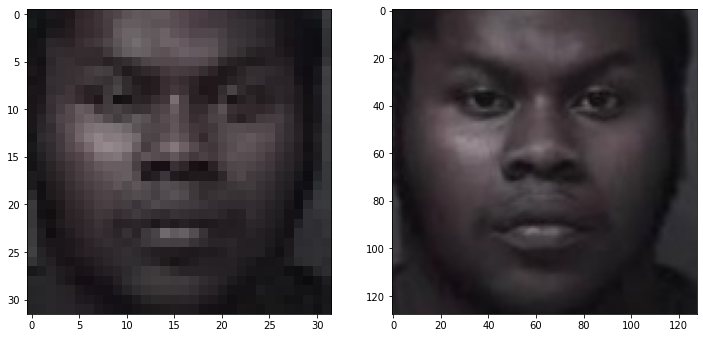

In [8]:
lr_images = np.array(lr_images)
hr_images = np.array(hr_images)


image_number = random.randint(0, len(lr_images)-1)
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(np.reshape(lr_images[image_number], (32, 32, 3)))
plt.subplot(122)
plt.imshow(np.reshape(hr_images[image_number], (128, 128, 3)))
plt.show()

## Normalization:

In [9]:
lr_images = lr_images / 255.
hr_images = hr_images / 255.

## Training

In [10]:
lr_train, lr_test, hr_train, hr_test = train_test_split(lr_images, hr_images, 
                                                      test_size=0.33, random_state=42)


hr_shape = (hr_train.shape[1], hr_train.shape[2], hr_train.shape[3])
lr_shape = (lr_train.shape[1], lr_train.shape[2], lr_train.shape[3])

lr_ip = Input(shape=lr_shape)
hr_ip = Input(shape=hr_shape)

generator = create_gen(lr_ip, num_res_block = 16)
generator.summary()

discriminator = create_disc(hr_ip)
discriminator.compile(loss="binary_crossentropy", optimizer="adam", metrics=['accuracy'])
discriminator.summary()

vgg = build_vgg((128,128,3))
print(vgg.summary())
vgg.trainable = False

gan_model = create_comb(generator, discriminator, vgg, lr_ip, hr_ip)

gan_model.compile(loss=["binary_crossentropy", "mse"], loss_weights=[1e-3, 1], optimizer="adam")
gan_model.summary()

batch_size = 1  
train_lr_batches = []
train_hr_batches = []
for it in range(int(hr_train.shape[0] / batch_size)):
    start_idx = it * batch_size
    end_idx = start_idx + batch_size
    train_hr_batches.append(hr_train[start_idx:end_idx])
    train_lr_batches.append(lr_train[start_idx:end_idx])
    
    
epochs = 100

for e in range(epochs):
    
    fake_label = np.zeros((batch_size, 1)) 
    real_label = np.ones((batch_size,1)) 
    

    g_losses = []
    d_losses = []
    
 
    for b in tqdm(range(len(train_hr_batches))):
        lr_imgs = train_lr_batches[b] 
        hr_imgs = train_hr_batches[b] 
        
        fake_imgs = generator.predict_on_batch(lr_imgs) 
        
 
        discriminator.trainable = True
        d_loss_gen = discriminator.train_on_batch(fake_imgs, fake_label)
        d_loss_real = discriminator.train_on_batch(hr_imgs, real_label)
        

        discriminator.trainable = False
        

        d_loss = 0.5 * np.add(d_loss_gen, d_loss_real) 
        

        image_features = vgg.predict(hr_imgs)
     

        g_loss, _, _ = gan_model.train_on_batch([lr_imgs, hr_imgs], [real_label, image_features])
        
 
        d_losses.append(d_loss)
        g_losses.append(g_loss)
        
   
    g_losses = np.array(g_losses)
    d_losses = np.array(d_losses)
    

    g_loss = np.sum(g_losses, axis=0) / len(g_losses)
    d_loss = np.sum(d_losses, axis=0) / len(d_losses)
    

    print("epoch:", e+1 ,"g_loss:", g_loss, "d_loss:", d_loss)

    if (e+1) % 10 == 0: 
      generator.save("gen_e_"+ str(e+1) +".h5")

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 32, 32, 64)   15616       ['input_1[0][0]']                
                                                                                                  
 p_re_lu (PReLU)                (None, 32, 32, 64)   64          ['conv2d[0][0]']                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 32, 32, 64)   36928       ['p_re_lu[0][0]']                
                                                                                              

  0%|          | 0/134 [00:00<?, ?it/s]

1/1 [==============================] - 0s 237ms/step


  1%|          | 1/134 [00:18<41:50, 18.88s/it]

1/1 [==============================] - 0s 20ms/step


  1%|▏         | 2/134 [00:19<17:16,  7.85s/it]

1/1 [==============================] - 0s 18ms/step


  2%|▏         | 3/134 [00:19<09:26,  4.32s/it]

1/1 [==============================] - 0s 19ms/step


  3%|▎         | 4/134 [00:19<05:47,  2.67s/it]

1/1 [==============================] - 0s 18ms/step


  4%|▎         | 5/134 [00:19<03:46,  1.75s/it]

1/1 [==============================] - 0s 20ms/step


  4%|▍         | 6/134 [00:19<02:33,  1.20s/it]

1/1 [==============================] - 0s 23ms/step


  5%|▌         | 7/134 [00:19<01:48,  1.17it/s]

1/1 [==============================] - 0s 19ms/step


  6%|▌         | 8/134 [00:19<01:18,  1.61it/s]

1/1 [==============================] - 0s 18ms/step


  7%|▋         | 9/134 [00:19<00:58,  2.13it/s]

1/1 [==============================] - 0s 20ms/step


  7%|▋         | 10/134 [00:20<00:45,  2.74it/s]

1/1 [==============================] - 0s 19ms/step


  8%|▊         | 11/134 [00:20<00:36,  3.41it/s]

1/1 [==============================] - 0s 19ms/step


  9%|▉         | 12/134 [00:20<00:29,  4.11it/s]

1/1 [==============================] - 0s 18ms/step


 10%|▉         | 13/134 [00:20<00:25,  4.79it/s]

1/1 [==============================] - 0s 19ms/step


 10%|█         | 14/134 [00:20<00:22,  5.41it/s]

1/1 [==============================] - 0s 19ms/step


 11%|█         | 15/134 [00:20<00:20,  5.91it/s]

1/1 [==============================] - 0s 19ms/step


 12%|█▏        | 16/134 [00:20<00:18,  6.37it/s]

1/1 [==============================] - 0s 18ms/step


 13%|█▎        | 17/134 [00:20<00:17,  6.66it/s]

1/1 [==============================] - 0s 18ms/step


 13%|█▎        | 18/134 [00:21<00:16,  6.87it/s]

1/1 [==============================] - 0s 19ms/step


 14%|█▍        | 19/134 [00:21<00:16,  7.08it/s]

1/1 [==============================] - 0s 19ms/step


 15%|█▍        | 20/134 [00:21<00:15,  7.27it/s]

1/1 [==============================] - 0s 18ms/step


 16%|█▌        | 21/134 [00:21<00:15,  7.39it/s]

1/1 [==============================] - 0s 18ms/step


 16%|█▋        | 22/134 [00:21<00:14,  7.52it/s]

1/1 [==============================] - 0s 18ms/step


 17%|█▋        | 23/134 [00:21<00:14,  7.46it/s]

1/1 [==============================] - 0s 18ms/step


 18%|█▊        | 24/134 [00:21<00:14,  7.55it/s]

1/1 [==============================] - 0s 18ms/step


 19%|█▊        | 25/134 [00:22<00:14,  7.59it/s]

1/1 [==============================] - 0s 21ms/step


 19%|█▉        | 26/134 [00:22<00:14,  7.60it/s]

1/1 [==============================] - 0s 17ms/step


 20%|██        | 27/134 [00:22<00:14,  7.62it/s]

1/1 [==============================] - 0s 18ms/step


 21%|██        | 28/134 [00:22<00:13,  7.60it/s]

1/1 [==============================] - 0s 18ms/step


 22%|██▏       | 29/134 [00:22<00:13,  7.61it/s]

1/1 [==============================] - 0s 19ms/step


 22%|██▏       | 30/134 [00:22<00:13,  7.68it/s]

1/1 [==============================] - 0s 19ms/step


 23%|██▎       | 31/134 [00:22<00:13,  7.63it/s]

1/1 [==============================] - 0s 18ms/step


 24%|██▍       | 32/134 [00:22<00:13,  7.74it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▍       | 33/134 [00:23<00:13,  7.67it/s]

1/1 [==============================] - 0s 18ms/step


 25%|██▌       | 34/134 [00:23<00:12,  7.74it/s]

1/1 [==============================] - 0s 19ms/step


 26%|██▌       | 35/134 [00:23<00:12,  7.68it/s]

1/1 [==============================] - 0s 17ms/step


 27%|██▋       | 36/134 [00:23<00:12,  7.78it/s]

1/1 [==============================] - 0s 21ms/step


 28%|██▊       | 37/134 [00:23<00:12,  7.47it/s]

1/1 [==============================] - 0s 19ms/step


 28%|██▊       | 38/134 [00:23<00:12,  7.42it/s]

1/1 [==============================] - 0s 18ms/step


 29%|██▉       | 39/134 [00:23<00:12,  7.48it/s]

1/1 [==============================] - 0s 19ms/step


 30%|██▉       | 40/134 [00:23<00:12,  7.55it/s]

1/1 [==============================] - 0s 20ms/step


 31%|███       | 41/134 [00:24<00:12,  7.54it/s]

1/1 [==============================] - 0s 18ms/step


 31%|███▏      | 42/134 [00:24<00:12,  7.65it/s]

1/1 [==============================] - 0s 23ms/step


 32%|███▏      | 43/134 [00:24<00:12,  7.11it/s]

1/1 [==============================] - 0s 18ms/step


 33%|███▎      | 44/134 [00:24<00:12,  7.29it/s]

1/1 [==============================] - 0s 20ms/step


 34%|███▎      | 45/134 [00:24<00:12,  7.38it/s]

1/1 [==============================] - 0s 18ms/step


 34%|███▍      | 46/134 [00:24<00:12,  7.19it/s]

1/1 [==============================] - 0s 20ms/step


 35%|███▌      | 47/134 [00:24<00:12,  7.20it/s]

1/1 [==============================] - 0s 25ms/step


 36%|███▌      | 48/134 [00:25<00:11,  7.19it/s]

1/1 [==============================] - 0s 21ms/step


 37%|███▋      | 49/134 [00:25<00:11,  7.19it/s]

1/1 [==============================] - 0s 19ms/step


 37%|███▋      | 50/134 [00:25<00:11,  7.37it/s]

1/1 [==============================] - 0s 18ms/step


 38%|███▊      | 51/134 [00:25<00:11,  7.44it/s]

1/1 [==============================] - 0s 19ms/step


 39%|███▉      | 52/134 [00:25<00:10,  7.49it/s]

1/1 [==============================] - 0s 18ms/step


 40%|███▉      | 53/134 [00:25<00:10,  7.44it/s]

1/1 [==============================] - 0s 18ms/step


 40%|████      | 54/134 [00:25<00:10,  7.54it/s]

1/1 [==============================] - 0s 18ms/step


 41%|████      | 55/134 [00:26<00:10,  7.50it/s]

1/1 [==============================] - 0s 19ms/step


 42%|████▏     | 56/134 [00:26<00:10,  7.48it/s]

1/1 [==============================] - 0s 19ms/step


 43%|████▎     | 57/134 [00:26<00:10,  7.50it/s]

1/1 [==============================] - 0s 18ms/step


 43%|████▎     | 58/134 [00:26<00:10,  7.56it/s]

1/1 [==============================] - 0s 20ms/step


 44%|████▍     | 59/134 [00:26<00:09,  7.55it/s]

1/1 [==============================] - 0s 19ms/step


 45%|████▍     | 60/134 [00:26<00:09,  7.60it/s]

1/1 [==============================] - 0s 19ms/step


 46%|████▌     | 61/134 [00:26<00:09,  7.58it/s]

1/1 [==============================] - 0s 18ms/step


 46%|████▋     | 62/134 [00:26<00:09,  7.64it/s]

1/1 [==============================] - 0s 19ms/step


 47%|████▋     | 63/134 [00:27<00:09,  7.61it/s]

1/1 [==============================] - 0s 19ms/step


 48%|████▊     | 64/134 [00:27<00:09,  7.64it/s]

1/1 [==============================] - 0s 18ms/step


 49%|████▊     | 65/134 [00:27<00:09,  7.52it/s]

1/1 [==============================] - 0s 19ms/step


 49%|████▉     | 66/134 [00:27<00:08,  7.56it/s]

1/1 [==============================] - 0s 19ms/step


 50%|█████     | 67/134 [00:27<00:08,  7.56it/s]

1/1 [==============================] - 0s 17ms/step


 51%|█████     | 68/134 [00:27<00:08,  7.67it/s]

1/1 [==============================] - 0s 20ms/step


 51%|█████▏    | 69/134 [00:27<00:08,  7.34it/s]

1/1 [==============================] - 0s 19ms/step


 52%|█████▏    | 70/134 [00:28<00:08,  7.46it/s]

1/1 [==============================] - 0s 19ms/step


 53%|█████▎    | 71/134 [00:28<00:08,  7.47it/s]

1/1 [==============================] - 0s 18ms/step


 54%|█████▎    | 72/134 [00:28<00:08,  7.59it/s]

1/1 [==============================] - 0s 19ms/step


 54%|█████▍    | 73/134 [00:28<00:08,  7.60it/s]

1/1 [==============================] - 0s 18ms/step


 55%|█████▌    | 74/134 [00:28<00:07,  7.66it/s]

1/1 [==============================] - 0s 20ms/step


 56%|█████▌    | 75/134 [00:28<00:07,  7.51it/s]

1/1 [==============================] - 0s 18ms/step


 57%|█████▋    | 76/134 [00:28<00:07,  7.62it/s]

1/1 [==============================] - 0s 19ms/step


 57%|█████▋    | 77/134 [00:28<00:07,  7.50it/s]

1/1 [==============================] - 0s 18ms/step


 58%|█████▊    | 78/134 [00:29<00:07,  7.53it/s]

1/1 [==============================] - 0s 20ms/step


 59%|█████▉    | 79/134 [00:29<00:07,  7.52it/s]

1/1 [==============================] - 0s 18ms/step


 60%|█████▉    | 80/134 [00:29<00:07,  7.62it/s]

1/1 [==============================] - 0s 18ms/step


 60%|██████    | 81/134 [00:29<00:06,  7.62it/s]

1/1 [==============================] - 0s 18ms/step


 61%|██████    | 82/134 [00:29<00:06,  7.61it/s]

1/1 [==============================] - 0s 19ms/step


 62%|██████▏   | 83/134 [00:29<00:06,  7.65it/s]

1/1 [==============================] - 0s 19ms/step


 63%|██████▎   | 84/134 [00:29<00:06,  7.57it/s]

1/1 [==============================] - 0s 20ms/step


 63%|██████▎   | 85/134 [00:29<00:06,  7.58it/s]

1/1 [==============================] - 0s 18ms/step


 64%|██████▍   | 86/134 [00:30<00:06,  7.59it/s]

1/1 [==============================] - 0s 19ms/step


 65%|██████▍   | 87/134 [00:30<00:06,  7.60it/s]

1/1 [==============================] - 0s 19ms/step


 66%|██████▌   | 88/134 [00:30<00:06,  7.62it/s]

1/1 [==============================] - 0s 18ms/step


 66%|██████▋   | 89/134 [00:30<00:05,  7.63it/s]

1/1 [==============================] - 0s 18ms/step


 67%|██████▋   | 90/134 [00:30<00:05,  7.64it/s]

1/1 [==============================] - 0s 19ms/step


 68%|██████▊   | 91/134 [00:30<00:05,  7.62it/s]

1/1 [==============================] - 0s 18ms/step


 69%|██████▊   | 92/134 [00:30<00:05,  7.62it/s]

1/1 [==============================] - 0s 18ms/step


 69%|██████▉   | 93/134 [00:31<00:05,  7.65it/s]

1/1 [==============================] - 0s 20ms/step


 70%|███████   | 94/134 [00:31<00:05,  7.47it/s]

1/1 [==============================] - 0s 19ms/step


 71%|███████   | 95/134 [00:31<00:05,  7.58it/s]

1/1 [==============================] - 0s 18ms/step


 72%|███████▏  | 96/134 [00:31<00:05,  7.59it/s]

1/1 [==============================] - 0s 18ms/step


 72%|███████▏  | 97/134 [00:31<00:04,  7.69it/s]

1/1 [==============================] - 0s 19ms/step


 73%|███████▎  | 98/134 [00:31<00:04,  7.66it/s]

1/1 [==============================] - 0s 18ms/step


 74%|███████▍  | 99/134 [00:31<00:04,  7.75it/s]

1/1 [==============================] - 0s 23ms/step


 75%|███████▍  | 100/134 [00:31<00:04,  7.58it/s]

1/1 [==============================] - 0s 19ms/step


 75%|███████▌  | 101/134 [00:32<00:04,  7.62it/s]

1/1 [==============================] - 0s 19ms/step


 76%|███████▌  | 102/134 [00:32<00:04,  7.59it/s]

1/1 [==============================] - 0s 18ms/step


 77%|███████▋  | 103/134 [00:32<00:04,  7.58it/s]

1/1 [==============================] - 0s 20ms/step


 78%|███████▊  | 104/134 [00:32<00:03,  7.57it/s]

1/1 [==============================] - 0s 18ms/step


 78%|███████▊  | 105/134 [00:32<00:03,  7.59it/s]

1/1 [==============================] - 0s 20ms/step


 79%|███████▉  | 106/134 [00:32<00:03,  7.57it/s]

1/1 [==============================] - 0s 18ms/step


 80%|███████▉  | 107/134 [00:32<00:03,  7.69it/s]

1/1 [==============================] - 0s 20ms/step


 81%|████████  | 108/134 [00:33<00:03,  7.58it/s]

1/1 [==============================] - 0s 18ms/step


 81%|████████▏ | 109/134 [00:33<00:03,  7.65it/s]

1/1 [==============================] - 0s 19ms/step


 82%|████████▏ | 110/134 [00:33<00:03,  7.60it/s]

1/1 [==============================] - 0s 18ms/step


 83%|████████▎ | 111/134 [00:33<00:03,  7.65it/s]

1/1 [==============================] - 0s 19ms/step


 84%|████████▎ | 112/134 [00:33<00:02,  7.55it/s]

1/1 [==============================] - 0s 18ms/step


 84%|████████▍ | 113/134 [00:33<00:02,  7.57it/s]

1/1 [==============================] - 0s 20ms/step


 85%|████████▌ | 114/134 [00:33<00:02,  7.56it/s]

1/1 [==============================] - 0s 18ms/step


 86%|████████▌ | 115/134 [00:33<00:02,  7.61it/s]

1/1 [==============================] - 0s 20ms/step


 87%|████████▋ | 116/134 [00:34<00:02,  7.50it/s]

1/1 [==============================] - 0s 19ms/step


 87%|████████▋ | 117/134 [00:34<00:02,  7.56it/s]

1/1 [==============================] - 0s 20ms/step


 88%|████████▊ | 118/134 [00:34<00:02,  7.57it/s]

1/1 [==============================] - 0s 19ms/step


 89%|████████▉ | 119/134 [00:34<00:01,  7.63it/s]

1/1 [==============================] - 0s 19ms/step


 90%|████████▉ | 120/134 [00:34<00:01,  7.62it/s]

1/1 [==============================] - 0s 18ms/step


 90%|█████████ | 121/134 [00:34<00:01,  7.66it/s]

1/1 [==============================] - 0s 19ms/step


 91%|█████████ | 122/134 [00:34<00:01,  7.55it/s]

1/1 [==============================] - 0s 18ms/step


 92%|█████████▏| 123/134 [00:34<00:01,  7.62it/s]

1/1 [==============================] - 0s 19ms/step


 93%|█████████▎| 124/134 [00:35<00:01,  7.68it/s]

1/1 [==============================] - 0s 17ms/step


 93%|█████████▎| 125/134 [00:35<00:01,  7.74it/s]

1/1 [==============================] - 0s 18ms/step


 94%|█████████▍| 126/134 [00:35<00:01,  7.79it/s]

1/1 [==============================] - 0s 19ms/step


 95%|█████████▍| 127/134 [00:35<00:00,  7.79it/s]

1/1 [==============================] - 0s 19ms/step


 96%|█████████▌| 128/134 [00:35<00:00,  7.74it/s]

1/1 [==============================] - 0s 19ms/step


 96%|█████████▋| 129/134 [00:35<00:00,  7.71it/s]

1/1 [==============================] - 0s 19ms/step


 97%|█████████▋| 130/134 [00:35<00:00,  7.67it/s]

1/1 [==============================] - 0s 19ms/step


 98%|█████████▊| 131/134 [00:36<00:00,  7.63it/s]

1/1 [==============================] - 0s 20ms/step


 99%|█████████▊| 132/134 [00:36<00:00,  7.48it/s]

1/1 [==============================] - 0s 20ms/step


 99%|█████████▉| 133/134 [00:36<00:00,  7.48it/s]

1/1 [==============================] - 0s 18ms/step


100%|██████████| 134/134 [00:36<00:00,  3.68it/s]


epoch: 1 g_loss: 71.22643387495582 d_loss: [8.87615619 0.67537313]


  0%|          | 0/134 [00:00<?, ?it/s]

1/1 [==============================] - 0s 20ms/step


  1%|          | 1/134 [00:00<00:17,  7.56it/s]

1/1 [==============================] - 0s 19ms/step


  1%|▏         | 2/134 [00:00<00:17,  7.52it/s]

1/1 [==============================] - 0s 20ms/step


  2%|▏         | 3/134 [00:00<00:17,  7.56it/s]

1/1 [==============================] - 0s 18ms/step


  3%|▎         | 4/134 [00:00<00:17,  7.55it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▎         | 5/134 [00:00<00:17,  7.22it/s]

1/1 [==============================] - 0s 18ms/step


  4%|▍         | 6/134 [00:00<00:17,  7.32it/s]

1/1 [==============================] - 0s 19ms/step


  5%|▌         | 7/134 [00:00<00:17,  7.39it/s]

1/1 [==============================] - 0s 18ms/step


  6%|▌         | 8/134 [00:01<00:16,  7.48it/s]

1/1 [==============================] - 0s 19ms/step


  7%|▋         | 9/134 [00:01<00:16,  7.62it/s]

1/1 [==============================] - 0s 19ms/step


  7%|▋         | 10/134 [00:01<00:16,  7.59it/s]

1/1 [==============================] - 0s 19ms/step


  8%|▊         | 11/134 [00:01<00:16,  7.59it/s]

1/1 [==============================] - 0s 18ms/step


  9%|▉         | 12/134 [00:01<00:16,  7.61it/s]

1/1 [==============================] - 0s 20ms/step


 10%|▉         | 13/134 [00:01<00:16,  7.53it/s]

1/1 [==============================] - 0s 19ms/step


 10%|█         | 14/134 [00:01<00:15,  7.55it/s]

1/1 [==============================] - 0s 18ms/step


 11%|█         | 15/134 [00:01<00:15,  7.64it/s]

1/1 [==============================] - 0s 19ms/step


 12%|█▏        | 16/134 [00:02<00:15,  7.57it/s]

1/1 [==============================] - 0s 18ms/step


 13%|█▎        | 17/134 [00:02<00:15,  7.54it/s]

1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 18/134 [00:02<00:15,  7.52it/s]

1/1 [==============================] - 0s 19ms/step


 14%|█▍        | 19/134 [00:02<00:15,  7.62it/s]

1/1 [==============================] - 0s 20ms/step


 15%|█▍        | 20/134 [00:02<00:15,  7.55it/s]

1/1 [==============================] - 0s 19ms/step


 16%|█▌        | 21/134 [00:02<00:14,  7.63it/s]

1/1 [==============================] - 0s 20ms/step


 16%|█▋        | 22/134 [00:02<00:14,  7.57it/s]

1/1 [==============================] - 0s 17ms/step


 17%|█▋        | 23/134 [00:03<00:14,  7.65it/s]

1/1 [==============================] - 0s 23ms/step


 18%|█▊        | 24/134 [00:03<00:14,  7.55it/s]

1/1 [==============================] - 0s 18ms/step


 19%|█▊        | 25/134 [00:03<00:14,  7.63it/s]

1/1 [==============================] - 0s 20ms/step


 19%|█▉        | 26/134 [00:03<00:14,  7.59it/s]

1/1 [==============================] - 0s 18ms/step


 20%|██        | 27/134 [00:03<00:14,  7.58it/s]

1/1 [==============================] - 0s 35ms/step


 21%|██        | 28/134 [00:03<00:14,  7.29it/s]

1/1 [==============================] - 0s 18ms/step


 22%|██▏       | 29/134 [00:03<00:14,  7.45it/s]

1/1 [==============================] - 0s 19ms/step


 22%|██▏       | 30/134 [00:03<00:13,  7.45it/s]

1/1 [==============================] - 0s 18ms/step


 23%|██▎       | 31/134 [00:04<00:13,  7.55it/s]

1/1 [==============================] - 0s 19ms/step


 24%|██▍       | 32/134 [00:04<00:13,  7.53it/s]

1/1 [==============================] - 0s 18ms/step


 25%|██▍       | 33/134 [00:04<00:13,  7.58it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▌       | 34/134 [00:04<00:13,  7.53it/s]

1/1 [==============================] - 0s 17ms/step


 26%|██▌       | 35/134 [00:04<00:13,  7.60it/s]

1/1 [==============================] - 0s 19ms/step


 27%|██▋       | 36/134 [00:04<00:13,  7.39it/s]

1/1 [==============================] - 0s 18ms/step


 28%|██▊       | 37/134 [00:04<00:12,  7.51it/s]

1/1 [==============================] - 0s 19ms/step


 28%|██▊       | 38/134 [00:05<00:12,  7.54it/s]

1/1 [==============================] - 0s 18ms/step


 29%|██▉       | 39/134 [00:05<00:12,  7.64it/s]

1/1 [==============================] - 0s 20ms/step


 30%|██▉       | 40/134 [00:05<00:12,  7.57it/s]

1/1 [==============================] - 0s 18ms/step


 31%|███       | 41/134 [00:05<00:12,  7.68it/s]

1/1 [==============================] - 0s 19ms/step


 31%|███▏      | 42/134 [00:05<00:12,  7.60it/s]

1/1 [==============================] - 0s 18ms/step


 32%|███▏      | 43/134 [00:05<00:11,  7.70it/s]

1/1 [==============================] - 0s 19ms/step


 33%|███▎      | 44/134 [00:05<00:11,  7.61it/s]

1/1 [==============================] - 0s 18ms/step


 34%|███▎      | 45/134 [00:05<00:11,  7.67it/s]

1/1 [==============================] - 0s 19ms/step


 34%|███▍      | 46/134 [00:06<00:11,  7.53it/s]

1/1 [==============================] - 0s 17ms/step


 35%|███▌      | 47/134 [00:06<00:11,  7.64it/s]

1/1 [==============================] - 0s 19ms/step


 36%|███▌      | 48/134 [00:06<00:11,  7.62it/s]

1/1 [==============================] - 0s 18ms/step


 37%|███▋      | 49/134 [00:06<00:11,  7.67it/s]

1/1 [==============================] - 0s 19ms/step


 37%|███▋      | 50/134 [00:06<00:11,  7.60it/s]

1/1 [==============================] - 0s 19ms/step


 38%|███▊      | 51/134 [00:06<00:10,  7.63it/s]

1/1 [==============================] - 0s 19ms/step


 39%|███▉      | 52/134 [00:06<00:10,  7.61it/s]

1/1 [==============================] - 0s 19ms/step


 40%|███▉      | 53/134 [00:07<00:10,  7.65it/s]

1/1 [==============================] - 0s 19ms/step


 40%|████      | 54/134 [00:07<00:10,  7.64it/s]

1/1 [==============================] - 0s 18ms/step


 41%|████      | 55/134 [00:07<00:10,  7.58it/s]

1/1 [==============================] - 0s 21ms/step


 42%|████▏     | 56/134 [00:07<00:10,  7.55it/s]

1/1 [==============================] - 0s 19ms/step


 43%|████▎     | 57/134 [00:07<00:10,  7.63it/s]

1/1 [==============================] - 0s 19ms/step


 43%|████▎     | 58/134 [00:07<00:09,  7.62it/s]

1/1 [==============================] - 0s 21ms/step


 44%|████▍     | 59/134 [00:07<00:09,  7.56it/s]

1/1 [==============================] - 0s 20ms/step


 45%|████▍     | 60/134 [00:07<00:09,  7.55it/s]

1/1 [==============================] - 0s 18ms/step


 46%|████▌     | 61/134 [00:08<00:09,  7.59it/s]

1/1 [==============================] - 0s 21ms/step


 46%|████▋     | 62/134 [00:08<00:09,  7.58it/s]

1/1 [==============================] - 0s 18ms/step


 47%|████▋     | 63/134 [00:08<00:09,  7.63it/s]

1/1 [==============================] - 0s 19ms/step


 48%|████▊     | 64/134 [00:08<00:09,  7.63it/s]

1/1 [==============================] - 0s 19ms/step


 49%|████▊     | 65/134 [00:08<00:09,  7.54it/s]

1/1 [==============================] - 0s 20ms/step


 49%|████▉     | 66/134 [00:08<00:09,  7.52it/s]

1/1 [==============================] - 0s 19ms/step


 50%|█████     | 67/134 [00:08<00:08,  7.54it/s]

1/1 [==============================] - 0s 19ms/step


 51%|█████     | 68/134 [00:08<00:08,  7.54it/s]

1/1 [==============================] - 0s 20ms/step


 51%|█████▏    | 69/134 [00:09<00:08,  7.56it/s]

1/1 [==============================] - 0s 19ms/step


 52%|█████▏    | 70/134 [00:09<00:08,  7.60it/s]

1/1 [==============================] - 0s 19ms/step


 53%|█████▎    | 71/134 [00:09<00:08,  7.62it/s]

1/1 [==============================] - 0s 20ms/step


 54%|█████▎    | 72/134 [00:09<00:08,  7.61it/s]

1/1 [==============================] - 0s 19ms/step


 54%|█████▍    | 73/134 [00:09<00:07,  7.65it/s]

1/1 [==============================] - 0s 19ms/step


 55%|█████▌    | 74/134 [00:09<00:07,  7.64it/s]

1/1 [==============================] - 0s 19ms/step


 56%|█████▌    | 75/134 [00:09<00:07,  7.47it/s]

1/1 [==============================] - 0s 19ms/step


 57%|█████▋    | 76/134 [00:10<00:07,  7.47it/s]

1/1 [==============================] - 0s 18ms/step


 57%|█████▋    | 77/134 [00:10<00:07,  7.56it/s]

1/1 [==============================] - 0s 19ms/step


 58%|█████▊    | 78/134 [00:10<00:07,  7.59it/s]

1/1 [==============================] - 0s 19ms/step


 59%|█████▉    | 79/134 [00:10<00:07,  7.63it/s]

1/1 [==============================] - 0s 19ms/step


 60%|█████▉    | 80/134 [00:10<00:07,  7.66it/s]

1/1 [==============================] - 0s 17ms/step


 60%|██████    | 81/134 [00:10<00:06,  7.64it/s]

1/1 [==============================] - 0s 18ms/step


 61%|██████    | 82/134 [00:10<00:06,  7.63it/s]

1/1 [==============================] - 0s 18ms/step


 62%|██████▏   | 83/134 [00:10<00:06,  7.64it/s]

1/1 [==============================] - 0s 19ms/step


 63%|██████▎   | 84/134 [00:11<00:06,  7.67it/s]

1/1 [==============================] - 0s 18ms/step


 63%|██████▎   | 85/134 [00:11<00:06,  7.56it/s]

1/1 [==============================] - 0s 19ms/step


 64%|██████▍   | 86/134 [00:11<00:06,  7.60it/s]

1/1 [==============================] - 0s 18ms/step


 65%|██████▍   | 87/134 [00:11<00:06,  7.61it/s]

1/1 [==============================] - 0s 19ms/step


 66%|██████▌   | 88/134 [00:11<00:06,  7.65it/s]

1/1 [==============================] - 0s 18ms/step


 66%|██████▋   | 89/134 [00:11<00:05,  7.65it/s]

1/1 [==============================] - 0s 19ms/step


 67%|██████▋   | 90/134 [00:11<00:05,  7.64it/s]

1/1 [==============================] - 0s 18ms/step


 68%|██████▊   | 91/134 [00:12<00:05,  7.62it/s]

1/1 [==============================] - 0s 19ms/step


 69%|██████▊   | 92/134 [00:12<00:05,  7.64it/s]

1/1 [==============================] - 0s 18ms/step


 69%|██████▉   | 93/134 [00:12<00:05,  7.66it/s]

1/1 [==============================] - 0s 19ms/step


 70%|███████   | 94/134 [00:12<00:05,  7.60it/s]

1/1 [==============================] - 0s 18ms/step


 71%|███████   | 95/134 [00:12<00:05,  7.63it/s]

1/1 [==============================] - 0s 19ms/step


 72%|███████▏  | 96/134 [00:12<00:04,  7.68it/s]

1/1 [==============================] - 0s 19ms/step


 72%|███████▏  | 97/134 [00:12<00:04,  7.62it/s]

1/1 [==============================] - 0s 21ms/step


 73%|███████▎  | 98/134 [00:12<00:04,  7.31it/s]

1/1 [==============================] - 0s 19ms/step


 74%|███████▍  | 99/134 [00:13<00:04,  7.37it/s]

1/1 [==============================] - 0s 19ms/step


 75%|███████▍  | 100/134 [00:13<00:04,  7.45it/s]

1/1 [==============================] - 0s 18ms/step


 75%|███████▌  | 101/134 [00:13<00:04,  7.49it/s]

1/1 [==============================] - 0s 18ms/step


 76%|███████▌  | 102/134 [00:13<00:04,  7.55it/s]

1/1 [==============================] - 0s 18ms/step


 77%|███████▋  | 103/134 [00:13<00:04,  7.57it/s]

1/1 [==============================] - 0s 20ms/step


 78%|███████▊  | 104/134 [00:13<00:03,  7.51it/s]

1/1 [==============================] - 0s 19ms/step


 78%|███████▊  | 105/134 [00:13<00:03,  7.53it/s]

1/1 [==============================] - 0s 18ms/step


 79%|███████▉  | 106/134 [00:14<00:03,  7.52it/s]

1/1 [==============================] - 0s 18ms/step


 80%|███████▉  | 107/134 [00:14<00:03,  7.55it/s]

1/1 [==============================] - 0s 20ms/step


 81%|████████  | 108/134 [00:14<00:03,  7.48it/s]

1/1 [==============================] - 0s 19ms/step


 81%|████████▏ | 109/134 [00:14<00:03,  7.50it/s]

1/1 [==============================] - 0s 19ms/step


 82%|████████▏ | 110/134 [00:14<00:03,  7.53it/s]

1/1 [==============================] - 0s 19ms/step


 83%|████████▎ | 111/134 [00:14<00:03,  7.54it/s]

1/1 [==============================] - 0s 19ms/step


 84%|████████▎ | 112/134 [00:14<00:02,  7.59it/s]

1/1 [==============================] - 0s 18ms/step


 84%|████████▍ | 113/134 [00:14<00:02,  7.49it/s]

1/1 [==============================] - 0s 19ms/step


 85%|████████▌ | 114/134 [00:15<00:02,  7.57it/s]

1/1 [==============================] - 0s 18ms/step


 86%|████████▌ | 115/134 [00:15<00:02,  7.61it/s]

1/1 [==============================] - 0s 19ms/step


 87%|████████▋ | 116/134 [00:15<00:02,  7.64it/s]

1/1 [==============================] - 0s 18ms/step


 87%|████████▋ | 117/134 [00:15<00:02,  7.62it/s]

1/1 [==============================] - 0s 19ms/step


 88%|████████▊ | 118/134 [00:15<00:02,  7.65it/s]

1/1 [==============================] - 0s 18ms/step


 89%|████████▉ | 119/134 [00:15<00:01,  7.64it/s]

1/1 [==============================] - 0s 18ms/step


 90%|████████▉ | 120/134 [00:15<00:01,  7.69it/s]

1/1 [==============================] - 0s 19ms/step


 90%|█████████ | 121/134 [00:15<00:01,  7.40it/s]

1/1 [==============================] - 0s 19ms/step


 91%|█████████ | 122/134 [00:16<00:01,  7.46it/s]

1/1 [==============================] - 0s 18ms/step


 92%|█████████▏| 123/134 [00:16<00:01,  7.42it/s]

1/1 [==============================] - 0s 19ms/step


 93%|█████████▎| 124/134 [00:16<00:01,  7.45it/s]

1/1 [==============================] - 0s 18ms/step


 93%|█████████▎| 125/134 [00:16<00:01,  7.49it/s]

1/1 [==============================] - 0s 19ms/step


 94%|█████████▍| 126/134 [00:16<00:01,  7.58it/s]

1/1 [==============================] - 0s 18ms/step


 95%|█████████▍| 127/134 [00:16<00:00,  7.56it/s]

1/1 [==============================] - 0s 19ms/step


 96%|█████████▌| 128/134 [00:16<00:00,  7.62it/s]

1/1 [==============================] - 0s 20ms/step


 96%|█████████▋| 129/134 [00:17<00:00,  7.54it/s]

1/1 [==============================] - 0s 19ms/step


 97%|█████████▋| 130/134 [00:17<00:00,  7.58it/s]

1/1 [==============================] - 0s 18ms/step


 98%|█████████▊| 131/134 [00:17<00:00,  7.57it/s]

1/1 [==============================] - 0s 18ms/step


 99%|█████████▊| 132/134 [00:17<00:00,  7.61it/s]

1/1 [==============================] - 0s 19ms/step


 99%|█████████▉| 133/134 [00:17<00:00,  7.49it/s]

1/1 [==============================] - 0s 18ms/step


100%|██████████| 134/134 [00:17<00:00,  7.57it/s]


epoch: 2 g_loss: 34.26118397356859 d_loss: [1.78788188 0.75      ]


  0%|          | 0/134 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step


  1%|          | 1/134 [00:00<00:17,  7.50it/s]

1/1 [==============================] - 0s 19ms/step


  1%|▏         | 2/134 [00:00<00:17,  7.60it/s]

1/1 [==============================] - 0s 18ms/step


  2%|▏         | 3/134 [00:00<00:17,  7.50it/s]

1/1 [==============================] - 0s 18ms/step


  3%|▎         | 4/134 [00:00<00:17,  7.60it/s]

1/1 [==============================] - 0s 18ms/step


  4%|▎         | 5/134 [00:00<00:16,  7.63it/s]

1/1 [==============================] - 0s 18ms/step


  4%|▍         | 6/134 [00:00<00:16,  7.64it/s]

1/1 [==============================] - 0s 18ms/step


  5%|▌         | 7/134 [00:00<00:16,  7.60it/s]

1/1 [==============================] - 0s 20ms/step


  6%|▌         | 8/134 [00:01<00:16,  7.57it/s]

1/1 [==============================] - 0s 19ms/step


  7%|▋         | 9/134 [00:01<00:16,  7.41it/s]

1/1 [==============================] - 0s 20ms/step


  7%|▋         | 10/134 [00:01<00:16,  7.40it/s]

1/1 [==============================] - 0s 19ms/step


  8%|▊         | 11/134 [00:01<00:16,  7.43it/s]

1/1 [==============================] - 0s 19ms/step


  9%|▉         | 12/134 [00:01<00:16,  7.51it/s]

1/1 [==============================] - 0s 19ms/step


 10%|▉         | 13/134 [00:01<00:16,  7.52it/s]

1/1 [==============================] - 0s 19ms/step


 10%|█         | 14/134 [00:01<00:15,  7.60it/s]

1/1 [==============================] - 0s 19ms/step


 11%|█         | 15/134 [00:01<00:15,  7.59it/s]

1/1 [==============================] - 0s 19ms/step


 12%|█▏        | 16/134 [00:02<00:15,  7.64it/s]

1/1 [==============================] - 0s 19ms/step


 13%|█▎        | 17/134 [00:02<00:15,  7.62it/s]

1/1 [==============================] - 0s 19ms/step


 13%|█▎        | 18/134 [00:02<00:15,  7.62it/s]

1/1 [==============================] - 0s 18ms/step


 14%|█▍        | 19/134 [00:02<00:15,  7.50it/s]

1/1 [==============================] - 0s 19ms/step


 15%|█▍        | 20/134 [00:02<00:15,  7.55it/s]

1/1 [==============================] - 0s 18ms/step


 16%|█▌        | 21/134 [00:02<00:14,  7.54it/s]

1/1 [==============================] - 0s 20ms/step


 16%|█▋        | 22/134 [00:02<00:14,  7.58it/s]

1/1 [==============================] - 0s 19ms/step


 17%|█▋        | 23/134 [00:03<00:14,  7.55it/s]

1/1 [==============================] - 0s 19ms/step


 18%|█▊        | 24/134 [00:03<00:14,  7.62it/s]

1/1 [==============================] - 0s 18ms/step


 19%|█▊        | 25/134 [00:03<00:14,  7.63it/s]

1/1 [==============================] - 0s 19ms/step


 19%|█▉        | 26/134 [00:03<00:14,  7.58it/s]

1/1 [==============================] - 0s 18ms/step


 20%|██        | 27/134 [00:03<00:14,  7.58it/s]

1/1 [==============================] - 0s 18ms/step


 21%|██        | 28/134 [00:03<00:14,  7.54it/s]

1/1 [==============================] - 0s 18ms/step


 22%|██▏       | 29/134 [00:03<00:13,  7.55it/s]

1/1 [==============================] - 0s 18ms/step


 22%|██▏       | 30/134 [00:03<00:13,  7.60it/s]

1/1 [==============================] - 0s 18ms/step


 23%|██▎       | 31/134 [00:04<00:13,  7.56it/s]

1/1 [==============================] - 0s 19ms/step


 24%|██▍       | 32/134 [00:04<00:13,  7.60it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▍       | 33/134 [00:04<00:13,  7.42it/s]

1/1 [==============================] - 0s 19ms/step


 25%|██▌       | 34/134 [00:04<00:13,  7.52it/s]

1/1 [==============================] - 0s 19ms/step


 26%|██▌       | 35/134 [00:04<00:13,  7.54it/s]

1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 36/134 [00:04<00:12,  7.59it/s]

1/1 [==============================] - 0s 19ms/step


 28%|██▊       | 37/134 [00:04<00:12,  7.55it/s]

1/1 [==============================] - 0s 19ms/step


 28%|██▊       | 38/134 [00:05<00:12,  7.51it/s]

1/1 [==============================] - 0s 18ms/step


 29%|██▉       | 39/134 [00:05<00:12,  7.47it/s]

1/1 [==============================] - 0s 18ms/step


 30%|██▉       | 40/134 [00:05<00:12,  7.52it/s]

1/1 [==============================] - 0s 21ms/step


 31%|███       | 41/134 [00:05<00:12,  7.44it/s]

1/1 [==============================] - 0s 18ms/step


 31%|███▏      | 42/134 [00:05<00:12,  7.54it/s]

1/1 [==============================] - 0s 19ms/step


 32%|███▏      | 43/134 [00:05<00:12,  7.49it/s]

1/1 [==============================] - 0s 18ms/step


 33%|███▎      | 44/134 [00:05<00:11,  7.56it/s]

1/1 [==============================] - 0s 20ms/step


 34%|███▎      | 45/134 [00:05<00:11,  7.51it/s]

1/1 [==============================] - 0s 18ms/step


 34%|███▍      | 46/134 [00:06<00:11,  7.53it/s]

1/1 [==============================] - 0s 20ms/step


 35%|███▌      | 47/134 [00:06<00:11,  7.49it/s]

1/1 [==============================] - 0s 18ms/step


 36%|███▌      | 48/134 [00:06<00:11,  7.50it/s]

1/1 [==============================] - 0s 20ms/step


 37%|███▋      | 49/134 [00:06<00:11,  7.35it/s]

1/1 [==============================] - 0s 18ms/step


 37%|███▋      | 50/134 [00:06<00:11,  7.49it/s]

1/1 [==============================] - 0s 19ms/step


 38%|███▊      | 51/134 [00:06<00:11,  7.51it/s]

1/1 [==============================] - 0s 19ms/step


 39%|███▉      | 52/134 [00:06<00:10,  7.55it/s]

1/1 [==============================] - 0s 19ms/step


 40%|███▉      | 53/134 [00:07<00:10,  7.56it/s]

1/1 [==============================] - 0s 19ms/step


 40%|████      | 54/134 [00:07<00:10,  7.57it/s]

1/1 [==============================] - 0s 18ms/step


 41%|████      | 55/134 [00:07<00:10,  7.57it/s]

1/1 [==============================] - 0s 19ms/step


 42%|████▏     | 56/134 [00:07<00:10,  7.60it/s]

1/1 [==============================] - 0s 18ms/step


 43%|████▎     | 57/134 [00:07<00:10,  7.19it/s]

1/1 [==============================] - 0s 19ms/step


 43%|████▎     | 58/134 [00:07<00:10,  7.32it/s]

1/1 [==============================] - 0s 18ms/step


 44%|████▍     | 59/134 [00:07<00:10,  7.39it/s]

1/1 [==============================] - 0s 19ms/step


 45%|████▍     | 60/134 [00:07<00:09,  7.52it/s]

1/1 [==============================] - 0s 19ms/step


 46%|████▌     | 61/134 [00:08<00:09,  7.49it/s]

1/1 [==============================] - 0s 17ms/step


 46%|████▋     | 62/134 [00:08<00:09,  7.64it/s]

1/1 [==============================] - 0s 18ms/step


 47%|████▋     | 63/134 [00:08<00:09,  7.68it/s]

1/1 [==============================] - 0s 19ms/step


 48%|████▊     | 64/134 [00:08<00:09,  7.55it/s]

1/1 [==============================] - 0s 19ms/step


 49%|████▊     | 65/134 [00:08<00:09,  7.56it/s]

1/1 [==============================] - 0s 20ms/step


 49%|████▉     | 66/134 [00:08<00:09,  7.50it/s]

1/1 [==============================] - 0s 19ms/step


 50%|█████     | 67/134 [00:08<00:09,  7.42it/s]

1/1 [==============================] - 0s 20ms/step


 51%|█████     | 68/134 [00:09<00:08,  7.41it/s]

1/1 [==============================] - 0s 19ms/step


 51%|█████▏    | 69/134 [00:09<00:08,  7.43it/s]

1/1 [==============================] - 0s 19ms/step


 52%|█████▏    | 70/134 [00:09<00:08,  7.43it/s]

1/1 [==============================] - 0s 19ms/step


 53%|█████▎    | 71/134 [00:09<00:08,  7.49it/s]

1/1 [==============================] - 0s 19ms/step


 54%|█████▎    | 72/134 [00:09<00:08,  7.45it/s]

1/1 [==============================] - 0s 18ms/step


 54%|█████▍    | 73/134 [00:09<00:08,  7.52it/s]

1/1 [==============================] - 0s 20ms/step


 55%|█████▌    | 74/134 [00:09<00:07,  7.51it/s]

1/1 [==============================] - 0s 18ms/step


 56%|█████▌    | 75/134 [00:09<00:07,  7.58it/s]

1/1 [==============================] - 0s 19ms/step


 57%|█████▋    | 76/134 [00:10<00:07,  7.53it/s]

1/1 [==============================] - 0s 19ms/step


 57%|█████▋    | 77/134 [00:10<00:07,  7.44it/s]

1/1 [==============================] - 0s 20ms/step


 58%|█████▊    | 78/134 [00:10<00:07,  7.50it/s]

1/1 [==============================] - 0s 18ms/step


 59%|█████▉    | 79/134 [00:10<00:07,  7.51it/s]

1/1 [==============================] - 0s 19ms/step


 60%|█████▉    | 80/134 [00:10<00:07,  7.24it/s]

1/1 [==============================] - 0s 18ms/step


 60%|██████    | 81/134 [00:10<00:07,  7.36it/s]

1/1 [==============================] - 0s 19ms/step


 61%|██████    | 82/134 [00:10<00:07,  7.39it/s]

1/1 [==============================] - 0s 19ms/step


 62%|██████▏   | 83/134 [00:11<00:06,  7.42it/s]

1/1 [==============================] - 0s 19ms/step


 63%|██████▎   | 84/134 [00:11<00:06,  7.47it/s]

1/1 [==============================] - 0s 18ms/step


 63%|██████▎   | 85/134 [00:11<00:06,  7.47it/s]

1/1 [==============================] - 0s 20ms/step


 64%|██████▍   | 86/134 [00:11<00:06,  7.41it/s]

1/1 [==============================] - 0s 21ms/step


 65%|██████▍   | 87/134 [00:11<00:06,  7.40it/s]

1/1 [==============================] - 0s 20ms/step


 66%|██████▌   | 88/134 [00:11<00:06,  7.46it/s]

1/1 [==============================] - 0s 18ms/step


 66%|██████▋   | 89/134 [00:11<00:06,  7.49it/s]

1/1 [==============================] - 0s 18ms/step


 67%|██████▋   | 90/134 [00:11<00:05,  7.53it/s]

1/1 [==============================] - 0s 18ms/step


 68%|██████▊   | 91/134 [00:12<00:05,  7.51it/s]

1/1 [==============================] - 0s 19ms/step


 69%|██████▊   | 92/134 [00:12<00:05,  7.57it/s]

1/1 [==============================] - 0s 18ms/step


 69%|██████▉   | 93/134 [00:12<00:05,  7.56it/s]

1/1 [==============================] - 0s 19ms/step


 70%|███████   | 94/134 [00:12<00:05,  7.58it/s]

1/1 [==============================] - 0s 18ms/step


 71%|███████   | 95/134 [00:12<00:05,  7.59it/s]

1/1 [==============================] - 0s 19ms/step


 72%|███████▏  | 96/134 [00:12<00:05,  7.53it/s]

1/1 [==============================] - 0s 18ms/step


 72%|███████▏  | 97/134 [00:12<00:04,  7.52it/s]

1/1 [==============================] - 0s 19ms/step


 73%|███████▎  | 98/134 [00:13<00:04,  7.57it/s]

1/1 [==============================] - 0s 19ms/step


 74%|███████▍  | 99/134 [00:13<00:04,  7.53it/s]

1/1 [==============================] - 0s 18ms/step


 75%|███████▍  | 100/134 [00:13<00:04,  7.59it/s]

1/1 [==============================] - 0s 18ms/step


 75%|███████▌  | 101/134 [00:13<00:04,  7.48it/s]

1/1 [==============================] - 0s 19ms/step


 76%|███████▌  | 102/134 [00:13<00:04,  7.53it/s]

1/1 [==============================] - 0s 20ms/step


 77%|███████▋  | 103/134 [00:13<00:04,  7.47it/s]

1/1 [==============================] - 0s 19ms/step


 78%|███████▊  | 104/134 [00:13<00:03,  7.55it/s]

1/1 [==============================] - 0s 19ms/step


 78%|███████▊  | 105/134 [00:13<00:03,  7.53it/s]

1/1 [==============================] - 0s 18ms/step


 79%|███████▉  | 106/134 [00:14<00:03,  7.47it/s]

1/1 [==============================] - 0s 18ms/step


 80%|███████▉  | 107/134 [00:14<00:03,  7.44it/s]

1/1 [==============================] - 0s 19ms/step


 81%|████████  | 108/134 [00:14<00:03,  7.50it/s]

1/1 [==============================] - 0s 19ms/step


 81%|████████▏ | 109/134 [00:14<00:03,  7.51it/s]

1/1 [==============================] - 0s 18ms/step


 82%|████████▏ | 110/134 [00:14<00:03,  7.50it/s]

1/1 [==============================] - 0s 20ms/step


 83%|████████▎ | 111/134 [00:14<00:03,  7.50it/s]

1/1 [==============================] - 0s 18ms/step


 84%|████████▎ | 112/134 [00:14<00:02,  7.57it/s]

1/1 [==============================] - 0s 20ms/step


 84%|████████▍ | 113/134 [00:15<00:02,  7.52it/s]

1/1 [==============================] - 0s 18ms/step


 85%|████████▌ | 114/134 [00:15<00:02,  7.58it/s]

1/1 [==============================] - 0s 19ms/step


 86%|████████▌ | 115/134 [00:15<00:02,  7.54it/s]

1/1 [==============================] - 0s 18ms/step


 87%|████████▋ | 116/134 [00:15<00:02,  7.50it/s]

1/1 [==============================] - 0s 20ms/step


 87%|████████▋ | 117/134 [00:15<00:02,  7.47it/s]

1/1 [==============================] - 0s 18ms/step


 88%|████████▊ | 118/134 [00:15<00:02,  7.54it/s]

1/1 [==============================] - 0s 19ms/step


 89%|████████▉ | 119/134 [00:15<00:01,  7.51it/s]

1/1 [==============================] - 0s 18ms/step


 90%|████████▉ | 120/134 [00:15<00:01,  7.56it/s]

1/1 [==============================] - 0s 19ms/step


 90%|█████████ | 121/134 [00:16<00:01,  7.52it/s]

1/1 [==============================] - 0s 18ms/step


 91%|█████████ | 122/134 [00:16<00:01,  7.58it/s]

1/1 [==============================] - 0s 19ms/step


 92%|█████████▏| 123/134 [00:16<00:01,  7.57it/s]

1/1 [==============================] - 0s 18ms/step


 93%|█████████▎| 124/134 [00:16<00:01,  7.61it/s]

1/1 [==============================] - 0s 19ms/step


 93%|█████████▎| 125/134 [00:16<00:01,  7.49it/s]

1/1 [==============================] - 0s 18ms/step


 94%|█████████▍| 126/134 [00:16<00:01,  7.45it/s]

1/1 [==============================] - 0s 21ms/step


 95%|█████████▍| 127/134 [00:16<00:00,  7.42it/s]

1/1 [==============================] - 0s 19ms/step


 96%|█████████▌| 128/134 [00:17<00:00,  7.48it/s]

1/1 [==============================] - 0s 19ms/step


 96%|█████████▋| 129/134 [00:17<00:00,  7.46it/s]

1/1 [==============================] - 0s 19ms/step


 97%|█████████▋| 130/134 [00:17<00:00,  7.49it/s]

1/1 [==============================] - 0s 19ms/step


 98%|█████████▊| 131/134 [00:17<00:00,  7.51it/s]

1/1 [==============================] - 0s 18ms/step


 99%|█████████▊| 132/134 [00:17<00:00,  7.59it/s]

1/1 [==============================] - 0s 19ms/step


 99%|█████████▉| 133/134 [00:17<00:00,  7.52it/s]

1/1 [==============================] - 0s 19ms/step


100%|██████████| 134/134 [00:17<00:00,  7.51it/s]


epoch: 3 g_loss: 25.803294559023275 d_loss: [0.82041949 0.85820896]


  0%|          | 0/134 [00:00<?, ?it/s]

1/1 [==============================] - 0s 19ms/step


  1%|          | 1/134 [00:00<00:18,  7.20it/s]

1/1 [==============================] - 0s 19ms/step


  1%|▏         | 2/134 [00:00<00:17,  7.49it/s]

1/1 [==============================] - 0s 19ms/step


  2%|▏         | 3/134 [00:00<00:17,  7.53it/s]

1/1 [==============================] - 0s 18ms/step


  3%|▎         | 4/134 [00:00<00:17,  7.60it/s]

1/1 [==============================] - 0s 19ms/step


  4%|▎         | 5/134 [00:00<00:17,  7.52it/s]

1/1 [==============================] - 0s 19ms/step


  4%|▍         | 6/134 [00:00<00:16,  7.54it/s]

1/1 [==============================] - 0s 20ms/step


  5%|▌         | 7/134 [00:00<00:16,  7.50it/s]

1/1 [==============================] - 0s 18ms/step


  6%|▌         | 8/134 [00:01<00:16,  7.57it/s]

1/1 [==============================] - 0s 20ms/step


  7%|▋         | 9/134 [00:01<00:16,  7.53it/s]

1/1 [==============================] - 0s 18ms/step


  7%|▋         | 10/134 [00:01<00:16,  7.61it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 11/134 [00:01<00:16,  7.51it/s]

1/1 [==============================] - 0s 19ms/step


  9%|▉         | 12/134 [00:01<00:16,  7.58it/s]

1/1 [==============================] - 0s 20ms/step


 10%|▉         | 13/134 [00:01<00:16,  7.53it/s]

1/1 [==============================] - 0s 18ms/step


 10%|█         | 14/134 [00:01<00:15,  7.57it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█         | 15/134 [00:02<00:16,  7.21it/s]

1/1 [==============================] - 0s 17ms/step


 12%|█▏        | 16/134 [00:02<00:15,  7.39it/s]

1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 17/134 [00:02<00:15,  7.38it/s]

1/1 [==============================] - 0s 18ms/step


 13%|█▎        | 18/134 [00:02<00:15,  7.50it/s]

1/1 [==============================] - 0s 20ms/step


 14%|█▍        | 19/134 [00:02<00:15,  7.49it/s]

1/1 [==============================] - 0s 18ms/step


 15%|█▍        | 20/134 [00:02<00:14,  7.60it/s]

1/1 [==============================] - 0s 20ms/step


 16%|█▌        | 21/134 [00:02<00:15,  7.42it/s]

1/1 [==============================] - 0s 19ms/step


 16%|█▋        | 22/134 [00:02<00:15,  7.46it/s]

1/1 [==============================] - 0s 20ms/step


 17%|█▋        | 23/134 [00:03<00:14,  7.47it/s]

1/1 [==============================] - 0s 18ms/step


 18%|█▊        | 24/134 [00:03<00:14,  7.56it/s]

1/1 [==============================] - 0s 20ms/step


 19%|█▊        | 25/134 [00:03<00:14,  7.52it/s]

1/1 [==============================] - 0s 18ms/step


 19%|█▉        | 26/134 [00:03<00:14,  7.57it/s]

1/1 [==============================] - 0s 20ms/step


 20%|██        | 27/134 [00:03<00:14,  7.52it/s]

1/1 [==============================] - 0s 18ms/step


 21%|██        | 28/134 [00:03<00:13,  7.61it/s]

1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 29/134 [00:03<00:13,  7.57it/s]

1/1 [==============================] - 0s 18ms/step


 22%|██▏       | 30/134 [00:03<00:13,  7.61it/s]

1/1 [==============================] - 0s 20ms/step


 23%|██▎       | 31/134 [00:04<00:13,  7.47it/s]

1/1 [==============================] - 0s 18ms/step


 24%|██▍       | 32/134 [00:04<00:13,  7.52it/s]

1/1 [==============================] - 0s 19ms/step


 25%|██▍       | 33/134 [00:04<00:13,  7.49it/s]

1/1 [==============================] - 0s 18ms/step


 25%|██▌       | 34/134 [00:04<00:13,  7.58it/s]

1/1 [==============================] - 0s 19ms/step


 26%|██▌       | 35/134 [00:04<00:13,  7.59it/s]

1/1 [==============================] - 0s 18ms/step


 27%|██▋       | 36/134 [00:04<00:12,  7.65it/s]

1/1 [==============================] - 0s 19ms/step


 28%|██▊       | 37/134 [00:04<00:12,  7.63it/s]

1/1 [==============================] - 0s 18ms/step


 28%|██▊       | 38/134 [00:05<00:12,  7.42it/s]

1/1 [==============================] - 0s 20ms/step


 29%|██▉       | 39/134 [00:05<00:12,  7.47it/s]

1/1 [==============================] - 0s 19ms/step


 30%|██▉       | 40/134 [00:05<00:12,  7.53it/s]

1/1 [==============================] - 0s 19ms/step


 31%|███       | 41/134 [00:05<00:12,  7.45it/s]

1/1 [==============================] - 0s 19ms/step


 31%|███▏      | 42/134 [00:05<00:12,  7.54it/s]

1/1 [==============================] - 0s 19ms/step


 32%|███▏      | 43/134 [00:05<00:11,  7.61it/s]

1/1 [==============================] - 0s 19ms/step


 33%|███▎      | 44/134 [00:05<00:11,  7.59it/s]

1/1 [==============================] - 0s 19ms/step


 34%|███▎      | 45/134 [00:05<00:11,  7.55it/s]

1/1 [==============================] - 0s 19ms/step


 34%|███▍      | 46/134 [00:06<00:11,  7.58it/s]

1/1 [==============================] - 0s 19ms/step


 35%|███▌      | 47/134 [00:06<00:11,  7.61it/s]

1/1 [==============================] - 0s 19ms/step


 36%|███▌      | 48/134 [00:06<00:11,  7.60it/s]

1/1 [==============================] - 0s 19ms/step


 37%|███▋      | 49/134 [00:06<00:11,  7.63it/s]

1/1 [==============================] - 0s 18ms/step


 37%|███▋      | 50/134 [00:06<00:11,  7.50it/s]

1/1 [==============================] - 0s 19ms/step


 38%|███▊      | 51/134 [00:06<00:10,  7.55it/s]

1/1 [==============================] - 0s 18ms/step


 39%|███▉      | 52/134 [00:06<00:10,  7.57it/s]

1/1 [==============================] - 0s 19ms/step


 40%|███▉      | 53/134 [00:07<00:10,  7.53it/s]

1/1 [==============================] - 0s 18ms/step


 40%|████      | 54/134 [00:07<00:10,  7.57it/s]

1/1 [==============================] - 0s 19ms/step


 41%|████      | 55/134 [00:07<00:10,  7.62it/s]

1/1 [==============================] - 0s 18ms/step


 42%|████▏     | 56/134 [00:07<00:10,  7.60it/s]

1/1 [==============================] - 0s 18ms/step


 43%|████▎     | 57/134 [00:07<00:10,  7.64it/s]

1/1 [==============================] - 0s 18ms/step


 43%|████▎     | 58/134 [00:07<00:09,  7.63it/s]

1/1 [==============================] - 0s 19ms/step


 44%|████▍     | 59/134 [00:07<00:09,  7.56it/s]

1/1 [==============================] - 0s 18ms/step


 45%|████▍     | 60/134 [00:07<00:09,  7.52it/s]

1/1 [==============================] - 0s 19ms/step


 46%|████▌     | 61/134 [00:08<00:09,  7.58it/s]

1/1 [==============================] - 0s 18ms/step


 46%|████▋     | 62/134 [00:08<00:09,  7.55it/s]

1/1 [==============================] - 0s 19ms/step


 47%|████▋     | 63/134 [00:08<00:09,  7.61it/s]

1/1 [==============================] - 0s 19ms/step


 48%|████▊     | 64/134 [00:08<00:09,  7.58it/s]

1/1 [==============================] - 0s 18ms/step


 49%|████▊     | 65/134 [00:08<00:09,  7.64it/s]

1/1 [==============================] - 0s 20ms/step


 49%|████▉     | 66/134 [00:08<00:08,  7.60it/s]

1/1 [==============================] - 0s 19ms/step


 50%|█████     | 67/134 [00:08<00:08,  7.65it/s]

1/1 [==============================] - 0s 20ms/step


 51%|█████     | 68/134 [00:09<00:08,  7.57it/s]

1/1 [==============================] - 0s 18ms/step


 51%|█████▏    | 69/134 [00:09<00:08,  7.49it/s]

1/1 [==============================] - 0s 20ms/step


 52%|█████▏    | 70/134 [00:09<00:08,  7.51it/s]

1/1 [==============================] - 0s 17ms/step


 53%|█████▎    | 71/134 [00:09<00:08,  7.60it/s]

1/1 [==============================] - 0s 20ms/step


 54%|█████▎    | 72/134 [00:09<00:08,  7.58it/s]

1/1 [==============================] - 0s 20ms/step


 54%|█████▍    | 73/134 [00:09<00:08,  7.57it/s]

1/1 [==============================] - 0s 19ms/step


 55%|█████▌    | 74/134 [00:09<00:07,  7.56it/s]

1/1 [==============================] - 0s 17ms/step


 56%|█████▌    | 75/134 [00:09<00:07,  7.63it/s]

1/1 [==============================] - 0s 20ms/step


 57%|█████▋    | 76/134 [00:10<00:07,  7.55it/s]

1/1 [==============================] - 0s 18ms/step


 57%|█████▋    | 77/134 [00:10<00:07,  7.56it/s]

1/1 [==============================] - 0s 19ms/step


 58%|█████▊    | 78/134 [00:10<00:07,  7.54it/s]

1/1 [==============================] - 0s 19ms/step


 59%|█████▉    | 79/134 [00:10<00:07,  7.52it/s]

1/1 [==============================] - 0s 20ms/step


 60%|█████▉    | 80/134 [00:10<00:07,  7.48it/s]

1/1 [==============================] - 0s 19ms/step


 60%|██████    | 81/134 [00:10<00:07,  7.51it/s]

1/1 [==============================] - 0s 20ms/step


 61%|██████    | 82/134 [00:10<00:06,  7.50it/s]

1/1 [==============================] - 0s 18ms/step


 62%|██████▏   | 83/134 [00:11<00:06,  7.55it/s]

1/1 [==============================] - 0s 20ms/step


 63%|██████▎   | 84/134 [00:11<00:06,  7.44it/s]

1/1 [==============================] - 0s 18ms/step


 63%|██████▎   | 85/134 [00:11<00:06,  7.55it/s]

1/1 [==============================] - 0s 19ms/step


 64%|██████▍   | 86/134 [00:11<00:06,  7.55it/s]

1/1 [==============================] - 0s 18ms/step


 65%|██████▍   | 87/134 [00:11<00:06,  7.61it/s]

1/1 [==============================] - 0s 20ms/step


 66%|██████▌   | 88/134 [00:11<00:06,  7.41it/s]

1/1 [==============================] - 0s 19ms/step


 66%|██████▋   | 89/134 [00:11<00:05,  7.52it/s]

1/1 [==============================] - 0s 20ms/step


 67%|██████▋   | 90/134 [00:11<00:05,  7.47it/s]

1/1 [==============================] - 0s 18ms/step


 68%|██████▊   | 91/134 [00:12<00:05,  7.57it/s]

1/1 [==============================] - 0s 21ms/step


 69%|██████▊   | 92/134 [00:12<00:05,  7.48it/s]

1/1 [==============================] - 0s 18ms/step


 69%|██████▉   | 93/134 [00:12<00:05,  7.58it/s]

1/1 [==============================] - 0s 20ms/step


 70%|███████   | 94/134 [00:12<00:05,  7.46it/s]

1/1 [==============================] - 0s 18ms/step


 71%|███████   | 95/134 [00:12<00:05,  7.53it/s]

1/1 [==============================] - 0s 19ms/step


 72%|███████▏  | 96/134 [00:12<00:05,  7.54it/s]

1/1 [==============================] - 0s 19ms/step


 72%|███████▏  | 97/134 [00:12<00:04,  7.60it/s]

1/1 [==============================] - 0s 20ms/step


 73%|███████▎  | 98/134 [00:13<00:04,  7.47it/s]

1/1 [==============================] - 0s 18ms/step


 74%|███████▍  | 99/134 [00:13<00:04,  7.59it/s]

1/1 [==============================] - 0s 19ms/step


 75%|███████▍  | 100/134 [00:13<00:04,  7.56it/s]

1/1 [==============================] - 0s 18ms/step


 75%|███████▌  | 101/134 [00:13<00:04,  7.63it/s]

1/1 [==============================] - 0s 18ms/step


 76%|███████▌  | 102/134 [00:13<00:04,  7.62it/s]

1/1 [==============================] - 0s 17ms/step


 77%|███████▋  | 103/134 [00:13<00:04,  7.70it/s]

1/1 [==============================] - 0s 19ms/step


 78%|███████▊  | 104/134 [00:13<00:03,  7.64it/s]

1/1 [==============================] - 0s 18ms/step


 78%|███████▊  | 105/134 [00:13<00:03,  7.67it/s]

1/1 [==============================] - 0s 19ms/step


 79%|███████▉  | 106/134 [00:14<00:03,  7.60it/s]

1/1 [==============================] - 0s 18ms/step


 80%|███████▉  | 107/134 [00:14<00:03,  7.34it/s]

1/1 [==============================] - 0s 20ms/step


 81%|████████  | 108/134 [00:14<00:03,  7.24it/s]

1/1 [==============================] - 0s 19ms/step


 81%|████████▏ | 109/134 [00:14<00:03,  7.39it/s]

1/1 [==============================] - 0s 20ms/step


 82%|████████▏ | 110/134 [00:14<00:03,  7.43it/s]

1/1 [==============================] - 0s 17ms/step


 83%|████████▎ | 111/134 [00:14<00:03,  7.54it/s]

1/1 [==============================] - 0s 20ms/step


 84%|████████▎ | 112/134 [00:14<00:02,  7.52it/s]

1/1 [==============================] - 0s 18ms/step


 84%|████████▍ | 113/134 [00:14<00:02,  7.59it/s]

1/1 [==============================] - 0s 19ms/step


 85%|████████▌ | 114/134 [00:15<00:02,  7.58it/s]

1/1 [==============================] - 0s 22ms/step


 86%|████████▌ | 115/134 [00:15<00:02,  7.58it/s]

1/1 [==============================] - 0s 20ms/step


 87%|████████▋ | 116/134 [00:15<00:02,  7.53it/s]

1/1 [==============================] - 0s 18ms/step


 87%|████████▋ | 117/134 [00:15<00:02,  7.51it/s]

1/1 [==============================] - 0s 20ms/step


 88%|████████▊ | 118/134 [00:15<00:02,  7.49it/s]

1/1 [==============================] - 0s 18ms/step


 89%|████████▉ | 119/134 [00:15<00:01,  7.55it/s]

1/1 [==============================] - 0s 20ms/step


 90%|████████▉ | 120/134 [00:15<00:01,  7.50it/s]

1/1 [==============================] - 0s 17ms/step


 90%|█████████ | 121/134 [00:16<00:01,  7.56it/s]

1/1 [==============================] - 0s 20ms/step


 91%|█████████ | 122/134 [00:16<00:01,  7.47it/s]

1/1 [==============================] - 0s 18ms/step


 92%|█████████▏| 123/134 [00:16<00:01,  7.59it/s]

1/1 [==============================] - 0s 19ms/step


 93%|█████████▎| 124/134 [00:16<00:01,  7.50it/s]

1/1 [==============================] - 0s 18ms/step


 93%|█████████▎| 125/134 [00:16<00:01,  7.57it/s]

1/1 [==============================] - 0s 19ms/step


 94%|█████████▍| 126/134 [00:16<00:01,  7.55it/s]

1/1 [==============================] - 0s 18ms/step


 95%|█████████▍| 127/134 [00:16<00:00,  7.53it/s]

1/1 [==============================] - 0s 20ms/step


 96%|█████████▌| 128/134 [00:16<00:00,  7.49it/s]

1/1 [==============================] - 0s 18ms/step


 96%|█████████▋| 129/134 [00:17<00:00,  7.55it/s]

1/1 [==============================] - 0s 20ms/step


 97%|█████████▋| 130/134 [00:17<00:00,  7.30it/s]

1/1 [==============================] - 0s 19ms/step


 98%|█████████▊| 131/134 [00:17<00:00,  7.37it/s]

1/1 [==============================] - 0s 19ms/step


 99%|█████████▊| 132/134 [00:17<00:00,  7.45it/s]

1/1 [==============================] - 0s 18ms/step


 99%|█████████▉| 133/134 [00:17<00:00,  7.55it/s]

1/1 [==============================] - 0s 17ms/step


100%|██████████| 134/134 [00:17<00:00,  7.54it/s]


epoch: 4 g_loss: 26.43002377695112 d_loss: [2.1303397 0.75     ]


  0%|          | 0/134 [00:00<?, ?it/s]

1/1 [==============================] - 0s 19ms/step


  1%|          | 1/134 [00:00<00:17,  7.40it/s]

1/1 [==============================] - 0s 18ms/step


  1%|▏         | 2/134 [00:00<00:17,  7.42it/s]

1/1 [==============================] - 0s 20ms/step


  2%|▏         | 3/134 [00:00<00:17,  7.39it/s]

1/1 [==============================] - 0s 21ms/step


  3%|▎         | 4/134 [00:00<00:17,  7.34it/s]

1/1 [==============================] - 0s 21ms/step


  4%|▎         | 5/134 [00:00<00:17,  7.31it/s]

1/1 [==============================] - 0s 19ms/step


  4%|▍         | 6/134 [00:00<00:17,  7.35it/s]

1/1 [==============================] - 0s 20ms/step


  5%|▌         | 7/134 [00:00<00:17,  7.35it/s]

1/1 [==============================] - 0s 19ms/step


  6%|▌         | 8/134 [00:01<00:17,  7.39it/s]

1/1 [==============================] - 0s 20ms/step


  7%|▋         | 9/134 [00:01<00:16,  7.43it/s]

1/1 [==============================] - 0s 18ms/step


  7%|▋         | 10/134 [00:01<00:16,  7.51it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 11/134 [00:01<00:16,  7.47it/s]

1/1 [==============================] - 0s 19ms/step


  9%|▉         | 12/134 [00:01<00:16,  7.39it/s]

1/1 [==============================] - 0s 19ms/step


 10%|▉         | 13/134 [00:01<00:16,  7.44it/s]

1/1 [==============================] - 0s 19ms/step


 10%|█         | 14/134 [00:01<00:15,  7.50it/s]

1/1 [==============================] - 0s 18ms/step


 11%|█         | 15/134 [00:02<00:15,  7.48it/s]

1/1 [==============================] - 0s 19ms/step


 12%|█▏        | 16/134 [00:02<00:15,  7.52it/s]

1/1 [==============================] - 0s 19ms/step


 13%|█▎        | 17/134 [00:02<00:15,  7.46it/s]

1/1 [==============================] - 0s 19ms/step


 13%|█▎        | 18/134 [00:02<00:15,  7.50it/s]

1/1 [==============================] - 0s 19ms/step


 14%|█▍        | 19/134 [00:02<00:15,  7.52it/s]

1/1 [==============================] - 0s 19ms/step


 15%|█▍        | 20/134 [00:02<00:15,  7.55it/s]

1/1 [==============================] - 0s 19ms/step


 16%|█▌        | 21/134 [00:02<00:15,  7.51it/s]

1/1 [==============================] - 0s 19ms/step


 16%|█▋        | 22/134 [00:02<00:15,  7.44it/s]

1/1 [==============================] - 0s 19ms/step


 17%|█▋        | 23/134 [00:03<00:14,  7.45it/s]

1/1 [==============================] - 0s 19ms/step


 18%|█▊        | 24/134 [00:03<00:14,  7.44it/s]

1/1 [==============================] - 0s 18ms/step


 19%|█▊        | 25/134 [00:03<00:14,  7.47it/s]

1/1 [==============================] - 0s 20ms/step


 19%|█▉        | 26/134 [00:03<00:14,  7.49it/s]

1/1 [==============================] - 0s 19ms/step


 20%|██        | 27/134 [00:03<00:14,  7.52it/s]

1/1 [==============================] - 0s 21ms/step


 21%|██        | 28/134 [00:03<00:14,  7.47it/s]

1/1 [==============================] - 0s 17ms/step


 22%|██▏       | 29/134 [00:03<00:13,  7.58it/s]

1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 30/134 [00:04<00:13,  7.56it/s]

1/1 [==============================] - 0s 19ms/step


 23%|██▎       | 31/134 [00:04<00:13,  7.49it/s]

1/1 [==============================] - 0s 19ms/step


 24%|██▍       | 32/134 [00:04<00:13,  7.45it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▍       | 33/134 [00:04<00:13,  7.50it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▌       | 34/134 [00:04<00:13,  7.48it/s]

1/1 [==============================] - 0s 18ms/step


 26%|██▌       | 35/134 [00:04<00:13,  7.46it/s]

1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 36/134 [00:04<00:13,  7.45it/s]

1/1 [==============================] - 0s 19ms/step


 28%|██▊       | 37/134 [00:04<00:12,  7.51it/s]

1/1 [==============================] - 0s 19ms/step


 28%|██▊       | 38/134 [00:05<00:12,  7.51it/s]

1/1 [==============================] - 0s 19ms/step


 29%|██▉       | 39/134 [00:05<00:12,  7.48it/s]

1/1 [==============================] - 0s 18ms/step


 30%|██▉       | 40/134 [00:05<00:12,  7.50it/s]

1/1 [==============================] - 0s 19ms/step


 31%|███       | 41/134 [00:05<00:12,  7.39it/s]

1/1 [==============================] - 0s 19ms/step


 31%|███▏      | 42/134 [00:05<00:12,  7.35it/s]

1/1 [==============================] - 0s 19ms/step


 32%|███▏      | 43/134 [00:05<00:12,  7.39it/s]

1/1 [==============================] - 0s 18ms/step


 33%|███▎      | 44/134 [00:05<00:12,  7.48it/s]

1/1 [==============================] - 0s 19ms/step


 34%|███▎      | 45/134 [00:06<00:11,  7.50it/s]

1/1 [==============================] - 0s 18ms/step


 34%|███▍      | 46/134 [00:06<00:11,  7.52it/s]

1/1 [==============================] - 0s 19ms/step


 35%|███▌      | 47/134 [00:06<00:11,  7.52it/s]

1/1 [==============================] - 0s 19ms/step


 36%|███▌      | 48/134 [00:06<00:11,  7.51it/s]

1/1 [==============================] - 0s 20ms/step


 37%|███▋      | 49/134 [00:06<00:11,  7.46it/s]

1/1 [==============================] - 0s 19ms/step


 37%|███▋      | 50/134 [00:06<00:11,  7.48it/s]

1/1 [==============================] - 0s 19ms/step


 38%|███▊      | 51/134 [00:06<00:11,  7.37it/s]

1/1 [==============================] - 0s 18ms/step


 39%|███▉      | 52/134 [00:06<00:10,  7.49it/s]

1/1 [==============================] - 0s 19ms/step


 40%|███▉      | 53/134 [00:07<00:10,  7.49it/s]

1/1 [==============================] - 0s 19ms/step


 40%|████      | 54/134 [00:07<00:10,  7.55it/s]

1/1 [==============================] - 0s 19ms/step


 41%|████      | 55/134 [00:07<00:10,  7.52it/s]

1/1 [==============================] - 0s 20ms/step


 42%|████▏     | 56/134 [00:07<00:10,  7.54it/s]

1/1 [==============================] - 0s 19ms/step


 43%|████▎     | 57/134 [00:07<00:10,  7.57it/s]

1/1 [==============================] - 0s 19ms/step


 43%|████▎     | 58/134 [00:07<00:10,  7.57it/s]

1/1 [==============================] - 0s 19ms/step


 44%|████▍     | 59/134 [00:07<00:09,  7.61it/s]

1/1 [==============================] - 0s 19ms/step


 45%|████▍     | 60/134 [00:08<00:09,  7.52it/s]

1/1 [==============================] - 0s 19ms/step


 46%|████▌     | 61/134 [00:08<00:09,  7.53it/s]

1/1 [==============================] - 0s 19ms/step


 46%|████▋     | 62/134 [00:08<00:09,  7.47it/s]

1/1 [==============================] - 0s 19ms/step


 47%|████▋     | 63/134 [00:08<00:09,  7.49it/s]

1/1 [==============================] - 0s 20ms/step


 48%|████▊     | 64/134 [00:08<00:09,  7.46it/s]

1/1 [==============================] - 0s 18ms/step


 49%|████▊     | 65/134 [00:08<00:09,  7.26it/s]

1/1 [==============================] - 0s 19ms/step


 49%|████▉     | 66/134 [00:08<00:09,  7.26it/s]

1/1 [==============================] - 0s 19ms/step


 50%|█████     | 67/134 [00:08<00:09,  7.33it/s]

1/1 [==============================] - 0s 19ms/step


 51%|█████     | 68/134 [00:09<00:08,  7.37it/s]

1/1 [==============================] - 0s 20ms/step


 51%|█████▏    | 69/134 [00:09<00:08,  7.45it/s]

1/1 [==============================] - 0s 19ms/step


 52%|█████▏    | 70/134 [00:09<00:08,  7.36it/s]

1/1 [==============================] - 0s 20ms/step


 53%|█████▎    | 71/134 [00:09<00:08,  7.40it/s]

1/1 [==============================] - 0s 18ms/step


 54%|█████▎    | 72/134 [00:09<00:08,  7.46it/s]

1/1 [==============================] - 0s 20ms/step


 54%|█████▍    | 73/134 [00:09<00:08,  7.38it/s]

1/1 [==============================] - 0s 18ms/step


 55%|█████▌    | 74/134 [00:09<00:08,  7.47it/s]

1/1 [==============================] - 0s 20ms/step


 56%|█████▌    | 75/134 [00:10<00:07,  7.45it/s]

1/1 [==============================] - 0s 18ms/step


 57%|█████▋    | 76/134 [00:10<00:07,  7.51it/s]

1/1 [==============================] - 0s 20ms/step


 57%|█████▋    | 77/134 [00:10<00:07,  7.52it/s]

1/1 [==============================] - 0s 18ms/step


 58%|█████▊    | 78/134 [00:10<00:07,  7.54it/s]

1/1 [==============================] - 0s 20ms/step


 59%|█████▉    | 79/134 [00:10<00:07,  7.46it/s]

1/1 [==============================] - 0s 18ms/step


 60%|█████▉    | 80/134 [00:10<00:07,  7.51it/s]

1/1 [==============================] - 0s 19ms/step


 60%|██████    | 81/134 [00:10<00:07,  7.52it/s]

1/1 [==============================] - 0s 19ms/step


 61%|██████    | 82/134 [00:10<00:06,  7.50it/s]

1/1 [==============================] - 0s 18ms/step


 62%|██████▏   | 83/134 [00:11<00:06,  7.51it/s]

1/1 [==============================] - 0s 20ms/step


 63%|██████▎   | 84/134 [00:11<00:06,  7.54it/s]

1/1 [==============================] - 0s 19ms/step


 63%|██████▎   | 85/134 [00:11<00:06,  7.52it/s]

1/1 [==============================] - 0s 19ms/step


 64%|██████▍   | 86/134 [00:11<00:06,  7.54it/s]

1/1 [==============================] - 0s 18ms/step


 65%|██████▍   | 87/134 [00:11<00:06,  7.54it/s]

1/1 [==============================] - 0s 20ms/step


 66%|██████▌   | 88/134 [00:11<00:06,  7.26it/s]

1/1 [==============================] - 0s 18ms/step


 66%|██████▋   | 89/134 [00:11<00:06,  7.29it/s]

1/1 [==============================] - 0s 20ms/step


 67%|██████▋   | 90/134 [00:12<00:05,  7.34it/s]

1/1 [==============================] - 0s 18ms/step


 68%|██████▊   | 91/134 [00:12<00:06,  7.17it/s]

1/1 [==============================] - 0s 20ms/step


 69%|██████▊   | 92/134 [00:12<00:05,  7.25it/s]

1/1 [==============================] - 0s 19ms/step


 69%|██████▉   | 93/134 [00:12<00:05,  7.20it/s]

1/1 [==============================] - 0s 18ms/step


 70%|███████   | 94/134 [00:12<00:05,  7.26it/s]

1/1 [==============================] - 0s 20ms/step


 71%|███████   | 95/134 [00:12<00:05,  7.33it/s]

1/1 [==============================] - 0s 19ms/step


 72%|███████▏  | 96/134 [00:12<00:05,  7.32it/s]

1/1 [==============================] - 0s 19ms/step


 72%|███████▏  | 97/134 [00:13<00:04,  7.41it/s]

1/1 [==============================] - 0s 18ms/step


 73%|███████▎  | 98/134 [00:13<00:04,  7.45it/s]

1/1 [==============================] - 0s 19ms/step


 74%|███████▍  | 99/134 [00:13<00:04,  7.36it/s]

1/1 [==============================] - 0s 19ms/step


 75%|███████▍  | 100/134 [00:13<00:04,  7.40it/s]

1/1 [==============================] - 0s 20ms/step


 75%|███████▌  | 101/134 [00:13<00:04,  7.39it/s]

1/1 [==============================] - 0s 18ms/step


 76%|███████▌  | 102/134 [00:13<00:04,  7.44it/s]

1/1 [==============================] - 0s 20ms/step


 77%|███████▋  | 103/134 [00:13<00:04,  7.39it/s]

1/1 [==============================] - 0s 18ms/step


 78%|███████▊  | 104/134 [00:13<00:04,  7.48it/s]

1/1 [==============================] - 0s 20ms/step


 78%|███████▊  | 105/134 [00:14<00:03,  7.46it/s]

1/1 [==============================] - 0s 19ms/step


 79%|███████▉  | 106/134 [00:14<00:03,  7.55it/s]

1/1 [==============================] - 0s 19ms/step


 80%|███████▉  | 107/134 [00:14<00:03,  7.51it/s]

1/1 [==============================] - 0s 19ms/step


 81%|████████  | 108/134 [00:14<00:03,  7.44it/s]

1/1 [==============================] - 0s 18ms/step


 81%|████████▏ | 109/134 [00:14<00:03,  7.46it/s]

1/1 [==============================] - 0s 19ms/step


 82%|████████▏ | 110/134 [00:14<00:03,  7.56it/s]

1/1 [==============================] - 0s 19ms/step


 83%|████████▎ | 111/134 [00:14<00:03,  7.47it/s]

1/1 [==============================] - 0s 19ms/step


 84%|████████▎ | 112/134 [00:15<00:02,  7.52it/s]

1/1 [==============================] - 0s 18ms/step


 84%|████████▍ | 113/134 [00:15<00:02,  7.55it/s]

1/1 [==============================] - 0s 20ms/step


 85%|████████▌ | 114/134 [00:15<00:02,  7.52it/s]

1/1 [==============================] - 0s 19ms/step


 86%|████████▌ | 115/134 [00:15<00:02,  7.56it/s]

1/1 [==============================] - 0s 20ms/step


 87%|████████▋ | 116/134 [00:15<00:02,  7.51it/s]

1/1 [==============================] - 0s 20ms/step


 87%|████████▋ | 117/134 [00:15<00:02,  7.55it/s]

1/1 [==============================] - 0s 20ms/step


 88%|████████▊ | 118/134 [00:15<00:02,  7.42it/s]

1/1 [==============================] - 0s 19ms/step


 89%|████████▉ | 119/134 [00:15<00:02,  7.44it/s]

1/1 [==============================] - 0s 20ms/step


 90%|████████▉ | 120/134 [00:16<00:01,  7.42it/s]

1/1 [==============================] - 0s 19ms/step


 90%|█████████ | 121/134 [00:16<00:01,  7.46it/s]

1/1 [==============================] - 0s 19ms/step


 91%|█████████ | 122/134 [00:16<00:01,  7.43it/s]

1/1 [==============================] - 0s 19ms/step


 92%|█████████▏| 123/134 [00:16<00:01,  7.48it/s]

1/1 [==============================] - 0s 18ms/step


 93%|█████████▎| 124/134 [00:16<00:01,  7.52it/s]

1/1 [==============================] - 0s 19ms/step


 93%|█████████▎| 125/134 [00:16<00:01,  7.56it/s]

1/1 [==============================] - 0s 18ms/step


 94%|█████████▍| 126/134 [00:16<00:01,  7.49it/s]

1/1 [==============================] - 0s 20ms/step


 95%|█████████▍| 127/134 [00:17<00:00,  7.36it/s]

1/1 [==============================] - 0s 20ms/step


 96%|█████████▌| 128/134 [00:17<00:00,  7.12it/s]

1/1 [==============================] - 0s 21ms/step


 96%|█████████▋| 129/134 [00:17<00:00,  7.04it/s]

1/1 [==============================] - 0s 19ms/step


 97%|█████████▋| 130/134 [00:17<00:00,  7.16it/s]

1/1 [==============================] - 0s 19ms/step


 98%|█████████▊| 131/134 [00:17<00:00,  7.16it/s]

1/1 [==============================] - 0s 18ms/step


 99%|█████████▊| 132/134 [00:17<00:00,  7.28it/s]

1/1 [==============================] - 0s 20ms/step


 99%|█████████▉| 133/134 [00:17<00:00,  7.28it/s]

1/1 [==============================] - 0s 19ms/step


100%|██████████| 134/134 [00:18<00:00,  7.44it/s]


epoch: 5 g_loss: 23.71954311541657 d_loss: [1.42721903 0.81343284]


  0%|          | 0/134 [00:00<?, ?it/s]

1/1 [==============================] - 0s 19ms/step


  1%|          | 1/134 [00:00<00:17,  7.40it/s]

1/1 [==============================] - 0s 19ms/step


  1%|▏         | 2/134 [00:00<00:18,  7.30it/s]

1/1 [==============================] - 0s 19ms/step


  2%|▏         | 3/134 [00:00<00:18,  7.23it/s]

1/1 [==============================] - 0s 19ms/step


  3%|▎         | 4/134 [00:00<00:17,  7.26it/s]

1/1 [==============================] - 0s 18ms/step


  4%|▎         | 5/134 [00:00<00:17,  7.35it/s]

1/1 [==============================] - 0s 21ms/step


  4%|▍         | 6/134 [00:00<00:17,  7.25it/s]

1/1 [==============================] - 0s 19ms/step


  5%|▌         | 7/134 [00:00<00:17,  7.20it/s]

1/1 [==============================] - 0s 20ms/step


  6%|▌         | 8/134 [00:01<00:17,  7.21it/s]

1/1 [==============================] - 0s 20ms/step


  7%|▋         | 9/134 [00:01<00:17,  7.33it/s]

1/1 [==============================] - 0s 21ms/step


  7%|▋         | 10/134 [00:01<00:16,  7.38it/s]

1/1 [==============================] - 0s 18ms/step


  8%|▊         | 11/134 [00:01<00:16,  7.50it/s]

1/1 [==============================] - 0s 20ms/step


  9%|▉         | 12/134 [00:01<00:16,  7.47it/s]

1/1 [==============================] - 0s 19ms/step


 10%|▉         | 13/134 [00:01<00:16,  7.35it/s]

1/1 [==============================] - 0s 19ms/step


 10%|█         | 14/134 [00:01<00:16,  7.38it/s]

1/1 [==============================] - 0s 19ms/step


 11%|█         | 15/134 [00:02<00:16,  7.43it/s]

1/1 [==============================] - 0s 19ms/step


 12%|█▏        | 16/134 [00:02<00:15,  7.39it/s]

1/1 [==============================] - 0s 19ms/step


 13%|█▎        | 17/134 [00:02<00:15,  7.46it/s]

1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 18/134 [00:02<00:15,  7.43it/s]

1/1 [==============================] - 0s 18ms/step


 14%|█▍        | 19/134 [00:02<00:15,  7.47it/s]

1/1 [==============================] - 0s 20ms/step


 15%|█▍        | 20/134 [00:02<00:15,  7.45it/s]

1/1 [==============================] - 0s 18ms/step


 16%|█▌        | 21/134 [00:02<00:15,  7.47it/s]

1/1 [==============================] - 0s 37ms/step


 16%|█▋        | 22/134 [00:02<00:15,  7.18it/s]

1/1 [==============================] - 0s 20ms/step


 17%|█▋        | 23/134 [00:03<00:15,  7.15it/s]

1/1 [==============================] - 0s 19ms/step


 18%|█▊        | 24/134 [00:03<00:15,  7.22it/s]

1/1 [==============================] - 0s 19ms/step


 19%|█▊        | 25/134 [00:03<00:14,  7.34it/s]

1/1 [==============================] - 0s 19ms/step


 19%|█▉        | 26/134 [00:03<00:14,  7.37it/s]

1/1 [==============================] - 0s 19ms/step


 20%|██        | 27/134 [00:03<00:14,  7.45it/s]

1/1 [==============================] - 0s 19ms/step


 21%|██        | 28/134 [00:03<00:14,  7.36it/s]

1/1 [==============================] - 0s 19ms/step


 22%|██▏       | 29/134 [00:03<00:14,  7.43it/s]

1/1 [==============================] - 0s 19ms/step


 22%|██▏       | 30/134 [00:04<00:14,  7.38it/s]

1/1 [==============================] - 0s 20ms/step


 23%|██▎       | 31/134 [00:04<00:13,  7.38it/s]

1/1 [==============================] - 0s 19ms/step


 24%|██▍       | 32/134 [00:04<00:13,  7.41it/s]

1/1 [==============================] - 0s 19ms/step


 25%|██▍       | 33/134 [00:04<00:13,  7.34it/s]

1/1 [==============================] - 0s 18ms/step


 25%|██▌       | 34/134 [00:04<00:13,  7.43it/s]

1/1 [==============================] - 0s 19ms/step


 26%|██▌       | 35/134 [00:04<00:13,  7.40it/s]

1/1 [==============================] - 0s 18ms/step


 27%|██▋       | 36/134 [00:04<00:13,  7.45it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 37/134 [00:05<00:13,  7.42it/s]

1/1 [==============================] - 0s 19ms/step


 28%|██▊       | 38/134 [00:05<00:12,  7.48it/s]

1/1 [==============================] - 0s 20ms/step


 29%|██▉       | 39/134 [00:05<00:12,  7.47it/s]

1/1 [==============================] - 0s 20ms/step


 30%|██▉       | 40/134 [00:05<00:12,  7.50it/s]

1/1 [==============================] - 0s 19ms/step


 31%|███       | 41/134 [00:05<00:12,  7.50it/s]

1/1 [==============================] - 0s 19ms/step


 31%|███▏      | 42/134 [00:05<00:12,  7.43it/s]

1/1 [==============================] - 0s 18ms/step


 32%|███▏      | 43/134 [00:05<00:12,  7.48it/s]

1/1 [==============================] - 0s 19ms/step


 33%|███▎      | 44/134 [00:05<00:12,  7.47it/s]

1/1 [==============================] - 0s 20ms/step


 34%|███▎      | 45/134 [00:06<00:12,  7.21it/s]

1/1 [==============================] - 0s 20ms/step


 34%|███▍      | 46/134 [00:06<00:12,  7.20it/s]

1/1 [==============================] - 0s 19ms/step


 35%|███▌      | 47/134 [00:06<00:12,  7.22it/s]

1/1 [==============================] - 0s 20ms/step


 36%|███▌      | 48/134 [00:06<00:11,  7.23it/s]

1/1 [==============================] - 0s 18ms/step


 37%|███▋      | 49/134 [00:06<00:11,  7.38it/s]

1/1 [==============================] - 0s 20ms/step


 37%|███▋      | 50/134 [00:06<00:11,  7.38it/s]

1/1 [==============================] - 0s 18ms/step


 38%|███▊      | 51/134 [00:06<00:11,  7.46it/s]

1/1 [==============================] - 0s 20ms/step


 39%|███▉      | 52/134 [00:07<00:11,  7.28it/s]

1/1 [==============================] - 0s 19ms/step


 40%|███▉      | 53/134 [00:07<00:10,  7.40it/s]

1/1 [==============================] - 0s 19ms/step


 40%|████      | 54/134 [00:07<00:10,  7.43it/s]

1/1 [==============================] - 0s 19ms/step


 41%|████      | 55/134 [00:07<00:10,  7.47it/s]

1/1 [==============================] - 0s 19ms/step


 42%|████▏     | 56/134 [00:07<00:10,  7.50it/s]

1/1 [==============================] - 0s 17ms/step


 43%|████▎     | 57/134 [00:07<00:10,  7.60it/s]

1/1 [==============================] - 0s 18ms/step


 43%|████▎     | 58/134 [00:07<00:10,  7.58it/s]

1/1 [==============================] - 0s 19ms/step


 44%|████▍     | 59/134 [00:07<00:09,  7.57it/s]

1/1 [==============================] - 0s 21ms/step


 45%|████▍     | 60/134 [00:08<00:09,  7.48it/s]

1/1 [==============================] - 0s 19ms/step


 46%|████▌     | 61/134 [00:08<00:09,  7.39it/s]

1/1 [==============================] - 0s 20ms/step


 46%|████▋     | 62/134 [00:08<00:09,  7.35it/s]

1/1 [==============================] - 0s 20ms/step


 47%|████▋     | 63/134 [00:08<00:09,  7.35it/s]

1/1 [==============================] - 0s 18ms/step


 48%|████▊     | 64/134 [00:08<00:09,  7.41it/s]

1/1 [==============================] - 0s 20ms/step


 49%|████▊     | 65/134 [00:08<00:09,  7.29it/s]

1/1 [==============================] - 0s 18ms/step


 49%|████▉     | 66/134 [00:08<00:09,  7.30it/s]

1/1 [==============================] - 0s 19ms/step


 50%|█████     | 67/134 [00:09<00:09,  7.26it/s]

1/1 [==============================] - 0s 18ms/step


 51%|█████     | 68/134 [00:09<00:08,  7.42it/s]

1/1 [==============================] - 0s 20ms/step


 51%|█████▏    | 69/134 [00:09<00:08,  7.35it/s]

1/1 [==============================] - 0s 19ms/step


 52%|█████▏    | 70/134 [00:09<00:08,  7.47it/s]

1/1 [==============================] - 0s 19ms/step


 53%|█████▎    | 71/134 [00:09<00:08,  7.33it/s]

1/1 [==============================] - 0s 18ms/step


 54%|█████▎    | 72/134 [00:09<00:08,  7.45it/s]

1/1 [==============================] - 0s 20ms/step


 54%|█████▍    | 73/134 [00:09<00:08,  7.47it/s]

1/1 [==============================] - 0s 18ms/step


 55%|█████▌    | 74/134 [00:10<00:07,  7.59it/s]

1/1 [==============================] - 0s 19ms/step


 56%|█████▌    | 75/134 [00:10<00:07,  7.47it/s]

1/1 [==============================] - 0s 18ms/step


 57%|█████▋    | 76/134 [00:10<00:07,  7.56it/s]

1/1 [==============================] - 0s 19ms/step


 57%|█████▋    | 77/134 [00:10<00:07,  7.52it/s]

1/1 [==============================] - 0s 17ms/step


 58%|█████▊    | 78/134 [00:10<00:07,  7.62it/s]

1/1 [==============================] - 0s 20ms/step


 59%|█████▉    | 79/134 [00:10<00:07,  7.59it/s]

1/1 [==============================] - 0s 19ms/step


 60%|█████▉    | 80/134 [00:10<00:07,  7.60it/s]

1/1 [==============================] - 0s 20ms/step


 60%|██████    | 81/134 [00:10<00:07,  7.52it/s]

1/1 [==============================] - 0s 18ms/step


 61%|██████    | 82/134 [00:11<00:06,  7.60it/s]

1/1 [==============================] - 0s 19ms/step


 62%|██████▏   | 83/134 [00:11<00:06,  7.57it/s]

1/1 [==============================] - 0s 18ms/step


 63%|██████▎   | 84/134 [00:11<00:06,  7.49it/s]

1/1 [==============================] - 0s 20ms/step


 63%|██████▎   | 85/134 [00:11<00:06,  7.51it/s]

1/1 [==============================] - 0s 19ms/step


 64%|██████▍   | 86/134 [00:11<00:06,  7.55it/s]

1/1 [==============================] - 0s 19ms/step


 65%|██████▍   | 87/134 [00:11<00:06,  7.56it/s]

1/1 [==============================] - 0s 19ms/step


 66%|██████▌   | 88/134 [00:11<00:06,  7.58it/s]

1/1 [==============================] - 0s 20ms/step


 66%|██████▋   | 89/134 [00:11<00:05,  7.54it/s]

1/1 [==============================] - 0s 18ms/step


 67%|██████▋   | 90/134 [00:12<00:05,  7.58it/s]

1/1 [==============================] - 0s 19ms/step


 68%|██████▊   | 91/134 [00:12<00:05,  7.35it/s]

1/1 [==============================] - 0s 20ms/step


 69%|██████▊   | 92/134 [00:12<00:08,  4.84it/s]

1/1 [==============================] - 0s 19ms/step


 69%|██████▉   | 93/134 [00:12<00:07,  5.45it/s]

1/1 [==============================] - 0s 19ms/step


 70%|███████   | 94/134 [00:12<00:06,  5.91it/s]

1/1 [==============================] - 0s 19ms/step


 71%|███████   | 95/134 [00:13<00:06,  6.35it/s]

1/1 [==============================] - 0s 18ms/step


 72%|███████▏  | 96/134 [00:13<00:05,  6.70it/s]

1/1 [==============================] - 0s 18ms/step


 72%|███████▏  | 97/134 [00:13<00:05,  6.96it/s]

1/1 [==============================] - 0s 18ms/step


 73%|███████▎  | 98/134 [00:13<00:05,  7.11it/s]

1/1 [==============================] - 0s 19ms/step


 74%|███████▍  | 99/134 [00:13<00:04,  7.27it/s]

1/1 [==============================] - 0s 19ms/step


 75%|███████▍  | 100/134 [00:13<00:04,  7.39it/s]

1/1 [==============================] - 0s 19ms/step


 75%|███████▌  | 101/134 [00:13<00:04,  7.36it/s]

1/1 [==============================] - 0s 19ms/step


 76%|███████▌  | 102/134 [00:13<00:04,  7.45it/s]

1/1 [==============================] - 0s 18ms/step


 77%|███████▋  | 103/134 [00:14<00:04,  7.52it/s]

1/1 [==============================] - 0s 19ms/step


 78%|███████▊  | 104/134 [00:14<00:04,  7.48it/s]

1/1 [==============================] - 0s 19ms/step


 78%|███████▊  | 105/134 [00:14<00:03,  7.55it/s]

1/1 [==============================] - 0s 18ms/step


 79%|███████▉  | 106/134 [00:14<00:03,  7.56it/s]

1/1 [==============================] - 0s 18ms/step


 80%|███████▉  | 107/134 [00:14<00:03,  7.62it/s]

1/1 [==============================] - 0s 18ms/step


 81%|████████  | 108/134 [00:14<00:03,  7.50it/s]

1/1 [==============================] - 0s 20ms/step


 81%|████████▏ | 109/134 [00:14<00:03,  7.51it/s]

1/1 [==============================] - 0s 20ms/step


 82%|████████▏ | 110/134 [00:15<00:03,  7.38it/s]

1/1 [==============================] - 0s 19ms/step


 83%|████████▎ | 111/134 [00:15<00:03,  7.37it/s]

1/1 [==============================] - 0s 19ms/step


 84%|████████▎ | 112/134 [00:15<00:03,  7.02it/s]

1/1 [==============================] - 0s 19ms/step


 84%|████████▍ | 113/134 [00:15<00:02,  7.19it/s]

1/1 [==============================] - 0s 19ms/step


 85%|████████▌ | 114/134 [00:15<00:02,  7.31it/s]

1/1 [==============================] - 0s 20ms/step


 86%|████████▌ | 115/134 [00:15<00:02,  7.41it/s]

1/1 [==============================] - 0s 19ms/step


 87%|████████▋ | 116/134 [00:15<00:02,  7.45it/s]

1/1 [==============================] - 0s 19ms/step


 87%|████████▋ | 117/134 [00:15<00:02,  7.51it/s]

1/1 [==============================] - 0s 18ms/step


 88%|████████▊ | 118/134 [00:16<00:02,  7.54it/s]

1/1 [==============================] - 0s 19ms/step


 89%|████████▉ | 119/134 [00:16<00:02,  7.46it/s]

1/1 [==============================] - 0s 19ms/step


 90%|████████▉ | 120/134 [00:16<00:01,  7.47it/s]

1/1 [==============================] - 0s 18ms/step


 90%|█████████ | 121/134 [00:16<00:01,  7.53it/s]

1/1 [==============================] - 0s 19ms/step


 91%|█████████ | 122/134 [00:16<00:01,  7.53it/s]

1/1 [==============================] - 0s 18ms/step


 92%|█████████▏| 123/134 [00:16<00:01,  7.62it/s]

1/1 [==============================] - 0s 19ms/step


 93%|█████████▎| 124/134 [00:16<00:01,  7.58it/s]

1/1 [==============================] - 0s 19ms/step


 93%|█████████▎| 125/134 [00:17<00:01,  7.63it/s]

1/1 [==============================] - 0s 19ms/step


 94%|█████████▍| 126/134 [00:17<00:01,  7.57it/s]

1/1 [==============================] - 0s 18ms/step


 95%|█████████▍| 127/134 [00:17<00:00,  7.63it/s]

1/1 [==============================] - 0s 19ms/step


 96%|█████████▌| 128/134 [00:17<00:00,  7.56it/s]

1/1 [==============================] - 0s 19ms/step


 96%|█████████▋| 129/134 [00:17<00:00,  7.48it/s]

1/1 [==============================] - 0s 20ms/step


 97%|█████████▋| 130/134 [00:17<00:00,  7.50it/s]

1/1 [==============================] - 0s 18ms/step


 98%|█████████▊| 131/134 [00:17<00:00,  7.59it/s]

1/1 [==============================] - 0s 20ms/step


 99%|█████████▊| 132/134 [00:17<00:00,  7.55it/s]

1/1 [==============================] - 0s 18ms/step


 99%|█████████▉| 133/134 [00:18<00:00,  7.65it/s]

1/1 [==============================] - 0s 20ms/step


100%|██████████| 134/134 [00:18<00:00,  7.35it/s]


epoch: 6 g_loss: 19.48351702049597 d_loss: [0.86676959 0.84701493]


  0%|          | 0/134 [00:00<?, ?it/s]

1/1 [==============================] - 0s 20ms/step


  1%|          | 1/134 [00:00<00:19,  6.73it/s]

1/1 [==============================] - 0s 18ms/step


  1%|▏         | 2/134 [00:00<00:18,  7.17it/s]

1/1 [==============================] - 0s 19ms/step


  2%|▏         | 3/134 [00:00<00:17,  7.46it/s]

1/1 [==============================] - 0s 19ms/step


  3%|▎         | 4/134 [00:00<00:17,  7.35it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▎         | 5/134 [00:00<00:17,  7.43it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▍         | 6/134 [00:00<00:17,  7.47it/s]

1/1 [==============================] - 0s 18ms/step


  5%|▌         | 7/134 [00:00<00:16,  7.54it/s]

1/1 [==============================] - 0s 20ms/step


  6%|▌         | 8/134 [00:01<00:17,  7.39it/s]

1/1 [==============================] - 0s 21ms/step


  7%|▋         | 9/134 [00:01<00:16,  7.35it/s]

1/1 [==============================] - 0s 18ms/step


  7%|▋         | 10/134 [00:01<00:16,  7.37it/s]

1/1 [==============================] - 0s 18ms/step


  8%|▊         | 11/134 [00:01<00:16,  7.45it/s]

1/1 [==============================] - 0s 19ms/step


  9%|▉         | 12/134 [00:01<00:16,  7.48it/s]

1/1 [==============================] - 0s 18ms/step


 10%|▉         | 13/134 [00:01<00:16,  7.46it/s]

1/1 [==============================] - 0s 18ms/step


 10%|█         | 14/134 [00:01<00:16,  7.50it/s]

1/1 [==============================] - 0s 18ms/step


 11%|█         | 15/134 [00:02<00:15,  7.60it/s]

1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 16/134 [00:02<00:15,  7.54it/s]

1/1 [==============================] - 0s 18ms/step


 13%|█▎        | 17/134 [00:02<00:15,  7.65it/s]

1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 18/134 [00:02<00:15,  7.60it/s]

1/1 [==============================] - 0s 19ms/step


 14%|█▍        | 19/134 [00:02<00:15,  7.64it/s]

1/1 [==============================] - 0s 18ms/step


 15%|█▍        | 20/134 [00:02<00:14,  7.61it/s]

1/1 [==============================] - 0s 18ms/step


 16%|█▌        | 21/134 [00:02<00:14,  7.66it/s]

1/1 [==============================] - 0s 19ms/step


 16%|█▋        | 22/134 [00:02<00:14,  7.57it/s]

1/1 [==============================] - 0s 18ms/step


 17%|█▋        | 23/134 [00:03<00:14,  7.53it/s]

1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 24/134 [00:03<00:14,  7.46it/s]

1/1 [==============================] - 0s 18ms/step


 19%|█▊        | 25/134 [00:03<00:14,  7.55it/s]

1/1 [==============================] - 0s 20ms/step


 19%|█▉        | 26/134 [00:03<00:14,  7.52it/s]

1/1 [==============================] - 0s 19ms/step


 20%|██        | 27/134 [00:03<00:14,  7.60it/s]

1/1 [==============================] - 0s 20ms/step


 21%|██        | 28/134 [00:03<00:13,  7.58it/s]

1/1 [==============================] - 0s 18ms/step


 22%|██▏       | 29/134 [00:03<00:13,  7.65it/s]

1/1 [==============================] - 0s 19ms/step


 22%|██▏       | 30/134 [00:03<00:13,  7.56it/s]

1/1 [==============================] - 0s 19ms/step


 23%|██▎       | 31/134 [00:04<00:13,  7.53it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▍       | 32/134 [00:04<00:13,  7.35it/s]

1/1 [==============================] - 0s 18ms/step


 25%|██▍       | 33/134 [00:04<00:13,  7.48it/s]

1/1 [==============================] - 0s 19ms/step


 25%|██▌       | 34/134 [00:04<00:13,  7.49it/s]

1/1 [==============================] - 0s 18ms/step


 26%|██▌       | 35/134 [00:04<00:12,  7.62it/s]

1/1 [==============================] - 0s 19ms/step


 27%|██▋       | 36/134 [00:04<00:12,  7.54it/s]

1/1 [==============================] - 0s 19ms/step


 28%|██▊       | 37/134 [00:04<00:12,  7.50it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 38/134 [00:05<00:12,  7.46it/s]

1/1 [==============================] - 0s 18ms/step


 29%|██▉       | 39/134 [00:05<00:12,  7.47it/s]

1/1 [==============================] - 0s 21ms/step


 30%|██▉       | 40/134 [00:05<00:12,  7.41it/s]

1/1 [==============================] - 0s 18ms/step


 31%|███       | 41/134 [00:05<00:12,  7.49it/s]

1/1 [==============================] - 0s 20ms/step


 31%|███▏      | 42/134 [00:05<00:12,  7.38it/s]

1/1 [==============================] - 0s 18ms/step


 32%|███▏      | 43/134 [00:05<00:12,  7.51it/s]

1/1 [==============================] - 0s 21ms/step


 33%|███▎      | 44/134 [00:05<00:12,  7.43it/s]

1/1 [==============================] - 0s 18ms/step


 34%|███▎      | 45/134 [00:06<00:11,  7.54it/s]

1/1 [==============================] - 0s 21ms/step


 34%|███▍      | 46/134 [00:06<00:11,  7.46it/s]

1/1 [==============================] - 0s 18ms/step


 35%|███▌      | 47/134 [00:06<00:11,  7.47it/s]

1/1 [==============================] - 0s 20ms/step


 36%|███▌      | 48/134 [00:06<00:11,  7.42it/s]

1/1 [==============================] - 0s 18ms/step


 37%|███▋      | 49/134 [00:06<00:11,  7.42it/s]

1/1 [==============================] - 0s 19ms/step


 37%|███▋      | 50/134 [00:06<00:11,  7.42it/s]

1/1 [==============================] - 0s 18ms/step


 38%|███▊      | 51/134 [00:06<00:11,  7.53it/s]

1/1 [==============================] - 0s 20ms/step


 39%|███▉      | 52/134 [00:06<00:11,  7.40it/s]

1/1 [==============================] - 0s 19ms/step


 40%|███▉      | 53/134 [00:07<00:10,  7.46it/s]

1/1 [==============================] - 0s 19ms/step


 40%|████      | 54/134 [00:07<00:10,  7.46it/s]

1/1 [==============================] - 0s 19ms/step


 41%|████      | 55/134 [00:07<00:10,  7.46it/s]

1/1 [==============================] - 0s 19ms/step


 42%|████▏     | 56/134 [00:07<00:10,  7.49it/s]

1/1 [==============================] - 0s 18ms/step


 43%|████▎     | 57/134 [00:07<00:10,  7.61it/s]

1/1 [==============================] - 0s 20ms/step


 43%|████▎     | 58/134 [00:07<00:10,  7.56it/s]

1/1 [==============================] - 0s 18ms/step


 44%|████▍     | 59/134 [00:07<00:09,  7.60it/s]

1/1 [==============================] - 0s 20ms/step


 45%|████▍     | 60/134 [00:08<00:09,  7.52it/s]

1/1 [==============================] - 0s 19ms/step


 46%|████▌     | 61/134 [00:08<00:09,  7.46it/s]

1/1 [==============================] - 0s 20ms/step


 46%|████▋     | 62/134 [00:08<00:09,  7.38it/s]

1/1 [==============================] - 0s 18ms/step


 47%|████▋     | 63/134 [00:08<00:09,  7.49it/s]

1/1 [==============================] - 0s 20ms/step


 48%|████▊     | 64/134 [00:08<00:09,  7.49it/s]

1/1 [==============================] - 0s 18ms/step


 49%|████▊     | 65/134 [00:08<00:09,  7.61it/s]

1/1 [==============================] - 0s 20ms/step


 49%|████▉     | 66/134 [00:08<00:09,  7.52it/s]

1/1 [==============================] - 0s 18ms/step


 50%|█████     | 67/134 [00:08<00:08,  7.57it/s]

1/1 [==============================] - 0s 20ms/step


 51%|█████     | 68/134 [00:09<00:08,  7.53it/s]

1/1 [==============================] - 0s 19ms/step


 51%|█████▏    | 69/134 [00:09<00:08,  7.55it/s]

1/1 [==============================] - 0s 22ms/step


 52%|█████▏    | 70/134 [00:09<00:08,  7.24it/s]

1/1 [==============================] - 0s 17ms/step


 53%|█████▎    | 71/134 [00:09<00:08,  7.33it/s]

1/1 [==============================] - 0s 20ms/step


 54%|█████▎    | 72/134 [00:09<00:08,  7.35it/s]

1/1 [==============================] - 0s 19ms/step


 54%|█████▍    | 73/134 [00:09<00:08,  7.43it/s]

1/1 [==============================] - 0s 19ms/step


 55%|█████▌    | 74/134 [00:09<00:08,  7.36it/s]

1/1 [==============================] - 0s 18ms/step


 56%|█████▌    | 75/134 [00:10<00:07,  7.41it/s]

1/1 [==============================] - 0s 20ms/step


 57%|█████▋    | 76/134 [00:10<00:07,  7.41it/s]

1/1 [==============================] - 0s 19ms/step


 57%|█████▋    | 77/134 [00:10<00:07,  7.48it/s]

1/1 [==============================] - 0s 20ms/step


 58%|█████▊    | 78/134 [00:10<00:07,  7.42it/s]

1/1 [==============================] - 0s 18ms/step


 59%|█████▉    | 79/134 [00:10<00:07,  7.54it/s]

1/1 [==============================] - 0s 20ms/step


 60%|█████▉    | 80/134 [00:10<00:07,  7.42it/s]

1/1 [==============================] - 0s 19ms/step


 60%|██████    | 81/134 [00:10<00:07,  7.49it/s]

1/1 [==============================] - 0s 20ms/step


 61%|██████    | 82/134 [00:10<00:06,  7.47it/s]

1/1 [==============================] - 0s 18ms/step


 62%|██████▏   | 83/134 [00:11<00:06,  7.55it/s]

1/1 [==============================] - 0s 20ms/step


 63%|██████▎   | 84/134 [00:11<00:06,  7.47it/s]

1/1 [==============================] - 0s 19ms/step


 63%|██████▎   | 85/134 [00:11<00:06,  7.54it/s]

1/1 [==============================] - 0s 20ms/step


 64%|██████▍   | 86/134 [00:11<00:06,  7.43it/s]

1/1 [==============================] - 0s 18ms/step


 65%|██████▍   | 87/134 [00:11<00:06,  7.54it/s]

1/1 [==============================] - 0s 20ms/step


 66%|██████▌   | 88/134 [00:11<00:06,  7.50it/s]

1/1 [==============================] - 0s 18ms/step


 66%|██████▋   | 89/134 [00:11<00:05,  7.59it/s]

1/1 [==============================] - 0s 21ms/step


 67%|██████▋   | 90/134 [00:12<00:05,  7.39it/s]

1/1 [==============================] - 0s 19ms/step


 68%|██████▊   | 91/134 [00:12<00:05,  7.49it/s]

1/1 [==============================] - 0s 20ms/step


 69%|██████▊   | 92/134 [00:12<00:05,  7.49it/s]

1/1 [==============================] - 0s 18ms/step


 69%|██████▉   | 93/134 [00:12<00:05,  7.23it/s]

1/1 [==============================] - 0s 20ms/step


 70%|███████   | 94/134 [00:12<00:05,  7.30it/s]

1/1 [==============================] - 0s 18ms/step


 71%|███████   | 95/134 [00:12<00:05,  7.42it/s]

1/1 [==============================] - 0s 18ms/step


 72%|███████▏  | 96/134 [00:12<00:05,  7.40it/s]

1/1 [==============================] - 0s 19ms/step


 72%|███████▏  | 97/134 [00:12<00:04,  7.47it/s]

1/1 [==============================] - 0s 19ms/step


 73%|███████▎  | 98/134 [00:13<00:04,  7.48it/s]

1/1 [==============================] - 0s 18ms/step


 74%|███████▍  | 99/134 [00:13<00:04,  7.55it/s]

1/1 [==============================] - 0s 19ms/step


 75%|███████▍  | 100/134 [00:13<00:04,  7.31it/s]

1/1 [==============================] - 0s 19ms/step


 75%|███████▌  | 101/134 [00:13<00:04,  7.46it/s]

1/1 [==============================] - 0s 19ms/step


 76%|███████▌  | 102/134 [00:13<00:04,  7.43it/s]

1/1 [==============================] - 0s 19ms/step


 77%|███████▋  | 103/134 [00:13<00:04,  7.53it/s]

1/1 [==============================] - 0s 19ms/step


 78%|███████▊  | 104/134 [00:13<00:04,  7.42it/s]

1/1 [==============================] - 0s 19ms/step


 78%|███████▊  | 105/134 [00:14<00:03,  7.49it/s]

1/1 [==============================] - 0s 20ms/step


 79%|███████▉  | 106/134 [00:14<00:03,  7.45it/s]

1/1 [==============================] - 0s 18ms/step


 80%|███████▉  | 107/134 [00:14<00:03,  7.54it/s]

1/1 [==============================] - 0s 20ms/step


 81%|████████  | 108/134 [00:14<00:03,  7.49it/s]

1/1 [==============================] - 0s 19ms/step


 81%|████████▏ | 109/134 [00:14<00:03,  7.40it/s]

1/1 [==============================] - 0s 19ms/step


 82%|████████▏ | 110/134 [00:14<00:03,  7.39it/s]

1/1 [==============================] - 0s 19ms/step


 83%|████████▎ | 111/134 [00:14<00:03,  7.46it/s]

1/1 [==============================] - 0s 19ms/step


 84%|████████▎ | 112/134 [00:14<00:02,  7.48it/s]

1/1 [==============================] - 0s 18ms/step


 84%|████████▍ | 113/134 [00:15<00:02,  7.56it/s]

1/1 [==============================] - 0s 20ms/step


 85%|████████▌ | 114/134 [00:15<00:02,  7.54it/s]

1/1 [==============================] - 0s 19ms/step


 86%|████████▌ | 115/134 [00:15<00:02,  7.49it/s]

1/1 [==============================] - 0s 19ms/step


 87%|████████▋ | 116/134 [00:15<00:02,  7.46it/s]

1/1 [==============================] - 0s 18ms/step


 87%|████████▋ | 117/134 [00:15<00:02,  7.56it/s]

1/1 [==============================] - 0s 20ms/step


 88%|████████▊ | 118/134 [00:15<00:02,  7.44it/s]

1/1 [==============================] - 0s 19ms/step


 89%|████████▉ | 119/134 [00:15<00:02,  7.46it/s]

1/1 [==============================] - 0s 20ms/step


 90%|████████▉ | 120/134 [00:16<00:01,  7.45it/s]

1/1 [==============================] - 0s 19ms/step


 90%|█████████ | 121/134 [00:16<00:01,  7.50it/s]

1/1 [==============================] - 0s 20ms/step


 91%|█████████ | 122/134 [00:16<00:01,  7.48it/s]

1/1 [==============================] - 0s 18ms/step


 92%|█████████▏| 123/134 [00:16<00:01,  7.52it/s]

1/1 [==============================] - 0s 18ms/step


 93%|█████████▎| 124/134 [00:16<00:01,  7.55it/s]

1/1 [==============================] - 0s 18ms/step


 93%|█████████▎| 125/134 [00:16<00:01,  7.66it/s]

1/1 [==============================] - 0s 18ms/step


 94%|█████████▍| 126/134 [00:16<00:01,  7.76it/s]

1/1 [==============================] - 0s 19ms/step


 95%|█████████▍| 127/134 [00:16<00:00,  7.67it/s]

1/1 [==============================] - 0s 18ms/step


 96%|█████████▌| 128/134 [00:17<00:00,  7.57it/s]

1/1 [==============================] - 0s 20ms/step


 96%|█████████▋| 129/134 [00:17<00:00,  7.48it/s]

1/1 [==============================] - 0s 18ms/step


 97%|█████████▋| 130/134 [00:17<00:00,  7.51it/s]

1/1 [==============================] - 0s 22ms/step


 98%|█████████▊| 131/134 [00:17<00:00,  7.42it/s]

1/1 [==============================] - 0s 19ms/step


 99%|█████████▊| 132/134 [00:17<00:00,  7.46it/s]

1/1 [==============================] - 0s 20ms/step


 99%|█████████▉| 133/134 [00:17<00:00,  7.42it/s]

1/1 [==============================] - 0s 19ms/step


100%|██████████| 134/134 [00:17<00:00,  7.48it/s]


epoch: 7 g_loss: 17.474382069573473 d_loss: [1.47860172 0.66044776]


  0%|          | 0/134 [00:00<?, ?it/s]

1/1 [==============================] - 0s 19ms/step


  1%|          | 1/134 [00:00<00:18,  7.12it/s]

1/1 [==============================] - 0s 19ms/step


  1%|▏         | 2/134 [00:00<00:17,  7.40it/s]

1/1 [==============================] - 0s 19ms/step


  2%|▏         | 3/134 [00:00<00:17,  7.46it/s]

1/1 [==============================] - 0s 19ms/step


  3%|▎         | 4/134 [00:00<00:17,  7.32it/s]

1/1 [==============================] - 0s 19ms/step


  4%|▎         | 5/134 [00:00<00:17,  7.23it/s]

1/1 [==============================] - 0s 19ms/step


  4%|▍         | 6/134 [00:00<00:17,  7.24it/s]

1/1 [==============================] - 0s 19ms/step


  5%|▌         | 7/134 [00:00<00:17,  7.36it/s]

1/1 [==============================] - 0s 21ms/step


  6%|▌         | 8/134 [00:01<00:17,  7.37it/s]

1/1 [==============================] - 0s 19ms/step


  7%|▋         | 9/134 [00:01<00:16,  7.44it/s]

1/1 [==============================] - 0s 20ms/step


  7%|▋         | 10/134 [00:01<00:16,  7.43it/s]

1/1 [==============================] - 0s 18ms/step


  8%|▊         | 11/134 [00:01<00:16,  7.46it/s]

1/1 [==============================] - 0s 20ms/step


  9%|▉         | 12/134 [00:01<00:16,  7.38it/s]

1/1 [==============================] - 0s 19ms/step


 10%|▉         | 13/134 [00:01<00:16,  7.34it/s]

1/1 [==============================] - 0s 20ms/step


 10%|█         | 14/134 [00:01<00:16,  7.32it/s]

1/1 [==============================] - 0s 19ms/step


 11%|█         | 15/134 [00:02<00:16,  7.30it/s]

1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 16/134 [00:02<00:16,  7.32it/s]

1/1 [==============================] - 0s 19ms/step


 13%|█▎        | 17/134 [00:02<00:15,  7.42it/s]

1/1 [==============================] - 0s 19ms/step


 13%|█▎        | 18/134 [00:02<00:15,  7.43it/s]

1/1 [==============================] - 0s 19ms/step


 14%|█▍        | 19/134 [00:02<00:15,  7.52it/s]

1/1 [==============================] - 0s 19ms/step


 15%|█▍        | 20/134 [00:02<00:15,  7.52it/s]

1/1 [==============================] - 0s 19ms/step


 16%|█▌        | 21/134 [00:02<00:14,  7.59it/s]

1/1 [==============================] - 0s 18ms/step


 16%|█▋        | 22/134 [00:02<00:14,  7.48it/s]

1/1 [==============================] - 0s 19ms/step


 17%|█▋        | 23/134 [00:03<00:15,  7.33it/s]

1/1 [==============================] - 0s 19ms/step


 18%|█▊        | 24/134 [00:03<00:14,  7.34it/s]

1/1 [==============================] - 0s 19ms/step


 19%|█▊        | 25/134 [00:03<00:14,  7.35it/s]

1/1 [==============================] - 0s 19ms/step


 19%|█▉        | 26/134 [00:03<00:14,  7.48it/s]

1/1 [==============================] - 0s 19ms/step


 20%|██        | 27/134 [00:03<00:14,  7.16it/s]

1/1 [==============================] - 0s 19ms/step


 21%|██        | 28/134 [00:03<00:14,  7.29it/s]

1/1 [==============================] - 0s 21ms/step


 22%|██▏       | 29/134 [00:03<00:14,  7.31it/s]

1/1 [==============================] - 0s 18ms/step


 22%|██▏       | 30/134 [00:04<00:13,  7.43it/s]

1/1 [==============================] - 0s 20ms/step


 23%|██▎       | 31/134 [00:04<00:13,  7.41it/s]

1/1 [==============================] - 0s 18ms/step


 24%|██▍       | 32/134 [00:04<00:13,  7.48it/s]

1/1 [==============================] - 0s 18ms/step


 25%|██▍       | 33/134 [00:04<00:13,  7.30it/s]

1/1 [==============================] - 0s 19ms/step


 25%|██▌       | 34/134 [00:04<00:13,  7.34it/s]

1/1 [==============================] - 0s 19ms/step


 26%|██▌       | 35/134 [00:04<00:13,  7.32it/s]

1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 36/134 [00:04<00:13,  7.34it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 37/134 [00:05<00:13,  7.35it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 38/134 [00:05<00:13,  7.37it/s]

1/1 [==============================] - 0s 18ms/step


 29%|██▉       | 39/134 [00:05<00:12,  7.46it/s]

1/1 [==============================] - 0s 20ms/step


 30%|██▉       | 40/134 [00:05<00:12,  7.46it/s]

1/1 [==============================] - 0s 19ms/step


 31%|███       | 41/134 [00:05<00:12,  7.52it/s]

1/1 [==============================] - 0s 19ms/step


 31%|███▏      | 42/134 [00:05<00:12,  7.39it/s]

1/1 [==============================] - 0s 18ms/step


 32%|███▏      | 43/134 [00:05<00:12,  7.52it/s]

1/1 [==============================] - 0s 20ms/step


 33%|███▎      | 44/134 [00:05<00:11,  7.52it/s]

1/1 [==============================] - 0s 19ms/step


 34%|███▎      | 45/134 [00:06<00:11,  7.56it/s]

1/1 [==============================] - 0s 20ms/step


 34%|███▍      | 46/134 [00:06<00:11,  7.49it/s]

1/1 [==============================] - 0s 19ms/step


 35%|███▌      | 47/134 [00:06<00:11,  7.57it/s]

1/1 [==============================] - 0s 18ms/step


 36%|███▌      | 48/134 [00:06<00:11,  7.55it/s]

1/1 [==============================] - 0s 19ms/step


 37%|███▋      | 49/134 [00:06<00:11,  7.56it/s]

1/1 [==============================] - 0s 18ms/step


 37%|███▋      | 50/134 [00:06<00:11,  7.33it/s]

1/1 [==============================] - 0s 19ms/step


 38%|███▊      | 51/134 [00:06<00:11,  7.36it/s]

1/1 [==============================] - 0s 19ms/step


 39%|███▉      | 52/134 [00:07<00:11,  7.32it/s]

1/1 [==============================] - 0s 19ms/step


 40%|███▉      | 53/134 [00:07<00:11,  7.33it/s]

1/1 [==============================] - 0s 18ms/step


 40%|████      | 54/134 [00:07<00:10,  7.45it/s]

1/1 [==============================] - 0s 19ms/step


 41%|████      | 55/134 [00:07<00:10,  7.46it/s]

1/1 [==============================] - 0s 17ms/step


 42%|████▏     | 56/134 [00:07<00:10,  7.53it/s]

1/1 [==============================] - 0s 19ms/step


 43%|████▎     | 57/134 [00:07<00:10,  7.51it/s]

1/1 [==============================] - 0s 18ms/step


 43%|████▎     | 58/134 [00:07<00:10,  7.49it/s]

1/1 [==============================] - 0s 20ms/step


 44%|████▍     | 59/134 [00:07<00:10,  7.45it/s]

1/1 [==============================] - 0s 19ms/step


 45%|████▍     | 60/134 [00:08<00:09,  7.53it/s]

1/1 [==============================] - 0s 20ms/step


 46%|████▌     | 61/134 [00:08<00:09,  7.47it/s]

1/1 [==============================] - 0s 19ms/step


 46%|████▋     | 62/134 [00:08<00:09,  7.43it/s]

1/1 [==============================] - 0s 18ms/step


 47%|████▋     | 63/134 [00:08<00:09,  7.43it/s]

1/1 [==============================] - 0s 19ms/step


 48%|████▊     | 64/134 [00:08<00:09,  7.47it/s]

1/1 [==============================] - 0s 18ms/step


 49%|████▊     | 65/134 [00:08<00:09,  7.50it/s]

1/1 [==============================] - 0s 20ms/step


 49%|████▉     | 66/134 [00:08<00:09,  7.49it/s]

1/1 [==============================] - 0s 19ms/step


 50%|█████     | 67/134 [00:09<00:08,  7.50it/s]

1/1 [==============================] - 0s 20ms/step


 51%|█████     | 68/134 [00:09<00:08,  7.51it/s]

1/1 [==============================] - 0s 18ms/step


 51%|█████▏    | 69/134 [00:09<00:08,  7.55it/s]

1/1 [==============================] - 0s 20ms/step


 52%|█████▏    | 70/134 [00:09<00:08,  7.53it/s]

1/1 [==============================] - 0s 19ms/step


 53%|█████▎    | 71/134 [00:09<00:08,  7.47it/s]

1/1 [==============================] - 0s 20ms/step


 54%|█████▎    | 72/134 [00:09<00:08,  7.44it/s]

1/1 [==============================] - 0s 20ms/step


 54%|█████▍    | 73/134 [00:09<00:08,  7.41it/s]

1/1 [==============================] - 0s 20ms/step


 55%|█████▌    | 74/134 [00:09<00:08,  7.40it/s]

1/1 [==============================] - 0s 19ms/step


 56%|█████▌    | 75/134 [00:10<00:07,  7.44it/s]

1/1 [==============================] - 0s 20ms/step


 57%|█████▋    | 76/134 [00:10<00:07,  7.40it/s]

1/1 [==============================] - 0s 19ms/step


 57%|█████▋    | 77/134 [00:10<00:07,  7.50it/s]

1/1 [==============================] - 0s 19ms/step


 58%|█████▊    | 78/134 [00:10<00:07,  7.50it/s]

1/1 [==============================] - 0s 19ms/step


 59%|█████▉    | 79/134 [00:10<00:07,  7.58it/s]

1/1 [==============================] - 0s 18ms/step


 60%|█████▉    | 80/134 [00:10<00:07,  7.59it/s]

1/1 [==============================] - 0s 20ms/step


 60%|██████    | 81/134 [00:10<00:07,  7.39it/s]

1/1 [==============================] - 0s 18ms/step


 61%|██████    | 82/134 [00:11<00:06,  7.43it/s]

1/1 [==============================] - 0s 20ms/step


 62%|██████▏   | 83/134 [00:11<00:06,  7.42it/s]

1/1 [==============================] - 0s 18ms/step


 63%|██████▎   | 84/134 [00:11<00:06,  7.48it/s]

1/1 [==============================] - 0s 19ms/step


 63%|██████▎   | 85/134 [00:11<00:06,  7.47it/s]

1/1 [==============================] - 0s 19ms/step


 64%|██████▍   | 86/134 [00:11<00:06,  7.52it/s]

1/1 [==============================] - 0s 20ms/step


 65%|██████▍   | 87/134 [00:11<00:06,  7.47it/s]

1/1 [==============================] - 0s 18ms/step


 66%|██████▌   | 88/134 [00:11<00:06,  7.51it/s]

1/1 [==============================] - 0s 21ms/step


 66%|██████▋   | 89/134 [00:11<00:06,  7.46it/s]

1/1 [==============================] - 0s 18ms/step


 67%|██████▋   | 90/134 [00:12<00:05,  7.51it/s]

1/1 [==============================] - 0s 19ms/step


 68%|██████▊   | 91/134 [00:12<00:05,  7.36it/s]

1/1 [==============================] - 0s 19ms/step


 69%|██████▊   | 92/134 [00:12<00:05,  7.38it/s]

1/1 [==============================] - 0s 18ms/step


 69%|██████▉   | 93/134 [00:12<00:05,  7.44it/s]

1/1 [==============================] - 0s 19ms/step


 70%|███████   | 94/134 [00:12<00:05,  7.44it/s]

1/1 [==============================] - 0s 19ms/step


 71%|███████   | 95/134 [00:12<00:05,  7.46it/s]

1/1 [==============================] - 0s 27ms/step


 72%|███████▏  | 96/134 [00:12<00:05,  7.35it/s]

1/1 [==============================] - 0s 19ms/step


 72%|███████▏  | 97/134 [00:13<00:04,  7.43it/s]

1/1 [==============================] - 0s 20ms/step


 73%|███████▎  | 98/134 [00:13<00:04,  7.41it/s]

1/1 [==============================] - 0s 18ms/step


 74%|███████▍  | 99/134 [00:13<00:04,  7.44it/s]

1/1 [==============================] - 0s 19ms/step


 75%|███████▍  | 100/134 [00:13<00:04,  7.27it/s]

1/1 [==============================] - 0s 18ms/step


 75%|███████▌  | 101/134 [00:13<00:04,  7.42it/s]

1/1 [==============================] - 0s 19ms/step


 76%|███████▌  | 102/134 [00:13<00:04,  7.44it/s]

1/1 [==============================] - 0s 19ms/step


 77%|███████▋  | 103/134 [00:13<00:04,  7.51it/s]

1/1 [==============================] - 0s 19ms/step


 78%|███████▊  | 104/134 [00:13<00:04,  7.48it/s]

1/1 [==============================] - 0s 18ms/step


 78%|███████▊  | 105/134 [00:14<00:03,  7.57it/s]

1/1 [==============================] - 0s 20ms/step


 79%|███████▉  | 106/134 [00:14<00:03,  7.52it/s]

1/1 [==============================] - 0s 19ms/step


 80%|███████▉  | 107/134 [00:14<00:03,  7.54it/s]

1/1 [==============================] - 0s 18ms/step


 81%|████████  | 108/134 [00:14<00:03,  7.47it/s]

1/1 [==============================] - 0s 19ms/step


 81%|████████▏ | 109/134 [00:14<00:03,  7.52it/s]

1/1 [==============================] - 0s 18ms/step


 82%|████████▏ | 110/134 [00:14<00:03,  7.43it/s]

1/1 [==============================] - 0s 19ms/step


 83%|████████▎ | 111/134 [00:14<00:03,  7.51it/s]

1/1 [==============================] - 0s 19ms/step


 84%|████████▎ | 112/134 [00:15<00:02,  7.44it/s]

1/1 [==============================] - 0s 19ms/step


 84%|████████▍ | 113/134 [00:15<00:02,  7.47it/s]

1/1 [==============================] - 0s 18ms/step


 85%|████████▌ | 114/134 [00:15<00:02,  7.48it/s]

1/1 [==============================] - 0s 19ms/step


 86%|████████▌ | 115/134 [00:15<00:02,  7.47it/s]

1/1 [==============================] - 0s 18ms/step


 87%|████████▋ | 116/134 [00:15<00:02,  7.56it/s]

1/1 [==============================] - 0s 19ms/step


 87%|████████▋ | 117/134 [00:15<00:02,  7.50it/s]

1/1 [==============================] - 0s 19ms/step


 88%|████████▊ | 118/134 [00:15<00:02,  7.59it/s]

1/1 [==============================] - 0s 21ms/step


 89%|████████▉ | 119/134 [00:16<00:02,  7.25it/s]

1/1 [==============================] - 0s 18ms/step


 90%|████████▉ | 120/134 [00:16<00:01,  7.31it/s]

1/1 [==============================] - 0s 19ms/step


 90%|█████████ | 121/134 [00:16<00:01,  7.37it/s]

1/1 [==============================] - 0s 20ms/step


 91%|█████████ | 122/134 [00:16<00:01,  7.43it/s]

1/1 [==============================] - 0s 20ms/step


 92%|█████████▏| 123/134 [00:16<00:01,  7.43it/s]

1/1 [==============================] - 0s 19ms/step


 93%|█████████▎| 124/134 [00:16<00:01,  7.51it/s]

1/1 [==============================] - 0s 19ms/step


 93%|█████████▎| 125/134 [00:16<00:01,  7.52it/s]

1/1 [==============================] - 0s 19ms/step


 94%|█████████▍| 126/134 [00:16<00:01,  7.49it/s]

1/1 [==============================] - 0s 20ms/step


 95%|█████████▍| 127/134 [00:17<00:00,  7.39it/s]

1/1 [==============================] - 0s 20ms/step


 96%|█████████▌| 128/134 [00:17<00:00,  7.37it/s]

1/1 [==============================] - 0s 18ms/step


 96%|█████████▋| 129/134 [00:17<00:00,  7.41it/s]

1/1 [==============================] - 0s 19ms/step


 97%|█████████▋| 130/134 [00:17<00:00,  7.35it/s]

1/1 [==============================] - 0s 18ms/step


 98%|█████████▊| 131/134 [00:17<00:00,  7.45it/s]

1/1 [==============================] - 0s 19ms/step


 99%|█████████▊| 132/134 [00:17<00:00,  7.44it/s]

1/1 [==============================] - 0s 18ms/step


 99%|█████████▉| 133/134 [00:17<00:00,  7.50it/s]

1/1 [==============================] - 0s 20ms/step


100%|██████████| 134/134 [00:18<00:00,  7.44it/s]


epoch: 8 g_loss: 20.13464102816226 d_loss: [0.75199014 0.68283582]


  0%|          | 0/134 [00:00<?, ?it/s]

1/1 [==============================] - 0s 19ms/step


  1%|          | 1/134 [00:00<00:17,  7.64it/s]

1/1 [==============================] - 0s 18ms/step


  1%|▏         | 2/134 [00:00<00:17,  7.47it/s]

1/1 [==============================] - 0s 18ms/step


  2%|▏         | 3/134 [00:00<00:17,  7.58it/s]

1/1 [==============================] - 0s 19ms/step


  3%|▎         | 4/134 [00:00<00:17,  7.42it/s]

1/1 [==============================] - 0s 19ms/step


  4%|▎         | 5/134 [00:00<00:17,  7.36it/s]

1/1 [==============================] - 0s 19ms/step


  4%|▍         | 6/134 [00:00<00:17,  7.43it/s]

1/1 [==============================] - 0s 20ms/step


  5%|▌         | 7/134 [00:00<00:17,  7.45it/s]

1/1 [==============================] - 0s 18ms/step


  6%|▌         | 8/134 [00:01<00:17,  7.29it/s]

1/1 [==============================] - 0s 19ms/step


  7%|▋         | 9/134 [00:01<00:17,  7.31it/s]

1/1 [==============================] - 0s 18ms/step


  7%|▋         | 10/134 [00:01<00:16,  7.39it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 11/134 [00:01<00:16,  7.35it/s]

1/1 [==============================] - 0s 18ms/step


  9%|▉         | 12/134 [00:01<00:16,  7.44it/s]

1/1 [==============================] - 0s 20ms/step


 10%|▉         | 13/134 [00:01<00:16,  7.44it/s]

1/1 [==============================] - 0s 18ms/step


 10%|█         | 14/134 [00:01<00:16,  7.49it/s]

1/1 [==============================] - 0s 18ms/step


 11%|█         | 15/134 [00:02<00:16,  7.28it/s]

1/1 [==============================] - 0s 19ms/step


 12%|█▏        | 16/134 [00:02<00:16,  7.36it/s]

1/1 [==============================] - 0s 19ms/step


 13%|█▎        | 17/134 [00:02<00:15,  7.39it/s]

1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 18/134 [00:02<00:15,  7.42it/s]

1/1 [==============================] - 0s 18ms/step


 14%|█▍        | 19/134 [00:02<00:15,  7.33it/s]

1/1 [==============================] - 0s 19ms/step


 15%|█▍        | 20/134 [00:02<00:15,  7.34it/s]

1/1 [==============================] - 0s 18ms/step


 16%|█▌        | 21/134 [00:02<00:15,  7.42it/s]

1/1 [==============================] - 0s 19ms/step


 16%|█▋        | 22/134 [00:02<00:15,  7.41it/s]

1/1 [==============================] - 0s 18ms/step


 17%|█▋        | 23/134 [00:03<00:14,  7.44it/s]

1/1 [==============================] - 0s 19ms/step


 18%|█▊        | 24/134 [00:03<00:14,  7.45it/s]

1/1 [==============================] - 0s 18ms/step


 19%|█▊        | 25/134 [00:03<00:14,  7.45it/s]

1/1 [==============================] - 0s 20ms/step


 19%|█▉        | 26/134 [00:03<00:14,  7.42it/s]

1/1 [==============================] - 0s 19ms/step


 20%|██        | 27/134 [00:03<00:14,  7.51it/s]

1/1 [==============================] - 0s 20ms/step


 21%|██        | 28/134 [00:03<00:14,  7.48it/s]

1/1 [==============================] - 0s 19ms/step


 22%|██▏       | 29/134 [00:03<00:14,  7.34it/s]

1/1 [==============================] - 0s 19ms/step


 22%|██▏       | 30/134 [00:04<00:14,  7.37it/s]

1/1 [==============================] - 0s 20ms/step


 23%|██▎       | 31/134 [00:04<00:13,  7.42it/s]

1/1 [==============================] - 0s 18ms/step


 24%|██▍       | 32/134 [00:04<00:13,  7.41it/s]

1/1 [==============================] - 0s 19ms/step


 25%|██▍       | 33/134 [00:04<00:13,  7.40it/s]

1/1 [==============================] - 0s 19ms/step


 25%|██▌       | 34/134 [00:04<00:13,  7.30it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▌       | 35/134 [00:04<00:13,  7.32it/s]

1/1 [==============================] - 0s 19ms/step


 27%|██▋       | 36/134 [00:04<00:13,  7.47it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 37/134 [00:04<00:13,  7.43it/s]

1/1 [==============================] - 0s 22ms/step


 28%|██▊       | 38/134 [00:05<00:12,  7.47it/s]

1/1 [==============================] - 0s 20ms/step


 29%|██▉       | 39/134 [00:05<00:12,  7.37it/s]

1/1 [==============================] - 0s 17ms/step


 30%|██▉       | 40/134 [00:05<00:12,  7.50it/s]

1/1 [==============================] - 0s 21ms/step


 31%|███       | 41/134 [00:05<00:12,  7.48it/s]

1/1 [==============================] - 0s 18ms/step


 31%|███▏      | 42/134 [00:05<00:12,  7.57it/s]

1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 43/134 [00:05<00:12,  7.55it/s]

1/1 [==============================] - 0s 18ms/step


 33%|███▎      | 44/134 [00:05<00:12,  7.49it/s]

1/1 [==============================] - 0s 19ms/step


 34%|███▎      | 45/134 [00:06<00:11,  7.48it/s]

1/1 [==============================] - 0s 18ms/step


 34%|███▍      | 46/134 [00:06<00:11,  7.49it/s]

1/1 [==============================] - 0s 18ms/step


 35%|███▌      | 47/134 [00:06<00:11,  7.54it/s]

1/1 [==============================] - 0s 18ms/step


 36%|███▌      | 48/134 [00:06<00:11,  7.66it/s]

1/1 [==============================] - 0s 18ms/step


 37%|███▋      | 49/134 [00:06<00:11,  7.73it/s]

1/1 [==============================] - 0s 19ms/step


 37%|███▋      | 50/134 [00:06<00:11,  7.59it/s]

1/1 [==============================] - 0s 18ms/step


 38%|███▊      | 51/134 [00:06<00:10,  7.57it/s]

1/1 [==============================] - 0s 20ms/step


 39%|███▉      | 52/134 [00:06<00:11,  7.42it/s]

1/1 [==============================] - 0s 19ms/step


 40%|███▉      | 53/134 [00:07<00:10,  7.37it/s]

1/1 [==============================] - 0s 20ms/step


 40%|████      | 54/134 [00:07<00:11,  7.17it/s]

1/1 [==============================] - 0s 19ms/step


 41%|████      | 55/134 [00:07<00:10,  7.27it/s]

1/1 [==============================] - 0s 20ms/step


 42%|████▏     | 56/134 [00:07<00:10,  7.28it/s]

1/1 [==============================] - 0s 19ms/step


 43%|████▎     | 57/134 [00:07<00:10,  7.28it/s]

1/1 [==============================] - 0s 20ms/step


 43%|████▎     | 58/134 [00:07<00:10,  7.29it/s]

1/1 [==============================] - 0s 18ms/step


 44%|████▍     | 59/134 [00:07<00:10,  7.38it/s]

1/1 [==============================] - 0s 19ms/step


 45%|████▍     | 60/134 [00:08<00:09,  7.40it/s]

1/1 [==============================] - 0s 19ms/step


 46%|████▌     | 61/134 [00:08<00:09,  7.42it/s]

1/1 [==============================] - 0s 19ms/step


 46%|████▋     | 62/134 [00:08<00:09,  7.40it/s]

1/1 [==============================] - 0s 18ms/step


 47%|████▋     | 63/134 [00:08<00:09,  7.50it/s]

1/1 [==============================] - 0s 20ms/step


 48%|████▊     | 64/134 [00:08<00:09,  7.36it/s]

1/1 [==============================] - 0s 18ms/step


 49%|████▊     | 65/134 [00:08<00:09,  7.41it/s]

1/1 [==============================] - 0s 20ms/step


 49%|████▉     | 66/134 [00:08<00:09,  7.42it/s]

1/1 [==============================] - 0s 18ms/step


 50%|█████     | 67/134 [00:09<00:09,  7.42it/s]

1/1 [==============================] - 0s 19ms/step


 51%|█████     | 68/134 [00:09<00:08,  7.41it/s]

1/1 [==============================] - 0s 18ms/step


 51%|█████▏    | 69/134 [00:09<00:08,  7.52it/s]

1/1 [==============================] - 0s 18ms/step


 52%|█████▏    | 70/134 [00:09<00:08,  7.44it/s]

1/1 [==============================] - 0s 18ms/step


 53%|█████▎    | 71/134 [00:09<00:08,  7.50it/s]

1/1 [==============================] - 0s 19ms/step


 54%|█████▎    | 72/134 [00:09<00:08,  7.45it/s]

1/1 [==============================] - 0s 18ms/step


 54%|█████▍    | 73/134 [00:09<00:08,  7.43it/s]

1/1 [==============================] - 0s 20ms/step


 55%|█████▌    | 74/134 [00:09<00:08,  7.40it/s]

1/1 [==============================] - 0s 18ms/step


 56%|█████▌    | 75/134 [00:10<00:07,  7.50it/s]

1/1 [==============================] - 0s 37ms/step


 57%|█████▋    | 76/134 [00:10<00:08,  7.18it/s]

1/1 [==============================] - 0s 19ms/step


 57%|█████▋    | 77/134 [00:10<00:07,  7.33it/s]

1/1 [==============================] - 0s 19ms/step


 58%|█████▊    | 78/134 [00:10<00:07,  7.32it/s]

1/1 [==============================] - 0s 18ms/step


 59%|█████▉    | 79/134 [00:10<00:07,  7.42it/s]

1/1 [==============================] - 0s 19ms/step


 60%|█████▉    | 80/134 [00:10<00:07,  7.45it/s]

1/1 [==============================] - 0s 18ms/step


 60%|██████    | 81/134 [00:10<00:07,  7.51it/s]

1/1 [==============================] - 0s 19ms/step


 61%|██████    | 82/134 [00:11<00:06,  7.51it/s]

1/1 [==============================] - 0s 18ms/step


 62%|██████▏   | 83/134 [00:11<00:06,  7.48it/s]

1/1 [==============================] - 0s 19ms/step


 63%|██████▎   | 84/134 [00:11<00:06,  7.41it/s]

1/1 [==============================] - 0s 19ms/step


 63%|██████▎   | 85/134 [00:11<00:06,  7.52it/s]

1/1 [==============================] - 0s 19ms/step


 64%|██████▍   | 86/134 [00:11<00:06,  7.53it/s]

1/1 [==============================] - 0s 19ms/step


 65%|██████▍   | 87/134 [00:11<00:06,  7.54it/s]

1/1 [==============================] - 0s 20ms/step


 66%|██████▌   | 88/134 [00:11<00:06,  7.48it/s]

1/1 [==============================] - 0s 18ms/step


 66%|██████▋   | 89/134 [00:11<00:05,  7.52it/s]

1/1 [==============================] - 0s 19ms/step


 67%|██████▋   | 90/134 [00:12<00:05,  7.51it/s]

1/1 [==============================] - 0s 20ms/step


 68%|██████▊   | 91/134 [00:12<00:05,  7.52it/s]

1/1 [==============================] - 0s 19ms/step


 69%|██████▊   | 92/134 [00:12<00:05,  7.54it/s]

1/1 [==============================] - 0s 19ms/step


 69%|██████▉   | 93/134 [00:12<00:05,  7.48it/s]

1/1 [==============================] - 0s 19ms/step


 70%|███████   | 94/134 [00:12<00:05,  7.39it/s]

1/1 [==============================] - 0s 18ms/step


 71%|███████   | 95/134 [00:12<00:05,  7.45it/s]

1/1 [==============================] - 0s 19ms/step


 72%|███████▏  | 96/134 [00:12<00:05,  7.35it/s]

1/1 [==============================] - 0s 18ms/step


 72%|███████▏  | 97/134 [00:13<00:04,  7.45it/s]

1/1 [==============================] - 0s 20ms/step


 73%|███████▎  | 98/134 [00:13<00:04,  7.38it/s]

1/1 [==============================] - 0s 18ms/step


 74%|███████▍  | 99/134 [00:13<00:04,  7.21it/s]

1/1 [==============================] - 0s 20ms/step


 75%|███████▍  | 100/134 [00:13<00:04,  7.27it/s]

1/1 [==============================] - 0s 17ms/step


 75%|███████▌  | 101/134 [00:13<00:04,  7.38it/s]

1/1 [==============================] - 0s 20ms/step


 76%|███████▌  | 102/134 [00:13<00:04,  7.28it/s]

1/1 [==============================] - 0s 19ms/step


 77%|███████▋  | 103/134 [00:13<00:04,  7.36it/s]

1/1 [==============================] - 0s 21ms/step


 78%|███████▊  | 104/134 [00:14<00:04,  7.35it/s]

1/1 [==============================] - 0s 20ms/step


 78%|███████▊  | 105/134 [00:14<00:03,  7.36it/s]

1/1 [==============================] - 0s 20ms/step


 79%|███████▉  | 106/134 [00:14<00:03,  7.33it/s]

1/1 [==============================] - 0s 19ms/step


 80%|███████▉  | 107/134 [00:14<00:03,  7.43it/s]

1/1 [==============================] - 0s 20ms/step


 81%|████████  | 108/134 [00:14<00:03,  7.38it/s]

1/1 [==============================] - 0s 18ms/step


 81%|████████▏ | 109/134 [00:14<00:03,  7.50it/s]

1/1 [==============================] - 0s 19ms/step


 82%|████████▏ | 110/134 [00:14<00:03,  7.52it/s]

1/1 [==============================] - 0s 18ms/step


 83%|████████▎ | 111/134 [00:14<00:03,  7.52it/s]

1/1 [==============================] - 0s 20ms/step


 84%|████████▎ | 112/134 [00:15<00:02,  7.37it/s]

1/1 [==============================] - 0s 18ms/step


 84%|████████▍ | 113/134 [00:15<00:02,  7.44it/s]

1/1 [==============================] - 0s 21ms/step


 85%|████████▌ | 114/134 [00:15<00:02,  7.42it/s]

1/1 [==============================] - 0s 19ms/step


 86%|████████▌ | 115/134 [00:15<00:02,  7.47it/s]

1/1 [==============================] - 0s 21ms/step


 87%|████████▋ | 116/134 [00:15<00:02,  7.44it/s]

1/1 [==============================] - 0s 18ms/step


 87%|████████▋ | 117/134 [00:15<00:02,  7.56it/s]

1/1 [==============================] - 0s 19ms/step


 88%|████████▊ | 118/134 [00:15<00:02,  7.52it/s]

1/1 [==============================] - 0s 18ms/step


 89%|████████▉ | 119/134 [00:16<00:01,  7.64it/s]

1/1 [==============================] - 0s 20ms/step


 90%|████████▉ | 120/134 [00:16<00:01,  7.56it/s]

1/1 [==============================] - 0s 18ms/step


 90%|█████████ | 121/134 [00:16<00:01,  7.62it/s]

1/1 [==============================] - 0s 20ms/step


 91%|█████████ | 122/134 [00:16<00:01,  7.41it/s]

1/1 [==============================] - 0s 18ms/step


 92%|█████████▏| 123/134 [00:16<00:01,  7.43it/s]

1/1 [==============================] - 0s 20ms/step


 93%|█████████▎| 124/134 [00:16<00:01,  7.43it/s]

1/1 [==============================] - 0s 19ms/step


 93%|█████████▎| 125/134 [00:16<00:01,  7.52it/s]

1/1 [==============================] - 0s 20ms/step


 94%|█████████▍| 126/134 [00:16<00:01,  7.42it/s]

1/1 [==============================] - 0s 19ms/step


 95%|█████████▍| 127/134 [00:17<00:00,  7.45it/s]

1/1 [==============================] - 0s 19ms/step


 96%|█████████▌| 128/134 [00:17<00:00,  7.37it/s]

1/1 [==============================] - 0s 19ms/step


 96%|█████████▋| 129/134 [00:17<00:00,  7.42it/s]

1/1 [==============================] - 0s 20ms/step


 97%|█████████▋| 130/134 [00:17<00:00,  7.40it/s]

1/1 [==============================] - 0s 18ms/step


 98%|█████████▊| 131/134 [00:17<00:00,  7.41it/s]

1/1 [==============================] - 0s 19ms/step


 99%|█████████▊| 132/134 [00:17<00:00,  7.42it/s]

1/1 [==============================] - 0s 18ms/step


 99%|█████████▉| 133/134 [00:17<00:00,  7.48it/s]

1/1 [==============================] - 0s 20ms/step


100%|██████████| 134/134 [00:18<00:00,  7.43it/s]


epoch: 9 g_loss: 17.8081312037226 d_loss: [0.78844097 0.75746269]


  0%|          | 0/134 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step


  1%|          | 1/134 [00:00<00:17,  7.55it/s]

1/1 [==============================] - 0s 20ms/step


  1%|▏         | 2/134 [00:00<00:17,  7.46it/s]

1/1 [==============================] - 0s 18ms/step


  2%|▏         | 3/134 [00:00<00:17,  7.54it/s]

1/1 [==============================] - 0s 19ms/step


  3%|▎         | 4/134 [00:00<00:17,  7.51it/s]

1/1 [==============================] - 0s 19ms/step


  4%|▎         | 5/134 [00:00<00:17,  7.57it/s]

1/1 [==============================] - 0s 19ms/step


  4%|▍         | 6/134 [00:00<00:17,  7.41it/s]

1/1 [==============================] - 0s 18ms/step


  5%|▌         | 7/134 [00:00<00:16,  7.51it/s]

1/1 [==============================] - 0s 20ms/step


  6%|▌         | 8/134 [00:01<00:16,  7.49it/s]

1/1 [==============================] - 0s 18ms/step


  7%|▋         | 9/134 [00:01<00:16,  7.53it/s]

1/1 [==============================] - 0s 20ms/step


  7%|▋         | 10/134 [00:01<00:16,  7.48it/s]

1/1 [==============================] - 0s 18ms/step


  8%|▊         | 11/134 [00:01<00:16,  7.46it/s]

1/1 [==============================] - 0s 20ms/step


  9%|▉         | 12/134 [00:01<00:16,  7.43it/s]

1/1 [==============================] - 0s 17ms/step


 10%|▉         | 13/134 [00:01<00:16,  7.48it/s]

1/1 [==============================] - 0s 19ms/step


 10%|█         | 14/134 [00:01<00:16,  7.46it/s]

1/1 [==============================] - 0s 18ms/step


 11%|█         | 15/134 [00:02<00:15,  7.53it/s]

1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 16/134 [00:02<00:16,  7.31it/s]

1/1 [==============================] - 0s 18ms/step


 13%|█▎        | 17/134 [00:02<00:15,  7.42it/s]

1/1 [==============================] - 0s 18ms/step


 13%|█▎        | 18/134 [00:02<00:15,  7.38it/s]

1/1 [==============================] - 0s 18ms/step


 14%|█▍        | 19/134 [00:02<00:15,  7.46it/s]

1/1 [==============================] - 0s 20ms/step


 15%|█▍        | 20/134 [00:02<00:15,  7.47it/s]

1/1 [==============================] - 0s 19ms/step


 16%|█▌        | 21/134 [00:02<00:15,  7.46it/s]

1/1 [==============================] - 0s 19ms/step


 16%|█▋        | 22/134 [00:02<00:15,  7.46it/s]

1/1 [==============================] - 0s 19ms/step


 17%|█▋        | 23/134 [00:03<00:14,  7.57it/s]

1/1 [==============================] - 0s 19ms/step


 18%|█▊        | 24/134 [00:03<00:14,  7.50it/s]

1/1 [==============================] - 0s 19ms/step


 19%|█▊        | 25/134 [00:03<00:14,  7.58it/s]

1/1 [==============================] - 0s 18ms/step


 19%|█▉        | 26/134 [00:03<00:14,  7.46it/s]

1/1 [==============================] - 0s 19ms/step


 20%|██        | 27/134 [00:03<00:14,  7.52it/s]

1/1 [==============================] - 0s 19ms/step


 21%|██        | 28/134 [00:03<00:14,  7.51it/s]

1/1 [==============================] - 0s 18ms/step


 22%|██▏       | 29/134 [00:03<00:13,  7.57it/s]

1/1 [==============================] - 0s 19ms/step


 22%|██▏       | 30/134 [00:04<00:13,  7.46it/s]

1/1 [==============================] - 0s 20ms/step


 23%|██▎       | 31/134 [00:04<00:13,  7.46it/s]

1/1 [==============================] - 0s 19ms/step


 24%|██▍       | 32/134 [00:04<00:13,  7.50it/s]

1/1 [==============================] - 0s 19ms/step


 25%|██▍       | 33/134 [00:04<00:13,  7.51it/s]

1/1 [==============================] - 0s 19ms/step


 25%|██▌       | 34/134 [00:04<00:14,  7.13it/s]

1/1 [==============================] - 0s 19ms/step


 26%|██▌       | 35/134 [00:04<00:13,  7.20it/s]

1/1 [==============================] - 0s 18ms/step


 27%|██▋       | 36/134 [00:04<00:13,  7.28it/s]

1/1 [==============================] - 0s 19ms/step


 28%|██▊       | 37/134 [00:04<00:13,  7.32it/s]

1/1 [==============================] - 0s 19ms/step


 28%|██▊       | 38/134 [00:05<00:13,  7.30it/s]

1/1 [==============================] - 0s 20ms/step


 29%|██▉       | 39/134 [00:05<00:12,  7.33it/s]

1/1 [==============================] - 0s 20ms/step


 30%|██▉       | 40/134 [00:05<00:12,  7.35it/s]

1/1 [==============================] - 0s 23ms/step


 31%|███       | 41/134 [00:05<00:12,  7.35it/s]

1/1 [==============================] - 0s 18ms/step


 31%|███▏      | 42/134 [00:05<00:12,  7.34it/s]

1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 43/134 [00:05<00:12,  7.41it/s]

1/1 [==============================] - 0s 18ms/step


 33%|███▎      | 44/134 [00:05<00:12,  7.46it/s]

1/1 [==============================] - 0s 20ms/step


 34%|███▎      | 45/134 [00:06<00:12,  7.38it/s]

1/1 [==============================] - 0s 20ms/step


 34%|███▍      | 46/134 [00:06<00:11,  7.42it/s]

1/1 [==============================] - 0s 20ms/step


 35%|███▌      | 47/134 [00:06<00:11,  7.47it/s]

1/1 [==============================] - 0s 19ms/step


 36%|███▌      | 48/134 [00:06<00:11,  7.49it/s]

1/1 [==============================] - 0s 19ms/step


 37%|███▋      | 49/134 [00:06<00:11,  7.48it/s]

1/1 [==============================] - 0s 19ms/step


 37%|███▋      | 50/134 [00:06<00:11,  7.50it/s]

1/1 [==============================] - 0s 20ms/step


 38%|███▊      | 51/134 [00:06<00:11,  7.52it/s]

1/1 [==============================] - 0s 18ms/step


 39%|███▉      | 52/134 [00:06<00:10,  7.52it/s]

1/1 [==============================] - 0s 20ms/step


 40%|███▉      | 53/134 [00:07<00:10,  7.49it/s]

1/1 [==============================] - 0s 18ms/step


 40%|████      | 54/134 [00:07<00:10,  7.53it/s]

1/1 [==============================] - 0s 20ms/step


 41%|████      | 55/134 [00:07<00:10,  7.44it/s]

1/1 [==============================] - 0s 19ms/step


 42%|████▏     | 56/134 [00:07<00:10,  7.25it/s]

1/1 [==============================] - 0s 19ms/step


 43%|████▎     | 57/134 [00:07<00:10,  7.32it/s]

1/1 [==============================] - 0s 18ms/step


 43%|████▎     | 58/134 [00:07<00:10,  7.33it/s]

1/1 [==============================] - 0s 20ms/step


 44%|████▍     | 59/134 [00:07<00:10,  7.40it/s]

1/1 [==============================] - 0s 19ms/step


 45%|████▍     | 60/134 [00:08<00:09,  7.48it/s]

1/1 [==============================] - 0s 20ms/step


 46%|████▌     | 61/134 [00:08<00:09,  7.46it/s]

1/1 [==============================] - 0s 19ms/step


 46%|████▋     | 62/134 [00:08<00:09,  7.50it/s]

1/1 [==============================] - 0s 19ms/step


 47%|████▋     | 63/134 [00:08<00:09,  7.41it/s]

1/1 [==============================] - 0s 20ms/step


 48%|████▊     | 64/134 [00:08<00:09,  7.39it/s]

1/1 [==============================] - 0s 19ms/step


 49%|████▊     | 65/134 [00:08<00:09,  7.25it/s]

1/1 [==============================] - 0s 18ms/step


 49%|████▉     | 66/134 [00:08<00:09,  7.30it/s]

1/1 [==============================] - 0s 19ms/step


 50%|█████     | 67/134 [00:09<00:09,  7.36it/s]

1/1 [==============================] - 0s 18ms/step


 51%|█████     | 68/134 [00:09<00:08,  7.45it/s]

1/1 [==============================] - 0s 19ms/step


 51%|█████▏    | 69/134 [00:09<00:08,  7.46it/s]

1/1 [==============================] - 0s 19ms/step


 52%|█████▏    | 70/134 [00:09<00:08,  7.51it/s]

1/1 [==============================] - 0s 19ms/step


 53%|█████▎    | 71/134 [00:09<00:08,  7.50it/s]

1/1 [==============================] - 0s 19ms/step


 54%|█████▎    | 72/134 [00:09<00:08,  7.52it/s]

1/1 [==============================] - 0s 19ms/step


 54%|█████▍    | 73/134 [00:09<00:08,  7.52it/s]

1/1 [==============================] - 0s 17ms/step


 55%|█████▌    | 74/134 [00:09<00:08,  7.49it/s]

1/1 [==============================] - 0s 19ms/step


 56%|█████▌    | 75/134 [00:10<00:07,  7.47it/s]

1/1 [==============================] - 0s 19ms/step


 57%|█████▋    | 76/134 [00:10<00:07,  7.54it/s]

1/1 [==============================] - 0s 19ms/step


 57%|█████▋    | 77/134 [00:10<00:07,  7.48it/s]

1/1 [==============================] - 0s 19ms/step


 58%|█████▊    | 78/134 [00:10<00:07,  7.57it/s]

1/1 [==============================] - 0s 19ms/step


 59%|█████▉    | 79/134 [00:10<00:07,  7.51it/s]

1/1 [==============================] - 0s 18ms/step


 60%|█████▉    | 80/134 [00:10<00:07,  7.49it/s]

1/1 [==============================] - 0s 19ms/step


 60%|██████    | 81/134 [00:10<00:07,  7.47it/s]

1/1 [==============================] - 0s 18ms/step


 61%|██████    | 82/134 [00:11<00:06,  7.51it/s]

1/1 [==============================] - 0s 19ms/step


 62%|██████▏   | 83/134 [00:11<00:06,  7.40it/s]

1/1 [==============================] - 0s 18ms/step


 63%|██████▎   | 84/134 [00:11<00:06,  7.37it/s]

1/1 [==============================] - 0s 19ms/step


 63%|██████▎   | 85/134 [00:11<00:06,  7.36it/s]

1/1 [==============================] - 0s 17ms/step


 64%|██████▍   | 86/134 [00:11<00:06,  7.46it/s]

1/1 [==============================] - 0s 19ms/step


 65%|██████▍   | 87/134 [00:11<00:06,  7.39it/s]

1/1 [==============================] - 0s 18ms/step


 66%|██████▌   | 88/134 [00:11<00:06,  7.40it/s]

1/1 [==============================] - 0s 19ms/step


 66%|██████▋   | 89/134 [00:11<00:06,  7.38it/s]

1/1 [==============================] - 0s 18ms/step


 67%|██████▋   | 90/134 [00:12<00:05,  7.41it/s]

1/1 [==============================] - 0s 19ms/step


 68%|██████▊   | 91/134 [00:12<00:05,  7.36it/s]

1/1 [==============================] - 0s 18ms/step


 69%|██████▊   | 92/134 [00:12<00:05,  7.45it/s]

1/1 [==============================] - 0s 19ms/step


 69%|██████▉   | 93/134 [00:12<00:05,  7.38it/s]

1/1 [==============================] - 0s 19ms/step


 70%|███████   | 94/134 [00:12<00:05,  7.35it/s]

1/1 [==============================] - 0s 19ms/step


 71%|███████   | 95/134 [00:12<00:05,  7.37it/s]

1/1 [==============================] - 0s 17ms/step


 72%|███████▏  | 96/134 [00:12<00:05,  7.47it/s]

1/1 [==============================] - 0s 19ms/step


 72%|███████▏  | 97/134 [00:13<00:04,  7.43it/s]

1/1 [==============================] - 0s 18ms/step


 73%|███████▎  | 98/134 [00:13<00:04,  7.47it/s]

1/1 [==============================] - 0s 19ms/step


 74%|███████▍  | 99/134 [00:13<00:04,  7.47it/s]

1/1 [==============================] - 0s 19ms/step


 75%|███████▍  | 100/134 [00:13<00:04,  7.56it/s]

1/1 [==============================] - 0s 19ms/step


 75%|███████▌  | 101/134 [00:13<00:04,  7.50it/s]

1/1 [==============================] - 0s 23ms/step


 76%|███████▌  | 102/134 [00:13<00:04,  7.45it/s]

1/1 [==============================] - 0s 19ms/step


 77%|███████▋  | 103/134 [00:13<00:04,  7.35it/s]

1/1 [==============================] - 0s 18ms/step


 78%|███████▊  | 104/134 [00:13<00:04,  7.37it/s]

1/1 [==============================] - 0s 19ms/step


 78%|███████▊  | 105/134 [00:14<00:03,  7.39it/s]

1/1 [==============================] - 0s 18ms/step


 79%|███████▉  | 106/134 [00:14<00:03,  7.50it/s]

1/1 [==============================] - 0s 18ms/step


 80%|███████▉  | 107/134 [00:14<00:03,  7.45it/s]

1/1 [==============================] - 0s 18ms/step


 81%|████████  | 108/134 [00:14<00:03,  7.50it/s]

1/1 [==============================] - 0s 19ms/step


 81%|████████▏ | 109/134 [00:14<00:03,  7.51it/s]

1/1 [==============================] - 0s 18ms/step


 82%|████████▏ | 110/134 [00:14<00:03,  7.55it/s]

1/1 [==============================] - 0s 19ms/step


 83%|████████▎ | 111/134 [00:14<00:03,  7.50it/s]

1/1 [==============================] - 0s 17ms/step


 84%|████████▎ | 112/134 [00:15<00:02,  7.59it/s]

1/1 [==============================] - 0s 19ms/step


 84%|████████▍ | 113/134 [00:15<00:02,  7.43it/s]

1/1 [==============================] - 0s 18ms/step


 85%|████████▌ | 114/134 [00:15<00:02,  7.44it/s]

1/1 [==============================] - 0s 19ms/step


 86%|████████▌ | 115/134 [00:15<00:02,  7.53it/s]

1/1 [==============================] - 0s 17ms/step


 87%|████████▋ | 116/134 [00:15<00:02,  7.62it/s]

1/1 [==============================] - 0s 17ms/step


 87%|████████▋ | 117/134 [00:15<00:02,  7.57it/s]

1/1 [==============================] - 0s 19ms/step


 88%|████████▊ | 118/134 [00:15<00:02,  7.53it/s]

1/1 [==============================] - 0s 19ms/step


 89%|████████▉ | 119/134 [00:15<00:01,  7.54it/s]

1/1 [==============================] - 0s 19ms/step


 90%|████████▉ | 120/134 [00:16<00:01,  7.45it/s]

1/1 [==============================] - 0s 18ms/step


 90%|█████████ | 121/134 [00:16<00:01,  7.44it/s]

1/1 [==============================] - 0s 20ms/step


 91%|█████████ | 122/134 [00:16<00:01,  7.32it/s]

1/1 [==============================] - 0s 19ms/step


 92%|█████████▏| 123/134 [00:16<00:01,  7.36it/s]

1/1 [==============================] - 0s 18ms/step


 93%|█████████▎| 124/134 [00:16<00:01,  7.41it/s]

1/1 [==============================] - 0s 20ms/step


 93%|█████████▎| 125/134 [00:16<00:01,  7.13it/s]

1/1 [==============================] - 0s 20ms/step


 94%|█████████▍| 126/134 [00:16<00:01,  7.16it/s]

1/1 [==============================] - 0s 20ms/step


 95%|█████████▍| 127/134 [00:17<00:00,  7.17it/s]

1/1 [==============================] - 0s 21ms/step


 96%|█████████▌| 128/134 [00:17<00:00,  7.23it/s]

1/1 [==============================] - 0s 20ms/step


 96%|█████████▋| 129/134 [00:17<00:00,  7.30it/s]

1/1 [==============================] - 0s 18ms/step


 97%|█████████▋| 130/134 [00:17<00:00,  7.39it/s]

1/1 [==============================] - 0s 19ms/step


 98%|█████████▊| 131/134 [00:17<00:00,  7.36it/s]

1/1 [==============================] - 0s 19ms/step


 99%|█████████▊| 132/134 [00:17<00:00,  7.33it/s]

1/1 [==============================] - 0s 19ms/step


 99%|█████████▉| 133/134 [00:17<00:00,  7.33it/s]

1/1 [==============================] - 0s 18ms/step


100%|██████████| 134/134 [00:18<00:00,  7.43it/s]


epoch: 10 g_loss: 15.792086501619709 d_loss: [0.54584412 0.85447761]


  0%|          | 0/134 [00:00<?, ?it/s]

1/1 [==============================] - 0s 19ms/step


  1%|          | 1/134 [00:00<00:17,  7.61it/s]

1/1 [==============================] - 0s 19ms/step


  1%|▏         | 2/134 [00:00<00:17,  7.67it/s]

1/1 [==============================] - 0s 19ms/step


  2%|▏         | 3/134 [00:00<00:17,  7.29it/s]

1/1 [==============================] - 0s 19ms/step


  3%|▎         | 4/134 [00:00<00:17,  7.38it/s]

1/1 [==============================] - 0s 19ms/step


  4%|▎         | 5/134 [00:00<00:17,  7.42it/s]

1/1 [==============================] - 0s 18ms/step


  4%|▍         | 6/134 [00:00<00:16,  7.53it/s]

1/1 [==============================] - 0s 18ms/step


  5%|▌         | 7/134 [00:00<00:17,  7.40it/s]

1/1 [==============================] - 0s 21ms/step


  6%|▌         | 8/134 [00:01<00:16,  7.45it/s]

1/1 [==============================] - 0s 19ms/step


  7%|▋         | 9/134 [00:01<00:16,  7.47it/s]

1/1 [==============================] - 0s 18ms/step


  7%|▋         | 10/134 [00:01<00:16,  7.49it/s]

1/1 [==============================] - 0s 19ms/step


  8%|▊         | 11/134 [00:01<00:16,  7.50it/s]

1/1 [==============================] - 0s 19ms/step


  9%|▉         | 12/134 [00:01<00:16,  7.32it/s]

1/1 [==============================] - 0s 18ms/step


 10%|▉         | 13/134 [00:01<00:16,  7.23it/s]

1/1 [==============================] - 0s 20ms/step


 10%|█         | 14/134 [00:01<00:16,  7.32it/s]

1/1 [==============================] - 0s 19ms/step


 11%|█         | 15/134 [00:02<00:16,  7.39it/s]

1/1 [==============================] - 0s 19ms/step


 12%|█▏        | 16/134 [00:02<00:15,  7.44it/s]

1/1 [==============================] - 0s 18ms/step


 13%|█▎        | 17/134 [00:02<00:15,  7.51it/s]

1/1 [==============================] - 0s 19ms/step


 13%|█▎        | 18/134 [00:02<00:15,  7.52it/s]

1/1 [==============================] - 0s 20ms/step


 14%|█▍        | 19/134 [00:02<00:15,  7.39it/s]

1/1 [==============================] - 0s 19ms/step


 15%|█▍        | 20/134 [00:02<00:15,  7.40it/s]

1/1 [==============================] - 0s 18ms/step


 16%|█▌        | 21/134 [00:02<00:15,  7.49it/s]

1/1 [==============================] - 0s 20ms/step


 16%|█▋        | 22/134 [00:02<00:14,  7.48it/s]

1/1 [==============================] - 0s 18ms/step


 17%|█▋        | 23/134 [00:03<00:14,  7.48it/s]

1/1 [==============================] - 0s 19ms/step


 18%|█▊        | 24/134 [00:03<00:14,  7.48it/s]

1/1 [==============================] - 0s 18ms/step


 19%|█▊        | 25/134 [00:03<00:14,  7.60it/s]

1/1 [==============================] - 0s 19ms/step


 19%|█▉        | 26/134 [00:03<00:14,  7.55it/s]

1/1 [==============================] - 0s 21ms/step


 20%|██        | 27/134 [00:03<00:14,  7.54it/s]

1/1 [==============================] - 0s 19ms/step


 21%|██        | 28/134 [00:03<00:14,  7.53it/s]

1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 29/134 [00:03<00:13,  7.53it/s]

1/1 [==============================] - 0s 18ms/step


 22%|██▏       | 30/134 [00:04<00:13,  7.53it/s]

1/1 [==============================] - 0s 19ms/step


 23%|██▎       | 31/134 [00:04<00:13,  7.51it/s]

1/1 [==============================] - 0s 18ms/step


 24%|██▍       | 32/134 [00:04<00:13,  7.43it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▍       | 33/134 [00:04<00:13,  7.36it/s]

1/1 [==============================] - 0s 18ms/step


 25%|██▌       | 34/134 [00:04<00:13,  7.46it/s]

1/1 [==============================] - 0s 19ms/step


 26%|██▌       | 35/134 [00:04<00:13,  7.41it/s]

1/1 [==============================] - 0s 18ms/step


 27%|██▋       | 36/134 [00:04<00:13,  7.53it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 37/134 [00:04<00:12,  7.48it/s]

1/1 [==============================] - 0s 18ms/step


 28%|██▊       | 38/134 [00:05<00:12,  7.54it/s]

1/1 [==============================] - 0s 20ms/step


 29%|██▉       | 39/134 [00:05<00:12,  7.47it/s]

1/1 [==============================] - 0s 18ms/step


 30%|██▉       | 40/134 [00:05<00:12,  7.55it/s]

1/1 [==============================] - 0s 19ms/step


 31%|███       | 41/134 [00:05<00:12,  7.54it/s]

1/1 [==============================] - 0s 18ms/step


 31%|███▏      | 42/134 [00:05<00:12,  7.34it/s]

1/1 [==============================] - 0s 18ms/step


 32%|███▏      | 43/134 [00:05<00:12,  7.32it/s]

1/1 [==============================] - 0s 19ms/step


 33%|███▎      | 44/134 [00:05<00:12,  7.39it/s]

1/1 [==============================] - 0s 18ms/step


 34%|███▎      | 45/134 [00:06<00:11,  7.44it/s]

1/1 [==============================] - 0s 19ms/step


 34%|███▍      | 46/134 [00:06<00:11,  7.46it/s]

1/1 [==============================] - 0s 19ms/step


 35%|███▌      | 47/134 [00:06<00:11,  7.45it/s]

1/1 [==============================] - 0s 20ms/step


 36%|███▌      | 48/134 [00:06<00:11,  7.46it/s]

1/1 [==============================] - 0s 19ms/step


 37%|███▋      | 49/134 [00:06<00:11,  7.50it/s]

1/1 [==============================] - 0s 22ms/step


 37%|███▋      | 50/134 [00:06<00:11,  7.40it/s]

1/1 [==============================] - 0s 17ms/step


 38%|███▊      | 51/134 [00:06<00:11,  7.43it/s]

1/1 [==============================] - 0s 20ms/step


 39%|███▉      | 52/134 [00:06<00:11,  7.31it/s]

1/1 [==============================] - 0s 18ms/step


 40%|███▉      | 53/134 [00:07<00:11,  7.32it/s]

1/1 [==============================] - 0s 20ms/step


 40%|████      | 54/134 [00:07<00:10,  7.30it/s]

1/1 [==============================] - 0s 19ms/step


 41%|████      | 55/134 [00:07<00:10,  7.31it/s]

1/1 [==============================] - 0s 19ms/step


 42%|████▏     | 56/134 [00:07<00:10,  7.31it/s]

1/1 [==============================] - 0s 19ms/step


 43%|████▎     | 57/134 [00:07<00:10,  7.39it/s]

1/1 [==============================] - 0s 19ms/step


 43%|████▎     | 58/134 [00:07<00:10,  7.26it/s]

1/1 [==============================] - 0s 20ms/step


 44%|████▍     | 59/134 [00:07<00:10,  7.30it/s]

1/1 [==============================] - 0s 19ms/step


 45%|████▍     | 60/134 [00:08<00:10,  7.35it/s]

1/1 [==============================] - 0s 20ms/step


 46%|████▌     | 61/134 [00:08<00:10,  7.27it/s]

1/1 [==============================] - 0s 18ms/step


 46%|████▋     | 62/134 [00:08<00:09,  7.28it/s]

1/1 [==============================] - 0s 21ms/step


 47%|████▋     | 63/134 [00:08<00:09,  7.28it/s]

1/1 [==============================] - 0s 18ms/step


 48%|████▊     | 64/134 [00:08<00:09,  7.40it/s]

1/1 [==============================] - 0s 20ms/step


 49%|████▊     | 65/134 [00:08<00:09,  7.29it/s]

1/1 [==============================] - 0s 20ms/step


 49%|████▉     | 66/134 [00:08<00:09,  7.28it/s]

1/1 [==============================] - 0s 18ms/step


 50%|█████     | 67/134 [00:09<00:09,  7.35it/s]

1/1 [==============================] - 0s 19ms/step


 51%|█████     | 68/134 [00:09<00:08,  7.42it/s]

1/1 [==============================] - 0s 19ms/step


 51%|█████▏    | 69/134 [00:09<00:08,  7.47it/s]

1/1 [==============================] - 0s 19ms/step


 52%|█████▏    | 70/134 [00:09<00:08,  7.49it/s]

1/1 [==============================] - 0s 18ms/step


 53%|█████▎    | 71/134 [00:09<00:08,  7.39it/s]

1/1 [==============================] - 0s 21ms/step


 54%|█████▎    | 72/134 [00:09<00:08,  7.42it/s]

1/1 [==============================] - 0s 19ms/step


 54%|█████▍    | 73/134 [00:09<00:08,  7.44it/s]

1/1 [==============================] - 0s 19ms/step


 55%|█████▌    | 74/134 [00:09<00:08,  7.44it/s]

1/1 [==============================] - 0s 18ms/step


 56%|█████▌    | 75/134 [00:10<00:07,  7.52it/s]

1/1 [==============================] - 0s 20ms/step


 57%|█████▋    | 76/134 [00:10<00:07,  7.46it/s]

1/1 [==============================] - 0s 19ms/step


 57%|█████▋    | 77/134 [00:10<00:07,  7.52it/s]

1/1 [==============================] - 0s 20ms/step


 58%|█████▊    | 78/134 [00:10<00:07,  7.49it/s]

1/1 [==============================] - 0s 19ms/step


 59%|█████▉    | 79/134 [00:10<00:07,  7.49it/s]

1/1 [==============================] - 0s 20ms/step


 60%|█████▉    | 80/134 [00:10<00:07,  7.18it/s]

1/1 [==============================] - 0s 19ms/step


 60%|██████    | 81/134 [00:10<00:07,  7.14it/s]

1/1 [==============================] - 0s 19ms/step


 61%|██████    | 82/134 [00:11<00:07,  7.15it/s]

1/1 [==============================] - 0s 19ms/step


 62%|██████▏   | 83/134 [00:11<00:07,  7.27it/s]

1/1 [==============================] - 0s 18ms/step


 63%|██████▎   | 84/134 [00:11<00:06,  7.34it/s]

1/1 [==============================] - 0s 20ms/step


 63%|██████▎   | 85/134 [00:11<00:06,  7.37it/s]

1/1 [==============================] - 0s 19ms/step


 64%|██████▍   | 86/134 [00:11<00:06,  7.41it/s]

1/1 [==============================] - 0s 20ms/step


 65%|██████▍   | 87/134 [00:11<00:06,  7.40it/s]

1/1 [==============================] - 0s 18ms/step


 66%|██████▌   | 88/134 [00:11<00:06,  7.41it/s]

1/1 [==============================] - 0s 20ms/step


 66%|██████▋   | 89/134 [00:12<00:06,  7.41it/s]

1/1 [==============================] - 0s 18ms/step


 67%|██████▋   | 90/134 [00:12<00:05,  7.47it/s]

1/1 [==============================] - 0s 19ms/step


 68%|██████▊   | 91/134 [00:12<00:05,  7.27it/s]

1/1 [==============================] - 0s 19ms/step


 69%|██████▊   | 92/134 [00:12<00:05,  7.38it/s]

1/1 [==============================] - 0s 19ms/step


 69%|██████▉   | 93/134 [00:12<00:05,  7.27it/s]

1/1 [==============================] - 0s 19ms/step


 70%|███████   | 94/134 [00:12<00:05,  7.38it/s]

1/1 [==============================] - 0s 18ms/step


 71%|███████   | 95/134 [00:12<00:05,  7.43it/s]

1/1 [==============================] - 0s 19ms/step


 72%|███████▏  | 96/134 [00:12<00:05,  7.46it/s]

1/1 [==============================] - 0s 19ms/step


 72%|███████▏  | 97/134 [00:13<00:04,  7.49it/s]

1/1 [==============================] - 0s 19ms/step


 73%|███████▎  | 98/134 [00:13<00:04,  7.51it/s]

1/1 [==============================] - 0s 19ms/step


 74%|███████▍  | 99/134 [00:13<00:04,  7.54it/s]

1/1 [==============================] - 0s 19ms/step


 75%|███████▍  | 100/134 [00:13<00:04,  7.34it/s]

1/1 [==============================] - 0s 19ms/step


 75%|███████▌  | 101/134 [00:13<00:04,  7.36it/s]

1/1 [==============================] - 0s 19ms/step


 76%|███████▌  | 102/134 [00:13<00:04,  7.33it/s]

1/1 [==============================] - 0s 18ms/step


 77%|███████▋  | 103/134 [00:13<00:04,  7.13it/s]

1/1 [==============================] - 0s 20ms/step


 78%|███████▊  | 104/134 [00:14<00:04,  7.20it/s]

1/1 [==============================] - 0s 20ms/step


 78%|███████▊  | 105/134 [00:14<00:04,  7.22it/s]

1/1 [==============================] - 0s 19ms/step


 79%|███████▉  | 106/134 [00:14<00:03,  7.26it/s]

1/1 [==============================] - 0s 19ms/step


 80%|███████▉  | 107/134 [00:14<00:03,  7.38it/s]

1/1 [==============================] - 0s 18ms/step


 81%|████████  | 108/134 [00:14<00:03,  7.42it/s]

1/1 [==============================] - 0s 19ms/step


 81%|████████▏ | 109/134 [00:14<00:03,  7.45it/s]

1/1 [==============================] - 0s 18ms/step


 82%|████████▏ | 110/134 [00:14<00:03,  7.29it/s]

1/1 [==============================] - 0s 20ms/step


 83%|████████▎ | 111/134 [00:15<00:03,  7.31it/s]

1/1 [==============================] - 0s 19ms/step


 84%|████████▎ | 112/134 [00:15<00:03,  7.29it/s]

1/1 [==============================] - 0s 19ms/step


 84%|████████▍ | 113/134 [00:15<00:02,  7.37it/s]

1/1 [==============================] - 0s 18ms/step


 85%|████████▌ | 114/134 [00:15<00:02,  7.46it/s]

1/1 [==============================] - 0s 19ms/step


 86%|████████▌ | 115/134 [00:15<00:02,  7.46it/s]

1/1 [==============================] - 0s 19ms/step


 87%|████████▋ | 116/134 [00:15<00:02,  7.51it/s]

1/1 [==============================] - 0s 19ms/step


 87%|████████▋ | 117/134 [00:15<00:02,  7.43it/s]

1/1 [==============================] - 0s 18ms/step


 88%|████████▊ | 118/134 [00:15<00:02,  7.41it/s]

1/1 [==============================] - 0s 18ms/step


 89%|████████▉ | 119/134 [00:16<00:02,  7.40it/s]

1/1 [==============================] - 0s 19ms/step


 90%|████████▉ | 120/134 [00:16<00:01,  7.24it/s]

1/1 [==============================] - 0s 18ms/step


 90%|█████████ | 121/134 [00:16<00:01,  7.33it/s]

1/1 [==============================] - 0s 19ms/step


 91%|█████████ | 122/134 [00:16<00:01,  7.43it/s]

1/1 [==============================] - 0s 19ms/step


 92%|█████████▏| 123/134 [00:16<00:01,  7.34it/s]

1/1 [==============================] - 0s 20ms/step


 93%|█████████▎| 124/134 [00:16<00:01,  7.33it/s]

1/1 [==============================] - 0s 18ms/step


 93%|█████████▎| 125/134 [00:16<00:01,  7.38it/s]

1/1 [==============================] - 0s 19ms/step


 94%|█████████▍| 126/134 [00:17<00:01,  7.37it/s]

1/1 [==============================] - 0s 18ms/step


 95%|█████████▍| 127/134 [00:17<00:00,  7.44it/s]

1/1 [==============================] - 0s 20ms/step


 96%|█████████▌| 128/134 [00:17<00:00,  7.43it/s]

1/1 [==============================] - 0s 18ms/step


 96%|█████████▋| 129/134 [00:17<00:00,  7.27it/s]

1/1 [==============================] - 0s 19ms/step


 97%|█████████▋| 130/134 [00:17<00:00,  7.22it/s]

1/1 [==============================] - 0s 19ms/step


 98%|█████████▊| 131/134 [00:17<00:00,  7.34it/s]

1/1 [==============================] - 0s 19ms/step


 99%|█████████▊| 132/134 [00:17<00:00,  7.38it/s]

1/1 [==============================] - 0s 20ms/step


 99%|█████████▉| 133/134 [00:17<00:00,  7.34it/s]

1/1 [==============================] - 0s 19ms/step


100%|██████████| 134/134 [00:18<00:00,  7.39it/s]


epoch: 11 g_loss: 14.580444115311352 d_loss: [0.63507257 0.85447761]


  0%|          | 0/134 [00:00<?, ?it/s]

1/1 [==============================] - 0s 21ms/step


  1%|          | 1/134 [00:00<00:18,  7.28it/s]

1/1 [==============================] - 0s 19ms/step


  1%|▏         | 2/134 [00:00<00:17,  7.46it/s]

1/1 [==============================] - 0s 19ms/step


  2%|▏         | 3/134 [00:00<00:17,  7.47it/s]

1/1 [==============================] - 0s 19ms/step


  3%|▎         | 4/134 [00:00<00:17,  7.37it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▎         | 5/134 [00:00<00:17,  7.25it/s]

1/1 [==============================] - 0s 19ms/step


  4%|▍         | 6/134 [00:00<00:17,  7.33it/s]

1/1 [==============================] - 0s 20ms/step


  5%|▌         | 7/134 [00:00<00:17,  7.28it/s]

1/1 [==============================] - 0s 19ms/step


  6%|▌         | 8/134 [00:01<00:17,  7.39it/s]

1/1 [==============================] - 0s 19ms/step


  7%|▋         | 9/134 [00:01<00:16,  7.43it/s]

1/1 [==============================] - 0s 19ms/step


  7%|▋         | 10/134 [00:01<00:16,  7.41it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 11/134 [00:01<00:16,  7.45it/s]

1/1 [==============================] - 0s 19ms/step


  9%|▉         | 12/134 [00:01<00:16,  7.49it/s]

1/1 [==============================] - 0s 19ms/step


 10%|▉         | 13/134 [00:01<00:16,  7.51it/s]

1/1 [==============================] - 0s 21ms/step


 10%|█         | 14/134 [00:01<00:16,  7.41it/s]

1/1 [==============================] - 0s 19ms/step


 11%|█         | 15/134 [00:02<00:16,  7.36it/s]

1/1 [==============================] - 0s 19ms/step


 12%|█▏        | 16/134 [00:02<00:16,  7.31it/s]

1/1 [==============================] - 0s 18ms/step


 13%|█▎        | 17/134 [00:02<00:15,  7.44it/s]

1/1 [==============================] - 0s 19ms/step


 13%|█▎        | 18/134 [00:02<00:15,  7.43it/s]

1/1 [==============================] - 0s 19ms/step


 14%|█▍        | 19/134 [00:02<00:15,  7.40it/s]

1/1 [==============================] - 0s 20ms/step


 15%|█▍        | 20/134 [00:02<00:15,  7.41it/s]

1/1 [==============================] - 0s 19ms/step


 16%|█▌        | 21/134 [00:02<00:15,  7.42it/s]

1/1 [==============================] - 0s 20ms/step


 16%|█▋        | 22/134 [00:02<00:15,  7.36it/s]

1/1 [==============================] - 0s 18ms/step


 17%|█▋        | 23/134 [00:03<00:15,  7.39it/s]

1/1 [==============================] - 0s 19ms/step


 18%|█▊        | 24/134 [00:03<00:15,  7.30it/s]

1/1 [==============================] - 0s 19ms/step


 19%|█▊        | 25/134 [00:03<00:14,  7.40it/s]

1/1 [==============================] - 0s 19ms/step


 19%|█▉        | 26/134 [00:03<00:14,  7.39it/s]

1/1 [==============================] - 0s 20ms/step


 20%|██        | 27/134 [00:03<00:14,  7.42it/s]

1/1 [==============================] - 0s 19ms/step


 21%|██        | 28/134 [00:03<00:14,  7.35it/s]

1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 29/134 [00:03<00:14,  7.38it/s]

1/1 [==============================] - 0s 18ms/step


 22%|██▏       | 30/134 [00:04<00:14,  7.42it/s]

1/1 [==============================] - 0s 19ms/step


 23%|██▎       | 31/134 [00:04<00:13,  7.37it/s]

1/1 [==============================] - 0s 21ms/step


 24%|██▍       | 32/134 [00:04<00:13,  7.41it/s]

1/1 [==============================] - 0s 19ms/step


 25%|██▍       | 33/134 [00:04<00:13,  7.44it/s]

1/1 [==============================] - 0s 18ms/step


 25%|██▌       | 34/134 [00:04<00:13,  7.34it/s]

1/1 [==============================] - 0s 19ms/step


 26%|██▌       | 35/134 [00:04<00:13,  7.39it/s]

1/1 [==============================] - 0s 18ms/step


 27%|██▋       | 36/134 [00:04<00:13,  7.53it/s]

1/1 [==============================] - 0s 18ms/step


 28%|██▊       | 37/134 [00:05<00:13,  7.22it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 38/134 [00:05<00:13,  7.28it/s]

1/1 [==============================] - 0s 18ms/step


 29%|██▉       | 39/134 [00:05<00:12,  7.34it/s]

1/1 [==============================] - 0s 20ms/step


 30%|██▉       | 40/134 [00:05<00:12,  7.33it/s]

1/1 [==============================] - 0s 19ms/step


 31%|███       | 41/134 [00:05<00:12,  7.33it/s]

1/1 [==============================] - 0s 19ms/step


 31%|███▏      | 42/134 [00:05<00:12,  7.26it/s]

1/1 [==============================] - 0s 19ms/step


 32%|███▏      | 43/134 [00:05<00:12,  7.29it/s]

1/1 [==============================] - 0s 25ms/step


 33%|███▎      | 44/134 [00:05<00:12,  7.12it/s]

1/1 [==============================] - 0s 19ms/step


 34%|███▎      | 45/134 [00:06<00:12,  7.23it/s]

1/1 [==============================] - 0s 20ms/step


 34%|███▍      | 46/134 [00:06<00:12,  7.28it/s]

1/1 [==============================] - 0s 19ms/step


 35%|███▌      | 47/134 [00:06<00:11,  7.35it/s]

1/1 [==============================] - 0s 20ms/step


 36%|███▌      | 48/134 [00:06<00:11,  7.27it/s]

1/1 [==============================] - 0s 18ms/step


 37%|███▋      | 49/134 [00:06<00:11,  7.38it/s]

1/1 [==============================] - 0s 20ms/step


 37%|███▋      | 50/134 [00:06<00:11,  7.28it/s]

1/1 [==============================] - 0s 18ms/step


 38%|███▊      | 51/134 [00:06<00:11,  7.38it/s]

1/1 [==============================] - 0s 20ms/step


 39%|███▉      | 52/134 [00:07<00:11,  7.40it/s]

1/1 [==============================] - 0s 18ms/step


 40%|███▉      | 53/134 [00:07<00:10,  7.43it/s]

1/1 [==============================] - 0s 19ms/step


 40%|████      | 54/134 [00:07<00:10,  7.40it/s]

1/1 [==============================] - 0s 18ms/step


 41%|████      | 55/134 [00:07<00:10,  7.46it/s]

1/1 [==============================] - 0s 19ms/step


 42%|████▏     | 56/134 [00:07<00:10,  7.45it/s]

1/1 [==============================] - 0s 18ms/step


 43%|████▎     | 57/134 [00:07<00:10,  7.54it/s]

1/1 [==============================] - 0s 19ms/step


 43%|████▎     | 58/134 [00:07<00:10,  7.52it/s]

1/1 [==============================] - 0s 18ms/step


 44%|████▍     | 59/134 [00:08<00:10,  7.33it/s]

1/1 [==============================] - 0s 19ms/step


 45%|████▍     | 60/134 [00:08<00:10,  7.39it/s]

1/1 [==============================] - 0s 17ms/step


 46%|████▌     | 61/134 [00:08<00:09,  7.50it/s]

1/1 [==============================] - 0s 19ms/step


 46%|████▋     | 62/134 [00:08<00:09,  7.53it/s]

1/1 [==============================] - 0s 18ms/step


 47%|████▋     | 63/134 [00:08<00:09,  7.47it/s]

1/1 [==============================] - 0s 20ms/step


 48%|████▊     | 64/134 [00:08<00:09,  7.46it/s]

1/1 [==============================] - 0s 19ms/step


 49%|████▊     | 65/134 [00:08<00:09,  7.51it/s]

1/1 [==============================] - 0s 21ms/step


 49%|████▉     | 66/134 [00:08<00:09,  7.51it/s]

1/1 [==============================] - 0s 19ms/step


 50%|█████     | 67/134 [00:09<00:09,  7.37it/s]

1/1 [==============================] - 0s 19ms/step


 51%|█████     | 68/134 [00:09<00:08,  7.43it/s]

1/1 [==============================] - 0s 18ms/step


 51%|█████▏    | 69/134 [00:09<00:08,  7.53it/s]

1/1 [==============================] - 0s 20ms/step


 52%|█████▏    | 70/134 [00:09<00:08,  7.53it/s]

1/1 [==============================] - 0s 19ms/step


 53%|█████▎    | 71/134 [00:09<00:08,  7.59it/s]

1/1 [==============================] - 0s 20ms/step


 54%|█████▎    | 72/134 [00:09<00:08,  7.30it/s]

1/1 [==============================] - 0s 19ms/step


 54%|█████▍    | 73/134 [00:09<00:08,  7.43it/s]

1/1 [==============================] - 0s 19ms/step


 55%|█████▌    | 74/134 [00:10<00:08,  7.23it/s]

1/1 [==============================] - 0s 18ms/step


 56%|█████▌    | 75/134 [00:10<00:08,  7.37it/s]

1/1 [==============================] - 0s 19ms/step


 57%|█████▋    | 76/134 [00:10<00:07,  7.32it/s]

1/1 [==============================] - 0s 18ms/step


 57%|█████▋    | 77/134 [00:10<00:07,  7.46it/s]

1/1 [==============================] - 0s 19ms/step


 58%|█████▊    | 78/134 [00:10<00:07,  7.41it/s]

1/1 [==============================] - 0s 17ms/step


 59%|█████▉    | 79/134 [00:10<00:07,  7.53it/s]

1/1 [==============================] - 0s 19ms/step


 60%|█████▉    | 80/134 [00:10<00:07,  7.48it/s]

1/1 [==============================] - 0s 19ms/step


 60%|██████    | 81/134 [00:10<00:07,  7.55it/s]

1/1 [==============================] - 0s 20ms/step


 61%|██████    | 82/134 [00:11<00:07,  7.40it/s]

1/1 [==============================] - 0s 18ms/step


 62%|██████▏   | 83/134 [00:11<00:06,  7.48it/s]

1/1 [==============================] - 0s 19ms/step


 63%|██████▎   | 84/134 [00:11<00:06,  7.47it/s]

1/1 [==============================] - 0s 18ms/step


 63%|██████▎   | 85/134 [00:11<00:06,  7.57it/s]

1/1 [==============================] - 0s 19ms/step


 64%|██████▍   | 86/134 [00:11<00:06,  7.53it/s]

1/1 [==============================] - 0s 19ms/step


 65%|██████▍   | 87/134 [00:11<00:06,  7.59it/s]

1/1 [==============================] - 0s 19ms/step


 66%|██████▌   | 88/134 [00:11<00:06,  7.54it/s]

1/1 [==============================] - 0s 18ms/step


 66%|██████▋   | 89/134 [00:12<00:05,  7.60it/s]

1/1 [==============================] - 0s 19ms/step


 67%|██████▋   | 90/134 [00:12<00:05,  7.44it/s]

1/1 [==============================] - 0s 18ms/step


 68%|██████▊   | 91/134 [00:12<00:05,  7.38it/s]

1/1 [==============================] - 0s 19ms/step


 69%|██████▊   | 92/134 [00:12<00:05,  7.38it/s]

1/1 [==============================] - 0s 18ms/step


 69%|██████▉   | 93/134 [00:12<00:05,  7.49it/s]

1/1 [==============================] - 0s 19ms/step


 70%|███████   | 94/134 [00:12<00:05,  7.39it/s]

1/1 [==============================] - 0s 18ms/step


 71%|███████   | 95/134 [00:12<00:05,  7.48it/s]

1/1 [==============================] - 0s 19ms/step


 72%|███████▏  | 96/134 [00:12<00:05,  7.47it/s]

1/1 [==============================] - 0s 18ms/step


 72%|███████▏  | 97/134 [00:13<00:04,  7.45it/s]

1/1 [==============================] - 0s 18ms/step


 73%|███████▎  | 98/134 [00:13<00:04,  7.48it/s]

1/1 [==============================] - 0s 18ms/step


 74%|███████▍  | 99/134 [00:13<00:04,  7.51it/s]

1/1 [==============================] - 0s 20ms/step


 75%|███████▍  | 100/134 [00:13<00:04,  7.40it/s]

1/1 [==============================] - 0s 18ms/step


 75%|███████▌  | 101/134 [00:13<00:04,  7.42it/s]

1/1 [==============================] - 0s 20ms/step


 76%|███████▌  | 102/134 [00:13<00:04,  7.35it/s]

1/1 [==============================] - 0s 18ms/step


 77%|███████▋  | 103/134 [00:13<00:04,  7.47it/s]

1/1 [==============================] - 0s 19ms/step


 78%|███████▊  | 104/134 [00:14<00:04,  7.45it/s]

1/1 [==============================] - 0s 22ms/step


 78%|███████▊  | 105/134 [00:14<00:03,  7.47it/s]

1/1 [==============================] - 0s 18ms/step


 79%|███████▉  | 106/134 [00:14<00:03,  7.42it/s]

1/1 [==============================] - 0s 17ms/step


 80%|███████▉  | 107/134 [00:14<00:03,  7.42it/s]

1/1 [==============================] - 0s 19ms/step


 81%|████████  | 108/134 [00:14<00:03,  7.36it/s]

1/1 [==============================] - 0s 19ms/step


 81%|████████▏ | 109/134 [00:14<00:03,  7.38it/s]

1/1 [==============================] - 0s 19ms/step


 82%|████████▏ | 110/134 [00:14<00:03,  7.40it/s]

1/1 [==============================] - 0s 18ms/step


 83%|████████▎ | 111/134 [00:14<00:03,  7.31it/s]

1/1 [==============================] - 0s 20ms/step


 84%|████████▎ | 112/134 [00:15<00:03,  7.32it/s]

1/1 [==============================] - 0s 18ms/step


 84%|████████▍ | 113/134 [00:15<00:02,  7.38it/s]

1/1 [==============================] - 0s 19ms/step


 85%|████████▌ | 114/134 [00:15<00:02,  7.43it/s]

1/1 [==============================] - 0s 19ms/step


 86%|████████▌ | 115/134 [00:15<00:02,  7.52it/s]

1/1 [==============================] - 0s 19ms/step


 87%|████████▋ | 116/134 [00:15<00:02,  7.53it/s]

1/1 [==============================] - 0s 18ms/step


 87%|████████▋ | 117/134 [00:15<00:02,  7.51it/s]

1/1 [==============================] - 0s 19ms/step


 88%|████████▊ | 118/134 [00:15<00:02,  7.51it/s]

1/1 [==============================] - 0s 18ms/step


 89%|████████▉ | 119/134 [00:16<00:01,  7.57it/s]

1/1 [==============================] - 0s 19ms/step


 90%|████████▉ | 120/134 [00:16<00:01,  7.41it/s]

1/1 [==============================] - 0s 17ms/step


 90%|█████████ | 121/134 [00:16<00:01,  7.46it/s]

1/1 [==============================] - 0s 19ms/step


 91%|█████████ | 122/134 [00:16<00:01,  7.45it/s]

1/1 [==============================] - 0s 18ms/step


 92%|█████████▏| 123/134 [00:16<00:01,  7.53it/s]

1/1 [==============================] - 0s 19ms/step


 93%|█████████▎| 124/134 [00:16<00:01,  7.51it/s]

1/1 [==============================] - 0s 18ms/step


 93%|█████████▎| 125/134 [00:16<00:01,  7.58it/s]

1/1 [==============================] - 0s 20ms/step


 94%|█████████▍| 126/134 [00:16<00:01,  7.53it/s]

1/1 [==============================] - 0s 17ms/step


 95%|█████████▍| 127/134 [00:17<00:00,  7.59it/s]

1/1 [==============================] - 0s 22ms/step


 96%|█████████▌| 128/134 [00:17<00:00,  7.20it/s]

1/1 [==============================] - 0s 18ms/step


 96%|█████████▋| 129/134 [00:17<00:00,  7.37it/s]

1/1 [==============================] - 0s 20ms/step


 97%|█████████▋| 130/134 [00:17<00:00,  7.18it/s]

1/1 [==============================] - 0s 18ms/step


 98%|█████████▊| 131/134 [00:17<00:00,  7.27it/s]

1/1 [==============================] - 0s 20ms/step


 99%|█████████▊| 132/134 [00:17<00:00,  7.24it/s]

1/1 [==============================] - 0s 18ms/step


 99%|█████████▉| 133/134 [00:17<00:00,  7.37it/s]

1/1 [==============================] - 0s 20ms/step


100%|██████████| 134/134 [00:18<00:00,  7.41it/s]


epoch: 12 g_loss: 13.678166853847788 d_loss: [0.90900314 0.76865672]


  0%|          | 0/134 [00:00<?, ?it/s]

1/1 [==============================] - 0s 20ms/step


  1%|          | 1/134 [00:00<00:18,  7.11it/s]

1/1 [==============================] - 0s 20ms/step


  1%|▏         | 2/134 [00:00<00:18,  7.26it/s]

1/1 [==============================] - 0s 18ms/step


  2%|▏         | 3/134 [00:00<00:17,  7.47it/s]

1/1 [==============================] - 0s 20ms/step


  3%|▎         | 4/134 [00:00<00:17,  7.39it/s]

1/1 [==============================] - 0s 18ms/step


  4%|▎         | 5/134 [00:00<00:17,  7.39it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▍         | 6/134 [00:00<00:17,  7.41it/s]

1/1 [==============================] - 0s 19ms/step


  5%|▌         | 7/134 [00:00<00:17,  7.46it/s]

1/1 [==============================] - 0s 20ms/step


  6%|▌         | 8/134 [00:01<00:17,  7.40it/s]

1/1 [==============================] - 0s 19ms/step


  7%|▋         | 9/134 [00:01<00:16,  7.48it/s]

1/1 [==============================] - 0s 20ms/step


  7%|▋         | 10/134 [00:01<00:16,  7.33it/s]

1/1 [==============================] - 0s 18ms/step


  8%|▊         | 11/134 [00:01<00:16,  7.42it/s]

1/1 [==============================] - 0s 20ms/step


  9%|▉         | 12/134 [00:01<00:16,  7.35it/s]

1/1 [==============================] - 0s 18ms/step


 10%|▉         | 13/134 [00:01<00:16,  7.44it/s]

1/1 [==============================] - 0s 20ms/step


 10%|█         | 14/134 [00:01<00:16,  7.28it/s]

1/1 [==============================] - 0s 19ms/step


 11%|█         | 15/134 [00:02<00:16,  7.29it/s]

1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 16/134 [00:02<00:16,  7.07it/s]

1/1 [==============================] - 0s 19ms/step


 13%|█▎        | 17/134 [00:02<00:16,  7.23it/s]

1/1 [==============================] - 0s 19ms/step


 13%|█▎        | 18/134 [00:02<00:15,  7.28it/s]

1/1 [==============================] - 0s 19ms/step


 14%|█▍        | 19/134 [00:02<00:15,  7.38it/s]

1/1 [==============================] - 0s 18ms/step


 15%|█▍        | 20/134 [00:02<00:15,  7.39it/s]

1/1 [==============================] - 0s 20ms/step


 16%|█▌        | 21/134 [00:02<00:15,  7.44it/s]

1/1 [==============================] - 0s 18ms/step


 16%|█▋        | 22/134 [00:02<00:15,  7.41it/s]

1/1 [==============================] - 0s 19ms/step


 17%|█▋        | 23/134 [00:03<00:15,  7.37it/s]

1/1 [==============================] - 0s 19ms/step


 18%|█▊        | 24/134 [00:03<00:15,  7.29it/s]

1/1 [==============================] - 0s 19ms/step


 19%|█▊        | 25/134 [00:03<00:14,  7.27it/s]

1/1 [==============================] - 0s 18ms/step


 19%|█▉        | 26/134 [00:03<00:14,  7.37it/s]

1/1 [==============================] - 0s 20ms/step


 20%|██        | 27/134 [00:03<00:14,  7.38it/s]

1/1 [==============================] - 0s 19ms/step


 21%|██        | 28/134 [00:03<00:14,  7.36it/s]

1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 29/134 [00:03<00:14,  7.39it/s]

1/1 [==============================] - 0s 19ms/step


 22%|██▏       | 30/134 [00:04<00:14,  7.39it/s]

1/1 [==============================] - 0s 20ms/step


 23%|██▎       | 31/134 [00:04<00:13,  7.45it/s]

1/1 [==============================] - 0s 18ms/step


 24%|██▍       | 32/134 [00:04<00:13,  7.49it/s]

1/1 [==============================] - 0s 19ms/step


 25%|██▍       | 33/134 [00:04<00:13,  7.56it/s]

1/1 [==============================] - 0s 17ms/step


 25%|██▌       | 34/134 [00:04<00:13,  7.45it/s]

1/1 [==============================] - 0s 19ms/step


 26%|██▌       | 35/134 [00:04<00:13,  7.48it/s]

1/1 [==============================] - 0s 18ms/step


 27%|██▋       | 36/134 [00:04<00:13,  7.44it/s]

1/1 [==============================] - 0s 19ms/step


 28%|██▊       | 37/134 [00:05<00:13,  7.46it/s]

1/1 [==============================] - 0s 19ms/step


 28%|██▊       | 38/134 [00:05<00:12,  7.47it/s]

1/1 [==============================] - 0s 20ms/step


 29%|██▉       | 39/134 [00:05<00:12,  7.43it/s]

1/1 [==============================] - 0s 19ms/step


 30%|██▉       | 40/134 [00:05<00:12,  7.46it/s]

1/1 [==============================] - 0s 19ms/step


 31%|███       | 41/134 [00:05<00:12,  7.44it/s]

1/1 [==============================] - 0s 19ms/step


 31%|███▏      | 42/134 [00:05<00:12,  7.38it/s]

1/1 [==============================] - 0s 18ms/step


 32%|███▏      | 43/134 [00:05<00:12,  7.46it/s]

1/1 [==============================] - 0s 20ms/step


 33%|███▎      | 44/134 [00:05<00:12,  7.37it/s]

1/1 [==============================] - 0s 20ms/step


 34%|███▎      | 45/134 [00:06<00:11,  7.43it/s]

1/1 [==============================] - 0s 18ms/step


 34%|███▍      | 46/134 [00:06<00:11,  7.44it/s]

1/1 [==============================] - 0s 20ms/step


 35%|███▌      | 47/134 [00:06<00:11,  7.41it/s]

1/1 [==============================] - 0s 18ms/step


 36%|███▌      | 48/134 [00:06<00:11,  7.45it/s]

1/1 [==============================] - 0s 19ms/step


 37%|███▋      | 49/134 [00:06<00:11,  7.48it/s]

1/1 [==============================] - 0s 19ms/step


 37%|███▋      | 50/134 [00:06<00:11,  7.49it/s]

1/1 [==============================] - 0s 19ms/step


 38%|███▊      | 51/134 [00:06<00:11,  7.49it/s]

1/1 [==============================] - 0s 18ms/step


 39%|███▉      | 52/134 [00:07<00:10,  7.53it/s]

1/1 [==============================] - 0s 19ms/step


 40%|███▉      | 53/134 [00:07<00:10,  7.53it/s]

1/1 [==============================] - 0s 18ms/step


 40%|████      | 54/134 [00:07<00:10,  7.41it/s]

1/1 [==============================] - 0s 19ms/step


 41%|████      | 55/134 [00:07<00:10,  7.39it/s]

1/1 [==============================] - 0s 19ms/step


 42%|████▏     | 56/134 [00:07<00:10,  7.46it/s]

1/1 [==============================] - 0s 19ms/step


 43%|████▎     | 57/134 [00:07<00:10,  7.47it/s]

1/1 [==============================] - 0s 19ms/step


 43%|████▎     | 58/134 [00:07<00:10,  7.48it/s]

1/1 [==============================] - 0s 20ms/step


 44%|████▍     | 59/134 [00:07<00:09,  7.50it/s]

1/1 [==============================] - 0s 19ms/step


 45%|████▍     | 60/134 [00:08<00:09,  7.54it/s]

1/1 [==============================] - 0s 20ms/step


 46%|████▌     | 61/134 [00:08<00:09,  7.40it/s]

1/1 [==============================] - 0s 26ms/step


 46%|████▋     | 62/134 [00:08<00:09,  7.32it/s]

1/1 [==============================] - 0s 19ms/step


 47%|████▋     | 63/134 [00:08<00:09,  7.22it/s]

1/1 [==============================] - 0s 20ms/step


 48%|████▊     | 64/134 [00:08<00:09,  7.27it/s]

1/1 [==============================] - 0s 19ms/step


 49%|████▊     | 65/134 [00:08<00:09,  7.36it/s]

1/1 [==============================] - 0s 19ms/step


 49%|████▉     | 66/134 [00:08<00:09,  7.42it/s]

1/1 [==============================] - 0s 20ms/step


 50%|█████     | 67/134 [00:09<00:08,  7.46it/s]

1/1 [==============================] - 0s 18ms/step


 51%|█████     | 68/134 [00:09<00:08,  7.53it/s]

1/1 [==============================] - 0s 20ms/step


 51%|█████▏    | 69/134 [00:09<00:08,  7.48it/s]

1/1 [==============================] - 0s 19ms/step


 52%|█████▏    | 70/134 [00:09<00:08,  7.47it/s]

1/1 [==============================] - 0s 19ms/step


 53%|█████▎    | 71/134 [00:09<00:08,  7.54it/s]

1/1 [==============================] - 0s 18ms/step


 54%|█████▎    | 72/134 [00:09<00:08,  7.56it/s]

1/1 [==============================] - 0s 20ms/step


 54%|█████▍    | 73/134 [00:09<00:08,  7.42it/s]

1/1 [==============================] - 0s 19ms/step


 55%|█████▌    | 74/134 [00:09<00:08,  7.42it/s]

1/1 [==============================] - 0s 19ms/step


 56%|█████▌    | 75/134 [00:10<00:07,  7.42it/s]

1/1 [==============================] - 0s 18ms/step


 57%|█████▋    | 76/134 [00:10<00:07,  7.48it/s]

1/1 [==============================] - 0s 20ms/step


 57%|█████▋    | 77/134 [00:10<00:07,  7.48it/s]

1/1 [==============================] - 0s 18ms/step


 58%|█████▊    | 78/134 [00:10<00:07,  7.48it/s]

1/1 [==============================] - 0s 20ms/step


 59%|█████▉    | 79/134 [00:10<00:07,  7.50it/s]

1/1 [==============================] - 0s 19ms/step


 60%|█████▉    | 80/134 [00:10<00:07,  7.54it/s]

1/1 [==============================] - 0s 19ms/step


 60%|██████    | 81/134 [00:10<00:07,  7.47it/s]

1/1 [==============================] - 0s 19ms/step


 61%|██████    | 82/134 [00:11<00:07,  7.40it/s]

1/1 [==============================] - 0s 20ms/step


 62%|██████▏   | 83/134 [00:11<00:06,  7.40it/s]

1/1 [==============================] - 0s 19ms/step


 63%|██████▎   | 84/134 [00:11<00:06,  7.42it/s]

1/1 [==============================] - 0s 19ms/step


 63%|██████▎   | 85/134 [00:11<00:06,  7.02it/s]

1/1 [==============================] - 0s 18ms/step


 64%|██████▍   | 86/134 [00:11<00:06,  7.20it/s]

1/1 [==============================] - 0s 19ms/step


 65%|██████▍   | 87/134 [00:11<00:06,  7.28it/s]

1/1 [==============================] - 0s 18ms/step


 66%|██████▌   | 88/134 [00:11<00:06,  7.28it/s]

1/1 [==============================] - 0s 19ms/step


 66%|██████▋   | 89/134 [00:12<00:06,  7.33it/s]

1/1 [==============================] - 0s 17ms/step


 67%|██████▋   | 90/134 [00:12<00:05,  7.35it/s]

1/1 [==============================] - 0s 19ms/step


 68%|██████▊   | 91/134 [00:12<00:05,  7.35it/s]

1/1 [==============================] - 0s 18ms/step


 69%|██████▊   | 92/134 [00:12<00:05,  7.23it/s]

1/1 [==============================] - 0s 19ms/step


 69%|██████▉   | 93/134 [00:12<00:05,  7.28it/s]

1/1 [==============================] - 0s 18ms/step


 70%|███████   | 94/134 [00:12<00:05,  7.40it/s]

1/1 [==============================] - 0s 21ms/step


 71%|███████   | 95/134 [00:12<00:05,  7.35it/s]

1/1 [==============================] - 0s 18ms/step


 72%|███████▏  | 96/134 [00:12<00:05,  7.38it/s]

1/1 [==============================] - 0s 19ms/step


 72%|███████▏  | 97/134 [00:13<00:05,  7.31it/s]

1/1 [==============================] - 0s 18ms/step


 73%|███████▎  | 98/134 [00:13<00:04,  7.44it/s]

1/1 [==============================] - 0s 18ms/step


 74%|███████▍  | 99/134 [00:13<00:04,  7.43it/s]

1/1 [==============================] - 0s 18ms/step


 75%|███████▍  | 100/134 [00:13<00:04,  7.44it/s]

1/1 [==============================] - 0s 19ms/step


 75%|███████▌  | 101/134 [00:13<00:04,  7.45it/s]

1/1 [==============================] - 0s 18ms/step


 76%|███████▌  | 102/134 [00:13<00:04,  7.41it/s]

1/1 [==============================] - 0s 19ms/step


 77%|███████▋  | 103/134 [00:13<00:04,  7.40it/s]

1/1 [==============================] - 0s 18ms/step


 78%|███████▊  | 104/134 [00:14<00:03,  7.54it/s]

1/1 [==============================] - 0s 18ms/step


 78%|███████▊  | 105/134 [00:14<00:03,  7.68it/s]

1/1 [==============================] - 0s 20ms/step


 79%|███████▉  | 106/134 [00:14<00:03,  7.48it/s]

1/1 [==============================] - 0s 18ms/step


 80%|███████▉  | 107/134 [00:14<00:03,  7.54it/s]

1/1 [==============================] - 0s 18ms/step


 81%|████████  | 108/134 [00:14<00:03,  7.18it/s]

1/1 [==============================] - 0s 20ms/step


 81%|████████▏ | 109/134 [00:14<00:03,  7.22it/s]

1/1 [==============================] - 0s 20ms/step


 82%|████████▏ | 110/134 [00:14<00:03,  7.27it/s]

1/1 [==============================] - 0s 20ms/step


 83%|████████▎ | 111/134 [00:15<00:03,  7.26it/s]

1/1 [==============================] - 0s 18ms/step


 84%|████████▎ | 112/134 [00:15<00:03,  7.09it/s]

1/1 [==============================] - 0s 20ms/step


 84%|████████▍ | 113/134 [00:15<00:02,  7.15it/s]

1/1 [==============================] - 0s 19ms/step


 85%|████████▌ | 114/134 [00:15<00:02,  7.25it/s]

1/1 [==============================] - 0s 20ms/step


 86%|████████▌ | 115/134 [00:15<00:02,  7.23it/s]

1/1 [==============================] - 0s 18ms/step


 87%|████████▋ | 116/134 [00:15<00:02,  7.27it/s]

1/1 [==============================] - 0s 20ms/step


 87%|████████▋ | 117/134 [00:15<00:02,  7.27it/s]

1/1 [==============================] - 0s 18ms/step


 88%|████████▊ | 118/134 [00:15<00:02,  7.33it/s]

1/1 [==============================] - 0s 21ms/step


 89%|████████▉ | 119/134 [00:16<00:02,  7.26it/s]

1/1 [==============================] - 0s 18ms/step


 90%|████████▉ | 120/134 [00:16<00:01,  7.33it/s]

1/1 [==============================] - 0s 20ms/step


 90%|█████████ | 121/134 [00:16<00:01,  7.24it/s]

1/1 [==============================] - 0s 20ms/step


 91%|█████████ | 122/134 [00:16<00:01,  7.28it/s]

1/1 [==============================] - 0s 20ms/step


 92%|█████████▏| 123/134 [00:16<00:01,  7.31it/s]

1/1 [==============================] - 0s 19ms/step


 93%|█████████▎| 124/134 [00:16<00:01,  7.37it/s]

1/1 [==============================] - 0s 18ms/step


 93%|█████████▎| 125/134 [00:16<00:01,  7.43it/s]

1/1 [==============================] - 0s 19ms/step


 94%|█████████▍| 126/134 [00:17<00:01,  7.42it/s]

1/1 [==============================] - 0s 19ms/step


 95%|█████████▍| 127/134 [00:17<00:00,  7.41it/s]

1/1 [==============================] - 0s 20ms/step


 96%|█████████▌| 128/134 [00:17<00:00,  7.47it/s]

1/1 [==============================] - 0s 19ms/step


 96%|█████████▋| 129/134 [00:17<00:00,  7.52it/s]

1/1 [==============================] - 0s 20ms/step


 97%|█████████▋| 130/134 [00:17<00:00,  7.49it/s]

1/1 [==============================] - 0s 19ms/step


 98%|█████████▊| 131/134 [00:17<00:00,  7.44it/s]

1/1 [==============================] - 0s 20ms/step


 99%|█████████▊| 132/134 [00:17<00:00,  7.38it/s]

1/1 [==============================] - 0s 18ms/step


 99%|█████████▉| 133/134 [00:18<00:00,  7.39it/s]

1/1 [==============================] - 0s 20ms/step


100%|██████████| 134/134 [00:18<00:00,  7.39it/s]


epoch: 13 g_loss: 12.572327072940656 d_loss: [0.62328987 0.81716418]


  0%|          | 0/134 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step


  1%|          | 1/134 [00:00<00:17,  7.76it/s]

1/1 [==============================] - 0s 19ms/step


  1%|▏         | 2/134 [00:00<00:17,  7.55it/s]

1/1 [==============================] - 0s 18ms/step


  2%|▏         | 3/134 [00:00<00:17,  7.50it/s]

1/1 [==============================] - 0s 19ms/step


  3%|▎         | 4/134 [00:00<00:17,  7.39it/s]

1/1 [==============================] - 0s 19ms/step


  4%|▎         | 5/134 [00:00<00:17,  7.46it/s]

1/1 [==============================] - 0s 18ms/step


  4%|▍         | 6/134 [00:00<00:17,  7.42it/s]

1/1 [==============================] - 0s 20ms/step


  5%|▌         | 7/134 [00:00<00:17,  7.23it/s]

1/1 [==============================] - 0s 19ms/step


  6%|▌         | 8/134 [00:01<00:17,  7.31it/s]

1/1 [==============================] - 0s 19ms/step


  7%|▋         | 9/134 [00:01<00:17,  7.31it/s]

1/1 [==============================] - 0s 18ms/step


  7%|▋         | 10/134 [00:01<00:17,  7.28it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 11/134 [00:01<00:17,  7.20it/s]

1/1 [==============================] - 0s 18ms/step


  9%|▉         | 12/134 [00:01<00:16,  7.33it/s]

1/1 [==============================] - 0s 23ms/step


 10%|▉         | 13/134 [00:01<00:16,  7.29it/s]

1/1 [==============================] - 0s 18ms/step


 10%|█         | 14/134 [00:01<00:16,  7.40it/s]

1/1 [==============================] - 0s 18ms/step


 11%|█         | 15/134 [00:02<00:15,  7.45it/s]

1/1 [==============================] - 0s 19ms/step


 12%|█▏        | 16/134 [00:02<00:15,  7.52it/s]

1/1 [==============================] - 0s 18ms/step


 13%|█▎        | 17/134 [00:02<00:15,  7.42it/s]

1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 18/134 [00:02<00:15,  7.43it/s]

1/1 [==============================] - 0s 18ms/step


 14%|█▍        | 19/134 [00:02<00:15,  7.42it/s]

1/1 [==============================] - 0s 20ms/step


 15%|█▍        | 20/134 [00:02<00:15,  7.40it/s]

1/1 [==============================] - 0s 18ms/step


 16%|█▌        | 21/134 [00:02<00:15,  7.48it/s]

1/1 [==============================] - 0s 19ms/step


 16%|█▋        | 22/134 [00:02<00:14,  7.47it/s]

1/1 [==============================] - 0s 18ms/step


 17%|█▋        | 23/134 [00:03<00:14,  7.56it/s]

1/1 [==============================] - 0s 19ms/step


 18%|█▊        | 24/134 [00:03<00:14,  7.51it/s]

1/1 [==============================] - 0s 19ms/step


 19%|█▊        | 25/134 [00:03<00:14,  7.50it/s]

1/1 [==============================] - 0s 19ms/step


 19%|█▉        | 26/134 [00:03<00:14,  7.41it/s]

1/1 [==============================] - 0s 18ms/step


 20%|██        | 27/134 [00:03<00:14,  7.37it/s]

1/1 [==============================] - 0s 19ms/step


 21%|██        | 28/134 [00:03<00:14,  7.38it/s]

1/1 [==============================] - 0s 19ms/step


 22%|██▏       | 29/134 [00:03<00:14,  7.46it/s]

1/1 [==============================] - 0s 18ms/step


 22%|██▏       | 30/134 [00:04<00:13,  7.47it/s]

1/1 [==============================] - 0s 20ms/step


 23%|██▎       | 31/134 [00:04<00:13,  7.47it/s]

1/1 [==============================] - 0s 19ms/step


 24%|██▍       | 32/134 [00:04<00:13,  7.42it/s]

1/1 [==============================] - 0s 19ms/step


 25%|██▍       | 33/134 [00:04<00:13,  7.43it/s]

1/1 [==============================] - 0s 19ms/step


 25%|██▌       | 34/134 [00:04<00:13,  7.42it/s]

1/1 [==============================] - 0s 19ms/step


 26%|██▌       | 35/134 [00:04<00:13,  7.35it/s]

1/1 [==============================] - 0s 17ms/step


 27%|██▋       | 36/134 [00:04<00:13,  7.29it/s]

1/1 [==============================] - 0s 21ms/step


 28%|██▊       | 37/134 [00:05<00:13,  7.25it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 38/134 [00:05<00:13,  7.17it/s]

1/1 [==============================] - 0s 19ms/step


 29%|██▉       | 39/134 [00:05<00:13,  7.18it/s]

1/1 [==============================] - 0s 19ms/step


 30%|██▉       | 40/134 [00:05<00:12,  7.24it/s]

1/1 [==============================] - 0s 35ms/step


 31%|███       | 41/134 [00:05<00:13,  6.93it/s]

1/1 [==============================] - 0s 19ms/step


 31%|███▏      | 42/134 [00:05<00:13,  6.91it/s]

1/1 [==============================] - 0s 19ms/step


 32%|███▏      | 43/134 [00:05<00:12,  7.08it/s]

1/1 [==============================] - 0s 20ms/step


 33%|███▎      | 44/134 [00:05<00:12,  7.16it/s]

1/1 [==============================] - 0s 18ms/step


 34%|███▎      | 45/134 [00:06<00:12,  7.28it/s]

1/1 [==============================] - 0s 20ms/step


 34%|███▍      | 46/134 [00:06<00:13,  6.71it/s]

1/1 [==============================] - 0s 19ms/step


 35%|███▌      | 47/134 [00:06<00:12,  6.71it/s]

1/1 [==============================] - 0s 22ms/step


 36%|███▌      | 48/134 [00:06<00:12,  6.85it/s]

1/1 [==============================] - 0s 19ms/step


 37%|███▋      | 49/134 [00:06<00:12,  7.05it/s]

1/1 [==============================] - 0s 18ms/step


 37%|███▋      | 50/134 [00:06<00:11,  7.11it/s]

1/1 [==============================] - 0s 20ms/step


 38%|███▊      | 51/134 [00:07<00:11,  7.10it/s]

1/1 [==============================] - 0s 19ms/step


 39%|███▉      | 52/134 [00:07<00:12,  6.62it/s]

1/1 [==============================] - 0s 20ms/step


 40%|███▉      | 53/134 [00:07<00:11,  6.79it/s]

1/1 [==============================] - 0s 18ms/step


 40%|████      | 54/134 [00:07<00:11,  7.08it/s]

1/1 [==============================] - 0s 20ms/step


 41%|████      | 55/134 [00:07<00:11,  7.10it/s]

1/1 [==============================] - 0s 19ms/step


 42%|████▏     | 56/134 [00:07<00:11,  7.08it/s]

1/1 [==============================] - 0s 19ms/step


 43%|████▎     | 57/134 [00:07<00:10,  7.07it/s]

1/1 [==============================] - 0s 19ms/step


 43%|████▎     | 58/134 [00:08<00:10,  7.19it/s]

1/1 [==============================] - 0s 19ms/step


 44%|████▍     | 59/134 [00:08<00:10,  7.20it/s]

1/1 [==============================] - 0s 20ms/step


 45%|████▍     | 60/134 [00:08<00:10,  7.20it/s]

1/1 [==============================] - 0s 19ms/step


 46%|████▌     | 61/134 [00:08<00:10,  7.27it/s]

1/1 [==============================] - 0s 21ms/step


 46%|████▋     | 62/134 [00:08<00:09,  7.23it/s]

1/1 [==============================] - 0s 19ms/step


 47%|████▋     | 63/134 [00:08<00:10,  7.00it/s]

1/1 [==============================] - 0s 20ms/step


 48%|████▊     | 64/134 [00:08<00:09,  7.12it/s]

1/1 [==============================] - 0s 19ms/step


 49%|████▊     | 65/134 [00:08<00:09,  7.26it/s]

1/1 [==============================] - 0s 20ms/step


 49%|████▉     | 66/134 [00:09<00:09,  7.12it/s]

1/1 [==============================] - 0s 19ms/step


 50%|█████     | 67/134 [00:09<00:09,  7.22it/s]

1/1 [==============================] - 0s 20ms/step


 51%|█████     | 68/134 [00:09<00:09,  7.23it/s]

1/1 [==============================] - 0s 19ms/step


 51%|█████▏    | 69/134 [00:09<00:08,  7.31it/s]

1/1 [==============================] - 0s 23ms/step


 52%|█████▏    | 70/134 [00:09<00:08,  7.24it/s]

1/1 [==============================] - 0s 19ms/step


 53%|█████▎    | 71/134 [00:09<00:08,  7.34it/s]

1/1 [==============================] - 0s 20ms/step


 54%|█████▎    | 72/134 [00:09<00:08,  7.32it/s]

1/1 [==============================] - 0s 19ms/step


 54%|█████▍    | 73/134 [00:10<00:08,  7.38it/s]

1/1 [==============================] - 0s 18ms/step


 55%|█████▌    | 74/134 [00:10<00:08,  7.43it/s]

1/1 [==============================] - 0s 19ms/step


 56%|█████▌    | 75/134 [00:10<00:07,  7.41it/s]

1/1 [==============================] - 0s 19ms/step


 57%|█████▋    | 76/134 [00:10<00:07,  7.30it/s]

1/1 [==============================] - 0s 20ms/step


 57%|█████▋    | 77/134 [00:10<00:07,  7.29it/s]

1/1 [==============================] - 0s 19ms/step


 58%|█████▊    | 78/134 [00:10<00:07,  7.31it/s]

1/1 [==============================] - 0s 20ms/step


 59%|█████▉    | 79/134 [00:10<00:07,  7.29it/s]

1/1 [==============================] - 0s 18ms/step


 60%|█████▉    | 80/134 [00:11<00:07,  7.35it/s]

1/1 [==============================] - 0s 20ms/step


 60%|██████    | 81/134 [00:11<00:07,  7.35it/s]

1/1 [==============================] - 0s 19ms/step


 61%|██████    | 82/134 [00:11<00:07,  7.42it/s]

1/1 [==============================] - 0s 19ms/step


 62%|██████▏   | 83/134 [00:11<00:06,  7.38it/s]

1/1 [==============================] - 0s 18ms/step


 63%|██████▎   | 84/134 [00:11<00:06,  7.37it/s]

1/1 [==============================] - 0s 18ms/step


 63%|██████▎   | 85/134 [00:11<00:06,  7.29it/s]

1/1 [==============================] - 0s 18ms/step


 64%|██████▍   | 86/134 [00:11<00:06,  7.36it/s]

1/1 [==============================] - 0s 19ms/step


 65%|██████▍   | 87/134 [00:11<00:06,  7.38it/s]

1/1 [==============================] - 0s 19ms/step


 66%|██████▌   | 88/134 [00:12<00:06,  7.37it/s]

1/1 [==============================] - 0s 18ms/step


 66%|██████▋   | 89/134 [00:12<00:06,  7.41it/s]

1/1 [==============================] - 0s 19ms/step


 67%|██████▋   | 90/134 [00:12<00:05,  7.44it/s]

1/1 [==============================] - 0s 20ms/step


 68%|██████▊   | 91/134 [00:12<00:05,  7.45it/s]

1/1 [==============================] - 0s 20ms/step


 69%|██████▊   | 92/134 [00:12<00:05,  7.42it/s]

1/1 [==============================] - 0s 19ms/step


 69%|██████▉   | 93/134 [00:12<00:05,  7.35it/s]

1/1 [==============================] - 0s 19ms/step


 70%|███████   | 94/134 [00:12<00:05,  7.29it/s]

1/1 [==============================] - 0s 18ms/step


 71%|███████   | 95/134 [00:13<00:05,  7.30it/s]

1/1 [==============================] - 0s 20ms/step


 72%|███████▏  | 96/134 [00:13<00:05,  7.31it/s]

1/1 [==============================] - 0s 19ms/step


 72%|███████▏  | 97/134 [00:13<00:05,  7.34it/s]

1/1 [==============================] - 0s 19ms/step


 73%|███████▎  | 98/134 [00:13<00:04,  7.34it/s]

1/1 [==============================] - 0s 19ms/step


 74%|███████▍  | 99/134 [00:13<00:04,  7.37it/s]

1/1 [==============================] - 0s 19ms/step


 75%|███████▍  | 100/134 [00:13<00:04,  7.33it/s]

1/1 [==============================] - 0s 19ms/step


 75%|███████▌  | 101/134 [00:13<00:04,  7.38it/s]

1/1 [==============================] - 0s 19ms/step


 76%|███████▌  | 102/134 [00:14<00:04,  7.37it/s]

1/1 [==============================] - 0s 20ms/step


 77%|███████▋  | 103/134 [00:14<00:04,  7.31it/s]

1/1 [==============================] - 0s 18ms/step


 78%|███████▊  | 104/134 [00:14<00:04,  7.33it/s]

1/1 [==============================] - 0s 19ms/step


 78%|███████▊  | 105/134 [00:14<00:04,  7.22it/s]

1/1 [==============================] - 0s 18ms/step


 79%|███████▉  | 106/134 [00:14<00:03,  7.33it/s]

1/1 [==============================] - 0s 19ms/step


 80%|███████▉  | 107/134 [00:14<00:03,  7.28it/s]

1/1 [==============================] - 0s 18ms/step


 81%|████████  | 108/134 [00:14<00:03,  7.27it/s]

1/1 [==============================] - 0s 19ms/step


 81%|████████▏ | 109/134 [00:14<00:03,  7.32it/s]

1/1 [==============================] - 0s 19ms/step


 82%|████████▏ | 110/134 [00:15<00:03,  7.40it/s]

1/1 [==============================] - 0s 19ms/step


 83%|████████▎ | 111/134 [00:15<00:03,  7.39it/s]

1/1 [==============================] - 0s 19ms/step


 84%|████████▎ | 112/134 [00:15<00:02,  7.42it/s]

1/1 [==============================] - 0s 19ms/step


 84%|████████▍ | 113/134 [00:15<00:02,  7.42it/s]

1/1 [==============================] - 0s 19ms/step


 85%|████████▌ | 114/134 [00:15<00:02,  7.35it/s]

1/1 [==============================] - 0s 19ms/step


 86%|████████▌ | 115/134 [00:15<00:02,  7.33it/s]

1/1 [==============================] - 0s 20ms/step


 87%|████████▋ | 116/134 [00:15<00:02,  7.33it/s]

1/1 [==============================] - 0s 18ms/step


 87%|████████▋ | 117/134 [00:16<00:02,  7.39it/s]

1/1 [==============================] - 0s 20ms/step


 88%|████████▊ | 118/134 [00:16<00:02,  7.32it/s]

1/1 [==============================] - 0s 19ms/step


 89%|████████▉ | 119/134 [00:16<00:02,  7.40it/s]

1/1 [==============================] - 0s 19ms/step


 90%|████████▉ | 120/134 [00:16<00:01,  7.28it/s]

1/1 [==============================] - 0s 18ms/step


 90%|█████████ | 121/134 [00:16<00:01,  7.40it/s]

1/1 [==============================] - 0s 20ms/step


 91%|█████████ | 122/134 [00:16<00:01,  7.35it/s]

1/1 [==============================] - 0s 19ms/step


 92%|█████████▏| 123/134 [00:16<00:01,  7.35it/s]

1/1 [==============================] - 0s 18ms/step


 93%|█████████▎| 124/134 [00:17<00:01,  7.20it/s]

1/1 [==============================] - 0s 20ms/step


 93%|█████████▎| 125/134 [00:17<00:01,  7.23it/s]

1/1 [==============================] - 0s 18ms/step


 94%|█████████▍| 126/134 [00:17<00:01,  7.29it/s]

1/1 [==============================] - 0s 20ms/step


 95%|█████████▍| 127/134 [00:17<00:00,  7.28it/s]

1/1 [==============================] - 0s 20ms/step


 96%|█████████▌| 128/134 [00:17<00:00,  7.20it/s]

1/1 [==============================] - 0s 19ms/step


 96%|█████████▋| 129/134 [00:17<00:00,  7.24it/s]

1/1 [==============================] - 0s 19ms/step


 97%|█████████▋| 130/134 [00:17<00:00,  7.10it/s]

1/1 [==============================] - 0s 20ms/step


 98%|█████████▊| 131/134 [00:17<00:00,  7.18it/s]

1/1 [==============================] - 0s 18ms/step


 99%|█████████▊| 132/134 [00:18<00:00,  7.29it/s]

1/1 [==============================] - 0s 19ms/step


 99%|█████████▉| 133/134 [00:18<00:00,  7.35it/s]

1/1 [==============================] - 0s 19ms/step


100%|██████████| 134/134 [00:18<00:00,  7.29it/s]


epoch: 14 g_loss: 12.173330301669106 d_loss: [0.91141062 0.76119403]


  0%|          | 0/134 [00:00<?, ?it/s]

1/1 [==============================] - 0s 19ms/step


  1%|          | 1/134 [00:00<00:18,  7.14it/s]

1/1 [==============================] - 0s 19ms/step


  1%|▏         | 2/134 [00:00<00:18,  7.25it/s]

1/1 [==============================] - 0s 19ms/step


  2%|▏         | 3/134 [00:00<00:17,  7.40it/s]

1/1 [==============================] - 0s 20ms/step


  3%|▎         | 4/134 [00:00<00:17,  7.35it/s]

1/1 [==============================] - 0s 19ms/step


  4%|▎         | 5/134 [00:00<00:17,  7.40it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▍         | 6/134 [00:00<00:17,  7.33it/s]

1/1 [==============================] - 0s 18ms/step


  5%|▌         | 7/134 [00:00<00:17,  7.35it/s]

1/1 [==============================] - 0s 20ms/step


  6%|▌         | 8/134 [00:01<00:17,  7.34it/s]

1/1 [==============================] - 0s 19ms/step


  7%|▋         | 9/134 [00:01<00:16,  7.43it/s]

1/1 [==============================] - 0s 20ms/step


  7%|▋         | 10/134 [00:01<00:16,  7.32it/s]

1/1 [==============================] - 0s 19ms/step


  8%|▊         | 11/134 [00:01<00:16,  7.40it/s]

1/1 [==============================] - 0s 19ms/step


  9%|▉         | 12/134 [00:01<00:16,  7.41it/s]

1/1 [==============================] - 0s 19ms/step


 10%|▉         | 13/134 [00:01<00:16,  7.47it/s]

1/1 [==============================] - 0s 19ms/step


 10%|█         | 14/134 [00:01<00:16,  7.38it/s]

1/1 [==============================] - 0s 19ms/step


 11%|█         | 15/134 [00:02<00:16,  7.37it/s]

1/1 [==============================] - 0s 18ms/step


 12%|█▏        | 16/134 [00:02<00:15,  7.41it/s]

1/1 [==============================] - 0s 19ms/step


 13%|█▎        | 17/134 [00:02<00:15,  7.44it/s]

1/1 [==============================] - 0s 19ms/step


 13%|█▎        | 18/134 [00:02<00:15,  7.43it/s]

1/1 [==============================] - 0s 20ms/step


 14%|█▍        | 19/134 [00:02<00:16,  7.06it/s]

1/1 [==============================] - 0s 18ms/step


 15%|█▍        | 20/134 [00:02<00:15,  7.25it/s]

1/1 [==============================] - 0s 19ms/step


 16%|█▌        | 21/134 [00:02<00:15,  7.19it/s]

1/1 [==============================] - 0s 18ms/step


 16%|█▋        | 22/134 [00:02<00:15,  7.32it/s]

1/1 [==============================] - 0s 19ms/step


 17%|█▋        | 23/134 [00:03<00:15,  7.35it/s]

1/1 [==============================] - 0s 19ms/step


 18%|█▊        | 24/134 [00:03<00:14,  7.49it/s]

1/1 [==============================] - 0s 18ms/step


 19%|█▊        | 25/134 [00:03<00:14,  7.63it/s]

1/1 [==============================] - 0s 19ms/step


 19%|█▉        | 26/134 [00:03<00:14,  7.51it/s]

1/1 [==============================] - 0s 18ms/step


 20%|██        | 27/134 [00:03<00:14,  7.57it/s]

1/1 [==============================] - 0s 20ms/step


 21%|██        | 28/134 [00:03<00:14,  7.46it/s]

1/1 [==============================] - 0s 19ms/step


 22%|██▏       | 29/134 [00:03<00:14,  7.32it/s]

1/1 [==============================] - 0s 19ms/step


 22%|██▏       | 30/134 [00:04<00:14,  7.33it/s]

1/1 [==============================] - 0s 18ms/step


 23%|██▎       | 31/134 [00:04<00:14,  7.32it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▍       | 32/134 [00:04<00:13,  7.29it/s]

1/1 [==============================] - 0s 18ms/step


 25%|██▍       | 33/134 [00:04<00:13,  7.40it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▌       | 34/134 [00:04<00:13,  7.41it/s]

1/1 [==============================] - 0s 18ms/step


 26%|██▌       | 35/134 [00:04<00:13,  7.49it/s]

1/1 [==============================] - 0s 19ms/step


 27%|██▋       | 36/134 [00:04<00:13,  7.41it/s]

1/1 [==============================] - 0s 17ms/step


 28%|██▊       | 37/134 [00:05<00:12,  7.48it/s]

1/1 [==============================] - 0s 19ms/step


 28%|██▊       | 38/134 [00:05<00:12,  7.44it/s]

1/1 [==============================] - 0s 19ms/step


 29%|██▉       | 39/134 [00:05<00:12,  7.34it/s]

1/1 [==============================] - 0s 19ms/step


 30%|██▉       | 40/134 [00:05<00:12,  7.33it/s]

1/1 [==============================] - 0s 18ms/step


 31%|███       | 41/134 [00:05<00:12,  7.41it/s]

1/1 [==============================] - 0s 20ms/step


 31%|███▏      | 42/134 [00:05<00:12,  7.38it/s]

1/1 [==============================] - 0s 19ms/step


 32%|███▏      | 43/134 [00:05<00:12,  7.39it/s]

1/1 [==============================] - 0s 19ms/step


 33%|███▎      | 44/134 [00:05<00:12,  7.37it/s]

1/1 [==============================] - 0s 19ms/step


 34%|███▎      | 45/134 [00:06<00:12,  7.38it/s]

1/1 [==============================] - 0s 19ms/step


 34%|███▍      | 46/134 [00:06<00:11,  7.37it/s]

1/1 [==============================] - 0s 18ms/step


 35%|███▌      | 47/134 [00:06<00:11,  7.43it/s]

1/1 [==============================] - 0s 19ms/step


 36%|███▌      | 48/134 [00:06<00:11,  7.39it/s]

1/1 [==============================] - 0s 19ms/step


 37%|███▋      | 49/134 [00:06<00:11,  7.26it/s]

1/1 [==============================] - 0s 20ms/step


 37%|███▋      | 50/134 [00:06<00:11,  7.28it/s]

1/1 [==============================] - 0s 19ms/step


 38%|███▊      | 51/134 [00:06<00:11,  7.34it/s]

1/1 [==============================] - 0s 19ms/step


 39%|███▉      | 52/134 [00:07<00:11,  7.27it/s]

1/1 [==============================] - 0s 18ms/step


 40%|███▉      | 53/134 [00:07<00:11,  7.34it/s]

1/1 [==============================] - 0s 21ms/step


 40%|████      | 54/134 [00:07<00:11,  7.26it/s]

1/1 [==============================] - 0s 19ms/step


 41%|████      | 55/134 [00:07<00:10,  7.36it/s]

1/1 [==============================] - 0s 20ms/step


 42%|████▏     | 56/134 [00:07<00:10,  7.22it/s]

1/1 [==============================] - 0s 18ms/step


 43%|████▎     | 57/134 [00:07<00:10,  7.35it/s]

1/1 [==============================] - 0s 20ms/step


 43%|████▎     | 58/134 [00:07<00:10,  7.16it/s]

1/1 [==============================] - 0s 18ms/step


 44%|████▍     | 59/134 [00:08<00:10,  7.32it/s]

1/1 [==============================] - 0s 21ms/step


 45%|████▍     | 60/134 [00:08<00:10,  7.28it/s]

1/1 [==============================] - 0s 18ms/step


 46%|████▌     | 61/134 [00:08<00:09,  7.34it/s]

1/1 [==============================] - 0s 20ms/step


 46%|████▋     | 62/134 [00:08<00:09,  7.30it/s]

1/1 [==============================] - 0s 18ms/step


 47%|████▋     | 63/134 [00:08<00:09,  7.33it/s]

1/1 [==============================] - 0s 19ms/step


 48%|████▊     | 64/134 [00:08<00:09,  7.19it/s]

1/1 [==============================] - 0s 19ms/step


 49%|████▊     | 65/134 [00:08<00:09,  7.32it/s]

1/1 [==============================] - 0s 18ms/step


 49%|████▉     | 66/134 [00:08<00:09,  7.34it/s]

1/1 [==============================] - 0s 19ms/step


 50%|█████     | 67/134 [00:09<00:08,  7.45it/s]

1/1 [==============================] - 0s 19ms/step


 51%|█████     | 68/134 [00:09<00:09,  7.32it/s]

1/1 [==============================] - 0s 20ms/step


 51%|█████▏    | 69/134 [00:09<00:13,  4.65it/s]

1/1 [==============================] - 0s 18ms/step


 52%|█████▏    | 70/134 [00:09<00:12,  5.24it/s]

1/1 [==============================] - 0s 19ms/step


 53%|█████▎    | 71/134 [00:09<00:10,  5.77it/s]

1/1 [==============================] - 0s 18ms/step


 54%|█████▎    | 72/134 [00:10<00:10,  6.14it/s]

1/1 [==============================] - 0s 19ms/step


 54%|█████▍    | 73/134 [00:10<00:09,  6.46it/s]

1/1 [==============================] - 0s 19ms/step


 55%|█████▌    | 74/134 [00:10<00:09,  6.59it/s]

1/1 [==============================] - 0s 19ms/step


 56%|█████▌    | 75/134 [00:10<00:08,  6.83it/s]

1/1 [==============================] - 0s 19ms/step


 57%|█████▋    | 76/134 [00:10<00:08,  7.00it/s]

1/1 [==============================] - 0s 19ms/step


 57%|█████▋    | 77/134 [00:10<00:08,  7.11it/s]

1/1 [==============================] - 0s 18ms/step


 58%|█████▊    | 78/134 [00:10<00:07,  7.14it/s]

1/1 [==============================] - 0s 19ms/step


 59%|█████▉    | 79/134 [00:11<00:07,  7.27it/s]

1/1 [==============================] - 0s 18ms/step


 60%|█████▉    | 80/134 [00:11<00:07,  7.32it/s]

1/1 [==============================] - 0s 19ms/step


 60%|██████    | 81/134 [00:11<00:07,  7.31it/s]

1/1 [==============================] - 0s 19ms/step


 61%|██████    | 82/134 [00:11<00:07,  7.38it/s]

1/1 [==============================] - 0s 20ms/step


 62%|██████▏   | 83/134 [00:11<00:06,  7.43it/s]

1/1 [==============================] - 0s 19ms/step


 63%|██████▎   | 84/134 [00:11<00:06,  7.43it/s]

1/1 [==============================] - 0s 20ms/step


 63%|██████▎   | 85/134 [00:11<00:06,  7.17it/s]

1/1 [==============================] - 0s 19ms/step


 64%|██████▍   | 86/134 [00:11<00:06,  7.30it/s]

1/1 [==============================] - 0s 20ms/step


 65%|██████▍   | 87/134 [00:12<00:06,  7.22it/s]

1/1 [==============================] - 0s 19ms/step


 66%|██████▌   | 88/134 [00:12<00:06,  7.36it/s]

1/1 [==============================] - 0s 20ms/step


 66%|██████▋   | 89/134 [00:12<00:06,  7.36it/s]

1/1 [==============================] - 0s 20ms/step


 67%|██████▋   | 90/134 [00:12<00:05,  7.38it/s]

1/1 [==============================] - 0s 21ms/step


 68%|██████▊   | 91/134 [00:12<00:05,  7.38it/s]

1/1 [==============================] - 0s 22ms/step


 69%|██████▊   | 92/134 [00:12<00:05,  7.36it/s]

1/1 [==============================] - 0s 19ms/step


 69%|██████▉   | 93/134 [00:12<00:05,  7.40it/s]

1/1 [==============================] - 0s 20ms/step


 70%|███████   | 94/134 [00:13<00:05,  7.47it/s]

1/1 [==============================] - 0s 20ms/step


 71%|███████   | 95/134 [00:13<00:05,  7.45it/s]

1/1 [==============================] - 0s 20ms/step


 72%|███████▏  | 96/134 [00:13<00:05,  7.49it/s]

1/1 [==============================] - 0s 21ms/step


 72%|███████▏  | 97/134 [00:13<00:05,  7.38it/s]

1/1 [==============================] - 0s 19ms/step


 73%|███████▎  | 98/134 [00:13<00:04,  7.39it/s]

1/1 [==============================] - 0s 20ms/step


 74%|███████▍  | 99/134 [00:13<00:04,  7.38it/s]

1/1 [==============================] - 0s 19ms/step


 75%|███████▍  | 100/134 [00:13<00:04,  7.44it/s]

1/1 [==============================] - 0s 20ms/step


 75%|███████▌  | 101/134 [00:13<00:04,  7.27it/s]

1/1 [==============================] - 0s 19ms/step


 76%|███████▌  | 102/134 [00:14<00:04,  7.30it/s]

1/1 [==============================] - 0s 20ms/step


 77%|███████▋  | 103/134 [00:14<00:04,  7.32it/s]

1/1 [==============================] - 0s 18ms/step


 78%|███████▊  | 104/134 [00:14<00:04,  7.44it/s]

1/1 [==============================] - 0s 20ms/step


 78%|███████▊  | 105/134 [00:14<00:03,  7.37it/s]

1/1 [==============================] - 0s 18ms/step


 79%|███████▉  | 106/134 [00:14<00:03,  7.29it/s]

1/1 [==============================] - 0s 20ms/step


 80%|███████▉  | 107/134 [00:14<00:03,  7.10it/s]

1/1 [==============================] - 0s 18ms/step


 81%|████████  | 108/134 [00:14<00:03,  7.28it/s]

1/1 [==============================] - 0s 20ms/step


 81%|████████▏ | 109/134 [00:15<00:03,  7.28it/s]

1/1 [==============================] - 0s 18ms/step


 82%|████████▏ | 110/134 [00:15<00:03,  7.39it/s]

1/1 [==============================] - 0s 20ms/step


 83%|████████▎ | 111/134 [00:15<00:03,  7.31it/s]

1/1 [==============================] - 0s 20ms/step


 84%|████████▎ | 112/134 [00:15<00:03,  7.30it/s]

1/1 [==============================] - 0s 20ms/step


 84%|████████▍ | 113/134 [00:15<00:02,  7.32it/s]

1/1 [==============================] - 0s 18ms/step


 85%|████████▌ | 114/134 [00:15<00:02,  7.43it/s]

1/1 [==============================] - 0s 20ms/step


 86%|████████▌ | 115/134 [00:15<00:02,  7.27it/s]

1/1 [==============================] - 0s 18ms/step


 87%|████████▋ | 116/134 [00:16<00:02,  7.30it/s]

1/1 [==============================] - 0s 20ms/step


 87%|████████▋ | 117/134 [00:16<00:02,  7.33it/s]

1/1 [==============================] - 0s 19ms/step


 88%|████████▊ | 118/134 [00:16<00:02,  7.43it/s]

1/1 [==============================] - 0s 20ms/step


 89%|████████▉ | 119/134 [00:16<00:02,  7.38it/s]

1/1 [==============================] - 0s 19ms/step


 90%|████████▉ | 120/134 [00:16<00:01,  7.43it/s]

1/1 [==============================] - 0s 20ms/step


 90%|█████████ | 121/134 [00:16<00:01,  7.44it/s]

1/1 [==============================] - 0s 19ms/step


 91%|█████████ | 122/134 [00:16<00:01,  7.47it/s]

1/1 [==============================] - 0s 20ms/step


 92%|█████████▏| 123/134 [00:16<00:01,  7.46it/s]

1/1 [==============================] - 0s 18ms/step


 93%|█████████▎| 124/134 [00:17<00:01,  7.48it/s]

1/1 [==============================] - 0s 21ms/step


 93%|█████████▎| 125/134 [00:17<00:01,  7.27it/s]

1/1 [==============================] - 0s 18ms/step


 94%|█████████▍| 126/134 [00:17<00:01,  7.33it/s]

1/1 [==============================] - 0s 19ms/step


 95%|█████████▍| 127/134 [00:17<00:00,  7.30it/s]

1/1 [==============================] - 0s 19ms/step


 96%|█████████▌| 128/134 [00:17<00:00,  7.36it/s]

1/1 [==============================] - 0s 19ms/step


 96%|█████████▋| 129/134 [00:17<00:00,  7.34it/s]

1/1 [==============================] - 0s 19ms/step


 97%|█████████▋| 130/134 [00:17<00:00,  7.40it/s]

1/1 [==============================] - 0s 19ms/step


 98%|█████████▊| 131/134 [00:18<00:00,  7.41it/s]

1/1 [==============================] - 0s 18ms/step


 99%|█████████▊| 132/134 [00:18<00:00,  7.48it/s]

1/1 [==============================] - 0s 19ms/step


 99%|█████████▉| 133/134 [00:18<00:00,  7.44it/s]

1/1 [==============================] - 0s 18ms/step


100%|██████████| 134/134 [00:18<00:00,  7.26it/s]


epoch: 15 g_loss: 11.36076368146868 d_loss: [0.63063225 0.83955224]


  0%|          | 0/134 [00:00<?, ?it/s]

1/1 [==============================] - 0s 19ms/step


  1%|          | 1/134 [00:00<00:19,  6.96it/s]

1/1 [==============================] - 0s 19ms/step


  1%|▏         | 2/134 [00:00<00:17,  7.37it/s]

1/1 [==============================] - 0s 18ms/step


  2%|▏         | 3/134 [00:00<00:18,  7.24it/s]

1/1 [==============================] - 0s 19ms/step


  3%|▎         | 4/134 [00:00<00:17,  7.43it/s]

1/1 [==============================] - 0s 19ms/step


  4%|▎         | 5/134 [00:00<00:17,  7.36it/s]

1/1 [==============================] - 0s 19ms/step


  4%|▍         | 6/134 [00:00<00:17,  7.32it/s]

1/1 [==============================] - 0s 19ms/step


  5%|▌         | 7/134 [00:00<00:17,  7.29it/s]

1/1 [==============================] - 0s 18ms/step


  6%|▌         | 8/134 [00:01<00:16,  7.43it/s]

1/1 [==============================] - 0s 20ms/step


  7%|▋         | 9/134 [00:01<00:16,  7.43it/s]

1/1 [==============================] - 0s 18ms/step


  7%|▋         | 10/134 [00:01<00:16,  7.44it/s]

1/1 [==============================] - 0s 19ms/step


  8%|▊         | 11/134 [00:01<00:16,  7.25it/s]

1/1 [==============================] - 0s 19ms/step


  9%|▉         | 12/134 [00:01<00:16,  7.38it/s]

1/1 [==============================] - 0s 19ms/step


 10%|▉         | 13/134 [00:01<00:16,  7.38it/s]

1/1 [==============================] - 0s 18ms/step


 10%|█         | 14/134 [00:01<00:16,  7.49it/s]

1/1 [==============================] - 0s 19ms/step


 11%|█         | 15/134 [00:02<00:15,  7.46it/s]

1/1 [==============================] - 0s 18ms/step


 12%|█▏        | 16/134 [00:02<00:15,  7.48it/s]

1/1 [==============================] - 0s 19ms/step


 13%|█▎        | 17/134 [00:02<00:15,  7.40it/s]

1/1 [==============================] - 0s 18ms/step


 13%|█▎        | 18/134 [00:02<00:15,  7.45it/s]

1/1 [==============================] - 0s 19ms/step


 14%|█▍        | 19/134 [00:02<00:15,  7.35it/s]

1/1 [==============================] - 0s 19ms/step


 15%|█▍        | 20/134 [00:02<00:15,  7.30it/s]

1/1 [==============================] - 0s 19ms/step


 16%|█▌        | 21/134 [00:02<00:15,  7.35it/s]

1/1 [==============================] - 0s 21ms/step


 16%|█▋        | 22/134 [00:02<00:15,  7.41it/s]

1/1 [==============================] - 0s 18ms/step


 17%|█▋        | 23/134 [00:03<00:14,  7.43it/s]

1/1 [==============================] - 0s 19ms/step


 18%|█▊        | 24/134 [00:03<00:14,  7.42it/s]

1/1 [==============================] - 0s 18ms/step


 19%|█▊        | 25/134 [00:03<00:14,  7.43it/s]

1/1 [==============================] - 0s 21ms/step


 19%|█▉        | 26/134 [00:03<00:14,  7.39it/s]

1/1 [==============================] - 0s 19ms/step


 20%|██        | 27/134 [00:03<00:14,  7.36it/s]

1/1 [==============================] - 0s 19ms/step


 21%|██        | 28/134 [00:03<00:14,  7.41it/s]

1/1 [==============================] - 0s 18ms/step


 22%|██▏       | 29/134 [00:03<00:14,  7.40it/s]

1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 30/134 [00:04<00:14,  7.29it/s]

1/1 [==============================] - 0s 18ms/step


 23%|██▎       | 31/134 [00:04<00:14,  7.30it/s]

1/1 [==============================] - 0s 19ms/step


 24%|██▍       | 32/134 [00:04<00:13,  7.39it/s]

1/1 [==============================] - 0s 19ms/step


 25%|██▍       | 33/134 [00:04<00:13,  7.39it/s]

1/1 [==============================] - 0s 19ms/step


 25%|██▌       | 34/134 [00:04<00:13,  7.47it/s]

1/1 [==============================] - 0s 18ms/step


 26%|██▌       | 35/134 [00:04<00:13,  7.44it/s]

1/1 [==============================] - 0s 19ms/step


 27%|██▋       | 36/134 [00:04<00:13,  7.52it/s]

1/1 [==============================] - 0s 19ms/step


 28%|██▊       | 37/134 [00:05<00:12,  7.48it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 38/134 [00:05<00:12,  7.47it/s]

1/1 [==============================] - 0s 19ms/step


 29%|██▉       | 39/134 [00:05<00:12,  7.39it/s]

1/1 [==============================] - 0s 20ms/step


 30%|██▉       | 40/134 [00:05<00:12,  7.48it/s]

1/1 [==============================] - 0s 18ms/step


 31%|███       | 41/134 [00:05<00:12,  7.19it/s]

1/1 [==============================] - 0s 20ms/step


 31%|███▏      | 42/134 [00:05<00:12,  7.26it/s]

1/1 [==============================] - 0s 19ms/step


 32%|███▏      | 43/134 [00:05<00:12,  7.21it/s]

1/1 [==============================] - 0s 20ms/step


 33%|███▎      | 44/134 [00:05<00:12,  7.23it/s]

1/1 [==============================] - 0s 18ms/step


 34%|███▎      | 45/134 [00:06<00:12,  7.33it/s]

1/1 [==============================] - 0s 19ms/step


 34%|███▍      | 46/134 [00:06<00:12,  7.33it/s]

1/1 [==============================] - 0s 18ms/step


 35%|███▌      | 47/134 [00:06<00:11,  7.34it/s]

1/1 [==============================] - 0s 20ms/step


 36%|███▌      | 48/134 [00:06<00:11,  7.35it/s]

1/1 [==============================] - 0s 20ms/step


 37%|███▋      | 49/134 [00:06<00:11,  7.22it/s]

1/1 [==============================] - 0s 20ms/step


 37%|███▋      | 50/134 [00:06<00:11,  7.30it/s]

1/1 [==============================] - 0s 19ms/step


 38%|███▊      | 51/134 [00:06<00:11,  7.37it/s]

1/1 [==============================] - 0s 20ms/step


 39%|███▉      | 52/134 [00:07<00:11,  7.40it/s]

1/1 [==============================] - 0s 20ms/step


 40%|███▉      | 53/134 [00:07<00:10,  7.40it/s]

1/1 [==============================] - 0s 20ms/step


 40%|████      | 54/134 [00:07<00:10,  7.43it/s]

1/1 [==============================] - 0s 19ms/step


 41%|████      | 55/134 [00:07<00:10,  7.48it/s]

1/1 [==============================] - 0s 19ms/step


 42%|████▏     | 56/134 [00:07<00:10,  7.50it/s]

1/1 [==============================] - 0s 18ms/step


 43%|████▎     | 57/134 [00:07<00:10,  7.46it/s]

1/1 [==============================] - 0s 20ms/step


 43%|████▎     | 58/134 [00:07<00:10,  7.41it/s]

1/1 [==============================] - 0s 19ms/step


 44%|████▍     | 59/134 [00:08<00:10,  7.25it/s]

1/1 [==============================] - 0s 20ms/step


 45%|████▍     | 60/134 [00:08<00:10,  7.30it/s]

1/1 [==============================] - 0s 19ms/step


 46%|████▌     | 61/134 [00:08<00:09,  7.41it/s]

1/1 [==============================] - 0s 19ms/step


 46%|████▋     | 62/134 [00:08<00:09,  7.43it/s]

1/1 [==============================] - 0s 19ms/step


 47%|████▋     | 63/134 [00:08<00:09,  7.44it/s]

1/1 [==============================] - 0s 21ms/step


 48%|████▊     | 64/134 [00:08<00:09,  7.18it/s]

1/1 [==============================] - 0s 19ms/step


 49%|████▊     | 65/134 [00:08<00:09,  7.26it/s]

1/1 [==============================] - 0s 20ms/step


 49%|████▉     | 66/134 [00:08<00:09,  7.29it/s]

1/1 [==============================] - 0s 18ms/step


 50%|█████     | 67/134 [00:09<00:09,  7.35it/s]

1/1 [==============================] - 0s 19ms/step


 51%|█████     | 68/134 [00:09<00:09,  7.30it/s]

1/1 [==============================] - 0s 18ms/step


 51%|█████▏    | 69/134 [00:09<00:08,  7.29it/s]

1/1 [==============================] - 0s 21ms/step


 52%|█████▏    | 70/134 [00:09<00:08,  7.32it/s]

1/1 [==============================] - 0s 19ms/step


 53%|█████▎    | 71/134 [00:09<00:08,  7.20it/s]

1/1 [==============================] - 0s 19ms/step


 54%|█████▎    | 72/134 [00:09<00:08,  7.25it/s]

1/1 [==============================] - 0s 19ms/step


 54%|█████▍    | 73/134 [00:09<00:08,  7.37it/s]

1/1 [==============================] - 0s 19ms/step


 55%|█████▌    | 74/134 [00:10<00:08,  7.40it/s]

1/1 [==============================] - 0s 18ms/step


 56%|█████▌    | 75/134 [00:10<00:07,  7.44it/s]

1/1 [==============================] - 0s 20ms/step


 57%|█████▋    | 76/134 [00:10<00:07,  7.42it/s]

1/1 [==============================] - 0s 18ms/step


 57%|█████▋    | 77/134 [00:10<00:07,  7.55it/s]

1/1 [==============================] - 0s 20ms/step


 58%|█████▊    | 78/134 [00:10<00:07,  7.40it/s]

1/1 [==============================] - 0s 18ms/step


 59%|█████▉    | 79/134 [00:10<00:07,  7.40it/s]

1/1 [==============================] - 0s 20ms/step


 60%|█████▉    | 80/134 [00:10<00:07,  7.34it/s]

1/1 [==============================] - 0s 18ms/step


 60%|██████    | 81/134 [00:10<00:07,  7.42it/s]

1/1 [==============================] - 0s 20ms/step


 61%|██████    | 82/134 [00:11<00:07,  7.39it/s]

1/1 [==============================] - 0s 17ms/step


 62%|██████▏   | 83/134 [00:11<00:06,  7.53it/s]

1/1 [==============================] - 0s 19ms/step


 63%|██████▎   | 84/134 [00:11<00:06,  7.43it/s]

1/1 [==============================] - 0s 18ms/step


 63%|██████▎   | 85/134 [00:11<00:06,  7.52it/s]

1/1 [==============================] - 0s 19ms/step


 64%|██████▍   | 86/134 [00:11<00:06,  7.40it/s]

1/1 [==============================] - 0s 19ms/step


 65%|██████▍   | 87/134 [00:11<00:06,  7.40it/s]

1/1 [==============================] - 0s 18ms/step


 66%|██████▌   | 88/134 [00:11<00:06,  7.41it/s]

1/1 [==============================] - 0s 18ms/step


 66%|██████▋   | 89/134 [00:12<00:06,  7.49it/s]

1/1 [==============================] - 0s 18ms/step


 67%|██████▋   | 90/134 [00:12<00:05,  7.55it/s]

1/1 [==============================] - 0s 20ms/step


 68%|██████▊   | 91/134 [00:12<00:05,  7.50it/s]

1/1 [==============================] - 0s 19ms/step


 69%|██████▊   | 92/134 [00:12<00:05,  7.55it/s]

1/1 [==============================] - 0s 20ms/step


 69%|██████▉   | 93/134 [00:12<00:05,  7.46it/s]

1/1 [==============================] - 0s 23ms/step


 70%|███████   | 94/134 [00:12<00:05,  7.36it/s]

1/1 [==============================] - 0s 20ms/step


 71%|███████   | 95/134 [00:12<00:05,  7.27it/s]

1/1 [==============================] - 0s 19ms/step


 72%|███████▏  | 96/134 [00:13<00:05,  7.35it/s]

1/1 [==============================] - 0s 20ms/step


 72%|███████▏  | 97/134 [00:13<00:05,  7.22it/s]

1/1 [==============================] - 0s 20ms/step


 73%|███████▎  | 98/134 [00:13<00:04,  7.23it/s]

1/1 [==============================] - 0s 19ms/step


 74%|███████▍  | 99/134 [00:13<00:04,  7.25it/s]

1/1 [==============================] - 0s 19ms/step


 75%|███████▍  | 100/134 [00:13<00:04,  7.36it/s]

1/1 [==============================] - 0s 19ms/step


 75%|███████▌  | 101/134 [00:13<00:04,  7.32it/s]

1/1 [==============================] - 0s 19ms/step


 76%|███████▌  | 102/134 [00:13<00:04,  7.30it/s]

1/1 [==============================] - 0s 18ms/step


 77%|███████▋  | 103/134 [00:13<00:04,  7.40it/s]

1/1 [==============================] - 0s 19ms/step


 78%|███████▊  | 104/134 [00:14<00:04,  7.33it/s]

1/1 [==============================] - 0s 19ms/step


 78%|███████▊  | 105/134 [00:14<00:03,  7.41it/s]

1/1 [==============================] - 0s 20ms/step


 79%|███████▉  | 106/134 [00:14<00:03,  7.32it/s]

1/1 [==============================] - 0s 18ms/step


 80%|███████▉  | 107/134 [00:14<00:03,  7.33it/s]

1/1 [==============================] - 0s 19ms/step


 81%|████████  | 108/134 [00:14<00:03,  7.30it/s]

1/1 [==============================] - 0s 25ms/step


 81%|████████▏ | 109/134 [00:14<00:03,  7.28it/s]

1/1 [==============================] - 0s 21ms/step


 82%|████████▏ | 110/134 [00:14<00:03,  7.27it/s]

1/1 [==============================] - 0s 19ms/step


 83%|████████▎ | 111/134 [00:15<00:03,  7.25it/s]

1/1 [==============================] - 0s 19ms/step


 84%|████████▎ | 112/134 [00:15<00:03,  7.28it/s]

1/1 [==============================] - 0s 19ms/step


 84%|████████▍ | 113/134 [00:15<00:02,  7.37it/s]

1/1 [==============================] - 0s 19ms/step


 85%|████████▌ | 114/134 [00:15<00:02,  7.39it/s]

1/1 [==============================] - 0s 18ms/step


 86%|████████▌ | 115/134 [00:15<00:02,  7.43it/s]

1/1 [==============================] - 0s 19ms/step


 87%|████████▋ | 116/134 [00:15<00:02,  7.33it/s]

1/1 [==============================] - 0s 20ms/step


 87%|████████▋ | 117/134 [00:15<00:02,  7.28it/s]

1/1 [==============================] - 0s 19ms/step


 88%|████████▊ | 118/134 [00:16<00:02,  7.38it/s]

1/1 [==============================] - 0s 20ms/step


 89%|████████▉ | 119/134 [00:16<00:02,  7.42it/s]

1/1 [==============================] - 0s 19ms/step


 90%|████████▉ | 120/134 [00:16<00:01,  7.41it/s]

1/1 [==============================] - 0s 19ms/step


 90%|█████████ | 121/134 [00:16<00:01,  7.35it/s]

1/1 [==============================] - 0s 19ms/step


 91%|█████████ | 122/134 [00:16<00:01,  7.45it/s]

1/1 [==============================] - 0s 19ms/step


 92%|█████████▏| 123/134 [00:16<00:01,  7.42it/s]

1/1 [==============================] - 0s 20ms/step


 93%|█████████▎| 124/134 [00:16<00:01,  7.45it/s]

1/1 [==============================] - 0s 20ms/step


 93%|█████████▎| 125/134 [00:16<00:01,  7.40it/s]

1/1 [==============================] - 0s 18ms/step


 94%|█████████▍| 126/134 [00:17<00:01,  7.36it/s]

1/1 [==============================] - 0s 19ms/step


 95%|█████████▍| 127/134 [00:17<00:00,  7.40it/s]

1/1 [==============================] - 0s 19ms/step


 96%|█████████▌| 128/134 [00:17<00:00,  7.33it/s]

1/1 [==============================] - 0s 21ms/step


 96%|█████████▋| 129/134 [00:17<00:00,  7.37it/s]

1/1 [==============================] - 0s 19ms/step


 97%|█████████▋| 130/134 [00:17<00:00,  7.43it/s]

1/1 [==============================] - 0s 20ms/step


 98%|█████████▊| 131/134 [00:17<00:00,  7.37it/s]

1/1 [==============================] - 0s 19ms/step


 99%|█████████▊| 132/134 [00:17<00:00,  7.12it/s]

1/1 [==============================] - 0s 19ms/step


 99%|█████████▉| 133/134 [00:18<00:00,  7.28it/s]

1/1 [==============================] - 0s 18ms/step


100%|██████████| 134/134 [00:18<00:00,  7.37it/s]


epoch: 16 g_loss: 10.708414969159596 d_loss: [0.72885908 0.82462687]


  0%|          | 0/134 [00:00<?, ?it/s]

1/1 [==============================] - 0s 19ms/step


  1%|          | 1/134 [00:00<00:18,  7.05it/s]

1/1 [==============================] - 0s 21ms/step


  1%|▏         | 2/134 [00:00<00:18,  7.19it/s]

1/1 [==============================] - 0s 19ms/step


  2%|▏         | 3/134 [00:00<00:17,  7.31it/s]

1/1 [==============================] - 0s 19ms/step


  3%|▎         | 4/134 [00:00<00:17,  7.30it/s]

1/1 [==============================] - 0s 23ms/step


  4%|▎         | 5/134 [00:00<00:17,  7.33it/s]

1/1 [==============================] - 0s 19ms/step


  4%|▍         | 6/134 [00:00<00:17,  7.38it/s]

1/1 [==============================] - 0s 19ms/step


  5%|▌         | 7/134 [00:00<00:17,  7.41it/s]

1/1 [==============================] - 0s 19ms/step


  6%|▌         | 8/134 [00:01<00:16,  7.46it/s]

1/1 [==============================] - 0s 19ms/step


  7%|▋         | 9/134 [00:01<00:16,  7.48it/s]

1/1 [==============================] - 0s 18ms/step


  7%|▋         | 10/134 [00:01<00:16,  7.41it/s]

1/1 [==============================] - 0s 21ms/step


  8%|▊         | 11/134 [00:01<00:16,  7.28it/s]

1/1 [==============================] - 0s 19ms/step


  9%|▉         | 12/134 [00:01<00:16,  7.33it/s]

1/1 [==============================] - 0s 20ms/step


 10%|▉         | 13/134 [00:01<00:16,  7.32it/s]

1/1 [==============================] - 0s 19ms/step


 10%|█         | 14/134 [00:01<00:16,  7.39it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█         | 15/134 [00:02<00:16,  7.42it/s]

1/1 [==============================] - 0s 19ms/step


 12%|█▏        | 16/134 [00:02<00:15,  7.42it/s]

1/1 [==============================] - 0s 19ms/step


 13%|█▎        | 17/134 [00:02<00:15,  7.44it/s]

1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 18/134 [00:02<00:15,  7.50it/s]

1/1 [==============================] - 0s 19ms/step


 14%|█▍        | 19/134 [00:02<00:15,  7.46it/s]

1/1 [==============================] - 0s 19ms/step


 15%|█▍        | 20/134 [00:02<00:15,  7.23it/s]

1/1 [==============================] - 0s 18ms/step


 16%|█▌        | 21/134 [00:02<00:15,  7.18it/s]

1/1 [==============================] - 0s 19ms/step


 16%|█▋        | 22/134 [00:03<00:15,  7.17it/s]

1/1 [==============================] - 0s 18ms/step


 17%|█▋        | 23/134 [00:03<00:15,  7.24it/s]

1/1 [==============================] - 0s 19ms/step


 18%|█▊        | 24/134 [00:03<00:15,  7.20it/s]

1/1 [==============================] - 0s 19ms/step


 19%|█▊        | 25/134 [00:03<00:14,  7.29it/s]

1/1 [==============================] - 0s 19ms/step


 19%|█▉        | 26/134 [00:03<00:14,  7.27it/s]

1/1 [==============================] - 0s 19ms/step


 20%|██        | 27/134 [00:03<00:14,  7.38it/s]

1/1 [==============================] - 0s 19ms/step


 21%|██        | 28/134 [00:03<00:14,  7.31it/s]

1/1 [==============================] - 0s 19ms/step


 22%|██▏       | 29/134 [00:03<00:14,  7.32it/s]

1/1 [==============================] - 0s 19ms/step


 22%|██▏       | 30/134 [00:04<00:14,  7.17it/s]

1/1 [==============================] - 0s 20ms/step


 23%|██▎       | 31/134 [00:04<00:14,  7.21it/s]

1/1 [==============================] - 0s 19ms/step


 24%|██▍       | 32/134 [00:04<00:13,  7.33it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▍       | 33/134 [00:04<00:13,  7.34it/s]

1/1 [==============================] - 0s 19ms/step


 25%|██▌       | 34/134 [00:04<00:13,  7.44it/s]

1/1 [==============================] - 0s 19ms/step


 26%|██▌       | 35/134 [00:04<00:13,  7.32it/s]

1/1 [==============================] - 0s 18ms/step


 27%|██▋       | 36/134 [00:04<00:13,  7.40it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 37/134 [00:05<00:13,  7.34it/s]

1/1 [==============================] - 0s 18ms/step


 28%|██▊       | 38/134 [00:05<00:12,  7.41it/s]

1/1 [==============================] - 0s 19ms/step


 29%|██▉       | 39/134 [00:05<00:13,  7.29it/s]

1/1 [==============================] - 0s 19ms/step


 30%|██▉       | 40/134 [00:05<00:12,  7.27it/s]

1/1 [==============================] - 0s 19ms/step


 31%|███       | 41/134 [00:05<00:12,  7.32it/s]

1/1 [==============================] - 0s 19ms/step


 31%|███▏      | 42/134 [00:05<00:12,  7.37it/s]

1/1 [==============================] - 0s 19ms/step


 32%|███▏      | 43/134 [00:05<00:12,  7.24it/s]

1/1 [==============================] - 0s 20ms/step


 33%|███▎      | 44/134 [00:06<00:12,  7.29it/s]

1/1 [==============================] - 0s 19ms/step


 34%|███▎      | 45/134 [00:06<00:12,  7.35it/s]

1/1 [==============================] - 0s 19ms/step


 34%|███▍      | 46/134 [00:06<00:11,  7.36it/s]

1/1 [==============================] - 0s 19ms/step


 35%|███▌      | 47/134 [00:06<00:11,  7.38it/s]

1/1 [==============================] - 0s 19ms/step


 36%|███▌      | 48/134 [00:06<00:11,  7.33it/s]

1/1 [==============================] - 0s 17ms/step


 37%|███▋      | 49/134 [00:06<00:11,  7.38it/s]

1/1 [==============================] - 0s 23ms/step


 37%|███▋      | 50/134 [00:06<00:11,  7.33it/s]

1/1 [==============================] - 0s 18ms/step


 38%|███▊      | 51/134 [00:06<00:11,  7.41it/s]

1/1 [==============================] - 0s 18ms/step


 39%|███▉      | 52/134 [00:07<00:11,  7.37it/s]

1/1 [==============================] - 0s 19ms/step


 40%|███▉      | 53/134 [00:07<00:10,  7.39it/s]

1/1 [==============================] - 0s 19ms/step


 40%|████      | 54/134 [00:07<00:10,  7.37it/s]

1/1 [==============================] - 0s 19ms/step


 41%|████      | 55/134 [00:07<00:10,  7.40it/s]

1/1 [==============================] - 0s 19ms/step


 42%|████▏     | 56/134 [00:07<00:10,  7.45it/s]

1/1 [==============================] - 0s 20ms/step


 43%|████▎     | 57/134 [00:07<00:10,  7.43it/s]

1/1 [==============================] - 0s 18ms/step


 43%|████▎     | 58/134 [00:07<00:10,  7.41it/s]

1/1 [==============================] - 0s 19ms/step


 44%|████▍     | 59/134 [00:08<00:10,  7.34it/s]

1/1 [==============================] - 0s 18ms/step


 45%|████▍     | 60/134 [00:08<00:09,  7.44it/s]

1/1 [==============================] - 0s 20ms/step


 46%|████▌     | 61/134 [00:08<00:09,  7.39it/s]

1/1 [==============================] - 0s 19ms/step


 46%|████▋     | 62/134 [00:08<00:09,  7.46it/s]

1/1 [==============================] - 0s 20ms/step


 47%|████▋     | 63/134 [00:08<00:09,  7.34it/s]

1/1 [==============================] - 0s 18ms/step


 48%|████▊     | 64/134 [00:08<00:09,  7.40it/s]

1/1 [==============================] - 0s 20ms/step


 49%|████▊     | 65/134 [00:08<00:09,  7.31it/s]

1/1 [==============================] - 0s 19ms/step


 49%|████▉     | 66/134 [00:08<00:09,  7.38it/s]

1/1 [==============================] - 0s 19ms/step


 50%|█████     | 67/134 [00:09<00:09,  7.42it/s]

1/1 [==============================] - 0s 20ms/step


 51%|█████     | 68/134 [00:09<00:08,  7.37it/s]

1/1 [==============================] - 0s 19ms/step


 51%|█████▏    | 69/134 [00:09<00:08,  7.26it/s]

1/1 [==============================] - 0s 20ms/step


 52%|█████▏    | 70/134 [00:09<00:08,  7.29it/s]

1/1 [==============================] - 0s 18ms/step


 53%|█████▎    | 71/134 [00:09<00:08,  7.39it/s]

1/1 [==============================] - 0s 20ms/step


 54%|█████▎    | 72/134 [00:09<00:08,  7.29it/s]

1/1 [==============================] - 0s 18ms/step


 54%|█████▍    | 73/134 [00:09<00:08,  7.36it/s]

1/1 [==============================] - 0s 20ms/step


 55%|█████▌    | 74/134 [00:10<00:08,  7.29it/s]

1/1 [==============================] - 0s 18ms/step


 56%|█████▌    | 75/134 [00:10<00:08,  7.36it/s]

1/1 [==============================] - 0s 21ms/step


 57%|█████▋    | 76/134 [00:10<00:07,  7.36it/s]

1/1 [==============================] - 0s 19ms/step


 57%|█████▋    | 77/134 [00:10<00:07,  7.42it/s]

1/1 [==============================] - 0s 19ms/step


 58%|█████▊    | 78/134 [00:10<00:07,  7.27it/s]

1/1 [==============================] - 0s 20ms/step


 59%|█████▉    | 79/134 [00:10<00:07,  7.35it/s]

1/1 [==============================] - 0s 18ms/step


 60%|█████▉    | 80/134 [00:10<00:07,  7.38it/s]

1/1 [==============================] - 0s 19ms/step


 60%|██████    | 81/134 [00:11<00:07,  7.33it/s]

1/1 [==============================] - 0s 19ms/step


 61%|██████    | 82/134 [00:11<00:07,  7.39it/s]

1/1 [==============================] - 0s 20ms/step


 62%|██████▏   | 83/134 [00:11<00:06,  7.40it/s]

1/1 [==============================] - 0s 20ms/step


 63%|██████▎   | 84/134 [00:11<00:06,  7.46it/s]

1/1 [==============================] - 0s 20ms/step


 63%|██████▎   | 85/134 [00:11<00:06,  7.43it/s]

1/1 [==============================] - 0s 18ms/step


 64%|██████▍   | 86/134 [00:11<00:06,  7.52it/s]

1/1 [==============================] - 0s 19ms/step


 65%|██████▍   | 87/134 [00:11<00:06,  7.50it/s]

1/1 [==============================] - 0s 19ms/step


 66%|██████▌   | 88/134 [00:11<00:06,  7.12it/s]

1/1 [==============================] - 0s 20ms/step


 66%|██████▋   | 89/134 [00:12<00:06,  7.20it/s]

1/1 [==============================] - 0s 20ms/step


 67%|██████▋   | 90/134 [00:12<00:06,  7.27it/s]

1/1 [==============================] - 0s 19ms/step


 68%|██████▊   | 91/134 [00:12<00:05,  7.31it/s]

1/1 [==============================] - 0s 19ms/step


 69%|██████▊   | 92/134 [00:12<00:05,  7.34it/s]

1/1 [==============================] - 0s 19ms/step


 69%|██████▉   | 93/134 [00:12<00:05,  7.35it/s]

1/1 [==============================] - 0s 19ms/step


 70%|███████   | 94/134 [00:12<00:05,  7.42it/s]

1/1 [==============================] - 0s 19ms/step


 71%|███████   | 95/134 [00:12<00:05,  7.34it/s]

1/1 [==============================] - 0s 19ms/step


 72%|███████▏  | 96/134 [00:13<00:05,  7.28it/s]

1/1 [==============================] - 0s 18ms/step


 72%|███████▏  | 97/134 [00:13<00:05,  7.37it/s]

1/1 [==============================] - 0s 20ms/step


 73%|███████▎  | 98/134 [00:13<00:04,  7.28it/s]

1/1 [==============================] - 0s 18ms/step


 74%|███████▍  | 99/134 [00:13<00:04,  7.26it/s]

1/1 [==============================] - 0s 20ms/step


 75%|███████▍  | 100/134 [00:13<00:04,  7.31it/s]

1/1 [==============================] - 0s 19ms/step


 75%|███████▌  | 101/134 [00:13<00:04,  7.35it/s]

1/1 [==============================] - 0s 19ms/step


 76%|███████▌  | 102/134 [00:13<00:04,  7.39it/s]

1/1 [==============================] - 0s 19ms/step


 77%|███████▋  | 103/134 [00:14<00:04,  7.39it/s]

1/1 [==============================] - 0s 19ms/step


 78%|███████▊  | 104/134 [00:14<00:04,  7.38it/s]

1/1 [==============================] - 0s 19ms/step


 78%|███████▊  | 105/134 [00:14<00:03,  7.41it/s]

1/1 [==============================] - 0s 19ms/step


 79%|███████▉  | 106/134 [00:14<00:03,  7.46it/s]

1/1 [==============================] - 0s 20ms/step


 80%|███████▉  | 107/134 [00:14<00:03,  7.33it/s]

1/1 [==============================] - 0s 19ms/step


 81%|████████  | 108/134 [00:14<00:03,  7.43it/s]

1/1 [==============================] - 0s 19ms/step


 81%|████████▏ | 109/134 [00:14<00:03,  7.44it/s]

1/1 [==============================] - 0s 18ms/step


 82%|████████▏ | 110/134 [00:14<00:03,  7.24it/s]

1/1 [==============================] - 0s 20ms/step


 83%|████████▎ | 111/134 [00:15<00:03,  7.29it/s]

1/1 [==============================] - 0s 19ms/step


 84%|████████▎ | 112/134 [00:15<00:02,  7.37it/s]

1/1 [==============================] - 0s 19ms/step


 84%|████████▍ | 113/134 [00:15<00:02,  7.36it/s]

1/1 [==============================] - 0s 19ms/step


 85%|████████▌ | 114/134 [00:15<00:02,  7.43it/s]

1/1 [==============================] - 0s 18ms/step


 86%|████████▌ | 115/134 [00:15<00:02,  7.45it/s]

1/1 [==============================] - 0s 20ms/step


 87%|████████▋ | 116/134 [00:15<00:02,  7.39it/s]

1/1 [==============================] - 0s 19ms/step


 87%|████████▋ | 117/134 [00:15<00:02,  7.34it/s]

1/1 [==============================] - 0s 20ms/step


 88%|████████▊ | 118/134 [00:16<00:02,  7.32it/s]

1/1 [==============================] - 0s 19ms/step


 89%|████████▉ | 119/134 [00:16<00:02,  7.30it/s]

1/1 [==============================] - 0s 20ms/step


 90%|████████▉ | 120/134 [00:16<00:01,  7.31it/s]

1/1 [==============================] - 0s 20ms/step


 90%|█████████ | 121/134 [00:16<00:01,  7.36it/s]

1/1 [==============================] - 0s 19ms/step


 91%|█████████ | 122/134 [00:16<00:01,  7.31it/s]

1/1 [==============================] - 0s 17ms/step


 92%|█████████▏| 123/134 [00:16<00:01,  7.30it/s]

1/1 [==============================] - 0s 19ms/step


 93%|█████████▎| 124/134 [00:16<00:01,  7.35it/s]

1/1 [==============================] - 0s 17ms/step


 93%|█████████▎| 125/134 [00:17<00:01,  7.46it/s]

1/1 [==============================] - 0s 20ms/step


 94%|█████████▍| 126/134 [00:17<00:01,  7.37it/s]

1/1 [==============================] - 0s 19ms/step


 95%|█████████▍| 127/134 [00:17<00:00,  7.33it/s]

1/1 [==============================] - 0s 19ms/step


 96%|█████████▌| 128/134 [00:17<00:00,  7.26it/s]

1/1 [==============================] - 0s 19ms/step


 96%|█████████▋| 129/134 [00:17<00:00,  7.35it/s]

1/1 [==============================] - 0s 19ms/step


 97%|█████████▋| 130/134 [00:17<00:00,  7.37it/s]

1/1 [==============================] - 0s 19ms/step


 98%|█████████▊| 131/134 [00:17<00:00,  7.32it/s]

1/1 [==============================] - 0s 19ms/step


 99%|█████████▊| 132/134 [00:17<00:00,  7.39it/s]

1/1 [==============================] - 0s 20ms/step


 99%|█████████▉| 133/134 [00:18<00:00,  7.31it/s]

1/1 [==============================] - 0s 20ms/step


100%|██████████| 134/134 [00:18<00:00,  7.35it/s]


epoch: 17 g_loss: 11.466626275831194 d_loss: [0.92186447 0.79104478]


  0%|          | 0/134 [00:00<?, ?it/s]

1/1 [==============================] - 0s 21ms/step


  1%|          | 1/134 [00:00<00:18,  7.36it/s]

1/1 [==============================] - 0s 18ms/step


  1%|▏         | 2/134 [00:00<00:17,  7.50it/s]

1/1 [==============================] - 0s 19ms/step


  2%|▏         | 3/134 [00:00<00:17,  7.28it/s]

1/1 [==============================] - 0s 19ms/step


  3%|▎         | 4/134 [00:00<00:17,  7.27it/s]

1/1 [==============================] - 0s 19ms/step


  4%|▎         | 5/134 [00:00<00:17,  7.33it/s]

1/1 [==============================] - 0s 19ms/step


  4%|▍         | 6/134 [00:00<00:17,  7.39it/s]

1/1 [==============================] - 0s 18ms/step


  5%|▌         | 7/134 [00:00<00:17,  7.29it/s]

1/1 [==============================] - 0s 18ms/step


  6%|▌         | 8/134 [00:01<00:17,  7.36it/s]

1/1 [==============================] - 0s 18ms/step


  7%|▋         | 9/134 [00:01<00:17,  7.20it/s]

1/1 [==============================] - 0s 18ms/step


  7%|▋         | 10/134 [00:01<00:16,  7.31it/s]

1/1 [==============================] - 0s 19ms/step


  8%|▊         | 11/134 [00:01<00:16,  7.38it/s]

1/1 [==============================] - 0s 19ms/step


  9%|▉         | 12/134 [00:01<00:16,  7.23it/s]

1/1 [==============================] - 0s 20ms/step


 10%|▉         | 13/134 [00:01<00:16,  7.28it/s]

1/1 [==============================] - 0s 18ms/step


 10%|█         | 14/134 [00:01<00:16,  7.25it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█         | 15/134 [00:02<00:16,  7.28it/s]

1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 16/134 [00:02<00:16,  7.26it/s]

1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 17/134 [00:02<00:16,  7.24it/s]

1/1 [==============================] - 0s 18ms/step


 13%|█▎        | 18/134 [00:02<00:15,  7.32it/s]

1/1 [==============================] - 0s 19ms/step


 14%|█▍        | 19/134 [00:02<00:15,  7.42it/s]

1/1 [==============================] - 0s 18ms/step


 15%|█▍        | 20/134 [00:02<00:15,  7.42it/s]

1/1 [==============================] - 0s 19ms/step


 16%|█▌        | 21/134 [00:02<00:15,  7.38it/s]

1/1 [==============================] - 0s 18ms/step


 16%|█▋        | 22/134 [00:03<00:15,  7.29it/s]

1/1 [==============================] - 0s 19ms/step


 17%|█▋        | 23/134 [00:03<00:15,  7.37it/s]

1/1 [==============================] - 0s 18ms/step


 18%|█▊        | 24/134 [00:03<00:14,  7.38it/s]

1/1 [==============================] - 0s 18ms/step


 19%|█▊        | 25/134 [00:03<00:14,  7.47it/s]

1/1 [==============================] - 0s 19ms/step


 19%|█▉        | 26/134 [00:03<00:14,  7.41it/s]

1/1 [==============================] - 0s 19ms/step


 20%|██        | 27/134 [00:03<00:14,  7.43it/s]

1/1 [==============================] - 0s 19ms/step


 21%|██        | 28/134 [00:03<00:14,  7.37it/s]

1/1 [==============================] - 0s 19ms/step


 22%|██▏       | 29/134 [00:03<00:14,  7.35it/s]

1/1 [==============================] - 0s 18ms/step


 22%|██▏       | 30/134 [00:04<00:14,  7.33it/s]

1/1 [==============================] - 0s 20ms/step


 23%|██▎       | 31/134 [00:04<00:14,  7.28it/s]

1/1 [==============================] - 0s 18ms/step


 24%|██▍       | 32/134 [00:04<00:14,  7.23it/s]

1/1 [==============================] - 0s 19ms/step


 25%|██▍       | 33/134 [00:04<00:13,  7.29it/s]

1/1 [==============================] - 0s 18ms/step


 25%|██▌       | 34/134 [00:04<00:13,  7.37it/s]

1/1 [==============================] - 0s 19ms/step


 26%|██▌       | 35/134 [00:04<00:13,  7.46it/s]

1/1 [==============================] - 0s 18ms/step


 27%|██▋       | 36/134 [00:04<00:13,  7.49it/s]

1/1 [==============================] - 0s 18ms/step


 28%|██▊       | 37/134 [00:05<00:12,  7.56it/s]

1/1 [==============================] - 0s 18ms/step


 28%|██▊       | 38/134 [00:05<00:12,  7.44it/s]

1/1 [==============================] - 0s 19ms/step


 29%|██▉       | 39/134 [00:05<00:12,  7.49it/s]

1/1 [==============================] - 0s 18ms/step


 30%|██▉       | 40/134 [00:05<00:12,  7.49it/s]

1/1 [==============================] - 0s 19ms/step


 31%|███       | 41/134 [00:05<00:12,  7.57it/s]

1/1 [==============================] - 0s 20ms/step


 31%|███▏      | 42/134 [00:05<00:12,  7.44it/s]

1/1 [==============================] - 0s 19ms/step


 32%|███▏      | 43/134 [00:05<00:12,  7.52it/s]

1/1 [==============================] - 0s 19ms/step


 33%|███▎      | 44/134 [00:05<00:12,  7.19it/s]

1/1 [==============================] - 0s 19ms/step


 34%|███▎      | 45/134 [00:06<00:12,  7.28it/s]

1/1 [==============================] - 0s 19ms/step


 34%|███▍      | 46/134 [00:06<00:11,  7.34it/s]

1/1 [==============================] - 0s 19ms/step


 35%|███▌      | 47/134 [00:06<00:11,  7.40it/s]

1/1 [==============================] - 0s 19ms/step


 36%|███▌      | 48/134 [00:06<00:11,  7.46it/s]

1/1 [==============================] - 0s 19ms/step


 37%|███▋      | 49/134 [00:06<00:11,  7.47it/s]

1/1 [==============================] - 0s 19ms/step


 37%|███▋      | 50/134 [00:06<00:11,  7.50it/s]

1/1 [==============================] - 0s 19ms/step


 38%|███▊      | 51/134 [00:06<00:11,  7.43it/s]

1/1 [==============================] - 0s 18ms/step


 39%|███▉      | 52/134 [00:07<00:11,  7.40it/s]

1/1 [==============================] - 0s 19ms/step


 40%|███▉      | 53/134 [00:07<00:10,  7.41it/s]

1/1 [==============================] - 0s 18ms/step


 40%|████      | 54/134 [00:07<00:10,  7.46it/s]

1/1 [==============================] - 0s 20ms/step


 41%|████      | 55/134 [00:07<00:10,  7.40it/s]

1/1 [==============================] - 0s 19ms/step


 42%|████▏     | 56/134 [00:07<00:10,  7.41it/s]

1/1 [==============================] - 0s 19ms/step


 43%|████▎     | 57/134 [00:07<00:10,  7.41it/s]

1/1 [==============================] - 0s 18ms/step


 43%|████▎     | 58/134 [00:07<00:10,  7.37it/s]

1/1 [==============================] - 0s 19ms/step


 44%|████▍     | 59/134 [00:07<00:10,  7.43it/s]

1/1 [==============================] - 0s 18ms/step


 45%|████▍     | 60/134 [00:08<00:10,  7.38it/s]

1/1 [==============================] - 0s 19ms/step


 46%|████▌     | 61/134 [00:08<00:10,  7.28it/s]

1/1 [==============================] - 0s 19ms/step


 46%|████▋     | 62/134 [00:08<00:09,  7.36it/s]

1/1 [==============================] - 0s 19ms/step


 47%|████▋     | 63/134 [00:08<00:09,  7.36it/s]

1/1 [==============================] - 0s 19ms/step


 48%|████▊     | 64/134 [00:08<00:09,  7.38it/s]

1/1 [==============================] - 0s 19ms/step


 49%|████▊     | 65/134 [00:08<00:09,  7.43it/s]

1/1 [==============================] - 0s 18ms/step


 49%|████▉     | 66/134 [00:08<00:09,  7.46it/s]

1/1 [==============================] - 0s 20ms/step


 50%|█████     | 67/134 [00:09<00:09,  7.18it/s]

1/1 [==============================] - 0s 19ms/step


 51%|█████     | 68/134 [00:09<00:09,  7.27it/s]

1/1 [==============================] - 0s 19ms/step


 51%|█████▏    | 69/134 [00:09<00:08,  7.32it/s]

1/1 [==============================] - 0s 18ms/step


 52%|█████▏    | 70/134 [00:09<00:08,  7.41it/s]

1/1 [==============================] - 0s 20ms/step


 53%|█████▎    | 71/134 [00:09<00:08,  7.29it/s]

1/1 [==============================] - 0s 19ms/step


 54%|█████▎    | 72/134 [00:09<00:08,  7.34it/s]

1/1 [==============================] - 0s 20ms/step


 54%|█████▍    | 73/134 [00:09<00:08,  7.35it/s]

1/1 [==============================] - 0s 19ms/step


 55%|█████▌    | 74/134 [00:10<00:08,  7.27it/s]

1/1 [==============================] - 0s 21ms/step


 56%|█████▌    | 75/134 [00:10<00:08,  7.28it/s]

1/1 [==============================] - 0s 18ms/step


 57%|█████▋    | 76/134 [00:10<00:07,  7.38it/s]

1/1 [==============================] - 0s 19ms/step


 57%|█████▋    | 77/134 [00:10<00:07,  7.40it/s]

1/1 [==============================] - 0s 19ms/step


 58%|█████▊    | 78/134 [00:10<00:07,  7.43it/s]

1/1 [==============================] - 0s 19ms/step


 59%|█████▉    | 79/134 [00:10<00:07,  7.48it/s]

1/1 [==============================] - 0s 18ms/step


 60%|█████▉    | 80/134 [00:10<00:07,  7.33it/s]

1/1 [==============================] - 0s 20ms/step


 60%|██████    | 81/134 [00:10<00:07,  7.33it/s]

1/1 [==============================] - 0s 18ms/step


 61%|██████    | 82/134 [00:11<00:07,  7.39it/s]

1/1 [==============================] - 0s 20ms/step


 62%|██████▏   | 83/134 [00:11<00:06,  7.38it/s]

1/1 [==============================] - 0s 18ms/step


 63%|██████▎   | 84/134 [00:11<00:06,  7.42it/s]

1/1 [==============================] - 0s 20ms/step


 63%|██████▎   | 85/134 [00:11<00:06,  7.44it/s]

1/1 [==============================] - 0s 19ms/step


 64%|██████▍   | 86/134 [00:11<00:06,  7.45it/s]

1/1 [==============================] - 0s 19ms/step


 65%|██████▍   | 87/134 [00:11<00:06,  7.49it/s]

1/1 [==============================] - 0s 18ms/step


 66%|██████▌   | 88/134 [00:11<00:06,  7.51it/s]

1/1 [==============================] - 0s 18ms/step


 66%|██████▋   | 89/134 [00:12<00:05,  7.56it/s]

1/1 [==============================] - 0s 20ms/step


 67%|██████▋   | 90/134 [00:12<00:06,  7.29it/s]

1/1 [==============================] - 0s 19ms/step


 68%|██████▊   | 91/134 [00:12<00:06,  7.14it/s]

1/1 [==============================] - 0s 18ms/step


 69%|██████▊   | 92/134 [00:12<00:05,  7.24it/s]

1/1 [==============================] - 0s 20ms/step


 69%|██████▉   | 93/134 [00:12<00:05,  7.29it/s]

1/1 [==============================] - 0s 19ms/step


 70%|███████   | 94/134 [00:12<00:05,  7.33it/s]

1/1 [==============================] - 0s 19ms/step


 71%|███████   | 95/134 [00:12<00:05,  7.35it/s]

1/1 [==============================] - 0s 19ms/step


 72%|███████▏  | 96/134 [00:13<00:05,  7.32it/s]

1/1 [==============================] - 0s 20ms/step


 72%|███████▏  | 97/134 [00:13<00:05,  7.30it/s]

1/1 [==============================] - 0s 18ms/step


 73%|███████▎  | 98/134 [00:13<00:04,  7.36it/s]

1/1 [==============================] - 0s 19ms/step


 74%|███████▍  | 99/134 [00:13<00:04,  7.35it/s]

1/1 [==============================] - 0s 19ms/step


 75%|███████▍  | 100/134 [00:13<00:04,  7.32it/s]

1/1 [==============================] - 0s 18ms/step


 75%|███████▌  | 101/134 [00:13<00:04,  7.33it/s]

1/1 [==============================] - 0s 19ms/step


 76%|███████▌  | 102/134 [00:13<00:04,  7.41it/s]

1/1 [==============================] - 0s 19ms/step


 77%|███████▋  | 103/134 [00:13<00:04,  7.40it/s]

1/1 [==============================] - 0s 18ms/step


 78%|███████▊  | 104/134 [00:14<00:04,  7.50it/s]

1/1 [==============================] - 0s 19ms/step


 78%|███████▊  | 105/134 [00:14<00:03,  7.34it/s]

1/1 [==============================] - 0s 18ms/step


 79%|███████▉  | 106/134 [00:14<00:03,  7.39it/s]

1/1 [==============================] - 0s 20ms/step


 80%|███████▉  | 107/134 [00:14<00:03,  7.42it/s]

1/1 [==============================] - 0s 19ms/step


 81%|████████  | 108/134 [00:14<00:03,  7.49it/s]

1/1 [==============================] - 0s 19ms/step


 81%|████████▏ | 109/134 [00:14<00:03,  7.41it/s]

1/1 [==============================] - 0s 18ms/step


 82%|████████▏ | 110/134 [00:14<00:03,  7.23it/s]

1/1 [==============================] - 0s 19ms/step


 83%|████████▎ | 111/134 [00:15<00:03,  7.19it/s]

1/1 [==============================] - 0s 24ms/step


 84%|████████▎ | 112/134 [00:15<00:03,  7.20it/s]

1/1 [==============================] - 0s 19ms/step


 84%|████████▍ | 113/134 [00:15<00:02,  7.28it/s]

1/1 [==============================] - 0s 18ms/step


 85%|████████▌ | 114/134 [00:15<00:02,  7.42it/s]

1/1 [==============================] - 0s 19ms/step


 86%|████████▌ | 115/134 [00:15<00:02,  7.40it/s]

1/1 [==============================] - 0s 17ms/step


 87%|████████▋ | 116/134 [00:15<00:02,  7.48it/s]

1/1 [==============================] - 0s 19ms/step


 87%|████████▋ | 117/134 [00:15<00:02,  7.47it/s]

1/1 [==============================] - 0s 18ms/step


 88%|████████▊ | 118/134 [00:16<00:02,  7.54it/s]

1/1 [==============================] - 0s 20ms/step


 89%|████████▉ | 119/134 [00:16<00:02,  7.47it/s]

1/1 [==============================] - 0s 19ms/step


 90%|████████▉ | 120/134 [00:16<00:01,  7.38it/s]

1/1 [==============================] - 0s 20ms/step


 90%|█████████ | 121/134 [00:16<00:01,  7.37it/s]

1/1 [==============================] - 0s 18ms/step


 91%|█████████ | 122/134 [00:16<00:01,  7.42it/s]

1/1 [==============================] - 0s 19ms/step


 92%|█████████▏| 123/134 [00:16<00:01,  7.47it/s]

1/1 [==============================] - 0s 18ms/step


 93%|█████████▎| 124/134 [00:16<00:01,  7.51it/s]

1/1 [==============================] - 0s 18ms/step


 93%|█████████▎| 125/134 [00:16<00:01,  7.51it/s]

1/1 [==============================] - 0s 18ms/step


 94%|█████████▍| 126/134 [00:17<00:01,  7.44it/s]

1/1 [==============================] - 0s 19ms/step


 95%|█████████▍| 127/134 [00:17<00:00,  7.44it/s]

1/1 [==============================] - 0s 17ms/step


 96%|█████████▌| 128/134 [00:17<00:00,  7.57it/s]

1/1 [==============================] - 0s 18ms/step


 96%|█████████▋| 129/134 [00:17<00:00,  7.55it/s]

1/1 [==============================] - 0s 18ms/step


 97%|█████████▋| 130/134 [00:17<00:00,  7.54it/s]

1/1 [==============================] - 0s 19ms/step


 98%|█████████▊| 131/134 [00:17<00:00,  7.52it/s]

1/1 [==============================] - 0s 18ms/step


 99%|█████████▊| 132/134 [00:17<00:00,  7.55it/s]

1/1 [==============================] - 0s 19ms/step


 99%|█████████▉| 133/134 [00:18<00:00,  7.51it/s]

1/1 [==============================] - 0s 19ms/step


100%|██████████| 134/134 [00:18<00:00,  7.39it/s]


epoch: 18 g_loss: 11.413820021188082 d_loss: [0.63254894 0.86567164]


  0%|          | 0/134 [00:00<?, ?it/s]

1/1 [==============================] - 0s 21ms/step


  1%|          | 1/134 [00:00<00:21,  6.24it/s]

1/1 [==============================] - 0s 17ms/step


  1%|▏         | 2/134 [00:00<00:18,  7.06it/s]

1/1 [==============================] - 0s 19ms/step


  2%|▏         | 3/134 [00:00<00:18,  7.14it/s]

1/1 [==============================] - 0s 18ms/step


  3%|▎         | 4/134 [00:00<00:17,  7.25it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▎         | 5/134 [00:00<00:17,  7.21it/s]

1/1 [==============================] - 0s 17ms/step


  4%|▍         | 6/134 [00:00<00:17,  7.38it/s]

1/1 [==============================] - 0s 20ms/step


  5%|▌         | 7/134 [00:00<00:17,  7.27it/s]

1/1 [==============================] - 0s 18ms/step


  6%|▌         | 8/134 [00:01<00:17,  7.35it/s]

1/1 [==============================] - 0s 20ms/step


  7%|▋         | 9/134 [00:01<00:17,  7.33it/s]

1/1 [==============================] - 0s 18ms/step


  7%|▋         | 10/134 [00:01<00:16,  7.45it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 11/134 [00:01<00:16,  7.46it/s]

1/1 [==============================] - 0s 18ms/step


  9%|▉         | 12/134 [00:01<00:16,  7.55it/s]

1/1 [==============================] - 0s 20ms/step


 10%|▉         | 13/134 [00:01<00:16,  7.38it/s]

1/1 [==============================] - 0s 18ms/step


 10%|█         | 14/134 [00:01<00:16,  7.45it/s]

1/1 [==============================] - 0s 19ms/step


 11%|█         | 15/134 [00:02<00:16,  7.30it/s]

1/1 [==============================] - 0s 19ms/step


 12%|█▏        | 16/134 [00:02<00:16,  7.28it/s]

1/1 [==============================] - 0s 19ms/step


 13%|█▎        | 17/134 [00:02<00:15,  7.33it/s]

1/1 [==============================] - 0s 19ms/step


 13%|█▎        | 18/134 [00:02<00:15,  7.41it/s]

1/1 [==============================] - 0s 19ms/step


 14%|█▍        | 19/134 [00:02<00:15,  7.36it/s]

1/1 [==============================] - 0s 19ms/step


 15%|█▍        | 20/134 [00:02<00:15,  7.35it/s]

1/1 [==============================] - 0s 19ms/step


 16%|█▌        | 21/134 [00:02<00:15,  7.39it/s]

1/1 [==============================] - 0s 19ms/step


 16%|█▋        | 22/134 [00:03<00:15,  7.29it/s]

1/1 [==============================] - 0s 18ms/step


 17%|█▋        | 23/134 [00:03<00:15,  7.38it/s]

1/1 [==============================] - 0s 19ms/step


 18%|█▊        | 24/134 [00:03<00:15,  7.15it/s]

1/1 [==============================] - 0s 18ms/step


 19%|█▊        | 25/134 [00:03<00:15,  7.18it/s]

1/1 [==============================] - 0s 20ms/step


 19%|█▉        | 26/134 [00:03<00:14,  7.26it/s]

1/1 [==============================] - 0s 18ms/step


 20%|██        | 27/134 [00:03<00:14,  7.33it/s]

1/1 [==============================] - 0s 20ms/step


 21%|██        | 28/134 [00:03<00:14,  7.38it/s]

1/1 [==============================] - 0s 18ms/step


 22%|██▏       | 29/134 [00:03<00:14,  7.38it/s]

1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 30/134 [00:04<00:14,  7.40it/s]

1/1 [==============================] - 0s 19ms/step


 23%|██▎       | 31/134 [00:04<00:13,  7.36it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▍       | 32/134 [00:04<00:13,  7.37it/s]

1/1 [==============================] - 0s 19ms/step


 25%|██▍       | 33/134 [00:04<00:13,  7.37it/s]

1/1 [==============================] - 0s 19ms/step


 25%|██▌       | 34/134 [00:04<00:13,  7.23it/s]

1/1 [==============================] - 0s 18ms/step


 26%|██▌       | 35/134 [00:04<00:13,  7.30it/s]

1/1 [==============================] - 0s 21ms/step


 27%|██▋       | 36/134 [00:04<00:13,  7.36it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 37/134 [00:05<00:13,  7.40it/s]

1/1 [==============================] - 0s 19ms/step


 28%|██▊       | 38/134 [00:05<00:12,  7.40it/s]

1/1 [==============================] - 0s 19ms/step


 29%|██▉       | 39/134 [00:05<00:12,  7.45it/s]

1/1 [==============================] - 0s 20ms/step


 30%|██▉       | 40/134 [00:05<00:12,  7.40it/s]

1/1 [==============================] - 0s 18ms/step


 31%|███       | 41/134 [00:05<00:12,  7.45it/s]

1/1 [==============================] - 0s 20ms/step


 31%|███▏      | 42/134 [00:05<00:12,  7.43it/s]

1/1 [==============================] - 0s 19ms/step


 32%|███▏      | 43/134 [00:05<00:12,  7.49it/s]

1/1 [==============================] - 0s 19ms/step


 33%|███▎      | 44/134 [00:05<00:12,  7.34it/s]

1/1 [==============================] - 0s 19ms/step


 34%|███▎      | 45/134 [00:06<00:12,  7.39it/s]

1/1 [==============================] - 0s 22ms/step


 34%|███▍      | 46/134 [00:06<00:11,  7.37it/s]

1/1 [==============================] - 0s 18ms/step


 35%|███▌      | 47/134 [00:06<00:11,  7.39it/s]

1/1 [==============================] - 0s 21ms/step


 36%|███▌      | 48/134 [00:06<00:11,  7.25it/s]

1/1 [==============================] - 0s 18ms/step


 37%|███▋      | 49/134 [00:06<00:11,  7.39it/s]

1/1 [==============================] - 0s 19ms/step


 37%|███▋      | 50/134 [00:06<00:11,  7.49it/s]

1/1 [==============================] - 0s 19ms/step


 38%|███▊      | 51/134 [00:06<00:11,  7.46it/s]

1/1 [==============================] - 0s 19ms/step


 39%|███▉      | 52/134 [00:07<00:11,  7.30it/s]

1/1 [==============================] - 0s 18ms/step


 40%|███▉      | 53/134 [00:07<00:11,  7.36it/s]

1/1 [==============================] - 0s 19ms/step


 40%|████      | 54/134 [00:07<00:11,  7.24it/s]

1/1 [==============================] - 0s 19ms/step


 41%|████      | 55/134 [00:07<00:11,  7.12it/s]

1/1 [==============================] - 0s 19ms/step


 42%|████▏     | 56/134 [00:07<00:10,  7.23it/s]

1/1 [==============================] - 0s 18ms/step


 43%|████▎     | 57/134 [00:07<00:10,  7.32it/s]

1/1 [==============================] - 0s 18ms/step


 43%|████▎     | 58/134 [00:07<00:10,  7.33it/s]

1/1 [==============================] - 0s 19ms/step


 44%|████▍     | 59/134 [00:08<00:10,  7.41it/s]

1/1 [==============================] - 0s 20ms/step


 45%|████▍     | 60/134 [00:08<00:10,  7.34it/s]

1/1 [==============================] - 0s 21ms/step


 46%|████▌     | 61/134 [00:08<00:09,  7.40it/s]

1/1 [==============================] - 0s 21ms/step


 46%|████▋     | 62/134 [00:08<00:09,  7.37it/s]

1/1 [==============================] - 0s 18ms/step


 47%|████▋     | 63/134 [00:08<00:09,  7.30it/s]

1/1 [==============================] - 0s 20ms/step


 48%|████▊     | 64/134 [00:08<00:09,  7.21it/s]

1/1 [==============================] - 0s 18ms/step


 49%|████▊     | 65/134 [00:08<00:09,  7.38it/s]

1/1 [==============================] - 0s 20ms/step


 49%|████▉     | 66/134 [00:08<00:09,  7.35it/s]

1/1 [==============================] - 0s 18ms/step


 50%|█████     | 67/134 [00:09<00:09,  7.43it/s]

1/1 [==============================] - 0s 21ms/step


 51%|█████     | 68/134 [00:09<00:08,  7.43it/s]

1/1 [==============================] - 0s 18ms/step


 51%|█████▏    | 69/134 [00:09<00:08,  7.41it/s]

1/1 [==============================] - 0s 20ms/step


 52%|█████▏    | 70/134 [00:09<00:08,  7.43it/s]

1/1 [==============================] - 0s 18ms/step


 53%|█████▎    | 71/134 [00:09<00:08,  7.54it/s]

1/1 [==============================] - 0s 20ms/step


 54%|█████▎    | 72/134 [00:09<00:08,  7.41it/s]

1/1 [==============================] - 0s 18ms/step


 54%|█████▍    | 73/134 [00:09<00:08,  7.38it/s]

1/1 [==============================] - 0s 19ms/step


 55%|█████▌    | 74/134 [00:10<00:08,  7.29it/s]

1/1 [==============================] - 0s 18ms/step


 56%|█████▌    | 75/134 [00:10<00:08,  7.34it/s]

1/1 [==============================] - 0s 20ms/step


 57%|█████▋    | 76/134 [00:10<00:07,  7.35it/s]

1/1 [==============================] - 0s 18ms/step


 57%|█████▋    | 77/134 [00:10<00:07,  7.46it/s]

1/1 [==============================] - 0s 19ms/step


 58%|█████▊    | 78/134 [00:10<00:07,  7.54it/s]

1/1 [==============================] - 0s 18ms/step


 59%|█████▉    | 79/134 [00:10<00:07,  7.49it/s]

1/1 [==============================] - 0s 19ms/step


 60%|█████▉    | 80/134 [00:10<00:07,  7.50it/s]

1/1 [==============================] - 0s 18ms/step


 60%|██████    | 81/134 [00:11<00:07,  7.47it/s]

1/1 [==============================] - 0s 18ms/step


 61%|██████    | 82/134 [00:11<00:07,  7.42it/s]

1/1 [==============================] - 0s 20ms/step


 62%|██████▏   | 83/134 [00:11<00:06,  7.29it/s]

1/1 [==============================] - 0s 21ms/step


 63%|██████▎   | 84/134 [00:11<00:06,  7.25it/s]

1/1 [==============================] - 0s 19ms/step


 63%|██████▎   | 85/134 [00:11<00:06,  7.22it/s]

1/1 [==============================] - 0s 20ms/step


 64%|██████▍   | 86/134 [00:11<00:06,  7.22it/s]

1/1 [==============================] - 0s 19ms/step


 65%|██████▍   | 87/134 [00:11<00:06,  7.29it/s]

1/1 [==============================] - 0s 19ms/step


 66%|██████▌   | 88/134 [00:11<00:06,  7.31it/s]

1/1 [==============================] - 0s 19ms/step


 66%|██████▋   | 89/134 [00:12<00:06,  7.39it/s]

1/1 [==============================] - 0s 20ms/step


 67%|██████▋   | 90/134 [00:12<00:05,  7.36it/s]

1/1 [==============================] - 0s 18ms/step


 68%|██████▊   | 91/134 [00:12<00:06,  7.12it/s]

1/1 [==============================] - 0s 20ms/step


 69%|██████▊   | 92/134 [00:12<00:05,  7.13it/s]

1/1 [==============================] - 0s 19ms/step


 69%|██████▉   | 93/134 [00:12<00:05,  7.18it/s]

1/1 [==============================] - 0s 19ms/step


 70%|███████   | 94/134 [00:12<00:05,  7.21it/s]

1/1 [==============================] - 0s 19ms/step


 71%|███████   | 95/134 [00:12<00:05,  7.29it/s]

1/1 [==============================] - 0s 18ms/step


 72%|███████▏  | 96/134 [00:13<00:05,  7.29it/s]

1/1 [==============================] - 0s 20ms/step


 72%|███████▏  | 97/134 [00:13<00:05,  7.35it/s]

1/1 [==============================] - 0s 20ms/step


 73%|███████▎  | 98/134 [00:13<00:04,  7.27it/s]

1/1 [==============================] - 0s 20ms/step


 74%|███████▍  | 99/134 [00:13<00:04,  7.25it/s]

1/1 [==============================] - 0s 19ms/step


 75%|███████▍  | 100/134 [00:13<00:04,  7.30it/s]

1/1 [==============================] - 0s 19ms/step


 75%|███████▌  | 101/134 [00:13<00:04,  7.33it/s]

1/1 [==============================] - 0s 19ms/step


 76%|███████▌  | 102/134 [00:13<00:04,  7.38it/s]

1/1 [==============================] - 0s 20ms/step


 77%|███████▋  | 103/134 [00:14<00:04,  7.29it/s]

1/1 [==============================] - 0s 19ms/step


 78%|███████▊  | 104/134 [00:14<00:04,  7.39it/s]

1/1 [==============================] - 0s 19ms/step


 78%|███████▊  | 105/134 [00:14<00:03,  7.37it/s]

1/1 [==============================] - 0s 19ms/step


 79%|███████▉  | 106/134 [00:14<00:03,  7.41it/s]

1/1 [==============================] - 0s 20ms/step


 80%|███████▉  | 107/134 [00:14<00:03,  7.37it/s]

1/1 [==============================] - 0s 19ms/step


 81%|████████  | 108/134 [00:14<00:03,  7.33it/s]

1/1 [==============================] - 0s 19ms/step


 81%|████████▏ | 109/134 [00:14<00:03,  7.33it/s]

1/1 [==============================] - 0s 19ms/step


 82%|████████▏ | 110/134 [00:14<00:03,  7.39it/s]

1/1 [==============================] - 0s 20ms/step


 83%|████████▎ | 111/134 [00:15<00:03,  7.41it/s]

1/1 [==============================] - 0s 20ms/step


 84%|████████▎ | 112/134 [00:15<00:03,  7.25it/s]

1/1 [==============================] - 0s 19ms/step


 84%|████████▍ | 113/134 [00:15<00:02,  7.29it/s]

1/1 [==============================] - 0s 20ms/step


 85%|████████▌ | 114/134 [00:15<00:02,  7.01it/s]

1/1 [==============================] - 0s 18ms/step


 86%|████████▌ | 115/134 [00:15<00:02,  7.16it/s]

1/1 [==============================] - 0s 19ms/step


 87%|████████▋ | 116/134 [00:15<00:02,  7.21it/s]

1/1 [==============================] - 0s 19ms/step


 87%|████████▋ | 117/134 [00:15<00:02,  7.32it/s]

1/1 [==============================] - 0s 19ms/step


 88%|████████▊ | 118/134 [00:16<00:02,  7.28it/s]

1/1 [==============================] - 0s 20ms/step


 89%|████████▉ | 119/134 [00:16<00:02,  7.33it/s]

1/1 [==============================] - 0s 18ms/step


 90%|████████▉ | 120/134 [00:16<00:01,  7.40it/s]

1/1 [==============================] - 0s 18ms/step


 90%|█████████ | 121/134 [00:16<00:01,  7.33it/s]

1/1 [==============================] - 0s 20ms/step


 91%|█████████ | 122/134 [00:16<00:01,  7.24it/s]

1/1 [==============================] - 0s 20ms/step


 92%|█████████▏| 123/134 [00:16<00:01,  7.27it/s]

1/1 [==============================] - 0s 19ms/step


 93%|█████████▎| 124/134 [00:16<00:01,  7.36it/s]

1/1 [==============================] - 0s 20ms/step


 93%|█████████▎| 125/134 [00:17<00:01,  7.35it/s]

1/1 [==============================] - 0s 18ms/step


 94%|█████████▍| 126/134 [00:17<00:01,  7.45it/s]

1/1 [==============================] - 0s 20ms/step


 95%|█████████▍| 127/134 [00:17<00:00,  7.44it/s]

1/1 [==============================] - 0s 18ms/step


 96%|█████████▌| 128/134 [00:17<00:00,  7.50it/s]

1/1 [==============================] - 0s 19ms/step


 96%|█████████▋| 129/134 [00:17<00:00,  7.33it/s]

1/1 [==============================] - 0s 19ms/step


 97%|█████████▋| 130/134 [00:17<00:00,  7.42it/s]

1/1 [==============================] - 0s 20ms/step


 98%|█████████▊| 131/134 [00:17<00:00,  7.42it/s]

1/1 [==============================] - 0s 18ms/step


 99%|█████████▊| 132/134 [00:17<00:00,  7.24it/s]

1/1 [==============================] - 0s 19ms/step


 99%|█████████▉| 133/134 [00:18<00:00,  7.29it/s]

1/1 [==============================] - 0s 19ms/step


100%|██████████| 134/134 [00:18<00:00,  7.34it/s]


epoch: 19 g_loss: 11.18948737187172 d_loss: [0.79972425 0.79477612]


  0%|          | 0/134 [00:00<?, ?it/s]

1/1 [==============================] - 0s 19ms/step


  1%|          | 1/134 [00:00<00:19,  6.68it/s]

1/1 [==============================] - 0s 21ms/step


  1%|▏         | 2/134 [00:00<00:19,  6.79it/s]

1/1 [==============================] - 0s 19ms/step


  2%|▏         | 3/134 [00:00<00:18,  7.17it/s]

1/1 [==============================] - 0s 19ms/step


  3%|▎         | 4/134 [00:00<00:17,  7.24it/s]

1/1 [==============================] - 0s 19ms/step


  4%|▎         | 5/134 [00:00<00:17,  7.33it/s]

1/1 [==============================] - 0s 21ms/step


  4%|▍         | 6/134 [00:00<00:17,  7.21it/s]

1/1 [==============================] - 0s 19ms/step


  5%|▌         | 7/134 [00:00<00:17,  7.32it/s]

1/1 [==============================] - 0s 18ms/step


  6%|▌         | 8/134 [00:01<00:17,  7.24it/s]

1/1 [==============================] - 0s 19ms/step


  7%|▋         | 9/134 [00:01<00:17,  7.27it/s]

1/1 [==============================] - 0s 19ms/step


  7%|▋         | 10/134 [00:01<00:17,  7.22it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 11/134 [00:01<00:16,  7.26it/s]

1/1 [==============================] - 0s 19ms/step


  9%|▉         | 12/134 [00:01<00:16,  7.33it/s]

1/1 [==============================] - 0s 20ms/step


 10%|▉         | 13/134 [00:01<00:16,  7.25it/s]

1/1 [==============================] - 0s 18ms/step


 10%|█         | 14/134 [00:01<00:16,  7.29it/s]

1/1 [==============================] - 0s 19ms/step


 11%|█         | 15/134 [00:02<00:16,  7.20it/s]

1/1 [==============================] - 0s 18ms/step


 12%|█▏        | 16/134 [00:02<00:16,  7.30it/s]

1/1 [==============================] - 0s 19ms/step


 13%|█▎        | 17/134 [00:02<00:16,  7.17it/s]

1/1 [==============================] - 0s 19ms/step


 13%|█▎        | 18/134 [00:02<00:15,  7.25it/s]

1/1 [==============================] - 0s 19ms/step


 14%|█▍        | 19/134 [00:02<00:15,  7.29it/s]

1/1 [==============================] - 0s 20ms/step


 15%|█▍        | 20/134 [00:02<00:15,  7.31it/s]

1/1 [==============================] - 0s 19ms/step


 16%|█▌        | 21/134 [00:02<00:15,  7.32it/s]

1/1 [==============================] - 0s 19ms/step


 16%|█▋        | 22/134 [00:03<00:15,  7.39it/s]

1/1 [==============================] - 0s 19ms/step


 17%|█▋        | 23/134 [00:03<00:15,  7.38it/s]

1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 24/134 [00:03<00:14,  7.34it/s]

1/1 [==============================] - 0s 18ms/step


 19%|█▊        | 25/134 [00:03<00:14,  7.38it/s]

1/1 [==============================] - 0s 19ms/step


 19%|█▉        | 26/134 [00:03<00:14,  7.41it/s]

1/1 [==============================] - 0s 18ms/step


 20%|██        | 27/134 [00:03<00:14,  7.26it/s]

1/1 [==============================] - 0s 20ms/step


 21%|██        | 28/134 [00:03<00:14,  7.27it/s]

1/1 [==============================] - 0s 18ms/step


 22%|██▏       | 29/134 [00:03<00:14,  7.29it/s]

1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 30/134 [00:04<00:14,  7.19it/s]

1/1 [==============================] - 0s 18ms/step


 23%|██▎       | 31/134 [00:04<00:14,  7.29it/s]

1/1 [==============================] - 0s 19ms/step


 24%|██▍       | 32/134 [00:04<00:14,  7.26it/s]

1/1 [==============================] - 0s 19ms/step


 25%|██▍       | 33/134 [00:04<00:13,  7.34it/s]

1/1 [==============================] - 0s 18ms/step


 25%|██▌       | 34/134 [00:04<00:13,  7.37it/s]

1/1 [==============================] - 0s 19ms/step


 26%|██▌       | 35/134 [00:04<00:13,  7.36it/s]

1/1 [==============================] - 0s 18ms/step


 27%|██▋       | 36/134 [00:04<00:13,  7.26it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 37/134 [00:05<00:13,  7.12it/s]

1/1 [==============================] - 0s 18ms/step


 28%|██▊       | 38/134 [00:05<00:13,  7.19it/s]

1/1 [==============================] - 0s 20ms/step


 29%|██▉       | 39/134 [00:05<00:13,  7.28it/s]

1/1 [==============================] - 0s 19ms/step


 30%|██▉       | 40/134 [00:05<00:12,  7.31it/s]

1/1 [==============================] - 0s 20ms/step


 31%|███       | 41/134 [00:05<00:12,  7.33it/s]

1/1 [==============================] - 0s 19ms/step


 31%|███▏      | 42/134 [00:05<00:12,  7.37it/s]

1/1 [==============================] - 0s 19ms/step


 32%|███▏      | 43/134 [00:05<00:12,  7.33it/s]

1/1 [==============================] - 0s 21ms/step


 33%|███▎      | 44/134 [00:06<00:12,  7.35it/s]

1/1 [==============================] - 0s 18ms/step


 34%|███▎      | 45/134 [00:06<00:12,  7.33it/s]

1/1 [==============================] - 0s 19ms/step


 34%|███▍      | 46/134 [00:06<00:12,  7.32it/s]

1/1 [==============================] - 0s 19ms/step


 35%|███▌      | 47/134 [00:06<00:12,  7.02it/s]

1/1 [==============================] - 0s 20ms/step


 36%|███▌      | 48/134 [00:06<00:12,  7.12it/s]

1/1 [==============================] - 0s 19ms/step


 37%|███▋      | 49/134 [00:06<00:11,  7.21it/s]

1/1 [==============================] - 0s 19ms/step


 37%|███▋      | 50/134 [00:06<00:11,  7.17it/s]

1/1 [==============================] - 0s 18ms/step


 38%|███▊      | 51/134 [00:07<00:11,  7.27it/s]

1/1 [==============================] - 0s 19ms/step


 39%|███▉      | 52/134 [00:07<00:11,  7.27it/s]

1/1 [==============================] - 0s 18ms/step


 40%|███▉      | 53/134 [00:07<00:11,  7.34it/s]

1/1 [==============================] - 0s 20ms/step


 40%|████      | 54/134 [00:07<00:11,  7.23it/s]

1/1 [==============================] - 0s 18ms/step


 41%|████      | 55/134 [00:07<00:10,  7.33it/s]

1/1 [==============================] - 0s 19ms/step


 42%|████▏     | 56/134 [00:07<00:10,  7.10it/s]

1/1 [==============================] - 0s 19ms/step


 43%|████▎     | 57/134 [00:07<00:10,  7.18it/s]

1/1 [==============================] - 0s 18ms/step


 43%|████▎     | 58/134 [00:07<00:10,  7.15it/s]

1/1 [==============================] - 0s 19ms/step


 44%|████▍     | 59/134 [00:08<00:10,  7.18it/s]

1/1 [==============================] - 0s 19ms/step


 45%|████▍     | 60/134 [00:08<00:10,  7.25it/s]

1/1 [==============================] - 0s 20ms/step


 46%|████▌     | 61/134 [00:08<00:10,  7.09it/s]

1/1 [==============================] - 0s 19ms/step


 46%|████▋     | 62/134 [00:08<00:10,  7.18it/s]

1/1 [==============================] - 0s 19ms/step


 47%|████▋     | 63/134 [00:08<00:09,  7.20it/s]

1/1 [==============================] - 0s 18ms/step


 48%|████▊     | 64/134 [00:08<00:09,  7.25it/s]

1/1 [==============================] - 0s 19ms/step


 49%|████▊     | 65/134 [00:08<00:09,  7.28it/s]

1/1 [==============================] - 0s 19ms/step


 49%|████▉     | 66/134 [00:09<00:09,  7.22it/s]

1/1 [==============================] - 0s 19ms/step


 50%|█████     | 67/134 [00:09<00:09,  7.23it/s]

1/1 [==============================] - 0s 19ms/step


 51%|█████     | 68/134 [00:09<00:09,  7.30it/s]

1/1 [==============================] - 0s 19ms/step


 51%|█████▏    | 69/134 [00:09<00:09,  7.02it/s]

1/1 [==============================] - 0s 20ms/step


 52%|█████▏    | 70/134 [00:09<00:09,  7.08it/s]

1/1 [==============================] - 0s 19ms/step


 53%|█████▎    | 71/134 [00:09<00:08,  7.07it/s]

1/1 [==============================] - 0s 19ms/step


 54%|█████▎    | 72/134 [00:09<00:08,  7.14it/s]

1/1 [==============================] - 0s 19ms/step


 54%|█████▍    | 73/134 [00:10<00:08,  7.30it/s]

1/1 [==============================] - 0s 19ms/step


 55%|█████▌    | 74/134 [00:10<00:08,  7.33it/s]

1/1 [==============================] - 0s 19ms/step


 56%|█████▌    | 75/134 [00:10<00:07,  7.39it/s]

1/1 [==============================] - 0s 19ms/step


 57%|█████▋    | 76/134 [00:10<00:08,  7.15it/s]

1/1 [==============================] - 0s 19ms/step


 57%|█████▋    | 77/134 [00:10<00:07,  7.27it/s]

1/1 [==============================] - 0s 21ms/step


 58%|█████▊    | 78/134 [00:10<00:07,  7.22it/s]

1/1 [==============================] - 0s 19ms/step


 59%|█████▉    | 79/134 [00:10<00:07,  7.28it/s]

1/1 [==============================] - 0s 18ms/step


 60%|█████▉    | 80/134 [00:11<00:07,  7.31it/s]

1/1 [==============================] - 0s 21ms/step


 60%|██████    | 81/134 [00:11<00:07,  7.28it/s]

1/1 [==============================] - 0s 18ms/step


 61%|██████    | 82/134 [00:11<00:07,  7.29it/s]

1/1 [==============================] - 0s 20ms/step


 62%|██████▏   | 83/134 [00:11<00:07,  7.21it/s]

1/1 [==============================] - 0s 19ms/step


 63%|██████▎   | 84/134 [00:11<00:06,  7.29it/s]

1/1 [==============================] - 0s 19ms/step


 63%|██████▎   | 85/134 [00:11<00:06,  7.14it/s]

1/1 [==============================] - 0s 19ms/step


 64%|██████▍   | 86/134 [00:11<00:06,  7.20it/s]

1/1 [==============================] - 0s 19ms/step


 65%|██████▍   | 87/134 [00:12<00:06,  7.25it/s]

1/1 [==============================] - 0s 18ms/step


 66%|██████▌   | 88/134 [00:12<00:06,  7.35it/s]

1/1 [==============================] - 0s 20ms/step


 66%|██████▋   | 89/134 [00:12<00:06,  7.29it/s]

1/1 [==============================] - 0s 18ms/step


 67%|██████▋   | 90/134 [00:12<00:05,  7.41it/s]

1/1 [==============================] - 0s 19ms/step


 68%|██████▊   | 91/134 [00:12<00:05,  7.39it/s]

1/1 [==============================] - 0s 19ms/step


 69%|██████▊   | 92/134 [00:12<00:05,  7.38it/s]

1/1 [==============================] - 0s 19ms/step


 69%|██████▉   | 93/134 [00:12<00:05,  7.34it/s]

1/1 [==============================] - 0s 18ms/step


 70%|███████   | 94/134 [00:12<00:05,  7.34it/s]

1/1 [==============================] - 0s 18ms/step


 71%|███████   | 95/134 [00:13<00:05,  7.12it/s]

1/1 [==============================] - 0s 20ms/step


 72%|███████▏  | 96/134 [00:13<00:05,  7.24it/s]

1/1 [==============================] - 0s 18ms/step


 72%|███████▏  | 97/134 [00:13<00:05,  7.23it/s]

1/1 [==============================] - 0s 20ms/step


 73%|███████▎  | 98/134 [00:13<00:04,  7.23it/s]

1/1 [==============================] - 0s 19ms/step


 74%|███████▍  | 99/134 [00:13<00:04,  7.21it/s]

1/1 [==============================] - 0s 20ms/step


 75%|███████▍  | 100/134 [00:13<00:04,  7.20it/s]

1/1 [==============================] - 0s 19ms/step


 75%|███████▌  | 101/134 [00:13<00:04,  7.31it/s]

1/1 [==============================] - 0s 19ms/step


 76%|███████▌  | 102/134 [00:14<00:04,  7.31it/s]

1/1 [==============================] - 0s 18ms/step


 77%|███████▋  | 103/134 [00:14<00:04,  7.35it/s]

1/1 [==============================] - 0s 19ms/step


 78%|███████▊  | 104/134 [00:14<00:04,  7.14it/s]

1/1 [==============================] - 0s 18ms/step


 78%|███████▊  | 105/134 [00:14<00:04,  7.20it/s]

1/1 [==============================] - 0s 21ms/step


 79%|███████▉  | 106/134 [00:14<00:03,  7.17it/s]

1/1 [==============================] - 0s 19ms/step


 80%|███████▉  | 107/134 [00:14<00:03,  7.20it/s]

1/1 [==============================] - 0s 18ms/step


 81%|████████  | 108/134 [00:14<00:03,  7.26it/s]

1/1 [==============================] - 0s 19ms/step


 81%|████████▏ | 109/134 [00:15<00:03,  7.27it/s]

1/1 [==============================] - 0s 19ms/step


 82%|████████▏ | 110/134 [00:15<00:03,  7.30it/s]

1/1 [==============================] - 0s 20ms/step


 83%|████████▎ | 111/134 [00:15<00:03,  7.33it/s]

1/1 [==============================] - 0s 19ms/step


 84%|████████▎ | 112/134 [00:15<00:02,  7.34it/s]

1/1 [==============================] - 0s 19ms/step


 84%|████████▍ | 113/134 [00:15<00:02,  7.35it/s]

1/1 [==============================] - 0s 18ms/step


 85%|████████▌ | 114/134 [00:15<00:02,  7.11it/s]

1/1 [==============================] - 0s 20ms/step


 86%|████████▌ | 115/134 [00:15<00:02,  7.08it/s]

1/1 [==============================] - 0s 18ms/step


 87%|████████▋ | 116/134 [00:16<00:02,  7.21it/s]

1/1 [==============================] - 0s 19ms/step


 87%|████████▋ | 117/134 [00:16<00:02,  7.20it/s]

1/1 [==============================] - 0s 20ms/step


 88%|████████▊ | 118/134 [00:16<00:02,  7.21it/s]

1/1 [==============================] - 0s 18ms/step


 89%|████████▉ | 119/134 [00:16<00:02,  7.21it/s]

1/1 [==============================] - 0s 20ms/step


 90%|████████▉ | 120/134 [00:16<00:01,  7.29it/s]

1/1 [==============================] - 0s 18ms/step


 90%|█████████ | 121/134 [00:16<00:01,  7.26it/s]

1/1 [==============================] - 0s 19ms/step


 91%|█████████ | 122/134 [00:16<00:01,  7.32it/s]

1/1 [==============================] - 0s 19ms/step


 92%|█████████▏| 123/134 [00:16<00:01,  7.22it/s]

1/1 [==============================] - 0s 20ms/step


 93%|█████████▎| 124/134 [00:17<00:01,  7.24it/s]

1/1 [==============================] - 0s 18ms/step


 93%|█████████▎| 125/134 [00:17<00:01,  7.34it/s]

1/1 [==============================] - 0s 20ms/step


 94%|█████████▍| 126/134 [00:17<00:01,  7.31it/s]

1/1 [==============================] - 0s 19ms/step


 95%|█████████▍| 127/134 [00:17<00:00,  7.39it/s]

1/1 [==============================] - 0s 21ms/step


 96%|█████████▌| 128/134 [00:17<00:00,  7.37it/s]

1/1 [==============================] - 0s 19ms/step


 96%|█████████▋| 129/134 [00:17<00:00,  7.42it/s]

1/1 [==============================] - 0s 19ms/step


 97%|█████████▋| 130/134 [00:17<00:00,  7.43it/s]

1/1 [==============================] - 0s 19ms/step


 98%|█████████▊| 131/134 [00:18<00:00,  7.50it/s]

1/1 [==============================] - 0s 18ms/step


 99%|█████████▊| 132/134 [00:18<00:00,  7.53it/s]

1/1 [==============================] - 0s 19ms/step


 99%|█████████▉| 133/134 [00:18<00:00,  7.38it/s]

1/1 [==============================] - 0s 18ms/step


100%|██████████| 134/134 [00:18<00:00,  7.27it/s]


epoch: 20 g_loss: 9.996549227344456 d_loss: [1.00755363 0.71641791]


  0%|          | 0/134 [00:00<?, ?it/s]

1/1 [==============================] - 0s 19ms/step


  1%|          | 1/134 [00:00<00:18,  7.09it/s]

1/1 [==============================] - 0s 19ms/step


  1%|▏         | 2/134 [00:00<00:18,  7.21it/s]

1/1 [==============================] - 0s 20ms/step


  2%|▏         | 3/134 [00:00<00:18,  7.15it/s]

1/1 [==============================] - 0s 18ms/step


  3%|▎         | 4/134 [00:00<00:18,  7.16it/s]

1/1 [==============================] - 0s 19ms/step


  4%|▎         | 5/134 [00:00<00:17,  7.18it/s]

1/1 [==============================] - 0s 19ms/step


  4%|▍         | 6/134 [00:00<00:17,  7.29it/s]

1/1 [==============================] - 0s 20ms/step


  5%|▌         | 7/134 [00:00<00:17,  7.11it/s]

1/1 [==============================] - 0s 19ms/step


  6%|▌         | 8/134 [00:01<00:17,  7.18it/s]

1/1 [==============================] - 0s 19ms/step


  7%|▋         | 9/134 [00:01<00:17,  7.21it/s]

1/1 [==============================] - 0s 19ms/step


  7%|▋         | 10/134 [00:01<00:16,  7.32it/s]

1/1 [==============================] - 0s 19ms/step


  8%|▊         | 11/134 [00:01<00:17,  7.22it/s]

1/1 [==============================] - 0s 19ms/step


  9%|▉         | 12/134 [00:01<00:16,  7.32it/s]

1/1 [==============================] - 0s 20ms/step


 10%|▉         | 13/134 [00:01<00:16,  7.32it/s]

1/1 [==============================] - 0s 19ms/step


 10%|█         | 14/134 [00:01<00:16,  7.27it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█         | 15/134 [00:02<00:16,  7.24it/s]

1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 16/134 [00:02<00:16,  7.26it/s]

1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 17/134 [00:02<00:16,  7.26it/s]

1/1 [==============================] - 0s 19ms/step


 13%|█▎        | 18/134 [00:02<00:16,  7.19it/s]

1/1 [==============================] - 0s 20ms/step


 14%|█▍        | 19/134 [00:02<00:15,  7.26it/s]

1/1 [==============================] - 0s 19ms/step


 15%|█▍        | 20/134 [00:02<00:15,  7.30it/s]

1/1 [==============================] - 0s 20ms/step


 16%|█▌        | 21/134 [00:02<00:15,  7.32it/s]

1/1 [==============================] - 0s 18ms/step


 16%|█▋        | 22/134 [00:03<00:15,  7.15it/s]

1/1 [==============================] - 0s 21ms/step


 17%|█▋        | 23/134 [00:03<00:15,  7.08it/s]

1/1 [==============================] - 0s 19ms/step


 18%|█▊        | 24/134 [00:03<00:15,  7.00it/s]

1/1 [==============================] - 0s 20ms/step


 19%|█▊        | 25/134 [00:03<00:15,  7.12it/s]

1/1 [==============================] - 0s 18ms/step


 19%|█▉        | 26/134 [00:03<00:14,  7.27it/s]

1/1 [==============================] - 0s 19ms/step


 20%|██        | 27/134 [00:03<00:14,  7.16it/s]

1/1 [==============================] - 0s 18ms/step


 21%|██        | 28/134 [00:03<00:14,  7.30it/s]

1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 29/134 [00:04<00:14,  7.26it/s]

1/1 [==============================] - 0s 18ms/step


 22%|██▏       | 30/134 [00:04<00:14,  7.30it/s]

1/1 [==============================] - 0s 20ms/step


 23%|██▎       | 31/134 [00:04<00:14,  7.19it/s]

1/1 [==============================] - 0s 17ms/step


 24%|██▍       | 32/134 [00:04<00:13,  7.37it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▍       | 33/134 [00:04<00:14,  7.21it/s]

1/1 [==============================] - 0s 18ms/step


 25%|██▌       | 34/134 [00:04<00:13,  7.35it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▌       | 35/134 [00:04<00:13,  7.33it/s]

1/1 [==============================] - 0s 18ms/step


 27%|██▋       | 36/134 [00:04<00:13,  7.42it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 37/134 [00:05<00:13,  7.34it/s]

1/1 [==============================] - 0s 19ms/step


 28%|██▊       | 38/134 [00:05<00:12,  7.42it/s]

1/1 [==============================] - 0s 19ms/step


 29%|██▉       | 39/134 [00:05<00:12,  7.35it/s]

1/1 [==============================] - 0s 18ms/step


 30%|██▉       | 40/134 [00:05<00:12,  7.40it/s]

1/1 [==============================] - 0s 20ms/step


 31%|███       | 41/134 [00:05<00:12,  7.35it/s]

1/1 [==============================] - 0s 19ms/step


 31%|███▏      | 42/134 [00:05<00:12,  7.32it/s]

1/1 [==============================] - 0s 19ms/step


 32%|███▏      | 43/134 [00:05<00:12,  7.15it/s]

1/1 [==============================] - 0s 19ms/step


 33%|███▎      | 44/134 [00:06<00:12,  7.27it/s]

1/1 [==============================] - 0s 19ms/step


 34%|███▎      | 45/134 [00:06<00:12,  7.20it/s]

1/1 [==============================] - 0s 20ms/step


 34%|███▍      | 46/134 [00:06<00:12,  7.29it/s]

1/1 [==============================] - 0s 19ms/step


 35%|███▌      | 47/134 [00:06<00:12,  7.21it/s]

1/1 [==============================] - 0s 19ms/step


 36%|███▌      | 48/134 [00:06<00:11,  7.35it/s]

1/1 [==============================] - 0s 18ms/step


 37%|███▋      | 49/134 [00:06<00:11,  7.34it/s]

1/1 [==============================] - 0s 20ms/step


 37%|███▋      | 50/134 [00:06<00:11,  7.36it/s]

1/1 [==============================] - 0s 18ms/step


 38%|███▊      | 51/134 [00:07<00:11,  7.41it/s]

1/1 [==============================] - 0s 19ms/step


 39%|███▉      | 52/134 [00:07<00:11,  7.32it/s]

1/1 [==============================] - 0s 18ms/step


 40%|███▉      | 53/134 [00:07<00:11,  7.29it/s]

1/1 [==============================] - 0s 20ms/step


 40%|████      | 54/134 [00:07<00:11,  7.22it/s]

1/1 [==============================] - 0s 19ms/step


 41%|████      | 55/134 [00:07<00:10,  7.24it/s]

1/1 [==============================] - 0s 20ms/step


 42%|████▏     | 56/134 [00:07<00:10,  7.29it/s]

1/1 [==============================] - 0s 20ms/step


 43%|████▎     | 57/134 [00:07<00:10,  7.37it/s]

1/1 [==============================] - 0s 19ms/step


 43%|████▎     | 58/134 [00:07<00:10,  7.36it/s]

1/1 [==============================] - 0s 19ms/step


 44%|████▍     | 59/134 [00:08<00:10,  7.43it/s]

1/1 [==============================] - 0s 20ms/step


 45%|████▍     | 60/134 [00:08<00:10,  7.35it/s]

1/1 [==============================] - 0s 18ms/step


 46%|████▌     | 61/134 [00:08<00:09,  7.47it/s]

1/1 [==============================] - 0s 19ms/step


 46%|████▋     | 62/134 [00:08<00:09,  7.45it/s]

1/1 [==============================] - 0s 18ms/step


 47%|████▋     | 63/134 [00:08<00:09,  7.43it/s]

1/1 [==============================] - 0s 19ms/step


 48%|████▊     | 64/134 [00:08<00:09,  7.35it/s]

1/1 [==============================] - 0s 19ms/step


 49%|████▊     | 65/134 [00:08<00:09,  7.38it/s]

1/1 [==============================] - 0s 20ms/step


 49%|████▉     | 66/134 [00:09<00:09,  7.31it/s]

1/1 [==============================] - 0s 19ms/step


 50%|█████     | 67/134 [00:09<00:09,  7.26it/s]

1/1 [==============================] - 0s 20ms/step


 51%|█████     | 68/134 [00:09<00:09,  7.32it/s]

1/1 [==============================] - 0s 18ms/step


 51%|█████▏    | 69/134 [00:09<00:08,  7.44it/s]

1/1 [==============================] - 0s 19ms/step


 52%|█████▏    | 70/134 [00:09<00:08,  7.49it/s]

1/1 [==============================] - 0s 18ms/step


 53%|█████▎    | 71/134 [00:09<00:08,  7.57it/s]

1/1 [==============================] - 0s 19ms/step


 54%|█████▎    | 72/134 [00:09<00:08,  7.59it/s]

1/1 [==============================] - 0s 18ms/step


 54%|█████▍    | 73/134 [00:09<00:08,  7.42it/s]

1/1 [==============================] - 0s 19ms/step


 55%|█████▌    | 74/134 [00:10<00:08,  7.46it/s]

1/1 [==============================] - 0s 19ms/step


 56%|█████▌    | 75/134 [00:10<00:08,  7.37it/s]

1/1 [==============================] - 0s 20ms/step


 57%|█████▋    | 76/134 [00:10<00:07,  7.37it/s]

1/1 [==============================] - 0s 18ms/step


 57%|█████▋    | 77/134 [00:10<00:07,  7.43it/s]

1/1 [==============================] - 0s 20ms/step


 58%|█████▊    | 78/134 [00:10<00:07,  7.40it/s]

1/1 [==============================] - 0s 18ms/step


 59%|█████▉    | 79/134 [00:10<00:07,  7.45it/s]

1/1 [==============================] - 0s 20ms/step


 60%|█████▉    | 80/134 [00:10<00:07,  7.45it/s]

1/1 [==============================] - 0s 19ms/step


 60%|██████    | 81/134 [00:11<00:07,  7.48it/s]

1/1 [==============================] - 0s 20ms/step


 61%|██████    | 82/134 [00:11<00:07,  7.33it/s]

1/1 [==============================] - 0s 18ms/step


 62%|██████▏   | 83/134 [00:11<00:06,  7.36it/s]

1/1 [==============================] - 0s 20ms/step


 63%|██████▎   | 84/134 [00:11<00:06,  7.38it/s]

1/1 [==============================] - 0s 18ms/step


 63%|██████▎   | 85/134 [00:11<00:06,  7.43it/s]

1/1 [==============================] - 0s 20ms/step


 64%|██████▍   | 86/134 [00:11<00:06,  7.36it/s]

1/1 [==============================] - 0s 19ms/step


 65%|██████▍   | 87/134 [00:11<00:06,  7.44it/s]

1/1 [==============================] - 0s 19ms/step


 66%|██████▌   | 88/134 [00:12<00:06,  7.43it/s]

1/1 [==============================] - 0s 19ms/step


 66%|██████▋   | 89/134 [00:12<00:06,  7.49it/s]

1/1 [==============================] - 0s 37ms/step


 67%|██████▋   | 90/134 [00:12<00:06,  7.11it/s]

1/1 [==============================] - 0s 18ms/step


 68%|██████▊   | 91/134 [00:12<00:05,  7.24it/s]

1/1 [==============================] - 0s 19ms/step


 69%|██████▊   | 92/134 [00:12<00:05,  7.12it/s]

1/1 [==============================] - 0s 19ms/step


 69%|██████▉   | 93/134 [00:12<00:05,  7.21it/s]

1/1 [==============================] - 0s 20ms/step


 70%|███████   | 94/134 [00:12<00:05,  7.26it/s]

1/1 [==============================] - 0s 18ms/step


 71%|███████   | 95/134 [00:12<00:05,  7.38it/s]

1/1 [==============================] - 0s 22ms/step


 72%|███████▏  | 96/134 [00:13<00:05,  7.33it/s]

1/1 [==============================] - 0s 18ms/step


 72%|███████▏  | 97/134 [00:13<00:05,  7.23it/s]

1/1 [==============================] - 0s 20ms/step


 73%|███████▎  | 98/134 [00:13<00:04,  7.29it/s]

1/1 [==============================] - 0s 18ms/step


 74%|███████▍  | 99/134 [00:13<00:04,  7.40it/s]

1/1 [==============================] - 0s 20ms/step


 75%|███████▍  | 100/134 [00:13<00:04,  7.30it/s]

1/1 [==============================] - 0s 18ms/step


 75%|███████▌  | 101/134 [00:13<00:04,  7.38it/s]

1/1 [==============================] - 0s 19ms/step


 76%|███████▌  | 102/134 [00:13<00:04,  7.23it/s]

1/1 [==============================] - 0s 20ms/step


 77%|███████▋  | 103/134 [00:14<00:04,  7.32it/s]

1/1 [==============================] - 0s 19ms/step


 78%|███████▊  | 104/134 [00:14<00:04,  7.37it/s]

1/1 [==============================] - 0s 19ms/step


 78%|███████▊  | 105/134 [00:14<00:03,  7.42it/s]

1/1 [==============================] - 0s 20ms/step


 79%|███████▉  | 106/134 [00:14<00:03,  7.32it/s]

1/1 [==============================] - 0s 19ms/step


 80%|███████▉  | 107/134 [00:14<00:03,  7.38it/s]

1/1 [==============================] - 0s 18ms/step


 81%|████████  | 108/134 [00:14<00:03,  7.37it/s]

1/1 [==============================] - 0s 19ms/step


 81%|████████▏ | 109/134 [00:14<00:03,  7.46it/s]

1/1 [==============================] - 0s 19ms/step


 82%|████████▏ | 110/134 [00:15<00:03,  7.38it/s]

1/1 [==============================] - 0s 18ms/step


 83%|████████▎ | 111/134 [00:15<00:03,  7.49it/s]

1/1 [==============================] - 0s 18ms/step


 84%|████████▎ | 112/134 [00:15<00:02,  7.39it/s]

1/1 [==============================] - 0s 19ms/step


 84%|████████▍ | 113/134 [00:15<00:02,  7.20it/s]

1/1 [==============================] - 0s 19ms/step


 85%|████████▌ | 114/134 [00:15<00:02,  7.28it/s]

1/1 [==============================] - 0s 19ms/step


 86%|████████▌ | 115/134 [00:15<00:02,  7.38it/s]

1/1 [==============================] - 0s 18ms/step


 87%|████████▋ | 116/134 [00:15<00:02,  7.38it/s]

1/1 [==============================] - 0s 19ms/step


 87%|████████▋ | 117/134 [00:15<00:02,  7.41it/s]

1/1 [==============================] - 0s 18ms/step


 88%|████████▊ | 118/134 [00:16<00:02,  7.34it/s]

1/1 [==============================] - 0s 20ms/step


 89%|████████▉ | 119/134 [00:16<00:02,  7.42it/s]

1/1 [==============================] - 0s 21ms/step


 90%|████████▉ | 120/134 [00:16<00:01,  7.39it/s]

1/1 [==============================] - 0s 20ms/step


 90%|█████████ | 121/134 [00:16<00:01,  7.34it/s]

1/1 [==============================] - 0s 19ms/step


 91%|█████████ | 122/134 [00:16<00:01,  7.40it/s]

1/1 [==============================] - 0s 19ms/step


 92%|█████████▏| 123/134 [00:16<00:01,  7.46it/s]

1/1 [==============================] - 0s 19ms/step


 93%|█████████▎| 124/134 [00:16<00:01,  7.46it/s]

1/1 [==============================] - 0s 19ms/step


 93%|█████████▎| 125/134 [00:17<00:01,  7.50it/s]

1/1 [==============================] - 0s 18ms/step


 94%|█████████▍| 126/134 [00:17<00:01,  7.31it/s]

1/1 [==============================] - 0s 20ms/step


 95%|█████████▍| 127/134 [00:17<00:00,  7.38it/s]

1/1 [==============================] - 0s 20ms/step


 96%|█████████▌| 128/134 [00:17<00:00,  7.28it/s]

1/1 [==============================] - 0s 19ms/step


 96%|█████████▋| 129/134 [00:17<00:00,  7.35it/s]

1/1 [==============================] - 0s 18ms/step


 97%|█████████▋| 130/134 [00:17<00:00,  7.32it/s]

1/1 [==============================] - 0s 20ms/step


 98%|█████████▊| 131/134 [00:17<00:00,  7.37it/s]

1/1 [==============================] - 0s 19ms/step


 99%|█████████▊| 132/134 [00:18<00:00,  7.40it/s]

1/1 [==============================] - 0s 19ms/step


 99%|█████████▉| 133/134 [00:18<00:00,  7.42it/s]

1/1 [==============================] - 0s 18ms/step


100%|██████████| 134/134 [00:18<00:00,  7.33it/s]


epoch: 21 g_loss: 9.665023268158755 d_loss: [0.97825235 0.76492537]


  0%|          | 0/134 [00:00<?, ?it/s]

1/1 [==============================] - 0s 25ms/step


  1%|          | 1/134 [00:00<00:19,  6.67it/s]

1/1 [==============================] - 0s 18ms/step


  1%|▏         | 2/134 [00:00<00:18,  7.13it/s]

1/1 [==============================] - 0s 19ms/step


  2%|▏         | 3/134 [00:00<00:18,  7.26it/s]

1/1 [==============================] - 0s 18ms/step


  3%|▎         | 4/134 [00:00<00:17,  7.40it/s]

1/1 [==============================] - 0s 19ms/step


  4%|▎         | 5/134 [00:00<00:17,  7.41it/s]

1/1 [==============================] - 0s 18ms/step


  4%|▍         | 6/134 [00:00<00:17,  7.32it/s]

1/1 [==============================] - 0s 20ms/step


  5%|▌         | 7/134 [00:00<00:17,  7.36it/s]

1/1 [==============================] - 0s 19ms/step


  6%|▌         | 8/134 [00:01<00:17,  7.41it/s]

1/1 [==============================] - 0s 20ms/step


  7%|▋         | 9/134 [00:01<00:17,  7.26it/s]

1/1 [==============================] - 0s 17ms/step


  7%|▋         | 10/134 [00:01<00:16,  7.39it/s]

1/1 [==============================] - 0s 19ms/step


  8%|▊         | 11/134 [00:01<00:16,  7.39it/s]

1/1 [==============================] - 0s 17ms/step


  9%|▉         | 12/134 [00:01<00:16,  7.41it/s]

1/1 [==============================] - 0s 20ms/step


 10%|▉         | 13/134 [00:01<00:16,  7.38it/s]

1/1 [==============================] - 0s 19ms/step


 10%|█         | 14/134 [00:01<00:16,  7.32it/s]

1/1 [==============================] - 0s 19ms/step


 11%|█         | 15/134 [00:02<00:16,  7.34it/s]

1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 16/134 [00:02<00:16,  7.24it/s]

1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 17/134 [00:02<00:16,  7.23it/s]

1/1 [==============================] - 0s 18ms/step


 13%|█▎        | 18/134 [00:02<00:15,  7.35it/s]

1/1 [==============================] - 0s 20ms/step


 14%|█▍        | 19/134 [00:02<00:15,  7.33it/s]

1/1 [==============================] - 0s 19ms/step


 15%|█▍        | 20/134 [00:02<00:15,  7.33it/s]

1/1 [==============================] - 0s 19ms/step


 16%|█▌        | 21/134 [00:02<00:15,  7.34it/s]

1/1 [==============================] - 0s 18ms/step


 16%|█▋        | 22/134 [00:03<00:15,  7.34it/s]

1/1 [==============================] - 0s 21ms/step


 17%|█▋        | 23/134 [00:03<00:15,  7.26it/s]

1/1 [==============================] - 0s 19ms/step


 18%|█▊        | 24/134 [00:03<00:14,  7.34it/s]

1/1 [==============================] - 0s 20ms/step


 19%|█▊        | 25/134 [00:03<00:15,  7.18it/s]

1/1 [==============================] - 0s 18ms/step


 19%|█▉        | 26/134 [00:03<00:14,  7.34it/s]

1/1 [==============================] - 0s 19ms/step


 20%|██        | 27/134 [00:03<00:14,  7.41it/s]

1/1 [==============================] - 0s 19ms/step


 21%|██        | 28/134 [00:03<00:14,  7.44it/s]

1/1 [==============================] - 0s 19ms/step


 22%|██▏       | 29/134 [00:03<00:14,  7.44it/s]

1/1 [==============================] - 0s 19ms/step


 22%|██▏       | 30/134 [00:04<00:14,  7.41it/s]

1/1 [==============================] - 0s 19ms/step


 23%|██▎       | 31/134 [00:04<00:14,  7.34it/s]

1/1 [==============================] - 0s 18ms/step


 24%|██▍       | 32/134 [00:04<00:13,  7.39it/s]

1/1 [==============================] - 0s 19ms/step


 25%|██▍       | 33/134 [00:04<00:13,  7.39it/s]

1/1 [==============================] - 0s 18ms/step


 25%|██▌       | 34/134 [00:04<00:13,  7.38it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▌       | 35/134 [00:04<00:13,  7.24it/s]

1/1 [==============================] - 0s 19ms/step


 27%|██▋       | 36/134 [00:04<00:13,  7.28it/s]

1/1 [==============================] - 0s 19ms/step


 28%|██▊       | 37/134 [00:05<00:13,  7.29it/s]

1/1 [==============================] - 0s 19ms/step


 28%|██▊       | 38/134 [00:05<00:13,  7.35it/s]

1/1 [==============================] - 0s 18ms/step


 29%|██▉       | 39/134 [00:05<00:12,  7.37it/s]

1/1 [==============================] - 0s 19ms/step


 30%|██▉       | 40/134 [00:05<00:12,  7.45it/s]

1/1 [==============================] - 0s 18ms/step


 31%|███       | 41/134 [00:05<00:12,  7.43it/s]

1/1 [==============================] - 0s 19ms/step


 31%|███▏      | 42/134 [00:05<00:12,  7.45it/s]

1/1 [==============================] - 0s 18ms/step


 32%|███▏      | 43/134 [00:05<00:12,  7.46it/s]

1/1 [==============================] - 0s 18ms/step


 33%|███▎      | 44/134 [00:05<00:11,  7.52it/s]

1/1 [==============================] - 0s 18ms/step


 34%|███▎      | 45/134 [00:06<00:12,  7.39it/s]

1/1 [==============================] - 0s 19ms/step


 34%|███▍      | 46/134 [00:06<00:12,  7.09it/s]

1/1 [==============================] - 0s 20ms/step


 35%|███▌      | 47/134 [00:06<00:12,  7.12it/s]

1/1 [==============================] - 0s 20ms/step


 36%|███▌      | 48/134 [00:06<00:11,  7.24it/s]

1/1 [==============================] - 0s 19ms/step


 37%|███▋      | 49/134 [00:06<00:11,  7.32it/s]

1/1 [==============================] - 0s 20ms/step


 37%|███▋      | 50/134 [00:06<00:11,  7.28it/s]

1/1 [==============================] - 0s 19ms/step


 38%|███▊      | 51/134 [00:06<00:11,  7.31it/s]

1/1 [==============================] - 0s 20ms/step


 39%|███▉      | 52/134 [00:07<00:11,  7.37it/s]

1/1 [==============================] - 0s 19ms/step


 40%|███▉      | 53/134 [00:07<00:10,  7.41it/s]

1/1 [==============================] - 0s 20ms/step


 40%|████      | 54/134 [00:07<00:10,  7.29it/s]

1/1 [==============================] - 0s 18ms/step


 41%|████      | 55/134 [00:07<00:10,  7.37it/s]

1/1 [==============================] - 0s 20ms/step


 42%|████▏     | 56/134 [00:07<00:10,  7.22it/s]

1/1 [==============================] - 0s 19ms/step


 43%|████▎     | 57/134 [00:07<00:10,  7.29it/s]

1/1 [==============================] - 0s 20ms/step


 43%|████▎     | 58/134 [00:07<00:10,  7.31it/s]

1/1 [==============================] - 0s 18ms/step


 44%|████▍     | 59/134 [00:08<00:10,  7.40it/s]

1/1 [==============================] - 0s 19ms/step


 45%|████▍     | 60/134 [00:08<00:09,  7.45it/s]

1/1 [==============================] - 0s 18ms/step


 46%|████▌     | 61/134 [00:08<00:09,  7.54it/s]

1/1 [==============================] - 0s 19ms/step


 46%|████▋     | 62/134 [00:08<00:09,  7.64it/s]

1/1 [==============================] - 0s 19ms/step


 47%|████▋     | 63/134 [00:08<00:09,  7.55it/s]

1/1 [==============================] - 0s 18ms/step


 48%|████▊     | 64/134 [00:08<00:09,  7.45it/s]

1/1 [==============================] - 0s 20ms/step


 49%|████▊     | 65/134 [00:08<00:09,  7.40it/s]

1/1 [==============================] - 0s 19ms/step


 49%|████▉     | 66/134 [00:08<00:09,  7.37it/s]

1/1 [==============================] - 0s 19ms/step


 50%|█████     | 67/134 [00:09<00:09,  7.34it/s]

1/1 [==============================] - 0s 21ms/step


 51%|█████     | 68/134 [00:09<00:09,  7.25it/s]

1/1 [==============================] - 0s 21ms/step


 51%|█████▏    | 69/134 [00:09<00:09,  6.92it/s]

1/1 [==============================] - 0s 20ms/step


 52%|█████▏    | 70/134 [00:09<00:09,  6.90it/s]

1/1 [==============================] - 0s 19ms/step


 53%|█████▎    | 71/134 [00:09<00:08,  7.02it/s]

1/1 [==============================] - 0s 19ms/step


 54%|█████▎    | 72/134 [00:09<00:08,  7.01it/s]

1/1 [==============================] - 0s 18ms/step


 54%|█████▍    | 73/134 [00:09<00:08,  7.13it/s]

1/1 [==============================] - 0s 20ms/step


 55%|█████▌    | 74/134 [00:10<00:08,  7.08it/s]

1/1 [==============================] - 0s 19ms/step


 56%|█████▌    | 75/134 [00:10<00:08,  7.20it/s]

1/1 [==============================] - 0s 22ms/step


 57%|█████▋    | 76/134 [00:10<00:08,  7.19it/s]

1/1 [==============================] - 0s 19ms/step


 57%|█████▋    | 77/134 [00:10<00:07,  7.24it/s]

1/1 [==============================] - 0s 20ms/step


 58%|█████▊    | 78/134 [00:10<00:07,  7.24it/s]

1/1 [==============================] - 0s 19ms/step


 59%|█████▉    | 79/134 [00:10<00:07,  7.20it/s]

1/1 [==============================] - 0s 19ms/step


 60%|█████▉    | 80/134 [00:10<00:07,  7.19it/s]

1/1 [==============================] - 0s 18ms/step


 60%|██████    | 81/134 [00:11<00:07,  7.29it/s]

1/1 [==============================] - 0s 19ms/step


 61%|██████    | 82/134 [00:11<00:07,  7.18it/s]

1/1 [==============================] - 0s 18ms/step


 62%|██████▏   | 83/134 [00:11<00:07,  7.12it/s]

1/1 [==============================] - 0s 19ms/step


 63%|██████▎   | 84/134 [00:11<00:06,  7.19it/s]

1/1 [==============================] - 0s 19ms/step


 63%|██████▎   | 85/134 [00:11<00:06,  7.25it/s]

1/1 [==============================] - 0s 21ms/step


 64%|██████▍   | 86/134 [00:11<00:06,  7.26it/s]

1/1 [==============================] - 0s 18ms/step


 65%|██████▍   | 87/134 [00:11<00:06,  7.28it/s]

1/1 [==============================] - 0s 19ms/step


 66%|██████▌   | 88/134 [00:12<00:06,  7.26it/s]

1/1 [==============================] - 0s 19ms/step


 66%|██████▋   | 89/134 [00:12<00:06,  7.23it/s]

1/1 [==============================] - 0s 19ms/step


 67%|██████▋   | 90/134 [00:12<00:06,  7.26it/s]

1/1 [==============================] - 0s 19ms/step


 68%|██████▊   | 91/134 [00:12<00:05,  7.27it/s]

1/1 [==============================] - 0s 19ms/step


 69%|██████▊   | 92/134 [00:12<00:05,  7.31it/s]

1/1 [==============================] - 0s 20ms/step


 69%|██████▉   | 93/134 [00:12<00:05,  7.22it/s]

1/1 [==============================] - 0s 19ms/step


 70%|███████   | 94/134 [00:12<00:05,  7.27it/s]

1/1 [==============================] - 0s 20ms/step


 71%|███████   | 95/134 [00:13<00:05,  7.28it/s]

1/1 [==============================] - 0s 20ms/step


 72%|███████▏  | 96/134 [00:13<00:05,  7.32it/s]

1/1 [==============================] - 0s 20ms/step


 72%|███████▏  | 97/134 [00:13<00:05,  7.23it/s]

1/1 [==============================] - 0s 19ms/step


 73%|███████▎  | 98/134 [00:13<00:05,  7.17it/s]

1/1 [==============================] - 0s 21ms/step


 74%|███████▍  | 99/134 [00:13<00:04,  7.18it/s]

1/1 [==============================] - 0s 19ms/step


 75%|███████▍  | 100/134 [00:13<00:04,  7.26it/s]

1/1 [==============================] - 0s 20ms/step


 75%|███████▌  | 101/134 [00:13<00:04,  7.18it/s]

1/1 [==============================] - 0s 19ms/step


 76%|███████▌  | 102/134 [00:13<00:04,  7.20it/s]

1/1 [==============================] - 0s 19ms/step


 77%|███████▋  | 103/134 [00:14<00:04,  7.25it/s]

1/1 [==============================] - 0s 20ms/step


 78%|███████▊  | 104/134 [00:14<00:04,  7.32it/s]

1/1 [==============================] - 0s 18ms/step


 78%|███████▊  | 105/134 [00:14<00:03,  7.32it/s]

1/1 [==============================] - 0s 20ms/step


 79%|███████▉  | 106/134 [00:14<00:03,  7.32it/s]

1/1 [==============================] - 0s 19ms/step


 80%|███████▉  | 107/134 [00:14<00:03,  7.27it/s]

1/1 [==============================] - 0s 19ms/step


 81%|████████  | 108/134 [00:14<00:03,  7.26it/s]

1/1 [==============================] - 0s 19ms/step


 81%|████████▏ | 109/134 [00:14<00:03,  7.18it/s]

1/1 [==============================] - 0s 20ms/step


 82%|████████▏ | 110/134 [00:15<00:03,  7.23it/s]

1/1 [==============================] - 0s 19ms/step


 83%|████████▎ | 111/134 [00:15<00:03,  7.30it/s]

1/1 [==============================] - 0s 20ms/step


 84%|████████▎ | 112/134 [00:15<00:03,  7.12it/s]

1/1 [==============================] - 0s 25ms/step


 84%|████████▍ | 113/134 [00:15<00:02,  7.15it/s]

1/1 [==============================] - 0s 18ms/step


 85%|████████▌ | 114/134 [00:15<00:02,  7.19it/s]

1/1 [==============================] - 0s 19ms/step


 86%|████████▌ | 115/134 [00:15<00:02,  7.29it/s]

1/1 [==============================] - 0s 20ms/step


 87%|████████▋ | 116/134 [00:15<00:02,  7.18it/s]

1/1 [==============================] - 0s 19ms/step


 87%|████████▋ | 117/134 [00:16<00:02,  7.33it/s]

1/1 [==============================] - 0s 18ms/step


 88%|████████▊ | 118/134 [00:16<00:02,  7.36it/s]

1/1 [==============================] - 0s 20ms/step


 89%|████████▉ | 119/134 [00:16<00:02,  7.37it/s]

1/1 [==============================] - 0s 20ms/step


 90%|████████▉ | 120/134 [00:16<00:01,  7.40it/s]

1/1 [==============================] - 0s 20ms/step


 90%|█████████ | 121/134 [00:16<00:01,  7.31it/s]

1/1 [==============================] - 0s 18ms/step


 91%|█████████ | 122/134 [00:16<00:01,  7.14it/s]

1/1 [==============================] - 0s 20ms/step


 92%|█████████▏| 123/134 [00:16<00:01,  7.11it/s]

1/1 [==============================] - 0s 18ms/step


 93%|█████████▎| 124/134 [00:17<00:01,  7.20it/s]

1/1 [==============================] - 0s 19ms/step


 93%|█████████▎| 125/134 [00:17<00:01,  7.24it/s]

1/1 [==============================] - 0s 19ms/step


 94%|█████████▍| 126/134 [00:17<00:01,  7.24it/s]

1/1 [==============================] - 0s 19ms/step


 95%|█████████▍| 127/134 [00:17<00:00,  7.32it/s]

1/1 [==============================] - 0s 18ms/step


 96%|█████████▌| 128/134 [00:17<00:00,  7.36it/s]

1/1 [==============================] - 0s 19ms/step


 96%|█████████▋| 129/134 [00:17<00:00,  7.34it/s]

1/1 [==============================] - 0s 20ms/step


 97%|█████████▋| 130/134 [00:17<00:00,  7.32it/s]

1/1 [==============================] - 0s 18ms/step


 98%|█████████▊| 131/134 [00:17<00:00,  7.32it/s]

1/1 [==============================] - 0s 19ms/step


 99%|█████████▊| 132/134 [00:18<00:00,  7.22it/s]

1/1 [==============================] - 0s 19ms/step


 99%|█████████▉| 133/134 [00:18<00:00,  7.29it/s]

1/1 [==============================] - 0s 20ms/step


100%|██████████| 134/134 [00:18<00:00,  7.29it/s]


epoch: 22 g_loss: 9.435448676792543 d_loss: [0.83749154 0.79104478]


  0%|          | 0/134 [00:00<?, ?it/s]

1/1 [==============================] - 0s 20ms/step


  1%|          | 1/134 [00:00<00:19,  6.65it/s]

1/1 [==============================] - 0s 19ms/step


  1%|▏         | 2/134 [00:00<00:18,  7.04it/s]

1/1 [==============================] - 0s 20ms/step


  2%|▏         | 3/134 [00:00<00:18,  7.20it/s]

1/1 [==============================] - 0s 19ms/step


  3%|▎         | 4/134 [00:00<00:18,  7.19it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▎         | 5/134 [00:00<00:17,  7.25it/s]

1/1 [==============================] - 0s 18ms/step


  4%|▍         | 6/134 [00:00<00:17,  7.38it/s]

1/1 [==============================] - 0s 20ms/step


  5%|▌         | 7/134 [00:00<00:17,  7.25it/s]

1/1 [==============================] - 0s 19ms/step


  6%|▌         | 8/134 [00:01<00:17,  7.28it/s]

1/1 [==============================] - 0s 19ms/step


  7%|▋         | 9/134 [00:01<00:17,  7.09it/s]

1/1 [==============================] - 0s 20ms/step


  7%|▋         | 10/134 [00:01<00:17,  7.18it/s]

1/1 [==============================] - 0s 19ms/step


  8%|▊         | 11/134 [00:01<00:17,  7.19it/s]

1/1 [==============================] - 0s 20ms/step


  9%|▉         | 12/134 [00:01<00:16,  7.22it/s]

1/1 [==============================] - 0s 18ms/step


 10%|▉         | 13/134 [00:01<00:16,  7.33it/s]

1/1 [==============================] - 0s 19ms/step


 10%|█         | 14/134 [00:01<00:16,  7.25it/s]

1/1 [==============================] - 0s 19ms/step


 11%|█         | 15/134 [00:02<00:16,  7.24it/s]

1/1 [==============================] - 0s 19ms/step


 12%|█▏        | 16/134 [00:02<00:16,  7.30it/s]

1/1 [==============================] - 0s 19ms/step


 13%|█▎        | 17/134 [00:02<00:16,  7.23it/s]

1/1 [==============================] - 0s 19ms/step


 13%|█▎        | 18/134 [00:02<00:15,  7.29it/s]

1/1 [==============================] - 0s 18ms/step


 14%|█▍        | 19/134 [00:02<00:15,  7.35it/s]

1/1 [==============================] - 0s 19ms/step


 15%|█▍        | 20/134 [00:02<00:15,  7.38it/s]

1/1 [==============================] - 0s 20ms/step


 16%|█▌        | 21/134 [00:02<00:15,  7.43it/s]

1/1 [==============================] - 0s 18ms/step


 16%|█▋        | 22/134 [00:03<00:14,  7.48it/s]

1/1 [==============================] - 0s 20ms/step


 17%|█▋        | 23/134 [00:03<00:14,  7.47it/s]

1/1 [==============================] - 0s 19ms/step


 18%|█▊        | 24/134 [00:03<00:15,  7.26it/s]

1/1 [==============================] - 0s 19ms/step


 19%|█▊        | 25/134 [00:03<00:14,  7.33it/s]

1/1 [==============================] - 0s 19ms/step


 19%|█▉        | 26/134 [00:03<00:14,  7.34it/s]

1/1 [==============================] - 0s 21ms/step


 20%|██        | 27/134 [00:03<00:14,  7.17it/s]

1/1 [==============================] - 0s 19ms/step


 21%|██        | 28/134 [00:03<00:14,  7.21it/s]

1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 29/134 [00:03<00:14,  7.16it/s]

1/1 [==============================] - 0s 19ms/step


 22%|██▏       | 30/134 [00:04<00:14,  7.21it/s]

1/1 [==============================] - 0s 21ms/step


 23%|██▎       | 31/134 [00:04<00:14,  7.25it/s]

1/1 [==============================] - 0s 19ms/step


 24%|██▍       | 32/134 [00:04<00:13,  7.32it/s]

1/1 [==============================] - 0s 19ms/step


 25%|██▍       | 33/134 [00:04<00:13,  7.39it/s]

1/1 [==============================] - 0s 19ms/step


 25%|██▌       | 34/134 [00:04<00:13,  7.36it/s]

1/1 [==============================] - 0s 19ms/step


 26%|██▌       | 35/134 [00:04<00:13,  7.41it/s]

1/1 [==============================] - 0s 19ms/step


 27%|██▋       | 36/134 [00:04<00:13,  7.18it/s]

1/1 [==============================] - 0s 19ms/step


 28%|██▊       | 37/134 [00:05<00:13,  7.24it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 38/134 [00:05<00:13,  7.25it/s]

1/1 [==============================] - 0s 20ms/step


 29%|██▉       | 39/134 [00:05<00:13,  7.26it/s]

1/1 [==============================] - 0s 19ms/step


 30%|██▉       | 40/134 [00:05<00:13,  7.21it/s]

1/1 [==============================] - 0s 19ms/step


 31%|███       | 41/134 [00:05<00:12,  7.33it/s]

1/1 [==============================] - 0s 18ms/step


 31%|███▏      | 42/134 [00:05<00:12,  7.36it/s]

1/1 [==============================] - 0s 19ms/step


 32%|███▏      | 43/134 [00:05<00:12,  7.34it/s]

1/1 [==============================] - 0s 18ms/step


 33%|███▎      | 44/134 [00:06<00:12,  7.39it/s]

1/1 [==============================] - 0s 20ms/step


 34%|███▎      | 45/134 [00:06<00:12,  7.39it/s]

1/1 [==============================] - 0s 19ms/step


 34%|███▍      | 46/134 [00:06<00:12,  7.29it/s]

1/1 [==============================] - 0s 19ms/step


 35%|███▌      | 47/134 [00:06<00:11,  7.36it/s]

1/1 [==============================] - 0s 19ms/step


 36%|███▌      | 48/134 [00:06<00:11,  7.42it/s]

1/1 [==============================] - 0s 21ms/step


 37%|███▋      | 49/134 [00:06<00:11,  7.32it/s]

1/1 [==============================] - 0s 19ms/step


 37%|███▋      | 50/134 [00:06<00:11,  7.37it/s]

1/1 [==============================] - 0s 19ms/step


 38%|███▊      | 51/134 [00:06<00:11,  7.33it/s]

1/1 [==============================] - 0s 19ms/step


 39%|███▉      | 52/134 [00:07<00:11,  7.40it/s]

1/1 [==============================] - 0s 19ms/step


 40%|███▉      | 53/134 [00:07<00:10,  7.41it/s]

1/1 [==============================] - 0s 19ms/step


 40%|████      | 54/134 [00:07<00:10,  7.39it/s]

1/1 [==============================] - 0s 19ms/step


 41%|████      | 55/134 [00:07<00:10,  7.35it/s]

1/1 [==============================] - 0s 19ms/step


 42%|████▏     | 56/134 [00:07<00:10,  7.20it/s]

1/1 [==============================] - 0s 19ms/step


 43%|████▎     | 57/134 [00:07<00:10,  7.29it/s]

1/1 [==============================] - 0s 20ms/step


 43%|████▎     | 58/134 [00:07<00:10,  7.31it/s]

1/1 [==============================] - 0s 19ms/step


 44%|████▍     | 59/134 [00:08<00:10,  7.36it/s]

1/1 [==============================] - 0s 19ms/step


 45%|████▍     | 60/134 [00:08<00:10,  7.39it/s]

1/1 [==============================] - 0s 18ms/step


 46%|████▌     | 61/134 [00:08<00:09,  7.38it/s]

1/1 [==============================] - 0s 20ms/step


 46%|████▋     | 62/134 [00:08<00:09,  7.38it/s]

1/1 [==============================] - 0s 18ms/step


 47%|████▋     | 63/134 [00:08<00:09,  7.36it/s]

1/1 [==============================] - 0s 19ms/step


 48%|████▊     | 64/134 [00:08<00:09,  7.36it/s]

1/1 [==============================] - 0s 18ms/step


 49%|████▊     | 65/134 [00:08<00:09,  7.37it/s]

1/1 [==============================] - 0s 20ms/step


 49%|████▉     | 66/134 [00:09<00:09,  7.21it/s]

1/1 [==============================] - 0s 20ms/step


 50%|█████     | 67/134 [00:09<00:09,  7.25it/s]

1/1 [==============================] - 0s 19ms/step


 51%|█████     | 68/134 [00:09<00:09,  7.15it/s]

1/1 [==============================] - 0s 19ms/step


 51%|█████▏    | 69/134 [00:09<00:09,  7.13it/s]

1/1 [==============================] - 0s 18ms/step


 52%|█████▏    | 70/134 [00:09<00:08,  7.23it/s]

1/1 [==============================] - 0s 21ms/step


 53%|█████▎    | 71/134 [00:09<00:08,  7.26it/s]

1/1 [==============================] - 0s 19ms/step


 54%|█████▎    | 72/134 [00:09<00:08,  7.34it/s]

1/1 [==============================] - 0s 20ms/step


 54%|█████▍    | 73/134 [00:10<00:08,  7.20it/s]

1/1 [==============================] - 0s 18ms/step


 55%|█████▌    | 74/134 [00:10<00:08,  7.31it/s]

1/1 [==============================] - 0s 19ms/step


 56%|█████▌    | 75/134 [00:10<00:08,  7.21it/s]

1/1 [==============================] - 0s 19ms/step


 57%|█████▋    | 76/134 [00:10<00:07,  7.27it/s]

1/1 [==============================] - 0s 20ms/step


 57%|█████▋    | 77/134 [00:10<00:07,  7.29it/s]

1/1 [==============================] - 0s 19ms/step


 58%|█████▊    | 78/134 [00:10<00:07,  7.34it/s]

1/1 [==============================] - 0s 18ms/step


 59%|█████▉    | 79/134 [00:10<00:07,  7.36it/s]

1/1 [==============================] - 0s 20ms/step


 60%|█████▉    | 80/134 [00:10<00:07,  7.33it/s]

1/1 [==============================] - 0s 19ms/step


 60%|██████    | 81/134 [00:11<00:07,  7.38it/s]

1/1 [==============================] - 0s 19ms/step


 61%|██████    | 82/134 [00:11<00:07,  7.41it/s]

1/1 [==============================] - 0s 20ms/step


 62%|██████▏   | 83/134 [00:11<00:06,  7.39it/s]

1/1 [==============================] - 0s 20ms/step


 63%|██████▎   | 84/134 [00:11<00:06,  7.41it/s]

1/1 [==============================] - 0s 18ms/step


 63%|██████▎   | 85/134 [00:11<00:06,  7.26it/s]

1/1 [==============================] - 0s 19ms/step


 64%|██████▍   | 86/134 [00:11<00:06,  7.33it/s]

1/1 [==============================] - 0s 18ms/step


 65%|██████▍   | 87/134 [00:11<00:06,  7.41it/s]

1/1 [==============================] - 0s 19ms/step


 66%|██████▌   | 88/134 [00:12<00:06,  7.39it/s]

1/1 [==============================] - 0s 18ms/step


 66%|██████▋   | 89/134 [00:12<00:05,  7.50it/s]

1/1 [==============================] - 0s 20ms/step


 67%|██████▋   | 90/134 [00:12<00:05,  7.46it/s]

1/1 [==============================] - 0s 18ms/step


 68%|██████▊   | 91/134 [00:12<00:06,  7.11it/s]

1/1 [==============================] - 0s 19ms/step


 69%|██████▊   | 92/134 [00:12<00:05,  7.17it/s]

1/1 [==============================] - 0s 20ms/step


 69%|██████▉   | 93/134 [00:12<00:05,  7.17it/s]

1/1 [==============================] - 0s 18ms/step


 70%|███████   | 94/134 [00:12<00:05,  7.12it/s]

1/1 [==============================] - 0s 20ms/step


 71%|███████   | 95/134 [00:13<00:05,  7.22it/s]

1/1 [==============================] - 0s 20ms/step


 72%|███████▏  | 96/134 [00:13<00:05,  7.27it/s]

1/1 [==============================] - 0s 20ms/step


 72%|███████▏  | 97/134 [00:13<00:05,  7.30it/s]

1/1 [==============================] - 0s 20ms/step


 73%|███████▎  | 98/134 [00:13<00:04,  7.34it/s]

1/1 [==============================] - 0s 20ms/step


 74%|███████▍  | 99/134 [00:13<00:04,  7.27it/s]

1/1 [==============================] - 0s 18ms/step


 75%|███████▍  | 100/134 [00:13<00:04,  7.38it/s]

1/1 [==============================] - 0s 20ms/step


 75%|███████▌  | 101/134 [00:13<00:04,  7.38it/s]

1/1 [==============================] - 0s 18ms/step


 76%|███████▌  | 102/134 [00:13<00:04,  7.42it/s]

1/1 [==============================] - 0s 20ms/step


 77%|███████▋  | 103/134 [00:14<00:04,  7.38it/s]

1/1 [==============================] - 0s 18ms/step


 78%|███████▊  | 104/134 [00:14<00:04,  7.37it/s]

1/1 [==============================] - 0s 20ms/step


 78%|███████▊  | 105/134 [00:14<00:03,  7.30it/s]

1/1 [==============================] - 0s 19ms/step


 79%|███████▉  | 106/134 [00:14<00:03,  7.40it/s]

1/1 [==============================] - 0s 19ms/step


 80%|███████▉  | 107/134 [00:14<00:03,  7.42it/s]

1/1 [==============================] - 0s 19ms/step


 81%|████████  | 108/134 [00:14<00:03,  7.45it/s]

1/1 [==============================] - 0s 18ms/step


 81%|████████▏ | 109/134 [00:14<00:03,  7.40it/s]

1/1 [==============================] - 0s 19ms/step


 82%|████████▏ | 110/134 [00:15<00:03,  7.37it/s]

1/1 [==============================] - 0s 20ms/step


 83%|████████▎ | 111/134 [00:15<00:03,  7.37it/s]

1/1 [==============================] - 0s 19ms/step


 84%|████████▎ | 112/134 [00:15<00:02,  7.36it/s]

1/1 [==============================] - 0s 19ms/step


 84%|████████▍ | 113/134 [00:15<00:02,  7.41it/s]

1/1 [==============================] - 0s 18ms/step


 85%|████████▌ | 114/134 [00:15<00:02,  7.02it/s]

1/1 [==============================] - 0s 18ms/step


 86%|████████▌ | 115/134 [00:15<00:02,  7.19it/s]

1/1 [==============================] - 0s 18ms/step


 87%|████████▋ | 116/134 [00:15<00:02,  7.42it/s]

1/1 [==============================] - 0s 19ms/step


 87%|████████▋ | 117/134 [00:16<00:02,  7.39it/s]

1/1 [==============================] - 0s 18ms/step


 88%|████████▊ | 118/134 [00:16<00:02,  7.37it/s]

1/1 [==============================] - 0s 20ms/step


 89%|████████▉ | 119/134 [00:16<00:02,  7.34it/s]

1/1 [==============================] - 0s 20ms/step


 90%|████████▉ | 120/134 [00:16<00:01,  7.33it/s]

1/1 [==============================] - 0s 22ms/step


 90%|█████████ | 121/134 [00:16<00:01,  7.28it/s]

1/1 [==============================] - 0s 19ms/step


 91%|█████████ | 122/134 [00:16<00:01,  7.34it/s]

1/1 [==============================] - 0s 20ms/step


 92%|█████████▏| 123/134 [00:16<00:01,  7.24it/s]

1/1 [==============================] - 0s 18ms/step


 93%|█████████▎| 124/134 [00:16<00:01,  7.17it/s]

1/1 [==============================] - 0s 20ms/step


 93%|█████████▎| 125/134 [00:17<00:01,  7.15it/s]

1/1 [==============================] - 0s 19ms/step


 94%|█████████▍| 126/134 [00:17<00:01,  7.18it/s]

1/1 [==============================] - 0s 20ms/step


 95%|█████████▍| 127/134 [00:17<00:00,  7.09it/s]

1/1 [==============================] - 0s 18ms/step


 96%|█████████▌| 128/134 [00:17<00:00,  7.20it/s]

1/1 [==============================] - 0s 20ms/step


 96%|█████████▋| 129/134 [00:17<00:00,  7.21it/s]

1/1 [==============================] - 0s 19ms/step


 97%|█████████▋| 130/134 [00:17<00:00,  7.34it/s]

1/1 [==============================] - 0s 20ms/step


 98%|█████████▊| 131/134 [00:17<00:00,  7.35it/s]

1/1 [==============================] - 0s 18ms/step


 99%|█████████▊| 132/134 [00:18<00:00,  7.31it/s]

1/1 [==============================] - 0s 20ms/step


 99%|█████████▉| 133/134 [00:18<00:00,  7.08it/s]

1/1 [==============================] - 0s 19ms/step


100%|██████████| 134/134 [00:18<00:00,  7.30it/s]


epoch: 23 g_loss: 9.565609492472749 d_loss: [0.72885508 0.79104478]


  0%|          | 0/134 [00:00<?, ?it/s]

1/1 [==============================] - 0s 21ms/step


  1%|          | 1/134 [00:00<00:18,  7.10it/s]

1/1 [==============================] - 0s 18ms/step


  1%|▏         | 2/134 [00:00<00:18,  7.20it/s]

1/1 [==============================] - 0s 20ms/step


  2%|▏         | 3/134 [00:00<00:18,  7.10it/s]

1/1 [==============================] - 0s 19ms/step


  3%|▎         | 4/134 [00:00<00:17,  7.24it/s]

1/1 [==============================] - 0s 18ms/step


  4%|▎         | 5/134 [00:00<00:17,  7.27it/s]

1/1 [==============================] - 0s 19ms/step


  4%|▍         | 6/134 [00:00<00:17,  7.26it/s]

1/1 [==============================] - 0s 19ms/step


  5%|▌         | 7/134 [00:00<00:17,  7.29it/s]

1/1 [==============================] - 0s 18ms/step


  6%|▌         | 8/134 [00:01<00:17,  7.38it/s]

1/1 [==============================] - 0s 18ms/step


  7%|▋         | 9/134 [00:01<00:17,  7.19it/s]

1/1 [==============================] - 0s 19ms/step


  7%|▋         | 10/134 [00:01<00:16,  7.31it/s]

1/1 [==============================] - 0s 19ms/step


  8%|▊         | 11/134 [00:01<00:16,  7.32it/s]

1/1 [==============================] - 0s 19ms/step


  9%|▉         | 12/134 [00:01<00:16,  7.37it/s]

1/1 [==============================] - 0s 19ms/step


 10%|▉         | 13/134 [00:01<00:16,  7.39it/s]

1/1 [==============================] - 0s 18ms/step


 10%|█         | 14/134 [00:01<00:16,  7.49it/s]

1/1 [==============================] - 0s 19ms/step


 11%|█         | 15/134 [00:02<00:16,  7.42it/s]

1/1 [==============================] - 0s 19ms/step


 12%|█▏        | 16/134 [00:02<00:15,  7.51it/s]

1/1 [==============================] - 0s 21ms/step


 13%|█▎        | 17/134 [00:02<00:15,  7.33it/s]

1/1 [==============================] - 0s 18ms/step


 13%|█▎        | 18/134 [00:02<00:15,  7.42it/s]

1/1 [==============================] - 0s 19ms/step


 14%|█▍        | 19/134 [00:02<00:15,  7.31it/s]

1/1 [==============================] - 0s 19ms/step


 15%|█▍        | 20/134 [00:02<00:15,  7.36it/s]

1/1 [==============================] - 0s 19ms/step


 16%|█▌        | 21/134 [00:02<00:15,  7.37it/s]

1/1 [==============================] - 0s 20ms/step


 16%|█▋        | 22/134 [00:02<00:15,  7.37it/s]

1/1 [==============================] - 0s 19ms/step


 17%|█▋        | 23/134 [00:03<00:15,  7.36it/s]

1/1 [==============================] - 0s 19ms/step


 18%|█▊        | 24/134 [00:03<00:14,  7.38it/s]

1/1 [==============================] - 0s 18ms/step


 19%|█▊        | 25/134 [00:03<00:14,  7.35it/s]

1/1 [==============================] - 0s 18ms/step


 19%|█▉        | 26/134 [00:03<00:14,  7.32it/s]

1/1 [==============================] - 0s 19ms/step


 20%|██        | 27/134 [00:03<00:14,  7.27it/s]

1/1 [==============================] - 0s 19ms/step


 21%|██        | 28/134 [00:03<00:14,  7.22it/s]

1/1 [==============================] - 0s 19ms/step


 22%|██▏       | 29/134 [00:03<00:14,  7.25it/s]

1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 30/134 [00:04<00:14,  7.31it/s]

1/1 [==============================] - 0s 19ms/step


 23%|██▎       | 31/134 [00:04<00:14,  7.35it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▍       | 32/134 [00:04<00:14,  7.23it/s]

1/1 [==============================] - 0s 18ms/step


 25%|██▍       | 33/134 [00:04<00:13,  7.27it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▌       | 34/134 [00:04<00:13,  7.20it/s]

1/1 [==============================] - 0s 19ms/step


 26%|██▌       | 35/134 [00:04<00:13,  7.21it/s]

1/1 [==============================] - 0s 19ms/step


 27%|██▋       | 36/134 [00:04<00:13,  7.24it/s]

1/1 [==============================] - 0s 18ms/step


 28%|██▊       | 37/134 [00:05<00:13,  7.36it/s]

1/1 [==============================] - 0s 22ms/step


 28%|██▊       | 38/134 [00:05<00:13,  7.25it/s]

1/1 [==============================] - 0s 19ms/step


 29%|██▉       | 39/134 [00:05<00:12,  7.34it/s]

1/1 [==============================] - 0s 19ms/step


 30%|██▉       | 40/134 [00:05<00:12,  7.31it/s]

1/1 [==============================] - 0s 18ms/step


 31%|███       | 41/134 [00:05<00:12,  7.33it/s]

1/1 [==============================] - 0s 19ms/step


 31%|███▏      | 42/134 [00:05<00:12,  7.31it/s]

1/1 [==============================] - 0s 18ms/step


 32%|███▏      | 43/134 [00:05<00:12,  7.41it/s]

1/1 [==============================] - 0s 19ms/step


 33%|███▎      | 44/134 [00:06<00:12,  7.39it/s]

1/1 [==============================] - 0s 18ms/step


 34%|███▎      | 45/134 [00:06<00:11,  7.44it/s]

1/1 [==============================] - 0s 20ms/step


 34%|███▍      | 46/134 [00:06<00:11,  7.41it/s]

1/1 [==============================] - 0s 19ms/step


 35%|███▌      | 47/134 [00:06<00:12,  6.89it/s]

1/1 [==============================] - 0s 19ms/step


 36%|███▌      | 48/134 [00:06<00:12,  6.97it/s]

1/1 [==============================] - 0s 18ms/step


 37%|███▋      | 49/134 [00:06<00:11,  7.15it/s]

1/1 [==============================] - 0s 21ms/step


 37%|███▋      | 50/134 [00:06<00:11,  7.18it/s]

1/1 [==============================] - 0s 19ms/step


 38%|███▊      | 51/134 [00:06<00:11,  7.29it/s]

1/1 [==============================] - 0s 21ms/step


 39%|███▉      | 52/134 [00:07<00:11,  7.29it/s]

1/1 [==============================] - 0s 18ms/step


 40%|███▉      | 53/134 [00:07<00:11,  7.35it/s]

1/1 [==============================] - 0s 23ms/step


 40%|████      | 54/134 [00:07<00:11,  7.18it/s]

1/1 [==============================] - 0s 18ms/step


 41%|████      | 55/134 [00:07<00:10,  7.33it/s]

1/1 [==============================] - 0s 18ms/step


 42%|████▏     | 56/134 [00:07<00:10,  7.37it/s]

1/1 [==============================] - 0s 19ms/step


 43%|████▎     | 57/134 [00:07<00:10,  7.25it/s]

1/1 [==============================] - 0s 19ms/step


 43%|████▎     | 58/134 [00:08<00:16,  4.47it/s]

1/1 [==============================] - 0s 19ms/step


 44%|████▍     | 59/134 [00:08<00:14,  5.06it/s]

1/1 [==============================] - 0s 19ms/step


 45%|████▍     | 60/134 [00:08<00:13,  5.53it/s]

1/1 [==============================] - 0s 19ms/step


 46%|████▌     | 61/134 [00:08<00:12,  5.96it/s]

1/1 [==============================] - 0s 20ms/step


 46%|████▋     | 62/134 [00:08<00:11,  6.26it/s]

1/1 [==============================] - 0s 19ms/step


 47%|████▋     | 63/134 [00:08<00:10,  6.61it/s]

1/1 [==============================] - 0s 19ms/step


 48%|████▊     | 64/134 [00:09<00:10,  6.81it/s]

1/1 [==============================] - 0s 20ms/step


 49%|████▊     | 65/134 [00:09<00:09,  6.92it/s]

1/1 [==============================] - 0s 19ms/step


 49%|████▉     | 66/134 [00:09<00:09,  7.06it/s]

1/1 [==============================] - 0s 20ms/step


 50%|█████     | 67/134 [00:09<00:09,  6.81it/s]

1/1 [==============================] - 0s 18ms/step


 51%|█████     | 68/134 [00:09<00:09,  7.02it/s]

1/1 [==============================] - 0s 19ms/step


 51%|█████▏    | 69/134 [00:09<00:09,  7.12it/s]

1/1 [==============================] - 0s 18ms/step


 52%|█████▏    | 70/134 [00:09<00:08,  7.23it/s]

1/1 [==============================] - 0s 20ms/step


 53%|█████▎    | 71/134 [00:10<00:08,  7.26it/s]

1/1 [==============================] - 0s 19ms/step


 54%|█████▎    | 72/134 [00:10<00:08,  7.34it/s]

1/1 [==============================] - 0s 20ms/step


 54%|█████▍    | 73/134 [00:10<00:08,  7.36it/s]

1/1 [==============================] - 0s 19ms/step


 55%|█████▌    | 74/134 [00:10<00:08,  7.31it/s]

1/1 [==============================] - 0s 20ms/step


 56%|█████▌    | 75/134 [00:10<00:08,  7.23it/s]

1/1 [==============================] - 0s 18ms/step


 57%|█████▋    | 76/134 [00:10<00:07,  7.27it/s]

1/1 [==============================] - 0s 19ms/step


 57%|█████▋    | 77/134 [00:10<00:07,  7.29it/s]

1/1 [==============================] - 0s 19ms/step


 58%|█████▊    | 78/134 [00:10<00:07,  7.33it/s]

1/1 [==============================] - 0s 20ms/step


 59%|█████▉    | 79/134 [00:11<00:07,  7.28it/s]

1/1 [==============================] - 0s 17ms/step


 60%|█████▉    | 80/134 [00:11<00:07,  7.25it/s]

1/1 [==============================] - 0s 20ms/step


 60%|██████    | 81/134 [00:11<00:07,  7.28it/s]

1/1 [==============================] - 0s 18ms/step


 61%|██████    | 82/134 [00:11<00:07,  7.37it/s]

1/1 [==============================] - 0s 19ms/step


 62%|██████▏   | 83/134 [00:11<00:06,  7.31it/s]

1/1 [==============================] - 0s 19ms/step


 63%|██████▎   | 84/134 [00:11<00:06,  7.39it/s]

1/1 [==============================] - 0s 20ms/step


 63%|██████▎   | 85/134 [00:11<00:06,  7.17it/s]

1/1 [==============================] - 0s 18ms/step


 64%|██████▍   | 86/134 [00:12<00:06,  7.31it/s]

1/1 [==============================] - 0s 20ms/step


 65%|██████▍   | 87/134 [00:12<00:06,  7.28it/s]

1/1 [==============================] - 0s 18ms/step


 66%|██████▌   | 88/134 [00:12<00:06,  7.29it/s]

1/1 [==============================] - 0s 20ms/step


 66%|██████▋   | 89/134 [00:12<00:06,  7.28it/s]

1/1 [==============================] - 0s 18ms/step


 67%|██████▋   | 90/134 [00:12<00:06,  7.32it/s]

1/1 [==============================] - 0s 20ms/step


 68%|██████▊   | 91/134 [00:12<00:06,  7.15it/s]

1/1 [==============================] - 0s 18ms/step


 69%|██████▊   | 92/134 [00:12<00:05,  7.32it/s]

1/1 [==============================] - 0s 20ms/step


 69%|██████▉   | 93/134 [00:13<00:05,  7.30it/s]

1/1 [==============================] - 0s 19ms/step


 70%|███████   | 94/134 [00:13<00:05,  7.31it/s]

1/1 [==============================] - 0s 20ms/step


 71%|███████   | 95/134 [00:13<00:05,  7.07it/s]

1/1 [==============================] - 0s 19ms/step


 72%|███████▏  | 96/134 [00:13<00:05,  7.27it/s]

1/1 [==============================] - 0s 19ms/step


 72%|███████▏  | 97/134 [00:13<00:05,  7.11it/s]

1/1 [==============================] - 0s 18ms/step


 73%|███████▎  | 98/134 [00:13<00:05,  7.17it/s]

1/1 [==============================] - 0s 18ms/step


 74%|███████▍  | 99/134 [00:13<00:04,  7.15it/s]

1/1 [==============================] - 0s 20ms/step


 75%|███████▍  | 100/134 [00:14<00:04,  7.26it/s]

1/1 [==============================] - 0s 18ms/step


 75%|███████▌  | 101/134 [00:14<00:04,  7.29it/s]

1/1 [==============================] - 0s 20ms/step


 76%|███████▌  | 102/134 [00:14<00:04,  7.32it/s]

1/1 [==============================] - 0s 19ms/step


 77%|███████▋  | 103/134 [00:14<00:04,  7.33it/s]

1/1 [==============================] - 0s 23ms/step


 78%|███████▊  | 104/134 [00:14<00:04,  7.25it/s]

1/1 [==============================] - 0s 19ms/step


 78%|███████▊  | 105/134 [00:14<00:03,  7.33it/s]

1/1 [==============================] - 0s 21ms/step


 79%|███████▉  | 106/134 [00:14<00:03,  7.40it/s]

1/1 [==============================] - 0s 19ms/step


 80%|███████▉  | 107/134 [00:14<00:03,  7.33it/s]

1/1 [==============================] - 0s 21ms/step


 81%|████████  | 108/134 [00:15<00:03,  7.29it/s]

1/1 [==============================] - 0s 19ms/step


 81%|████████▏ | 109/134 [00:15<00:03,  7.32it/s]

1/1 [==============================] - 0s 20ms/step


 82%|████████▏ | 110/134 [00:15<00:03,  7.32it/s]

1/1 [==============================] - 0s 18ms/step


 83%|████████▎ | 111/134 [00:15<00:03,  7.41it/s]

1/1 [==============================] - 0s 20ms/step


 84%|████████▎ | 112/134 [00:15<00:03,  7.23it/s]

1/1 [==============================] - 0s 18ms/step


 84%|████████▍ | 113/134 [00:15<00:02,  7.33it/s]

1/1 [==============================] - 0s 20ms/step


 85%|████████▌ | 114/134 [00:15<00:02,  7.32it/s]

1/1 [==============================] - 0s 19ms/step


 86%|████████▌ | 115/134 [00:16<00:02,  7.30it/s]

1/1 [==============================] - 0s 19ms/step


 87%|████████▋ | 116/134 [00:16<00:02,  7.31it/s]

1/1 [==============================] - 0s 20ms/step


 87%|████████▋ | 117/134 [00:16<00:02,  7.35it/s]

1/1 [==============================] - 0s 20ms/step


 88%|████████▊ | 118/134 [00:16<00:02,  7.38it/s]

1/1 [==============================] - 0s 22ms/step


 89%|████████▉ | 119/134 [00:16<00:02,  7.36it/s]

1/1 [==============================] - 0s 19ms/step


 90%|████████▉ | 120/134 [00:16<00:01,  7.33it/s]

1/1 [==============================] - 0s 18ms/step


 90%|█████████ | 121/134 [00:16<00:01,  7.40it/s]

1/1 [==============================] - 0s 20ms/step


 91%|█████████ | 122/134 [00:17<00:01,  7.30it/s]

1/1 [==============================] - 0s 20ms/step


 92%|█████████▏| 123/134 [00:17<00:01,  7.16it/s]

1/1 [==============================] - 0s 19ms/step


 93%|█████████▎| 124/134 [00:17<00:01,  7.19it/s]

1/1 [==============================] - 0s 18ms/step


 93%|█████████▎| 125/134 [00:17<00:01,  7.34it/s]

1/1 [==============================] - 0s 20ms/step


 94%|█████████▍| 126/134 [00:17<00:01,  7.25it/s]

1/1 [==============================] - 0s 18ms/step


 95%|█████████▍| 127/134 [00:17<00:00,  7.33it/s]

1/1 [==============================] - 0s 20ms/step


 96%|█████████▌| 128/134 [00:17<00:00,  7.35it/s]

1/1 [==============================] - 0s 18ms/step


 96%|█████████▋| 129/134 [00:17<00:00,  7.42it/s]

1/1 [==============================] - 0s 19ms/step


 97%|█████████▋| 130/134 [00:18<00:00,  7.41it/s]

1/1 [==============================] - 0s 17ms/step


 98%|█████████▊| 131/134 [00:18<00:00,  7.40it/s]

1/1 [==============================] - 0s 20ms/step


 99%|█████████▊| 132/134 [00:18<00:00,  7.36it/s]

1/1 [==============================] - 0s 18ms/step


 99%|█████████▉| 133/134 [00:18<00:00,  7.35it/s]

1/1 [==============================] - 0s 39ms/step


100%|██████████| 134/134 [00:18<00:00,  7.17it/s]


epoch: 24 g_loss: 9.362488960152241 d_loss: [0.64730738 0.80597015]


  0%|          | 0/134 [00:00<?, ?it/s]

1/1 [==============================] - 0s 19ms/step


  1%|          | 1/134 [00:00<00:17,  7.55it/s]

1/1 [==============================] - 0s 20ms/step


  1%|▏         | 2/134 [00:00<00:17,  7.42it/s]

1/1 [==============================] - 0s 19ms/step


  2%|▏         | 3/134 [00:00<00:17,  7.53it/s]

1/1 [==============================] - 0s 20ms/step


  3%|▎         | 4/134 [00:00<00:17,  7.43it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▎         | 5/134 [00:00<00:17,  7.48it/s]

1/1 [==============================] - 0s 19ms/step


  4%|▍         | 6/134 [00:00<00:17,  7.44it/s]

1/1 [==============================] - 0s 17ms/step


  5%|▌         | 7/134 [00:00<00:16,  7.59it/s]

1/1 [==============================] - 0s 19ms/step


  6%|▌         | 8/134 [00:01<00:17,  7.32it/s]

1/1 [==============================] - 0s 18ms/step


  7%|▋         | 9/134 [00:01<00:17,  7.29it/s]

1/1 [==============================] - 0s 19ms/step


  7%|▋         | 10/134 [00:01<00:17,  7.25it/s]

1/1 [==============================] - 0s 18ms/step


  8%|▊         | 11/134 [00:01<00:16,  7.35it/s]

1/1 [==============================] - 0s 20ms/step


  9%|▉         | 12/134 [00:01<00:16,  7.32it/s]

1/1 [==============================] - 0s 18ms/step


 10%|▉         | 13/134 [00:01<00:16,  7.42it/s]

1/1 [==============================] - 0s 19ms/step


 10%|█         | 14/134 [00:01<00:16,  7.30it/s]

1/1 [==============================] - 0s 18ms/step


 11%|█         | 15/134 [00:02<00:16,  7.41it/s]

1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 16/134 [00:02<00:16,  7.31it/s]

1/1 [==============================] - 0s 19ms/step


 13%|█▎        | 17/134 [00:02<00:15,  7.41it/s]

1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 18/134 [00:02<00:15,  7.30it/s]

1/1 [==============================] - 0s 19ms/step


 14%|█▍        | 19/134 [00:02<00:15,  7.33it/s]

1/1 [==============================] - 0s 21ms/step


 15%|█▍        | 20/134 [00:02<00:15,  7.29it/s]

1/1 [==============================] - 0s 19ms/step


 16%|█▌        | 21/134 [00:02<00:15,  7.40it/s]

1/1 [==============================] - 0s 21ms/step


 16%|█▋        | 22/134 [00:02<00:15,  7.38it/s]

1/1 [==============================] - 0s 19ms/step


 17%|█▋        | 23/134 [00:03<00:15,  7.13it/s]

1/1 [==============================] - 0s 18ms/step


 18%|█▊        | 24/134 [00:03<00:15,  7.14it/s]

1/1 [==============================] - 0s 18ms/step


 19%|█▊        | 25/134 [00:03<00:14,  7.28it/s]

1/1 [==============================] - 0s 19ms/step


 19%|█▉        | 26/134 [00:03<00:14,  7.26it/s]

1/1 [==============================] - 0s 19ms/step


 20%|██        | 27/134 [00:03<00:14,  7.33it/s]

1/1 [==============================] - 0s 18ms/step


 21%|██        | 28/134 [00:03<00:14,  7.22it/s]

1/1 [==============================] - 0s 19ms/step


 22%|██▏       | 29/134 [00:03<00:14,  7.26it/s]

1/1 [==============================] - 0s 19ms/step


 22%|██▏       | 30/134 [00:04<00:14,  7.25it/s]

1/1 [==============================] - 0s 19ms/step


 23%|██▎       | 31/134 [00:04<00:14,  7.34it/s]

1/1 [==============================] - 0s 18ms/step


 24%|██▍       | 32/134 [00:04<00:14,  7.27it/s]

1/1 [==============================] - 0s 19ms/step


 25%|██▍       | 33/134 [00:04<00:13,  7.34it/s]

1/1 [==============================] - 0s 18ms/step


 25%|██▌       | 34/134 [00:04<00:13,  7.29it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▌       | 35/134 [00:04<00:13,  7.37it/s]

1/1 [==============================] - 0s 18ms/step


 27%|██▋       | 36/134 [00:04<00:13,  7.36it/s]

1/1 [==============================] - 0s 19ms/step


 28%|██▊       | 37/134 [00:05<00:13,  7.31it/s]

1/1 [==============================] - 0s 18ms/step


 28%|██▊       | 38/134 [00:05<00:13,  7.31it/s]

1/1 [==============================] - 0s 20ms/step


 29%|██▉       | 39/134 [00:05<00:12,  7.36it/s]

1/1 [==============================] - 0s 19ms/step


 30%|██▉       | 40/134 [00:05<00:12,  7.27it/s]

1/1 [==============================] - 0s 20ms/step


 31%|███       | 41/134 [00:05<00:12,  7.24it/s]

1/1 [==============================] - 0s 19ms/step


 31%|███▏      | 42/134 [00:05<00:12,  7.27it/s]

1/1 [==============================] - 0s 18ms/step


 32%|███▏      | 43/134 [00:05<00:12,  7.38it/s]

1/1 [==============================] - 0s 17ms/step


 33%|███▎      | 44/134 [00:05<00:12,  7.49it/s]

1/1 [==============================] - 0s 18ms/step


 34%|███▎      | 45/134 [00:06<00:11,  7.59it/s]

1/1 [==============================] - 0s 18ms/step


 34%|███▍      | 46/134 [00:06<00:11,  7.61it/s]

1/1 [==============================] - 0s 18ms/step


 35%|███▌      | 47/134 [00:06<00:11,  7.51it/s]

1/1 [==============================] - 0s 20ms/step


 36%|███▌      | 48/134 [00:06<00:11,  7.41it/s]

1/1 [==============================] - 0s 19ms/step


 37%|███▋      | 49/134 [00:06<00:11,  7.32it/s]

1/1 [==============================] - 0s 20ms/step


 37%|███▋      | 50/134 [00:06<00:11,  7.35it/s]

1/1 [==============================] - 0s 19ms/step


 38%|███▊      | 51/134 [00:06<00:11,  7.16it/s]

1/1 [==============================] - 0s 20ms/step


 39%|███▉      | 52/134 [00:07<00:11,  7.22it/s]

1/1 [==============================] - 0s 20ms/step


 40%|███▉      | 53/134 [00:07<00:11,  7.19it/s]

1/1 [==============================] - 0s 20ms/step


 40%|████      | 54/134 [00:07<00:11,  7.24it/s]

1/1 [==============================] - 0s 18ms/step


 41%|████      | 55/134 [00:07<00:10,  7.24it/s]

1/1 [==============================] - 0s 18ms/step


 42%|████▏     | 56/134 [00:07<00:10,  7.32it/s]

1/1 [==============================] - 0s 19ms/step


 43%|████▎     | 57/134 [00:07<00:10,  7.12it/s]

1/1 [==============================] - 0s 20ms/step


 43%|████▎     | 58/134 [00:07<00:10,  7.20it/s]

1/1 [==============================] - 0s 19ms/step


 44%|████▍     | 59/134 [00:08<00:10,  7.27it/s]

1/1 [==============================] - 0s 20ms/step


 45%|████▍     | 60/134 [00:08<00:10,  7.26it/s]

1/1 [==============================] - 0s 19ms/step


 46%|████▌     | 61/134 [00:08<00:10,  7.20it/s]

1/1 [==============================] - 0s 20ms/step


 46%|████▋     | 62/134 [00:08<00:09,  7.26it/s]

1/1 [==============================] - 0s 19ms/step


 47%|████▋     | 63/134 [00:08<00:09,  7.30it/s]

1/1 [==============================] - 0s 21ms/step


 48%|████▊     | 64/134 [00:08<00:09,  7.31it/s]

1/1 [==============================] - 0s 19ms/step


 49%|████▊     | 65/134 [00:08<00:09,  7.38it/s]

1/1 [==============================] - 0s 19ms/step


 49%|████▉     | 66/134 [00:09<00:09,  7.31it/s]

1/1 [==============================] - 0s 18ms/step


 50%|█████     | 67/134 [00:09<00:09,  7.18it/s]

1/1 [==============================] - 0s 21ms/step


 51%|█████     | 68/134 [00:09<00:09,  7.20it/s]

1/1 [==============================] - 0s 20ms/step


 51%|█████▏    | 69/134 [00:09<00:08,  7.24it/s]

1/1 [==============================] - 0s 19ms/step


 52%|█████▏    | 70/134 [00:09<00:08,  7.13it/s]

1/1 [==============================] - 0s 19ms/step


 53%|█████▎    | 71/134 [00:09<00:08,  7.22it/s]

1/1 [==============================] - 0s 19ms/step


 54%|█████▎    | 72/134 [00:09<00:08,  7.26it/s]

1/1 [==============================] - 0s 18ms/step


 54%|█████▍    | 73/134 [00:09<00:08,  7.37it/s]

1/1 [==============================] - 0s 20ms/step


 55%|█████▌    | 74/134 [00:10<00:08,  7.37it/s]

1/1 [==============================] - 0s 18ms/step


 56%|█████▌    | 75/134 [00:10<00:07,  7.42it/s]

1/1 [==============================] - 0s 19ms/step


 57%|█████▋    | 76/134 [00:10<00:08,  7.24it/s]

1/1 [==============================] - 0s 18ms/step


 57%|█████▋    | 77/134 [00:10<00:07,  7.37it/s]

1/1 [==============================] - 0s 20ms/step


 58%|█████▊    | 78/134 [00:10<00:07,  7.31it/s]

1/1 [==============================] - 0s 19ms/step


 59%|█████▉    | 79/134 [00:10<00:07,  7.28it/s]

1/1 [==============================] - 0s 20ms/step


 60%|█████▉    | 80/134 [00:10<00:07,  7.27it/s]

1/1 [==============================] - 0s 19ms/step


 60%|██████    | 81/134 [00:11<00:07,  7.37it/s]

1/1 [==============================] - 0s 19ms/step


 61%|██████    | 82/134 [00:11<00:07,  7.38it/s]

1/1 [==============================] - 0s 18ms/step


 62%|██████▏   | 83/134 [00:11<00:06,  7.43it/s]

1/1 [==============================] - 0s 20ms/step


 63%|██████▎   | 84/134 [00:11<00:06,  7.33it/s]

1/1 [==============================] - 0s 19ms/step


 63%|██████▎   | 85/134 [00:11<00:06,  7.31it/s]

1/1 [==============================] - 0s 20ms/step


 64%|██████▍   | 86/134 [00:11<00:06,  7.30it/s]

1/1 [==============================] - 0s 18ms/step


 65%|██████▍   | 87/134 [00:11<00:06,  7.39it/s]

1/1 [==============================] - 0s 19ms/step


 66%|██████▌   | 88/134 [00:12<00:06,  7.34it/s]

1/1 [==============================] - 0s 19ms/step


 66%|██████▋   | 89/134 [00:12<00:06,  7.42it/s]

1/1 [==============================] - 0s 21ms/step


 67%|██████▋   | 90/134 [00:12<00:06,  7.05it/s]

1/1 [==============================] - 0s 19ms/step


 68%|██████▊   | 91/134 [00:12<00:05,  7.19it/s]

1/1 [==============================] - 0s 19ms/step


 69%|██████▊   | 92/134 [00:12<00:05,  7.23it/s]

1/1 [==============================] - 0s 20ms/step


 69%|██████▉   | 93/134 [00:12<00:05,  7.36it/s]

1/1 [==============================] - 0s 18ms/step


 70%|███████   | 94/134 [00:12<00:05,  7.41it/s]

1/1 [==============================] - 0s 19ms/step


 71%|███████   | 95/134 [00:12<00:05,  7.32it/s]

1/1 [==============================] - 0s 19ms/step


 72%|███████▏  | 96/134 [00:13<00:05,  7.38it/s]

1/1 [==============================] - 0s 19ms/step


 72%|███████▏  | 97/134 [00:13<00:05,  7.39it/s]

1/1 [==============================] - 0s 19ms/step


 73%|███████▎  | 98/134 [00:13<00:04,  7.35it/s]

1/1 [==============================] - 0s 20ms/step


 74%|███████▍  | 99/134 [00:13<00:04,  7.39it/s]

1/1 [==============================] - 0s 18ms/step


 75%|███████▍  | 100/134 [00:13<00:04,  7.41it/s]

1/1 [==============================] - 0s 19ms/step


 75%|███████▌  | 101/134 [00:13<00:04,  7.41it/s]

1/1 [==============================] - 0s 19ms/step


 76%|███████▌  | 102/134 [00:13<00:04,  7.45it/s]

1/1 [==============================] - 0s 20ms/step


 77%|███████▋  | 103/134 [00:14<00:04,  7.43it/s]

1/1 [==============================] - 0s 19ms/step


 78%|███████▊  | 104/134 [00:14<00:04,  7.35it/s]

1/1 [==============================] - 0s 20ms/step


 78%|███████▊  | 105/134 [00:14<00:03,  7.35it/s]

1/1 [==============================] - 0s 19ms/step


 79%|███████▉  | 106/134 [00:14<00:03,  7.40it/s]

1/1 [==============================] - 0s 20ms/step


 80%|███████▉  | 107/134 [00:14<00:03,  7.41it/s]

1/1 [==============================] - 0s 19ms/step


 81%|████████  | 108/134 [00:14<00:03,  7.47it/s]

1/1 [==============================] - 0s 20ms/step


 81%|████████▏ | 109/134 [00:14<00:03,  7.37it/s]

1/1 [==============================] - 0s 18ms/step


 82%|████████▏ | 110/134 [00:15<00:03,  7.45it/s]

1/1 [==============================] - 0s 20ms/step


 83%|████████▎ | 111/134 [00:15<00:03,  7.39it/s]

1/1 [==============================] - 0s 19ms/step


 84%|████████▎ | 112/134 [00:15<00:03,  7.15it/s]

1/1 [==============================] - 0s 19ms/step


 84%|████████▍ | 113/134 [00:15<00:02,  7.23it/s]

1/1 [==============================] - 0s 18ms/step


 85%|████████▌ | 114/134 [00:15<00:02,  7.25it/s]

1/1 [==============================] - 0s 20ms/step


 86%|████████▌ | 115/134 [00:15<00:02,  7.24it/s]

1/1 [==============================] - 0s 18ms/step


 87%|████████▋ | 116/134 [00:15<00:02,  7.27it/s]

1/1 [==============================] - 0s 20ms/step


 87%|████████▋ | 117/134 [00:15<00:02,  7.24it/s]

1/1 [==============================] - 0s 19ms/step


 88%|████████▊ | 118/134 [00:16<00:02,  7.30it/s]

1/1 [==============================] - 0s 20ms/step


 89%|████████▉ | 119/134 [00:16<00:02,  7.30it/s]

1/1 [==============================] - 0s 21ms/step


 90%|████████▉ | 120/134 [00:16<00:01,  7.18it/s]

1/1 [==============================] - 0s 19ms/step


 90%|█████████ | 121/134 [00:16<00:01,  7.23it/s]

1/1 [==============================] - 0s 19ms/step


 91%|█████████ | 122/134 [00:16<00:01,  7.22it/s]

1/1 [==============================] - 0s 19ms/step


 92%|█████████▏| 123/134 [00:16<00:01,  7.11it/s]

1/1 [==============================] - 0s 20ms/step


 93%|█████████▎| 124/134 [00:16<00:01,  7.18it/s]

1/1 [==============================] - 0s 19ms/step


 93%|█████████▎| 125/134 [00:17<00:01,  7.23it/s]

1/1 [==============================] - 0s 19ms/step


 94%|█████████▍| 126/134 [00:17<00:01,  7.31it/s]

1/1 [==============================] - 0s 19ms/step


 95%|█████████▍| 127/134 [00:17<00:00,  7.25it/s]

1/1 [==============================] - 0s 20ms/step


 96%|█████████▌| 128/134 [00:17<00:00,  7.31it/s]

1/1 [==============================] - 0s 18ms/step


 96%|█████████▋| 129/134 [00:17<00:00,  7.34it/s]

1/1 [==============================] - 0s 19ms/step


 97%|█████████▋| 130/134 [00:17<00:00,  7.40it/s]

1/1 [==============================] - 0s 19ms/step


 98%|█████████▊| 131/134 [00:17<00:00,  7.41it/s]

1/1 [==============================] - 0s 20ms/step


 99%|█████████▊| 132/134 [00:18<00:00,  7.35it/s]

1/1 [==============================] - 0s 20ms/step


 99%|█████████▉| 133/134 [00:18<00:00,  7.29it/s]

1/1 [==============================] - 0s 20ms/step


100%|██████████| 134/134 [00:18<00:00,  7.31it/s]


epoch: 25 g_loss: 9.522010950899835 d_loss: [0.46736311 0.87686567]


  0%|          | 0/134 [00:00<?, ?it/s]

1/1 [==============================] - 0s 19ms/step


  1%|          | 1/134 [00:00<00:18,  7.14it/s]

1/1 [==============================] - 0s 19ms/step


  1%|▏         | 2/134 [00:00<00:18,  7.29it/s]

1/1 [==============================] - 0s 18ms/step


  2%|▏         | 3/134 [00:00<00:17,  7.42it/s]

1/1 [==============================] - 0s 19ms/step


  3%|▎         | 4/134 [00:00<00:17,  7.39it/s]

1/1 [==============================] - 0s 18ms/step


  4%|▎         | 5/134 [00:00<00:17,  7.35it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▍         | 6/134 [00:00<00:17,  7.29it/s]

1/1 [==============================] - 0s 18ms/step


  5%|▌         | 7/134 [00:00<00:17,  7.42it/s]

1/1 [==============================] - 0s 19ms/step


  6%|▌         | 8/134 [00:01<00:17,  7.32it/s]

1/1 [==============================] - 0s 19ms/step


  7%|▋         | 9/134 [00:01<00:17,  7.21it/s]

1/1 [==============================] - 0s 20ms/step


  7%|▋         | 10/134 [00:01<00:17,  7.20it/s]

1/1 [==============================] - 0s 19ms/step


  8%|▊         | 11/134 [00:01<00:16,  7.27it/s]

1/1 [==============================] - 0s 20ms/step


  9%|▉         | 12/134 [00:01<00:16,  7.19it/s]

1/1 [==============================] - 0s 18ms/step


 10%|▉         | 13/134 [00:01<00:16,  7.34it/s]

1/1 [==============================] - 0s 20ms/step


 10%|█         | 14/134 [00:01<00:16,  7.33it/s]

1/1 [==============================] - 0s 18ms/step


 11%|█         | 15/134 [00:02<00:16,  7.41it/s]

1/1 [==============================] - 0s 19ms/step


 12%|█▏        | 16/134 [00:02<00:16,  7.22it/s]

1/1 [==============================] - 0s 19ms/step


 13%|█▎        | 17/134 [00:02<00:15,  7.34it/s]

1/1 [==============================] - 0s 19ms/step


 13%|█▎        | 18/134 [00:02<00:17,  6.74it/s]

1/1 [==============================] - 0s 20ms/step


 14%|█▍        | 19/134 [00:02<00:16,  6.95it/s]

1/1 [==============================] - 0s 19ms/step


 15%|█▍        | 20/134 [00:02<00:16,  7.09it/s]

1/1 [==============================] - 0s 19ms/step


 16%|█▌        | 21/134 [00:02<00:15,  7.16it/s]

1/1 [==============================] - 0s 18ms/step


 16%|█▋        | 22/134 [00:03<00:15,  7.20it/s]

1/1 [==============================] - 0s 20ms/step


 17%|█▋        | 23/134 [00:03<00:15,  7.19it/s]

1/1 [==============================] - 0s 18ms/step


 18%|█▊        | 24/134 [00:03<00:15,  7.18it/s]

1/1 [==============================] - 0s 19ms/step


 19%|█▊        | 25/134 [00:03<00:14,  7.31it/s]

1/1 [==============================] - 0s 20ms/step


 19%|█▉        | 26/134 [00:03<00:14,  7.40it/s]

1/1 [==============================] - 0s 20ms/step


 20%|██        | 27/134 [00:03<00:14,  7.28it/s]

1/1 [==============================] - 0s 18ms/step


 21%|██        | 28/134 [00:03<00:14,  7.22it/s]

1/1 [==============================] - 0s 19ms/step


 22%|██▏       | 29/134 [00:04<00:14,  7.20it/s]

1/1 [==============================] - 0s 18ms/step


 22%|██▏       | 30/134 [00:04<00:14,  7.29it/s]

1/1 [==============================] - 0s 20ms/step


 23%|██▎       | 31/134 [00:04<00:14,  7.20it/s]

1/1 [==============================] - 0s 17ms/step


 24%|██▍       | 32/134 [00:04<00:13,  7.36it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▍       | 33/134 [00:04<00:13,  7.35it/s]

1/1 [==============================] - 0s 18ms/step


 25%|██▌       | 34/134 [00:04<00:13,  7.40it/s]

1/1 [==============================] - 0s 21ms/step


 26%|██▌       | 35/134 [00:04<00:13,  7.38it/s]

1/1 [==============================] - 0s 19ms/step


 27%|██▋       | 36/134 [00:04<00:13,  7.47it/s]

1/1 [==============================] - 0s 19ms/step


 28%|██▊       | 37/134 [00:05<00:13,  7.34it/s]

1/1 [==============================] - 0s 18ms/step


 28%|██▊       | 38/134 [00:05<00:12,  7.39it/s]

1/1 [==============================] - 0s 20ms/step


 29%|██▉       | 39/134 [00:05<00:12,  7.33it/s]

1/1 [==============================] - 0s 19ms/step


 30%|██▉       | 40/134 [00:05<00:12,  7.33it/s]

1/1 [==============================] - 0s 19ms/step


 31%|███       | 41/134 [00:05<00:12,  7.35it/s]

1/1 [==============================] - 0s 19ms/step


 31%|███▏      | 42/134 [00:05<00:12,  7.29it/s]

1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 43/134 [00:05<00:12,  7.33it/s]

1/1 [==============================] - 0s 18ms/step


 33%|███▎      | 44/134 [00:06<00:12,  7.40it/s]

1/1 [==============================] - 0s 20ms/step


 34%|███▎      | 45/134 [00:06<00:12,  7.14it/s]

1/1 [==============================] - 0s 18ms/step


 34%|███▍      | 46/134 [00:06<00:12,  7.25it/s]

1/1 [==============================] - 0s 18ms/step


 35%|███▌      | 47/134 [00:06<00:12,  7.17it/s]

1/1 [==============================] - 0s 20ms/step


 36%|███▌      | 48/134 [00:06<00:11,  7.28it/s]

1/1 [==============================] - 0s 18ms/step


 37%|███▋      | 49/134 [00:06<00:11,  7.31it/s]

1/1 [==============================] - 0s 19ms/step


 37%|███▋      | 50/134 [00:06<00:11,  7.36it/s]

1/1 [==============================] - 0s 19ms/step


 38%|███▊      | 51/134 [00:07<00:11,  7.37it/s]

1/1 [==============================] - 0s 19ms/step


 39%|███▉      | 52/134 [00:07<00:11,  7.32it/s]

1/1 [==============================] - 0s 19ms/step


 40%|███▉      | 53/134 [00:07<00:11,  7.25it/s]

1/1 [==============================] - 0s 19ms/step


 40%|████      | 54/134 [00:07<00:11,  7.21it/s]

1/1 [==============================] - 0s 19ms/step


 41%|████      | 55/134 [00:07<00:10,  7.31it/s]

1/1 [==============================] - 0s 21ms/step


 42%|████▏     | 56/134 [00:07<00:10,  7.33it/s]

1/1 [==============================] - 0s 18ms/step


 43%|████▎     | 57/134 [00:07<00:10,  7.30it/s]

1/1 [==============================] - 0s 20ms/step


 43%|████▎     | 58/134 [00:07<00:10,  7.31it/s]

1/1 [==============================] - 0s 19ms/step


 44%|████▍     | 59/134 [00:08<00:10,  7.40it/s]

1/1 [==============================] - 0s 20ms/step


 45%|████▍     | 60/134 [00:08<00:10,  7.34it/s]

1/1 [==============================] - 0s 18ms/step


 46%|████▌     | 61/134 [00:08<00:09,  7.35it/s]

1/1 [==============================] - 0s 20ms/step


 46%|████▋     | 62/134 [00:08<00:09,  7.33it/s]

1/1 [==============================] - 0s 18ms/step


 47%|████▋     | 63/134 [00:08<00:09,  7.43it/s]

1/1 [==============================] - 0s 19ms/step


 48%|████▊     | 64/134 [00:08<00:09,  7.37it/s]

1/1 [==============================] - 0s 18ms/step


 49%|████▊     | 65/134 [00:08<00:09,  7.43it/s]

1/1 [==============================] - 0s 19ms/step


 49%|████▉     | 66/134 [00:09<00:09,  7.26it/s]

1/1 [==============================] - 0s 18ms/step


 50%|█████     | 67/134 [00:09<00:09,  7.23it/s]

1/1 [==============================] - 0s 21ms/step


 51%|█████     | 68/134 [00:09<00:09,  7.05it/s]

1/1 [==============================] - 0s 19ms/step


 51%|█████▏    | 69/134 [00:09<00:08,  7.22it/s]

1/1 [==============================] - 0s 20ms/step


 52%|█████▏    | 70/134 [00:09<00:08,  7.28it/s]

1/1 [==============================] - 0s 18ms/step


 53%|█████▎    | 71/134 [00:09<00:08,  7.32it/s]

1/1 [==============================] - 0s 21ms/step


 54%|█████▎    | 72/134 [00:09<00:08,  7.29it/s]

1/1 [==============================] - 0s 18ms/step


 54%|█████▍    | 73/134 [00:10<00:08,  7.36it/s]

1/1 [==============================] - 0s 19ms/step


 55%|█████▌    | 74/134 [00:10<00:08,  7.38it/s]

1/1 [==============================] - 0s 18ms/step


 56%|█████▌    | 75/134 [00:10<00:07,  7.40it/s]

1/1 [==============================] - 0s 20ms/step


 57%|█████▋    | 76/134 [00:10<00:07,  7.31it/s]

1/1 [==============================] - 0s 19ms/step


 57%|█████▋    | 77/134 [00:10<00:07,  7.42it/s]

1/1 [==============================] - 0s 19ms/step


 58%|█████▊    | 78/134 [00:10<00:07,  7.41it/s]

1/1 [==============================] - 0s 19ms/step


 59%|█████▉    | 79/134 [00:10<00:07,  7.44it/s]

1/1 [==============================] - 0s 19ms/step


 60%|█████▉    | 80/134 [00:10<00:07,  7.36it/s]

1/1 [==============================] - 0s 18ms/step


 60%|██████    | 81/134 [00:11<00:07,  7.39it/s]

1/1 [==============================] - 0s 19ms/step


 61%|██████    | 82/134 [00:11<00:07,  7.32it/s]

1/1 [==============================] - 0s 19ms/step


 62%|██████▏   | 83/134 [00:11<00:06,  7.41it/s]

1/1 [==============================] - 0s 18ms/step


 63%|██████▎   | 84/134 [00:11<00:06,  7.33it/s]

1/1 [==============================] - 0s 18ms/step


 63%|██████▎   | 85/134 [00:11<00:06,  7.40it/s]

1/1 [==============================] - 0s 19ms/step


 64%|██████▍   | 86/134 [00:11<00:06,  7.29it/s]

1/1 [==============================] - 0s 19ms/step


 65%|██████▍   | 87/134 [00:11<00:06,  7.34it/s]

1/1 [==============================] - 0s 18ms/step


 66%|██████▌   | 88/134 [00:12<00:06,  7.37it/s]

1/1 [==============================] - 0s 20ms/step


 66%|██████▋   | 89/134 [00:12<00:06,  7.40it/s]

1/1 [==============================] - 0s 18ms/step


 67%|██████▋   | 90/134 [00:12<00:06,  7.25it/s]

1/1 [==============================] - 0s 19ms/step


 68%|██████▊   | 91/134 [00:12<00:05,  7.32it/s]

1/1 [==============================] - 0s 18ms/step


 69%|██████▊   | 92/134 [00:12<00:05,  7.43it/s]

1/1 [==============================] - 0s 19ms/step


 69%|██████▉   | 93/134 [00:12<00:05,  7.43it/s]

1/1 [==============================] - 0s 19ms/step


 70%|███████   | 94/134 [00:12<00:05,  7.41it/s]

1/1 [==============================] - 0s 19ms/step


 71%|███████   | 95/134 [00:12<00:05,  7.44it/s]

1/1 [==============================] - 0s 19ms/step


 72%|███████▏  | 96/134 [00:13<00:05,  7.33it/s]

1/1 [==============================] - 0s 19ms/step


 72%|███████▏  | 97/134 [00:13<00:04,  7.41it/s]

1/1 [==============================] - 0s 19ms/step


 73%|███████▎  | 98/134 [00:13<00:04,  7.40it/s]

1/1 [==============================] - 0s 19ms/step


 74%|███████▍  | 99/134 [00:13<00:04,  7.42it/s]

1/1 [==============================] - 0s 19ms/step


 75%|███████▍  | 100/134 [00:13<00:04,  7.34it/s]

1/1 [==============================] - 0s 18ms/step


 75%|███████▌  | 101/134 [00:13<00:04,  7.37it/s]

1/1 [==============================] - 0s 19ms/step


 76%|███████▌  | 102/134 [00:13<00:04,  7.28it/s]

1/1 [==============================] - 0s 20ms/step


 77%|███████▋  | 103/134 [00:14<00:04,  7.36it/s]

1/1 [==============================] - 0s 18ms/step


 78%|███████▊  | 104/134 [00:14<00:04,  7.37it/s]

1/1 [==============================] - 0s 19ms/step


 78%|███████▊  | 105/134 [00:14<00:03,  7.46it/s]

1/1 [==============================] - 0s 19ms/step


 79%|███████▉  | 106/134 [00:14<00:03,  7.28it/s]

1/1 [==============================] - 0s 18ms/step


 80%|███████▉  | 107/134 [00:14<00:03,  7.26it/s]

1/1 [==============================] - 0s 19ms/step


 81%|████████  | 108/134 [00:14<00:03,  7.36it/s]

1/1 [==============================] - 0s 18ms/step


 81%|████████▏ | 109/134 [00:14<00:03,  7.51it/s]

1/1 [==============================] - 0s 19ms/step


 82%|████████▏ | 110/134 [00:15<00:03,  7.39it/s]

1/1 [==============================] - 0s 18ms/step


 83%|████████▎ | 111/134 [00:15<00:03,  7.37it/s]

1/1 [==============================] - 0s 19ms/step


 84%|████████▎ | 112/134 [00:15<00:02,  7.36it/s]

1/1 [==============================] - 0s 20ms/step


 84%|████████▍ | 113/134 [00:15<00:02,  7.18it/s]

1/1 [==============================] - 0s 19ms/step


 85%|████████▌ | 114/134 [00:15<00:02,  7.20it/s]

1/1 [==============================] - 0s 18ms/step


 86%|████████▌ | 115/134 [00:15<00:02,  7.12it/s]

1/1 [==============================] - 0s 19ms/step


 87%|████████▋ | 116/134 [00:15<00:02,  7.19it/s]

1/1 [==============================] - 0s 19ms/step


 87%|████████▋ | 117/134 [00:16<00:02,  7.14it/s]

1/1 [==============================] - 0s 19ms/step


 88%|████████▊ | 118/134 [00:16<00:02,  7.21it/s]

1/1 [==============================] - 0s 18ms/step


 89%|████████▉ | 119/134 [00:16<00:02,  7.26it/s]

1/1 [==============================] - 0s 20ms/step


 90%|████████▉ | 120/134 [00:16<00:01,  7.27it/s]

1/1 [==============================] - 0s 19ms/step


 90%|█████████ | 121/134 [00:16<00:01,  7.31it/s]

1/1 [==============================] - 0s 19ms/step


 91%|█████████ | 122/134 [00:16<00:01,  7.39it/s]

1/1 [==============================] - 0s 19ms/step


 92%|█████████▏| 123/134 [00:16<00:01,  7.40it/s]

1/1 [==============================] - 0s 19ms/step


 93%|█████████▎| 124/134 [00:16<00:01,  7.40it/s]

1/1 [==============================] - 0s 19ms/step


 93%|█████████▎| 125/134 [00:17<00:01,  7.20it/s]

1/1 [==============================] - 0s 19ms/step


 94%|█████████▍| 126/134 [00:17<00:01,  7.25it/s]

1/1 [==============================] - 0s 19ms/step


 95%|█████████▍| 127/134 [00:17<00:00,  7.19it/s]

1/1 [==============================] - 0s 19ms/step


 96%|█████████▌| 128/134 [00:17<00:00,  7.33it/s]

1/1 [==============================] - 0s 19ms/step


 96%|█████████▋| 129/134 [00:17<00:00,  7.32it/s]

1/1 [==============================] - 0s 19ms/step


 97%|█████████▋| 130/134 [00:17<00:00,  7.33it/s]

1/1 [==============================] - 0s 18ms/step


 98%|█████████▊| 131/134 [00:17<00:00,  7.29it/s]

1/1 [==============================] - 0s 19ms/step


 99%|█████████▊| 132/134 [00:18<00:00,  7.27it/s]

1/1 [==============================] - 0s 19ms/step


 99%|█████████▉| 133/134 [00:18<00:00,  7.29it/s]

1/1 [==============================] - 0s 20ms/step


100%|██████████| 134/134 [00:18<00:00,  7.30it/s]


epoch: 26 g_loss: 10.725658420306534 d_loss: [0.6416366 0.8358209]


  0%|          | 0/134 [00:00<?, ?it/s]

1/1 [==============================] - 0s 21ms/step


  1%|          | 1/134 [00:00<00:20,  6.50it/s]

1/1 [==============================] - 0s 20ms/step


  1%|▏         | 2/134 [00:00<00:18,  6.95it/s]

1/1 [==============================] - 0s 19ms/step


  2%|▏         | 3/134 [00:00<00:18,  7.15it/s]

1/1 [==============================] - 0s 20ms/step


  3%|▎         | 4/134 [00:00<00:17,  7.23it/s]

1/1 [==============================] - 0s 19ms/step


  4%|▎         | 5/134 [00:00<00:17,  7.37it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▍         | 6/134 [00:00<00:17,  7.37it/s]

1/1 [==============================] - 0s 18ms/step


  5%|▌         | 7/134 [00:00<00:17,  7.35it/s]

1/1 [==============================] - 0s 19ms/step


  6%|▌         | 8/134 [00:01<00:17,  7.36it/s]

1/1 [==============================] - 0s 18ms/step


  7%|▋         | 9/134 [00:01<00:16,  7.36it/s]

1/1 [==============================] - 0s 19ms/step


  7%|▋         | 10/134 [00:01<00:17,  7.28it/s]

1/1 [==============================] - 0s 19ms/step


  8%|▊         | 11/134 [00:01<00:16,  7.35it/s]

1/1 [==============================] - 0s 19ms/step


  9%|▉         | 12/134 [00:01<00:16,  7.29it/s]

1/1 [==============================] - 0s 18ms/step


 10%|▉         | 13/134 [00:01<00:16,  7.37it/s]

1/1 [==============================] - 0s 19ms/step


 10%|█         | 14/134 [00:01<00:16,  7.29it/s]

1/1 [==============================] - 0s 17ms/step


 11%|█         | 15/134 [00:02<00:16,  7.29it/s]

1/1 [==============================] - 0s 18ms/step


 12%|█▏        | 16/134 [00:02<00:16,  7.27it/s]

1/1 [==============================] - 0s 18ms/step


 13%|█▎        | 17/134 [00:02<00:15,  7.36it/s]

1/1 [==============================] - 0s 19ms/step


 13%|█▎        | 18/134 [00:02<00:15,  7.27it/s]

1/1 [==============================] - 0s 18ms/step


 14%|█▍        | 19/134 [00:02<00:15,  7.23it/s]

1/1 [==============================] - 0s 20ms/step


 15%|█▍        | 20/134 [00:02<00:15,  7.15it/s]

1/1 [==============================] - 0s 18ms/step


 16%|█▌        | 21/134 [00:02<00:15,  7.19it/s]

1/1 [==============================] - 0s 20ms/step


 16%|█▋        | 22/134 [00:03<00:15,  7.10it/s]

1/1 [==============================] - 0s 18ms/step


 17%|█▋        | 23/134 [00:03<00:15,  7.26it/s]

1/1 [==============================] - 0s 18ms/step


 18%|█▊        | 24/134 [00:03<00:15,  7.07it/s]

1/1 [==============================] - 0s 20ms/step


 19%|█▊        | 25/134 [00:03<00:15,  7.05it/s]

1/1 [==============================] - 0s 18ms/step


 19%|█▉        | 26/134 [00:03<00:15,  7.15it/s]

1/1 [==============================] - 0s 19ms/step


 20%|██        | 27/134 [00:03<00:14,  7.16it/s]

1/1 [==============================] - 0s 19ms/step


 21%|██        | 28/134 [00:03<00:14,  7.23it/s]

1/1 [==============================] - 0s 19ms/step


 22%|██▏       | 29/134 [00:04<00:14,  7.23it/s]

1/1 [==============================] - 0s 19ms/step


 22%|██▏       | 30/134 [00:04<00:14,  7.28it/s]

1/1 [==============================] - 0s 20ms/step


 23%|██▎       | 31/134 [00:04<00:14,  7.29it/s]

1/1 [==============================] - 0s 19ms/step


 24%|██▍       | 32/134 [00:04<00:13,  7.33it/s]

1/1 [==============================] - 0s 19ms/step


 25%|██▍       | 33/134 [00:04<00:13,  7.34it/s]

1/1 [==============================] - 0s 19ms/step


 25%|██▌       | 34/134 [00:04<00:13,  7.33it/s]

1/1 [==============================] - 0s 18ms/step


 26%|██▌       | 35/134 [00:04<00:13,  7.35it/s]

1/1 [==============================] - 0s 19ms/step


 27%|██▋       | 36/134 [00:04<00:13,  7.35it/s]

1/1 [==============================] - 0s 19ms/step


 28%|██▊       | 37/134 [00:05<00:13,  7.39it/s]

1/1 [==============================] - 0s 18ms/step


 28%|██▊       | 38/134 [00:05<00:12,  7.43it/s]

1/1 [==============================] - 0s 19ms/step


 29%|██▉       | 39/134 [00:05<00:12,  7.34it/s]

1/1 [==============================] - 0s 18ms/step


 30%|██▉       | 40/134 [00:05<00:12,  7.35it/s]

1/1 [==============================] - 0s 20ms/step


 31%|███       | 41/134 [00:05<00:12,  7.33it/s]

1/1 [==============================] - 0s 19ms/step


 31%|███▏      | 42/134 [00:05<00:12,  7.38it/s]

1/1 [==============================] - 0s 19ms/step


 32%|███▏      | 43/134 [00:05<00:12,  7.38it/s]

1/1 [==============================] - 0s 19ms/step


 33%|███▎      | 44/134 [00:06<00:12,  7.44it/s]

1/1 [==============================] - 0s 20ms/step


 34%|███▎      | 45/134 [00:06<00:11,  7.47it/s]

1/1 [==============================] - 0s 19ms/step


 34%|███▍      | 46/134 [00:06<00:11,  7.47it/s]

1/1 [==============================] - 0s 19ms/step


 35%|███▌      | 47/134 [00:06<00:11,  7.44it/s]

1/1 [==============================] - 0s 18ms/step


 36%|███▌      | 48/134 [00:06<00:11,  7.44it/s]

1/1 [==============================] - 0s 20ms/step


 37%|███▋      | 49/134 [00:06<00:11,  7.33it/s]

1/1 [==============================] - 0s 18ms/step


 37%|███▋      | 50/134 [00:06<00:11,  7.39it/s]

1/1 [==============================] - 0s 19ms/step


 38%|███▊      | 51/134 [00:06<00:11,  7.39it/s]

1/1 [==============================] - 0s 18ms/step


 39%|███▉      | 52/134 [00:07<00:11,  7.43it/s]

1/1 [==============================] - 0s 19ms/step


 40%|███▉      | 53/134 [00:07<00:10,  7.41it/s]

1/1 [==============================] - 0s 19ms/step


 40%|████      | 54/134 [00:07<00:10,  7.34it/s]

1/1 [==============================] - 0s 20ms/step


 41%|████      | 55/134 [00:07<00:10,  7.30it/s]

1/1 [==============================] - 0s 19ms/step


 42%|████▏     | 56/134 [00:07<00:10,  7.29it/s]

1/1 [==============================] - 0s 19ms/step


 43%|████▎     | 57/134 [00:07<00:10,  7.34it/s]

1/1 [==============================] - 0s 19ms/step


 43%|████▎     | 58/134 [00:07<00:10,  7.38it/s]

1/1 [==============================] - 0s 19ms/step


 44%|████▍     | 59/134 [00:08<00:10,  7.22it/s]

1/1 [==============================] - 0s 18ms/step


 45%|████▍     | 60/134 [00:08<00:10,  7.34it/s]

1/1 [==============================] - 0s 22ms/step


 46%|████▌     | 61/134 [00:08<00:10,  7.19it/s]

1/1 [==============================] - 0s 19ms/step


 46%|████▋     | 62/134 [00:08<00:09,  7.36it/s]

1/1 [==============================] - 0s 21ms/step


 47%|████▋     | 63/134 [00:08<00:09,  7.31it/s]

1/1 [==============================] - 0s 18ms/step


 48%|████▊     | 64/134 [00:08<00:09,  7.33it/s]

1/1 [==============================] - 0s 19ms/step


 49%|████▊     | 65/134 [00:08<00:09,  7.32it/s]

1/1 [==============================] - 0s 18ms/step


 49%|████▉     | 66/134 [00:09<00:09,  7.42it/s]

1/1 [==============================] - 0s 20ms/step


 50%|█████     | 67/134 [00:09<00:09,  7.37it/s]

1/1 [==============================] - 0s 19ms/step


 51%|█████     | 68/134 [00:09<00:09,  7.24it/s]

1/1 [==============================] - 0s 20ms/step


 51%|█████▏    | 69/134 [00:09<00:09,  7.08it/s]

1/1 [==============================] - 0s 19ms/step


 52%|█████▏    | 70/134 [00:09<00:09,  7.09it/s]

1/1 [==============================] - 0s 20ms/step


 53%|█████▎    | 71/134 [00:09<00:08,  7.16it/s]

1/1 [==============================] - 0s 18ms/step


 54%|█████▎    | 72/134 [00:09<00:08,  7.26it/s]

1/1 [==============================] - 0s 18ms/step


 54%|█████▍    | 73/134 [00:10<00:08,  7.28it/s]

1/1 [==============================] - 0s 19ms/step


 55%|█████▌    | 74/134 [00:10<00:08,  7.24it/s]

1/1 [==============================] - 0s 18ms/step


 56%|█████▌    | 75/134 [00:10<00:08,  7.30it/s]

1/1 [==============================] - 0s 19ms/step


 57%|█████▋    | 76/134 [00:10<00:07,  7.32it/s]

1/1 [==============================] - 0s 19ms/step


 57%|█████▋    | 77/134 [00:10<00:07,  7.36it/s]

1/1 [==============================] - 0s 20ms/step


 58%|█████▊    | 78/134 [00:10<00:07,  7.30it/s]

1/1 [==============================] - 0s 19ms/step


 59%|█████▉    | 79/134 [00:10<00:07,  7.33it/s]

1/1 [==============================] - 0s 19ms/step


 60%|█████▉    | 80/134 [00:10<00:07,  7.36it/s]

1/1 [==============================] - 0s 19ms/step


 60%|██████    | 81/134 [00:11<00:07,  7.35it/s]

1/1 [==============================] - 0s 19ms/step


 61%|██████    | 82/134 [00:11<00:07,  7.37it/s]

1/1 [==============================] - 0s 19ms/step


 62%|██████▏   | 83/134 [00:11<00:06,  7.29it/s]

1/1 [==============================] - 0s 19ms/step


 63%|██████▎   | 84/134 [00:11<00:06,  7.35it/s]

1/1 [==============================] - 0s 19ms/step


 63%|██████▎   | 85/134 [00:11<00:06,  7.37it/s]

1/1 [==============================] - 0s 20ms/step


 64%|██████▍   | 86/134 [00:11<00:06,  7.36it/s]

1/1 [==============================] - 0s 19ms/step


 65%|██████▍   | 87/134 [00:11<00:06,  7.39it/s]

1/1 [==============================] - 0s 20ms/step


 66%|██████▌   | 88/134 [00:12<00:06,  7.27it/s]

1/1 [==============================] - 0s 19ms/step


 66%|██████▋   | 89/134 [00:12<00:06,  7.32it/s]

1/1 [==============================] - 0s 19ms/step


 67%|██████▋   | 90/134 [00:12<00:05,  7.36it/s]

1/1 [==============================] - 0s 19ms/step


 68%|██████▊   | 91/134 [00:12<00:06,  7.10it/s]

1/1 [==============================] - 0s 19ms/step


 69%|██████▊   | 92/134 [00:12<00:05,  7.15it/s]

1/1 [==============================] - 0s 18ms/step


 69%|██████▉   | 93/134 [00:12<00:05,  7.14it/s]

1/1 [==============================] - 0s 19ms/step


 70%|███████   | 94/134 [00:12<00:05,  7.21it/s]

1/1 [==============================] - 0s 18ms/step


 71%|███████   | 95/134 [00:13<00:05,  7.38it/s]

1/1 [==============================] - 0s 20ms/step


 72%|███████▏  | 96/134 [00:13<00:05,  7.31it/s]

1/1 [==============================] - 0s 17ms/step


 72%|███████▏  | 97/134 [00:13<00:05,  7.30it/s]

1/1 [==============================] - 0s 19ms/step


 73%|███████▎  | 98/134 [00:13<00:05,  7.18it/s]

1/1 [==============================] - 0s 19ms/step


 74%|███████▍  | 99/134 [00:13<00:04,  7.28it/s]

1/1 [==============================] - 0s 20ms/step


 75%|███████▍  | 100/134 [00:13<00:04,  7.28it/s]

1/1 [==============================] - 0s 18ms/step


 75%|███████▌  | 101/134 [00:13<00:04,  7.33it/s]

1/1 [==============================] - 0s 21ms/step


 76%|███████▌  | 102/134 [00:13<00:04,  7.18it/s]

1/1 [==============================] - 0s 18ms/step


 77%|███████▋  | 103/134 [00:14<00:04,  7.27it/s]

1/1 [==============================] - 0s 19ms/step


 78%|███████▊  | 104/134 [00:14<00:04,  7.31it/s]

1/1 [==============================] - 0s 18ms/step


 78%|███████▊  | 105/134 [00:14<00:03,  7.35it/s]

1/1 [==============================] - 0s 20ms/step


 79%|███████▉  | 106/134 [00:14<00:03,  7.29it/s]

1/1 [==============================] - 0s 19ms/step


 80%|███████▉  | 107/134 [00:14<00:03,  7.19it/s]

1/1 [==============================] - 0s 20ms/step


 81%|████████  | 108/134 [00:14<00:03,  7.21it/s]

1/1 [==============================] - 0s 19ms/step


 81%|████████▏ | 109/134 [00:14<00:03,  7.32it/s]

1/1 [==============================] - 0s 18ms/step


 82%|████████▏ | 110/134 [00:15<00:03,  7.22it/s]

1/1 [==============================] - 0s 19ms/step


 83%|████████▎ | 111/134 [00:15<00:03,  7.33it/s]

1/1 [==============================] - 0s 19ms/step


 84%|████████▎ | 112/134 [00:15<00:02,  7.36it/s]

1/1 [==============================] - 0s 19ms/step


 84%|████████▍ | 113/134 [00:15<00:02,  7.19it/s]

1/1 [==============================] - 0s 19ms/step


 85%|████████▌ | 114/134 [00:15<00:02,  7.23it/s]

1/1 [==============================] - 0s 19ms/step


 86%|████████▌ | 115/134 [00:15<00:02,  7.36it/s]

1/1 [==============================] - 0s 18ms/step


 87%|████████▋ | 116/134 [00:15<00:02,  7.35it/s]

1/1 [==============================] - 0s 19ms/step


 87%|████████▋ | 117/134 [00:16<00:02,  7.22it/s]

1/1 [==============================] - 0s 19ms/step


 88%|████████▊ | 118/134 [00:16<00:02,  7.30it/s]

1/1 [==============================] - 0s 20ms/step


 89%|████████▉ | 119/134 [00:16<00:02,  7.38it/s]

1/1 [==============================] - 0s 19ms/step


 90%|████████▉ | 120/134 [00:16<00:01,  7.41it/s]

1/1 [==============================] - 0s 20ms/step


 90%|█████████ | 121/134 [00:16<00:01,  7.35it/s]

1/1 [==============================] - 0s 18ms/step


 91%|█████████ | 122/134 [00:16<00:01,  7.41it/s]

1/1 [==============================] - 0s 20ms/step


 92%|█████████▏| 123/134 [00:16<00:01,  7.33it/s]

1/1 [==============================] - 0s 19ms/step


 93%|█████████▎| 124/134 [00:16<00:01,  7.32it/s]

1/1 [==============================] - 0s 19ms/step


 93%|█████████▎| 125/134 [00:17<00:01,  7.21it/s]

1/1 [==============================] - 0s 18ms/step


 94%|█████████▍| 126/134 [00:17<00:01,  7.20it/s]

1/1 [==============================] - 0s 20ms/step


 95%|█████████▍| 127/134 [00:17<00:00,  7.24it/s]

1/1 [==============================] - 0s 18ms/step


 96%|█████████▌| 128/134 [00:17<00:00,  7.29it/s]

1/1 [==============================] - 0s 20ms/step


 96%|█████████▋| 129/134 [00:17<00:00,  7.29it/s]

1/1 [==============================] - 0s 18ms/step


 97%|█████████▋| 130/134 [00:17<00:00,  7.38it/s]

1/1 [==============================] - 0s 19ms/step


 98%|█████████▊| 131/134 [00:17<00:00,  7.40it/s]

1/1 [==============================] - 0s 18ms/step


 99%|█████████▊| 132/134 [00:18<00:00,  7.38it/s]

1/1 [==============================] - 0s 19ms/step


 99%|█████████▉| 133/134 [00:18<00:00,  7.31it/s]

1/1 [==============================] - 0s 19ms/step


100%|██████████| 134/134 [00:18<00:00,  7.29it/s]


epoch: 27 g_loss: 14.923101354001174 d_loss: [0.23296663 0.94029851]


  0%|          | 0/134 [00:00<?, ?it/s]

1/1 [==============================] - 0s 20ms/step


  1%|          | 1/134 [00:00<00:18,  7.16it/s]

1/1 [==============================] - 0s 19ms/step


  1%|▏         | 2/134 [00:00<00:18,  7.12it/s]

1/1 [==============================] - 0s 20ms/step


  2%|▏         | 3/134 [00:00<00:18,  7.20it/s]

1/1 [==============================] - 0s 19ms/step


  3%|▎         | 4/134 [00:00<00:17,  7.42it/s]

1/1 [==============================] - 0s 19ms/step


  4%|▎         | 5/134 [00:00<00:17,  7.30it/s]

1/1 [==============================] - 0s 18ms/step


  4%|▍         | 6/134 [00:00<00:17,  7.40it/s]

1/1 [==============================] - 0s 20ms/step


  5%|▌         | 7/134 [00:00<00:17,  7.36it/s]

1/1 [==============================] - 0s 17ms/step


  6%|▌         | 8/134 [00:01<00:17,  7.40it/s]

1/1 [==============================] - 0s 20ms/step


  7%|▋         | 9/134 [00:01<00:17,  7.31it/s]

1/1 [==============================] - 0s 19ms/step


  7%|▋         | 10/134 [00:01<00:17,  7.27it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 11/134 [00:01<00:16,  7.29it/s]

1/1 [==============================] - 0s 19ms/step


  9%|▉         | 12/134 [00:01<00:16,  7.26it/s]

1/1 [==============================] - 0s 19ms/step


 10%|▉         | 13/134 [00:01<00:16,  7.28it/s]

1/1 [==============================] - 0s 18ms/step


 10%|█         | 14/134 [00:01<00:16,  7.38it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█         | 15/134 [00:02<00:16,  7.32it/s]

1/1 [==============================] - 0s 18ms/step


 12%|█▏        | 16/134 [00:02<00:15,  7.41it/s]

1/1 [==============================] - 0s 19ms/step


 13%|█▎        | 17/134 [00:02<00:15,  7.34it/s]

1/1 [==============================] - 0s 19ms/step


 13%|█▎        | 18/134 [00:02<00:15,  7.39it/s]

1/1 [==============================] - 0s 20ms/step


 14%|█▍        | 19/134 [00:02<00:15,  7.24it/s]

1/1 [==============================] - 0s 18ms/step


 15%|█▍        | 20/134 [00:02<00:15,  7.34it/s]

1/1 [==============================] - 0s 19ms/step


 16%|█▌        | 21/134 [00:02<00:15,  7.26it/s]

1/1 [==============================] - 0s 19ms/step


 16%|█▋        | 22/134 [00:03<00:15,  7.35it/s]

1/1 [==============================] - 0s 19ms/step


 17%|█▋        | 23/134 [00:03<00:15,  7.22it/s]

1/1 [==============================] - 0s 25ms/step


 18%|█▊        | 24/134 [00:03<00:15,  7.06it/s]

1/1 [==============================] - 0s 20ms/step


 19%|█▊        | 25/134 [00:03<00:15,  7.12it/s]

1/1 [==============================] - 0s 21ms/step


 19%|█▉        | 26/134 [00:03<00:15,  7.11it/s]

1/1 [==============================] - 0s 19ms/step


 20%|██        | 27/134 [00:03<00:14,  7.18it/s]

1/1 [==============================] - 0s 19ms/step


 21%|██        | 28/134 [00:03<00:14,  7.25it/s]

1/1 [==============================] - 0s 19ms/step


 22%|██▏       | 29/134 [00:03<00:14,  7.28it/s]

1/1 [==============================] - 0s 19ms/step


 22%|██▏       | 30/134 [00:04<00:14,  7.32it/s]

1/1 [==============================] - 0s 19ms/step


 23%|██▎       | 31/134 [00:04<00:14,  7.18it/s]

1/1 [==============================] - 0s 19ms/step


 24%|██▍       | 32/134 [00:04<00:14,  7.15it/s]

1/1 [==============================] - 0s 18ms/step


 25%|██▍       | 33/134 [00:04<00:13,  7.34it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▌       | 34/134 [00:04<00:13,  7.33it/s]

1/1 [==============================] - 0s 18ms/step


 26%|██▌       | 35/134 [00:04<00:13,  7.45it/s]

1/1 [==============================] - 0s 19ms/step


 27%|██▋       | 36/134 [00:04<00:13,  7.42it/s]

1/1 [==============================] - 0s 18ms/step


 28%|██▊       | 37/134 [00:05<00:13,  7.43it/s]

1/1 [==============================] - 0s 19ms/step


 28%|██▊       | 38/134 [00:05<00:12,  7.42it/s]

1/1 [==============================] - 0s 18ms/step


 29%|██▉       | 39/134 [00:05<00:12,  7.49it/s]

1/1 [==============================] - 0s 18ms/step


 30%|██▉       | 40/134 [00:05<00:12,  7.42it/s]

1/1 [==============================] - 0s 19ms/step


 31%|███       | 41/134 [00:05<00:12,  7.42it/s]

1/1 [==============================] - 0s 19ms/step


 31%|███▏      | 42/134 [00:05<00:12,  7.35it/s]

1/1 [==============================] - 0s 19ms/step


 32%|███▏      | 43/134 [00:05<00:12,  7.22it/s]

1/1 [==============================] - 0s 18ms/step


 33%|███▎      | 44/134 [00:06<00:12,  7.31it/s]

1/1 [==============================] - 0s 19ms/step


 34%|███▎      | 45/134 [00:06<00:12,  7.33it/s]

1/1 [==============================] - 0s 18ms/step


 34%|███▍      | 46/134 [00:06<00:11,  7.36it/s]

1/1 [==============================] - 0s 21ms/step


 35%|███▌      | 47/134 [00:06<00:12,  7.00it/s]

1/1 [==============================] - 0s 17ms/step


 36%|███▌      | 48/134 [00:06<00:11,  7.20it/s]

1/1 [==============================] - 0s 21ms/step


 37%|███▋      | 49/134 [00:06<00:11,  7.21it/s]

1/1 [==============================] - 0s 18ms/step


 37%|███▋      | 50/134 [00:06<00:11,  7.14it/s]

1/1 [==============================] - 0s 21ms/step


 38%|███▊      | 51/134 [00:07<00:11,  7.13it/s]

1/1 [==============================] - 0s 18ms/step


 39%|███▉      | 52/134 [00:07<00:11,  7.28it/s]

1/1 [==============================] - 0s 19ms/step


 40%|███▉      | 53/134 [00:07<00:11,  7.31it/s]

1/1 [==============================] - 0s 18ms/step


 40%|████      | 54/134 [00:07<00:10,  7.34it/s]

1/1 [==============================] - 0s 19ms/step


 41%|████      | 55/134 [00:07<00:10,  7.35it/s]

1/1 [==============================] - 0s 18ms/step


 42%|████▏     | 56/134 [00:07<00:10,  7.40it/s]

1/1 [==============================] - 0s 19ms/step


 43%|████▎     | 57/134 [00:07<00:10,  7.39it/s]

1/1 [==============================] - 0s 19ms/step


 43%|████▎     | 58/134 [00:07<00:10,  7.41it/s]

1/1 [==============================] - 0s 19ms/step


 44%|████▍     | 59/134 [00:08<00:10,  7.41it/s]

1/1 [==============================] - 0s 20ms/step


 45%|████▍     | 60/134 [00:08<00:10,  7.31it/s]

1/1 [==============================] - 0s 20ms/step


 46%|████▌     | 61/134 [00:08<00:09,  7.31it/s]

1/1 [==============================] - 0s 18ms/step


 46%|████▋     | 62/134 [00:08<00:09,  7.32it/s]

1/1 [==============================] - 0s 20ms/step


 47%|████▋     | 63/134 [00:08<00:09,  7.30it/s]

1/1 [==============================] - 0s 18ms/step


 48%|████▊     | 64/134 [00:08<00:09,  7.35it/s]

1/1 [==============================] - 0s 21ms/step


 49%|████▊     | 65/134 [00:08<00:09,  7.34it/s]

1/1 [==============================] - 0s 18ms/step


 49%|████▉     | 66/134 [00:09<00:09,  7.45it/s]

1/1 [==============================] - 0s 23ms/step


 50%|█████     | 67/134 [00:09<00:09,  7.32it/s]

1/1 [==============================] - 0s 19ms/step


 51%|█████     | 68/134 [00:09<00:08,  7.37it/s]

1/1 [==============================] - 0s 19ms/step


 51%|█████▏    | 69/134 [00:09<00:09,  7.12it/s]

1/1 [==============================] - 0s 19ms/step


 52%|█████▏    | 70/134 [00:09<00:08,  7.13it/s]

1/1 [==============================] - 0s 19ms/step


 53%|█████▎    | 71/134 [00:09<00:08,  7.18it/s]

1/1 [==============================] - 0s 19ms/step


 54%|█████▎    | 72/134 [00:09<00:08,  7.25it/s]

1/1 [==============================] - 0s 18ms/step


 54%|█████▍    | 73/134 [00:10<00:08,  7.25it/s]

1/1 [==============================] - 0s 19ms/step


 55%|█████▌    | 74/134 [00:10<00:08,  7.33it/s]

1/1 [==============================] - 0s 18ms/step


 56%|█████▌    | 75/134 [00:10<00:08,  7.34it/s]

1/1 [==============================] - 0s 19ms/step


 57%|█████▋    | 76/134 [00:10<00:07,  7.33it/s]

1/1 [==============================] - 0s 19ms/step


 57%|█████▋    | 77/134 [00:10<00:07,  7.39it/s]

1/1 [==============================] - 0s 20ms/step


 58%|█████▊    | 78/134 [00:10<00:07,  7.31it/s]

1/1 [==============================] - 0s 18ms/step


 59%|█████▉    | 79/134 [00:10<00:07,  7.28it/s]

1/1 [==============================] - 0s 20ms/step


 60%|█████▉    | 80/134 [00:10<00:07,  7.33it/s]

1/1 [==============================] - 0s 18ms/step


 60%|██████    | 81/134 [00:11<00:07,  7.33it/s]

1/1 [==============================] - 0s 20ms/step


 61%|██████    | 82/134 [00:11<00:07,  7.34it/s]

1/1 [==============================] - 0s 18ms/step


 62%|██████▏   | 83/134 [00:11<00:06,  7.30it/s]

1/1 [==============================] - 0s 20ms/step


 63%|██████▎   | 84/134 [00:11<00:06,  7.30it/s]

1/1 [==============================] - 0s 19ms/step


 63%|██████▎   | 85/134 [00:11<00:06,  7.38it/s]

1/1 [==============================] - 0s 19ms/step


 64%|██████▍   | 86/134 [00:11<00:06,  7.30it/s]

1/1 [==============================] - 0s 18ms/step


 65%|██████▍   | 87/134 [00:11<00:06,  7.39it/s]

1/1 [==============================] - 0s 20ms/step


 66%|██████▌   | 88/134 [00:12<00:06,  7.39it/s]

1/1 [==============================] - 0s 18ms/step


 66%|██████▋   | 89/134 [00:12<00:06,  7.31it/s]

1/1 [==============================] - 0s 19ms/step


 67%|██████▋   | 90/134 [00:12<00:06,  7.28it/s]

1/1 [==============================] - 0s 17ms/step


 68%|██████▊   | 91/134 [00:12<00:05,  7.38it/s]

1/1 [==============================] - 0s 19ms/step


 69%|██████▊   | 92/134 [00:12<00:05,  7.31it/s]

1/1 [==============================] - 0s 18ms/step


 69%|██████▉   | 93/134 [00:12<00:05,  7.34it/s]

1/1 [==============================] - 0s 20ms/step


 70%|███████   | 94/134 [00:12<00:05,  7.36it/s]

1/1 [==============================] - 0s 17ms/step


 71%|███████   | 95/134 [00:12<00:05,  7.46it/s]

1/1 [==============================] - 0s 19ms/step


 72%|███████▏  | 96/134 [00:13<00:05,  7.44it/s]

1/1 [==============================] - 0s 18ms/step


 72%|███████▏  | 97/134 [00:13<00:04,  7.53it/s]

1/1 [==============================] - 0s 20ms/step


 73%|███████▎  | 98/134 [00:13<00:04,  7.45it/s]

1/1 [==============================] - 0s 19ms/step


 74%|███████▍  | 99/134 [00:13<00:04,  7.23it/s]

1/1 [==============================] - 0s 20ms/step


 75%|███████▍  | 100/134 [00:13<00:04,  7.27it/s]

1/1 [==============================] - 0s 18ms/step


 75%|███████▌  | 101/134 [00:13<00:04,  7.38it/s]

1/1 [==============================] - 0s 20ms/step


 76%|███████▌  | 102/134 [00:13<00:04,  7.24it/s]

1/1 [==============================] - 0s 19ms/step


 77%|███████▋  | 103/134 [00:14<00:04,  7.32it/s]

1/1 [==============================] - 0s 19ms/step


 78%|███████▊  | 104/134 [00:14<00:04,  7.23it/s]

1/1 [==============================] - 0s 19ms/step


 78%|███████▊  | 105/134 [00:14<00:03,  7.36it/s]

1/1 [==============================] - 0s 19ms/step


 79%|███████▉  | 106/134 [00:14<00:03,  7.32it/s]

1/1 [==============================] - 0s 18ms/step


 80%|███████▉  | 107/134 [00:14<00:03,  7.37it/s]

1/1 [==============================] - 0s 18ms/step


 81%|████████  | 108/134 [00:14<00:03,  7.27it/s]

1/1 [==============================] - 0s 18ms/step


 81%|████████▏ | 109/134 [00:14<00:03,  7.26it/s]

1/1 [==============================] - 0s 18ms/step


 82%|████████▏ | 110/134 [00:15<00:03,  7.33it/s]

1/1 [==============================] - 0s 19ms/step


 83%|████████▎ | 111/134 [00:15<00:03,  7.32it/s]

1/1 [==============================] - 0s 19ms/step


 84%|████████▎ | 112/134 [00:15<00:03,  7.27it/s]

1/1 [==============================] - 0s 20ms/step


 84%|████████▍ | 113/134 [00:15<00:02,  7.33it/s]

1/1 [==============================] - 0s 19ms/step


 85%|████████▌ | 114/134 [00:15<00:02,  7.30it/s]

1/1 [==============================] - 0s 19ms/step


 86%|████████▌ | 115/134 [00:15<00:02,  7.35it/s]

1/1 [==============================] - 0s 18ms/step


 87%|████████▋ | 116/134 [00:15<00:02,  7.37it/s]

1/1 [==============================] - 0s 19ms/step


 87%|████████▋ | 117/134 [00:16<00:02,  7.34it/s]

1/1 [==============================] - 0s 18ms/step


 88%|████████▊ | 118/134 [00:16<00:02,  7.28it/s]

1/1 [==============================] - 0s 20ms/step


 89%|████████▉ | 119/134 [00:16<00:02,  7.33it/s]

1/1 [==============================] - 0s 19ms/step


 90%|████████▉ | 120/134 [00:16<00:01,  7.36it/s]

1/1 [==============================] - 0s 20ms/step


 90%|█████████ | 121/134 [00:16<00:01,  7.26it/s]

1/1 [==============================] - 0s 19ms/step


 91%|█████████ | 122/134 [00:16<00:01,  7.34it/s]

1/1 [==============================] - 0s 20ms/step


 92%|█████████▏| 123/134 [00:16<00:01,  7.33it/s]

1/1 [==============================] - 0s 19ms/step


 93%|█████████▎| 124/134 [00:16<00:01,  7.39it/s]

1/1 [==============================] - 0s 20ms/step


 93%|█████████▎| 125/134 [00:17<00:01,  7.33it/s]

1/1 [==============================] - 0s 19ms/step


 94%|█████████▍| 126/134 [00:17<00:01,  7.37it/s]

1/1 [==============================] - 0s 19ms/step


 95%|█████████▍| 127/134 [00:17<00:00,  7.36it/s]

1/1 [==============================] - 0s 18ms/step


 96%|█████████▌| 128/134 [00:17<00:00,  7.22it/s]

1/1 [==============================] - 0s 19ms/step


 96%|█████████▋| 129/134 [00:17<00:00,  7.26it/s]

1/1 [==============================] - 0s 19ms/step


 97%|█████████▋| 130/134 [00:17<00:00,  7.25it/s]

1/1 [==============================] - 0s 20ms/step


 98%|█████████▊| 131/134 [00:17<00:00,  7.24it/s]

1/1 [==============================] - 0s 17ms/step


 99%|█████████▊| 132/134 [00:18<00:00,  7.38it/s]

1/1 [==============================] - 0s 20ms/step


 99%|█████████▉| 133/134 [00:18<00:00,  7.37it/s]

1/1 [==============================] - 0s 18ms/step


100%|██████████| 134/134 [00:18<00:00,  7.31it/s]


epoch: 28 g_loss: 10.017776430542789 d_loss: [0.20409007 0.95522388]


  0%|          | 0/134 [00:00<?, ?it/s]

1/1 [==============================] - 0s 20ms/step


  1%|          | 1/134 [00:00<00:19,  6.89it/s]

1/1 [==============================] - 0s 20ms/step


  1%|▏         | 2/134 [00:00<00:19,  6.72it/s]

1/1 [==============================] - 0s 18ms/step


  2%|▏         | 3/134 [00:00<00:19,  6.87it/s]

1/1 [==============================] - 0s 19ms/step


  3%|▎         | 4/134 [00:00<00:18,  7.07it/s]

1/1 [==============================] - 0s 18ms/step


  4%|▎         | 5/134 [00:00<00:17,  7.20it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▍         | 6/134 [00:00<00:17,  7.25it/s]

1/1 [==============================] - 0s 19ms/step


  5%|▌         | 7/134 [00:00<00:17,  7.34it/s]

1/1 [==============================] - 0s 21ms/step


  6%|▌         | 8/134 [00:01<00:17,  7.29it/s]

1/1 [==============================] - 0s 19ms/step


  7%|▋         | 9/134 [00:01<00:17,  7.35it/s]

1/1 [==============================] - 0s 20ms/step


  7%|▋         | 10/134 [00:01<00:17,  7.20it/s]

1/1 [==============================] - 0s 18ms/step


  8%|▊         | 11/134 [00:01<00:16,  7.36it/s]

1/1 [==============================] - 0s 19ms/step


  9%|▉         | 12/134 [00:01<00:16,  7.39it/s]

1/1 [==============================] - 0s 20ms/step


 10%|▉         | 13/134 [00:01<00:16,  7.23it/s]

1/1 [==============================] - 0s 20ms/step


 10%|█         | 14/134 [00:01<00:16,  7.26it/s]

1/1 [==============================] - 0s 18ms/step


 11%|█         | 15/134 [00:02<00:16,  7.34it/s]

1/1 [==============================] - 0s 19ms/step


 12%|█▏        | 16/134 [00:02<00:16,  7.24it/s]

1/1 [==============================] - 0s 18ms/step


 13%|█▎        | 17/134 [00:02<00:16,  7.20it/s]

1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 18/134 [00:02<00:16,  7.25it/s]

1/1 [==============================] - 0s 18ms/step


 14%|█▍        | 19/134 [00:02<00:15,  7.34it/s]

1/1 [==============================] - 0s 20ms/step


 15%|█▍        | 20/134 [00:02<00:15,  7.38it/s]

1/1 [==============================] - 0s 18ms/step


 16%|█▌        | 21/134 [00:02<00:15,  7.45it/s]

1/1 [==============================] - 0s 20ms/step


 16%|█▋        | 22/134 [00:03<00:15,  7.44it/s]

1/1 [==============================] - 0s 19ms/step


 17%|█▋        | 23/134 [00:03<00:15,  7.29it/s]

1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 24/134 [00:03<00:15,  7.28it/s]

1/1 [==============================] - 0s 19ms/step


 19%|█▊        | 25/134 [00:03<00:15,  7.11it/s]

1/1 [==============================] - 0s 19ms/step


 19%|█▉        | 26/134 [00:03<00:15,  7.13it/s]

1/1 [==============================] - 0s 20ms/step


 20%|██        | 27/134 [00:03<00:14,  7.21it/s]

1/1 [==============================] - 0s 18ms/step


 21%|██        | 28/134 [00:03<00:14,  7.09it/s]

1/1 [==============================] - 0s 19ms/step


 22%|██▏       | 29/134 [00:04<00:14,  7.18it/s]

1/1 [==============================] - 0s 18ms/step


 22%|██▏       | 30/134 [00:04<00:14,  7.26it/s]

1/1 [==============================] - 0s 19ms/step


 23%|██▎       | 31/134 [00:04<00:14,  7.36it/s]

1/1 [==============================] - 0s 19ms/step


 24%|██▍       | 32/134 [00:04<00:14,  7.17it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▍       | 33/134 [00:04<00:13,  7.24it/s]

1/1 [==============================] - 0s 19ms/step


 25%|██▌       | 34/134 [00:04<00:13,  7.30it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▌       | 35/134 [00:04<00:13,  7.31it/s]

1/1 [==============================] - 0s 19ms/step


 27%|██▋       | 36/134 [00:04<00:13,  7.37it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 37/134 [00:05<00:13,  7.40it/s]

1/1 [==============================] - 0s 19ms/step


 28%|██▊       | 38/134 [00:05<00:12,  7.41it/s]

1/1 [==============================] - 0s 19ms/step


 29%|██▉       | 39/134 [00:05<00:12,  7.46it/s]

1/1 [==============================] - 0s 19ms/step


 30%|██▉       | 40/134 [00:05<00:12,  7.42it/s]

1/1 [==============================] - 0s 19ms/step


 31%|███       | 41/134 [00:05<00:12,  7.40it/s]

1/1 [==============================] - 0s 18ms/step


 31%|███▏      | 42/134 [00:05<00:12,  7.36it/s]

1/1 [==============================] - 0s 21ms/step


 32%|███▏      | 43/134 [00:05<00:12,  7.32it/s]

1/1 [==============================] - 0s 19ms/step


 33%|███▎      | 44/134 [00:06<00:12,  7.37it/s]

1/1 [==============================] - 0s 20ms/step


 34%|███▎      | 45/134 [00:06<00:12,  7.35it/s]

1/1 [==============================] - 0s 19ms/step


 34%|███▍      | 46/134 [00:06<00:11,  7.43it/s]

1/1 [==============================] - 0s 20ms/step


 35%|███▌      | 47/134 [00:06<00:11,  7.43it/s]

1/1 [==============================] - 0s 20ms/step


 36%|███▌      | 48/134 [00:06<00:11,  7.42it/s]

1/1 [==============================] - 0s 19ms/step


 37%|███▋      | 49/134 [00:06<00:11,  7.45it/s]

1/1 [==============================] - 0s 17ms/step


 37%|███▋      | 50/134 [00:06<00:11,  7.53it/s]

1/1 [==============================] - 0s 19ms/step


 38%|███▊      | 51/134 [00:06<00:11,  7.44it/s]

1/1 [==============================] - 0s 19ms/step


 39%|███▉      | 52/134 [00:07<00:11,  7.28it/s]

1/1 [==============================] - 0s 21ms/step


 40%|███▉      | 53/134 [00:07<00:11,  7.25it/s]

1/1 [==============================] - 0s 19ms/step


 40%|████      | 54/134 [00:07<00:10,  7.30it/s]

1/1 [==============================] - 0s 21ms/step


 41%|████      | 55/134 [00:07<00:10,  7.27it/s]

1/1 [==============================] - 0s 19ms/step


 42%|████▏     | 56/134 [00:07<00:10,  7.23it/s]

1/1 [==============================] - 0s 19ms/step


 43%|████▎     | 57/134 [00:07<00:10,  7.16it/s]

1/1 [==============================] - 0s 20ms/step


 43%|████▎     | 58/134 [00:07<00:10,  7.23it/s]

1/1 [==============================] - 0s 19ms/step


 44%|████▍     | 59/134 [00:08<00:10,  7.22it/s]

1/1 [==============================] - 0s 19ms/step


 45%|████▍     | 60/134 [00:08<00:10,  7.33it/s]

1/1 [==============================] - 0s 18ms/step


 46%|████▌     | 61/134 [00:08<00:09,  7.33it/s]

1/1 [==============================] - 0s 22ms/step


 46%|████▋     | 62/134 [00:08<00:10,  7.20it/s]

1/1 [==============================] - 0s 19ms/step


 47%|████▋     | 63/134 [00:08<00:09,  7.24it/s]

1/1 [==============================] - 0s 19ms/step


 48%|████▊     | 64/134 [00:08<00:09,  7.35it/s]

1/1 [==============================] - 0s 20ms/step


 49%|████▊     | 65/134 [00:08<00:09,  7.36it/s]

1/1 [==============================] - 0s 20ms/step


 49%|████▉     | 66/134 [00:09<00:09,  7.40it/s]

1/1 [==============================] - 0s 18ms/step


 50%|█████     | 67/134 [00:09<00:09,  7.38it/s]

1/1 [==============================] - 0s 20ms/step


 51%|█████     | 68/134 [00:09<00:08,  7.39it/s]

1/1 [==============================] - 0s 19ms/step


 51%|█████▏    | 69/134 [00:09<00:08,  7.33it/s]

1/1 [==============================] - 0s 19ms/step


 52%|█████▏    | 70/134 [00:09<00:08,  7.24it/s]

1/1 [==============================] - 0s 18ms/step


 53%|█████▎    | 71/134 [00:09<00:08,  7.26it/s]

1/1 [==============================] - 0s 20ms/step


 54%|█████▎    | 72/134 [00:09<00:08,  7.14it/s]

1/1 [==============================] - 0s 19ms/step


 54%|█████▍    | 73/134 [00:10<00:08,  7.14it/s]

1/1 [==============================] - 0s 20ms/step


 55%|█████▌    | 74/134 [00:10<00:08,  7.10it/s]

1/1 [==============================] - 0s 18ms/step


 56%|█████▌    | 75/134 [00:10<00:08,  7.16it/s]

1/1 [==============================] - 0s 20ms/step


 57%|█████▋    | 76/134 [00:10<00:08,  7.11it/s]

1/1 [==============================] - 0s 18ms/step


 57%|█████▋    | 77/134 [00:10<00:07,  7.15it/s]

1/1 [==============================] - 0s 20ms/step


 58%|█████▊    | 78/134 [00:10<00:07,  7.21it/s]

1/1 [==============================] - 0s 19ms/step


 59%|█████▉    | 79/134 [00:10<00:07,  7.33it/s]

1/1 [==============================] - 0s 21ms/step


 60%|█████▉    | 80/134 [00:10<00:07,  7.31it/s]

1/1 [==============================] - 0s 20ms/step


 60%|██████    | 81/134 [00:11<00:07,  7.12it/s]

1/1 [==============================] - 0s 19ms/step


 61%|██████    | 82/134 [00:11<00:07,  7.17it/s]

1/1 [==============================] - 0s 19ms/step


 62%|██████▏   | 83/134 [00:11<00:07,  7.28it/s]

1/1 [==============================] - 0s 19ms/step


 63%|██████▎   | 84/134 [00:11<00:06,  7.32it/s]

1/1 [==============================] - 0s 19ms/step


 63%|██████▎   | 85/134 [00:11<00:06,  7.31it/s]

1/1 [==============================] - 0s 18ms/step


 64%|██████▍   | 86/134 [00:11<00:06,  7.29it/s]

1/1 [==============================] - 0s 20ms/step


 65%|██████▍   | 87/134 [00:11<00:06,  7.32it/s]

1/1 [==============================] - 0s 19ms/step


 66%|██████▌   | 88/134 [00:12<00:06,  7.21it/s]

1/1 [==============================] - 0s 19ms/step


 66%|██████▋   | 89/134 [00:12<00:06,  7.30it/s]

1/1 [==============================] - 0s 18ms/step


 67%|██████▋   | 90/134 [00:12<00:05,  7.34it/s]

1/1 [==============================] - 0s 20ms/step


 68%|██████▊   | 91/134 [00:12<00:05,  7.27it/s]

1/1 [==============================] - 0s 19ms/step


 69%|██████▊   | 92/134 [00:12<00:05,  7.05it/s]

1/1 [==============================] - 0s 19ms/step


 69%|██████▉   | 93/134 [00:12<00:05,  7.03it/s]

1/1 [==============================] - 0s 18ms/step


 70%|███████   | 94/134 [00:12<00:05,  7.17it/s]

1/1 [==============================] - 0s 19ms/step


 71%|███████   | 95/134 [00:13<00:05,  7.24it/s]

1/1 [==============================] - 0s 18ms/step


 72%|███████▏  | 96/134 [00:13<00:05,  7.34it/s]

1/1 [==============================] - 0s 19ms/step


 72%|███████▏  | 97/134 [00:13<00:05,  7.29it/s]

1/1 [==============================] - 0s 18ms/step


 73%|███████▎  | 98/134 [00:13<00:04,  7.32it/s]

1/1 [==============================] - 0s 19ms/step


 74%|███████▍  | 99/134 [00:13<00:04,  7.23it/s]

1/1 [==============================] - 0s 18ms/step


 75%|███████▍  | 100/134 [00:13<00:04,  7.39it/s]

1/1 [==============================] - 0s 19ms/step


 75%|███████▌  | 101/134 [00:13<00:04,  7.34it/s]

1/1 [==============================] - 0s 18ms/step


 76%|███████▌  | 102/134 [00:14<00:04,  7.40it/s]

1/1 [==============================] - 0s 18ms/step


 77%|███████▋  | 103/134 [00:14<00:04,  7.42it/s]

1/1 [==============================] - 0s 19ms/step


 78%|███████▊  | 104/134 [00:14<00:04,  7.39it/s]

1/1 [==============================] - 0s 19ms/step


 78%|███████▊  | 105/134 [00:14<00:03,  7.47it/s]

1/1 [==============================] - 0s 19ms/step


 79%|███████▉  | 106/134 [00:14<00:03,  7.38it/s]

1/1 [==============================] - 0s 19ms/step


 80%|███████▉  | 107/134 [00:14<00:03,  7.25it/s]

1/1 [==============================] - 0s 19ms/step


 81%|████████  | 108/134 [00:14<00:03,  7.25it/s]

1/1 [==============================] - 0s 19ms/step


 81%|████████▏ | 109/134 [00:14<00:03,  7.20it/s]

1/1 [==============================] - 0s 19ms/step


 82%|████████▏ | 110/134 [00:15<00:03,  7.24it/s]

1/1 [==============================] - 0s 18ms/step


 83%|████████▎ | 111/134 [00:15<00:03,  7.17it/s]

1/1 [==============================] - 0s 20ms/step


 84%|████████▎ | 112/134 [00:15<00:03,  7.25it/s]

1/1 [==============================] - 0s 19ms/step


 84%|████████▍ | 113/134 [00:15<00:02,  7.30it/s]

1/1 [==============================] - 0s 34ms/step


 85%|████████▌ | 114/134 [00:15<00:02,  7.05it/s]

1/1 [==============================] - 0s 19ms/step


 86%|████████▌ | 115/134 [00:15<00:02,  7.16it/s]

1/1 [==============================] - 0s 19ms/step


 87%|████████▋ | 116/134 [00:15<00:02,  7.21it/s]

1/1 [==============================] - 0s 18ms/step


 87%|████████▋ | 117/134 [00:16<00:02,  7.32it/s]

1/1 [==============================] - 0s 19ms/step


 88%|████████▊ | 118/134 [00:16<00:02,  7.32it/s]

1/1 [==============================] - 0s 19ms/step


 89%|████████▉ | 119/134 [00:16<00:02,  7.36it/s]

1/1 [==============================] - 0s 19ms/step


 90%|████████▉ | 120/134 [00:16<00:01,  7.27it/s]

1/1 [==============================] - 0s 18ms/step


 90%|█████████ | 121/134 [00:16<00:01,  7.39it/s]

1/1 [==============================] - 0s 20ms/step


 91%|█████████ | 122/134 [00:16<00:01,  7.30it/s]

1/1 [==============================] - 0s 19ms/step


 92%|█████████▏| 123/134 [00:16<00:01,  7.33it/s]

1/1 [==============================] - 0s 19ms/step


 93%|█████████▎| 124/134 [00:17<00:01,  7.27it/s]

1/1 [==============================] - 0s 18ms/step


 93%|█████████▎| 125/134 [00:17<00:01,  7.24it/s]

1/1 [==============================] - 0s 19ms/step


 94%|█████████▍| 126/134 [00:17<00:01,  7.17it/s]

1/1 [==============================] - 0s 18ms/step


 95%|█████████▍| 127/134 [00:17<00:00,  7.30it/s]

1/1 [==============================] - 0s 19ms/step


 96%|█████████▌| 128/134 [00:17<00:00,  7.24it/s]

1/1 [==============================] - 0s 18ms/step


 96%|█████████▋| 129/134 [00:17<00:00,  7.31it/s]

1/1 [==============================] - 0s 19ms/step


 97%|█████████▋| 130/134 [00:17<00:00,  7.13it/s]

1/1 [==============================] - 0s 18ms/step


 98%|█████████▊| 131/134 [00:18<00:00,  7.29it/s]

1/1 [==============================] - 0s 19ms/step


 99%|█████████▊| 132/134 [00:18<00:00,  7.28it/s]

1/1 [==============================] - 0s 18ms/step


 99%|█████████▉| 133/134 [00:18<00:00,  7.34it/s]

1/1 [==============================] - 0s 20ms/step


100%|██████████| 134/134 [00:18<00:00,  7.28it/s]


epoch: 29 g_loss: 8.890878170283873 d_loss: [0.54420089 0.89179104]


  0%|          | 0/134 [00:00<?, ?it/s]

1/1 [==============================] - 0s 19ms/step


  1%|          | 1/134 [00:00<00:17,  7.51it/s]

1/1 [==============================] - 0s 22ms/step


  1%|▏         | 2/134 [00:00<00:18,  7.17it/s]

1/1 [==============================] - 0s 19ms/step


  2%|▏         | 3/134 [00:00<00:17,  7.38it/s]

1/1 [==============================] - 0s 20ms/step


  3%|▎         | 4/134 [00:00<00:17,  7.34it/s]

1/1 [==============================] - 0s 18ms/step


  4%|▎         | 5/134 [00:00<00:17,  7.40it/s]

1/1 [==============================] - 0s 19ms/step


  4%|▍         | 6/134 [00:00<00:17,  7.24it/s]

1/1 [==============================] - 0s 19ms/step


  5%|▌         | 7/134 [00:00<00:17,  7.25it/s]

1/1 [==============================] - 0s 19ms/step


  6%|▌         | 8/134 [00:01<00:17,  7.11it/s]

1/1 [==============================] - 0s 19ms/step


  7%|▋         | 9/134 [00:01<00:17,  7.17it/s]

1/1 [==============================] - 0s 19ms/step


  7%|▋         | 10/134 [00:01<00:17,  7.16it/s]

1/1 [==============================] - 0s 19ms/step


  8%|▊         | 11/134 [00:01<00:16,  7.24it/s]

1/1 [==============================] - 0s 19ms/step


  9%|▉         | 12/134 [00:01<00:16,  7.27it/s]

1/1 [==============================] - 0s 21ms/step


 10%|▉         | 13/134 [00:01<00:16,  7.25it/s]

1/1 [==============================] - 0s 18ms/step


 10%|█         | 14/134 [00:01<00:16,  7.31it/s]

1/1 [==============================] - 0s 19ms/step


 11%|█         | 15/134 [00:02<00:16,  7.37it/s]

1/1 [==============================] - 0s 19ms/step


 12%|█▏        | 16/134 [00:02<00:16,  7.29it/s]

1/1 [==============================] - 0s 21ms/step


 13%|█▎        | 17/134 [00:02<00:16,  7.11it/s]

1/1 [==============================] - 0s 19ms/step


 13%|█▎        | 18/134 [00:02<00:15,  7.26it/s]

1/1 [==============================] - 0s 19ms/step


 14%|█▍        | 19/134 [00:02<00:15,  7.26it/s]

1/1 [==============================] - 0s 18ms/step


 15%|█▍        | 20/134 [00:02<00:15,  7.35it/s]

1/1 [==============================] - 0s 20ms/step


 16%|█▌        | 21/134 [00:02<00:15,  7.26it/s]

1/1 [==============================] - 0s 18ms/step


 16%|█▋        | 22/134 [00:03<00:15,  7.37it/s]

1/1 [==============================] - 0s 20ms/step


 17%|█▋        | 23/134 [00:03<00:15,  7.35it/s]

1/1 [==============================] - 0s 18ms/step


 18%|█▊        | 24/134 [00:03<00:14,  7.46it/s]

1/1 [==============================] - 0s 20ms/step


 19%|█▊        | 25/134 [00:03<00:15,  7.23it/s]

1/1 [==============================] - 0s 19ms/step


 19%|█▉        | 26/134 [00:03<00:14,  7.36it/s]

1/1 [==============================] - 0s 20ms/step


 20%|██        | 27/134 [00:03<00:14,  7.28it/s]

1/1 [==============================] - 0s 18ms/step


 21%|██        | 28/134 [00:03<00:14,  7.41it/s]

1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 29/134 [00:03<00:14,  7.42it/s]

1/1 [==============================] - 0s 18ms/step


 22%|██▏       | 30/134 [00:04<00:13,  7.46it/s]

1/1 [==============================] - 0s 20ms/step


 23%|██▎       | 31/134 [00:04<00:14,  7.36it/s]

1/1 [==============================] - 0s 18ms/step


 24%|██▍       | 32/134 [00:04<00:13,  7.37it/s]

1/1 [==============================] - 0s 21ms/step


 25%|██▍       | 33/134 [00:04<00:13,  7.36it/s]

1/1 [==============================] - 0s 18ms/step


 25%|██▌       | 34/134 [00:04<00:13,  7.36it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▌       | 35/134 [00:04<00:13,  7.34it/s]

1/1 [==============================] - 0s 18ms/step


 27%|██▋       | 36/134 [00:04<00:13,  7.39it/s]

1/1 [==============================] - 0s 19ms/step


 28%|██▊       | 37/134 [00:05<00:13,  7.40it/s]

1/1 [==============================] - 0s 18ms/step


 28%|██▊       | 38/134 [00:05<00:12,  7.40it/s]

1/1 [==============================] - 0s 20ms/step


 29%|██▉       | 39/134 [00:05<00:12,  7.34it/s]

1/1 [==============================] - 0s 19ms/step


 30%|██▉       | 40/134 [00:05<00:12,  7.38it/s]

1/1 [==============================] - 0s 21ms/step


 31%|███       | 41/134 [00:05<00:12,  7.32it/s]

1/1 [==============================] - 0s 19ms/step


 31%|███▏      | 42/134 [00:05<00:12,  7.39it/s]

1/1 [==============================] - 0s 19ms/step


 32%|███▏      | 43/134 [00:05<00:12,  7.37it/s]

1/1 [==============================] - 0s 18ms/step


 33%|███▎      | 44/134 [00:06<00:12,  7.33it/s]

1/1 [==============================] - 0s 20ms/step


 34%|███▎      | 45/134 [00:06<00:12,  7.32it/s]

1/1 [==============================] - 0s 19ms/step


 34%|███▍      | 46/134 [00:06<00:11,  7.42it/s]

1/1 [==============================] - 0s 19ms/step


 35%|███▌      | 47/134 [00:06<00:12,  7.02it/s]

1/1 [==============================] - 0s 19ms/step


 36%|███▌      | 48/134 [00:06<00:12,  7.07it/s]

1/1 [==============================] - 0s 18ms/step


 37%|███▋      | 49/134 [00:06<00:11,  7.19it/s]

1/1 [==============================] - 0s 19ms/step


 37%|███▋      | 50/134 [00:06<00:11,  7.29it/s]

1/1 [==============================] - 0s 19ms/step


 38%|███▊      | 51/134 [00:06<00:11,  7.33it/s]

1/1 [==============================] - 0s 19ms/step


 39%|███▉      | 52/134 [00:07<00:11,  7.40it/s]

1/1 [==============================] - 0s 18ms/step


 40%|███▉      | 53/134 [00:07<00:10,  7.43it/s]

1/1 [==============================] - 0s 19ms/step


 40%|████      | 54/134 [00:07<00:10,  7.39it/s]

1/1 [==============================] - 0s 19ms/step


 41%|████      | 55/134 [00:07<00:10,  7.30it/s]

1/1 [==============================] - 0s 20ms/step


 42%|████▏     | 56/134 [00:07<00:10,  7.35it/s]

1/1 [==============================] - 0s 19ms/step


 43%|████▎     | 57/134 [00:07<00:10,  7.30it/s]

1/1 [==============================] - 0s 19ms/step


 43%|████▎     | 58/134 [00:07<00:10,  7.13it/s]

1/1 [==============================] - 0s 19ms/step


 44%|████▍     | 59/134 [00:08<00:10,  7.19it/s]

1/1 [==============================] - 0s 19ms/step


 45%|████▍     | 60/134 [00:08<00:10,  7.27it/s]

1/1 [==============================] - 0s 18ms/step


 46%|████▌     | 61/134 [00:08<00:09,  7.30it/s]

1/1 [==============================] - 0s 21ms/step


 46%|████▋     | 62/134 [00:08<00:09,  7.33it/s]

1/1 [==============================] - 0s 18ms/step


 47%|████▋     | 63/134 [00:08<00:09,  7.36it/s]

1/1 [==============================] - 0s 19ms/step


 48%|████▊     | 64/134 [00:08<00:09,  7.23it/s]

1/1 [==============================] - 0s 19ms/step


 49%|████▊     | 65/134 [00:08<00:09,  7.27it/s]

1/1 [==============================] - 0s 20ms/step


 49%|████▉     | 66/134 [00:09<00:09,  7.30it/s]

1/1 [==============================] - 0s 19ms/step


 50%|█████     | 67/134 [00:09<00:09,  7.34it/s]

1/1 [==============================] - 0s 20ms/step


 51%|█████     | 68/134 [00:09<00:08,  7.34it/s]

1/1 [==============================] - 0s 19ms/step


 51%|█████▏    | 69/134 [00:09<00:08,  7.36it/s]

1/1 [==============================] - 0s 19ms/step


 52%|█████▏    | 70/134 [00:09<00:09,  7.10it/s]

1/1 [==============================] - 0s 17ms/step


 53%|█████▎    | 71/134 [00:09<00:08,  7.18it/s]

1/1 [==============================] - 0s 19ms/step


 54%|█████▎    | 72/134 [00:09<00:08,  7.27it/s]

1/1 [==============================] - 0s 18ms/step


 54%|█████▍    | 73/134 [00:10<00:08,  7.15it/s]

1/1 [==============================] - 0s 19ms/step


 55%|█████▌    | 74/134 [00:10<00:08,  7.19it/s]

1/1 [==============================] - 0s 18ms/step


 56%|█████▌    | 75/134 [00:10<00:08,  7.21it/s]

1/1 [==============================] - 0s 20ms/step


 57%|█████▋    | 76/134 [00:10<00:08,  7.24it/s]

1/1 [==============================] - 0s 20ms/step


 57%|█████▋    | 77/134 [00:10<00:07,  7.29it/s]

1/1 [==============================] - 0s 21ms/step


 58%|█████▊    | 78/134 [00:10<00:07,  7.22it/s]

1/1 [==============================] - 0s 17ms/step


 59%|█████▉    | 79/134 [00:10<00:07,  7.36it/s]

1/1 [==============================] - 0s 20ms/step


 60%|█████▉    | 80/134 [00:10<00:07,  7.32it/s]

1/1 [==============================] - 0s 18ms/step


 60%|██████    | 81/134 [00:11<00:07,  7.38it/s]

1/1 [==============================] - 0s 20ms/step


 61%|██████    | 82/134 [00:11<00:07,  7.35it/s]

1/1 [==============================] - 0s 19ms/step


 62%|██████▏   | 83/134 [00:11<00:07,  7.20it/s]

1/1 [==============================] - 0s 20ms/step


 63%|██████▎   | 84/134 [00:11<00:06,  7.19it/s]

1/1 [==============================] - 0s 19ms/step


 63%|██████▎   | 85/134 [00:11<00:06,  7.17it/s]

1/1 [==============================] - 0s 19ms/step


 64%|██████▍   | 86/134 [00:11<00:06,  7.24it/s]

1/1 [==============================] - 0s 20ms/step


 65%|██████▍   | 87/134 [00:11<00:06,  7.26it/s]

1/1 [==============================] - 0s 19ms/step


 66%|██████▌   | 88/134 [00:12<00:06,  7.26it/s]

1/1 [==============================] - 0s 18ms/step


 66%|██████▋   | 89/134 [00:12<00:06,  7.36it/s]

1/1 [==============================] - 0s 19ms/step


 67%|██████▋   | 90/134 [00:12<00:06,  7.31it/s]

1/1 [==============================] - 0s 20ms/step


 68%|██████▊   | 91/134 [00:12<00:05,  7.30it/s]

1/1 [==============================] - 0s 19ms/step


 69%|██████▊   | 92/134 [00:12<00:05,  7.22it/s]

1/1 [==============================] - 0s 19ms/step


 69%|██████▉   | 93/134 [00:12<00:05,  7.09it/s]

1/1 [==============================] - 0s 20ms/step


 70%|███████   | 94/134 [00:12<00:05,  7.12it/s]

1/1 [==============================] - 0s 19ms/step


 71%|███████   | 95/134 [00:13<00:05,  7.26it/s]

1/1 [==============================] - 0s 19ms/step


 72%|███████▏  | 96/134 [00:13<00:05,  7.23it/s]

1/1 [==============================] - 0s 18ms/step


 72%|███████▏  | 97/134 [00:13<00:05,  7.34it/s]

1/1 [==============================] - 0s 20ms/step


 73%|███████▎  | 98/134 [00:13<00:04,  7.34it/s]

1/1 [==============================] - 0s 19ms/step


 74%|███████▍  | 99/134 [00:13<00:04,  7.35it/s]

1/1 [==============================] - 0s 19ms/step


 75%|███████▍  | 100/134 [00:13<00:04,  7.24it/s]

1/1 [==============================] - 0s 20ms/step


 75%|███████▌  | 101/134 [00:13<00:04,  7.28it/s]

1/1 [==============================] - 0s 19ms/step


 76%|███████▌  | 102/134 [00:14<00:04,  7.18it/s]

1/1 [==============================] - 0s 19ms/step


 77%|███████▋  | 103/134 [00:14<00:04,  7.31it/s]

1/1 [==============================] - 0s 19ms/step


 78%|███████▊  | 104/134 [00:14<00:04,  7.27it/s]

1/1 [==============================] - 0s 22ms/step


 78%|███████▊  | 105/134 [00:14<00:04,  7.13it/s]

1/1 [==============================] - 0s 19ms/step


 79%|███████▉  | 106/134 [00:14<00:03,  7.14it/s]

1/1 [==============================] - 0s 20ms/step


 80%|███████▉  | 107/134 [00:14<00:03,  7.15it/s]

1/1 [==============================] - 0s 18ms/step


 81%|████████  | 108/134 [00:14<00:03,  7.17it/s]

1/1 [==============================] - 0s 20ms/step


 81%|████████▏ | 109/134 [00:14<00:03,  7.28it/s]

1/1 [==============================] - 0s 19ms/step


 82%|████████▏ | 110/134 [00:15<00:03,  7.28it/s]

1/1 [==============================] - 0s 19ms/step


 83%|████████▎ | 111/134 [00:15<00:03,  7.33it/s]

1/1 [==============================] - 0s 18ms/step


 84%|████████▎ | 112/134 [00:15<00:03,  7.21it/s]

1/1 [==============================] - 0s 20ms/step


 84%|████████▍ | 113/134 [00:15<00:02,  7.22it/s]

1/1 [==============================] - 0s 19ms/step


 85%|████████▌ | 114/134 [00:15<00:02,  7.14it/s]

1/1 [==============================] - 0s 19ms/step


 86%|████████▌ | 115/134 [00:15<00:02,  7.17it/s]

1/1 [==============================] - 0s 19ms/step


 87%|████████▋ | 116/134 [00:15<00:02,  7.14it/s]

1/1 [==============================] - 0s 19ms/step


 87%|████████▋ | 117/134 [00:16<00:02,  7.17it/s]

1/1 [==============================] - 0s 19ms/step


 88%|████████▊ | 118/134 [00:16<00:02,  7.21it/s]

1/1 [==============================] - 0s 19ms/step


 89%|████████▉ | 119/134 [00:16<00:02,  7.29it/s]

1/1 [==============================] - 0s 20ms/step


 90%|████████▉ | 120/134 [00:16<00:01,  7.25it/s]

1/1 [==============================] - 0s 19ms/step


 90%|█████████ | 121/134 [00:16<00:01,  7.25it/s]

1/1 [==============================] - 0s 19ms/step


 91%|█████████ | 122/134 [00:16<00:01,  7.11it/s]

1/1 [==============================] - 0s 20ms/step


 92%|█████████▏| 123/134 [00:16<00:01,  7.18it/s]

1/1 [==============================] - 0s 19ms/step


 93%|█████████▎| 124/134 [00:17<00:01,  7.24it/s]

1/1 [==============================] - 0s 18ms/step


 93%|█████████▎| 125/134 [00:17<00:01,  7.23it/s]

1/1 [==============================] - 0s 19ms/step


 94%|█████████▍| 126/134 [00:17<00:01,  7.25it/s]

1/1 [==============================] - 0s 21ms/step


 95%|█████████▍| 127/134 [00:17<00:00,  7.25it/s]

1/1 [==============================] - 0s 19ms/step


 96%|█████████▌| 128/134 [00:17<00:00,  7.21it/s]

1/1 [==============================] - 0s 19ms/step


 96%|█████████▋| 129/134 [00:17<00:00,  7.08it/s]

1/1 [==============================] - 0s 18ms/step


 97%|█████████▋| 130/134 [00:17<00:00,  7.02it/s]

1/1 [==============================] - 0s 20ms/step


 98%|█████████▊| 131/134 [00:18<00:00,  7.03it/s]

1/1 [==============================] - 0s 20ms/step


 99%|█████████▊| 132/134 [00:18<00:00,  6.97it/s]

1/1 [==============================] - 0s 20ms/step


 99%|█████████▉| 133/134 [00:18<00:00,  7.09it/s]

1/1 [==============================] - 0s 18ms/step


100%|██████████| 134/134 [00:18<00:00,  7.26it/s]


epoch: 30 g_loss: 8.51906430721283 d_loss: [0.26480533 0.94029851]


  0%|          | 0/134 [00:00<?, ?it/s]

1/1 [==============================] - 0s 20ms/step


  1%|          | 1/134 [00:00<00:20,  6.47it/s]

1/1 [==============================] - 0s 20ms/step


  1%|▏         | 2/134 [00:00<00:19,  6.83it/s]

1/1 [==============================] - 0s 20ms/step


  2%|▏         | 3/134 [00:00<00:18,  6.94it/s]

1/1 [==============================] - 0s 18ms/step


  3%|▎         | 4/134 [00:00<00:18,  7.05it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▎         | 5/134 [00:00<00:17,  7.18it/s]

1/1 [==============================] - 0s 19ms/step


  4%|▍         | 6/134 [00:00<00:17,  7.31it/s]

1/1 [==============================] - 0s 20ms/step


  5%|▌         | 7/134 [00:00<00:17,  7.35it/s]

1/1 [==============================] - 0s 18ms/step


  6%|▌         | 8/134 [00:01<00:17,  7.29it/s]

1/1 [==============================] - 0s 20ms/step


  7%|▋         | 9/134 [00:01<00:17,  7.26it/s]

1/1 [==============================] - 0s 18ms/step


  7%|▋         | 10/134 [00:01<00:16,  7.38it/s]

1/1 [==============================] - 0s 19ms/step


  8%|▊         | 11/134 [00:01<00:16,  7.39it/s]

1/1 [==============================] - 0s 18ms/step


  9%|▉         | 12/134 [00:01<00:16,  7.48it/s]

1/1 [==============================] - 0s 20ms/step


 10%|▉         | 13/134 [00:01<00:16,  7.31it/s]

1/1 [==============================] - 0s 18ms/step


 10%|█         | 14/134 [00:01<00:16,  7.31it/s]

1/1 [==============================] - 0s 21ms/step


 11%|█         | 15/134 [00:02<00:16,  7.31it/s]

1/1 [==============================] - 0s 19ms/step


 12%|█▏        | 16/134 [00:02<00:16,  7.28it/s]

1/1 [==============================] - 0s 19ms/step


 13%|█▎        | 17/134 [00:02<00:16,  7.30it/s]

1/1 [==============================] - 0s 19ms/step


 13%|█▎        | 18/134 [00:02<00:15,  7.36it/s]

1/1 [==============================] - 0s 20ms/step


 14%|█▍        | 19/134 [00:02<00:15,  7.31it/s]

1/1 [==============================] - 0s 19ms/step


 15%|█▍        | 20/134 [00:02<00:15,  7.29it/s]

1/1 [==============================] - 0s 20ms/step


 16%|█▌        | 21/134 [00:02<00:15,  7.29it/s]

1/1 [==============================] - 0s 18ms/step


 16%|█▋        | 22/134 [00:03<00:15,  7.24it/s]

1/1 [==============================] - 0s 21ms/step


 17%|█▋        | 23/134 [00:03<00:16,  6.90it/s]

1/1 [==============================] - 0s 18ms/step


 18%|█▊        | 24/134 [00:03<00:15,  7.13it/s]

1/1 [==============================] - 0s 20ms/step


 19%|█▊        | 25/134 [00:03<00:15,  7.12it/s]

1/1 [==============================] - 0s 18ms/step


 19%|█▉        | 26/134 [00:03<00:14,  7.26it/s]

1/1 [==============================] - 0s 20ms/step


 20%|██        | 27/134 [00:03<00:14,  7.31it/s]

1/1 [==============================] - 0s 19ms/step


 21%|██        | 28/134 [00:03<00:14,  7.18it/s]

1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 29/134 [00:04<00:14,  7.10it/s]

1/1 [==============================] - 0s 21ms/step


 22%|██▏       | 30/134 [00:04<00:14,  7.17it/s]

1/1 [==============================] - 0s 19ms/step


 23%|██▎       | 31/134 [00:04<00:14,  7.27it/s]

1/1 [==============================] - 0s 18ms/step


 24%|██▍       | 32/134 [00:04<00:13,  7.35it/s]

1/1 [==============================] - 0s 18ms/step


 25%|██▍       | 33/134 [00:04<00:13,  7.27it/s]

1/1 [==============================] - 0s 19ms/step


 25%|██▌       | 34/134 [00:04<00:13,  7.24it/s]

1/1 [==============================] - 0s 19ms/step


 26%|██▌       | 35/134 [00:04<00:13,  7.20it/s]

1/1 [==============================] - 0s 19ms/step


 27%|██▋       | 36/134 [00:04<00:13,  7.18it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 37/134 [00:05<00:13,  7.17it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 38/134 [00:05<00:13,  7.21it/s]

1/1 [==============================] - 0s 19ms/step


 29%|██▉       | 39/134 [00:05<00:13,  7.08it/s]

1/1 [==============================] - 0s 20ms/step


 30%|██▉       | 40/134 [00:05<00:13,  7.18it/s]

1/1 [==============================] - 0s 20ms/step


 31%|███       | 41/134 [00:05<00:13,  7.12it/s]

1/1 [==============================] - 0s 19ms/step


 31%|███▏      | 42/134 [00:05<00:12,  7.11it/s]

1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 43/134 [00:05<00:12,  7.14it/s]

1/1 [==============================] - 0s 19ms/step


 33%|███▎      | 44/134 [00:06<00:12,  7.23it/s]

1/1 [==============================] - 0s 19ms/step


 34%|███▎      | 45/134 [00:06<00:12,  7.18it/s]

1/1 [==============================] - 0s 20ms/step


 34%|███▍      | 46/134 [00:06<00:12,  7.30it/s]

1/1 [==============================] - 0s 19ms/step


 35%|███▌      | 47/134 [00:06<00:11,  7.32it/s]

1/1 [==============================] - 0s 19ms/step


 36%|███▌      | 48/134 [00:06<00:11,  7.37it/s]

1/1 [==============================] - 0s 19ms/step


 37%|███▋      | 49/134 [00:06<00:11,  7.36it/s]

1/1 [==============================] - 0s 20ms/step


 37%|███▋      | 50/134 [00:06<00:11,  7.39it/s]

1/1 [==============================] - 0s 18ms/step


 38%|███▊      | 51/134 [00:07<00:11,  7.24it/s]

1/1 [==============================] - 0s 20ms/step


 39%|███▉      | 52/134 [00:07<00:11,  7.02it/s]

1/1 [==============================] - 0s 18ms/step


 40%|███▉      | 53/134 [00:07<00:11,  7.18it/s]

1/1 [==============================] - 0s 20ms/step


 40%|████      | 54/134 [00:07<00:11,  7.18it/s]

1/1 [==============================] - 0s 19ms/step


 41%|████      | 55/134 [00:07<00:10,  7.27it/s]

1/1 [==============================] - 0s 20ms/step


 42%|████▏     | 56/134 [00:07<00:10,  7.27it/s]

1/1 [==============================] - 0s 18ms/step


 43%|████▎     | 57/134 [00:07<00:10,  7.35it/s]

1/1 [==============================] - 0s 20ms/step


 43%|████▎     | 58/134 [00:08<00:10,  7.33it/s]

1/1 [==============================] - 0s 19ms/step


 44%|████▍     | 59/134 [00:08<00:10,  7.39it/s]

1/1 [==============================] - 0s 20ms/step


 45%|████▍     | 60/134 [00:08<00:10,  7.29it/s]

1/1 [==============================] - 0s 19ms/step


 46%|████▌     | 61/134 [00:08<00:10,  7.26it/s]

1/1 [==============================] - 0s 18ms/step


 46%|████▋     | 62/134 [00:08<00:09,  7.24it/s]

1/1 [==============================] - 0s 21ms/step


 47%|████▋     | 63/134 [00:08<00:09,  7.27it/s]

1/1 [==============================] - 0s 19ms/step


 48%|████▊     | 64/134 [00:08<00:09,  7.30it/s]

1/1 [==============================] - 0s 20ms/step


 49%|████▊     | 65/134 [00:08<00:09,  7.31it/s]

1/1 [==============================] - 0s 18ms/step


 49%|████▉     | 66/134 [00:09<00:09,  7.37it/s]

1/1 [==============================] - 0s 20ms/step


 50%|█████     | 67/134 [00:09<00:09,  7.25it/s]

1/1 [==============================] - 0s 18ms/step


 51%|█████     | 68/134 [00:09<00:09,  7.32it/s]

1/1 [==============================] - 0s 20ms/step


 51%|█████▏    | 69/134 [00:09<00:08,  7.25it/s]

1/1 [==============================] - 0s 19ms/step


 52%|█████▏    | 70/134 [00:09<00:08,  7.29it/s]

1/1 [==============================] - 0s 20ms/step


 53%|█████▎    | 71/134 [00:09<00:08,  7.15it/s]

1/1 [==============================] - 0s 19ms/step


 54%|█████▎    | 72/134 [00:09<00:08,  7.24it/s]

1/1 [==============================] - 0s 19ms/step


 54%|█████▍    | 73/134 [00:10<00:08,  7.30it/s]

1/1 [==============================] - 0s 21ms/step


 55%|█████▌    | 74/134 [00:10<00:08,  7.29it/s]

1/1 [==============================] - 0s 20ms/step


 56%|█████▌    | 75/134 [00:10<00:08,  7.28it/s]

1/1 [==============================] - 0s 22ms/step


 57%|█████▋    | 76/134 [00:10<00:07,  7.27it/s]

1/1 [==============================] - 0s 18ms/step


 57%|█████▋    | 77/134 [00:10<00:07,  7.40it/s]

1/1 [==============================] - 0s 19ms/step


 58%|█████▊    | 78/134 [00:10<00:07,  7.34it/s]

1/1 [==============================] - 0s 18ms/step


 59%|█████▉    | 79/134 [00:10<00:07,  7.39it/s]

1/1 [==============================] - 0s 19ms/step


 60%|█████▉    | 80/134 [00:11<00:07,  7.34it/s]

1/1 [==============================] - 0s 19ms/step


 60%|██████    | 81/134 [00:11<00:07,  7.29it/s]

1/1 [==============================] - 0s 21ms/step


 61%|██████    | 82/134 [00:11<00:07,  7.26it/s]

1/1 [==============================] - 0s 19ms/step


 62%|██████▏   | 83/134 [00:11<00:06,  7.33it/s]

1/1 [==============================] - 0s 20ms/step


 63%|██████▎   | 84/134 [00:11<00:06,  7.30it/s]

1/1 [==============================] - 0s 20ms/step


 63%|██████▎   | 85/134 [00:11<00:06,  7.16it/s]

1/1 [==============================] - 0s 19ms/step


 64%|██████▍   | 86/134 [00:11<00:06,  7.24it/s]

1/1 [==============================] - 0s 20ms/step


 65%|██████▍   | 87/134 [00:12<00:06,  7.20it/s]

1/1 [==============================] - 0s 19ms/step


 66%|██████▌   | 88/134 [00:12<00:06,  7.26it/s]

1/1 [==============================] - 0s 19ms/step


 66%|██████▋   | 89/134 [00:12<00:06,  7.25it/s]

1/1 [==============================] - 0s 19ms/step


 67%|██████▋   | 90/134 [00:12<00:06,  6.91it/s]

1/1 [==============================] - 0s 18ms/step


 68%|██████▊   | 91/134 [00:12<00:06,  6.93it/s]

1/1 [==============================] - 0s 19ms/step


 69%|██████▊   | 92/134 [00:12<00:05,  7.10it/s]

1/1 [==============================] - 0s 18ms/step


 69%|██████▉   | 93/134 [00:12<00:05,  7.18it/s]

1/1 [==============================] - 0s 21ms/step


 70%|███████   | 94/134 [00:12<00:05,  7.24it/s]

1/1 [==============================] - 0s 19ms/step


 71%|███████   | 95/134 [00:13<00:05,  7.20it/s]

1/1 [==============================] - 0s 20ms/step


 72%|███████▏  | 96/134 [00:13<00:05,  7.23it/s]

1/1 [==============================] - 0s 19ms/step


 72%|███████▏  | 97/134 [00:13<00:05,  7.24it/s]

1/1 [==============================] - 0s 21ms/step


 73%|███████▎  | 98/134 [00:13<00:04,  7.21it/s]

1/1 [==============================] - 0s 19ms/step


 74%|███████▍  | 99/134 [00:13<00:04,  7.22it/s]

1/1 [==============================] - 0s 21ms/step


 75%|███████▍  | 100/134 [00:13<00:04,  7.12it/s]

1/1 [==============================] - 0s 18ms/step


 75%|███████▌  | 101/134 [00:13<00:04,  7.25it/s]

1/1 [==============================] - 0s 20ms/step


 76%|███████▌  | 102/134 [00:14<00:04,  7.28it/s]

1/1 [==============================] - 0s 19ms/step


 77%|███████▋  | 103/134 [00:14<00:04,  7.18it/s]

1/1 [==============================] - 0s 19ms/step


 78%|███████▊  | 104/134 [00:14<00:04,  7.24it/s]

1/1 [==============================] - 0s 20ms/step


 78%|███████▊  | 105/134 [00:14<00:03,  7.32it/s]

1/1 [==============================] - 0s 19ms/step


 79%|███████▉  | 106/134 [00:14<00:03,  7.34it/s]

1/1 [==============================] - 0s 19ms/step


 80%|███████▉  | 107/134 [00:14<00:03,  7.37it/s]

1/1 [==============================] - 0s 20ms/step


 81%|████████  | 108/134 [00:14<00:03,  7.29it/s]

1/1 [==============================] - 0s 20ms/step


 81%|████████▏ | 109/134 [00:15<00:03,  7.16it/s]

1/1 [==============================] - 0s 18ms/step


 82%|████████▏ | 110/134 [00:15<00:03,  7.21it/s]

1/1 [==============================] - 0s 21ms/step


 83%|████████▎ | 111/134 [00:15<00:03,  7.24it/s]

1/1 [==============================] - 0s 18ms/step


 84%|████████▎ | 112/134 [00:15<00:03,  7.09it/s]

1/1 [==============================] - 0s 21ms/step


 84%|████████▍ | 113/134 [00:15<00:02,  7.08it/s]

1/1 [==============================] - 0s 21ms/step


 85%|████████▌ | 114/134 [00:15<00:02,  7.16it/s]

1/1 [==============================] - 0s 19ms/step


 86%|████████▌ | 115/134 [00:15<00:02,  7.03it/s]

1/1 [==============================] - 0s 20ms/step


 87%|████████▋ | 116/134 [00:16<00:02,  7.15it/s]

1/1 [==============================] - 0s 19ms/step


 87%|████████▋ | 117/134 [00:16<00:02,  7.20it/s]

1/1 [==============================] - 0s 20ms/step


 88%|████████▊ | 118/134 [00:16<00:02,  7.28it/s]

1/1 [==============================] - 0s 21ms/step


 89%|████████▉ | 119/134 [00:16<00:02,  7.21it/s]

1/1 [==============================] - 0s 20ms/step


 90%|████████▉ | 120/134 [00:16<00:01,  7.24it/s]

1/1 [==============================] - 0s 18ms/step


 90%|█████████ | 121/134 [00:16<00:01,  7.25it/s]

1/1 [==============================] - 0s 20ms/step


 91%|█████████ | 122/134 [00:16<00:01,  7.26it/s]

1/1 [==============================] - 0s 18ms/step


 92%|█████████▏| 123/134 [00:16<00:01,  7.36it/s]

1/1 [==============================] - 0s 20ms/step


 93%|█████████▎| 124/134 [00:17<00:01,  7.35it/s]

1/1 [==============================] - 0s 19ms/step


 93%|█████████▎| 125/134 [00:17<00:01,  7.37it/s]

1/1 [==============================] - 0s 19ms/step


 94%|█████████▍| 126/134 [00:17<00:01,  7.34it/s]

1/1 [==============================] - 0s 20ms/step


 95%|█████████▍| 127/134 [00:17<00:00,  7.35it/s]

1/1 [==============================] - 0s 18ms/step


 96%|█████████▌| 128/134 [00:17<00:00,  7.39it/s]

1/1 [==============================] - 0s 20ms/step


 96%|█████████▋| 129/134 [00:17<00:00,  7.31it/s]

1/1 [==============================] - 0s 19ms/step


 97%|█████████▋| 130/134 [00:17<00:00,  7.35it/s]

1/1 [==============================] - 0s 19ms/step


 98%|█████████▊| 131/134 [00:18<00:00,  7.26it/s]

1/1 [==============================] - 0s 19ms/step


 99%|█████████▊| 132/134 [00:18<00:00,  7.33it/s]

1/1 [==============================] - 0s 20ms/step


 99%|█████████▉| 133/134 [00:18<00:00,  7.33it/s]

1/1 [==============================] - 0s 18ms/step


100%|██████████| 134/134 [00:18<00:00,  7.24it/s]


epoch: 31 g_loss: 8.722823561127505 d_loss: [0.46063602 0.90298507]


  0%|          | 0/134 [00:00<?, ?it/s]

1/1 [==============================] - 0s 21ms/step


  1%|          | 1/134 [00:00<00:18,  7.14it/s]

1/1 [==============================] - 0s 19ms/step


  1%|▏         | 2/134 [00:00<00:17,  7.37it/s]

1/1 [==============================] - 0s 22ms/step


  2%|▏         | 3/134 [00:00<00:18,  7.14it/s]

1/1 [==============================] - 0s 18ms/step


  3%|▎         | 4/134 [00:00<00:17,  7.34it/s]

1/1 [==============================] - 0s 19ms/step


  4%|▎         | 5/134 [00:00<00:17,  7.24it/s]

1/1 [==============================] - 0s 19ms/step


  4%|▍         | 6/134 [00:00<00:17,  7.37it/s]

1/1 [==============================] - 0s 18ms/step


  5%|▌         | 7/134 [00:00<00:17,  7.34it/s]

1/1 [==============================] - 0s 20ms/step


  6%|▌         | 8/134 [00:01<00:17,  7.35it/s]

1/1 [==============================] - 0s 19ms/step


  7%|▋         | 9/134 [00:01<00:17,  7.35it/s]

1/1 [==============================] - 0s 19ms/step


  7%|▋         | 10/134 [00:01<00:17,  7.23it/s]

1/1 [==============================] - 0s 19ms/step


  8%|▊         | 11/134 [00:01<00:17,  7.11it/s]

1/1 [==============================] - 0s 21ms/step


  9%|▉         | 12/134 [00:01<00:17,  7.17it/s]

1/1 [==============================] - 0s 18ms/step


 10%|▉         | 13/134 [00:01<00:16,  7.33it/s]

1/1 [==============================] - 0s 21ms/step


 10%|█         | 14/134 [00:01<00:16,  7.16it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█         | 15/134 [00:02<00:16,  7.21it/s]

1/1 [==============================] - 0s 18ms/step


 12%|█▏        | 16/134 [00:02<00:16,  7.29it/s]

1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 17/134 [00:02<00:15,  7.33it/s]

1/1 [==============================] - 0s 18ms/step


 13%|█▎        | 18/134 [00:02<00:15,  7.26it/s]

1/1 [==============================] - 0s 20ms/step


 14%|█▍        | 19/134 [00:02<00:15,  7.28it/s]

1/1 [==============================] - 0s 18ms/step


 15%|█▍        | 20/134 [00:02<00:15,  7.27it/s]

1/1 [==============================] - 0s 19ms/step


 16%|█▌        | 21/134 [00:02<00:15,  7.27it/s]

1/1 [==============================] - 0s 18ms/step


 16%|█▋        | 22/134 [00:03<00:15,  7.27it/s]

1/1 [==============================] - 0s 19ms/step


 17%|█▋        | 23/134 [00:03<00:15,  7.23it/s]

1/1 [==============================] - 0s 21ms/step


 18%|█▊        | 24/134 [00:03<00:15,  7.16it/s]

1/1 [==============================] - 0s 20ms/step


 19%|█▊        | 25/134 [00:03<00:15,  7.24it/s]

1/1 [==============================] - 0s 20ms/step


 19%|█▉        | 26/134 [00:03<00:14,  7.23it/s]

1/1 [==============================] - 0s 19ms/step


 20%|██        | 27/134 [00:03<00:14,  7.25it/s]

1/1 [==============================] - 0s 20ms/step


 21%|██        | 28/134 [00:03<00:14,  7.29it/s]

1/1 [==============================] - 0s 19ms/step


 22%|██▏       | 29/134 [00:03<00:14,  7.32it/s]

1/1 [==============================] - 0s 19ms/step


 22%|██▏       | 30/134 [00:04<00:14,  7.25it/s]

1/1 [==============================] - 0s 19ms/step


 23%|██▎       | 31/134 [00:04<00:13,  7.38it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▍       | 32/134 [00:04<00:13,  7.38it/s]

1/1 [==============================] - 0s 18ms/step


 25%|██▍       | 33/134 [00:04<00:13,  7.33it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▌       | 34/134 [00:04<00:13,  7.33it/s]

1/1 [==============================] - 0s 18ms/step


 26%|██▌       | 35/134 [00:04<00:13,  7.47it/s]

1/1 [==============================] - 0s 23ms/step


 27%|██▋       | 36/134 [00:04<00:13,  7.37it/s]

1/1 [==============================] - 0s 19ms/step


 28%|██▊       | 37/134 [00:05<00:13,  7.39it/s]

1/1 [==============================] - 0s 21ms/step


 28%|██▊       | 38/134 [00:05<00:13,  7.25it/s]

1/1 [==============================] - 0s 20ms/step


 29%|██▉       | 39/134 [00:05<00:13,  7.20it/s]

1/1 [==============================] - 0s 22ms/step


 30%|██▉       | 40/134 [00:05<00:12,  7.26it/s]

1/1 [==============================] - 0s 20ms/step


 31%|███       | 41/134 [00:05<00:12,  7.21it/s]

1/1 [==============================] - 0s 18ms/step


 31%|███▏      | 42/134 [00:05<00:12,  7.30it/s]

1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 43/134 [00:05<00:12,  7.15it/s]

1/1 [==============================] - 0s 18ms/step


 33%|███▎      | 44/134 [00:06<00:12,  7.24it/s]

1/1 [==============================] - 0s 19ms/step


 34%|███▎      | 45/134 [00:06<00:12,  6.91it/s]

1/1 [==============================] - 0s 20ms/step


 34%|███▍      | 46/134 [00:06<00:12,  6.99it/s]

1/1 [==============================] - 0s 19ms/step


 35%|███▌      | 47/134 [00:06<00:12,  7.10it/s]

1/1 [==============================] - 0s 20ms/step


 36%|███▌      | 48/134 [00:06<00:12,  7.11it/s]

1/1 [==============================] - 0s 18ms/step


 37%|███▋      | 49/134 [00:06<00:11,  7.15it/s]

1/1 [==============================] - 0s 19ms/step


 37%|███▋      | 50/134 [00:06<00:11,  7.15it/s]

1/1 [==============================] - 0s 19ms/step


 38%|███▊      | 51/134 [00:07<00:11,  7.16it/s]

1/1 [==============================] - 0s 20ms/step


 39%|███▉      | 52/134 [00:07<00:11,  7.18it/s]

1/1 [==============================] - 0s 20ms/step


 40%|███▉      | 53/134 [00:07<00:11,  7.16it/s]

1/1 [==============================] - 0s 19ms/step


 40%|████      | 54/134 [00:07<00:11,  7.23it/s]

1/1 [==============================] - 0s 20ms/step


 41%|████      | 55/134 [00:07<00:11,  7.17it/s]

1/1 [==============================] - 0s 19ms/step


 42%|████▏     | 56/134 [00:07<00:10,  7.25it/s]

1/1 [==============================] - 0s 20ms/step


 43%|████▎     | 57/134 [00:07<00:10,  7.24it/s]

1/1 [==============================] - 0s 19ms/step


 43%|████▎     | 58/134 [00:08<00:10,  7.27it/s]

1/1 [==============================] - 0s 19ms/step


 44%|████▍     | 59/134 [00:08<00:10,  7.27it/s]

1/1 [==============================] - 0s 19ms/step


 45%|████▍     | 60/134 [00:08<00:10,  7.27it/s]

1/1 [==============================] - 0s 20ms/step


 46%|████▌     | 61/134 [00:08<00:10,  7.18it/s]

1/1 [==============================] - 0s 20ms/step


 46%|████▋     | 62/134 [00:08<00:09,  7.28it/s]

1/1 [==============================] - 0s 19ms/step


 47%|████▋     | 63/134 [00:08<00:09,  7.20it/s]

1/1 [==============================] - 0s 19ms/step


 48%|████▊     | 64/134 [00:08<00:09,  7.20it/s]

1/1 [==============================] - 0s 18ms/step


 49%|████▊     | 65/134 [00:08<00:09,  7.16it/s]

1/1 [==============================] - 0s 20ms/step


 49%|████▉     | 66/134 [00:09<00:09,  7.17it/s]

1/1 [==============================] - 0s 19ms/step


 50%|█████     | 67/134 [00:09<00:09,  6.93it/s]

1/1 [==============================] - 0s 20ms/step


 51%|█████     | 68/134 [00:09<00:09,  7.04it/s]

1/1 [==============================] - 0s 18ms/step


 51%|█████▏    | 69/134 [00:09<00:09,  7.19it/s]

1/1 [==============================] - 0s 20ms/step


 52%|█████▏    | 70/134 [00:09<00:08,  7.19it/s]

1/1 [==============================] - 0s 19ms/step


 53%|█████▎    | 71/134 [00:09<00:08,  7.22it/s]

1/1 [==============================] - 0s 19ms/step


 54%|█████▎    | 72/134 [00:09<00:08,  7.15it/s]

1/1 [==============================] - 0s 19ms/step


 54%|█████▍    | 73/134 [00:10<00:08,  7.17it/s]

1/1 [==============================] - 0s 19ms/step


 55%|█████▌    | 74/134 [00:10<00:08,  7.13it/s]

1/1 [==============================] - 0s 20ms/step


 56%|█████▌    | 75/134 [00:10<00:08,  7.21it/s]

1/1 [==============================] - 0s 19ms/step


 57%|█████▋    | 76/134 [00:10<00:08,  7.23it/s]

1/1 [==============================] - 0s 19ms/step


 57%|█████▋    | 77/134 [00:10<00:07,  7.21it/s]

1/1 [==============================] - 0s 17ms/step


 58%|█████▊    | 78/134 [00:10<00:07,  7.37it/s]

1/1 [==============================] - 0s 20ms/step


 59%|█████▉    | 79/134 [00:10<00:07,  7.06it/s]

1/1 [==============================] - 0s 18ms/step


 60%|█████▉    | 80/134 [00:11<00:07,  7.19it/s]

1/1 [==============================] - 0s 19ms/step


 60%|██████    | 81/134 [00:11<00:07,  7.24it/s]

1/1 [==============================] - 0s 18ms/step


 61%|██████    | 82/134 [00:11<00:07,  7.10it/s]

1/1 [==============================] - 0s 19ms/step


 62%|██████▏   | 83/134 [00:11<00:07,  7.20it/s]

1/1 [==============================] - 0s 19ms/step


 63%|██████▎   | 84/134 [00:11<00:06,  7.31it/s]

1/1 [==============================] - 0s 18ms/step


 63%|██████▎   | 85/134 [00:11<00:06,  7.44it/s]

1/1 [==============================] - 0s 18ms/step


 64%|██████▍   | 86/134 [00:11<00:06,  7.29it/s]

1/1 [==============================] - 0s 19ms/step


 65%|██████▍   | 87/134 [00:12<00:06,  7.30it/s]

1/1 [==============================] - 0s 20ms/step


 66%|██████▌   | 88/134 [00:12<00:06,  7.20it/s]

1/1 [==============================] - 0s 21ms/step


 66%|██████▋   | 89/134 [00:12<00:06,  7.24it/s]

1/1 [==============================] - 0s 20ms/step


 67%|██████▋   | 90/134 [00:12<00:06,  7.25it/s]

1/1 [==============================] - 0s 19ms/step


 68%|██████▊   | 91/134 [00:12<00:05,  7.28it/s]

1/1 [==============================] - 0s 20ms/step


 69%|██████▊   | 92/134 [00:12<00:05,  7.03it/s]

1/1 [==============================] - 0s 20ms/step


 69%|██████▉   | 93/134 [00:12<00:05,  7.13it/s]

1/1 [==============================] - 0s 19ms/step


 70%|███████   | 94/134 [00:13<00:05,  7.19it/s]

1/1 [==============================] - 0s 19ms/step


 71%|███████   | 95/134 [00:13<00:05,  7.30it/s]

1/1 [==============================] - 0s 24ms/step


 72%|███████▏  | 96/134 [00:13<00:05,  7.07it/s]

1/1 [==============================] - 0s 20ms/step


 72%|███████▏  | 97/134 [00:13<00:05,  7.13it/s]

1/1 [==============================] - 0s 18ms/step


 73%|███████▎  | 98/134 [00:13<00:05,  7.18it/s]

1/1 [==============================] - 0s 19ms/step


 74%|███████▍  | 99/134 [00:13<00:04,  7.24it/s]

1/1 [==============================] - 0s 18ms/step


 75%|███████▍  | 100/134 [00:13<00:04,  7.30it/s]

1/1 [==============================] - 0s 18ms/step


 75%|███████▌  | 101/134 [00:13<00:04,  7.30it/s]

1/1 [==============================] - 0s 19ms/step


 76%|███████▌  | 102/134 [00:14<00:04,  7.29it/s]

1/1 [==============================] - 0s 19ms/step


 77%|███████▋  | 103/134 [00:14<00:04,  7.37it/s]

1/1 [==============================] - 0s 19ms/step


 78%|███████▊  | 104/134 [00:14<00:04,  7.18it/s]

1/1 [==============================] - 0s 19ms/step


 78%|███████▊  | 105/134 [00:14<00:03,  7.25it/s]

1/1 [==============================] - 0s 18ms/step


 79%|███████▉  | 106/134 [00:14<00:03,  7.21it/s]

1/1 [==============================] - 0s 19ms/step


 80%|███████▉  | 107/134 [00:14<00:03,  7.31it/s]

1/1 [==============================] - 0s 19ms/step


 81%|████████  | 108/134 [00:14<00:03,  7.21it/s]

1/1 [==============================] - 0s 20ms/step


 81%|████████▏ | 109/134 [00:15<00:03,  7.32it/s]

1/1 [==============================] - 0s 19ms/step


 82%|████████▏ | 110/134 [00:15<00:03,  7.27it/s]

1/1 [==============================] - 0s 19ms/step


 83%|████████▎ | 111/134 [00:15<00:03,  7.01it/s]

1/1 [==============================] - 0s 19ms/step


 84%|████████▎ | 112/134 [00:15<00:03,  7.15it/s]

1/1 [==============================] - 0s 20ms/step


 84%|████████▍ | 113/134 [00:15<00:02,  7.14it/s]

1/1 [==============================] - 0s 19ms/step


 85%|████████▌ | 114/134 [00:15<00:02,  7.21it/s]

1/1 [==============================] - 0s 19ms/step


 86%|████████▌ | 115/134 [00:15<00:02,  7.25it/s]

1/1 [==============================] - 0s 19ms/step


 87%|████████▋ | 116/134 [00:16<00:02,  7.34it/s]

1/1 [==============================] - 0s 20ms/step


 87%|████████▋ | 117/134 [00:16<00:02,  7.34it/s]

1/1 [==============================] - 0s 19ms/step


 88%|████████▊ | 118/134 [00:16<00:02,  7.34it/s]

1/1 [==============================] - 0s 20ms/step


 89%|████████▉ | 119/134 [00:16<00:02,  7.32it/s]

1/1 [==============================] - 0s 19ms/step


 90%|████████▉ | 120/134 [00:16<00:01,  7.37it/s]

1/1 [==============================] - 0s 20ms/step


 90%|█████████ | 121/134 [00:16<00:01,  7.25it/s]

1/1 [==============================] - 0s 18ms/step


 91%|█████████ | 122/134 [00:16<00:01,  7.33it/s]

1/1 [==============================] - 0s 19ms/step


 92%|█████████▏| 123/134 [00:17<00:01,  7.24it/s]

1/1 [==============================] - 0s 19ms/step


 93%|█████████▎| 124/134 [00:17<00:01,  7.26it/s]

1/1 [==============================] - 0s 20ms/step


 93%|█████████▎| 125/134 [00:17<00:01,  7.24it/s]

1/1 [==============================] - 0s 18ms/step


 94%|█████████▍| 126/134 [00:17<00:01,  7.22it/s]

1/1 [==============================] - 0s 19ms/step


 95%|█████████▍| 127/134 [00:17<00:00,  7.23it/s]

1/1 [==============================] - 0s 18ms/step


 96%|█████████▌| 128/134 [00:17<00:00,  7.35it/s]

1/1 [==============================] - 0s 19ms/step


 96%|█████████▋| 129/134 [00:17<00:00,  7.35it/s]

1/1 [==============================] - 0s 19ms/step


 97%|█████████▋| 130/134 [00:17<00:00,  7.27it/s]

1/1 [==============================] - 0s 21ms/step


 98%|█████████▊| 131/134 [00:18<00:00,  7.22it/s]

1/1 [==============================] - 0s 19ms/step


 99%|█████████▊| 132/134 [00:18<00:00,  7.30it/s]

1/1 [==============================] - 0s 20ms/step


 99%|█████████▉| 133/134 [00:18<00:00,  6.99it/s]

1/1 [==============================] - 0s 19ms/step


100%|██████████| 134/134 [00:18<00:00,  7.23it/s]


epoch: 32 g_loss: 8.167258527741504 d_loss: [0.34015598 0.91791045]


  0%|          | 0/134 [00:00<?, ?it/s]

1/1 [==============================] - 0s 19ms/step


  1%|          | 1/134 [00:00<00:18,  7.32it/s]

1/1 [==============================] - 0s 20ms/step


  1%|▏         | 2/134 [00:00<00:17,  7.41it/s]

1/1 [==============================] - 0s 19ms/step


  2%|▏         | 3/134 [00:00<00:17,  7.30it/s]

1/1 [==============================] - 0s 20ms/step


  3%|▎         | 4/134 [00:00<00:17,  7.40it/s]

1/1 [==============================] - 0s 19ms/step


  4%|▎         | 5/134 [00:00<00:17,  7.31it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▍         | 6/134 [00:00<00:17,  7.24it/s]

1/1 [==============================] - 0s 18ms/step


  5%|▌         | 7/134 [00:00<00:17,  7.18it/s]

1/1 [==============================] - 0s 20ms/step


  6%|▌         | 8/134 [00:01<00:17,  7.15it/s]

1/1 [==============================] - 0s 18ms/step


  7%|▋         | 9/134 [00:01<00:17,  7.22it/s]

1/1 [==============================] - 0s 19ms/step


  7%|▋         | 10/134 [00:01<00:17,  7.15it/s]

1/1 [==============================] - 0s 18ms/step


  8%|▊         | 11/134 [00:01<00:16,  7.26it/s]

1/1 [==============================] - 0s 20ms/step


  9%|▉         | 12/134 [00:01<00:17,  7.16it/s]

1/1 [==============================] - 0s 18ms/step


 10%|▉         | 13/134 [00:01<00:16,  7.17it/s]

1/1 [==============================] - 0s 20ms/step


 10%|█         | 14/134 [00:01<00:16,  7.13it/s]

1/1 [==============================] - 0s 18ms/step


 11%|█         | 15/134 [00:02<00:16,  7.25it/s]

1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 16/134 [00:02<00:16,  7.21it/s]

1/1 [==============================] - 0s 19ms/step


 13%|█▎        | 17/134 [00:02<00:25,  4.51it/s]

1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 18/134 [00:02<00:22,  5.08it/s]

1/1 [==============================] - 0s 18ms/step


 14%|█▍        | 19/134 [00:02<00:20,  5.49it/s]

1/1 [==============================] - 0s 20ms/step


 15%|█▍        | 20/134 [00:03<00:19,  5.80it/s]

1/1 [==============================] - 0s 19ms/step


 16%|█▌        | 21/134 [00:03<00:18,  6.26it/s]

1/1 [==============================] - 0s 19ms/step


 16%|█▋        | 22/134 [00:03<00:17,  6.54it/s]

1/1 [==============================] - 0s 19ms/step


 17%|█▋        | 23/134 [00:03<00:16,  6.79it/s]

1/1 [==============================] - 0s 18ms/step


 18%|█▊        | 24/134 [00:03<00:15,  6.95it/s]

1/1 [==============================] - 0s 20ms/step


 19%|█▊        | 25/134 [00:03<00:15,  6.97it/s]

1/1 [==============================] - 0s 19ms/step


 19%|█▉        | 26/134 [00:03<00:15,  6.97it/s]

1/1 [==============================] - 0s 20ms/step


 20%|██        | 27/134 [00:04<00:15,  6.99it/s]

1/1 [==============================] - 0s 19ms/step


 21%|██        | 28/134 [00:04<00:15,  7.00it/s]

1/1 [==============================] - 0s 19ms/step


 22%|██▏       | 29/134 [00:04<00:14,  7.12it/s]

1/1 [==============================] - 0s 19ms/step


 22%|██▏       | 30/134 [00:04<00:14,  7.17it/s]

1/1 [==============================] - 0s 20ms/step


 23%|██▎       | 31/134 [00:04<00:14,  7.21it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▍       | 32/134 [00:04<00:14,  7.27it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▍       | 33/134 [00:04<00:13,  7.32it/s]

1/1 [==============================] - 0s 19ms/step


 25%|██▌       | 34/134 [00:04<00:13,  7.36it/s]

1/1 [==============================] - 0s 21ms/step


 26%|██▌       | 35/134 [00:05<00:13,  7.21it/s]

1/1 [==============================] - 0s 19ms/step


 27%|██▋       | 36/134 [00:05<00:13,  7.30it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 37/134 [00:05<00:13,  7.31it/s]

1/1 [==============================] - 0s 19ms/step


 28%|██▊       | 38/134 [00:05<00:13,  7.36it/s]

1/1 [==============================] - 0s 20ms/step


 29%|██▉       | 39/134 [00:05<00:12,  7.37it/s]

1/1 [==============================] - 0s 18ms/step


 30%|██▉       | 40/134 [00:05<00:12,  7.39it/s]

1/1 [==============================] - 0s 20ms/step


 31%|███       | 41/134 [00:05<00:12,  7.37it/s]

1/1 [==============================] - 0s 18ms/step


 31%|███▏      | 42/134 [00:06<00:12,  7.44it/s]

1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 43/134 [00:06<00:12,  7.27it/s]

1/1 [==============================] - 0s 17ms/step


 33%|███▎      | 44/134 [00:06<00:12,  7.27it/s]

1/1 [==============================] - 0s 20ms/step


 34%|███▎      | 45/134 [00:06<00:12,  7.28it/s]

1/1 [==============================] - 0s 18ms/step


 34%|███▍      | 46/134 [00:06<00:11,  7.35it/s]

1/1 [==============================] - 0s 20ms/step


 35%|███▌      | 47/134 [00:06<00:11,  7.28it/s]

1/1 [==============================] - 0s 18ms/step


 36%|███▌      | 48/134 [00:06<00:11,  7.30it/s]

1/1 [==============================] - 0s 23ms/step


 37%|███▋      | 49/134 [00:07<00:11,  7.26it/s]

1/1 [==============================] - 0s 19ms/step


 37%|███▋      | 50/134 [00:07<00:11,  7.33it/s]

1/1 [==============================] - 0s 20ms/step


 38%|███▊      | 51/134 [00:07<00:11,  7.35it/s]

1/1 [==============================] - 0s 18ms/step


 39%|███▉      | 52/134 [00:07<00:11,  7.44it/s]

1/1 [==============================] - 0s 20ms/step


 40%|███▉      | 53/134 [00:07<00:10,  7.40it/s]

1/1 [==============================] - 0s 18ms/step


 40%|████      | 54/134 [00:07<00:11,  7.24it/s]

1/1 [==============================] - 0s 20ms/step


 41%|████      | 55/134 [00:07<00:10,  7.21it/s]

1/1 [==============================] - 0s 18ms/step


 42%|████▏     | 56/134 [00:08<00:10,  7.19it/s]

1/1 [==============================] - 0s 20ms/step


 43%|████▎     | 57/134 [00:08<00:10,  7.19it/s]

1/1 [==============================] - 0s 18ms/step


 43%|████▎     | 58/134 [00:08<00:10,  7.34it/s]

1/1 [==============================] - 0s 19ms/step


 44%|████▍     | 59/134 [00:08<00:10,  7.32it/s]

1/1 [==============================] - 0s 19ms/step


 45%|████▍     | 60/134 [00:08<00:10,  7.32it/s]

1/1 [==============================] - 0s 20ms/step


 46%|████▌     | 61/134 [00:08<00:09,  7.35it/s]

1/1 [==============================] - 0s 18ms/step


 46%|████▋     | 62/134 [00:08<00:09,  7.35it/s]

1/1 [==============================] - 0s 20ms/step


 47%|████▋     | 63/134 [00:08<00:09,  7.20it/s]

1/1 [==============================] - 0s 19ms/step


 48%|████▊     | 64/134 [00:09<00:09,  7.10it/s]

1/1 [==============================] - 0s 19ms/step


 49%|████▊     | 65/134 [00:09<00:09,  7.14it/s]

1/1 [==============================] - 0s 20ms/step


 49%|████▉     | 66/134 [00:09<00:09,  7.18it/s]

1/1 [==============================] - 0s 19ms/step


 50%|█████     | 67/134 [00:09<00:09,  7.21it/s]

1/1 [==============================] - 0s 19ms/step


 51%|█████     | 68/134 [00:09<00:09,  7.25it/s]

1/1 [==============================] - 0s 20ms/step


 51%|█████▏    | 69/134 [00:09<00:08,  7.25it/s]

1/1 [==============================] - 0s 19ms/step


 52%|█████▏    | 70/134 [00:09<00:08,  7.36it/s]

1/1 [==============================] - 0s 19ms/step


 53%|█████▎    | 71/134 [00:10<00:08,  7.28it/s]

1/1 [==============================] - 0s 19ms/step


 54%|█████▎    | 72/134 [00:10<00:08,  7.31it/s]

1/1 [==============================] - 0s 19ms/step


 54%|█████▍    | 73/134 [00:10<00:08,  7.21it/s]

1/1 [==============================] - 0s 20ms/step


 55%|█████▌    | 74/134 [00:10<00:08,  7.17it/s]

1/1 [==============================] - 0s 19ms/step


 56%|█████▌    | 75/134 [00:10<00:08,  7.10it/s]

1/1 [==============================] - 0s 20ms/step


 57%|█████▋    | 76/134 [00:10<00:08,  7.11it/s]

1/1 [==============================] - 0s 20ms/step


 57%|█████▋    | 77/134 [00:10<00:07,  7.23it/s]

1/1 [==============================] - 0s 19ms/step


 58%|█████▊    | 78/134 [00:11<00:07,  7.04it/s]

1/1 [==============================] - 0s 19ms/step


 59%|█████▉    | 79/134 [00:11<00:07,  7.11it/s]

1/1 [==============================] - 0s 19ms/step


 60%|█████▉    | 80/134 [00:11<00:07,  7.19it/s]

1/1 [==============================] - 0s 18ms/step


 60%|██████    | 81/134 [00:11<00:07,  7.26it/s]

1/1 [==============================] - 0s 19ms/step


 61%|██████    | 82/134 [00:11<00:07,  7.28it/s]

1/1 [==============================] - 0s 18ms/step


 62%|██████▏   | 83/134 [00:11<00:07,  7.18it/s]

1/1 [==============================] - 0s 20ms/step


 63%|██████▎   | 84/134 [00:11<00:07,  7.13it/s]

1/1 [==============================] - 0s 18ms/step


 63%|██████▎   | 85/134 [00:12<00:06,  7.26it/s]

1/1 [==============================] - 0s 37ms/step


 64%|██████▍   | 86/134 [00:12<00:06,  7.00it/s]

1/1 [==============================] - 0s 19ms/step


 65%|██████▍   | 87/134 [00:12<00:06,  7.15it/s]

1/1 [==============================] - 0s 20ms/step


 66%|██████▌   | 88/134 [00:12<00:06,  7.02it/s]

1/1 [==============================] - 0s 19ms/step


 66%|██████▋   | 89/134 [00:12<00:06,  7.10it/s]

1/1 [==============================] - 0s 19ms/step


 67%|██████▋   | 90/134 [00:12<00:06,  7.11it/s]

1/1 [==============================] - 0s 20ms/step


 68%|██████▊   | 91/134 [00:12<00:05,  7.19it/s]

1/1 [==============================] - 0s 18ms/step


 69%|██████▊   | 92/134 [00:13<00:05,  7.21it/s]

1/1 [==============================] - 0s 20ms/step


 69%|██████▉   | 93/134 [00:13<00:05,  7.24it/s]

1/1 [==============================] - 0s 19ms/step


 70%|███████   | 94/134 [00:13<00:05,  7.27it/s]

1/1 [==============================] - 0s 20ms/step


 71%|███████   | 95/134 [00:13<00:05,  7.35it/s]

1/1 [==============================] - 0s 19ms/step


 72%|███████▏  | 96/134 [00:13<00:05,  7.31it/s]

1/1 [==============================] - 0s 19ms/step


 72%|███████▏  | 97/134 [00:13<00:04,  7.40it/s]

1/1 [==============================] - 0s 19ms/step


 73%|███████▎  | 98/134 [00:13<00:04,  7.28it/s]

1/1 [==============================] - 0s 20ms/step


 74%|███████▍  | 99/134 [00:13<00:04,  7.31it/s]

1/1 [==============================] - 0s 18ms/step


 75%|███████▍  | 100/134 [00:14<00:04,  7.30it/s]

1/1 [==============================] - 0s 19ms/step


 75%|███████▌  | 101/134 [00:14<00:04,  7.33it/s]

1/1 [==============================] - 0s 18ms/step


 76%|███████▌  | 102/134 [00:14<00:04,  7.17it/s]

1/1 [==============================] - 0s 20ms/step


 77%|███████▋  | 103/134 [00:14<00:04,  7.26it/s]

1/1 [==============================] - 0s 20ms/step


 78%|███████▊  | 104/134 [00:14<00:04,  7.32it/s]

1/1 [==============================] - 0s 20ms/step


 78%|███████▊  | 105/134 [00:14<00:03,  7.33it/s]

1/1 [==============================] - 0s 19ms/step


 79%|███████▉  | 106/134 [00:14<00:03,  7.38it/s]

1/1 [==============================] - 0s 20ms/step


 80%|███████▉  | 107/134 [00:15<00:03,  7.28it/s]

1/1 [==============================] - 0s 18ms/step


 81%|████████  | 108/134 [00:15<00:03,  7.03it/s]

1/1 [==============================] - 0s 19ms/step


 81%|████████▏ | 109/134 [00:15<00:03,  7.14it/s]

1/1 [==============================] - 0s 19ms/step


 82%|████████▏ | 110/134 [00:15<00:03,  7.28it/s]

1/1 [==============================] - 0s 20ms/step


 83%|████████▎ | 111/134 [00:15<00:03,  7.11it/s]

1/1 [==============================] - 0s 19ms/step


 84%|████████▎ | 112/134 [00:15<00:03,  7.20it/s]

1/1 [==============================] - 0s 20ms/step


 84%|████████▍ | 113/134 [00:15<00:02,  7.20it/s]

1/1 [==============================] - 0s 18ms/step


 85%|████████▌ | 114/134 [00:16<00:02,  7.23it/s]

1/1 [==============================] - 0s 19ms/step


 86%|████████▌ | 115/134 [00:16<00:02,  7.24it/s]

1/1 [==============================] - 0s 19ms/step


 87%|████████▋ | 116/134 [00:16<00:02,  7.25it/s]

1/1 [==============================] - 0s 20ms/step


 87%|████████▋ | 117/134 [00:16<00:02,  7.29it/s]

1/1 [==============================] - 0s 20ms/step


 88%|████████▊ | 118/134 [00:16<00:02,  7.34it/s]

1/1 [==============================] - 0s 19ms/step


 89%|████████▉ | 119/134 [00:16<00:02,  7.34it/s]

1/1 [==============================] - 0s 18ms/step


 90%|████████▉ | 120/134 [00:16<00:01,  7.32it/s]

1/1 [==============================] - 0s 20ms/step


 90%|█████████ | 121/134 [00:16<00:01,  7.22it/s]

1/1 [==============================] - 0s 19ms/step


 91%|█████████ | 122/134 [00:17<00:01,  7.34it/s]

1/1 [==============================] - 0s 20ms/step


 92%|█████████▏| 123/134 [00:17<00:01,  7.20it/s]

1/1 [==============================] - 0s 19ms/step


 93%|█████████▎| 124/134 [00:17<00:01,  7.04it/s]

1/1 [==============================] - 0s 19ms/step


 93%|█████████▎| 125/134 [00:17<00:01,  7.10it/s]

1/1 [==============================] - 0s 19ms/step


 94%|█████████▍| 126/134 [00:17<00:01,  7.22it/s]

1/1 [==============================] - 0s 19ms/step


 95%|█████████▍| 127/134 [00:17<00:00,  7.19it/s]

1/1 [==============================] - 0s 19ms/step


 96%|█████████▌| 128/134 [00:17<00:00,  7.23it/s]

1/1 [==============================] - 0s 19ms/step


 96%|█████████▋| 129/134 [00:18<00:00,  7.20it/s]

1/1 [==============================] - 0s 20ms/step


 97%|█████████▋| 130/134 [00:18<00:00,  7.17it/s]

1/1 [==============================] - 0s 18ms/step


 98%|█████████▊| 131/134 [00:18<00:00,  7.12it/s]

1/1 [==============================] - 0s 21ms/step


 99%|█████████▊| 132/134 [00:18<00:00,  7.19it/s]

1/1 [==============================] - 0s 18ms/step


 99%|█████████▉| 133/134 [00:18<00:00,  7.26it/s]

1/1 [==============================] - 0s 20ms/step


100%|██████████| 134/134 [00:18<00:00,  7.13it/s]


epoch: 33 g_loss: 9.815537477607158 d_loss: [0.26418238 0.95149254]


  0%|          | 0/134 [00:00<?, ?it/s]

1/1 [==============================] - 0s 20ms/step


  1%|          | 1/134 [00:00<00:18,  7.31it/s]

1/1 [==============================] - 0s 21ms/step


  1%|▏         | 2/134 [00:00<00:17,  7.37it/s]

1/1 [==============================] - 0s 18ms/step


  2%|▏         | 3/134 [00:00<00:17,  7.39it/s]

1/1 [==============================] - 0s 20ms/step


  3%|▎         | 4/134 [00:00<00:17,  7.36it/s]

1/1 [==============================] - 0s 19ms/step


  4%|▎         | 5/134 [00:00<00:17,  7.42it/s]

1/1 [==============================] - 0s 19ms/step


  4%|▍         | 6/134 [00:00<00:17,  7.26it/s]

1/1 [==============================] - 0s 18ms/step


  5%|▌         | 7/134 [00:00<00:17,  7.31it/s]

1/1 [==============================] - 0s 19ms/step


  6%|▌         | 8/134 [00:01<00:17,  7.26it/s]

1/1 [==============================] - 0s 18ms/step


  7%|▋         | 9/134 [00:01<00:17,  7.23it/s]

1/1 [==============================] - 0s 19ms/step


  7%|▋         | 10/134 [00:01<00:17,  7.26it/s]

1/1 [==============================] - 0s 18ms/step


  8%|▊         | 11/134 [00:01<00:16,  7.27it/s]

1/1 [==============================] - 0s 18ms/step


  9%|▉         | 12/134 [00:01<00:16,  7.34it/s]

1/1 [==============================] - 0s 20ms/step


 10%|▉         | 13/134 [00:01<00:16,  7.37it/s]

1/1 [==============================] - 0s 19ms/step


 10%|█         | 14/134 [00:01<00:16,  7.24it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█         | 15/134 [00:02<00:16,  7.00it/s]

1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 16/134 [00:02<00:16,  7.09it/s]

1/1 [==============================] - 0s 19ms/step


 13%|█▎        | 17/134 [00:02<00:16,  7.18it/s]

1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 18/134 [00:02<00:15,  7.25it/s]

1/1 [==============================] - 0s 20ms/step


 14%|█▍        | 19/134 [00:02<00:16,  7.14it/s]

1/1 [==============================] - 0s 20ms/step


 15%|█▍        | 20/134 [00:02<00:15,  7.20it/s]

1/1 [==============================] - 0s 20ms/step


 16%|█▌        | 21/134 [00:02<00:15,  7.22it/s]

1/1 [==============================] - 0s 19ms/step


 16%|█▋        | 22/134 [00:03<00:15,  7.24it/s]

1/1 [==============================] - 0s 20ms/step


 17%|█▋        | 23/134 [00:03<00:15,  7.12it/s]

1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 24/134 [00:03<00:15,  7.15it/s]

1/1 [==============================] - 0s 20ms/step


 19%|█▊        | 25/134 [00:03<00:15,  7.13it/s]

1/1 [==============================] - 0s 22ms/step


 19%|█▉        | 26/134 [00:03<00:15,  7.14it/s]

1/1 [==============================] - 0s 20ms/step


 20%|██        | 27/134 [00:03<00:14,  7.24it/s]

1/1 [==============================] - 0s 20ms/step


 21%|██        | 28/134 [00:03<00:14,  7.27it/s]

1/1 [==============================] - 0s 18ms/step


 22%|██▏       | 29/134 [00:04<00:14,  7.26it/s]

1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 30/134 [00:04<00:14,  7.27it/s]

1/1 [==============================] - 0s 18ms/step


 23%|██▎       | 31/134 [00:04<00:13,  7.38it/s]

1/1 [==============================] - 0s 21ms/step


 24%|██▍       | 32/134 [00:04<00:14,  7.27it/s]

1/1 [==============================] - 0s 19ms/step


 25%|██▍       | 33/134 [00:04<00:13,  7.27it/s]

1/1 [==============================] - 0s 19ms/step


 25%|██▌       | 34/134 [00:04<00:14,  7.12it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▌       | 35/134 [00:04<00:13,  7.20it/s]

1/1 [==============================] - 0s 19ms/step


 27%|██▋       | 36/134 [00:04<00:13,  7.27it/s]

1/1 [==============================] - 0s 21ms/step


 28%|██▊       | 37/134 [00:05<00:13,  7.25it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 38/134 [00:05<00:13,  7.27it/s]

1/1 [==============================] - 0s 20ms/step


 29%|██▉       | 39/134 [00:05<00:13,  7.21it/s]

1/1 [==============================] - 0s 19ms/step


 30%|██▉       | 40/134 [00:05<00:13,  7.12it/s]

1/1 [==============================] - 0s 20ms/step


 31%|███       | 41/134 [00:05<00:13,  6.87it/s]

1/1 [==============================] - 0s 20ms/step


 31%|███▏      | 42/134 [00:05<00:13,  7.03it/s]

1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 43/134 [00:05<00:12,  7.03it/s]

1/1 [==============================] - 0s 20ms/step


 33%|███▎      | 44/134 [00:06<00:12,  7.04it/s]

1/1 [==============================] - 0s 19ms/step


 34%|███▎      | 45/134 [00:06<00:12,  7.12it/s]

1/1 [==============================] - 0s 19ms/step


 34%|███▍      | 46/134 [00:06<00:12,  7.06it/s]

1/1 [==============================] - 0s 19ms/step


 35%|███▌      | 47/134 [00:06<00:12,  7.14it/s]

1/1 [==============================] - 0s 24ms/step


 36%|███▌      | 48/134 [00:06<00:12,  7.06it/s]

1/1 [==============================] - 0s 19ms/step


 37%|███▋      | 49/134 [00:06<00:11,  7.20it/s]

1/1 [==============================] - 0s 20ms/step


 37%|███▋      | 50/134 [00:06<00:11,  7.17it/s]

1/1 [==============================] - 0s 19ms/step


 38%|███▊      | 51/134 [00:07<00:11,  7.17it/s]

1/1 [==============================] - 0s 18ms/step


 39%|███▉      | 52/134 [00:07<00:11,  7.22it/s]

1/1 [==============================] - 0s 20ms/step


 40%|███▉      | 53/134 [00:07<00:11,  7.17it/s]

1/1 [==============================] - 0s 19ms/step


 40%|████      | 54/134 [00:07<00:11,  7.18it/s]

1/1 [==============================] - 0s 20ms/step


 41%|████      | 55/134 [00:07<00:11,  7.16it/s]

1/1 [==============================] - 0s 18ms/step


 42%|████▏     | 56/134 [00:07<00:10,  7.26it/s]

1/1 [==============================] - 0s 21ms/step


 43%|████▎     | 57/134 [00:07<00:10,  7.21it/s]

1/1 [==============================] - 0s 19ms/step


 43%|████▎     | 58/134 [00:08<00:10,  7.28it/s]

1/1 [==============================] - 0s 18ms/step


 44%|████▍     | 59/134 [00:08<00:10,  7.30it/s]

1/1 [==============================] - 0s 19ms/step


 45%|████▍     | 60/134 [00:08<00:10,  7.27it/s]

1/1 [==============================] - 0s 18ms/step


 46%|████▌     | 61/134 [00:08<00:10,  7.28it/s]

1/1 [==============================] - 0s 20ms/step


 46%|████▋     | 62/134 [00:08<00:09,  7.35it/s]

1/1 [==============================] - 0s 18ms/step


 47%|████▋     | 63/134 [00:08<00:10,  7.05it/s]

1/1 [==============================] - 0s 19ms/step


 48%|████▊     | 64/134 [00:08<00:09,  7.09it/s]

1/1 [==============================] - 0s 18ms/step


 49%|████▊     | 65/134 [00:09<00:09,  7.23it/s]

1/1 [==============================] - 0s 19ms/step


 49%|████▉     | 66/134 [00:09<00:09,  7.17it/s]

1/1 [==============================] - 0s 20ms/step


 50%|█████     | 67/134 [00:09<00:09,  7.18it/s]

1/1 [==============================] - 0s 19ms/step


 51%|█████     | 68/134 [00:09<00:09,  7.18it/s]

1/1 [==============================] - 0s 18ms/step


 51%|█████▏    | 69/134 [00:09<00:08,  7.32it/s]

1/1 [==============================] - 0s 19ms/step


 52%|█████▏    | 70/134 [00:09<00:08,  7.25it/s]

1/1 [==============================] - 0s 21ms/step


 53%|█████▎    | 71/134 [00:09<00:08,  7.20it/s]

1/1 [==============================] - 0s 18ms/step


 54%|█████▎    | 72/134 [00:09<00:08,  7.29it/s]

1/1 [==============================] - 0s 21ms/step


 54%|█████▍    | 73/134 [00:10<00:08,  7.22it/s]

1/1 [==============================] - 0s 19ms/step


 55%|█████▌    | 74/134 [00:10<00:08,  7.29it/s]

1/1 [==============================] - 0s 20ms/step


 56%|█████▌    | 75/134 [00:10<00:08,  7.32it/s]

1/1 [==============================] - 0s 18ms/step


 57%|█████▋    | 76/134 [00:10<00:07,  7.36it/s]

1/1 [==============================] - 0s 20ms/step


 57%|█████▋    | 77/134 [00:10<00:07,  7.25it/s]

1/1 [==============================] - 0s 19ms/step


 58%|█████▊    | 78/134 [00:10<00:07,  7.30it/s]

1/1 [==============================] - 0s 20ms/step


 59%|█████▉    | 79/134 [00:10<00:07,  7.25it/s]

1/1 [==============================] - 0s 19ms/step


 60%|█████▉    | 80/134 [00:11<00:07,  7.31it/s]

1/1 [==============================] - 0s 19ms/step


 60%|██████    | 81/134 [00:11<00:07,  7.33it/s]

1/1 [==============================] - 0s 19ms/step


 61%|██████    | 82/134 [00:11<00:07,  7.23it/s]

1/1 [==============================] - 0s 19ms/step


 62%|██████▏   | 83/134 [00:11<00:06,  7.31it/s]

1/1 [==============================] - 0s 19ms/step


 63%|██████▎   | 84/134 [00:11<00:06,  7.26it/s]

1/1 [==============================] - 0s 20ms/step


 63%|██████▎   | 85/134 [00:11<00:06,  7.24it/s]

1/1 [==============================] - 0s 21ms/step


 64%|██████▍   | 86/134 [00:11<00:06,  7.27it/s]

1/1 [==============================] - 0s 19ms/step


 65%|██████▍   | 87/134 [00:12<00:06,  7.28it/s]

1/1 [==============================] - 0s 20ms/step


 66%|██████▌   | 88/134 [00:12<00:06,  7.22it/s]

1/1 [==============================] - 0s 18ms/step


 66%|██████▋   | 89/134 [00:12<00:06,  7.33it/s]

1/1 [==============================] - 0s 20ms/step


 67%|██████▋   | 90/134 [00:12<00:06,  7.26it/s]

1/1 [==============================] - 0s 19ms/step


 68%|██████▊   | 91/134 [00:12<00:05,  7.33it/s]

1/1 [==============================] - 0s 18ms/step


 69%|██████▊   | 92/134 [00:12<00:05,  7.17it/s]

1/1 [==============================] - 0s 20ms/step


 69%|██████▉   | 93/134 [00:12<00:05,  7.18it/s]

1/1 [==============================] - 0s 19ms/step


 70%|███████   | 94/134 [00:13<00:05,  7.22it/s]

1/1 [==============================] - 0s 21ms/step


 71%|███████   | 95/134 [00:13<00:05,  7.23it/s]

1/1 [==============================] - 0s 18ms/step


 72%|███████▏  | 96/134 [00:13<00:05,  7.31it/s]

1/1 [==============================] - 0s 20ms/step


 72%|███████▏  | 97/134 [00:13<00:05,  7.26it/s]

1/1 [==============================] - 0s 19ms/step


 73%|███████▎  | 98/134 [00:13<00:04,  7.26it/s]

1/1 [==============================] - 0s 21ms/step


 74%|███████▍  | 99/134 [00:13<00:04,  7.20it/s]

1/1 [==============================] - 0s 18ms/step


 75%|███████▍  | 100/134 [00:13<00:04,  7.24it/s]

1/1 [==============================] - 0s 20ms/step


 75%|███████▌  | 101/134 [00:13<00:04,  7.28it/s]

1/1 [==============================] - 0s 20ms/step


 76%|███████▌  | 102/134 [00:14<00:04,  7.21it/s]

1/1 [==============================] - 0s 19ms/step


 77%|███████▋  | 103/134 [00:14<00:04,  7.24it/s]

1/1 [==============================] - 0s 20ms/step


 78%|███████▊  | 104/134 [00:14<00:04,  7.23it/s]

1/1 [==============================] - 0s 18ms/step


 78%|███████▊  | 105/134 [00:14<00:04,  7.13it/s]

1/1 [==============================] - 0s 19ms/step


 79%|███████▉  | 106/134 [00:14<00:03,  7.22it/s]

1/1 [==============================] - 0s 18ms/step


 80%|███████▉  | 107/134 [00:14<00:03,  7.16it/s]

1/1 [==============================] - 0s 19ms/step


 81%|████████  | 108/134 [00:14<00:03,  7.17it/s]

1/1 [==============================] - 0s 18ms/step


 81%|████████▏ | 109/134 [00:15<00:03,  7.31it/s]

1/1 [==============================] - 0s 20ms/step


 82%|████████▏ | 110/134 [00:15<00:03,  7.28it/s]

1/1 [==============================] - 0s 18ms/step


 83%|████████▎ | 111/134 [00:15<00:03,  7.38it/s]

1/1 [==============================] - 0s 19ms/step


 84%|████████▎ | 112/134 [00:15<00:03,  7.20it/s]

1/1 [==============================] - 0s 19ms/step


 84%|████████▍ | 113/134 [00:15<00:02,  7.27it/s]

1/1 [==============================] - 0s 19ms/step


 85%|████████▌ | 114/134 [00:15<00:02,  7.27it/s]

1/1 [==============================] - 0s 20ms/step


 86%|████████▌ | 115/134 [00:15<00:02,  7.24it/s]

1/1 [==============================] - 0s 18ms/step


 87%|████████▋ | 116/134 [00:16<00:02,  7.30it/s]

1/1 [==============================] - 0s 20ms/step


 87%|████████▋ | 117/134 [00:16<00:02,  7.31it/s]

1/1 [==============================] - 0s 18ms/step


 88%|████████▊ | 118/134 [00:16<00:02,  7.41it/s]

1/1 [==============================] - 0s 20ms/step


 89%|████████▉ | 119/134 [00:16<00:02,  7.39it/s]

1/1 [==============================] - 0s 18ms/step


 90%|████████▉ | 120/134 [00:16<00:01,  7.44it/s]

1/1 [==============================] - 0s 19ms/step


 90%|█████████ | 121/134 [00:16<00:01,  7.29it/s]

1/1 [==============================] - 0s 20ms/step


 91%|█████████ | 122/134 [00:16<00:01,  7.25it/s]

1/1 [==============================] - 0s 19ms/step


 92%|█████████▏| 123/134 [00:17<00:01,  7.17it/s]

1/1 [==============================] - 0s 20ms/step


 93%|█████████▎| 124/134 [00:17<00:01,  7.22it/s]

1/1 [==============================] - 0s 19ms/step


 93%|█████████▎| 125/134 [00:17<00:01,  7.14it/s]

1/1 [==============================] - 0s 20ms/step


 94%|█████████▍| 126/134 [00:17<00:01,  7.12it/s]

1/1 [==============================] - 0s 19ms/step


 95%|█████████▍| 127/134 [00:17<00:00,  7.23it/s]

1/1 [==============================] - 0s 20ms/step


 96%|█████████▌| 128/134 [00:17<00:00,  7.23it/s]

1/1 [==============================] - 0s 19ms/step


 96%|█████████▋| 129/134 [00:17<00:00,  7.27it/s]

1/1 [==============================] - 0s 18ms/step


 97%|█████████▋| 130/134 [00:17<00:00,  7.00it/s]

1/1 [==============================] - 0s 19ms/step


 98%|█████████▊| 131/134 [00:18<00:00,  6.99it/s]

1/1 [==============================] - 0s 19ms/step


 99%|█████████▊| 132/134 [00:18<00:00,  7.00it/s]

1/1 [==============================] - 0s 20ms/step


 99%|█████████▉| 133/134 [00:18<00:00,  7.09it/s]

1/1 [==============================] - 0s 19ms/step


100%|██████████| 134/134 [00:18<00:00,  7.22it/s]


epoch: 34 g_loss: 11.417081199475188 d_loss: [0.04029023 0.98880597]


  0%|          | 0/134 [00:00<?, ?it/s]

1/1 [==============================] - 0s 20ms/step


  1%|          | 1/134 [00:00<00:18,  7.21it/s]

1/1 [==============================] - 0s 18ms/step


  1%|▏         | 2/134 [00:00<00:18,  7.32it/s]

1/1 [==============================] - 0s 21ms/step


  2%|▏         | 3/134 [00:00<00:19,  6.83it/s]

1/1 [==============================] - 0s 18ms/step


  3%|▎         | 4/134 [00:00<00:18,  7.09it/s]

1/1 [==============================] - 0s 18ms/step


  4%|▎         | 5/134 [00:00<00:18,  7.16it/s]

1/1 [==============================] - 0s 19ms/step


  4%|▍         | 6/134 [00:00<00:18,  6.99it/s]

1/1 [==============================] - 0s 18ms/step


  5%|▌         | 7/134 [00:00<00:18,  7.04it/s]

1/1 [==============================] - 0s 20ms/step


  6%|▌         | 8/134 [00:01<00:17,  7.09it/s]

1/1 [==============================] - 0s 20ms/step


  7%|▋         | 9/134 [00:01<00:17,  7.12it/s]

1/1 [==============================] - 0s 19ms/step


  7%|▋         | 10/134 [00:01<00:17,  7.17it/s]

1/1 [==============================] - 0s 19ms/step


  8%|▊         | 11/134 [00:01<00:17,  7.08it/s]

1/1 [==============================] - 0s 20ms/step


  9%|▉         | 12/134 [00:01<00:17,  7.15it/s]

1/1 [==============================] - 0s 19ms/step


 10%|▉         | 13/134 [00:01<00:16,  7.14it/s]

1/1 [==============================] - 0s 19ms/step


 10%|█         | 14/134 [00:01<00:16,  7.12it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█         | 15/134 [00:02<00:16,  7.03it/s]

1/1 [==============================] - 0s 18ms/step


 12%|█▏        | 16/134 [00:02<00:16,  7.09it/s]

1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 17/134 [00:02<00:16,  6.94it/s]

1/1 [==============================] - 0s 18ms/step


 13%|█▎        | 18/134 [00:02<00:16,  6.99it/s]

1/1 [==============================] - 0s 20ms/step


 14%|█▍        | 19/134 [00:02<00:16,  6.97it/s]

1/1 [==============================] - 0s 19ms/step


 15%|█▍        | 20/134 [00:02<00:15,  7.14it/s]

1/1 [==============================] - 0s 20ms/step


 16%|█▌        | 21/134 [00:02<00:15,  7.18it/s]

1/1 [==============================] - 0s 20ms/step


 16%|█▋        | 22/134 [00:03<00:15,  7.16it/s]

1/1 [==============================] - 0s 19ms/step


 17%|█▋        | 23/134 [00:03<00:15,  7.17it/s]

1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 24/134 [00:03<00:15,  7.22it/s]

1/1 [==============================] - 0s 18ms/step


 19%|█▊        | 25/134 [00:03<00:15,  7.12it/s]

1/1 [==============================] - 0s 19ms/step


 19%|█▉        | 26/134 [00:03<00:15,  7.09it/s]

1/1 [==============================] - 0s 17ms/step


 20%|██        | 27/134 [00:03<00:14,  7.25it/s]

1/1 [==============================] - 0s 20ms/step


 21%|██        | 28/134 [00:03<00:14,  7.26it/s]

1/1 [==============================] - 0s 18ms/step


 22%|██▏       | 29/134 [00:04<00:14,  7.34it/s]

1/1 [==============================] - 0s 18ms/step


 22%|██▏       | 30/134 [00:04<00:14,  7.08it/s]

1/1 [==============================] - 0s 19ms/step


 23%|██▎       | 31/134 [00:04<00:14,  7.18it/s]

1/1 [==============================] - 0s 19ms/step


 24%|██▍       | 32/134 [00:04<00:14,  7.23it/s]

1/1 [==============================] - 0s 19ms/step


 25%|██▍       | 33/134 [00:04<00:14,  7.14it/s]

1/1 [==============================] - 0s 19ms/step


 25%|██▌       | 34/134 [00:04<00:13,  7.21it/s]

1/1 [==============================] - 0s 19ms/step


 26%|██▌       | 35/134 [00:04<00:13,  7.16it/s]

1/1 [==============================] - 0s 19ms/step


 27%|██▋       | 36/134 [00:05<00:13,  7.30it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 37/134 [00:05<00:13,  7.29it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 38/134 [00:05<00:13,  7.29it/s]

1/1 [==============================] - 0s 19ms/step


 29%|██▉       | 39/134 [00:05<00:13,  7.17it/s]

1/1 [==============================] - 0s 19ms/step


 30%|██▉       | 40/134 [00:05<00:12,  7.25it/s]

1/1 [==============================] - 0s 18ms/step


 31%|███       | 41/134 [00:05<00:12,  7.33it/s]

1/1 [==============================] - 0s 19ms/step


 31%|███▏      | 42/134 [00:05<00:12,  7.37it/s]

1/1 [==============================] - 0s 19ms/step


 32%|███▏      | 43/134 [00:05<00:12,  7.37it/s]

1/1 [==============================] - 0s 20ms/step


 33%|███▎      | 44/134 [00:06<00:12,  7.36it/s]

1/1 [==============================] - 0s 19ms/step


 34%|███▎      | 45/134 [00:06<00:12,  7.18it/s]

1/1 [==============================] - 0s 20ms/step


 34%|███▍      | 46/134 [00:06<00:12,  7.23it/s]

1/1 [==============================] - 0s 18ms/step


 35%|███▌      | 47/134 [00:06<00:11,  7.27it/s]

1/1 [==============================] - 0s 20ms/step


 36%|███▌      | 48/134 [00:06<00:11,  7.22it/s]

1/1 [==============================] - 0s 19ms/step


 37%|███▋      | 49/134 [00:06<00:11,  7.32it/s]

1/1 [==============================] - 0s 20ms/step


 37%|███▋      | 50/134 [00:06<00:11,  7.31it/s]

1/1 [==============================] - 0s 19ms/step


 38%|███▊      | 51/134 [00:07<00:11,  7.18it/s]

1/1 [==============================] - 0s 19ms/step


 39%|███▉      | 52/134 [00:07<00:11,  7.26it/s]

1/1 [==============================] - 0s 21ms/step


 40%|███▉      | 53/134 [00:07<00:11,  7.16it/s]

1/1 [==============================] - 0s 19ms/step


 40%|████      | 54/134 [00:07<00:11,  7.24it/s]

1/1 [==============================] - 0s 20ms/step


 41%|████      | 55/134 [00:07<00:11,  7.15it/s]

1/1 [==============================] - 0s 19ms/step


 42%|████▏     | 56/134 [00:07<00:10,  7.27it/s]

1/1 [==============================] - 0s 20ms/step


 43%|████▎     | 57/134 [00:07<00:10,  7.26it/s]

1/1 [==============================] - 0s 18ms/step


 43%|████▎     | 58/134 [00:08<00:10,  7.37it/s]

1/1 [==============================] - 0s 20ms/step


 44%|████▍     | 59/134 [00:08<00:10,  7.28it/s]

1/1 [==============================] - 0s 18ms/step


 45%|████▍     | 60/134 [00:08<00:10,  7.27it/s]

1/1 [==============================] - 0s 19ms/step


 46%|████▌     | 61/134 [00:08<00:09,  7.34it/s]

1/1 [==============================] - 0s 18ms/step


 46%|████▋     | 62/134 [00:08<00:09,  7.32it/s]

1/1 [==============================] - 0s 18ms/step


 47%|████▋     | 63/134 [00:08<00:09,  7.43it/s]

1/1 [==============================] - 0s 20ms/step


 48%|████▊     | 64/134 [00:08<00:09,  7.22it/s]

1/1 [==============================] - 0s 19ms/step


 49%|████▊     | 65/134 [00:09<00:09,  7.29it/s]

1/1 [==============================] - 0s 21ms/step


 49%|████▉     | 66/134 [00:09<00:09,  7.14it/s]

1/1 [==============================] - 0s 19ms/step


 50%|█████     | 67/134 [00:09<00:09,  7.18it/s]

1/1 [==============================] - 0s 19ms/step


 51%|█████     | 68/134 [00:09<00:09,  7.15it/s]

1/1 [==============================] - 0s 19ms/step


 51%|█████▏    | 69/134 [00:09<00:09,  7.16it/s]

1/1 [==============================] - 0s 19ms/step


 52%|█████▏    | 70/134 [00:09<00:08,  7.11it/s]

1/1 [==============================] - 0s 20ms/step


 53%|█████▎    | 71/134 [00:09<00:08,  7.08it/s]

1/1 [==============================] - 0s 18ms/step


 54%|█████▎    | 72/134 [00:10<00:08,  7.17it/s]

1/1 [==============================] - 0s 19ms/step


 54%|█████▍    | 73/134 [00:10<00:08,  7.27it/s]

1/1 [==============================] - 0s 19ms/step


 55%|█████▌    | 74/134 [00:10<00:08,  7.18it/s]

1/1 [==============================] - 0s 19ms/step


 56%|█████▌    | 75/134 [00:10<00:08,  7.27it/s]

1/1 [==============================] - 0s 19ms/step


 57%|█████▋    | 76/134 [00:10<00:07,  7.29it/s]

1/1 [==============================] - 0s 19ms/step


 57%|█████▋    | 77/134 [00:10<00:07,  7.29it/s]

1/1 [==============================] - 0s 18ms/step


 58%|█████▊    | 78/134 [00:10<00:07,  7.30it/s]

1/1 [==============================] - 0s 19ms/step


 59%|█████▉    | 79/134 [00:10<00:07,  7.36it/s]

1/1 [==============================] - 0s 19ms/step


 60%|█████▉    | 80/134 [00:11<00:07,  7.28it/s]

1/1 [==============================] - 0s 19ms/step


 60%|██████    | 81/134 [00:11<00:07,  7.38it/s]

1/1 [==============================] - 0s 20ms/step


 61%|██████    | 82/134 [00:11<00:07,  7.30it/s]

1/1 [==============================] - 0s 18ms/step


 62%|██████▏   | 83/134 [00:11<00:06,  7.40it/s]

1/1 [==============================] - 0s 36ms/step


 63%|██████▎   | 84/134 [00:11<00:07,  7.03it/s]

1/1 [==============================] - 0s 19ms/step


 63%|██████▎   | 85/134 [00:11<00:06,  7.15it/s]

1/1 [==============================] - 0s 19ms/step


 64%|██████▍   | 86/134 [00:11<00:06,  7.10it/s]

1/1 [==============================] - 0s 20ms/step


 65%|██████▍   | 87/134 [00:12<00:06,  7.17it/s]

1/1 [==============================] - 0s 19ms/step


 66%|██████▌   | 88/134 [00:12<00:06,  7.19it/s]

1/1 [==============================] - 0s 20ms/step


 66%|██████▋   | 89/134 [00:12<00:06,  7.23it/s]

1/1 [==============================] - 0s 19ms/step


 67%|██████▋   | 90/134 [00:12<00:06,  7.30it/s]

1/1 [==============================] - 0s 20ms/step


 68%|██████▊   | 91/134 [00:12<00:05,  7.27it/s]

1/1 [==============================] - 0s 18ms/step


 69%|██████▊   | 92/134 [00:12<00:05,  7.36it/s]

1/1 [==============================] - 0s 19ms/step


 69%|██████▉   | 93/134 [00:12<00:05,  7.21it/s]

1/1 [==============================] - 0s 18ms/step


 70%|███████   | 94/134 [00:13<00:05,  7.22it/s]

1/1 [==============================] - 0s 20ms/step


 71%|███████   | 95/134 [00:13<00:05,  7.12it/s]

1/1 [==============================] - 0s 18ms/step


 72%|███████▏  | 96/134 [00:13<00:05,  7.27it/s]

1/1 [==============================] - 0s 19ms/step


 72%|███████▏  | 97/134 [00:13<00:05,  7.26it/s]

1/1 [==============================] - 0s 19ms/step


 73%|███████▎  | 98/134 [00:13<00:04,  7.22it/s]

1/1 [==============================] - 0s 20ms/step


 74%|███████▍  | 99/134 [00:13<00:04,  7.23it/s]

1/1 [==============================] - 0s 19ms/step


 75%|███████▍  | 100/134 [00:13<00:04,  7.31it/s]

1/1 [==============================] - 0s 19ms/step


 75%|███████▌  | 101/134 [00:14<00:04,  7.35it/s]

1/1 [==============================] - 0s 19ms/step


 76%|███████▌  | 102/134 [00:14<00:04,  7.37it/s]

1/1 [==============================] - 0s 21ms/step


 77%|███████▋  | 103/134 [00:14<00:04,  7.10it/s]

1/1 [==============================] - 0s 19ms/step


 78%|███████▊  | 104/134 [00:14<00:04,  7.14it/s]

1/1 [==============================] - 0s 19ms/step


 78%|███████▊  | 105/134 [00:14<00:04,  7.09it/s]

1/1 [==============================] - 0s 19ms/step


 79%|███████▉  | 106/134 [00:14<00:04,  6.96it/s]

1/1 [==============================] - 0s 20ms/step


 80%|███████▉  | 107/134 [00:14<00:03,  7.08it/s]

1/1 [==============================] - 0s 19ms/step


 81%|████████  | 108/134 [00:14<00:03,  7.21it/s]

1/1 [==============================] - 0s 20ms/step


 81%|████████▏ | 109/134 [00:15<00:03,  7.19it/s]

1/1 [==============================] - 0s 18ms/step


 82%|████████▏ | 110/134 [00:15<00:03,  7.28it/s]

1/1 [==============================] - 0s 19ms/step


 83%|████████▎ | 111/134 [00:15<00:03,  7.19it/s]

1/1 [==============================] - 0s 18ms/step


 84%|████████▎ | 112/134 [00:15<00:03,  7.28it/s]

1/1 [==============================] - 0s 18ms/step


 84%|████████▍ | 113/134 [00:15<00:02,  7.17it/s]

1/1 [==============================] - 0s 19ms/step


 85%|████████▌ | 114/134 [00:15<00:02,  7.25it/s]

1/1 [==============================] - 0s 19ms/step


 86%|████████▌ | 115/134 [00:15<00:02,  7.16it/s]

1/1 [==============================] - 0s 19ms/step


 87%|████████▋ | 116/134 [00:16<00:02,  7.28it/s]

1/1 [==============================] - 0s 18ms/step


 87%|████████▋ | 117/134 [00:16<00:02,  7.31it/s]

1/1 [==============================] - 0s 20ms/step


 88%|████████▊ | 118/134 [00:16<00:02,  7.32it/s]

1/1 [==============================] - 0s 18ms/step


 89%|████████▉ | 119/134 [00:16<00:02,  7.36it/s]

1/1 [==============================] - 0s 20ms/step


 90%|████████▉ | 120/134 [00:16<00:01,  7.33it/s]

1/1 [==============================] - 0s 19ms/step


 90%|█████████ | 121/134 [00:16<00:01,  7.34it/s]

1/1 [==============================] - 0s 19ms/step


 91%|█████████ | 122/134 [00:16<00:01,  7.39it/s]

1/1 [==============================] - 0s 19ms/step


 92%|█████████▏| 123/134 [00:17<00:01,  7.27it/s]

1/1 [==============================] - 0s 19ms/step


 93%|█████████▎| 124/134 [00:17<00:01,  7.26it/s]

1/1 [==============================] - 0s 19ms/step


 93%|█████████▎| 125/134 [00:17<00:01,  7.31it/s]

1/1 [==============================] - 0s 21ms/step


 94%|█████████▍| 126/134 [00:17<00:01,  7.28it/s]

1/1 [==============================] - 0s 19ms/step


 95%|█████████▍| 127/134 [00:17<00:00,  7.35it/s]

1/1 [==============================] - 0s 20ms/step


 96%|█████████▌| 128/134 [00:17<00:00,  7.34it/s]

1/1 [==============================] - 0s 18ms/step


 96%|█████████▋| 129/134 [00:17<00:00,  7.31it/s]

1/1 [==============================] - 0s 20ms/step


 97%|█████████▋| 130/134 [00:18<00:00,  7.30it/s]

1/1 [==============================] - 0s 19ms/step


 98%|█████████▊| 131/134 [00:18<00:00,  7.37it/s]

1/1 [==============================] - 0s 20ms/step


 99%|█████████▊| 132/134 [00:18<00:00,  7.24it/s]

1/1 [==============================] - 0s 19ms/step


 99%|█████████▉| 133/134 [00:18<00:00,  7.33it/s]

1/1 [==============================] - 0s 21ms/step


100%|██████████| 134/134 [00:18<00:00,  7.22it/s]


epoch: 35 g_loss: 9.97290869079419 d_loss: [0.11801241 0.97014925]


  0%|          | 0/134 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step


  1%|          | 1/134 [00:00<00:17,  7.64it/s]

1/1 [==============================] - 0s 21ms/step


  1%|▏         | 2/134 [00:00<00:18,  7.06it/s]

1/1 [==============================] - 0s 19ms/step


  2%|▏         | 3/134 [00:00<00:17,  7.28it/s]

1/1 [==============================] - 0s 20ms/step


  3%|▎         | 4/134 [00:00<00:17,  7.31it/s]

1/1 [==============================] - 0s 19ms/step


  4%|▎         | 5/134 [00:00<00:17,  7.35it/s]

1/1 [==============================] - 0s 21ms/step


  4%|▍         | 6/134 [00:00<00:17,  7.31it/s]

1/1 [==============================] - 0s 19ms/step


  5%|▌         | 7/134 [00:00<00:17,  7.18it/s]

1/1 [==============================] - 0s 20ms/step


  6%|▌         | 8/134 [00:01<00:17,  7.17it/s]

1/1 [==============================] - 0s 18ms/step


  7%|▋         | 9/134 [00:01<00:17,  7.17it/s]

1/1 [==============================] - 0s 20ms/step


  7%|▋         | 10/134 [00:01<00:17,  7.24it/s]

1/1 [==============================] - 0s 18ms/step


  8%|▊         | 11/134 [00:01<00:16,  7.28it/s]

1/1 [==============================] - 0s 20ms/step


  9%|▉         | 12/134 [00:01<00:16,  7.30it/s]

1/1 [==============================] - 0s 18ms/step


 10%|▉         | 13/134 [00:01<00:16,  7.38it/s]

1/1 [==============================] - 0s 20ms/step


 10%|█         | 14/134 [00:01<00:16,  7.31it/s]

1/1 [==============================] - 0s 19ms/step


 11%|█         | 15/134 [00:02<00:16,  7.34it/s]

1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 16/134 [00:02<00:16,  7.33it/s]

1/1 [==============================] - 0s 19ms/step


 13%|█▎        | 17/134 [00:02<00:16,  7.20it/s]

1/1 [==============================] - 0s 19ms/step


 13%|█▎        | 18/134 [00:02<00:16,  7.22it/s]

1/1 [==============================] - 0s 20ms/step


 14%|█▍        | 19/134 [00:02<00:15,  7.21it/s]

1/1 [==============================] - 0s 18ms/step


 15%|█▍        | 20/134 [00:02<00:15,  7.21it/s]

1/1 [==============================] - 0s 19ms/step


 16%|█▌        | 21/134 [00:02<00:15,  7.25it/s]

1/1 [==============================] - 0s 19ms/step


 16%|█▋        | 22/134 [00:03<00:15,  7.25it/s]

1/1 [==============================] - 0s 19ms/step


 17%|█▋        | 23/134 [00:03<00:15,  7.30it/s]

1/1 [==============================] - 0s 18ms/step


 18%|█▊        | 24/134 [00:03<00:15,  7.26it/s]

1/1 [==============================] - 0s 19ms/step


 19%|█▊        | 25/134 [00:03<00:14,  7.30it/s]

1/1 [==============================] - 0s 18ms/step


 19%|█▉        | 26/134 [00:03<00:14,  7.33it/s]

1/1 [==============================] - 0s 20ms/step


 20%|██        | 27/134 [00:03<00:14,  7.26it/s]

1/1 [==============================] - 0s 19ms/step


 21%|██        | 28/134 [00:03<00:14,  7.33it/s]

1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 29/134 [00:03<00:14,  7.32it/s]

1/1 [==============================] - 0s 19ms/step


 22%|██▏       | 30/134 [00:04<00:14,  7.35it/s]

1/1 [==============================] - 0s 20ms/step


 23%|██▎       | 31/134 [00:04<00:14,  7.32it/s]

1/1 [==============================] - 0s 18ms/step


 24%|██▍       | 32/134 [00:04<00:13,  7.42it/s]

1/1 [==============================] - 0s 19ms/step


 25%|██▍       | 33/134 [00:04<00:13,  7.41it/s]

1/1 [==============================] - 0s 19ms/step


 25%|██▌       | 34/134 [00:04<00:13,  7.40it/s]

1/1 [==============================] - 0s 19ms/step


 26%|██▌       | 35/134 [00:04<00:13,  7.18it/s]

1/1 [==============================] - 0s 18ms/step


 27%|██▋       | 36/134 [00:04<00:13,  7.16it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 37/134 [00:05<00:13,  7.05it/s]

1/1 [==============================] - 0s 19ms/step


 28%|██▊       | 38/134 [00:05<00:13,  6.99it/s]

1/1 [==============================] - 0s 38ms/step


 29%|██▉       | 39/134 [00:05<00:14,  6.75it/s]

1/1 [==============================] - 0s 21ms/step


 30%|██▉       | 40/134 [00:05<00:13,  6.91it/s]

1/1 [==============================] - 0s 19ms/step


 31%|███       | 41/134 [00:05<00:13,  7.06it/s]

1/1 [==============================] - 0s 19ms/step


 31%|███▏      | 42/134 [00:05<00:12,  7.12it/s]

1/1 [==============================] - 0s 19ms/step


 32%|███▏      | 43/134 [00:05<00:12,  7.08it/s]

1/1 [==============================] - 0s 20ms/step


 33%|███▎      | 44/134 [00:06<00:12,  7.15it/s]

1/1 [==============================] - 0s 18ms/step


 34%|███▎      | 45/134 [00:06<00:12,  7.25it/s]

1/1 [==============================] - 0s 19ms/step


 34%|███▍      | 46/134 [00:06<00:12,  7.18it/s]

1/1 [==============================] - 0s 18ms/step


 35%|███▌      | 47/134 [00:06<00:12,  7.16it/s]

1/1 [==============================] - 0s 20ms/step


 36%|███▌      | 48/134 [00:06<00:11,  7.19it/s]

1/1 [==============================] - 0s 19ms/step


 37%|███▋      | 49/134 [00:06<00:12,  7.06it/s]

1/1 [==============================] - 0s 19ms/step


 37%|███▋      | 50/134 [00:06<00:11,  7.17it/s]

1/1 [==============================] - 0s 18ms/step


 38%|███▊      | 51/134 [00:07<00:11,  7.27it/s]

1/1 [==============================] - 0s 20ms/step


 39%|███▉      | 52/134 [00:07<00:11,  7.28it/s]

1/1 [==============================] - 0s 19ms/step


 40%|███▉      | 53/134 [00:07<00:11,  7.24it/s]

1/1 [==============================] - 0s 19ms/step


 40%|████      | 54/134 [00:07<00:10,  7.29it/s]

1/1 [==============================] - 0s 18ms/step


 41%|████      | 55/134 [00:07<00:10,  7.40it/s]

1/1 [==============================] - 0s 19ms/step


 42%|████▏     | 56/134 [00:07<00:10,  7.15it/s]

1/1 [==============================] - 0s 17ms/step


 43%|████▎     | 57/134 [00:07<00:10,  7.21it/s]

1/1 [==============================] - 0s 20ms/step


 43%|████▎     | 58/134 [00:08<00:10,  7.18it/s]

1/1 [==============================] - 0s 18ms/step


 44%|████▍     | 59/134 [00:08<00:10,  7.29it/s]

1/1 [==============================] - 0s 20ms/step


 45%|████▍     | 60/134 [00:08<00:10,  7.18it/s]

1/1 [==============================] - 0s 18ms/step


 46%|████▌     | 61/134 [00:08<00:10,  7.10it/s]

1/1 [==============================] - 0s 19ms/step


 46%|████▋     | 62/134 [00:08<00:10,  7.17it/s]

1/1 [==============================] - 0s 18ms/step


 47%|████▋     | 63/134 [00:08<00:09,  7.26it/s]

1/1 [==============================] - 0s 19ms/step


 48%|████▊     | 64/134 [00:08<00:09,  7.27it/s]

1/1 [==============================] - 0s 18ms/step


 49%|████▊     | 65/134 [00:08<00:09,  7.38it/s]

1/1 [==============================] - 0s 21ms/step


 49%|████▉     | 66/134 [00:09<00:09,  7.25it/s]

1/1 [==============================] - 0s 18ms/step


 50%|█████     | 67/134 [00:09<00:09,  7.27it/s]

1/1 [==============================] - 0s 18ms/step


 51%|█████     | 68/134 [00:09<00:09,  7.32it/s]

1/1 [==============================] - 0s 20ms/step


 51%|█████▏    | 69/134 [00:09<00:09,  7.21it/s]

1/1 [==============================] - 0s 19ms/step


 52%|█████▏    | 70/134 [00:09<00:08,  7.24it/s]

1/1 [==============================] - 0s 19ms/step


 53%|█████▎    | 71/134 [00:09<00:08,  7.32it/s]

1/1 [==============================] - 0s 18ms/step


 54%|█████▎    | 72/134 [00:09<00:08,  7.35it/s]

1/1 [==============================] - 0s 20ms/step


 54%|█████▍    | 73/134 [00:10<00:08,  7.38it/s]

1/1 [==============================] - 0s 20ms/step


 55%|█████▌    | 74/134 [00:10<00:08,  7.37it/s]

1/1 [==============================] - 0s 19ms/step


 56%|█████▌    | 75/134 [00:10<00:08,  7.28it/s]

1/1 [==============================] - 0s 21ms/step


 57%|█████▋    | 76/134 [00:10<00:07,  7.32it/s]

1/1 [==============================] - 0s 20ms/step


 57%|█████▋    | 77/134 [00:10<00:07,  7.32it/s]

1/1 [==============================] - 0s 19ms/step


 58%|█████▊    | 78/134 [00:10<00:07,  7.35it/s]

1/1 [==============================] - 0s 20ms/step


 59%|█████▉    | 79/134 [00:10<00:07,  7.27it/s]

1/1 [==============================] - 0s 18ms/step


 60%|█████▉    | 80/134 [00:11<00:07,  7.32it/s]

1/1 [==============================] - 0s 19ms/step


 60%|██████    | 81/134 [00:11<00:07,  7.27it/s]

1/1 [==============================] - 0s 18ms/step


 61%|██████    | 82/134 [00:11<00:07,  7.39it/s]

1/1 [==============================] - 0s 19ms/step


 62%|██████▏   | 83/134 [00:11<00:06,  7.41it/s]

1/1 [==============================] - 0s 18ms/step


 63%|██████▎   | 84/134 [00:11<00:06,  7.41it/s]

1/1 [==============================] - 0s 19ms/step


 63%|██████▎   | 85/134 [00:11<00:06,  7.24it/s]

1/1 [==============================] - 0s 19ms/step


 64%|██████▍   | 86/134 [00:11<00:06,  7.27it/s]

1/1 [==============================] - 0s 19ms/step


 65%|██████▍   | 87/134 [00:12<00:06,  7.21it/s]

1/1 [==============================] - 0s 19ms/step


 66%|██████▌   | 88/134 [00:12<00:06,  7.20it/s]

1/1 [==============================] - 0s 20ms/step


 66%|██████▋   | 89/134 [00:12<00:06,  7.20it/s]

1/1 [==============================] - 0s 18ms/step


 67%|██████▋   | 90/134 [00:12<00:06,  7.30it/s]

1/1 [==============================] - 0s 24ms/step


 68%|██████▊   | 91/134 [00:12<00:05,  7.23it/s]

1/1 [==============================] - 0s 19ms/step


 69%|██████▊   | 92/134 [00:12<00:05,  7.29it/s]

1/1 [==============================] - 0s 20ms/step


 69%|██████▉   | 93/134 [00:12<00:05,  7.28it/s]

1/1 [==============================] - 0s 20ms/step


 70%|███████   | 94/134 [00:12<00:05,  7.20it/s]

1/1 [==============================] - 0s 20ms/step


 71%|███████   | 95/134 [00:13<00:05,  7.20it/s]

1/1 [==============================] - 0s 19ms/step


 72%|███████▏  | 96/134 [00:13<00:05,  7.31it/s]

1/1 [==============================] - 0s 19ms/step


 72%|███████▏  | 97/134 [00:13<00:05,  7.30it/s]

1/1 [==============================] - 0s 19ms/step


 73%|███████▎  | 98/134 [00:13<00:04,  7.22it/s]

1/1 [==============================] - 0s 19ms/step


 74%|███████▍  | 99/134 [00:13<00:04,  7.17it/s]

1/1 [==============================] - 0s 20ms/step


 75%|███████▍  | 100/134 [00:13<00:04,  7.07it/s]

1/1 [==============================] - 0s 19ms/step


 75%|███████▌  | 101/134 [00:13<00:04,  7.00it/s]

1/1 [==============================] - 0s 20ms/step


 76%|███████▌  | 102/134 [00:14<00:04,  7.14it/s]

1/1 [==============================] - 0s 19ms/step


 77%|███████▋  | 103/134 [00:14<00:04,  7.22it/s]

1/1 [==============================] - 0s 19ms/step


 78%|███████▊  | 104/134 [00:14<00:04,  7.12it/s]

1/1 [==============================] - 0s 19ms/step


 78%|███████▊  | 105/134 [00:14<00:04,  7.21it/s]

1/1 [==============================] - 0s 20ms/step


 79%|███████▉  | 106/134 [00:14<00:03,  7.17it/s]

1/1 [==============================] - 0s 18ms/step


 80%|███████▉  | 107/134 [00:14<00:03,  7.29it/s]

1/1 [==============================] - 0s 19ms/step


 81%|████████  | 108/134 [00:14<00:03,  7.31it/s]

1/1 [==============================] - 0s 19ms/step


 81%|████████▏ | 109/134 [00:15<00:03,  7.41it/s]

1/1 [==============================] - 0s 19ms/step


 82%|████████▏ | 110/134 [00:15<00:03,  7.43it/s]

1/1 [==============================] - 0s 19ms/step


 83%|████████▎ | 111/134 [00:15<00:03,  7.48it/s]

1/1 [==============================] - 0s 19ms/step


 84%|████████▎ | 112/134 [00:15<00:02,  7.34it/s]

1/1 [==============================] - 0s 17ms/step


 84%|████████▍ | 113/134 [00:15<00:02,  7.36it/s]

1/1 [==============================] - 0s 19ms/step


 85%|████████▌ | 114/134 [00:15<00:02,  7.26it/s]

1/1 [==============================] - 0s 19ms/step


 86%|████████▌ | 115/134 [00:15<00:02,  7.32it/s]

1/1 [==============================] - 0s 19ms/step


 87%|████████▋ | 116/134 [00:16<00:02,  7.26it/s]

1/1 [==============================] - 0s 18ms/step


 87%|████████▋ | 117/134 [00:16<00:02,  7.40it/s]

1/1 [==============================] - 0s 19ms/step


 88%|████████▊ | 118/134 [00:16<00:02,  7.35it/s]

1/1 [==============================] - 0s 17ms/step


 89%|████████▉ | 119/134 [00:16<00:02,  7.41it/s]

1/1 [==============================] - 0s 19ms/step


 90%|████████▉ | 120/134 [00:16<00:01,  7.42it/s]

1/1 [==============================] - 0s 18ms/step


 90%|█████████ | 121/134 [00:16<00:01,  7.48it/s]

1/1 [==============================] - 0s 19ms/step


 91%|█████████ | 122/134 [00:16<00:01,  7.45it/s]

1/1 [==============================] - 0s 18ms/step


 92%|█████████▏| 123/134 [00:16<00:01,  7.48it/s]

1/1 [==============================] - 0s 19ms/step


 93%|█████████▎| 124/134 [00:17<00:01,  7.26it/s]

1/1 [==============================] - 0s 18ms/step


 93%|█████████▎| 125/134 [00:17<00:01,  7.39it/s]

1/1 [==============================] - 0s 17ms/step


 94%|█████████▍| 126/134 [00:17<00:01,  7.50it/s]

1/1 [==============================] - 0s 20ms/step


 95%|█████████▍| 127/134 [00:17<00:00,  7.50it/s]

1/1 [==============================] - 0s 19ms/step


 96%|█████████▌| 128/134 [00:17<00:00,  6.96it/s]

1/1 [==============================] - 0s 21ms/step


 96%|█████████▋| 129/134 [00:17<00:00,  7.02it/s]

1/1 [==============================] - 0s 20ms/step


 97%|█████████▋| 130/134 [00:17<00:00,  7.14it/s]

1/1 [==============================] - 0s 20ms/step


 98%|█████████▊| 131/134 [00:18<00:00,  7.20it/s]

1/1 [==============================] - 0s 19ms/step


 99%|█████████▊| 132/134 [00:18<00:00,  7.21it/s]

1/1 [==============================] - 0s 19ms/step


 99%|█████████▉| 133/134 [00:18<00:00,  7.17it/s]

1/1 [==============================] - 0s 20ms/step


100%|██████████| 134/134 [00:18<00:00,  7.25it/s]


epoch: 36 g_loss: 8.011173278538148 d_loss: [0.6325214  0.89925373]


  0%|          | 0/134 [00:00<?, ?it/s]

1/1 [==============================] - 0s 20ms/step


  1%|          | 1/134 [00:00<00:18,  7.37it/s]

1/1 [==============================] - 0s 20ms/step


  1%|▏         | 2/134 [00:00<00:18,  7.21it/s]

1/1 [==============================] - 0s 20ms/step


  2%|▏         | 3/134 [00:00<00:18,  7.16it/s]

1/1 [==============================] - 0s 21ms/step


  3%|▎         | 4/134 [00:00<00:18,  7.21it/s]

1/1 [==============================] - 0s 24ms/step


  4%|▎         | 5/134 [00:00<00:17,  7.22it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▍         | 6/134 [00:00<00:17,  7.15it/s]

1/1 [==============================] - 0s 19ms/step


  5%|▌         | 7/134 [00:00<00:17,  7.30it/s]

1/1 [==============================] - 0s 18ms/step


  6%|▌         | 8/134 [00:01<00:17,  7.34it/s]

1/1 [==============================] - 0s 19ms/step


  7%|▋         | 9/134 [00:01<00:17,  7.30it/s]

1/1 [==============================] - 0s 19ms/step


  7%|▋         | 10/134 [00:01<00:16,  7.30it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 11/134 [00:01<00:16,  7.33it/s]

1/1 [==============================] - 0s 19ms/step


  9%|▉         | 12/134 [00:01<00:16,  7.34it/s]

1/1 [==============================] - 0s 20ms/step


 10%|▉         | 13/134 [00:01<00:16,  7.38it/s]

1/1 [==============================] - 0s 19ms/step


 10%|█         | 14/134 [00:01<00:16,  7.25it/s]

1/1 [==============================] - 0s 19ms/step


 11%|█         | 15/134 [00:02<00:16,  7.26it/s]

1/1 [==============================] - 0s 19ms/step


 12%|█▏        | 16/134 [00:02<00:16,  7.32it/s]

1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 17/134 [00:02<00:16,  7.12it/s]

1/1 [==============================] - 0s 19ms/step


 13%|█▎        | 18/134 [00:02<00:16,  7.16it/s]

1/1 [==============================] - 0s 18ms/step


 14%|█▍        | 19/134 [00:02<00:16,  7.10it/s]

1/1 [==============================] - 0s 19ms/step


 15%|█▍        | 20/134 [00:02<00:15,  7.15it/s]

1/1 [==============================] - 0s 18ms/step


 16%|█▌        | 21/134 [00:02<00:15,  7.20it/s]

1/1 [==============================] - 0s 20ms/step


 16%|█▋        | 22/134 [00:03<00:15,  7.19it/s]

1/1 [==============================] - 0s 18ms/step


 17%|█▋        | 23/134 [00:03<00:15,  7.21it/s]

1/1 [==============================] - 0s 21ms/step


 18%|█▊        | 24/134 [00:03<00:15,  7.20it/s]

1/1 [==============================] - 0s 19ms/step


 19%|█▊        | 25/134 [00:03<00:14,  7.28it/s]

1/1 [==============================] - 0s 20ms/step


 19%|█▉        | 26/134 [00:03<00:15,  7.11it/s]

1/1 [==============================] - 0s 18ms/step


 20%|██        | 27/134 [00:03<00:15,  7.13it/s]

1/1 [==============================] - 0s 18ms/step


 21%|██        | 28/134 [00:03<00:15,  7.04it/s]

1/1 [==============================] - 0s 19ms/step


 22%|██▏       | 29/134 [00:04<00:14,  7.14it/s]

1/1 [==============================] - 0s 19ms/step


 22%|██▏       | 30/134 [00:04<00:14,  7.22it/s]

1/1 [==============================] - 0s 20ms/step


 23%|██▎       | 31/134 [00:04<00:14,  7.19it/s]

1/1 [==============================] - 0s 18ms/step


 24%|██▍       | 32/134 [00:04<00:14,  7.27it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▍       | 33/134 [00:04<00:13,  7.26it/s]

1/1 [==============================] - 0s 18ms/step


 25%|██▌       | 34/134 [00:04<00:13,  7.33it/s]

1/1 [==============================] - 0s 19ms/step


 26%|██▌       | 35/134 [00:04<00:13,  7.29it/s]

1/1 [==============================] - 0s 19ms/step


 27%|██▋       | 36/134 [00:04<00:13,  7.35it/s]

1/1 [==============================] - 0s 19ms/step


 28%|██▊       | 37/134 [00:05<00:13,  7.14it/s]

1/1 [==============================] - 0s 18ms/step


 28%|██▊       | 38/134 [00:05<00:13,  7.15it/s]

1/1 [==============================] - 0s 18ms/step


 29%|██▉       | 39/134 [00:05<00:13,  7.12it/s]

1/1 [==============================] - 0s 19ms/step


 30%|██▉       | 40/134 [00:05<00:13,  7.22it/s]

1/1 [==============================] - 0s 19ms/step


 31%|███       | 41/134 [00:05<00:12,  7.22it/s]

1/1 [==============================] - 0s 19ms/step


 31%|███▏      | 42/134 [00:05<00:12,  7.17it/s]

1/1 [==============================] - 0s 18ms/step


 32%|███▏      | 43/134 [00:05<00:12,  7.19it/s]

1/1 [==============================] - 0s 19ms/step


 33%|███▎      | 44/134 [00:06<00:12,  7.16it/s]

1/1 [==============================] - 0s 18ms/step


 34%|███▎      | 45/134 [00:06<00:12,  7.18it/s]

1/1 [==============================] - 0s 20ms/step


 34%|███▍      | 46/134 [00:06<00:12,  7.12it/s]

1/1 [==============================] - 0s 18ms/step


 35%|███▌      | 47/134 [00:06<00:12,  7.20it/s]

1/1 [==============================] - 0s 19ms/step


 36%|███▌      | 48/134 [00:06<00:12,  7.14it/s]

1/1 [==============================] - 0s 19ms/step


 37%|███▋      | 49/134 [00:06<00:11,  7.13it/s]

1/1 [==============================] - 0s 19ms/step


 37%|███▋      | 50/134 [00:06<00:11,  7.00it/s]

1/1 [==============================] - 0s 19ms/step


 38%|███▊      | 51/134 [00:07<00:11,  7.12it/s]

1/1 [==============================] - 0s 18ms/step


 39%|███▉      | 52/134 [00:07<00:11,  7.22it/s]

1/1 [==============================] - 0s 20ms/step


 40%|███▉      | 53/134 [00:07<00:11,  7.19it/s]

1/1 [==============================] - 0s 19ms/step


 40%|████      | 54/134 [00:07<00:11,  7.23it/s]

1/1 [==============================] - 0s 20ms/step


 41%|████      | 55/134 [00:07<00:11,  7.12it/s]

1/1 [==============================] - 0s 18ms/step


 42%|████▏     | 56/134 [00:07<00:10,  7.23it/s]

1/1 [==============================] - 0s 20ms/step


 43%|████▎     | 57/134 [00:07<00:10,  7.27it/s]

1/1 [==============================] - 0s 18ms/step


 43%|████▎     | 58/134 [00:08<00:10,  7.17it/s]

1/1 [==============================] - 0s 18ms/step


 44%|████▍     | 59/134 [00:08<00:10,  7.20it/s]

1/1 [==============================] - 0s 19ms/step


 45%|████▍     | 60/134 [00:08<00:10,  7.26it/s]

1/1 [==============================] - 0s 18ms/step


 46%|████▌     | 61/134 [00:08<00:10,  7.18it/s]

1/1 [==============================] - 0s 19ms/step


 46%|████▋     | 62/134 [00:08<00:09,  7.26it/s]

1/1 [==============================] - 0s 18ms/step


 47%|████▋     | 63/134 [00:08<00:10,  7.10it/s]

1/1 [==============================] - 0s 19ms/step


 48%|████▊     | 64/134 [00:08<00:09,  7.09it/s]

1/1 [==============================] - 0s 19ms/step


 49%|████▊     | 65/134 [00:09<00:09,  7.17it/s]

1/1 [==============================] - 0s 22ms/step


 49%|████▉     | 66/134 [00:09<00:09,  7.14it/s]

1/1 [==============================] - 0s 19ms/step


 50%|█████     | 67/134 [00:09<00:09,  7.09it/s]

1/1 [==============================] - 0s 18ms/step


 51%|█████     | 68/134 [00:09<00:09,  7.13it/s]

1/1 [==============================] - 0s 19ms/step


 51%|█████▏    | 69/134 [00:09<00:09,  7.13it/s]

1/1 [==============================] - 0s 19ms/step


 52%|█████▏    | 70/134 [00:09<00:08,  7.19it/s]

1/1 [==============================] - 0s 19ms/step


 53%|█████▎    | 71/134 [00:09<00:08,  7.22it/s]

1/1 [==============================] - 0s 18ms/step


 54%|█████▎    | 72/134 [00:09<00:08,  7.29it/s]

1/1 [==============================] - 0s 19ms/step


 54%|█████▍    | 73/134 [00:10<00:08,  7.27it/s]

1/1 [==============================] - 0s 18ms/step


 55%|█████▌    | 74/134 [00:10<00:08,  7.27it/s]

1/1 [==============================] - 0s 19ms/step


 56%|█████▌    | 75/134 [00:10<00:08,  7.13it/s]

1/1 [==============================] - 0s 19ms/step


 57%|█████▋    | 76/134 [00:10<00:08,  7.14it/s]

1/1 [==============================] - 0s 19ms/step


 57%|█████▋    | 77/134 [00:10<00:08,  7.08it/s]

1/1 [==============================] - 0s 19ms/step


 58%|█████▊    | 78/134 [00:10<00:07,  7.17it/s]

1/1 [==============================] - 0s 18ms/step


 59%|█████▉    | 79/134 [00:10<00:07,  7.22it/s]

1/1 [==============================] - 0s 20ms/step


 60%|█████▉    | 80/134 [00:11<00:07,  7.23it/s]

1/1 [==============================] - 0s 19ms/step


 60%|██████    | 81/134 [00:11<00:07,  7.19it/s]

1/1 [==============================] - 0s 19ms/step


 61%|██████    | 82/134 [00:11<00:07,  7.04it/s]

1/1 [==============================] - 0s 18ms/step


 62%|██████▏   | 83/134 [00:11<00:07,  6.81it/s]

1/1 [==============================] - 0s 20ms/step


 63%|██████▎   | 84/134 [00:11<00:07,  6.74it/s]

1/1 [==============================] - 0s 20ms/step


 63%|██████▎   | 85/134 [00:11<00:07,  6.82it/s]

1/1 [==============================] - 0s 18ms/step


 64%|██████▍   | 86/134 [00:11<00:06,  6.90it/s]

1/1 [==============================] - 0s 20ms/step


 65%|██████▍   | 87/134 [00:12<00:06,  7.01it/s]

1/1 [==============================] - 0s 19ms/step


 66%|██████▌   | 88/134 [00:12<00:06,  7.13it/s]

1/1 [==============================] - 0s 19ms/step


 66%|██████▋   | 89/134 [00:12<00:06,  7.14it/s]

1/1 [==============================] - 0s 18ms/step


 67%|██████▋   | 90/134 [00:12<00:06,  7.13it/s]

1/1 [==============================] - 0s 19ms/step


 68%|██████▊   | 91/134 [00:12<00:06,  7.15it/s]

1/1 [==============================] - 0s 18ms/step


 69%|██████▊   | 92/134 [00:12<00:05,  7.12it/s]

1/1 [==============================] - 0s 19ms/step


 69%|██████▉   | 93/134 [00:12<00:05,  7.09it/s]

1/1 [==============================] - 0s 18ms/step


 70%|███████   | 94/134 [00:13<00:05,  7.23it/s]

1/1 [==============================] - 0s 19ms/step


 71%|███████   | 95/134 [00:13<00:05,  7.23it/s]

1/1 [==============================] - 0s 18ms/step


 72%|███████▏  | 96/134 [00:13<00:05,  7.17it/s]

1/1 [==============================] - 0s 19ms/step


 72%|███████▏  | 97/134 [00:13<00:05,  7.16it/s]

1/1 [==============================] - 0s 19ms/step


 73%|███████▎  | 98/134 [00:13<00:05,  7.14it/s]

1/1 [==============================] - 0s 19ms/step


 74%|███████▍  | 99/134 [00:13<00:04,  7.13it/s]

1/1 [==============================] - 0s 20ms/step


 75%|███████▍  | 100/134 [00:13<00:04,  7.18it/s]

1/1 [==============================] - 0s 19ms/step


 75%|███████▌  | 101/134 [00:14<00:04,  7.24it/s]

1/1 [==============================] - 0s 20ms/step


 76%|███████▌  | 102/134 [00:14<00:04,  7.25it/s]

1/1 [==============================] - 0s 19ms/step


 77%|███████▋  | 103/134 [00:14<00:04,  7.32it/s]

1/1 [==============================] - 0s 20ms/step


 78%|███████▊  | 104/134 [00:14<00:04,  7.09it/s]

1/1 [==============================] - 0s 18ms/step


 78%|███████▊  | 105/134 [00:14<00:04,  7.21it/s]

1/1 [==============================] - 0s 20ms/step


 79%|███████▉  | 106/134 [00:14<00:03,  7.13it/s]

1/1 [==============================] - 0s 19ms/step


 80%|███████▉  | 107/134 [00:14<00:03,  7.18it/s]

1/1 [==============================] - 0s 18ms/step


 81%|████████  | 108/134 [00:15<00:03,  7.16it/s]

1/1 [==============================] - 0s 19ms/step


 81%|████████▏ | 109/134 [00:15<00:03,  7.26it/s]

1/1 [==============================] - 0s 20ms/step


 82%|████████▏ | 110/134 [00:15<00:03,  7.23it/s]

1/1 [==============================] - 0s 20ms/step


 83%|████████▎ | 111/134 [00:15<00:03,  7.27it/s]

1/1 [==============================] - 0s 19ms/step


 84%|████████▎ | 112/134 [00:15<00:03,  7.08it/s]

1/1 [==============================] - 0s 20ms/step


 84%|████████▍ | 113/134 [00:15<00:02,  7.11it/s]

1/1 [==============================] - 0s 18ms/step


 85%|████████▌ | 114/134 [00:15<00:02,  7.21it/s]

1/1 [==============================] - 0s 19ms/step


 86%|████████▌ | 115/134 [00:16<00:02,  7.10it/s]

1/1 [==============================] - 0s 18ms/step


 87%|████████▋ | 116/134 [00:16<00:02,  6.86it/s]

1/1 [==============================] - 0s 19ms/step


 87%|████████▋ | 117/134 [00:16<00:02,  6.86it/s]

1/1 [==============================] - 0s 19ms/step


 88%|████████▊ | 118/134 [00:16<00:02,  7.04it/s]

1/1 [==============================] - 0s 19ms/step


 89%|████████▉ | 119/134 [00:16<00:02,  7.11it/s]

1/1 [==============================] - 0s 20ms/step


 90%|████████▉ | 120/134 [00:16<00:02,  7.00it/s]

1/1 [==============================] - 0s 18ms/step


 90%|█████████ | 121/134 [00:16<00:01,  7.05it/s]

1/1 [==============================] - 0s 19ms/step


 91%|█████████ | 122/134 [00:17<00:01,  7.13it/s]

1/1 [==============================] - 0s 18ms/step


 92%|█████████▏| 123/134 [00:17<00:01,  7.24it/s]

1/1 [==============================] - 0s 19ms/step


 93%|█████████▎| 124/134 [00:17<00:01,  7.12it/s]

1/1 [==============================] - 0s 19ms/step


 93%|█████████▎| 125/134 [00:17<00:01,  7.11it/s]

1/1 [==============================] - 0s 19ms/step


 94%|█████████▍| 126/134 [00:17<00:01,  7.13it/s]

1/1 [==============================] - 0s 20ms/step


 95%|█████████▍| 127/134 [00:17<00:00,  7.20it/s]

1/1 [==============================] - 0s 18ms/step


 96%|█████████▌| 128/134 [00:17<00:00,  7.25it/s]

1/1 [==============================] - 0s 21ms/step


 96%|█████████▋| 129/134 [00:17<00:00,  7.27it/s]

1/1 [==============================] - 0s 19ms/step


 97%|█████████▋| 130/134 [00:18<00:00,  7.25it/s]

1/1 [==============================] - 0s 20ms/step


 98%|█████████▊| 131/134 [00:18<00:00,  7.20it/s]

1/1 [==============================] - 0s 18ms/step


 99%|█████████▊| 132/134 [00:18<00:00,  7.12it/s]

1/1 [==============================] - 0s 21ms/step


 99%|█████████▉| 133/134 [00:18<00:00,  7.03it/s]

1/1 [==============================] - 0s 18ms/step


100%|██████████| 134/134 [00:18<00:00,  7.16it/s]


epoch: 37 g_loss: 8.85498047408773 d_loss: [0.59455896 0.90671642]


  0%|          | 0/134 [00:00<?, ?it/s]

1/1 [==============================] - 0s 19ms/step


  1%|          | 1/134 [00:00<00:18,  7.17it/s]

1/1 [==============================] - 0s 23ms/step


  1%|▏         | 2/134 [00:00<00:18,  7.04it/s]

1/1 [==============================] - 0s 20ms/step


  2%|▏         | 3/134 [00:00<00:18,  7.12it/s]

1/1 [==============================] - 0s 21ms/step


  3%|▎         | 4/134 [00:00<00:18,  7.21it/s]

1/1 [==============================] - 0s 19ms/step


  4%|▎         | 5/134 [00:00<00:17,  7.21it/s]

1/1 [==============================] - 0s 19ms/step


  4%|▍         | 6/134 [00:00<00:17,  7.22it/s]

1/1 [==============================] - 0s 18ms/step


  5%|▌         | 7/134 [00:00<00:17,  7.19it/s]

1/1 [==============================] - 0s 20ms/step


  6%|▌         | 8/134 [00:01<00:17,  7.14it/s]

1/1 [==============================] - 0s 18ms/step


  7%|▋         | 9/134 [00:01<00:17,  7.24it/s]

1/1 [==============================] - 0s 20ms/step


  7%|▋         | 10/134 [00:01<00:17,  7.13it/s]

1/1 [==============================] - 0s 19ms/step


  8%|▊         | 11/134 [00:01<00:16,  7.24it/s]

1/1 [==============================] - 0s 18ms/step


  9%|▉         | 12/134 [00:01<00:16,  7.20it/s]

1/1 [==============================] - 0s 20ms/step


 10%|▉         | 13/134 [00:01<00:16,  7.30it/s]

1/1 [==============================] - 0s 19ms/step


 10%|█         | 14/134 [00:01<00:16,  7.22it/s]

1/1 [==============================] - 0s 19ms/step


 11%|█         | 15/134 [00:02<00:16,  7.23it/s]

1/1 [==============================] - 0s 19ms/step


 12%|█▏        | 16/134 [00:02<00:16,  7.30it/s]

1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 17/134 [00:02<00:15,  7.32it/s]

1/1 [==============================] - 0s 18ms/step


 13%|█▎        | 18/134 [00:02<00:15,  7.38it/s]

1/1 [==============================] - 0s 20ms/step


 14%|█▍        | 19/134 [00:02<00:15,  7.32it/s]

1/1 [==============================] - 0s 19ms/step


 15%|█▍        | 20/134 [00:02<00:16,  7.10it/s]

1/1 [==============================] - 0s 18ms/step


 16%|█▌        | 21/134 [00:02<00:15,  7.13it/s]

1/1 [==============================] - 0s 20ms/step


 16%|█▋        | 22/134 [00:03<00:15,  7.10it/s]

1/1 [==============================] - 0s 19ms/step


 17%|█▋        | 23/134 [00:03<00:15,  7.13it/s]

1/1 [==============================] - 0s 21ms/step


 18%|█▊        | 24/134 [00:03<00:15,  7.19it/s]

1/1 [==============================] - 0s 20ms/step


 19%|█▊        | 25/134 [00:03<00:15,  7.06it/s]

1/1 [==============================] - 0s 20ms/step


 19%|█▉        | 26/134 [00:03<00:15,  7.03it/s]

1/1 [==============================] - 0s 19ms/step


 20%|██        | 27/134 [00:03<00:14,  7.18it/s]

1/1 [==============================] - 0s 19ms/step


 21%|██        | 28/134 [00:03<00:14,  7.18it/s]

1/1 [==============================] - 0s 18ms/step


 22%|██▏       | 29/134 [00:04<00:14,  7.31it/s]

1/1 [==============================] - 0s 19ms/step


 22%|██▏       | 30/134 [00:04<00:14,  7.13it/s]

1/1 [==============================] - 0s 19ms/step


 23%|██▎       | 31/134 [00:04<00:14,  7.19it/s]

1/1 [==============================] - 0s 18ms/step


 24%|██▍       | 32/134 [00:04<00:14,  7.27it/s]

1/1 [==============================] - 0s 22ms/step


 25%|██▍       | 33/134 [00:04<00:14,  7.11it/s]

1/1 [==============================] - 0s 19ms/step


 25%|██▌       | 34/134 [00:04<00:13,  7.23it/s]

1/1 [==============================] - 0s 21ms/step


 26%|██▌       | 35/134 [00:04<00:13,  7.25it/s]

1/1 [==============================] - 0s 19ms/step


 27%|██▋       | 36/134 [00:05<00:13,  7.07it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 37/134 [00:05<00:13,  6.99it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 38/134 [00:05<00:13,  7.13it/s]

1/1 [==============================] - 0s 19ms/step


 29%|██▉       | 39/134 [00:05<00:13,  7.10it/s]

1/1 [==============================] - 0s 19ms/step


 30%|██▉       | 40/134 [00:05<00:12,  7.24it/s]

1/1 [==============================] - 0s 20ms/step


 31%|███       | 41/134 [00:05<00:12,  7.19it/s]

1/1 [==============================] - 0s 18ms/step


 31%|███▏      | 42/134 [00:05<00:12,  7.35it/s]

1/1 [==============================] - 0s 19ms/step


 32%|███▏      | 43/134 [00:05<00:12,  7.25it/s]

1/1 [==============================] - 0s 19ms/step


 33%|███▎      | 44/134 [00:06<00:12,  7.22it/s]

1/1 [==============================] - 0s 20ms/step


 34%|███▎      | 45/134 [00:06<00:12,  7.27it/s]

1/1 [==============================] - 0s 19ms/step


 34%|███▍      | 46/134 [00:06<00:12,  7.26it/s]

1/1 [==============================] - 0s 19ms/step


 35%|███▌      | 47/134 [00:06<00:11,  7.34it/s]

1/1 [==============================] - 0s 19ms/step


 36%|███▌      | 48/134 [00:06<00:11,  7.31it/s]

1/1 [==============================] - 0s 19ms/step


 37%|███▋      | 49/134 [00:06<00:11,  7.24it/s]

1/1 [==============================] - 0s 20ms/step


 37%|███▋      | 50/134 [00:06<00:11,  7.25it/s]

1/1 [==============================] - 0s 19ms/step


 38%|███▊      | 51/134 [00:07<00:11,  7.30it/s]

1/1 [==============================] - 0s 19ms/step


 39%|███▉      | 52/134 [00:07<00:11,  7.30it/s]

1/1 [==============================] - 0s 18ms/step


 40%|███▉      | 53/134 [00:07<00:11,  7.33it/s]

1/1 [==============================] - 0s 18ms/step


 40%|████      | 54/134 [00:07<00:11,  7.20it/s]

1/1 [==============================] - 0s 22ms/step


 41%|████      | 55/134 [00:07<00:11,  7.09it/s]

1/1 [==============================] - 0s 19ms/step


 42%|████▏     | 56/134 [00:07<00:10,  7.09it/s]

1/1 [==============================] - 0s 21ms/step


 43%|████▎     | 57/134 [00:07<00:10,  7.06it/s]

1/1 [==============================] - 0s 19ms/step


 43%|████▎     | 58/134 [00:08<00:11,  6.87it/s]

1/1 [==============================] - 0s 19ms/step


 44%|████▍     | 59/134 [00:08<00:10,  6.87it/s]

1/1 [==============================] - 0s 18ms/step


 45%|████▍     | 60/134 [00:08<00:10,  6.94it/s]

1/1 [==============================] - 0s 20ms/step


 46%|████▌     | 61/134 [00:08<00:10,  6.98it/s]

1/1 [==============================] - 0s 18ms/step


 46%|████▋     | 62/134 [00:08<00:10,  7.11it/s]

1/1 [==============================] - 0s 21ms/step


 47%|████▋     | 63/134 [00:08<00:10,  7.01it/s]

1/1 [==============================] - 0s 18ms/step


 48%|████▊     | 64/134 [00:08<00:09,  7.13it/s]

1/1 [==============================] - 0s 20ms/step


 49%|████▊     | 65/134 [00:09<00:09,  7.15it/s]

1/1 [==============================] - 0s 19ms/step


 49%|████▉     | 66/134 [00:09<00:09,  7.26it/s]

1/1 [==============================] - 0s 21ms/step


 50%|█████     | 67/134 [00:09<00:09,  7.28it/s]

1/1 [==============================] - 0s 18ms/step


 51%|█████     | 68/134 [00:09<00:08,  7.38it/s]

1/1 [==============================] - 0s 20ms/step


 51%|█████▏    | 69/134 [00:09<00:09,  7.07it/s]

1/1 [==============================] - 0s 19ms/step


 52%|█████▏    | 70/134 [00:09<00:08,  7.16it/s]

1/1 [==============================] - 0s 18ms/step


 53%|█████▎    | 71/134 [00:09<00:08,  7.21it/s]

1/1 [==============================] - 0s 19ms/step


 54%|█████▎    | 72/134 [00:10<00:08,  7.29it/s]

1/1 [==============================] - 0s 19ms/step


 54%|█████▍    | 73/134 [00:10<00:08,  7.12it/s]

1/1 [==============================] - 0s 21ms/step


 55%|█████▌    | 74/134 [00:10<00:08,  7.10it/s]

1/1 [==============================] - 0s 19ms/step


 56%|█████▌    | 75/134 [00:10<00:08,  7.19it/s]

1/1 [==============================] - 0s 19ms/step


 57%|█████▋    | 76/134 [00:10<00:08,  7.21it/s]

1/1 [==============================] - 0s 18ms/step


 57%|█████▋    | 77/134 [00:10<00:07,  7.24it/s]

1/1 [==============================] - 0s 20ms/step


 58%|█████▊    | 78/134 [00:10<00:07,  7.19it/s]

1/1 [==============================] - 0s 19ms/step


 59%|█████▉    | 79/134 [00:10<00:07,  7.27it/s]

1/1 [==============================] - 0s 20ms/step


 60%|█████▉    | 80/134 [00:11<00:07,  7.30it/s]

1/1 [==============================] - 0s 19ms/step


 60%|██████    | 81/134 [00:11<00:07,  7.39it/s]

1/1 [==============================] - 0s 20ms/step


 61%|██████    | 82/134 [00:11<00:07,  7.35it/s]

1/1 [==============================] - 0s 20ms/step


 62%|██████▏   | 83/134 [00:11<00:06,  7.34it/s]

1/1 [==============================] - 0s 21ms/step


 63%|██████▎   | 84/134 [00:11<00:06,  7.34it/s]

1/1 [==============================] - 0s 19ms/step


 63%|██████▎   | 85/134 [00:11<00:06,  7.39it/s]

1/1 [==============================] - 0s 19ms/step


 64%|██████▍   | 86/134 [00:11<00:06,  7.36it/s]

1/1 [==============================] - 0s 18ms/step


 65%|██████▍   | 87/134 [00:12<00:06,  7.46it/s]

1/1 [==============================] - 0s 20ms/step


 66%|██████▌   | 88/134 [00:12<00:06,  7.10it/s]

1/1 [==============================] - 0s 18ms/step


 66%|██████▋   | 89/134 [00:12<00:06,  7.21it/s]

1/1 [==============================] - 0s 22ms/step


 67%|██████▋   | 90/134 [00:12<00:06,  7.20it/s]

1/1 [==============================] - 0s 18ms/step


 68%|██████▊   | 91/134 [00:12<00:05,  7.26it/s]

1/1 [==============================] - 0s 20ms/step


 69%|██████▊   | 92/134 [00:12<00:05,  7.16it/s]

1/1 [==============================] - 0s 19ms/step


 69%|██████▉   | 93/134 [00:12<00:05,  7.20it/s]

1/1 [==============================] - 0s 19ms/step


 70%|███████   | 94/134 [00:13<00:05,  7.23it/s]

1/1 [==============================] - 0s 18ms/step


 71%|███████   | 95/134 [00:13<00:05,  7.30it/s]

1/1 [==============================] - 0s 20ms/step


 72%|███████▏  | 96/134 [00:13<00:05,  7.21it/s]

1/1 [==============================] - 0s 19ms/step


 72%|███████▏  | 97/134 [00:13<00:05,  7.30it/s]

1/1 [==============================] - 0s 21ms/step


 73%|███████▎  | 98/134 [00:13<00:05,  7.14it/s]

1/1 [==============================] - 0s 19ms/step


 74%|███████▍  | 99/134 [00:13<00:04,  7.20it/s]

1/1 [==============================] - 0s 21ms/step


 75%|███████▍  | 100/134 [00:13<00:04,  7.12it/s]

1/1 [==============================] - 0s 18ms/step


 75%|███████▌  | 101/134 [00:14<00:04,  7.28it/s]

1/1 [==============================] - 0s 21ms/step


 76%|███████▌  | 102/134 [00:14<00:04,  7.22it/s]

1/1 [==============================] - 0s 18ms/step


 77%|███████▋  | 103/134 [00:14<00:04,  7.21it/s]

1/1 [==============================] - 0s 21ms/step


 78%|███████▊  | 104/134 [00:14<00:04,  7.10it/s]

1/1 [==============================] - 0s 18ms/step


 78%|███████▊  | 105/134 [00:14<00:04,  7.19it/s]

1/1 [==============================] - 0s 20ms/step


 79%|███████▉  | 106/134 [00:14<00:04,  6.97it/s]

1/1 [==============================] - 0s 19ms/step


 80%|███████▉  | 107/134 [00:14<00:03,  6.85it/s]

1/1 [==============================] - 0s 22ms/step


 81%|████████  | 108/134 [00:15<00:03,  6.81it/s]

1/1 [==============================] - 0s 20ms/step


 81%|████████▏ | 109/134 [00:15<00:03,  6.88it/s]

1/1 [==============================] - 0s 20ms/step


 82%|████████▏ | 110/134 [00:15<00:03,  6.93it/s]

1/1 [==============================] - 0s 20ms/step


 83%|████████▎ | 111/134 [00:15<00:03,  6.92it/s]

1/1 [==============================] - 0s 23ms/step


 84%|████████▎ | 112/134 [00:15<00:03,  6.88it/s]

1/1 [==============================] - 0s 20ms/step


 84%|████████▍ | 113/134 [00:15<00:03,  6.96it/s]

1/1 [==============================] - 0s 19ms/step


 85%|████████▌ | 114/134 [00:15<00:02,  7.05it/s]

1/1 [==============================] - 0s 20ms/step


 86%|████████▌ | 115/134 [00:16<00:02,  7.00it/s]

1/1 [==============================] - 0s 20ms/step


 87%|████████▋ | 116/134 [00:16<00:02,  7.17it/s]

1/1 [==============================] - 0s 20ms/step


 87%|████████▋ | 117/134 [00:16<00:02,  7.12it/s]

1/1 [==============================] - 0s 19ms/step


 88%|████████▊ | 118/134 [00:16<00:02,  7.20it/s]

1/1 [==============================] - 0s 21ms/step


 89%|████████▉ | 119/134 [00:16<00:02,  7.10it/s]

1/1 [==============================] - 0s 20ms/step


 90%|████████▉ | 120/134 [00:16<00:01,  7.02it/s]

1/1 [==============================] - 0s 20ms/step


 90%|█████████ | 121/134 [00:16<00:01,  6.98it/s]

1/1 [==============================] - 0s 19ms/step


 91%|█████████ | 122/134 [00:17<00:01,  6.98it/s]

1/1 [==============================] - 0s 19ms/step


 92%|█████████▏| 123/134 [00:17<00:01,  7.05it/s]

1/1 [==============================] - 0s 18ms/step


 93%|█████████▎| 124/134 [00:17<00:01,  6.91it/s]

1/1 [==============================] - 0s 19ms/step


 93%|█████████▎| 125/134 [00:17<00:01,  6.93it/s]

1/1 [==============================] - 0s 19ms/step


 94%|█████████▍| 126/134 [00:17<00:01,  6.92it/s]

1/1 [==============================] - 0s 19ms/step


 95%|█████████▍| 127/134 [00:17<00:01,  6.87it/s]

1/1 [==============================] - 0s 22ms/step


 96%|█████████▌| 128/134 [00:17<00:00,  6.88it/s]

1/1 [==============================] - 0s 21ms/step


 96%|█████████▋| 129/134 [00:18<00:00,  6.91it/s]

1/1 [==============================] - 0s 19ms/step


 97%|█████████▋| 130/134 [00:18<00:00,  7.07it/s]

1/1 [==============================] - 0s 20ms/step


 98%|█████████▊| 131/134 [00:18<00:00,  7.06it/s]

1/1 [==============================] - 0s 20ms/step


 99%|█████████▊| 132/134 [00:18<00:00,  7.09it/s]

1/1 [==============================] - 0s 21ms/step


 99%|█████████▉| 133/134 [00:18<00:00,  7.12it/s]

1/1 [==============================] - 0s 18ms/step


100%|██████████| 134/134 [00:18<00:00,  7.15it/s]


epoch: 38 g_loss: 7.313996585447397 d_loss: [0.17188507 0.96268657]


  0%|          | 0/134 [00:00<?, ?it/s]

1/1 [==============================] - 0s 20ms/step


  1%|          | 1/134 [00:00<00:18,  7.22it/s]

1/1 [==============================] - 0s 18ms/step


  1%|▏         | 2/134 [00:00<00:18,  7.23it/s]

1/1 [==============================] - 0s 21ms/step


  2%|▏         | 3/134 [00:00<00:18,  6.99it/s]

1/1 [==============================] - 0s 19ms/step


  3%|▎         | 4/134 [00:00<00:18,  7.15it/s]

1/1 [==============================] - 0s 21ms/step


  4%|▎         | 5/134 [00:00<00:18,  7.00it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▍         | 6/134 [00:00<00:17,  7.11it/s]

1/1 [==============================] - 0s 20ms/step


  5%|▌         | 7/134 [00:00<00:17,  7.12it/s]

1/1 [==============================] - 0s 19ms/step


  6%|▌         | 8/134 [00:01<00:17,  7.20it/s]

1/1 [==============================] - 0s 18ms/step


  7%|▋         | 9/134 [00:01<00:17,  7.24it/s]

1/1 [==============================] - 0s 19ms/step


  7%|▋         | 10/134 [00:01<00:17,  7.27it/s]

1/1 [==============================] - 0s 19ms/step


  8%|▊         | 11/134 [00:01<00:17,  7.23it/s]

1/1 [==============================] - 0s 20ms/step


  9%|▉         | 12/134 [00:01<00:17,  6.89it/s]

1/1 [==============================] - 0s 19ms/step


 10%|▉         | 13/134 [00:01<00:17,  7.07it/s]

1/1 [==============================] - 0s 19ms/step


 10%|█         | 14/134 [00:01<00:16,  7.15it/s]

1/1 [==============================] - 0s 18ms/step


 11%|█         | 15/134 [00:02<00:16,  7.23it/s]

1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 16/134 [00:02<00:16,  7.26it/s]

1/1 [==============================] - 0s 18ms/step


 13%|█▎        | 17/134 [00:02<00:16,  7.31it/s]

1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 18/134 [00:02<00:15,  7.34it/s]

1/1 [==============================] - 0s 20ms/step


 14%|█▍        | 19/134 [00:02<00:15,  7.25it/s]

1/1 [==============================] - 0s 20ms/step


 15%|█▍        | 20/134 [00:02<00:15,  7.27it/s]

1/1 [==============================] - 0s 19ms/step


 16%|█▌        | 21/134 [00:02<00:15,  7.26it/s]

1/1 [==============================] - 0s 19ms/step


 16%|█▋        | 22/134 [00:03<00:15,  7.02it/s]

1/1 [==============================] - 0s 18ms/step


 17%|█▋        | 23/134 [00:03<00:15,  7.17it/s]

1/1 [==============================] - 0s 19ms/step


 18%|█▊        | 24/134 [00:03<00:15,  7.06it/s]

1/1 [==============================] - 0s 18ms/step


 19%|█▊        | 25/134 [00:03<00:15,  7.25it/s]

1/1 [==============================] - 0s 21ms/step


 19%|█▉        | 26/134 [00:03<00:14,  7.21it/s]

1/1 [==============================] - 0s 18ms/step


 20%|██        | 27/134 [00:03<00:14,  7.30it/s]

1/1 [==============================] - 0s 20ms/step


 21%|██        | 28/134 [00:03<00:14,  7.31it/s]

1/1 [==============================] - 0s 18ms/step


 22%|██▏       | 29/134 [00:04<00:14,  7.38it/s]

1/1 [==============================] - 0s 21ms/step


 22%|██▏       | 30/134 [00:04<00:14,  7.12it/s]

1/1 [==============================] - 0s 19ms/step


 23%|██▎       | 31/134 [00:04<00:14,  7.24it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▍       | 32/134 [00:04<00:14,  7.08it/s]

1/1 [==============================] - 0s 19ms/step


 25%|██▍       | 33/134 [00:04<00:14,  7.18it/s]

1/1 [==============================] - 0s 22ms/step


 25%|██▌       | 34/134 [00:04<00:14,  7.12it/s]

1/1 [==============================] - 0s 19ms/step


 26%|██▌       | 35/134 [00:04<00:13,  7.12it/s]

1/1 [==============================] - 0s 19ms/step


 27%|██▋       | 36/134 [00:05<00:13,  7.18it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 37/134 [00:05<00:13,  7.29it/s]

1/1 [==============================] - 0s 18ms/step


 28%|██▊       | 38/134 [00:05<00:13,  7.16it/s]

1/1 [==============================] - 0s 20ms/step


 29%|██▉       | 39/134 [00:05<00:13,  7.21it/s]

1/1 [==============================] - 0s 18ms/step


 30%|██▉       | 40/134 [00:05<00:13,  7.18it/s]

1/1 [==============================] - 0s 20ms/step


 31%|███       | 41/134 [00:05<00:13,  7.08it/s]

1/1 [==============================] - 0s 19ms/step


 31%|███▏      | 42/134 [00:05<00:12,  7.18it/s]

1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 43/134 [00:05<00:12,  7.09it/s]

1/1 [==============================] - 0s 18ms/step


 33%|███▎      | 44/134 [00:06<00:12,  7.08it/s]

1/1 [==============================] - 0s 20ms/step


 34%|███▎      | 45/134 [00:06<00:12,  7.14it/s]

1/1 [==============================] - 0s 17ms/step


 34%|███▍      | 46/134 [00:06<00:12,  7.26it/s]

1/1 [==============================] - 0s 19ms/step


 35%|███▌      | 47/134 [00:06<00:11,  7.28it/s]

1/1 [==============================] - 0s 19ms/step


 36%|███▌      | 48/134 [00:06<00:11,  7.28it/s]

1/1 [==============================] - 0s 19ms/step


 37%|███▋      | 49/134 [00:06<00:11,  7.22it/s]

1/1 [==============================] - 0s 19ms/step


 37%|███▋      | 50/134 [00:06<00:11,  7.23it/s]

1/1 [==============================] - 0s 20ms/step


 38%|███▊      | 51/134 [00:07<00:11,  6.99it/s]

1/1 [==============================] - 0s 18ms/step


 39%|███▉      | 52/134 [00:07<00:11,  7.08it/s]

1/1 [==============================] - 0s 21ms/step


 40%|███▉      | 53/134 [00:07<00:11,  7.05it/s]

1/1 [==============================] - 0s 18ms/step


 40%|████      | 54/134 [00:07<00:11,  7.18it/s]

1/1 [==============================] - 0s 20ms/step


 41%|████      | 55/134 [00:07<00:10,  7.20it/s]

1/1 [==============================] - 0s 26ms/step


 42%|████▏     | 56/134 [00:07<00:10,  7.12it/s]

1/1 [==============================] - 0s 18ms/step


 43%|████▎     | 57/134 [00:07<00:10,  7.15it/s]

1/1 [==============================] - 0s 18ms/step


 43%|████▎     | 58/134 [00:08<00:10,  7.29it/s]

1/1 [==============================] - 0s 18ms/step


 44%|████▍     | 59/134 [00:08<00:10,  7.31it/s]

1/1 [==============================] - 0s 19ms/step


 45%|████▍     | 60/134 [00:08<00:10,  7.39it/s]

1/1 [==============================] - 0s 18ms/step


 46%|████▌     | 61/134 [00:08<00:10,  7.20it/s]

1/1 [==============================] - 0s 20ms/step


 46%|████▋     | 62/134 [00:08<00:09,  7.23it/s]

1/1 [==============================] - 0s 19ms/step


 47%|████▋     | 63/134 [00:08<00:09,  7.29it/s]

1/1 [==============================] - 0s 20ms/step


 48%|████▊     | 64/134 [00:08<00:09,  7.26it/s]

1/1 [==============================] - 0s 18ms/step


 49%|████▊     | 65/134 [00:09<00:09,  7.28it/s]

1/1 [==============================] - 0s 20ms/step


 49%|████▉     | 66/134 [00:09<00:09,  7.31it/s]

1/1 [==============================] - 0s 18ms/step


 50%|█████     | 67/134 [00:09<00:09,  7.36it/s]

1/1 [==============================] - 0s 20ms/step


 51%|█████     | 68/134 [00:09<00:08,  7.40it/s]

1/1 [==============================] - 0s 19ms/step


 51%|█████▏    | 69/134 [00:09<00:08,  7.37it/s]

1/1 [==============================] - 0s 19ms/step


 52%|█████▏    | 70/134 [00:09<00:08,  7.15it/s]

1/1 [==============================] - 0s 20ms/step


 53%|█████▎    | 71/134 [00:09<00:08,  7.19it/s]

1/1 [==============================] - 0s 19ms/step


 54%|█████▎    | 72/134 [00:10<00:08,  7.20it/s]

1/1 [==============================] - 0s 19ms/step


 54%|█████▍    | 73/134 [00:10<00:08,  7.23it/s]

1/1 [==============================] - 0s 20ms/step


 55%|█████▌    | 74/134 [00:10<00:08,  7.22it/s]

1/1 [==============================] - 0s 19ms/step


 56%|█████▌    | 75/134 [00:10<00:08,  7.21it/s]

1/1 [==============================] - 0s 20ms/step


 57%|█████▋    | 76/134 [00:10<00:07,  7.28it/s]

1/1 [==============================] - 0s 20ms/step


 57%|█████▋    | 77/134 [00:10<00:07,  7.28it/s]

1/1 [==============================] - 0s 20ms/step


 58%|█████▊    | 78/134 [00:10<00:08,  6.98it/s]

1/1 [==============================] - 0s 20ms/step


 59%|█████▉    | 79/134 [00:10<00:07,  6.94it/s]

1/1 [==============================] - 0s 21ms/step


 60%|█████▉    | 80/134 [00:11<00:07,  6.86it/s]

1/1 [==============================] - 0s 18ms/step


 60%|██████    | 81/134 [00:11<00:07,  7.09it/s]

1/1 [==============================] - 0s 21ms/step


 61%|██████    | 82/134 [00:11<00:07,  7.11it/s]

1/1 [==============================] - 0s 19ms/step


 62%|██████▏   | 83/134 [00:11<00:07,  7.09it/s]

1/1 [==============================] - 0s 20ms/step


 63%|██████▎   | 84/134 [00:11<00:07,  7.04it/s]

1/1 [==============================] - 0s 19ms/step


 63%|██████▎   | 85/134 [00:11<00:06,  7.19it/s]

1/1 [==============================] - 0s 19ms/step


 64%|██████▍   | 86/134 [00:11<00:06,  7.12it/s]

1/1 [==============================] - 0s 20ms/step


 65%|██████▍   | 87/134 [00:12<00:06,  7.13it/s]

1/1 [==============================] - 0s 20ms/step


 66%|██████▌   | 88/134 [00:12<00:06,  7.18it/s]

1/1 [==============================] - 0s 19ms/step


 66%|██████▋   | 89/134 [00:12<00:06,  7.29it/s]

1/1 [==============================] - 0s 18ms/step


 67%|██████▋   | 90/134 [00:12<00:06,  7.19it/s]

1/1 [==============================] - 0s 20ms/step


 68%|██████▊   | 91/134 [00:12<00:06,  7.17it/s]

1/1 [==============================] - 0s 20ms/step


 69%|██████▊   | 92/134 [00:12<00:05,  7.22it/s]

1/1 [==============================] - 0s 20ms/step


 69%|██████▉   | 93/134 [00:12<00:05,  7.15it/s]

1/1 [==============================] - 0s 20ms/step


 70%|███████   | 94/134 [00:13<00:05,  7.20it/s]

1/1 [==============================] - 0s 20ms/step


 71%|███████   | 95/134 [00:13<00:05,  7.26it/s]

1/1 [==============================] - 0s 20ms/step


 72%|███████▏  | 96/134 [00:13<00:05,  7.32it/s]

1/1 [==============================] - 0s 19ms/step


 72%|███████▏  | 97/134 [00:13<00:05,  7.13it/s]

1/1 [==============================] - 0s 20ms/step


 73%|███████▎  | 98/134 [00:13<00:05,  7.10it/s]

1/1 [==============================] - 0s 19ms/step


 74%|███████▍  | 99/134 [00:13<00:04,  7.10it/s]

1/1 [==============================] - 0s 19ms/step


 75%|███████▍  | 100/134 [00:13<00:04,  6.85it/s]

1/1 [==============================] - 0s 21ms/step


 75%|███████▌  | 101/134 [00:14<00:04,  6.94it/s]

1/1 [==============================] - 0s 19ms/step


 76%|███████▌  | 102/134 [00:14<00:04,  7.11it/s]

1/1 [==============================] - 0s 20ms/step


 77%|███████▋  | 103/134 [00:14<00:04,  7.11it/s]

1/1 [==============================] - 0s 18ms/step


 78%|███████▊  | 104/134 [00:14<00:04,  7.18it/s]

1/1 [==============================] - 0s 22ms/step


 78%|███████▊  | 105/134 [00:14<00:04,  7.17it/s]

1/1 [==============================] - 0s 22ms/step


 79%|███████▉  | 106/134 [00:14<00:03,  7.13it/s]

1/1 [==============================] - 0s 20ms/step


 80%|███████▉  | 107/134 [00:14<00:03,  7.16it/s]

1/1 [==============================] - 0s 20ms/step


 81%|████████  | 108/134 [00:15<00:03,  7.14it/s]

1/1 [==============================] - 0s 20ms/step


 81%|████████▏ | 109/134 [00:15<00:03,  7.01it/s]

1/1 [==============================] - 0s 19ms/step


 82%|████████▏ | 110/134 [00:15<00:03,  7.07it/s]

1/1 [==============================] - 0s 20ms/step


 83%|████████▎ | 111/134 [00:15<00:03,  7.12it/s]

1/1 [==============================] - 0s 19ms/step


 84%|████████▎ | 112/134 [00:15<00:03,  7.17it/s]

1/1 [==============================] - 0s 20ms/step


 84%|████████▍ | 113/134 [00:15<00:02,  7.12it/s]

1/1 [==============================] - 0s 19ms/step


 85%|████████▌ | 114/134 [00:15<00:02,  7.15it/s]

1/1 [==============================] - 0s 20ms/step


 86%|████████▌ | 115/134 [00:16<00:02,  7.10it/s]

1/1 [==============================] - 0s 19ms/step


 87%|████████▋ | 116/134 [00:16<00:02,  7.21it/s]

1/1 [==============================] - 0s 19ms/step


 87%|████████▋ | 117/134 [00:16<00:02,  7.27it/s]

1/1 [==============================] - 0s 18ms/step


 88%|████████▊ | 118/134 [00:16<00:02,  7.26it/s]

1/1 [==============================] - 0s 19ms/step


 89%|████████▉ | 119/134 [00:16<00:02,  7.30it/s]

1/1 [==============================] - 0s 20ms/step


 90%|████████▉ | 120/134 [00:16<00:01,  7.32it/s]

1/1 [==============================] - 0s 19ms/step


 90%|█████████ | 121/134 [00:16<00:01,  7.34it/s]

1/1 [==============================] - 0s 19ms/step


 91%|█████████ | 122/134 [00:16<00:01,  7.33it/s]

1/1 [==============================] - 0s 21ms/step


 92%|█████████▏| 123/134 [00:17<00:01,  7.20it/s]

1/1 [==============================] - 0s 19ms/step


 93%|█████████▎| 124/134 [00:17<00:01,  7.17it/s]

1/1 [==============================] - 0s 19ms/step


 93%|█████████▎| 125/134 [00:17<00:01,  7.27it/s]

1/1 [==============================] - 0s 20ms/step


 94%|█████████▍| 126/134 [00:17<00:01,  7.29it/s]

1/1 [==============================] - 0s 18ms/step


 95%|█████████▍| 127/134 [00:17<00:00,  7.17it/s]

1/1 [==============================] - 0s 20ms/step


 96%|█████████▌| 128/134 [00:17<00:00,  7.09it/s]

1/1 [==============================] - 0s 19ms/step


 96%|█████████▋| 129/134 [00:17<00:00,  7.21it/s]

1/1 [==============================] - 0s 19ms/step


 97%|█████████▋| 130/134 [00:18<00:00,  7.15it/s]

1/1 [==============================] - 0s 21ms/step


 98%|█████████▊| 131/134 [00:18<00:00,  7.20it/s]

1/1 [==============================] - 0s 21ms/step


 99%|█████████▊| 132/134 [00:18<00:00,  7.05it/s]

1/1 [==============================] - 0s 20ms/step


 99%|█████████▉| 133/134 [00:18<00:00,  7.16it/s]

1/1 [==============================] - 0s 18ms/step


100%|██████████| 134/134 [00:18<00:00,  7.18it/s]


epoch: 39 g_loss: 6.583636635275029 d_loss: [0.09930321 0.97014925]


  0%|          | 0/134 [00:00<?, ?it/s]

1/1 [==============================] - 0s 20ms/step


  1%|          | 1/134 [00:00<00:19,  6.83it/s]

1/1 [==============================] - 0s 18ms/step


  1%|▏         | 2/134 [00:00<00:19,  6.89it/s]

1/1 [==============================] - 0s 25ms/step


  2%|▏         | 3/134 [00:00<00:19,  6.86it/s]

1/1 [==============================] - 0s 19ms/step


  3%|▎         | 4/134 [00:00<00:18,  7.08it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▎         | 5/134 [00:00<00:18,  7.15it/s]

1/1 [==============================] - 0s 25ms/step


  4%|▍         | 6/134 [00:00<00:18,  7.06it/s]

1/1 [==============================] - 0s 20ms/step


  5%|▌         | 7/134 [00:00<00:17,  7.15it/s]

1/1 [==============================] - 0s 20ms/step


  6%|▌         | 8/134 [00:01<00:17,  7.19it/s]

1/1 [==============================] - 0s 19ms/step


  7%|▋         | 9/134 [00:01<00:17,  7.33it/s]

1/1 [==============================] - 0s 19ms/step


  7%|▋         | 10/134 [00:01<00:17,  7.23it/s]

1/1 [==============================] - 0s 18ms/step


  8%|▊         | 11/134 [00:01<00:16,  7.36it/s]

1/1 [==============================] - 0s 21ms/step


  9%|▉         | 12/134 [00:01<00:16,  7.37it/s]

1/1 [==============================] - 0s 18ms/step


 10%|▉         | 13/134 [00:01<00:16,  7.33it/s]

1/1 [==============================] - 0s 20ms/step


 10%|█         | 14/134 [00:01<00:16,  7.30it/s]

1/1 [==============================] - 0s 19ms/step


 11%|█         | 15/134 [00:02<00:16,  7.38it/s]

1/1 [==============================] - 0s 18ms/step


 12%|█▏        | 16/134 [00:02<00:15,  7.40it/s]

1/1 [==============================] - 0s 19ms/step


 13%|█▎        | 17/134 [00:02<00:15,  7.43it/s]

1/1 [==============================] - 0s 18ms/step


 13%|█▎        | 18/134 [00:02<00:16,  7.24it/s]

1/1 [==============================] - 0s 20ms/step


 14%|█▍        | 19/134 [00:02<00:15,  7.19it/s]

1/1 [==============================] - 0s 21ms/step


 15%|█▍        | 20/134 [00:02<00:15,  7.18it/s]

1/1 [==============================] - 0s 20ms/step


 16%|█▌        | 21/134 [00:02<00:15,  7.21it/s]

1/1 [==============================] - 0s 18ms/step


 16%|█▋        | 22/134 [00:03<00:15,  7.18it/s]

1/1 [==============================] - 0s 21ms/step


 17%|█▋        | 23/134 [00:03<00:15,  6.96it/s]

1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 24/134 [00:03<00:15,  7.05it/s]

1/1 [==============================] - 0s 18ms/step


 19%|█▊        | 25/134 [00:03<00:15,  7.15it/s]

1/1 [==============================] - 0s 22ms/step


 19%|█▉        | 26/134 [00:03<00:15,  7.01it/s]

1/1 [==============================] - 0s 20ms/step


 20%|██        | 27/134 [00:03<00:15,  7.05it/s]

1/1 [==============================] - 0s 19ms/step


 21%|██        | 28/134 [00:03<00:14,  7.08it/s]

1/1 [==============================] - 0s 19ms/step


 22%|██▏       | 29/134 [00:04<00:14,  7.19it/s]

1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 30/134 [00:04<00:14,  7.19it/s]

1/1 [==============================] - 0s 19ms/step


 23%|██▎       | 31/134 [00:04<00:14,  7.31it/s]

1/1 [==============================] - 0s 18ms/step


 24%|██▍       | 32/134 [00:04<00:14,  7.07it/s]

1/1 [==============================] - 0s 19ms/step


 25%|██▍       | 33/134 [00:04<00:14,  7.11it/s]

1/1 [==============================] - 0s 18ms/step


 25%|██▌       | 34/134 [00:04<00:14,  7.05it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▌       | 35/134 [00:04<00:13,  7.14it/s]

1/1 [==============================] - 0s 18ms/step


 27%|██▋       | 36/134 [00:05<00:13,  7.25it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 37/134 [00:05<00:13,  7.26it/s]

1/1 [==============================] - 0s 18ms/step


 28%|██▊       | 38/134 [00:05<00:13,  7.36it/s]

1/1 [==============================] - 0s 19ms/step


 29%|██▉       | 39/134 [00:05<00:13,  7.27it/s]

1/1 [==============================] - 0s 18ms/step


 30%|██▉       | 40/134 [00:05<00:12,  7.33it/s]

1/1 [==============================] - 0s 19ms/step


 31%|███       | 41/134 [00:05<00:12,  7.23it/s]

1/1 [==============================] - 0s 20ms/step


 31%|███▏      | 42/134 [00:05<00:12,  7.23it/s]

1/1 [==============================] - 0s 19ms/step


 32%|███▏      | 43/134 [00:05<00:12,  7.25it/s]

1/1 [==============================] - 0s 19ms/step


 33%|███▎      | 44/134 [00:06<00:12,  7.31it/s]

1/1 [==============================] - 0s 18ms/step


 34%|███▎      | 45/134 [00:06<00:12,  7.25it/s]

1/1 [==============================] - 0s 21ms/step


 34%|███▍      | 46/134 [00:06<00:12,  7.14it/s]

1/1 [==============================] - 0s 19ms/step


 35%|███▌      | 47/134 [00:06<00:12,  7.22it/s]

1/1 [==============================] - 0s 20ms/step


 36%|███▌      | 48/134 [00:06<00:11,  7.22it/s]

1/1 [==============================] - 0s 18ms/step


 37%|███▋      | 49/134 [00:06<00:11,  7.24it/s]

1/1 [==============================] - 0s 21ms/step


 37%|███▋      | 50/134 [00:06<00:11,  7.13it/s]

1/1 [==============================] - 0s 19ms/step


 38%|███▊      | 51/134 [00:07<00:11,  7.19it/s]

1/1 [==============================] - 0s 19ms/step


 39%|███▉      | 52/134 [00:07<00:11,  7.16it/s]

1/1 [==============================] - 0s 19ms/step


 40%|███▉      | 53/134 [00:07<00:11,  7.19it/s]

1/1 [==============================] - 0s 19ms/step


 40%|████      | 54/134 [00:07<00:11,  7.21it/s]

1/1 [==============================] - 0s 21ms/step


 41%|████      | 55/134 [00:07<00:11,  7.04it/s]

1/1 [==============================] - 0s 20ms/step


 42%|████▏     | 56/134 [00:07<00:11,  7.01it/s]

1/1 [==============================] - 0s 20ms/step


 43%|████▎     | 57/134 [00:07<00:10,  7.08it/s]

1/1 [==============================] - 0s 19ms/step


 43%|████▎     | 58/134 [00:08<00:10,  7.22it/s]

1/1 [==============================] - 0s 20ms/step


 44%|████▍     | 59/134 [00:08<00:10,  7.20it/s]

1/1 [==============================] - 0s 19ms/step


 45%|████▍     | 60/134 [00:08<00:10,  7.29it/s]

1/1 [==============================] - 0s 19ms/step


 46%|████▌     | 61/134 [00:08<00:09,  7.32it/s]

1/1 [==============================] - 0s 20ms/step


 46%|████▋     | 62/134 [00:08<00:09,  7.20it/s]

1/1 [==============================] - 0s 19ms/step


 47%|████▋     | 63/134 [00:08<00:09,  7.26it/s]

1/1 [==============================] - 0s 22ms/step


 48%|████▊     | 64/134 [00:08<00:09,  7.20it/s]

1/1 [==============================] - 0s 19ms/step


 49%|████▊     | 65/134 [00:09<00:09,  7.19it/s]

1/1 [==============================] - 0s 20ms/step


 49%|████▉     | 66/134 [00:09<00:09,  7.26it/s]

1/1 [==============================] - 0s 19ms/step


 50%|█████     | 67/134 [00:09<00:09,  7.37it/s]

1/1 [==============================] - 0s 19ms/step


 51%|█████     | 68/134 [00:09<00:08,  7.35it/s]

1/1 [==============================] - 0s 21ms/step


 51%|█████▏    | 69/134 [00:09<00:08,  7.26it/s]

1/1 [==============================] - 0s 20ms/step


 52%|█████▏    | 70/134 [00:09<00:08,  7.26it/s]

1/1 [==============================] - 0s 19ms/step


 53%|█████▎    | 71/134 [00:09<00:08,  7.24it/s]

1/1 [==============================] - 0s 22ms/step


 54%|█████▎    | 72/134 [00:10<00:08,  7.07it/s]

1/1 [==============================] - 0s 19ms/step


 54%|█████▍    | 73/134 [00:10<00:08,  7.08it/s]

1/1 [==============================] - 0s 18ms/step


 55%|█████▌    | 74/134 [00:10<00:08,  7.15it/s]

1/1 [==============================] - 0s 20ms/step


 56%|█████▌    | 75/134 [00:10<00:08,  7.22it/s]

1/1 [==============================] - 0s 19ms/step


 57%|█████▋    | 76/134 [00:10<00:07,  7.28it/s]

1/1 [==============================] - 0s 20ms/step


 57%|█████▋    | 77/134 [00:10<00:07,  7.29it/s]

1/1 [==============================] - 0s 21ms/step


 58%|█████▊    | 78/134 [00:10<00:07,  7.34it/s]

1/1 [==============================] - 0s 20ms/step


 59%|█████▉    | 79/134 [00:10<00:07,  7.33it/s]

1/1 [==============================] - 0s 18ms/step


 60%|█████▉    | 80/134 [00:11<00:07,  7.29it/s]

1/1 [==============================] - 0s 20ms/step


 60%|██████    | 81/134 [00:11<00:07,  7.18it/s]

1/1 [==============================] - 0s 19ms/step


 61%|██████    | 82/134 [00:11<00:07,  7.18it/s]

1/1 [==============================] - 0s 19ms/step


 62%|██████▏   | 83/134 [00:11<00:07,  7.22it/s]

1/1 [==============================] - 0s 23ms/step


 63%|██████▎   | 84/134 [00:11<00:06,  7.19it/s]

1/1 [==============================] - 0s 18ms/step


 63%|██████▎   | 85/134 [00:11<00:06,  7.23it/s]

1/1 [==============================] - 0s 20ms/step


 64%|██████▍   | 86/134 [00:11<00:06,  7.12it/s]

1/1 [==============================] - 0s 19ms/step


 65%|██████▍   | 87/134 [00:12<00:06,  7.24it/s]

1/1 [==============================] - 0s 20ms/step


 66%|██████▌   | 88/134 [00:12<00:06,  7.26it/s]

1/1 [==============================] - 0s 18ms/step


 66%|██████▋   | 89/134 [00:12<00:06,  7.20it/s]

1/1 [==============================] - 0s 19ms/step


 67%|██████▋   | 90/134 [00:12<00:06,  7.15it/s]

1/1 [==============================] - 0s 18ms/step


 68%|██████▊   | 91/134 [00:12<00:05,  7.19it/s]

1/1 [==============================] - 0s 19ms/step


 69%|██████▊   | 92/134 [00:12<00:05,  7.26it/s]

1/1 [==============================] - 0s 19ms/step


 69%|██████▉   | 93/134 [00:12<00:05,  7.26it/s]

1/1 [==============================] - 0s 20ms/step


 70%|███████   | 94/134 [00:13<00:05,  7.26it/s]

1/1 [==============================] - 0s 22ms/step


 71%|███████   | 95/134 [00:13<00:05,  7.13it/s]

1/1 [==============================] - 0s 18ms/step


 72%|███████▏  | 96/134 [00:13<00:05,  7.19it/s]

1/1 [==============================] - 0s 20ms/step


 72%|███████▏  | 97/134 [00:13<00:05,  7.21it/s]

1/1 [==============================] - 0s 18ms/step


 73%|███████▎  | 98/134 [00:13<00:04,  7.25it/s]

1/1 [==============================] - 0s 22ms/step


 74%|███████▍  | 99/134 [00:13<00:04,  7.06it/s]

1/1 [==============================] - 0s 18ms/step


 75%|███████▍  | 100/134 [00:13<00:04,  7.13it/s]

1/1 [==============================] - 0s 19ms/step


 75%|███████▌  | 101/134 [00:14<00:04,  7.07it/s]

1/1 [==============================] - 0s 20ms/step


 76%|███████▌  | 102/134 [00:14<00:04,  7.05it/s]

1/1 [==============================] - 0s 19ms/step


 77%|███████▋  | 103/134 [00:14<00:04,  7.15it/s]

1/1 [==============================] - 0s 20ms/step


 78%|███████▊  | 104/134 [00:14<00:04,  7.16it/s]

1/1 [==============================] - 0s 21ms/step


 78%|███████▊  | 105/134 [00:14<00:04,  7.13it/s]

1/1 [==============================] - 0s 22ms/step


 79%|███████▉  | 106/134 [00:14<00:03,  7.15it/s]

1/1 [==============================] - 0s 18ms/step


 80%|███████▉  | 107/134 [00:14<00:03,  7.28it/s]

1/1 [==============================] - 0s 19ms/step


 81%|████████  | 108/134 [00:14<00:03,  7.26it/s]

1/1 [==============================] - 0s 20ms/step


 81%|████████▏ | 109/134 [00:15<00:03,  7.16it/s]

1/1 [==============================] - 0s 19ms/step


 82%|████████▏ | 110/134 [00:15<00:03,  7.10it/s]

1/1 [==============================] - 0s 22ms/step


 83%|████████▎ | 111/134 [00:15<00:03,  7.13it/s]

1/1 [==============================] - 0s 20ms/step


 84%|████████▎ | 112/134 [00:15<00:03,  7.15it/s]

1/1 [==============================] - 0s 20ms/step


 84%|████████▍ | 113/134 [00:15<00:02,  7.20it/s]

1/1 [==============================] - 0s 19ms/step


 85%|████████▌ | 114/134 [00:15<00:02,  7.25it/s]

1/1 [==============================] - 0s 20ms/step


 86%|████████▌ | 115/134 [00:15<00:02,  7.27it/s]

1/1 [==============================] - 0s 20ms/step


 87%|████████▋ | 116/134 [00:16<00:02,  7.27it/s]

1/1 [==============================] - 0s 20ms/step


 87%|████████▋ | 117/134 [00:16<00:02,  7.24it/s]

1/1 [==============================] - 0s 19ms/step


 88%|████████▊ | 118/134 [00:16<00:02,  7.34it/s]

1/1 [==============================] - 0s 20ms/step


 89%|████████▉ | 119/134 [00:16<00:02,  7.25it/s]

1/1 [==============================] - 0s 19ms/step


 90%|████████▉ | 120/134 [00:16<00:01,  7.21it/s]

1/1 [==============================] - 0s 20ms/step


 90%|█████████ | 121/134 [00:16<00:01,  6.91it/s]

1/1 [==============================] - 0s 20ms/step


 91%|█████████ | 122/134 [00:16<00:01,  7.05it/s]

1/1 [==============================] - 0s 19ms/step


 92%|█████████▏| 123/134 [00:17<00:01,  7.15it/s]

1/1 [==============================] - 0s 20ms/step


 93%|█████████▎| 124/134 [00:17<00:01,  7.17it/s]

1/1 [==============================] - 0s 19ms/step


 93%|█████████▎| 125/134 [00:17<00:01,  7.19it/s]

1/1 [==============================] - 0s 19ms/step


 94%|█████████▍| 126/134 [00:17<00:01,  7.23it/s]

1/1 [==============================] - 0s 21ms/step


 95%|█████████▍| 127/134 [00:17<00:00,  7.23it/s]

1/1 [==============================] - 0s 19ms/step


 96%|█████████▌| 128/134 [00:17<00:00,  7.16it/s]

1/1 [==============================] - 0s 19ms/step


 96%|█████████▋| 129/134 [00:17<00:00,  7.14it/s]

1/1 [==============================] - 0s 19ms/step


 97%|█████████▋| 130/134 [00:18<00:00,  7.16it/s]

1/1 [==============================] - 0s 21ms/step


 98%|█████████▊| 131/134 [00:18<00:00,  7.20it/s]

1/1 [==============================] - 0s 18ms/step


 99%|█████████▊| 132/134 [00:18<00:00,  7.10it/s]

1/1 [==============================] - 0s 21ms/step


 99%|█████████▉| 133/134 [00:18<00:00,  7.15it/s]

1/1 [==============================] - 0s 18ms/step


100%|██████████| 134/134 [00:18<00:00,  7.19it/s]


epoch: 40 g_loss: 6.87085446759836 d_loss: [0.10383877 0.98134328]


  0%|          | 0/134 [00:00<?, ?it/s]

1/1 [==============================] - 0s 19ms/step


  1%|          | 1/134 [00:00<00:17,  7.52it/s]

1/1 [==============================] - 0s 19ms/step


  1%|▏         | 2/134 [00:00<00:17,  7.41it/s]

1/1 [==============================] - 0s 19ms/step


  2%|▏         | 3/134 [00:00<00:17,  7.37it/s]

1/1 [==============================] - 0s 19ms/step


  3%|▎         | 4/134 [00:00<00:17,  7.42it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▎         | 5/134 [00:00<00:17,  7.34it/s]

1/1 [==============================] - 0s 19ms/step


  4%|▍         | 6/134 [00:00<00:17,  7.39it/s]

1/1 [==============================] - 0s 21ms/step


  5%|▌         | 7/134 [00:00<00:18,  7.05it/s]

1/1 [==============================] - 0s 19ms/step


  6%|▌         | 8/134 [00:01<00:17,  7.19it/s]

1/1 [==============================] - 0s 19ms/step


  7%|▋         | 9/134 [00:01<00:17,  7.25it/s]

1/1 [==============================] - 0s 20ms/step


  7%|▋         | 10/134 [00:01<00:17,  7.18it/s]

1/1 [==============================] - 0s 19ms/step


  8%|▊         | 11/134 [00:01<00:16,  7.25it/s]

1/1 [==============================] - 0s 20ms/step


  9%|▉         | 12/134 [00:01<00:16,  7.25it/s]

1/1 [==============================] - 0s 19ms/step


 10%|▉         | 13/134 [00:01<00:16,  7.27it/s]

1/1 [==============================] - 0s 21ms/step


 10%|█         | 14/134 [00:01<00:16,  7.18it/s]

1/1 [==============================] - 0s 19ms/step


 11%|█         | 15/134 [00:02<00:16,  7.19it/s]

1/1 [==============================] - 0s 19ms/step


 12%|█▏        | 16/134 [00:02<00:16,  7.22it/s]

1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 17/134 [00:02<00:16,  7.31it/s]

1/1 [==============================] - 0s 19ms/step


 13%|█▎        | 18/134 [00:02<00:15,  7.28it/s]

1/1 [==============================] - 0s 17ms/step


 14%|█▍        | 19/134 [00:02<00:15,  7.23it/s]

1/1 [==============================] - 0s 19ms/step


 15%|█▍        | 20/134 [00:02<00:15,  7.25it/s]

1/1 [==============================] - 0s 20ms/step


 16%|█▌        | 21/134 [00:02<00:15,  7.19it/s]

1/1 [==============================] - 0s 22ms/step


 16%|█▋        | 22/134 [00:03<00:15,  7.11it/s]

1/1 [==============================] - 0s 19ms/step


 17%|█▋        | 23/134 [00:03<00:15,  7.08it/s]

1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 24/134 [00:03<00:15,  7.15it/s]

1/1 [==============================] - 0s 19ms/step


 19%|█▊        | 25/134 [00:03<00:15,  7.18it/s]

1/1 [==============================] - 0s 19ms/step


 19%|█▉        | 26/134 [00:03<00:15,  7.17it/s]

1/1 [==============================] - 0s 19ms/step


 20%|██        | 27/134 [00:03<00:14,  7.16it/s]

1/1 [==============================] - 0s 20ms/step


 21%|██        | 28/134 [00:03<00:14,  7.24it/s]

1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 29/134 [00:04<00:14,  7.14it/s]

1/1 [==============================] - 0s 21ms/step


 22%|██▏       | 30/134 [00:04<00:14,  7.13it/s]

1/1 [==============================] - 0s 19ms/step


 23%|██▎       | 31/134 [00:04<00:14,  7.07it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▍       | 32/134 [00:04<00:14,  7.14it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▍       | 33/134 [00:04<00:13,  7.26it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▌       | 34/134 [00:04<00:13,  7.28it/s]

1/1 [==============================] - 0s 21ms/step


 26%|██▌       | 35/134 [00:04<00:13,  7.14it/s]

1/1 [==============================] - 0s 19ms/step


 27%|██▋       | 36/134 [00:04<00:13,  7.22it/s]

1/1 [==============================] - 0s 18ms/step


 28%|██▊       | 37/134 [00:05<00:13,  7.21it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 38/134 [00:05<00:13,  7.26it/s]

1/1 [==============================] - 0s 18ms/step


 29%|██▉       | 39/134 [00:05<00:13,  7.20it/s]

1/1 [==============================] - 0s 20ms/step


 30%|██▉       | 40/134 [00:05<00:13,  7.22it/s]

1/1 [==============================] - 0s 19ms/step


 31%|███       | 41/134 [00:05<00:12,  7.34it/s]

1/1 [==============================] - 0s 19ms/step


 31%|███▏      | 42/134 [00:05<00:12,  7.34it/s]

1/1 [==============================] - 0s 19ms/step


 32%|███▏      | 43/134 [00:05<00:12,  7.37it/s]

1/1 [==============================] - 0s 19ms/step


 33%|███▎      | 44/134 [00:06<00:12,  7.24it/s]

1/1 [==============================] - 0s 19ms/step


 34%|███▎      | 45/134 [00:06<00:12,  7.33it/s]

1/1 [==============================] - 0s 21ms/step


 34%|███▍      | 46/134 [00:06<00:12,  7.22it/s]

1/1 [==============================] - 0s 19ms/step


 35%|███▌      | 47/134 [00:06<00:11,  7.32it/s]

1/1 [==============================] - 0s 19ms/step


 36%|███▌      | 48/134 [00:06<00:11,  7.26it/s]

1/1 [==============================] - 0s 19ms/step


 37%|███▋      | 49/134 [00:06<00:11,  7.25it/s]

1/1 [==============================] - 0s 20ms/step


 37%|███▋      | 50/134 [00:06<00:11,  7.20it/s]

1/1 [==============================] - 0s 19ms/step


 38%|███▊      | 51/134 [00:07<00:11,  7.32it/s]

1/1 [==============================] - 0s 20ms/step


 39%|███▉      | 52/134 [00:07<00:11,  7.21it/s]

1/1 [==============================] - 0s 19ms/step


 40%|███▉      | 53/134 [00:07<00:11,  7.32it/s]

1/1 [==============================] - 0s 21ms/step


 40%|████      | 54/134 [00:07<00:10,  7.32it/s]

1/1 [==============================] - 0s 18ms/step


 41%|████      | 55/134 [00:07<00:10,  7.31it/s]

1/1 [==============================] - 0s 19ms/step


 42%|████▏     | 56/134 [00:07<00:10,  7.12it/s]

1/1 [==============================] - 0s 19ms/step


 43%|████▎     | 57/134 [00:07<00:10,  7.18it/s]

1/1 [==============================] - 0s 19ms/step


 43%|████▎     | 58/134 [00:08<00:10,  7.13it/s]

1/1 [==============================] - 0s 20ms/step


 44%|████▍     | 59/134 [00:08<00:10,  7.10it/s]

1/1 [==============================] - 0s 18ms/step


 45%|████▍     | 60/134 [00:08<00:10,  7.14it/s]

1/1 [==============================] - 0s 20ms/step


 46%|████▌     | 61/134 [00:08<00:10,  7.18it/s]

1/1 [==============================] - 0s 19ms/step


 46%|████▋     | 62/134 [00:08<00:10,  7.03it/s]

1/1 [==============================] - 0s 21ms/step


 47%|████▋     | 63/134 [00:08<00:10,  7.05it/s]

1/1 [==============================] - 0s 20ms/step


 48%|████▊     | 64/134 [00:08<00:09,  7.18it/s]

1/1 [==============================] - 0s 20ms/step


 49%|████▊     | 65/134 [00:09<00:09,  7.20it/s]

1/1 [==============================] - 0s 19ms/step


 49%|████▉     | 66/134 [00:09<00:09,  7.19it/s]

1/1 [==============================] - 0s 22ms/step


 50%|█████     | 67/134 [00:09<00:09,  7.11it/s]

1/1 [==============================] - 0s 19ms/step


 51%|█████     | 68/134 [00:09<00:09,  7.11it/s]

1/1 [==============================] - 0s 26ms/step


 51%|█████▏    | 69/134 [00:09<00:09,  6.96it/s]

1/1 [==============================] - 0s 19ms/step


 52%|█████▏    | 70/134 [00:09<00:09,  7.09it/s]

1/1 [==============================] - 0s 21ms/step


 53%|█████▎    | 71/134 [00:09<00:08,  7.11it/s]

1/1 [==============================] - 0s 19ms/step


 54%|█████▎    | 72/134 [00:09<00:08,  7.17it/s]

1/1 [==============================] - 0s 20ms/step


 54%|█████▍    | 73/134 [00:10<00:08,  7.15it/s]

1/1 [==============================] - 0s 20ms/step


 55%|█████▌    | 74/134 [00:10<00:08,  6.93it/s]

1/1 [==============================] - 0s 19ms/step


 56%|█████▌    | 75/134 [00:10<00:08,  7.09it/s]

1/1 [==============================] - 0s 20ms/step


 57%|█████▋    | 76/134 [00:10<00:08,  7.16it/s]

1/1 [==============================] - 0s 19ms/step


 57%|█████▋    | 77/134 [00:10<00:07,  7.20it/s]

1/1 [==============================] - 0s 19ms/step


 58%|█████▊    | 78/134 [00:10<00:07,  7.16it/s]

1/1 [==============================] - 0s 19ms/step


 59%|█████▉    | 79/134 [00:10<00:07,  7.21it/s]

1/1 [==============================] - 0s 19ms/step


 60%|█████▉    | 80/134 [00:11<00:07,  7.27it/s]

1/1 [==============================] - 0s 19ms/step


 60%|██████    | 81/134 [00:11<00:07,  7.22it/s]

1/1 [==============================] - 0s 21ms/step


 61%|██████    | 82/134 [00:11<00:07,  7.15it/s]

1/1 [==============================] - 0s 19ms/step


 62%|██████▏   | 83/134 [00:11<00:07,  7.13it/s]

1/1 [==============================] - 0s 24ms/step


 63%|██████▎   | 84/134 [00:11<00:06,  7.15it/s]

1/1 [==============================] - 0s 19ms/step


 63%|██████▎   | 85/134 [00:11<00:06,  7.24it/s]

1/1 [==============================] - 0s 20ms/step


 64%|██████▍   | 86/134 [00:11<00:06,  7.23it/s]

1/1 [==============================] - 0s 19ms/step


 65%|██████▍   | 87/134 [00:12<00:06,  7.19it/s]

1/1 [==============================] - 0s 22ms/step


 66%|██████▌   | 88/134 [00:12<00:06,  7.13it/s]

1/1 [==============================] - 0s 19ms/step


 66%|██████▋   | 89/134 [00:12<00:06,  7.22it/s]

1/1 [==============================] - 0s 20ms/step


 67%|██████▋   | 90/134 [00:12<00:06,  7.25it/s]

1/1 [==============================] - 0s 18ms/step


 68%|██████▊   | 91/134 [00:12<00:05,  7.32it/s]

1/1 [==============================] - 0s 19ms/step


 69%|██████▊   | 92/134 [00:12<00:05,  7.17it/s]

1/1 [==============================] - 0s 19ms/step


 69%|██████▉   | 93/134 [00:12<00:05,  7.24it/s]

1/1 [==============================] - 0s 19ms/step


 70%|███████   | 94/134 [00:13<00:05,  7.06it/s]

1/1 [==============================] - 0s 18ms/step


 71%|███████   | 95/134 [00:13<00:05,  7.22it/s]

1/1 [==============================] - 0s 21ms/step


 72%|███████▏  | 96/134 [00:13<00:05,  6.97it/s]

1/1 [==============================] - 0s 19ms/step


 72%|███████▏  | 97/134 [00:13<00:05,  7.04it/s]

1/1 [==============================] - 0s 20ms/step


 73%|███████▎  | 98/134 [00:13<00:08,  4.38it/s]

1/1 [==============================] - 0s 20ms/step


 74%|███████▍  | 99/134 [00:14<00:07,  5.00it/s]

1/1 [==============================] - 0s 19ms/step


 75%|███████▍  | 100/134 [00:14<00:06,  5.53it/s]

1/1 [==============================] - 0s 22ms/step


 75%|███████▌  | 101/134 [00:14<00:05,  5.95it/s]

1/1 [==============================] - 0s 23ms/step


 76%|███████▌  | 102/134 [00:14<00:05,  6.18it/s]

1/1 [==============================] - 0s 20ms/step


 77%|███████▋  | 103/134 [00:14<00:04,  6.46it/s]

1/1 [==============================] - 0s 19ms/step


 78%|███████▊  | 104/134 [00:14<00:04,  6.71it/s]

1/1 [==============================] - 0s 20ms/step


 78%|███████▊  | 105/134 [00:14<00:04,  6.90it/s]

1/1 [==============================] - 0s 19ms/step


 79%|███████▉  | 106/134 [00:15<00:04,  6.94it/s]

1/1 [==============================] - 0s 21ms/step


 80%|███████▉  | 107/134 [00:15<00:03,  6.88it/s]

1/1 [==============================] - 0s 21ms/step


 81%|████████  | 108/134 [00:15<00:03,  6.87it/s]

1/1 [==============================] - 0s 19ms/step


 81%|████████▏ | 109/134 [00:15<00:03,  6.94it/s]

1/1 [==============================] - 0s 18ms/step


 82%|████████▏ | 110/134 [00:15<00:03,  7.04it/s]

1/1 [==============================] - 0s 20ms/step


 83%|████████▎ | 111/134 [00:15<00:03,  7.08it/s]

1/1 [==============================] - 0s 19ms/step


 84%|████████▎ | 112/134 [00:15<00:03,  7.25it/s]

1/1 [==============================] - 0s 20ms/step


 84%|████████▍ | 113/134 [00:16<00:02,  7.21it/s]

1/1 [==============================] - 0s 24ms/step


 85%|████████▌ | 114/134 [00:16<00:02,  7.15it/s]

1/1 [==============================] - 0s 21ms/step


 86%|████████▌ | 115/134 [00:16<00:02,  7.13it/s]

1/1 [==============================] - 0s 19ms/step


 87%|████████▋ | 116/134 [00:16<00:02,  7.18it/s]

1/1 [==============================] - 0s 20ms/step


 87%|████████▋ | 117/134 [00:16<00:02,  7.22it/s]

1/1 [==============================] - 0s 19ms/step


 88%|████████▊ | 118/134 [00:16<00:02,  7.34it/s]

1/1 [==============================] - 0s 21ms/step


 89%|████████▉ | 119/134 [00:16<00:02,  7.27it/s]

1/1 [==============================] - 0s 19ms/step


 90%|████████▉ | 120/134 [00:16<00:01,  7.39it/s]

1/1 [==============================] - 0s 21ms/step


 90%|█████████ | 121/134 [00:17<00:01,  7.33it/s]

1/1 [==============================] - 0s 19ms/step


 91%|█████████ | 122/134 [00:17<00:01,  7.38it/s]

1/1 [==============================] - 0s 20ms/step


 92%|█████████▏| 123/134 [00:17<00:01,  7.18it/s]

1/1 [==============================] - 0s 19ms/step


 93%|█████████▎| 124/134 [00:17<00:01,  7.25it/s]

1/1 [==============================] - 0s 18ms/step


 93%|█████████▎| 125/134 [00:17<00:01,  7.28it/s]

1/1 [==============================] - 0s 20ms/step


 94%|█████████▍| 126/134 [00:17<00:01,  7.23it/s]

1/1 [==============================] - 0s 19ms/step


 95%|█████████▍| 127/134 [00:17<00:00,  7.17it/s]

1/1 [==============================] - 0s 20ms/step


 96%|█████████▌| 128/134 [00:18<00:00,  7.24it/s]

1/1 [==============================] - 0s 19ms/step


 96%|█████████▋| 129/134 [00:18<00:00,  7.29it/s]

1/1 [==============================] - 0s 25ms/step


 97%|█████████▋| 130/134 [00:18<00:00,  7.10it/s]

1/1 [==============================] - 0s 20ms/step


 98%|█████████▊| 131/134 [00:18<00:00,  7.15it/s]

1/1 [==============================] - 0s 19ms/step


 99%|█████████▊| 132/134 [00:18<00:00,  7.20it/s]

1/1 [==============================] - 0s 19ms/step


 99%|█████████▉| 133/134 [00:18<00:00,  7.27it/s]

1/1 [==============================] - 0s 20ms/step


100%|██████████| 134/134 [00:18<00:00,  7.09it/s]


epoch: 41 g_loss: 6.861997965556472 d_loss: [0.41858138 0.92537313]


  0%|          | 0/134 [00:00<?, ?it/s]

1/1 [==============================] - 0s 20ms/step


  1%|          | 1/134 [00:00<00:18,  7.10it/s]

1/1 [==============================] - 0s 20ms/step


  1%|▏         | 2/134 [00:00<00:18,  7.21it/s]

1/1 [==============================] - 0s 21ms/step


  2%|▏         | 3/134 [00:00<00:17,  7.30it/s]

1/1 [==============================] - 0s 21ms/step


  3%|▎         | 4/134 [00:00<00:18,  7.17it/s]

1/1 [==============================] - 0s 19ms/step


  4%|▎         | 5/134 [00:00<00:17,  7.26it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▍         | 6/134 [00:00<00:17,  7.16it/s]

1/1 [==============================] - 0s 19ms/step


  5%|▌         | 7/134 [00:00<00:17,  7.30it/s]

1/1 [==============================] - 0s 20ms/step


  6%|▌         | 8/134 [00:01<00:17,  7.28it/s]

1/1 [==============================] - 0s 20ms/step


  7%|▋         | 9/134 [00:01<00:17,  7.31it/s]

1/1 [==============================] - 0s 20ms/step


  7%|▋         | 10/134 [00:01<00:17,  7.16it/s]

1/1 [==============================] - 0s 19ms/step


  8%|▊         | 11/134 [00:01<00:17,  7.18it/s]

1/1 [==============================] - 0s 21ms/step


  9%|▉         | 12/134 [00:01<00:16,  7.22it/s]

1/1 [==============================] - 0s 19ms/step


 10%|▉         | 13/134 [00:01<00:16,  7.31it/s]

1/1 [==============================] - 0s 21ms/step


 10%|█         | 14/134 [00:01<00:16,  7.23it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█         | 15/134 [00:02<00:16,  7.33it/s]

1/1 [==============================] - 0s 22ms/step


 12%|█▏        | 16/134 [00:02<00:16,  7.29it/s]

1/1 [==============================] - 0s 19ms/step


 13%|█▎        | 17/134 [00:02<00:16,  7.27it/s]

1/1 [==============================] - 0s 19ms/step


 13%|█▎        | 18/134 [00:02<00:16,  7.14it/s]

1/1 [==============================] - 0s 19ms/step


 14%|█▍        | 19/134 [00:02<00:15,  7.26it/s]

1/1 [==============================] - 0s 19ms/step


 15%|█▍        | 20/134 [00:02<00:16,  7.08it/s]

1/1 [==============================] - 0s 23ms/step


 16%|█▌        | 21/134 [00:02<00:15,  7.10it/s]

1/1 [==============================] - 0s 19ms/step


 16%|█▋        | 22/134 [00:03<00:16,  6.98it/s]

1/1 [==============================] - 0s 20ms/step


 17%|█▋        | 23/134 [00:03<00:15,  7.08it/s]

1/1 [==============================] - 0s 19ms/step


 18%|█▊        | 24/134 [00:03<00:15,  7.16it/s]

1/1 [==============================] - 0s 21ms/step


 19%|█▊        | 25/134 [00:03<00:15,  7.21it/s]

1/1 [==============================] - 0s 20ms/step


 19%|█▉        | 26/134 [00:03<00:15,  6.87it/s]

1/1 [==============================] - 0s 20ms/step


 20%|██        | 27/134 [00:03<00:15,  6.96it/s]

1/1 [==============================] - 0s 19ms/step


 21%|██        | 28/134 [00:03<00:14,  7.18it/s]

1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 29/134 [00:04<00:14,  7.06it/s]

1/1 [==============================] - 0s 18ms/step


 22%|██▏       | 30/134 [00:04<00:14,  7.23it/s]

1/1 [==============================] - 0s 20ms/step


 23%|██▎       | 31/134 [00:04<00:14,  7.21it/s]

1/1 [==============================] - 0s 19ms/step


 24%|██▍       | 32/134 [00:04<00:13,  7.32it/s]

1/1 [==============================] - 0s 24ms/step


 25%|██▍       | 33/134 [00:04<00:13,  7.22it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▌       | 34/134 [00:04<00:13,  7.26it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▌       | 35/134 [00:04<00:13,  7.20it/s]

1/1 [==============================] - 0s 19ms/step


 27%|██▋       | 36/134 [00:05<00:13,  7.29it/s]

1/1 [==============================] - 0s 22ms/step


 28%|██▊       | 37/134 [00:05<00:13,  7.27it/s]

1/1 [==============================] - 0s 21ms/step


 28%|██▊       | 38/134 [00:05<00:13,  7.31it/s]

1/1 [==============================] - 0s 21ms/step


 29%|██▉       | 39/134 [00:05<00:13,  7.06it/s]

1/1 [==============================] - 0s 19ms/step


 30%|██▉       | 40/134 [00:05<00:13,  7.21it/s]

1/1 [==============================] - 0s 21ms/step


 31%|███       | 41/134 [00:05<00:12,  7.22it/s]

1/1 [==============================] - 0s 19ms/step


 31%|███▏      | 42/134 [00:05<00:12,  7.24it/s]

1/1 [==============================] - 0s 19ms/step


 32%|███▏      | 43/134 [00:05<00:12,  7.30it/s]

1/1 [==============================] - 0s 18ms/step


 33%|███▎      | 44/134 [00:06<00:12,  7.35it/s]

1/1 [==============================] - 0s 20ms/step


 34%|███▎      | 45/134 [00:06<00:12,  7.20it/s]

1/1 [==============================] - 0s 20ms/step


 34%|███▍      | 46/134 [00:06<00:12,  7.23it/s]

1/1 [==============================] - 0s 19ms/step


 35%|███▌      | 47/134 [00:06<00:12,  7.24it/s]

1/1 [==============================] - 0s 21ms/step


 36%|███▌      | 48/134 [00:06<00:12,  6.92it/s]

1/1 [==============================] - 0s 19ms/step


 37%|███▋      | 49/134 [00:06<00:11,  7.08it/s]

1/1 [==============================] - 0s 20ms/step


 37%|███▋      | 50/134 [00:06<00:11,  7.17it/s]

1/1 [==============================] - 0s 19ms/step


 38%|███▊      | 51/134 [00:07<00:11,  7.25it/s]

1/1 [==============================] - 0s 21ms/step


 39%|███▉      | 52/134 [00:07<00:11,  7.25it/s]

1/1 [==============================] - 0s 20ms/step


 40%|███▉      | 53/134 [00:07<00:11,  7.32it/s]

1/1 [==============================] - 0s 20ms/step


 40%|████      | 54/134 [00:07<00:11,  7.24it/s]

1/1 [==============================] - 0s 20ms/step


 41%|████      | 55/134 [00:07<00:10,  7.26it/s]

1/1 [==============================] - 0s 20ms/step


 42%|████▏     | 56/134 [00:07<00:10,  7.27it/s]

1/1 [==============================] - 0s 20ms/step


 43%|████▎     | 57/134 [00:07<00:10,  7.35it/s]

1/1 [==============================] - 0s 20ms/step


 43%|████▎     | 58/134 [00:08<00:10,  7.17it/s]

1/1 [==============================] - 0s 19ms/step


 44%|████▍     | 59/134 [00:08<00:10,  7.31it/s]

1/1 [==============================] - 0s 20ms/step


 45%|████▍     | 60/134 [00:08<00:10,  7.30it/s]

1/1 [==============================] - 0s 19ms/step


 46%|████▌     | 61/134 [00:08<00:09,  7.32it/s]

1/1 [==============================] - 0s 20ms/step


 46%|████▋     | 62/134 [00:08<00:09,  7.32it/s]

1/1 [==============================] - 0s 19ms/step


 47%|████▋     | 63/134 [00:08<00:09,  7.33it/s]

1/1 [==============================] - 0s 19ms/step


 48%|████▊     | 64/134 [00:08<00:09,  7.26it/s]

1/1 [==============================] - 0s 18ms/step


 49%|████▊     | 65/134 [00:09<00:09,  7.32it/s]

1/1 [==============================] - 0s 21ms/step


 49%|████▉     | 66/134 [00:09<00:09,  7.28it/s]

1/1 [==============================] - 0s 19ms/step


 50%|█████     | 67/134 [00:09<00:09,  7.35it/s]

1/1 [==============================] - 0s 21ms/step


 51%|█████     | 68/134 [00:09<00:09,  7.20it/s]

1/1 [==============================] - 0s 19ms/step


 51%|█████▏    | 69/134 [00:09<00:08,  7.27it/s]

1/1 [==============================] - 0s 21ms/step


 52%|█████▏    | 70/134 [00:09<00:08,  7.21it/s]

1/1 [==============================] - 0s 19ms/step


 53%|█████▎    | 71/134 [00:09<00:08,  7.33it/s]

1/1 [==============================] - 0s 21ms/step


 54%|█████▎    | 72/134 [00:09<00:08,  7.17it/s]

1/1 [==============================] - 0s 18ms/step


 54%|█████▍    | 73/134 [00:10<00:08,  7.25it/s]

1/1 [==============================] - 0s 20ms/step


 55%|█████▌    | 74/134 [00:10<00:08,  7.24it/s]

1/1 [==============================] - 0s 19ms/step


 56%|█████▌    | 75/134 [00:10<00:08,  7.18it/s]

1/1 [==============================] - 0s 20ms/step


 57%|█████▋    | 76/134 [00:10<00:08,  7.16it/s]

1/1 [==============================] - 0s 18ms/step


 57%|█████▋    | 77/134 [00:10<00:07,  7.15it/s]

1/1 [==============================] - 0s 25ms/step


 58%|█████▊    | 78/134 [00:10<00:07,  7.02it/s]

1/1 [==============================] - 0s 18ms/step


 59%|█████▉    | 79/134 [00:10<00:07,  7.22it/s]

1/1 [==============================] - 0s 20ms/step


 60%|█████▉    | 80/134 [00:11<00:07,  7.29it/s]

1/1 [==============================] - 0s 19ms/step


 60%|██████    | 81/134 [00:11<00:07,  7.32it/s]

1/1 [==============================] - 0s 25ms/step


 61%|██████    | 82/134 [00:11<00:07,  7.04it/s]

1/1 [==============================] - 0s 20ms/step


 62%|██████▏   | 83/134 [00:11<00:07,  7.14it/s]

1/1 [==============================] - 0s 20ms/step


 63%|██████▎   | 84/134 [00:11<00:07,  7.14it/s]

1/1 [==============================] - 0s 19ms/step


 63%|██████▎   | 85/134 [00:11<00:06,  7.09it/s]

1/1 [==============================] - 0s 20ms/step


 64%|██████▍   | 86/134 [00:11<00:06,  7.05it/s]

1/1 [==============================] - 0s 19ms/step


 65%|██████▍   | 87/134 [00:12<00:06,  7.01it/s]

1/1 [==============================] - 0s 19ms/step


 66%|██████▌   | 88/134 [00:12<00:06,  7.05it/s]

1/1 [==============================] - 0s 25ms/step


 66%|██████▋   | 89/134 [00:12<00:06,  6.93it/s]

1/1 [==============================] - 0s 20ms/step


 67%|██████▋   | 90/134 [00:12<00:06,  7.03it/s]

1/1 [==============================] - 0s 20ms/step


 68%|██████▊   | 91/134 [00:12<00:06,  7.14it/s]

1/1 [==============================] - 0s 25ms/step


 69%|██████▊   | 92/134 [00:12<00:05,  7.02it/s]

1/1 [==============================] - 0s 19ms/step


 69%|██████▉   | 93/134 [00:12<00:05,  7.16it/s]

1/1 [==============================] - 0s 20ms/step


 70%|███████   | 94/134 [00:13<00:05,  7.25it/s]

1/1 [==============================] - 0s 20ms/step


 71%|███████   | 95/134 [00:13<00:05,  7.30it/s]

1/1 [==============================] - 0s 20ms/step


 72%|███████▏  | 96/134 [00:13<00:05,  7.31it/s]

1/1 [==============================] - 0s 19ms/step


 72%|███████▏  | 97/134 [00:13<00:05,  7.14it/s]

1/1 [==============================] - 0s 19ms/step


 73%|███████▎  | 98/134 [00:13<00:04,  7.21it/s]

1/1 [==============================] - 0s 23ms/step


 74%|███████▍  | 99/134 [00:13<00:05,  6.99it/s]

1/1 [==============================] - 0s 20ms/step


 75%|███████▍  | 100/134 [00:13<00:04,  7.08it/s]

1/1 [==============================] - 0s 20ms/step


 75%|███████▌  | 101/134 [00:14<00:04,  7.13it/s]

1/1 [==============================] - 0s 20ms/step


 76%|███████▌  | 102/134 [00:14<00:04,  7.22it/s]

1/1 [==============================] - 0s 20ms/step


 77%|███████▋  | 103/134 [00:14<00:04,  7.26it/s]

1/1 [==============================] - 0s 21ms/step


 78%|███████▊  | 104/134 [00:14<00:04,  7.27it/s]

1/1 [==============================] - 0s 20ms/step


 78%|███████▊  | 105/134 [00:14<00:04,  7.23it/s]

1/1 [==============================] - 0s 20ms/step


 79%|███████▉  | 106/134 [00:14<00:03,  7.04it/s]

1/1 [==============================] - 0s 26ms/step


 80%|███████▉  | 107/134 [00:14<00:03,  6.94it/s]

1/1 [==============================] - 0s 20ms/step


 81%|████████  | 108/134 [00:15<00:03,  7.02it/s]

1/1 [==============================] - 0s 19ms/step


 81%|████████▏ | 109/134 [00:15<00:03,  7.14it/s]

1/1 [==============================] - 0s 20ms/step


 82%|████████▏ | 110/134 [00:15<00:03,  7.12it/s]

1/1 [==============================] - 0s 20ms/step


 83%|████████▎ | 111/134 [00:15<00:03,  7.18it/s]

1/1 [==============================] - 0s 19ms/step


 84%|████████▎ | 112/134 [00:15<00:03,  7.08it/s]

1/1 [==============================] - 0s 20ms/step


 84%|████████▍ | 113/134 [00:15<00:02,  7.17it/s]

1/1 [==============================] - 0s 40ms/step


 85%|████████▌ | 114/134 [00:15<00:02,  6.93it/s]

1/1 [==============================] - 0s 22ms/step


 86%|████████▌ | 115/134 [00:16<00:02,  6.92it/s]

1/1 [==============================] - 0s 20ms/step


 87%|████████▋ | 116/134 [00:16<00:02,  7.10it/s]

1/1 [==============================] - 0s 23ms/step


 87%|████████▋ | 117/134 [00:16<00:02,  7.01it/s]

1/1 [==============================] - 0s 20ms/step


 88%|████████▊ | 118/134 [00:16<00:02,  7.10it/s]

1/1 [==============================] - 0s 20ms/step


 89%|████████▉ | 119/134 [00:16<00:02,  7.14it/s]

1/1 [==============================] - 0s 20ms/step


 90%|████████▉ | 120/134 [00:16<00:01,  7.10it/s]

1/1 [==============================] - 0s 19ms/step


 90%|█████████ | 121/134 [00:16<00:01,  7.14it/s]

1/1 [==============================] - 0s 21ms/step


 91%|█████████ | 122/134 [00:16<00:01,  7.13it/s]

1/1 [==============================] - 0s 20ms/step


 92%|█████████▏| 123/134 [00:17<00:01,  7.23it/s]

1/1 [==============================] - 0s 20ms/step


 93%|█████████▎| 124/134 [00:17<00:01,  7.23it/s]

1/1 [==============================] - 0s 20ms/step


 93%|█████████▎| 125/134 [00:17<00:01,  7.23it/s]

1/1 [==============================] - 0s 20ms/step


 94%|█████████▍| 126/134 [00:17<00:01,  7.18it/s]

1/1 [==============================] - 0s 19ms/step


 95%|█████████▍| 127/134 [00:17<00:00,  7.29it/s]

1/1 [==============================] - 0s 19ms/step


 96%|█████████▌| 128/134 [00:17<00:00,  7.24it/s]

1/1 [==============================] - 0s 20ms/step


 96%|█████████▋| 129/134 [00:17<00:00,  7.25it/s]

1/1 [==============================] - 0s 21ms/step


 97%|█████████▋| 130/134 [00:18<00:00,  6.98it/s]

1/1 [==============================] - 0s 25ms/step


 98%|█████████▊| 131/134 [00:18<00:00,  6.96it/s]

1/1 [==============================] - 0s 19ms/step


 99%|█████████▊| 132/134 [00:18<00:00,  7.14it/s]

1/1 [==============================] - 0s 19ms/step


 99%|█████████▉| 133/134 [00:18<00:00,  7.20it/s]

1/1 [==============================] - 0s 19ms/step


100%|██████████| 134/134 [00:18<00:00,  7.18it/s]


epoch: 42 g_loss: 6.395499278360338 d_loss: [0.21821384 0.94776119]


  0%|          | 0/134 [00:00<?, ?it/s]

1/1 [==============================] - 0s 20ms/step


  1%|          | 1/134 [00:00<00:18,  7.17it/s]

1/1 [==============================] - 0s 26ms/step


  1%|▏         | 2/134 [00:00<00:20,  6.59it/s]

1/1 [==============================] - 0s 20ms/step


  2%|▏         | 3/134 [00:00<00:18,  6.92it/s]

1/1 [==============================] - 0s 27ms/step


  3%|▎         | 4/134 [00:00<00:18,  6.87it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▎         | 5/134 [00:00<00:18,  7.04it/s]

1/1 [==============================] - 0s 19ms/step


  4%|▍         | 6/134 [00:00<00:17,  7.11it/s]

1/1 [==============================] - 0s 19ms/step


  5%|▌         | 7/134 [00:00<00:17,  7.26it/s]

1/1 [==============================] - 0s 22ms/step


  6%|▌         | 8/134 [00:01<00:17,  7.13it/s]

1/1 [==============================] - 0s 23ms/step


  7%|▋         | 9/134 [00:01<00:17,  7.17it/s]

1/1 [==============================] - 0s 20ms/step


  7%|▋         | 10/134 [00:01<00:17,  7.12it/s]

1/1 [==============================] - 0s 21ms/step


  8%|▊         | 11/134 [00:01<00:17,  7.19it/s]

1/1 [==============================] - 0s 20ms/step


  9%|▉         | 12/134 [00:01<00:16,  7.23it/s]

1/1 [==============================] - 0s 26ms/step


 10%|▉         | 13/134 [00:01<00:16,  7.18it/s]

1/1 [==============================] - 0s 19ms/step


 10%|█         | 14/134 [00:01<00:16,  7.22it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█         | 15/134 [00:02<00:16,  7.22it/s]

1/1 [==============================] - 0s 23ms/step


 12%|█▏        | 16/134 [00:02<00:16,  7.07it/s]

1/1 [==============================] - 0s 19ms/step


 13%|█▎        | 17/134 [00:02<00:16,  7.06it/s]

1/1 [==============================] - 0s 19ms/step


 13%|█▎        | 18/134 [00:02<00:16,  7.14it/s]

1/1 [==============================] - 0s 20ms/step


 14%|█▍        | 19/134 [00:02<00:16,  7.11it/s]

1/1 [==============================] - 0s 19ms/step


 15%|█▍        | 20/134 [00:02<00:16,  6.96it/s]

1/1 [==============================] - 0s 20ms/step


 16%|█▌        | 21/134 [00:02<00:15,  7.07it/s]

1/1 [==============================] - 0s 20ms/step


 16%|█▋        | 22/134 [00:03<00:15,  7.09it/s]

1/1 [==============================] - 0s 19ms/step


 17%|█▋        | 23/134 [00:03<00:15,  7.18it/s]

1/1 [==============================] - 0s 22ms/step


 18%|█▊        | 24/134 [00:03<00:15,  7.03it/s]

1/1 [==============================] - 0s 20ms/step


 19%|█▊        | 25/134 [00:03<00:15,  7.17it/s]

1/1 [==============================] - 0s 21ms/step


 19%|█▉        | 26/134 [00:03<00:15,  7.19it/s]

1/1 [==============================] - 0s 19ms/step


 20%|██        | 27/134 [00:03<00:14,  7.23it/s]

1/1 [==============================] - 0s 18ms/step


 21%|██        | 28/134 [00:03<00:14,  7.26it/s]

1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 29/134 [00:04<00:14,  7.16it/s]

1/1 [==============================] - 0s 19ms/step


 22%|██▏       | 30/134 [00:04<00:14,  7.20it/s]

1/1 [==============================] - 0s 24ms/step


 23%|██▎       | 31/134 [00:04<00:14,  7.19it/s]

1/1 [==============================] - 0s 19ms/step


 24%|██▍       | 32/134 [00:04<00:14,  7.27it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▍       | 33/134 [00:04<00:14,  7.16it/s]

1/1 [==============================] - 0s 18ms/step


 25%|██▌       | 34/134 [00:04<00:13,  7.26it/s]

1/1 [==============================] - 0s 22ms/step


 26%|██▌       | 35/134 [00:04<00:13,  7.26it/s]

1/1 [==============================] - 0s 19ms/step


 27%|██▋       | 36/134 [00:05<00:13,  7.32it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 37/134 [00:05<00:13,  7.35it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 38/134 [00:05<00:13,  7.23it/s]

1/1 [==============================] - 0s 19ms/step


 29%|██▉       | 39/134 [00:05<00:13,  7.28it/s]

1/1 [==============================] - 0s 20ms/step


 30%|██▉       | 40/134 [00:05<00:13,  7.21it/s]

1/1 [==============================] - 0s 20ms/step


 31%|███       | 41/134 [00:05<00:12,  7.26it/s]

1/1 [==============================] - 0s 20ms/step


 31%|███▏      | 42/134 [00:05<00:12,  7.26it/s]

1/1 [==============================] - 0s 19ms/step


 32%|███▏      | 43/134 [00:05<00:12,  7.26it/s]

1/1 [==============================] - 0s 21ms/step


 33%|███▎      | 44/134 [00:06<00:12,  7.22it/s]

1/1 [==============================] - 0s 19ms/step


 34%|███▎      | 45/134 [00:06<00:12,  7.25it/s]

1/1 [==============================] - 0s 21ms/step


 34%|███▍      | 46/134 [00:06<00:12,  7.04it/s]

1/1 [==============================] - 0s 19ms/step


 35%|███▌      | 47/134 [00:06<00:12,  7.08it/s]

1/1 [==============================] - 0s 20ms/step


 36%|███▌      | 48/134 [00:06<00:12,  7.02it/s]

1/1 [==============================] - 0s 20ms/step


 37%|███▋      | 49/134 [00:06<00:12,  7.07it/s]

1/1 [==============================] - 0s 20ms/step


 37%|███▋      | 50/134 [00:06<00:11,  7.16it/s]

1/1 [==============================] - 0s 20ms/step


 38%|███▊      | 51/134 [00:07<00:11,  7.20it/s]

1/1 [==============================] - 0s 20ms/step


 39%|███▉      | 52/134 [00:07<00:11,  7.27it/s]

1/1 [==============================] - 0s 21ms/step


 40%|███▉      | 53/134 [00:07<00:11,  7.20it/s]

1/1 [==============================] - 0s 20ms/step


 40%|████      | 54/134 [00:07<00:10,  7.28it/s]

1/1 [==============================] - 0s 20ms/step


 41%|████      | 55/134 [00:07<00:10,  7.29it/s]

1/1 [==============================] - 0s 18ms/step


 42%|████▏     | 56/134 [00:07<00:10,  7.36it/s]

1/1 [==============================] - 0s 19ms/step


 43%|████▎     | 57/134 [00:07<00:10,  7.23it/s]

1/1 [==============================] - 0s 20ms/step


 43%|████▎     | 58/134 [00:08<00:10,  7.30it/s]

1/1 [==============================] - 0s 18ms/step


 44%|████▍     | 59/134 [00:08<00:10,  7.36it/s]

1/1 [==============================] - 0s 20ms/step


 45%|████▍     | 60/134 [00:08<00:10,  7.32it/s]

1/1 [==============================] - 0s 19ms/step


 46%|████▌     | 61/134 [00:08<00:09,  7.34it/s]

1/1 [==============================] - 0s 20ms/step


 46%|████▋     | 62/134 [00:08<00:09,  7.22it/s]

1/1 [==============================] - 0s 19ms/step


 47%|████▋     | 63/134 [00:08<00:09,  7.25it/s]

1/1 [==============================] - 0s 19ms/step


 48%|████▊     | 64/134 [00:08<00:09,  7.23it/s]

1/1 [==============================] - 0s 18ms/step


 49%|████▊     | 65/134 [00:09<00:09,  7.19it/s]

1/1 [==============================] - 0s 21ms/step


 49%|████▉     | 66/134 [00:09<00:09,  7.21it/s]

1/1 [==============================] - 0s 19ms/step


 50%|█████     | 67/134 [00:09<00:09,  7.18it/s]

1/1 [==============================] - 0s 38ms/step


 51%|█████     | 68/134 [00:09<00:09,  6.95it/s]

1/1 [==============================] - 0s 21ms/step


 51%|█████▏    | 69/134 [00:09<00:09,  7.07it/s]

1/1 [==============================] - 0s 20ms/step


 52%|█████▏    | 70/134 [00:09<00:09,  7.03it/s]

1/1 [==============================] - 0s 20ms/step


 53%|█████▎    | 71/134 [00:09<00:08,  7.12it/s]

1/1 [==============================] - 0s 19ms/step


 54%|█████▎    | 72/134 [00:10<00:08,  7.18it/s]

1/1 [==============================] - 0s 21ms/step


 54%|█████▍    | 73/134 [00:10<00:08,  7.22it/s]

1/1 [==============================] - 0s 18ms/step


 55%|█████▌    | 74/134 [00:10<00:08,  7.31it/s]

1/1 [==============================] - 0s 22ms/step


 56%|█████▌    | 75/134 [00:10<00:08,  7.24it/s]

1/1 [==============================] - 0s 20ms/step


 57%|█████▋    | 76/134 [00:10<00:07,  7.34it/s]

1/1 [==============================] - 0s 20ms/step


 57%|█████▋    | 77/134 [00:10<00:08,  7.05it/s]

1/1 [==============================] - 0s 20ms/step


 58%|█████▊    | 78/134 [00:10<00:07,  7.19it/s]

1/1 [==============================] - 0s 19ms/step


 59%|█████▉    | 79/134 [00:11<00:07,  7.21it/s]

1/1 [==============================] - 0s 20ms/step


 60%|█████▉    | 80/134 [00:11<00:07,  7.20it/s]

1/1 [==============================] - 0s 19ms/step


 60%|██████    | 81/134 [00:11<00:07,  7.28it/s]

1/1 [==============================] - 0s 20ms/step


 61%|██████    | 82/134 [00:11<00:07,  7.28it/s]

1/1 [==============================] - 0s 21ms/step


 62%|██████▏   | 83/134 [00:11<00:07,  7.20it/s]

1/1 [==============================] - 0s 21ms/step


 63%|██████▎   | 84/134 [00:11<00:06,  7.15it/s]

1/1 [==============================] - 0s 19ms/step


 63%|██████▎   | 85/134 [00:11<00:06,  7.27it/s]

1/1 [==============================] - 0s 18ms/step


 64%|██████▍   | 86/134 [00:11<00:06,  7.25it/s]

1/1 [==============================] - 0s 20ms/step


 65%|██████▍   | 87/134 [00:12<00:06,  7.12it/s]

1/1 [==============================] - 0s 19ms/step


 66%|██████▌   | 88/134 [00:12<00:06,  7.01it/s]

1/1 [==============================] - 0s 20ms/step


 66%|██████▋   | 89/134 [00:12<00:06,  7.13it/s]

1/1 [==============================] - 0s 33ms/step


 67%|██████▋   | 90/134 [00:12<00:06,  6.98it/s]

1/1 [==============================] - 0s 20ms/step


 68%|██████▊   | 91/134 [00:12<00:06,  7.05it/s]

1/1 [==============================] - 0s 24ms/step


 69%|██████▊   | 92/134 [00:12<00:06,  6.93it/s]

1/1 [==============================] - 0s 20ms/step


 69%|██████▉   | 93/134 [00:12<00:05,  6.93it/s]

1/1 [==============================] - 0s 19ms/step


 70%|███████   | 94/134 [00:13<00:05,  6.95it/s]

1/1 [==============================] - 0s 19ms/step


 71%|███████   | 95/134 [00:13<00:05,  7.01it/s]

1/1 [==============================] - 0s 19ms/step


 72%|███████▏  | 96/134 [00:13<00:05,  7.00it/s]

1/1 [==============================] - 0s 19ms/step


 72%|███████▏  | 97/134 [00:13<00:05,  7.10it/s]

1/1 [==============================] - 0s 20ms/step


 73%|███████▎  | 98/134 [00:13<00:05,  7.20it/s]

1/1 [==============================] - 0s 19ms/step


 74%|███████▍  | 99/134 [00:13<00:04,  7.23it/s]

1/1 [==============================] - 0s 20ms/step


 75%|███████▍  | 100/134 [00:13<00:04,  7.22it/s]

1/1 [==============================] - 0s 23ms/step


 75%|███████▌  | 101/134 [00:14<00:04,  7.25it/s]

1/1 [==============================] - 0s 20ms/step


 76%|███████▌  | 102/134 [00:14<00:04,  7.22it/s]

1/1 [==============================] - 0s 19ms/step


 77%|███████▋  | 103/134 [00:14<00:04,  7.23it/s]

1/1 [==============================] - 0s 19ms/step


 78%|███████▊  | 104/134 [00:14<00:04,  7.23it/s]

1/1 [==============================] - 0s 19ms/step


 78%|███████▊  | 105/134 [00:14<00:03,  7.30it/s]

1/1 [==============================] - 0s 21ms/step


 79%|███████▉  | 106/134 [00:14<00:03,  7.23it/s]

1/1 [==============================] - 0s 20ms/step


 80%|███████▉  | 107/134 [00:14<00:03,  7.28it/s]

1/1 [==============================] - 0s 20ms/step


 81%|████████  | 108/134 [00:15<00:03,  7.31it/s]

1/1 [==============================] - 0s 21ms/step


 81%|████████▏ | 109/134 [00:15<00:03,  7.27it/s]

1/1 [==============================] - 0s 20ms/step


 82%|████████▏ | 110/134 [00:15<00:03,  7.30it/s]

1/1 [==============================] - 0s 25ms/step


 83%|████████▎ | 111/134 [00:15<00:03,  7.02it/s]

1/1 [==============================] - 0s 18ms/step


 84%|████████▎ | 112/134 [00:15<00:03,  7.19it/s]

1/1 [==============================] - 0s 20ms/step


 84%|████████▍ | 113/134 [00:15<00:02,  7.14it/s]

1/1 [==============================] - 0s 19ms/step


 85%|████████▌ | 114/134 [00:15<00:02,  7.20it/s]

1/1 [==============================] - 0s 19ms/step


 86%|████████▌ | 115/134 [00:16<00:02,  7.25it/s]

1/1 [==============================] - 0s 23ms/step


 87%|████████▋ | 116/134 [00:16<00:02,  7.02it/s]

1/1 [==============================] - 0s 19ms/step


 87%|████████▋ | 117/134 [00:16<00:02,  7.11it/s]

1/1 [==============================] - 0s 20ms/step


 88%|████████▊ | 118/134 [00:16<00:02,  7.20it/s]

1/1 [==============================] - 0s 20ms/step


 89%|████████▉ | 119/134 [00:16<00:02,  7.18it/s]

1/1 [==============================] - 0s 23ms/step


 90%|████████▉ | 120/134 [00:16<00:01,  7.02it/s]

1/1 [==============================] - 0s 19ms/step


 90%|█████████ | 121/134 [00:16<00:01,  7.18it/s]

1/1 [==============================] - 0s 21ms/step


 91%|█████████ | 122/134 [00:17<00:01,  7.19it/s]

1/1 [==============================] - 0s 19ms/step


 92%|█████████▏| 123/134 [00:17<00:01,  7.17it/s]

1/1 [==============================] - 0s 20ms/step


 93%|█████████▎| 124/134 [00:17<00:01,  7.23it/s]

1/1 [==============================] - 0s 19ms/step


 93%|█████████▎| 125/134 [00:17<00:01,  7.25it/s]

1/1 [==============================] - 0s 20ms/step


 94%|█████████▍| 126/134 [00:17<00:01,  7.23it/s]

1/1 [==============================] - 0s 19ms/step


 95%|█████████▍| 127/134 [00:17<00:00,  7.22it/s]

1/1 [==============================] - 0s 20ms/step


 96%|█████████▌| 128/134 [00:17<00:00,  7.13it/s]

1/1 [==============================] - 0s 19ms/step


 96%|█████████▋| 129/134 [00:17<00:00,  7.23it/s]

1/1 [==============================] - 0s 19ms/step


 97%|█████████▋| 130/134 [00:18<00:00,  7.27it/s]

1/1 [==============================] - 0s 19ms/step


 98%|█████████▊| 131/134 [00:18<00:00,  7.22it/s]

1/1 [==============================] - 0s 20ms/step


 99%|█████████▊| 132/134 [00:18<00:00,  7.26it/s]

1/1 [==============================] - 0s 19ms/step


 99%|█████████▉| 133/134 [00:18<00:00,  7.25it/s]

1/1 [==============================] - 0s 26ms/step


100%|██████████| 134/134 [00:18<00:00,  7.17it/s]


epoch: 43 g_loss: 6.189048179939611 d_loss: [0.08657568 0.97761194]


  0%|          | 0/134 [00:00<?, ?it/s]

1/1 [==============================] - 0s 19ms/step


  1%|          | 1/134 [00:00<00:18,  7.29it/s]

1/1 [==============================] - 0s 23ms/step


  1%|▏         | 2/134 [00:00<00:18,  6.98it/s]

1/1 [==============================] - 0s 19ms/step


  2%|▏         | 3/134 [00:00<00:18,  7.03it/s]

1/1 [==============================] - 0s 20ms/step


  3%|▎         | 4/134 [00:00<00:18,  7.18it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▎         | 5/134 [00:00<00:17,  7.29it/s]

1/1 [==============================] - 0s 21ms/step


  4%|▍         | 6/134 [00:00<00:17,  7.20it/s]

1/1 [==============================] - 0s 20ms/step


  5%|▌         | 7/134 [00:00<00:17,  7.22it/s]

1/1 [==============================] - 0s 21ms/step


  6%|▌         | 8/134 [00:01<00:17,  7.20it/s]

1/1 [==============================] - 0s 20ms/step


  7%|▋         | 9/134 [00:01<00:17,  7.28it/s]

1/1 [==============================] - 0s 20ms/step


  7%|▋         | 10/134 [00:01<00:17,  7.26it/s]

1/1 [==============================] - 0s 19ms/step


  8%|▊         | 11/134 [00:01<00:16,  7.25it/s]

1/1 [==============================] - 0s 20ms/step


  9%|▉         | 12/134 [00:01<00:16,  7.30it/s]

1/1 [==============================] - 0s 23ms/step


 10%|▉         | 13/134 [00:01<00:16,  7.17it/s]

1/1 [==============================] - 0s 19ms/step


 10%|█         | 14/134 [00:01<00:16,  7.24it/s]

1/1 [==============================] - 0s 19ms/step


 11%|█         | 15/134 [00:02<00:16,  7.29it/s]

1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 16/134 [00:02<00:16,  7.18it/s]

1/1 [==============================] - 0s 19ms/step


 13%|█▎        | 17/134 [00:02<00:16,  7.30it/s]

1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 18/134 [00:02<00:16,  7.16it/s]

1/1 [==============================] - 0s 18ms/step


 14%|█▍        | 19/134 [00:02<00:15,  7.25it/s]

1/1 [==============================] - 0s 20ms/step


 15%|█▍        | 20/134 [00:02<00:15,  7.26it/s]

1/1 [==============================] - 0s 20ms/step


 16%|█▌        | 21/134 [00:02<00:15,  7.25it/s]

1/1 [==============================] - 0s 21ms/step


 16%|█▋        | 22/134 [00:03<00:16,  6.89it/s]

1/1 [==============================] - 0s 19ms/step


 17%|█▋        | 23/134 [00:03<00:15,  7.01it/s]

1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 24/134 [00:03<00:15,  6.98it/s]

1/1 [==============================] - 0s 21ms/step


 19%|█▊        | 25/134 [00:03<00:15,  7.08it/s]

1/1 [==============================] - 0s 23ms/step


 19%|█▉        | 26/134 [00:03<00:15,  7.01it/s]

1/1 [==============================] - 0s 20ms/step


 20%|██        | 27/134 [00:03<00:15,  7.11it/s]

1/1 [==============================] - 0s 18ms/step


 21%|██        | 28/134 [00:03<00:14,  7.18it/s]

1/1 [==============================] - 0s 21ms/step


 22%|██▏       | 29/134 [00:04<00:14,  7.12it/s]

1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 30/134 [00:04<00:14,  7.20it/s]

1/1 [==============================] - 0s 20ms/step


 23%|██▎       | 31/134 [00:04<00:14,  7.18it/s]

1/1 [==============================] - 0s 19ms/step


 24%|██▍       | 32/134 [00:04<00:14,  7.25it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▍       | 33/134 [00:04<00:13,  7.33it/s]

1/1 [==============================] - 0s 19ms/step


 25%|██▌       | 34/134 [00:04<00:13,  7.38it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▌       | 35/134 [00:04<00:13,  7.37it/s]

1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 36/134 [00:04<00:13,  7.40it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 37/134 [00:05<00:13,  7.40it/s]

1/1 [==============================] - 0s 19ms/step


 28%|██▊       | 38/134 [00:05<00:13,  7.36it/s]

1/1 [==============================] - 0s 25ms/step


 29%|██▉       | 39/134 [00:05<00:13,  7.23it/s]

1/1 [==============================] - 0s 19ms/step


 30%|██▉       | 40/134 [00:05<00:13,  7.19it/s]

1/1 [==============================] - 0s 20ms/step


 31%|███       | 41/134 [00:05<00:12,  7.23it/s]

1/1 [==============================] - 0s 21ms/step


 31%|███▏      | 42/134 [00:05<00:12,  7.22it/s]

1/1 [==============================] - 0s 19ms/step


 32%|███▏      | 43/134 [00:05<00:12,  7.19it/s]

1/1 [==============================] - 0s 19ms/step


 33%|███▎      | 44/134 [00:06<00:12,  7.00it/s]

1/1 [==============================] - 0s 21ms/step


 34%|███▎      | 45/134 [00:06<00:12,  6.99it/s]

1/1 [==============================] - 0s 20ms/step


 34%|███▍      | 46/134 [00:06<00:12,  7.10it/s]

1/1 [==============================] - 0s 20ms/step


 35%|███▌      | 47/134 [00:06<00:12,  7.15it/s]

1/1 [==============================] - 0s 19ms/step


 36%|███▌      | 48/134 [00:06<00:11,  7.28it/s]

1/1 [==============================] - 0s 21ms/step


 37%|███▋      | 49/134 [00:06<00:11,  7.19it/s]

1/1 [==============================] - 0s 19ms/step


 37%|███▋      | 50/134 [00:06<00:11,  7.18it/s]

1/1 [==============================] - 0s 20ms/step


 38%|███▊      | 51/134 [00:07<00:11,  7.09it/s]

1/1 [==============================] - 0s 20ms/step


 39%|███▉      | 52/134 [00:07<00:11,  7.11it/s]

1/1 [==============================] - 0s 18ms/step


 40%|███▉      | 53/134 [00:07<00:11,  7.10it/s]

1/1 [==============================] - 0s 20ms/step


 40%|████      | 54/134 [00:07<00:11,  7.21it/s]

1/1 [==============================] - 0s 19ms/step


 41%|████      | 55/134 [00:07<00:11,  7.10it/s]

1/1 [==============================] - 0s 20ms/step


 42%|████▏     | 56/134 [00:07<00:10,  7.15it/s]

1/1 [==============================] - 0s 18ms/step


 43%|████▎     | 57/134 [00:07<00:10,  7.17it/s]

1/1 [==============================] - 0s 20ms/step


 43%|████▎     | 58/134 [00:08<00:10,  7.22it/s]

1/1 [==============================] - 0s 19ms/step


 44%|████▍     | 59/134 [00:08<00:10,  7.27it/s]

1/1 [==============================] - 0s 20ms/step


 45%|████▍     | 60/134 [00:08<00:10,  7.21it/s]

1/1 [==============================] - 0s 20ms/step


 46%|████▌     | 61/134 [00:08<00:10,  7.27it/s]

1/1 [==============================] - 0s 21ms/step


 46%|████▋     | 62/134 [00:08<00:09,  7.30it/s]

1/1 [==============================] - 0s 19ms/step


 47%|████▋     | 63/134 [00:08<00:09,  7.34it/s]

1/1 [==============================] - 0s 21ms/step


 48%|████▊     | 64/134 [00:08<00:09,  7.22it/s]

1/1 [==============================] - 0s 19ms/step


 49%|████▊     | 65/134 [00:09<00:09,  7.26it/s]

1/1 [==============================] - 0s 21ms/step


 49%|████▉     | 66/134 [00:09<00:09,  7.15it/s]

1/1 [==============================] - 0s 20ms/step


 50%|█████     | 67/134 [00:09<00:09,  7.30it/s]

1/1 [==============================] - 0s 20ms/step


 51%|█████     | 68/134 [00:09<00:08,  7.34it/s]

1/1 [==============================] - 0s 20ms/step


 51%|█████▏    | 69/134 [00:09<00:09,  7.13it/s]

1/1 [==============================] - 0s 20ms/step


 52%|█████▏    | 70/134 [00:09<00:08,  7.18it/s]

1/1 [==============================] - 0s 19ms/step


 53%|█████▎    | 71/134 [00:09<00:08,  7.27it/s]

1/1 [==============================] - 0s 19ms/step


 54%|█████▎    | 72/134 [00:10<00:08,  7.20it/s]

1/1 [==============================] - 0s 18ms/step


 54%|█████▍    | 73/134 [00:10<00:08,  7.28it/s]

1/1 [==============================] - 0s 20ms/step


 55%|█████▌    | 74/134 [00:10<00:08,  7.23it/s]

1/1 [==============================] - 0s 19ms/step


 56%|█████▌    | 75/134 [00:10<00:08,  7.32it/s]

1/1 [==============================] - 0s 20ms/step


 57%|█████▋    | 76/134 [00:10<00:07,  7.32it/s]

1/1 [==============================] - 0s 19ms/step


 57%|█████▋    | 77/134 [00:10<00:07,  7.43it/s]

1/1 [==============================] - 0s 20ms/step


 58%|█████▊    | 78/134 [00:10<00:07,  7.35it/s]

1/1 [==============================] - 0s 24ms/step


 59%|█████▉    | 79/134 [00:10<00:07,  7.13it/s]

1/1 [==============================] - 0s 21ms/step


 60%|█████▉    | 80/134 [00:11<00:07,  7.08it/s]

1/1 [==============================] - 0s 19ms/step


 60%|██████    | 81/134 [00:11<00:07,  7.17it/s]

1/1 [==============================] - 0s 21ms/step


 61%|██████    | 82/134 [00:11<00:07,  7.06it/s]

1/1 [==============================] - 0s 26ms/step


 62%|██████▏   | 83/134 [00:11<00:07,  7.12it/s]

1/1 [==============================] - 0s 26ms/step


 63%|██████▎   | 84/134 [00:11<00:07,  6.88it/s]

1/1 [==============================] - 0s 24ms/step


 63%|██████▎   | 85/134 [00:11<00:07,  6.90it/s]

1/1 [==============================] - 0s 25ms/step


 64%|██████▍   | 86/134 [00:11<00:06,  6.94it/s]

1/1 [==============================] - 0s 20ms/step


 65%|██████▍   | 87/134 [00:12<00:06,  7.08it/s]

1/1 [==============================] - 0s 19ms/step


 66%|██████▌   | 88/134 [00:12<00:06,  7.08it/s]

1/1 [==============================] - 0s 20ms/step


 66%|██████▋   | 89/134 [00:12<00:06,  7.02it/s]

1/1 [==============================] - 0s 24ms/step


 67%|██████▋   | 90/134 [00:12<00:06,  7.03it/s]

1/1 [==============================] - 0s 21ms/step


 68%|██████▊   | 91/134 [00:12<00:06,  7.17it/s]

1/1 [==============================] - 0s 19ms/step


 69%|██████▊   | 92/134 [00:12<00:05,  7.19it/s]

1/1 [==============================] - 0s 20ms/step


 69%|██████▉   | 93/134 [00:12<00:05,  7.24it/s]

1/1 [==============================] - 0s 20ms/step


 70%|███████   | 94/134 [00:13<00:05,  7.30it/s]

1/1 [==============================] - 0s 20ms/step


 71%|███████   | 95/134 [00:13<00:05,  7.32it/s]

1/1 [==============================] - 0s 20ms/step


 72%|███████▏  | 96/134 [00:13<00:05,  7.34it/s]

1/1 [==============================] - 0s 26ms/step


 72%|███████▏  | 97/134 [00:13<00:05,  7.12it/s]

1/1 [==============================] - 0s 19ms/step


 73%|███████▎  | 98/134 [00:13<00:05,  7.18it/s]

1/1 [==============================] - 0s 20ms/step


 74%|███████▍  | 99/134 [00:13<00:04,  7.19it/s]

1/1 [==============================] - 0s 20ms/step


 75%|███████▍  | 100/134 [00:13<00:04,  7.15it/s]

1/1 [==============================] - 0s 20ms/step


 75%|███████▌  | 101/134 [00:14<00:04,  7.17it/s]

1/1 [==============================] - 0s 24ms/step


 76%|███████▌  | 102/134 [00:14<00:04,  6.99it/s]

1/1 [==============================] - 0s 21ms/step


 77%|███████▋  | 103/134 [00:14<00:04,  7.04it/s]

1/1 [==============================] - 0s 19ms/step


 78%|███████▊  | 104/134 [00:14<00:04,  7.20it/s]

1/1 [==============================] - 0s 26ms/step


 78%|███████▊  | 105/134 [00:14<00:04,  7.07it/s]

1/1 [==============================] - 0s 19ms/step


 79%|███████▉  | 106/134 [00:14<00:03,  7.12it/s]

1/1 [==============================] - 0s 20ms/step


 80%|███████▉  | 107/134 [00:14<00:03,  7.01it/s]

1/1 [==============================] - 0s 25ms/step


 81%|████████  | 108/134 [00:15<00:03,  6.90it/s]

1/1 [==============================] - 0s 20ms/step


 81%|████████▏ | 109/134 [00:15<00:03,  7.03it/s]

1/1 [==============================] - 0s 21ms/step


 82%|████████▏ | 110/134 [00:15<00:03,  6.85it/s]

1/1 [==============================] - 0s 19ms/step


 83%|████████▎ | 111/134 [00:15<00:03,  7.00it/s]

1/1 [==============================] - 0s 21ms/step


 84%|████████▎ | 112/134 [00:15<00:03,  6.98it/s]

1/1 [==============================] - 0s 18ms/step


 84%|████████▍ | 113/134 [00:15<00:02,  7.04it/s]

1/1 [==============================] - 0s 19ms/step


 85%|████████▌ | 114/134 [00:15<00:02,  7.13it/s]

1/1 [==============================] - 0s 19ms/step


 86%|████████▌ | 115/134 [00:16<00:02,  7.27it/s]

1/1 [==============================] - 0s 21ms/step


 87%|████████▋ | 116/134 [00:16<00:02,  7.24it/s]

1/1 [==============================] - 0s 19ms/step


 87%|████████▋ | 117/134 [00:16<00:02,  7.37it/s]

1/1 [==============================] - 0s 20ms/step


 88%|████████▊ | 118/134 [00:16<00:02,  7.15it/s]

1/1 [==============================] - 0s 18ms/step


 89%|████████▉ | 119/134 [00:16<00:02,  7.26it/s]

1/1 [==============================] - 0s 20ms/step


 90%|████████▉ | 120/134 [00:16<00:01,  7.26it/s]

1/1 [==============================] - 0s 19ms/step


 90%|█████████ | 121/134 [00:16<00:01,  7.35it/s]

1/1 [==============================] - 0s 20ms/step


 91%|█████████ | 122/134 [00:16<00:01,  7.33it/s]

1/1 [==============================] - 0s 20ms/step


 92%|█████████▏| 123/134 [00:17<00:01,  7.36it/s]

1/1 [==============================] - 0s 27ms/step


 93%|█████████▎| 124/134 [00:17<00:01,  7.21it/s]

1/1 [==============================] - 0s 20ms/step


 93%|█████████▎| 125/134 [00:17<00:01,  7.20it/s]

1/1 [==============================] - 0s 20ms/step


 94%|█████████▍| 126/134 [00:17<00:01,  7.23it/s]

1/1 [==============================] - 0s 18ms/step


 95%|█████████▍| 127/134 [00:17<00:00,  7.23it/s]

1/1 [==============================] - 0s 19ms/step


 96%|█████████▌| 128/134 [00:17<00:00,  7.22it/s]

1/1 [==============================] - 0s 25ms/step


 96%|█████████▋| 129/134 [00:17<00:00,  7.22it/s]

1/1 [==============================] - 0s 19ms/step


 97%|█████████▋| 130/134 [00:18<00:00,  7.18it/s]

1/1 [==============================] - 0s 19ms/step


 98%|█████████▊| 131/134 [00:18<00:00,  7.21it/s]

1/1 [==============================] - 0s 18ms/step


 99%|█████████▊| 132/134 [00:18<00:00,  7.05it/s]

1/1 [==============================] - 0s 20ms/step


 99%|█████████▉| 133/134 [00:18<00:00,  7.04it/s]

1/1 [==============================] - 0s 19ms/step


100%|██████████| 134/134 [00:18<00:00,  7.18it/s]


epoch: 44 g_loss: 6.152367252022473 d_loss: [0.15135414 0.94776119]


  0%|          | 0/134 [00:00<?, ?it/s]

1/1 [==============================] - 0s 20ms/step


  1%|          | 1/134 [00:00<00:18,  7.09it/s]

1/1 [==============================] - 0s 19ms/step


  1%|▏         | 2/134 [00:00<00:18,  7.27it/s]

1/1 [==============================] - 0s 20ms/step


  2%|▏         | 3/134 [00:00<00:18,  7.19it/s]

1/1 [==============================] - 0s 19ms/step


  3%|▎         | 4/134 [00:00<00:18,  7.17it/s]

1/1 [==============================] - 0s 22ms/step


  4%|▎         | 5/134 [00:00<00:17,  7.18it/s]

1/1 [==============================] - 0s 18ms/step


  4%|▍         | 6/134 [00:00<00:17,  7.24it/s]

1/1 [==============================] - 0s 20ms/step


  5%|▌         | 7/134 [00:00<00:17,  7.20it/s]

1/1 [==============================] - 0s 18ms/step


  6%|▌         | 8/134 [00:01<00:17,  7.29it/s]

1/1 [==============================] - 0s 20ms/step


  7%|▋         | 9/134 [00:01<00:17,  7.34it/s]

1/1 [==============================] - 0s 19ms/step


  7%|▋         | 10/134 [00:01<00:16,  7.42it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 11/134 [00:01<00:16,  7.42it/s]

1/1 [==============================] - 0s 18ms/step


  9%|▉         | 12/134 [00:01<00:16,  7.41it/s]

1/1 [==============================] - 0s 21ms/step


 10%|▉         | 13/134 [00:01<00:16,  7.21it/s]

1/1 [==============================] - 0s 19ms/step


 10%|█         | 14/134 [00:01<00:16,  7.33it/s]

1/1 [==============================] - 0s 21ms/step


 11%|█         | 15/134 [00:02<00:16,  7.30it/s]

1/1 [==============================] - 0s 22ms/step


 12%|█▏        | 16/134 [00:02<00:16,  7.25it/s]

1/1 [==============================] - 0s 22ms/step


 13%|█▎        | 17/134 [00:02<00:16,  7.01it/s]

1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 18/134 [00:02<00:16,  7.12it/s]

1/1 [==============================] - 0s 21ms/step


 14%|█▍        | 19/134 [00:02<00:16,  7.05it/s]

1/1 [==============================] - 0s 18ms/step


 15%|█▍        | 20/134 [00:02<00:15,  7.21it/s]

1/1 [==============================] - 0s 20ms/step


 16%|█▌        | 21/134 [00:02<00:15,  7.16it/s]

1/1 [==============================] - 0s 19ms/step


 16%|█▋        | 22/134 [00:03<00:15,  7.28it/s]

1/1 [==============================] - 0s 19ms/step


 17%|█▋        | 23/134 [00:03<00:15,  7.06it/s]

1/1 [==============================] - 0s 19ms/step


 18%|█▊        | 24/134 [00:03<00:15,  7.21it/s]

1/1 [==============================] - 0s 25ms/step


 19%|█▊        | 25/134 [00:03<00:15,  7.06it/s]

1/1 [==============================] - 0s 21ms/step


 19%|█▉        | 26/134 [00:03<00:15,  6.99it/s]

1/1 [==============================] - 0s 20ms/step


 20%|██        | 27/134 [00:03<00:15,  7.10it/s]

1/1 [==============================] - 0s 20ms/step


 21%|██        | 28/134 [00:03<00:14,  7.16it/s]

1/1 [==============================] - 0s 19ms/step


 22%|██▏       | 29/134 [00:04<00:14,  7.28it/s]

1/1 [==============================] - 0s 25ms/step


 22%|██▏       | 30/134 [00:04<00:14,  7.19it/s]

1/1 [==============================] - 0s 19ms/step


 23%|██▎       | 31/134 [00:04<00:14,  7.20it/s]

1/1 [==============================] - 0s 19ms/step


 24%|██▍       | 32/134 [00:04<00:14,  7.11it/s]

1/1 [==============================] - 0s 19ms/step


 25%|██▍       | 33/134 [00:04<00:14,  7.17it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▌       | 34/134 [00:04<00:13,  7.22it/s]

1/1 [==============================] - 0s 22ms/step


 26%|██▌       | 35/134 [00:04<00:13,  7.24it/s]

1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 36/134 [00:05<00:14,  6.94it/s]

1/1 [==============================] - 0s 19ms/step


 28%|██▊       | 37/134 [00:05<00:13,  7.14it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 38/134 [00:05<00:13,  7.18it/s]

1/1 [==============================] - 0s 18ms/step


 29%|██▉       | 39/134 [00:05<00:13,  7.26it/s]

1/1 [==============================] - 0s 21ms/step


 30%|██▉       | 40/134 [00:05<00:12,  7.24it/s]

1/1 [==============================] - 0s 20ms/step


 31%|███       | 41/134 [00:05<00:12,  7.32it/s]

1/1 [==============================] - 0s 20ms/step


 31%|███▏      | 42/134 [00:05<00:12,  7.13it/s]

1/1 [==============================] - 0s 19ms/step


 32%|███▏      | 43/134 [00:05<00:12,  7.23it/s]

1/1 [==============================] - 0s 20ms/step


 33%|███▎      | 44/134 [00:06<00:12,  7.24it/s]

1/1 [==============================] - 0s 18ms/step


 34%|███▎      | 45/134 [00:06<00:12,  7.24it/s]

1/1 [==============================] - 0s 26ms/step


 34%|███▍      | 46/134 [00:06<00:12,  7.02it/s]

1/1 [==============================] - 0s 19ms/step


 35%|███▌      | 47/134 [00:06<00:12,  7.12it/s]

1/1 [==============================] - 0s 26ms/step


 36%|███▌      | 48/134 [00:06<00:12,  6.87it/s]

1/1 [==============================] - 0s 20ms/step


 37%|███▋      | 49/134 [00:06<00:12,  7.00it/s]

1/1 [==============================] - 0s 19ms/step


 37%|███▋      | 50/134 [00:06<00:11,  7.07it/s]

1/1 [==============================] - 0s 19ms/step


 38%|███▊      | 51/134 [00:07<00:11,  7.14it/s]

1/1 [==============================] - 0s 19ms/step


 39%|███▉      | 52/134 [00:07<00:11,  7.09it/s]

1/1 [==============================] - 0s 20ms/step


 40%|███▉      | 53/134 [00:07<00:11,  7.04it/s]

1/1 [==============================] - 0s 19ms/step


 40%|████      | 54/134 [00:07<00:11,  7.00it/s]

1/1 [==============================] - 0s 20ms/step


 41%|████      | 55/134 [00:07<00:11,  7.12it/s]

1/1 [==============================] - 0s 19ms/step


 42%|████▏     | 56/134 [00:07<00:10,  7.22it/s]

1/1 [==============================] - 0s 18ms/step


 43%|████▎     | 57/134 [00:07<00:10,  7.21it/s]

1/1 [==============================] - 0s 20ms/step


 43%|████▎     | 58/134 [00:08<00:10,  7.23it/s]

1/1 [==============================] - 0s 20ms/step


 44%|████▍     | 59/134 [00:08<00:10,  7.33it/s]

1/1 [==============================] - 0s 22ms/step


 45%|████▍     | 60/134 [00:08<00:10,  7.25it/s]

1/1 [==============================] - 0s 19ms/step


 46%|████▌     | 61/134 [00:08<00:10,  7.20it/s]

1/1 [==============================] - 0s 21ms/step


 46%|████▋     | 62/134 [00:08<00:10,  7.14it/s]

1/1 [==============================] - 0s 20ms/step


 47%|████▋     | 63/134 [00:08<00:09,  7.15it/s]

1/1 [==============================] - 0s 20ms/step


 48%|████▊     | 64/134 [00:08<00:10,  6.90it/s]

1/1 [==============================] - 0s 21ms/step


 49%|████▊     | 65/134 [00:09<00:09,  6.96it/s]

1/1 [==============================] - 0s 19ms/step


 49%|████▉     | 66/134 [00:09<00:09,  6.90it/s]

1/1 [==============================] - 0s 21ms/step


 50%|█████     | 67/134 [00:09<00:09,  7.02it/s]

1/1 [==============================] - 0s 20ms/step


 51%|█████     | 68/134 [00:09<00:09,  7.11it/s]

1/1 [==============================] - 0s 20ms/step


 51%|█████▏    | 69/134 [00:09<00:09,  7.12it/s]

1/1 [==============================] - 0s 20ms/step


 52%|█████▏    | 70/134 [00:09<00:09,  7.03it/s]

1/1 [==============================] - 0s 19ms/step


 53%|█████▎    | 71/134 [00:09<00:09,  6.96it/s]

1/1 [==============================] - 0s 19ms/step


 54%|█████▎    | 72/134 [00:10<00:08,  6.95it/s]

1/1 [==============================] - 0s 21ms/step


 54%|█████▍    | 73/134 [00:10<00:08,  7.01it/s]

1/1 [==============================] - 0s 20ms/step


 55%|█████▌    | 74/134 [00:10<00:08,  7.14it/s]

1/1 [==============================] - 0s 20ms/step


 56%|█████▌    | 75/134 [00:10<00:08,  7.18it/s]

1/1 [==============================] - 0s 19ms/step


 57%|█████▋    | 76/134 [00:10<00:08,  7.13it/s]

1/1 [==============================] - 0s 19ms/step


 57%|█████▋    | 77/134 [00:10<00:07,  7.18it/s]

1/1 [==============================] - 0s 20ms/step


 58%|█████▊    | 78/134 [00:10<00:07,  7.22it/s]

1/1 [==============================] - 0s 20ms/step


 59%|█████▉    | 79/134 [00:11<00:07,  7.23it/s]

1/1 [==============================] - 0s 19ms/step


 60%|█████▉    | 80/134 [00:11<00:07,  7.18it/s]

1/1 [==============================] - 0s 20ms/step


 60%|██████    | 81/134 [00:11<00:07,  7.23it/s]

1/1 [==============================] - 0s 20ms/step


 61%|██████    | 82/134 [00:11<00:07,  7.19it/s]

1/1 [==============================] - 0s 20ms/step


 62%|██████▏   | 83/134 [00:11<00:07,  7.22it/s]

1/1 [==============================] - 0s 20ms/step


 63%|██████▎   | 84/134 [00:11<00:06,  7.20it/s]

1/1 [==============================] - 0s 19ms/step


 63%|██████▎   | 85/134 [00:11<00:06,  7.26it/s]

1/1 [==============================] - 0s 19ms/step


 64%|██████▍   | 86/134 [00:12<00:06,  7.06it/s]

1/1 [==============================] - 0s 20ms/step


 65%|██████▍   | 87/134 [00:12<00:06,  7.14it/s]

1/1 [==============================] - 0s 19ms/step


 66%|██████▌   | 88/134 [00:12<00:06,  7.23it/s]

1/1 [==============================] - 0s 20ms/step


 66%|██████▋   | 89/134 [00:12<00:06,  7.19it/s]

1/1 [==============================] - 0s 20ms/step


 67%|██████▋   | 90/134 [00:12<00:06,  7.16it/s]

1/1 [==============================] - 0s 20ms/step


 68%|██████▊   | 91/134 [00:12<00:05,  7.18it/s]

1/1 [==============================] - 0s 19ms/step


 69%|██████▊   | 92/134 [00:12<00:05,  7.26it/s]

1/1 [==============================] - 0s 20ms/step


 69%|██████▉   | 93/134 [00:12<00:05,  7.28it/s]

1/1 [==============================] - 0s 19ms/step


 70%|███████   | 94/134 [00:13<00:05,  7.17it/s]

1/1 [==============================] - 0s 22ms/step


 71%|███████   | 95/134 [00:13<00:05,  7.16it/s]

1/1 [==============================] - 0s 21ms/step


 72%|███████▏  | 96/134 [00:13<00:05,  7.16it/s]

1/1 [==============================] - 0s 25ms/step


 72%|███████▏  | 97/134 [00:13<00:05,  7.14it/s]

1/1 [==============================] - 0s 21ms/step


 73%|███████▎  | 98/134 [00:13<00:04,  7.20it/s]

1/1 [==============================] - 0s 19ms/step


 74%|███████▍  | 99/134 [00:13<00:04,  7.29it/s]

1/1 [==============================] - 0s 20ms/step


 75%|███████▍  | 100/134 [00:13<00:04,  7.20it/s]

1/1 [==============================] - 0s 20ms/step


 75%|███████▌  | 101/134 [00:14<00:04,  7.29it/s]

1/1 [==============================] - 0s 20ms/step


 76%|███████▌  | 102/134 [00:14<00:04,  7.31it/s]

1/1 [==============================] - 0s 20ms/step


 77%|███████▋  | 103/134 [00:14<00:04,  7.34it/s]

1/1 [==============================] - 0s 20ms/step


 78%|███████▊  | 104/134 [00:14<00:04,  7.36it/s]

1/1 [==============================] - 0s 20ms/step


 78%|███████▊  | 105/134 [00:14<00:03,  7.39it/s]

1/1 [==============================] - 0s 19ms/step


 79%|███████▉  | 106/134 [00:14<00:03,  7.23it/s]

1/1 [==============================] - 0s 19ms/step


 80%|███████▉  | 107/134 [00:14<00:03,  7.29it/s]

1/1 [==============================] - 0s 20ms/step


 81%|████████  | 108/134 [00:15<00:03,  7.31it/s]

1/1 [==============================] - 0s 20ms/step


 81%|████████▏ | 109/134 [00:15<00:03,  7.24it/s]

1/1 [==============================] - 0s 18ms/step


 82%|████████▏ | 110/134 [00:15<00:03,  7.30it/s]

1/1 [==============================] - 0s 21ms/step


 83%|████████▎ | 111/134 [00:15<00:03,  7.25it/s]

1/1 [==============================] - 0s 19ms/step


 84%|████████▎ | 112/134 [00:15<00:03,  7.28it/s]

1/1 [==============================] - 0s 21ms/step


 84%|████████▍ | 113/134 [00:15<00:02,  7.09it/s]

1/1 [==============================] - 0s 19ms/step


 85%|████████▌ | 114/134 [00:15<00:02,  7.12it/s]

1/1 [==============================] - 0s 24ms/step


 86%|████████▌ | 115/134 [00:16<00:02,  6.93it/s]

1/1 [==============================] - 0s 27ms/step


 87%|████████▋ | 116/134 [00:16<00:02,  6.85it/s]

1/1 [==============================] - 0s 19ms/step


 87%|████████▋ | 117/134 [00:16<00:02,  7.04it/s]

1/1 [==============================] - 0s 20ms/step


 88%|████████▊ | 118/134 [00:16<00:02,  6.96it/s]

1/1 [==============================] - 0s 20ms/step


 89%|████████▉ | 119/134 [00:16<00:02,  6.94it/s]

1/1 [==============================] - 0s 21ms/step


 90%|████████▉ | 120/134 [00:16<00:01,  7.01it/s]

1/1 [==============================] - 0s 20ms/step


 90%|█████████ | 121/134 [00:16<00:01,  7.11it/s]

1/1 [==============================] - 0s 18ms/step


 91%|█████████ | 122/134 [00:17<00:01,  7.21it/s]

1/1 [==============================] - 0s 19ms/step


 92%|█████████▏| 123/134 [00:17<00:01,  7.22it/s]

1/1 [==============================] - 0s 20ms/step


 93%|█████████▎| 124/134 [00:17<00:01,  7.24it/s]

1/1 [==============================] - 0s 20ms/step


 93%|█████████▎| 125/134 [00:17<00:01,  7.09it/s]

1/1 [==============================] - 0s 25ms/step


 94%|█████████▍| 126/134 [00:17<00:01,  7.01it/s]

1/1 [==============================] - 0s 20ms/step


 95%|█████████▍| 127/134 [00:17<00:00,  7.03it/s]

1/1 [==============================] - 0s 19ms/step


 96%|█████████▌| 128/134 [00:17<00:00,  7.08it/s]

1/1 [==============================] - 0s 21ms/step


 96%|█████████▋| 129/134 [00:18<00:00,  7.13it/s]

1/1 [==============================] - 0s 19ms/step


 97%|█████████▋| 130/134 [00:18<00:00,  7.06it/s]

1/1 [==============================] - 0s 25ms/step


 98%|█████████▊| 131/134 [00:18<00:00,  6.86it/s]

1/1 [==============================] - 0s 20ms/step


 99%|█████████▊| 132/134 [00:18<00:00,  6.99it/s]

1/1 [==============================] - 0s 19ms/step


 99%|█████████▉| 133/134 [00:18<00:00,  7.13it/s]

1/1 [==============================] - 0s 20ms/step


100%|██████████| 134/134 [00:18<00:00,  7.16it/s]


epoch: 45 g_loss: 7.204143098930814 d_loss: [0.14143111 0.98134328]


  0%|          | 0/134 [00:00<?, ?it/s]

1/1 [==============================] - 0s 25ms/step


  1%|          | 1/134 [00:00<00:18,  7.17it/s]

1/1 [==============================] - 0s 20ms/step


  1%|▏         | 2/134 [00:00<00:18,  7.27it/s]

1/1 [==============================] - 0s 20ms/step


  2%|▏         | 3/134 [00:00<00:18,  7.27it/s]

1/1 [==============================] - 0s 20ms/step


  3%|▎         | 4/134 [00:00<00:18,  7.17it/s]

1/1 [==============================] - 0s 19ms/step


  4%|▎         | 5/134 [00:00<00:17,  7.21it/s]

1/1 [==============================] - 0s 23ms/step


  4%|▍         | 6/134 [00:00<00:18,  7.11it/s]

1/1 [==============================] - 0s 22ms/step


  5%|▌         | 7/134 [00:00<00:17,  7.06it/s]

1/1 [==============================] - 0s 19ms/step


  6%|▌         | 8/134 [00:01<00:17,  7.16it/s]

1/1 [==============================] - 0s 20ms/step


  7%|▋         | 9/134 [00:01<00:17,  7.07it/s]

1/1 [==============================] - 0s 18ms/step


  7%|▋         | 10/134 [00:01<00:17,  7.23it/s]

1/1 [==============================] - 0s 21ms/step


  8%|▊         | 11/134 [00:01<00:17,  7.19it/s]

1/1 [==============================] - 0s 20ms/step


  9%|▉         | 12/134 [00:01<00:16,  7.26it/s]

1/1 [==============================] - 0s 21ms/step


 10%|▉         | 13/134 [00:01<00:17,  7.11it/s]

1/1 [==============================] - 0s 19ms/step


 10%|█         | 14/134 [00:01<00:16,  7.09it/s]

1/1 [==============================] - 0s 19ms/step


 11%|█         | 15/134 [00:02<00:16,  7.19it/s]

1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 16/134 [00:02<00:16,  7.19it/s]

1/1 [==============================] - 0s 19ms/step


 13%|█▎        | 17/134 [00:02<00:16,  7.26it/s]

1/1 [==============================] - 0s 40ms/step


 13%|█▎        | 18/134 [00:02<00:16,  6.94it/s]

1/1 [==============================] - 0s 18ms/step


 14%|█▍        | 19/134 [00:02<00:16,  7.10it/s]

1/1 [==============================] - 0s 20ms/step


 15%|█▍        | 20/134 [00:02<00:16,  7.09it/s]

1/1 [==============================] - 0s 18ms/step


 16%|█▌        | 21/134 [00:02<00:15,  7.21it/s]

1/1 [==============================] - 0s 20ms/step


 16%|█▋        | 22/134 [00:03<00:15,  7.20it/s]

1/1 [==============================] - 0s 20ms/step


 17%|█▋        | 23/134 [00:03<00:15,  7.15it/s]

1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 24/134 [00:03<00:15,  7.14it/s]

1/1 [==============================] - 0s 21ms/step


 19%|█▊        | 25/134 [00:03<00:15,  7.16it/s]

1/1 [==============================] - 0s 21ms/step


 19%|█▉        | 26/134 [00:03<00:14,  7.21it/s]

1/1 [==============================] - 0s 22ms/step


 20%|██        | 27/134 [00:03<00:15,  7.06it/s]

1/1 [==============================] - 0s 19ms/step


 21%|██        | 28/134 [00:03<00:14,  7.15it/s]

1/1 [==============================] - 0s 21ms/step


 22%|██▏       | 29/134 [00:04<00:14,  7.17it/s]

1/1 [==============================] - 0s 18ms/step


 22%|██▏       | 30/134 [00:04<00:14,  7.32it/s]

1/1 [==============================] - 0s 20ms/step


 23%|██▎       | 31/134 [00:04<00:14,  7.31it/s]

1/1 [==============================] - 0s 19ms/step


 24%|██▍       | 32/134 [00:04<00:14,  7.28it/s]

1/1 [==============================] - 0s 19ms/step


 25%|██▍       | 33/134 [00:04<00:14,  7.20it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▌       | 34/134 [00:04<00:13,  7.18it/s]

1/1 [==============================] - 0s 21ms/step


 26%|██▌       | 35/134 [00:04<00:13,  7.17it/s]

1/1 [==============================] - 0s 21ms/step


 27%|██▋       | 36/134 [00:05<00:13,  7.17it/s]

1/1 [==============================] - 0s 19ms/step


 28%|██▊       | 37/134 [00:05<00:13,  7.25it/s]

1/1 [==============================] - 0s 22ms/step


 28%|██▊       | 38/134 [00:05<00:13,  7.22it/s]

1/1 [==============================] - 0s 20ms/step


 29%|██▉       | 39/134 [00:05<00:13,  7.26it/s]

1/1 [==============================] - 0s 34ms/step


 30%|██▉       | 40/134 [00:05<00:13,  6.96it/s]

1/1 [==============================] - 0s 19ms/step


 31%|███       | 41/134 [00:05<00:13,  7.06it/s]

1/1 [==============================] - 0s 19ms/step


 31%|███▏      | 42/134 [00:05<00:12,  7.10it/s]

1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 43/134 [00:06<00:12,  7.08it/s]

1/1 [==============================] - 0s 19ms/step


 33%|███▎      | 44/134 [00:06<00:12,  7.18it/s]

1/1 [==============================] - 0s 24ms/step


 34%|███▎      | 45/134 [00:06<00:12,  7.06it/s]

1/1 [==============================] - 0s 19ms/step


 34%|███▍      | 46/134 [00:06<00:12,  7.20it/s]

1/1 [==============================] - 0s 24ms/step


 35%|███▌      | 47/134 [00:06<00:12,  7.02it/s]

1/1 [==============================] - 0s 21ms/step


 36%|███▌      | 48/134 [00:06<00:12,  7.13it/s]

1/1 [==============================] - 0s 19ms/step


 37%|███▋      | 49/134 [00:06<00:11,  7.16it/s]

1/1 [==============================] - 0s 20ms/step


 37%|███▋      | 50/134 [00:06<00:11,  7.25it/s]

1/1 [==============================] - 0s 19ms/step


 38%|███▊      | 51/134 [00:07<00:11,  7.29it/s]

1/1 [==============================] - 0s 20ms/step


 39%|███▉      | 52/134 [00:07<00:11,  7.27it/s]

1/1 [==============================] - 0s 20ms/step


 40%|███▉      | 53/134 [00:07<00:11,  7.29it/s]

1/1 [==============================] - 0s 20ms/step


 40%|████      | 54/134 [00:07<00:10,  7.31it/s]

1/1 [==============================] - 0s 21ms/step


 41%|████      | 55/134 [00:07<00:10,  7.31it/s]

1/1 [==============================] - 0s 20ms/step


 42%|████▏     | 56/134 [00:07<00:10,  7.31it/s]

1/1 [==============================] - 0s 19ms/step


 43%|████▎     | 57/134 [00:07<00:10,  7.36it/s]

1/1 [==============================] - 0s 21ms/step


 43%|████▎     | 58/134 [00:08<00:10,  7.31it/s]

1/1 [==============================] - 0s 20ms/step


 44%|████▍     | 59/134 [00:08<00:10,  7.34it/s]

1/1 [==============================] - 0s 27ms/step


 45%|████▍     | 60/134 [00:08<00:10,  7.06it/s]

1/1 [==============================] - 0s 20ms/step


 46%|████▌     | 61/134 [00:08<00:10,  7.15it/s]

1/1 [==============================] - 0s 22ms/step


 46%|████▋     | 62/134 [00:08<00:10,  6.95it/s]

1/1 [==============================] - 0s 20ms/step


 47%|████▋     | 63/134 [00:08<00:10,  7.00it/s]

1/1 [==============================] - 0s 19ms/step


 48%|████▊     | 64/134 [00:08<00:09,  7.03it/s]

1/1 [==============================] - 0s 20ms/step


 49%|████▊     | 65/134 [00:09<00:09,  7.11it/s]

1/1 [==============================] - 0s 25ms/step


 49%|████▉     | 66/134 [00:09<00:09,  7.11it/s]

1/1 [==============================] - 0s 21ms/step


 50%|█████     | 67/134 [00:09<00:09,  7.12it/s]

1/1 [==============================] - 0s 20ms/step


 51%|█████     | 68/134 [00:09<00:09,  7.04it/s]

1/1 [==============================] - 0s 24ms/step


 51%|█████▏    | 69/134 [00:09<00:09,  6.87it/s]

1/1 [==============================] - 0s 21ms/step


 52%|█████▏    | 70/134 [00:09<00:09,  6.99it/s]

1/1 [==============================] - 0s 26ms/step


 53%|█████▎    | 71/134 [00:09<00:09,  6.95it/s]

1/1 [==============================] - 0s 21ms/step


 54%|█████▎    | 72/134 [00:10<00:08,  6.94it/s]

1/1 [==============================] - 0s 18ms/step


 54%|█████▍    | 73/134 [00:10<00:08,  7.14it/s]

1/1 [==============================] - 0s 21ms/step


 55%|█████▌    | 74/134 [00:10<00:08,  7.13it/s]

1/1 [==============================] - 0s 20ms/step


 56%|█████▌    | 75/134 [00:10<00:08,  7.19it/s]

1/1 [==============================] - 0s 26ms/step


 57%|█████▋    | 76/134 [00:10<00:08,  7.02it/s]

1/1 [==============================] - 0s 20ms/step


 57%|█████▋    | 77/134 [00:10<00:08,  7.07it/s]

1/1 [==============================] - 0s 19ms/step


 58%|█████▊    | 78/134 [00:10<00:07,  7.17it/s]

1/1 [==============================] - 0s 21ms/step


 59%|█████▉    | 79/134 [00:11<00:07,  7.10it/s]

1/1 [==============================] - 0s 19ms/step


 60%|█████▉    | 80/134 [00:11<00:07,  7.07it/s]

1/1 [==============================] - 0s 20ms/step


 60%|██████    | 81/134 [00:11<00:07,  7.01it/s]

1/1 [==============================] - 0s 19ms/step


 61%|██████    | 82/134 [00:11<00:07,  7.17it/s]

1/1 [==============================] - 0s 21ms/step


 62%|██████▏   | 83/134 [00:11<00:07,  7.18it/s]

1/1 [==============================] - 0s 19ms/step


 63%|██████▎   | 84/134 [00:11<00:06,  7.15it/s]

1/1 [==============================] - 0s 26ms/step


 63%|██████▎   | 85/134 [00:11<00:06,  7.04it/s]

1/1 [==============================] - 0s 21ms/step


 64%|██████▍   | 86/134 [00:12<00:06,  7.08it/s]

1/1 [==============================] - 0s 25ms/step


 65%|██████▍   | 87/134 [00:12<00:06,  7.01it/s]

1/1 [==============================] - 0s 20ms/step


 66%|██████▌   | 88/134 [00:12<00:06,  7.11it/s]

1/1 [==============================] - 0s 20ms/step


 66%|██████▋   | 89/134 [00:12<00:06,  7.22it/s]

1/1 [==============================] - 0s 20ms/step


 67%|██████▋   | 90/134 [00:12<00:06,  7.25it/s]

1/1 [==============================] - 0s 19ms/step


 68%|██████▊   | 91/134 [00:12<00:05,  7.18it/s]

1/1 [==============================] - 0s 20ms/step


 69%|██████▊   | 92/134 [00:12<00:05,  7.17it/s]

1/1 [==============================] - 0s 19ms/step


 69%|██████▉   | 93/134 [00:13<00:05,  7.13it/s]

1/1 [==============================] - 0s 19ms/step


 70%|███████   | 94/134 [00:13<00:05,  7.14it/s]

1/1 [==============================] - 0s 20ms/step


 71%|███████   | 95/134 [00:13<00:05,  7.14it/s]

1/1 [==============================] - 0s 19ms/step


 72%|███████▏  | 96/134 [00:13<00:05,  7.20it/s]

1/1 [==============================] - 0s 21ms/step


 72%|███████▏  | 97/134 [00:13<00:05,  7.23it/s]

1/1 [==============================] - 0s 20ms/step


 73%|███████▎  | 98/134 [00:13<00:04,  7.21it/s]

1/1 [==============================] - 0s 19ms/step


 74%|███████▍  | 99/134 [00:13<00:04,  7.19it/s]

1/1 [==============================] - 0s 19ms/step


 75%|███████▍  | 100/134 [00:13<00:04,  7.30it/s]

1/1 [==============================] - 0s 22ms/step


 75%|███████▌  | 101/134 [00:14<00:04,  7.19it/s]

1/1 [==============================] - 0s 19ms/step


 76%|███████▌  | 102/134 [00:14<00:04,  7.28it/s]

1/1 [==============================] - 0s 19ms/step


 77%|███████▋  | 103/134 [00:14<00:04,  7.29it/s]

1/1 [==============================] - 0s 19ms/step


 78%|███████▊  | 104/134 [00:14<00:04,  7.40it/s]

1/1 [==============================] - 0s 20ms/step


 78%|███████▊  | 105/134 [00:14<00:03,  7.37it/s]

1/1 [==============================] - 0s 37ms/step


 79%|███████▉  | 106/134 [00:14<00:03,  7.09it/s]

1/1 [==============================] - 0s 19ms/step


 80%|███████▉  | 107/134 [00:14<00:03,  7.09it/s]

1/1 [==============================] - 0s 21ms/step


 81%|████████  | 108/134 [00:15<00:03,  6.97it/s]

1/1 [==============================] - 0s 21ms/step


 81%|████████▏ | 109/134 [00:15<00:03,  7.08it/s]

1/1 [==============================] - 0s 20ms/step


 82%|████████▏ | 110/134 [00:15<00:03,  6.98it/s]

1/1 [==============================] - 0s 20ms/step


 83%|████████▎ | 111/134 [00:15<00:03,  6.97it/s]

1/1 [==============================] - 0s 22ms/step


 84%|████████▎ | 112/134 [00:15<00:03,  6.86it/s]

1/1 [==============================] - 0s 25ms/step


 84%|████████▍ | 113/134 [00:15<00:03,  6.91it/s]

1/1 [==============================] - 0s 21ms/step


 85%|████████▌ | 114/134 [00:15<00:02,  6.93it/s]

1/1 [==============================] - 0s 21ms/step


 86%|████████▌ | 115/134 [00:16<00:02,  7.05it/s]

1/1 [==============================] - 0s 20ms/step


 87%|████████▋ | 116/134 [00:16<00:02,  7.11it/s]

1/1 [==============================] - 0s 22ms/step


 87%|████████▋ | 117/134 [00:16<00:02,  7.07it/s]

1/1 [==============================] - 0s 18ms/step


 88%|████████▊ | 118/134 [00:16<00:02,  7.15it/s]

1/1 [==============================] - 0s 20ms/step


 89%|████████▉ | 119/134 [00:16<00:02,  7.21it/s]

1/1 [==============================] - 0s 20ms/step


 90%|████████▉ | 120/134 [00:16<00:01,  7.06it/s]

1/1 [==============================] - 0s 20ms/step


 90%|█████████ | 121/134 [00:16<00:01,  7.06it/s]

1/1 [==============================] - 0s 21ms/step


 91%|█████████ | 122/134 [00:17<00:01,  7.06it/s]

1/1 [==============================] - 0s 21ms/step


 92%|█████████▏| 123/134 [00:17<00:01,  6.95it/s]

1/1 [==============================] - 0s 22ms/step


 93%|█████████▎| 124/134 [00:17<00:01,  6.67it/s]

1/1 [==============================] - 0s 23ms/step


 93%|█████████▎| 125/134 [00:17<00:01,  6.59it/s]

1/1 [==============================] - 0s 22ms/step


 94%|█████████▍| 126/134 [00:17<00:01,  6.45it/s]

1/1 [==============================] - 0s 25ms/step


 95%|█████████▍| 127/134 [00:17<00:01,  6.01it/s]

1/1 [==============================] - 0s 21ms/step


 96%|█████████▌| 128/134 [00:18<00:00,  6.16it/s]

1/1 [==============================] - 0s 21ms/step


 96%|█████████▋| 129/134 [00:18<00:00,  6.40it/s]

1/1 [==============================] - 0s 23ms/step


 97%|█████████▋| 130/134 [00:18<00:00,  6.41it/s]

1/1 [==============================] - 0s 22ms/step


 98%|█████████▊| 131/134 [00:18<00:00,  6.42it/s]

1/1 [==============================] - 0s 30ms/step


 99%|█████████▊| 132/134 [00:18<00:00,  6.15it/s]

1/1 [==============================] - 0s 25ms/step


 99%|█████████▉| 133/134 [00:18<00:00,  6.18it/s]

1/1 [==============================] - 0s 22ms/step


100%|██████████| 134/134 [00:19<00:00,  7.04it/s]


epoch: 46 g_loss: 5.969544368893353 d_loss: [0.20081548 0.95522388]


  0%|          | 0/134 [00:00<?, ?it/s]

1/1 [==============================] - 0s 20ms/step


  1%|          | 1/134 [00:00<00:18,  7.08it/s]

1/1 [==============================] - 0s 20ms/step


  1%|▏         | 2/134 [00:00<00:18,  7.12it/s]

1/1 [==============================] - 0s 20ms/step


  2%|▏         | 3/134 [00:00<00:18,  7.14it/s]

1/1 [==============================] - 0s 21ms/step


  3%|▎         | 4/134 [00:00<00:18,  7.18it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▎         | 5/134 [00:00<00:18,  7.06it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▍         | 6/134 [00:00<00:18,  7.10it/s]

1/1 [==============================] - 0s 20ms/step


  5%|▌         | 7/134 [00:00<00:17,  7.16it/s]

1/1 [==============================] - 0s 20ms/step


  6%|▌         | 8/134 [00:01<00:17,  7.22it/s]

1/1 [==============================] - 0s 20ms/step


  7%|▋         | 9/134 [00:01<00:17,  7.28it/s]

1/1 [==============================] - 0s 20ms/step


  7%|▋         | 10/134 [00:01<00:17,  7.14it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 11/134 [00:01<00:17,  7.15it/s]

1/1 [==============================] - 0s 19ms/step


  9%|▉         | 12/134 [00:01<00:16,  7.20it/s]

1/1 [==============================] - 0s 21ms/step


 10%|▉         | 13/134 [00:01<00:16,  7.17it/s]

1/1 [==============================] - 0s 20ms/step


 10%|█         | 14/134 [00:01<00:17,  6.98it/s]

1/1 [==============================] - 0s 26ms/step


 11%|█         | 15/134 [00:02<00:17,  6.79it/s]

1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 16/134 [00:02<00:16,  6.97it/s]

1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 17/134 [00:02<00:16,  6.96it/s]

1/1 [==============================] - 0s 21ms/step


 13%|█▎        | 18/134 [00:02<00:16,  6.88it/s]

1/1 [==============================] - 0s 20ms/step


 14%|█▍        | 19/134 [00:02<00:16,  6.97it/s]

1/1 [==============================] - 0s 18ms/step


 15%|█▍        | 20/134 [00:02<00:16,  7.02it/s]

1/1 [==============================] - 0s 20ms/step


 16%|█▌        | 21/134 [00:02<00:16,  6.99it/s]

1/1 [==============================] - 0s 19ms/step


 16%|█▋        | 22/134 [00:03<00:15,  7.11it/s]

1/1 [==============================] - 0s 21ms/step


 17%|█▋        | 23/134 [00:03<00:15,  7.11it/s]

1/1 [==============================] - 0s 19ms/step


 18%|█▊        | 24/134 [00:03<00:15,  7.20it/s]

1/1 [==============================] - 0s 25ms/step


 19%|█▊        | 25/134 [00:03<00:15,  6.89it/s]

1/1 [==============================] - 0s 19ms/step


 19%|█▉        | 26/134 [00:03<00:15,  7.07it/s]

1/1 [==============================] - 0s 22ms/step


 20%|██        | 27/134 [00:03<00:14,  7.15it/s]

1/1 [==============================] - 0s 23ms/step


 21%|██        | 28/134 [00:03<00:15,  7.02it/s]

1/1 [==============================] - 0s 19ms/step


 22%|██▏       | 29/134 [00:04<00:14,  7.11it/s]

1/1 [==============================] - 0s 19ms/step


 22%|██▏       | 30/134 [00:04<00:14,  7.21it/s]

1/1 [==============================] - 0s 20ms/step


 23%|██▎       | 31/134 [00:04<00:14,  7.10it/s]

1/1 [==============================] - 0s 23ms/step


 24%|██▍       | 32/134 [00:04<00:14,  7.13it/s]

1/1 [==============================] - 0s 19ms/step


 25%|██▍       | 33/134 [00:04<00:14,  7.17it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▌       | 34/134 [00:04<00:14,  7.13it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▌       | 35/134 [00:04<00:14,  7.06it/s]

1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 36/134 [00:05<00:13,  7.18it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 37/134 [00:05<00:13,  7.15it/s]

1/1 [==============================] - 0s 26ms/step


 28%|██▊       | 38/134 [00:05<00:13,  7.05it/s]

1/1 [==============================] - 0s 22ms/step


 29%|██▉       | 39/134 [00:05<00:13,  7.08it/s]

1/1 [==============================] - 0s 20ms/step


 30%|██▉       | 40/134 [00:05<00:13,  7.14it/s]

1/1 [==============================] - 0s 18ms/step


 31%|███       | 41/134 [00:05<00:12,  7.24it/s]

1/1 [==============================] - 0s 21ms/step


 31%|███▏      | 42/134 [00:05<00:12,  7.12it/s]

1/1 [==============================] - 0s 18ms/step


 32%|███▏      | 43/134 [00:06<00:12,  7.12it/s]

1/1 [==============================] - 0s 20ms/step


 33%|███▎      | 44/134 [00:06<00:12,  7.06it/s]

1/1 [==============================] - 0s 19ms/step


 34%|███▎      | 45/134 [00:06<00:12,  7.14it/s]

1/1 [==============================] - 0s 21ms/step


 34%|███▍      | 46/134 [00:06<00:12,  7.18it/s]

1/1 [==============================] - 0s 20ms/step


 35%|███▌      | 47/134 [00:06<00:12,  7.09it/s]

1/1 [==============================] - 0s 26ms/step


 36%|███▌      | 48/134 [00:06<00:12,  7.06it/s]

1/1 [==============================] - 0s 18ms/step


 37%|███▋      | 49/134 [00:06<00:11,  7.20it/s]

1/1 [==============================] - 0s 20ms/step


 37%|███▋      | 50/134 [00:07<00:11,  7.25it/s]

1/1 [==============================] - 0s 19ms/step


 38%|███▊      | 51/134 [00:07<00:11,  7.34it/s]

1/1 [==============================] - 0s 19ms/step


 39%|███▉      | 52/134 [00:07<00:11,  7.33it/s]

1/1 [==============================] - 0s 20ms/step


 40%|███▉      | 53/134 [00:07<00:11,  7.32it/s]

1/1 [==============================] - 0s 26ms/step


 40%|████      | 54/134 [00:07<00:11,  7.05it/s]

1/1 [==============================] - 0s 19ms/step


 41%|████      | 55/134 [00:07<00:10,  7.18it/s]

1/1 [==============================] - 0s 19ms/step


 42%|████▏     | 56/134 [00:07<00:11,  7.08it/s]

1/1 [==============================] - 0s 21ms/step


 43%|████▎     | 57/134 [00:08<00:11,  6.82it/s]

1/1 [==============================] - 0s 19ms/step


 43%|████▎     | 58/134 [00:08<00:10,  6.99it/s]

1/1 [==============================] - 0s 20ms/step


 44%|████▍     | 59/134 [00:08<00:10,  7.07it/s]

1/1 [==============================] - 0s 20ms/step


 45%|████▍     | 60/134 [00:08<00:10,  7.23it/s]

1/1 [==============================] - 0s 21ms/step


 46%|████▌     | 61/134 [00:08<00:10,  7.11it/s]

1/1 [==============================] - 0s 19ms/step


 46%|████▋     | 62/134 [00:08<00:10,  7.14it/s]

1/1 [==============================] - 0s 20ms/step


 47%|████▋     | 63/134 [00:08<00:09,  7.11it/s]

1/1 [==============================] - 0s 20ms/step


 48%|████▊     | 64/134 [00:08<00:09,  7.24it/s]

1/1 [==============================] - 0s 20ms/step


 49%|████▊     | 65/134 [00:09<00:09,  7.17it/s]

1/1 [==============================] - 0s 19ms/step


 49%|████▉     | 66/134 [00:09<00:09,  7.24it/s]

1/1 [==============================] - 0s 20ms/step


 50%|█████     | 67/134 [00:09<00:09,  7.22it/s]

1/1 [==============================] - 0s 19ms/step


 51%|█████     | 68/134 [00:09<00:09,  7.30it/s]

1/1 [==============================] - 0s 20ms/step


 51%|█████▏    | 69/134 [00:09<00:08,  7.28it/s]

1/1 [==============================] - 0s 19ms/step


 52%|█████▏    | 70/134 [00:09<00:08,  7.34it/s]

1/1 [==============================] - 0s 20ms/step


 53%|█████▎    | 71/134 [00:09<00:08,  7.33it/s]

1/1 [==============================] - 0s 23ms/step


 54%|█████▎    | 72/134 [00:10<00:08,  7.21it/s]

1/1 [==============================] - 0s 22ms/step


 54%|█████▍    | 73/134 [00:10<00:08,  6.91it/s]

1/1 [==============================] - 0s 20ms/step


 55%|█████▌    | 74/134 [00:10<00:08,  7.08it/s]

1/1 [==============================] - 0s 19ms/step


 56%|█████▌    | 75/134 [00:10<00:08,  7.09it/s]

1/1 [==============================] - 0s 20ms/step


 57%|█████▋    | 76/134 [00:10<00:08,  7.18it/s]

1/1 [==============================] - 0s 20ms/step


 57%|█████▋    | 77/134 [00:10<00:07,  7.19it/s]

1/1 [==============================] - 0s 23ms/step


 58%|█████▊    | 78/134 [00:10<00:07,  7.11it/s]

1/1 [==============================] - 0s 20ms/step


 59%|█████▉    | 79/134 [00:11<00:07,  6.99it/s]

1/1 [==============================] - 0s 27ms/step


 60%|█████▉    | 80/134 [00:11<00:07,  6.94it/s]

1/1 [==============================] - 0s 19ms/step


 60%|██████    | 81/134 [00:11<00:07,  7.08it/s]

1/1 [==============================] - 0s 20ms/step


 61%|██████    | 82/134 [00:11<00:07,  7.20it/s]

1/1 [==============================] - 0s 20ms/step


 62%|██████▏   | 83/134 [00:11<00:07,  7.12it/s]

1/1 [==============================] - 0s 20ms/step


 63%|██████▎   | 84/134 [00:11<00:06,  7.16it/s]

1/1 [==============================] - 0s 23ms/step


 63%|██████▎   | 85/134 [00:11<00:06,  7.17it/s]

1/1 [==============================] - 0s 19ms/step


 64%|██████▍   | 86/134 [00:12<00:06,  7.16it/s]

1/1 [==============================] - 0s 19ms/step


 65%|██████▍   | 87/134 [00:12<00:06,  7.22it/s]

1/1 [==============================] - 0s 19ms/step


 66%|██████▌   | 88/134 [00:12<00:06,  7.17it/s]

1/1 [==============================] - 0s 19ms/step


 66%|██████▋   | 89/134 [00:12<00:06,  7.31it/s]

1/1 [==============================] - 0s 20ms/step


 67%|██████▋   | 90/134 [00:12<00:06,  7.33it/s]

1/1 [==============================] - 0s 20ms/step


 68%|██████▊   | 91/134 [00:12<00:05,  7.40it/s]

1/1 [==============================] - 0s 20ms/step


 69%|██████▊   | 92/134 [00:12<00:05,  7.13it/s]

1/1 [==============================] - 0s 18ms/step


 69%|██████▉   | 93/134 [00:13<00:05,  7.25it/s]

1/1 [==============================] - 0s 22ms/step


 70%|███████   | 94/134 [00:13<00:05,  7.14it/s]

1/1 [==============================] - 0s 19ms/step


 71%|███████   | 95/134 [00:13<00:05,  7.24it/s]

1/1 [==============================] - 0s 20ms/step


 72%|███████▏  | 96/134 [00:13<00:05,  7.22it/s]

1/1 [==============================] - 0s 19ms/step


 72%|███████▏  | 97/134 [00:13<00:05,  7.31it/s]

1/1 [==============================] - 0s 19ms/step


 73%|███████▎  | 98/134 [00:13<00:04,  7.21it/s]

1/1 [==============================] - 0s 19ms/step


 74%|███████▍  | 99/134 [00:13<00:04,  7.33it/s]

1/1 [==============================] - 0s 21ms/step


 75%|███████▍  | 100/134 [00:14<00:04,  7.17it/s]

1/1 [==============================] - 0s 19ms/step


 75%|███████▌  | 101/134 [00:14<00:04,  7.28it/s]

1/1 [==============================] - 0s 24ms/step


 76%|███████▌  | 102/134 [00:14<00:04,  7.01it/s]

1/1 [==============================] - 0s 19ms/step


 77%|███████▋  | 103/134 [00:14<00:04,  7.16it/s]

1/1 [==============================] - 0s 20ms/step


 78%|███████▊  | 104/134 [00:14<00:04,  7.09it/s]

1/1 [==============================] - 0s 20ms/step


 78%|███████▊  | 105/134 [00:14<00:04,  7.14it/s]

1/1 [==============================] - 0s 19ms/step


 79%|███████▉  | 106/134 [00:14<00:03,  7.18it/s]

1/1 [==============================] - 0s 19ms/step


 80%|███████▉  | 107/134 [00:14<00:03,  7.29it/s]

1/1 [==============================] - 0s 21ms/step


 81%|████████  | 108/134 [00:15<00:03,  7.20it/s]

1/1 [==============================] - 0s 20ms/step


 81%|████████▏ | 109/134 [00:15<00:03,  7.19it/s]

1/1 [==============================] - 0s 21ms/step


 82%|████████▏ | 110/134 [00:15<00:03,  7.24it/s]

1/1 [==============================] - 0s 20ms/step


 83%|████████▎ | 111/134 [00:15<00:03,  7.31it/s]

1/1 [==============================] - 0s 20ms/step


 84%|████████▎ | 112/134 [00:15<00:03,  7.14it/s]

1/1 [==============================] - 0s 19ms/step


 84%|████████▍ | 113/134 [00:15<00:02,  7.25it/s]

1/1 [==============================] - 0s 19ms/step


 85%|████████▌ | 114/134 [00:15<00:02,  7.17it/s]

1/1 [==============================] - 0s 19ms/step


 86%|████████▌ | 115/134 [00:16<00:02,  7.25it/s]

1/1 [==============================] - 0s 19ms/step


 87%|████████▋ | 116/134 [00:16<00:02,  7.23it/s]

1/1 [==============================] - 0s 21ms/step


 87%|████████▋ | 117/134 [00:16<00:02,  7.20it/s]

1/1 [==============================] - 0s 19ms/step


 88%|████████▊ | 118/134 [00:16<00:02,  7.26it/s]

1/1 [==============================] - 0s 21ms/step


 89%|████████▉ | 119/134 [00:16<00:02,  7.29it/s]

1/1 [==============================] - 0s 20ms/step


 90%|████████▉ | 120/134 [00:16<00:01,  7.16it/s]

1/1 [==============================] - 0s 20ms/step


 90%|█████████ | 121/134 [00:16<00:01,  7.13it/s]

1/1 [==============================] - 0s 18ms/step


 91%|█████████ | 122/134 [00:17<00:01,  7.11it/s]

1/1 [==============================] - 0s 21ms/step


 92%|█████████▏| 123/134 [00:17<00:01,  7.13it/s]

1/1 [==============================] - 0s 18ms/step


 93%|█████████▎| 124/134 [00:17<00:01,  7.14it/s]

1/1 [==============================] - 0s 22ms/step


 93%|█████████▎| 125/134 [00:17<00:01,  7.15it/s]

1/1 [==============================] - 0s 19ms/step


 94%|█████████▍| 126/134 [00:17<00:01,  7.09it/s]

1/1 [==============================] - 0s 19ms/step


 95%|█████████▍| 127/134 [00:17<00:00,  7.05it/s]

1/1 [==============================] - 0s 18ms/step


 96%|█████████▌| 128/134 [00:17<00:00,  7.18it/s]

1/1 [==============================] - 0s 19ms/step


 96%|█████████▋| 129/134 [00:18<00:00,  7.26it/s]

1/1 [==============================] - 0s 19ms/step


 97%|█████████▋| 130/134 [00:18<00:00,  7.36it/s]

1/1 [==============================] - 0s 21ms/step


 98%|█████████▊| 131/134 [00:18<00:00,  7.12it/s]

1/1 [==============================] - 0s 19ms/step


 99%|█████████▊| 132/134 [00:18<00:00,  7.24it/s]

1/1 [==============================] - 0s 21ms/step


 99%|█████████▉| 133/134 [00:18<00:00,  7.17it/s]

1/1 [==============================] - 0s 18ms/step


100%|██████████| 134/134 [00:18<00:00,  7.15it/s]


epoch: 47 g_loss: 5.535471445588923 d_loss: [0.33676484 0.91791045]


  0%|          | 0/134 [00:00<?, ?it/s]

1/1 [==============================] - 0s 20ms/step


  1%|          | 1/134 [00:00<00:19,  6.84it/s]

1/1 [==============================] - 0s 19ms/step


  1%|▏         | 2/134 [00:00<00:18,  7.27it/s]

1/1 [==============================] - 0s 20ms/step


  2%|▏         | 3/134 [00:00<00:18,  7.23it/s]

1/1 [==============================] - 0s 19ms/step


  3%|▎         | 4/134 [00:00<00:17,  7.34it/s]

1/1 [==============================] - 0s 23ms/step


  4%|▎         | 5/134 [00:00<00:18,  7.05it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▍         | 6/134 [00:00<00:17,  7.13it/s]

1/1 [==============================] - 0s 19ms/step


  5%|▌         | 7/134 [00:00<00:17,  7.09it/s]

1/1 [==============================] - 0s 19ms/step


  6%|▌         | 8/134 [00:01<00:17,  7.22it/s]

1/1 [==============================] - 0s 20ms/step


  7%|▋         | 9/134 [00:01<00:17,  7.25it/s]

1/1 [==============================] - 0s 20ms/step


  7%|▋         | 10/134 [00:01<00:17,  7.20it/s]

1/1 [==============================] - 0s 19ms/step


  8%|▊         | 11/134 [00:01<00:16,  7.24it/s]

1/1 [==============================] - 0s 21ms/step


  9%|▉         | 12/134 [00:01<00:17,  6.96it/s]

1/1 [==============================] - 0s 19ms/step


 10%|▉         | 13/134 [00:01<00:17,  7.11it/s]

1/1 [==============================] - 0s 20ms/step


 10%|█         | 14/134 [00:01<00:16,  7.16it/s]

1/1 [==============================] - 0s 18ms/step


 11%|█         | 15/134 [00:02<00:16,  7.19it/s]

1/1 [==============================] - 0s 26ms/step


 12%|█▏        | 16/134 [00:02<00:16,  7.12it/s]

1/1 [==============================] - 0s 18ms/step


 13%|█▎        | 17/134 [00:02<00:16,  7.12it/s]

1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 18/134 [00:02<00:16,  7.19it/s]

1/1 [==============================] - 0s 20ms/step


 14%|█▍        | 19/134 [00:02<00:16,  7.16it/s]

1/1 [==============================] - 0s 19ms/step


 15%|█▍        | 20/134 [00:02<00:15,  7.19it/s]

1/1 [==============================] - 0s 18ms/step


 16%|█▌        | 21/134 [00:02<00:15,  7.24it/s]

1/1 [==============================] - 0s 20ms/step


 16%|█▋        | 22/134 [00:03<00:15,  7.23it/s]

1/1 [==============================] - 0s 19ms/step


 17%|█▋        | 23/134 [00:03<00:15,  7.11it/s]

1/1 [==============================] - 0s 25ms/step


 18%|█▊        | 24/134 [00:03<00:15,  6.90it/s]

1/1 [==============================] - 0s 21ms/step


 19%|█▊        | 25/134 [00:03<00:15,  6.94it/s]

1/1 [==============================] - 0s 21ms/step


 19%|█▉        | 26/134 [00:03<00:15,  6.98it/s]

1/1 [==============================] - 0s 18ms/step


 20%|██        | 27/134 [00:03<00:15,  7.03it/s]

1/1 [==============================] - 0s 19ms/step


 21%|██        | 28/134 [00:03<00:15,  7.01it/s]

1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 29/134 [00:04<00:14,  7.16it/s]

1/1 [==============================] - 0s 21ms/step


 22%|██▏       | 30/134 [00:04<00:14,  7.14it/s]

1/1 [==============================] - 0s 19ms/step


 23%|██▎       | 31/134 [00:04<00:14,  7.28it/s]

1/1 [==============================] - 0s 19ms/step


 24%|██▍       | 32/134 [00:04<00:13,  7.34it/s]

1/1 [==============================] - 0s 21ms/step


 25%|██▍       | 33/134 [00:04<00:13,  7.35it/s]

1/1 [==============================] - 0s 21ms/step


 25%|██▌       | 34/134 [00:04<00:13,  7.21it/s]

1/1 [==============================] - 0s 18ms/step


 26%|██▌       | 35/134 [00:04<00:13,  7.28it/s]

1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 36/134 [00:05<00:13,  7.17it/s]

1/1 [==============================] - 0s 18ms/step


 28%|██▊       | 37/134 [00:05<00:13,  7.21it/s]

1/1 [==============================] - 0s 21ms/step


 28%|██▊       | 38/134 [00:05<00:13,  7.23it/s]

1/1 [==============================] - 0s 21ms/step


 29%|██▉       | 39/134 [00:05<00:13,  7.12it/s]

1/1 [==============================] - 0s 20ms/step


 30%|██▉       | 40/134 [00:05<00:13,  7.14it/s]

1/1 [==============================] - 0s 20ms/step


 31%|███       | 41/134 [00:05<00:13,  7.14it/s]

1/1 [==============================] - 0s 21ms/step


 31%|███▏      | 42/134 [00:05<00:12,  7.12it/s]

1/1 [==============================] - 0s 19ms/step


 32%|███▏      | 43/134 [00:06<00:12,  7.19it/s]

1/1 [==============================] - 0s 20ms/step


 33%|███▎      | 44/134 [00:06<00:12,  7.12it/s]

1/1 [==============================] - 0s 19ms/step


 34%|███▎      | 45/134 [00:06<00:12,  6.90it/s]

1/1 [==============================] - 0s 20ms/step


 34%|███▍      | 46/134 [00:06<00:12,  7.05it/s]

1/1 [==============================] - 0s 20ms/step


 35%|███▌      | 47/134 [00:06<00:12,  7.15it/s]

1/1 [==============================] - 0s 21ms/step


 36%|███▌      | 48/134 [00:06<00:11,  7.21it/s]

1/1 [==============================] - 0s 21ms/step


 37%|███▋      | 49/134 [00:06<00:11,  7.16it/s]

1/1 [==============================] - 0s 19ms/step


 37%|███▋      | 50/134 [00:06<00:11,  7.24it/s]

1/1 [==============================] - 0s 22ms/step


 38%|███▊      | 51/134 [00:07<00:11,  7.03it/s]

1/1 [==============================] - 0s 18ms/step


 39%|███▉      | 52/134 [00:07<00:11,  7.11it/s]

1/1 [==============================] - 0s 22ms/step


 40%|███▉      | 53/134 [00:07<00:11,  7.09it/s]

1/1 [==============================] - 0s 20ms/step


 40%|████      | 54/134 [00:07<00:11,  7.18it/s]

1/1 [==============================] - 0s 19ms/step


 41%|████      | 55/134 [00:07<00:11,  7.11it/s]

1/1 [==============================] - 0s 21ms/step


 42%|████▏     | 56/134 [00:07<00:10,  7.18it/s]

1/1 [==============================] - 0s 19ms/step


 43%|████▎     | 57/134 [00:07<00:10,  7.24it/s]

1/1 [==============================] - 0s 20ms/step


 43%|████▎     | 58/134 [00:08<00:10,  7.10it/s]

1/1 [==============================] - 0s 19ms/step


 44%|████▍     | 59/134 [00:08<00:10,  7.16it/s]

1/1 [==============================] - 0s 21ms/step


 45%|████▍     | 60/134 [00:08<00:10,  7.21it/s]

1/1 [==============================] - 0s 22ms/step


 46%|████▌     | 61/134 [00:08<00:10,  7.10it/s]

1/1 [==============================] - 0s 19ms/step


 46%|████▋     | 62/134 [00:08<00:10,  7.12it/s]

1/1 [==============================] - 0s 19ms/step


 47%|████▋     | 63/134 [00:08<00:09,  7.16it/s]

1/1 [==============================] - 0s 20ms/step


 48%|████▊     | 64/134 [00:08<00:09,  7.16it/s]

1/1 [==============================] - 0s 19ms/step


 49%|████▊     | 65/134 [00:09<00:09,  7.17it/s]

1/1 [==============================] - 0s 20ms/step


 49%|████▉     | 66/134 [00:09<00:09,  7.14it/s]

1/1 [==============================] - 0s 21ms/step


 50%|█████     | 67/134 [00:09<00:09,  7.21it/s]

1/1 [==============================] - 0s 20ms/step


 51%|█████     | 68/134 [00:09<00:09,  7.25it/s]

1/1 [==============================] - 0s 20ms/step


 51%|█████▏    | 69/134 [00:09<00:09,  7.20it/s]

1/1 [==============================] - 0s 28ms/step


 52%|█████▏    | 70/134 [00:09<00:08,  7.13it/s]

1/1 [==============================] - 0s 21ms/step


 53%|█████▎    | 71/134 [00:09<00:08,  7.04it/s]

1/1 [==============================] - 0s 19ms/step


 54%|█████▎    | 72/134 [00:10<00:08,  7.19it/s]

1/1 [==============================] - 0s 27ms/step


 54%|█████▍    | 73/134 [00:10<00:08,  6.97it/s]

1/1 [==============================] - 0s 19ms/step


 55%|█████▌    | 74/134 [00:10<00:08,  7.03it/s]

1/1 [==============================] - 0s 20ms/step


 56%|█████▌    | 75/134 [00:10<00:08,  7.11it/s]

1/1 [==============================] - 0s 19ms/step


 57%|█████▋    | 76/134 [00:10<00:08,  7.10it/s]

1/1 [==============================] - 0s 19ms/step


 57%|█████▋    | 77/134 [00:10<00:08,  7.12it/s]

1/1 [==============================] - 0s 25ms/step


 58%|█████▊    | 78/134 [00:10<00:07,  7.01it/s]

1/1 [==============================] - 0s 19ms/step


 59%|█████▉    | 79/134 [00:11<00:07,  7.16it/s]

1/1 [==============================] - 0s 20ms/step


 60%|█████▉    | 80/134 [00:11<00:07,  7.11it/s]

1/1 [==============================] - 0s 19ms/step


 60%|██████    | 81/134 [00:11<00:07,  7.24it/s]

1/1 [==============================] - 0s 21ms/step


 61%|██████    | 82/134 [00:11<00:07,  7.27it/s]

1/1 [==============================] - 0s 19ms/step


 62%|██████▏   | 83/134 [00:11<00:06,  7.31it/s]

1/1 [==============================] - 0s 20ms/step


 63%|██████▎   | 84/134 [00:11<00:07,  7.03it/s]

1/1 [==============================] - 0s 21ms/step


 63%|██████▎   | 85/134 [00:11<00:07,  6.87it/s]

1/1 [==============================] - 0s 21ms/step


 64%|██████▍   | 86/134 [00:12<00:06,  6.95it/s]

1/1 [==============================] - 0s 21ms/step


 65%|██████▍   | 87/134 [00:12<00:06,  7.01it/s]

1/1 [==============================] - 0s 18ms/step


 66%|██████▌   | 88/134 [00:12<00:06,  7.06it/s]

1/1 [==============================] - 0s 21ms/step


 66%|██████▋   | 89/134 [00:12<00:06,  7.11it/s]

1/1 [==============================] - 0s 25ms/step


 67%|██████▋   | 90/134 [00:12<00:06,  7.02it/s]

1/1 [==============================] - 0s 21ms/step


 68%|██████▊   | 91/134 [00:12<00:06,  7.06it/s]

1/1 [==============================] - 0s 21ms/step


 69%|██████▊   | 92/134 [00:12<00:05,  7.12it/s]

1/1 [==============================] - 0s 19ms/step


 69%|██████▉   | 93/134 [00:13<00:05,  7.16it/s]

1/1 [==============================] - 0s 20ms/step


 70%|███████   | 94/134 [00:13<00:05,  7.09it/s]

1/1 [==============================] - 0s 20ms/step


 71%|███████   | 95/134 [00:13<00:05,  7.19it/s]

1/1 [==============================] - 0s 20ms/step


 72%|███████▏  | 96/134 [00:13<00:05,  7.21it/s]

1/1 [==============================] - 0s 20ms/step


 72%|███████▏  | 97/134 [00:13<00:05,  7.25it/s]

1/1 [==============================] - 0s 21ms/step


 73%|███████▎  | 98/134 [00:13<00:05,  7.20it/s]

1/1 [==============================] - 0s 44ms/step


 74%|███████▍  | 99/134 [00:13<00:05,  6.69it/s]

1/1 [==============================] - 0s 21ms/step


 75%|███████▍  | 100/134 [00:14<00:04,  6.85it/s]

1/1 [==============================] - 0s 21ms/step


 75%|███████▌  | 101/134 [00:14<00:04,  6.87it/s]

1/1 [==============================] - 0s 19ms/step


 76%|███████▌  | 102/134 [00:14<00:04,  6.89it/s]

1/1 [==============================] - 0s 19ms/step


 77%|███████▋  | 103/134 [00:14<00:04,  6.88it/s]

1/1 [==============================] - 0s 19ms/step


 78%|███████▊  | 104/134 [00:14<00:04,  7.08it/s]

1/1 [==============================] - 0s 20ms/step


 78%|███████▊  | 105/134 [00:14<00:04,  7.12it/s]

1/1 [==============================] - 0s 20ms/step


 79%|███████▉  | 106/134 [00:14<00:03,  7.12it/s]

1/1 [==============================] - 0s 20ms/step


 80%|███████▉  | 107/134 [00:15<00:03,  7.19it/s]

1/1 [==============================] - 0s 21ms/step


 81%|████████  | 108/134 [00:15<00:03,  7.19it/s]

1/1 [==============================] - 0s 19ms/step


 81%|████████▏ | 109/134 [00:15<00:03,  7.11it/s]

1/1 [==============================] - 0s 20ms/step


 82%|████████▏ | 110/134 [00:15<00:03,  7.13it/s]

1/1 [==============================] - 0s 20ms/step


 83%|████████▎ | 111/134 [00:15<00:03,  7.21it/s]

1/1 [==============================] - 0s 21ms/step


 84%|████████▎ | 112/134 [00:15<00:03,  7.13it/s]

1/1 [==============================] - 0s 19ms/step


 84%|████████▍ | 113/134 [00:15<00:02,  7.13it/s]

1/1 [==============================] - 0s 26ms/step


 85%|████████▌ | 114/134 [00:16<00:02,  6.93it/s]

1/1 [==============================] - 0s 20ms/step


 86%|████████▌ | 115/134 [00:16<00:02,  7.08it/s]

1/1 [==============================] - 0s 20ms/step


 87%|████████▋ | 116/134 [00:16<00:02,  7.17it/s]

1/1 [==============================] - 0s 20ms/step


 87%|████████▋ | 117/134 [00:16<00:02,  7.25it/s]

1/1 [==============================] - 0s 19ms/step


 88%|████████▊ | 118/134 [00:16<00:02,  7.13it/s]

1/1 [==============================] - 0s 21ms/step


 89%|████████▉ | 119/134 [00:16<00:02,  7.14it/s]

1/1 [==============================] - 0s 19ms/step


 90%|████████▉ | 120/134 [00:16<00:01,  7.20it/s]

1/1 [==============================] - 0s 21ms/step


 90%|█████████ | 121/134 [00:16<00:01,  6.98it/s]

1/1 [==============================] - 0s 19ms/step


 91%|█████████ | 122/134 [00:17<00:01,  7.14it/s]

1/1 [==============================] - 0s 19ms/step


 92%|█████████▏| 123/134 [00:17<00:01,  6.98it/s]

1/1 [==============================] - 0s 20ms/step


 93%|█████████▎| 124/134 [00:17<00:01,  7.13it/s]

1/1 [==============================] - 0s 21ms/step


 93%|█████████▎| 125/134 [00:17<00:01,  7.18it/s]

1/1 [==============================] - 0s 21ms/step


 94%|█████████▍| 126/134 [00:17<00:01,  7.26it/s]

1/1 [==============================] - 0s 19ms/step


 95%|█████████▍| 127/134 [00:17<00:00,  7.30it/s]

1/1 [==============================] - 0s 20ms/step


 96%|█████████▌| 128/134 [00:17<00:00,  7.29it/s]

1/1 [==============================] - 0s 19ms/step


 96%|█████████▋| 129/134 [00:18<00:00,  7.35it/s]

1/1 [==============================] - 0s 20ms/step


 97%|█████████▋| 130/134 [00:18<00:00,  7.21it/s]

1/1 [==============================] - 0s 19ms/step


 98%|█████████▊| 131/134 [00:18<00:00,  7.17it/s]

1/1 [==============================] - 0s 20ms/step


 99%|█████████▊| 132/134 [00:18<00:00,  7.19it/s]

1/1 [==============================] - 0s 20ms/step


 99%|█████████▉| 133/134 [00:18<00:00,  7.17it/s]

1/1 [==============================] - 0s 24ms/step


100%|██████████| 134/134 [00:18<00:00,  7.12it/s]

epoch: 

48 g_loss: 5.1502159460267025 d_loss: [0.35995532 0.92537313]


  0%|          | 0/134 [00:00<?, ?it/s]

1/1 [==============================] - 0s 25ms/step


  1%|          | 1/134 [00:00<00:19,  6.82it/s]

1/1 [==============================] - 0s 20ms/step


  1%|▏         | 2/134 [00:00<00:18,  7.13it/s]

1/1 [==============================] - 0s 21ms/step


  2%|▏         | 3/134 [00:00<00:18,  6.96it/s]

1/1 [==============================] - 0s 19ms/step


  3%|▎         | 4/134 [00:00<00:18,  7.15it/s]

1/1 [==============================] - 0s 26ms/step


  4%|▎         | 5/134 [00:00<00:18,  7.02it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▍         | 6/134 [00:00<00:18,  7.09it/s]

1/1 [==============================] - 0s 20ms/step


  5%|▌         | 7/134 [00:00<00:17,  7.12it/s]

1/1 [==============================] - 0s 20ms/step


  6%|▌         | 8/134 [00:01<00:18,  6.95it/s]

1/1 [==============================] - 0s 20ms/step


  7%|▋         | 9/134 [00:01<00:17,  7.04it/s]

1/1 [==============================] - 0s 20ms/step


  7%|▋         | 10/134 [00:01<00:17,  7.13it/s]

1/1 [==============================] - 0s 19ms/step


  8%|▊         | 11/134 [00:01<00:17,  7.20it/s]

1/1 [==============================] - 0s 20ms/step


  9%|▉         | 12/134 [00:01<00:16,  7.21it/s]

1/1 [==============================] - 0s 18ms/step


 10%|▉         | 13/134 [00:01<00:16,  7.29it/s]

1/1 [==============================] - 0s 20ms/step


 10%|█         | 14/134 [00:01<00:16,  7.25it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█         | 15/134 [00:02<00:16,  7.25it/s]

1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 16/134 [00:02<00:16,  7.14it/s]

1/1 [==============================] - 0s 21ms/step


 13%|█▎        | 17/134 [00:02<00:16,  7.18it/s]

1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 18/134 [00:02<00:16,  7.12it/s]

1/1 [==============================] - 0s 19ms/step


 14%|█▍        | 19/134 [00:02<00:15,  7.25it/s]

1/1 [==============================] - 0s 19ms/step


 15%|█▍        | 20/134 [00:02<00:15,  7.26it/s]

1/1 [==============================] - 0s 20ms/step


 16%|█▌        | 21/134 [00:02<00:15,  7.28it/s]

1/1 [==============================] - 0s 20ms/step


 16%|█▋        | 22/134 [00:03<00:15,  7.34it/s]

1/1 [==============================] - 0s 20ms/step


 17%|█▋        | 23/134 [00:03<00:15,  7.25it/s]

1/1 [==============================] - 0s 18ms/step


 18%|█▊        | 24/134 [00:03<00:15,  7.24it/s]

1/1 [==============================] - 0s 20ms/step


 19%|█▊        | 25/134 [00:03<00:15,  7.23it/s]

1/1 [==============================] - 0s 20ms/step


 19%|█▉        | 26/134 [00:03<00:14,  7.20it/s]

1/1 [==============================] - 0s 19ms/step


 20%|██        | 27/134 [00:03<00:14,  7.15it/s]

1/1 [==============================] - 0s 21ms/step


 21%|██        | 28/134 [00:03<00:14,  7.18it/s]

1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 29/134 [00:04<00:14,  7.26it/s]

1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 30/134 [00:04<00:14,  7.29it/s]

1/1 [==============================] - 0s 19ms/step


 23%|██▎       | 31/134 [00:04<00:14,  7.21it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▍       | 32/134 [00:04<00:14,  7.21it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▍       | 33/134 [00:04<00:13,  7.24it/s]

1/1 [==============================] - 0s 21ms/step


 25%|██▌       | 34/134 [00:04<00:13,  7.21it/s]

1/1 [==============================] - 0s 25ms/step


 26%|██▌       | 35/134 [00:04<00:13,  7.18it/s]

1/1 [==============================] - 0s 19ms/step


 27%|██▋       | 36/134 [00:05<00:13,  7.17it/s]

1/1 [==============================] - 0s 25ms/step


 28%|██▊       | 37/134 [00:05<00:14,  6.87it/s]

1/1 [==============================] - 0s 24ms/step


 28%|██▊       | 38/134 [00:05<00:13,  6.93it/s]

1/1 [==============================] - 0s 20ms/step


 29%|██▉       | 39/134 [00:05<00:13,  7.01it/s]

1/1 [==============================] - 0s 21ms/step


 30%|██▉       | 40/134 [00:05<00:13,  7.07it/s]

1/1 [==============================] - 0s 21ms/step


 31%|███       | 41/134 [00:05<00:13,  7.03it/s]

1/1 [==============================] - 0s 19ms/step


 31%|███▏      | 42/134 [00:05<00:12,  7.20it/s]

1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 43/134 [00:06<00:12,  7.22it/s]

1/1 [==============================] - 0s 21ms/step


 33%|███▎      | 44/134 [00:06<00:12,  7.27it/s]

1/1 [==============================] - 0s 18ms/step


 34%|███▎      | 45/134 [00:06<00:12,  7.18it/s]

1/1 [==============================] - 0s 20ms/step


 34%|███▍      | 46/134 [00:06<00:12,  7.15it/s]

1/1 [==============================] - 0s 19ms/step


 35%|███▌      | 47/134 [00:06<00:12,  7.15it/s]

1/1 [==============================] - 0s 21ms/step


 36%|███▌      | 48/134 [00:06<00:11,  7.19it/s]

1/1 [==============================] - 0s 20ms/step


 37%|███▋      | 49/134 [00:06<00:11,  7.26it/s]

1/1 [==============================] - 0s 25ms/step


 37%|███▋      | 50/134 [00:06<00:11,  7.19it/s]

1/1 [==============================] - 0s 25ms/step


 38%|███▊      | 51/134 [00:07<00:11,  7.16it/s]

1/1 [==============================] - 0s 19ms/step


 39%|███▉      | 52/134 [00:07<00:11,  7.17it/s]

1/1 [==============================] - 0s 21ms/step


 40%|███▉      | 53/134 [00:07<00:11,  6.78it/s]

1/1 [==============================] - 0s 20ms/step


 40%|████      | 54/134 [00:07<00:11,  6.98it/s]

1/1 [==============================] - 0s 20ms/step


 41%|████      | 55/134 [00:07<00:11,  7.07it/s]

1/1 [==============================] - 0s 22ms/step


 42%|████▏     | 56/134 [00:07<00:11,  6.95it/s]

1/1 [==============================] - 0s 22ms/step


 43%|████▎     | 57/134 [00:07<00:11,  6.99it/s]

1/1 [==============================] - 0s 20ms/step


 43%|████▎     | 58/134 [00:08<00:10,  7.11it/s]

1/1 [==============================] - 0s 19ms/step


 44%|████▍     | 59/134 [00:08<00:10,  7.17it/s]

1/1 [==============================] - 0s 19ms/step


 45%|████▍     | 60/134 [00:08<00:10,  7.15it/s]

1/1 [==============================] - 0s 20ms/step


 46%|████▌     | 61/134 [00:08<00:10,  7.20it/s]

1/1 [==============================] - 0s 23ms/step


 46%|████▋     | 62/134 [00:08<00:10,  7.08it/s]

1/1 [==============================] - 0s 21ms/step


 47%|████▋     | 63/134 [00:08<00:10,  7.00it/s]

1/1 [==============================] - 0s 20ms/step


 48%|████▊     | 64/134 [00:08<00:09,  7.05it/s]

1/1 [==============================] - 0s 19ms/step


 49%|████▊     | 65/134 [00:09<00:09,  7.05it/s]

1/1 [==============================] - 0s 21ms/step


 49%|████▉     | 66/134 [00:09<00:09,  7.03it/s]

1/1 [==============================] - 0s 20ms/step


 50%|█████     | 67/134 [00:09<00:09,  7.03it/s]

1/1 [==============================] - 0s 21ms/step


 51%|█████     | 68/134 [00:09<00:09,  7.08it/s]

1/1 [==============================] - 0s 19ms/step


 51%|█████▏    | 69/134 [00:09<00:09,  7.20it/s]

1/1 [==============================] - 0s 21ms/step


 52%|█████▏    | 70/134 [00:09<00:08,  7.21it/s]

1/1 [==============================] - 0s 21ms/step


 53%|█████▎    | 71/134 [00:09<00:08,  7.31it/s]

1/1 [==============================] - 0s 19ms/step


 54%|█████▎    | 72/134 [00:10<00:08,  7.24it/s]

1/1 [==============================] - 0s 21ms/step


 54%|█████▍    | 73/134 [00:10<00:08,  7.30it/s]

1/1 [==============================] - 0s 20ms/step


 55%|█████▌    | 74/134 [00:10<00:08,  7.16it/s]

1/1 [==============================] - 0s 21ms/step


 56%|█████▌    | 75/134 [00:10<00:08,  6.88it/s]

1/1 [==============================] - 0s 20ms/step


 57%|█████▋    | 76/134 [00:10<00:08,  6.90it/s]

1/1 [==============================] - 0s 20ms/step


 57%|█████▋    | 77/134 [00:10<00:08,  7.00it/s]

1/1 [==============================] - 0s 21ms/step


 58%|█████▊    | 78/134 [00:10<00:08,  6.96it/s]

1/1 [==============================] - 0s 19ms/step


 59%|█████▉    | 79/134 [00:11<00:07,  6.99it/s]

1/1 [==============================] - 0s 21ms/step


 60%|█████▉    | 80/134 [00:11<00:07,  6.94it/s]

1/1 [==============================] - 0s 24ms/step


 60%|██████    | 81/134 [00:11<00:07,  6.90it/s]

1/1 [==============================] - 0s 19ms/step


 61%|██████    | 82/134 [00:11<00:07,  7.05it/s]

1/1 [==============================] - 0s 20ms/step


 62%|██████▏   | 83/134 [00:11<00:07,  7.13it/s]

1/1 [==============================] - 0s 20ms/step


 63%|██████▎   | 84/134 [00:11<00:06,  7.23it/s]

1/1 [==============================] - 0s 20ms/step


 63%|██████▎   | 85/134 [00:11<00:06,  7.09it/s]

1/1 [==============================] - 0s 20ms/step


 64%|██████▍   | 86/134 [00:12<00:06,  7.10it/s]

1/1 [==============================] - 0s 20ms/step


 65%|██████▍   | 87/134 [00:12<00:06,  7.09it/s]

1/1 [==============================] - 0s 20ms/step


 66%|██████▌   | 88/134 [00:12<00:06,  7.16it/s]

1/1 [==============================] - 0s 22ms/step


 66%|██████▋   | 89/134 [00:12<00:06,  7.11it/s]

1/1 [==============================] - 0s 19ms/step


 67%|██████▋   | 90/134 [00:12<00:06,  7.10it/s]

1/1 [==============================] - 0s 20ms/step


 68%|██████▊   | 91/134 [00:12<00:06,  7.14it/s]

1/1 [==============================] - 0s 20ms/step


 69%|██████▊   | 92/134 [00:12<00:05,  7.22it/s]

1/1 [==============================] - 0s 21ms/step


 69%|██████▉   | 93/134 [00:13<00:05,  7.19it/s]

1/1 [==============================] - 0s 18ms/step


 70%|███████   | 94/134 [00:13<00:05,  7.28it/s]

1/1 [==============================] - 0s 21ms/step


 71%|███████   | 95/134 [00:13<00:05,  7.17it/s]

1/1 [==============================] - 0s 20ms/step


 72%|███████▏  | 96/134 [00:13<00:05,  7.19it/s]

1/1 [==============================] - 0s 21ms/step


 72%|███████▏  | 97/134 [00:13<00:05,  7.13it/s]

1/1 [==============================] - 0s 19ms/step


 73%|███████▎  | 98/134 [00:13<00:05,  7.17it/s]

1/1 [==============================] - 0s 21ms/step


 74%|███████▍  | 99/134 [00:13<00:04,  7.13it/s]

1/1 [==============================] - 0s 20ms/step


 75%|███████▍  | 100/134 [00:14<00:04,  7.24it/s]

1/1 [==============================] - 0s 20ms/step


 75%|███████▌  | 101/134 [00:14<00:04,  7.10it/s]

1/1 [==============================] - 0s 20ms/step


 76%|███████▌  | 102/134 [00:14<00:04,  7.23it/s]

1/1 [==============================] - 0s 21ms/step


 77%|███████▋  | 103/134 [00:14<00:04,  7.22it/s]

1/1 [==============================] - 0s 19ms/step


 78%|███████▊  | 104/134 [00:14<00:04,  7.17it/s]

1/1 [==============================] - 0s 20ms/step


 78%|███████▊  | 105/134 [00:14<00:04,  7.18it/s]

1/1 [==============================] - 0s 19ms/step


 79%|███████▉  | 106/134 [00:14<00:03,  7.26it/s]

1/1 [==============================] - 0s 19ms/step


 80%|███████▉  | 107/134 [00:14<00:03,  7.14it/s]

1/1 [==============================] - 0s 20ms/step


 81%|████████  | 108/134 [00:15<00:03,  7.26it/s]

1/1 [==============================] - 0s 20ms/step


 81%|████████▏ | 109/134 [00:15<00:03,  7.30it/s]

1/1 [==============================] - 0s 19ms/step


 82%|████████▏ | 110/134 [00:15<00:03,  7.34it/s]

1/1 [==============================] - 0s 21ms/step


 83%|████████▎ | 111/134 [00:15<00:03,  7.23it/s]

1/1 [==============================] - 0s 20ms/step


 84%|████████▎ | 112/134 [00:15<00:03,  7.23it/s]

1/1 [==============================] - 0s 20ms/step


 84%|████████▍ | 113/134 [00:15<00:02,  7.09it/s]

1/1 [==============================] - 0s 20ms/step


 85%|████████▌ | 114/134 [00:15<00:02,  7.12it/s]

1/1 [==============================] - 0s 21ms/step


 86%|████████▌ | 115/134 [00:16<00:02,  7.10it/s]

1/1 [==============================] - 0s 21ms/step


 87%|████████▋ | 116/134 [00:16<00:02,  7.09it/s]

1/1 [==============================] - 0s 19ms/step


 87%|████████▋ | 117/134 [00:16<00:02,  7.11it/s]

1/1 [==============================] - 0s 20ms/step


 88%|████████▊ | 118/134 [00:16<00:02,  7.04it/s]

1/1 [==============================] - 0s 19ms/step


 89%|████████▉ | 119/134 [00:16<00:02,  7.17it/s]

1/1 [==============================] - 0s 21ms/step


 90%|████████▉ | 120/134 [00:16<00:01,  7.21it/s]

1/1 [==============================] - 0s 19ms/step


 90%|█████████ | 121/134 [00:16<00:01,  7.27it/s]

1/1 [==============================] - 0s 19ms/step


 91%|█████████ | 122/134 [00:17<00:01,  7.24it/s]

1/1 [==============================] - 0s 20ms/step


 92%|█████████▏| 123/134 [00:17<00:01,  7.33it/s]

1/1 [==============================] - 0s 21ms/step


 93%|█████████▎| 124/134 [00:17<00:01,  7.17it/s]

1/1 [==============================] - 0s 20ms/step


 93%|█████████▎| 125/134 [00:17<00:01,  7.17it/s]

1/1 [==============================] - 0s 20ms/step


 94%|█████████▍| 126/134 [00:17<00:01,  7.12it/s]

1/1 [==============================] - 0s 18ms/step


 95%|█████████▍| 127/134 [00:17<00:00,  7.09it/s]

1/1 [==============================] - 0s 20ms/step


 96%|█████████▌| 128/134 [00:17<00:00,  7.06it/s]

1/1 [==============================] - 0s 20ms/step


 96%|█████████▋| 129/134 [00:18<00:00,  7.18it/s]

1/1 [==============================] - 0s 19ms/step


 97%|█████████▋| 130/134 [00:18<00:00,  7.12it/s]

1/1 [==============================] - 0s 20ms/step


 98%|█████████▊| 131/134 [00:18<00:00,  7.18it/s]

1/1 [==============================] - 0s 20ms/step


 99%|█████████▊| 132/134 [00:18<00:00,  7.22it/s]

1/1 [==============================] - 0s 20ms/step


 99%|█████████▉| 133/134 [00:18<00:00,  7.04it/s]

1/1 [==============================] - 0s 18ms/step


100%|██████████| 134/134 [00:18<00:00,  7.14it/s]


epoch: 49 g_loss: 5.049473920864846 d_loss: [0.07782786 0.96641791]


  0%|          | 0/134 [00:00<?, ?it/s]

1/1 [==============================] - 0s 22ms/step


  1%|          | 1/134 [00:00<00:18,  7.16it/s]

1/1 [==============================] - 0s 20ms/step


  1%|▏         | 2/134 [00:00<00:18,  7.30it/s]

1/1 [==============================] - 0s 21ms/step


  2%|▏         | 3/134 [00:00<00:17,  7.29it/s]

1/1 [==============================] - 0s 19ms/step


  3%|▎         | 4/134 [00:00<00:17,  7.38it/s]

1/1 [==============================] - 0s 21ms/step


  4%|▎         | 5/134 [00:00<00:17,  7.23it/s]

1/1 [==============================] - 0s 21ms/step


  4%|▍         | 6/134 [00:00<00:18,  6.97it/s]

1/1 [==============================] - 0s 21ms/step


  5%|▌         | 7/134 [00:00<00:18,  7.04it/s]

1/1 [==============================] - 0s 20ms/step


  6%|▌         | 8/134 [00:01<00:17,  7.19it/s]

1/1 [==============================] - 0s 21ms/step


  7%|▋         | 9/134 [00:01<00:17,  7.11it/s]

1/1 [==============================] - 0s 21ms/step


  7%|▋         | 10/134 [00:01<00:17,  7.19it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 11/134 [00:01<00:17,  7.22it/s]

1/1 [==============================] - 0s 19ms/step


  9%|▉         | 12/134 [00:01<00:16,  7.20it/s]

1/1 [==============================] - 0s 20ms/step


 10%|▉         | 13/134 [00:01<00:16,  7.12it/s]

1/1 [==============================] - 0s 19ms/step


 10%|█         | 14/134 [00:01<00:16,  7.19it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█         | 15/134 [00:02<00:16,  7.21it/s]

1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 16/134 [00:02<00:16,  7.26it/s]

1/1 [==============================] - 0s 24ms/step


 13%|█▎        | 17/134 [00:02<00:16,  7.07it/s]

1/1 [==============================] - 0s 19ms/step


 13%|█▎        | 18/134 [00:02<00:16,  7.21it/s]

1/1 [==============================] - 0s 19ms/step


 14%|█▍        | 19/134 [00:02<00:16,  7.13it/s]

1/1 [==============================] - 0s 21ms/step


 15%|█▍        | 20/134 [00:02<00:15,  7.22it/s]

1/1 [==============================] - 0s 20ms/step


 16%|█▌        | 21/134 [00:02<00:15,  7.26it/s]

1/1 [==============================] - 0s 20ms/step


 16%|█▋        | 22/134 [00:03<00:15,  7.18it/s]

1/1 [==============================] - 0s 20ms/step


 17%|█▋        | 23/134 [00:03<00:15,  7.24it/s]

1/1 [==============================] - 0s 21ms/step


 18%|█▊        | 24/134 [00:03<00:15,  7.28it/s]

1/1 [==============================] - 0s 19ms/step


 19%|█▊        | 25/134 [00:03<00:14,  7.31it/s]

1/1 [==============================] - 0s 21ms/step


 19%|█▉        | 26/134 [00:03<00:14,  7.35it/s]

1/1 [==============================] - 0s 19ms/step


 20%|██        | 27/134 [00:03<00:14,  7.31it/s]

1/1 [==============================] - 0s 20ms/step


 21%|██        | 28/134 [00:03<00:15,  6.90it/s]

1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 29/134 [00:04<00:14,  7.06it/s]

1/1 [==============================] - 0s 24ms/step


 22%|██▏       | 30/134 [00:04<00:14,  7.07it/s]

1/1 [==============================] - 0s 19ms/step


 23%|██▎       | 31/134 [00:04<00:14,  7.16it/s]

1/1 [==============================] - 0s 19ms/step


 24%|██▍       | 32/134 [00:04<00:14,  7.18it/s]

1/1 [==============================] - 0s 19ms/step


 25%|██▍       | 33/134 [00:04<00:13,  7.25it/s]

1/1 [==============================] - 0s 26ms/step


 25%|██▌       | 34/134 [00:04<00:14,  7.11it/s]

1/1 [==============================] - 0s 18ms/step


 26%|██▌       | 35/134 [00:04<00:13,  7.22it/s]

1/1 [==============================] - 0s 25ms/step


 27%|██▋       | 36/134 [00:05<00:13,  7.07it/s]

1/1 [==============================] - 0s 19ms/step


 28%|██▊       | 37/134 [00:05<00:13,  7.10it/s]

1/1 [==============================] - 0s 22ms/step


 28%|██▊       | 38/134 [00:05<00:13,  7.03it/s]

1/1 [==============================] - 0s 19ms/step


 29%|██▉       | 39/134 [00:05<00:13,  7.19it/s]

1/1 [==============================] - 0s 21ms/step


 30%|██▉       | 40/134 [00:05<00:13,  7.14it/s]

1/1 [==============================] - 0s 19ms/step


 31%|███       | 41/134 [00:05<00:12,  7.27it/s]

1/1 [==============================] - 0s 20ms/step


 31%|███▏      | 42/134 [00:05<00:12,  7.24it/s]

1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 43/134 [00:05<00:12,  7.33it/s]

1/1 [==============================] - 0s 24ms/step


 33%|███▎      | 44/134 [00:06<00:12,  7.11it/s]

1/1 [==============================] - 0s 20ms/step


 34%|███▎      | 45/134 [00:06<00:12,  7.17it/s]

1/1 [==============================] - 0s 21ms/step


 34%|███▍      | 46/134 [00:06<00:12,  7.05it/s]

1/1 [==============================] - 0s 19ms/step


 35%|███▌      | 47/134 [00:06<00:12,  7.11it/s]

1/1 [==============================] - 0s 21ms/step


 36%|███▌      | 48/134 [00:06<00:12,  7.02it/s]

1/1 [==============================] - 0s 20ms/step


 37%|███▋      | 49/134 [00:06<00:11,  7.17it/s]

1/1 [==============================] - 0s 21ms/step


 37%|███▋      | 50/134 [00:06<00:11,  7.17it/s]

1/1 [==============================] - 0s 20ms/step


 38%|███▊      | 51/134 [00:07<00:11,  7.13it/s]

1/1 [==============================] - 0s 19ms/step


 39%|███▉      | 52/134 [00:07<00:11,  7.06it/s]

1/1 [==============================] - 0s 21ms/step


 40%|███▉      | 53/134 [00:07<00:11,  7.10it/s]

1/1 [==============================] - 0s 20ms/step


 40%|████      | 54/134 [00:07<00:11,  7.04it/s]

1/1 [==============================] - 0s 21ms/step


 41%|████      | 55/134 [00:07<00:11,  7.12it/s]

1/1 [==============================] - 0s 19ms/step


 42%|████▏     | 56/134 [00:07<00:10,  7.15it/s]

1/1 [==============================] - 0s 21ms/step


 43%|████▎     | 57/134 [00:07<00:10,  7.06it/s]

1/1 [==============================] - 0s 19ms/step


 43%|████▎     | 58/134 [00:08<00:10,  7.04it/s]

1/1 [==============================] - 0s 22ms/step


 44%|████▍     | 59/134 [00:08<00:10,  7.03it/s]

1/1 [==============================] - 0s 19ms/step


 45%|████▍     | 60/134 [00:08<00:10,  7.07it/s]

1/1 [==============================] - 0s 22ms/step


 46%|████▌     | 61/134 [00:08<00:10,  6.88it/s]

1/1 [==============================] - 0s 20ms/step


 46%|████▋     | 62/134 [00:08<00:10,  7.05it/s]

1/1 [==============================] - 0s 26ms/step


 47%|████▋     | 63/134 [00:08<00:10,  7.01it/s]

1/1 [==============================] - 0s 18ms/step


 48%|████▊     | 64/134 [00:08<00:09,  7.16it/s]

1/1 [==============================] - 0s 20ms/step


 49%|████▊     | 65/134 [00:09<00:09,  7.18it/s]

1/1 [==============================] - 0s 18ms/step


 49%|████▉     | 66/134 [00:09<00:09,  7.31it/s]

1/1 [==============================] - 0s 25ms/step


 50%|█████     | 67/134 [00:09<00:09,  7.01it/s]

1/1 [==============================] - 0s 20ms/step


 51%|█████     | 68/134 [00:09<00:09,  7.14it/s]

1/1 [==============================] - 0s 20ms/step


 51%|█████▏    | 69/134 [00:09<00:09,  7.18it/s]

1/1 [==============================] - 0s 21ms/step


 52%|█████▏    | 70/134 [00:09<00:08,  7.28it/s]

1/1 [==============================] - 0s 19ms/step


 53%|█████▎    | 71/134 [00:09<00:08,  7.28it/s]

1/1 [==============================] - 0s 19ms/step


 54%|█████▎    | 72/134 [00:10<00:08,  7.24it/s]

1/1 [==============================] - 0s 20ms/step


 54%|█████▍    | 73/134 [00:10<00:08,  7.25it/s]

1/1 [==============================] - 0s 20ms/step


 55%|█████▌    | 74/134 [00:10<00:08,  7.25it/s]

1/1 [==============================] - 0s 19ms/step


 56%|█████▌    | 75/134 [00:10<00:08,  7.12it/s]

1/1 [==============================] - 0s 20ms/step


 57%|█████▋    | 76/134 [00:10<00:08,  7.11it/s]

1/1 [==============================] - 0s 19ms/step


 57%|█████▋    | 77/134 [00:10<00:07,  7.15it/s]

1/1 [==============================] - 0s 26ms/step


 58%|█████▊    | 78/134 [00:10<00:07,  7.02it/s]

1/1 [==============================] - 0s 19ms/step


 59%|█████▉    | 79/134 [00:11<00:07,  7.16it/s]

1/1 [==============================] - 0s 24ms/step


 60%|█████▉    | 80/134 [00:11<00:07,  7.02it/s]

1/1 [==============================] - 0s 20ms/step


 60%|██████    | 81/134 [00:11<00:07,  7.17it/s]

1/1 [==============================] - 0s 20ms/step


 61%|██████    | 82/134 [00:11<00:07,  7.18it/s]

1/1 [==============================] - 0s 18ms/step


 62%|██████▏   | 83/134 [00:11<00:07,  7.00it/s]

1/1 [==============================] - 0s 19ms/step


 63%|██████▎   | 84/134 [00:11<00:07,  7.10it/s]

1/1 [==============================] - 0s 19ms/step


 63%|██████▎   | 85/134 [00:11<00:06,  7.21it/s]

1/1 [==============================] - 0s 21ms/step


 64%|██████▍   | 86/134 [00:12<00:06,  7.20it/s]

1/1 [==============================] - 0s 19ms/step


 65%|██████▍   | 87/134 [00:12<00:06,  7.19it/s]

1/1 [==============================] - 0s 19ms/step


 66%|██████▌   | 88/134 [00:12<00:06,  7.11it/s]

1/1 [==============================] - 0s 20ms/step


 66%|██████▋   | 89/134 [00:12<00:06,  7.21it/s]

1/1 [==============================] - 0s 19ms/step


 67%|██████▋   | 90/134 [00:12<00:06,  7.27it/s]

1/1 [==============================] - 0s 20ms/step


 68%|██████▊   | 91/134 [00:12<00:05,  7.29it/s]

1/1 [==============================] - 0s 20ms/step


 69%|██████▊   | 92/134 [00:12<00:05,  7.22it/s]

1/1 [==============================] - 0s 20ms/step


 69%|██████▉   | 93/134 [00:12<00:05,  7.27it/s]

1/1 [==============================] - 0s 19ms/step


 70%|███████   | 94/134 [00:13<00:05,  7.03it/s]

1/1 [==============================] - 0s 21ms/step


 71%|███████   | 95/134 [00:13<00:05,  7.08it/s]

1/1 [==============================] - 0s 21ms/step


 72%|███████▏  | 96/134 [00:13<00:05,  7.07it/s]

1/1 [==============================] - 0s 20ms/step


 72%|███████▏  | 97/134 [00:13<00:05,  6.97it/s]

1/1 [==============================] - 0s 18ms/step


 73%|███████▎  | 98/134 [00:13<00:05,  7.14it/s]

1/1 [==============================] - 0s 20ms/step


 74%|███████▍  | 99/134 [00:13<00:04,  7.19it/s]

1/1 [==============================] - 0s 18ms/step


 75%|███████▍  | 100/134 [00:13<00:04,  7.23it/s]

1/1 [==============================] - 0s 23ms/step


 75%|███████▌  | 101/134 [00:14<00:04,  7.19it/s]

1/1 [==============================] - 0s 19ms/step


 76%|███████▌  | 102/134 [00:14<00:04,  7.04it/s]

1/1 [==============================] - 0s 21ms/step


 77%|███████▋  | 103/134 [00:14<00:04,  7.11it/s]

1/1 [==============================] - 0s 20ms/step


 78%|███████▊  | 104/134 [00:14<00:04,  7.20it/s]

1/1 [==============================] - 0s 21ms/step


 78%|███████▊  | 105/134 [00:14<00:04,  7.17it/s]

1/1 [==============================] - 0s 25ms/step


 79%|███████▉  | 106/134 [00:14<00:04,  6.96it/s]

1/1 [==============================] - 0s 20ms/step


 80%|███████▉  | 107/134 [00:15<00:06,  4.29it/s]

1/1 [==============================] - 0s 20ms/step


 81%|████████  | 108/134 [00:15<00:05,  4.88it/s]

1/1 [==============================] - 0s 20ms/step


 81%|████████▏ | 109/134 [00:15<00:04,  5.40it/s]

1/1 [==============================] - 0s 26ms/step


 82%|████████▏ | 110/134 [00:15<00:04,  5.83it/s]

1/1 [==============================] - 0s 19ms/step


 83%|████████▎ | 111/134 [00:15<00:03,  6.21it/s]

1/1 [==============================] - 0s 23ms/step


 84%|████████▎ | 112/134 [00:15<00:03,  6.48it/s]

1/1 [==============================] - 0s 20ms/step


 84%|████████▍ | 113/134 [00:16<00:03,  6.72it/s]

1/1 [==============================] - 0s 22ms/step


 85%|████████▌ | 114/134 [00:16<00:03,  6.52it/s]

1/1 [==============================] - 0s 20ms/step


 86%|████████▌ | 115/134 [00:16<00:02,  6.81it/s]

1/1 [==============================] - 0s 21ms/step


 87%|████████▋ | 116/134 [00:16<00:02,  6.83it/s]

1/1 [==============================] - 0s 18ms/step


 87%|████████▋ | 117/134 [00:16<00:02,  6.93it/s]

1/1 [==============================] - 0s 21ms/step


 88%|████████▊ | 118/134 [00:16<00:02,  6.97it/s]

1/1 [==============================] - 0s 21ms/step


 89%|████████▉ | 119/134 [00:16<00:02,  7.09it/s]

1/1 [==============================] - 0s 20ms/step


 90%|████████▉ | 120/134 [00:17<00:01,  7.10it/s]

1/1 [==============================] - 0s 24ms/step


 90%|█████████ | 121/134 [00:17<00:01,  7.06it/s]

1/1 [==============================] - 0s 19ms/step


 91%|█████████ | 122/134 [00:17<00:01,  7.13it/s]

1/1 [==============================] - 0s 22ms/step


 92%|█████████▏| 123/134 [00:17<00:01,  7.09it/s]

1/1 [==============================] - 0s 21ms/step


 93%|█████████▎| 124/134 [00:17<00:01,  7.16it/s]

1/1 [==============================] - 0s 20ms/step


 93%|█████████▎| 125/134 [00:17<00:01,  7.13it/s]

1/1 [==============================] - 0s 19ms/step


 94%|█████████▍| 126/134 [00:17<00:01,  7.20it/s]

1/1 [==============================] - 0s 20ms/step


 95%|█████████▍| 127/134 [00:18<00:00,  7.11it/s]

1/1 [==============================] - 0s 20ms/step


 96%|█████████▌| 128/134 [00:18<00:00,  7.11it/s]

1/1 [==============================] - 0s 21ms/step


 96%|█████████▋| 129/134 [00:18<00:00,  7.13it/s]

1/1 [==============================] - 0s 19ms/step


 97%|█████████▋| 130/134 [00:18<00:00,  7.06it/s]

1/1 [==============================] - 0s 21ms/step


 98%|█████████▊| 131/134 [00:18<00:00,  7.07it/s]

1/1 [==============================] - 0s 20ms/step


 99%|█████████▊| 132/134 [00:18<00:00,  7.15it/s]

1/1 [==============================] - 0s 19ms/step


 99%|█████████▉| 133/134 [00:18<00:00,  7.16it/s]

1/1 [==============================] - 0s 19ms/step


100%|██████████| 134/134 [00:19<00:00,  7.03it/s]


epoch: 50 g_loss: 4.970477699343838 d_loss: [0.14343497 0.96641791]


  0%|          | 0/134 [00:00<?, ?it/s]

1/1 [==============================] - 0s 20ms/step


  1%|          | 1/134 [00:00<00:18,  7.30it/s]

1/1 [==============================] - 0s 19ms/step


  1%|▏         | 2/134 [00:00<00:17,  7.40it/s]

1/1 [==============================] - 0s 20ms/step


  2%|▏         | 3/134 [00:00<00:17,  7.34it/s]

1/1 [==============================] - 0s 20ms/step


  3%|▎         | 4/134 [00:00<00:17,  7.43it/s]

1/1 [==============================] - 0s 19ms/step


  4%|▎         | 5/134 [00:00<00:17,  7.43it/s]

1/1 [==============================] - 0s 19ms/step


  4%|▍         | 6/134 [00:00<00:17,  7.37it/s]

1/1 [==============================] - 0s 19ms/step


  5%|▌         | 7/134 [00:00<00:18,  7.02it/s]

1/1 [==============================] - 0s 22ms/step


  6%|▌         | 8/134 [00:01<00:17,  7.05it/s]

1/1 [==============================] - 0s 21ms/step


  7%|▋         | 9/134 [00:01<00:17,  7.06it/s]

1/1 [==============================] - 0s 20ms/step


  7%|▋         | 10/134 [00:01<00:17,  7.06it/s]

1/1 [==============================] - 0s 21ms/step


  8%|▊         | 11/134 [00:01<00:17,  7.14it/s]

1/1 [==============================] - 0s 21ms/step


  9%|▉         | 12/134 [00:01<00:16,  7.18it/s]

1/1 [==============================] - 0s 20ms/step


 10%|▉         | 13/134 [00:01<00:16,  7.17it/s]

1/1 [==============================] - 0s 19ms/step


 10%|█         | 14/134 [00:01<00:16,  7.15it/s]

1/1 [==============================] - 0s 19ms/step


 11%|█         | 15/134 [00:02<00:16,  7.08it/s]

1/1 [==============================] - 0s 19ms/step


 12%|█▏        | 16/134 [00:02<00:16,  7.17it/s]

1/1 [==============================] - 0s 22ms/step


 13%|█▎        | 17/134 [00:02<00:16,  7.14it/s]

1/1 [==============================] - 0s 21ms/step


 13%|█▎        | 18/134 [00:02<00:16,  7.18it/s]

1/1 [==============================] - 0s 19ms/step


 14%|█▍        | 19/134 [00:02<00:15,  7.21it/s]

1/1 [==============================] - 0s 20ms/step


 15%|█▍        | 20/134 [00:02<00:16,  7.08it/s]

1/1 [==============================] - 0s 20ms/step


 16%|█▌        | 21/134 [00:02<00:15,  7.06it/s]

1/1 [==============================] - 0s 21ms/step


 16%|█▋        | 22/134 [00:03<00:16,  6.98it/s]

1/1 [==============================] - 0s 25ms/step


 17%|█▋        | 23/134 [00:03<00:15,  6.96it/s]

1/1 [==============================] - 0s 28ms/step


 18%|█▊        | 24/134 [00:03<00:16,  6.76it/s]

1/1 [==============================] - 0s 19ms/step


 19%|█▊        | 25/134 [00:03<00:15,  6.96it/s]

1/1 [==============================] - 0s 21ms/step


 19%|█▉        | 26/134 [00:03<00:15,  7.04it/s]

1/1 [==============================] - 0s 21ms/step


 20%|██        | 27/134 [00:03<00:15,  7.07it/s]

1/1 [==============================] - 0s 20ms/step


 21%|██        | 28/134 [00:03<00:14,  7.14it/s]

1/1 [==============================] - 0s 23ms/step


 22%|██▏       | 29/134 [00:04<00:14,  7.14it/s]

1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 30/134 [00:04<00:14,  7.19it/s]

1/1 [==============================] - 0s 20ms/step


 23%|██▎       | 31/134 [00:04<00:14,  7.23it/s]

1/1 [==============================] - 0s 19ms/step


 24%|██▍       | 32/134 [00:04<00:14,  7.26it/s]

1/1 [==============================] - 0s 19ms/step


 25%|██▍       | 33/134 [00:04<00:14,  7.18it/s]

1/1 [==============================] - 0s 19ms/step


 25%|██▌       | 34/134 [00:04<00:13,  7.19it/s]

1/1 [==============================] - 0s 21ms/step


 26%|██▌       | 35/134 [00:04<00:13,  7.11it/s]

1/1 [==============================] - 0s 19ms/step


 27%|██▋       | 36/134 [00:05<00:13,  7.16it/s]

1/1 [==============================] - 0s 19ms/step


 28%|██▊       | 37/134 [00:05<00:13,  7.19it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 38/134 [00:05<00:13,  7.28it/s]

1/1 [==============================] - 0s 20ms/step


 29%|██▉       | 39/134 [00:05<00:13,  7.31it/s]

1/1 [==============================] - 0s 19ms/step


 30%|██▉       | 40/134 [00:05<00:12,  7.33it/s]

1/1 [==============================] - 0s 19ms/step


 31%|███       | 41/134 [00:05<00:12,  7.31it/s]

1/1 [==============================] - 0s 22ms/step


 31%|███▏      | 42/134 [00:05<00:12,  7.28it/s]

1/1 [==============================] - 0s 21ms/step


 32%|███▏      | 43/134 [00:06<00:12,  7.21it/s]

1/1 [==============================] - 0s 21ms/step


 33%|███▎      | 44/134 [00:06<00:12,  6.94it/s]

1/1 [==============================] - 0s 18ms/step


 34%|███▎      | 45/134 [00:06<00:12,  7.02it/s]

1/1 [==============================] - 0s 26ms/step


 34%|███▍      | 46/134 [00:06<00:12,  6.89it/s]

1/1 [==============================] - 0s 20ms/step


 35%|███▌      | 47/134 [00:06<00:12,  7.02it/s]

1/1 [==============================] - 0s 20ms/step


 36%|███▌      | 48/134 [00:06<00:12,  7.04it/s]

1/1 [==============================] - 0s 21ms/step


 37%|███▋      | 49/134 [00:06<00:12,  7.05it/s]

1/1 [==============================] - 0s 19ms/step


 37%|███▋      | 50/134 [00:07<00:11,  7.18it/s]

1/1 [==============================] - 0s 25ms/step


 38%|███▊      | 51/134 [00:07<00:11,  7.10it/s]

1/1 [==============================] - 0s 19ms/step


 39%|███▉      | 52/134 [00:07<00:11,  7.02it/s]

1/1 [==============================] - 0s 22ms/step


 40%|███▉      | 53/134 [00:07<00:11,  7.09it/s]

1/1 [==============================] - 0s 19ms/step


 40%|████      | 54/134 [00:07<00:11,  7.17it/s]

1/1 [==============================] - 0s 19ms/step


 41%|████      | 55/134 [00:07<00:10,  7.19it/s]

1/1 [==============================] - 0s 19ms/step


 42%|████▏     | 56/134 [00:07<00:10,  7.22it/s]

1/1 [==============================] - 0s 21ms/step


 43%|████▎     | 57/134 [00:07<00:10,  7.15it/s]

1/1 [==============================] - 0s 21ms/step


 43%|████▎     | 58/134 [00:08<00:10,  7.15it/s]

1/1 [==============================] - 0s 19ms/step


 44%|████▍     | 59/134 [00:08<00:10,  7.22it/s]

1/1 [==============================] - 0s 20ms/step


 45%|████▍     | 60/134 [00:08<00:10,  7.25it/s]

1/1 [==============================] - 0s 20ms/step


 46%|████▌     | 61/134 [00:08<00:10,  7.28it/s]

1/1 [==============================] - 0s 22ms/step


 46%|████▋     | 62/134 [00:08<00:10,  7.12it/s]

1/1 [==============================] - 0s 21ms/step


 47%|████▋     | 63/134 [00:08<00:09,  7.13it/s]

1/1 [==============================] - 0s 20ms/step


 48%|████▊     | 64/134 [00:08<00:09,  7.13it/s]

1/1 [==============================] - 0s 21ms/step


 49%|████▊     | 65/134 [00:09<00:09,  7.12it/s]

1/1 [==============================] - 0s 19ms/step


 49%|████▉     | 66/134 [00:09<00:09,  6.95it/s]

1/1 [==============================] - 0s 19ms/step


 50%|█████     | 67/134 [00:09<00:09,  7.07it/s]

1/1 [==============================] - 0s 21ms/step


 51%|█████     | 68/134 [00:09<00:09,  7.15it/s]

1/1 [==============================] - 0s 21ms/step


 51%|█████▏    | 69/134 [00:09<00:09,  7.16it/s]

1/1 [==============================] - 0s 19ms/step


 52%|█████▏    | 70/134 [00:09<00:08,  7.23it/s]

1/1 [==============================] - 0s 21ms/step


 53%|█████▎    | 71/134 [00:09<00:08,  7.09it/s]

1/1 [==============================] - 0s 20ms/step


 54%|█████▎    | 72/134 [00:10<00:08,  7.08it/s]

1/1 [==============================] - 0s 21ms/step


 54%|█████▍    | 73/134 [00:10<00:08,  6.87it/s]

1/1 [==============================] - 0s 19ms/step


 55%|█████▌    | 74/134 [00:10<00:08,  6.96it/s]

1/1 [==============================] - 0s 21ms/step


 56%|█████▌    | 75/134 [00:10<00:08,  7.04it/s]

1/1 [==============================] - 0s 21ms/step


 57%|█████▋    | 76/134 [00:10<00:08,  7.09it/s]

1/1 [==============================] - 0s 20ms/step


 57%|█████▋    | 77/134 [00:10<00:07,  7.19it/s]

1/1 [==============================] - 0s 24ms/step


 58%|█████▊    | 78/134 [00:10<00:07,  7.14it/s]

1/1 [==============================] - 0s 18ms/step


 59%|█████▉    | 79/134 [00:11<00:07,  7.12it/s]

1/1 [==============================] - 0s 23ms/step


 60%|█████▉    | 80/134 [00:11<00:07,  7.02it/s]

1/1 [==============================] - 0s 19ms/step


 60%|██████    | 81/134 [00:11<00:07,  7.04it/s]

1/1 [==============================] - 0s 21ms/step


 61%|██████    | 82/134 [00:11<00:07,  7.10it/s]

1/1 [==============================] - 0s 19ms/step


 62%|██████▏   | 83/134 [00:11<00:07,  7.01it/s]

1/1 [==============================] - 0s 19ms/step


 63%|██████▎   | 84/134 [00:11<00:07,  7.09it/s]

1/1 [==============================] - 0s 23ms/step


 63%|██████▎   | 85/134 [00:11<00:06,  7.14it/s]

1/1 [==============================] - 0s 21ms/step


 64%|██████▍   | 86/134 [00:12<00:06,  7.20it/s]

1/1 [==============================] - 0s 20ms/step


 65%|██████▍   | 87/134 [00:12<00:06,  7.21it/s]

1/1 [==============================] - 0s 20ms/step


 66%|██████▌   | 88/134 [00:12<00:06,  7.31it/s]

1/1 [==============================] - 0s 21ms/step


 66%|██████▋   | 89/134 [00:12<00:06,  7.28it/s]

1/1 [==============================] - 0s 24ms/step


 67%|██████▋   | 90/134 [00:12<00:06,  7.23it/s]

1/1 [==============================] - 0s 22ms/step


 68%|██████▊   | 91/134 [00:12<00:06,  6.95it/s]

1/1 [==============================] - 0s 20ms/step


 69%|██████▊   | 92/134 [00:12<00:05,  7.08it/s]

1/1 [==============================] - 0s 20ms/step


 69%|██████▉   | 93/134 [00:13<00:05,  7.00it/s]

1/1 [==============================] - 0s 20ms/step


 70%|███████   | 94/134 [00:13<00:05,  6.98it/s]

1/1 [==============================] - 0s 25ms/step


 71%|███████   | 95/134 [00:13<00:05,  6.86it/s]

1/1 [==============================] - 0s 20ms/step


 72%|███████▏  | 96/134 [00:13<00:05,  6.94it/s]

1/1 [==============================] - 0s 19ms/step


 72%|███████▏  | 97/134 [00:13<00:05,  7.10it/s]

1/1 [==============================] - 0s 21ms/step


 73%|███████▎  | 98/134 [00:13<00:05,  7.18it/s]

1/1 [==============================] - 0s 19ms/step


 74%|███████▍  | 99/134 [00:13<00:04,  7.19it/s]

1/1 [==============================] - 0s 20ms/step


 75%|███████▍  | 100/134 [00:14<00:04,  7.00it/s]

1/1 [==============================] - 0s 21ms/step


 75%|███████▌  | 101/134 [00:14<00:04,  7.05it/s]

1/1 [==============================] - 0s 20ms/step


 76%|███████▌  | 102/134 [00:14<00:04,  7.00it/s]

1/1 [==============================] - 0s 21ms/step


 77%|███████▋  | 103/134 [00:14<00:04,  6.96it/s]

1/1 [==============================] - 0s 19ms/step


 78%|███████▊  | 104/134 [00:14<00:04,  7.06it/s]

1/1 [==============================] - 0s 20ms/step


 78%|███████▊  | 105/134 [00:14<00:04,  7.06it/s]

1/1 [==============================] - 0s 19ms/step


 79%|███████▉  | 106/134 [00:14<00:03,  7.14it/s]

1/1 [==============================] - 0s 20ms/step


 80%|███████▉  | 107/134 [00:15<00:03,  7.14it/s]

1/1 [==============================] - 0s 20ms/step


 81%|████████  | 108/134 [00:15<00:03,  7.19it/s]

1/1 [==============================] - 0s 19ms/step


 81%|████████▏ | 109/134 [00:15<00:03,  7.05it/s]

1/1 [==============================] - 0s 20ms/step


 82%|████████▏ | 110/134 [00:15<00:03,  7.00it/s]

1/1 [==============================] - 0s 19ms/step


 83%|████████▎ | 111/134 [00:15<00:03,  7.15it/s]

1/1 [==============================] - 0s 22ms/step


 84%|████████▎ | 112/134 [00:15<00:03,  7.16it/s]

1/1 [==============================] - 0s 19ms/step


 84%|████████▍ | 113/134 [00:15<00:02,  7.22it/s]

1/1 [==============================] - 0s 20ms/step


 85%|████████▌ | 114/134 [00:16<00:02,  7.12it/s]

1/1 [==============================] - 0s 21ms/step


 86%|████████▌ | 115/134 [00:16<00:02,  7.17it/s]

1/1 [==============================] - 0s 19ms/step


 87%|████████▋ | 116/134 [00:16<00:02,  7.01it/s]

1/1 [==============================] - 0s 20ms/step


 87%|████████▋ | 117/134 [00:16<00:02,  7.10it/s]

1/1 [==============================] - 0s 18ms/step


 88%|████████▊ | 118/134 [00:16<00:02,  7.22it/s]

1/1 [==============================] - 0s 19ms/step


 89%|████████▉ | 119/134 [00:16<00:02,  7.30it/s]

1/1 [==============================] - 0s 20ms/step


 90%|████████▉ | 120/134 [00:16<00:01,  7.23it/s]

1/1 [==============================] - 0s 21ms/step


 90%|█████████ | 121/134 [00:16<00:01,  7.18it/s]

1/1 [==============================] - 0s 18ms/step


 91%|█████████ | 122/134 [00:17<00:01,  7.24it/s]

1/1 [==============================] - 0s 22ms/step


 92%|█████████▏| 123/134 [00:17<00:01,  7.00it/s]

1/1 [==============================] - 0s 20ms/step


 93%|█████████▎| 124/134 [00:17<00:01,  7.11it/s]

1/1 [==============================] - 0s 20ms/step


 93%|█████████▎| 125/134 [00:17<00:01,  7.12it/s]

1/1 [==============================] - 0s 21ms/step


 94%|█████████▍| 126/134 [00:17<00:01,  7.10it/s]

1/1 [==============================] - 0s 20ms/step


 95%|█████████▍| 127/134 [00:17<00:00,  7.18it/s]

1/1 [==============================] - 0s 22ms/step


 96%|█████████▌| 128/134 [00:17<00:00,  7.18it/s]

1/1 [==============================] - 0s 22ms/step


 96%|█████████▋| 129/134 [00:18<00:00,  7.13it/s]

1/1 [==============================] - 0s 20ms/step


 97%|█████████▋| 130/134 [00:18<00:00,  7.18it/s]

1/1 [==============================] - 0s 19ms/step


 98%|█████████▊| 131/134 [00:18<00:00,  7.01it/s]

1/1 [==============================] - 0s 19ms/step


 99%|█████████▊| 132/134 [00:18<00:00,  7.07it/s]

1/1 [==============================] - 0s 20ms/step


 99%|█████████▉| 133/134 [00:18<00:00,  7.15it/s]

1/1 [==============================] - 0s 22ms/step


100%|██████████| 134/134 [00:18<00:00,  7.12it/s]


epoch: 51 g_loss: 5.109689830844082 d_loss: [0.08451828 0.97761194]


  0%|          | 0/134 [00:00<?, ?it/s]

1/1 [==============================] - 0s 20ms/step


  1%|          | 1/134 [00:00<00:18,  7.21it/s]

1/1 [==============================] - 0s 19ms/step


  1%|▏         | 2/134 [00:00<00:18,  7.29it/s]

1/1 [==============================] - 0s 19ms/step


  2%|▏         | 3/134 [00:00<00:17,  7.31it/s]

1/1 [==============================] - 0s 18ms/step


  3%|▎         | 4/134 [00:00<00:18,  7.10it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▎         | 5/134 [00:00<00:18,  7.08it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▍         | 6/134 [00:00<00:18,  7.07it/s]

1/1 [==============================] - 0s 19ms/step


  5%|▌         | 7/134 [00:00<00:17,  7.15it/s]

1/1 [==============================] - 0s 22ms/step


  6%|▌         | 8/134 [00:01<00:17,  7.19it/s]

1/1 [==============================] - 0s 20ms/step


  7%|▋         | 9/134 [00:01<00:17,  7.11it/s]

1/1 [==============================] - 0s 20ms/step


  7%|▋         | 10/134 [00:01<00:17,  7.06it/s]

1/1 [==============================] - 0s 19ms/step


  8%|▊         | 11/134 [00:01<00:17,  7.17it/s]

1/1 [==============================] - 0s 22ms/step


  9%|▉         | 12/134 [00:01<00:17,  7.16it/s]

1/1 [==============================] - 0s 19ms/step


 10%|▉         | 13/134 [00:01<00:16,  7.19it/s]

1/1 [==============================] - 0s 18ms/step


 10%|█         | 14/134 [00:01<00:16,  7.13it/s]

1/1 [==============================] - 0s 21ms/step


 11%|█         | 15/134 [00:02<00:16,  7.04it/s]

1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 16/134 [00:02<00:16,  7.10it/s]

1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 17/134 [00:02<00:16,  7.11it/s]

1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 18/134 [00:02<00:16,  7.07it/s]

1/1 [==============================] - 0s 21ms/step


 14%|█▍        | 19/134 [00:02<00:16,  6.84it/s]

1/1 [==============================] - 0s 18ms/step


 15%|█▍        | 20/134 [00:02<00:16,  7.01it/s]

1/1 [==============================] - 0s 20ms/step


 16%|█▌        | 21/134 [00:02<00:16,  6.95it/s]

1/1 [==============================] - 0s 22ms/step


 16%|█▋        | 22/134 [00:03<00:15,  7.04it/s]

1/1 [==============================] - 0s 21ms/step


 17%|█▋        | 23/134 [00:03<00:15,  7.11it/s]

1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 24/134 [00:03<00:15,  7.09it/s]

1/1 [==============================] - 0s 20ms/step


 19%|█▊        | 25/134 [00:03<00:15,  7.10it/s]

1/1 [==============================] - 0s 28ms/step


 19%|█▉        | 26/134 [00:03<00:15,  7.03it/s]

1/1 [==============================] - 0s 18ms/step


 20%|██        | 27/134 [00:03<00:14,  7.17it/s]

1/1 [==============================] - 0s 21ms/step


 21%|██        | 28/134 [00:03<00:14,  7.21it/s]

1/1 [==============================] - 0s 19ms/step


 22%|██▏       | 29/134 [00:04<00:14,  7.18it/s]

1/1 [==============================] - 0s 24ms/step


 22%|██▏       | 30/134 [00:04<00:14,  7.01it/s]

1/1 [==============================] - 0s 19ms/step


 23%|██▎       | 31/134 [00:04<00:14,  7.09it/s]

1/1 [==============================] - 0s 25ms/step


 24%|██▍       | 32/134 [00:04<00:14,  7.01it/s]

1/1 [==============================] - 0s 19ms/step


 25%|██▍       | 33/134 [00:04<00:14,  7.07it/s]

1/1 [==============================] - 0s 21ms/step


 25%|██▌       | 34/134 [00:04<00:14,  6.91it/s]

1/1 [==============================] - 0s 27ms/step


 26%|██▌       | 35/134 [00:04<00:14,  6.87it/s]

1/1 [==============================] - 0s 19ms/step


 27%|██▋       | 36/134 [00:05<00:13,  7.03it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 37/134 [00:05<00:13,  6.96it/s]

1/1 [==============================] - 0s 21ms/step


 28%|██▊       | 38/134 [00:05<00:13,  6.98it/s]

1/1 [==============================] - 0s 21ms/step


 29%|██▉       | 39/134 [00:05<00:13,  7.08it/s]

1/1 [==============================] - 0s 20ms/step


 30%|██▉       | 40/134 [00:05<00:13,  7.13it/s]

1/1 [==============================] - 0s 19ms/step


 31%|███       | 41/134 [00:05<00:12,  7.20it/s]

1/1 [==============================] - 0s 20ms/step


 31%|███▏      | 42/134 [00:05<00:12,  7.19it/s]

1/1 [==============================] - 0s 18ms/step


 32%|███▏      | 43/134 [00:06<00:12,  7.09it/s]

1/1 [==============================] - 0s 19ms/step


 33%|███▎      | 44/134 [00:06<00:12,  7.07it/s]

1/1 [==============================] - 0s 20ms/step


 34%|███▎      | 45/134 [00:06<00:12,  7.12it/s]

1/1 [==============================] - 0s 23ms/step


 34%|███▍      | 46/134 [00:06<00:12,  7.12it/s]

1/1 [==============================] - 0s 21ms/step


 35%|███▌      | 47/134 [00:06<00:12,  7.20it/s]

1/1 [==============================] - 0s 19ms/step


 36%|███▌      | 48/134 [00:06<00:11,  7.17it/s]

1/1 [==============================] - 0s 22ms/step


 37%|███▋      | 49/134 [00:06<00:11,  7.14it/s]

1/1 [==============================] - 0s 21ms/step


 37%|███▋      | 50/134 [00:07<00:11,  7.20it/s]

1/1 [==============================] - 0s 21ms/step


 38%|███▊      | 51/134 [00:07<00:11,  7.24it/s]

1/1 [==============================] - 0s 18ms/step


 39%|███▉      | 52/134 [00:07<00:11,  7.28it/s]

1/1 [==============================] - 0s 20ms/step


 40%|███▉      | 53/134 [00:07<00:11,  7.29it/s]

1/1 [==============================] - 0s 21ms/step


 40%|████      | 54/134 [00:07<00:10,  7.32it/s]

1/1 [==============================] - 0s 19ms/step


 41%|████      | 55/134 [00:07<00:10,  7.31it/s]

1/1 [==============================] - 0s 20ms/step


 42%|████▏     | 56/134 [00:07<00:10,  7.22it/s]

1/1 [==============================] - 0s 21ms/step


 43%|████▎     | 57/134 [00:08<00:10,  7.20it/s]

1/1 [==============================] - 0s 20ms/step


 43%|████▎     | 58/134 [00:08<00:10,  7.14it/s]

1/1 [==============================] - 0s 19ms/step


 44%|████▍     | 59/134 [00:08<00:10,  7.19it/s]

1/1 [==============================] - 0s 22ms/step


 45%|████▍     | 60/134 [00:08<00:10,  7.07it/s]

1/1 [==============================] - 0s 19ms/step


 46%|████▌     | 61/134 [00:08<00:10,  7.14it/s]

1/1 [==============================] - 0s 20ms/step


 46%|████▋     | 62/134 [00:08<00:10,  7.04it/s]

1/1 [==============================] - 0s 20ms/step


 47%|████▋     | 63/134 [00:08<00:10,  7.04it/s]

1/1 [==============================] - 0s 21ms/step


 48%|████▊     | 64/134 [00:09<00:09,  7.09it/s]

1/1 [==============================] - 0s 19ms/step


 49%|████▊     | 65/134 [00:09<00:09,  7.20it/s]

1/1 [==============================] - 0s 20ms/step


 49%|████▉     | 66/134 [00:09<00:09,  7.16it/s]

1/1 [==============================] - 0s 25ms/step


 50%|█████     | 67/134 [00:09<00:09,  7.11it/s]

1/1 [==============================] - 0s 21ms/step


 51%|█████     | 68/134 [00:09<00:09,  7.13it/s]

1/1 [==============================] - 0s 19ms/step


 51%|█████▏    | 69/134 [00:09<00:08,  7.22it/s]

1/1 [==============================] - 0s 21ms/step


 52%|█████▏    | 70/134 [00:09<00:08,  7.16it/s]

1/1 [==============================] - 0s 19ms/step


 53%|█████▎    | 71/134 [00:09<00:08,  7.24it/s]

1/1 [==============================] - 0s 19ms/step


 54%|█████▎    | 72/134 [00:10<00:08,  7.01it/s]

1/1 [==============================] - 0s 20ms/step


 54%|█████▍    | 73/134 [00:10<00:08,  7.09it/s]

1/1 [==============================] - 0s 20ms/step


 55%|█████▌    | 74/134 [00:10<00:08,  7.13it/s]

1/1 [==============================] - 0s 26ms/step


 56%|█████▌    | 75/134 [00:10<00:08,  7.01it/s]

1/1 [==============================] - 0s 19ms/step


 57%|█████▋    | 76/134 [00:10<00:08,  7.06it/s]

1/1 [==============================] - 0s 21ms/step


 57%|█████▋    | 77/134 [00:10<00:07,  7.15it/s]

1/1 [==============================] - 0s 21ms/step


 58%|█████▊    | 78/134 [00:10<00:07,  7.18it/s]

1/1 [==============================] - 0s 22ms/step


 59%|█████▉    | 79/134 [00:11<00:07,  7.22it/s]

1/1 [==============================] - 0s 19ms/step


 60%|█████▉    | 80/134 [00:11<00:07,  7.23it/s]

1/1 [==============================] - 0s 20ms/step


 60%|██████    | 81/134 [00:11<00:07,  7.25it/s]

1/1 [==============================] - 0s 19ms/step


 61%|██████    | 82/134 [00:11<00:07,  7.18it/s]

1/1 [==============================] - 0s 20ms/step


 62%|██████▏   | 83/134 [00:11<00:07,  7.20it/s]

1/1 [==============================] - 0s 19ms/step


 63%|██████▎   | 84/134 [00:11<00:06,  7.17it/s]

1/1 [==============================] - 0s 20ms/step


 63%|██████▎   | 85/134 [00:11<00:07,  6.89it/s]

1/1 [==============================] - 0s 20ms/step


 64%|██████▍   | 86/134 [00:12<00:06,  6.99it/s]

1/1 [==============================] - 0s 20ms/step


 65%|██████▍   | 87/134 [00:12<00:06,  6.90it/s]

1/1 [==============================] - 0s 19ms/step


 66%|██████▌   | 88/134 [00:12<00:06,  7.08it/s]

1/1 [==============================] - 0s 21ms/step


 66%|██████▋   | 89/134 [00:12<00:06,  7.06it/s]

1/1 [==============================] - 0s 20ms/step


 67%|██████▋   | 90/134 [00:12<00:06,  7.15it/s]

1/1 [==============================] - 0s 20ms/step


 68%|██████▊   | 91/134 [00:12<00:06,  7.08it/s]

1/1 [==============================] - 0s 19ms/step


 69%|██████▊   | 92/134 [00:12<00:05,  7.15it/s]

1/1 [==============================] - 0s 25ms/step


 69%|██████▉   | 93/134 [00:13<00:05,  7.00it/s]

1/1 [==============================] - 0s 19ms/step


 70%|███████   | 94/134 [00:13<00:05,  7.02it/s]

1/1 [==============================] - 0s 21ms/step


 71%|███████   | 95/134 [00:13<00:05,  7.06it/s]

1/1 [==============================] - 0s 21ms/step


 72%|███████▏  | 96/134 [00:13<00:05,  7.14it/s]

1/1 [==============================] - 0s 19ms/step


 72%|███████▏  | 97/134 [00:13<00:05,  7.19it/s]

1/1 [==============================] - 0s 22ms/step


 73%|███████▎  | 98/134 [00:13<00:04,  7.23it/s]

1/1 [==============================] - 0s 20ms/step


 74%|███████▍  | 99/134 [00:13<00:04,  7.22it/s]

1/1 [==============================] - 0s 20ms/step


 75%|███████▍  | 100/134 [00:14<00:04,  7.25it/s]

1/1 [==============================] - 0s 19ms/step


 75%|███████▌  | 101/134 [00:14<00:04,  7.17it/s]

1/1 [==============================] - 0s 20ms/step


 76%|███████▌  | 102/134 [00:14<00:04,  7.15it/s]

1/1 [==============================] - 0s 20ms/step


 77%|███████▋  | 103/134 [00:14<00:04,  7.20it/s]

1/1 [==============================] - 0s 21ms/step


 78%|███████▊  | 104/134 [00:14<00:04,  7.26it/s]

1/1 [==============================] - 0s 20ms/step


 78%|███████▊  | 105/134 [00:14<00:04,  7.17it/s]

1/1 [==============================] - 0s 19ms/step


 79%|███████▉  | 106/134 [00:14<00:04,  6.98it/s]

1/1 [==============================] - 0s 18ms/step


 80%|███████▉  | 107/134 [00:15<00:03,  7.11it/s]

1/1 [==============================] - 0s 19ms/step


 81%|████████  | 108/134 [00:15<00:03,  7.14it/s]

1/1 [==============================] - 0s 19ms/step


 81%|████████▏ | 109/134 [00:15<00:03,  7.18it/s]

1/1 [==============================] - 0s 21ms/step


 82%|████████▏ | 110/134 [00:15<00:03,  7.18it/s]

1/1 [==============================] - 0s 19ms/step


 83%|████████▎ | 111/134 [00:15<00:03,  7.19it/s]

1/1 [==============================] - 0s 20ms/step


 84%|████████▎ | 112/134 [00:15<00:03,  7.17it/s]

1/1 [==============================] - 0s 20ms/step


 84%|████████▍ | 113/134 [00:15<00:02,  7.27it/s]

1/1 [==============================] - 0s 21ms/step


 85%|████████▌ | 114/134 [00:16<00:02,  7.22it/s]

1/1 [==============================] - 0s 21ms/step


 86%|████████▌ | 115/134 [00:16<00:02,  7.30it/s]

1/1 [==============================] - 0s 21ms/step


 87%|████████▋ | 116/134 [00:16<00:02,  7.23it/s]

1/1 [==============================] - 0s 18ms/step


 87%|████████▋ | 117/134 [00:16<00:02,  7.38it/s]

1/1 [==============================] - 0s 21ms/step


 88%|████████▊ | 118/134 [00:16<00:02,  7.28it/s]

1/1 [==============================] - 0s 18ms/step


 89%|████████▉ | 119/134 [00:16<00:02,  7.38it/s]

1/1 [==============================] - 0s 22ms/step


 90%|████████▉ | 120/134 [00:16<00:01,  7.19it/s]

1/1 [==============================] - 0s 24ms/step


 90%|█████████ | 121/134 [00:16<00:01,  7.10it/s]

1/1 [==============================] - 0s 20ms/step


 91%|█████████ | 122/134 [00:17<00:01,  7.10it/s]

1/1 [==============================] - 0s 19ms/step


 92%|█████████▏| 123/134 [00:17<00:01,  7.19it/s]

1/1 [==============================] - 0s 18ms/step


 93%|█████████▎| 124/134 [00:17<00:01,  7.25it/s]

1/1 [==============================] - 0s 20ms/step


 93%|█████████▎| 125/134 [00:17<00:01,  7.27it/s]

1/1 [==============================] - 0s 20ms/step


 94%|█████████▍| 126/134 [00:17<00:01,  7.29it/s]

1/1 [==============================] - 0s 20ms/step


 95%|█████████▍| 127/134 [00:17<00:00,  7.21it/s]

1/1 [==============================] - 0s 19ms/step


 96%|█████████▌| 128/134 [00:17<00:00,  7.27it/s]

1/1 [==============================] - 0s 21ms/step


 96%|█████████▋| 129/134 [00:18<00:00,  7.28it/s]

1/1 [==============================] - 0s 20ms/step


 97%|█████████▋| 130/134 [00:18<00:00,  7.19it/s]

1/1 [==============================] - 0s 22ms/step


 98%|█████████▊| 131/134 [00:18<00:00,  7.06it/s]

1/1 [==============================] - 0s 19ms/step


 99%|█████████▊| 132/134 [00:18<00:00,  7.04it/s]

1/1 [==============================] - 0s 22ms/step


 99%|█████████▉| 133/134 [00:18<00:00,  7.01it/s]

1/1 [==============================] - 0s 18ms/step


100%|██████████| 134/134 [00:18<00:00,  7.13it/s]


epoch: 52 g_loss: 4.9695204078261535 d_loss: [0.2969328  0.92537313]


  0%|          | 0/134 [00:00<?, ?it/s]

1/1 [==============================] - 0s 20ms/step


  1%|          | 1/134 [00:00<00:19,  6.75it/s]

1/1 [==============================] - 0s 19ms/step


  1%|▏         | 2/134 [00:00<00:18,  7.10it/s]

1/1 [==============================] - 0s 21ms/step


  2%|▏         | 3/134 [00:00<00:18,  7.12it/s]

1/1 [==============================] - 0s 18ms/step


  3%|▎         | 4/134 [00:00<00:18,  7.20it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▎         | 5/134 [00:00<00:17,  7.25it/s]

1/1 [==============================] - 0s 19ms/step


  4%|▍         | 6/134 [00:00<00:17,  7.21it/s]

1/1 [==============================] - 0s 20ms/step


  5%|▌         | 7/134 [00:00<00:17,  7.18it/s]

1/1 [==============================] - 0s 19ms/step


  6%|▌         | 8/134 [00:01<00:17,  7.20it/s]

1/1 [==============================] - 0s 25ms/step


  7%|▋         | 9/134 [00:01<00:17,  7.05it/s]

1/1 [==============================] - 0s 18ms/step


  7%|▋         | 10/134 [00:01<00:17,  7.05it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 11/134 [00:01<00:17,  7.11it/s]

1/1 [==============================] - 0s 24ms/step


  9%|▉         | 12/134 [00:01<00:17,  7.06it/s]

1/1 [==============================] - 0s 20ms/step


 10%|▉         | 13/134 [00:01<00:17,  7.10it/s]

1/1 [==============================] - 0s 19ms/step


 10%|█         | 14/134 [00:01<00:16,  7.22it/s]

1/1 [==============================] - 0s 19ms/step


 11%|█         | 15/134 [00:02<00:16,  7.16it/s]

1/1 [==============================] - 0s 19ms/step


 12%|█▏        | 16/134 [00:02<00:16,  7.17it/s]

1/1 [==============================] - 0s 19ms/step


 13%|█▎        | 17/134 [00:02<00:16,  7.21it/s]

1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 18/134 [00:02<00:15,  7.26it/s]

1/1 [==============================] - 0s 20ms/step


 14%|█▍        | 19/134 [00:02<00:15,  7.28it/s]

1/1 [==============================] - 0s 21ms/step


 15%|█▍        | 20/134 [00:02<00:15,  7.29it/s]

1/1 [==============================] - 0s 21ms/step


 16%|█▌        | 21/134 [00:02<00:15,  7.24it/s]

1/1 [==============================] - 0s 21ms/step


 16%|█▋        | 22/134 [00:03<00:15,  7.28it/s]

1/1 [==============================] - 0s 19ms/step


 17%|█▋        | 23/134 [00:03<00:15,  7.31it/s]

1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 24/134 [00:03<00:15,  7.32it/s]

1/1 [==============================] - 0s 19ms/step


 19%|█▊        | 25/134 [00:03<00:15,  7.24it/s]

1/1 [==============================] - 0s 20ms/step


 19%|█▉        | 26/134 [00:03<00:14,  7.25it/s]

1/1 [==============================] - 0s 19ms/step


 20%|██        | 27/134 [00:03<00:14,  7.26it/s]

1/1 [==============================] - 0s 26ms/step


 21%|██        | 28/134 [00:03<00:15,  7.00it/s]

1/1 [==============================] - 0s 19ms/step


 22%|██▏       | 29/134 [00:04<00:14,  7.04it/s]

1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 30/134 [00:04<00:14,  7.09it/s]

1/1 [==============================] - 0s 19ms/step


 23%|██▎       | 31/134 [00:04<00:14,  7.25it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▍       | 32/134 [00:04<00:14,  7.28it/s]

1/1 [==============================] - 0s 19ms/step


 25%|██▍       | 33/134 [00:04<00:13,  7.23it/s]

1/1 [==============================] - 0s 22ms/step


 25%|██▌       | 34/134 [00:04<00:14,  7.03it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▌       | 35/134 [00:04<00:13,  7.18it/s]

1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 36/134 [00:05<00:13,  7.21it/s]

1/1 [==============================] - 0s 18ms/step


 28%|██▊       | 37/134 [00:05<00:13,  7.34it/s]

1/1 [==============================] - 0s 21ms/step


 28%|██▊       | 38/134 [00:05<00:13,  7.21it/s]

1/1 [==============================] - 0s 19ms/step


 29%|██▉       | 39/134 [00:05<00:13,  7.01it/s]

1/1 [==============================] - 0s 20ms/step


 30%|██▉       | 40/134 [00:05<00:13,  7.10it/s]

1/1 [==============================] - 0s 19ms/step


 31%|███       | 41/134 [00:05<00:12,  7.21it/s]

1/1 [==============================] - 0s 20ms/step


 31%|███▏      | 42/134 [00:05<00:12,  7.16it/s]

1/1 [==============================] - 0s 19ms/step


 32%|███▏      | 43/134 [00:05<00:12,  7.23it/s]

1/1 [==============================] - 0s 19ms/step


 33%|███▎      | 44/134 [00:06<00:12,  7.19it/s]

1/1 [==============================] - 0s 21ms/step


 34%|███▎      | 45/134 [00:06<00:12,  7.25it/s]

1/1 [==============================] - 0s 21ms/step


 34%|███▍      | 46/134 [00:06<00:12,  7.19it/s]

1/1 [==============================] - 0s 19ms/step


 35%|███▌      | 47/134 [00:06<00:12,  7.17it/s]

1/1 [==============================] - 0s 20ms/step


 36%|███▌      | 48/134 [00:06<00:11,  7.21it/s]

1/1 [==============================] - 0s 20ms/step


 37%|███▋      | 49/134 [00:06<00:11,  7.24it/s]

1/1 [==============================] - 0s 18ms/step


 37%|███▋      | 50/134 [00:06<00:11,  7.29it/s]

1/1 [==============================] - 0s 20ms/step


 38%|███▊      | 51/134 [00:07<00:11,  7.28it/s]

1/1 [==============================] - 0s 19ms/step


 39%|███▉      | 52/134 [00:07<00:11,  7.34it/s]

1/1 [==============================] - 0s 21ms/step


 40%|███▉      | 53/134 [00:07<00:11,  7.34it/s]

1/1 [==============================] - 0s 19ms/step


 40%|████      | 54/134 [00:07<00:11,  7.26it/s]

1/1 [==============================] - 0s 21ms/step


 41%|████      | 55/134 [00:07<00:10,  7.25it/s]

1/1 [==============================] - 0s 24ms/step


 42%|████▏     | 56/134 [00:07<00:10,  7.24it/s]

1/1 [==============================] - 0s 21ms/step


 43%|████▎     | 57/134 [00:07<00:10,  7.21it/s]

1/1 [==============================] - 0s 19ms/step


 43%|████▎     | 58/134 [00:08<00:10,  7.19it/s]

1/1 [==============================] - 0s 20ms/step


 44%|████▍     | 59/134 [00:08<00:10,  7.12it/s]

1/1 [==============================] - 0s 19ms/step


 45%|████▍     | 60/134 [00:08<00:10,  7.09it/s]

1/1 [==============================] - 0s 21ms/step


 46%|████▌     | 61/134 [00:08<00:10,  6.92it/s]

1/1 [==============================] - 0s 21ms/step


 46%|████▋     | 62/134 [00:08<00:10,  7.01it/s]

1/1 [==============================] - 0s 21ms/step


 47%|████▋     | 63/134 [00:08<00:10,  6.99it/s]

1/1 [==============================] - 0s 20ms/step


 48%|████▊     | 64/134 [00:08<00:09,  7.12it/s]

1/1 [==============================] - 0s 23ms/step


 49%|████▊     | 65/134 [00:09<00:09,  7.09it/s]

1/1 [==============================] - 0s 19ms/step


 49%|████▉     | 66/134 [00:09<00:09,  7.15it/s]

1/1 [==============================] - 0s 22ms/step


 50%|█████     | 67/134 [00:09<00:09,  7.15it/s]

1/1 [==============================] - 0s 20ms/step


 51%|█████     | 68/134 [00:09<00:09,  7.09it/s]

1/1 [==============================] - 0s 20ms/step


 51%|█████▏    | 69/134 [00:09<00:09,  7.07it/s]

1/1 [==============================] - 0s 20ms/step


 52%|█████▏    | 70/134 [00:09<00:08,  7.15it/s]

1/1 [==============================] - 0s 20ms/step


 53%|█████▎    | 71/134 [00:09<00:08,  7.23it/s]

1/1 [==============================] - 0s 19ms/step


 54%|█████▎    | 72/134 [00:10<00:08,  7.18it/s]

1/1 [==============================] - 0s 18ms/step


 54%|█████▍    | 73/134 [00:10<00:08,  7.10it/s]

1/1 [==============================] - 0s 21ms/step


 55%|█████▌    | 74/134 [00:10<00:08,  7.04it/s]

1/1 [==============================] - 0s 26ms/step


 56%|█████▌    | 75/134 [00:10<00:08,  6.97it/s]

1/1 [==============================] - 0s 22ms/step


 57%|█████▋    | 76/134 [00:10<00:08,  7.04it/s]

1/1 [==============================] - 0s 21ms/step


 57%|█████▋    | 77/134 [00:10<00:07,  7.15it/s]

1/1 [==============================] - 0s 21ms/step


 58%|█████▊    | 78/134 [00:10<00:07,  7.16it/s]

1/1 [==============================] - 0s 19ms/step


 59%|█████▉    | 79/134 [00:11<00:07,  7.21it/s]

1/1 [==============================] - 0s 19ms/step


 60%|█████▉    | 80/134 [00:11<00:07,  7.22it/s]

1/1 [==============================] - 0s 24ms/step


 60%|██████    | 81/134 [00:11<00:07,  7.22it/s]

1/1 [==============================] - 0s 21ms/step


 61%|██████    | 82/134 [00:11<00:07,  7.19it/s]

1/1 [==============================] - 0s 21ms/step


 62%|██████▏   | 83/134 [00:11<00:07,  7.12it/s]

1/1 [==============================] - 0s 21ms/step


 63%|██████▎   | 84/134 [00:11<00:07,  7.09it/s]

1/1 [==============================] - 0s 20ms/step


 63%|██████▎   | 85/134 [00:11<00:07,  6.88it/s]

1/1 [==============================] - 0s 19ms/step


 64%|██████▍   | 86/134 [00:12<00:07,  6.83it/s]

1/1 [==============================] - 0s 19ms/step


 65%|██████▍   | 87/134 [00:12<00:06,  6.87it/s]

1/1 [==============================] - 0s 21ms/step


 66%|██████▌   | 88/134 [00:12<00:06,  6.90it/s]

1/1 [==============================] - 0s 20ms/step


 66%|██████▋   | 89/134 [00:12<00:06,  7.02it/s]

1/1 [==============================] - 0s 20ms/step


 67%|██████▋   | 90/134 [00:12<00:06,  7.05it/s]

1/1 [==============================] - 0s 25ms/step


 68%|██████▊   | 91/134 [00:12<00:06,  7.01it/s]

1/1 [==============================] - 0s 19ms/step


 69%|██████▊   | 92/134 [00:12<00:05,  7.04it/s]

1/1 [==============================] - 0s 26ms/step


 69%|██████▉   | 93/134 [00:13<00:05,  7.03it/s]

1/1 [==============================] - 0s 20ms/step


 70%|███████   | 94/134 [00:13<00:05,  7.10it/s]

1/1 [==============================] - 0s 21ms/step


 71%|███████   | 95/134 [00:13<00:05,  7.07it/s]

1/1 [==============================] - 0s 19ms/step


 72%|███████▏  | 96/134 [00:13<00:05,  7.16it/s]

1/1 [==============================] - 0s 20ms/step


 72%|███████▏  | 97/134 [00:13<00:05,  7.11it/s]

1/1 [==============================] - 0s 18ms/step


 73%|███████▎  | 98/134 [00:13<00:04,  7.27it/s]

1/1 [==============================] - 0s 19ms/step


 74%|███████▍  | 99/134 [00:13<00:04,  7.27it/s]

1/1 [==============================] - 0s 21ms/step


 75%|███████▍  | 100/134 [00:13<00:04,  7.25it/s]

1/1 [==============================] - 0s 20ms/step


 75%|███████▌  | 101/134 [00:14<00:04,  7.22it/s]

1/1 [==============================] - 0s 19ms/step


 76%|███████▌  | 102/134 [00:14<00:04,  7.22it/s]

1/1 [==============================] - 0s 22ms/step


 77%|███████▋  | 103/134 [00:14<00:04,  7.18it/s]

1/1 [==============================] - 0s 19ms/step


 78%|███████▊  | 104/134 [00:14<00:04,  7.15it/s]

1/1 [==============================] - 0s 20ms/step


 78%|███████▊  | 105/134 [00:14<00:04,  7.12it/s]

1/1 [==============================] - 0s 19ms/step


 79%|███████▉  | 106/134 [00:14<00:03,  7.07it/s]

1/1 [==============================] - 0s 21ms/step


 80%|███████▉  | 107/134 [00:14<00:03,  7.10it/s]

1/1 [==============================] - 0s 19ms/step


 81%|████████  | 108/134 [00:15<00:03,  7.14it/s]

1/1 [==============================] - 0s 22ms/step


 81%|████████▏ | 109/134 [00:15<00:03,  7.12it/s]

1/1 [==============================] - 0s 20ms/step


 82%|████████▏ | 110/134 [00:15<00:03,  7.16it/s]

1/1 [==============================] - 0s 19ms/step


 83%|████████▎ | 111/134 [00:15<00:03,  7.17it/s]

1/1 [==============================] - 0s 18ms/step


 84%|████████▎ | 112/134 [00:15<00:03,  7.04it/s]

1/1 [==============================] - 0s 19ms/step


 84%|████████▍ | 113/134 [00:15<00:02,  7.10it/s]

1/1 [==============================] - 0s 18ms/step


 85%|████████▌ | 114/134 [00:15<00:02,  6.96it/s]

1/1 [==============================] - 0s 20ms/step


 86%|████████▌ | 115/134 [00:16<00:02,  7.01it/s]

1/1 [==============================] - 0s 19ms/step


 87%|████████▋ | 116/134 [00:16<00:02,  6.97it/s]

1/1 [==============================] - 0s 22ms/step


 87%|████████▋ | 117/134 [00:16<00:02,  7.01it/s]

1/1 [==============================] - 0s 19ms/step


 88%|████████▊ | 118/134 [00:16<00:02,  7.03it/s]

1/1 [==============================] - 0s 19ms/step


 89%|████████▉ | 119/134 [00:16<00:02,  7.06it/s]

1/1 [==============================] - 0s 19ms/step


 90%|████████▉ | 120/134 [00:16<00:01,  7.09it/s]

1/1 [==============================] - 0s 21ms/step


 90%|█████████ | 121/134 [00:16<00:01,  7.10it/s]

1/1 [==============================] - 0s 20ms/step


 91%|█████████ | 122/134 [00:17<00:01,  7.05it/s]

1/1 [==============================] - 0s 22ms/step


 92%|█████████▏| 123/134 [00:17<00:01,  7.09it/s]

1/1 [==============================] - 0s 19ms/step


 93%|█████████▎| 124/134 [00:17<00:01,  7.16it/s]

1/1 [==============================] - 0s 20ms/step


 93%|█████████▎| 125/134 [00:17<00:01,  7.16it/s]

1/1 [==============================] - 0s 22ms/step


 94%|█████████▍| 126/134 [00:17<00:01,  6.82it/s]

1/1 [==============================] - 0s 21ms/step


 95%|█████████▍| 127/134 [00:17<00:01,  6.84it/s]

1/1 [==============================] - 0s 21ms/step


 96%|█████████▌| 128/134 [00:17<00:00,  6.97it/s]

1/1 [==============================] - 0s 19ms/step


 96%|█████████▋| 129/134 [00:18<00:00,  7.11it/s]

1/1 [==============================] - 0s 20ms/step


 97%|█████████▋| 130/134 [00:18<00:00,  7.16it/s]

1/1 [==============================] - 0s 21ms/step


 98%|█████████▊| 131/134 [00:18<00:00,  7.09it/s]

1/1 [==============================] - 0s 21ms/step


 99%|█████████▊| 132/134 [00:18<00:00,  6.97it/s]

1/1 [==============================] - 0s 23ms/step


 99%|█████████▉| 133/134 [00:18<00:00,  7.00it/s]

1/1 [==============================] - 0s 21ms/step


100%|██████████| 134/134 [00:18<00:00,  7.13it/s]


epoch: 53 g_loss: 4.538406077605575 d_loss: [0.29176608 0.93283582]


  0%|          | 0/134 [00:00<?, ?it/s]

1/1 [==============================] - 0s 19ms/step


  1%|          | 1/134 [00:00<00:19,  6.94it/s]

1/1 [==============================] - 0s 25ms/step


  1%|▏         | 2/134 [00:00<00:19,  6.73it/s]

1/1 [==============================] - 0s 22ms/step


  2%|▏         | 3/134 [00:00<00:18,  6.95it/s]

1/1 [==============================] - 0s 19ms/step


  3%|▎         | 4/134 [00:00<00:18,  7.14it/s]

1/1 [==============================] - 0s 19ms/step


  4%|▎         | 5/134 [00:00<00:18,  7.14it/s]

1/1 [==============================] - 0s 19ms/step


  4%|▍         | 6/134 [00:00<00:17,  7.24it/s]

1/1 [==============================] - 0s 20ms/step


  5%|▌         | 7/134 [00:00<00:18,  7.01it/s]

1/1 [==============================] - 0s 19ms/step


  6%|▌         | 8/134 [00:01<00:17,  7.03it/s]

1/1 [==============================] - 0s 20ms/step


  7%|▋         | 9/134 [00:01<00:17,  7.02it/s]

1/1 [==============================] - 0s 21ms/step


  7%|▋         | 10/134 [00:01<00:17,  7.01it/s]

1/1 [==============================] - 0s 19ms/step


  8%|▊         | 11/134 [00:01<00:17,  7.03it/s]

1/1 [==============================] - 0s 20ms/step


  9%|▉         | 12/134 [00:01<00:17,  6.97it/s]

1/1 [==============================] - 0s 19ms/step


 10%|▉         | 13/134 [00:01<00:17,  6.82it/s]

1/1 [==============================] - 0s 25ms/step


 10%|█         | 14/134 [00:02<00:17,  6.87it/s]

1/1 [==============================] - 0s 19ms/step


 11%|█         | 15/134 [00:02<00:17,  6.98it/s]

1/1 [==============================] - 0s 22ms/step


 12%|█▏        | 16/134 [00:02<00:16,  7.00it/s]

1/1 [==============================] - 0s 21ms/step


 13%|█▎        | 17/134 [00:02<00:16,  6.96it/s]

1/1 [==============================] - 0s 18ms/step


 13%|█▎        | 18/134 [00:02<00:16,  7.02it/s]

1/1 [==============================] - 0s 20ms/step


 14%|█▍        | 19/134 [00:02<00:16,  7.04it/s]

1/1 [==============================] - 0s 19ms/step


 15%|█▍        | 20/134 [00:02<00:16,  7.08it/s]

1/1 [==============================] - 0s 21ms/step


 16%|█▌        | 21/134 [00:03<00:16,  6.97it/s]

1/1 [==============================] - 0s 20ms/step


 16%|█▋        | 22/134 [00:03<00:16,  6.97it/s]

1/1 [==============================] - 0s 21ms/step


 17%|█▋        | 23/134 [00:03<00:15,  6.97it/s]

1/1 [==============================] - 0s 19ms/step


 18%|█▊        | 24/134 [00:03<00:15,  7.12it/s]

1/1 [==============================] - 0s 25ms/step


 19%|█▊        | 25/134 [00:03<00:15,  7.05it/s]

1/1 [==============================] - 0s 20ms/step


 19%|█▉        | 26/134 [00:03<00:15,  7.01it/s]

1/1 [==============================] - 0s 20ms/step


 20%|██        | 27/134 [00:03<00:15,  6.97it/s]

1/1 [==============================] - 0s 21ms/step


 21%|██        | 28/134 [00:04<00:15,  6.87it/s]

1/1 [==============================] - 0s 18ms/step


 22%|██▏       | 29/134 [00:04<00:14,  7.01it/s]

1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 30/134 [00:04<00:14,  6.97it/s]

1/1 [==============================] - 0s 22ms/step


 23%|██▎       | 31/134 [00:04<00:14,  7.07it/s]

1/1 [==============================] - 0s 19ms/step


 24%|██▍       | 32/134 [00:04<00:14,  7.07it/s]

1/1 [==============================] - 0s 21ms/step


 25%|██▍       | 33/134 [00:04<00:14,  7.14it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▌       | 34/134 [00:04<00:14,  7.08it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▌       | 35/134 [00:04<00:13,  7.10it/s]

1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 36/134 [00:05<00:13,  7.07it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 37/134 [00:05<00:13,  7.10it/s]

1/1 [==============================] - 0s 18ms/step


 28%|██▊       | 38/134 [00:05<00:13,  7.19it/s]

1/1 [==============================] - 0s 20ms/step


 29%|██▉       | 39/134 [00:05<00:13,  7.19it/s]

1/1 [==============================] - 0s 19ms/step


 30%|██▉       | 40/134 [00:05<00:13,  7.23it/s]

1/1 [==============================] - 0s 19ms/step


 31%|███       | 41/134 [00:05<00:13,  7.15it/s]

1/1 [==============================] - 0s 23ms/step


 31%|███▏      | 42/134 [00:05<00:13,  7.04it/s]

1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 43/134 [00:06<00:12,  7.10it/s]

1/1 [==============================] - 0s 19ms/step


 33%|███▎      | 44/134 [00:06<00:12,  7.06it/s]

1/1 [==============================] - 0s 20ms/step


 34%|███▎      | 45/134 [00:06<00:12,  7.14it/s]

1/1 [==============================] - 0s 21ms/step


 34%|███▍      | 46/134 [00:06<00:12,  6.97it/s]

1/1 [==============================] - 0s 18ms/step


 35%|███▌      | 47/134 [00:06<00:12,  7.09it/s]

1/1 [==============================] - 0s 22ms/step


 36%|███▌      | 48/134 [00:06<00:12,  7.13it/s]

1/1 [==============================] - 0s 19ms/step


 37%|███▋      | 49/134 [00:06<00:11,  7.16it/s]

1/1 [==============================] - 0s 19ms/step


 37%|███▋      | 50/134 [00:07<00:11,  7.12it/s]

1/1 [==============================] - 0s 20ms/step


 38%|███▊      | 51/134 [00:07<00:11,  7.08it/s]

1/1 [==============================] - 0s 18ms/step


 39%|███▉      | 52/134 [00:07<00:11,  7.14it/s]

1/1 [==============================] - 0s 21ms/step


 40%|███▉      | 53/134 [00:07<00:11,  7.16it/s]

1/1 [==============================] - 0s 19ms/step


 40%|████      | 54/134 [00:07<00:11,  7.25it/s]

1/1 [==============================] - 0s 26ms/step


 41%|████      | 55/134 [00:07<00:11,  7.09it/s]

1/1 [==============================] - 0s 20ms/step


 42%|████▏     | 56/134 [00:07<00:11,  7.07it/s]

1/1 [==============================] - 0s 22ms/step


 43%|████▎     | 57/134 [00:08<00:11,  6.86it/s]

1/1 [==============================] - 0s 20ms/step


 43%|████▎     | 58/134 [00:08<00:11,  6.88it/s]

1/1 [==============================] - 0s 20ms/step


 44%|████▍     | 59/134 [00:08<00:10,  6.99it/s]

1/1 [==============================] - 0s 20ms/step


 45%|████▍     | 60/134 [00:08<00:10,  7.09it/s]

1/1 [==============================] - 0s 19ms/step


 46%|████▌     | 61/134 [00:08<00:10,  7.17it/s]

1/1 [==============================] - 0s 19ms/step


 46%|████▋     | 62/134 [00:08<00:10,  7.11it/s]

1/1 [==============================] - 0s 22ms/step


 47%|████▋     | 63/134 [00:08<00:09,  7.21it/s]

1/1 [==============================] - 0s 23ms/step


 48%|████▊     | 64/134 [00:09<00:09,  7.14it/s]

1/1 [==============================] - 0s 18ms/step


 49%|████▊     | 65/134 [00:09<00:09,  7.14it/s]

1/1 [==============================] - 0s 19ms/step


 49%|████▉     | 66/134 [00:09<00:09,  7.07it/s]

1/1 [==============================] - 0s 21ms/step


 50%|█████     | 67/134 [00:09<00:09,  7.15it/s]

1/1 [==============================] - 0s 19ms/step


 51%|█████     | 68/134 [00:09<00:09,  7.21it/s]

1/1 [==============================] - 0s 20ms/step


 51%|█████▏    | 69/134 [00:09<00:09,  7.19it/s]

1/1 [==============================] - 0s 20ms/step


 52%|█████▏    | 70/134 [00:09<00:08,  7.23it/s]

1/1 [==============================] - 0s 22ms/step


 53%|█████▎    | 71/134 [00:10<00:08,  7.22it/s]

1/1 [==============================] - 0s 19ms/step


 54%|█████▎    | 72/134 [00:10<00:08,  7.31it/s]

1/1 [==============================] - 0s 19ms/step


 54%|█████▍    | 73/134 [00:10<00:08,  7.32it/s]

1/1 [==============================] - 0s 19ms/step


 55%|█████▌    | 74/134 [00:10<00:08,  7.35it/s]

1/1 [==============================] - 0s 20ms/step


 56%|█████▌    | 75/134 [00:10<00:08,  7.19it/s]

1/1 [==============================] - 0s 20ms/step


 57%|█████▋    | 76/134 [00:10<00:08,  7.18it/s]

1/1 [==============================] - 0s 20ms/step


 57%|█████▋    | 77/134 [00:10<00:07,  7.19it/s]

1/1 [==============================] - 0s 19ms/step


 58%|█████▊    | 78/134 [00:11<00:07,  7.13it/s]

1/1 [==============================] - 0s 22ms/step


 59%|█████▉    | 79/134 [00:11<00:07,  6.89it/s]

1/1 [==============================] - 0s 20ms/step


 60%|█████▉    | 80/134 [00:11<00:07,  7.02it/s]

1/1 [==============================] - 0s 18ms/step


 60%|██████    | 81/134 [00:11<00:07,  7.19it/s]

1/1 [==============================] - 0s 19ms/step


 61%|██████    | 82/134 [00:11<00:07,  7.10it/s]

1/1 [==============================] - 0s 25ms/step


 62%|██████▏   | 83/134 [00:11<00:07,  7.12it/s]

1/1 [==============================] - 0s 22ms/step


 63%|██████▎   | 84/134 [00:11<00:07,  7.12it/s]

1/1 [==============================] - 0s 19ms/step


 63%|██████▎   | 85/134 [00:11<00:06,  7.17it/s]

1/1 [==============================] - 0s 22ms/step


 64%|██████▍   | 86/134 [00:12<00:06,  7.13it/s]

1/1 [==============================] - 0s 19ms/step


 65%|██████▍   | 87/134 [00:12<00:06,  7.18it/s]

1/1 [==============================] - 0s 21ms/step


 66%|██████▌   | 88/134 [00:12<00:06,  7.17it/s]

1/1 [==============================] - 0s 21ms/step


 66%|██████▋   | 89/134 [00:12<00:06,  7.09it/s]

1/1 [==============================] - 0s 20ms/step


 67%|██████▋   | 90/134 [00:12<00:06,  7.20it/s]

1/1 [==============================] - 0s 20ms/step


 68%|██████▊   | 91/134 [00:12<00:05,  7.19it/s]

1/1 [==============================] - 0s 21ms/step


 69%|██████▊   | 92/134 [00:12<00:05,  7.12it/s]

1/1 [==============================] - 0s 20ms/step


 69%|██████▉   | 93/134 [00:13<00:05,  7.10it/s]

1/1 [==============================] - 0s 19ms/step


 70%|███████   | 94/134 [00:13<00:05,  7.05it/s]

1/1 [==============================] - 0s 20ms/step


 71%|███████   | 95/134 [00:13<00:05,  7.11it/s]

1/1 [==============================] - 0s 26ms/step


 72%|███████▏  | 96/134 [00:13<00:05,  7.01it/s]

1/1 [==============================] - 0s 19ms/step


 72%|███████▏  | 97/134 [00:13<00:05,  7.15it/s]

1/1 [==============================] - 0s 19ms/step


 73%|███████▎  | 98/134 [00:13<00:05,  7.17it/s]

1/1 [==============================] - 0s 19ms/step


 74%|███████▍  | 99/134 [00:13<00:04,  7.25it/s]

1/1 [==============================] - 0s 20ms/step


 75%|███████▍  | 100/134 [00:14<00:04,  7.25it/s]

1/1 [==============================] - 0s 18ms/step


 75%|███████▌  | 101/134 [00:14<00:04,  7.09it/s]

1/1 [==============================] - 0s 23ms/step


 76%|███████▌  | 102/134 [00:14<00:04,  7.08it/s]

1/1 [==============================] - 0s 24ms/step


 77%|███████▋  | 103/134 [00:14<00:04,  6.99it/s]

1/1 [==============================] - 0s 20ms/step


 78%|███████▊  | 104/134 [00:14<00:04,  7.02it/s]

1/1 [==============================] - 0s 20ms/step


 78%|███████▊  | 105/134 [00:14<00:04,  7.11it/s]

1/1 [==============================] - 0s 18ms/step


 79%|███████▉  | 106/134 [00:14<00:03,  7.11it/s]

1/1 [==============================] - 0s 20ms/step


 80%|███████▉  | 107/134 [00:15<00:03,  7.05it/s]

1/1 [==============================] - 0s 20ms/step


 81%|████████  | 108/134 [00:15<00:03,  7.05it/s]

1/1 [==============================] - 0s 25ms/step


 81%|████████▏ | 109/134 [00:15<00:03,  6.97it/s]

1/1 [==============================] - 0s 19ms/step


 82%|████████▏ | 110/134 [00:15<00:03,  7.09it/s]

1/1 [==============================] - 0s 20ms/step


 83%|████████▎ | 111/134 [00:15<00:03,  7.08it/s]

1/1 [==============================] - 0s 19ms/step


 84%|████████▎ | 112/134 [00:15<00:03,  7.18it/s]

1/1 [==============================] - 0s 20ms/step


 84%|████████▍ | 113/134 [00:15<00:02,  7.12it/s]

1/1 [==============================] - 0s 20ms/step


 85%|████████▌ | 114/134 [00:16<00:02,  7.06it/s]

1/1 [==============================] - 0s 21ms/step


 86%|████████▌ | 115/134 [00:16<00:02,  7.19it/s]

1/1 [==============================] - 0s 24ms/step


 87%|████████▋ | 116/134 [00:16<00:02,  7.16it/s]

1/1 [==============================] - 0s 19ms/step


 87%|████████▋ | 117/134 [00:16<00:02,  7.20it/s]

1/1 [==============================] - 0s 21ms/step


 88%|████████▊ | 118/134 [00:16<00:02,  7.18it/s]

1/1 [==============================] - 0s 20ms/step


 89%|████████▉ | 119/134 [00:16<00:02,  7.20it/s]

1/1 [==============================] - 0s 19ms/step


 90%|████████▉ | 120/134 [00:16<00:01,  7.09it/s]

1/1 [==============================] - 0s 20ms/step


 90%|█████████ | 121/134 [00:17<00:01,  7.14it/s]

1/1 [==============================] - 0s 21ms/step


 91%|█████████ | 122/134 [00:17<00:01,  7.23it/s]

1/1 [==============================] - 0s 21ms/step


 92%|█████████▏| 123/134 [00:17<00:01,  7.03it/s]

1/1 [==============================] - 0s 20ms/step


 93%|█████████▎| 124/134 [00:17<00:01,  7.14it/s]

1/1 [==============================] - 0s 22ms/step


 93%|█████████▎| 125/134 [00:17<00:01,  7.14it/s]

1/1 [==============================] - 0s 20ms/step


 94%|█████████▍| 126/134 [00:17<00:01,  7.13it/s]

1/1 [==============================] - 0s 22ms/step


 95%|█████████▍| 127/134 [00:17<00:00,  7.12it/s]

1/1 [==============================] - 0s 19ms/step


 96%|█████████▌| 128/134 [00:18<00:00,  7.18it/s]

1/1 [==============================] - 0s 19ms/step


 96%|█████████▋| 129/134 [00:18<00:00,  7.22it/s]

1/1 [==============================] - 0s 24ms/step


 97%|█████████▋| 130/134 [00:18<00:00,  6.92it/s]

1/1 [==============================] - 0s 22ms/step


 98%|█████████▊| 131/134 [00:18<00:00,  6.96it/s]

1/1 [==============================] - 0s 21ms/step


 99%|█████████▊| 132/134 [00:18<00:00,  7.06it/s]

1/1 [==============================] - 0s 19ms/step


 99%|█████████▉| 133/134 [00:18<00:00,  7.07it/s]

1/1 [==============================] - 0s 21ms/step


100%|██████████| 134/134 [00:18<00:00,  7.09it/s]


epoch: 54 g_loss: 4.4385881717525315 d_loss: [0.0636194  0.98507463]


  0%|          | 0/134 [00:00<?, ?it/s]

1/1 [==============================] - 0s 24ms/step


  1%|          | 1/134 [00:00<00:19,  6.70it/s]

1/1 [==============================] - 0s 20ms/step


  1%|▏         | 2/134 [00:00<00:19,  6.89it/s]

1/1 [==============================] - 0s 21ms/step


  2%|▏         | 3/134 [00:00<00:19,  6.87it/s]

1/1 [==============================] - 0s 21ms/step


  3%|▎         | 4/134 [00:00<00:18,  6.89it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▎         | 5/134 [00:00<00:18,  7.02it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▍         | 6/134 [00:00<00:18,  6.93it/s]

1/1 [==============================] - 0s 21ms/step


  5%|▌         | 7/134 [00:01<00:18,  7.00it/s]

1/1 [==============================] - 0s 24ms/step


  6%|▌         | 8/134 [00:01<00:18,  6.91it/s]

1/1 [==============================] - 0s 21ms/step


  7%|▋         | 9/134 [00:01<00:18,  6.90it/s]

1/1 [==============================] - 0s 19ms/step


  7%|▋         | 10/134 [00:01<00:17,  6.91it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 11/134 [00:01<00:17,  6.96it/s]

1/1 [==============================] - 0s 26ms/step


  9%|▉         | 12/134 [00:01<00:17,  6.91it/s]

1/1 [==============================] - 0s 19ms/step


 10%|▉         | 13/134 [00:01<00:17,  6.94it/s]

1/1 [==============================] - 0s 20ms/step


 10%|█         | 14/134 [00:02<00:17,  7.03it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█         | 15/134 [00:02<00:16,  7.11it/s]

1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 16/134 [00:02<00:16,  7.13it/s]

1/1 [==============================] - 0s 19ms/step


 13%|█▎        | 17/134 [00:02<00:16,  7.19it/s]

1/1 [==============================] - 0s 23ms/step


 13%|█▎        | 18/134 [00:02<00:16,  7.18it/s]

1/1 [==============================] - 0s 19ms/step


 14%|█▍        | 19/134 [00:02<00:16,  7.04it/s]

1/1 [==============================] - 0s 21ms/step


 15%|█▍        | 20/134 [00:02<00:16,  7.00it/s]

1/1 [==============================] - 0s 21ms/step


 16%|█▌        | 21/134 [00:02<00:15,  7.08it/s]

1/1 [==============================] - 0s 19ms/step


 16%|█▋        | 22/134 [00:03<00:15,  7.16it/s]

1/1 [==============================] - 0s 21ms/step


 17%|█▋        | 23/134 [00:03<00:15,  7.15it/s]

1/1 [==============================] - 0s 19ms/step


 18%|█▊        | 24/134 [00:03<00:15,  7.14it/s]

1/1 [==============================] - 0s 20ms/step


 19%|█▊        | 25/134 [00:03<00:15,  7.17it/s]

1/1 [==============================] - 0s 26ms/step


 19%|█▉        | 26/134 [00:03<00:15,  7.07it/s]

1/1 [==============================] - 0s 21ms/step


 20%|██        | 27/134 [00:03<00:14,  7.16it/s]

1/1 [==============================] - 0s 19ms/step


 21%|██        | 28/134 [00:03<00:14,  7.25it/s]

1/1 [==============================] - 0s 18ms/step


 22%|██▏       | 29/134 [00:04<00:14,  7.24it/s]

1/1 [==============================] - 0s 22ms/step


 22%|██▏       | 30/134 [00:04<00:14,  7.25it/s]

1/1 [==============================] - 0s 20ms/step


 23%|██▎       | 31/134 [00:04<00:14,  7.27it/s]

1/1 [==============================] - 0s 26ms/step


 24%|██▍       | 32/134 [00:04<00:15,  6.75it/s]

1/1 [==============================] - 0s 21ms/step


 25%|██▍       | 33/134 [00:04<00:14,  6.83it/s]

1/1 [==============================] - 0s 22ms/step


 25%|██▌       | 34/134 [00:04<00:14,  6.94it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▌       | 35/134 [00:04<00:14,  7.00it/s]

1/1 [==============================] - 0s 21ms/step


 27%|██▋       | 36/134 [00:05<00:14,  6.98it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 37/134 [00:05<00:13,  7.12it/s]

1/1 [==============================] - 0s 19ms/step


 28%|██▊       | 38/134 [00:05<00:13,  7.06it/s]

1/1 [==============================] - 0s 22ms/step


 29%|██▉       | 39/134 [00:05<00:13,  7.11it/s]

1/1 [==============================] - 0s 19ms/step


 30%|██▉       | 40/134 [00:05<00:13,  7.13it/s]

1/1 [==============================] - 0s 20ms/step


 31%|███       | 41/134 [00:05<00:12,  7.26it/s]

1/1 [==============================] - 0s 19ms/step


 31%|███▏      | 42/134 [00:05<00:12,  7.19it/s]

1/1 [==============================] - 0s 24ms/step


 32%|███▏      | 43/134 [00:06<00:12,  7.18it/s]

1/1 [==============================] - 0s 22ms/step


 33%|███▎      | 44/134 [00:06<00:12,  7.04it/s]

1/1 [==============================] - 0s 25ms/step


 34%|███▎      | 45/134 [00:06<00:12,  6.99it/s]

1/1 [==============================] - 0s 21ms/step


 34%|███▍      | 46/134 [00:06<00:12,  7.07it/s]

1/1 [==============================] - 0s 18ms/step


 35%|███▌      | 47/134 [00:06<00:12,  7.04it/s]

1/1 [==============================] - 0s 21ms/step


 36%|███▌      | 48/134 [00:06<00:12,  6.99it/s]

1/1 [==============================] - 0s 19ms/step


 37%|███▋      | 49/134 [00:06<00:12,  7.05it/s]

1/1 [==============================] - 0s 19ms/step


 37%|███▋      | 50/134 [00:07<00:12,  6.96it/s]

1/1 [==============================] - 0s 20ms/step


 38%|███▊      | 51/134 [00:07<00:11,  7.05it/s]

1/1 [==============================] - 0s 19ms/step


 39%|███▉      | 52/134 [00:07<00:11,  7.09it/s]

1/1 [==============================] - 0s 21ms/step


 40%|███▉      | 53/134 [00:07<00:11,  7.17it/s]

1/1 [==============================] - 0s 23ms/step


 40%|████      | 54/134 [00:07<00:11,  6.87it/s]

1/1 [==============================] - 0s 22ms/step


 41%|████      | 55/134 [00:07<00:11,  7.00it/s]

1/1 [==============================] - 0s 19ms/step


 42%|████▏     | 56/134 [00:07<00:10,  7.15it/s]

1/1 [==============================] - 0s 20ms/step


 43%|████▎     | 57/134 [00:08<00:10,  7.19it/s]

1/1 [==============================] - 0s 23ms/step


 43%|████▎     | 58/134 [00:08<00:10,  7.13it/s]

1/1 [==============================] - 0s 20ms/step


 44%|████▍     | 59/134 [00:08<00:10,  7.18it/s]

1/1 [==============================] - 0s 21ms/step


 45%|████▍     | 60/134 [00:08<00:10,  7.23it/s]

1/1 [==============================] - 0s 22ms/step


 46%|████▌     | 61/134 [00:08<00:10,  7.15it/s]

1/1 [==============================] - 0s 18ms/step


 46%|████▋     | 62/134 [00:08<00:09,  7.29it/s]

1/1 [==============================] - 0s 19ms/step


 47%|████▋     | 63/134 [00:08<00:09,  7.21it/s]

1/1 [==============================] - 0s 19ms/step


 48%|████▊     | 64/134 [00:09<00:09,  7.28it/s]

1/1 [==============================] - 0s 21ms/step


 49%|████▊     | 65/134 [00:09<00:09,  7.28it/s]

1/1 [==============================] - 0s 18ms/step


 49%|████▉     | 66/134 [00:09<00:09,  7.36it/s]

1/1 [==============================] - 0s 19ms/step


 50%|█████     | 67/134 [00:09<00:09,  7.24it/s]

1/1 [==============================] - 0s 19ms/step


 51%|█████     | 68/134 [00:09<00:09,  7.19it/s]

1/1 [==============================] - 0s 20ms/step


 51%|█████▏    | 69/134 [00:09<00:09,  7.21it/s]

1/1 [==============================] - 0s 18ms/step


 52%|█████▏    | 70/134 [00:09<00:08,  7.18it/s]

1/1 [==============================] - 0s 25ms/step


 53%|█████▎    | 71/134 [00:10<00:08,  7.11it/s]

1/1 [==============================] - 0s 22ms/step


 54%|█████▎    | 72/134 [00:10<00:08,  7.03it/s]

1/1 [==============================] - 0s 21ms/step


 54%|█████▍    | 73/134 [00:10<00:08,  7.09it/s]

1/1 [==============================] - 0s 19ms/step


 55%|█████▌    | 74/134 [00:10<00:08,  7.22it/s]

1/1 [==============================] - 0s 21ms/step


 56%|█████▌    | 75/134 [00:10<00:08,  7.24it/s]

1/1 [==============================] - 0s 18ms/step


 57%|█████▋    | 76/134 [00:10<00:07,  7.34it/s]

1/1 [==============================] - 0s 22ms/step


 57%|█████▋    | 77/134 [00:10<00:07,  7.21it/s]

1/1 [==============================] - 0s 19ms/step


 58%|█████▊    | 78/134 [00:10<00:07,  7.23it/s]

1/1 [==============================] - 0s 19ms/step


 59%|█████▉    | 79/134 [00:11<00:07,  7.22it/s]

1/1 [==============================] - 0s 20ms/step


 60%|█████▉    | 80/134 [00:11<00:07,  7.24it/s]

1/1 [==============================] - 0s 20ms/step


 60%|██████    | 81/134 [00:11<00:07,  7.25it/s]

1/1 [==============================] - 0s 21ms/step


 61%|██████    | 82/134 [00:11<00:07,  7.31it/s]

1/1 [==============================] - 0s 23ms/step


 62%|██████▏   | 83/134 [00:11<00:07,  7.24it/s]

1/1 [==============================] - 0s 23ms/step


 63%|██████▎   | 84/134 [00:11<00:06,  7.23it/s]

1/1 [==============================] - 0s 21ms/step


 63%|██████▎   | 85/134 [00:11<00:06,  7.19it/s]

1/1 [==============================] - 0s 19ms/step


 64%|██████▍   | 86/134 [00:12<00:06,  7.13it/s]

1/1 [==============================] - 0s 21ms/step


 65%|██████▍   | 87/134 [00:12<00:06,  7.07it/s]

1/1 [==============================] - 0s 20ms/step


 66%|██████▌   | 88/134 [00:12<00:06,  7.13it/s]

1/1 [==============================] - 0s 19ms/step


 66%|██████▋   | 89/134 [00:12<00:06,  7.16it/s]

1/1 [==============================] - 0s 20ms/step


 67%|██████▋   | 90/134 [00:12<00:06,  7.10it/s]

1/1 [==============================] - 0s 18ms/step


 68%|██████▊   | 91/134 [00:12<00:05,  7.21it/s]

1/1 [==============================] - 0s 20ms/step


 69%|██████▊   | 92/134 [00:12<00:05,  7.25it/s]

1/1 [==============================] - 0s 19ms/step


 69%|██████▉   | 93/134 [00:13<00:05,  7.30it/s]

1/1 [==============================] - 0s 24ms/step


 70%|███████   | 94/134 [00:13<00:05,  7.24it/s]

1/1 [==============================] - 0s 19ms/step


 71%|███████   | 95/134 [00:13<00:05,  7.30it/s]

1/1 [==============================] - 0s 21ms/step


 72%|███████▏  | 96/134 [00:13<00:05,  7.20it/s]

1/1 [==============================] - 0s 18ms/step


 72%|███████▏  | 97/134 [00:13<00:05,  7.30it/s]

1/1 [==============================] - 0s 22ms/step


 73%|███████▎  | 98/134 [00:13<00:05,  7.16it/s]

1/1 [==============================] - 0s 19ms/step


 74%|███████▍  | 99/134 [00:13<00:04,  7.26it/s]

1/1 [==============================] - 0s 22ms/step


 75%|███████▍  | 100/134 [00:14<00:04,  7.07it/s]

1/1 [==============================] - 0s 20ms/step


 75%|███████▌  | 101/134 [00:14<00:04,  7.19it/s]

1/1 [==============================] - 0s 21ms/step


 76%|███████▌  | 102/134 [00:14<00:04,  7.07it/s]

1/1 [==============================] - 0s 25ms/step


 77%|███████▋  | 103/134 [00:14<00:04,  6.92it/s]

1/1 [==============================] - 0s 25ms/step


 78%|███████▊  | 104/134 [00:14<00:04,  6.81it/s]

1/1 [==============================] - 0s 21ms/step


 78%|███████▊  | 105/134 [00:14<00:04,  6.92it/s]

1/1 [==============================] - 0s 20ms/step


 79%|███████▉  | 106/134 [00:14<00:04,  6.91it/s]

1/1 [==============================] - 0s 22ms/step


 80%|███████▉  | 107/134 [00:15<00:03,  7.03it/s]

1/1 [==============================] - 0s 22ms/step


 81%|████████  | 108/134 [00:15<00:03,  7.05it/s]

1/1 [==============================] - 0s 20ms/step


 81%|████████▏ | 109/134 [00:15<00:03,  7.06it/s]

1/1 [==============================] - 0s 20ms/step


 82%|████████▏ | 110/134 [00:15<00:03,  7.14it/s]

1/1 [==============================] - 0s 20ms/step


 83%|████████▎ | 111/134 [00:15<00:03,  7.11it/s]

1/1 [==============================] - 0s 19ms/step


 84%|████████▎ | 112/134 [00:15<00:03,  7.22it/s]

1/1 [==============================] - 0s 21ms/step


 84%|████████▍ | 113/134 [00:15<00:02,  7.17it/s]

1/1 [==============================] - 0s 19ms/step


 85%|████████▌ | 114/134 [00:16<00:02,  7.19it/s]

1/1 [==============================] - 0s 22ms/step


 86%|████████▌ | 115/134 [00:16<00:02,  7.17it/s]

1/1 [==============================] - 0s 19ms/step


 87%|████████▋ | 116/134 [00:16<00:02,  7.15it/s]

1/1 [==============================] - 0s 22ms/step


 87%|████████▋ | 117/134 [00:16<00:02,  7.14it/s]

1/1 [==============================] - 0s 18ms/step


 88%|████████▊ | 118/134 [00:16<00:02,  7.10it/s]

1/1 [==============================] - 0s 20ms/step


 89%|████████▉ | 119/134 [00:16<00:02,  7.12it/s]

1/1 [==============================] - 0s 20ms/step


 90%|████████▉ | 120/134 [00:16<00:02,  6.88it/s]

1/1 [==============================] - 0s 20ms/step


 90%|█████████ | 121/134 [00:17<00:01,  6.86it/s]

1/1 [==============================] - 0s 22ms/step


 91%|█████████ | 122/134 [00:17<00:01,  6.90it/s]

1/1 [==============================] - 0s 24ms/step


 92%|█████████▏| 123/134 [00:17<00:01,  6.88it/s]

1/1 [==============================] - 0s 20ms/step


 93%|█████████▎| 124/134 [00:17<00:01,  7.00it/s]

1/1 [==============================] - 0s 21ms/step


 93%|█████████▎| 125/134 [00:17<00:01,  7.10it/s]

1/1 [==============================] - 0s 20ms/step


 94%|█████████▍| 126/134 [00:17<00:01,  7.06it/s]

1/1 [==============================] - 0s 21ms/step


 95%|█████████▍| 127/134 [00:17<00:00,  7.10it/s]

1/1 [==============================] - 0s 20ms/step


 96%|█████████▌| 128/134 [00:18<00:00,  7.10it/s]

1/1 [==============================] - 0s 19ms/step


 96%|█████████▋| 129/134 [00:18<00:00,  7.06it/s]

1/1 [==============================] - 0s 20ms/step


 97%|█████████▋| 130/134 [00:18<00:00,  7.08it/s]

1/1 [==============================] - 0s 20ms/step


 98%|█████████▊| 131/134 [00:18<00:00,  7.13it/s]

1/1 [==============================] - 0s 22ms/step


 99%|█████████▊| 132/134 [00:18<00:00,  7.11it/s]

1/1 [==============================] - 0s 19ms/step


 99%|█████████▉| 133/134 [00:18<00:00,  7.27it/s]

1/1 [==============================] - 0s 23ms/step


100%|██████████| 134/134 [00:18<00:00,  7.11it/s]


epoch: 55 g_loss: 4.408236398625729 d_loss: [0.17021895 0.95895522]


  0%|          | 0/134 [00:00<?, ?it/s]

1/1 [==============================] - 0s 19ms/step


  1%|          | 1/134 [00:00<00:19,  6.97it/s]

1/1 [==============================] - 0s 20ms/step


  1%|▏         | 2/134 [00:00<00:18,  7.00it/s]

1/1 [==============================] - 0s 19ms/step


  2%|▏         | 3/134 [00:00<00:18,  7.22it/s]

1/1 [==============================] - 0s 22ms/step


  3%|▎         | 4/134 [00:00<00:17,  7.26it/s]

1/1 [==============================] - 0s 19ms/step


  4%|▎         | 5/134 [00:00<00:17,  7.25it/s]

1/1 [==============================] - 0s 19ms/step


  4%|▍         | 6/134 [00:00<00:17,  7.26it/s]

1/1 [==============================] - 0s 20ms/step


  5%|▌         | 7/134 [00:00<00:17,  7.06it/s]

1/1 [==============================] - 0s 18ms/step


  6%|▌         | 8/134 [00:01<00:17,  7.15it/s]

1/1 [==============================] - 0s 20ms/step


  7%|▋         | 9/134 [00:01<00:17,  7.11it/s]

1/1 [==============================] - 0s 19ms/step


  7%|▋         | 10/134 [00:01<00:17,  7.15it/s]

1/1 [==============================] - 0s 22ms/step


  8%|▊         | 11/134 [00:01<00:17,  6.92it/s]

1/1 [==============================] - 0s 25ms/step


  9%|▉         | 12/134 [00:01<00:17,  6.88it/s]

1/1 [==============================] - 0s 20ms/step


 10%|▉         | 13/134 [00:01<00:17,  6.99it/s]

1/1 [==============================] - 0s 19ms/step


 10%|█         | 14/134 [00:01<00:17,  7.03it/s]

1/1 [==============================] - 0s 22ms/step


 11%|█         | 15/134 [00:02<00:16,  7.01it/s]

1/1 [==============================] - 0s 19ms/step


 12%|█▏        | 16/134 [00:02<00:16,  7.12it/s]

1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 17/134 [00:02<00:16,  7.16it/s]

1/1 [==============================] - 0s 19ms/step


 13%|█▎        | 18/134 [00:02<00:16,  7.23it/s]

1/1 [==============================] - 0s 20ms/step


 14%|█▍        | 19/134 [00:02<00:15,  7.21it/s]

1/1 [==============================] - 0s 19ms/step


 15%|█▍        | 20/134 [00:02<00:15,  7.27it/s]

1/1 [==============================] - 0s 22ms/step


 16%|█▌        | 21/134 [00:02<00:15,  7.15it/s]

1/1 [==============================] - 0s 24ms/step


 16%|█▋        | 22/134 [00:03<00:15,  7.04it/s]

1/1 [==============================] - 0s 22ms/step


 17%|█▋        | 23/134 [00:03<00:15,  7.01it/s]

1/1 [==============================] - 0s 19ms/step


 18%|█▊        | 24/134 [00:03<00:15,  7.16it/s]

1/1 [==============================] - 0s 21ms/step


 19%|█▊        | 25/134 [00:03<00:15,  7.13it/s]

1/1 [==============================] - 0s 19ms/step


 19%|█▉        | 26/134 [00:03<00:14,  7.23it/s]

1/1 [==============================] - 0s 21ms/step


 20%|██        | 27/134 [00:03<00:14,  7.20it/s]

1/1 [==============================] - 0s 19ms/step


 21%|██        | 28/134 [00:03<00:14,  7.17it/s]

1/1 [==============================] - 0s 21ms/step


 22%|██▏       | 29/134 [00:04<00:14,  7.19it/s]

1/1 [==============================] - 0s 19ms/step


 22%|██▏       | 30/134 [00:04<00:14,  7.13it/s]

1/1 [==============================] - 0s 20ms/step


 23%|██▎       | 31/134 [00:04<00:14,  7.19it/s]

1/1 [==============================] - 0s 21ms/step


 24%|██▍       | 32/134 [00:04<00:14,  7.21it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▍       | 33/134 [00:04<00:13,  7.22it/s]

1/1 [==============================] - 0s 19ms/step


 25%|██▌       | 34/134 [00:04<00:13,  7.20it/s]

1/1 [==============================] - 0s 21ms/step


 26%|██▌       | 35/134 [00:04<00:13,  7.19it/s]

1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 36/134 [00:05<00:13,  7.12it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 37/134 [00:05<00:13,  7.11it/s]

1/1 [==============================] - 0s 21ms/step


 28%|██▊       | 38/134 [00:05<00:13,  7.04it/s]

1/1 [==============================] - 0s 18ms/step


 29%|██▉       | 39/134 [00:05<00:13,  6.99it/s]

1/1 [==============================] - 0s 19ms/step


 30%|██▉       | 40/134 [00:05<00:13,  6.95it/s]

1/1 [==============================] - 0s 21ms/step


 31%|███       | 41/134 [00:05<00:13,  7.09it/s]

1/1 [==============================] - 0s 19ms/step


 31%|███▏      | 42/134 [00:05<00:12,  7.12it/s]

1/1 [==============================] - 0s 19ms/step


 32%|███▏      | 43/134 [00:06<00:12,  7.18it/s]

1/1 [==============================] - 0s 21ms/step


 33%|███▎      | 44/134 [00:06<00:12,  7.07it/s]

1/1 [==============================] - 0s 21ms/step


 34%|███▎      | 45/134 [00:06<00:12,  7.12it/s]

1/1 [==============================] - 0s 19ms/step


 34%|███▍      | 46/134 [00:06<00:12,  7.07it/s]

1/1 [==============================] - 0s 19ms/step


 35%|███▌      | 47/134 [00:06<00:12,  7.16it/s]

1/1 [==============================] - 0s 20ms/step


 36%|███▌      | 48/134 [00:06<00:11,  7.22it/s]

1/1 [==============================] - 0s 20ms/step


 37%|███▋      | 49/134 [00:06<00:11,  7.11it/s]

1/1 [==============================] - 0s 19ms/step


 37%|███▋      | 50/134 [00:07<00:12,  6.98it/s]

1/1 [==============================] - 0s 23ms/step


 38%|███▊      | 51/134 [00:07<00:12,  6.87it/s]

1/1 [==============================] - 0s 18ms/step


 39%|███▉      | 52/134 [00:07<00:11,  7.06it/s]

1/1 [==============================] - 0s 26ms/step


 40%|███▉      | 53/134 [00:07<00:11,  6.89it/s]

1/1 [==============================] - 0s 21ms/step


 40%|████      | 54/134 [00:07<00:11,  6.94it/s]

1/1 [==============================] - 0s 21ms/step


 41%|████      | 55/134 [00:07<00:11,  7.02it/s]

1/1 [==============================] - 0s 19ms/step


 42%|████▏     | 56/134 [00:07<00:10,  7.13it/s]

1/1 [==============================] - 0s 20ms/step


 43%|████▎     | 57/134 [00:08<00:10,  7.17it/s]

1/1 [==============================] - 0s 25ms/step


 43%|████▎     | 58/134 [00:08<00:10,  7.08it/s]

1/1 [==============================] - 0s 19ms/step


 44%|████▍     | 59/134 [00:08<00:10,  6.87it/s]

1/1 [==============================] - 0s 21ms/step


 45%|████▍     | 60/134 [00:08<00:10,  7.04it/s]

1/1 [==============================] - 0s 20ms/step


 46%|████▌     | 61/134 [00:08<00:10,  7.10it/s]

1/1 [==============================] - 0s 20ms/step


 46%|████▋     | 62/134 [00:08<00:10,  7.16it/s]

1/1 [==============================] - 0s 19ms/step


 47%|████▋     | 63/134 [00:08<00:09,  7.21it/s]

1/1 [==============================] - 0s 21ms/step


 48%|████▊     | 64/134 [00:09<00:09,  7.26it/s]

1/1 [==============================] - 0s 23ms/step


 49%|████▊     | 65/134 [00:09<00:09,  7.11it/s]

1/1 [==============================] - 0s 20ms/step


 49%|████▉     | 66/134 [00:09<00:09,  7.03it/s]

1/1 [==============================] - 0s 20ms/step


 50%|█████     | 67/134 [00:09<00:09,  7.13it/s]

1/1 [==============================] - 0s 19ms/step


 51%|█████     | 68/134 [00:09<00:09,  6.98it/s]

1/1 [==============================] - 0s 19ms/step


 51%|█████▏    | 69/134 [00:09<00:09,  6.96it/s]

1/1 [==============================] - 0s 22ms/step


 52%|█████▏    | 70/134 [00:09<00:09,  7.08it/s]

1/1 [==============================] - 0s 18ms/step


 53%|█████▎    | 71/134 [00:10<00:08,  7.04it/s]

1/1 [==============================] - 0s 21ms/step


 54%|█████▎    | 72/134 [00:10<00:08,  6.93it/s]

1/1 [==============================] - 0s 19ms/step


 54%|█████▍    | 73/134 [00:10<00:08,  6.81it/s]

1/1 [==============================] - 0s 19ms/step


 55%|█████▌    | 74/134 [00:10<00:08,  6.93it/s]

1/1 [==============================] - 0s 19ms/step


 56%|█████▌    | 75/134 [00:10<00:08,  7.10it/s]

1/1 [==============================] - 0s 21ms/step


 57%|█████▋    | 76/134 [00:10<00:08,  7.11it/s]

1/1 [==============================] - 0s 22ms/step


 57%|█████▋    | 77/134 [00:10<00:07,  7.14it/s]

1/1 [==============================] - 0s 18ms/step


 58%|█████▊    | 78/134 [00:10<00:07,  7.14it/s]

1/1 [==============================] - 0s 19ms/step


 59%|█████▉    | 79/134 [00:11<00:07,  7.10it/s]

1/1 [==============================] - 0s 20ms/step


 60%|█████▉    | 80/134 [00:11<00:07,  7.12it/s]

1/1 [==============================] - 0s 22ms/step


 60%|██████    | 81/134 [00:11<00:07,  7.10it/s]

1/1 [==============================] - 0s 20ms/step


 61%|██████    | 82/134 [00:11<00:07,  7.10it/s]

1/1 [==============================] - 0s 21ms/step


 62%|██████▏   | 83/134 [00:11<00:07,  7.15it/s]

1/1 [==============================] - 0s 19ms/step


 63%|██████▎   | 84/134 [00:11<00:07,  7.10it/s]

1/1 [==============================] - 0s 20ms/step


 63%|██████▎   | 85/134 [00:11<00:06,  7.08it/s]

1/1 [==============================] - 0s 18ms/step


 64%|██████▍   | 86/134 [00:12<00:06,  7.22it/s]

1/1 [==============================] - 0s 19ms/step


 65%|██████▍   | 87/134 [00:12<00:06,  7.28it/s]

1/1 [==============================] - 0s 18ms/step


 66%|██████▌   | 88/134 [00:12<00:06,  7.20it/s]

1/1 [==============================] - 0s 19ms/step


 66%|██████▋   | 89/134 [00:12<00:06,  7.27it/s]

1/1 [==============================] - 0s 20ms/step


 67%|██████▋   | 90/134 [00:12<00:06,  7.11it/s]

1/1 [==============================] - 0s 21ms/step


 68%|██████▊   | 91/134 [00:12<00:06,  7.08it/s]

1/1 [==============================] - 0s 20ms/step


 69%|██████▊   | 92/134 [00:12<00:05,  7.02it/s]

1/1 [==============================] - 0s 21ms/step


 69%|██████▉   | 93/134 [00:13<00:05,  6.95it/s]

1/1 [==============================] - 0s 18ms/step


 70%|███████   | 94/134 [00:13<00:05,  6.79it/s]

1/1 [==============================] - 0s 20ms/step


 71%|███████   | 95/134 [00:13<00:05,  6.85it/s]

1/1 [==============================] - 0s 19ms/step


 72%|███████▏  | 96/134 [00:13<00:05,  6.87it/s]

1/1 [==============================] - 0s 21ms/step


 72%|███████▏  | 97/134 [00:13<00:05,  6.94it/s]

1/1 [==============================] - 0s 20ms/step


 73%|███████▎  | 98/134 [00:13<00:05,  6.82it/s]

1/1 [==============================] - 0s 19ms/step


 74%|███████▍  | 99/134 [00:13<00:05,  6.87it/s]

1/1 [==============================] - 0s 23ms/step


 75%|███████▍  | 100/134 [00:14<00:04,  6.96it/s]

1/1 [==============================] - 0s 20ms/step


 75%|███████▌  | 101/134 [00:14<00:04,  7.03it/s]

1/1 [==============================] - 0s 21ms/step


 76%|███████▌  | 102/134 [00:14<00:04,  7.08it/s]

1/1 [==============================] - 0s 19ms/step


 77%|███████▋  | 103/134 [00:14<00:04,  7.15it/s]

1/1 [==============================] - 0s 24ms/step


 78%|███████▊  | 104/134 [00:14<00:04,  7.00it/s]

1/1 [==============================] - 0s 24ms/step


 78%|███████▊  | 105/134 [00:14<00:04,  6.89it/s]

1/1 [==============================] - 0s 19ms/step


 79%|███████▉  | 106/134 [00:14<00:04,  6.99it/s]

1/1 [==============================] - 0s 22ms/step


 80%|███████▉  | 107/134 [00:15<00:03,  7.06it/s]

1/1 [==============================] - 0s 22ms/step


 81%|████████  | 108/134 [00:15<00:03,  6.83it/s]

1/1 [==============================] - 0s 20ms/step


 81%|████████▏ | 109/134 [00:15<00:03,  6.83it/s]

1/1 [==============================] - 0s 20ms/step


 82%|████████▏ | 110/134 [00:15<00:03,  6.90it/s]

1/1 [==============================] - 0s 22ms/step


 83%|████████▎ | 111/134 [00:15<00:03,  6.96it/s]

1/1 [==============================] - 0s 25ms/step


 84%|████████▎ | 112/134 [00:15<00:03,  6.85it/s]

1/1 [==============================] - 0s 20ms/step


 84%|████████▍ | 113/134 [00:16<00:03,  6.89it/s]

1/1 [==============================] - 0s 22ms/step


 85%|████████▌ | 114/134 [00:16<00:02,  6.91it/s]

1/1 [==============================] - 0s 19ms/step


 86%|████████▌ | 115/134 [00:16<00:02,  6.94it/s]

1/1 [==============================] - 0s 20ms/step


 87%|████████▋ | 116/134 [00:16<00:02,  7.06it/s]

1/1 [==============================] - 0s 21ms/step


 87%|████████▋ | 117/134 [00:16<00:02,  7.16it/s]

1/1 [==============================] - 0s 21ms/step


 88%|████████▊ | 118/134 [00:16<00:02,  7.09it/s]

1/1 [==============================] - 0s 20ms/step


 89%|████████▉ | 119/134 [00:16<00:02,  7.21it/s]

1/1 [==============================] - 0s 21ms/step


 90%|████████▉ | 120/134 [00:16<00:01,  7.14it/s]

1/1 [==============================] - 0s 19ms/step


 90%|█████████ | 121/134 [00:17<00:01,  7.14it/s]

1/1 [==============================] - 0s 21ms/step


 91%|█████████ | 122/134 [00:17<00:01,  7.04it/s]

1/1 [==============================] - 0s 20ms/step


 92%|█████████▏| 123/134 [00:17<00:01,  7.09it/s]

1/1 [==============================] - 0s 20ms/step


 93%|█████████▎| 124/134 [00:17<00:01,  7.13it/s]

1/1 [==============================] - 0s 21ms/step


 93%|█████████▎| 125/134 [00:17<00:01,  7.07it/s]

1/1 [==============================] - 0s 19ms/step


 94%|█████████▍| 126/134 [00:17<00:01,  7.10it/s]

1/1 [==============================] - 0s 21ms/step


 95%|█████████▍| 127/134 [00:17<00:00,  7.09it/s]

1/1 [==============================] - 0s 21ms/step


 96%|█████████▌| 128/134 [00:18<00:00,  7.08it/s]

1/1 [==============================] - 0s 21ms/step


 96%|█████████▋| 129/134 [00:18<00:00,  7.18it/s]

1/1 [==============================] - 0s 22ms/step


 97%|█████████▋| 130/134 [00:18<00:00,  7.12it/s]

1/1 [==============================] - 0s 21ms/step


 98%|█████████▊| 131/134 [00:18<00:00,  7.07it/s]

1/1 [==============================] - 0s 22ms/step


 99%|█████████▊| 132/134 [00:18<00:00,  7.02it/s]

1/1 [==============================] - 0s 23ms/step


 99%|█████████▉| 133/134 [00:18<00:00,  7.01it/s]

1/1 [==============================] - 0s 20ms/step


100%|██████████| 134/134 [00:18<00:00,  7.07it/s]


epoch: 56 g_loss: 4.2113741209257896 d_loss: [0.14901636 0.9738806 ]


  0%|          | 0/134 [00:00<?, ?it/s]

1/1 [==============================] - 0s 19ms/step


  1%|          | 1/134 [00:00<00:18,  7.21it/s]

1/1 [==============================] - 0s 26ms/step


  1%|▏         | 2/134 [00:00<00:18,  6.99it/s]

1/1 [==============================] - 0s 20ms/step


  2%|▏         | 3/134 [00:00<00:19,  6.64it/s]

1/1 [==============================] - 0s 27ms/step


  3%|▎         | 4/134 [00:00<00:19,  6.69it/s]

1/1 [==============================] - 0s 19ms/step


  4%|▎         | 5/134 [00:00<00:18,  6.94it/s]

1/1 [==============================] - 0s 21ms/step


  4%|▍         | 6/134 [00:00<00:18,  7.06it/s]

1/1 [==============================] - 0s 21ms/step


  5%|▌         | 7/134 [00:01<00:17,  7.10it/s]

1/1 [==============================] - 0s 21ms/step


  6%|▌         | 8/134 [00:01<00:17,  7.14it/s]

1/1 [==============================] - 0s 20ms/step


  7%|▋         | 9/134 [00:01<00:17,  7.22it/s]

1/1 [==============================] - 0s 22ms/step


  7%|▋         | 10/134 [00:01<00:17,  7.10it/s]

1/1 [==============================] - 0s 21ms/step


  8%|▊         | 11/134 [00:01<00:17,  7.08it/s]

1/1 [==============================] - 0s 19ms/step


  9%|▉         | 12/134 [00:01<00:17,  7.14it/s]

1/1 [==============================] - 0s 21ms/step


 10%|▉         | 13/134 [00:01<00:17,  7.06it/s]

1/1 [==============================] - 0s 20ms/step


 10%|█         | 14/134 [00:01<00:16,  7.18it/s]

1/1 [==============================] - 0s 19ms/step


 11%|█         | 15/134 [00:02<00:16,  7.22it/s]

1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 16/134 [00:02<00:16,  7.26it/s]

1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 17/134 [00:02<00:16,  7.22it/s]

1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 18/134 [00:02<00:15,  7.27it/s]

1/1 [==============================] - 0s 20ms/step


 14%|█▍        | 19/134 [00:02<00:15,  7.27it/s]

1/1 [==============================] - 0s 21ms/step


 15%|█▍        | 20/134 [00:02<00:15,  7.23it/s]

1/1 [==============================] - 0s 19ms/step


 16%|█▌        | 21/134 [00:02<00:15,  7.33it/s]

1/1 [==============================] - 0s 20ms/step


 16%|█▋        | 22/134 [00:03<00:15,  7.19it/s]

1/1 [==============================] - 0s 18ms/step


 17%|█▋        | 23/134 [00:03<00:15,  7.16it/s]

1/1 [==============================] - 0s 21ms/step


 18%|█▊        | 24/134 [00:03<00:15,  7.17it/s]

1/1 [==============================] - 0s 18ms/step


 19%|█▊        | 25/134 [00:03<00:15,  6.92it/s]

1/1 [==============================] - 0s 21ms/step


 19%|█▉        | 26/134 [00:03<00:15,  7.04it/s]

1/1 [==============================] - 0s 20ms/step


 20%|██        | 27/134 [00:03<00:15,  7.10it/s]

1/1 [==============================] - 0s 21ms/step


 21%|██        | 28/134 [00:03<00:14,  7.20it/s]

1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 29/134 [00:04<00:14,  7.24it/s]

1/1 [==============================] - 0s 22ms/step


 22%|██▏       | 30/134 [00:04<00:14,  7.31it/s]

1/1 [==============================] - 0s 20ms/step


 23%|██▎       | 31/134 [00:04<00:14,  7.26it/s]

1/1 [==============================] - 0s 21ms/step


 24%|██▍       | 32/134 [00:04<00:14,  7.10it/s]

1/1 [==============================] - 0s 23ms/step


 25%|██▍       | 33/134 [00:04<00:14,  7.01it/s]

1/1 [==============================] - 0s 19ms/step


 25%|██▌       | 34/134 [00:04<00:14,  7.10it/s]

1/1 [==============================] - 0s 19ms/step


 26%|██▌       | 35/134 [00:04<00:13,  7.15it/s]

1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 36/134 [00:05<00:13,  7.20it/s]

1/1 [==============================] - 0s 19ms/step


 28%|██▊       | 37/134 [00:05<00:13,  7.23it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 38/134 [00:05<00:13,  7.17it/s]

1/1 [==============================] - 0s 21ms/step


 29%|██▉       | 39/134 [00:05<00:13,  7.19it/s]

1/1 [==============================] - 0s 20ms/step


 30%|██▉       | 40/134 [00:05<00:13,  7.15it/s]

1/1 [==============================] - 0s 21ms/step


 31%|███       | 41/134 [00:05<00:12,  7.18it/s]

1/1 [==============================] - 0s 20ms/step


 31%|███▏      | 42/134 [00:05<00:13,  7.06it/s]

1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 43/134 [00:06<00:12,  7.10it/s]

1/1 [==============================] - 0s 20ms/step


 33%|███▎      | 44/134 [00:06<00:12,  7.11it/s]

1/1 [==============================] - 0s 24ms/step


 34%|███▎      | 45/134 [00:06<00:12,  7.16it/s]

1/1 [==============================] - 0s 19ms/step


 34%|███▍      | 46/134 [00:06<00:12,  7.20it/s]

1/1 [==============================] - 0s 20ms/step


 35%|███▌      | 47/134 [00:06<00:12,  6.93it/s]

1/1 [==============================] - 0s 20ms/step


 36%|███▌      | 48/134 [00:06<00:12,  6.96it/s]

1/1 [==============================] - 0s 19ms/step


 37%|███▋      | 49/134 [00:06<00:12,  7.05it/s]

1/1 [==============================] - 0s 20ms/step


 37%|███▋      | 50/134 [00:07<00:11,  7.17it/s]

1/1 [==============================] - 0s 23ms/step


 38%|███▊      | 51/134 [00:07<00:11,  7.20it/s]

1/1 [==============================] - 0s 20ms/step


 39%|███▉      | 52/134 [00:07<00:11,  7.07it/s]

1/1 [==============================] - 0s 20ms/step


 40%|███▉      | 53/134 [00:07<00:11,  7.11it/s]

1/1 [==============================] - 0s 19ms/step


 40%|████      | 54/134 [00:07<00:11,  6.93it/s]

1/1 [==============================] - 0s 20ms/step


 41%|████      | 55/134 [00:07<00:11,  7.03it/s]

1/1 [==============================] - 0s 22ms/step


 42%|████▏     | 56/134 [00:07<00:11,  7.01it/s]

1/1 [==============================] - 0s 20ms/step


 43%|████▎     | 57/134 [00:08<00:10,  7.07it/s]

1/1 [==============================] - 0s 22ms/step


 43%|████▎     | 58/134 [00:08<00:10,  7.01it/s]

1/1 [==============================] - 0s 20ms/step


 44%|████▍     | 59/134 [00:08<00:10,  7.06it/s]

1/1 [==============================] - 0s 20ms/step


 45%|████▍     | 60/134 [00:08<00:10,  7.12it/s]

1/1 [==============================] - 0s 20ms/step


 46%|████▌     | 61/134 [00:08<00:10,  6.93it/s]

1/1 [==============================] - 0s 20ms/step


 46%|████▋     | 62/134 [00:08<00:10,  6.97it/s]

1/1 [==============================] - 0s 20ms/step


 47%|████▋     | 63/134 [00:08<00:10,  7.07it/s]

1/1 [==============================] - 0s 20ms/step


 48%|████▊     | 64/134 [00:08<00:09,  7.20it/s]

1/1 [==============================] - 0s 23ms/step


 49%|████▊     | 65/134 [00:09<00:09,  7.09it/s]

1/1 [==============================] - 0s 20ms/step


 49%|████▉     | 66/134 [00:09<00:09,  7.11it/s]

1/1 [==============================] - 0s 18ms/step


 50%|█████     | 67/134 [00:09<00:09,  7.09it/s]

1/1 [==============================] - 0s 21ms/step


 51%|█████     | 68/134 [00:09<00:09,  7.09it/s]

1/1 [==============================] - 0s 22ms/step


 51%|█████▏    | 69/134 [00:09<00:09,  6.98it/s]

1/1 [==============================] - 0s 24ms/step


 52%|█████▏    | 70/134 [00:09<00:09,  6.97it/s]

1/1 [==============================] - 0s 18ms/step


 53%|█████▎    | 71/134 [00:10<00:09,  6.99it/s]

1/1 [==============================] - 0s 22ms/step


 54%|█████▎    | 72/134 [00:10<00:09,  6.88it/s]

1/1 [==============================] - 0s 20ms/step


 54%|█████▍    | 73/134 [00:10<00:08,  7.00it/s]

1/1 [==============================] - 0s 18ms/step


 55%|█████▌    | 74/134 [00:10<00:08,  7.10it/s]

1/1 [==============================] - 0s 20ms/step


 56%|█████▌    | 75/134 [00:10<00:08,  7.20it/s]

1/1 [==============================] - 0s 22ms/step


 57%|█████▋    | 76/134 [00:10<00:08,  7.10it/s]

1/1 [==============================] - 0s 20ms/step


 57%|█████▋    | 77/134 [00:10<00:08,  7.05it/s]

1/1 [==============================] - 0s 18ms/step


 58%|█████▊    | 78/134 [00:10<00:07,  7.16it/s]

1/1 [==============================] - 0s 20ms/step


 59%|█████▉    | 79/134 [00:11<00:07,  7.09it/s]

1/1 [==============================] - 0s 19ms/step


 60%|█████▉    | 80/134 [00:11<00:07,  7.19it/s]

1/1 [==============================] - 0s 20ms/step


 60%|██████    | 81/134 [00:11<00:07,  7.06it/s]

1/1 [==============================] - 0s 19ms/step


 61%|██████    | 82/134 [00:11<00:07,  6.96it/s]

1/1 [==============================] - 0s 21ms/step


 62%|██████▏   | 83/134 [00:11<00:07,  6.97it/s]

1/1 [==============================] - 0s 20ms/step


 63%|██████▎   | 84/134 [00:11<00:07,  6.88it/s]

1/1 [==============================] - 0s 20ms/step


 63%|██████▎   | 85/134 [00:11<00:07,  6.98it/s]

1/1 [==============================] - 0s 20ms/step


 64%|██████▍   | 86/134 [00:12<00:06,  7.00it/s]

1/1 [==============================] - 0s 19ms/step


 65%|██████▍   | 87/134 [00:12<00:06,  7.07it/s]

1/1 [==============================] - 0s 20ms/step


 66%|██████▌   | 88/134 [00:12<00:06,  7.10it/s]

1/1 [==============================] - 0s 19ms/step


 66%|██████▋   | 89/134 [00:12<00:06,  7.20it/s]

1/1 [==============================] - 0s 20ms/step


 67%|██████▋   | 90/134 [00:12<00:06,  7.13it/s]

1/1 [==============================] - 0s 24ms/step


 68%|██████▊   | 91/134 [00:12<00:06,  7.04it/s]

1/1 [==============================] - 0s 19ms/step


 69%|██████▊   | 92/134 [00:12<00:05,  7.16it/s]

1/1 [==============================] - 0s 21ms/step


 69%|██████▉   | 93/134 [00:13<00:05,  7.08it/s]

1/1 [==============================] - 0s 19ms/step


 70%|███████   | 94/134 [00:13<00:05,  7.04it/s]

1/1 [==============================] - 0s 20ms/step


 71%|███████   | 95/134 [00:13<00:05,  7.03it/s]

1/1 [==============================] - 0s 18ms/step


 72%|███████▏  | 96/134 [00:13<00:05,  7.17it/s]

1/1 [==============================] - 0s 21ms/step


 72%|███████▏  | 97/134 [00:13<00:05,  7.24it/s]

1/1 [==============================] - 0s 21ms/step


 73%|███████▎  | 98/134 [00:13<00:05,  7.02it/s]

1/1 [==============================] - 0s 23ms/step


 74%|███████▍  | 99/134 [00:13<00:05,  6.93it/s]

1/1 [==============================] - 0s 22ms/step


 75%|███████▍  | 100/134 [00:14<00:04,  6.91it/s]

1/1 [==============================] - 0s 20ms/step


 75%|███████▌  | 101/134 [00:14<00:04,  7.02it/s]

1/1 [==============================] - 0s 19ms/step


 76%|███████▌  | 102/134 [00:14<00:04,  7.08it/s]

1/1 [==============================] - 0s 20ms/step


 77%|███████▋  | 103/134 [00:14<00:04,  7.00it/s]

1/1 [==============================] - 0s 21ms/step


 78%|███████▊  | 104/134 [00:14<00:04,  7.00it/s]

1/1 [==============================] - 0s 23ms/step


 78%|███████▊  | 105/134 [00:14<00:04,  6.85it/s]

1/1 [==============================] - 0s 21ms/step


 79%|███████▉  | 106/134 [00:14<00:04,  6.92it/s]

1/1 [==============================] - 0s 19ms/step


 80%|███████▉  | 107/134 [00:15<00:03,  7.00it/s]

1/1 [==============================] - 0s 22ms/step


 81%|████████  | 108/134 [00:15<00:03,  6.95it/s]

1/1 [==============================] - 0s 20ms/step


 81%|████████▏ | 109/134 [00:15<00:03,  6.82it/s]

1/1 [==============================] - 0s 19ms/step


 82%|████████▏ | 110/134 [00:15<00:03,  7.00it/s]

1/1 [==============================] - 0s 20ms/step


 83%|████████▎ | 111/134 [00:15<00:03,  7.05it/s]

1/1 [==============================] - 0s 38ms/step


 84%|████████▎ | 112/134 [00:15<00:03,  6.74it/s]

1/1 [==============================] - 0s 19ms/step


 84%|████████▍ | 113/134 [00:15<00:03,  6.68it/s]

1/1 [==============================] - 0s 21ms/step


 85%|████████▌ | 114/134 [00:16<00:02,  6.84it/s]

1/1 [==============================] - 0s 20ms/step


 86%|████████▌ | 115/134 [00:16<00:02,  6.99it/s]

1/1 [==============================] - 0s 21ms/step


 87%|████████▋ | 116/134 [00:16<00:02,  7.02it/s]

1/1 [==============================] - 0s 19ms/step


 87%|████████▋ | 117/134 [00:16<00:02,  7.07it/s]

1/1 [==============================] - 0s 21ms/step


 88%|████████▊ | 118/134 [00:16<00:02,  7.15it/s]

1/1 [==============================] - 0s 20ms/step


 89%|████████▉ | 119/134 [00:16<00:02,  7.02it/s]

1/1 [==============================] - 0s 19ms/step


 90%|████████▉ | 120/134 [00:16<00:01,  7.03it/s]

1/1 [==============================] - 0s 20ms/step


 90%|█████████ | 121/134 [00:17<00:01,  7.09it/s]

1/1 [==============================] - 0s 22ms/step


 91%|█████████ | 122/134 [00:17<00:01,  7.18it/s]

1/1 [==============================] - 0s 20ms/step


 92%|█████████▏| 123/134 [00:17<00:01,  7.16it/s]

1/1 [==============================] - 0s 19ms/step


 93%|█████████▎| 124/134 [00:17<00:01,  7.09it/s]

1/1 [==============================] - 0s 21ms/step


 93%|█████████▎| 125/134 [00:17<00:01,  7.02it/s]

1/1 [==============================] - 0s 20ms/step


 94%|█████████▍| 126/134 [00:17<00:01,  7.07it/s]

1/1 [==============================] - 0s 19ms/step


 95%|█████████▍| 127/134 [00:17<00:00,  7.01it/s]

1/1 [==============================] - 0s 22ms/step


 96%|█████████▌| 128/134 [00:18<00:00,  6.87it/s]

1/1 [==============================] - 0s 19ms/step


 96%|█████████▋| 129/134 [00:18<00:00,  6.89it/s]

1/1 [==============================] - 0s 21ms/step


 97%|█████████▋| 130/134 [00:18<00:00,  6.83it/s]

1/1 [==============================] - 0s 20ms/step


 98%|█████████▊| 131/134 [00:18<00:00,  6.95it/s]

1/1 [==============================] - 0s 21ms/step


 99%|█████████▊| 132/134 [00:18<00:00,  6.84it/s]

1/1 [==============================] - 0s 21ms/step


 99%|█████████▉| 133/134 [00:18<00:00,  6.73it/s]

1/1 [==============================] - 0s 18ms/step


100%|██████████| 134/134 [00:18<00:00,  7.05it/s]


epoch: 57 g_loss: 4.336782768591126 d_loss: [0.0680426  0.97014925]


  0%|          | 0/134 [00:00<?, ?it/s]

1/1 [==============================] - 0s 21ms/step


  1%|          | 1/134 [00:00<00:17,  7.66it/s]

1/1 [==============================] - 0s 19ms/step


  1%|▏         | 2/134 [00:00<00:17,  7.48it/s]

1/1 [==============================] - 0s 22ms/step


  2%|▏         | 3/134 [00:00<00:17,  7.40it/s]

1/1 [==============================] - 0s 20ms/step


  3%|▎         | 4/134 [00:00<00:18,  7.12it/s]

1/1 [==============================] - 0s 21ms/step


  4%|▎         | 5/134 [00:00<00:18,  7.06it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▍         | 6/134 [00:00<00:18,  7.10it/s]

1/1 [==============================] - 0s 20ms/step


  5%|▌         | 7/134 [00:00<00:17,  7.06it/s]

1/1 [==============================] - 0s 21ms/step


  6%|▌         | 8/134 [00:01<00:17,  7.04it/s]

1/1 [==============================] - 0s 21ms/step


  7%|▋         | 9/134 [00:01<00:17,  7.03it/s]

1/1 [==============================] - 0s 26ms/step


  7%|▋         | 10/134 [00:01<00:18,  6.87it/s]

1/1 [==============================] - 0s 24ms/step


  8%|▊         | 11/134 [00:01<00:17,  6.83it/s]

1/1 [==============================] - 0s 25ms/step


  9%|▉         | 12/134 [00:01<00:17,  6.80it/s]

1/1 [==============================] - 0s 20ms/step


 10%|▉         | 13/134 [00:01<00:17,  6.98it/s]

1/1 [==============================] - 0s 23ms/step


 10%|█         | 14/134 [00:01<00:17,  6.91it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█         | 15/134 [00:02<00:16,  7.03it/s]

1/1 [==============================] - 0s 23ms/step


 12%|█▏        | 16/134 [00:02<00:16,  7.09it/s]

1/1 [==============================] - 0s 19ms/step


 13%|█▎        | 17/134 [00:02<00:16,  7.17it/s]

1/1 [==============================] - 0s 21ms/step


 13%|█▎        | 18/134 [00:02<00:16,  7.18it/s]

1/1 [==============================] - 0s 20ms/step


 14%|█▍        | 19/134 [00:02<00:16,  7.09it/s]

1/1 [==============================] - 0s 18ms/step


 15%|█▍        | 20/134 [00:02<00:16,  7.07it/s]

1/1 [==============================] - 0s 21ms/step


 16%|█▌        | 21/134 [00:02<00:16,  7.04it/s]

1/1 [==============================] - 0s 22ms/step


 16%|█▋        | 22/134 [00:03<00:15,  7.03it/s]

1/1 [==============================] - 0s 19ms/step


 17%|█▋        | 23/134 [00:03<00:15,  7.14it/s]

1/1 [==============================] - 0s 19ms/step


 18%|█▊        | 24/134 [00:03<00:15,  7.10it/s]

1/1 [==============================] - 0s 21ms/step


 19%|█▊        | 25/134 [00:03<00:15,  7.15it/s]

1/1 [==============================] - 0s 20ms/step


 19%|█▉        | 26/134 [00:03<00:15,  7.18it/s]

1/1 [==============================] - 0s 21ms/step


 20%|██        | 27/134 [00:03<00:14,  7.21it/s]

1/1 [==============================] - 0s 19ms/step


 21%|██        | 28/134 [00:03<00:14,  7.18it/s]

1/1 [==============================] - 0s 26ms/step


 22%|██▏       | 29/134 [00:04<00:15,  6.93it/s]

1/1 [==============================] - 0s 18ms/step


 22%|██▏       | 30/134 [00:04<00:15,  6.88it/s]

1/1 [==============================] - 0s 25ms/step


 23%|██▎       | 31/134 [00:04<00:14,  6.96it/s]

1/1 [==============================] - 0s 18ms/step


 24%|██▍       | 32/134 [00:04<00:14,  7.10it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▍       | 33/134 [00:04<00:14,  6.91it/s]

1/1 [==============================] - 0s 18ms/step


 25%|██▌       | 34/134 [00:04<00:14,  7.08it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▌       | 35/134 [00:04<00:14,  7.04it/s]

1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 36/134 [00:05<00:13,  7.09it/s]

1/1 [==============================] - 0s 18ms/step


 28%|██▊       | 37/134 [00:05<00:13,  6.96it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 38/134 [00:05<00:13,  7.12it/s]

1/1 [==============================] - 0s 19ms/step


 29%|██▉       | 39/134 [00:05<00:13,  7.08it/s]

1/1 [==============================] - 0s 23ms/step


 30%|██▉       | 40/134 [00:05<00:13,  7.16it/s]

1/1 [==============================] - 0s 18ms/step


 31%|███       | 41/134 [00:05<00:12,  7.19it/s]

1/1 [==============================] - 0s 19ms/step


 31%|███▏      | 42/134 [00:05<00:12,  7.20it/s]

1/1 [==============================] - 0s 19ms/step


 32%|███▏      | 43/134 [00:06<00:13,  6.99it/s]

1/1 [==============================] - 0s 26ms/step


 33%|███▎      | 44/134 [00:06<00:13,  6.89it/s]

1/1 [==============================] - 0s 18ms/step


 34%|███▎      | 45/134 [00:06<00:12,  7.04it/s]

1/1 [==============================] - 0s 20ms/step


 34%|███▍      | 46/134 [00:06<00:12,  7.08it/s]

1/1 [==============================] - 0s 22ms/step


 35%|███▌      | 47/134 [00:06<00:12,  7.06it/s]

1/1 [==============================] - 0s 20ms/step


 36%|███▌      | 48/134 [00:06<00:12,  7.05it/s]

1/1 [==============================] - 0s 23ms/step


 37%|███▋      | 49/134 [00:06<00:12,  6.99it/s]

1/1 [==============================] - 0s 19ms/step


 37%|███▋      | 50/134 [00:07<00:11,  7.01it/s]

1/1 [==============================] - 0s 22ms/step


 38%|███▊      | 51/134 [00:07<00:11,  7.11it/s]

1/1 [==============================] - 0s 20ms/step


 39%|███▉      | 52/134 [00:07<00:11,  6.97it/s]

1/1 [==============================] - 0s 21ms/step


 40%|███▉      | 53/134 [00:07<00:11,  7.08it/s]

1/1 [==============================] - 0s 18ms/step


 40%|████      | 54/134 [00:07<00:11,  7.15it/s]

1/1 [==============================] - 0s 24ms/step


 41%|████      | 55/134 [00:07<00:11,  7.16it/s]

1/1 [==============================] - 0s 19ms/step


 42%|████▏     | 56/134 [00:07<00:10,  7.19it/s]

1/1 [==============================] - 0s 23ms/step


 43%|████▎     | 57/134 [00:08<00:10,  7.15it/s]

1/1 [==============================] - 0s 19ms/step


 43%|████▎     | 58/134 [00:08<00:10,  7.15it/s]

1/1 [==============================] - 0s 19ms/step


 44%|████▍     | 59/134 [00:08<00:10,  7.19it/s]

1/1 [==============================] - 0s 19ms/step


 45%|████▍     | 60/134 [00:08<00:10,  7.23it/s]

1/1 [==============================] - 0s 20ms/step


 46%|████▌     | 61/134 [00:08<00:10,  7.17it/s]

1/1 [==============================] - 0s 19ms/step


 46%|████▋     | 62/134 [00:08<00:10,  7.11it/s]

1/1 [==============================] - 0s 20ms/step


 47%|████▋     | 63/134 [00:08<00:09,  7.13it/s]

1/1 [==============================] - 0s 20ms/step


 48%|████▊     | 64/134 [00:09<00:09,  7.15it/s]

1/1 [==============================] - 0s 25ms/step


 49%|████▊     | 65/134 [00:09<00:10,  6.88it/s]

1/1 [==============================] - 0s 19ms/step


 49%|████▉     | 66/134 [00:09<00:09,  6.99it/s]

1/1 [==============================] - 0s 24ms/step


 50%|█████     | 67/134 [00:09<00:09,  7.05it/s]

1/1 [==============================] - 0s 19ms/step


 51%|█████     | 68/134 [00:09<00:09,  7.13it/s]

1/1 [==============================] - 0s 20ms/step


 51%|█████▏    | 69/134 [00:09<00:09,  7.07it/s]

1/1 [==============================] - 0s 20ms/step


 52%|█████▏    | 70/134 [00:09<00:08,  7.16it/s]

1/1 [==============================] - 0s 20ms/step


 53%|█████▎    | 71/134 [00:10<00:08,  7.17it/s]

1/1 [==============================] - 0s 20ms/step


 54%|█████▎    | 72/134 [00:10<00:08,  7.01it/s]

1/1 [==============================] - 0s 19ms/step


 54%|█████▍    | 73/134 [00:10<00:08,  7.11it/s]

1/1 [==============================] - 0s 20ms/step


 55%|█████▌    | 74/134 [00:10<00:08,  7.21it/s]

1/1 [==============================] - 0s 23ms/step


 56%|█████▌    | 75/134 [00:10<00:08,  7.06it/s]

1/1 [==============================] - 0s 22ms/step


 57%|█████▋    | 76/134 [00:10<00:08,  7.07it/s]

1/1 [==============================] - 0s 19ms/step


 57%|█████▋    | 77/134 [00:10<00:07,  7.20it/s]

1/1 [==============================] - 0s 24ms/step


 58%|█████▊    | 78/134 [00:11<00:07,  7.03it/s]

1/1 [==============================] - 0s 19ms/step


 59%|█████▉    | 79/134 [00:11<00:07,  7.07it/s]

1/1 [==============================] - 0s 20ms/step


 60%|█████▉    | 80/134 [00:11<00:07,  7.13it/s]

1/1 [==============================] - 0s 21ms/step


 60%|██████    | 81/134 [00:11<00:07,  7.03it/s]

1/1 [==============================] - 0s 20ms/step


 61%|██████    | 82/134 [00:11<00:07,  7.06it/s]

1/1 [==============================] - 0s 24ms/step


 62%|██████▏   | 83/134 [00:11<00:07,  7.02it/s]

1/1 [==============================] - 0s 22ms/step


 63%|██████▎   | 84/134 [00:11<00:07,  6.95it/s]

1/1 [==============================] - 0s 20ms/step


 63%|██████▎   | 85/134 [00:12<00:06,  7.07it/s]

1/1 [==============================] - 0s 21ms/step


 64%|██████▍   | 86/134 [00:12<00:06,  6.90it/s]

1/1 [==============================] - 0s 21ms/step


 65%|██████▍   | 87/134 [00:12<00:06,  6.88it/s]

1/1 [==============================] - 0s 19ms/step


 66%|██████▌   | 88/134 [00:12<00:06,  6.95it/s]

1/1 [==============================] - 0s 21ms/step


 66%|██████▋   | 89/134 [00:12<00:06,  7.10it/s]

1/1 [==============================] - 0s 19ms/step


 67%|██████▋   | 90/134 [00:12<00:06,  7.17it/s]

1/1 [==============================] - 0s 19ms/step


 68%|██████▊   | 91/134 [00:12<00:06,  7.03it/s]

1/1 [==============================] - 0s 20ms/step


 69%|██████▊   | 92/134 [00:13<00:05,  7.01it/s]

1/1 [==============================] - 0s 20ms/step


 69%|██████▉   | 93/134 [00:13<00:05,  7.02it/s]

1/1 [==============================] - 0s 19ms/step


 70%|███████   | 94/134 [00:13<00:05,  7.09it/s]

1/1 [==============================] - 0s 19ms/step


 71%|███████   | 95/134 [00:13<00:05,  7.13it/s]

1/1 [==============================] - 0s 21ms/step


 72%|███████▏  | 96/134 [00:13<00:05,  7.19it/s]

1/1 [==============================] - 0s 20ms/step


 72%|███████▏  | 97/134 [00:13<00:05,  7.13it/s]

1/1 [==============================] - 0s 21ms/step


 73%|███████▎  | 98/134 [00:13<00:04,  7.20it/s]

1/1 [==============================] - 0s 20ms/step


 74%|███████▍  | 99/134 [00:13<00:04,  7.11it/s]

1/1 [==============================] - 0s 20ms/step


 75%|███████▍  | 100/134 [00:14<00:04,  7.19it/s]

1/1 [==============================] - 0s 20ms/step


 75%|███████▌  | 101/134 [00:14<00:04,  7.07it/s]

1/1 [==============================] - 0s 19ms/step


 76%|███████▌  | 102/134 [00:14<00:04,  7.23it/s]

1/1 [==============================] - 0s 20ms/step


 77%|███████▋  | 103/134 [00:14<00:04,  7.19it/s]

1/1 [==============================] - 0s 18ms/step


 78%|███████▊  | 104/134 [00:14<00:04,  7.11it/s]

1/1 [==============================] - 0s 20ms/step


 78%|███████▊  | 105/134 [00:14<00:04,  7.15it/s]

1/1 [==============================] - 0s 21ms/step


 79%|███████▉  | 106/134 [00:14<00:03,  7.11it/s]

1/1 [==============================] - 0s 23ms/step


 80%|███████▉  | 107/134 [00:15<00:03,  7.12it/s]

1/1 [==============================] - 0s 20ms/step


 81%|████████  | 108/134 [00:15<00:03,  7.07it/s]

1/1 [==============================] - 0s 20ms/step


 81%|████████▏ | 109/134 [00:15<00:03,  7.13it/s]

1/1 [==============================] - 0s 20ms/step


 82%|████████▏ | 110/134 [00:15<00:03,  7.10it/s]

1/1 [==============================] - 0s 19ms/step


 83%|████████▎ | 111/134 [00:15<00:03,  7.17it/s]

1/1 [==============================] - 0s 20ms/step


 84%|████████▎ | 112/134 [00:15<00:03,  7.14it/s]

1/1 [==============================] - 0s 22ms/step


 84%|████████▍ | 113/134 [00:15<00:02,  7.12it/s]

1/1 [==============================] - 0s 22ms/step


 85%|████████▌ | 114/134 [00:16<00:02,  7.16it/s]

1/1 [==============================] - 0s 20ms/step


 86%|████████▌ | 115/134 [00:16<00:02,  7.07it/s]

1/1 [==============================] - 0s 20ms/step


 87%|████████▋ | 116/134 [00:16<00:02,  7.13it/s]

1/1 [==============================] - 0s 20ms/step


 87%|████████▋ | 117/134 [00:16<00:02,  7.22it/s]

1/1 [==============================] - 0s 22ms/step


 88%|████████▊ | 118/134 [00:16<00:02,  7.21it/s]

1/1 [==============================] - 0s 18ms/step


 89%|████████▉ | 119/134 [00:16<00:02,  7.26it/s]

1/1 [==============================] - 0s 21ms/step


 90%|████████▉ | 120/134 [00:16<00:01,  7.15it/s]

1/1 [==============================] - 0s 24ms/step


 90%|█████████ | 121/134 [00:17<00:01,  7.06it/s]

1/1 [==============================] - 0s 21ms/step


 91%|█████████ | 122/134 [00:17<00:01,  7.06it/s]

1/1 [==============================] - 0s 18ms/step


 92%|█████████▏| 123/134 [00:17<00:01,  7.16it/s]

1/1 [==============================] - 0s 19ms/step


 93%|█████████▎| 124/134 [00:17<00:01,  7.21it/s]

1/1 [==============================] - 0s 19ms/step


 93%|█████████▎| 125/134 [00:17<00:01,  7.21it/s]

1/1 [==============================] - 0s 23ms/step


 94%|█████████▍| 126/134 [00:17<00:01,  7.12it/s]

1/1 [==============================] - 0s 19ms/step


 95%|█████████▍| 127/134 [00:17<00:00,  7.16it/s]

1/1 [==============================] - 0s 21ms/step


 96%|█████████▌| 128/134 [00:18<00:00,  7.19it/s]

1/1 [==============================] - 0s 19ms/step


 96%|█████████▋| 129/134 [00:18<00:00,  7.14it/s]

1/1 [==============================] - 0s 23ms/step


 97%|█████████▋| 130/134 [00:18<00:00,  7.00it/s]

1/1 [==============================] - 0s 19ms/step


 98%|█████████▊| 131/134 [00:18<00:00,  7.09it/s]

1/1 [==============================] - 0s 19ms/step


 99%|█████████▊| 132/134 [00:18<00:00,  7.16it/s]

1/1 [==============================] - 0s 21ms/step


 99%|█████████▉| 133/134 [00:18<00:00,  7.23it/s]

1/1 [==============================] - 0s 20ms/step


100%|██████████| 134/134 [00:18<00:00,  7.09it/s]


epoch: 58 g_loss: 297.73867844556696 d_loss: [0.33829377 0.93283582]


  0%|          | 0/134 [00:00<?, ?it/s]

1/1 [==============================] - 0s 22ms/step


  1%|          | 1/134 [00:00<00:19,  6.89it/s]

1/1 [==============================] - 0s 18ms/step


  1%|▏         | 2/134 [00:00<00:18,  7.02it/s]

1/1 [==============================] - 0s 22ms/step


  2%|▏         | 3/134 [00:00<00:18,  6.96it/s]

1/1 [==============================] - 0s 20ms/step


  3%|▎         | 4/134 [00:00<00:18,  6.92it/s]

1/1 [==============================] - 0s 21ms/step


  4%|▎         | 5/134 [00:00<00:18,  6.80it/s]

1/1 [==============================] - 0s 19ms/step


  4%|▍         | 6/134 [00:00<00:18,  6.97it/s]

1/1 [==============================] - 0s 22ms/step


  5%|▌         | 7/134 [00:01<00:18,  6.88it/s]

1/1 [==============================] - 0s 21ms/step


  6%|▌         | 8/134 [00:01<00:17,  7.05it/s]

1/1 [==============================] - 0s 19ms/step


  7%|▋         | 9/134 [00:01<00:17,  7.00it/s]

1/1 [==============================] - 0s 20ms/step


  7%|▋         | 10/134 [00:01<00:17,  7.04it/s]

1/1 [==============================] - 0s 19ms/step


  8%|▊         | 11/134 [00:01<00:17,  7.15it/s]

1/1 [==============================] - 0s 19ms/step


  9%|▉         | 12/134 [00:01<00:16,  7.22it/s]

1/1 [==============================] - 0s 24ms/step


 10%|▉         | 13/134 [00:01<00:16,  7.20it/s]

1/1 [==============================] - 0s 20ms/step


 10%|█         | 14/134 [00:01<00:16,  7.23it/s]

1/1 [==============================] - 0s 22ms/step


 11%|█         | 15/134 [00:02<00:16,  7.14it/s]

1/1 [==============================] - 0s 19ms/step


 12%|█▏        | 16/134 [00:02<00:16,  7.13it/s]

1/1 [==============================] - 0s 19ms/step


 13%|█▎        | 17/134 [00:02<00:16,  7.15it/s]

1/1 [==============================] - 0s 23ms/step


 13%|█▎        | 18/134 [00:02<00:16,  6.83it/s]

1/1 [==============================] - 0s 19ms/step


 14%|█▍        | 19/134 [00:02<00:16,  6.94it/s]

1/1 [==============================] - 0s 21ms/step


 15%|█▍        | 20/134 [00:02<00:16,  6.97it/s]

1/1 [==============================] - 0s 24ms/step


 16%|█▌        | 21/134 [00:02<00:16,  6.93it/s]

1/1 [==============================] - 0s 20ms/step


 16%|█▋        | 22/134 [00:03<00:16,  6.88it/s]

1/1 [==============================] - 0s 19ms/step


 17%|█▋        | 23/134 [00:03<00:15,  7.06it/s]

1/1 [==============================] - 0s 19ms/step


 18%|█▊        | 24/134 [00:03<00:15,  7.12it/s]

1/1 [==============================] - 0s 21ms/step


 19%|█▊        | 25/134 [00:03<00:15,  7.07it/s]

1/1 [==============================] - 0s 20ms/step


 19%|█▉        | 26/134 [00:03<00:15,  7.13it/s]

1/1 [==============================] - 0s 21ms/step


 20%|██        | 27/134 [00:03<00:14,  7.22it/s]

1/1 [==============================] - 0s 22ms/step


 21%|██        | 28/134 [00:03<00:14,  7.21it/s]

1/1 [==============================] - 0s 19ms/step


 22%|██▏       | 29/134 [00:04<00:14,  7.22it/s]

1/1 [==============================] - 0s 23ms/step


 22%|██▏       | 30/134 [00:04<00:14,  7.05it/s]

1/1 [==============================] - 0s 22ms/step


 23%|██▎       | 31/134 [00:04<00:14,  7.02it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▍       | 32/134 [00:04<00:14,  7.06it/s]

1/1 [==============================] - 0s 21ms/step


 25%|██▍       | 33/134 [00:04<00:14,  7.19it/s]

1/1 [==============================] - 0s 26ms/step


 25%|██▌       | 34/134 [00:04<00:14,  7.01it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▌       | 35/134 [00:04<00:14,  6.96it/s]

1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 36/134 [00:05<00:13,  7.09it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 37/134 [00:05<00:13,  7.12it/s]

1/1 [==============================] - 0s 18ms/step


 28%|██▊       | 38/134 [00:05<00:13,  7.18it/s]

1/1 [==============================] - 0s 22ms/step


 29%|██▉       | 39/134 [00:05<00:13,  6.99it/s]

1/1 [==============================] - 0s 18ms/step


 30%|██▉       | 40/134 [00:05<00:13,  7.07it/s]

1/1 [==============================] - 0s 21ms/step


 31%|███       | 41/134 [00:05<00:13,  7.09it/s]

1/1 [==============================] - 0s 18ms/step


 31%|███▏      | 42/134 [00:05<00:12,  7.19it/s]

1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 43/134 [00:06<00:12,  7.20it/s]

1/1 [==============================] - 0s 18ms/step


 33%|███▎      | 44/134 [00:06<00:12,  7.31it/s]

1/1 [==============================] - 0s 19ms/step


 34%|███▎      | 45/134 [00:06<00:12,  7.20it/s]

1/1 [==============================] - 0s 19ms/step


 34%|███▍      | 46/134 [00:06<00:12,  7.17it/s]

1/1 [==============================] - 0s 20ms/step


 35%|███▌      | 47/134 [00:06<00:12,  7.08it/s]

1/1 [==============================] - 0s 18ms/step


 36%|███▌      | 48/134 [00:06<00:11,  7.20it/s]

1/1 [==============================] - 0s 24ms/step


 37%|███▋      | 49/134 [00:06<00:12,  6.88it/s]

1/1 [==============================] - 0s 19ms/step


 37%|███▋      | 50/134 [00:07<00:12,  6.98it/s]

1/1 [==============================] - 0s 19ms/step


 38%|███▊      | 51/134 [00:07<00:11,  7.13it/s]

1/1 [==============================] - 0s 21ms/step


 39%|███▉      | 52/134 [00:07<00:11,  7.14it/s]

1/1 [==============================] - 0s 19ms/step


 40%|███▉      | 53/134 [00:07<00:11,  7.15it/s]

1/1 [==============================] - 0s 20ms/step


 40%|████      | 54/134 [00:07<00:11,  6.95it/s]

1/1 [==============================] - 0s 19ms/step


 41%|████      | 55/134 [00:07<00:11,  7.03it/s]

1/1 [==============================] - 0s 21ms/step


 42%|████▏     | 56/134 [00:07<00:11,  7.05it/s]

1/1 [==============================] - 0s 22ms/step


 43%|████▎     | 57/134 [00:08<00:10,  7.09it/s]

1/1 [==============================] - 0s 25ms/step


 43%|████▎     | 58/134 [00:08<00:10,  6.99it/s]

1/1 [==============================] - 0s 18ms/step


 44%|████▍     | 59/134 [00:08<00:10,  7.13it/s]

1/1 [==============================] - 0s 21ms/step


 45%|████▍     | 60/134 [00:08<00:10,  7.23it/s]

1/1 [==============================] - 0s 19ms/step


 46%|████▌     | 61/134 [00:08<00:10,  7.23it/s]

1/1 [==============================] - 0s 23ms/step


 46%|████▋     | 62/134 [00:08<00:10,  7.14it/s]

1/1 [==============================] - 0s 20ms/step


 47%|████▋     | 63/134 [00:08<00:10,  7.06it/s]

1/1 [==============================] - 0s 22ms/step


 48%|████▊     | 64/134 [00:09<00:10,  6.97it/s]

1/1 [==============================] - 0s 19ms/step


 49%|████▊     | 65/134 [00:09<00:09,  6.97it/s]

1/1 [==============================] - 0s 20ms/step


 49%|████▉     | 66/134 [00:09<00:09,  6.97it/s]

1/1 [==============================] - 0s 20ms/step


 50%|█████     | 67/134 [00:09<00:09,  6.97it/s]

1/1 [==============================] - 0s 20ms/step


 51%|█████     | 68/134 [00:09<00:09,  6.97it/s]

1/1 [==============================] - 0s 20ms/step


 51%|█████▏    | 69/134 [00:09<00:09,  7.11it/s]

1/1 [==============================] - 0s 20ms/step


 52%|█████▏    | 70/134 [00:09<00:08,  7.13it/s]

1/1 [==============================] - 0s 19ms/step


 53%|█████▎    | 71/134 [00:10<00:08,  7.07it/s]

1/1 [==============================] - 0s 19ms/step


 54%|█████▎    | 72/134 [00:10<00:08,  7.09it/s]

1/1 [==============================] - 0s 18ms/step


 54%|█████▍    | 73/134 [00:10<00:08,  7.14it/s]

1/1 [==============================] - 0s 19ms/step


 55%|█████▌    | 74/134 [00:10<00:08,  6.96it/s]

1/1 [==============================] - 0s 20ms/step


 56%|█████▌    | 75/134 [00:10<00:08,  7.04it/s]

1/1 [==============================] - 0s 19ms/step


 57%|█████▋    | 76/134 [00:10<00:08,  7.07it/s]

1/1 [==============================] - 0s 21ms/step


 57%|█████▋    | 77/134 [00:10<00:08,  7.03it/s]

1/1 [==============================] - 0s 21ms/step


 58%|█████▊    | 78/134 [00:11<00:07,  7.11it/s]

1/1 [==============================] - 0s 25ms/step


 59%|█████▉    | 79/134 [00:11<00:07,  7.00it/s]

1/1 [==============================] - 0s 19ms/step


 60%|█████▉    | 80/134 [00:11<00:07,  7.12it/s]

1/1 [==============================] - 0s 23ms/step


 60%|██████    | 81/134 [00:11<00:07,  7.13it/s]

1/1 [==============================] - 0s 20ms/step


 61%|██████    | 82/134 [00:11<00:07,  7.16it/s]

1/1 [==============================] - 0s 20ms/step


 62%|██████▏   | 83/134 [00:11<00:07,  7.00it/s]

1/1 [==============================] - 0s 22ms/step


 63%|██████▎   | 84/134 [00:12<00:11,  4.27it/s]

1/1 [==============================] - 0s 21ms/step


 63%|██████▎   | 85/134 [00:12<00:10,  4.87it/s]

1/1 [==============================] - 0s 19ms/step


 64%|██████▍   | 86/134 [00:12<00:08,  5.38it/s]

1/1 [==============================] - 0s 20ms/step


 65%|██████▍   | 87/134 [00:12<00:08,  5.81it/s]

1/1 [==============================] - 0s 22ms/step


 66%|██████▌   | 88/134 [00:12<00:07,  6.12it/s]

1/1 [==============================] - 0s 20ms/step


 66%|██████▋   | 89/134 [00:12<00:07,  6.41it/s]

1/1 [==============================] - 0s 19ms/step


 67%|██████▋   | 90/134 [00:13<00:06,  6.71it/s]

1/1 [==============================] - 0s 21ms/step


 68%|██████▊   | 91/134 [00:13<00:06,  6.86it/s]

1/1 [==============================] - 0s 20ms/step


 69%|██████▊   | 92/134 [00:13<00:06,  6.95it/s]

1/1 [==============================] - 0s 20ms/step


 69%|██████▉   | 93/134 [00:13<00:05,  6.95it/s]

1/1 [==============================] - 0s 18ms/step


 70%|███████   | 94/134 [00:13<00:05,  7.02it/s]

1/1 [==============================] - 0s 20ms/step


 71%|███████   | 95/134 [00:13<00:05,  6.95it/s]

1/1 [==============================] - 0s 19ms/step


 72%|███████▏  | 96/134 [00:13<00:05,  6.99it/s]

1/1 [==============================] - 0s 25ms/step


 72%|███████▏  | 97/134 [00:14<00:05,  6.89it/s]

1/1 [==============================] - 0s 21ms/step


 73%|███████▎  | 98/134 [00:14<00:05,  6.95it/s]

1/1 [==============================] - 0s 19ms/step


 74%|███████▍  | 99/134 [00:14<00:05,  6.94it/s]

1/1 [==============================] - 0s 20ms/step


 75%|███████▍  | 100/134 [00:14<00:04,  6.92it/s]

1/1 [==============================] - 0s 19ms/step


 75%|███████▌  | 101/134 [00:14<00:04,  6.86it/s]

1/1 [==============================] - 0s 23ms/step


 76%|███████▌  | 102/134 [00:14<00:04,  6.58it/s]

1/1 [==============================] - 0s 20ms/step


 77%|███████▋  | 103/134 [00:14<00:04,  6.74it/s]

1/1 [==============================] - 0s 20ms/step


 78%|███████▊  | 104/134 [00:15<00:04,  6.87it/s]

1/1 [==============================] - 0s 21ms/step


 78%|███████▊  | 105/134 [00:15<00:04,  6.93it/s]

1/1 [==============================] - 0s 23ms/step


 79%|███████▉  | 106/134 [00:15<00:04,  6.93it/s]

1/1 [==============================] - 0s 20ms/step


 80%|███████▉  | 107/134 [00:15<00:03,  6.99it/s]

1/1 [==============================] - 0s 19ms/step


 81%|████████  | 108/134 [00:15<00:03,  7.05it/s]

1/1 [==============================] - 0s 20ms/step


 81%|████████▏ | 109/134 [00:15<00:03,  6.97it/s]

1/1 [==============================] - 0s 22ms/step


 82%|████████▏ | 110/134 [00:15<00:03,  6.87it/s]

1/1 [==============================] - 0s 18ms/step


 83%|████████▎ | 111/134 [00:16<00:03,  6.93it/s]

1/1 [==============================] - 0s 24ms/step


 84%|████████▎ | 112/134 [00:16<00:03,  6.86it/s]

1/1 [==============================] - 0s 21ms/step


 84%|████████▍ | 113/134 [00:16<00:03,  6.93it/s]

1/1 [==============================] - 0s 20ms/step


 85%|████████▌ | 114/134 [00:16<00:02,  6.98it/s]

1/1 [==============================] - 0s 20ms/step


 86%|████████▌ | 115/134 [00:16<00:02,  7.11it/s]

1/1 [==============================] - 0s 28ms/step


 87%|████████▋ | 116/134 [00:16<00:02,  7.03it/s]

1/1 [==============================] - 0s 20ms/step


 87%|████████▋ | 117/134 [00:16<00:02,  7.09it/s]

1/1 [==============================] - 0s 19ms/step


 88%|████████▊ | 118/134 [00:17<00:02,  7.07it/s]

1/1 [==============================] - 0s 20ms/step


 89%|████████▉ | 119/134 [00:17<00:02,  7.11it/s]

1/1 [==============================] - 0s 19ms/step


 90%|████████▉ | 120/134 [00:17<00:01,  7.13it/s]

1/1 [==============================] - 0s 24ms/step


 90%|█████████ | 121/134 [00:17<00:01,  7.02it/s]

1/1 [==============================] - 0s 22ms/step


 91%|█████████ | 122/134 [00:17<00:01,  6.96it/s]

1/1 [==============================] - 0s 21ms/step


 92%|█████████▏| 123/134 [00:17<00:01,  6.98it/s]

1/1 [==============================] - 0s 23ms/step


 93%|█████████▎| 124/134 [00:17<00:01,  6.84it/s]

1/1 [==============================] - 0s 20ms/step


 93%|█████████▎| 125/134 [00:18<00:01,  6.80it/s]

1/1 [==============================] - 0s 20ms/step


 94%|█████████▍| 126/134 [00:18<00:01,  6.89it/s]

1/1 [==============================] - 0s 20ms/step


 95%|█████████▍| 127/134 [00:18<00:01,  6.93it/s]

1/1 [==============================] - 0s 21ms/step


 96%|█████████▌| 128/134 [00:18<00:00,  6.97it/s]

1/1 [==============================] - 0s 19ms/step


 96%|█████████▋| 129/134 [00:18<00:00,  7.12it/s]

1/1 [==============================] - 0s 21ms/step


 97%|█████████▋| 130/134 [00:18<00:00,  7.10it/s]

1/1 [==============================] - 0s 21ms/step


 98%|█████████▊| 131/134 [00:18<00:00,  7.02it/s]

1/1 [==============================] - 0s 20ms/step


 99%|█████████▊| 132/134 [00:19<00:00,  7.06it/s]

1/1 [==============================] - 0s 19ms/step


 99%|█████████▉| 133/134 [00:19<00:00,  7.14it/s]

1/1 [==============================] - 0s 21ms/step


100%|██████████| 134/134 [00:19<00:00,  6.94it/s]


epoch: 59 g_loss: 89.21676726839435 d_loss: [0.45662295 0.91791045]


  0%|          | 0/134 [00:00<?, ?it/s]

1/1 [==============================] - 0s 20ms/step


  1%|          | 1/134 [00:00<00:17,  7.44it/s]

1/1 [==============================] - 0s 25ms/step


  1%|▏         | 2/134 [00:00<00:18,  7.00it/s]

1/1 [==============================] - 0s 20ms/step


  2%|▏         | 3/134 [00:00<00:18,  7.08it/s]

1/1 [==============================] - 0s 19ms/step


  3%|▎         | 4/134 [00:00<00:18,  7.15it/s]

1/1 [==============================] - 0s 24ms/step


  4%|▎         | 5/134 [00:00<00:18,  7.11it/s]

1/1 [==============================] - 0s 19ms/step


  4%|▍         | 6/134 [00:00<00:18,  7.04it/s]

1/1 [==============================] - 0s 21ms/step


  5%|▌         | 7/134 [00:00<00:17,  7.07it/s]

1/1 [==============================] - 0s 20ms/step


  6%|▌         | 8/134 [00:01<00:17,  7.16it/s]

1/1 [==============================] - 0s 21ms/step


  7%|▋         | 9/134 [00:01<00:17,  7.17it/s]

1/1 [==============================] - 0s 20ms/step


  7%|▋         | 10/134 [00:01<00:17,  7.01it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 11/134 [00:01<00:17,  7.07it/s]

1/1 [==============================] - 0s 21ms/step


  9%|▉         | 12/134 [00:01<00:17,  7.11it/s]

1/1 [==============================] - 0s 19ms/step


 10%|▉         | 13/134 [00:01<00:16,  7.15it/s]

1/1 [==============================] - 0s 23ms/step


 10%|█         | 14/134 [00:01<00:17,  7.02it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█         | 15/134 [00:02<00:16,  7.02it/s]

1/1 [==============================] - 0s 22ms/step


 12%|█▏        | 16/134 [00:02<00:16,  7.01it/s]

1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 17/134 [00:02<00:16,  7.09it/s]

1/1 [==============================] - 0s 19ms/step


 13%|█▎        | 18/134 [00:02<00:16,  7.10it/s]

1/1 [==============================] - 0s 22ms/step


 14%|█▍        | 19/134 [00:02<00:16,  6.98it/s]

1/1 [==============================] - 0s 21ms/step


 15%|█▍        | 20/134 [00:02<00:16,  7.08it/s]

1/1 [==============================] - 0s 23ms/step


 16%|█▌        | 21/134 [00:02<00:15,  7.13it/s]

1/1 [==============================] - 0s 22ms/step


 16%|█▋        | 22/134 [00:03<00:15,  7.16it/s]

1/1 [==============================] - 0s 18ms/step


 17%|█▋        | 23/134 [00:03<00:15,  7.15it/s]

1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 24/134 [00:03<00:15,  7.14it/s]

1/1 [==============================] - 0s 19ms/step


 19%|█▊        | 25/134 [00:03<00:15,  7.09it/s]

1/1 [==============================] - 0s 24ms/step


 19%|█▉        | 26/134 [00:03<00:15,  6.91it/s]

1/1 [==============================] - 0s 20ms/step


 20%|██        | 27/134 [00:03<00:15,  7.04it/s]

1/1 [==============================] - 0s 20ms/step


 21%|██        | 28/134 [00:03<00:14,  7.12it/s]

1/1 [==============================] - 0s 19ms/step


 22%|██▏       | 29/134 [00:04<00:14,  7.19it/s]

1/1 [==============================] - 0s 19ms/step


 22%|██▏       | 30/134 [00:04<00:14,  7.25it/s]

1/1 [==============================] - 0s 20ms/step


 23%|██▎       | 31/134 [00:04<00:14,  7.32it/s]

1/1 [==============================] - 0s 19ms/step


 24%|██▍       | 32/134 [00:04<00:14,  7.19it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▍       | 33/134 [00:04<00:14,  6.94it/s]

1/1 [==============================] - 0s 19ms/step


 25%|██▌       | 34/134 [00:04<00:14,  6.94it/s]

1/1 [==============================] - 0s 25ms/step


 26%|██▌       | 35/134 [00:04<00:14,  6.89it/s]

1/1 [==============================] - 0s 24ms/step


 27%|██▋       | 36/134 [00:05<00:14,  6.96it/s]

1/1 [==============================] - 0s 26ms/step


 28%|██▊       | 37/134 [00:05<00:14,  6.80it/s]

1/1 [==============================] - 0s 21ms/step


 28%|██▊       | 38/134 [00:05<00:13,  6.95it/s]

1/1 [==============================] - 0s 20ms/step


 29%|██▉       | 39/134 [00:05<00:13,  6.96it/s]

1/1 [==============================] - 0s 21ms/step


 30%|██▉       | 40/134 [00:05<00:13,  7.01it/s]

1/1 [==============================] - 0s 22ms/step


 31%|███       | 41/134 [00:05<00:13,  7.10it/s]

1/1 [==============================] - 0s 20ms/step


 31%|███▏      | 42/134 [00:05<00:12,  7.13it/s]

1/1 [==============================] - 0s 19ms/step


 32%|███▏      | 43/134 [00:06<00:12,  7.15it/s]

1/1 [==============================] - 0s 22ms/step


 33%|███▎      | 44/134 [00:06<00:12,  7.01it/s]

1/1 [==============================] - 0s 19ms/step


 34%|███▎      | 45/134 [00:06<00:12,  7.08it/s]

1/1 [==============================] - 0s 18ms/step


 34%|███▍      | 46/134 [00:06<00:12,  7.10it/s]

1/1 [==============================] - 0s 21ms/step


 35%|███▌      | 47/134 [00:06<00:12,  7.09it/s]

1/1 [==============================] - 0s 19ms/step


 36%|███▌      | 48/134 [00:06<00:12,  7.11it/s]

1/1 [==============================] - 0s 24ms/step


 37%|███▋      | 49/134 [00:06<00:12,  6.98it/s]

1/1 [==============================] - 0s 22ms/step


 37%|███▋      | 50/134 [00:07<00:12,  6.99it/s]

1/1 [==============================] - 0s 21ms/step


 38%|███▊      | 51/134 [00:07<00:11,  7.01it/s]

1/1 [==============================] - 0s 19ms/step


 39%|███▉      | 52/134 [00:07<00:11,  7.07it/s]

1/1 [==============================] - 0s 23ms/step


 40%|███▉      | 53/134 [00:07<00:11,  7.06it/s]

1/1 [==============================] - 0s 21ms/step


 40%|████      | 54/134 [00:07<00:11,  6.99it/s]

1/1 [==============================] - 0s 21ms/step


 41%|████      | 55/134 [00:07<00:11,  6.81it/s]

1/1 [==============================] - 0s 20ms/step


 42%|████▏     | 56/134 [00:07<00:11,  6.93it/s]

1/1 [==============================] - 0s 20ms/step


 43%|████▎     | 57/134 [00:08<00:11,  6.93it/s]

1/1 [==============================] - 0s 22ms/step


 43%|████▎     | 58/134 [00:08<00:10,  6.99it/s]

1/1 [==============================] - 0s 22ms/step


 44%|████▍     | 59/134 [00:08<00:10,  7.01it/s]

1/1 [==============================] - 0s 19ms/step


 45%|████▍     | 60/134 [00:08<00:10,  7.01it/s]

1/1 [==============================] - 0s 27ms/step


 46%|████▌     | 61/134 [00:08<00:10,  6.87it/s]

1/1 [==============================] - 0s 19ms/step


 46%|████▋     | 62/134 [00:08<00:10,  7.00it/s]

1/1 [==============================] - 0s 20ms/step


 47%|████▋     | 63/134 [00:08<00:10,  6.85it/s]

1/1 [==============================] - 0s 19ms/step


 48%|████▊     | 64/134 [00:09<00:09,  7.02it/s]

1/1 [==============================] - 0s 20ms/step


 49%|████▊     | 65/134 [00:09<00:09,  7.09it/s]

1/1 [==============================] - 0s 19ms/step


 49%|████▉     | 66/134 [00:09<00:09,  7.14it/s]

1/1 [==============================] - 0s 22ms/step


 50%|█████     | 67/134 [00:09<00:09,  7.11it/s]

1/1 [==============================] - 0s 21ms/step


 51%|█████     | 68/134 [00:09<00:09,  7.10it/s]

1/1 [==============================] - 0s 23ms/step


 51%|█████▏    | 69/134 [00:09<00:09,  6.98it/s]

1/1 [==============================] - 0s 20ms/step


 52%|█████▏    | 70/134 [00:09<00:09,  7.01it/s]

1/1 [==============================] - 0s 18ms/step


 53%|█████▎    | 71/134 [00:10<00:08,  7.05it/s]

1/1 [==============================] - 0s 21ms/step


 54%|█████▎    | 72/134 [00:10<00:08,  6.98it/s]

1/1 [==============================] - 0s 19ms/step


 54%|█████▍    | 73/134 [00:10<00:08,  7.12it/s]

1/1 [==============================] - 0s 20ms/step


 55%|█████▌    | 74/134 [00:10<00:08,  6.96it/s]

1/1 [==============================] - 0s 20ms/step


 56%|█████▌    | 75/134 [00:10<00:08,  7.09it/s]

1/1 [==============================] - 0s 20ms/step


 57%|█████▋    | 76/134 [00:10<00:08,  6.89it/s]

1/1 [==============================] - 0s 24ms/step


 57%|█████▋    | 77/134 [00:10<00:08,  6.78it/s]

1/1 [==============================] - 0s 20ms/step


 58%|█████▊    | 78/134 [00:11<00:08,  6.91it/s]

1/1 [==============================] - 0s 19ms/step


 59%|█████▉    | 79/134 [00:11<00:07,  6.93it/s]

1/1 [==============================] - 0s 18ms/step


 60%|█████▉    | 80/134 [00:11<00:07,  7.07it/s]

1/1 [==============================] - 0s 20ms/step


 60%|██████    | 81/134 [00:11<00:07,  7.11it/s]

1/1 [==============================] - 0s 20ms/step


 61%|██████    | 82/134 [00:11<00:07,  7.07it/s]

1/1 [==============================] - 0s 18ms/step


 62%|██████▏   | 83/134 [00:11<00:07,  7.03it/s]

1/1 [==============================] - 0s 24ms/step


 63%|██████▎   | 84/134 [00:11<00:07,  7.04it/s]

1/1 [==============================] - 0s 20ms/step


 63%|██████▎   | 85/134 [00:12<00:06,  7.13it/s]

1/1 [==============================] - 0s 22ms/step


 64%|██████▍   | 86/134 [00:12<00:06,  7.09it/s]

1/1 [==============================] - 0s 21ms/step


 65%|██████▍   | 87/134 [00:12<00:06,  7.19it/s]

1/1 [==============================] - 0s 20ms/step


 66%|██████▌   | 88/134 [00:12<00:06,  7.22it/s]

1/1 [==============================] - 0s 19ms/step


 66%|██████▋   | 89/134 [00:12<00:06,  7.29it/s]

1/1 [==============================] - 0s 20ms/step


 67%|██████▋   | 90/134 [00:12<00:06,  7.18it/s]

1/1 [==============================] - 0s 21ms/step


 68%|██████▊   | 91/134 [00:12<00:06,  7.04it/s]

1/1 [==============================] - 0s 19ms/step


 69%|██████▊   | 92/134 [00:13<00:05,  7.04it/s]

1/1 [==============================] - 0s 19ms/step


 69%|██████▉   | 93/134 [00:13<00:05,  7.08it/s]

1/1 [==============================] - 0s 19ms/step


 70%|███████   | 94/134 [00:13<00:05,  7.06it/s]

1/1 [==============================] - 0s 24ms/step


 71%|███████   | 95/134 [00:13<00:05,  6.96it/s]

1/1 [==============================] - 0s 20ms/step


 72%|███████▏  | 96/134 [00:13<00:05,  7.02it/s]

1/1 [==============================] - 0s 18ms/step


 72%|███████▏  | 97/134 [00:13<00:05,  7.05it/s]

1/1 [==============================] - 0s 20ms/step


 73%|███████▎  | 98/134 [00:13<00:05,  7.13it/s]

1/1 [==============================] - 0s 19ms/step


 74%|███████▍  | 99/134 [00:14<00:04,  7.11it/s]

1/1 [==============================] - 0s 20ms/step


 75%|███████▍  | 100/134 [00:14<00:04,  7.17it/s]

1/1 [==============================] - 0s 20ms/step


 75%|███████▌  | 101/134 [00:14<00:04,  7.12it/s]

1/1 [==============================] - 0s 19ms/step


 76%|███████▌  | 102/134 [00:14<00:04,  7.23it/s]

1/1 [==============================] - 0s 18ms/step


 77%|███████▋  | 103/134 [00:14<00:04,  7.22it/s]

1/1 [==============================] - 0s 18ms/step


 78%|███████▊  | 104/134 [00:14<00:04,  7.30it/s]

1/1 [==============================] - 0s 21ms/step


 78%|███████▊  | 105/134 [00:14<00:04,  7.22it/s]

1/1 [==============================] - 0s 19ms/step


 79%|███████▉  | 106/134 [00:15<00:03,  7.33it/s]

1/1 [==============================] - 0s 19ms/step


 80%|███████▉  | 107/134 [00:15<00:03,  7.24it/s]

1/1 [==============================] - 0s 20ms/step


 81%|████████  | 108/134 [00:15<00:03,  7.22it/s]

1/1 [==============================] - 0s 20ms/step


 81%|████████▏ | 109/134 [00:15<00:03,  7.14it/s]

1/1 [==============================] - 0s 25ms/step


 82%|████████▏ | 110/134 [00:15<00:03,  7.08it/s]

1/1 [==============================] - 0s 22ms/step


 83%|████████▎ | 111/134 [00:15<00:03,  6.92it/s]

1/1 [==============================] - 0s 24ms/step


 84%|████████▎ | 112/134 [00:15<00:03,  6.95it/s]

1/1 [==============================] - 0s 21ms/step


 84%|████████▍ | 113/134 [00:16<00:02,  7.02it/s]

1/1 [==============================] - 0s 24ms/step


 85%|████████▌ | 114/134 [00:16<00:02,  7.09it/s]

1/1 [==============================] - 0s 21ms/step


 86%|████████▌ | 115/134 [00:16<00:02,  7.07it/s]

1/1 [==============================] - 0s 18ms/step


 87%|████████▋ | 116/134 [00:16<00:02,  7.20it/s]

1/1 [==============================] - 0s 20ms/step


 87%|████████▋ | 117/134 [00:16<00:02,  7.19it/s]

1/1 [==============================] - 0s 20ms/step


 88%|████████▊ | 118/134 [00:16<00:02,  7.25it/s]

1/1 [==============================] - 0s 21ms/step


 89%|████████▉ | 119/134 [00:16<00:02,  7.21it/s]

1/1 [==============================] - 0s 21ms/step


 90%|████████▉ | 120/134 [00:16<00:01,  7.09it/s]

1/1 [==============================] - 0s 19ms/step


 90%|█████████ | 121/134 [00:17<00:01,  7.14it/s]

1/1 [==============================] - 0s 19ms/step


 91%|█████████ | 122/134 [00:17<00:01,  7.25it/s]

1/1 [==============================] - 0s 20ms/step


 92%|█████████▏| 123/134 [00:17<00:01,  7.25it/s]

1/1 [==============================] - 0s 20ms/step


 93%|█████████▎| 124/134 [00:17<00:01,  7.30it/s]

1/1 [==============================] - 0s 19ms/step


 93%|█████████▎| 125/134 [00:17<00:01,  7.27it/s]

1/1 [==============================] - 0s 20ms/step


 94%|█████████▍| 126/134 [00:17<00:01,  7.28it/s]

1/1 [==============================] - 0s 19ms/step


 95%|█████████▍| 127/134 [00:17<00:00,  7.20it/s]

1/1 [==============================] - 0s 20ms/step


 96%|█████████▌| 128/134 [00:18<00:00,  7.27it/s]

1/1 [==============================] - 0s 19ms/step


 96%|█████████▋| 129/134 [00:18<00:00,  7.26it/s]

1/1 [==============================] - 0s 20ms/step


 97%|█████████▋| 130/134 [00:18<00:00,  7.20it/s]

1/1 [==============================] - 0s 19ms/step


 98%|█████████▊| 131/134 [00:18<00:00,  7.19it/s]

1/1 [==============================] - 0s 20ms/step


 99%|█████████▊| 132/134 [00:18<00:00,  7.20it/s]

1/1 [==============================] - 0s 19ms/step


 99%|█████████▉| 133/134 [00:18<00:00,  7.08it/s]

1/1 [==============================] - 0s 20ms/step


100%|██████████| 134/134 [00:18<00:00,  7.08it/s]


epoch: 60 g_loss: 28.58572726463204 d_loss: [0.14699722 0.9738806 ]


  0%|          | 0/134 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step


  1%|          | 1/134 [00:00<00:18,  7.17it/s]

1/1 [==============================] - 0s 20ms/step


  1%|▏         | 2/134 [00:00<00:18,  7.27it/s]

1/1 [==============================] - 0s 19ms/step


  2%|▏         | 3/134 [00:00<00:17,  7.30it/s]

1/1 [==============================] - 0s 22ms/step


  3%|▎         | 4/134 [00:00<00:18,  7.22it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▎         | 5/134 [00:00<00:17,  7.19it/s]

1/1 [==============================] - 0s 21ms/step


  4%|▍         | 6/134 [00:00<00:18,  6.74it/s]

1/1 [==============================] - 0s 23ms/step


  5%|▌         | 7/134 [00:00<00:18,  6.90it/s]

1/1 [==============================] - 0s 22ms/step


  6%|▌         | 8/134 [00:01<00:18,  6.81it/s]

1/1 [==============================] - 0s 19ms/step


  7%|▋         | 9/134 [00:01<00:17,  6.99it/s]

1/1 [==============================] - 0s 22ms/step


  7%|▋         | 10/134 [00:01<00:17,  7.04it/s]

1/1 [==============================] - 0s 21ms/step


  8%|▊         | 11/134 [00:01<00:18,  6.81it/s]

1/1 [==============================] - 0s 21ms/step


  9%|▉         | 12/134 [00:01<00:17,  6.80it/s]

1/1 [==============================] - 0s 19ms/step


 10%|▉         | 13/134 [00:01<00:17,  6.87it/s]

1/1 [==============================] - 0s 20ms/step


 10%|█         | 14/134 [00:02<00:17,  7.03it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█         | 15/134 [00:02<00:16,  7.09it/s]

1/1 [==============================] - 0s 19ms/step


 12%|█▏        | 16/134 [00:02<00:16,  7.17it/s]

1/1 [==============================] - 0s 19ms/step


 13%|█▎        | 17/134 [00:02<00:16,  7.15it/s]

1/1 [==============================] - 0s 19ms/step


 13%|█▎        | 18/134 [00:02<00:15,  7.25it/s]

1/1 [==============================] - 0s 20ms/step


 14%|█▍        | 19/134 [00:02<00:15,  7.28it/s]

1/1 [==============================] - 0s 20ms/step


 15%|█▍        | 20/134 [00:02<00:15,  7.19it/s]

1/1 [==============================] - 0s 19ms/step


 16%|█▌        | 21/134 [00:02<00:15,  7.15it/s]

1/1 [==============================] - 0s 19ms/step


 16%|█▋        | 22/134 [00:03<00:15,  7.26it/s]

1/1 [==============================] - 0s 20ms/step


 17%|█▋        | 23/134 [00:03<00:15,  7.22it/s]

1/1 [==============================] - 0s 21ms/step


 18%|█▊        | 24/134 [00:03<00:15,  7.21it/s]

1/1 [==============================] - 0s 19ms/step


 19%|█▊        | 25/134 [00:03<00:15,  7.24it/s]

1/1 [==============================] - 0s 19ms/step


 19%|█▉        | 26/134 [00:03<00:14,  7.31it/s]

1/1 [==============================] - 0s 19ms/step


 20%|██        | 27/134 [00:03<00:14,  7.28it/s]

1/1 [==============================] - 0s 19ms/step


 21%|██        | 28/134 [00:03<00:14,  7.08it/s]

1/1 [==============================] - 0s 19ms/step


 22%|██▏       | 29/134 [00:04<00:14,  7.10it/s]

1/1 [==============================] - 0s 24ms/step


 22%|██▏       | 30/134 [00:04<00:14,  7.05it/s]

1/1 [==============================] - 0s 21ms/step


 23%|██▎       | 31/134 [00:04<00:14,  6.93it/s]

1/1 [==============================] - 0s 19ms/step


 24%|██▍       | 32/134 [00:04<00:14,  6.91it/s]

1/1 [==============================] - 0s 21ms/step


 25%|██▍       | 33/134 [00:04<00:14,  6.96it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▌       | 34/134 [00:04<00:14,  7.10it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▌       | 35/134 [00:04<00:14,  7.00it/s]

1/1 [==============================] - 0s 19ms/step


 27%|██▋       | 36/134 [00:05<00:13,  7.07it/s]

1/1 [==============================] - 0s 21ms/step


 28%|██▊       | 37/134 [00:05<00:13,  7.17it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 38/134 [00:05<00:13,  7.16it/s]

1/1 [==============================] - 0s 19ms/step


 29%|██▉       | 39/134 [00:05<00:13,  7.21it/s]

1/1 [==============================] - 0s 19ms/step


 30%|██▉       | 40/134 [00:05<00:13,  6.93it/s]

1/1 [==============================] - 0s 20ms/step


 31%|███       | 41/134 [00:05<00:13,  7.04it/s]

1/1 [==============================] - 0s 21ms/step


 31%|███▏      | 42/134 [00:05<00:12,  7.08it/s]

1/1 [==============================] - 0s 24ms/step


 32%|███▏      | 43/134 [00:06<00:12,  7.07it/s]

1/1 [==============================] - 0s 20ms/step


 33%|███▎      | 44/134 [00:06<00:12,  7.02it/s]

1/1 [==============================] - 0s 20ms/step


 34%|███▎      | 45/134 [00:06<00:12,  7.06it/s]

1/1 [==============================] - 0s 20ms/step


 34%|███▍      | 46/134 [00:06<00:12,  7.08it/s]

1/1 [==============================] - 0s 18ms/step


 35%|███▌      | 47/134 [00:06<00:11,  7.26it/s]

1/1 [==============================] - 0s 25ms/step


 36%|███▌      | 48/134 [00:06<00:12,  7.11it/s]

1/1 [==============================] - 0s 18ms/step


 37%|███▋      | 49/134 [00:06<00:11,  7.22it/s]

1/1 [==============================] - 0s 20ms/step


 37%|███▋      | 50/134 [00:07<00:11,  7.04it/s]

1/1 [==============================] - 0s 19ms/step


 38%|███▊      | 51/134 [00:07<00:11,  7.19it/s]

1/1 [==============================] - 0s 20ms/step


 39%|███▉      | 52/134 [00:07<00:11,  7.04it/s]

1/1 [==============================] - 0s 19ms/step


 40%|███▉      | 53/134 [00:07<00:11,  6.95it/s]

1/1 [==============================] - 0s 19ms/step


 40%|████      | 54/134 [00:07<00:11,  7.02it/s]

1/1 [==============================] - 0s 20ms/step


 41%|████      | 55/134 [00:07<00:11,  7.11it/s]

1/1 [==============================] - 0s 18ms/step


 42%|████▏     | 56/134 [00:07<00:11,  6.99it/s]

1/1 [==============================] - 0s 26ms/step


 43%|████▎     | 57/134 [00:08<00:11,  7.00it/s]

1/1 [==============================] - 0s 19ms/step


 43%|████▎     | 58/134 [00:08<00:10,  6.96it/s]

1/1 [==============================] - 0s 25ms/step


 44%|████▍     | 59/134 [00:08<00:10,  7.01it/s]

1/1 [==============================] - 0s 19ms/step


 45%|████▍     | 60/134 [00:08<00:10,  7.00it/s]

1/1 [==============================] - 0s 20ms/step


 46%|████▌     | 61/134 [00:08<00:10,  6.89it/s]

1/1 [==============================] - 0s 19ms/step


 46%|████▋     | 62/134 [00:08<00:10,  7.01it/s]

1/1 [==============================] - 0s 23ms/step


 47%|████▋     | 63/134 [00:08<00:10,  7.04it/s]

1/1 [==============================] - 0s 20ms/step


 48%|████▊     | 64/134 [00:09<00:09,  7.05it/s]

1/1 [==============================] - 0s 20ms/step


 49%|████▊     | 65/134 [00:09<00:09,  7.08it/s]

1/1 [==============================] - 0s 19ms/step


 49%|████▉     | 66/134 [00:09<00:09,  6.99it/s]

1/1 [==============================] - 0s 20ms/step


 50%|█████     | 67/134 [00:09<00:09,  7.04it/s]

1/1 [==============================] - 0s 20ms/step


 51%|█████     | 68/134 [00:09<00:09,  7.11it/s]

1/1 [==============================] - 0s 19ms/step


 51%|█████▏    | 69/134 [00:09<00:09,  7.18it/s]

1/1 [==============================] - 0s 19ms/step


 52%|█████▏    | 70/134 [00:09<00:08,  7.14it/s]

1/1 [==============================] - 0s 19ms/step


 53%|█████▎    | 71/134 [00:10<00:08,  7.14it/s]

1/1 [==============================] - 0s 20ms/step


 54%|█████▎    | 72/134 [00:10<00:08,  7.05it/s]

1/1 [==============================] - 0s 20ms/step


 54%|█████▍    | 73/134 [00:10<00:08,  7.13it/s]

1/1 [==============================] - 0s 26ms/step


 55%|█████▌    | 74/134 [00:10<00:08,  6.99it/s]

1/1 [==============================] - 0s 24ms/step


 56%|█████▌    | 75/134 [00:10<00:08,  6.98it/s]

1/1 [==============================] - 0s 20ms/step


 57%|█████▋    | 76/134 [00:10<00:08,  7.02it/s]

1/1 [==============================] - 0s 19ms/step


 57%|█████▋    | 77/134 [00:10<00:07,  7.18it/s]

1/1 [==============================] - 0s 19ms/step


 58%|█████▊    | 78/134 [00:11<00:07,  7.18it/s]

1/1 [==============================] - 0s 19ms/step


 59%|█████▉    | 79/134 [00:11<00:07,  7.03it/s]

1/1 [==============================] - 0s 20ms/step


 60%|█████▉    | 80/134 [00:11<00:07,  7.10it/s]

1/1 [==============================] - 0s 18ms/step


 60%|██████    | 81/134 [00:11<00:07,  7.10it/s]

1/1 [==============================] - 0s 23ms/step


 61%|██████    | 82/134 [00:11<00:07,  7.13it/s]

1/1 [==============================] - 0s 20ms/step


 62%|██████▏   | 83/134 [00:11<00:07,  7.03it/s]

1/1 [==============================] - 0s 19ms/step


 63%|██████▎   | 84/134 [00:11<00:07,  7.01it/s]

1/1 [==============================] - 0s 21ms/step


 63%|██████▎   | 85/134 [00:12<00:06,  7.07it/s]

1/1 [==============================] - 0s 19ms/step


 64%|██████▍   | 86/134 [00:12<00:06,  7.02it/s]

1/1 [==============================] - 0s 20ms/step


 65%|██████▍   | 87/134 [00:12<00:06,  7.08it/s]

1/1 [==============================] - 0s 21ms/step


 66%|██████▌   | 88/134 [00:12<00:06,  7.14it/s]

1/1 [==============================] - 0s 20ms/step


 66%|██████▋   | 89/134 [00:12<00:06,  7.09it/s]

1/1 [==============================] - 0s 20ms/step


 67%|██████▋   | 90/134 [00:12<00:06,  7.12it/s]

1/1 [==============================] - 0s 19ms/step


 68%|██████▊   | 91/134 [00:12<00:05,  7.19it/s]

1/1 [==============================] - 0s 18ms/step


 69%|██████▊   | 92/134 [00:12<00:05,  7.22it/s]

1/1 [==============================] - 0s 19ms/step


 69%|██████▉   | 93/134 [00:13<00:05,  6.84it/s]

1/1 [==============================] - 0s 22ms/step


 70%|███████   | 94/134 [00:13<00:05,  6.80it/s]

1/1 [==============================] - 0s 21ms/step


 71%|███████   | 95/134 [00:13<00:05,  6.93it/s]

1/1 [==============================] - 0s 18ms/step


 72%|███████▏  | 96/134 [00:13<00:05,  7.11it/s]

1/1 [==============================] - 0s 20ms/step


 72%|███████▏  | 97/134 [00:13<00:05,  7.13it/s]

1/1 [==============================] - 0s 18ms/step


 73%|███████▎  | 98/134 [00:13<00:04,  7.24it/s]

1/1 [==============================] - 0s 20ms/step


 74%|███████▍  | 99/134 [00:13<00:04,  7.16it/s]

1/1 [==============================] - 0s 18ms/step


 75%|███████▍  | 100/134 [00:14<00:04,  7.27it/s]

1/1 [==============================] - 0s 20ms/step


 75%|███████▌  | 101/134 [00:14<00:04,  7.12it/s]

1/1 [==============================] - 0s 19ms/step


 76%|███████▌  | 102/134 [00:14<00:04,  7.14it/s]

1/1 [==============================] - 0s 20ms/step


 77%|███████▋  | 103/134 [00:14<00:04,  7.18it/s]

1/1 [==============================] - 0s 19ms/step


 78%|███████▊  | 104/134 [00:14<00:04,  7.22it/s]

1/1 [==============================] - 0s 18ms/step


 78%|███████▊  | 105/134 [00:14<00:04,  7.25it/s]

1/1 [==============================] - 0s 20ms/step


 79%|███████▉  | 106/134 [00:14<00:03,  7.14it/s]

1/1 [==============================] - 0s 19ms/step


 80%|███████▉  | 107/134 [00:15<00:03,  7.18it/s]

1/1 [==============================] - 0s 19ms/step


 81%|████████  | 108/134 [00:15<00:03,  7.29it/s]

1/1 [==============================] - 0s 26ms/step


 81%|████████▏ | 109/134 [00:15<00:03,  7.01it/s]

1/1 [==============================] - 0s 20ms/step


 82%|████████▏ | 110/134 [00:15<00:03,  7.13it/s]

1/1 [==============================] - 0s 19ms/step


 83%|████████▎ | 111/134 [00:15<00:03,  7.11it/s]

1/1 [==============================] - 0s 24ms/step


 84%|████████▎ | 112/134 [00:15<00:03,  7.15it/s]

1/1 [==============================] - 0s 18ms/step


 84%|████████▍ | 113/134 [00:15<00:02,  7.13it/s]

1/1 [==============================] - 0s 20ms/step


 85%|████████▌ | 114/134 [00:16<00:02,  7.11it/s]

1/1 [==============================] - 0s 35ms/step


 86%|████████▌ | 115/134 [00:16<00:02,  6.96it/s]

1/1 [==============================] - 0s 23ms/step


 87%|████████▋ | 116/134 [00:16<00:02,  6.99it/s]

1/1 [==============================] - 0s 23ms/step


 87%|████████▋ | 117/134 [00:16<00:02,  7.10it/s]

1/1 [==============================] - 0s 20ms/step


 88%|████████▊ | 118/134 [00:16<00:02,  7.02it/s]

1/1 [==============================] - 0s 19ms/step


 89%|████████▉ | 119/134 [00:16<00:02,  7.10it/s]

1/1 [==============================] - 0s 20ms/step


 90%|████████▉ | 120/134 [00:16<00:01,  7.17it/s]

1/1 [==============================] - 0s 21ms/step


 90%|█████████ | 121/134 [00:17<00:01,  7.27it/s]

1/1 [==============================] - 0s 21ms/step


 91%|█████████ | 122/134 [00:17<00:01,  7.19it/s]

1/1 [==============================] - 0s 23ms/step


 92%|█████████▏| 123/134 [00:17<00:01,  7.10it/s]

1/1 [==============================] - 0s 21ms/step


 93%|█████████▎| 124/134 [00:17<00:01,  7.14it/s]

1/1 [==============================] - 0s 18ms/step


 93%|█████████▎| 125/134 [00:17<00:01,  7.15it/s]

1/1 [==============================] - 0s 20ms/step


 94%|█████████▍| 126/134 [00:17<00:01,  6.94it/s]

1/1 [==============================] - 0s 22ms/step


 95%|█████████▍| 127/134 [00:17<00:00,  7.02it/s]

1/1 [==============================] - 0s 19ms/step


 96%|█████████▌| 128/134 [00:18<00:00,  7.00it/s]

1/1 [==============================] - 0s 19ms/step


 96%|█████████▋| 129/134 [00:18<00:00,  7.14it/s]

1/1 [==============================] - 0s 20ms/step


 97%|█████████▋| 130/134 [00:18<00:00,  7.18it/s]

1/1 [==============================] - 0s 22ms/step


 98%|█████████▊| 131/134 [00:18<00:00,  7.07it/s]

1/1 [==============================] - 0s 20ms/step


 99%|█████████▊| 132/134 [00:18<00:00,  7.08it/s]

1/1 [==============================] - 0s 20ms/step


 99%|█████████▉| 133/134 [00:18<00:00,  7.15it/s]

1/1 [==============================] - 0s 19ms/step


100%|██████████| 134/134 [00:18<00:00,  7.09it/s]


epoch: 61 g_loss: 24.19374566647544 d_loss: [0.00717458 0.99626866]


  0%|          | 0/134 [00:00<?, ?it/s]

1/1 [==============================] - 0s 20ms/step


  1%|          | 1/134 [00:00<00:18,  7.24it/s]

1/1 [==============================] - 0s 19ms/step


  1%|▏         | 2/134 [00:00<00:17,  7.44it/s]

1/1 [==============================] - 0s 19ms/step


  2%|▏         | 3/134 [00:00<00:18,  7.09it/s]

1/1 [==============================] - 0s 18ms/step


  3%|▎         | 4/134 [00:00<00:17,  7.31it/s]

1/1 [==============================] - 0s 21ms/step


  4%|▎         | 5/134 [00:00<00:17,  7.21it/s]

1/1 [==============================] - 0s 18ms/step


  4%|▍         | 6/134 [00:00<00:17,  7.33it/s]

1/1 [==============================] - 0s 20ms/step


  5%|▌         | 7/134 [00:00<00:17,  7.21it/s]

1/1 [==============================] - 0s 19ms/step


  6%|▌         | 8/134 [00:01<00:17,  7.38it/s]

1/1 [==============================] - 0s 21ms/step


  7%|▋         | 9/134 [00:01<00:17,  7.22it/s]

1/1 [==============================] - 0s 19ms/step


  7%|▋         | 10/134 [00:01<00:17,  7.16it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 11/134 [00:01<00:17,  7.18it/s]

1/1 [==============================] - 0s 21ms/step


  9%|▉         | 12/134 [00:01<00:16,  7.29it/s]

1/1 [==============================] - 0s 20ms/step


 10%|▉         | 13/134 [00:01<00:16,  7.15it/s]

1/1 [==============================] - 0s 22ms/step


 10%|█         | 14/134 [00:01<00:16,  7.22it/s]

1/1 [==============================] - 0s 22ms/step


 11%|█         | 15/134 [00:02<00:16,  7.16it/s]

1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 16/134 [00:02<00:16,  7.13it/s]

1/1 [==============================] - 0s 19ms/step


 13%|█▎        | 17/134 [00:02<00:16,  7.16it/s]

1/1 [==============================] - 0s 19ms/step


 13%|█▎        | 18/134 [00:02<00:16,  7.11it/s]

1/1 [==============================] - 0s 19ms/step


 14%|█▍        | 19/134 [00:02<00:16,  7.12it/s]

1/1 [==============================] - 0s 26ms/step


 15%|█▍        | 20/134 [00:02<00:16,  7.01it/s]

1/1 [==============================] - 0s 20ms/step


 16%|█▌        | 21/134 [00:02<00:15,  7.11it/s]

1/1 [==============================] - 0s 19ms/step


 16%|█▋        | 22/134 [00:03<00:16,  7.00it/s]

1/1 [==============================] - 0s 22ms/step


 17%|█▋        | 23/134 [00:03<00:15,  7.10it/s]

1/1 [==============================] - 0s 21ms/step


 18%|█▊        | 24/134 [00:03<00:15,  7.16it/s]

1/1 [==============================] - 0s 21ms/step


 19%|█▊        | 25/134 [00:03<00:15,  7.15it/s]

1/1 [==============================] - 0s 20ms/step


 19%|█▉        | 26/134 [00:03<00:14,  7.27it/s]

1/1 [==============================] - 0s 20ms/step


 20%|██        | 27/134 [00:03<00:14,  7.32it/s]

1/1 [==============================] - 0s 18ms/step


 21%|██        | 28/134 [00:03<00:14,  7.35it/s]

1/1 [==============================] - 0s 22ms/step


 22%|██▏       | 29/134 [00:04<00:14,  7.33it/s]

1/1 [==============================] - 0s 18ms/step


 22%|██▏       | 30/134 [00:04<00:14,  7.34it/s]

1/1 [==============================] - 0s 22ms/step


 23%|██▎       | 31/134 [00:04<00:14,  7.25it/s]

1/1 [==============================] - 0s 26ms/step


 24%|██▍       | 32/134 [00:04<00:14,  7.00it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▍       | 33/134 [00:04<00:14,  6.93it/s]

1/1 [==============================] - 0s 19ms/step


 25%|██▌       | 34/134 [00:04<00:14,  7.03it/s]

1/1 [==============================] - 0s 19ms/step


 26%|██▌       | 35/134 [00:04<00:14,  6.84it/s]

1/1 [==============================] - 0s 21ms/step


 27%|██▋       | 36/134 [00:05<00:14,  6.91it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 37/134 [00:05<00:13,  7.05it/s]

1/1 [==============================] - 0s 19ms/step


 28%|██▊       | 38/134 [00:05<00:13,  7.11it/s]

1/1 [==============================] - 0s 19ms/step


 29%|██▉       | 39/134 [00:05<00:13,  7.13it/s]

1/1 [==============================] - 0s 19ms/step


 30%|██▉       | 40/134 [00:05<00:13,  7.16it/s]

1/1 [==============================] - 0s 19ms/step


 31%|███       | 41/134 [00:05<00:12,  7.20it/s]

1/1 [==============================] - 0s 22ms/step


 31%|███▏      | 42/134 [00:05<00:13,  7.07it/s]

1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 43/134 [00:06<00:12,  7.18it/s]

1/1 [==============================] - 0s 25ms/step


 33%|███▎      | 44/134 [00:06<00:12,  7.07it/s]

1/1 [==============================] - 0s 20ms/step


 34%|███▎      | 45/134 [00:06<00:12,  7.15it/s]

1/1 [==============================] - 0s 23ms/step


 34%|███▍      | 46/134 [00:06<00:12,  7.12it/s]

1/1 [==============================] - 0s 21ms/step


 35%|███▌      | 47/134 [00:06<00:12,  6.84it/s]

1/1 [==============================] - 0s 21ms/step


 36%|███▌      | 48/134 [00:06<00:12,  6.96it/s]

1/1 [==============================] - 0s 25ms/step


 37%|███▋      | 49/134 [00:06<00:12,  7.00it/s]

1/1 [==============================] - 0s 21ms/step


 37%|███▋      | 50/134 [00:07<00:11,  7.08it/s]

1/1 [==============================] - 0s 19ms/step


 38%|███▊      | 51/134 [00:07<00:11,  7.02it/s]

1/1 [==============================] - 0s 20ms/step


 39%|███▉      | 52/134 [00:07<00:11,  7.15it/s]

1/1 [==============================] - 0s 21ms/step


 40%|███▉      | 53/134 [00:07<00:11,  6.91it/s]

1/1 [==============================] - 0s 23ms/step


 40%|████      | 54/134 [00:07<00:11,  6.92it/s]

1/1 [==============================] - 0s 22ms/step


 41%|████      | 55/134 [00:07<00:11,  7.04it/s]

1/1 [==============================] - 0s 22ms/step


 42%|████▏     | 56/134 [00:07<00:11,  6.92it/s]

1/1 [==============================] - 0s 20ms/step


 43%|████▎     | 57/134 [00:08<00:10,  7.10it/s]

1/1 [==============================] - 0s 20ms/step


 43%|████▎     | 58/134 [00:08<00:10,  7.15it/s]

1/1 [==============================] - 0s 19ms/step


 44%|████▍     | 59/134 [00:08<00:10,  7.14it/s]

1/1 [==============================] - 0s 22ms/step


 45%|████▍     | 60/134 [00:08<00:10,  7.16it/s]

1/1 [==============================] - 0s 20ms/step


 46%|████▌     | 61/134 [00:08<00:10,  7.02it/s]

1/1 [==============================] - 0s 21ms/step


 46%|████▋     | 62/134 [00:08<00:10,  7.08it/s]

1/1 [==============================] - 0s 20ms/step


 47%|████▋     | 63/134 [00:08<00:10,  7.07it/s]

1/1 [==============================] - 0s 20ms/step


 48%|████▊     | 64/134 [00:08<00:09,  7.17it/s]

1/1 [==============================] - 0s 20ms/step


 49%|████▊     | 65/134 [00:09<00:09,  7.20it/s]

1/1 [==============================] - 0s 20ms/step


 49%|████▉     | 66/134 [00:09<00:09,  7.21it/s]

1/1 [==============================] - 0s 19ms/step


 50%|█████     | 67/134 [00:09<00:09,  7.20it/s]

1/1 [==============================] - 0s 20ms/step


 51%|█████     | 68/134 [00:09<00:09,  7.22it/s]

1/1 [==============================] - 0s 19ms/step


 51%|█████▏    | 69/134 [00:09<00:09,  7.06it/s]

1/1 [==============================] - 0s 21ms/step


 52%|█████▏    | 70/134 [00:09<00:08,  7.19it/s]

1/1 [==============================] - 0s 21ms/step


 53%|█████▎    | 71/134 [00:09<00:08,  7.04it/s]

1/1 [==============================] - 0s 20ms/step


 54%|█████▎    | 72/134 [00:10<00:08,  7.10it/s]

1/1 [==============================] - 0s 19ms/step


 54%|█████▍    | 73/134 [00:10<00:08,  7.25it/s]

1/1 [==============================] - 0s 27ms/step


 55%|█████▌    | 74/134 [00:10<00:08,  6.95it/s]

1/1 [==============================] - 0s 19ms/step


 56%|█████▌    | 75/134 [00:10<00:08,  7.05it/s]

1/1 [==============================] - 0s 19ms/step


 57%|█████▋    | 76/134 [00:10<00:08,  7.09it/s]

1/1 [==============================] - 0s 20ms/step


 57%|█████▋    | 77/134 [00:10<00:07,  7.26it/s]

1/1 [==============================] - 0s 19ms/step


 58%|█████▊    | 78/134 [00:10<00:07,  7.15it/s]

1/1 [==============================] - 0s 20ms/step


 59%|█████▉    | 79/134 [00:11<00:07,  7.24it/s]

1/1 [==============================] - 0s 19ms/step


 60%|█████▉    | 80/134 [00:11<00:07,  7.10it/s]

1/1 [==============================] - 0s 22ms/step


 60%|██████    | 81/134 [00:11<00:07,  7.13it/s]

1/1 [==============================] - 0s 24ms/step


 61%|██████    | 82/134 [00:11<00:07,  7.15it/s]

1/1 [==============================] - 0s 23ms/step


 62%|██████▏   | 83/134 [00:11<00:07,  6.97it/s]

1/1 [==============================] - 0s 21ms/step


 63%|██████▎   | 84/134 [00:11<00:07,  6.98it/s]

1/1 [==============================] - 0s 19ms/step


 63%|██████▎   | 85/134 [00:11<00:07,  6.99it/s]

1/1 [==============================] - 0s 20ms/step


 64%|██████▍   | 86/134 [00:12<00:06,  7.01it/s]

1/1 [==============================] - 0s 18ms/step


 65%|██████▍   | 87/134 [00:12<00:06,  7.02it/s]

1/1 [==============================] - 0s 19ms/step


 66%|██████▌   | 88/134 [00:12<00:06,  7.02it/s]

1/1 [==============================] - 0s 18ms/step


 66%|██████▋   | 89/134 [00:12<00:06,  7.16it/s]

1/1 [==============================] - 0s 22ms/step


 67%|██████▋   | 90/134 [00:12<00:06,  7.00it/s]

1/1 [==============================] - 0s 19ms/step


 68%|██████▊   | 91/134 [00:12<00:06,  7.07it/s]

1/1 [==============================] - 0s 18ms/step


 69%|██████▊   | 92/134 [00:12<00:05,  7.10it/s]

1/1 [==============================] - 0s 20ms/step


 69%|██████▉   | 93/134 [00:13<00:05,  7.22it/s]

1/1 [==============================] - 0s 20ms/step


 70%|███████   | 94/134 [00:13<00:05,  7.23it/s]

1/1 [==============================] - 0s 22ms/step


 71%|███████   | 95/134 [00:13<00:05,  7.24it/s]

1/1 [==============================] - 0s 21ms/step


 72%|███████▏  | 96/134 [00:13<00:05,  7.05it/s]

1/1 [==============================] - 0s 21ms/step


 72%|███████▏  | 97/134 [00:13<00:05,  7.04it/s]

1/1 [==============================] - 0s 20ms/step


 73%|███████▎  | 98/134 [00:13<00:05,  7.09it/s]

1/1 [==============================] - 0s 22ms/step


 74%|███████▍  | 99/134 [00:13<00:05,  6.95it/s]

1/1 [==============================] - 0s 22ms/step


 75%|███████▍  | 100/134 [00:14<00:04,  6.97it/s]

1/1 [==============================] - 0s 20ms/step


 75%|███████▌  | 101/134 [00:14<00:04,  6.93it/s]

1/1 [==============================] - 0s 26ms/step


 76%|███████▌  | 102/134 [00:14<00:04,  6.87it/s]

1/1 [==============================] - 0s 19ms/step


 77%|███████▋  | 103/134 [00:14<00:04,  6.96it/s]

1/1 [==============================] - 0s 23ms/step


 78%|███████▊  | 104/134 [00:14<00:04,  6.91it/s]

1/1 [==============================] - 0s 20ms/step


 78%|███████▊  | 105/134 [00:14<00:04,  7.03it/s]

1/1 [==============================] - 0s 23ms/step


 79%|███████▉  | 106/134 [00:14<00:03,  7.08it/s]

1/1 [==============================] - 0s 20ms/step


 80%|███████▉  | 107/134 [00:15<00:03,  7.21it/s]

1/1 [==============================] - 0s 19ms/step


 81%|████████  | 108/134 [00:15<00:03,  7.08it/s]

1/1 [==============================] - 0s 20ms/step


 81%|████████▏ | 109/134 [00:15<00:03,  7.15it/s]

1/1 [==============================] - 0s 19ms/step


 82%|████████▏ | 110/134 [00:15<00:03,  7.11it/s]

1/1 [==============================] - 0s 20ms/step


 83%|████████▎ | 111/134 [00:15<00:03,  7.17it/s]

1/1 [==============================] - 0s 26ms/step


 84%|████████▎ | 112/134 [00:15<00:03,  7.04it/s]

1/1 [==============================] - 0s 21ms/step


 84%|████████▍ | 113/134 [00:15<00:02,  7.07it/s]

1/1 [==============================] - 0s 19ms/step


 85%|████████▌ | 114/134 [00:16<00:02,  7.14it/s]

1/1 [==============================] - 0s 23ms/step


 86%|████████▌ | 115/134 [00:16<00:02,  6.96it/s]

1/1 [==============================] - 0s 22ms/step


 87%|████████▋ | 116/134 [00:16<00:02,  7.01it/s]

1/1 [==============================] - 0s 18ms/step


 87%|████████▋ | 117/134 [00:16<00:02,  7.14it/s]

1/1 [==============================] - 0s 21ms/step


 88%|████████▊ | 118/134 [00:16<00:02,  7.20it/s]

1/1 [==============================] - 0s 20ms/step


 89%|████████▉ | 119/134 [00:16<00:02,  7.03it/s]

1/1 [==============================] - 0s 20ms/step


 90%|████████▉ | 120/134 [00:16<00:01,  7.07it/s]

1/1 [==============================] - 0s 19ms/step


 90%|█████████ | 121/134 [00:17<00:01,  7.12it/s]

1/1 [==============================] - 0s 22ms/step


 91%|█████████ | 122/134 [00:17<00:01,  7.04it/s]

1/1 [==============================] - 0s 19ms/step


 92%|█████████▏| 123/134 [00:17<00:01,  7.07it/s]

1/1 [==============================] - 0s 20ms/step


 93%|█████████▎| 124/134 [00:17<00:01,  7.08it/s]

1/1 [==============================] - 0s 19ms/step


 93%|█████████▎| 125/134 [00:17<00:01,  7.13it/s]

1/1 [==============================] - 0s 22ms/step


 94%|█████████▍| 126/134 [00:17<00:01,  7.03it/s]

1/1 [==============================] - 0s 22ms/step


 95%|█████████▍| 127/134 [00:17<00:00,  7.06it/s]

1/1 [==============================] - 0s 22ms/step


 96%|█████████▌| 128/134 [00:18<00:00,  7.01it/s]

1/1 [==============================] - 0s 21ms/step


 96%|█████████▋| 129/134 [00:18<00:00,  6.73it/s]

1/1 [==============================] - 0s 21ms/step


 97%|█████████▋| 130/134 [00:18<00:00,  6.89it/s]

1/1 [==============================] - 0s 24ms/step


 98%|█████████▊| 131/134 [00:18<00:00,  6.91it/s]

1/1 [==============================] - 0s 20ms/step


 99%|█████████▊| 132/134 [00:18<00:00,  6.93it/s]

1/1 [==============================] - 0s 19ms/step


 99%|█████████▉| 133/134 [00:18<00:00,  6.91it/s]

1/1 [==============================] - 0s 21ms/step


100%|██████████| 134/134 [00:18<00:00,  7.08it/s]


epoch: 62 g_loss: 26.33472278580737 d_loss: [8.56685967e-05 1.00000000e+00]


  0%|          | 0/134 [00:00<?, ?it/s]

1/1 [==============================] - 0s 20ms/step


  1%|          | 1/134 [00:00<00:18,  7.07it/s]

1/1 [==============================] - 0s 20ms/step


  1%|▏         | 2/134 [00:00<00:19,  6.90it/s]

1/1 [==============================] - 0s 19ms/step


  2%|▏         | 3/134 [00:00<00:18,  6.99it/s]

1/1 [==============================] - 0s 19ms/step


  3%|▎         | 4/134 [00:00<00:18,  7.03it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▎         | 5/134 [00:00<00:18,  7.01it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▍         | 6/134 [00:00<00:18,  6.98it/s]

1/1 [==============================] - 0s 25ms/step


  5%|▌         | 7/134 [00:01<00:18,  6.82it/s]

1/1 [==============================] - 0s 18ms/step


  6%|▌         | 8/134 [00:01<00:17,  7.05it/s]

1/1 [==============================] - 0s 20ms/step


  7%|▋         | 9/134 [00:01<00:17,  7.12it/s]

1/1 [==============================] - 0s 21ms/step


  7%|▋         | 10/134 [00:01<00:17,  7.21it/s]

1/1 [==============================] - 0s 23ms/step


  8%|▊         | 11/134 [00:01<00:17,  7.12it/s]

1/1 [==============================] - 0s 20ms/step


  9%|▉         | 12/134 [00:01<00:17,  7.09it/s]

1/1 [==============================] - 0s 19ms/step


 10%|▉         | 13/134 [00:01<00:17,  7.00it/s]

1/1 [==============================] - 0s 19ms/step


 10%|█         | 14/134 [00:01<00:16,  7.07it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█         | 15/134 [00:02<00:17,  6.98it/s]

1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 16/134 [00:02<00:16,  6.97it/s]

1/1 [==============================] - 0s 19ms/step


 13%|█▎        | 17/134 [00:02<00:16,  6.98it/s]

1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 18/134 [00:02<00:16,  6.94it/s]

1/1 [==============================] - 0s 19ms/step


 14%|█▍        | 19/134 [00:02<00:16,  7.03it/s]

1/1 [==============================] - 0s 21ms/step


 15%|█▍        | 20/134 [00:02<00:16,  6.97it/s]

1/1 [==============================] - 0s 21ms/step


 16%|█▌        | 21/134 [00:03<00:16,  6.73it/s]

1/1 [==============================] - 0s 19ms/step


 16%|█▋        | 22/134 [00:03<00:16,  6.89it/s]

1/1 [==============================] - 0s 20ms/step


 17%|█▋        | 23/134 [00:03<00:16,  6.93it/s]

1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 24/134 [00:03<00:15,  6.93it/s]

1/1 [==============================] - 0s 20ms/step


 19%|█▊        | 25/134 [00:03<00:15,  6.97it/s]

1/1 [==============================] - 0s 25ms/step


 19%|█▉        | 26/134 [00:03<00:15,  6.93it/s]

1/1 [==============================] - 0s 23ms/step


 20%|██        | 27/134 [00:03<00:15,  6.97it/s]

1/1 [==============================] - 0s 23ms/step


 21%|██        | 28/134 [00:04<00:15,  6.95it/s]

1/1 [==============================] - 0s 21ms/step


 22%|██▏       | 29/134 [00:04<00:15,  6.85it/s]

1/1 [==============================] - 0s 19ms/step


 22%|██▏       | 30/134 [00:04<00:15,  6.89it/s]

1/1 [==============================] - 0s 21ms/step


 23%|██▎       | 31/134 [00:04<00:14,  6.98it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▍       | 32/134 [00:04<00:14,  6.98it/s]

1/1 [==============================] - 0s 18ms/step


 25%|██▍       | 33/134 [00:04<00:14,  6.86it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▌       | 34/134 [00:04<00:14,  6.85it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▌       | 35/134 [00:05<00:14,  6.93it/s]

1/1 [==============================] - 0s 19ms/step


 27%|██▋       | 36/134 [00:05<00:14,  6.88it/s]

1/1 [==============================] - 0s 21ms/step


 28%|██▊       | 37/134 [00:05<00:13,  6.97it/s]

1/1 [==============================] - 0s 19ms/step


 28%|██▊       | 38/134 [00:05<00:13,  7.12it/s]

1/1 [==============================] - 0s 24ms/step


 29%|██▉       | 39/134 [00:05<00:13,  7.05it/s]

1/1 [==============================] - 0s 19ms/step


 30%|██▉       | 40/134 [00:05<00:13,  7.15it/s]

1/1 [==============================] - 0s 19ms/step


 31%|███       | 41/134 [00:05<00:13,  7.09it/s]

1/1 [==============================] - 0s 19ms/step


 31%|███▏      | 42/134 [00:06<00:13,  7.01it/s]

1/1 [==============================] - 0s 19ms/step


 32%|███▏      | 43/134 [00:06<00:13,  6.98it/s]

1/1 [==============================] - 0s 21ms/step


 33%|███▎      | 44/134 [00:06<00:12,  6.97it/s]

1/1 [==============================] - 0s 19ms/step


 34%|███▎      | 45/134 [00:06<00:12,  7.09it/s]

1/1 [==============================] - 0s 20ms/step


 34%|███▍      | 46/134 [00:06<00:12,  7.12it/s]

1/1 [==============================] - 0s 19ms/step


 35%|███▌      | 47/134 [00:06<00:12,  7.16it/s]

1/1 [==============================] - 0s 22ms/step


 36%|███▌      | 48/134 [00:06<00:11,  7.17it/s]

1/1 [==============================] - 0s 20ms/step


 37%|███▋      | 49/134 [00:06<00:11,  7.24it/s]

1/1 [==============================] - 0s 23ms/step


 37%|███▋      | 50/134 [00:07<00:12,  6.92it/s]

1/1 [==============================] - 0s 19ms/step


 38%|███▊      | 51/134 [00:07<00:11,  6.99it/s]

1/1 [==============================] - 0s 19ms/step


 39%|███▉      | 52/134 [00:07<00:11,  7.09it/s]

1/1 [==============================] - 0s 21ms/step


 40%|███▉      | 53/134 [00:07<00:11,  7.04it/s]

1/1 [==============================] - 0s 20ms/step


 40%|████      | 54/134 [00:07<00:11,  7.16it/s]

1/1 [==============================] - 0s 20ms/step


 41%|████      | 55/134 [00:07<00:10,  7.19it/s]

1/1 [==============================] - 0s 20ms/step


 42%|████▏     | 56/134 [00:07<00:10,  7.20it/s]

1/1 [==============================] - 0s 20ms/step


 43%|████▎     | 57/134 [00:08<00:10,  7.15it/s]

1/1 [==============================] - 0s 19ms/step


 43%|████▎     | 58/134 [00:08<00:10,  7.07it/s]

1/1 [==============================] - 0s 19ms/step


 44%|████▍     | 59/134 [00:08<00:10,  7.13it/s]

1/1 [==============================] - 0s 20ms/step


 45%|████▍     | 60/134 [00:08<00:10,  7.13it/s]

1/1 [==============================] - 0s 19ms/step


 46%|████▌     | 61/134 [00:08<00:10,  7.19it/s]

1/1 [==============================] - 0s 19ms/step


 46%|████▋     | 62/134 [00:08<00:10,  7.16it/s]

1/1 [==============================] - 0s 18ms/step


 47%|████▋     | 63/134 [00:08<00:09,  7.16it/s]

1/1 [==============================] - 0s 20ms/step


 48%|████▊     | 64/134 [00:09<00:09,  7.15it/s]

1/1 [==============================] - 0s 19ms/step


 49%|████▊     | 65/134 [00:09<00:09,  7.24it/s]

1/1 [==============================] - 0s 21ms/step


 49%|████▉     | 66/134 [00:09<00:09,  7.16it/s]

1/1 [==============================] - 0s 18ms/step


 50%|█████     | 67/134 [00:09<00:09,  7.25it/s]

1/1 [==============================] - 0s 26ms/step


 51%|█████     | 68/134 [00:09<00:09,  7.13it/s]

1/1 [==============================] - 0s 24ms/step


 51%|█████▏    | 69/134 [00:09<00:09,  7.01it/s]

1/1 [==============================] - 0s 22ms/step


 52%|█████▏    | 70/134 [00:09<00:09,  7.09it/s]

1/1 [==============================] - 0s 23ms/step


 53%|█████▎    | 71/134 [00:10<00:08,  7.04it/s]

1/1 [==============================] - 0s 21ms/step


 54%|█████▎    | 72/134 [00:10<00:08,  7.04it/s]

1/1 [==============================] - 0s 19ms/step


 54%|█████▍    | 73/134 [00:10<00:08,  7.13it/s]

1/1 [==============================] - 0s 19ms/step


 55%|█████▌    | 74/134 [00:10<00:08,  7.05it/s]

1/1 [==============================] - 0s 19ms/step


 56%|█████▌    | 75/134 [00:10<00:08,  7.06it/s]

1/1 [==============================] - 0s 20ms/step


 57%|█████▋    | 76/134 [00:10<00:08,  7.08it/s]

1/1 [==============================] - 0s 19ms/step


 57%|█████▋    | 77/134 [00:10<00:08,  7.06it/s]

1/1 [==============================] - 0s 24ms/step


 58%|█████▊    | 78/134 [00:11<00:08,  6.94it/s]

1/1 [==============================] - 0s 21ms/step


 59%|█████▉    | 79/134 [00:11<00:07,  7.05it/s]

1/1 [==============================] - 0s 21ms/step


 60%|█████▉    | 80/134 [00:11<00:07,  7.04it/s]

1/1 [==============================] - 0s 24ms/step


 60%|██████    | 81/134 [00:11<00:07,  6.97it/s]

1/1 [==============================] - 0s 24ms/step


 61%|██████    | 82/134 [00:11<00:07,  6.84it/s]

1/1 [==============================] - 0s 21ms/step


 62%|██████▏   | 83/134 [00:11<00:07,  7.00it/s]

1/1 [==============================] - 0s 22ms/step


 63%|██████▎   | 84/134 [00:11<00:07,  6.86it/s]

1/1 [==============================] - 0s 20ms/step


 63%|██████▎   | 85/134 [00:12<00:07,  6.96it/s]

1/1 [==============================] - 0s 21ms/step


 64%|██████▍   | 86/134 [00:12<00:07,  6.75it/s]

1/1 [==============================] - 0s 19ms/step


 65%|██████▍   | 87/134 [00:12<00:06,  6.95it/s]

1/1 [==============================] - 0s 19ms/step


 66%|██████▌   | 88/134 [00:12<00:06,  7.02it/s]

1/1 [==============================] - 0s 19ms/step


 66%|██████▋   | 89/134 [00:12<00:06,  7.16it/s]

1/1 [==============================] - 0s 21ms/step


 67%|██████▋   | 90/134 [00:12<00:06,  7.12it/s]

1/1 [==============================] - 0s 19ms/step


 68%|██████▊   | 91/134 [00:12<00:05,  7.24it/s]

1/1 [==============================] - 0s 19ms/step


 69%|██████▊   | 92/134 [00:13<00:05,  7.15it/s]

1/1 [==============================] - 0s 23ms/step


 69%|██████▉   | 93/134 [00:13<00:05,  7.17it/s]

1/1 [==============================] - 0s 18ms/step


 70%|███████   | 94/134 [00:13<00:05,  7.22it/s]

1/1 [==============================] - 0s 19ms/step


 71%|███████   | 95/134 [00:13<00:05,  7.20it/s]

1/1 [==============================] - 0s 18ms/step


 72%|███████▏  | 96/134 [00:13<00:05,  7.20it/s]

1/1 [==============================] - 0s 21ms/step


 72%|███████▏  | 97/134 [00:13<00:05,  7.27it/s]

1/1 [==============================] - 0s 21ms/step


 73%|███████▎  | 98/134 [00:13<00:04,  7.30it/s]

1/1 [==============================] - 0s 20ms/step


 74%|███████▍  | 99/134 [00:14<00:04,  7.25it/s]

1/1 [==============================] - 0s 21ms/step


 75%|███████▍  | 100/134 [00:14<00:04,  7.25it/s]

1/1 [==============================] - 0s 22ms/step


 75%|███████▌  | 101/134 [00:14<00:04,  7.11it/s]

1/1 [==============================] - 0s 19ms/step


 76%|███████▌  | 102/134 [00:14<00:04,  7.14it/s]

1/1 [==============================] - 0s 20ms/step


 77%|███████▋  | 103/134 [00:14<00:04,  7.21it/s]

1/1 [==============================] - 0s 22ms/step


 78%|███████▊  | 104/134 [00:14<00:04,  7.14it/s]

1/1 [==============================] - 0s 20ms/step


 78%|███████▊  | 105/134 [00:14<00:04,  7.11it/s]

1/1 [==============================] - 0s 18ms/step


 79%|███████▉  | 106/134 [00:15<00:03,  7.24it/s]

1/1 [==============================] - 0s 21ms/step


 80%|███████▉  | 107/134 [00:15<00:03,  7.14it/s]

1/1 [==============================] - 0s 21ms/step


 81%|████████  | 108/134 [00:15<00:03,  7.00it/s]

1/1 [==============================] - 0s 21ms/step


 81%|████████▏ | 109/134 [00:15<00:03,  6.94it/s]

1/1 [==============================] - 0s 19ms/step


 82%|████████▏ | 110/134 [00:15<00:03,  6.82it/s]

1/1 [==============================] - 0s 23ms/step


 83%|████████▎ | 111/134 [00:15<00:03,  6.79it/s]

1/1 [==============================] - 0s 22ms/step


 84%|████████▎ | 112/134 [00:15<00:03,  6.90it/s]

1/1 [==============================] - 0s 18ms/step


 84%|████████▍ | 113/134 [00:16<00:03,  6.97it/s]

1/1 [==============================] - 0s 19ms/step


 85%|████████▌ | 114/134 [00:16<00:02,  7.09it/s]

1/1 [==============================] - 0s 20ms/step


 86%|████████▌ | 115/134 [00:16<00:02,  7.14it/s]

1/1 [==============================] - 0s 21ms/step


 87%|████████▋ | 116/134 [00:16<00:02,  7.18it/s]

1/1 [==============================] - 0s 19ms/step


 87%|████████▋ | 117/134 [00:16<00:02,  7.25it/s]

1/1 [==============================] - 0s 20ms/step


 88%|████████▊ | 118/134 [00:16<00:02,  7.06it/s]

1/1 [==============================] - 0s 18ms/step


 89%|████████▉ | 119/134 [00:16<00:02,  7.12it/s]

1/1 [==============================] - 0s 20ms/step


 90%|████████▉ | 120/134 [00:17<00:01,  7.09it/s]

1/1 [==============================] - 0s 18ms/step


 90%|█████████ | 121/134 [00:17<00:01,  7.03it/s]

1/1 [==============================] - 0s 21ms/step


 91%|█████████ | 122/134 [00:17<00:01,  7.09it/s]

1/1 [==============================] - 0s 20ms/step


 92%|█████████▏| 123/134 [00:17<00:01,  7.23it/s]

1/1 [==============================] - 0s 22ms/step


 93%|█████████▎| 124/134 [00:17<00:01,  7.22it/s]

1/1 [==============================] - 0s 19ms/step


 93%|█████████▎| 125/134 [00:17<00:01,  7.26it/s]

1/1 [==============================] - 0s 25ms/step


 94%|█████████▍| 126/134 [00:17<00:01,  7.16it/s]

1/1 [==============================] - 0s 21ms/step


 95%|█████████▍| 127/134 [00:17<00:00,  7.19it/s]

1/1 [==============================] - 0s 20ms/step


 96%|█████████▌| 128/134 [00:18<00:00,  7.24it/s]

1/1 [==============================] - 0s 19ms/step


 96%|█████████▋| 129/134 [00:18<00:00,  7.28it/s]

1/1 [==============================] - 0s 25ms/step


 97%|█████████▋| 130/134 [00:18<00:00,  7.08it/s]

1/1 [==============================] - 0s 23ms/step


 98%|█████████▊| 131/134 [00:18<00:00,  7.01it/s]

1/1 [==============================] - 0s 21ms/step


 99%|█████████▊| 132/134 [00:18<00:00,  7.07it/s]

1/1 [==============================] - 0s 21ms/step


 99%|█████████▉| 133/134 [00:18<00:00,  7.15it/s]

1/1 [==============================] - 0s 20ms/step


100%|██████████| 134/134 [00:18<00:00,  7.06it/s]


epoch: 63 g_loss: 20.23901171114907 d_loss: [5.31822595e-05 1.00000000e+00]


  0%|          | 0/134 [00:00<?, ?it/s]

1/1 [==============================] - 0s 22ms/step


  1%|          | 1/134 [00:00<00:17,  7.41it/s]

1/1 [==============================] - 0s 20ms/step


  1%|▏         | 2/134 [00:00<00:18,  7.25it/s]

1/1 [==============================] - 0s 22ms/step


  2%|▏         | 3/134 [00:00<00:18,  7.09it/s]

1/1 [==============================] - 0s 19ms/step


  3%|▎         | 4/134 [00:00<00:18,  7.15it/s]

1/1 [==============================] - 0s 19ms/step


  4%|▎         | 5/134 [00:00<00:18,  7.07it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▍         | 6/134 [00:00<00:18,  7.10it/s]

1/1 [==============================] - 0s 26ms/step


  5%|▌         | 7/134 [00:00<00:18,  7.04it/s]

1/1 [==============================] - 0s 19ms/step


  6%|▌         | 8/134 [00:01<00:17,  7.05it/s]

1/1 [==============================] - 0s 26ms/step


  7%|▋         | 9/134 [00:01<00:17,  7.00it/s]

1/1 [==============================] - 0s 24ms/step


  7%|▋         | 10/134 [00:01<00:17,  7.00it/s]

1/1 [==============================] - 0s 21ms/step


  8%|▊         | 11/134 [00:01<00:17,  7.02it/s]

1/1 [==============================] - 0s 19ms/step


  9%|▉         | 12/134 [00:01<00:17,  7.15it/s]

1/1 [==============================] - 0s 18ms/step


 10%|▉         | 13/134 [00:01<00:17,  6.99it/s]

1/1 [==============================] - 0s 19ms/step


 10%|█         | 14/134 [00:01<00:16,  7.06it/s]

1/1 [==============================] - 0s 21ms/step


 11%|█         | 15/134 [00:02<00:16,  7.13it/s]

1/1 [==============================] - 0s 24ms/step


 12%|█▏        | 16/134 [00:02<00:16,  7.04it/s]

1/1 [==============================] - 0s 21ms/step


 13%|█▎        | 17/134 [00:02<00:16,  7.02it/s]

1/1 [==============================] - 0s 22ms/step


 13%|█▎        | 18/134 [00:02<00:16,  7.00it/s]

1/1 [==============================] - 0s 19ms/step


 14%|█▍        | 19/134 [00:02<00:16,  7.03it/s]

1/1 [==============================] - 0s 20ms/step


 15%|█▍        | 20/134 [00:02<00:16,  7.01it/s]

1/1 [==============================] - 0s 19ms/step


 16%|█▌        | 21/134 [00:02<00:15,  7.12it/s]

1/1 [==============================] - 0s 19ms/step


 16%|█▋        | 22/134 [00:03<00:15,  7.12it/s]

1/1 [==============================] - 0s 20ms/step


 17%|█▋        | 23/134 [00:03<00:15,  7.24it/s]

1/1 [==============================] - 0s 22ms/step


 18%|█▊        | 24/134 [00:03<00:15,  7.22it/s]

1/1 [==============================] - 0s 19ms/step


 19%|█▊        | 25/134 [00:03<00:15,  7.18it/s]

1/1 [==============================] - 0s 20ms/step


 19%|█▉        | 26/134 [00:03<00:15,  7.04it/s]

1/1 [==============================] - 0s 19ms/step


 20%|██        | 27/134 [00:03<00:14,  7.16it/s]

1/1 [==============================] - 0s 23ms/step


 21%|██        | 28/134 [00:03<00:14,  7.18it/s]

1/1 [==============================] - 0s 21ms/step


 22%|██▏       | 29/134 [00:04<00:14,  7.15it/s]

1/1 [==============================] - 0s 21ms/step


 22%|██▏       | 30/134 [00:04<00:14,  7.16it/s]

1/1 [==============================] - 0s 21ms/step


 23%|██▎       | 31/134 [00:04<00:14,  7.23it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▍       | 32/134 [00:04<00:14,  7.21it/s]

1/1 [==============================] - 0s 19ms/step


 25%|██▍       | 33/134 [00:04<00:13,  7.28it/s]

1/1 [==============================] - 0s 21ms/step


 25%|██▌       | 34/134 [00:04<00:13,  7.33it/s]

1/1 [==============================] - 0s 21ms/step


 26%|██▌       | 35/134 [00:04<00:13,  7.32it/s]

1/1 [==============================] - 0s 22ms/step


 27%|██▋       | 36/134 [00:05<00:13,  7.10it/s]

1/1 [==============================] - 0s 22ms/step


 28%|██▊       | 37/134 [00:05<00:13,  7.13it/s]

1/1 [==============================] - 0s 19ms/step


 28%|██▊       | 38/134 [00:05<00:13,  7.07it/s]

1/1 [==============================] - 0s 21ms/step


 29%|██▉       | 39/134 [00:05<00:14,  6.78it/s]

1/1 [==============================] - 0s 19ms/step


 30%|██▉       | 40/134 [00:05<00:13,  6.97it/s]

1/1 [==============================] - 0s 19ms/step


 31%|███       | 41/134 [00:05<00:13,  7.09it/s]

1/1 [==============================] - 0s 19ms/step


 31%|███▏      | 42/134 [00:05<00:12,  7.19it/s]

1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 43/134 [00:06<00:12,  7.23it/s]

1/1 [==============================] - 0s 19ms/step


 33%|███▎      | 44/134 [00:06<00:12,  7.30it/s]

1/1 [==============================] - 0s 20ms/step


 34%|███▎      | 45/134 [00:06<00:12,  7.14it/s]

1/1 [==============================] - 0s 19ms/step


 34%|███▍      | 46/134 [00:06<00:12,  7.21it/s]

1/1 [==============================] - 0s 24ms/step


 35%|███▌      | 47/134 [00:06<00:12,  7.04it/s]

1/1 [==============================] - 0s 20ms/step


 36%|███▌      | 48/134 [00:06<00:12,  7.13it/s]

1/1 [==============================] - 0s 20ms/step


 37%|███▋      | 49/134 [00:06<00:12,  6.93it/s]

1/1 [==============================] - 0s 18ms/step


 37%|███▋      | 50/134 [00:07<00:11,  7.10it/s]

1/1 [==============================] - 0s 21ms/step


 38%|███▊      | 51/134 [00:07<00:11,  7.17it/s]

1/1 [==============================] - 0s 19ms/step


 39%|███▉      | 52/134 [00:07<00:11,  7.22it/s]

1/1 [==============================] - 0s 20ms/step


 40%|███▉      | 53/134 [00:07<00:11,  7.26it/s]

1/1 [==============================] - 0s 18ms/step


 40%|████      | 54/134 [00:07<00:11,  7.27it/s]

1/1 [==============================] - 0s 23ms/step


 41%|████      | 55/134 [00:07<00:11,  7.04it/s]

1/1 [==============================] - 0s 20ms/step


 42%|████▏     | 56/134 [00:07<00:10,  7.11it/s]

1/1 [==============================] - 0s 19ms/step


 43%|████▎     | 57/134 [00:08<00:10,  7.04it/s]

1/1 [==============================] - 0s 20ms/step


 43%|████▎     | 58/134 [00:08<00:10,  7.13it/s]

1/1 [==============================] - 0s 20ms/step


 44%|████▍     | 59/134 [00:08<00:10,  7.11it/s]

1/1 [==============================] - 0s 20ms/step


 45%|████▍     | 60/134 [00:08<00:10,  7.08it/s]

1/1 [==============================] - 0s 36ms/step


 46%|████▌     | 61/134 [00:08<00:10,  6.89it/s]

1/1 [==============================] - 0s 19ms/step


 46%|████▋     | 62/134 [00:08<00:10,  6.91it/s]

1/1 [==============================] - 0s 21ms/step


 47%|████▋     | 63/134 [00:08<00:10,  6.89it/s]

1/1 [==============================] - 0s 22ms/step


 48%|████▊     | 64/134 [00:09<00:10,  6.90it/s]

1/1 [==============================] - 0s 19ms/step


 49%|████▊     | 65/134 [00:09<00:10,  6.87it/s]

1/1 [==============================] - 0s 24ms/step


 49%|████▉     | 66/134 [00:09<00:09,  6.81it/s]

1/1 [==============================] - 0s 19ms/step


 50%|█████     | 67/134 [00:09<00:09,  6.97it/s]

1/1 [==============================] - 0s 24ms/step


 51%|█████     | 68/134 [00:09<00:09,  6.95it/s]

1/1 [==============================] - 0s 22ms/step


 51%|█████▏    | 69/134 [00:09<00:09,  7.10it/s]

1/1 [==============================] - 0s 25ms/step


 52%|█████▏    | 70/134 [00:09<00:09,  7.03it/s]

1/1 [==============================] - 0s 20ms/step


 53%|█████▎    | 71/134 [00:10<00:08,  7.09it/s]

1/1 [==============================] - 0s 18ms/step


 54%|█████▎    | 72/134 [00:10<00:08,  7.19it/s]

1/1 [==============================] - 0s 19ms/step


 54%|█████▍    | 73/134 [00:10<00:08,  7.22it/s]

1/1 [==============================] - 0s 20ms/step


 55%|█████▌    | 74/134 [00:10<00:08,  7.27it/s]

1/1 [==============================] - 0s 25ms/step


 56%|█████▌    | 75/134 [00:10<00:08,  7.08it/s]

1/1 [==============================] - 0s 19ms/step


 57%|█████▋    | 76/134 [00:10<00:08,  7.13it/s]

1/1 [==============================] - 0s 20ms/step


 57%|█████▋    | 77/134 [00:10<00:07,  7.18it/s]

1/1 [==============================] - 0s 25ms/step


 58%|█████▊    | 78/134 [00:10<00:07,  7.19it/s]

1/1 [==============================] - 0s 22ms/step


 59%|█████▉    | 79/134 [00:11<00:07,  7.17it/s]

1/1 [==============================] - 0s 20ms/step


 60%|█████▉    | 80/134 [00:11<00:07,  7.18it/s]

1/1 [==============================] - 0s 19ms/step


 60%|██████    | 81/134 [00:11<00:07,  7.11it/s]

1/1 [==============================] - 0s 19ms/step


 61%|██████    | 82/134 [00:11<00:07,  7.00it/s]

1/1 [==============================] - 0s 20ms/step


 62%|██████▏   | 83/134 [00:11<00:07,  7.00it/s]

1/1 [==============================] - 0s 19ms/step


 63%|██████▎   | 84/134 [00:11<00:07,  7.08it/s]

1/1 [==============================] - 0s 21ms/step


 63%|██████▎   | 85/134 [00:11<00:06,  7.08it/s]

1/1 [==============================] - 0s 20ms/step


 64%|██████▍   | 86/134 [00:12<00:06,  7.23it/s]

1/1 [==============================] - 0s 24ms/step


 65%|██████▍   | 87/134 [00:12<00:06,  7.11it/s]

1/1 [==============================] - 0s 19ms/step


 66%|██████▌   | 88/134 [00:12<00:06,  7.07it/s]

1/1 [==============================] - 0s 23ms/step


 66%|██████▋   | 89/134 [00:12<00:06,  7.05it/s]

1/1 [==============================] - 0s 24ms/step


 67%|██████▋   | 90/134 [00:12<00:06,  6.95it/s]

1/1 [==============================] - 0s 19ms/step


 68%|██████▊   | 91/134 [00:12<00:06,  6.99it/s]

1/1 [==============================] - 0s 20ms/step


 69%|██████▊   | 92/134 [00:12<00:05,  7.12it/s]

1/1 [==============================] - 0s 20ms/step


 69%|██████▉   | 93/134 [00:13<00:05,  7.16it/s]

1/1 [==============================] - 0s 20ms/step


 70%|███████   | 94/134 [00:13<00:05,  7.04it/s]

1/1 [==============================] - 0s 20ms/step


 71%|███████   | 95/134 [00:13<00:05,  7.18it/s]

1/1 [==============================] - 0s 24ms/step


 72%|███████▏  | 96/134 [00:13<00:05,  6.97it/s]

1/1 [==============================] - 0s 18ms/step


 72%|███████▏  | 97/134 [00:13<00:05,  7.02it/s]

1/1 [==============================] - 0s 20ms/step


 73%|███████▎  | 98/134 [00:13<00:05,  7.07it/s]

1/1 [==============================] - 0s 20ms/step


 74%|███████▍  | 99/134 [00:13<00:04,  7.21it/s]

1/1 [==============================] - 0s 24ms/step


 75%|███████▍  | 100/134 [00:14<00:04,  7.10it/s]

1/1 [==============================] - 0s 23ms/step


 75%|███████▌  | 101/134 [00:14<00:04,  7.12it/s]

1/1 [==============================] - 0s 21ms/step


 76%|███████▌  | 102/134 [00:14<00:04,  7.13it/s]

1/1 [==============================] - 0s 19ms/step


 77%|███████▋  | 103/134 [00:14<00:04,  7.05it/s]

1/1 [==============================] - 0s 18ms/step


 78%|███████▊  | 104/134 [00:14<00:04,  6.80it/s]

1/1 [==============================] - 0s 19ms/step


 78%|███████▊  | 105/134 [00:14<00:04,  6.89it/s]

1/1 [==============================] - 0s 22ms/step


 79%|███████▉  | 106/134 [00:14<00:04,  6.99it/s]

1/1 [==============================] - 0s 22ms/step


 80%|███████▉  | 107/134 [00:15<00:03,  7.08it/s]

1/1 [==============================] - 0s 22ms/step


 81%|████████  | 108/134 [00:15<00:03,  7.14it/s]

1/1 [==============================] - 0s 20ms/step


 81%|████████▏ | 109/134 [00:15<00:03,  6.98it/s]

1/1 [==============================] - 0s 18ms/step


 82%|████████▏ | 110/134 [00:15<00:03,  7.05it/s]

1/1 [==============================] - 0s 19ms/step


 83%|████████▎ | 111/134 [00:15<00:03,  7.10it/s]

1/1 [==============================] - 0s 19ms/step


 84%|████████▎ | 112/134 [00:15<00:03,  7.12it/s]

1/1 [==============================] - 0s 22ms/step


 84%|████████▍ | 113/134 [00:15<00:03,  6.56it/s]

1/1 [==============================] - 0s 19ms/step


 85%|████████▌ | 114/134 [00:16<00:02,  6.82it/s]

1/1 [==============================] - 0s 18ms/step


 86%|████████▌ | 115/134 [00:16<00:02,  6.94it/s]

1/1 [==============================] - 0s 19ms/step


 87%|████████▋ | 116/134 [00:16<00:02,  7.08it/s]

1/1 [==============================] - 0s 19ms/step


 87%|████████▋ | 117/134 [00:16<00:02,  7.09it/s]

1/1 [==============================] - 0s 25ms/step


 88%|████████▊ | 118/134 [00:16<00:02,  6.97it/s]

1/1 [==============================] - 0s 20ms/step


 89%|████████▉ | 119/134 [00:16<00:02,  7.11it/s]

1/1 [==============================] - 0s 22ms/step


 90%|████████▉ | 120/134 [00:16<00:01,  7.14it/s]

1/1 [==============================] - 0s 18ms/step


 90%|█████████ | 121/134 [00:17<00:01,  7.11it/s]

1/1 [==============================] - 0s 20ms/step


 91%|█████████ | 122/134 [00:17<00:01,  7.15it/s]

1/1 [==============================] - 0s 18ms/step


 92%|█████████▏| 123/134 [00:17<00:01,  7.13it/s]

1/1 [==============================] - 0s 21ms/step


 93%|█████████▎| 124/134 [00:17<00:01,  7.13it/s]

1/1 [==============================] - 0s 19ms/step


 93%|█████████▎| 125/134 [00:17<00:01,  7.26it/s]

1/1 [==============================] - 0s 43ms/step


 94%|█████████▍| 126/134 [00:17<00:01,  6.90it/s]

1/1 [==============================] - 0s 19ms/step


 95%|█████████▍| 127/134 [00:17<00:00,  7.06it/s]

1/1 [==============================] - 0s 20ms/step


 96%|█████████▌| 128/134 [00:18<00:00,  7.05it/s]

1/1 [==============================] - 0s 19ms/step


 96%|█████████▋| 129/134 [00:18<00:00,  7.09it/s]

1/1 [==============================] - 0s 20ms/step


 97%|█████████▋| 130/134 [00:18<00:00,  7.16it/s]

1/1 [==============================] - 0s 20ms/step


 98%|█████████▊| 131/134 [00:18<00:00,  7.26it/s]

1/1 [==============================] - 0s 19ms/step


 99%|█████████▊| 132/134 [00:18<00:00,  7.22it/s]

1/1 [==============================] - 0s 24ms/step


 99%|█████████▉| 133/134 [00:18<00:00,  7.10it/s]

1/1 [==============================] - 0s 19ms/step


100%|██████████| 134/134 [00:18<00:00,  7.09it/s]


epoch: 64 g_loss: 21.55200335872707 d_loss: [4.21815866e-05 1.00000000e+00]


  0%|          | 0/134 [00:00<?, ?it/s]

1/1 [==============================] - 0s 19ms/step


  1%|          | 1/134 [00:00<00:20,  6.57it/s]

1/1 [==============================] - 0s 20ms/step


  1%|▏         | 2/134 [00:00<00:19,  6.95it/s]

1/1 [==============================] - 0s 19ms/step


  2%|▏         | 3/134 [00:00<00:18,  6.94it/s]

1/1 [==============================] - 0s 20ms/step


  3%|▎         | 4/134 [00:00<00:18,  6.87it/s]

1/1 [==============================] - 0s 19ms/step


  4%|▎         | 5/134 [00:00<00:18,  7.01it/s]

1/1 [==============================] - 0s 21ms/step


  4%|▍         | 6/134 [00:00<00:18,  6.96it/s]

1/1 [==============================] - 0s 23ms/step


  5%|▌         | 7/134 [00:01<00:18,  6.71it/s]

1/1 [==============================] - 0s 20ms/step


  6%|▌         | 8/134 [00:01<00:19,  6.63it/s]

1/1 [==============================] - 0s 20ms/step


  7%|▋         | 9/134 [00:01<00:18,  6.83it/s]

1/1 [==============================] - 0s 21ms/step


  7%|▋         | 10/134 [00:01<00:17,  6.93it/s]

1/1 [==============================] - 0s 21ms/step


  8%|▊         | 11/134 [00:01<00:17,  6.94it/s]

1/1 [==============================] - 0s 19ms/step


  9%|▉         | 12/134 [00:01<00:17,  7.02it/s]

1/1 [==============================] - 0s 20ms/step


 10%|▉         | 13/134 [00:01<00:17,  6.82it/s]

1/1 [==============================] - 0s 20ms/step


 10%|█         | 14/134 [00:02<00:17,  6.93it/s]

1/1 [==============================] - 0s 19ms/step


 11%|█         | 15/134 [00:02<00:17,  6.97it/s]

1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 16/134 [00:02<00:16,  7.12it/s]

1/1 [==============================] - 0s 22ms/step


 13%|█▎        | 17/134 [00:02<00:16,  7.16it/s]

1/1 [==============================] - 0s 21ms/step


 13%|█▎        | 18/134 [00:02<00:16,  6.96it/s]

1/1 [==============================] - 0s 24ms/step


 14%|█▍        | 19/134 [00:02<00:16,  6.98it/s]

1/1 [==============================] - 0s 25ms/step


 15%|█▍        | 20/134 [00:02<00:16,  6.96it/s]

1/1 [==============================] - 0s 21ms/step


 16%|█▌        | 21/134 [00:03<00:16,  6.99it/s]

1/1 [==============================] - 0s 20ms/step


 16%|█▋        | 22/134 [00:03<00:16,  6.96it/s]

1/1 [==============================] - 0s 18ms/step


 17%|█▋        | 23/134 [00:03<00:15,  7.07it/s]

1/1 [==============================] - 0s 19ms/step


 18%|█▊        | 24/134 [00:03<00:15,  7.09it/s]

1/1 [==============================] - 0s 20ms/step


 19%|█▊        | 25/134 [00:03<00:15,  7.19it/s]

1/1 [==============================] - 0s 21ms/step


 19%|█▉        | 26/134 [00:03<00:14,  7.22it/s]

1/1 [==============================] - 0s 21ms/step


 20%|██        | 27/134 [00:03<00:14,  7.14it/s]

1/1 [==============================] - 0s 22ms/step


 21%|██        | 28/134 [00:04<00:14,  7.17it/s]

1/1 [==============================] - 0s 24ms/step


 22%|██▏       | 29/134 [00:04<00:15,  6.97it/s]

1/1 [==============================] - 0s 19ms/step


 22%|██▏       | 30/134 [00:04<00:14,  7.03it/s]

1/1 [==============================] - 0s 21ms/step


 23%|██▎       | 31/134 [00:04<00:14,  7.02it/s]

1/1 [==============================] - 0s 25ms/step


 24%|██▍       | 32/134 [00:04<00:14,  6.93it/s]

1/1 [==============================] - 0s 21ms/step


 25%|██▍       | 33/134 [00:04<00:14,  7.02it/s]

1/1 [==============================] - 0s 24ms/step


 25%|██▌       | 34/134 [00:04<00:14,  7.03it/s]

1/1 [==============================] - 0s 19ms/step


 26%|██▌       | 35/134 [00:05<00:14,  7.07it/s]

1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 36/134 [00:05<00:13,  7.10it/s]

1/1 [==============================] - 0s 19ms/step


 28%|██▊       | 37/134 [00:05<00:13,  7.05it/s]

1/1 [==============================] - 0s 21ms/step


 28%|██▊       | 38/134 [00:05<00:13,  6.98it/s]

1/1 [==============================] - 0s 20ms/step


 29%|██▉       | 39/134 [00:05<00:13,  7.01it/s]

1/1 [==============================] - 0s 25ms/step


 30%|██▉       | 40/134 [00:05<00:13,  6.97it/s]

1/1 [==============================] - 0s 20ms/step


 31%|███       | 41/134 [00:05<00:13,  7.00it/s]

1/1 [==============================] - 0s 19ms/step


 31%|███▏      | 42/134 [00:06<00:13,  6.99it/s]

1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 43/134 [00:06<00:13,  6.90it/s]

1/1 [==============================] - 0s 25ms/step


 33%|███▎      | 44/134 [00:06<00:13,  6.83it/s]

1/1 [==============================] - 0s 26ms/step


 34%|███▎      | 45/134 [00:06<00:12,  6.88it/s]

1/1 [==============================] - 0s 20ms/step


 34%|███▍      | 46/134 [00:06<00:12,  6.97it/s]

1/1 [==============================] - 0s 25ms/step


 35%|███▌      | 47/134 [00:06<00:12,  6.89it/s]

1/1 [==============================] - 0s 19ms/step


 36%|███▌      | 48/134 [00:06<00:12,  7.00it/s]

1/1 [==============================] - 0s 19ms/step


 37%|███▋      | 49/134 [00:07<00:12,  6.96it/s]

1/1 [==============================] - 0s 20ms/step


 37%|███▋      | 50/134 [00:07<00:11,  7.07it/s]

1/1 [==============================] - 0s 19ms/step


 38%|███▊      | 51/134 [00:07<00:11,  7.08it/s]

1/1 [==============================] - 0s 24ms/step


 39%|███▉      | 52/134 [00:07<00:11,  7.03it/s]

1/1 [==============================] - 0s 20ms/step


 40%|███▉      | 53/134 [00:07<00:11,  7.03it/s]

1/1 [==============================] - 0s 20ms/step


 40%|████      | 54/134 [00:07<00:11,  7.08it/s]

1/1 [==============================] - 0s 19ms/step


 41%|████      | 55/134 [00:07<00:10,  7.23it/s]

1/1 [==============================] - 0s 21ms/step


 42%|████▏     | 56/134 [00:07<00:10,  7.22it/s]

1/1 [==============================] - 0s 22ms/step


 43%|████▎     | 57/134 [00:08<00:10,  7.06it/s]

1/1 [==============================] - 0s 19ms/step


 43%|████▎     | 58/134 [00:08<00:10,  7.07it/s]

1/1 [==============================] - 0s 20ms/step


 44%|████▍     | 59/134 [00:08<00:10,  6.86it/s]

1/1 [==============================] - 0s 19ms/step


 45%|████▍     | 60/134 [00:08<00:10,  7.04it/s]

1/1 [==============================] - 0s 20ms/step


 46%|████▌     | 61/134 [00:08<00:10,  7.02it/s]

1/1 [==============================] - 0s 22ms/step


 46%|████▋     | 62/134 [00:08<00:10,  7.15it/s]

1/1 [==============================] - 0s 22ms/step


 47%|████▋     | 63/134 [00:08<00:09,  7.11it/s]

1/1 [==============================] - 0s 22ms/step


 48%|████▊     | 64/134 [00:09<00:09,  7.05it/s]

1/1 [==============================] - 0s 20ms/step


 49%|████▊     | 65/134 [00:09<00:09,  7.10it/s]

1/1 [==============================] - 0s 21ms/step


 49%|████▉     | 66/134 [00:09<00:09,  6.99it/s]

1/1 [==============================] - 0s 19ms/step


 50%|█████     | 67/134 [00:09<00:09,  7.05it/s]

1/1 [==============================] - 0s 20ms/step


 51%|█████     | 68/134 [00:09<00:09,  7.10it/s]

1/1 [==============================] - 0s 19ms/step


 51%|█████▏    | 69/134 [00:09<00:09,  7.22it/s]

1/1 [==============================] - 0s 19ms/step


 52%|█████▏    | 70/134 [00:09<00:09,  7.03it/s]

1/1 [==============================] - 0s 19ms/step


 53%|█████▎    | 71/134 [00:10<00:08,  7.11it/s]

1/1 [==============================] - 0s 24ms/step


 54%|█████▎    | 72/134 [00:10<00:08,  7.02it/s]

1/1 [==============================] - 0s 21ms/step


 54%|█████▍    | 73/134 [00:10<00:08,  7.04it/s]

1/1 [==============================] - 0s 25ms/step


 55%|█████▌    | 74/134 [00:10<00:08,  7.03it/s]

1/1 [==============================] - 0s 19ms/step


 56%|█████▌    | 75/134 [00:10<00:08,  6.98it/s]

1/1 [==============================] - 0s 19ms/step


 57%|█████▋    | 76/134 [00:10<00:08,  6.94it/s]

1/1 [==============================] - 0s 20ms/step


 57%|█████▋    | 77/134 [00:10<00:08,  6.96it/s]

1/1 [==============================] - 0s 20ms/step


 58%|█████▊    | 78/134 [00:11<00:08,  6.82it/s]

1/1 [==============================] - 0s 20ms/step


 59%|█████▉    | 79/134 [00:11<00:07,  6.99it/s]

1/1 [==============================] - 0s 21ms/step


 60%|█████▉    | 80/134 [00:11<00:07,  7.02it/s]

1/1 [==============================] - 0s 23ms/step


 60%|██████    | 81/134 [00:11<00:07,  7.08it/s]

1/1 [==============================] - 0s 19ms/step


 61%|██████    | 82/134 [00:11<00:07,  7.13it/s]

1/1 [==============================] - 0s 19ms/step


 62%|██████▏   | 83/134 [00:11<00:07,  7.14it/s]

1/1 [==============================] - 0s 19ms/step


 63%|██████▎   | 84/134 [00:11<00:07,  7.08it/s]

1/1 [==============================] - 0s 18ms/step


 63%|██████▎   | 85/134 [00:12<00:07,  6.95it/s]

1/1 [==============================] - 0s 19ms/step


 64%|██████▍   | 86/134 [00:12<00:07,  6.82it/s]

1/1 [==============================] - 0s 19ms/step


 65%|██████▍   | 87/134 [00:12<00:06,  6.93it/s]

1/1 [==============================] - 0s 20ms/step


 66%|██████▌   | 88/134 [00:12<00:06,  7.04it/s]

1/1 [==============================] - 0s 20ms/step


 66%|██████▋   | 89/134 [00:12<00:06,  6.99it/s]

1/1 [==============================] - 0s 24ms/step


 67%|██████▋   | 90/134 [00:12<00:06,  6.98it/s]

1/1 [==============================] - 0s 21ms/step


 68%|██████▊   | 91/134 [00:12<00:06,  7.02it/s]

1/1 [==============================] - 0s 20ms/step


 69%|██████▊   | 92/134 [00:13<00:05,  7.11it/s]

1/1 [==============================] - 0s 20ms/step


 69%|██████▉   | 93/134 [00:13<00:05,  7.05it/s]

1/1 [==============================] - 0s 18ms/step


 70%|███████   | 94/134 [00:13<00:05,  7.13it/s]

1/1 [==============================] - 0s 20ms/step


 71%|███████   | 95/134 [00:13<00:05,  6.96it/s]

1/1 [==============================] - 0s 19ms/step


 72%|███████▏  | 96/134 [00:13<00:05,  7.03it/s]

1/1 [==============================] - 0s 19ms/step


 72%|███████▏  | 97/134 [00:13<00:05,  7.12it/s]

1/1 [==============================] - 0s 27ms/step


 73%|███████▎  | 98/134 [00:13<00:05,  7.09it/s]

1/1 [==============================] - 0s 21ms/step


 74%|███████▍  | 99/134 [00:14<00:04,  7.10it/s]

1/1 [==============================] - 0s 20ms/step


 75%|███████▍  | 100/134 [00:14<00:04,  6.80it/s]

1/1 [==============================] - 0s 17ms/step


 75%|███████▌  | 101/134 [00:14<00:04,  7.06it/s]

1/1 [==============================] - 0s 26ms/step


 76%|███████▌  | 102/134 [00:14<00:04,  6.90it/s]

1/1 [==============================] - 0s 21ms/step


 77%|███████▋  | 103/134 [00:14<00:04,  7.04it/s]

1/1 [==============================] - 0s 18ms/step


 78%|███████▊  | 104/134 [00:14<00:04,  7.04it/s]

1/1 [==============================] - 0s 19ms/step


 78%|███████▊  | 105/134 [00:14<00:04,  6.93it/s]

1/1 [==============================] - 0s 20ms/step


 79%|███████▉  | 106/134 [00:15<00:03,  7.04it/s]

1/1 [==============================] - 0s 25ms/step


 80%|███████▉  | 107/134 [00:15<00:03,  6.88it/s]

1/1 [==============================] - 0s 20ms/step


 81%|████████  | 108/134 [00:15<00:03,  7.00it/s]

1/1 [==============================] - 0s 21ms/step


 81%|████████▏ | 109/134 [00:15<00:03,  7.03it/s]

1/1 [==============================] - 0s 22ms/step


 82%|████████▏ | 110/134 [00:15<00:03,  7.07it/s]

1/1 [==============================] - 0s 19ms/step


 83%|████████▎ | 111/134 [00:15<00:03,  7.14it/s]

1/1 [==============================] - 0s 20ms/step


 84%|████████▎ | 112/134 [00:15<00:03,  7.12it/s]

1/1 [==============================] - 0s 20ms/step


 84%|████████▍ | 113/134 [00:16<00:02,  7.20it/s]

1/1 [==============================] - 0s 24ms/step


 85%|████████▌ | 114/134 [00:16<00:02,  7.03it/s]

1/1 [==============================] - 0s 18ms/step


 86%|████████▌ | 115/134 [00:16<00:02,  7.16it/s]

1/1 [==============================] - 0s 21ms/step


 87%|████████▋ | 116/134 [00:16<00:02,  7.10it/s]

1/1 [==============================] - 0s 20ms/step


 87%|████████▋ | 117/134 [00:16<00:02,  7.11it/s]

1/1 [==============================] - 0s 23ms/step


 88%|████████▊ | 118/134 [00:16<00:02,  6.96it/s]

1/1 [==============================] - 0s 22ms/step


 89%|████████▉ | 119/134 [00:16<00:02,  7.08it/s]

1/1 [==============================] - 0s 22ms/step


 90%|████████▉ | 120/134 [00:17<00:01,  7.15it/s]

1/1 [==============================] - 0s 20ms/step


 90%|█████████ | 121/134 [00:17<00:01,  7.18it/s]

1/1 [==============================] - 0s 19ms/step


 91%|█████████ | 122/134 [00:17<00:01,  7.13it/s]

1/1 [==============================] - 0s 20ms/step


 92%|█████████▏| 123/134 [00:17<00:01,  7.10it/s]

1/1 [==============================] - 0s 19ms/step


 93%|█████████▎| 124/134 [00:17<00:01,  7.07it/s]

1/1 [==============================] - 0s 20ms/step


 93%|█████████▎| 125/134 [00:17<00:01,  7.02it/s]

1/1 [==============================] - 0s 25ms/step


 94%|█████████▍| 126/134 [00:17<00:01,  7.08it/s]

1/1 [==============================] - 0s 19ms/step


 95%|█████████▍| 127/134 [00:18<00:01,  6.77it/s]

1/1 [==============================] - 0s 20ms/step


 96%|█████████▌| 128/134 [00:18<00:00,  6.86it/s]

1/1 [==============================] - 0s 19ms/step


 96%|█████████▋| 129/134 [00:18<00:00,  6.97it/s]

1/1 [==============================] - 0s 20ms/step


 97%|█████████▋| 130/134 [00:18<00:00,  7.04it/s]

1/1 [==============================] - 0s 21ms/step


 98%|█████████▊| 131/134 [00:18<00:00,  7.16it/s]

1/1 [==============================] - 0s 21ms/step


 99%|█████████▊| 132/134 [00:18<00:00,  7.10it/s]

1/1 [==============================] - 0s 19ms/step


 99%|█████████▉| 133/134 [00:18<00:00,  7.17it/s]

1/1 [==============================] - 0s 21ms/step


100%|██████████| 134/134 [00:19<00:00,  7.02it/s]


epoch: 65 g_loss: 18.841293539573897 d_loss: [2.92803076e-05 1.00000000e+00]


  0%|          | 0/134 [00:00<?, ?it/s]

1/1 [==============================] - 0s 20ms/step


  1%|          | 1/134 [00:00<00:18,  7.32it/s]

1/1 [==============================] - 0s 19ms/step


  1%|▏         | 2/134 [00:00<00:18,  7.21it/s]

1/1 [==============================] - 0s 22ms/step


  2%|▏         | 3/134 [00:00<00:18,  7.25it/s]

1/1 [==============================] - 0s 22ms/step


  3%|▎         | 4/134 [00:00<00:18,  7.04it/s]

1/1 [==============================] - 0s 23ms/step


  4%|▎         | 5/134 [00:00<00:18,  7.01it/s]

1/1 [==============================] - 0s 21ms/step


  4%|▍         | 6/134 [00:00<00:18,  7.00it/s]

1/1 [==============================] - 0s 19ms/step


  5%|▌         | 7/134 [00:00<00:18,  6.97it/s]

1/1 [==============================] - 0s 20ms/step


  6%|▌         | 8/134 [00:01<00:18,  6.89it/s]

1/1 [==============================] - 0s 20ms/step


  7%|▋         | 9/134 [00:01<00:18,  6.83it/s]

1/1 [==============================] - 0s 20ms/step


  7%|▋         | 10/134 [00:01<00:18,  6.85it/s]

1/1 [==============================] - 0s 25ms/step


  8%|▊         | 11/134 [00:01<00:17,  6.87it/s]

1/1 [==============================] - 0s 24ms/step


  9%|▉         | 12/134 [00:01<00:17,  6.87it/s]

1/1 [==============================] - 0s 26ms/step


 10%|▉         | 13/134 [00:01<00:17,  6.93it/s]

1/1 [==============================] - 0s 25ms/step


 10%|█         | 14/134 [00:02<00:17,  6.83it/s]

1/1 [==============================] - 0s 21ms/step


 11%|█         | 15/134 [00:02<00:17,  6.78it/s]

1/1 [==============================] - 0s 19ms/step


 12%|█▏        | 16/134 [00:02<00:17,  6.83it/s]

1/1 [==============================] - 0s 19ms/step


 13%|█▎        | 17/134 [00:02<00:17,  6.88it/s]

1/1 [==============================] - 0s 21ms/step


 13%|█▎        | 18/134 [00:02<00:16,  7.01it/s]

1/1 [==============================] - 0s 20ms/step


 14%|█▍        | 19/134 [00:02<00:16,  6.94it/s]

1/1 [==============================] - 0s 20ms/step


 15%|█▍        | 20/134 [00:02<00:16,  6.92it/s]

1/1 [==============================] - 0s 19ms/step


 16%|█▌        | 21/134 [00:03<00:16,  6.89it/s]

1/1 [==============================] - 0s 22ms/step


 16%|█▋        | 22/134 [00:03<00:16,  6.97it/s]

1/1 [==============================] - 0s 27ms/step


 17%|█▋        | 23/134 [00:03<00:16,  6.81it/s]

1/1 [==============================] - 0s 22ms/step


 18%|█▊        | 24/134 [00:03<00:15,  6.91it/s]

1/1 [==============================] - 0s 21ms/step


 19%|█▊        | 25/134 [00:03<00:15,  7.04it/s]

1/1 [==============================] - 0s 20ms/step


 19%|█▉        | 26/134 [00:03<00:15,  7.10it/s]

1/1 [==============================] - 0s 19ms/step


 20%|██        | 27/134 [00:03<00:15,  7.07it/s]

1/1 [==============================] - 0s 19ms/step


 21%|██        | 28/134 [00:04<00:14,  7.08it/s]

1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 29/134 [00:04<00:15,  6.92it/s]

1/1 [==============================] - 0s 18ms/step


 22%|██▏       | 30/134 [00:04<00:15,  6.70it/s]

1/1 [==============================] - 0s 20ms/step


 23%|██▎       | 31/134 [00:04<00:15,  6.75it/s]

1/1 [==============================] - 0s 19ms/step


 24%|██▍       | 32/134 [00:04<00:14,  6.87it/s]

1/1 [==============================] - 0s 18ms/step


 25%|██▍       | 33/134 [00:04<00:14,  6.93it/s]

1/1 [==============================] - 0s 19ms/step


 25%|██▌       | 34/134 [00:04<00:14,  7.01it/s]

1/1 [==============================] - 0s 25ms/step


 26%|██▌       | 35/134 [00:05<00:14,  7.00it/s]

1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 36/134 [00:05<00:14,  6.98it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 37/134 [00:05<00:13,  6.93it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 38/134 [00:05<00:14,  6.84it/s]

1/1 [==============================] - 0s 20ms/step


 29%|██▉       | 39/134 [00:05<00:13,  6.86it/s]

1/1 [==============================] - 0s 23ms/step


 30%|██▉       | 40/134 [00:05<00:13,  6.94it/s]

1/1 [==============================] - 0s 23ms/step


 31%|███       | 41/134 [00:05<00:13,  6.95it/s]

1/1 [==============================] - 0s 19ms/step


 31%|███▏      | 42/134 [00:06<00:13,  6.91it/s]

1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 43/134 [00:06<00:12,  7.07it/s]

1/1 [==============================] - 0s 22ms/step


 33%|███▎      | 44/134 [00:06<00:12,  7.13it/s]

1/1 [==============================] - 0s 19ms/step


 34%|███▎      | 45/134 [00:06<00:12,  7.10it/s]

1/1 [==============================] - 0s 19ms/step


 34%|███▍      | 46/134 [00:06<00:12,  7.11it/s]

1/1 [==============================] - 0s 18ms/step


 35%|███▌      | 47/134 [00:06<00:12,  7.19it/s]

1/1 [==============================] - 0s 22ms/step


 36%|███▌      | 48/134 [00:06<00:12,  7.01it/s]

1/1 [==============================] - 0s 22ms/step


 37%|███▋      | 49/134 [00:07<00:12,  7.01it/s]

1/1 [==============================] - 0s 20ms/step


 37%|███▋      | 50/134 [00:07<00:12,  6.97it/s]

1/1 [==============================] - 0s 21ms/step


 38%|███▊      | 51/134 [00:07<00:11,  7.03it/s]

1/1 [==============================] - 0s 19ms/step


 39%|███▉      | 52/134 [00:07<00:11,  6.84it/s]

1/1 [==============================] - 0s 24ms/step


 40%|███▉      | 53/134 [00:07<00:11,  6.95it/s]

1/1 [==============================] - 0s 25ms/step


 40%|████      | 54/134 [00:07<00:11,  6.93it/s]

1/1 [==============================] - 0s 21ms/step


 41%|████      | 55/134 [00:07<00:11,  7.05it/s]

1/1 [==============================] - 0s 23ms/step


 42%|████▏     | 56/134 [00:08<00:11,  7.03it/s]

1/1 [==============================] - 0s 22ms/step


 43%|████▎     | 57/134 [00:08<00:10,  7.08it/s]

1/1 [==============================] - 0s 19ms/step


 43%|████▎     | 58/134 [00:08<00:10,  7.03it/s]

1/1 [==============================] - 0s 21ms/step


 44%|████▍     | 59/134 [00:08<00:10,  7.06it/s]

1/1 [==============================] - 0s 19ms/step


 45%|████▍     | 60/134 [00:08<00:10,  7.13it/s]

1/1 [==============================] - 0s 21ms/step


 46%|████▌     | 61/134 [00:08<00:10,  7.12it/s]

1/1 [==============================] - 0s 25ms/step


 46%|████▋     | 62/134 [00:08<00:10,  7.02it/s]

1/1 [==============================] - 0s 19ms/step


 47%|████▋     | 63/134 [00:09<00:10,  7.02it/s]

1/1 [==============================] - 0s 18ms/step


 48%|████▊     | 64/134 [00:09<00:09,  7.00it/s]

1/1 [==============================] - 0s 19ms/step


 49%|████▊     | 65/134 [00:09<00:09,  7.07it/s]

1/1 [==============================] - 0s 22ms/step


 49%|████▉     | 66/134 [00:09<00:09,  7.17it/s]

1/1 [==============================] - 0s 21ms/step


 50%|█████     | 67/134 [00:09<00:09,  7.03it/s]

1/1 [==============================] - 0s 19ms/step


 51%|█████     | 68/134 [00:09<00:09,  7.07it/s]

1/1 [==============================] - 0s 21ms/step


 51%|█████▏    | 69/134 [00:09<00:09,  7.06it/s]

1/1 [==============================] - 0s 20ms/step


 52%|█████▏    | 70/134 [00:10<00:09,  7.08it/s]

1/1 [==============================] - 0s 20ms/step


 53%|█████▎    | 71/134 [00:10<00:08,  7.06it/s]

1/1 [==============================] - 0s 19ms/step


 54%|█████▎    | 72/134 [00:10<00:08,  7.14it/s]

1/1 [==============================] - 0s 19ms/step


 54%|█████▍    | 73/134 [00:10<00:08,  7.11it/s]

1/1 [==============================] - 0s 26ms/step


 55%|█████▌    | 74/134 [00:10<00:08,  7.02it/s]

1/1 [==============================] - 0s 20ms/step


 56%|█████▌    | 75/134 [00:10<00:08,  7.08it/s]

1/1 [==============================] - 0s 19ms/step


 57%|█████▋    | 76/134 [00:10<00:08,  7.14it/s]

1/1 [==============================] - 0s 18ms/step


 57%|█████▋    | 77/134 [00:11<00:08,  6.98it/s]

1/1 [==============================] - 0s 22ms/step


 58%|█████▊    | 78/134 [00:11<00:07,  7.07it/s]

1/1 [==============================] - 0s 22ms/step


 59%|█████▉    | 79/134 [00:11<00:07,  7.13it/s]

1/1 [==============================] - 0s 19ms/step


 60%|█████▉    | 80/134 [00:11<00:07,  7.01it/s]

1/1 [==============================] - 0s 25ms/step


 60%|██████    | 81/134 [00:11<00:07,  6.98it/s]

1/1 [==============================] - 0s 22ms/step


 61%|██████    | 82/134 [00:11<00:07,  6.93it/s]

1/1 [==============================] - 0s 21ms/step


 62%|██████▏   | 83/134 [00:11<00:07,  7.12it/s]

1/1 [==============================] - 0s 21ms/step


 63%|██████▎   | 84/134 [00:12<00:07,  7.12it/s]

1/1 [==============================] - 0s 19ms/step


 63%|██████▎   | 85/134 [00:12<00:06,  7.15it/s]

1/1 [==============================] - 0s 19ms/step


 64%|██████▍   | 86/134 [00:12<00:06,  7.07it/s]

1/1 [==============================] - 0s 20ms/step


 65%|██████▍   | 87/134 [00:12<00:06,  7.05it/s]

1/1 [==============================] - 0s 21ms/step


 66%|██████▌   | 88/134 [00:12<00:06,  7.08it/s]

1/1 [==============================] - 0s 22ms/step


 66%|██████▋   | 89/134 [00:12<00:06,  6.99it/s]

1/1 [==============================] - 0s 19ms/step


 67%|██████▋   | 90/134 [00:12<00:06,  7.00it/s]

1/1 [==============================] - 0s 20ms/step


 68%|██████▊   | 91/134 [00:12<00:06,  7.08it/s]

1/1 [==============================] - 0s 21ms/step


 69%|██████▊   | 92/134 [00:13<00:05,  7.18it/s]

1/1 [==============================] - 0s 20ms/step


 69%|██████▉   | 93/134 [00:13<00:05,  7.13it/s]

1/1 [==============================] - 0s 20ms/step


 70%|███████   | 94/134 [00:13<00:05,  7.23it/s]

1/1 [==============================] - 0s 27ms/step


 71%|███████   | 95/134 [00:13<00:05,  6.94it/s]

1/1 [==============================] - 0s 19ms/step


 72%|███████▏  | 96/134 [00:13<00:05,  6.91it/s]

1/1 [==============================] - 0s 21ms/step


 72%|███████▏  | 97/134 [00:13<00:05,  7.00it/s]

1/1 [==============================] - 0s 19ms/step


 73%|███████▎  | 98/134 [00:13<00:05,  7.09it/s]

1/1 [==============================] - 0s 20ms/step


 74%|███████▍  | 99/134 [00:14<00:04,  7.01it/s]

1/1 [==============================] - 0s 19ms/step


 75%|███████▍  | 100/134 [00:14<00:04,  7.19it/s]

1/1 [==============================] - 0s 21ms/step


 75%|███████▌  | 101/134 [00:14<00:04,  7.06it/s]

1/1 [==============================] - 0s 19ms/step


 76%|███████▌  | 102/134 [00:14<00:04,  6.82it/s]

1/1 [==============================] - 0s 20ms/step


 77%|███████▋  | 103/134 [00:14<00:04,  6.90it/s]

1/1 [==============================] - 0s 22ms/step


 78%|███████▊  | 104/134 [00:14<00:04,  6.96it/s]

1/1 [==============================] - 0s 19ms/step


 78%|███████▊  | 105/134 [00:15<00:04,  6.92it/s]

1/1 [==============================] - 0s 19ms/step


 79%|███████▉  | 106/134 [00:15<00:04,  6.78it/s]

1/1 [==============================] - 0s 21ms/step


 80%|███████▉  | 107/134 [00:15<00:03,  6.95it/s]

1/1 [==============================] - 0s 19ms/step


 81%|████████  | 108/134 [00:15<00:03,  6.97it/s]

1/1 [==============================] - 0s 19ms/step


 81%|████████▏ | 109/134 [00:15<00:03,  7.03it/s]

1/1 [==============================] - 0s 21ms/step


 82%|████████▏ | 110/134 [00:15<00:03,  7.10it/s]

1/1 [==============================] - 0s 18ms/step


 83%|████████▎ | 111/134 [00:15<00:03,  7.03it/s]

1/1 [==============================] - 0s 18ms/step


 84%|████████▎ | 112/134 [00:15<00:03,  7.04it/s]

1/1 [==============================] - 0s 20ms/step


 84%|████████▍ | 113/134 [00:16<00:02,  7.16it/s]

1/1 [==============================] - 0s 25ms/step


 85%|████████▌ | 114/134 [00:16<00:02,  7.09it/s]

1/1 [==============================] - 0s 20ms/step


 86%|████████▌ | 115/134 [00:16<00:02,  7.02it/s]

1/1 [==============================] - 0s 19ms/step


 87%|████████▋ | 116/134 [00:16<00:02,  7.00it/s]

1/1 [==============================] - 0s 19ms/step


 87%|████████▋ | 117/134 [00:16<00:02,  6.82it/s]

1/1 [==============================] - 0s 19ms/step


 88%|████████▊ | 118/134 [00:16<00:02,  6.91it/s]

1/1 [==============================] - 0s 19ms/step


 89%|████████▉ | 119/134 [00:17<00:02,  6.94it/s]

1/1 [==============================] - 0s 19ms/step


 90%|████████▉ | 120/134 [00:17<00:01,  7.07it/s]

1/1 [==============================] - 0s 24ms/step


 90%|█████████ | 121/134 [00:17<00:01,  7.03it/s]

1/1 [==============================] - 0s 18ms/step


 91%|█████████ | 122/134 [00:17<00:01,  7.04it/s]

1/1 [==============================] - 0s 19ms/step


 92%|█████████▏| 123/134 [00:17<00:01,  6.94it/s]

1/1 [==============================] - 0s 19ms/step


 93%|█████████▎| 124/134 [00:17<00:01,  7.04it/s]

1/1 [==============================] - 0s 24ms/step


 93%|█████████▎| 125/134 [00:17<00:01,  6.99it/s]

1/1 [==============================] - 0s 20ms/step


 94%|█████████▍| 126/134 [00:18<00:01,  6.93it/s]

1/1 [==============================] - 0s 20ms/step


 95%|█████████▍| 127/134 [00:18<00:01,  6.96it/s]

1/1 [==============================] - 0s 19ms/step


 96%|█████████▌| 128/134 [00:18<00:00,  6.90it/s]

1/1 [==============================] - 0s 21ms/step


 96%|█████████▋| 129/134 [00:18<00:00,  7.02it/s]

1/1 [==============================] - 0s 22ms/step


 97%|█████████▋| 130/134 [00:18<00:00,  7.02it/s]

1/1 [==============================] - 0s 18ms/step


 98%|█████████▊| 131/134 [00:18<00:00,  7.15it/s]

1/1 [==============================] - 0s 20ms/step


 99%|█████████▊| 132/134 [00:18<00:00,  7.17it/s]

1/1 [==============================] - 0s 19ms/step


 99%|█████████▉| 133/134 [00:18<00:00,  7.31it/s]

1/1 [==============================] - 0s 21ms/step


100%|██████████| 134/134 [00:19<00:00,  7.01it/s]


epoch: 66 g_loss: 18.07131931675014 d_loss: [2.32842342e-05 1.00000000e+00]


  0%|          | 0/134 [00:00<?, ?it/s]

1/1 [==============================] - 0s 22ms/step


  1%|          | 1/134 [00:00<00:19,  6.70it/s]

1/1 [==============================] - 0s 19ms/step


  1%|▏         | 2/134 [00:00<00:19,  6.95it/s]

1/1 [==============================] - 0s 20ms/step


  2%|▏         | 3/134 [00:00<00:18,  7.19it/s]

1/1 [==============================] - 0s 33ms/step


  3%|▎         | 4/134 [00:00<00:18,  6.86it/s]

1/1 [==============================] - 0s 27ms/step


  4%|▎         | 5/134 [00:00<00:18,  6.86it/s]

1/1 [==============================] - 0s 19ms/step


  4%|▍         | 6/134 [00:00<00:18,  6.83it/s]

1/1 [==============================] - 0s 20ms/step


  5%|▌         | 7/134 [00:01<00:18,  6.97it/s]

1/1 [==============================] - 0s 18ms/step


  6%|▌         | 8/134 [00:01<00:17,  7.13it/s]

1/1 [==============================] - 0s 20ms/step


  7%|▋         | 9/134 [00:01<00:17,  7.17it/s]

1/1 [==============================] - 0s 19ms/step


  7%|▋         | 10/134 [00:01<00:17,  7.28it/s]

1/1 [==============================] - 0s 21ms/step


  8%|▊         | 11/134 [00:01<00:17,  7.05it/s]

1/1 [==============================] - 0s 20ms/step


  9%|▉         | 12/134 [00:01<00:16,  7.20it/s]

1/1 [==============================] - 0s 23ms/step


 10%|▉         | 13/134 [00:01<00:17,  7.09it/s]

1/1 [==============================] - 0s 19ms/step


 10%|█         | 14/134 [00:01<00:16,  7.16it/s]

1/1 [==============================] - 0s 19ms/step


 11%|█         | 15/134 [00:02<00:16,  7.17it/s]

1/1 [==============================] - 0s 25ms/step


 12%|█▏        | 16/134 [00:02<00:16,  7.18it/s]

1/1 [==============================] - 0s 25ms/step


 13%|█▎        | 17/134 [00:02<00:16,  7.07it/s]

1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 18/134 [00:02<00:16,  7.06it/s]

1/1 [==============================] - 0s 19ms/step


 14%|█▍        | 19/134 [00:02<00:16,  7.00it/s]

1/1 [==============================] - 0s 21ms/step


 15%|█▍        | 20/134 [00:02<00:15,  7.14it/s]

1/1 [==============================] - 0s 23ms/step


 16%|█▌        | 21/134 [00:02<00:16,  7.05it/s]

1/1 [==============================] - 0s 20ms/step


 16%|█▋        | 22/134 [00:03<00:15,  7.07it/s]

1/1 [==============================] - 0s 19ms/step


 17%|█▋        | 23/134 [00:03<00:15,  7.16it/s]

1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 24/134 [00:03<00:15,  7.14it/s]

1/1 [==============================] - 0s 18ms/step


 19%|█▊        | 25/134 [00:03<00:15,  7.16it/s]

1/1 [==============================] - 0s 19ms/step


 19%|█▉        | 26/134 [00:03<00:15,  7.10it/s]

1/1 [==============================] - 0s 20ms/step


 20%|██        | 27/134 [00:03<00:14,  7.22it/s]

1/1 [==============================] - 0s 24ms/step


 21%|██        | 28/134 [00:03<00:14,  7.13it/s]

1/1 [==============================] - 0s 19ms/step


 22%|██▏       | 29/134 [00:04<00:14,  7.23it/s]

1/1 [==============================] - 0s 19ms/step


 22%|██▏       | 30/134 [00:04<00:14,  7.09it/s]

1/1 [==============================] - 0s 19ms/step


 23%|██▎       | 31/134 [00:04<00:14,  7.20it/s]

1/1 [==============================] - 0s 19ms/step


 24%|██▍       | 32/134 [00:04<00:14,  7.16it/s]

1/1 [==============================] - 0s 24ms/step


 25%|██▍       | 33/134 [00:04<00:14,  6.95it/s]

1/1 [==============================] - 0s 19ms/step


 25%|██▌       | 34/134 [00:04<00:14,  6.84it/s]

1/1 [==============================] - 0s 19ms/step


 26%|██▌       | 35/134 [00:04<00:14,  6.94it/s]

1/1 [==============================] - 0s 19ms/step


 27%|██▋       | 36/134 [00:05<00:13,  7.09it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 37/134 [00:05<00:13,  7.05it/s]

1/1 [==============================] - 0s 18ms/step


 28%|██▊       | 38/134 [00:05<00:13,  7.13it/s]

1/1 [==============================] - 0s 20ms/step


 29%|██▉       | 39/134 [00:05<00:13,  7.13it/s]

1/1 [==============================] - 0s 18ms/step


 30%|██▉       | 40/134 [00:05<00:13,  7.12it/s]

1/1 [==============================] - 0s 20ms/step


 31%|███       | 41/134 [00:05<00:13,  7.09it/s]

1/1 [==============================] - 0s 18ms/step


 31%|███▏      | 42/134 [00:05<00:12,  7.10it/s]

1/1 [==============================] - 0s 21ms/step


 32%|███▏      | 43/134 [00:06<00:12,  7.12it/s]

1/1 [==============================] - 0s 19ms/step


 33%|███▎      | 44/134 [00:06<00:12,  7.18it/s]

1/1 [==============================] - 0s 20ms/step


 34%|███▎      | 45/134 [00:06<00:12,  7.26it/s]

1/1 [==============================] - 0s 20ms/step


 34%|███▍      | 46/134 [00:06<00:12,  7.12it/s]

1/1 [==============================] - 0s 19ms/step


 35%|███▌      | 47/134 [00:06<00:12,  7.00it/s]

1/1 [==============================] - 0s 22ms/step


 36%|███▌      | 48/134 [00:06<00:12,  6.96it/s]

1/1 [==============================] - 0s 25ms/step


 37%|███▋      | 49/134 [00:06<00:12,  6.79it/s]

1/1 [==============================] - 0s 19ms/step


 37%|███▋      | 50/134 [00:07<00:12,  6.87it/s]

1/1 [==============================] - 0s 19ms/step


 38%|███▊      | 51/134 [00:07<00:11,  7.02it/s]

1/1 [==============================] - 0s 21ms/step


 39%|███▉      | 52/134 [00:07<00:11,  7.10it/s]

1/1 [==============================] - 0s 20ms/step


 40%|███▉      | 53/134 [00:07<00:11,  7.17it/s]

1/1 [==============================] - 0s 20ms/step


 40%|████      | 54/134 [00:07<00:11,  7.14it/s]

1/1 [==============================] - 0s 20ms/step


 41%|████      | 55/134 [00:07<00:11,  7.10it/s]

1/1 [==============================] - 0s 27ms/step


 42%|████▏     | 56/134 [00:07<00:11,  6.99it/s]

1/1 [==============================] - 0s 18ms/step


 43%|████▎     | 57/134 [00:08<00:10,  7.04it/s]

1/1 [==============================] - 0s 20ms/step


 43%|████▎     | 58/134 [00:08<00:10,  7.06it/s]

1/1 [==============================] - 0s 19ms/step


 44%|████▍     | 59/134 [00:08<00:10,  7.06it/s]

1/1 [==============================] - 0s 20ms/step


 45%|████▍     | 60/134 [00:08<00:10,  6.96it/s]

1/1 [==============================] - 0s 20ms/step


 46%|████▌     | 61/134 [00:08<00:10,  6.93it/s]

1/1 [==============================] - 0s 20ms/step


 46%|████▋     | 62/134 [00:08<00:10,  7.02it/s]

1/1 [==============================] - 0s 20ms/step


 47%|████▋     | 63/134 [00:08<00:10,  6.86it/s]

1/1 [==============================] - 0s 18ms/step


 48%|████▊     | 64/134 [00:09<00:10,  6.98it/s]

1/1 [==============================] - 0s 23ms/step


 49%|████▊     | 65/134 [00:09<00:09,  7.07it/s]

1/1 [==============================] - 0s 18ms/step


 49%|████▉     | 66/134 [00:09<00:09,  7.10it/s]

1/1 [==============================] - 0s 20ms/step


 50%|█████     | 67/134 [00:09<00:09,  7.15it/s]

1/1 [==============================] - 0s 20ms/step


 51%|█████     | 68/134 [00:09<00:09,  7.27it/s]

1/1 [==============================] - 0s 23ms/step


 51%|█████▏    | 69/134 [00:09<00:09,  6.80it/s]

1/1 [==============================] - 0s 22ms/step


 52%|█████▏    | 70/134 [00:09<00:09,  6.95it/s]

1/1 [==============================] - 0s 21ms/step


 53%|█████▎    | 71/134 [00:10<00:08,  7.03it/s]

1/1 [==============================] - 0s 19ms/step


 54%|█████▎    | 72/134 [00:10<00:08,  7.11it/s]

1/1 [==============================] - 0s 19ms/step


 54%|█████▍    | 73/134 [00:10<00:08,  7.14it/s]

1/1 [==============================] - 0s 21ms/step


 55%|█████▌    | 74/134 [00:10<00:08,  7.25it/s]

1/1 [==============================] - 0s 22ms/step


 56%|█████▌    | 75/134 [00:10<00:08,  7.24it/s]

1/1 [==============================] - 0s 21ms/step


 57%|█████▋    | 76/134 [00:10<00:08,  7.22it/s]

1/1 [==============================] - 0s 27ms/step


 57%|█████▋    | 77/134 [00:10<00:08,  6.96it/s]

1/1 [==============================] - 0s 20ms/step


 58%|█████▊    | 78/134 [00:11<00:08,  6.96it/s]

1/1 [==============================] - 0s 20ms/step


 59%|█████▉    | 79/134 [00:11<00:07,  7.11it/s]

1/1 [==============================] - 0s 21ms/step


 60%|█████▉    | 80/134 [00:11<00:07,  7.07it/s]

1/1 [==============================] - 0s 24ms/step


 60%|██████    | 81/134 [00:11<00:07,  7.05it/s]

1/1 [==============================] - 0s 19ms/step


 61%|██████    | 82/134 [00:11<00:07,  6.96it/s]

1/1 [==============================] - 0s 18ms/step


 62%|██████▏   | 83/134 [00:11<00:07,  7.07it/s]

1/1 [==============================] - 0s 18ms/step


 63%|██████▎   | 84/134 [00:11<00:06,  7.19it/s]

1/1 [==============================] - 0s 23ms/step


 63%|██████▎   | 85/134 [00:12<00:06,  7.28it/s]

1/1 [==============================] - 0s 19ms/step


 64%|██████▍   | 86/134 [00:12<00:06,  7.27it/s]

1/1 [==============================] - 0s 19ms/step


 65%|██████▍   | 87/134 [00:12<00:06,  7.31it/s]

1/1 [==============================] - 0s 18ms/step


 66%|██████▌   | 88/134 [00:12<00:06,  7.29it/s]

1/1 [==============================] - 0s 25ms/step


 66%|██████▋   | 89/134 [00:12<00:06,  7.19it/s]

1/1 [==============================] - 0s 20ms/step


 67%|██████▋   | 90/134 [00:12<00:06,  7.19it/s]

1/1 [==============================] - 0s 20ms/step


 68%|██████▊   | 91/134 [00:12<00:06,  6.97it/s]

1/1 [==============================] - 0s 19ms/step


 69%|██████▊   | 92/134 [00:12<00:05,  7.07it/s]

1/1 [==============================] - 0s 18ms/step


 69%|██████▉   | 93/134 [00:13<00:05,  7.22it/s]

1/1 [==============================] - 0s 17ms/step


 70%|███████   | 94/134 [00:13<00:05,  7.30it/s]

1/1 [==============================] - 0s 21ms/step


 71%|███████   | 95/134 [00:13<00:05,  7.40it/s]

1/1 [==============================] - 0s 18ms/step


 72%|███████▏  | 96/134 [00:13<00:05,  7.37it/s]

1/1 [==============================] - 0s 20ms/step


 72%|███████▏  | 97/134 [00:13<00:04,  7.47it/s]

1/1 [==============================] - 0s 18ms/step


 73%|███████▎  | 98/134 [00:13<00:05,  7.19it/s]

1/1 [==============================] - 0s 18ms/step


 74%|███████▍  | 99/134 [00:13<00:04,  7.32it/s]

1/1 [==============================] - 0s 23ms/step


 75%|███████▍  | 100/134 [00:14<00:04,  7.29it/s]

1/1 [==============================] - 0s 19ms/step


 75%|███████▌  | 101/134 [00:14<00:04,  7.32it/s]

1/1 [==============================] - 0s 19ms/step


 76%|███████▌  | 102/134 [00:14<00:04,  7.39it/s]

1/1 [==============================] - 0s 21ms/step


 77%|███████▋  | 103/134 [00:14<00:04,  7.46it/s]

1/1 [==============================] - 0s 19ms/step


 78%|███████▊  | 104/134 [00:14<00:04,  7.38it/s]

1/1 [==============================] - 0s 19ms/step


 78%|███████▊  | 105/134 [00:14<00:03,  7.32it/s]

1/1 [==============================] - 0s 20ms/step


 79%|███████▉  | 106/134 [00:14<00:03,  7.20it/s]

1/1 [==============================] - 0s 25ms/step


 80%|███████▉  | 107/134 [00:15<00:03,  7.10it/s]

1/1 [==============================] - 0s 19ms/step


 81%|████████  | 108/134 [00:15<00:03,  6.98it/s]

1/1 [==============================] - 0s 18ms/step


 81%|████████▏ | 109/134 [00:15<00:03,  7.16it/s]

1/1 [==============================] - 0s 19ms/step


 82%|████████▏ | 110/134 [00:15<00:03,  7.37it/s]

1/1 [==============================] - 0s 23ms/step


 83%|████████▎ | 111/134 [00:15<00:03,  7.43it/s]

1/1 [==============================] - 0s 19ms/step


 84%|████████▎ | 112/134 [00:15<00:03,  7.33it/s]

1/1 [==============================] - 0s 19ms/step


 84%|████████▍ | 113/134 [00:15<00:02,  7.45it/s]

1/1 [==============================] - 0s 17ms/step


 85%|████████▌ | 114/134 [00:15<00:02,  7.44it/s]

1/1 [==============================] - 0s 17ms/step


 86%|████████▌ | 115/134 [00:16<00:02,  7.45it/s]

1/1 [==============================] - 0s 19ms/step


 87%|████████▋ | 116/134 [00:16<00:02,  7.59it/s]

1/1 [==============================] - 0s 17ms/step


 87%|████████▋ | 117/134 [00:16<00:02,  7.50it/s]

1/1 [==============================] - 0s 18ms/step


 88%|████████▊ | 118/134 [00:16<00:02,  7.47it/s]

1/1 [==============================] - 0s 25ms/step


 89%|████████▉ | 119/134 [00:16<00:02,  7.39it/s]

1/1 [==============================] - 0s 19ms/step


 90%|████████▉ | 120/134 [00:16<00:01,  7.34it/s]

1/1 [==============================] - 0s 19ms/step


 90%|█████████ | 121/134 [00:16<00:01,  7.14it/s]

1/1 [==============================] - 0s 20ms/step


 91%|█████████ | 122/134 [00:17<00:01,  7.12it/s]

1/1 [==============================] - 0s 22ms/step


 92%|█████████▏| 123/134 [00:17<00:01,  6.92it/s]

1/1 [==============================] - 0s 19ms/step


 93%|█████████▎| 124/134 [00:17<00:01,  6.94it/s]

1/1 [==============================] - 0s 20ms/step


 93%|█████████▎| 125/134 [00:17<00:01,  7.02it/s]

1/1 [==============================] - 0s 21ms/step


 94%|█████████▍| 126/134 [00:17<00:01,  7.13it/s]

1/1 [==============================] - 0s 24ms/step


 95%|█████████▍| 127/134 [00:17<00:01,  6.97it/s]

1/1 [==============================] - 0s 20ms/step


 96%|█████████▌| 128/134 [00:17<00:00,  7.03it/s]

1/1 [==============================] - 0s 20ms/step


 96%|█████████▋| 129/134 [00:18<00:00,  7.13it/s]

1/1 [==============================] - 0s 23ms/step


 97%|█████████▋| 130/134 [00:18<00:00,  7.10it/s]

1/1 [==============================] - 0s 19ms/step


 98%|█████████▊| 131/134 [00:18<00:00,  7.11it/s]

1/1 [==============================] - 0s 23ms/step


 99%|█████████▊| 132/134 [00:18<00:00,  7.05it/s]

1/1 [==============================] - 0s 18ms/step


 99%|█████████▉| 133/134 [00:18<00:00,  7.22it/s]

1/1 [==============================] - 0s 24ms/step


100%|██████████| 134/134 [00:18<00:00,  7.13it/s]


epoch: 67 g_loss: 17.195297881738462 d_loss: [1.97309134e-05 1.00000000e+00]


  0%|          | 0/134 [00:00<?, ?it/s]

1/1 [==============================] - 0s 19ms/step


  1%|          | 1/134 [00:00<00:20,  6.60it/s]

1/1 [==============================] - 0s 20ms/step


  1%|▏         | 2/134 [00:00<00:20,  6.47it/s]

1/1 [==============================] - 0s 19ms/step


  2%|▏         | 3/134 [00:00<00:19,  6.57it/s]

1/1 [==============================] - 0s 21ms/step


  3%|▎         | 4/134 [00:00<00:19,  6.80it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▎         | 5/134 [00:00<00:18,  6.99it/s]

1/1 [==============================] - 0s 27ms/step


  4%|▍         | 6/134 [00:00<00:18,  6.91it/s]

1/1 [==============================] - 0s 22ms/step


  5%|▌         | 7/134 [00:01<00:18,  7.02it/s]

1/1 [==============================] - 0s 20ms/step


  6%|▌         | 8/134 [00:01<00:18,  6.98it/s]

1/1 [==============================] - 0s 19ms/step


  7%|▋         | 9/134 [00:01<00:17,  7.04it/s]

1/1 [==============================] - 0s 23ms/step


  7%|▋         | 10/134 [00:01<00:17,  7.10it/s]

1/1 [==============================] - 0s 18ms/step


  8%|▊         | 11/134 [00:01<00:17,  7.13it/s]

1/1 [==============================] - 0s 20ms/step


  9%|▉         | 12/134 [00:01<00:17,  7.06it/s]

1/1 [==============================] - 0s 26ms/step


 10%|▉         | 13/134 [00:01<00:17,  7.00it/s]

1/1 [==============================] - 0s 20ms/step


 10%|█         | 14/134 [00:02<00:17,  6.95it/s]

1/1 [==============================] - 0s 19ms/step


 11%|█         | 15/134 [00:02<00:17,  6.98it/s]

1/1 [==============================] - 0s 19ms/step


 12%|█▏        | 16/134 [00:02<00:16,  7.11it/s]

1/1 [==============================] - 0s 25ms/step


 13%|█▎        | 17/134 [00:02<00:16,  7.03it/s]

1/1 [==============================] - 0s 19ms/step


 13%|█▎        | 18/134 [00:02<00:16,  7.10it/s]

1/1 [==============================] - 0s 20ms/step


 14%|█▍        | 19/134 [00:02<00:16,  7.07it/s]

1/1 [==============================] - 0s 25ms/step


 15%|█▍        | 20/134 [00:02<00:16,  7.09it/s]

1/1 [==============================] - 0s 23ms/step


 16%|█▌        | 21/134 [00:03<00:16,  6.81it/s]

1/1 [==============================] - 0s 19ms/step


 16%|█▋        | 22/134 [00:03<00:16,  6.84it/s]

1/1 [==============================] - 0s 21ms/step


 17%|█▋        | 23/134 [00:03<00:16,  6.62it/s]

1/1 [==============================] - 0s 21ms/step


 18%|█▊        | 24/134 [00:03<00:16,  6.83it/s]

1/1 [==============================] - 0s 20ms/step


 19%|█▊        | 25/134 [00:03<00:15,  6.95it/s]

1/1 [==============================] - 0s 20ms/step


 19%|█▉        | 26/134 [00:03<00:15,  7.04it/s]

1/1 [==============================] - 0s 19ms/step


 20%|██        | 27/134 [00:03<00:15,  6.88it/s]

1/1 [==============================] - 0s 20ms/step


 21%|██        | 28/134 [00:04<00:15,  6.90it/s]

1/1 [==============================] - 0s 21ms/step


 22%|██▏       | 29/134 [00:04<00:14,  7.06it/s]

1/1 [==============================] - 0s 27ms/step


 22%|██▏       | 30/134 [00:04<00:15,  6.92it/s]

1/1 [==============================] - 0s 19ms/step


 23%|██▎       | 31/134 [00:04<00:14,  7.05it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▍       | 32/134 [00:04<00:14,  7.02it/s]

1/1 [==============================] - 0s 22ms/step


 25%|██▍       | 33/134 [00:04<00:14,  7.06it/s]

1/1 [==============================] - 0s 19ms/step


 25%|██▌       | 34/134 [00:04<00:14,  7.08it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▌       | 35/134 [00:05<00:13,  7.10it/s]

1/1 [==============================] - 0s 19ms/step


 27%|██▋       | 36/134 [00:05<00:13,  7.25it/s]

1/1 [==============================] - 0s 26ms/step


 28%|██▊       | 37/134 [00:05<00:13,  7.17it/s]

1/1 [==============================] - 0s 18ms/step


 28%|██▊       | 38/134 [00:05<00:13,  7.23it/s]

1/1 [==============================] - 0s 20ms/step


 29%|██▉       | 39/134 [00:05<00:13,  7.03it/s]

1/1 [==============================] - 0s 20ms/step


 30%|██▉       | 40/134 [00:05<00:13,  7.17it/s]

1/1 [==============================] - 0s 24ms/step


 31%|███       | 41/134 [00:05<00:13,  7.03it/s]

1/1 [==============================] - 0s 20ms/step


 31%|███▏      | 42/134 [00:06<00:13,  6.98it/s]

1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 43/134 [00:06<00:12,  7.08it/s]

1/1 [==============================] - 0s 24ms/step


 33%|███▎      | 44/134 [00:06<00:12,  6.96it/s]

1/1 [==============================] - 0s 19ms/step


 34%|███▎      | 45/134 [00:06<00:13,  6.77it/s]

1/1 [==============================] - 0s 20ms/step


 34%|███▍      | 46/134 [00:06<00:12,  6.87it/s]

1/1 [==============================] - 0s 19ms/step


 35%|███▌      | 47/134 [00:06<00:12,  6.95it/s]

1/1 [==============================] - 0s 20ms/step


 36%|███▌      | 48/134 [00:06<00:12,  7.06it/s]

1/1 [==============================] - 0s 20ms/step


 37%|███▋      | 49/134 [00:07<00:12,  7.02it/s]

1/1 [==============================] - 0s 19ms/step


 37%|███▋      | 50/134 [00:07<00:11,  7.14it/s]

1/1 [==============================] - 0s 24ms/step


 38%|███▊      | 51/134 [00:07<00:11,  6.99it/s]

1/1 [==============================] - 0s 20ms/step


 39%|███▉      | 52/134 [00:07<00:19,  4.31it/s]

1/1 [==============================] - 0s 19ms/step


 40%|███▉      | 53/134 [00:07<00:16,  4.94it/s]

1/1 [==============================] - 0s 26ms/step


 40%|████      | 54/134 [00:08<00:14,  5.37it/s]

1/1 [==============================] - 0s 23ms/step


 41%|████      | 55/134 [00:08<00:13,  5.79it/s]

1/1 [==============================] - 0s 19ms/step


 42%|████▏     | 56/134 [00:08<00:12,  6.11it/s]

1/1 [==============================] - 0s 20ms/step


 43%|████▎     | 57/134 [00:08<00:12,  6.40it/s]

1/1 [==============================] - 0s 24ms/step


 43%|████▎     | 58/134 [00:08<00:11,  6.55it/s]

1/1 [==============================] - 0s 18ms/step


 44%|████▍     | 59/134 [00:08<00:11,  6.76it/s]

1/1 [==============================] - 0s 20ms/step


 45%|████▍     | 60/134 [00:08<00:10,  6.88it/s]

1/1 [==============================] - 0s 20ms/step


 46%|████▌     | 61/134 [00:09<00:10,  6.98it/s]

1/1 [==============================] - 0s 22ms/step


 46%|████▋     | 62/134 [00:09<00:10,  7.00it/s]

1/1 [==============================] - 0s 20ms/step


 47%|████▋     | 63/134 [00:09<00:10,  6.98it/s]

1/1 [==============================] - 0s 20ms/step


 48%|████▊     | 64/134 [00:09<00:09,  7.05it/s]

1/1 [==============================] - 0s 21ms/step


 49%|████▊     | 65/134 [00:09<00:09,  7.05it/s]

1/1 [==============================] - 0s 21ms/step


 49%|████▉     | 66/134 [00:09<00:09,  7.11it/s]

1/1 [==============================] - 0s 20ms/step


 50%|█████     | 67/134 [00:09<00:09,  7.03it/s]

1/1 [==============================] - 0s 19ms/step


 51%|█████     | 68/134 [00:09<00:09,  7.18it/s]

1/1 [==============================] - 0s 20ms/step


 51%|█████▏    | 69/134 [00:10<00:09,  7.12it/s]

1/1 [==============================] - 0s 18ms/step


 52%|█████▏    | 70/134 [00:10<00:08,  7.13it/s]

1/1 [==============================] - 0s 22ms/step


 53%|█████▎    | 71/134 [00:10<00:08,  7.10it/s]

1/1 [==============================] - 0s 22ms/step


 54%|█████▎    | 72/134 [00:10<00:08,  6.95it/s]

1/1 [==============================] - 0s 19ms/step


 54%|█████▍    | 73/134 [00:10<00:08,  6.94it/s]

1/1 [==============================] - 0s 20ms/step


 55%|█████▌    | 74/134 [00:10<00:08,  7.11it/s]

1/1 [==============================] - 0s 22ms/step


 56%|█████▌    | 75/134 [00:10<00:08,  7.15it/s]

1/1 [==============================] - 0s 20ms/step


 57%|█████▋    | 76/134 [00:11<00:08,  7.16it/s]

1/1 [==============================] - 0s 21ms/step


 57%|█████▋    | 77/134 [00:11<00:07,  7.24it/s]

1/1 [==============================] - 0s 19ms/step


 58%|█████▊    | 78/134 [00:11<00:07,  7.23it/s]

1/1 [==============================] - 0s 19ms/step


 59%|█████▉    | 79/134 [00:11<00:07,  7.12it/s]

1/1 [==============================] - 0s 25ms/step


 60%|█████▉    | 80/134 [00:11<00:07,  7.14it/s]

1/1 [==============================] - 0s 18ms/step


 60%|██████    | 81/134 [00:11<00:07,  7.20it/s]

1/1 [==============================] - 0s 21ms/step


 61%|██████    | 82/134 [00:11<00:07,  7.11it/s]

1/1 [==============================] - 0s 22ms/step


 62%|██████▏   | 83/134 [00:12<00:07,  7.09it/s]

1/1 [==============================] - 0s 20ms/step


 63%|██████▎   | 84/134 [00:12<00:07,  7.10it/s]

1/1 [==============================] - 0s 23ms/step


 63%|██████▎   | 85/134 [00:12<00:06,  7.13it/s]

1/1 [==============================] - 0s 20ms/step


 64%|██████▍   | 86/134 [00:12<00:06,  6.87it/s]

1/1 [==============================] - 0s 20ms/step


 65%|██████▍   | 87/134 [00:12<00:06,  6.93it/s]

1/1 [==============================] - 0s 19ms/step


 66%|██████▌   | 88/134 [00:12<00:06,  7.00it/s]

1/1 [==============================] - 0s 20ms/step


 66%|██████▋   | 89/134 [00:12<00:06,  6.97it/s]

1/1 [==============================] - 0s 19ms/step


 67%|██████▋   | 90/134 [00:13<00:06,  6.99it/s]

1/1 [==============================] - 0s 19ms/step


 68%|██████▊   | 91/134 [00:13<00:06,  7.11it/s]

1/1 [==============================] - 0s 19ms/step


 69%|██████▊   | 92/134 [00:13<00:06,  6.95it/s]

1/1 [==============================] - 0s 22ms/step


 69%|██████▉   | 93/134 [00:13<00:05,  6.87it/s]

1/1 [==============================] - 0s 19ms/step


 70%|███████   | 94/134 [00:13<00:05,  6.97it/s]

1/1 [==============================] - 0s 20ms/step


 71%|███████   | 95/134 [00:13<00:05,  7.04it/s]

1/1 [==============================] - 0s 22ms/step


 72%|███████▏  | 96/134 [00:13<00:05,  7.05it/s]

1/1 [==============================] - 0s 24ms/step


 72%|███████▏  | 97/134 [00:14<00:05,  7.00it/s]

1/1 [==============================] - 0s 20ms/step


 73%|███████▎  | 98/134 [00:14<00:05,  6.90it/s]

1/1 [==============================] - 0s 21ms/step


 74%|███████▍  | 99/134 [00:14<00:04,  7.07it/s]

1/1 [==============================] - 0s 20ms/step


 75%|███████▍  | 100/134 [00:14<00:04,  6.94it/s]

1/1 [==============================] - 0s 20ms/step


 75%|███████▌  | 101/134 [00:14<00:04,  6.98it/s]

1/1 [==============================] - 0s 24ms/step


 76%|███████▌  | 102/134 [00:14<00:04,  7.05it/s]

1/1 [==============================] - 0s 20ms/step


 77%|███████▋  | 103/134 [00:14<00:04,  7.02it/s]

1/1 [==============================] - 0s 19ms/step


 78%|███████▊  | 104/134 [00:15<00:04,  7.12it/s]

1/1 [==============================] - 0s 23ms/step


 78%|███████▊  | 105/134 [00:15<00:04,  7.14it/s]

1/1 [==============================] - 0s 18ms/step


 79%|███████▉  | 106/134 [00:15<00:03,  7.12it/s]

1/1 [==============================] - 0s 19ms/step


 80%|███████▉  | 107/134 [00:15<00:03,  6.81it/s]

1/1 [==============================] - 0s 27ms/step


 81%|████████  | 108/134 [00:15<00:03,  6.82it/s]

1/1 [==============================] - 0s 22ms/step


 81%|████████▏ | 109/134 [00:15<00:03,  6.92it/s]

1/1 [==============================] - 0s 20ms/step


 82%|████████▏ | 110/134 [00:15<00:03,  6.90it/s]

1/1 [==============================] - 0s 20ms/step


 83%|████████▎ | 111/134 [00:16<00:03,  6.99it/s]

1/1 [==============================] - 0s 19ms/step


 84%|████████▎ | 112/134 [00:16<00:03,  7.08it/s]

1/1 [==============================] - 0s 22ms/step


 84%|████████▍ | 113/134 [00:16<00:02,  7.12it/s]

1/1 [==============================] - 0s 19ms/step


 85%|████████▌ | 114/134 [00:16<00:02,  7.08it/s]

1/1 [==============================] - 0s 22ms/step


 86%|████████▌ | 115/134 [00:16<00:02,  7.10it/s]

1/1 [==============================] - 0s 19ms/step


 87%|████████▋ | 116/134 [00:16<00:02,  7.03it/s]

1/1 [==============================] - 0s 20ms/step


 87%|████████▋ | 117/134 [00:16<00:02,  7.12it/s]

1/1 [==============================] - 0s 19ms/step


 88%|████████▊ | 118/134 [00:17<00:02,  7.13it/s]

1/1 [==============================] - 0s 20ms/step


 89%|████████▉ | 119/134 [00:17<00:02,  7.07it/s]

1/1 [==============================] - 0s 19ms/step


 90%|████████▉ | 120/134 [00:17<00:01,  7.08it/s]

1/1 [==============================] - 0s 22ms/step


 90%|█████████ | 121/134 [00:17<00:01,  6.98it/s]

1/1 [==============================] - 0s 20ms/step


 91%|█████████ | 122/134 [00:17<00:01,  7.00it/s]

1/1 [==============================] - 0s 19ms/step


 92%|█████████▏| 123/134 [00:17<00:01,  7.06it/s]

1/1 [==============================] - 0s 20ms/step


 93%|█████████▎| 124/134 [00:17<00:01,  7.11it/s]

1/1 [==============================] - 0s 20ms/step


 93%|█████████▎| 125/134 [00:18<00:01,  7.10it/s]

1/1 [==============================] - 0s 19ms/step


 94%|█████████▍| 126/134 [00:18<00:01,  7.05it/s]

1/1 [==============================] - 0s 21ms/step


 95%|█████████▍| 127/134 [00:18<00:00,  7.05it/s]

1/1 [==============================] - 0s 22ms/step


 96%|█████████▌| 128/134 [00:18<00:00,  6.91it/s]

1/1 [==============================] - 0s 21ms/step


 96%|█████████▋| 129/134 [00:18<00:00,  6.77it/s]

1/1 [==============================] - 0s 24ms/step


 97%|█████████▋| 130/134 [00:18<00:00,  6.81it/s]

1/1 [==============================] - 0s 21ms/step


 98%|█████████▊| 131/134 [00:18<00:00,  6.76it/s]

1/1 [==============================] - 0s 19ms/step


 99%|█████████▊| 132/134 [00:19<00:00,  6.91it/s]

1/1 [==============================] - 0s 27ms/step


 99%|█████████▉| 133/134 [00:19<00:00,  6.93it/s]

1/1 [==============================] - 0s 18ms/step


100%|██████████| 134/134 [00:19<00:00,  6.91it/s]

epoch: 68 

g_loss: 16.52249905778401 d_loss: [1.78641984e-05 1.00000000e+00]


  0%|          | 0/134 [00:00<?, ?it/s]

1/1 [==============================] - 0s 21ms/step


  1%|          | 1/134 [00:00<00:18,  7.24it/s]

1/1 [==============================] - 0s 24ms/step


  1%|▏         | 2/134 [00:00<00:19,  6.91it/s]

1/1 [==============================] - 0s 20ms/step


  2%|▏         | 3/134 [00:00<00:18,  6.91it/s]

1/1 [==============================] - 0s 20ms/step


  3%|▎         | 4/134 [00:00<00:18,  7.03it/s]

1/1 [==============================] - 0s 19ms/step


  4%|▎         | 5/134 [00:00<00:18,  7.04it/s]

1/1 [==============================] - 0s 22ms/step


  4%|▍         | 6/134 [00:00<00:17,  7.15it/s]

1/1 [==============================] - 0s 19ms/step


  5%|▌         | 7/134 [00:00<00:17,  7.12it/s]

1/1 [==============================] - 0s 20ms/step


  6%|▌         | 8/134 [00:01<00:17,  7.09it/s]

1/1 [==============================] - 0s 19ms/step


  7%|▋         | 9/134 [00:01<00:18,  6.94it/s]

1/1 [==============================] - 0s 22ms/step


  7%|▋         | 10/134 [00:01<00:17,  7.07it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 11/134 [00:01<00:17,  7.00it/s]

1/1 [==============================] - 0s 18ms/step


  9%|▉         | 12/134 [00:01<00:17,  7.14it/s]

1/1 [==============================] - 0s 22ms/step


 10%|▉         | 13/134 [00:01<00:16,  7.14it/s]

1/1 [==============================] - 0s 20ms/step


 10%|█         | 14/134 [00:01<00:17,  7.05it/s]

1/1 [==============================] - 0s 19ms/step


 11%|█         | 15/134 [00:02<00:16,  7.13it/s]

1/1 [==============================] - 0s 24ms/step


 12%|█▏        | 16/134 [00:02<00:16,  7.11it/s]

1/1 [==============================] - 0s 21ms/step


 13%|█▎        | 17/134 [00:02<00:16,  7.06it/s]

1/1 [==============================] - 0s 25ms/step


 13%|█▎        | 18/134 [00:02<00:16,  6.96it/s]

1/1 [==============================] - 0s 22ms/step


 14%|█▍        | 19/134 [00:02<00:16,  7.06it/s]

1/1 [==============================] - 0s 20ms/step


 15%|█▍        | 20/134 [00:02<00:16,  7.08it/s]

1/1 [==============================] - 0s 21ms/step


 16%|█▌        | 21/134 [00:02<00:16,  7.03it/s]

1/1 [==============================] - 0s 22ms/step


 16%|█▋        | 22/134 [00:03<00:15,  7.01it/s]

1/1 [==============================] - 0s 19ms/step


 17%|█▋        | 23/134 [00:03<00:16,  6.92it/s]

1/1 [==============================] - 0s 22ms/step


 18%|█▊        | 24/134 [00:03<00:15,  6.88it/s]

1/1 [==============================] - 0s 20ms/step


 19%|█▊        | 25/134 [00:03<00:15,  6.91it/s]

1/1 [==============================] - 0s 20ms/step


 19%|█▉        | 26/134 [00:03<00:16,  6.67it/s]

1/1 [==============================] - 0s 22ms/step


 20%|██        | 27/134 [00:03<00:15,  6.71it/s]

1/1 [==============================] - 0s 18ms/step


 21%|██        | 28/134 [00:04<00:15,  6.79it/s]

1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 29/134 [00:04<00:15,  6.90it/s]

1/1 [==============================] - 0s 21ms/step


 22%|██▏       | 30/134 [00:04<00:14,  6.98it/s]

1/1 [==============================] - 0s 22ms/step


 23%|██▎       | 31/134 [00:04<00:15,  6.73it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▍       | 32/134 [00:04<00:14,  6.82it/s]

1/1 [==============================] - 0s 22ms/step


 25%|██▍       | 33/134 [00:04<00:14,  6.91it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▌       | 34/134 [00:04<00:14,  6.92it/s]

1/1 [==============================] - 0s 25ms/step


 26%|██▌       | 35/134 [00:05<00:14,  6.97it/s]

1/1 [==============================] - 0s 22ms/step


 27%|██▋       | 36/134 [00:05<00:13,  7.03it/s]

1/1 [==============================] - 0s 19ms/step


 28%|██▊       | 37/134 [00:05<00:13,  7.08it/s]

1/1 [==============================] - 0s 19ms/step


 28%|██▊       | 38/134 [00:05<00:14,  6.83it/s]

1/1 [==============================] - 0s 24ms/step


 29%|██▉       | 39/134 [00:05<00:14,  6.76it/s]

1/1 [==============================] - 0s 20ms/step


 30%|██▉       | 40/134 [00:05<00:14,  6.67it/s]

1/1 [==============================] - 0s 20ms/step


 31%|███       | 41/134 [00:05<00:13,  6.77it/s]

1/1 [==============================] - 0s 19ms/step


 31%|███▏      | 42/134 [00:06<00:13,  6.90it/s]

1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 43/134 [00:06<00:13,  6.97it/s]

1/1 [==============================] - 0s 23ms/step


 33%|███▎      | 44/134 [00:06<00:12,  6.99it/s]

1/1 [==============================] - 0s 19ms/step


 34%|███▎      | 45/134 [00:06<00:12,  7.04it/s]

1/1 [==============================] - 0s 20ms/step


 34%|███▍      | 46/134 [00:06<00:12,  7.08it/s]

1/1 [==============================] - 0s 20ms/step


 35%|███▌      | 47/134 [00:06<00:12,  7.08it/s]

1/1 [==============================] - 0s 21ms/step


 36%|███▌      | 48/134 [00:06<00:12,  7.06it/s]

1/1 [==============================] - 0s 19ms/step


 37%|███▋      | 49/134 [00:07<00:12,  7.05it/s]

1/1 [==============================] - 0s 20ms/step


 37%|███▋      | 50/134 [00:07<00:11,  7.02it/s]

1/1 [==============================] - 0s 24ms/step


 38%|███▊      | 51/134 [00:07<00:11,  6.95it/s]

1/1 [==============================] - 0s 19ms/step


 39%|███▉      | 52/134 [00:07<00:11,  6.92it/s]

1/1 [==============================] - 0s 20ms/step


 40%|███▉      | 53/134 [00:07<00:11,  6.91it/s]

1/1 [==============================] - 0s 19ms/step


 40%|████      | 54/134 [00:07<00:11,  6.99it/s]

1/1 [==============================] - 0s 23ms/step


 41%|████      | 55/134 [00:07<00:11,  7.09it/s]

1/1 [==============================] - 0s 25ms/step


 42%|████▏     | 56/134 [00:08<00:11,  6.99it/s]

1/1 [==============================] - 0s 20ms/step


 43%|████▎     | 57/134 [00:08<00:10,  7.01it/s]

1/1 [==============================] - 0s 21ms/step


 43%|████▎     | 58/134 [00:08<00:10,  7.11it/s]

1/1 [==============================] - 0s 24ms/step


 44%|████▍     | 59/134 [00:08<00:11,  6.73it/s]

1/1 [==============================] - 0s 20ms/step


 45%|████▍     | 60/134 [00:08<00:10,  6.90it/s]

1/1 [==============================] - 0s 20ms/step


 46%|████▌     | 61/134 [00:08<00:10,  6.97it/s]

1/1 [==============================] - 0s 25ms/step


 46%|████▋     | 62/134 [00:08<00:10,  6.99it/s]

1/1 [==============================] - 0s 20ms/step


 47%|████▋     | 63/134 [00:09<00:10,  6.96it/s]

1/1 [==============================] - 0s 19ms/step


 48%|████▊     | 64/134 [00:09<00:10,  7.00it/s]

1/1 [==============================] - 0s 20ms/step


 49%|████▊     | 65/134 [00:09<00:09,  7.09it/s]

1/1 [==============================] - 0s 23ms/step


 49%|████▉     | 66/134 [00:09<00:09,  7.09it/s]

1/1 [==============================] - 0s 18ms/step


 50%|█████     | 67/134 [00:09<00:09,  7.06it/s]

1/1 [==============================] - 0s 20ms/step


 51%|█████     | 68/134 [00:09<00:09,  7.15it/s]

1/1 [==============================] - 0s 25ms/step


 51%|█████▏    | 69/134 [00:09<00:09,  7.07it/s]

1/1 [==============================] - 0s 20ms/step


 52%|█████▏    | 70/134 [00:10<00:09,  7.03it/s]

1/1 [==============================] - 0s 22ms/step


 53%|█████▎    | 71/134 [00:10<00:08,  7.15it/s]

1/1 [==============================] - 0s 20ms/step


 54%|█████▎    | 72/134 [00:10<00:08,  7.11it/s]

1/1 [==============================] - 0s 19ms/step


 54%|█████▍    | 73/134 [00:10<00:08,  7.23it/s]

1/1 [==============================] - 0s 23ms/step


 55%|█████▌    | 74/134 [00:10<00:08,  7.16it/s]

1/1 [==============================] - 0s 18ms/step


 56%|█████▌    | 75/134 [00:10<00:08,  7.27it/s]

1/1 [==============================] - 0s 20ms/step


 57%|█████▋    | 76/134 [00:10<00:08,  7.15it/s]

1/1 [==============================] - 0s 18ms/step


 57%|█████▋    | 77/134 [00:10<00:07,  7.31it/s]

1/1 [==============================] - 0s 27ms/step


 58%|█████▊    | 78/134 [00:11<00:07,  7.07it/s]

1/1 [==============================] - 0s 19ms/step


 59%|█████▉    | 79/134 [00:11<00:07,  7.08it/s]

1/1 [==============================] - 0s 18ms/step


 60%|█████▉    | 80/134 [00:11<00:07,  7.06it/s]

1/1 [==============================] - 0s 19ms/step


 60%|██████    | 81/134 [00:11<00:07,  6.96it/s]

1/1 [==============================] - 0s 19ms/step


 61%|██████    | 82/134 [00:11<00:07,  6.83it/s]

1/1 [==============================] - 0s 20ms/step


 62%|██████▏   | 83/134 [00:11<00:07,  6.78it/s]

1/1 [==============================] - 0s 18ms/step


 63%|██████▎   | 84/134 [00:12<00:07,  6.93it/s]

1/1 [==============================] - 0s 20ms/step


 63%|██████▎   | 85/134 [00:12<00:06,  7.01it/s]

1/1 [==============================] - 0s 23ms/step


 64%|██████▍   | 86/134 [00:12<00:06,  7.13it/s]

1/1 [==============================] - 0s 20ms/step


 65%|██████▍   | 87/134 [00:12<00:06,  7.04it/s]

1/1 [==============================] - 0s 21ms/step


 66%|██████▌   | 88/134 [00:12<00:06,  7.03it/s]

1/1 [==============================] - 0s 21ms/step


 66%|██████▋   | 89/134 [00:12<00:06,  6.95it/s]

1/1 [==============================] - 0s 19ms/step


 67%|██████▋   | 90/134 [00:12<00:06,  7.07it/s]

1/1 [==============================] - 0s 21ms/step


 68%|██████▊   | 91/134 [00:12<00:06,  7.14it/s]

1/1 [==============================] - 0s 19ms/step


 69%|██████▊   | 92/134 [00:13<00:05,  7.15it/s]

1/1 [==============================] - 0s 19ms/step


 69%|██████▉   | 93/134 [00:13<00:05,  7.23it/s]

1/1 [==============================] - 0s 20ms/step


 70%|███████   | 94/134 [00:13<00:05,  7.00it/s]

1/1 [==============================] - 0s 21ms/step


 71%|███████   | 95/134 [00:13<00:05,  6.77it/s]

1/1 [==============================] - 0s 19ms/step


 72%|███████▏  | 96/134 [00:13<00:05,  6.88it/s]

1/1 [==============================] - 0s 26ms/step


 72%|███████▏  | 97/134 [00:13<00:05,  6.88it/s]

1/1 [==============================] - 0s 20ms/step


 73%|███████▎  | 98/134 [00:14<00:05,  6.86it/s]

1/1 [==============================] - 0s 19ms/step


 74%|███████▍  | 99/134 [00:14<00:04,  7.01it/s]

1/1 [==============================] - 0s 22ms/step


 75%|███████▍  | 100/134 [00:14<00:04,  7.09it/s]

1/1 [==============================] - 0s 19ms/step


 75%|███████▌  | 101/134 [00:14<00:04,  7.10it/s]

1/1 [==============================] - 0s 20ms/step


 76%|███████▌  | 102/134 [00:14<00:04,  7.10it/s]

1/1 [==============================] - 0s 19ms/step


 77%|███████▋  | 103/134 [00:14<00:04,  7.21it/s]

1/1 [==============================] - 0s 21ms/step


 78%|███████▊  | 104/134 [00:14<00:04,  7.24it/s]

1/1 [==============================] - 0s 23ms/step


 78%|███████▊  | 105/134 [00:14<00:04,  7.20it/s]

1/1 [==============================] - 0s 19ms/step


 79%|███████▉  | 106/134 [00:15<00:03,  7.20it/s]

1/1 [==============================] - 0s 19ms/step


 80%|███████▉  | 107/134 [00:15<00:03,  7.07it/s]

1/1 [==============================] - 0s 19ms/step


 81%|████████  | 108/134 [00:15<00:03,  7.18it/s]

1/1 [==============================] - 0s 19ms/step


 81%|████████▏ | 109/134 [00:15<00:03,  7.15it/s]

1/1 [==============================] - 0s 19ms/step


 82%|████████▏ | 110/134 [00:15<00:03,  6.94it/s]

1/1 [==============================] - 0s 20ms/step


 83%|████████▎ | 111/134 [00:15<00:03,  6.99it/s]

1/1 [==============================] - 0s 19ms/step


 84%|████████▎ | 112/134 [00:15<00:03,  7.13it/s]

1/1 [==============================] - 0s 20ms/step


 84%|████████▍ | 113/134 [00:16<00:03,  6.98it/s]

1/1 [==============================] - 0s 19ms/step


 85%|████████▌ | 114/134 [00:16<00:02,  7.02it/s]

1/1 [==============================] - 0s 20ms/step


 86%|████████▌ | 115/134 [00:16<00:02,  7.11it/s]

1/1 [==============================] - 0s 26ms/step


 87%|████████▋ | 116/134 [00:16<00:02,  7.14it/s]

1/1 [==============================] - 0s 20ms/step


 87%|████████▋ | 117/134 [00:16<00:02,  7.11it/s]

1/1 [==============================] - 0s 24ms/step


 88%|████████▊ | 118/134 [00:16<00:02,  7.18it/s]

1/1 [==============================] - 0s 18ms/step


 89%|████████▉ | 119/134 [00:16<00:02,  7.23it/s]

1/1 [==============================] - 0s 24ms/step


 90%|████████▉ | 120/134 [00:17<00:01,  7.15it/s]

1/1 [==============================] - 0s 18ms/step


 90%|█████████ | 121/134 [00:17<00:01,  7.04it/s]

1/1 [==============================] - 0s 19ms/step


 91%|█████████ | 122/134 [00:17<00:01,  7.06it/s]

1/1 [==============================] - 0s 18ms/step


 92%|█████████▏| 123/134 [00:17<00:01,  7.16it/s]

1/1 [==============================] - 0s 25ms/step


 93%|█████████▎| 124/134 [00:17<00:01,  6.91it/s]

1/1 [==============================] - 0s 19ms/step


 93%|█████████▎| 125/134 [00:17<00:01,  7.01it/s]

1/1 [==============================] - 0s 25ms/step


 94%|█████████▍| 126/134 [00:17<00:01,  6.83it/s]

1/1 [==============================] - 0s 18ms/step


 95%|█████████▍| 127/134 [00:18<00:01,  6.90it/s]

1/1 [==============================] - 0s 20ms/step


 96%|█████████▌| 128/134 [00:18<00:00,  6.90it/s]

1/1 [==============================] - 0s 18ms/step


 96%|█████████▋| 129/134 [00:18<00:00,  7.01it/s]

1/1 [==============================] - 0s 19ms/step


 97%|█████████▋| 130/134 [00:18<00:00,  7.03it/s]

1/1 [==============================] - 0s 18ms/step


 98%|█████████▊| 131/134 [00:18<00:00,  7.03it/s]

1/1 [==============================] - 0s 18ms/step


 99%|█████████▊| 132/134 [00:18<00:00,  7.13it/s]

1/1 [==============================] - 0s 19ms/step


 99%|█████████▉| 133/134 [00:18<00:00,  7.21it/s]

1/1 [==============================] - 0s 18ms/step


100%|██████████| 134/134 [00:19<00:00,  7.02it/s]


epoch: 69 g_loss: 16.47958310504458 d_loss: [1.85697193e-05 1.00000000e+00]


  0%|          | 0/134 [00:00<?, ?it/s]

1/1 [==============================] - 0s 19ms/step


  1%|          | 1/134 [00:00<00:19,  6.85it/s]

1/1 [==============================] - 0s 22ms/step


  1%|▏         | 2/134 [00:00<00:18,  7.13it/s]

1/1 [==============================] - 0s 21ms/step


  2%|▏         | 3/134 [00:00<00:18,  7.03it/s]

1/1 [==============================] - 0s 20ms/step


  3%|▎         | 4/134 [00:00<00:18,  7.10it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▎         | 5/134 [00:00<00:18,  6.89it/s]

1/1 [==============================] - 0s 18ms/step


  4%|▍         | 6/134 [00:00<00:18,  7.00it/s]

1/1 [==============================] - 0s 21ms/step


  5%|▌         | 7/134 [00:01<00:18,  6.95it/s]

1/1 [==============================] - 0s 19ms/step


  6%|▌         | 8/134 [00:01<00:18,  6.81it/s]

1/1 [==============================] - 0s 20ms/step


  7%|▋         | 9/134 [00:01<00:17,  6.98it/s]

1/1 [==============================] - 0s 19ms/step


  7%|▋         | 10/134 [00:01<00:17,  6.90it/s]

1/1 [==============================] - 0s 18ms/step


  8%|▊         | 11/134 [00:01<00:17,  6.92it/s]

1/1 [==============================] - 0s 19ms/step


  9%|▉         | 12/134 [00:01<00:18,  6.73it/s]

1/1 [==============================] - 0s 25ms/step


 10%|▉         | 13/134 [00:01<00:17,  6.79it/s]

1/1 [==============================] - 0s 20ms/step


 10%|█         | 14/134 [00:02<00:17,  6.88it/s]

1/1 [==============================] - 0s 25ms/step


 11%|█         | 15/134 [00:02<00:17,  6.94it/s]

1/1 [==============================] - 0s 19ms/step


 12%|█▏        | 16/134 [00:02<00:16,  6.97it/s]

1/1 [==============================] - 0s 26ms/step


 13%|█▎        | 17/134 [00:02<00:16,  7.03it/s]

1/1 [==============================] - 0s 19ms/step


 13%|█▎        | 18/134 [00:02<00:16,  7.07it/s]

1/1 [==============================] - 0s 19ms/step


 14%|█▍        | 19/134 [00:02<00:16,  7.03it/s]

1/1 [==============================] - 0s 18ms/step


 15%|█▍        | 20/134 [00:02<00:16,  7.07it/s]

1/1 [==============================] - 0s 19ms/step


 16%|█▌        | 21/134 [00:03<00:16,  7.06it/s]

1/1 [==============================] - 0s 19ms/step


 16%|█▋        | 22/134 [00:03<00:16,  6.98it/s]

1/1 [==============================] - 0s 20ms/step


 17%|█▋        | 23/134 [00:03<00:15,  7.01it/s]

1/1 [==============================] - 0s 21ms/step


 18%|█▊        | 24/134 [00:03<00:15,  7.17it/s]

1/1 [==============================] - 0s 19ms/step


 19%|█▊        | 25/134 [00:03<00:15,  7.13it/s]

1/1 [==============================] - 0s 18ms/step


 19%|█▉        | 26/134 [00:03<00:14,  7.21it/s]

1/1 [==============================] - 0s 23ms/step


 20%|██        | 27/134 [00:03<00:15,  6.78it/s]

1/1 [==============================] - 0s 19ms/step


 21%|██        | 28/134 [00:04<00:15,  6.66it/s]

1/1 [==============================] - 0s 19ms/step


 22%|██▏       | 29/134 [00:04<00:15,  6.85it/s]

1/1 [==============================] - 0s 19ms/step


 22%|██▏       | 30/134 [00:04<00:15,  6.87it/s]

1/1 [==============================] - 0s 19ms/step


 23%|██▎       | 31/134 [00:04<00:15,  6.79it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▍       | 32/134 [00:04<00:14,  7.00it/s]

1/1 [==============================] - 0s 19ms/step


 25%|██▍       | 33/134 [00:04<00:15,  6.70it/s]

1/1 [==============================] - 0s 19ms/step


 25%|██▌       | 34/134 [00:04<00:14,  6.80it/s]

1/1 [==============================] - 0s 21ms/step


 26%|██▌       | 35/134 [00:05<00:14,  7.01it/s]

1/1 [==============================] - 0s 19ms/step


 27%|██▋       | 36/134 [00:05<00:13,  7.02it/s]

1/1 [==============================] - 0s 19ms/step


 28%|██▊       | 37/134 [00:05<00:13,  7.20it/s]

1/1 [==============================] - 0s 19ms/step


 28%|██▊       | 38/134 [00:05<00:13,  7.17it/s]

1/1 [==============================] - 0s 17ms/step


 29%|██▉       | 39/134 [00:05<00:13,  7.22it/s]

1/1 [==============================] - 0s 26ms/step


 30%|██▉       | 40/134 [00:05<00:13,  7.06it/s]

1/1 [==============================] - 0s 18ms/step


 31%|███       | 41/134 [00:05<00:13,  7.10it/s]

1/1 [==============================] - 0s 21ms/step


 31%|███▏      | 42/134 [00:06<00:13,  7.07it/s]

1/1 [==============================] - 0s 24ms/step


 32%|███▏      | 43/134 [00:06<00:12,  7.07it/s]

1/1 [==============================] - 0s 20ms/step


 33%|███▎      | 44/134 [00:06<00:12,  7.10it/s]

1/1 [==============================] - 0s 20ms/step


 34%|███▎      | 45/134 [00:06<00:12,  7.26it/s]

1/1 [==============================] - 0s 22ms/step


 34%|███▍      | 46/134 [00:06<00:12,  7.00it/s]

1/1 [==============================] - 0s 22ms/step


 35%|███▌      | 47/134 [00:06<00:12,  6.96it/s]

1/1 [==============================] - 0s 19ms/step


 36%|███▌      | 48/134 [00:06<00:12,  6.95it/s]

1/1 [==============================] - 0s 21ms/step


 37%|███▋      | 49/134 [00:07<00:12,  6.98it/s]

1/1 [==============================] - 0s 19ms/step


 37%|███▋      | 50/134 [00:07<00:12,  6.97it/s]

1/1 [==============================] - 0s 19ms/step


 38%|███▊      | 51/134 [00:07<00:11,  6.97it/s]

1/1 [==============================] - 0s 19ms/step


 39%|███▉      | 52/134 [00:07<00:11,  7.01it/s]

1/1 [==============================] - 0s 19ms/step


 40%|███▉      | 53/134 [00:07<00:11,  7.01it/s]

1/1 [==============================] - 0s 18ms/step


 40%|████      | 54/134 [00:07<00:11,  7.17it/s]

1/1 [==============================] - 0s 27ms/step


 41%|████      | 55/134 [00:07<00:11,  7.04it/s]

1/1 [==============================] - 0s 18ms/step


 42%|████▏     | 56/134 [00:08<00:10,  7.17it/s]

1/1 [==============================] - 0s 27ms/step


 43%|████▎     | 57/134 [00:08<00:10,  7.14it/s]

1/1 [==============================] - 0s 20ms/step


 43%|████▎     | 58/134 [00:08<00:10,  7.11it/s]

1/1 [==============================] - 0s 18ms/step


 44%|████▍     | 59/134 [00:08<00:10,  7.21it/s]

1/1 [==============================] - 0s 25ms/step


 45%|████▍     | 60/134 [00:08<00:10,  6.98it/s]

1/1 [==============================] - 0s 19ms/step


 46%|████▌     | 61/134 [00:08<00:10,  7.06it/s]

1/1 [==============================] - 0s 20ms/step


 46%|████▋     | 62/134 [00:08<00:10,  7.01it/s]

1/1 [==============================] - 0s 19ms/step


 47%|████▋     | 63/134 [00:08<00:09,  7.13it/s]

1/1 [==============================] - 0s 20ms/step


 48%|████▊     | 64/134 [00:09<00:09,  7.02it/s]

1/1 [==============================] - 0s 19ms/step


 49%|████▊     | 65/134 [00:09<00:09,  7.12it/s]

1/1 [==============================] - 0s 19ms/step


 49%|████▉     | 66/134 [00:09<00:09,  7.07it/s]

1/1 [==============================] - 0s 18ms/step


 50%|█████     | 67/134 [00:09<00:09,  7.21it/s]

1/1 [==============================] - 0s 20ms/step


 51%|█████     | 68/134 [00:09<00:09,  7.07it/s]

1/1 [==============================] - 0s 21ms/step


 51%|█████▏    | 69/134 [00:09<00:09,  7.03it/s]

1/1 [==============================] - 0s 26ms/step


 52%|█████▏    | 70/134 [00:09<00:09,  7.00it/s]

1/1 [==============================] - 0s 19ms/step


 53%|█████▎    | 71/134 [00:10<00:08,  7.03it/s]

1/1 [==============================] - 0s 19ms/step


 54%|█████▎    | 72/134 [00:10<00:08,  7.00it/s]

1/1 [==============================] - 0s 25ms/step


 54%|█████▍    | 73/134 [00:10<00:08,  6.99it/s]

1/1 [==============================] - 0s 19ms/step


 55%|█████▌    | 74/134 [00:10<00:08,  6.94it/s]

1/1 [==============================] - 0s 19ms/step


 56%|█████▌    | 75/134 [00:10<00:08,  7.00it/s]

1/1 [==============================] - 0s 22ms/step


 57%|█████▋    | 76/134 [00:10<00:08,  7.00it/s]

1/1 [==============================] - 0s 20ms/step


 57%|█████▋    | 77/134 [00:10<00:08,  6.85it/s]

1/1 [==============================] - 0s 18ms/step


 58%|█████▊    | 78/134 [00:11<00:08,  6.92it/s]

1/1 [==============================] - 0s 22ms/step


 59%|█████▉    | 79/134 [00:11<00:07,  6.93it/s]

1/1 [==============================] - 0s 18ms/step


 60%|█████▉    | 80/134 [00:11<00:07,  6.99it/s]

1/1 [==============================] - 0s 27ms/step


 60%|██████    | 81/134 [00:11<00:07,  6.85it/s]

1/1 [==============================] - 0s 19ms/step


 61%|██████    | 82/134 [00:11<00:07,  6.93it/s]

1/1 [==============================] - 0s 18ms/step


 62%|██████▏   | 83/134 [00:11<00:07,  7.01it/s]

1/1 [==============================] - 0s 23ms/step


 63%|██████▎   | 84/134 [00:11<00:07,  7.00it/s]

1/1 [==============================] - 0s 19ms/step


 63%|██████▎   | 85/134 [00:12<00:07,  7.00it/s]

1/1 [==============================] - 0s 19ms/step


 64%|██████▍   | 86/134 [00:12<00:06,  7.11it/s]

1/1 [==============================] - 0s 22ms/step


 65%|██████▍   | 87/134 [00:12<00:06,  7.09it/s]

1/1 [==============================] - 0s 20ms/step


 66%|██████▌   | 88/134 [00:12<00:06,  6.99it/s]

1/1 [==============================] - 0s 19ms/step


 66%|██████▋   | 89/134 [00:12<00:06,  7.04it/s]

1/1 [==============================] - 0s 24ms/step


 67%|██████▋   | 90/134 [00:12<00:06,  7.04it/s]

1/1 [==============================] - 0s 19ms/step


 68%|██████▊   | 91/134 [00:12<00:06,  7.03it/s]

1/1 [==============================] - 0s 21ms/step


 69%|██████▊   | 92/134 [00:13<00:05,  7.10it/s]

1/1 [==============================] - 0s 18ms/step


 69%|██████▉   | 93/134 [00:13<00:05,  7.14it/s]

1/1 [==============================] - 0s 19ms/step


 70%|███████   | 94/134 [00:13<00:05,  7.21it/s]

1/1 [==============================] - 0s 18ms/step


 71%|███████   | 95/134 [00:13<00:05,  7.12it/s]

1/1 [==============================] - 0s 20ms/step


 72%|███████▏  | 96/134 [00:13<00:05,  6.86it/s]

1/1 [==============================] - 0s 25ms/step


 72%|███████▏  | 97/134 [00:13<00:05,  6.97it/s]

1/1 [==============================] - 0s 19ms/step


 73%|███████▎  | 98/134 [00:14<00:05,  6.77it/s]

1/1 [==============================] - 0s 19ms/step


 74%|███████▍  | 99/134 [00:14<00:05,  6.87it/s]

1/1 [==============================] - 0s 22ms/step


 75%|███████▍  | 100/134 [00:14<00:04,  6.99it/s]

1/1 [==============================] - 0s 20ms/step


 75%|███████▌  | 101/134 [00:14<00:04,  6.91it/s]

1/1 [==============================] - 0s 20ms/step


 76%|███████▌  | 102/134 [00:14<00:04,  6.67it/s]

1/1 [==============================] - 0s 26ms/step


 77%|███████▋  | 103/134 [00:14<00:04,  6.73it/s]

1/1 [==============================] - 0s 20ms/step


 78%|███████▊  | 104/134 [00:14<00:04,  6.76it/s]

1/1 [==============================] - 0s 19ms/step


 78%|███████▊  | 105/134 [00:15<00:04,  6.70it/s]

1/1 [==============================] - 0s 19ms/step


 79%|███████▉  | 106/134 [00:15<00:04,  6.80it/s]

1/1 [==============================] - 0s 19ms/step


 80%|███████▉  | 107/134 [00:15<00:03,  6.85it/s]

1/1 [==============================] - 0s 25ms/step


 81%|████████  | 108/134 [00:15<00:03,  6.78it/s]

1/1 [==============================] - 0s 20ms/step


 81%|████████▏ | 109/134 [00:15<00:03,  6.81it/s]

1/1 [==============================] - 0s 20ms/step


 82%|████████▏ | 110/134 [00:15<00:03,  6.91it/s]

1/1 [==============================] - 0s 23ms/step


 83%|████████▎ | 111/134 [00:15<00:03,  6.91it/s]

1/1 [==============================] - 0s 18ms/step


 84%|████████▎ | 112/134 [00:16<00:03,  6.97it/s]

1/1 [==============================] - 0s 22ms/step


 84%|████████▍ | 113/134 [00:16<00:03,  6.98it/s]

1/1 [==============================] - 0s 18ms/step


 85%|████████▌ | 114/134 [00:16<00:02,  7.04it/s]

1/1 [==============================] - 0s 23ms/step


 86%|████████▌ | 115/134 [00:16<00:02,  6.97it/s]

1/1 [==============================] - 0s 18ms/step


 87%|████████▋ | 116/134 [00:16<00:02,  6.89it/s]

1/1 [==============================] - 0s 23ms/step


 87%|████████▋ | 117/134 [00:16<00:02,  7.02it/s]

1/1 [==============================] - 0s 20ms/step


 88%|████████▊ | 118/134 [00:16<00:02,  6.80it/s]

1/1 [==============================] - 0s 18ms/step


 89%|████████▉ | 119/134 [00:17<00:02,  6.74it/s]

1/1 [==============================] - 0s 22ms/step


 90%|████████▉ | 120/134 [00:17<00:02,  6.82it/s]

1/1 [==============================] - 0s 20ms/step


 90%|█████████ | 121/134 [00:17<00:01,  6.90it/s]

1/1 [==============================] - 0s 20ms/step


 91%|█████████ | 122/134 [00:17<00:01,  6.96it/s]

1/1 [==============================] - 0s 21ms/step


 92%|█████████▏| 123/134 [00:17<00:01,  7.11it/s]

1/1 [==============================] - 0s 20ms/step


 93%|█████████▎| 124/134 [00:17<00:01,  6.99it/s]

1/1 [==============================] - 0s 20ms/step


 93%|█████████▎| 125/134 [00:17<00:01,  7.08it/s]

1/1 [==============================] - 0s 21ms/step


 94%|█████████▍| 126/134 [00:18<00:01,  7.02it/s]

1/1 [==============================] - 0s 20ms/step


 95%|█████████▍| 127/134 [00:18<00:01,  6.98it/s]

1/1 [==============================] - 0s 18ms/step


 96%|█████████▌| 128/134 [00:18<00:00,  6.88it/s]

1/1 [==============================] - 0s 23ms/step


 96%|█████████▋| 129/134 [00:18<00:00,  6.91it/s]

1/1 [==============================] - 0s 19ms/step


 97%|█████████▋| 130/134 [00:18<00:00,  6.85it/s]

1/1 [==============================] - 0s 21ms/step


 98%|█████████▊| 131/134 [00:18<00:00,  6.96it/s]

1/1 [==============================] - 0s 21ms/step


 99%|█████████▊| 132/134 [00:18<00:00,  6.75it/s]

1/1 [==============================] - 0s 20ms/step


 99%|█████████▉| 133/134 [00:19<00:00,  6.77it/s]

1/1 [==============================] - 0s 20ms/step


100%|██████████| 134/134 [00:19<00:00,  6.97it/s]


epoch: 70 g_loss: 16.359782628159024 d_loss: [2.1674066e-05 1.0000000e+00]


  0%|          | 0/134 [00:00<?, ?it/s]

1/1 [==============================] - 0s 20ms/step


  1%|          | 1/134 [00:00<00:18,  7.11it/s]

1/1 [==============================] - 0s 20ms/step


  1%|▏         | 2/134 [00:00<00:19,  6.83it/s]

1/1 [==============================] - 0s 21ms/step


  2%|▏         | 3/134 [00:00<00:19,  6.89it/s]

1/1 [==============================] - 0s 23ms/step


  3%|▎         | 4/134 [00:00<00:18,  6.94it/s]

1/1 [==============================] - 0s 19ms/step


  4%|▎         | 5/134 [00:00<00:18,  6.99it/s]

1/1 [==============================] - 0s 21ms/step


  4%|▍         | 6/134 [00:00<00:18,  7.08it/s]

1/1 [==============================] - 0s 20ms/step


  5%|▌         | 7/134 [00:01<00:18,  7.03it/s]

1/1 [==============================] - 0s 26ms/step


  6%|▌         | 8/134 [00:01<00:18,  6.68it/s]

1/1 [==============================] - 0s 20ms/step


  7%|▋         | 9/134 [00:01<00:18,  6.89it/s]

1/1 [==============================] - 0s 20ms/step


  7%|▋         | 10/134 [00:01<00:17,  6.90it/s]

1/1 [==============================] - 0s 21ms/step


  8%|▊         | 11/134 [00:01<00:17,  7.04it/s]

1/1 [==============================] - 0s 25ms/step


  9%|▉         | 12/134 [00:01<00:17,  6.93it/s]

1/1 [==============================] - 0s 19ms/step


 10%|▉         | 13/134 [00:01<00:17,  6.84it/s]

1/1 [==============================] - 0s 22ms/step


 10%|█         | 14/134 [00:02<00:17,  6.97it/s]

1/1 [==============================] - 0s 21ms/step


 11%|█         | 15/134 [00:02<00:17,  6.87it/s]

1/1 [==============================] - 0s 19ms/step


 12%|█▏        | 16/134 [00:02<00:16,  6.99it/s]

1/1 [==============================] - 0s 19ms/step


 13%|█▎        | 17/134 [00:02<00:16,  6.99it/s]

1/1 [==============================] - 0s 18ms/step


 13%|█▎        | 18/134 [00:02<00:16,  6.93it/s]

1/1 [==============================] - 0s 27ms/step


 14%|█▍        | 19/134 [00:02<00:16,  6.78it/s]

1/1 [==============================] - 0s 19ms/step


 15%|█▍        | 20/134 [00:02<00:16,  6.92it/s]

1/1 [==============================] - 0s 20ms/step


 16%|█▌        | 21/134 [00:03<00:16,  6.98it/s]

1/1 [==============================] - 0s 20ms/step


 16%|█▋        | 22/134 [00:03<00:16,  6.95it/s]

1/1 [==============================] - 0s 19ms/step


 17%|█▋        | 23/134 [00:03<00:15,  6.97it/s]

1/1 [==============================] - 0s 19ms/step


 18%|█▊        | 24/134 [00:03<00:15,  7.09it/s]

1/1 [==============================] - 0s 22ms/step


 19%|█▊        | 25/134 [00:03<00:15,  7.09it/s]

1/1 [==============================] - 0s 19ms/step


 19%|█▉        | 26/134 [00:03<00:15,  6.91it/s]

1/1 [==============================] - 0s 22ms/step


 20%|██        | 27/134 [00:03<00:15,  7.08it/s]

1/1 [==============================] - 0s 22ms/step


 21%|██        | 28/134 [00:04<00:15,  6.91it/s]

1/1 [==============================] - 0s 21ms/step


 22%|██▏       | 29/134 [00:04<00:15,  6.99it/s]

1/1 [==============================] - 0s 21ms/step


 22%|██▏       | 30/134 [00:04<00:15,  6.93it/s]

1/1 [==============================] - 0s 20ms/step


 23%|██▎       | 31/134 [00:04<00:14,  7.09it/s]

1/1 [==============================] - 0s 19ms/step


 24%|██▍       | 32/134 [00:04<00:14,  7.01it/s]

1/1 [==============================] - 0s 19ms/step


 25%|██▍       | 33/134 [00:04<00:14,  7.02it/s]

1/1 [==============================] - 0s 21ms/step


 25%|██▌       | 34/134 [00:04<00:13,  7.15it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▌       | 35/134 [00:05<00:13,  7.17it/s]

1/1 [==============================] - 0s 19ms/step


 27%|██▋       | 36/134 [00:05<00:13,  7.22it/s]

1/1 [==============================] - 0s 19ms/step


 28%|██▊       | 37/134 [00:05<00:14,  6.90it/s]

1/1 [==============================] - 0s 18ms/step


 28%|██▊       | 38/134 [00:05<00:13,  6.97it/s]

1/1 [==============================] - 0s 22ms/step


 29%|██▉       | 39/134 [00:05<00:13,  7.02it/s]

1/1 [==============================] - 0s 18ms/step


 30%|██▉       | 40/134 [00:05<00:13,  7.11it/s]

1/1 [==============================] - 0s 21ms/step


 31%|███       | 41/134 [00:05<00:13,  7.09it/s]

1/1 [==============================] - 0s 20ms/step


 31%|███▏      | 42/134 [00:06<00:13,  7.06it/s]

1/1 [==============================] - 0s 21ms/step


 32%|███▏      | 43/134 [00:06<00:12,  7.15it/s]

1/1 [==============================] - 0s 20ms/step


 33%|███▎      | 44/134 [00:06<00:12,  7.18it/s]

1/1 [==============================] - 0s 19ms/step


 34%|███▎      | 45/134 [00:06<00:12,  7.18it/s]

1/1 [==============================] - 0s 20ms/step


 34%|███▍      | 46/134 [00:06<00:12,  7.10it/s]

1/1 [==============================] - 0s 19ms/step


 35%|███▌      | 47/134 [00:06<00:12,  6.74it/s]

1/1 [==============================] - 0s 20ms/step


 36%|███▌      | 48/134 [00:06<00:12,  6.86it/s]

1/1 [==============================] - 0s 19ms/step


 37%|███▋      | 49/134 [00:07<00:12,  7.00it/s]

1/1 [==============================] - 0s 25ms/step


 37%|███▋      | 50/134 [00:07<00:12,  6.95it/s]

1/1 [==============================] - 0s 19ms/step


 38%|███▊      | 51/134 [00:07<00:11,  7.02it/s]

1/1 [==============================] - 0s 26ms/step


 39%|███▉      | 52/134 [00:07<00:11,  7.04it/s]

1/1 [==============================] - 0s 20ms/step


 40%|███▉      | 53/134 [00:07<00:11,  7.11it/s]

1/1 [==============================] - 0s 24ms/step


 40%|████      | 54/134 [00:07<00:11,  7.16it/s]

1/1 [==============================] - 0s 20ms/step


 41%|████      | 55/134 [00:07<00:11,  7.08it/s]

1/1 [==============================] - 0s 21ms/step


 42%|████▏     | 56/134 [00:07<00:10,  7.23it/s]

1/1 [==============================] - 0s 21ms/step


 43%|████▎     | 57/134 [00:08<00:10,  7.05it/s]

1/1 [==============================] - 0s 20ms/step


 43%|████▎     | 58/134 [00:08<00:10,  7.22it/s]

1/1 [==============================] - 0s 19ms/step


 44%|████▍     | 59/134 [00:08<00:10,  7.12it/s]

1/1 [==============================] - 0s 18ms/step


 45%|████▍     | 60/134 [00:08<00:10,  7.25it/s]

1/1 [==============================] - 0s 19ms/step


 46%|████▌     | 61/134 [00:08<00:10,  7.17it/s]

1/1 [==============================] - 0s 19ms/step


 46%|████▋     | 62/134 [00:08<00:09,  7.26it/s]

1/1 [==============================] - 0s 19ms/step


 47%|████▋     | 63/134 [00:08<00:10,  7.02it/s]

1/1 [==============================] - 0s 20ms/step


 48%|████▊     | 64/134 [00:09<00:09,  7.02it/s]

1/1 [==============================] - 0s 26ms/step


 49%|████▊     | 65/134 [00:09<00:09,  6.99it/s]

1/1 [==============================] - 0s 21ms/step


 49%|████▉     | 66/134 [00:09<00:09,  6.91it/s]

1/1 [==============================] - 0s 18ms/step


 50%|█████     | 67/134 [00:09<00:09,  7.12it/s]

1/1 [==============================] - 0s 25ms/step


 51%|█████     | 68/134 [00:09<00:09,  6.94it/s]

1/1 [==============================] - 0s 20ms/step


 51%|█████▏    | 69/134 [00:09<00:09,  6.84it/s]

1/1 [==============================] - 0s 26ms/step


 52%|█████▏    | 70/134 [00:09<00:09,  6.90it/s]

1/1 [==============================] - 0s 20ms/step


 53%|█████▎    | 71/134 [00:10<00:09,  6.95it/s]

1/1 [==============================] - 0s 23ms/step


 54%|█████▎    | 72/134 [00:10<00:08,  7.02it/s]

1/1 [==============================] - 0s 20ms/step


 54%|█████▍    | 73/134 [00:10<00:08,  7.06it/s]

1/1 [==============================] - 0s 21ms/step


 55%|█████▌    | 74/134 [00:10<00:08,  7.13it/s]

1/1 [==============================] - 0s 19ms/step


 56%|█████▌    | 75/134 [00:10<00:08,  7.01it/s]

1/1 [==============================] - 0s 22ms/step


 57%|█████▋    | 76/134 [00:10<00:08,  6.89it/s]

1/1 [==============================] - 0s 24ms/step


 57%|█████▋    | 77/134 [00:10<00:08,  6.92it/s]

1/1 [==============================] - 0s 27ms/step


 58%|█████▊    | 78/134 [00:11<00:08,  6.95it/s]

1/1 [==============================] - 0s 19ms/step


 59%|█████▉    | 79/134 [00:11<00:07,  7.02it/s]

1/1 [==============================] - 0s 25ms/step


 60%|█████▉    | 80/134 [00:11<00:07,  7.03it/s]

1/1 [==============================] - 0s 19ms/step


 60%|██████    | 81/134 [00:11<00:07,  7.12it/s]

1/1 [==============================] - 0s 25ms/step


 61%|██████    | 82/134 [00:11<00:07,  7.10it/s]

1/1 [==============================] - 0s 19ms/step


 62%|██████▏   | 83/134 [00:11<00:07,  7.11it/s]

1/1 [==============================] - 0s 21ms/step


 63%|██████▎   | 84/134 [00:11<00:06,  7.19it/s]

1/1 [==============================] - 0s 18ms/step


 63%|██████▎   | 85/134 [00:12<00:06,  7.28it/s]

1/1 [==============================] - 0s 21ms/step


 64%|██████▍   | 86/134 [00:12<00:06,  7.19it/s]

1/1 [==============================] - 0s 20ms/step


 65%|██████▍   | 87/134 [00:12<00:06,  7.04it/s]

1/1 [==============================] - 0s 20ms/step


 66%|██████▌   | 88/134 [00:12<00:06,  7.05it/s]

1/1 [==============================] - 0s 20ms/step


 66%|██████▋   | 89/134 [00:12<00:06,  6.84it/s]

1/1 [==============================] - 0s 19ms/step


 67%|██████▋   | 90/134 [00:12<00:06,  7.01it/s]

1/1 [==============================] - 0s 22ms/step


 68%|██████▊   | 91/134 [00:12<00:06,  7.07it/s]

1/1 [==============================] - 0s 18ms/step


 69%|██████▊   | 92/134 [00:13<00:05,  7.07it/s]

1/1 [==============================] - 0s 20ms/step


 69%|██████▉   | 93/134 [00:13<00:05,  7.02it/s]

1/1 [==============================] - 0s 19ms/step


 70%|███████   | 94/134 [00:13<00:05,  7.08it/s]

1/1 [==============================] - 0s 18ms/step


 71%|███████   | 95/134 [00:13<00:05,  6.97it/s]

1/1 [==============================] - 0s 19ms/step


 72%|███████▏  | 96/134 [00:13<00:05,  7.05it/s]

1/1 [==============================] - 0s 26ms/step


 72%|███████▏  | 97/134 [00:13<00:05,  6.98it/s]

1/1 [==============================] - 0s 20ms/step


 73%|███████▎  | 98/134 [00:13<00:05,  6.90it/s]

1/1 [==============================] - 0s 19ms/step


 74%|███████▍  | 99/134 [00:14<00:05,  6.96it/s]

1/1 [==============================] - 0s 20ms/step


 75%|███████▍  | 100/134 [00:14<00:04,  6.95it/s]

1/1 [==============================] - 0s 22ms/step


 75%|███████▌  | 101/134 [00:14<00:04,  7.00it/s]

1/1 [==============================] - 0s 19ms/step


 76%|███████▌  | 102/134 [00:14<00:04,  7.03it/s]

1/1 [==============================] - 0s 25ms/step


 77%|███████▋  | 103/134 [00:14<00:04,  7.12it/s]

1/1 [==============================] - 0s 19ms/step


 78%|███████▊  | 104/134 [00:14<00:04,  7.08it/s]

1/1 [==============================] - 0s 20ms/step


 78%|███████▊  | 105/134 [00:14<00:04,  6.96it/s]

1/1 [==============================] - 0s 26ms/step


 79%|███████▉  | 106/134 [00:15<00:04,  6.92it/s]

1/1 [==============================] - 0s 20ms/step


 80%|███████▉  | 107/134 [00:15<00:03,  6.95it/s]

1/1 [==============================] - 0s 19ms/step


 81%|████████  | 108/134 [00:15<00:03,  7.13it/s]

1/1 [==============================] - 0s 24ms/step


 81%|████████▏ | 109/134 [00:15<00:03,  7.06it/s]

1/1 [==============================] - 0s 19ms/step


 82%|████████▏ | 110/134 [00:15<00:03,  7.04it/s]

1/1 [==============================] - 0s 22ms/step


 83%|████████▎ | 111/134 [00:15<00:03,  7.09it/s]

1/1 [==============================] - 0s 19ms/step


 84%|████████▎ | 112/134 [00:15<00:03,  7.05it/s]

1/1 [==============================] - 0s 18ms/step


 84%|████████▍ | 113/134 [00:16<00:02,  7.15it/s]

1/1 [==============================] - 0s 19ms/step


 85%|████████▌ | 114/134 [00:16<00:02,  7.02it/s]

1/1 [==============================] - 0s 19ms/step


 86%|████████▌ | 115/134 [00:16<00:02,  7.05it/s]

1/1 [==============================] - 0s 25ms/step


 87%|████████▋ | 116/134 [00:16<00:02,  7.10it/s]

1/1 [==============================] - 0s 20ms/step


 87%|████████▋ | 117/134 [00:16<00:02,  7.07it/s]

1/1 [==============================] - 0s 20ms/step


 88%|████████▊ | 118/134 [00:16<00:02,  7.08it/s]

1/1 [==============================] - 0s 18ms/step


 89%|████████▉ | 119/134 [00:16<00:02,  7.00it/s]

1/1 [==============================] - 0s 19ms/step


 90%|████████▉ | 120/134 [00:17<00:01,  7.01it/s]

1/1 [==============================] - 0s 19ms/step


 90%|█████████ | 121/134 [00:17<00:01,  7.11it/s]

1/1 [==============================] - 0s 19ms/step


 91%|█████████ | 122/134 [00:17<00:01,  7.17it/s]

1/1 [==============================] - 0s 19ms/step


 92%|█████████▏| 123/134 [00:17<00:01,  7.21it/s]

1/1 [==============================] - 0s 22ms/step


 93%|█████████▎| 124/134 [00:17<00:01,  7.16it/s]

1/1 [==============================] - 0s 20ms/step


 93%|█████████▎| 125/134 [00:17<00:01,  7.18it/s]

1/1 [==============================] - 0s 20ms/step


 94%|█████████▍| 126/134 [00:17<00:01,  7.30it/s]

1/1 [==============================] - 0s 20ms/step


 95%|█████████▍| 127/134 [00:18<00:00,  7.27it/s]

1/1 [==============================] - 0s 23ms/step


 96%|█████████▌| 128/134 [00:18<00:00,  7.33it/s]

1/1 [==============================] - 0s 20ms/step


 96%|█████████▋| 129/134 [00:18<00:00,  7.27it/s]

1/1 [==============================] - 0s 19ms/step


 97%|█████████▋| 130/134 [00:18<00:00,  7.33it/s]

1/1 [==============================] - 0s 19ms/step


 98%|█████████▊| 131/134 [00:18<00:00,  7.21it/s]

1/1 [==============================] - 0s 25ms/step


 99%|█████████▊| 132/134 [00:18<00:00,  7.21it/s]

1/1 [==============================] - 0s 19ms/step


 99%|█████████▉| 133/134 [00:18<00:00,  7.21it/s]

1/1 [==============================] - 0s 20ms/step


100%|██████████| 134/134 [00:19<00:00,  7.04it/s]


epoch: 71 g_loss: 15.770113964578998 d_loss: [1.88462374e-05 1.00000000e+00]


  0%|          | 0/134 [00:00<?, ?it/s]

1/1 [==============================] - 0s 25ms/step


  1%|          | 1/134 [00:00<00:17,  7.42it/s]

1/1 [==============================] - 0s 20ms/step


  1%|▏         | 2/134 [00:00<00:18,  7.19it/s]

1/1 [==============================] - 0s 20ms/step


  2%|▏         | 3/134 [00:00<00:18,  7.27it/s]

1/1 [==============================] - 0s 27ms/step


  3%|▎         | 4/134 [00:00<00:18,  6.97it/s]

1/1 [==============================] - 0s 21ms/step


  4%|▎         | 5/134 [00:00<00:18,  7.07it/s]

1/1 [==============================] - 0s 19ms/step


  4%|▍         | 6/134 [00:00<00:17,  7.13it/s]

1/1 [==============================] - 0s 22ms/step


  5%|▌         | 7/134 [00:00<00:17,  7.18it/s]

1/1 [==============================] - 0s 20ms/step


  6%|▌         | 8/134 [00:01<00:17,  7.05it/s]

1/1 [==============================] - 0s 20ms/step


  7%|▋         | 9/134 [00:01<00:17,  7.05it/s]

1/1 [==============================] - 0s 20ms/step


  7%|▋         | 10/134 [00:01<00:17,  7.16it/s]

1/1 [==============================] - 0s 19ms/step


  8%|▊         | 11/134 [00:01<00:16,  7.29it/s]

1/1 [==============================] - 0s 18ms/step


  9%|▉         | 12/134 [00:01<00:16,  7.22it/s]

1/1 [==============================] - 0s 18ms/step


 10%|▉         | 13/134 [00:01<00:16,  7.30it/s]

1/1 [==============================] - 0s 22ms/step


 10%|█         | 14/134 [00:01<00:16,  7.07it/s]

1/1 [==============================] - 0s 19ms/step


 11%|█         | 15/134 [00:02<00:16,  7.12it/s]

1/1 [==============================] - 0s 22ms/step


 12%|█▏        | 16/134 [00:02<00:16,  7.03it/s]

1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 17/134 [00:02<00:16,  7.03it/s]

1/1 [==============================] - 0s 23ms/step


 13%|█▎        | 18/134 [00:02<00:16,  7.01it/s]

1/1 [==============================] - 0s 23ms/step


 14%|█▍        | 19/134 [00:02<00:16,  6.82it/s]

1/1 [==============================] - 0s 19ms/step


 15%|█▍        | 20/134 [00:02<00:17,  6.70it/s]

1/1 [==============================] - 0s 22ms/step


 16%|█▌        | 21/134 [00:02<00:16,  6.83it/s]

1/1 [==============================] - 0s 18ms/step


 16%|█▋        | 22/134 [00:03<00:16,  6.76it/s]

1/1 [==============================] - 0s 22ms/step


 17%|█▋        | 23/134 [00:03<00:15,  6.96it/s]

1/1 [==============================] - 0s 19ms/step


 18%|█▊        | 24/134 [00:03<00:15,  7.00it/s]

1/1 [==============================] - 0s 21ms/step


 19%|█▊        | 25/134 [00:03<00:15,  7.09it/s]

1/1 [==============================] - 0s 19ms/step


 19%|█▉        | 26/134 [00:03<00:15,  6.88it/s]

1/1 [==============================] - 0s 20ms/step


 20%|██        | 27/134 [00:03<00:15,  6.82it/s]

1/1 [==============================] - 0s 23ms/step


 21%|██        | 28/134 [00:03<00:15,  6.99it/s]

1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 29/134 [00:04<00:15,  6.84it/s]

1/1 [==============================] - 0s 19ms/step


 22%|██▏       | 30/134 [00:04<00:14,  7.02it/s]

1/1 [==============================] - 0s 25ms/step


 23%|██▎       | 31/134 [00:04<00:14,  7.02it/s]

1/1 [==============================] - 0s 19ms/step


 24%|██▍       | 32/134 [00:04<00:14,  7.19it/s]

1/1 [==============================] - 0s 21ms/step


 25%|██▍       | 33/134 [00:04<00:14,  7.06it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▌       | 34/134 [00:04<00:14,  7.09it/s]

1/1 [==============================] - 0s 21ms/step


 26%|██▌       | 35/134 [00:04<00:13,  7.18it/s]

1/1 [==============================] - 0s 21ms/step


 27%|██▋       | 36/134 [00:05<00:13,  7.24it/s]

1/1 [==============================] - 0s 26ms/step


 28%|██▊       | 37/134 [00:05<00:13,  7.17it/s]

1/1 [==============================] - 0s 21ms/step


 28%|██▊       | 38/134 [00:05<00:13,  6.96it/s]

1/1 [==============================] - 0s 21ms/step


 29%|██▉       | 39/134 [00:05<00:13,  7.10it/s]

1/1 [==============================] - 0s 20ms/step


 30%|██▉       | 40/134 [00:05<00:13,  7.02it/s]

1/1 [==============================] - 0s 21ms/step


 31%|███       | 41/134 [00:05<00:12,  7.16it/s]

1/1 [==============================] - 0s 20ms/step


 31%|███▏      | 42/134 [00:05<00:13,  7.04it/s]

1/1 [==============================] - 0s 19ms/step


 32%|███▏      | 43/134 [00:06<00:12,  7.05it/s]

1/1 [==============================] - 0s 21ms/step


 33%|███▎      | 44/134 [00:06<00:12,  7.07it/s]

1/1 [==============================] - 0s 19ms/step


 34%|███▎      | 45/134 [00:06<00:12,  7.19it/s]

1/1 [==============================] - 0s 20ms/step


 34%|███▍      | 46/134 [00:06<00:12,  7.10it/s]

1/1 [==============================] - 0s 22ms/step


 35%|███▌      | 47/134 [00:06<00:12,  7.23it/s]

1/1 [==============================] - 0s 20ms/step


 36%|███▌      | 48/134 [00:06<00:12,  7.09it/s]

1/1 [==============================] - 0s 22ms/step


 37%|███▋      | 49/134 [00:06<00:11,  7.17it/s]

1/1 [==============================] - 0s 18ms/step


 37%|███▋      | 50/134 [00:07<00:11,  7.12it/s]

1/1 [==============================] - 0s 22ms/step


 38%|███▊      | 51/134 [00:07<00:11,  7.02it/s]

1/1 [==============================] - 0s 19ms/step


 39%|███▉      | 52/134 [00:07<00:11,  7.09it/s]

1/1 [==============================] - 0s 23ms/step


 40%|███▉      | 53/134 [00:07<00:11,  7.02it/s]

1/1 [==============================] - 0s 19ms/step


 40%|████      | 54/134 [00:07<00:11,  7.10it/s]

1/1 [==============================] - 0s 23ms/step


 41%|████      | 55/134 [00:07<00:11,  7.07it/s]

1/1 [==============================] - 0s 18ms/step


 42%|████▏     | 56/134 [00:07<00:11,  7.07it/s]

1/1 [==============================] - 0s 21ms/step


 43%|████▎     | 57/134 [00:08<00:10,  7.18it/s]

1/1 [==============================] - 0s 19ms/step


 43%|████▎     | 58/134 [00:08<00:10,  6.98it/s]

1/1 [==============================] - 0s 20ms/step


 44%|████▍     | 59/134 [00:08<00:10,  7.00it/s]

1/1 [==============================] - 0s 19ms/step


 45%|████▍     | 60/134 [00:08<00:10,  7.17it/s]

1/1 [==============================] - 0s 19ms/step


 46%|████▌     | 61/134 [00:08<00:10,  7.08it/s]

1/1 [==============================] - 0s 24ms/step


 46%|████▋     | 62/134 [00:08<00:10,  7.11it/s]

1/1 [==============================] - 0s 19ms/step


 47%|████▋     | 63/134 [00:08<00:10,  7.04it/s]

1/1 [==============================] - 0s 19ms/step


 48%|████▊     | 64/134 [00:09<00:09,  7.05it/s]

1/1 [==============================] - 0s 24ms/step


 49%|████▊     | 65/134 [00:09<00:09,  6.98it/s]

1/1 [==============================] - 0s 21ms/step


 49%|████▉     | 66/134 [00:09<00:09,  7.12it/s]

1/1 [==============================] - 0s 19ms/step


 50%|█████     | 67/134 [00:09<00:09,  7.00it/s]

1/1 [==============================] - 0s 27ms/step


 51%|█████     | 68/134 [00:09<00:09,  7.02it/s]

1/1 [==============================] - 0s 19ms/step


 51%|█████▏    | 69/134 [00:09<00:09,  7.13it/s]

1/1 [==============================] - 0s 26ms/step


 52%|█████▏    | 70/134 [00:09<00:09,  7.01it/s]

1/1 [==============================] - 0s 19ms/step


 53%|█████▎    | 71/134 [00:10<00:08,  7.05it/s]

1/1 [==============================] - 0s 29ms/step


 54%|█████▎    | 72/134 [00:10<00:08,  7.00it/s]

1/1 [==============================] - 0s 18ms/step


 54%|█████▍    | 73/134 [00:10<00:08,  7.04it/s]

1/1 [==============================] - 0s 27ms/step


 55%|█████▌    | 74/134 [00:10<00:08,  7.02it/s]

1/1 [==============================] - 0s 19ms/step


 56%|█████▌    | 75/134 [00:10<00:08,  6.84it/s]

1/1 [==============================] - 0s 18ms/step


 57%|█████▋    | 76/134 [00:10<00:08,  6.90it/s]

1/1 [==============================] - 0s 21ms/step


 57%|█████▋    | 77/134 [00:10<00:08,  6.89it/s]

1/1 [==============================] - 0s 20ms/step


 58%|█████▊    | 78/134 [00:11<00:07,  7.07it/s]

1/1 [==============================] - 0s 20ms/step


 59%|█████▉    | 79/134 [00:11<00:07,  7.14it/s]

1/1 [==============================] - 0s 24ms/step


 60%|█████▉    | 80/134 [00:11<00:07,  7.09it/s]

1/1 [==============================] - 0s 21ms/step


 60%|██████    | 81/134 [00:11<00:07,  7.02it/s]

1/1 [==============================] - 0s 20ms/step


 61%|██████    | 82/134 [00:11<00:07,  7.15it/s]

1/1 [==============================] - 0s 20ms/step


 62%|██████▏   | 83/134 [00:11<00:07,  6.95it/s]

1/1 [==============================] - 0s 18ms/step


 63%|██████▎   | 84/134 [00:11<00:06,  7.17it/s]

1/1 [==============================] - 0s 21ms/step


 63%|██████▎   | 85/134 [00:12<00:06,  7.09it/s]

1/1 [==============================] - 0s 20ms/step


 64%|██████▍   | 86/134 [00:12<00:06,  7.10it/s]

1/1 [==============================] - 0s 19ms/step


 65%|██████▍   | 87/134 [00:12<00:07,  6.71it/s]

1/1 [==============================] - 0s 20ms/step


 66%|██████▌   | 88/134 [00:12<00:06,  6.92it/s]

1/1 [==============================] - 0s 20ms/step


 66%|██████▋   | 89/134 [00:12<00:06,  6.89it/s]

1/1 [==============================] - 0s 21ms/step


 67%|██████▋   | 90/134 [00:12<00:06,  7.00it/s]

1/1 [==============================] - 0s 20ms/step


 68%|██████▊   | 91/134 [00:12<00:06,  7.01it/s]

1/1 [==============================] - 0s 20ms/step


 69%|██████▊   | 92/134 [00:13<00:05,  7.02it/s]

1/1 [==============================] - 0s 21ms/step


 69%|██████▉   | 93/134 [00:13<00:05,  7.06it/s]

1/1 [==============================] - 0s 21ms/step


 70%|███████   | 94/134 [00:13<00:05,  6.98it/s]

1/1 [==============================] - 0s 22ms/step


 71%|███████   | 95/134 [00:13<00:05,  7.15it/s]

1/1 [==============================] - 0s 21ms/step


 72%|███████▏  | 96/134 [00:13<00:05,  6.97it/s]

1/1 [==============================] - 0s 21ms/step


 72%|███████▏  | 97/134 [00:13<00:05,  7.15it/s]

1/1 [==============================] - 0s 19ms/step


 73%|███████▎  | 98/134 [00:13<00:05,  6.99it/s]

1/1 [==============================] - 0s 19ms/step


 74%|███████▍  | 99/134 [00:14<00:04,  7.10it/s]

1/1 [==============================] - 0s 26ms/step


 75%|███████▍  | 100/134 [00:14<00:04,  7.11it/s]

1/1 [==============================] - 0s 19ms/step


 75%|███████▌  | 101/134 [00:14<00:04,  7.09it/s]

1/1 [==============================] - 0s 21ms/step


 76%|███████▌  | 102/134 [00:14<00:04,  7.23it/s]

1/1 [==============================] - 0s 19ms/step


 77%|███████▋  | 103/134 [00:14<00:04,  7.00it/s]

1/1 [==============================] - 0s 22ms/step


 78%|███████▊  | 104/134 [00:14<00:04,  7.14it/s]

1/1 [==============================] - 0s 20ms/step


 78%|███████▊  | 105/134 [00:14<00:04,  7.14it/s]

1/1 [==============================] - 0s 20ms/step


 79%|███████▉  | 106/134 [00:15<00:03,  7.17it/s]

1/1 [==============================] - 0s 19ms/step


 80%|███████▉  | 107/134 [00:15<00:03,  7.13it/s]

1/1 [==============================] - 0s 21ms/step


 81%|████████  | 108/134 [00:15<00:03,  7.01it/s]

1/1 [==============================] - 0s 20ms/step


 81%|████████▏ | 109/134 [00:15<00:03,  7.00it/s]

1/1 [==============================] - 0s 20ms/step


 82%|████████▏ | 110/134 [00:15<00:03,  7.06it/s]

1/1 [==============================] - 0s 24ms/step


 83%|████████▎ | 111/134 [00:15<00:03,  7.10it/s]

1/1 [==============================] - 0s 21ms/step


 84%|████████▎ | 112/134 [00:15<00:03,  6.89it/s]

1/1 [==============================] - 0s 22ms/step


 84%|████████▍ | 113/134 [00:16<00:02,  7.03it/s]

1/1 [==============================] - 0s 19ms/step


 85%|████████▌ | 114/134 [00:16<00:02,  7.18it/s]

1/1 [==============================] - 0s 22ms/step


 86%|████████▌ | 115/134 [00:16<00:02,  7.05it/s]

1/1 [==============================] - 0s 20ms/step


 87%|████████▋ | 116/134 [00:16<00:02,  7.07it/s]

1/1 [==============================] - 0s 26ms/step


 87%|████████▋ | 117/134 [00:16<00:02,  7.04it/s]

1/1 [==============================] - 0s 20ms/step


 88%|████████▊ | 118/134 [00:16<00:02,  7.01it/s]

1/1 [==============================] - 0s 21ms/step


 89%|████████▉ | 119/134 [00:16<00:02,  7.14it/s]

1/1 [==============================] - 0s 20ms/step


 90%|████████▉ | 120/134 [00:17<00:01,  7.11it/s]

1/1 [==============================] - 0s 21ms/step


 90%|█████████ | 121/134 [00:17<00:01,  7.27it/s]

1/1 [==============================] - 0s 21ms/step


 91%|█████████ | 122/134 [00:17<00:01,  7.13it/s]

1/1 [==============================] - 0s 20ms/step


 92%|█████████▏| 123/134 [00:17<00:01,  7.24it/s]

1/1 [==============================] - 0s 21ms/step


 93%|█████████▎| 124/134 [00:17<00:01,  7.20it/s]

1/1 [==============================] - 0s 23ms/step


 93%|█████████▎| 125/134 [00:17<00:01,  7.16it/s]

1/1 [==============================] - 0s 20ms/step


 94%|█████████▍| 126/134 [00:17<00:01,  7.08it/s]

1/1 [==============================] - 0s 23ms/step


 95%|█████████▍| 127/134 [00:17<00:00,  7.16it/s]

1/1 [==============================] - 0s 18ms/step


 96%|█████████▌| 128/134 [00:18<00:00,  7.10it/s]

1/1 [==============================] - 0s 20ms/step


 96%|█████████▋| 129/134 [00:18<00:00,  7.25it/s]

1/1 [==============================] - 0s 18ms/step


 97%|█████████▋| 130/134 [00:18<00:00,  7.16it/s]

1/1 [==============================] - 0s 21ms/step


 98%|█████████▊| 131/134 [00:18<00:00,  7.21it/s]

1/1 [==============================] - 0s 19ms/step


 99%|█████████▊| 132/134 [00:18<00:00,  7.04it/s]

1/1 [==============================] - 0s 20ms/step


 99%|█████████▉| 133/134 [00:18<00:00,  7.10it/s]

1/1 [==============================] - 0s 21ms/step


100%|██████████| 134/134 [00:18<00:00,  7.07it/s]


epoch: 72 g_loss: 15.710679111196034 d_loss: [2.29218388e-05 1.00000000e+00]


  0%|          | 0/134 [00:00<?, ?it/s]

1/1 [==============================] - 0s 19ms/step


  1%|          | 1/134 [00:00<00:21,  6.31it/s]

1/1 [==============================] - 0s 19ms/step


  1%|▏         | 2/134 [00:00<00:18,  6.95it/s]

1/1 [==============================] - 0s 21ms/step


  2%|▏         | 3/134 [00:00<00:20,  6.53it/s]

1/1 [==============================] - 0s 20ms/step


  3%|▎         | 4/134 [00:00<00:18,  6.88it/s]

1/1 [==============================] - 0s 19ms/step


  4%|▎         | 5/134 [00:00<00:18,  6.98it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▍         | 6/134 [00:00<00:18,  7.04it/s]

1/1 [==============================] - 0s 19ms/step


  5%|▌         | 7/134 [00:01<00:18,  6.97it/s]

1/1 [==============================] - 0s 19ms/step


  6%|▌         | 8/134 [00:01<00:17,  7.11it/s]

1/1 [==============================] - 0s 19ms/step


  7%|▋         | 9/134 [00:01<00:17,  7.02it/s]

1/1 [==============================] - 0s 22ms/step


  7%|▋         | 10/134 [00:01<00:17,  7.09it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 11/134 [00:01<00:17,  6.90it/s]

1/1 [==============================] - 0s 20ms/step


  9%|▉         | 12/134 [00:01<00:17,  6.96it/s]

1/1 [==============================] - 0s 19ms/step


 10%|▉         | 13/134 [00:01<00:17,  6.86it/s]

1/1 [==============================] - 0s 21ms/step


 10%|█         | 14/134 [00:02<00:17,  6.91it/s]

1/1 [==============================] - 0s 19ms/step


 11%|█         | 15/134 [00:02<00:16,  7.03it/s]

1/1 [==============================] - 0s 27ms/step


 12%|█▏        | 16/134 [00:02<00:17,  6.92it/s]

1/1 [==============================] - 0s 18ms/step


 13%|█▎        | 17/134 [00:02<00:16,  6.97it/s]

1/1 [==============================] - 0s 19ms/step


 13%|█▎        | 18/134 [00:02<00:16,  6.91it/s]

1/1 [==============================] - 0s 24ms/step


 14%|█▍        | 19/134 [00:02<00:16,  7.04it/s]

1/1 [==============================] - 0s 19ms/step


 15%|█▍        | 20/134 [00:02<00:16,  6.98it/s]

1/1 [==============================] - 0s 20ms/step


 16%|█▌        | 21/134 [00:03<00:16,  6.86it/s]

1/1 [==============================] - 0s 19ms/step


 16%|█▋        | 22/134 [00:03<00:15,  7.03it/s]

1/1 [==============================] - 0s 20ms/step


 17%|█▋        | 23/134 [00:03<00:15,  7.00it/s]

1/1 [==============================] - 0s 19ms/step


 18%|█▊        | 24/134 [00:03<00:15,  7.16it/s]

1/1 [==============================] - 0s 20ms/step


 19%|█▊        | 25/134 [00:03<00:15,  7.03it/s]

1/1 [==============================] - 0s 18ms/step


 19%|█▉        | 26/134 [00:03<00:15,  7.05it/s]

1/1 [==============================] - 0s 22ms/step


 20%|██        | 27/134 [00:03<00:15,  7.11it/s]

1/1 [==============================] - 0s 20ms/step


 21%|██        | 28/134 [00:04<00:14,  7.14it/s]

1/1 [==============================] - 0s 21ms/step


 22%|██▏       | 29/134 [00:04<00:14,  7.16it/s]

1/1 [==============================] - 0s 19ms/step


 22%|██▏       | 30/134 [00:04<00:14,  6.98it/s]

1/1 [==============================] - 0s 19ms/step


 23%|██▎       | 31/134 [00:04<00:14,  6.98it/s]

1/1 [==============================] - 0s 27ms/step


 24%|██▍       | 32/134 [00:04<00:14,  7.03it/s]

1/1 [==============================] - 0s 19ms/step


 25%|██▍       | 33/134 [00:04<00:14,  7.00it/s]

1/1 [==============================] - 0s 22ms/step


 25%|██▌       | 34/134 [00:04<00:14,  7.10it/s]

1/1 [==============================] - 0s 18ms/step


 26%|██▌       | 35/134 [00:05<00:13,  7.09it/s]

1/1 [==============================] - 0s 22ms/step


 27%|██▋       | 36/134 [00:05<00:13,  7.13it/s]

1/1 [==============================] - 0s 18ms/step


 28%|██▊       | 37/134 [00:05<00:13,  7.20it/s]

1/1 [==============================] - 0s 21ms/step


 28%|██▊       | 38/134 [00:05<00:13,  7.07it/s]

1/1 [==============================] - 0s 22ms/step


 29%|██▉       | 39/134 [00:05<00:14,  6.63it/s]

1/1 [==============================] - 0s 26ms/step


 30%|██▉       | 40/134 [00:05<00:14,  6.68it/s]

1/1 [==============================] - 0s 20ms/step


 31%|███       | 41/134 [00:05<00:13,  6.81it/s]

1/1 [==============================] - 0s 21ms/step


 31%|███▏      | 42/134 [00:06<00:13,  6.90it/s]

1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 43/134 [00:06<00:13,  6.91it/s]

1/1 [==============================] - 0s 21ms/step


 33%|███▎      | 44/134 [00:06<00:12,  7.08it/s]

1/1 [==============================] - 0s 19ms/step


 34%|███▎      | 45/134 [00:06<00:12,  7.05it/s]

1/1 [==============================] - 0s 21ms/step


 34%|███▍      | 46/134 [00:06<00:12,  7.09it/s]

1/1 [==============================] - 0s 20ms/step


 35%|███▌      | 47/134 [00:06<00:12,  7.04it/s]

1/1 [==============================] - 0s 18ms/step


 36%|███▌      | 48/134 [00:06<00:11,  7.18it/s]

1/1 [==============================] - 0s 27ms/step


 37%|███▋      | 49/134 [00:07<00:12,  7.07it/s]

1/1 [==============================] - 0s 19ms/step


 37%|███▋      | 50/134 [00:07<00:11,  7.01it/s]

1/1 [==============================] - 0s 19ms/step


 38%|███▊      | 51/134 [00:07<00:11,  7.11it/s]

1/1 [==============================] - 0s 20ms/step


 39%|███▉      | 52/134 [00:07<00:11,  7.12it/s]

1/1 [==============================] - 0s 20ms/step


 40%|███▉      | 53/134 [00:07<00:11,  7.17it/s]

1/1 [==============================] - 0s 19ms/step


 40%|████      | 54/134 [00:07<00:11,  7.15it/s]

1/1 [==============================] - 0s 22ms/step


 41%|████      | 55/134 [00:07<00:10,  7.19it/s]

1/1 [==============================] - 0s 19ms/step


 42%|████▏     | 56/134 [00:07<00:10,  7.12it/s]

1/1 [==============================] - 0s 22ms/step


 43%|████▎     | 57/134 [00:08<00:10,  7.18it/s]

1/1 [==============================] - 0s 20ms/step


 43%|████▎     | 58/134 [00:08<00:10,  7.10it/s]

1/1 [==============================] - 0s 20ms/step


 44%|████▍     | 59/134 [00:08<00:10,  7.20it/s]

1/1 [==============================] - 0s 20ms/step


 45%|████▍     | 60/134 [00:08<00:10,  7.11it/s]

1/1 [==============================] - 0s 21ms/step


 46%|████▌     | 61/134 [00:08<00:10,  6.98it/s]

1/1 [==============================] - 0s 20ms/step


 46%|████▋     | 62/134 [00:08<00:10,  6.91it/s]

1/1 [==============================] - 0s 18ms/step


 47%|████▋     | 63/134 [00:08<00:10,  7.06it/s]

1/1 [==============================] - 0s 20ms/step


 48%|████▊     | 64/134 [00:09<00:10,  6.98it/s]

1/1 [==============================] - 0s 22ms/step


 49%|████▊     | 65/134 [00:09<00:09,  7.14it/s]

1/1 [==============================] - 0s 18ms/step


 49%|████▉     | 66/134 [00:09<00:09,  7.16it/s]

1/1 [==============================] - 0s 21ms/step


 50%|█████     | 67/134 [00:09<00:09,  7.32it/s]

1/1 [==============================] - 0s 19ms/step


 51%|█████     | 68/134 [00:09<00:09,  7.18it/s]

1/1 [==============================] - 0s 22ms/step


 51%|█████▏    | 69/134 [00:09<00:09,  7.09it/s]

1/1 [==============================] - 0s 21ms/step


 52%|█████▏    | 70/134 [00:09<00:09,  7.05it/s]

1/1 [==============================] - 0s 23ms/step


 53%|█████▎    | 71/134 [00:10<00:08,  7.11it/s]

1/1 [==============================] - 0s 21ms/step


 54%|█████▎    | 72/134 [00:10<00:08,  6.98it/s]

1/1 [==============================] - 0s 23ms/step


 54%|█████▍    | 73/134 [00:10<00:08,  7.11it/s]

1/1 [==============================] - 0s 20ms/step


 55%|█████▌    | 74/134 [00:10<00:08,  7.01it/s]

1/1 [==============================] - 0s 20ms/step


 56%|█████▌    | 75/134 [00:10<00:08,  7.02it/s]

1/1 [==============================] - 0s 20ms/step


 57%|█████▋    | 76/134 [00:10<00:08,  6.98it/s]

1/1 [==============================] - 0s 19ms/step


 57%|█████▋    | 77/134 [00:10<00:07,  7.14it/s]

1/1 [==============================] - 0s 20ms/step


 58%|█████▊    | 78/134 [00:11<00:08,  7.00it/s]

1/1 [==============================] - 0s 19ms/step


 59%|█████▉    | 79/134 [00:11<00:07,  7.01it/s]

1/1 [==============================] - 0s 19ms/step


 60%|█████▉    | 80/134 [00:11<00:07,  7.04it/s]

1/1 [==============================] - 0s 19ms/step


 60%|██████    | 81/134 [00:11<00:07,  7.02it/s]

1/1 [==============================] - 0s 18ms/step


 61%|██████    | 82/134 [00:11<00:07,  6.91it/s]

1/1 [==============================] - 0s 20ms/step


 62%|██████▏   | 83/134 [00:11<00:07,  6.98it/s]

1/1 [==============================] - 0s 18ms/step


 63%|██████▎   | 84/134 [00:11<00:07,  7.00it/s]

1/1 [==============================] - 0s 19ms/step


 63%|██████▎   | 85/134 [00:12<00:06,  7.01it/s]

1/1 [==============================] - 0s 27ms/step


 64%|██████▍   | 86/134 [00:12<00:06,  7.06it/s]

1/1 [==============================] - 0s 22ms/step


 65%|██████▍   | 87/134 [00:12<00:06,  6.92it/s]

1/1 [==============================] - 0s 20ms/step


 66%|██████▌   | 88/134 [00:12<00:06,  6.96it/s]

1/1 [==============================] - 0s 19ms/step


 66%|██████▋   | 89/134 [00:12<00:06,  7.02it/s]

1/1 [==============================] - 0s 26ms/step


 67%|██████▋   | 90/134 [00:12<00:06,  6.95it/s]

1/1 [==============================] - 0s 18ms/step


 68%|██████▊   | 91/134 [00:12<00:06,  7.01it/s]

1/1 [==============================] - 0s 20ms/step


 69%|██████▊   | 92/134 [00:13<00:06,  6.97it/s]

1/1 [==============================] - 0s 19ms/step


 69%|██████▉   | 93/134 [00:13<00:05,  6.87it/s]

1/1 [==============================] - 0s 19ms/step


 70%|███████   | 94/134 [00:13<00:05,  6.85it/s]

1/1 [==============================] - 0s 26ms/step


 71%|███████   | 95/134 [00:13<00:05,  6.84it/s]

1/1 [==============================] - 0s 19ms/step


 72%|███████▏  | 96/134 [00:13<00:05,  6.89it/s]

1/1 [==============================] - 0s 20ms/step


 72%|███████▏  | 97/134 [00:13<00:05,  6.99it/s]

1/1 [==============================] - 0s 24ms/step


 73%|███████▎  | 98/134 [00:13<00:05,  6.86it/s]

1/1 [==============================] - 0s 19ms/step


 74%|███████▍  | 99/134 [00:14<00:05,  6.86it/s]

1/1 [==============================] - 0s 19ms/step


 75%|███████▍  | 100/134 [00:14<00:04,  6.97it/s]

1/1 [==============================] - 0s 22ms/step


 75%|███████▌  | 101/134 [00:14<00:04,  7.00it/s]

1/1 [==============================] - 0s 19ms/step


 76%|███████▌  | 102/134 [00:14<00:04,  7.09it/s]

1/1 [==============================] - 0s 22ms/step


 77%|███████▋  | 103/134 [00:14<00:04,  7.12it/s]

1/1 [==============================] - 0s 19ms/step


 78%|███████▊  | 104/134 [00:14<00:04,  6.98it/s]

1/1 [==============================] - 0s 23ms/step


 78%|███████▊  | 105/134 [00:14<00:04,  7.02it/s]

1/1 [==============================] - 0s 20ms/step


 79%|███████▉  | 106/134 [00:15<00:03,  7.01it/s]

1/1 [==============================] - 0s 28ms/step


 80%|███████▉  | 107/134 [00:15<00:03,  7.06it/s]

1/1 [==============================] - 0s 21ms/step


 81%|████████  | 108/134 [00:15<00:03,  6.84it/s]

1/1 [==============================] - 0s 24ms/step


 81%|████████▏ | 109/134 [00:15<00:03,  6.99it/s]

1/1 [==============================] - 0s 19ms/step


 82%|████████▏ | 110/134 [00:15<00:03,  6.94it/s]

1/1 [==============================] - 0s 26ms/step


 83%|████████▎ | 111/134 [00:15<00:03,  7.00it/s]

1/1 [==============================] - 0s 19ms/step


 84%|████████▎ | 112/134 [00:15<00:03,  7.00it/s]

1/1 [==============================] - 0s 22ms/step


 84%|████████▍ | 113/134 [00:16<00:02,  7.12it/s]

1/1 [==============================] - 0s 19ms/step


 85%|████████▌ | 114/134 [00:16<00:02,  7.05it/s]

1/1 [==============================] - 0s 21ms/step


 86%|████████▌ | 115/134 [00:16<00:02,  7.01it/s]

1/1 [==============================] - 0s 19ms/step


 87%|████████▋ | 116/134 [00:16<00:02,  6.94it/s]

1/1 [==============================] - 0s 20ms/step


 87%|████████▋ | 117/134 [00:16<00:02,  6.92it/s]

1/1 [==============================] - 0s 20ms/step


 88%|████████▊ | 118/134 [00:16<00:02,  6.94it/s]

1/1 [==============================] - 0s 22ms/step


 89%|████████▉ | 119/134 [00:16<00:02,  7.07it/s]

1/1 [==============================] - 0s 21ms/step


 90%|████████▉ | 120/134 [00:17<00:01,  7.06it/s]

1/1 [==============================] - 0s 23ms/step


 90%|█████████ | 121/134 [00:17<00:01,  7.16it/s]

1/1 [==============================] - 0s 20ms/step


 91%|█████████ | 122/134 [00:17<00:01,  7.11it/s]

1/1 [==============================] - 0s 24ms/step


 92%|█████████▏| 123/134 [00:17<00:01,  7.12it/s]

1/1 [==============================] - 0s 20ms/step


 93%|█████████▎| 124/134 [00:17<00:01,  7.04it/s]

1/1 [==============================] - 0s 23ms/step


 93%|█████████▎| 125/134 [00:17<00:01,  7.17it/s]

1/1 [==============================] - 0s 19ms/step


 94%|█████████▍| 126/134 [00:17<00:01,  6.94it/s]

1/1 [==============================] - 0s 19ms/step


 95%|█████████▍| 127/134 [00:18<00:01,  6.90it/s]

1/1 [==============================] - 0s 19ms/step


 96%|█████████▌| 128/134 [00:18<00:00,  7.04it/s]

1/1 [==============================] - 0s 20ms/step


 96%|█████████▋| 129/134 [00:18<00:00,  6.92it/s]

1/1 [==============================] - 0s 25ms/step


 97%|█████████▋| 130/134 [00:18<00:00,  6.95it/s]

1/1 [==============================] - 0s 20ms/step


 98%|█████████▊| 131/134 [00:18<00:00,  6.91it/s]

1/1 [==============================] - 0s 23ms/step


 99%|█████████▊| 132/134 [00:18<00:00,  7.04it/s]

1/1 [==============================] - 0s 20ms/step


 99%|█████████▉| 133/134 [00:18<00:00,  6.87it/s]

1/1 [==============================] - 0s 19ms/step


100%|██████████| 134/134 [00:19<00:00,  7.01it/s]


epoch: 73 g_loss: 15.439584772978256 d_loss: [4.32573383e-05 1.00000000e+00]


  0%|          | 0/134 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step


  1%|          | 1/134 [00:00<00:18,  7.34it/s]

1/1 [==============================] - 0s 20ms/step


  1%|▏         | 2/134 [00:00<00:19,  6.85it/s]

1/1 [==============================] - 0s 19ms/step


  2%|▏         | 3/134 [00:00<00:18,  7.02it/s]

1/1 [==============================] - 0s 20ms/step


  3%|▎         | 4/134 [00:00<00:18,  7.07it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▎         | 5/134 [00:00<00:17,  7.24it/s]

1/1 [==============================] - 0s 21ms/step


  4%|▍         | 6/134 [00:00<00:18,  7.08it/s]

1/1 [==============================] - 0s 21ms/step


  5%|▌         | 7/134 [00:00<00:17,  7.25it/s]

1/1 [==============================] - 0s 19ms/step


  6%|▌         | 8/134 [00:01<00:17,  7.14it/s]

1/1 [==============================] - 0s 22ms/step


  7%|▋         | 9/134 [00:01<00:17,  7.21it/s]

1/1 [==============================] - 0s 20ms/step


  7%|▋         | 10/134 [00:01<00:17,  7.09it/s]

1/1 [==============================] - 0s 26ms/step


  8%|▊         | 11/134 [00:01<00:17,  7.06it/s]

1/1 [==============================] - 0s 19ms/step


  9%|▉         | 12/134 [00:01<00:17,  7.05it/s]

1/1 [==============================] - 0s 35ms/step


 10%|▉         | 13/134 [00:01<00:17,  6.88it/s]

1/1 [==============================] - 0s 18ms/step


 10%|█         | 14/134 [00:01<00:16,  7.06it/s]

1/1 [==============================] - 0s 19ms/step


 11%|█         | 15/134 [00:02<00:17,  6.98it/s]

1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 16/134 [00:02<00:16,  7.15it/s]

1/1 [==============================] - 0s 18ms/step


 13%|█▎        | 17/134 [00:02<00:16,  7.08it/s]

1/1 [==============================] - 0s 23ms/step


 13%|█▎        | 18/134 [00:02<00:16,  7.13it/s]

1/1 [==============================] - 0s 20ms/step


 14%|█▍        | 19/134 [00:02<00:16,  7.08it/s]

1/1 [==============================] - 0s 19ms/step


 15%|█▍        | 20/134 [00:02<00:16,  7.04it/s]

1/1 [==============================] - 0s 24ms/step


 16%|█▌        | 21/134 [00:02<00:16,  7.00it/s]

1/1 [==============================] - 0s 23ms/step


 16%|█▋        | 22/134 [00:03<00:16,  6.85it/s]

1/1 [==============================] - 0s 19ms/step


 17%|█▋        | 23/134 [00:03<00:16,  6.89it/s]

1/1 [==============================] - 0s 19ms/step


 18%|█▊        | 24/134 [00:03<00:15,  6.93it/s]

1/1 [==============================] - 0s 23ms/step


 19%|█▊        | 25/134 [00:03<00:15,  6.97it/s]

1/1 [==============================] - 0s 19ms/step


 19%|█▉        | 26/134 [00:03<00:15,  7.07it/s]

1/1 [==============================] - 0s 20ms/step


 20%|██        | 27/134 [00:03<00:15,  7.04it/s]

1/1 [==============================] - 0s 21ms/step


 21%|██        | 28/134 [00:03<00:15,  7.05it/s]

1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 29/134 [00:04<00:14,  7.07it/s]

1/1 [==============================] - 0s 19ms/step


 22%|██▏       | 30/134 [00:04<00:14,  7.15it/s]

1/1 [==============================] - 0s 20ms/step


 23%|██▎       | 31/134 [00:04<00:14,  7.05it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▍       | 32/134 [00:04<00:14,  7.02it/s]

1/1 [==============================] - 0s 19ms/step


 25%|██▍       | 33/134 [00:04<00:14,  7.00it/s]

1/1 [==============================] - 0s 21ms/step


 25%|██▌       | 34/134 [00:04<00:14,  7.09it/s]

1/1 [==============================] - 0s 19ms/step


 26%|██▌       | 35/134 [00:04<00:14,  6.99it/s]

1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 36/134 [00:05<00:13,  7.10it/s]

1/1 [==============================] - 0s 18ms/step


 28%|██▊       | 37/134 [00:05<00:13,  7.13it/s]

1/1 [==============================] - 0s 28ms/step


 28%|██▊       | 38/134 [00:05<00:13,  7.04it/s]

1/1 [==============================] - 0s 18ms/step


 29%|██▉       | 39/134 [00:05<00:13,  7.08it/s]

1/1 [==============================] - 0s 27ms/step


 30%|██▉       | 40/134 [00:05<00:13,  7.08it/s]

1/1 [==============================] - 0s 19ms/step


 31%|███       | 41/134 [00:05<00:13,  7.06it/s]

1/1 [==============================] - 0s 23ms/step


 31%|███▏      | 42/134 [00:05<00:13,  7.06it/s]

1/1 [==============================] - 0s 19ms/step


 32%|███▏      | 43/134 [00:06<00:12,  7.10it/s]

1/1 [==============================] - 0s 20ms/step


 33%|███▎      | 44/134 [00:06<00:12,  7.15it/s]

1/1 [==============================] - 0s 20ms/step


 34%|███▎      | 45/134 [00:06<00:12,  7.09it/s]

1/1 [==============================] - 0s 21ms/step


 34%|███▍      | 46/134 [00:06<00:12,  7.15it/s]

1/1 [==============================] - 0s 19ms/step


 35%|███▌      | 47/134 [00:06<00:12,  7.10it/s]

1/1 [==============================] - 0s 20ms/step


 36%|███▌      | 48/134 [00:06<00:12,  7.14it/s]

1/1 [==============================] - 0s 22ms/step


 37%|███▋      | 49/134 [00:06<00:12,  7.06it/s]

1/1 [==============================] - 0s 22ms/step


 37%|███▋      | 50/134 [00:07<00:11,  7.19it/s]

1/1 [==============================] - 0s 20ms/step


 38%|███▊      | 51/134 [00:07<00:11,  7.03it/s]

1/1 [==============================] - 0s 20ms/step


 39%|███▉      | 52/134 [00:07<00:11,  7.11it/s]

1/1 [==============================] - 0s 19ms/step


 40%|███▉      | 53/134 [00:07<00:11,  7.05it/s]

1/1 [==============================] - 0s 19ms/step


 40%|████      | 54/134 [00:07<00:11,  7.12it/s]

1/1 [==============================] - 0s 20ms/step


 41%|████      | 55/134 [00:07<00:11,  7.00it/s]

1/1 [==============================] - 0s 20ms/step


 42%|████▏     | 56/134 [00:07<00:11,  6.90it/s]

1/1 [==============================] - 0s 17ms/step


 43%|████▎     | 57/134 [00:08<00:10,  7.04it/s]

1/1 [==============================] - 0s 20ms/step


 43%|████▎     | 58/134 [00:08<00:10,  7.11it/s]

1/1 [==============================] - 0s 19ms/step


 44%|████▍     | 59/134 [00:08<00:10,  7.19it/s]

1/1 [==============================] - 0s 26ms/step


 45%|████▍     | 60/134 [00:08<00:10,  7.16it/s]

1/1 [==============================] - 0s 18ms/step


 46%|████▌     | 61/134 [00:08<00:10,  7.09it/s]

1/1 [==============================] - 0s 23ms/step


 46%|████▋     | 62/134 [00:08<00:10,  7.17it/s]

1/1 [==============================] - 0s 20ms/step


 47%|████▋     | 63/134 [00:08<00:09,  7.24it/s]

1/1 [==============================] - 0s 19ms/step


 48%|████▊     | 64/134 [00:09<00:10,  6.95it/s]

1/1 [==============================] - 0s 22ms/step


 49%|████▊     | 65/134 [00:09<00:09,  7.05it/s]

1/1 [==============================] - 0s 18ms/step


 49%|████▉     | 66/134 [00:09<00:09,  7.08it/s]

1/1 [==============================] - 0s 23ms/step


 50%|█████     | 67/134 [00:09<00:09,  7.11it/s]

1/1 [==============================] - 0s 24ms/step


 51%|█████     | 68/134 [00:09<00:09,  6.98it/s]

1/1 [==============================] - 0s 20ms/step


 51%|█████▏    | 69/134 [00:09<00:09,  7.02it/s]

1/1 [==============================] - 0s 24ms/step


 52%|█████▏    | 70/134 [00:09<00:09,  6.84it/s]

1/1 [==============================] - 0s 19ms/step


 53%|█████▎    | 71/134 [00:10<00:09,  6.86it/s]

1/1 [==============================] - 0s 19ms/step


 54%|█████▎    | 72/134 [00:10<00:08,  7.03it/s]

1/1 [==============================] - 0s 25ms/step


 54%|█████▍    | 73/134 [00:10<00:08,  6.93it/s]

1/1 [==============================] - 0s 22ms/step


 55%|█████▌    | 74/134 [00:10<00:08,  6.81it/s]

1/1 [==============================] - 0s 25ms/step


 56%|█████▌    | 75/134 [00:10<00:08,  6.89it/s]

1/1 [==============================] - 0s 21ms/step


 57%|█████▋    | 76/134 [00:10<00:08,  6.82it/s]

1/1 [==============================] - 0s 22ms/step


 57%|█████▋    | 77/134 [00:10<00:08,  7.02it/s]

1/1 [==============================] - 0s 19ms/step


 58%|█████▊    | 78/134 [00:11<00:08,  6.79it/s]

1/1 [==============================] - 0s 27ms/step


 59%|█████▉    | 79/134 [00:11<00:07,  6.92it/s]

1/1 [==============================] - 0s 19ms/step


 60%|█████▉    | 80/134 [00:11<00:07,  6.95it/s]

1/1 [==============================] - 0s 21ms/step


 60%|██████    | 81/134 [00:11<00:07,  6.95it/s]

1/1 [==============================] - 0s 19ms/step


 61%|██████    | 82/134 [00:11<00:07,  7.04it/s]

1/1 [==============================] - 0s 27ms/step


 62%|██████▏   | 83/134 [00:11<00:07,  6.89it/s]

1/1 [==============================] - 0s 18ms/step


 63%|██████▎   | 84/134 [00:11<00:07,  7.04it/s]

1/1 [==============================] - 0s 20ms/step


 63%|██████▎   | 85/134 [00:12<00:07,  6.89it/s]

1/1 [==============================] - 0s 21ms/step


 64%|██████▍   | 86/134 [00:12<00:06,  7.09it/s]

1/1 [==============================] - 0s 19ms/step


 65%|██████▍   | 87/134 [00:12<00:06,  7.03it/s]

1/1 [==============================] - 0s 20ms/step


 66%|██████▌   | 88/134 [00:12<00:06,  7.13it/s]

1/1 [==============================] - 0s 18ms/step


 66%|██████▋   | 89/134 [00:12<00:06,  7.10it/s]

1/1 [==============================] - 0s 23ms/step


 67%|██████▋   | 90/134 [00:12<00:06,  7.10it/s]

1/1 [==============================] - 0s 19ms/step


 68%|██████▊   | 91/134 [00:12<00:06,  7.06it/s]

1/1 [==============================] - 0s 27ms/step


 69%|██████▊   | 92/134 [00:13<00:06,  6.89it/s]

1/1 [==============================] - 0s 19ms/step


 69%|██████▉   | 93/134 [00:13<00:05,  7.04it/s]

1/1 [==============================] - 0s 21ms/step


 70%|███████   | 94/134 [00:13<00:05,  6.94it/s]

1/1 [==============================] - 0s 26ms/step


 71%|███████   | 95/134 [00:13<00:05,  6.93it/s]

1/1 [==============================] - 0s 19ms/step


 72%|███████▏  | 96/134 [00:13<00:05,  6.97it/s]

1/1 [==============================] - 0s 20ms/step


 72%|███████▏  | 97/134 [00:13<00:05,  7.10it/s]

1/1 [==============================] - 0s 18ms/step


 73%|███████▎  | 98/134 [00:13<00:05,  7.05it/s]

1/1 [==============================] - 0s 23ms/step


 74%|███████▍  | 99/134 [00:14<00:05,  6.92it/s]

1/1 [==============================] - 0s 20ms/step


 75%|███████▍  | 100/134 [00:14<00:04,  6.80it/s]

1/1 [==============================] - 0s 25ms/step


 75%|███████▌  | 101/134 [00:14<00:04,  6.89it/s]

1/1 [==============================] - 0s 20ms/step


 76%|███████▌  | 102/134 [00:14<00:04,  7.03it/s]

1/1 [==============================] - 0s 20ms/step


 77%|███████▋  | 103/134 [00:14<00:04,  6.96it/s]

1/1 [==============================] - 0s 20ms/step


 78%|███████▊  | 104/134 [00:14<00:04,  7.07it/s]

1/1 [==============================] - 0s 19ms/step


 78%|███████▊  | 105/134 [00:14<00:04,  7.05it/s]

1/1 [==============================] - 0s 22ms/step


 79%|███████▉  | 106/134 [00:15<00:03,  7.15it/s]

1/1 [==============================] - 0s 19ms/step


 80%|███████▉  | 107/134 [00:15<00:03,  7.00it/s]

1/1 [==============================] - 0s 20ms/step


 81%|████████  | 108/134 [00:15<00:03,  7.11it/s]

1/1 [==============================] - 0s 22ms/step


 81%|████████▏ | 109/134 [00:15<00:03,  7.07it/s]

1/1 [==============================] - 0s 20ms/step


 82%|████████▏ | 110/134 [00:15<00:03,  7.05it/s]

1/1 [==============================] - 0s 18ms/step


 83%|████████▎ | 111/134 [00:15<00:03,  7.11it/s]

1/1 [==============================] - 0s 26ms/step


 84%|████████▎ | 112/134 [00:15<00:03,  7.13it/s]

1/1 [==============================] - 0s 19ms/step


 84%|████████▍ | 113/134 [00:16<00:02,  7.14it/s]

1/1 [==============================] - 0s 20ms/step


 85%|████████▌ | 114/134 [00:16<00:02,  7.11it/s]

1/1 [==============================] - 0s 19ms/step


 86%|████████▌ | 115/134 [00:16<00:02,  7.21it/s]

1/1 [==============================] - 0s 19ms/step


 87%|████████▋ | 116/134 [00:16<00:02,  7.23it/s]

1/1 [==============================] - 0s 22ms/step


 87%|████████▋ | 117/134 [00:16<00:02,  7.03it/s]

1/1 [==============================] - 0s 21ms/step


 88%|████████▊ | 118/134 [00:16<00:02,  6.91it/s]

1/1 [==============================] - 0s 24ms/step


 89%|████████▉ | 119/134 [00:16<00:02,  6.82it/s]

1/1 [==============================] - 0s 20ms/step


 90%|████████▉ | 120/134 [00:17<00:02,  6.82it/s]

1/1 [==============================] - 0s 19ms/step


 90%|█████████ | 121/134 [00:17<00:01,  6.89it/s]

1/1 [==============================] - 0s 23ms/step


 91%|█████████ | 122/134 [00:17<00:01,  6.99it/s]

1/1 [==============================] - 0s 22ms/step


 92%|█████████▏| 123/134 [00:17<00:01,  6.97it/s]

1/1 [==============================] - 0s 20ms/step


 93%|█████████▎| 124/134 [00:17<00:01,  7.07it/s]

1/1 [==============================] - 0s 19ms/step


 93%|█████████▎| 125/134 [00:17<00:01,  7.11it/s]

1/1 [==============================] - 0s 22ms/step


 94%|█████████▍| 126/134 [00:17<00:01,  7.21it/s]

1/1 [==============================] - 0s 19ms/step


 95%|█████████▍| 127/134 [00:18<00:00,  7.21it/s]

1/1 [==============================] - 0s 22ms/step


 96%|█████████▌| 128/134 [00:18<00:00,  7.22it/s]

1/1 [==============================] - 0s 19ms/step


 96%|█████████▋| 129/134 [00:18<00:00,  7.06it/s]

1/1 [==============================] - 0s 22ms/step


 97%|█████████▋| 130/134 [00:18<00:00,  7.03it/s]

1/1 [==============================] - 0s 19ms/step


 98%|█████████▊| 131/134 [00:18<00:00,  7.11it/s]

1/1 [==============================] - 0s 21ms/step


 99%|█████████▊| 132/134 [00:18<00:00,  7.14it/s]

1/1 [==============================] - 0s 21ms/step


 99%|█████████▉| 133/134 [00:18<00:00,  7.23it/s]

1/1 [==============================] - 0s 19ms/step


100%|██████████| 134/134 [00:19<00:00,  7.04it/s]


epoch: 74 g_loss: 14.875807335127645 d_loss: [3.96604616e-05 1.00000000e+00]


  0%|          | 0/134 [00:00<?, ?it/s]

1/1 [==============================] - 0s 22ms/step


  1%|          | 1/134 [00:00<00:17,  7.43it/s]

1/1 [==============================] - 0s 20ms/step


  1%|▏         | 2/134 [00:00<00:19,  6.90it/s]

1/1 [==============================] - 0s 19ms/step


  2%|▏         | 3/134 [00:00<00:19,  6.88it/s]

1/1 [==============================] - 0s 19ms/step


  3%|▎         | 4/134 [00:00<00:18,  6.91it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▎         | 5/134 [00:00<00:18,  6.85it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▍         | 6/134 [00:00<00:18,  6.98it/s]

1/1 [==============================] - 0s 20ms/step


  5%|▌         | 7/134 [00:01<00:18,  6.92it/s]

1/1 [==============================] - 0s 26ms/step


  6%|▌         | 8/134 [00:01<00:18,  6.80it/s]

1/1 [==============================] - 0s 20ms/step


  7%|▋         | 9/134 [00:01<00:18,  6.85it/s]

1/1 [==============================] - 0s 19ms/step


  7%|▋         | 10/134 [00:01<00:17,  6.90it/s]

1/1 [==============================] - 0s 26ms/step


  8%|▊         | 11/134 [00:01<00:18,  6.79it/s]

1/1 [==============================] - 0s 20ms/step


  9%|▉         | 12/134 [00:01<00:17,  6.88it/s]

1/1 [==============================] - 0s 18ms/step


 10%|▉         | 13/134 [00:01<00:17,  6.98it/s]

1/1 [==============================] - 0s 18ms/step


 10%|█         | 14/134 [00:02<00:17,  7.05it/s]

1/1 [==============================] - 0s 19ms/step


 11%|█         | 15/134 [00:02<00:16,  7.04it/s]

1/1 [==============================] - 0s 27ms/step


 12%|█▏        | 16/134 [00:02<00:17,  6.94it/s]

1/1 [==============================] - 0s 19ms/step


 13%|█▎        | 17/134 [00:02<00:16,  6.89it/s]

1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 18/134 [00:02<00:16,  6.97it/s]

1/1 [==============================] - 0s 18ms/step


 14%|█▍        | 19/134 [00:02<00:16,  7.05it/s]

1/1 [==============================] - 0s 23ms/step


 15%|█▍        | 20/134 [00:02<00:15,  7.13it/s]

1/1 [==============================] - 0s 18ms/step


 16%|█▌        | 21/134 [00:03<00:15,  7.17it/s]

1/1 [==============================] - 0s 28ms/step


 16%|█▋        | 22/134 [00:03<00:15,  7.02it/s]

1/1 [==============================] - 0s 19ms/step


 17%|█▋        | 23/134 [00:03<00:15,  7.05it/s]

1/1 [==============================] - 0s 22ms/step


 18%|█▊        | 24/134 [00:03<00:15,  6.89it/s]

1/1 [==============================] - 0s 20ms/step


 19%|█▊        | 25/134 [00:03<00:15,  6.89it/s]

1/1 [==============================] - 0s 26ms/step


 19%|█▉        | 26/134 [00:03<00:15,  6.97it/s]

1/1 [==============================] - 0s 20ms/step


 20%|██        | 27/134 [00:03<00:15,  7.07it/s]

1/1 [==============================] - 0s 20ms/step


 21%|██        | 28/134 [00:04<00:15,  7.06it/s]

1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 29/134 [00:04<00:14,  7.05it/s]

1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 30/134 [00:04<00:15,  6.53it/s]

1/1 [==============================] - 0s 20ms/step


 23%|██▎       | 31/134 [00:04<00:15,  6.67it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▍       | 32/134 [00:04<00:15,  6.78it/s]

1/1 [==============================] - 0s 18ms/step


 25%|██▍       | 33/134 [00:04<00:14,  6.87it/s]

1/1 [==============================] - 0s 19ms/step


 25%|██▌       | 34/134 [00:04<00:14,  6.79it/s]

1/1 [==============================] - 0s 19ms/step


 26%|██▌       | 35/134 [00:05<00:14,  6.96it/s]

1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 36/134 [00:05<00:14,  6.94it/s]

1/1 [==============================] - 0s 21ms/step


 28%|██▊       | 37/134 [00:05<00:13,  6.99it/s]

1/1 [==============================] - 0s 22ms/step


 28%|██▊       | 38/134 [00:05<00:13,  6.87it/s]

1/1 [==============================] - 0s 27ms/step


 29%|██▉       | 39/134 [00:05<00:13,  6.99it/s]

1/1 [==============================] - 0s 20ms/step


 30%|██▉       | 40/134 [00:05<00:13,  6.93it/s]

1/1 [==============================] - 0s 19ms/step


 31%|███       | 41/134 [00:05<00:13,  7.00it/s]

1/1 [==============================] - 0s 19ms/step


 31%|███▏      | 42/134 [00:06<00:13,  7.01it/s]

1/1 [==============================] - 0s 22ms/step


 32%|███▏      | 43/134 [00:06<00:12,  7.19it/s]

1/1 [==============================] - 0s 19ms/step


 33%|███▎      | 44/134 [00:06<00:12,  7.07it/s]

1/1 [==============================] - 0s 24ms/step


 34%|███▎      | 45/134 [00:06<00:12,  7.09it/s]

1/1 [==============================] - 0s 20ms/step


 34%|███▍      | 46/134 [00:06<00:12,  7.05it/s]

1/1 [==============================] - 0s 26ms/step


 35%|███▌      | 47/134 [00:06<00:12,  7.10it/s]

1/1 [==============================] - 0s 20ms/step


 36%|███▌      | 48/134 [00:06<00:12,  7.10it/s]

1/1 [==============================] - 0s 19ms/step


 37%|███▋      | 49/134 [00:07<00:11,  7.12it/s]

1/1 [==============================] - 0s 18ms/step


 37%|███▋      | 50/134 [00:07<00:11,  7.23it/s]

1/1 [==============================] - 0s 20ms/step


 38%|███▊      | 51/134 [00:07<00:11,  6.99it/s]

1/1 [==============================] - 0s 19ms/step


 39%|███▉      | 52/134 [00:07<00:11,  7.11it/s]

1/1 [==============================] - 0s 20ms/step


 40%|███▉      | 53/134 [00:07<00:11,  7.06it/s]

1/1 [==============================] - 0s 19ms/step


 40%|████      | 54/134 [00:07<00:11,  6.90it/s]

1/1 [==============================] - 0s 19ms/step


 41%|████      | 55/134 [00:07<00:11,  6.92it/s]

1/1 [==============================] - 0s 19ms/step


 42%|████▏     | 56/134 [00:08<00:11,  7.02it/s]

1/1 [==============================] - 0s 19ms/step


 43%|████▎     | 57/134 [00:08<00:10,  7.06it/s]

1/1 [==============================] - 0s 19ms/step


 43%|████▎     | 58/134 [00:08<00:10,  7.07it/s]

1/1 [==============================] - 0s 21ms/step


 44%|████▍     | 59/134 [00:08<00:10,  6.89it/s]

1/1 [==============================] - 0s 20ms/step


 45%|████▍     | 60/134 [00:08<00:10,  6.95it/s]

1/1 [==============================] - 0s 19ms/step


 46%|████▌     | 61/134 [00:08<00:10,  7.14it/s]

1/1 [==============================] - 0s 20ms/step


 46%|████▋     | 62/134 [00:08<00:10,  7.07it/s]

1/1 [==============================] - 0s 19ms/step


 47%|████▋     | 63/134 [00:09<00:09,  7.11it/s]

1/1 [==============================] - 0s 20ms/step


 48%|████▊     | 64/134 [00:09<00:09,  7.08it/s]

1/1 [==============================] - 0s 18ms/step


 49%|████▊     | 65/134 [00:09<00:09,  7.23it/s]

1/1 [==============================] - 0s 21ms/step


 49%|████▉     | 66/134 [00:09<00:09,  7.12it/s]

1/1 [==============================] - 0s 20ms/step


 50%|█████     | 67/134 [00:09<00:09,  7.06it/s]

1/1 [==============================] - 0s 19ms/step


 51%|█████     | 68/134 [00:09<00:09,  7.15it/s]

1/1 [==============================] - 0s 20ms/step


 51%|█████▏    | 69/134 [00:09<00:09,  7.03it/s]

1/1 [==============================] - 0s 20ms/step


 52%|█████▏    | 70/134 [00:10<00:08,  7.12it/s]

1/1 [==============================] - 0s 20ms/step


 53%|█████▎    | 71/134 [00:10<00:08,  7.06it/s]

1/1 [==============================] - 0s 20ms/step


 54%|█████▎    | 72/134 [00:10<00:08,  7.15it/s]

1/1 [==============================] - 0s 21ms/step


 54%|█████▍    | 73/134 [00:10<00:08,  7.00it/s]

1/1 [==============================] - 0s 20ms/step


 55%|█████▌    | 74/134 [00:10<00:08,  7.04it/s]

1/1 [==============================] - 0s 20ms/step


 56%|█████▌    | 75/134 [00:10<00:08,  6.97it/s]

1/1 [==============================] - 0s 19ms/step


 57%|█████▋    | 76/134 [00:10<00:08,  7.09it/s]

1/1 [==============================] - 0s 20ms/step


 57%|█████▋    | 77/134 [00:11<00:08,  7.03it/s]

1/1 [==============================] - 0s 18ms/step


 58%|█████▊    | 78/134 [00:11<00:07,  7.14it/s]

1/1 [==============================] - 0s 21ms/step


 59%|█████▉    | 79/134 [00:11<00:07,  7.19it/s]

1/1 [==============================] - 0s 18ms/step


 60%|█████▉    | 80/134 [00:11<00:07,  7.12it/s]

1/1 [==============================] - 0s 27ms/step


 60%|██████    | 81/134 [00:11<00:07,  7.04it/s]

1/1 [==============================] - 0s 18ms/step


 61%|██████    | 82/134 [00:11<00:07,  7.18it/s]

1/1 [==============================] - 0s 18ms/step


 62%|██████▏   | 83/134 [00:11<00:07,  7.01it/s]

1/1 [==============================] - 0s 25ms/step


 63%|██████▎   | 84/134 [00:11<00:07,  7.03it/s]

1/1 [==============================] - 0s 19ms/step


 63%|██████▎   | 85/134 [00:12<00:06,  7.05it/s]

1/1 [==============================] - 0s 23ms/step


 64%|██████▍   | 86/134 [00:12<00:06,  7.10it/s]

1/1 [==============================] - 0s 19ms/step


 65%|██████▍   | 87/134 [00:12<00:06,  7.00it/s]

1/1 [==============================] - 0s 27ms/step


 66%|██████▌   | 88/134 [00:12<00:06,  6.80it/s]

1/1 [==============================] - 0s 19ms/step


 66%|██████▋   | 89/134 [00:12<00:06,  6.87it/s]

1/1 [==============================] - 0s 20ms/step


 67%|██████▋   | 90/134 [00:12<00:06,  6.89it/s]

1/1 [==============================] - 0s 18ms/step


 68%|██████▊   | 91/134 [00:12<00:06,  7.09it/s]

1/1 [==============================] - 0s 20ms/step


 69%|██████▊   | 92/134 [00:13<00:06,  6.95it/s]

1/1 [==============================] - 0s 20ms/step


 69%|██████▉   | 93/134 [00:13<00:05,  7.08it/s]

1/1 [==============================] - 0s 19ms/step


 70%|███████   | 94/134 [00:13<00:05,  7.06it/s]

1/1 [==============================] - 0s 19ms/step


 71%|███████   | 95/134 [00:13<00:05,  6.94it/s]

1/1 [==============================] - 0s 19ms/step


 72%|███████▏  | 96/134 [00:13<00:05,  6.97it/s]

1/1 [==============================] - 0s 29ms/step


 72%|███████▏  | 97/134 [00:13<00:05,  7.00it/s]

1/1 [==============================] - 0s 20ms/step


 73%|███████▎  | 98/134 [00:13<00:05,  7.09it/s]

1/1 [==============================] - 0s 23ms/step


 74%|███████▍  | 99/134 [00:14<00:04,  7.07it/s]

1/1 [==============================] - 0s 19ms/step


 75%|███████▍  | 100/134 [00:14<00:04,  7.21it/s]

1/1 [==============================] - 0s 20ms/step


 75%|███████▌  | 101/134 [00:14<00:04,  7.03it/s]

1/1 [==============================] - 0s 18ms/step


 76%|███████▌  | 102/134 [00:14<00:04,  7.03it/s]

1/1 [==============================] - 0s 20ms/step


 77%|███████▋  | 103/134 [00:14<00:04,  6.97it/s]

1/1 [==============================] - 0s 24ms/step


 78%|███████▊  | 104/134 [00:14<00:04,  6.92it/s]

1/1 [==============================] - 0s 20ms/step


 78%|███████▊  | 105/134 [00:14<00:04,  6.92it/s]

1/1 [==============================] - 0s 22ms/step


 79%|███████▉  | 106/134 [00:15<00:04,  6.95it/s]

1/1 [==============================] - 0s 20ms/step


 80%|███████▉  | 107/134 [00:15<00:03,  6.94it/s]

1/1 [==============================] - 0s 26ms/step


 81%|████████  | 108/134 [00:15<00:03,  7.02it/s]

1/1 [==============================] - 0s 19ms/step


 81%|████████▏ | 109/134 [00:15<00:03,  7.12it/s]

1/1 [==============================] - 0s 21ms/step


 82%|████████▏ | 110/134 [00:15<00:03,  6.97it/s]

1/1 [==============================] - 0s 23ms/step


 83%|████████▎ | 111/134 [00:15<00:03,  6.92it/s]

1/1 [==============================] - 0s 20ms/step


 84%|████████▎ | 112/134 [00:16<00:03,  6.79it/s]

1/1 [==============================] - 0s 18ms/step


 84%|████████▍ | 113/134 [00:16<00:03,  6.87it/s]

1/1 [==============================] - 0s 21ms/step


 85%|████████▌ | 114/134 [00:16<00:02,  6.97it/s]

1/1 [==============================] - 0s 19ms/step


 86%|████████▌ | 115/134 [00:16<00:02,  7.03it/s]

1/1 [==============================] - 0s 45ms/step


 87%|████████▋ | 116/134 [00:16<00:02,  6.74it/s]

1/1 [==============================] - 0s 20ms/step


 87%|████████▋ | 117/134 [00:16<00:02,  6.94it/s]

1/1 [==============================] - 0s 19ms/step


 88%|████████▊ | 118/134 [00:16<00:02,  6.84it/s]

1/1 [==============================] - 0s 25ms/step


 89%|████████▉ | 119/134 [00:17<00:02,  6.86it/s]

1/1 [==============================] - 0s 19ms/step


 90%|████████▉ | 120/134 [00:17<00:02,  6.77it/s]

1/1 [==============================] - 0s 19ms/step


 90%|█████████ | 121/134 [00:17<00:01,  6.89it/s]

1/1 [==============================] - 0s 19ms/step


 91%|█████████ | 122/134 [00:17<00:01,  6.79it/s]

1/1 [==============================] - 0s 25ms/step


 92%|█████████▏| 123/134 [00:17<00:01,  6.75it/s]

1/1 [==============================] - 0s 19ms/step


 93%|█████████▎| 124/134 [00:17<00:01,  6.94it/s]

1/1 [==============================] - 0s 20ms/step


 93%|█████████▎| 125/134 [00:17<00:01,  6.88it/s]

1/1 [==============================] - 0s 21ms/step


 94%|█████████▍| 126/134 [00:18<00:01,  7.02it/s]

1/1 [==============================] - 0s 19ms/step


 95%|█████████▍| 127/134 [00:18<00:00,  7.04it/s]

1/1 [==============================] - 0s 21ms/step


 96%|█████████▌| 128/134 [00:18<00:00,  7.02it/s]

1/1 [==============================] - 0s 26ms/step


 96%|█████████▋| 129/134 [00:18<00:00,  6.97it/s]

1/1 [==============================] - 0s 20ms/step


 97%|█████████▋| 130/134 [00:18<00:00,  6.91it/s]

1/1 [==============================] - 0s 22ms/step


 98%|█████████▊| 131/134 [00:18<00:00,  7.01it/s]

1/1 [==============================] - 0s 19ms/step


 99%|█████████▊| 132/134 [00:18<00:00,  7.09it/s]

1/1 [==============================] - 0s 18ms/step


 99%|█████████▉| 133/134 [00:19<00:00,  7.09it/s]

1/1 [==============================] - 0s 25ms/step


100%|██████████| 134/134 [00:19<00:00,  6.99it/s]


epoch: 75 g_loss: 14.869668951675074 d_loss: [2.00370497e-05 1.00000000e+00]


  0%|          | 0/134 [00:00<?, ?it/s]

1/1 [==============================] - 0s 19ms/step


  1%|          | 1/134 [00:00<00:18,  7.09it/s]

1/1 [==============================] - 0s 21ms/step


  1%|▏         | 2/134 [00:00<00:18,  7.18it/s]

1/1 [==============================] - 0s 20ms/step


  2%|▏         | 3/134 [00:00<00:17,  7.30it/s]

1/1 [==============================] - 0s 19ms/step


  3%|▎         | 4/134 [00:00<00:19,  6.83it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▎         | 5/134 [00:00<00:18,  6.98it/s]

1/1 [==============================] - 0s 18ms/step


  4%|▍         | 6/134 [00:00<00:18,  7.06it/s]

1/1 [==============================] - 0s 21ms/step


  5%|▌         | 7/134 [00:00<00:18,  7.04it/s]

1/1 [==============================] - 0s 19ms/step


  6%|▌         | 8/134 [00:01<00:17,  7.18it/s]

1/1 [==============================] - 0s 30ms/step


  7%|▋         | 9/134 [00:01<00:17,  6.98it/s]

1/1 [==============================] - 0s 18ms/step


  7%|▋         | 10/134 [00:01<00:17,  7.14it/s]

1/1 [==============================] - 0s 21ms/step


  8%|▊         | 11/134 [00:01<00:18,  6.77it/s]

1/1 [==============================] - 0s 23ms/step


  9%|▉         | 12/134 [00:01<00:17,  6.93it/s]

1/1 [==============================] - 0s 19ms/step


 10%|▉         | 13/134 [00:01<00:17,  6.96it/s]

1/1 [==============================] - 0s 20ms/step


 10%|█         | 14/134 [00:01<00:17,  7.05it/s]

1/1 [==============================] - 0s 24ms/step


 11%|█         | 15/134 [00:02<00:17,  7.00it/s]

1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 16/134 [00:02<00:17,  6.89it/s]

1/1 [==============================] - 0s 22ms/step


 13%|█▎        | 17/134 [00:02<00:16,  6.93it/s]

1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 18/134 [00:02<00:16,  7.00it/s]

1/1 [==============================] - 0s 18ms/step


 14%|█▍        | 19/134 [00:02<00:16,  6.97it/s]

1/1 [==============================] - 0s 26ms/step


 15%|█▍        | 20/134 [00:02<00:16,  7.00it/s]

1/1 [==============================] - 0s 19ms/step


 16%|█▌        | 21/134 [00:03<00:16,  6.88it/s]

1/1 [==============================] - 0s 23ms/step


 16%|█▋        | 22/134 [00:03<00:16,  6.98it/s]

1/1 [==============================] - 0s 19ms/step


 17%|█▋        | 23/134 [00:03<00:15,  7.04it/s]

1/1 [==============================] - 0s 24ms/step


 18%|█▊        | 24/134 [00:03<00:15,  7.06it/s]

1/1 [==============================] - 0s 19ms/step


 19%|█▊        | 25/134 [00:03<00:15,  7.23it/s]

1/1 [==============================] - 0s 19ms/step


 19%|█▉        | 26/134 [00:03<00:15,  7.09it/s]

1/1 [==============================] - 0s 20ms/step


 20%|██        | 27/134 [00:03<00:14,  7.21it/s]

1/1 [==============================] - 0s 20ms/step


 21%|██        | 28/134 [00:03<00:14,  7.15it/s]

1/1 [==============================] - 0s 21ms/step


 22%|██▏       | 29/134 [00:04<00:14,  7.22it/s]

1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 30/134 [00:04<00:14,  7.18it/s]

1/1 [==============================] - 0s 23ms/step


 23%|██▎       | 31/134 [00:04<00:14,  7.20it/s]

1/1 [==============================] - 0s 18ms/step


 24%|██▍       | 32/134 [00:04<00:14,  6.91it/s]

1/1 [==============================] - 0s 25ms/step


 25%|██▍       | 33/134 [00:04<00:14,  7.00it/s]

1/1 [==============================] - 0s 18ms/step


 25%|██▌       | 34/134 [00:04<00:14,  7.07it/s]

1/1 [==============================] - 0s 18ms/step


 26%|██▌       | 35/134 [00:04<00:13,  7.16it/s]

1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 36/134 [00:05<00:13,  7.08it/s]

1/1 [==============================] - 0s 19ms/step


 28%|██▊       | 37/134 [00:05<00:13,  7.06it/s]

1/1 [==============================] - 0s 21ms/step


 28%|██▊       | 38/134 [00:05<00:13,  7.08it/s]

1/1 [==============================] - 0s 20ms/step


 29%|██▉       | 39/134 [00:05<00:13,  7.07it/s]

1/1 [==============================] - 0s 20ms/step


 30%|██▉       | 40/134 [00:05<00:13,  7.01it/s]

1/1 [==============================] - 0s 20ms/step


 31%|███       | 41/134 [00:05<00:13,  7.01it/s]

1/1 [==============================] - 0s 25ms/step


 31%|███▏      | 42/134 [00:05<00:13,  6.92it/s]

1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 43/134 [00:06<00:12,  7.03it/s]

1/1 [==============================] - 0s 20ms/step


 33%|███▎      | 44/134 [00:06<00:12,  7.01it/s]

1/1 [==============================] - 0s 22ms/step


 34%|███▎      | 45/134 [00:06<00:12,  7.13it/s]

1/1 [==============================] - 0s 20ms/step


 34%|███▍      | 46/134 [00:06<00:12,  7.02it/s]

1/1 [==============================] - 0s 20ms/step


 35%|███▌      | 47/134 [00:06<00:12,  6.90it/s]

1/1 [==============================] - 0s 19ms/step


 36%|███▌      | 48/134 [00:06<00:12,  6.86it/s]

1/1 [==============================] - 0s 22ms/step


 37%|███▋      | 49/134 [00:06<00:12,  6.98it/s]

1/1 [==============================] - 0s 18ms/step


 37%|███▋      | 50/134 [00:07<00:11,  7.04it/s]

1/1 [==============================] - 0s 23ms/step


 38%|███▊      | 51/134 [00:07<00:11,  7.05it/s]

1/1 [==============================] - 0s 19ms/step


 39%|███▉      | 52/134 [00:07<00:11,  7.15it/s]

1/1 [==============================] - 0s 19ms/step


 40%|███▉      | 53/134 [00:07<00:11,  7.16it/s]

1/1 [==============================] - 0s 20ms/step


 40%|████      | 54/134 [00:07<00:11,  7.14it/s]

1/1 [==============================] - 0s 21ms/step


 41%|████      | 55/134 [00:07<00:11,  6.89it/s]

1/1 [==============================] - 0s 21ms/step


 42%|████▏     | 56/134 [00:07<00:11,  6.94it/s]

1/1 [==============================] - 0s 18ms/step


 43%|████▎     | 57/134 [00:08<00:10,  7.01it/s]

1/1 [==============================] - 0s 21ms/step


 43%|████▎     | 58/134 [00:08<00:10,  6.94it/s]

1/1 [==============================] - 0s 18ms/step


 44%|████▍     | 59/134 [00:08<00:10,  6.98it/s]

1/1 [==============================] - 0s 19ms/step


 45%|████▍     | 60/134 [00:08<00:10,  6.98it/s]

1/1 [==============================] - 0s 22ms/step


 46%|████▌     | 61/134 [00:08<00:10,  7.14it/s]

1/1 [==============================] - 0s 19ms/step


 46%|████▋     | 62/134 [00:08<00:09,  7.25it/s]

1/1 [==============================] - 0s 19ms/step


 47%|████▋     | 63/134 [00:08<00:10,  7.09it/s]

1/1 [==============================] - 0s 22ms/step


 48%|████▊     | 64/134 [00:09<00:09,  7.21it/s]

1/1 [==============================] - 0s 20ms/step


 49%|████▊     | 65/134 [00:09<00:09,  7.07it/s]

1/1 [==============================] - 0s 20ms/step


 49%|████▉     | 66/134 [00:09<00:09,  7.06it/s]

1/1 [==============================] - 0s 21ms/step


 50%|█████     | 67/134 [00:09<00:09,  7.04it/s]

1/1 [==============================] - 0s 19ms/step


 51%|█████     | 68/134 [00:09<00:09,  6.65it/s]

1/1 [==============================] - 0s 21ms/step


 51%|█████▏    | 69/134 [00:09<00:09,  6.83it/s]

1/1 [==============================] - 0s 20ms/step


 52%|█████▏    | 70/134 [00:09<00:09,  6.77it/s]

1/1 [==============================] - 0s 22ms/step


 53%|█████▎    | 71/134 [00:10<00:09,  6.97it/s]

1/1 [==============================] - 0s 20ms/step


 54%|█████▎    | 72/134 [00:10<00:08,  7.05it/s]

1/1 [==============================] - 0s 19ms/step


 54%|█████▍    | 73/134 [00:10<00:08,  6.98it/s]

1/1 [==============================] - 0s 21ms/step


 55%|█████▌    | 74/134 [00:10<00:08,  7.00it/s]

1/1 [==============================] - 0s 20ms/step


 56%|█████▌    | 75/134 [00:10<00:08,  6.89it/s]

1/1 [==============================] - 0s 20ms/step


 57%|█████▋    | 76/134 [00:10<00:08,  7.04it/s]

1/1 [==============================] - 0s 19ms/step


 57%|█████▋    | 77/134 [00:10<00:08,  7.07it/s]

1/1 [==============================] - 0s 20ms/step


 58%|█████▊    | 78/134 [00:11<00:07,  7.17it/s]

1/1 [==============================] - 0s 20ms/step


 59%|█████▉    | 79/134 [00:11<00:07,  7.22it/s]

1/1 [==============================] - 0s 18ms/step


 60%|█████▉    | 80/134 [00:11<00:07,  7.20it/s]

1/1 [==============================] - 0s 26ms/step


 60%|██████    | 81/134 [00:11<00:07,  7.17it/s]

1/1 [==============================] - 0s 19ms/step


 61%|██████    | 82/134 [00:11<00:07,  7.28it/s]

1/1 [==============================] - 0s 19ms/step


 62%|██████▏   | 83/134 [00:11<00:07,  7.10it/s]

1/1 [==============================] - 0s 23ms/step


 63%|██████▎   | 84/134 [00:11<00:07,  7.12it/s]

1/1 [==============================] - 0s 20ms/step


 63%|██████▎   | 85/134 [00:12<00:07,  6.86it/s]

1/1 [==============================] - 0s 22ms/step


 64%|██████▍   | 86/134 [00:12<00:06,  6.88it/s]

1/1 [==============================] - 0s 26ms/step


 65%|██████▍   | 87/134 [00:12<00:06,  6.87it/s]

1/1 [==============================] - 0s 21ms/step


 66%|██████▌   | 88/134 [00:12<00:06,  6.90it/s]

1/1 [==============================] - 0s 18ms/step


 66%|██████▋   | 89/134 [00:12<00:06,  6.95it/s]

1/1 [==============================] - 0s 20ms/step


 67%|██████▋   | 90/134 [00:12<00:06,  6.75it/s]

1/1 [==============================] - 0s 18ms/step


 68%|██████▊   | 91/134 [00:12<00:06,  6.91it/s]

1/1 [==============================] - 0s 23ms/step


 69%|██████▊   | 92/134 [00:13<00:05,  7.04it/s]

1/1 [==============================] - 0s 18ms/step


 69%|██████▉   | 93/134 [00:13<00:05,  7.11it/s]

1/1 [==============================] - 0s 18ms/step


 70%|███████   | 94/134 [00:13<00:05,  6.91it/s]

1/1 [==============================] - 0s 20ms/step


 71%|███████   | 95/134 [00:13<00:05,  7.03it/s]

1/1 [==============================] - 0s 19ms/step


 72%|███████▏  | 96/134 [00:13<00:05,  6.98it/s]

1/1 [==============================] - 0s 30ms/step


 72%|███████▏  | 97/134 [00:13<00:05,  6.90it/s]

1/1 [==============================] - 0s 19ms/step


 73%|███████▎  | 98/134 [00:13<00:05,  7.02it/s]

1/1 [==============================] - 0s 20ms/step


 74%|███████▍  | 99/134 [00:14<00:05,  6.89it/s]

1/1 [==============================] - 0s 19ms/step


 75%|███████▍  | 100/134 [00:14<00:04,  6.98it/s]

1/1 [==============================] - 0s 19ms/step


 75%|███████▌  | 101/134 [00:14<00:04,  6.99it/s]

1/1 [==============================] - 0s 20ms/step


 76%|███████▌  | 102/134 [00:14<00:04,  7.11it/s]

1/1 [==============================] - 0s 19ms/step


 77%|███████▋  | 103/134 [00:14<00:04,  7.05it/s]

1/1 [==============================] - 0s 20ms/step


 78%|███████▊  | 104/134 [00:14<00:04,  6.92it/s]

1/1 [==============================] - 0s 19ms/step


 78%|███████▊  | 105/134 [00:14<00:04,  6.98it/s]

1/1 [==============================] - 0s 24ms/step


 79%|███████▉  | 106/134 [00:15<00:03,  7.05it/s]

1/1 [==============================] - 0s 19ms/step


 80%|███████▉  | 107/134 [00:15<00:03,  7.08it/s]

1/1 [==============================] - 0s 20ms/step


 81%|████████  | 108/134 [00:15<00:03,  6.97it/s]

1/1 [==============================] - 0s 19ms/step


 81%|████████▏ | 109/134 [00:15<00:03,  7.10it/s]

1/1 [==============================] - 0s 18ms/step


 82%|████████▏ | 110/134 [00:15<00:03,  7.03it/s]

1/1 [==============================] - 0s 22ms/step


 83%|████████▎ | 111/134 [00:15<00:03,  7.10it/s]

1/1 [==============================] - 0s 19ms/step


 84%|████████▎ | 112/134 [00:15<00:03,  7.01it/s]

1/1 [==============================] - 0s 23ms/step


 84%|████████▍ | 113/134 [00:16<00:03,  6.97it/s]

1/1 [==============================] - 0s 20ms/step


 85%|████████▌ | 114/134 [00:16<00:02,  7.00it/s]

1/1 [==============================] - 0s 22ms/step


 86%|████████▌ | 115/134 [00:16<00:02,  7.08it/s]

1/1 [==============================] - 0s 18ms/step


 87%|████████▋ | 116/134 [00:16<00:02,  7.15it/s]

1/1 [==============================] - 0s 20ms/step


 87%|████████▋ | 117/134 [00:16<00:02,  7.01it/s]

1/1 [==============================] - 0s 20ms/step


 88%|████████▊ | 118/134 [00:16<00:02,  7.16it/s]

1/1 [==============================] - 0s 19ms/step


 89%|████████▉ | 119/134 [00:16<00:02,  7.02it/s]

1/1 [==============================] - 0s 20ms/step


 90%|████████▉ | 120/134 [00:17<00:01,  7.04it/s]

1/1 [==============================] - 0s 21ms/step


 90%|█████████ | 121/134 [00:17<00:01,  7.06it/s]

1/1 [==============================] - 0s 20ms/step


 91%|█████████ | 122/134 [00:17<00:01,  7.03it/s]

1/1 [==============================] - 0s 19ms/step


 92%|█████████▏| 123/134 [00:17<00:01,  6.96it/s]

1/1 [==============================] - 0s 21ms/step


 93%|█████████▎| 124/134 [00:17<00:01,  6.91it/s]

1/1 [==============================] - 0s 20ms/step


 93%|█████████▎| 125/134 [00:17<00:01,  6.94it/s]

1/1 [==============================] - 0s 19ms/step


 94%|█████████▍| 126/134 [00:17<00:01,  6.90it/s]

1/1 [==============================] - 0s 19ms/step


 95%|█████████▍| 127/134 [00:18<00:01,  6.89it/s]

1/1 [==============================] - 0s 20ms/step


 96%|█████████▌| 128/134 [00:18<00:00,  6.91it/s]

1/1 [==============================] - 0s 21ms/step


 96%|█████████▋| 129/134 [00:18<00:00,  7.00it/s]

1/1 [==============================] - 0s 19ms/step


 97%|█████████▋| 130/134 [00:18<00:00,  6.97it/s]

1/1 [==============================] - 0s 26ms/step


 98%|█████████▊| 131/134 [00:18<00:00,  6.75it/s]

1/1 [==============================] - 0s 18ms/step


 99%|█████████▊| 132/134 [00:18<00:00,  6.77it/s]

1/1 [==============================] - 0s 19ms/step


 99%|█████████▉| 133/134 [00:18<00:00,  6.71it/s]

1/1 [==============================] - 0s 20ms/step


100%|██████████| 134/134 [00:19<00:00,  7.01it/s]


epoch: 76 g_loss: 14.837818021204933 d_loss: [3.20044744e-05 1.00000000e+00]


  0%|          | 0/134 [00:00<?, ?it/s]

1/1 [==============================] - 0s 20ms/step


  1%|          | 1/134 [00:00<00:20,  6.42it/s]

1/1 [==============================] - 0s 22ms/step


  1%|▏         | 2/134 [00:00<00:20,  6.30it/s]

1/1 [==============================] - 0s 19ms/step


  2%|▏         | 3/134 [00:00<00:19,  6.73it/s]

1/1 [==============================] - 0s 19ms/step


  3%|▎         | 4/134 [00:00<00:19,  6.79it/s]

1/1 [==============================] - 0s 29ms/step


  4%|▎         | 5/134 [00:00<00:19,  6.58it/s]

1/1 [==============================] - 0s 19ms/step


  4%|▍         | 6/134 [00:00<00:19,  6.71it/s]

1/1 [==============================] - 0s 20ms/step


  5%|▌         | 7/134 [00:01<00:18,  6.85it/s]

1/1 [==============================] - 0s 21ms/step


  6%|▌         | 8/134 [00:01<00:17,  7.05it/s]

1/1 [==============================] - 0s 20ms/step


  7%|▋         | 9/134 [00:01<00:18,  6.91it/s]

1/1 [==============================] - 0s 25ms/step


  7%|▋         | 10/134 [00:01<00:17,  7.03it/s]

1/1 [==============================] - 0s 19ms/step


  8%|▊         | 11/134 [00:01<00:18,  6.78it/s]

1/1 [==============================] - 0s 19ms/step


  9%|▉         | 12/134 [00:01<00:17,  6.88it/s]

1/1 [==============================] - 0s 19ms/step


 10%|▉         | 13/134 [00:01<00:17,  7.03it/s]

1/1 [==============================] - 0s 21ms/step


 10%|█         | 14/134 [00:02<00:17,  6.99it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█         | 15/134 [00:02<00:16,  7.05it/s]

1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 16/134 [00:02<00:17,  6.94it/s]

1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 17/134 [00:02<00:16,  6.90it/s]

1/1 [==============================] - 0s 19ms/step


 13%|█▎        | 18/134 [00:02<00:16,  6.86it/s]

1/1 [==============================] - 0s 21ms/step


 14%|█▍        | 19/134 [00:03<00:27,  4.19it/s]

1/1 [==============================] - 0s 28ms/step


 15%|█▍        | 20/134 [00:03<00:23,  4.78it/s]

1/1 [==============================] - 0s 20ms/step


 16%|█▌        | 21/134 [00:03<00:21,  5.34it/s]

1/1 [==============================] - 0s 19ms/step


 16%|█▋        | 22/134 [00:03<00:19,  5.76it/s]

1/1 [==============================] - 0s 23ms/step


 17%|█▋        | 23/134 [00:03<00:18,  6.05it/s]

1/1 [==============================] - 0s 19ms/step


 18%|█▊        | 24/134 [00:03<00:17,  6.40it/s]

1/1 [==============================] - 0s 19ms/step


 19%|█▊        | 25/134 [00:03<00:16,  6.54it/s]

1/1 [==============================] - 0s 29ms/step


 19%|█▉        | 26/134 [00:04<00:16,  6.69it/s]

1/1 [==============================] - 0s 19ms/step


 20%|██        | 27/134 [00:04<00:15,  6.86it/s]

1/1 [==============================] - 0s 21ms/step


 21%|██        | 28/134 [00:04<00:15,  6.75it/s]

1/1 [==============================] - 0s 21ms/step


 22%|██▏       | 29/134 [00:04<00:15,  6.90it/s]

1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 30/134 [00:04<00:15,  6.85it/s]

1/1 [==============================] - 0s 21ms/step


 23%|██▎       | 31/134 [00:04<00:14,  7.07it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▍       | 32/134 [00:04<00:14,  6.99it/s]

1/1 [==============================] - 0s 19ms/step


 25%|██▍       | 33/134 [00:05<00:14,  7.09it/s]

1/1 [==============================] - 0s 22ms/step


 25%|██▌       | 34/134 [00:05<00:14,  7.13it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▌       | 35/134 [00:05<00:13,  7.14it/s]

1/1 [==============================] - 0s 27ms/step


 27%|██▋       | 36/134 [00:05<00:13,  7.04it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 37/134 [00:05<00:13,  7.04it/s]

1/1 [==============================] - 0s 19ms/step


 28%|██▊       | 38/134 [00:05<00:13,  7.14it/s]

1/1 [==============================] - 0s 41ms/step


 29%|██▉       | 39/134 [00:05<00:13,  6.86it/s]

1/1 [==============================] - 0s 19ms/step


 30%|██▉       | 40/134 [00:06<00:13,  7.05it/s]

1/1 [==============================] - 0s 20ms/step


 31%|███       | 41/134 [00:06<00:13,  6.97it/s]

1/1 [==============================] - 0s 25ms/step


 31%|███▏      | 42/134 [00:06<00:13,  7.01it/s]

1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 43/134 [00:06<00:12,  7.11it/s]

1/1 [==============================] - 0s 20ms/step


 33%|███▎      | 44/134 [00:06<00:12,  7.03it/s]

1/1 [==============================] - 0s 20ms/step


 34%|███▎      | 45/134 [00:06<00:12,  7.16it/s]

1/1 [==============================] - 0s 20ms/step


 34%|███▍      | 46/134 [00:06<00:12,  6.97it/s]

1/1 [==============================] - 0s 26ms/step


 35%|███▌      | 47/134 [00:07<00:12,  6.95it/s]

1/1 [==============================] - 0s 20ms/step


 36%|███▌      | 48/134 [00:07<00:12,  7.00it/s]

1/1 [==============================] - 0s 20ms/step


 37%|███▋      | 49/134 [00:07<00:12,  6.82it/s]

1/1 [==============================] - 0s 21ms/step


 37%|███▋      | 50/134 [00:07<00:12,  6.95it/s]

1/1 [==============================] - 0s 21ms/step


 38%|███▊      | 51/134 [00:07<00:12,  6.90it/s]

1/1 [==============================] - 0s 26ms/step


 39%|███▉      | 52/134 [00:07<00:11,  6.87it/s]

1/1 [==============================] - 0s 23ms/step


 40%|███▉      | 53/134 [00:07<00:11,  6.91it/s]

1/1 [==============================] - 0s 18ms/step


 40%|████      | 54/134 [00:08<00:11,  6.90it/s]

1/1 [==============================] - 0s 20ms/step


 41%|████      | 55/134 [00:08<00:11,  7.00it/s]

1/1 [==============================] - 0s 26ms/step


 42%|████▏     | 56/134 [00:08<00:11,  6.95it/s]

1/1 [==============================] - 0s 19ms/step


 43%|████▎     | 57/134 [00:08<00:11,  6.94it/s]

1/1 [==============================] - 0s 24ms/step


 43%|████▎     | 58/134 [00:08<00:10,  7.06it/s]

1/1 [==============================] - 0s 19ms/step


 44%|████▍     | 59/134 [00:08<00:10,  7.08it/s]

1/1 [==============================] - 0s 20ms/step


 45%|████▍     | 60/134 [00:08<00:10,  7.06it/s]

1/1 [==============================] - 0s 21ms/step


 46%|████▌     | 61/134 [00:09<00:10,  7.18it/s]

1/1 [==============================] - 0s 20ms/step


 46%|████▋     | 62/134 [00:09<00:10,  7.11it/s]

1/1 [==============================] - 0s 22ms/step


 47%|████▋     | 63/134 [00:09<00:09,  7.17it/s]

1/1 [==============================] - 0s 20ms/step


 48%|████▊     | 64/134 [00:09<00:09,  7.07it/s]

1/1 [==============================] - 0s 19ms/step


 49%|████▊     | 65/134 [00:09<00:09,  7.00it/s]

1/1 [==============================] - 0s 19ms/step


 49%|████▉     | 66/134 [00:09<00:09,  7.14it/s]

1/1 [==============================] - 0s 20ms/step


 50%|█████     | 67/134 [00:09<00:09,  7.06it/s]

1/1 [==============================] - 0s 19ms/step


 51%|█████     | 68/134 [00:10<00:09,  6.98it/s]

1/1 [==============================] - 0s 20ms/step


 51%|█████▏    | 69/134 [00:10<00:09,  6.90it/s]

1/1 [==============================] - 0s 20ms/step


 52%|█████▏    | 70/134 [00:10<00:09,  7.06it/s]

1/1 [==============================] - 0s 20ms/step


 53%|█████▎    | 71/134 [00:10<00:08,  7.05it/s]

1/1 [==============================] - 0s 19ms/step


 54%|█████▎    | 72/134 [00:10<00:08,  7.03it/s]

1/1 [==============================] - 0s 21ms/step


 54%|█████▍    | 73/134 [00:10<00:08,  7.10it/s]

1/1 [==============================] - 0s 19ms/step


 55%|█████▌    | 74/134 [00:10<00:08,  7.02it/s]

1/1 [==============================] - 0s 19ms/step


 56%|█████▌    | 75/134 [00:11<00:08,  6.91it/s]

1/1 [==============================] - 0s 20ms/step


 57%|█████▋    | 76/134 [00:11<00:08,  6.93it/s]

1/1 [==============================] - 0s 19ms/step


 57%|█████▋    | 77/134 [00:11<00:08,  6.99it/s]

1/1 [==============================] - 0s 20ms/step


 58%|█████▊    | 78/134 [00:11<00:07,  7.08it/s]

1/1 [==============================] - 0s 18ms/step


 59%|█████▉    | 79/134 [00:11<00:07,  7.03it/s]

1/1 [==============================] - 0s 20ms/step


 60%|█████▉    | 80/134 [00:11<00:07,  7.24it/s]

1/1 [==============================] - 0s 20ms/step


 60%|██████    | 81/134 [00:11<00:07,  7.19it/s]

1/1 [==============================] - 0s 18ms/step


 61%|██████    | 82/134 [00:12<00:07,  7.00it/s]

1/1 [==============================] - 0s 20ms/step


 62%|██████▏   | 83/134 [00:12<00:07,  6.96it/s]

1/1 [==============================] - 0s 21ms/step


 63%|██████▎   | 84/134 [00:12<00:07,  6.88it/s]

1/1 [==============================] - 0s 21ms/step


 63%|██████▎   | 85/134 [00:12<00:07,  6.93it/s]

1/1 [==============================] - 0s 19ms/step


 64%|██████▍   | 86/134 [00:12<00:06,  7.05it/s]

1/1 [==============================] - 0s 20ms/step


 65%|██████▍   | 87/134 [00:12<00:06,  7.00it/s]

1/1 [==============================] - 0s 20ms/step


 66%|██████▌   | 88/134 [00:12<00:06,  7.00it/s]

1/1 [==============================] - 0s 19ms/step


 66%|██████▋   | 89/134 [00:13<00:06,  7.04it/s]

1/1 [==============================] - 0s 20ms/step


 67%|██████▋   | 90/134 [00:13<00:06,  6.98it/s]

1/1 [==============================] - 0s 22ms/step


 68%|██████▊   | 91/134 [00:13<00:06,  7.08it/s]

1/1 [==============================] - 0s 20ms/step


 69%|██████▊   | 92/134 [00:13<00:05,  7.13it/s]

1/1 [==============================] - 0s 20ms/step


 69%|██████▉   | 93/134 [00:13<00:05,  7.09it/s]

1/1 [==============================] - 0s 20ms/step


 70%|███████   | 94/134 [00:13<00:05,  6.92it/s]

1/1 [==============================] - 0s 19ms/step


 71%|███████   | 95/134 [00:13<00:05,  6.94it/s]

1/1 [==============================] - 0s 27ms/step


 72%|███████▏  | 96/134 [00:14<00:05,  6.93it/s]

1/1 [==============================] - 0s 19ms/step


 72%|███████▏  | 97/134 [00:14<00:05,  7.08it/s]

1/1 [==============================] - 0s 20ms/step


 73%|███████▎  | 98/134 [00:14<00:05,  7.01it/s]

1/1 [==============================] - 0s 19ms/step


 74%|███████▍  | 99/134 [00:14<00:04,  7.14it/s]

1/1 [==============================] - 0s 22ms/step


 75%|███████▍  | 100/134 [00:14<00:04,  7.15it/s]

1/1 [==============================] - 0s 18ms/step


 75%|███████▌  | 101/134 [00:14<00:04,  7.16it/s]

1/1 [==============================] - 0s 20ms/step


 76%|███████▌  | 102/134 [00:14<00:04,  7.18it/s]

1/1 [==============================] - 0s 20ms/step


 77%|███████▋  | 103/134 [00:15<00:04,  7.21it/s]

1/1 [==============================] - 0s 20ms/step


 78%|███████▊  | 104/134 [00:15<00:04,  6.87it/s]

1/1 [==============================] - 0s 19ms/step


 78%|███████▊  | 105/134 [00:15<00:04,  6.85it/s]

1/1 [==============================] - 0s 22ms/step


 79%|███████▉  | 106/134 [00:15<00:04,  6.99it/s]

1/1 [==============================] - 0s 20ms/step


 80%|███████▉  | 107/134 [00:15<00:03,  6.87it/s]

1/1 [==============================] - 0s 29ms/step


 81%|████████  | 108/134 [00:15<00:03,  6.95it/s]

1/1 [==============================] - 0s 20ms/step


 81%|████████▏ | 109/134 [00:15<00:03,  6.97it/s]

1/1 [==============================] - 0s 19ms/step


 82%|████████▏ | 110/134 [00:16<00:03,  7.07it/s]

1/1 [==============================] - 0s 30ms/step


 83%|████████▎ | 111/134 [00:16<00:03,  7.01it/s]

1/1 [==============================] - 0s 20ms/step


 84%|████████▎ | 112/134 [00:16<00:03,  6.97it/s]

1/1 [==============================] - 0s 21ms/step


 84%|████████▍ | 113/134 [00:16<00:03,  6.81it/s]

1/1 [==============================] - 0s 21ms/step


 85%|████████▌ | 114/134 [00:16<00:02,  6.97it/s]

1/1 [==============================] - 0s 18ms/step


 86%|████████▌ | 115/134 [00:16<00:02,  6.98it/s]

1/1 [==============================] - 0s 21ms/step


 87%|████████▋ | 116/134 [00:16<00:02,  6.94it/s]

1/1 [==============================] - 0s 20ms/step


 87%|████████▋ | 117/134 [00:17<00:02,  7.07it/s]

1/1 [==============================] - 0s 20ms/step


 88%|████████▊ | 118/134 [00:17<00:02,  7.03it/s]

1/1 [==============================] - 0s 19ms/step


 89%|████████▉ | 119/134 [00:17<00:02,  7.15it/s]

1/1 [==============================] - 0s 19ms/step


 90%|████████▉ | 120/134 [00:17<00:01,  7.15it/s]

1/1 [==============================] - 0s 18ms/step


 90%|█████████ | 121/134 [00:17<00:01,  7.16it/s]

1/1 [==============================] - 0s 21ms/step


 91%|█████████ | 122/134 [00:17<00:01,  6.95it/s]

1/1 [==============================] - 0s 19ms/step


 92%|█████████▏| 123/134 [00:17<00:01,  6.92it/s]

1/1 [==============================] - 0s 19ms/step


 93%|█████████▎| 124/134 [00:18<00:01,  6.95it/s]

1/1 [==============================] - 0s 19ms/step


 93%|█████████▎| 125/134 [00:18<00:01,  6.88it/s]

1/1 [==============================] - 0s 20ms/step


 94%|█████████▍| 126/134 [00:18<00:01,  6.79it/s]

1/1 [==============================] - 0s 23ms/step


 95%|█████████▍| 127/134 [00:18<00:01,  6.89it/s]

1/1 [==============================] - 0s 19ms/step


 96%|█████████▌| 128/134 [00:18<00:00,  6.89it/s]

1/1 [==============================] - 0s 23ms/step


 96%|█████████▋| 129/134 [00:18<00:00,  7.00it/s]

1/1 [==============================] - 0s 19ms/step


 97%|█████████▋| 130/134 [00:18<00:00,  6.91it/s]

1/1 [==============================] - 0s 23ms/step


 98%|█████████▊| 131/134 [00:19<00:00,  7.02it/s]

1/1 [==============================] - 0s 18ms/step


 99%|█████████▊| 132/134 [00:19<00:00,  6.97it/s]

1/1 [==============================] - 0s 21ms/step


 99%|█████████▉| 133/134 [00:19<00:00,  6.92it/s]

1/1 [==============================] - 0s 20ms/step


100%|██████████| 134/134 [00:19<00:00,  6.88it/s]


epoch: 77 g_loss: 14.441542100550523 d_loss: [2.71403562e-05 1.00000000e+00]


  0%|          | 0/134 [00:00<?, ?it/s]

1/1 [==============================] - 0s 20ms/step


  1%|          | 1/134 [00:00<00:18,  7.03it/s]

1/1 [==============================] - 0s 19ms/step


  1%|▏         | 2/134 [00:00<00:18,  7.17it/s]

1/1 [==============================] - 0s 19ms/step


  2%|▏         | 3/134 [00:00<00:18,  7.10it/s]

1/1 [==============================] - 0s 20ms/step


  3%|▎         | 4/134 [00:00<00:18,  7.11it/s]

1/1 [==============================] - 0s 19ms/step


  4%|▎         | 5/134 [00:00<00:17,  7.17it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▍         | 6/134 [00:00<00:18,  6.98it/s]

1/1 [==============================] - 0s 27ms/step


  5%|▌         | 7/134 [00:00<00:18,  6.89it/s]

1/1 [==============================] - 0s 20ms/step


  6%|▌         | 8/134 [00:01<00:18,  6.87it/s]

1/1 [==============================] - 0s 18ms/step


  7%|▋         | 9/134 [00:01<00:17,  7.01it/s]

1/1 [==============================] - 0s 21ms/step


  7%|▋         | 10/134 [00:01<00:17,  7.04it/s]

1/1 [==============================] - 0s 23ms/step


  8%|▊         | 11/134 [00:01<00:17,  6.95it/s]

1/1 [==============================] - 0s 19ms/step


  9%|▉         | 12/134 [00:01<00:17,  7.01it/s]

1/1 [==============================] - 0s 19ms/step


 10%|▉         | 13/134 [00:01<00:17,  7.08it/s]

1/1 [==============================] - 0s 26ms/step


 10%|█         | 14/134 [00:01<00:16,  7.10it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█         | 15/134 [00:02<00:16,  7.07it/s]

1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 16/134 [00:02<00:16,  7.07it/s]

1/1 [==============================] - 0s 24ms/step


 13%|█▎        | 17/134 [00:02<00:16,  7.01it/s]

1/1 [==============================] - 0s 18ms/step


 13%|█▎        | 18/134 [00:02<00:16,  7.10it/s]

1/1 [==============================] - 0s 19ms/step


 14%|█▍        | 19/134 [00:02<00:16,  6.95it/s]

1/1 [==============================] - 0s 22ms/step


 15%|█▍        | 20/134 [00:02<00:16,  6.82it/s]

1/1 [==============================] - 0s 20ms/step


 16%|█▌        | 21/134 [00:03<00:16,  6.85it/s]

1/1 [==============================] - 0s 20ms/step


 16%|█▋        | 22/134 [00:03<00:16,  6.90it/s]

1/1 [==============================] - 0s 21ms/step


 17%|█▋        | 23/134 [00:03<00:15,  7.03it/s]

1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 24/134 [00:03<00:15,  7.07it/s]

1/1 [==============================] - 0s 19ms/step


 19%|█▊        | 25/134 [00:03<00:15,  7.01it/s]

1/1 [==============================] - 0s 21ms/step


 19%|█▉        | 26/134 [00:03<00:15,  7.12it/s]

1/1 [==============================] - 0s 22ms/step


 20%|██        | 27/134 [00:03<00:15,  6.98it/s]

1/1 [==============================] - 0s 21ms/step


 21%|██        | 28/134 [00:03<00:15,  7.04it/s]

1/1 [==============================] - 0s 19ms/step


 22%|██▏       | 29/134 [00:04<00:14,  7.13it/s]

1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 30/134 [00:04<00:14,  7.07it/s]

1/1 [==============================] - 0s 19ms/step


 23%|██▎       | 31/134 [00:04<00:14,  7.06it/s]

1/1 [==============================] - 0s 24ms/step


 24%|██▍       | 32/134 [00:04<00:14,  7.10it/s]

1/1 [==============================] - 0s 19ms/step


 25%|██▍       | 33/134 [00:04<00:13,  7.22it/s]

1/1 [==============================] - 0s 21ms/step


 25%|██▌       | 34/134 [00:04<00:14,  6.77it/s]

1/1 [==============================] - 0s 19ms/step


 26%|██▌       | 35/134 [00:04<00:14,  6.97it/s]

1/1 [==============================] - 0s 19ms/step


 27%|██▋       | 36/134 [00:05<00:14,  6.97it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 37/134 [00:05<00:13,  7.02it/s]

1/1 [==============================] - 0s 19ms/step


 28%|██▊       | 38/134 [00:05<00:13,  7.05it/s]

1/1 [==============================] - 0s 29ms/step


 29%|██▉       | 39/134 [00:05<00:13,  7.07it/s]

1/1 [==============================] - 0s 19ms/step


 30%|██▉       | 40/134 [00:05<00:13,  7.13it/s]

1/1 [==============================] - 0s 20ms/step


 31%|███       | 41/134 [00:05<00:13,  7.09it/s]

1/1 [==============================] - 0s 21ms/step


 31%|███▏      | 42/134 [00:05<00:12,  7.14it/s]

1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 43/134 [00:06<00:12,  7.14it/s]

1/1 [==============================] - 0s 18ms/step


 33%|███▎      | 44/134 [00:06<00:12,  7.19it/s]

1/1 [==============================] - 0s 20ms/step


 34%|███▎      | 45/134 [00:06<00:12,  7.12it/s]

1/1 [==============================] - 0s 21ms/step


 34%|███▍      | 46/134 [00:06<00:12,  7.18it/s]

1/1 [==============================] - 0s 25ms/step


 35%|███▌      | 47/134 [00:06<00:12,  7.12it/s]

1/1 [==============================] - 0s 18ms/step


 36%|███▌      | 48/134 [00:06<00:12,  7.14it/s]

1/1 [==============================] - 0s 24ms/step


 37%|███▋      | 49/134 [00:06<00:11,  7.15it/s]

1/1 [==============================] - 0s 18ms/step


 37%|███▋      | 50/134 [00:07<00:11,  7.27it/s]

1/1 [==============================] - 0s 19ms/step


 38%|███▊      | 51/134 [00:07<00:11,  7.15it/s]

1/1 [==============================] - 0s 18ms/step


 39%|███▉      | 52/134 [00:07<00:11,  7.23it/s]

1/1 [==============================] - 0s 19ms/step


 40%|███▉      | 53/134 [00:07<00:11,  7.26it/s]

1/1 [==============================] - 0s 19ms/step


 40%|████      | 54/134 [00:07<00:11,  7.19it/s]

1/1 [==============================] - 0s 22ms/step


 41%|████      | 55/134 [00:07<00:11,  7.17it/s]

1/1 [==============================] - 0s 19ms/step


 42%|████▏     | 56/134 [00:07<00:11,  6.97it/s]

1/1 [==============================] - 0s 20ms/step


 43%|████▎     | 57/134 [00:08<00:11,  6.98it/s]

1/1 [==============================] - 0s 23ms/step


 43%|████▎     | 58/134 [00:08<00:10,  7.02it/s]

1/1 [==============================] - 0s 19ms/step


 44%|████▍     | 59/134 [00:08<00:10,  7.17it/s]

1/1 [==============================] - 0s 20ms/step


 45%|████▍     | 60/134 [00:08<00:10,  7.04it/s]

1/1 [==============================] - 0s 19ms/step


 46%|████▌     | 61/134 [00:08<00:10,  7.18it/s]

1/1 [==============================] - 0s 22ms/step


 46%|████▋     | 62/134 [00:08<00:10,  7.14it/s]

1/1 [==============================] - 0s 18ms/step


 47%|████▋     | 63/134 [00:08<00:10,  7.03it/s]

1/1 [==============================] - 0s 27ms/step


 48%|████▊     | 64/134 [00:09<00:09,  7.02it/s]

1/1 [==============================] - 0s 20ms/step


 49%|████▊     | 65/134 [00:09<00:09,  6.94it/s]

1/1 [==============================] - 0s 18ms/step


 49%|████▉     | 66/134 [00:09<00:09,  6.87it/s]

1/1 [==============================] - 0s 26ms/step


 50%|█████     | 67/134 [00:09<00:09,  6.88it/s]

1/1 [==============================] - 0s 20ms/step


 51%|█████     | 68/134 [00:09<00:09,  7.00it/s]

1/1 [==============================] - 0s 20ms/step


 51%|█████▏    | 69/134 [00:09<00:09,  6.92it/s]

1/1 [==============================] - 0s 19ms/step


 52%|█████▏    | 70/134 [00:09<00:09,  7.09it/s]

1/1 [==============================] - 0s 20ms/step


 53%|█████▎    | 71/134 [00:10<00:08,  7.02it/s]

1/1 [==============================] - 0s 19ms/step


 54%|█████▎    | 72/134 [00:10<00:08,  7.15it/s]

1/1 [==============================] - 0s 20ms/step


 54%|█████▍    | 73/134 [00:10<00:08,  7.18it/s]

1/1 [==============================] - 0s 19ms/step


 55%|█████▌    | 74/134 [00:10<00:08,  7.12it/s]

1/1 [==============================] - 0s 22ms/step


 56%|█████▌    | 75/134 [00:10<00:08,  7.09it/s]

1/1 [==============================] - 0s 19ms/step


 57%|█████▋    | 76/134 [00:10<00:08,  7.11it/s]

1/1 [==============================] - 0s 22ms/step


 57%|█████▋    | 77/134 [00:10<00:07,  7.13it/s]

1/1 [==============================] - 0s 19ms/step


 58%|█████▊    | 78/134 [00:11<00:07,  7.02it/s]

1/1 [==============================] - 0s 19ms/step


 59%|█████▉    | 79/134 [00:11<00:07,  7.05it/s]

1/1 [==============================] - 0s 21ms/step


 60%|█████▉    | 80/134 [00:11<00:07,  7.20it/s]

1/1 [==============================] - 0s 20ms/step


 60%|██████    | 81/134 [00:11<00:07,  7.07it/s]

1/1 [==============================] - 0s 21ms/step


 61%|██████    | 82/134 [00:11<00:07,  7.05it/s]

1/1 [==============================] - 0s 20ms/step


 62%|██████▏   | 83/134 [00:11<00:07,  7.17it/s]

1/1 [==============================] - 0s 20ms/step


 63%|██████▎   | 84/134 [00:11<00:07,  7.13it/s]

1/1 [==============================] - 0s 21ms/step


 63%|██████▎   | 85/134 [00:12<00:07,  6.97it/s]

1/1 [==============================] - 0s 23ms/step


 64%|██████▍   | 86/134 [00:12<00:06,  7.05it/s]

1/1 [==============================] - 0s 18ms/step


 65%|██████▍   | 87/134 [00:12<00:06,  7.00it/s]

1/1 [==============================] - 0s 28ms/step


 66%|██████▌   | 88/134 [00:12<00:06,  6.95it/s]

1/1 [==============================] - 0s 20ms/step


 66%|██████▋   | 89/134 [00:12<00:06,  6.95it/s]

1/1 [==============================] - 0s 28ms/step


 67%|██████▋   | 90/134 [00:12<00:06,  6.93it/s]

1/1 [==============================] - 0s 25ms/step


 68%|██████▊   | 91/134 [00:12<00:06,  6.94it/s]

1/1 [==============================] - 0s 21ms/step


 69%|██████▊   | 92/134 [00:13<00:06,  6.88it/s]

1/1 [==============================] - 0s 21ms/step


 69%|██████▉   | 93/134 [00:13<00:05,  6.85it/s]

1/1 [==============================] - 0s 20ms/step


 70%|███████   | 94/134 [00:13<00:05,  6.94it/s]

1/1 [==============================] - 0s 20ms/step


 71%|███████   | 95/134 [00:13<00:05,  6.91it/s]

1/1 [==============================] - 0s 27ms/step


 72%|███████▏  | 96/134 [00:13<00:05,  6.89it/s]

1/1 [==============================] - 0s 27ms/step


 72%|███████▏  | 97/134 [00:13<00:05,  6.77it/s]

1/1 [==============================] - 0s 19ms/step


 73%|███████▎  | 98/134 [00:13<00:05,  6.95it/s]

1/1 [==============================] - 0s 19ms/step


 74%|███████▍  | 99/134 [00:14<00:05,  6.89it/s]

1/1 [==============================] - 0s 24ms/step


 75%|███████▍  | 100/134 [00:14<00:04,  7.03it/s]

1/1 [==============================] - 0s 19ms/step


 75%|███████▌  | 101/134 [00:14<00:04,  7.07it/s]

1/1 [==============================] - 0s 19ms/step


 76%|███████▌  | 102/134 [00:14<00:04,  7.10it/s]

1/1 [==============================] - 0s 19ms/step


 77%|███████▋  | 103/134 [00:14<00:04,  7.01it/s]

1/1 [==============================] - 0s 27ms/step


 78%|███████▊  | 104/134 [00:14<00:04,  6.85it/s]

1/1 [==============================] - 0s 19ms/step


 78%|███████▊  | 105/134 [00:14<00:04,  6.75it/s]

1/1 [==============================] - 0s 20ms/step


 79%|███████▉  | 106/134 [00:15<00:04,  6.85it/s]

1/1 [==============================] - 0s 21ms/step


 80%|███████▉  | 107/134 [00:15<00:03,  7.03it/s]

1/1 [==============================] - 0s 21ms/step


 81%|████████  | 108/134 [00:15<00:03,  6.98it/s]

1/1 [==============================] - 0s 19ms/step


 81%|████████▏ | 109/134 [00:15<00:03,  7.00it/s]

1/1 [==============================] - 0s 21ms/step


 82%|████████▏ | 110/134 [00:15<00:03,  7.04it/s]

1/1 [==============================] - 0s 20ms/step


 83%|████████▎ | 111/134 [00:15<00:03,  7.05it/s]

1/1 [==============================] - 0s 20ms/step


 84%|████████▎ | 112/134 [00:15<00:03,  6.96it/s]

1/1 [==============================] - 0s 18ms/step


 84%|████████▍ | 113/134 [00:16<00:03,  6.96it/s]

1/1 [==============================] - 0s 20ms/step


 85%|████████▌ | 114/134 [00:16<00:02,  6.96it/s]

1/1 [==============================] - 0s 22ms/step


 86%|████████▌ | 115/134 [00:16<00:02,  6.84it/s]

1/1 [==============================] - 0s 19ms/step


 87%|████████▋ | 116/134 [00:16<00:02,  6.83it/s]

1/1 [==============================] - 0s 23ms/step


 87%|████████▋ | 117/134 [00:16<00:02,  6.94it/s]

1/1 [==============================] - 0s 20ms/step


 88%|████████▊ | 118/134 [00:16<00:02,  7.01it/s]

1/1 [==============================] - 0s 20ms/step


 89%|████████▉ | 119/134 [00:16<00:02,  6.94it/s]

1/1 [==============================] - 0s 18ms/step


 90%|████████▉ | 120/134 [00:17<00:01,  7.03it/s]

1/1 [==============================] - 0s 21ms/step


 90%|█████████ | 121/134 [00:17<00:01,  6.99it/s]

1/1 [==============================] - 0s 20ms/step


 91%|█████████ | 122/134 [00:17<00:01,  7.03it/s]

1/1 [==============================] - 0s 25ms/step


 92%|█████████▏| 123/134 [00:17<00:01,  6.86it/s]

1/1 [==============================] - 0s 20ms/step


 93%|█████████▎| 124/134 [00:17<00:01,  6.77it/s]

1/1 [==============================] - 0s 21ms/step


 93%|█████████▎| 125/134 [00:17<00:01,  6.67it/s]

1/1 [==============================] - 0s 22ms/step


 94%|█████████▍| 126/134 [00:17<00:01,  6.83it/s]

1/1 [==============================] - 0s 20ms/step


 95%|█████████▍| 127/134 [00:18<00:01,  6.90it/s]

1/1 [==============================] - 0s 20ms/step


 96%|█████████▌| 128/134 [00:18<00:00,  6.73it/s]

1/1 [==============================] - 0s 20ms/step


 96%|█████████▋| 129/134 [00:18<00:00,  6.65it/s]

1/1 [==============================] - 0s 20ms/step


 97%|█████████▋| 130/134 [00:18<00:00,  6.75it/s]

1/1 [==============================] - 0s 20ms/step


 98%|█████████▊| 131/134 [00:18<00:00,  6.81it/s]

1/1 [==============================] - 0s 19ms/step


 99%|█████████▊| 132/134 [00:18<00:00,  7.01it/s]

1/1 [==============================] - 0s 20ms/step


 99%|█████████▉| 133/134 [00:18<00:00,  7.02it/s]

1/1 [==============================] - 0s 19ms/step


100%|██████████| 134/134 [00:19<00:00,  7.01it/s]


epoch: 78 g_loss: 18.396524818975536 d_loss: [2.55639776e-05 1.00000000e+00]


  0%|          | 0/134 [00:00<?, ?it/s]

1/1 [==============================] - 0s 23ms/step


  1%|          | 1/134 [00:00<00:18,  7.19it/s]

1/1 [==============================] - 0s 20ms/step


  1%|▏         | 2/134 [00:00<00:18,  7.13it/s]

1/1 [==============================] - 0s 19ms/step


  2%|▏         | 3/134 [00:00<00:18,  7.02it/s]

1/1 [==============================] - 0s 20ms/step


  3%|▎         | 4/134 [00:00<00:18,  7.09it/s]

1/1 [==============================] - 0s 22ms/step


  4%|▎         | 5/134 [00:00<00:18,  6.95it/s]

1/1 [==============================] - 0s 21ms/step


  4%|▍         | 6/134 [00:00<00:18,  6.98it/s]

1/1 [==============================] - 0s 20ms/step


  5%|▌         | 7/134 [00:01<00:18,  6.93it/s]

1/1 [==============================] - 0s 28ms/step


  6%|▌         | 8/134 [00:01<00:19,  6.59it/s]

1/1 [==============================] - 0s 22ms/step


  7%|▋         | 9/134 [00:01<00:18,  6.70it/s]

1/1 [==============================] - 0s 20ms/step


  7%|▋         | 10/134 [00:01<00:18,  6.63it/s]

1/1 [==============================] - 0s 22ms/step


  8%|▊         | 11/134 [00:01<00:18,  6.69it/s]

1/1 [==============================] - 0s 19ms/step


  9%|▉         | 12/134 [00:01<00:17,  6.86it/s]

1/1 [==============================] - 0s 20ms/step


 10%|▉         | 13/134 [00:01<00:17,  6.90it/s]

1/1 [==============================] - 0s 21ms/step


 10%|█         | 14/134 [00:02<00:17,  6.94it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█         | 15/134 [00:02<00:17,  6.98it/s]

1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 16/134 [00:02<00:17,  6.88it/s]

1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 17/134 [00:02<00:17,  6.84it/s]

1/1 [==============================] - 0s 19ms/step


 13%|█▎        | 18/134 [00:02<00:17,  6.78it/s]

1/1 [==============================] - 0s 20ms/step


 14%|█▍        | 19/134 [00:02<00:16,  6.87it/s]

1/1 [==============================] - 0s 18ms/step


 15%|█▍        | 20/134 [00:02<00:16,  6.86it/s]

1/1 [==============================] - 0s 21ms/step


 16%|█▌        | 21/134 [00:03<00:16,  6.93it/s]

1/1 [==============================] - 0s 19ms/step


 16%|█▋        | 22/134 [00:03<00:16,  6.89it/s]

1/1 [==============================] - 0s 21ms/step


 17%|█▋        | 23/134 [00:03<00:15,  7.00it/s]

1/1 [==============================] - 0s 19ms/step


 18%|█▊        | 24/134 [00:03<00:15,  7.13it/s]

1/1 [==============================] - 0s 19ms/step


 19%|█▊        | 25/134 [00:03<00:15,  7.09it/s]

1/1 [==============================] - 0s 21ms/step


 19%|█▉        | 26/134 [00:03<00:15,  7.05it/s]

1/1 [==============================] - 0s 22ms/step


 20%|██        | 27/134 [00:03<00:15,  7.05it/s]

1/1 [==============================] - 0s 20ms/step


 21%|██        | 28/134 [00:04<00:15,  6.91it/s]

1/1 [==============================] - 0s 19ms/step


 22%|██▏       | 29/134 [00:04<00:15,  6.83it/s]

1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 30/134 [00:04<00:15,  6.93it/s]

1/1 [==============================] - 0s 19ms/step


 23%|██▎       | 31/134 [00:04<00:14,  7.00it/s]

1/1 [==============================] - 0s 19ms/step


 24%|██▍       | 32/134 [00:04<00:14,  6.92it/s]

1/1 [==============================] - 0s 23ms/step


 25%|██▍       | 33/134 [00:04<00:14,  7.05it/s]

1/1 [==============================] - 0s 19ms/step


 25%|██▌       | 34/134 [00:04<00:14,  7.08it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▌       | 35/134 [00:05<00:14,  7.05it/s]

1/1 [==============================] - 0s 28ms/step


 27%|██▋       | 36/134 [00:05<00:14,  6.98it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 37/134 [00:05<00:13,  6.94it/s]

1/1 [==============================] - 0s 19ms/step


 28%|██▊       | 38/134 [00:05<00:14,  6.84it/s]

1/1 [==============================] - 0s 18ms/step


 29%|██▉       | 39/134 [00:05<00:13,  7.00it/s]

1/1 [==============================] - 0s 23ms/step


 30%|██▉       | 40/134 [00:05<00:13,  7.12it/s]

1/1 [==============================] - 0s 19ms/step


 31%|███       | 41/134 [00:05<00:12,  7.22it/s]

1/1 [==============================] - 0s 20ms/step


 31%|███▏      | 42/134 [00:06<00:12,  7.21it/s]

1/1 [==============================] - 0s 22ms/step


 32%|███▏      | 43/134 [00:06<00:12,  7.14it/s]

1/1 [==============================] - 0s 19ms/step


 33%|███▎      | 44/134 [00:06<00:12,  7.17it/s]

1/1 [==============================] - 0s 19ms/step


 34%|███▎      | 45/134 [00:06<00:12,  7.11it/s]

1/1 [==============================] - 0s 23ms/step


 34%|███▍      | 46/134 [00:06<00:12,  6.91it/s]

1/1 [==============================] - 0s 25ms/step


 35%|███▌      | 47/134 [00:06<00:12,  6.87it/s]

1/1 [==============================] - 0s 19ms/step


 36%|███▌      | 48/134 [00:06<00:12,  6.83it/s]

1/1 [==============================] - 0s 19ms/step


 37%|███▋      | 49/134 [00:07<00:12,  6.95it/s]

1/1 [==============================] - 0s 21ms/step


 37%|███▋      | 50/134 [00:07<00:11,  7.09it/s]

1/1 [==============================] - 0s 20ms/step


 38%|███▊      | 51/134 [00:07<00:11,  6.97it/s]

1/1 [==============================] - 0s 20ms/step


 39%|███▉      | 52/134 [00:07<00:11,  6.88it/s]

1/1 [==============================] - 0s 19ms/step


 40%|███▉      | 53/134 [00:07<00:11,  6.99it/s]

1/1 [==============================] - 0s 19ms/step


 40%|████      | 54/134 [00:07<00:11,  7.01it/s]

1/1 [==============================] - 0s 21ms/step


 41%|████      | 55/134 [00:07<00:11,  6.93it/s]

1/1 [==============================] - 0s 21ms/step


 42%|████▏     | 56/134 [00:08<00:10,  7.09it/s]

1/1 [==============================] - 0s 19ms/step


 43%|████▎     | 57/134 [00:08<00:11,  7.00it/s]

1/1 [==============================] - 0s 20ms/step


 43%|████▎     | 58/134 [00:08<00:10,  6.97it/s]

1/1 [==============================] - 0s 28ms/step


 44%|████▍     | 59/134 [00:08<00:10,  6.96it/s]

1/1 [==============================] - 0s 20ms/step


 45%|████▍     | 60/134 [00:08<00:10,  6.94it/s]

1/1 [==============================] - 0s 19ms/step


 46%|████▌     | 61/134 [00:08<00:10,  7.04it/s]

1/1 [==============================] - 0s 27ms/step


 46%|████▋     | 62/134 [00:08<00:10,  7.06it/s]

1/1 [==============================] - 0s 18ms/step


 47%|████▋     | 63/134 [00:09<00:09,  7.13it/s]

1/1 [==============================] - 0s 20ms/step


 48%|████▊     | 64/134 [00:09<00:10,  6.96it/s]

1/1 [==============================] - 0s 19ms/step


 49%|████▊     | 65/134 [00:09<00:09,  7.02it/s]

1/1 [==============================] - 0s 18ms/step


 49%|████▉     | 66/134 [00:09<00:09,  6.84it/s]

1/1 [==============================] - 0s 24ms/step


 50%|█████     | 67/134 [00:09<00:09,  6.97it/s]

1/1 [==============================] - 0s 19ms/step


 51%|█████     | 68/134 [00:09<00:09,  7.10it/s]

1/1 [==============================] - 0s 20ms/step


 51%|█████▏    | 69/134 [00:09<00:09,  7.01it/s]

1/1 [==============================] - 0s 19ms/step


 52%|█████▏    | 70/134 [00:10<00:09,  7.05it/s]

1/1 [==============================] - 0s 20ms/step


 53%|█████▎    | 71/134 [00:10<00:08,  7.10it/s]

1/1 [==============================] - 0s 19ms/step


 54%|█████▎    | 72/134 [00:10<00:08,  6.96it/s]

1/1 [==============================] - 0s 20ms/step


 54%|█████▍    | 73/134 [00:10<00:08,  7.04it/s]

1/1 [==============================] - 0s 22ms/step


 55%|█████▌    | 74/134 [00:10<00:08,  7.19it/s]

1/1 [==============================] - 0s 25ms/step


 56%|█████▌    | 75/134 [00:10<00:08,  7.06it/s]

1/1 [==============================] - 0s 20ms/step


 57%|█████▋    | 76/134 [00:10<00:08,  6.92it/s]

1/1 [==============================] - 0s 20ms/step


 57%|█████▋    | 77/134 [00:11<00:08,  7.08it/s]

1/1 [==============================] - 0s 21ms/step


 58%|█████▊    | 78/134 [00:11<00:07,  7.12it/s]

1/1 [==============================] - 0s 19ms/step


 59%|█████▉    | 79/134 [00:11<00:07,  7.07it/s]

1/1 [==============================] - 0s 22ms/step


 60%|█████▉    | 80/134 [00:11<00:07,  7.12it/s]

1/1 [==============================] - 0s 18ms/step


 60%|██████    | 81/134 [00:11<00:07,  7.20it/s]

1/1 [==============================] - 0s 20ms/step


 61%|██████    | 82/134 [00:11<00:07,  7.08it/s]

1/1 [==============================] - 0s 22ms/step


 62%|██████▏   | 83/134 [00:11<00:07,  7.21it/s]

1/1 [==============================] - 0s 20ms/step


 63%|██████▎   | 84/134 [00:12<00:06,  7.26it/s]

1/1 [==============================] - 0s 19ms/step


 63%|██████▎   | 85/134 [00:12<00:07,  6.89it/s]

1/1 [==============================] - 0s 19ms/step


 64%|██████▍   | 86/134 [00:12<00:06,  6.99it/s]

1/1 [==============================] - 0s 27ms/step


 65%|██████▍   | 87/134 [00:12<00:06,  6.90it/s]

1/1 [==============================] - 0s 18ms/step


 66%|██████▌   | 88/134 [00:12<00:06,  6.95it/s]

1/1 [==============================] - 0s 21ms/step


 66%|██████▋   | 89/134 [00:12<00:06,  6.89it/s]

1/1 [==============================] - 0s 19ms/step


 67%|██████▋   | 90/134 [00:12<00:06,  6.97it/s]

1/1 [==============================] - 0s 19ms/step


 68%|██████▊   | 91/134 [00:13<00:06,  6.85it/s]

1/1 [==============================] - 0s 19ms/step


 69%|██████▊   | 92/134 [00:13<00:06,  6.98it/s]

1/1 [==============================] - 0s 19ms/step


 69%|██████▉   | 93/134 [00:13<00:05,  7.04it/s]

1/1 [==============================] - 0s 24ms/step


 70%|███████   | 94/134 [00:13<00:05,  6.88it/s]

1/1 [==============================] - 0s 19ms/step


 71%|███████   | 95/134 [00:13<00:05,  6.93it/s]

1/1 [==============================] - 0s 20ms/step


 72%|███████▏  | 96/134 [00:13<00:05,  6.96it/s]

1/1 [==============================] - 0s 19ms/step


 72%|███████▏  | 97/134 [00:13<00:05,  7.04it/s]

1/1 [==============================] - 0s 24ms/step


 73%|███████▎  | 98/134 [00:14<00:05,  7.09it/s]

1/1 [==============================] - 0s 18ms/step


 74%|███████▍  | 99/134 [00:14<00:04,  7.18it/s]

1/1 [==============================] - 0s 20ms/step


 75%|███████▍  | 100/134 [00:14<00:04,  6.97it/s]

1/1 [==============================] - 0s 23ms/step


 75%|███████▌  | 101/134 [00:14<00:04,  7.04it/s]

1/1 [==============================] - 0s 20ms/step


 76%|███████▌  | 102/134 [00:14<00:04,  7.10it/s]

1/1 [==============================] - 0s 20ms/step


 77%|███████▋  | 103/134 [00:14<00:04,  7.13it/s]

1/1 [==============================] - 0s 18ms/step


 78%|███████▊  | 104/134 [00:14<00:04,  7.05it/s]

1/1 [==============================] - 0s 20ms/step


 78%|███████▊  | 105/134 [00:15<00:04,  7.02it/s]

1/1 [==============================] - 0s 19ms/step


 79%|███████▉  | 106/134 [00:15<00:04,  6.92it/s]

1/1 [==============================] - 0s 28ms/step


 80%|███████▉  | 107/134 [00:15<00:03,  6.94it/s]

1/1 [==============================] - 0s 19ms/step


 81%|████████  | 108/134 [00:15<00:03,  7.12it/s]

1/1 [==============================] - 0s 19ms/step


 81%|████████▏ | 109/134 [00:15<00:03,  7.07it/s]

1/1 [==============================] - 0s 20ms/step


 82%|████████▏ | 110/134 [00:15<00:03,  7.02it/s]

1/1 [==============================] - 0s 21ms/step


 83%|████████▎ | 111/134 [00:15<00:03,  7.14it/s]

1/1 [==============================] - 0s 20ms/step


 84%|████████▎ | 112/134 [00:16<00:03,  7.09it/s]

1/1 [==============================] - 0s 18ms/step


 84%|████████▍ | 113/134 [00:16<00:02,  7.15it/s]

1/1 [==============================] - 0s 19ms/step


 85%|████████▌ | 114/134 [00:16<00:02,  6.93it/s]

1/1 [==============================] - 0s 18ms/step


 86%|████████▌ | 115/134 [00:16<00:02,  6.90it/s]

1/1 [==============================] - 0s 18ms/step


 87%|████████▋ | 116/134 [00:16<00:02,  6.95it/s]

1/1 [==============================] - 0s 19ms/step


 87%|████████▋ | 117/134 [00:16<00:02,  6.96it/s]

1/1 [==============================] - 0s 18ms/step


 88%|████████▊ | 118/134 [00:16<00:02,  7.00it/s]

1/1 [==============================] - 0s 25ms/step


 89%|████████▉ | 119/134 [00:17<00:02,  6.85it/s]

1/1 [==============================] - 0s 19ms/step


 90%|████████▉ | 120/134 [00:17<00:02,  6.90it/s]

1/1 [==============================] - 0s 20ms/step


 90%|█████████ | 121/134 [00:17<00:01,  6.88it/s]

1/1 [==============================] - 0s 19ms/step


 91%|█████████ | 122/134 [00:17<00:01,  6.93it/s]

1/1 [==============================] - 0s 20ms/step


 92%|█████████▏| 123/134 [00:17<00:01,  6.98it/s]

1/1 [==============================] - 0s 19ms/step


 93%|█████████▎| 124/134 [00:17<00:01,  6.94it/s]

1/1 [==============================] - 0s 19ms/step


 93%|█████████▎| 125/134 [00:17<00:01,  6.82it/s]

1/1 [==============================] - 0s 20ms/step


 94%|█████████▍| 126/134 [00:18<00:01,  6.97it/s]

1/1 [==============================] - 0s 19ms/step


 95%|█████████▍| 127/134 [00:18<00:01,  6.98it/s]

1/1 [==============================] - 0s 29ms/step


 96%|█████████▌| 128/134 [00:18<00:00,  6.96it/s]

1/1 [==============================] - 0s 19ms/step


 96%|█████████▋| 129/134 [00:18<00:00,  7.12it/s]

1/1 [==============================] - 0s 20ms/step


 97%|█████████▋| 130/134 [00:18<00:00,  7.00it/s]

1/1 [==============================] - 0s 25ms/step


 98%|█████████▊| 131/134 [00:18<00:00,  7.00it/s]

1/1 [==============================] - 0s 20ms/step


 99%|█████████▊| 132/134 [00:18<00:00,  7.09it/s]

1/1 [==============================] - 0s 19ms/step


 99%|█████████▉| 133/134 [00:19<00:00,  7.14it/s]

1/1 [==============================] - 0s 19ms/step


100%|██████████| 134/134 [00:19<00:00,  6.99it/s]


epoch: 79 g_loss: 14.748314183149764 d_loss: [7.06041195e-06 1.00000000e+00]


  0%|          | 0/134 [00:00<?, ?it/s]

1/1 [==============================] - 0s 20ms/step


  1%|          | 1/134 [00:00<00:18,  7.21it/s]

1/1 [==============================] - 0s 19ms/step


  1%|▏         | 2/134 [00:00<00:18,  7.07it/s]

1/1 [==============================] - 0s 27ms/step


  2%|▏         | 3/134 [00:00<00:18,  7.01it/s]

1/1 [==============================] - 0s 19ms/step


  3%|▎         | 4/134 [00:00<00:17,  7.23it/s]

1/1 [==============================] - 0s 21ms/step


  4%|▎         | 5/134 [00:00<00:18,  7.10it/s]

1/1 [==============================] - 0s 29ms/step


  4%|▍         | 6/134 [00:00<00:18,  7.08it/s]

1/1 [==============================] - 0s 19ms/step


  5%|▌         | 7/134 [00:00<00:17,  7.17it/s]

1/1 [==============================] - 0s 19ms/step


  6%|▌         | 8/134 [00:01<00:17,  7.18it/s]

1/1 [==============================] - 0s 18ms/step


  7%|▋         | 9/134 [00:01<00:17,  7.10it/s]

1/1 [==============================] - 0s 20ms/step


  7%|▋         | 10/134 [00:01<00:17,  7.00it/s]

1/1 [==============================] - 0s 18ms/step


  8%|▊         | 11/134 [00:01<00:17,  7.09it/s]

1/1 [==============================] - 0s 23ms/step


  9%|▉         | 12/134 [00:01<00:17,  7.15it/s]

1/1 [==============================] - 0s 19ms/step


 10%|▉         | 13/134 [00:01<00:16,  7.21it/s]

1/1 [==============================] - 0s 19ms/step


 10%|█         | 14/134 [00:01<00:17,  6.99it/s]

1/1 [==============================] - 0s 19ms/step


 11%|█         | 15/134 [00:02<00:17,  6.96it/s]

1/1 [==============================] - 0s 19ms/step


 12%|█▏        | 16/134 [00:02<00:16,  7.06it/s]

1/1 [==============================] - 0s 23ms/step


 13%|█▎        | 17/134 [00:02<00:16,  7.10it/s]

1/1 [==============================] - 0s 19ms/step


 13%|█▎        | 18/134 [00:02<00:16,  7.11it/s]

1/1 [==============================] - 0s 30ms/step


 14%|█▍        | 19/134 [00:02<00:16,  6.99it/s]

1/1 [==============================] - 0s 24ms/step


 15%|█▍        | 20/134 [00:02<00:16,  7.02it/s]

1/1 [==============================] - 0s 21ms/step


 16%|█▌        | 21/134 [00:02<00:17,  6.63it/s]

1/1 [==============================] - 0s 21ms/step


 16%|█▋        | 22/134 [00:03<00:16,  6.76it/s]

1/1 [==============================] - 0s 22ms/step


 17%|█▋        | 23/134 [00:03<00:16,  6.93it/s]

1/1 [==============================] - 0s 25ms/step


 18%|█▊        | 24/134 [00:03<00:15,  6.95it/s]

1/1 [==============================] - 0s 19ms/step


 19%|█▊        | 25/134 [00:03<00:15,  6.96it/s]

1/1 [==============================] - 0s 28ms/step


 19%|█▉        | 26/134 [00:03<00:15,  6.93it/s]

1/1 [==============================] - 0s 18ms/step


 20%|██        | 27/134 [00:03<00:15,  7.10it/s]

1/1 [==============================] - 0s 20ms/step


 21%|██        | 28/134 [00:03<00:15,  6.99it/s]

1/1 [==============================] - 0s 19ms/step


 22%|██▏       | 29/134 [00:04<00:15,  6.98it/s]

1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 30/134 [00:04<00:14,  7.01it/s]

1/1 [==============================] - 0s 19ms/step


 23%|██▎       | 31/134 [00:04<00:14,  6.89it/s]

1/1 [==============================] - 0s 19ms/step


 24%|██▍       | 32/134 [00:04<00:14,  6.93it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▍       | 33/134 [00:04<00:14,  7.04it/s]

1/1 [==============================] - 0s 19ms/step


 25%|██▌       | 34/134 [00:04<00:14,  7.02it/s]

1/1 [==============================] - 0s 30ms/step


 26%|██▌       | 35/134 [00:04<00:14,  6.97it/s]

1/1 [==============================] - 0s 18ms/step


 27%|██▋       | 36/134 [00:05<00:14,  6.87it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 37/134 [00:05<00:14,  6.86it/s]

1/1 [==============================] - 0s 19ms/step


 28%|██▊       | 38/134 [00:05<00:13,  7.01it/s]

1/1 [==============================] - 0s 19ms/step


 29%|██▉       | 39/134 [00:05<00:13,  6.86it/s]

1/1 [==============================] - 0s 20ms/step


 30%|██▉       | 40/134 [00:05<00:13,  6.88it/s]

1/1 [==============================] - 0s 28ms/step


 31%|███       | 41/134 [00:05<00:13,  6.91it/s]

1/1 [==============================] - 0s 19ms/step


 31%|███▏      | 42/134 [00:05<00:13,  7.03it/s]

1/1 [==============================] - 0s 19ms/step


 32%|███▏      | 43/134 [00:06<00:13,  6.96it/s]

1/1 [==============================] - 0s 23ms/step


 33%|███▎      | 44/134 [00:06<00:12,  7.06it/s]

1/1 [==============================] - 0s 20ms/step


 34%|███▎      | 45/134 [00:06<00:12,  7.18it/s]

1/1 [==============================] - 0s 19ms/step


 34%|███▍      | 46/134 [00:06<00:12,  6.98it/s]

1/1 [==============================] - 0s 17ms/step


 35%|███▌      | 47/134 [00:06<00:12,  6.89it/s]

1/1 [==============================] - 0s 26ms/step


 36%|███▌      | 48/134 [00:06<00:12,  6.80it/s]

1/1 [==============================] - 0s 19ms/step


 37%|███▋      | 49/134 [00:07<00:12,  6.92it/s]

1/1 [==============================] - 0s 23ms/step


 37%|███▋      | 50/134 [00:07<00:12,  6.92it/s]

1/1 [==============================] - 0s 22ms/step


 38%|███▊      | 51/134 [00:07<00:11,  7.03it/s]

1/1 [==============================] - 0s 21ms/step


 39%|███▉      | 52/134 [00:07<00:11,  7.00it/s]

1/1 [==============================] - 0s 20ms/step


 40%|███▉      | 53/134 [00:07<00:11,  6.81it/s]

1/1 [==============================] - 0s 22ms/step


 40%|████      | 54/134 [00:07<00:11,  6.78it/s]

1/1 [==============================] - 0s 20ms/step


 41%|████      | 55/134 [00:07<00:11,  6.80it/s]

1/1 [==============================] - 0s 19ms/step


 42%|████▏     | 56/134 [00:08<00:11,  6.75it/s]

1/1 [==============================] - 0s 19ms/step


 43%|████▎     | 57/134 [00:08<00:11,  6.95it/s]

1/1 [==============================] - 0s 22ms/step


 43%|████▎     | 58/134 [00:08<00:10,  6.94it/s]

1/1 [==============================] - 0s 19ms/step


 44%|████▍     | 59/134 [00:08<00:10,  7.00it/s]

1/1 [==============================] - 0s 20ms/step


 45%|████▍     | 60/134 [00:08<00:10,  6.92it/s]

1/1 [==============================] - 0s 22ms/step


 46%|████▌     | 61/134 [00:08<00:10,  7.07it/s]

1/1 [==============================] - 0s 19ms/step


 46%|████▋     | 62/134 [00:08<00:10,  7.06it/s]

1/1 [==============================] - 0s 24ms/step


 47%|████▋     | 63/134 [00:09<00:10,  6.99it/s]

1/1 [==============================] - 0s 22ms/step


 48%|████▊     | 64/134 [00:09<00:09,  7.03it/s]

1/1 [==============================] - 0s 19ms/step


 49%|████▊     | 65/134 [00:09<00:09,  7.12it/s]

1/1 [==============================] - 0s 19ms/step


 49%|████▉     | 66/134 [00:09<00:09,  7.10it/s]

1/1 [==============================] - 0s 20ms/step


 50%|█████     | 67/134 [00:09<00:09,  6.91it/s]

1/1 [==============================] - 0s 26ms/step


 51%|█████     | 68/134 [00:09<00:09,  6.87it/s]

1/1 [==============================] - 0s 24ms/step


 51%|█████▏    | 69/134 [00:09<00:09,  6.82it/s]

1/1 [==============================] - 0s 19ms/step


 52%|█████▏    | 70/134 [00:10<00:09,  6.93it/s]

1/1 [==============================] - 0s 18ms/step


 53%|█████▎    | 71/134 [00:10<00:09,  6.94it/s]

1/1 [==============================] - 0s 23ms/step


 54%|█████▎    | 72/134 [00:10<00:08,  6.97it/s]

1/1 [==============================] - 0s 22ms/step


 54%|█████▍    | 73/134 [00:10<00:08,  6.83it/s]

1/1 [==============================] - 0s 20ms/step


 55%|█████▌    | 74/134 [00:10<00:08,  6.86it/s]

1/1 [==============================] - 0s 19ms/step


 56%|█████▌    | 75/134 [00:10<00:08,  6.96it/s]

1/1 [==============================] - 0s 19ms/step


 57%|█████▋    | 76/134 [00:10<00:08,  6.84it/s]

1/1 [==============================] - 0s 24ms/step


 57%|█████▋    | 77/134 [00:11<00:08,  6.74it/s]

1/1 [==============================] - 0s 19ms/step


 58%|█████▊    | 78/134 [00:11<00:08,  6.78it/s]

1/1 [==============================] - 0s 19ms/step


 59%|█████▉    | 79/134 [00:11<00:07,  6.92it/s]

1/1 [==============================] - 0s 20ms/step


 60%|█████▉    | 80/134 [00:11<00:07,  6.95it/s]

1/1 [==============================] - 0s 20ms/step


 60%|██████    | 81/134 [00:11<00:07,  7.08it/s]

1/1 [==============================] - 0s 19ms/step


 61%|██████    | 82/134 [00:11<00:07,  7.12it/s]

1/1 [==============================] - 0s 19ms/step


 62%|██████▏   | 83/134 [00:11<00:07,  7.15it/s]

1/1 [==============================] - 0s 19ms/step


 63%|██████▎   | 84/134 [00:12<00:07,  7.13it/s]

1/1 [==============================] - 0s 19ms/step


 63%|██████▎   | 85/134 [00:12<00:06,  7.15it/s]

1/1 [==============================] - 0s 24ms/step


 64%|██████▍   | 86/134 [00:12<00:06,  7.08it/s]

1/1 [==============================] - 0s 20ms/step


 65%|██████▍   | 87/134 [00:12<00:06,  6.95it/s]

1/1 [==============================] - 0s 19ms/step


 66%|██████▌   | 88/134 [00:12<00:06,  6.95it/s]

1/1 [==============================] - 0s 27ms/step


 66%|██████▋   | 89/134 [00:12<00:06,  6.91it/s]

1/1 [==============================] - 0s 21ms/step


 67%|██████▋   | 90/134 [00:12<00:06,  7.10it/s]

1/1 [==============================] - 0s 19ms/step


 68%|██████▊   | 91/134 [00:13<00:06,  7.10it/s]

1/1 [==============================] - 0s 18ms/step


 69%|██████▊   | 92/134 [00:13<00:05,  7.08it/s]

1/1 [==============================] - 0s 27ms/step


 69%|██████▉   | 93/134 [00:13<00:05,  7.07it/s]

1/1 [==============================] - 0s 19ms/step


 70%|███████   | 94/134 [00:13<00:05,  7.15it/s]

1/1 [==============================] - 0s 19ms/step


 71%|███████   | 95/134 [00:13<00:05,  7.14it/s]

1/1 [==============================] - 0s 19ms/step


 72%|███████▏  | 96/134 [00:13<00:05,  7.02it/s]

1/1 [==============================] - 0s 27ms/step


 72%|███████▏  | 97/134 [00:13<00:05,  6.98it/s]

1/1 [==============================] - 0s 19ms/step


 73%|███████▎  | 98/134 [00:14<00:05,  6.98it/s]

1/1 [==============================] - 0s 19ms/step


 74%|███████▍  | 99/134 [00:14<00:04,  7.05it/s]

1/1 [==============================] - 0s 19ms/step


 75%|███████▍  | 100/134 [00:14<00:04,  7.02it/s]

1/1 [==============================] - 0s 25ms/step


 75%|███████▌  | 101/134 [00:14<00:04,  7.12it/s]

1/1 [==============================] - 0s 20ms/step


 76%|███████▌  | 102/134 [00:14<00:04,  7.07it/s]

1/1 [==============================] - 0s 19ms/step


 77%|███████▋  | 103/134 [00:14<00:04,  7.12it/s]

1/1 [==============================] - 0s 21ms/step


 78%|███████▊  | 104/134 [00:14<00:04,  6.95it/s]

1/1 [==============================] - 0s 18ms/step


 78%|███████▊  | 105/134 [00:15<00:04,  6.96it/s]

1/1 [==============================] - 0s 22ms/step


 79%|███████▉  | 106/134 [00:15<00:04,  6.98it/s]

1/1 [==============================] - 0s 19ms/step


 80%|███████▉  | 107/134 [00:15<00:03,  6.96it/s]

1/1 [==============================] - 0s 18ms/step


 81%|████████  | 108/134 [00:15<00:03,  7.07it/s]

1/1 [==============================] - 0s 19ms/step


 81%|████████▏ | 109/134 [00:15<00:03,  7.12it/s]

1/1 [==============================] - 0s 19ms/step


 82%|████████▏ | 110/134 [00:15<00:03,  7.06it/s]

1/1 [==============================] - 0s 26ms/step


 83%|████████▎ | 111/134 [00:15<00:03,  6.99it/s]

1/1 [==============================] - 0s 19ms/step


 84%|████████▎ | 112/134 [00:16<00:03,  6.92it/s]

1/1 [==============================] - 0s 20ms/step


 84%|████████▍ | 113/134 [00:16<00:03,  6.97it/s]

1/1 [==============================] - 0s 28ms/step


 85%|████████▌ | 114/134 [00:16<00:02,  7.01it/s]

1/1 [==============================] - 0s 25ms/step


 86%|████████▌ | 115/134 [00:16<00:02,  7.08it/s]

1/1 [==============================] - 0s 19ms/step


 87%|████████▋ | 116/134 [00:16<00:02,  7.12it/s]

1/1 [==============================] - 0s 25ms/step


 87%|████████▋ | 117/134 [00:16<00:02,  6.97it/s]

1/1 [==============================] - 0s 19ms/step


 88%|████████▊ | 118/134 [00:16<00:02,  7.10it/s]

1/1 [==============================] - 0s 25ms/step


 89%|████████▉ | 119/134 [00:17<00:02,  7.09it/s]

1/1 [==============================] - 0s 20ms/step


 90%|████████▉ | 120/134 [00:17<00:01,  7.22it/s]

1/1 [==============================] - 0s 19ms/step


 90%|█████████ | 121/134 [00:17<00:01,  7.27it/s]

1/1 [==============================] - 0s 19ms/step


 91%|█████████ | 122/134 [00:17<00:01,  7.28it/s]

1/1 [==============================] - 0s 24ms/step


 92%|█████████▏| 123/134 [00:17<00:01,  7.24it/s]

1/1 [==============================] - 0s 21ms/step


 93%|█████████▎| 124/134 [00:17<00:01,  7.27it/s]

1/1 [==============================] - 0s 18ms/step


 93%|█████████▎| 125/134 [00:17<00:01,  7.24it/s]

1/1 [==============================] - 0s 20ms/step


 94%|█████████▍| 126/134 [00:17<00:01,  7.07it/s]

1/1 [==============================] - 0s 21ms/step


 95%|█████████▍| 127/134 [00:18<00:00,  7.17it/s]

1/1 [==============================] - 0s 23ms/step


 96%|█████████▌| 128/134 [00:18<00:00,  7.16it/s]

1/1 [==============================] - 0s 19ms/step


 96%|█████████▋| 129/134 [00:18<00:00,  7.03it/s]

1/1 [==============================] - 0s 20ms/step


 97%|█████████▋| 130/134 [00:18<00:00,  6.94it/s]

1/1 [==============================] - 0s 19ms/step


 98%|█████████▊| 131/134 [00:18<00:00,  6.99it/s]

1/1 [==============================] - 0s 22ms/step


 99%|█████████▊| 132/134 [00:18<00:00,  6.83it/s]

1/1 [==============================] - 0s 19ms/step


 99%|█████████▉| 133/134 [00:18<00:00,  7.05it/s]

1/1 [==============================] - 0s 20ms/step


100%|██████████| 134/134 [00:19<00:00,  7.01it/s]


epoch: 80 g_loss: 14.468378170212702 d_loss: [4.64446338e-06 1.00000000e+00]


  0%|          | 0/134 [00:00<?, ?it/s]

1/1 [==============================] - 0s 25ms/step


  1%|          | 1/134 [00:00<00:18,  7.07it/s]

1/1 [==============================] - 0s 26ms/step


  1%|▏         | 2/134 [00:00<00:19,  6.85it/s]

1/1 [==============================] - 0s 22ms/step


  2%|▏         | 3/134 [00:00<00:19,  6.80it/s]

1/1 [==============================] - 0s 18ms/step


  3%|▎         | 4/134 [00:00<00:18,  7.03it/s]

1/1 [==============================] - 0s 25ms/step


  4%|▎         | 5/134 [00:00<00:18,  7.07it/s]

1/1 [==============================] - 0s 21ms/step


  4%|▍         | 6/134 [00:00<00:17,  7.16it/s]

1/1 [==============================] - 0s 19ms/step


  5%|▌         | 7/134 [00:00<00:17,  7.12it/s]

1/1 [==============================] - 0s 20ms/step


  6%|▌         | 8/134 [00:01<00:18,  6.95it/s]

1/1 [==============================] - 0s 20ms/step


  7%|▋         | 9/134 [00:01<00:17,  6.96it/s]

1/1 [==============================] - 0s 20ms/step


  7%|▋         | 10/134 [00:01<00:17,  7.02it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 11/134 [00:01<00:17,  6.90it/s]

1/1 [==============================] - 0s 19ms/step


  9%|▉         | 12/134 [00:01<00:17,  6.83it/s]

1/1 [==============================] - 0s 21ms/step


 10%|▉         | 13/134 [00:01<00:17,  6.97it/s]

1/1 [==============================] - 0s 20ms/step


 10%|█         | 14/134 [00:02<00:17,  6.98it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█         | 15/134 [00:02<00:16,  7.10it/s]

1/1 [==============================] - 0s 19ms/step


 12%|█▏        | 16/134 [00:02<00:16,  7.25it/s]

1/1 [==============================] - 0s 19ms/step


 13%|█▎        | 17/134 [00:02<00:16,  7.08it/s]

1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 18/134 [00:02<00:16,  6.88it/s]

1/1 [==============================] - 0s 21ms/step


 14%|█▍        | 19/134 [00:02<00:16,  7.02it/s]

1/1 [==============================] - 0s 22ms/step


 15%|█▍        | 20/134 [00:02<00:16,  7.07it/s]

1/1 [==============================] - 0s 19ms/step


 16%|█▌        | 21/134 [00:02<00:15,  7.08it/s]

1/1 [==============================] - 0s 20ms/step


 16%|█▋        | 22/134 [00:03<00:15,  7.03it/s]

1/1 [==============================] - 0s 21ms/step


 17%|█▋        | 23/134 [00:03<00:15,  7.17it/s]

1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 24/134 [00:03<00:15,  7.20it/s]

1/1 [==============================] - 0s 19ms/step


 19%|█▊        | 25/134 [00:03<00:15,  7.03it/s]

1/1 [==============================] - 0s 20ms/step


 19%|█▉        | 26/134 [00:03<00:15,  7.00it/s]

1/1 [==============================] - 0s 19ms/step


 20%|██        | 27/134 [00:03<00:15,  7.00it/s]

1/1 [==============================] - 0s 20ms/step


 21%|██        | 28/134 [00:03<00:14,  7.08it/s]

1/1 [==============================] - 0s 19ms/step


 22%|██▏       | 29/134 [00:04<00:14,  7.12it/s]

1/1 [==============================] - 0s 19ms/step


 22%|██▏       | 30/134 [00:04<00:14,  7.04it/s]

1/1 [==============================] - 0s 21ms/step


 23%|██▎       | 31/134 [00:04<00:14,  6.96it/s]

1/1 [==============================] - 0s 19ms/step


 24%|██▍       | 32/134 [00:04<00:14,  7.08it/s]

1/1 [==============================] - 0s 21ms/step


 25%|██▍       | 33/134 [00:04<00:14,  7.14it/s]

1/1 [==============================] - 0s 18ms/step


 25%|██▌       | 34/134 [00:04<00:14,  6.92it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▌       | 35/134 [00:04<00:14,  6.98it/s]

1/1 [==============================] - 0s 22ms/step


 27%|██▋       | 36/134 [00:05<00:13,  7.13it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 37/134 [00:05<00:13,  7.09it/s]

1/1 [==============================] - 0s 19ms/step


 28%|██▊       | 38/134 [00:05<00:13,  7.16it/s]

1/1 [==============================] - 0s 20ms/step


 29%|██▉       | 39/134 [00:05<00:13,  7.11it/s]

1/1 [==============================] - 0s 20ms/step


 30%|██▉       | 40/134 [00:05<00:13,  7.23it/s]

1/1 [==============================] - 0s 19ms/step


 31%|███       | 41/134 [00:05<00:12,  7.24it/s]

1/1 [==============================] - 0s 19ms/step


 31%|███▏      | 42/134 [00:05<00:12,  7.24it/s]

1/1 [==============================] - 0s 18ms/step


 32%|███▏      | 43/134 [00:06<00:12,  7.15it/s]

1/1 [==============================] - 0s 19ms/step


 33%|███▎      | 44/134 [00:06<00:12,  7.16it/s]

1/1 [==============================] - 0s 18ms/step


 34%|███▎      | 45/134 [00:06<00:12,  7.12it/s]

1/1 [==============================] - 0s 19ms/step


 34%|███▍      | 46/134 [00:06<00:12,  7.13it/s]

1/1 [==============================] - 0s 18ms/step


 35%|███▌      | 47/134 [00:06<00:12,  7.03it/s]

1/1 [==============================] - 0s 20ms/step


 36%|███▌      | 48/134 [00:06<00:12,  7.12it/s]

1/1 [==============================] - 0s 24ms/step


 37%|███▋      | 49/134 [00:06<00:11,  7.17it/s]

1/1 [==============================] - 0s 22ms/step


 37%|███▋      | 50/134 [00:07<00:11,  7.22it/s]

1/1 [==============================] - 0s 18ms/step


 38%|███▊      | 51/134 [00:07<00:11,  7.31it/s]

1/1 [==============================] - 0s 20ms/step


 39%|███▉      | 52/134 [00:07<00:11,  7.29it/s]

1/1 [==============================] - 0s 19ms/step


 40%|███▉      | 53/134 [00:07<00:11,  7.20it/s]

1/1 [==============================] - 0s 19ms/step


 40%|████      | 54/134 [00:07<00:11,  7.08it/s]

1/1 [==============================] - 0s 19ms/step


 41%|████      | 55/134 [00:07<00:10,  7.23it/s]

1/1 [==============================] - 0s 20ms/step


 42%|████▏     | 56/134 [00:07<00:11,  7.01it/s]

1/1 [==============================] - 0s 19ms/step


 43%|████▎     | 57/134 [00:08<00:11,  6.82it/s]

1/1 [==============================] - 0s 18ms/step


 43%|████▎     | 58/134 [00:08<00:10,  6.96it/s]

1/1 [==============================] - 0s 23ms/step


 44%|████▍     | 59/134 [00:08<00:10,  7.06it/s]

1/1 [==============================] - 0s 20ms/step


 45%|████▍     | 60/134 [00:08<00:10,  7.14it/s]

1/1 [==============================] - 0s 24ms/step


 46%|████▌     | 61/134 [00:08<00:10,  7.16it/s]

1/1 [==============================] - 0s 18ms/step


 46%|████▋     | 62/134 [00:08<00:10,  7.15it/s]

1/1 [==============================] - 0s 20ms/step


 47%|████▋     | 63/134 [00:08<00:10,  7.02it/s]

1/1 [==============================] - 0s 18ms/step


 48%|████▊     | 64/134 [00:09<00:09,  7.11it/s]

1/1 [==============================] - 0s 20ms/step


 49%|████▊     | 65/134 [00:09<00:09,  7.12it/s]

1/1 [==============================] - 0s 19ms/step


 49%|████▉     | 66/134 [00:09<00:09,  6.94it/s]

1/1 [==============================] - 0s 28ms/step


 50%|█████     | 67/134 [00:09<00:09,  6.97it/s]

1/1 [==============================] - 0s 18ms/step


 51%|█████     | 68/134 [00:09<00:09,  7.08it/s]

1/1 [==============================] - 0s 19ms/step


 51%|█████▏    | 69/134 [00:09<00:09,  7.11it/s]

1/1 [==============================] - 0s 20ms/step


 52%|█████▏    | 70/134 [00:09<00:08,  7.13it/s]

1/1 [==============================] - 0s 19ms/step


 53%|█████▎    | 71/134 [00:10<00:08,  7.01it/s]

1/1 [==============================] - 0s 23ms/step


 54%|█████▎    | 72/134 [00:10<00:08,  6.97it/s]

1/1 [==============================] - 0s 20ms/step


 54%|█████▍    | 73/134 [00:10<00:08,  7.09it/s]

1/1 [==============================] - 0s 20ms/step


 55%|█████▌    | 74/134 [00:10<00:08,  7.03it/s]

1/1 [==============================] - 0s 18ms/step


 56%|█████▌    | 75/134 [00:10<00:08,  7.01it/s]

1/1 [==============================] - 0s 23ms/step


 57%|█████▋    | 76/134 [00:10<00:08,  7.04it/s]

1/1 [==============================] - 0s 19ms/step


 57%|█████▋    | 77/134 [00:10<00:07,  7.16it/s]

1/1 [==============================] - 0s 21ms/step


 58%|█████▊    | 78/134 [00:11<00:08,  6.95it/s]

1/1 [==============================] - 0s 18ms/step


 59%|█████▉    | 79/134 [00:11<00:07,  7.02it/s]

1/1 [==============================] - 0s 23ms/step


 60%|█████▉    | 80/134 [00:11<00:07,  6.97it/s]

1/1 [==============================] - 0s 25ms/step


 60%|██████    | 81/134 [00:11<00:07,  6.96it/s]

1/1 [==============================] - 0s 19ms/step


 61%|██████    | 82/134 [00:11<00:07,  7.08it/s]

1/1 [==============================] - 0s 20ms/step


 62%|██████▏   | 83/134 [00:11<00:07,  6.72it/s]

1/1 [==============================] - 0s 20ms/step


 63%|██████▎   | 84/134 [00:11<00:07,  6.85it/s]

1/1 [==============================] - 0s 27ms/step


 63%|██████▎   | 85/134 [00:12<00:07,  6.84it/s]

1/1 [==============================] - 0s 19ms/step


 64%|██████▍   | 86/134 [00:12<00:06,  6.96it/s]

1/1 [==============================] - 0s 20ms/step


 65%|██████▍   | 87/134 [00:12<00:06,  6.92it/s]

1/1 [==============================] - 0s 19ms/step


 66%|██████▌   | 88/134 [00:12<00:06,  7.02it/s]

1/1 [==============================] - 0s 19ms/step


 66%|██████▋   | 89/134 [00:12<00:06,  7.09it/s]

1/1 [==============================] - 0s 19ms/step


 67%|██████▋   | 90/134 [00:12<00:06,  7.04it/s]

1/1 [==============================] - 0s 21ms/step


 68%|██████▊   | 91/134 [00:12<00:06,  7.12it/s]

1/1 [==============================] - 0s 20ms/step


 69%|██████▊   | 92/134 [00:13<00:05,  7.18it/s]

1/1 [==============================] - 0s 20ms/step


 69%|██████▉   | 93/134 [00:13<00:05,  7.00it/s]

1/1 [==============================] - 0s 20ms/step


 70%|███████   | 94/134 [00:13<00:05,  6.96it/s]

1/1 [==============================] - 0s 18ms/step


 71%|███████   | 95/134 [00:13<00:05,  7.04it/s]

1/1 [==============================] - 0s 22ms/step


 72%|███████▏  | 96/134 [00:13<00:05,  7.17it/s]

1/1 [==============================] - 0s 19ms/step


 72%|███████▏  | 97/134 [00:13<00:05,  7.15it/s]

1/1 [==============================] - 0s 19ms/step


 73%|███████▎  | 98/134 [00:13<00:05,  7.10it/s]

1/1 [==============================] - 0s 20ms/step


 74%|███████▍  | 99/134 [00:14<00:04,  7.12it/s]

1/1 [==============================] - 0s 18ms/step


 75%|███████▍  | 100/134 [00:14<00:04,  7.22it/s]

1/1 [==============================] - 0s 19ms/step


 75%|███████▌  | 101/134 [00:14<00:04,  7.31it/s]

1/1 [==============================] - 0s 21ms/step


 76%|███████▌  | 102/134 [00:14<00:04,  7.30it/s]

1/1 [==============================] - 0s 20ms/step


 77%|███████▋  | 103/134 [00:14<00:04,  7.32it/s]

1/1 [==============================] - 0s 20ms/step


 78%|███████▊  | 104/134 [00:14<00:04,  6.89it/s]

1/1 [==============================] - 0s 25ms/step


 78%|███████▊  | 105/134 [00:14<00:04,  6.89it/s]

1/1 [==============================] - 0s 22ms/step


 79%|███████▉  | 106/134 [00:15<00:04,  6.99it/s]

1/1 [==============================] - 0s 20ms/step


 80%|███████▉  | 107/134 [00:15<00:03,  7.00it/s]

1/1 [==============================] - 0s 20ms/step


 81%|████████  | 108/134 [00:15<00:03,  6.89it/s]

1/1 [==============================] - 0s 19ms/step


 81%|████████▏ | 109/134 [00:15<00:03,  6.87it/s]

1/1 [==============================] - 0s 20ms/step


 82%|████████▏ | 110/134 [00:15<00:03,  6.87it/s]

1/1 [==============================] - 0s 19ms/step


 83%|████████▎ | 111/134 [00:15<00:03,  7.00it/s]

1/1 [==============================] - 0s 20ms/step


 84%|████████▎ | 112/134 [00:15<00:03,  6.99it/s]

1/1 [==============================] - 0s 22ms/step


 84%|████████▍ | 113/134 [00:16<00:03,  6.88it/s]

1/1 [==============================] - 0s 21ms/step


 85%|████████▌ | 114/134 [00:16<00:02,  6.72it/s]

1/1 [==============================] - 0s 20ms/step


 86%|████████▌ | 115/134 [00:16<00:02,  6.90it/s]

1/1 [==============================] - 0s 20ms/step


 87%|████████▋ | 116/134 [00:16<00:02,  6.79it/s]

1/1 [==============================] - 0s 19ms/step


 87%|████████▋ | 117/134 [00:16<00:02,  6.79it/s]

1/1 [==============================] - 0s 23ms/step


 88%|████████▊ | 118/134 [00:16<00:02,  6.91it/s]

1/1 [==============================] - 0s 20ms/step


 89%|████████▉ | 119/134 [00:16<00:02,  7.03it/s]

1/1 [==============================] - 0s 19ms/step


 90%|████████▉ | 120/134 [00:17<00:01,  7.11it/s]

1/1 [==============================] - 0s 20ms/step


 90%|█████████ | 121/134 [00:17<00:01,  7.04it/s]

1/1 [==============================] - 0s 19ms/step


 91%|█████████ | 122/134 [00:17<00:01,  7.07it/s]

1/1 [==============================] - 0s 19ms/step


 92%|█████████▏| 123/134 [00:17<00:01,  6.97it/s]

1/1 [==============================] - 0s 19ms/step


 93%|█████████▎| 124/134 [00:17<00:01,  7.10it/s]

1/1 [==============================] - 0s 20ms/step


 93%|█████████▎| 125/134 [00:17<00:01,  6.85it/s]

1/1 [==============================] - 0s 20ms/step


 94%|█████████▍| 126/134 [00:17<00:01,  6.96it/s]

1/1 [==============================] - 0s 20ms/step


 95%|█████████▍| 127/134 [00:18<00:00,  7.08it/s]

1/1 [==============================] - 0s 19ms/step


 96%|█████████▌| 128/134 [00:18<00:00,  7.18it/s]

1/1 [==============================] - 0s 20ms/step


 96%|█████████▋| 129/134 [00:18<00:00,  7.09it/s]

1/1 [==============================] - 0s 20ms/step


 97%|█████████▋| 130/134 [00:18<00:00,  7.13it/s]

1/1 [==============================] - 0s 18ms/step


 98%|█████████▊| 131/134 [00:18<00:00,  7.26it/s]

1/1 [==============================] - 0s 19ms/step


 99%|█████████▊| 132/134 [00:18<00:00,  7.15it/s]

1/1 [==============================] - 0s 21ms/step


 99%|█████████▉| 133/134 [00:18<00:00,  6.99it/s]

1/1 [==============================] - 0s 19ms/step


100%|██████████| 134/134 [00:19<00:00,  7.04it/s]


epoch: 81 g_loss: 13.934402278999784 d_loss: [7.50545196e-06 1.00000000e+00]


  0%|          | 0/134 [00:00<?, ?it/s]

1/1 [==============================] - 0s 19ms/step


  1%|          | 1/134 [00:00<00:17,  7.48it/s]

1/1 [==============================] - 0s 19ms/step


  1%|▏         | 2/134 [00:00<00:18,  7.17it/s]

1/1 [==============================] - 0s 23ms/step


  2%|▏         | 3/134 [00:00<00:17,  7.29it/s]

1/1 [==============================] - 0s 19ms/step


  3%|▎         | 4/134 [00:00<00:18,  7.19it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▎         | 5/134 [00:00<00:17,  7.17it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▍         | 6/134 [00:00<00:18,  7.04it/s]

1/1 [==============================] - 0s 23ms/step


  5%|▌         | 7/134 [00:00<00:18,  7.02it/s]

1/1 [==============================] - 0s 23ms/step


  6%|▌         | 8/134 [00:01<00:17,  7.17it/s]

1/1 [==============================] - 0s 20ms/step


  7%|▋         | 9/134 [00:01<00:18,  6.91it/s]

1/1 [==============================] - 0s 20ms/step


  7%|▋         | 10/134 [00:01<00:17,  6.96it/s]

1/1 [==============================] - 0s 19ms/step


  8%|▊         | 11/134 [00:01<00:17,  6.99it/s]

1/1 [==============================] - 0s 20ms/step


  9%|▉         | 12/134 [00:01<00:17,  7.12it/s]

1/1 [==============================] - 0s 19ms/step


 10%|▉         | 13/134 [00:01<00:17,  7.00it/s]

1/1 [==============================] - 0s 20ms/step


 10%|█         | 14/134 [00:01<00:17,  6.93it/s]

1/1 [==============================] - 0s 19ms/step


 11%|█         | 15/134 [00:02<00:16,  7.05it/s]

1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 16/134 [00:02<00:16,  7.02it/s]

1/1 [==============================] - 0s 19ms/step


 13%|█▎        | 17/134 [00:02<00:16,  7.18it/s]

1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 18/134 [00:02<00:16,  7.23it/s]

1/1 [==============================] - 0s 18ms/step


 14%|█▍        | 19/134 [00:02<00:16,  7.06it/s]

1/1 [==============================] - 0s 28ms/step


 15%|█▍        | 20/134 [00:02<00:16,  7.04it/s]

1/1 [==============================] - 0s 28ms/step


 16%|█▌        | 21/134 [00:02<00:16,  6.99it/s]

1/1 [==============================] - 0s 19ms/step


 16%|█▋        | 22/134 [00:03<00:15,  7.11it/s]

1/1 [==============================] - 0s 20ms/step


 17%|█▋        | 23/134 [00:03<00:15,  7.13it/s]

1/1 [==============================] - 0s 19ms/step


 18%|█▊        | 24/134 [00:03<00:15,  7.14it/s]

1/1 [==============================] - 0s 19ms/step


 19%|█▊        | 25/134 [00:03<00:15,  7.02it/s]

1/1 [==============================] - 0s 23ms/step


 19%|█▉        | 26/134 [00:03<00:15,  7.14it/s]

1/1 [==============================] - 0s 20ms/step


 20%|██        | 27/134 [00:03<00:14,  7.19it/s]

1/1 [==============================] - 0s 19ms/step


 21%|██        | 28/134 [00:03<00:14,  7.07it/s]

1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 29/134 [00:04<00:14,  7.04it/s]

1/1 [==============================] - 0s 19ms/step


 22%|██▏       | 30/134 [00:04<00:14,  7.11it/s]

1/1 [==============================] - 0s 30ms/step


 23%|██▎       | 31/134 [00:04<00:14,  7.03it/s]

1/1 [==============================] - 0s 19ms/step


 24%|██▍       | 32/134 [00:04<00:14,  7.13it/s]

1/1 [==============================] - 0s 19ms/step


 25%|██▍       | 33/134 [00:04<00:14,  7.13it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▌       | 34/134 [00:04<00:14,  7.14it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▌       | 35/134 [00:04<00:14,  6.86it/s]

1/1 [==============================] - 0s 27ms/step


 27%|██▋       | 36/134 [00:05<00:14,  6.85it/s]

1/1 [==============================] - 0s 18ms/step


 28%|██▊       | 37/134 [00:05<00:13,  7.08it/s]

1/1 [==============================] - 0s 19ms/step


 28%|██▊       | 38/134 [00:05<00:13,  6.92it/s]

1/1 [==============================] - 0s 19ms/step


 29%|██▉       | 39/134 [00:05<00:13,  6.97it/s]

1/1 [==============================] - 0s 30ms/step


 30%|██▉       | 40/134 [00:05<00:13,  6.90it/s]

1/1 [==============================] - 0s 21ms/step


 31%|███       | 41/134 [00:05<00:13,  7.02it/s]

1/1 [==============================] - 0s 21ms/step


 31%|███▏      | 42/134 [00:05<00:13,  6.85it/s]

1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 43/134 [00:06<00:13,  6.90it/s]

1/1 [==============================] - 0s 18ms/step


 33%|███▎      | 44/134 [00:06<00:12,  7.03it/s]

1/1 [==============================] - 0s 20ms/step


 34%|███▎      | 45/134 [00:06<00:12,  7.13it/s]

1/1 [==============================] - 0s 19ms/step


 34%|███▍      | 46/134 [00:06<00:12,  7.14it/s]

1/1 [==============================] - 0s 19ms/step


 35%|███▌      | 47/134 [00:06<00:12,  7.06it/s]

1/1 [==============================] - 0s 19ms/step


 36%|███▌      | 48/134 [00:06<00:12,  7.01it/s]

1/1 [==============================] - 0s 19ms/step


 37%|███▋      | 49/134 [00:06<00:12,  7.08it/s]

1/1 [==============================] - 0s 20ms/step


 37%|███▋      | 50/134 [00:07<00:11,  7.10it/s]

1/1 [==============================] - 0s 19ms/step


 38%|███▊      | 51/134 [00:07<00:11,  7.06it/s]

1/1 [==============================] - 0s 20ms/step


 39%|███▉      | 52/134 [00:07<00:11,  7.04it/s]

1/1 [==============================] - 0s 26ms/step


 40%|███▉      | 53/134 [00:07<00:11,  7.09it/s]

1/1 [==============================] - 0s 19ms/step


 40%|████      | 54/134 [00:07<00:11,  7.13it/s]

1/1 [==============================] - 0s 21ms/step


 41%|████      | 55/134 [00:07<00:11,  6.89it/s]

1/1 [==============================] - 0s 21ms/step


 42%|████▏     | 56/134 [00:07<00:11,  6.90it/s]

1/1 [==============================] - 0s 19ms/step


 43%|████▎     | 57/134 [00:08<00:11,  6.63it/s]

1/1 [==============================] - 0s 20ms/step


 43%|████▎     | 58/134 [00:08<00:11,  6.87it/s]

1/1 [==============================] - 0s 21ms/step


 44%|████▍     | 59/134 [00:08<00:10,  6.91it/s]

1/1 [==============================] - 0s 19ms/step


 45%|████▍     | 60/134 [00:08<00:10,  6.87it/s]

1/1 [==============================] - 0s 21ms/step


 46%|████▌     | 61/134 [00:08<00:10,  6.85it/s]

1/1 [==============================] - 0s 20ms/step


 46%|████▋     | 62/134 [00:08<00:10,  6.96it/s]

1/1 [==============================] - 0s 20ms/step


 47%|████▋     | 63/134 [00:08<00:10,  7.00it/s]

1/1 [==============================] - 0s 20ms/step


 48%|████▊     | 64/134 [00:09<00:10,  6.91it/s]

1/1 [==============================] - 0s 19ms/step


 49%|████▊     | 65/134 [00:09<00:09,  7.00it/s]

1/1 [==============================] - 0s 20ms/step


 49%|████▉     | 66/134 [00:09<00:09,  7.09it/s]

1/1 [==============================] - 0s 21ms/step


 50%|█████     | 67/134 [00:09<00:09,  6.97it/s]

1/1 [==============================] - 0s 20ms/step


 51%|█████     | 68/134 [00:09<00:09,  7.07it/s]

1/1 [==============================] - 0s 18ms/step


 51%|█████▏    | 69/134 [00:09<00:09,  7.05it/s]

1/1 [==============================] - 0s 20ms/step


 52%|█████▏    | 70/134 [00:09<00:09,  6.95it/s]

1/1 [==============================] - 0s 19ms/step


 53%|█████▎    | 71/134 [00:10<00:08,  7.08it/s]

1/1 [==============================] - 0s 20ms/step


 54%|█████▎    | 72/134 [00:10<00:08,  7.07it/s]

1/1 [==============================] - 0s 19ms/step


 54%|█████▍    | 73/134 [00:10<00:08,  7.17it/s]

1/1 [==============================] - 0s 19ms/step


 55%|█████▌    | 74/134 [00:10<00:08,  7.19it/s]

1/1 [==============================] - 0s 20ms/step


 56%|█████▌    | 75/134 [00:10<00:08,  7.07it/s]

1/1 [==============================] - 0s 18ms/step


 57%|█████▋    | 76/134 [00:10<00:08,  7.00it/s]

1/1 [==============================] - 0s 25ms/step


 57%|█████▋    | 77/134 [00:10<00:08,  6.78it/s]

1/1 [==============================] - 0s 25ms/step


 58%|█████▊    | 78/134 [00:11<00:08,  6.77it/s]

1/1 [==============================] - 0s 18ms/step


 59%|█████▉    | 79/134 [00:11<00:08,  6.87it/s]

1/1 [==============================] - 0s 21ms/step


 60%|█████▉    | 80/134 [00:11<00:07,  6.90it/s]

1/1 [==============================] - 0s 25ms/step


 60%|██████    | 81/134 [00:11<00:07,  6.98it/s]

1/1 [==============================] - 0s 20ms/step


 61%|██████    | 82/134 [00:11<00:07,  7.07it/s]

1/1 [==============================] - 0s 19ms/step


 62%|██████▏   | 83/134 [00:11<00:07,  7.07it/s]

1/1 [==============================] - 0s 19ms/step


 63%|██████▎   | 84/134 [00:11<00:07,  7.04it/s]

1/1 [==============================] - 0s 29ms/step


 63%|██████▎   | 85/134 [00:12<00:07,  6.99it/s]

1/1 [==============================] - 0s 21ms/step


 64%|██████▍   | 86/134 [00:12<00:06,  7.07it/s]

1/1 [==============================] - 0s 19ms/step


 65%|██████▍   | 87/134 [00:12<00:06,  6.92it/s]

1/1 [==============================] - 0s 20ms/step


 66%|██████▌   | 88/134 [00:12<00:06,  6.88it/s]

1/1 [==============================] - 0s 27ms/step


 66%|██████▋   | 89/134 [00:12<00:06,  6.87it/s]

1/1 [==============================] - 0s 20ms/step


 67%|██████▋   | 90/134 [00:12<00:06,  6.99it/s]

1/1 [==============================] - 0s 20ms/step


 68%|██████▊   | 91/134 [00:12<00:06,  7.07it/s]

1/1 [==============================] - 0s 19ms/step


 69%|██████▊   | 92/134 [00:13<00:06,  6.95it/s]

1/1 [==============================] - 0s 21ms/step


 69%|██████▉   | 93/134 [00:13<00:05,  6.97it/s]

1/1 [==============================] - 0s 26ms/step


 70%|███████   | 94/134 [00:13<00:05,  7.04it/s]

1/1 [==============================] - 0s 19ms/step


 71%|███████   | 95/134 [00:13<00:05,  7.11it/s]

1/1 [==============================] - 0s 20ms/step


 72%|███████▏  | 96/134 [00:13<00:05,  6.95it/s]

1/1 [==============================] - 0s 26ms/step


 72%|███████▏  | 97/134 [00:13<00:05,  7.00it/s]

1/1 [==============================] - 0s 23ms/step


 73%|███████▎  | 98/134 [00:13<00:05,  7.06it/s]

1/1 [==============================] - 0s 23ms/step


 74%|███████▍  | 99/134 [00:14<00:04,  7.07it/s]

1/1 [==============================] - 0s 20ms/step


 75%|███████▍  | 100/134 [00:14<00:04,  6.98it/s]

1/1 [==============================] - 0s 19ms/step


 75%|███████▌  | 101/134 [00:14<00:04,  6.99it/s]

1/1 [==============================] - 0s 19ms/step


 76%|███████▌  | 102/134 [00:14<00:04,  6.96it/s]

1/1 [==============================] - 0s 19ms/step


 77%|███████▋  | 103/134 [00:14<00:04,  7.11it/s]

1/1 [==============================] - 0s 19ms/step


 78%|███████▊  | 104/134 [00:14<00:04,  7.22it/s]

1/1 [==============================] - 0s 24ms/step


 78%|███████▊  | 105/134 [00:14<00:03,  7.26it/s]

1/1 [==============================] - 0s 19ms/step


 79%|███████▉  | 106/134 [00:15<00:03,  7.18it/s]

1/1 [==============================] - 0s 21ms/step


 80%|███████▉  | 107/134 [00:15<00:03,  7.09it/s]

1/1 [==============================] - 0s 19ms/step


 81%|████████  | 108/134 [00:15<00:03,  6.97it/s]

1/1 [==============================] - 0s 20ms/step


 81%|████████▏ | 109/134 [00:15<00:03,  6.97it/s]

1/1 [==============================] - 0s 22ms/step


 82%|████████▏ | 110/134 [00:15<00:03,  7.11it/s]

1/1 [==============================] - 0s 19ms/step


 83%|████████▎ | 111/134 [00:15<00:03,  7.06it/s]

1/1 [==============================] - 0s 19ms/step


 84%|████████▎ | 112/134 [00:15<00:03,  7.09it/s]

1/1 [==============================] - 0s 20ms/step


 84%|████████▍ | 113/134 [00:16<00:02,  7.07it/s]

1/1 [==============================] - 0s 22ms/step


 85%|████████▌ | 114/134 [00:16<00:02,  7.19it/s]

1/1 [==============================] - 0s 19ms/step


 86%|████████▌ | 115/134 [00:16<00:02,  7.21it/s]

1/1 [==============================] - 0s 20ms/step


 87%|████████▋ | 116/134 [00:16<00:02,  6.90it/s]

1/1 [==============================] - 0s 19ms/step


 87%|████████▋ | 117/134 [00:16<00:02,  6.91it/s]

1/1 [==============================] - 0s 21ms/step


 88%|████████▊ | 118/134 [00:16<00:02,  6.95it/s]

1/1 [==============================] - 0s 20ms/step


 89%|████████▉ | 119/134 [00:16<00:02,  7.12it/s]

1/1 [==============================] - 0s 19ms/step


 90%|████████▉ | 120/134 [00:17<00:01,  7.15it/s]

1/1 [==============================] - 0s 18ms/step


 90%|█████████ | 121/134 [00:17<00:01,  6.72it/s]

1/1 [==============================] - 0s 19ms/step


 91%|█████████ | 122/134 [00:17<00:01,  6.89it/s]

1/1 [==============================] - 0s 19ms/step


 92%|█████████▏| 123/134 [00:17<00:01,  7.05it/s]

1/1 [==============================] - 0s 21ms/step


 93%|█████████▎| 124/134 [00:17<00:01,  7.15it/s]

1/1 [==============================] - 0s 20ms/step


 93%|█████████▎| 125/134 [00:17<00:01,  7.22it/s]

1/1 [==============================] - 0s 20ms/step


 94%|█████████▍| 126/134 [00:17<00:01,  7.06it/s]

1/1 [==============================] - 0s 21ms/step


 95%|█████████▍| 127/134 [00:18<00:00,  7.02it/s]

1/1 [==============================] - 0s 18ms/step


 96%|█████████▌| 128/134 [00:18<00:00,  7.00it/s]

1/1 [==============================] - 0s 29ms/step


 96%|█████████▋| 129/134 [00:18<00:00,  6.92it/s]

1/1 [==============================] - 0s 22ms/step


 97%|█████████▋| 130/134 [00:18<00:00,  7.09it/s]

1/1 [==============================] - 0s 22ms/step


 98%|█████████▊| 131/134 [00:18<00:00,  7.07it/s]

1/1 [==============================] - 0s 24ms/step


 99%|█████████▊| 132/134 [00:18<00:00,  7.14it/s]

1/1 [==============================] - 0s 19ms/step


 99%|█████████▉| 133/134 [00:18<00:00,  7.16it/s]

1/1 [==============================] - 0s 21ms/step


100%|██████████| 134/134 [00:19<00:00,  7.03it/s]


epoch: 82 g_loss: 13.495281110948591 d_loss: [1.25396101e-05 1.00000000e+00]


  0%|          | 0/134 [00:00<?, ?it/s]

1/1 [==============================] - 0s 20ms/step


  1%|          | 1/134 [00:00<00:18,  7.09it/s]

1/1 [==============================] - 0s 23ms/step


  1%|▏         | 2/134 [00:00<00:18,  7.15it/s]

1/1 [==============================] - 0s 23ms/step


  2%|▏         | 3/134 [00:00<00:18,  7.06it/s]

1/1 [==============================] - 0s 20ms/step


  3%|▎         | 4/134 [00:00<00:18,  7.05it/s]

1/1 [==============================] - 0s 19ms/step


  4%|▎         | 5/134 [00:00<00:18,  6.98it/s]

1/1 [==============================] - 0s 29ms/step


  4%|▍         | 6/134 [00:00<00:18,  6.94it/s]

1/1 [==============================] - 0s 21ms/step


  5%|▌         | 7/134 [00:00<00:18,  7.03it/s]

1/1 [==============================] - 0s 19ms/step


  6%|▌         | 8/134 [00:01<00:17,  7.13it/s]

1/1 [==============================] - 0s 20ms/step


  7%|▋         | 9/134 [00:01<00:18,  6.93it/s]

1/1 [==============================] - 0s 19ms/step


  7%|▋         | 10/134 [00:01<00:17,  6.89it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 11/134 [00:01<00:17,  6.87it/s]

1/1 [==============================] - 0s 19ms/step


  9%|▉         | 12/134 [00:01<00:17,  7.03it/s]

1/1 [==============================] - 0s 26ms/step


 10%|▉         | 13/134 [00:01<00:17,  6.95it/s]

1/1 [==============================] - 0s 19ms/step


 10%|█         | 14/134 [00:01<00:17,  7.05it/s]

1/1 [==============================] - 0s 21ms/step


 11%|█         | 15/134 [00:02<00:16,  7.20it/s]

1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 16/134 [00:02<00:16,  7.01it/s]

1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 17/134 [00:02<00:16,  7.05it/s]

1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 18/134 [00:02<00:16,  7.01it/s]

1/1 [==============================] - 0s 23ms/step


 14%|█▍        | 19/134 [00:02<00:16,  7.10it/s]

1/1 [==============================] - 0s 23ms/step


 15%|█▍        | 20/134 [00:02<00:16,  7.10it/s]

1/1 [==============================] - 0s 20ms/step


 16%|█▌        | 21/134 [00:02<00:16,  6.95it/s]

1/1 [==============================] - 0s 19ms/step


 16%|█▋        | 22/134 [00:03<00:16,  6.93it/s]

1/1 [==============================] - 0s 21ms/step


 17%|█▋        | 23/134 [00:03<00:16,  6.92it/s]

1/1 [==============================] - 0s 19ms/step


 18%|█▊        | 24/134 [00:03<00:15,  7.07it/s]

1/1 [==============================] - 0s 20ms/step


 19%|█▊        | 25/134 [00:03<00:15,  7.14it/s]

1/1 [==============================] - 0s 18ms/step


 19%|█▉        | 26/134 [00:03<00:14,  7.27it/s]

1/1 [==============================] - 0s 20ms/step


 20%|██        | 27/134 [00:03<00:14,  7.26it/s]

1/1 [==============================] - 0s 19ms/step


 21%|██        | 28/134 [00:03<00:14,  7.32it/s]

1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 29/134 [00:04<00:14,  7.27it/s]

1/1 [==============================] - 0s 18ms/step


 22%|██▏       | 30/134 [00:04<00:14,  7.27it/s]

1/1 [==============================] - 0s 20ms/step


 23%|██▎       | 31/134 [00:04<00:14,  7.07it/s]

1/1 [==============================] - 0s 28ms/step


 24%|██▍       | 32/134 [00:04<00:14,  7.10it/s]

1/1 [==============================] - 0s 27ms/step


 25%|██▍       | 33/134 [00:04<00:14,  6.99it/s]

1/1 [==============================] - 0s 19ms/step


 25%|██▌       | 34/134 [00:04<00:14,  7.06it/s]

1/1 [==============================] - 0s 21ms/step


 26%|██▌       | 35/134 [00:04<00:14,  6.96it/s]

1/1 [==============================] - 0s 19ms/step


 27%|██▋       | 36/134 [00:05<00:14,  6.98it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 37/134 [00:05<00:13,  7.05it/s]

1/1 [==============================] - 0s 25ms/step


 28%|██▊       | 38/134 [00:05<00:13,  7.02it/s]

1/1 [==============================] - 0s 19ms/step


 29%|██▉       | 39/134 [00:05<00:13,  7.05it/s]

1/1 [==============================] - 0s 23ms/step


 30%|██▉       | 40/134 [00:05<00:13,  6.80it/s]

1/1 [==============================] - 0s 19ms/step


 31%|███       | 41/134 [00:05<00:13,  7.00it/s]

1/1 [==============================] - 0s 27ms/step


 31%|███▏      | 42/134 [00:05<00:13,  6.88it/s]

1/1 [==============================] - 0s 26ms/step


 32%|███▏      | 43/134 [00:06<00:13,  6.85it/s]

1/1 [==============================] - 0s 23ms/step


 33%|███▎      | 44/134 [00:06<00:12,  6.93it/s]

1/1 [==============================] - 0s 19ms/step


 34%|███▎      | 45/134 [00:06<00:12,  7.03it/s]

1/1 [==============================] - 0s 19ms/step


 34%|███▍      | 46/134 [00:06<00:12,  7.03it/s]

1/1 [==============================] - 0s 21ms/step


 35%|███▌      | 47/134 [00:06<00:12,  7.01it/s]

1/1 [==============================] - 0s 18ms/step


 36%|███▌      | 48/134 [00:06<00:12,  7.05it/s]

1/1 [==============================] - 0s 19ms/step


 37%|███▋      | 49/134 [00:06<00:11,  7.16it/s]

1/1 [==============================] - 0s 21ms/step


 37%|███▋      | 50/134 [00:07<00:11,  7.09it/s]

1/1 [==============================] - 0s 20ms/step


 38%|███▊      | 51/134 [00:07<00:11,  7.20it/s]

1/1 [==============================] - 0s 20ms/step


 39%|███▉      | 52/134 [00:07<00:11,  7.15it/s]

1/1 [==============================] - 0s 19ms/step


 40%|███▉      | 53/134 [00:07<00:11,  7.24it/s]

1/1 [==============================] - 0s 19ms/step


 40%|████      | 54/134 [00:07<00:11,  7.17it/s]

1/1 [==============================] - 0s 20ms/step


 41%|████      | 55/134 [00:07<00:11,  7.08it/s]

1/1 [==============================] - 0s 28ms/step


 42%|████▏     | 56/134 [00:07<00:11,  7.05it/s]

1/1 [==============================] - 0s 19ms/step


 43%|████▎     | 57/134 [00:08<00:10,  7.09it/s]

1/1 [==============================] - 0s 18ms/step


 43%|████▎     | 58/134 [00:08<00:10,  7.14it/s]

1/1 [==============================] - 0s 19ms/step


 44%|████▍     | 59/134 [00:08<00:10,  7.09it/s]

1/1 [==============================] - 0s 19ms/step


 45%|████▍     | 60/134 [00:08<00:10,  7.00it/s]

1/1 [==============================] - 0s 21ms/step


 46%|████▌     | 61/134 [00:08<00:10,  6.97it/s]

1/1 [==============================] - 0s 29ms/step


 46%|████▋     | 62/134 [00:08<00:10,  6.99it/s]

1/1 [==============================] - 0s 19ms/step


 47%|████▋     | 63/134 [00:08<00:10,  7.08it/s]

1/1 [==============================] - 0s 20ms/step


 48%|████▊     | 64/134 [00:09<00:09,  7.06it/s]

1/1 [==============================] - 0s 18ms/step


 49%|████▊     | 65/134 [00:09<00:09,  7.00it/s]

1/1 [==============================] - 0s 20ms/step


 49%|████▉     | 66/134 [00:09<00:09,  6.92it/s]

1/1 [==============================] - 0s 25ms/step


 50%|█████     | 67/134 [00:09<00:09,  7.02it/s]

1/1 [==============================] - 0s 20ms/step


 51%|█████     | 68/134 [00:09<00:09,  7.05it/s]

1/1 [==============================] - 0s 19ms/step


 51%|█████▏    | 69/134 [00:09<00:09,  7.09it/s]

1/1 [==============================] - 0s 21ms/step


 52%|█████▏    | 70/134 [00:09<00:09,  6.81it/s]

1/1 [==============================] - 0s 23ms/step


 53%|█████▎    | 71/134 [00:10<00:09,  6.80it/s]

1/1 [==============================] - 0s 27ms/step


 54%|█████▎    | 72/134 [00:10<00:09,  6.77it/s]

1/1 [==============================] - 0s 19ms/step


 54%|█████▍    | 73/134 [00:10<00:08,  6.88it/s]

1/1 [==============================] - 0s 19ms/step


 55%|█████▌    | 74/134 [00:10<00:08,  6.72it/s]

1/1 [==============================] - 0s 19ms/step


 56%|█████▌    | 75/134 [00:10<00:08,  6.83it/s]

1/1 [==============================] - 0s 18ms/step


 57%|█████▋    | 76/134 [00:10<00:08,  6.90it/s]

1/1 [==============================] - 0s 21ms/step


 57%|█████▋    | 77/134 [00:10<00:08,  7.00it/s]

1/1 [==============================] - 0s 19ms/step


 58%|█████▊    | 78/134 [00:11<00:07,  7.03it/s]

1/1 [==============================] - 0s 20ms/step


 59%|█████▉    | 79/134 [00:11<00:07,  6.98it/s]

1/1 [==============================] - 0s 20ms/step


 60%|█████▉    | 80/134 [00:11<00:07,  6.99it/s]

1/1 [==============================] - 0s 20ms/step


 60%|██████    | 81/134 [00:11<00:07,  7.02it/s]

1/1 [==============================] - 0s 18ms/step


 61%|██████    | 82/134 [00:11<00:07,  7.03it/s]

1/1 [==============================] - 0s 20ms/step


 62%|██████▏   | 83/134 [00:11<00:07,  7.00it/s]

1/1 [==============================] - 0s 19ms/step


 63%|██████▎   | 84/134 [00:11<00:07,  7.01it/s]

1/1 [==============================] - 0s 19ms/step


 63%|██████▎   | 85/134 [00:12<00:07,  6.98it/s]

1/1 [==============================] - 0s 20ms/step


 64%|██████▍   | 86/134 [00:12<00:06,  6.99it/s]

1/1 [==============================] - 0s 18ms/step


 65%|██████▍   | 87/134 [00:12<00:06,  7.14it/s]

1/1 [==============================] - 0s 19ms/step


 66%|██████▌   | 88/134 [00:12<00:06,  7.20it/s]

1/1 [==============================] - 0s 28ms/step


 66%|██████▋   | 89/134 [00:12<00:06,  7.09it/s]

1/1 [==============================] - 0s 21ms/step


 67%|██████▋   | 90/134 [00:12<00:06,  7.16it/s]

1/1 [==============================] - 0s 19ms/step


 68%|██████▊   | 91/134 [00:12<00:06,  7.12it/s]

1/1 [==============================] - 0s 20ms/step


 69%|██████▊   | 92/134 [00:13<00:05,  7.05it/s]

1/1 [==============================] - 0s 18ms/step


 69%|██████▉   | 93/134 [00:13<00:05,  7.11it/s]

1/1 [==============================] - 0s 29ms/step


 70%|███████   | 94/134 [00:13<00:05,  7.06it/s]

1/1 [==============================] - 0s 24ms/step


 71%|███████   | 95/134 [00:13<00:05,  6.91it/s]

1/1 [==============================] - 0s 20ms/step


 72%|███████▏  | 96/134 [00:13<00:05,  6.86it/s]

1/1 [==============================] - 0s 18ms/step


 72%|███████▏  | 97/134 [00:13<00:05,  7.00it/s]

1/1 [==============================] - 0s 18ms/step


 73%|███████▎  | 98/134 [00:13<00:05,  6.99it/s]

1/1 [==============================] - 0s 19ms/step


 74%|███████▍  | 99/134 [00:14<00:05,  6.89it/s]

1/1 [==============================] - 0s 19ms/step


 75%|███████▍  | 100/134 [00:14<00:04,  6.88it/s]

1/1 [==============================] - 0s 20ms/step


 75%|███████▌  | 101/134 [00:14<00:04,  6.89it/s]

1/1 [==============================] - 0s 20ms/step


 76%|███████▌  | 102/134 [00:14<00:04,  7.02it/s]

1/1 [==============================] - 0s 19ms/step


 77%|███████▋  | 103/134 [00:14<00:04,  7.09it/s]

1/1 [==============================] - 0s 19ms/step


 78%|███████▊  | 104/134 [00:14<00:04,  7.10it/s]

1/1 [==============================] - 0s 20ms/step


 78%|███████▊  | 105/134 [00:14<00:04,  7.01it/s]

1/1 [==============================] - 0s 18ms/step


 79%|███████▉  | 106/134 [00:15<00:03,  7.09it/s]

1/1 [==============================] - 0s 19ms/step


 80%|███████▉  | 107/134 [00:15<00:03,  7.12it/s]

1/1 [==============================] - 0s 22ms/step


 81%|████████  | 108/134 [00:15<00:03,  7.17it/s]

1/1 [==============================] - 0s 20ms/step


 81%|████████▏ | 109/134 [00:15<00:03,  7.19it/s]

1/1 [==============================] - 0s 20ms/step


 82%|████████▏ | 110/134 [00:15<00:03,  7.18it/s]

1/1 [==============================] - 0s 20ms/step


 83%|████████▎ | 111/134 [00:15<00:03,  7.10it/s]

1/1 [==============================] - 0s 20ms/step


 84%|████████▎ | 112/134 [00:15<00:03,  7.02it/s]

1/1 [==============================] - 0s 26ms/step


 84%|████████▍ | 113/134 [00:16<00:03,  6.99it/s]

1/1 [==============================] - 0s 19ms/step


 85%|████████▌ | 114/134 [00:16<00:02,  7.12it/s]

1/1 [==============================] - 0s 18ms/step


 86%|████████▌ | 115/134 [00:16<00:02,  7.21it/s]

1/1 [==============================] - 0s 19ms/step


 87%|████████▋ | 116/134 [00:16<00:02,  7.15it/s]

1/1 [==============================] - 0s 19ms/step


 87%|████████▋ | 117/134 [00:16<00:02,  7.07it/s]

1/1 [==============================] - 0s 19ms/step


 88%|████████▊ | 118/134 [00:16<00:02,  7.01it/s]

1/1 [==============================] - 0s 19ms/step


 89%|████████▉ | 119/134 [00:16<00:02,  7.03it/s]

1/1 [==============================] - 0s 26ms/step


 90%|████████▉ | 120/134 [00:17<00:01,  7.05it/s]

1/1 [==============================] - 0s 19ms/step


 90%|█████████ | 121/134 [00:17<00:01,  7.18it/s]

1/1 [==============================] - 0s 20ms/step


 91%|█████████ | 122/134 [00:17<00:01,  7.20it/s]

1/1 [==============================] - 0s 19ms/step


 92%|█████████▏| 123/134 [00:17<00:01,  7.20it/s]

1/1 [==============================] - 0s 20ms/step


 93%|█████████▎| 124/134 [00:17<00:01,  7.07it/s]

1/1 [==============================] - 0s 19ms/step


 93%|█████████▎| 125/134 [00:17<00:01,  7.08it/s]

1/1 [==============================] - 0s 23ms/step


 94%|█████████▍| 126/134 [00:17<00:01,  7.14it/s]

1/1 [==============================] - 0s 20ms/step


 95%|█████████▍| 127/134 [00:18<00:00,  7.21it/s]

1/1 [==============================] - 0s 18ms/step


 96%|█████████▌| 128/134 [00:18<00:00,  7.14it/s]

1/1 [==============================] - 0s 20ms/step


 96%|█████████▋| 129/134 [00:18<00:00,  7.16it/s]

1/1 [==============================] - 0s 20ms/step


 97%|█████████▋| 130/134 [00:18<00:00,  7.17it/s]

1/1 [==============================] - 0s 21ms/step


 98%|█████████▊| 131/134 [00:18<00:00,  7.04it/s]

1/1 [==============================] - 0s 23ms/step


 99%|█████████▊| 132/134 [00:18<00:00,  7.17it/s]

1/1 [==============================] - 0s 20ms/step


 99%|█████████▉| 133/134 [00:18<00:00,  7.20it/s]

1/1 [==============================] - 0s 18ms/step


100%|██████████| 134/134 [00:19<00:00,  7.05it/s]


epoch: 83 g_loss: 13.335545385061804 d_loss: [8.33671651e-06 1.00000000e+00]


  0%|          | 0/134 [00:00<?, ?it/s]

1/1 [==============================] - 0s 19ms/step


  1%|          | 1/134 [00:00<00:18,  7.09it/s]

1/1 [==============================] - 0s 19ms/step


  1%|▏         | 2/134 [00:00<00:18,  7.17it/s]

1/1 [==============================] - 0s 21ms/step


  2%|▏         | 3/134 [00:00<00:19,  6.73it/s]

1/1 [==============================] - 0s 30ms/step


  3%|▎         | 4/134 [00:00<00:18,  6.86it/s]

1/1 [==============================] - 0s 25ms/step


  4%|▎         | 5/134 [00:00<00:18,  6.79it/s]

1/1 [==============================] - 0s 19ms/step


  4%|▍         | 6/134 [00:00<00:18,  6.92it/s]

1/1 [==============================] - 0s 19ms/step


  5%|▌         | 7/134 [00:01<00:18,  6.98it/s]

1/1 [==============================] - 0s 20ms/step


  6%|▌         | 8/134 [00:01<00:18,  6.94it/s]

1/1 [==============================] - 0s 18ms/step


  7%|▋         | 9/134 [00:01<00:17,  7.09it/s]

1/1 [==============================] - 0s 21ms/step


  7%|▋         | 10/134 [00:01<00:17,  7.07it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 11/134 [00:01<00:17,  7.16it/s]

1/1 [==============================] - 0s 19ms/step


  9%|▉         | 12/134 [00:01<00:17,  7.07it/s]

1/1 [==============================] - 0s 19ms/step


 10%|▉         | 13/134 [00:01<00:17,  6.95it/s]

1/1 [==============================] - 0s 19ms/step


 10%|█         | 14/134 [00:02<00:17,  7.03it/s]

1/1 [==============================] - 0s 19ms/step


 11%|█         | 15/134 [00:02<00:16,  7.17it/s]

1/1 [==============================] - 0s 22ms/step


 12%|█▏        | 16/134 [00:02<00:16,  7.09it/s]

1/1 [==============================] - 0s 19ms/step


 13%|█▎        | 17/134 [00:02<00:16,  7.20it/s]

1/1 [==============================] - 0s 25ms/step


 13%|█▎        | 18/134 [00:02<00:16,  7.11it/s]

1/1 [==============================] - 0s 19ms/step


 14%|█▍        | 19/134 [00:02<00:15,  7.22it/s]

1/1 [==============================] - 0s 18ms/step


 15%|█▍        | 20/134 [00:02<00:15,  7.26it/s]

1/1 [==============================] - 0s 19ms/step


 16%|█▌        | 21/134 [00:02<00:15,  7.33it/s]

1/1 [==============================] - 0s 19ms/step


 16%|█▋        | 22/134 [00:03<00:15,  7.29it/s]

1/1 [==============================] - 0s 19ms/step


 17%|█▋        | 23/134 [00:03<00:16,  6.87it/s]

1/1 [==============================] - 0s 19ms/step


 18%|█▊        | 24/134 [00:03<00:15,  6.95it/s]

1/1 [==============================] - 0s 29ms/step


 19%|█▊        | 25/134 [00:03<00:15,  6.83it/s]

1/1 [==============================] - 0s 22ms/step


 19%|█▉        | 26/134 [00:03<00:16,  6.74it/s]

1/1 [==============================] - 0s 22ms/step


 20%|██        | 27/134 [00:03<00:15,  6.86it/s]

1/1 [==============================] - 0s 18ms/step


 21%|██        | 28/134 [00:03<00:15,  6.97it/s]

1/1 [==============================] - 0s 18ms/step


 22%|██▏       | 29/134 [00:04<00:15,  6.97it/s]

1/1 [==============================] - 0s 19ms/step


 22%|██▏       | 30/134 [00:04<00:14,  6.99it/s]

1/1 [==============================] - 0s 19ms/step


 23%|██▎       | 31/134 [00:04<00:14,  7.05it/s]

1/1 [==============================] - 0s 19ms/step


 24%|██▍       | 32/134 [00:04<00:14,  6.85it/s]

1/1 [==============================] - 0s 24ms/step


 25%|██▍       | 33/134 [00:04<00:14,  6.93it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▌       | 34/134 [00:04<00:14,  6.95it/s]

1/1 [==============================] - 0s 18ms/step


 26%|██▌       | 35/134 [00:04<00:14,  6.99it/s]

1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 36/134 [00:05<00:13,  7.01it/s]

1/1 [==============================] - 0s 18ms/step


 28%|██▊       | 37/134 [00:05<00:13,  7.07it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 38/134 [00:05<00:13,  7.03it/s]

1/1 [==============================] - 0s 18ms/step


 29%|██▉       | 39/134 [00:05<00:13,  6.99it/s]

1/1 [==============================] - 0s 21ms/step


 30%|██▉       | 40/134 [00:05<00:13,  6.97it/s]

1/1 [==============================] - 0s 22ms/step


 31%|███       | 41/134 [00:05<00:13,  7.09it/s]

1/1 [==============================] - 0s 18ms/step


 31%|███▏      | 42/134 [00:05<00:13,  7.07it/s]

1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 43/134 [00:06<00:12,  7.19it/s]

1/1 [==============================] - 0s 19ms/step


 33%|███▎      | 44/134 [00:06<00:12,  7.23it/s]

1/1 [==============================] - 0s 19ms/step


 34%|███▎      | 45/134 [00:06<00:12,  7.27it/s]

1/1 [==============================] - 0s 22ms/step


 34%|███▍      | 46/134 [00:06<00:12,  7.07it/s]

1/1 [==============================] - 0s 20ms/step


 35%|███▌      | 47/134 [00:06<00:12,  7.02it/s]

1/1 [==============================] - 0s 28ms/step


 36%|███▌      | 48/134 [00:06<00:12,  6.83it/s]

1/1 [==============================] - 0s 19ms/step


 37%|███▋      | 49/134 [00:06<00:12,  6.91it/s]

1/1 [==============================] - 0s 19ms/step


 37%|███▋      | 50/134 [00:07<00:12,  6.96it/s]

1/1 [==============================] - 0s 20ms/step


 38%|███▊      | 51/134 [00:07<00:12,  6.92it/s]

1/1 [==============================] - 0s 18ms/step


 39%|███▉      | 52/134 [00:07<00:12,  6.83it/s]

1/1 [==============================] - 0s 20ms/step


 40%|███▉      | 53/134 [00:07<00:11,  6.95it/s]

1/1 [==============================] - 0s 20ms/step


 40%|████      | 54/134 [00:07<00:11,  7.11it/s]

1/1 [==============================] - 0s 19ms/step


 41%|████      | 55/134 [00:07<00:11,  6.93it/s]

1/1 [==============================] - 0s 20ms/step


 42%|████▏     | 56/134 [00:07<00:11,  6.94it/s]

1/1 [==============================] - 0s 19ms/step


 43%|████▎     | 57/134 [00:08<00:11,  6.98it/s]

1/1 [==============================] - 0s 20ms/step


 43%|████▎     | 58/134 [00:08<00:10,  7.03it/s]

1/1 [==============================] - 0s 20ms/step


 44%|████▍     | 59/134 [00:08<00:10,  7.19it/s]

1/1 [==============================] - 0s 20ms/step


 45%|████▍     | 60/134 [00:08<00:10,  7.11it/s]

1/1 [==============================] - 0s 18ms/step


 46%|████▌     | 61/134 [00:08<00:10,  6.85it/s]

1/1 [==============================] - 0s 23ms/step


 46%|████▋     | 62/134 [00:08<00:10,  6.84it/s]

1/1 [==============================] - 0s 29ms/step


 47%|████▋     | 63/134 [00:08<00:10,  6.91it/s]

1/1 [==============================] - 0s 24ms/step


 48%|████▊     | 64/134 [00:09<00:10,  6.92it/s]

1/1 [==============================] - 0s 20ms/step


 49%|████▊     | 65/134 [00:09<00:09,  6.95it/s]

1/1 [==============================] - 0s 19ms/step


 49%|████▉     | 66/134 [00:09<00:09,  6.96it/s]

1/1 [==============================] - 0s 20ms/step


 50%|█████     | 67/134 [00:09<00:09,  6.94it/s]

1/1 [==============================] - 0s 18ms/step


 51%|█████     | 68/134 [00:09<00:09,  7.08it/s]

1/1 [==============================] - 0s 18ms/step


 51%|█████▏    | 69/134 [00:09<00:08,  7.24it/s]

1/1 [==============================] - 0s 28ms/step


 52%|█████▏    | 70/134 [00:09<00:08,  7.24it/s]

1/1 [==============================] - 0s 26ms/step


 53%|█████▎    | 71/134 [00:10<00:08,  7.14it/s]

1/1 [==============================] - 0s 20ms/step


 54%|█████▎    | 72/134 [00:10<00:08,  7.14it/s]

1/1 [==============================] - 0s 19ms/step


 54%|█████▍    | 73/134 [00:10<00:08,  7.09it/s]

1/1 [==============================] - 0s 21ms/step


 55%|█████▌    | 74/134 [00:10<00:08,  6.94it/s]

1/1 [==============================] - 0s 20ms/step


 56%|█████▌    | 75/134 [00:10<00:08,  7.06it/s]

1/1 [==============================] - 0s 19ms/step


 57%|█████▋    | 76/134 [00:10<00:08,  7.06it/s]

1/1 [==============================] - 0s 23ms/step


 57%|█████▋    | 77/134 [00:10<00:08,  7.09it/s]

1/1 [==============================] - 0s 22ms/step


 58%|█████▊    | 78/134 [00:11<00:07,  7.16it/s]

1/1 [==============================] - 0s 23ms/step


 59%|█████▉    | 79/134 [00:11<00:07,  7.16it/s]

1/1 [==============================] - 0s 20ms/step


 60%|█████▉    | 80/134 [00:11<00:07,  7.11it/s]

1/1 [==============================] - 0s 19ms/step


 60%|██████    | 81/134 [00:11<00:07,  7.13it/s]

1/1 [==============================] - 0s 18ms/step


 61%|██████    | 82/134 [00:11<00:07,  7.15it/s]

1/1 [==============================] - 0s 19ms/step


 62%|██████▏   | 83/134 [00:11<00:07,  7.04it/s]

1/1 [==============================] - 0s 19ms/step


 63%|██████▎   | 84/134 [00:11<00:06,  7.15it/s]

1/1 [==============================] - 0s 19ms/step


 63%|██████▎   | 85/134 [00:12<00:06,  7.19it/s]

1/1 [==============================] - 0s 17ms/step


 64%|██████▍   | 86/134 [00:12<00:06,  7.32it/s]

1/1 [==============================] - 0s 19ms/step


 65%|██████▍   | 87/134 [00:12<00:06,  7.24it/s]

1/1 [==============================] - 0s 20ms/step


 66%|██████▌   | 88/134 [00:12<00:06,  7.27it/s]

1/1 [==============================] - 0s 21ms/step


 66%|██████▋   | 89/134 [00:12<00:06,  7.26it/s]

1/1 [==============================] - 0s 19ms/step


 67%|██████▋   | 90/134 [00:12<00:06,  7.17it/s]

1/1 [==============================] - 0s 20ms/step


 68%|██████▊   | 91/134 [00:12<00:06,  6.94it/s]

1/1 [==============================] - 0s 19ms/step


 69%|██████▊   | 92/134 [00:13<00:05,  7.04it/s]

1/1 [==============================] - 0s 26ms/step


 69%|██████▉   | 93/134 [00:13<00:05,  7.02it/s]

1/1 [==============================] - 0s 20ms/step


 70%|███████   | 94/134 [00:13<00:05,  7.08it/s]

1/1 [==============================] - 0s 19ms/step


 71%|███████   | 95/134 [00:13<00:05,  7.13it/s]

1/1 [==============================] - 0s 20ms/step


 72%|███████▏  | 96/134 [00:13<00:05,  7.08it/s]

1/1 [==============================] - 0s 19ms/step


 72%|███████▏  | 97/134 [00:13<00:05,  7.22it/s]

1/1 [==============================] - 0s 20ms/step


 73%|███████▎  | 98/134 [00:13<00:05,  7.12it/s]

1/1 [==============================] - 0s 19ms/step


 74%|███████▍  | 99/134 [00:14<00:05,  6.96it/s]

1/1 [==============================] - 0s 18ms/step


 75%|███████▍  | 100/134 [00:14<00:05,  6.63it/s]

1/1 [==============================] - 0s 20ms/step


 75%|███████▌  | 101/134 [00:14<00:04,  6.81it/s]

1/1 [==============================] - 0s 19ms/step


 76%|███████▌  | 102/134 [00:14<00:04,  6.89it/s]

1/1 [==============================] - 0s 20ms/step


 77%|███████▋  | 103/134 [00:14<00:04,  6.98it/s]

1/1 [==============================] - 0s 19ms/step


 78%|███████▊  | 104/134 [00:14<00:04,  7.02it/s]

1/1 [==============================] - 0s 20ms/step


 78%|███████▊  | 105/134 [00:14<00:04,  7.04it/s]

1/1 [==============================] - 0s 19ms/step


 79%|███████▉  | 106/134 [00:15<00:03,  7.07it/s]

1/1 [==============================] - 0s 22ms/step


 80%|███████▉  | 107/134 [00:15<00:03,  7.14it/s]

1/1 [==============================] - 0s 19ms/step


 81%|████████  | 108/134 [00:15<00:03,  7.24it/s]

1/1 [==============================] - 0s 18ms/step


 81%|████████▏ | 109/134 [00:15<00:03,  7.17it/s]

1/1 [==============================] - 0s 20ms/step


 82%|████████▏ | 110/134 [00:15<00:03,  7.10it/s]

1/1 [==============================] - 0s 19ms/step


 83%|████████▎ | 111/134 [00:15<00:03,  7.08it/s]

1/1 [==============================] - 0s 20ms/step


 84%|████████▎ | 112/134 [00:15<00:03,  6.99it/s]

1/1 [==============================] - 0s 20ms/step


 84%|████████▍ | 113/134 [00:16<00:03,  6.80it/s]

1/1 [==============================] - 0s 20ms/step


 85%|████████▌ | 114/134 [00:16<00:02,  6.82it/s]

1/1 [==============================] - 0s 19ms/step


 86%|████████▌ | 115/134 [00:16<00:02,  6.90it/s]

1/1 [==============================] - 0s 19ms/step


 87%|████████▋ | 116/134 [00:16<00:02,  6.99it/s]

1/1 [==============================] - 0s 20ms/step


 87%|████████▋ | 117/134 [00:16<00:02,  6.97it/s]

1/1 [==============================] - 0s 22ms/step


 88%|████████▊ | 118/134 [00:16<00:02,  7.04it/s]

1/1 [==============================] - 0s 20ms/step


 89%|████████▉ | 119/134 [00:16<00:02,  6.97it/s]

1/1 [==============================] - 0s 19ms/step


 90%|████████▉ | 120/134 [00:17<00:02,  7.00it/s]

1/1 [==============================] - 0s 21ms/step


 90%|█████████ | 121/134 [00:17<00:01,  6.81it/s]

1/1 [==============================] - 0s 19ms/step


 91%|█████████ | 122/134 [00:17<00:01,  6.77it/s]

1/1 [==============================] - 0s 21ms/step


 92%|█████████▏| 123/134 [00:17<00:01,  6.96it/s]

1/1 [==============================] - 0s 21ms/step


 93%|█████████▎| 124/134 [00:17<00:01,  7.11it/s]

1/1 [==============================] - 0s 20ms/step


 93%|█████████▎| 125/134 [00:17<00:01,  7.09it/s]

1/1 [==============================] - 0s 20ms/step


 94%|█████████▍| 126/134 [00:17<00:01,  7.06it/s]

1/1 [==============================] - 0s 20ms/step


 95%|█████████▍| 127/134 [00:18<00:00,  7.05it/s]

1/1 [==============================] - 0s 19ms/step


 96%|█████████▌| 128/134 [00:18<00:00,  7.08it/s]

1/1 [==============================] - 0s 22ms/step


 96%|█████████▋| 129/134 [00:18<00:00,  7.08it/s]

1/1 [==============================] - 0s 21ms/step


 97%|█████████▋| 130/134 [00:18<00:00,  7.02it/s]

1/1 [==============================] - 0s 20ms/step


 98%|█████████▊| 131/134 [00:18<00:00,  7.04it/s]

1/1 [==============================] - 0s 18ms/step


 99%|█████████▊| 132/134 [00:18<00:00,  7.00it/s]

1/1 [==============================] - 0s 18ms/step


 99%|█████████▉| 133/134 [00:18<00:00,  7.03it/s]

1/1 [==============================] - 0s 19ms/step


100%|██████████| 134/134 [00:19<00:00,  7.02it/s]


epoch: 84 g_loss: 13.039602057257696 d_loss: [9.81610249e-06 1.00000000e+00]


  0%|          | 0/134 [00:00<?, ?it/s]

1/1 [==============================] - 0s 20ms/step


  1%|          | 1/134 [00:00<00:18,  7.09it/s]

1/1 [==============================] - 0s 18ms/step


  1%|▏         | 2/134 [00:00<00:17,  7.38it/s]

1/1 [==============================] - 0s 19ms/step


  2%|▏         | 3/134 [00:00<00:17,  7.37it/s]

1/1 [==============================] - 0s 24ms/step


  3%|▎         | 4/134 [00:00<00:18,  7.11it/s]

1/1 [==============================] - 0s 21ms/step


  4%|▎         | 5/134 [00:00<00:18,  7.00it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▍         | 6/134 [00:00<00:18,  6.82it/s]

1/1 [==============================] - 0s 20ms/step


  5%|▌         | 7/134 [00:01<00:18,  6.73it/s]

1/1 [==============================] - 0s 19ms/step


  6%|▌         | 8/134 [00:01<00:18,  6.86it/s]

1/1 [==============================] - 0s 23ms/step


  7%|▋         | 9/134 [00:01<00:17,  6.97it/s]

1/1 [==============================] - 0s 25ms/step


  7%|▋         | 10/134 [00:01<00:17,  7.05it/s]

1/1 [==============================] - 0s 19ms/step


  8%|▊         | 11/134 [00:01<00:17,  7.16it/s]

1/1 [==============================] - 0s 22ms/step


  9%|▉         | 12/134 [00:01<00:16,  7.18it/s]

1/1 [==============================] - 0s 18ms/step


 10%|▉         | 13/134 [00:01<00:16,  7.26it/s]

1/1 [==============================] - 0s 20ms/step


 10%|█         | 14/134 [00:01<00:16,  7.13it/s]

1/1 [==============================] - 0s 18ms/step


 11%|█         | 15/134 [00:02<00:16,  7.17it/s]

1/1 [==============================] - 0s 19ms/step


 12%|█▏        | 16/134 [00:02<00:16,  7.05it/s]

1/1 [==============================] - 0s 19ms/step


 13%|█▎        | 17/134 [00:02<00:16,  7.13it/s]

1/1 [==============================] - 0s 19ms/step


 13%|█▎        | 18/134 [00:02<00:16,  7.08it/s]

1/1 [==============================] - 0s 23ms/step


 14%|█▍        | 19/134 [00:02<00:16,  7.08it/s]

1/1 [==============================] - 0s 20ms/step


 15%|█▍        | 20/134 [00:02<00:16,  7.03it/s]

1/1 [==============================] - 0s 20ms/step


 16%|█▌        | 21/134 [00:02<00:16,  7.05it/s]

1/1 [==============================] - 0s 19ms/step


 16%|█▋        | 22/134 [00:03<00:15,  7.02it/s]

1/1 [==============================] - 0s 19ms/step


 17%|█▋        | 23/134 [00:03<00:16,  6.83it/s]

1/1 [==============================] - 0s 28ms/step


 18%|█▊        | 24/134 [00:03<00:15,  6.89it/s]

1/1 [==============================] - 0s 24ms/step


 19%|█▊        | 25/134 [00:03<00:15,  6.85it/s]

1/1 [==============================] - 0s 26ms/step


 19%|█▉        | 26/134 [00:03<00:15,  6.89it/s]

1/1 [==============================] - 0s 20ms/step


 20%|██        | 27/134 [00:03<00:15,  6.76it/s]

1/1 [==============================] - 0s 20ms/step


 21%|██        | 28/134 [00:04<00:15,  6.67it/s]

1/1 [==============================] - 0s 19ms/step


 22%|██▏       | 29/134 [00:04<00:15,  6.84it/s]

1/1 [==============================] - 0s 21ms/step


 22%|██▏       | 30/134 [00:04<00:15,  6.85it/s]

1/1 [==============================] - 0s 21ms/step


 23%|██▎       | 31/134 [00:04<00:14,  7.03it/s]

1/1 [==============================] - 0s 23ms/step


 24%|██▍       | 32/134 [00:04<00:14,  7.08it/s]

1/1 [==============================] - 0s 19ms/step


 25%|██▍       | 33/134 [00:04<00:14,  7.08it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▌       | 34/134 [00:04<00:14,  7.04it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▌       | 35/134 [00:05<00:14,  6.92it/s]

1/1 [==============================] - 0s 19ms/step


 27%|██▋       | 36/134 [00:05<00:14,  6.83it/s]

1/1 [==============================] - 0s 24ms/step


 28%|██▊       | 37/134 [00:05<00:14,  6.89it/s]

1/1 [==============================] - 0s 19ms/step


 28%|██▊       | 38/134 [00:05<00:13,  7.06it/s]

1/1 [==============================] - 0s 20ms/step


 29%|██▉       | 39/134 [00:05<00:13,  7.12it/s]

1/1 [==============================] - 0s 19ms/step


 30%|██▉       | 40/134 [00:05<00:13,  7.13it/s]

1/1 [==============================] - 0s 19ms/step


 31%|███       | 41/134 [00:05<00:13,  7.09it/s]

1/1 [==============================] - 0s 20ms/step


 31%|███▏      | 42/134 [00:05<00:12,  7.14it/s]

1/1 [==============================] - 0s 19ms/step


 32%|███▏      | 43/134 [00:06<00:13,  6.84it/s]

1/1 [==============================] - 0s 19ms/step


 33%|███▎      | 44/134 [00:06<00:13,  6.88it/s]

1/1 [==============================] - 0s 28ms/step


 34%|███▎      | 45/134 [00:06<00:13,  6.73it/s]

1/1 [==============================] - 0s 21ms/step


 34%|███▍      | 46/134 [00:06<00:12,  6.90it/s]

1/1 [==============================] - 0s 19ms/step


 35%|███▌      | 47/134 [00:06<00:12,  6.98it/s]

1/1 [==============================] - 0s 19ms/step


 36%|███▌      | 48/134 [00:06<00:12,  7.01it/s]

1/1 [==============================] - 0s 19ms/step


 37%|███▋      | 49/134 [00:07<00:12,  7.05it/s]

1/1 [==============================] - 0s 19ms/step


 37%|███▋      | 50/134 [00:07<00:11,  7.04it/s]

1/1 [==============================] - 0s 19ms/step


 38%|███▊      | 51/134 [00:07<00:11,  7.10it/s]

1/1 [==============================] - 0s 19ms/step


 39%|███▉      | 52/134 [00:07<00:11,  7.20it/s]

1/1 [==============================] - 0s 23ms/step


 40%|███▉      | 53/134 [00:07<00:11,  7.09it/s]

1/1 [==============================] - 0s 20ms/step


 40%|████      | 54/134 [00:07<00:11,  7.18it/s]

1/1 [==============================] - 0s 20ms/step


 41%|████      | 55/134 [00:07<00:11,  7.00it/s]

1/1 [==============================] - 0s 18ms/step


 42%|████▏     | 56/134 [00:07<00:11,  7.06it/s]

1/1 [==============================] - 0s 19ms/step


 43%|████▎     | 57/134 [00:08<00:10,  7.01it/s]

1/1 [==============================] - 0s 20ms/step


 43%|████▎     | 58/134 [00:08<00:10,  7.05it/s]

1/1 [==============================] - 0s 19ms/step


 44%|████▍     | 59/134 [00:08<00:10,  7.03it/s]

1/1 [==============================] - 0s 20ms/step


 45%|████▍     | 60/134 [00:08<00:10,  7.08it/s]

1/1 [==============================] - 0s 19ms/step


 46%|████▌     | 61/134 [00:08<00:10,  7.21it/s]

1/1 [==============================] - 0s 20ms/step


 46%|████▋     | 62/134 [00:08<00:10,  7.07it/s]

1/1 [==============================] - 0s 19ms/step


 47%|████▋     | 63/134 [00:08<00:10,  6.92it/s]

1/1 [==============================] - 0s 24ms/step


 48%|████▊     | 64/134 [00:09<00:10,  6.99it/s]

1/1 [==============================] - 0s 20ms/step


 49%|████▊     | 65/134 [00:09<00:10,  6.82it/s]

1/1 [==============================] - 0s 18ms/step


 49%|████▉     | 66/134 [00:09<00:09,  6.92it/s]

1/1 [==============================] - 0s 20ms/step


 50%|█████     | 67/134 [00:09<00:09,  7.04it/s]

1/1 [==============================] - 0s 26ms/step


 51%|█████     | 68/134 [00:09<00:09,  7.01it/s]

1/1 [==============================] - 0s 20ms/step


 51%|█████▏    | 69/134 [00:09<00:09,  7.00it/s]

1/1 [==============================] - 0s 18ms/step


 52%|█████▏    | 70/134 [00:09<00:09,  6.99it/s]

1/1 [==============================] - 0s 20ms/step


 53%|█████▎    | 71/134 [00:10<00:08,  7.03it/s]

1/1 [==============================] - 0s 22ms/step


 54%|█████▎    | 72/134 [00:10<00:08,  6.92it/s]

1/1 [==============================] - 0s 23ms/step


 54%|█████▍    | 73/134 [00:10<00:08,  6.98it/s]

1/1 [==============================] - 0s 22ms/step


 55%|█████▌    | 74/134 [00:10<00:08,  7.08it/s]

1/1 [==============================] - 0s 19ms/step


 56%|█████▌    | 75/134 [00:10<00:08,  7.08it/s]

1/1 [==============================] - 0s 21ms/step


 57%|█████▋    | 76/134 [00:10<00:08,  6.98it/s]

1/1 [==============================] - 0s 19ms/step


 57%|█████▋    | 77/134 [00:10<00:08,  7.06it/s]

1/1 [==============================] - 0s 19ms/step


 58%|█████▊    | 78/134 [00:11<00:07,  7.11it/s]

1/1 [==============================] - 0s 26ms/step


 59%|█████▉    | 79/134 [00:11<00:07,  7.06it/s]

1/1 [==============================] - 0s 22ms/step


 60%|█████▉    | 80/134 [00:11<00:07,  7.12it/s]

1/1 [==============================] - 0s 20ms/step


 60%|██████    | 81/134 [00:11<00:07,  7.14it/s]

1/1 [==============================] - 0s 19ms/step


 61%|██████    | 82/134 [00:11<00:07,  6.85it/s]

1/1 [==============================] - 0s 19ms/step


 62%|██████▏   | 83/134 [00:11<00:07,  6.96it/s]

1/1 [==============================] - 0s 20ms/step


 63%|██████▎   | 84/134 [00:11<00:07,  6.98it/s]

1/1 [==============================] - 0s 20ms/step


 63%|██████▎   | 85/134 [00:12<00:06,  7.07it/s]

1/1 [==============================] - 0s 19ms/step


 64%|██████▍   | 86/134 [00:12<00:07,  6.85it/s]

1/1 [==============================] - 0s 21ms/step


 65%|██████▍   | 87/134 [00:12<00:06,  6.98it/s]

1/1 [==============================] - 0s 25ms/step


 66%|██████▌   | 88/134 [00:12<00:06,  6.90it/s]

1/1 [==============================] - 0s 19ms/step


 66%|██████▋   | 89/134 [00:12<00:06,  7.04it/s]

1/1 [==============================] - 0s 19ms/step


 67%|██████▋   | 90/134 [00:12<00:06,  7.05it/s]

1/1 [==============================] - 0s 18ms/step


 68%|██████▊   | 91/134 [00:12<00:06,  7.07it/s]

1/1 [==============================] - 0s 20ms/step


 69%|██████▊   | 92/134 [00:13<00:05,  7.06it/s]

1/1 [==============================] - 0s 18ms/step


 69%|██████▉   | 93/134 [00:13<00:05,  7.17it/s]

1/1 [==============================] - 0s 20ms/step


 70%|███████   | 94/134 [00:13<00:05,  7.07it/s]

1/1 [==============================] - 0s 21ms/step


 71%|███████   | 95/134 [00:13<00:05,  7.17it/s]

1/1 [==============================] - 0s 19ms/step


 72%|███████▏  | 96/134 [00:13<00:05,  7.21it/s]

1/1 [==============================] - 0s 19ms/step


 72%|███████▏  | 97/134 [00:13<00:05,  7.26it/s]

1/1 [==============================] - 0s 21ms/step


 73%|███████▎  | 98/134 [00:13<00:05,  7.10it/s]

1/1 [==============================] - 0s 19ms/step


 74%|███████▍  | 99/134 [00:14<00:04,  7.08it/s]

1/1 [==============================] - 0s 19ms/step


 75%|███████▍  | 100/134 [00:14<00:04,  7.17it/s]

1/1 [==============================] - 0s 20ms/step


 75%|███████▌  | 101/134 [00:14<00:04,  7.03it/s]

1/1 [==============================] - 0s 26ms/step


 76%|███████▌  | 102/134 [00:14<00:04,  7.05it/s]

1/1 [==============================] - 0s 21ms/step


 77%|███████▋  | 103/134 [00:14<00:04,  7.14it/s]

1/1 [==============================] - 0s 19ms/step


 78%|███████▊  | 104/134 [00:14<00:04,  7.15it/s]

1/1 [==============================] - 0s 20ms/step


 78%|███████▊  | 105/134 [00:14<00:04,  7.10it/s]

1/1 [==============================] - 0s 19ms/step


 79%|███████▉  | 106/134 [00:15<00:04,  6.93it/s]

1/1 [==============================] - 0s 20ms/step


 80%|███████▉  | 107/134 [00:15<00:03,  7.01it/s]

1/1 [==============================] - 0s 20ms/step


 81%|████████  | 108/134 [00:15<00:03,  7.06it/s]

1/1 [==============================] - 0s 22ms/step


 81%|████████▏ | 109/134 [00:15<00:03,  7.05it/s]

1/1 [==============================] - 0s 23ms/step


 82%|████████▏ | 110/134 [00:15<00:03,  7.16it/s]

1/1 [==============================] - 0s 19ms/step


 83%|████████▎ | 111/134 [00:15<00:03,  7.09it/s]

1/1 [==============================] - 0s 20ms/step


 84%|████████▎ | 112/134 [00:15<00:03,  7.01it/s]

1/1 [==============================] - 0s 19ms/step


 84%|████████▍ | 113/134 [00:16<00:02,  7.02it/s]

1/1 [==============================] - 0s 20ms/step


 85%|████████▌ | 114/134 [00:16<00:02,  7.01it/s]

1/1 [==============================] - 0s 18ms/step


 86%|████████▌ | 115/134 [00:16<00:02,  6.98it/s]

1/1 [==============================] - 0s 20ms/step


 87%|████████▋ | 116/134 [00:16<00:02,  7.16it/s]

1/1 [==============================] - 0s 18ms/step


 87%|████████▋ | 117/134 [00:16<00:02,  7.17it/s]

1/1 [==============================] - 0s 19ms/step


 88%|████████▊ | 118/134 [00:16<00:02,  7.21it/s]

1/1 [==============================] - 0s 29ms/step


 89%|████████▉ | 119/134 [00:16<00:02,  7.17it/s]

1/1 [==============================] - 0s 19ms/step


 90%|████████▉ | 120/134 [00:17<00:01,  7.26it/s]

1/1 [==============================] - 0s 20ms/step


 90%|█████████ | 121/134 [00:17<00:01,  7.06it/s]

1/1 [==============================] - 0s 20ms/step


 91%|█████████ | 122/134 [00:17<00:01,  7.08it/s]

1/1 [==============================] - 0s 20ms/step


 92%|█████████▏| 123/134 [00:17<00:01,  7.04it/s]

1/1 [==============================] - 0s 27ms/step


 93%|█████████▎| 124/134 [00:17<00:01,  6.98it/s]

1/1 [==============================] - 0s 21ms/step


 93%|█████████▎| 125/134 [00:17<00:01,  7.03it/s]

1/1 [==============================] - 0s 20ms/step


 94%|█████████▍| 126/134 [00:17<00:01,  7.01it/s]

1/1 [==============================] - 0s 19ms/step


 95%|█████████▍| 127/134 [00:18<00:01,  6.97it/s]

1/1 [==============================] - 0s 20ms/step


 96%|█████████▌| 128/134 [00:18<00:00,  7.02it/s]

1/1 [==============================] - 0s 19ms/step


 96%|█████████▋| 129/134 [00:18<00:00,  7.08it/s]

1/1 [==============================] - 0s 30ms/step


 97%|█████████▋| 130/134 [00:18<00:00,  6.99it/s]

1/1 [==============================] - 0s 23ms/step


 98%|█████████▊| 131/134 [00:18<00:00,  6.96it/s]

1/1 [==============================] - 0s 21ms/step


 99%|█████████▊| 132/134 [00:18<00:00,  7.07it/s]

1/1 [==============================] - 0s 18ms/step


 99%|█████████▉| 133/134 [00:18<00:00,  7.16it/s]

1/1 [==============================] - 0s 20ms/step


100%|██████████| 134/134 [00:19<00:00,  7.03it/s]


epoch: 85 g_loss: 12.830644002601282 d_loss: [9.92357803e-06 1.00000000e+00]


  0%|          | 0/134 [00:00<?, ?it/s]

1/1 [==============================] - 0s 19ms/step


  1%|          | 1/134 [00:00<00:18,  7.31it/s]

1/1 [==============================] - 0s 19ms/step


  1%|▏         | 2/134 [00:00<00:18,  7.23it/s]

1/1 [==============================] - 0s 19ms/step


  2%|▏         | 3/134 [00:00<00:18,  6.91it/s]

1/1 [==============================] - 0s 21ms/step


  3%|▎         | 4/134 [00:00<00:19,  6.74it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▎         | 5/134 [00:00<00:18,  6.97it/s]

1/1 [==============================] - 0s 28ms/step


  4%|▍         | 6/134 [00:00<00:18,  6.90it/s]

1/1 [==============================] - 0s 23ms/step


  5%|▌         | 7/134 [00:01<00:18,  6.98it/s]

1/1 [==============================] - 0s 23ms/step


  6%|▌         | 8/134 [00:01<00:18,  6.97it/s]

1/1 [==============================] - 0s 22ms/step


  7%|▋         | 9/134 [00:01<00:17,  7.11it/s]

1/1 [==============================] - 0s 18ms/step


  7%|▋         | 10/134 [00:01<00:17,  7.09it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 11/134 [00:01<00:17,  7.12it/s]

1/1 [==============================] - 0s 20ms/step


  9%|▉         | 12/134 [00:01<00:17,  7.02it/s]

1/1 [==============================] - 0s 20ms/step


 10%|▉         | 13/134 [00:01<00:17,  6.97it/s]

1/1 [==============================] - 0s 18ms/step


 10%|█         | 14/134 [00:01<00:16,  7.11it/s]

1/1 [==============================] - 0s 21ms/step


 11%|█         | 15/134 [00:02<00:16,  7.02it/s]

1/1 [==============================] - 0s 24ms/step


 12%|█▏        | 16/134 [00:02<00:17,  6.93it/s]

1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 17/134 [00:02<00:28,  4.10it/s]

1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 18/134 [00:02<00:24,  4.70it/s]

1/1 [==============================] - 0s 23ms/step


 14%|█▍        | 19/134 [00:03<00:21,  5.24it/s]

1/1 [==============================] - 0s 22ms/step


 15%|█▍        | 20/134 [00:03<00:20,  5.62it/s]

1/1 [==============================] - 0s 18ms/step


 16%|█▌        | 21/134 [00:03<00:18,  6.02it/s]

1/1 [==============================] - 0s 19ms/step


 16%|█▋        | 22/134 [00:03<00:17,  6.28it/s]

1/1 [==============================] - 0s 18ms/step


 17%|█▋        | 23/134 [00:03<00:16,  6.55it/s]

1/1 [==============================] - 0s 26ms/step


 18%|█▊        | 24/134 [00:03<00:16,  6.60it/s]

1/1 [==============================] - 0s 20ms/step


 19%|█▊        | 25/134 [00:03<00:16,  6.69it/s]

1/1 [==============================] - 0s 19ms/step


 19%|█▉        | 26/134 [00:04<00:15,  6.76it/s]

1/1 [==============================] - 0s 19ms/step


 20%|██        | 27/134 [00:04<00:15,  6.83it/s]

1/1 [==============================] - 0s 19ms/step


 21%|██        | 28/134 [00:04<00:15,  6.92it/s]

1/1 [==============================] - 0s 30ms/step


 22%|██▏       | 29/134 [00:04<00:15,  6.78it/s]

1/1 [==============================] - 0s 21ms/step


 22%|██▏       | 30/134 [00:04<00:15,  6.92it/s]

1/1 [==============================] - 0s 20ms/step


 23%|██▎       | 31/134 [00:04<00:14,  6.99it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▍       | 32/134 [00:04<00:14,  7.08it/s]

1/1 [==============================] - 0s 19ms/step


 25%|██▍       | 33/134 [00:05<00:14,  7.10it/s]

1/1 [==============================] - 0s 18ms/step


 25%|██▌       | 34/134 [00:05<00:14,  7.08it/s]

1/1 [==============================] - 0s 19ms/step


 26%|██▌       | 35/134 [00:05<00:14,  6.99it/s]

1/1 [==============================] - 0s 18ms/step


 27%|██▋       | 36/134 [00:05<00:13,  7.03it/s]

1/1 [==============================] - 0s 21ms/step


 28%|██▊       | 37/134 [00:05<00:14,  6.86it/s]

1/1 [==============================] - 0s 22ms/step


 28%|██▊       | 38/134 [00:05<00:13,  6.97it/s]

1/1 [==============================] - 0s 20ms/step


 29%|██▉       | 39/134 [00:05<00:13,  7.04it/s]

1/1 [==============================] - 0s 19ms/step


 30%|██▉       | 40/134 [00:06<00:13,  7.19it/s]

1/1 [==============================] - 0s 20ms/step


 31%|███       | 41/134 [00:06<00:12,  7.19it/s]

1/1 [==============================] - 0s 19ms/step


 31%|███▏      | 42/134 [00:06<00:12,  7.28it/s]

1/1 [==============================] - 0s 19ms/step


 32%|███▏      | 43/134 [00:06<00:12,  7.23it/s]

1/1 [==============================] - 0s 20ms/step


 33%|███▎      | 44/134 [00:06<00:12,  6.98it/s]

1/1 [==============================] - 0s 20ms/step


 34%|███▎      | 45/134 [00:06<00:12,  6.97it/s]

1/1 [==============================] - 0s 30ms/step


 34%|███▍      | 46/134 [00:06<00:12,  6.92it/s]

1/1 [==============================] - 0s 27ms/step


 35%|███▌      | 47/134 [00:07<00:12,  7.00it/s]

1/1 [==============================] - 0s 22ms/step


 36%|███▌      | 48/134 [00:07<00:12,  7.02it/s]

1/1 [==============================] - 0s 19ms/step


 37%|███▋      | 49/134 [00:07<00:12,  7.02it/s]

1/1 [==============================] - 0s 20ms/step


 37%|███▋      | 50/134 [00:07<00:11,  7.02it/s]

1/1 [==============================] - 0s 19ms/step


 38%|███▊      | 51/134 [00:07<00:11,  7.00it/s]

1/1 [==============================] - 0s 21ms/step


 39%|███▉      | 52/134 [00:07<00:11,  6.98it/s]

1/1 [==============================] - 0s 18ms/step


 40%|███▉      | 53/134 [00:07<00:11,  6.81it/s]

1/1 [==============================] - 0s 20ms/step


 40%|████      | 54/134 [00:08<00:11,  6.86it/s]

1/1 [==============================] - 0s 24ms/step


 41%|████      | 55/134 [00:08<00:11,  6.98it/s]

1/1 [==============================] - 0s 25ms/step


 42%|████▏     | 56/134 [00:08<00:11,  6.91it/s]

1/1 [==============================] - 0s 20ms/step


 43%|████▎     | 57/134 [00:08<00:11,  6.97it/s]

1/1 [==============================] - 0s 18ms/step


 43%|████▎     | 58/134 [00:08<00:10,  6.98it/s]

1/1 [==============================] - 0s 19ms/step


 44%|████▍     | 59/134 [00:08<00:10,  6.82it/s]

1/1 [==============================] - 0s 18ms/step


 45%|████▍     | 60/134 [00:08<00:10,  6.94it/s]

1/1 [==============================] - 0s 29ms/step


 46%|████▌     | 61/134 [00:09<00:10,  6.88it/s]

1/1 [==============================] - 0s 19ms/step


 46%|████▋     | 62/134 [00:09<00:10,  6.99it/s]

1/1 [==============================] - 0s 20ms/step


 47%|████▋     | 63/134 [00:09<00:10,  6.93it/s]

1/1 [==============================] - 0s 20ms/step


 48%|████▊     | 64/134 [00:09<00:10,  6.94it/s]

1/1 [==============================] - 0s 24ms/step


 49%|████▊     | 65/134 [00:09<00:10,  6.72it/s]

1/1 [==============================] - 0s 20ms/step


 49%|████▉     | 66/134 [00:09<00:10,  6.71it/s]

1/1 [==============================] - 0s 30ms/step


 50%|█████     | 67/134 [00:09<00:09,  6.73it/s]

1/1 [==============================] - 0s 21ms/step


 51%|█████     | 68/134 [00:10<00:09,  6.86it/s]

1/1 [==============================] - 0s 22ms/step


 51%|█████▏    | 69/134 [00:10<00:09,  7.00it/s]

1/1 [==============================] - 0s 19ms/step


 52%|█████▏    | 70/134 [00:10<00:09,  7.02it/s]

1/1 [==============================] - 0s 19ms/step


 53%|█████▎    | 71/134 [00:10<00:08,  7.10it/s]

1/1 [==============================] - 0s 20ms/step


 54%|█████▎    | 72/134 [00:10<00:09,  6.86it/s]

1/1 [==============================] - 0s 19ms/step


 54%|█████▍    | 73/134 [00:10<00:08,  6.83it/s]

1/1 [==============================] - 0s 19ms/step


 55%|█████▌    | 74/134 [00:10<00:08,  6.84it/s]

1/1 [==============================] - 0s 21ms/step


 56%|█████▌    | 75/134 [00:11<00:08,  6.72it/s]

1/1 [==============================] - 0s 22ms/step


 57%|█████▋    | 76/134 [00:11<00:08,  6.92it/s]

1/1 [==============================] - 0s 22ms/step


 57%|█████▋    | 77/134 [00:11<00:08,  7.00it/s]

1/1 [==============================] - 0s 25ms/step


 58%|█████▊    | 78/134 [00:11<00:08,  6.86it/s]

1/1 [==============================] - 0s 22ms/step


 59%|█████▉    | 79/134 [00:11<00:08,  6.69it/s]

1/1 [==============================] - 0s 19ms/step


 60%|█████▉    | 80/134 [00:11<00:07,  6.76it/s]

1/1 [==============================] - 0s 20ms/step


 60%|██████    | 81/134 [00:11<00:07,  6.80it/s]

1/1 [==============================] - 0s 19ms/step


 61%|██████    | 82/134 [00:12<00:07,  6.82it/s]

1/1 [==============================] - 0s 19ms/step


 62%|██████▏   | 83/134 [00:12<00:07,  6.91it/s]

1/1 [==============================] - 0s 20ms/step


 63%|██████▎   | 84/134 [00:12<00:07,  7.00it/s]

1/1 [==============================] - 0s 20ms/step


 63%|██████▎   | 85/134 [00:12<00:06,  7.04it/s]

1/1 [==============================] - 0s 19ms/step


 64%|██████▍   | 86/134 [00:12<00:07,  6.83it/s]

1/1 [==============================] - 0s 22ms/step


 65%|██████▍   | 87/134 [00:12<00:06,  6.98it/s]

1/1 [==============================] - 0s 20ms/step


 66%|██████▌   | 88/134 [00:12<00:06,  6.88it/s]

1/1 [==============================] - 0s 20ms/step


 66%|██████▋   | 89/134 [00:13<00:06,  6.93it/s]

1/1 [==============================] - 0s 19ms/step


 67%|██████▋   | 90/134 [00:13<00:06,  6.94it/s]

1/1 [==============================] - 0s 19ms/step


 68%|██████▊   | 91/134 [00:13<00:06,  6.79it/s]

1/1 [==============================] - 0s 20ms/step


 69%|██████▊   | 92/134 [00:13<00:06,  6.88it/s]

1/1 [==============================] - 0s 25ms/step


 69%|██████▉   | 93/134 [00:13<00:05,  6.99it/s]

1/1 [==============================] - 0s 23ms/step


 70%|███████   | 94/134 [00:13<00:05,  6.94it/s]

1/1 [==============================] - 0s 20ms/step


 71%|███████   | 95/134 [00:13<00:05,  6.91it/s]

1/1 [==============================] - 0s 24ms/step


 72%|███████▏  | 96/134 [00:14<00:05,  6.90it/s]

1/1 [==============================] - 0s 19ms/step


 72%|███████▏  | 97/134 [00:14<00:05,  7.01it/s]

1/1 [==============================] - 0s 20ms/step


 73%|███████▎  | 98/134 [00:14<00:05,  7.02it/s]

1/1 [==============================] - 0s 20ms/step


 74%|███████▍  | 99/134 [00:14<00:05,  6.88it/s]

1/1 [==============================] - 0s 19ms/step


 75%|███████▍  | 100/134 [00:14<00:05,  6.59it/s]

1/1 [==============================] - 0s 22ms/step


 75%|███████▌  | 101/134 [00:14<00:05,  6.57it/s]

1/1 [==============================] - 0s 23ms/step


 76%|███████▌  | 102/134 [00:15<00:04,  6.77it/s]

1/1 [==============================] - 0s 19ms/step


 77%|███████▋  | 103/134 [00:15<00:04,  6.90it/s]

1/1 [==============================] - 0s 21ms/step


 78%|███████▊  | 104/134 [00:15<00:04,  7.05it/s]

1/1 [==============================] - 0s 19ms/step


 78%|███████▊  | 105/134 [00:15<00:04,  7.04it/s]

1/1 [==============================] - 0s 19ms/step


 79%|███████▉  | 106/134 [00:15<00:03,  7.04it/s]

1/1 [==============================] - 0s 20ms/step


 80%|███████▉  | 107/134 [00:15<00:03,  6.82it/s]

1/1 [==============================] - 0s 20ms/step


 81%|████████  | 108/134 [00:15<00:03,  6.71it/s]

1/1 [==============================] - 0s 19ms/step


 81%|████████▏ | 109/134 [00:16<00:03,  6.84it/s]

1/1 [==============================] - 0s 20ms/step


 82%|████████▏ | 110/134 [00:16<00:03,  6.74it/s]

1/1 [==============================] - 0s 25ms/step


 83%|████████▎ | 111/134 [00:16<00:03,  6.68it/s]

1/1 [==============================] - 0s 24ms/step


 84%|████████▎ | 112/134 [00:16<00:03,  6.77it/s]

1/1 [==============================] - 0s 23ms/step


 84%|████████▍ | 113/134 [00:16<00:03,  6.90it/s]

1/1 [==============================] - 0s 23ms/step


 85%|████████▌ | 114/134 [00:16<00:02,  6.71it/s]

1/1 [==============================] - 0s 21ms/step


 86%|████████▌ | 115/134 [00:16<00:02,  6.86it/s]

1/1 [==============================] - 0s 18ms/step


 87%|████████▋ | 116/134 [00:17<00:02,  6.86it/s]

1/1 [==============================] - 0s 20ms/step


 87%|████████▋ | 117/134 [00:17<00:02,  6.84it/s]

1/1 [==============================] - 0s 19ms/step


 88%|████████▊ | 118/134 [00:17<00:02,  6.92it/s]

1/1 [==============================] - 0s 21ms/step


 89%|████████▉ | 119/134 [00:17<00:02,  6.95it/s]

1/1 [==============================] - 0s 19ms/step


 90%|████████▉ | 120/134 [00:17<00:02,  6.66it/s]

1/1 [==============================] - 0s 31ms/step


 90%|█████████ | 121/134 [00:17<00:02,  6.50it/s]

1/1 [==============================] - 0s 20ms/step


 91%|█████████ | 122/134 [00:17<00:01,  6.61it/s]

1/1 [==============================] - 0s 20ms/step


 92%|█████████▏| 123/134 [00:18<00:01,  6.73it/s]

1/1 [==============================] - 0s 21ms/step


 93%|█████████▎| 124/134 [00:18<00:01,  6.81it/s]

1/1 [==============================] - 0s 20ms/step


 93%|█████████▎| 125/134 [00:18<00:01,  6.92it/s]

1/1 [==============================] - 0s 20ms/step


 94%|█████████▍| 126/134 [00:18<00:01,  7.00it/s]

1/1 [==============================] - 0s 20ms/step


 95%|█████████▍| 127/134 [00:18<00:01,  6.96it/s]

1/1 [==============================] - 0s 19ms/step


 96%|█████████▌| 128/134 [00:18<00:00,  6.95it/s]

1/1 [==============================] - 0s 19ms/step


 96%|█████████▋| 129/134 [00:18<00:00,  6.81it/s]

1/1 [==============================] - 0s 19ms/step


 97%|█████████▋| 130/134 [00:19<00:00,  6.65it/s]

1/1 [==============================] - 0s 19ms/step


 98%|█████████▊| 131/134 [00:19<00:00,  6.84it/s]

1/1 [==============================] - 0s 31ms/step


 99%|█████████▊| 132/134 [00:19<00:00,  6.83it/s]

1/1 [==============================] - 0s 19ms/step


 99%|█████████▉| 133/134 [00:19<00:00,  6.94it/s]

1/1 [==============================] - 0s 21ms/step


100%|██████████| 134/134 [00:19<00:00,  6.80it/s]


epoch: 86 g_loss: 12.45535168185163 d_loss: [6.32626793e-06 1.00000000e+00]


  0%|          | 0/134 [00:00<?, ?it/s]

1/1 [==============================] - 0s 20ms/step


  1%|          | 1/134 [00:00<00:18,  7.17it/s]

1/1 [==============================] - 0s 20ms/step


  1%|▏         | 2/134 [00:00<00:19,  6.85it/s]

1/1 [==============================] - 0s 20ms/step


  2%|▏         | 3/134 [00:00<00:18,  6.96it/s]

1/1 [==============================] - 0s 28ms/step


  3%|▎         | 4/134 [00:00<00:18,  6.97it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▎         | 5/134 [00:00<00:18,  7.00it/s]

1/1 [==============================] - 0s 21ms/step


  4%|▍         | 6/134 [00:00<00:18,  7.08it/s]

1/1 [==============================] - 0s 20ms/step


  5%|▌         | 7/134 [00:00<00:17,  7.07it/s]

1/1 [==============================] - 0s 19ms/step


  6%|▌         | 8/134 [00:01<00:17,  7.07it/s]

1/1 [==============================] - 0s 21ms/step


  7%|▋         | 9/134 [00:01<00:17,  7.04it/s]

1/1 [==============================] - 0s 20ms/step


  7%|▋         | 10/134 [00:01<00:17,  7.03it/s]

1/1 [==============================] - 0s 21ms/step


  8%|▊         | 11/134 [00:01<00:17,  6.98it/s]

1/1 [==============================] - 0s 19ms/step


  9%|▉         | 12/134 [00:01<00:17,  6.93it/s]

1/1 [==============================] - 0s 20ms/step


 10%|▉         | 13/134 [00:01<00:17,  6.99it/s]

1/1 [==============================] - 0s 19ms/step


 10%|█         | 14/134 [00:01<00:17,  7.06it/s]

1/1 [==============================] - 0s 21ms/step


 11%|█         | 15/134 [00:02<00:17,  6.88it/s]

1/1 [==============================] - 0s 26ms/step


 12%|█▏        | 16/134 [00:02<00:17,  6.91it/s]

1/1 [==============================] - 0s 25ms/step


 13%|█▎        | 17/134 [00:02<00:16,  6.91it/s]

1/1 [==============================] - 0s 26ms/step


 13%|█▎        | 18/134 [00:02<00:16,  6.84it/s]

1/1 [==============================] - 0s 21ms/step


 14%|█▍        | 19/134 [00:02<00:16,  6.94it/s]

1/1 [==============================] - 0s 20ms/step


 15%|█▍        | 20/134 [00:02<00:16,  7.06it/s]

1/1 [==============================] - 0s 19ms/step


 16%|█▌        | 21/134 [00:02<00:15,  7.11it/s]

1/1 [==============================] - 0s 20ms/step


 16%|█▋        | 22/134 [00:03<00:15,  7.08it/s]

1/1 [==============================] - 0s 18ms/step


 17%|█▋        | 23/134 [00:03<00:15,  7.13it/s]

1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 24/134 [00:03<00:15,  6.97it/s]

1/1 [==============================] - 0s 19ms/step


 19%|█▊        | 25/134 [00:03<00:15,  6.95it/s]

1/1 [==============================] - 0s 20ms/step


 19%|█▉        | 26/134 [00:03<00:15,  6.92it/s]

1/1 [==============================] - 0s 19ms/step


 20%|██        | 27/134 [00:03<00:15,  7.04it/s]

1/1 [==============================] - 0s 20ms/step


 21%|██        | 28/134 [00:03<00:14,  7.09it/s]

1/1 [==============================] - 0s 19ms/step


 22%|██▏       | 29/134 [00:04<00:14,  7.11it/s]

1/1 [==============================] - 0s 23ms/step


 22%|██▏       | 30/134 [00:04<00:14,  7.07it/s]

1/1 [==============================] - 0s 26ms/step


 23%|██▎       | 31/134 [00:04<00:14,  7.10it/s]

1/1 [==============================] - 0s 19ms/step


 24%|██▍       | 32/134 [00:04<00:14,  7.16it/s]

1/1 [==============================] - 0s 19ms/step


 25%|██▍       | 33/134 [00:04<00:13,  7.29it/s]

1/1 [==============================] - 0s 23ms/step


 25%|██▌       | 34/134 [00:04<00:14,  7.13it/s]

1/1 [==============================] - 0s 19ms/step


 26%|██▌       | 35/134 [00:04<00:13,  7.21it/s]

1/1 [==============================] - 0s 19ms/step


 27%|██▋       | 36/134 [00:05<00:13,  7.21it/s]

1/1 [==============================] - 0s 19ms/step


 28%|██▊       | 37/134 [00:05<00:13,  7.12it/s]

1/1 [==============================] - 0s 21ms/step


 28%|██▊       | 38/134 [00:05<00:13,  6.96it/s]

1/1 [==============================] - 0s 19ms/step


 29%|██▉       | 39/134 [00:05<00:13,  6.99it/s]

1/1 [==============================] - 0s 21ms/step


 30%|██▉       | 40/134 [00:05<00:13,  7.01it/s]

1/1 [==============================] - 0s 29ms/step


 31%|███       | 41/134 [00:05<00:13,  6.99it/s]

1/1 [==============================] - 0s 21ms/step


 31%|███▏      | 42/134 [00:05<00:13,  7.00it/s]

1/1 [==============================] - 0s 26ms/step


 32%|███▏      | 43/134 [00:06<00:13,  6.77it/s]

1/1 [==============================] - 0s 20ms/step


 33%|███▎      | 44/134 [00:06<00:13,  6.68it/s]

1/1 [==============================] - 0s 21ms/step


 34%|███▎      | 45/134 [00:06<00:13,  6.81it/s]

1/1 [==============================] - 0s 20ms/step


 34%|███▍      | 46/134 [00:06<00:12,  6.97it/s]

1/1 [==============================] - 0s 20ms/step


 35%|███▌      | 47/134 [00:06<00:12,  6.95it/s]

1/1 [==============================] - 0s 19ms/step


 36%|███▌      | 48/134 [00:06<00:12,  6.95it/s]

1/1 [==============================] - 0s 21ms/step


 37%|███▋      | 49/134 [00:06<00:12,  6.91it/s]

1/1 [==============================] - 0s 20ms/step


 37%|███▋      | 50/134 [00:07<00:11,  7.06it/s]

1/1 [==============================] - 0s 19ms/step


 38%|███▊      | 51/134 [00:07<00:12,  6.77it/s]

1/1 [==============================] - 0s 23ms/step


 39%|███▉      | 52/134 [00:07<00:11,  6.87it/s]

1/1 [==============================] - 0s 24ms/step


 40%|███▉      | 53/134 [00:07<00:11,  6.93it/s]

1/1 [==============================] - 0s 23ms/step


 40%|████      | 54/134 [00:07<00:11,  7.00it/s]

1/1 [==============================] - 0s 20ms/step


 41%|████      | 55/134 [00:07<00:11,  7.09it/s]

1/1 [==============================] - 0s 21ms/step


 42%|████▏     | 56/134 [00:08<00:11,  6.98it/s]

1/1 [==============================] - 0s 19ms/step


 43%|████▎     | 57/134 [00:08<00:11,  7.00it/s]

1/1 [==============================] - 0s 21ms/step


 43%|████▎     | 58/134 [00:08<00:10,  6.95it/s]

1/1 [==============================] - 0s 19ms/step


 44%|████▍     | 59/134 [00:08<00:10,  7.00it/s]

1/1 [==============================] - 0s 30ms/step


 45%|████▍     | 60/134 [00:08<00:10,  6.95it/s]

1/1 [==============================] - 0s 23ms/step


 46%|████▌     | 61/134 [00:08<00:10,  7.01it/s]

1/1 [==============================] - 0s 18ms/step


 46%|████▋     | 62/134 [00:08<00:10,  7.02it/s]

1/1 [==============================] - 0s 21ms/step


 47%|████▋     | 63/134 [00:09<00:10,  7.01it/s]

1/1 [==============================] - 0s 18ms/step


 48%|████▊     | 64/134 [00:09<00:09,  7.08it/s]

1/1 [==============================] - 0s 19ms/step


 49%|████▊     | 65/134 [00:09<00:09,  7.09it/s]

1/1 [==============================] - 0s 19ms/step


 49%|████▉     | 66/134 [00:09<00:09,  6.96it/s]

1/1 [==============================] - 0s 21ms/step


 50%|█████     | 67/134 [00:09<00:09,  7.01it/s]

1/1 [==============================] - 0s 19ms/step


 51%|█████     | 68/134 [00:09<00:09,  7.01it/s]

1/1 [==============================] - 0s 19ms/step


 51%|█████▏    | 69/134 [00:09<00:09,  7.00it/s]

1/1 [==============================] - 0s 26ms/step


 52%|█████▏    | 70/134 [00:09<00:09,  7.07it/s]

1/1 [==============================] - 0s 23ms/step


 53%|█████▎    | 71/134 [00:10<00:08,  7.14it/s]

1/1 [==============================] - 0s 24ms/step


 54%|█████▎    | 72/134 [00:10<00:08,  7.07it/s]

1/1 [==============================] - 0s 21ms/step


 54%|█████▍    | 73/134 [00:10<00:08,  6.97it/s]

1/1 [==============================] - 0s 20ms/step


 55%|█████▌    | 74/134 [00:10<00:08,  6.93it/s]

1/1 [==============================] - 0s 19ms/step


 56%|█████▌    | 75/134 [00:10<00:08,  7.06it/s]

1/1 [==============================] - 0s 19ms/step


 57%|█████▋    | 76/134 [00:10<00:08,  7.02it/s]

1/1 [==============================] - 0s 20ms/step


 57%|█████▋    | 77/134 [00:10<00:08,  6.99it/s]

1/1 [==============================] - 0s 19ms/step


 58%|█████▊    | 78/134 [00:11<00:07,  7.04it/s]

1/1 [==============================] - 0s 19ms/step


 59%|█████▉    | 79/134 [00:11<00:07,  7.04it/s]

1/1 [==============================] - 0s 23ms/step


 60%|█████▉    | 80/134 [00:11<00:07,  7.02it/s]

1/1 [==============================] - 0s 30ms/step


 60%|██████    | 81/134 [00:11<00:07,  7.00it/s]

1/1 [==============================] - 0s 30ms/step


 61%|██████    | 82/134 [00:11<00:07,  6.94it/s]

1/1 [==============================] - 0s 27ms/step


 62%|██████▏   | 83/134 [00:11<00:07,  6.97it/s]

1/1 [==============================] - 0s 18ms/step


 63%|██████▎   | 84/134 [00:11<00:07,  7.09it/s]

1/1 [==============================] - 0s 19ms/step


 63%|██████▎   | 85/134 [00:12<00:06,  7.12it/s]

1/1 [==============================] - 0s 19ms/step


 64%|██████▍   | 86/134 [00:12<00:06,  7.05it/s]

1/1 [==============================] - 0s 19ms/step


 65%|██████▍   | 87/134 [00:12<00:06,  7.10it/s]

1/1 [==============================] - 0s 20ms/step


 66%|██████▌   | 88/134 [00:12<00:06,  6.94it/s]

1/1 [==============================] - 0s 18ms/step


 66%|██████▋   | 89/134 [00:12<00:06,  6.98it/s]

1/1 [==============================] - 0s 20ms/step


 67%|██████▋   | 90/134 [00:12<00:06,  7.04it/s]

1/1 [==============================] - 0s 18ms/step


 68%|██████▊   | 91/134 [00:12<00:06,  7.05it/s]

1/1 [==============================] - 0s 20ms/step


 69%|██████▊   | 92/134 [00:13<00:05,  7.00it/s]

1/1 [==============================] - 0s 19ms/step


 69%|██████▉   | 93/134 [00:13<00:05,  7.10it/s]

1/1 [==============================] - 0s 30ms/step


 70%|███████   | 94/134 [00:13<00:05,  6.97it/s]

1/1 [==============================] - 0s 22ms/step


 71%|███████   | 95/134 [00:13<00:05,  7.06it/s]

1/1 [==============================] - 0s 24ms/step


 72%|███████▏  | 96/134 [00:13<00:05,  7.10it/s]

1/1 [==============================] - 0s 26ms/step


 72%|███████▏  | 97/134 [00:13<00:05,  7.15it/s]

1/1 [==============================] - 0s 22ms/step


 73%|███████▎  | 98/134 [00:13<00:05,  7.13it/s]

1/1 [==============================] - 0s 21ms/step


 74%|███████▍  | 99/134 [00:14<00:04,  7.10it/s]

1/1 [==============================] - 0s 19ms/step


 75%|███████▍  | 100/134 [00:14<00:04,  7.14it/s]

1/1 [==============================] - 0s 20ms/step


 75%|███████▌  | 101/134 [00:14<00:04,  6.99it/s]

1/1 [==============================] - 0s 20ms/step


 76%|███████▌  | 102/134 [00:14<00:04,  6.97it/s]

1/1 [==============================] - 0s 19ms/step


 77%|███████▋  | 103/134 [00:14<00:04,  7.01it/s]

1/1 [==============================] - 0s 20ms/step


 78%|███████▊  | 104/134 [00:14<00:04,  7.02it/s]

1/1 [==============================] - 0s 19ms/step


 78%|███████▊  | 105/134 [00:14<00:04,  7.07it/s]

1/1 [==============================] - 0s 20ms/step


 79%|███████▉  | 106/134 [00:15<00:04,  6.96it/s]

1/1 [==============================] - 0s 19ms/step


 80%|███████▉  | 107/134 [00:15<00:03,  7.11it/s]

1/1 [==============================] - 0s 20ms/step


 81%|████████  | 108/134 [00:15<00:03,  7.11it/s]

1/1 [==============================] - 0s 19ms/step


 81%|████████▏ | 109/134 [00:15<00:03,  7.12it/s]

1/1 [==============================] - 0s 20ms/step


 82%|████████▏ | 110/134 [00:15<00:03,  7.17it/s]

1/1 [==============================] - 0s 28ms/step


 83%|████████▎ | 111/134 [00:15<00:03,  7.06it/s]

1/1 [==============================] - 0s 22ms/step


 84%|████████▎ | 112/134 [00:15<00:03,  7.13it/s]

1/1 [==============================] - 0s 23ms/step


 84%|████████▍ | 113/134 [00:16<00:02,  7.18it/s]

1/1 [==============================] - 0s 24ms/step


 85%|████████▌ | 114/134 [00:16<00:02,  7.16it/s]

1/1 [==============================] - 0s 30ms/step


 86%|████████▌ | 115/134 [00:16<00:02,  7.09it/s]

1/1 [==============================] - 0s 18ms/step


 87%|████████▋ | 116/134 [00:16<00:02,  7.03it/s]

1/1 [==============================] - 0s 20ms/step


 87%|████████▋ | 117/134 [00:16<00:02,  7.10it/s]

1/1 [==============================] - 0s 19ms/step


 88%|████████▊ | 118/134 [00:16<00:02,  6.96it/s]

1/1 [==============================] - 0s 19ms/step


 89%|████████▉ | 119/134 [00:16<00:02,  6.99it/s]

1/1 [==============================] - 0s 19ms/step


 90%|████████▉ | 120/134 [00:17<00:02,  6.86it/s]

1/1 [==============================] - 0s 19ms/step


 90%|█████████ | 121/134 [00:17<00:01,  6.87it/s]

1/1 [==============================] - 0s 20ms/step


 91%|█████████ | 122/134 [00:17<00:01,  6.96it/s]

1/1 [==============================] - 0s 19ms/step


 92%|█████████▏| 123/134 [00:17<00:01,  6.87it/s]

1/1 [==============================] - 0s 19ms/step


 93%|█████████▎| 124/134 [00:17<00:01,  6.93it/s]

1/1 [==============================] - 0s 26ms/step


 93%|█████████▎| 125/134 [00:17<00:01,  6.96it/s]

1/1 [==============================] - 0s 32ms/step


 94%|█████████▍| 126/134 [00:17<00:01,  6.70it/s]

1/1 [==============================] - 0s 20ms/step


 95%|█████████▍| 127/134 [00:18<00:01,  6.89it/s]

1/1 [==============================] - 0s 18ms/step


 96%|█████████▌| 128/134 [00:18<00:00,  7.02it/s]

1/1 [==============================] - 0s 20ms/step


 96%|█████████▋| 129/134 [00:18<00:00,  7.09it/s]

1/1 [==============================] - 0s 20ms/step


 97%|█████████▋| 130/134 [00:18<00:00,  6.91it/s]

1/1 [==============================] - 0s 20ms/step


 98%|█████████▊| 131/134 [00:18<00:00,  6.88it/s]

1/1 [==============================] - 0s 20ms/step


 99%|█████████▊| 132/134 [00:18<00:00,  6.96it/s]

1/1 [==============================] - 0s 21ms/step


 99%|█████████▉| 133/134 [00:18<00:00,  6.94it/s]

1/1 [==============================] - 0s 19ms/step


100%|██████████| 134/134 [00:19<00:00,  7.01it/s]


epoch: 87 g_loss: 12.218191541842561 d_loss: [8.39482042e-06 1.00000000e+00]


  0%|          | 0/134 [00:00<?, ?it/s]

1/1 [==============================] - 0s 19ms/step


  1%|          | 1/134 [00:00<00:18,  7.06it/s]

1/1 [==============================] - 0s 20ms/step


  1%|▏         | 2/134 [00:00<00:18,  7.10it/s]

1/1 [==============================] - 0s 19ms/step


  2%|▏         | 3/134 [00:00<00:18,  7.06it/s]

1/1 [==============================] - 0s 19ms/step


  3%|▎         | 4/134 [00:00<00:19,  6.66it/s]

1/1 [==============================] - 0s 18ms/step


  4%|▎         | 5/134 [00:00<00:18,  6.99it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▍         | 6/134 [00:00<00:18,  6.92it/s]

1/1 [==============================] - 0s 26ms/step


  5%|▌         | 7/134 [00:01<00:18,  7.00it/s]

1/1 [==============================] - 0s 22ms/step


  6%|▌         | 8/134 [00:01<00:17,  7.10it/s]

1/1 [==============================] - 0s 21ms/step


  7%|▋         | 9/134 [00:01<00:17,  7.08it/s]

1/1 [==============================] - 0s 25ms/step


  7%|▋         | 10/134 [00:01<00:17,  7.11it/s]

1/1 [==============================] - 0s 24ms/step


  8%|▊         | 11/134 [00:01<00:17,  7.15it/s]

1/1 [==============================] - 0s 23ms/step


  9%|▉         | 12/134 [00:01<00:16,  7.22it/s]

1/1 [==============================] - 0s 31ms/step


 10%|▉         | 13/134 [00:01<00:17,  7.11it/s]

1/1 [==============================] - 0s 22ms/step


 10%|█         | 14/134 [00:01<00:16,  7.21it/s]

1/1 [==============================] - 0s 26ms/step


 11%|█         | 15/134 [00:02<00:17,  6.96it/s]

1/1 [==============================] - 0s 18ms/step


 12%|█▏        | 16/134 [00:02<00:16,  7.10it/s]

1/1 [==============================] - 0s 21ms/step


 13%|█▎        | 17/134 [00:02<00:16,  7.13it/s]

1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 18/134 [00:02<00:16,  7.14it/s]

1/1 [==============================] - 0s 19ms/step


 14%|█▍        | 19/134 [00:02<00:16,  7.11it/s]

1/1 [==============================] - 0s 20ms/step


 15%|█▍        | 20/134 [00:02<00:16,  6.92it/s]

1/1 [==============================] - 0s 19ms/step


 16%|█▌        | 21/134 [00:02<00:16,  7.01it/s]

1/1 [==============================] - 0s 20ms/step


 16%|█▋        | 22/134 [00:03<00:15,  7.07it/s]

1/1 [==============================] - 0s 19ms/step


 17%|█▋        | 23/134 [00:03<00:15,  7.12it/s]

1/1 [==============================] - 0s 26ms/step


 18%|█▊        | 24/134 [00:03<00:15,  7.13it/s]

1/1 [==============================] - 0s 22ms/step


 19%|█▊        | 25/134 [00:03<00:15,  6.87it/s]

1/1 [==============================] - 0s 21ms/step


 19%|█▉        | 26/134 [00:03<00:15,  6.96it/s]

1/1 [==============================] - 0s 20ms/step


 20%|██        | 27/134 [00:03<00:15,  7.06it/s]

1/1 [==============================] - 0s 20ms/step


 21%|██        | 28/134 [00:03<00:15,  7.01it/s]

1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 29/134 [00:04<00:14,  7.04it/s]

1/1 [==============================] - 0s 19ms/step


 22%|██▏       | 30/134 [00:04<00:15,  6.93it/s]

1/1 [==============================] - 0s 20ms/step


 23%|██▎       | 31/134 [00:04<00:15,  6.84it/s]

1/1 [==============================] - 0s 19ms/step


 24%|██▍       | 32/134 [00:04<00:15,  6.68it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▍       | 33/134 [00:04<00:14,  6.82it/s]

1/1 [==============================] - 0s 22ms/step


 25%|██▌       | 34/134 [00:04<00:14,  6.91it/s]

1/1 [==============================] - 0s 19ms/step


 26%|██▌       | 35/134 [00:04<00:14,  6.94it/s]

1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 36/134 [00:05<00:13,  7.04it/s]

1/1 [==============================] - 0s 19ms/step


 28%|██▊       | 37/134 [00:05<00:13,  7.17it/s]

1/1 [==============================] - 0s 19ms/step


 28%|██▊       | 38/134 [00:05<00:13,  7.25it/s]

1/1 [==============================] - 0s 19ms/step


 29%|██▉       | 39/134 [00:05<00:13,  7.19it/s]

1/1 [==============================] - 0s 20ms/step


 30%|██▉       | 40/134 [00:05<00:13,  7.08it/s]

1/1 [==============================] - 0s 22ms/step


 31%|███       | 41/134 [00:05<00:13,  7.04it/s]

1/1 [==============================] - 0s 19ms/step


 31%|███▏      | 42/134 [00:05<00:13,  7.01it/s]

1/1 [==============================] - 0s 18ms/step


 32%|███▏      | 43/134 [00:06<00:12,  7.12it/s]

1/1 [==============================] - 0s 20ms/step


 33%|███▎      | 44/134 [00:06<00:12,  7.12it/s]

1/1 [==============================] - 0s 20ms/step


 34%|███▎      | 45/134 [00:06<00:12,  7.10it/s]

1/1 [==============================] - 0s 19ms/step


 34%|███▍      | 46/134 [00:06<00:12,  7.09it/s]

1/1 [==============================] - 0s 21ms/step


 35%|███▌      | 47/134 [00:06<00:12,  7.08it/s]

1/1 [==============================] - 0s 23ms/step


 36%|███▌      | 48/134 [00:06<00:12,  7.15it/s]

1/1 [==============================] - 0s 30ms/step


 37%|███▋      | 49/134 [00:06<00:11,  7.09it/s]

1/1 [==============================] - 0s 19ms/step


 37%|███▋      | 50/134 [00:07<00:11,  7.14it/s]

1/1 [==============================] - 0s 20ms/step


 38%|███▊      | 51/134 [00:07<00:11,  7.18it/s]

1/1 [==============================] - 0s 19ms/step


 39%|███▉      | 52/134 [00:07<00:11,  7.07it/s]

1/1 [==============================] - 0s 21ms/step


 40%|███▉      | 53/134 [00:07<00:11,  7.05it/s]

1/1 [==============================] - 0s 20ms/step


 40%|████      | 54/134 [00:07<00:11,  6.86it/s]

1/1 [==============================] - 0s 19ms/step


 41%|████      | 55/134 [00:07<00:11,  6.90it/s]

1/1 [==============================] - 0s 19ms/step


 42%|████▏     | 56/134 [00:07<00:11,  6.88it/s]

1/1 [==============================] - 0s 19ms/step


 43%|████▎     | 57/134 [00:08<00:11,  6.98it/s]

1/1 [==============================] - 0s 21ms/step


 43%|████▎     | 58/134 [00:08<00:10,  6.93it/s]

1/1 [==============================] - 0s 28ms/step


 44%|████▍     | 59/134 [00:08<00:10,  6.95it/s]

1/1 [==============================] - 0s 21ms/step


 45%|████▍     | 60/134 [00:08<00:10,  7.03it/s]

1/1 [==============================] - 0s 19ms/step


 46%|████▌     | 61/134 [00:08<00:10,  6.94it/s]

1/1 [==============================] - 0s 19ms/step


 46%|████▋     | 62/134 [00:08<00:10,  7.01it/s]

1/1 [==============================] - 0s 19ms/step


 47%|████▋     | 63/134 [00:08<00:10,  7.06it/s]

1/1 [==============================] - 0s 23ms/step


 48%|████▊     | 64/134 [00:09<00:10,  6.89it/s]

1/1 [==============================] - 0s 26ms/step


 49%|████▊     | 65/134 [00:09<00:10,  6.86it/s]

1/1 [==============================] - 0s 19ms/step


 49%|████▉     | 66/134 [00:09<00:09,  6.94it/s]

1/1 [==============================] - 0s 20ms/step


 50%|█████     | 67/134 [00:09<00:09,  6.95it/s]

1/1 [==============================] - 0s 19ms/step


 51%|█████     | 68/134 [00:09<00:09,  6.87it/s]

1/1 [==============================] - 0s 19ms/step


 51%|█████▏    | 69/134 [00:09<00:09,  6.84it/s]

1/1 [==============================] - 0s 20ms/step


 52%|█████▏    | 70/134 [00:09<00:09,  6.99it/s]

1/1 [==============================] - 0s 19ms/step


 53%|█████▎    | 71/134 [00:10<00:08,  7.10it/s]

1/1 [==============================] - 0s 21ms/step


 54%|█████▎    | 72/134 [00:10<00:08,  7.09it/s]

1/1 [==============================] - 0s 30ms/step


 54%|█████▍    | 73/134 [00:10<00:08,  7.11it/s]

1/1 [==============================] - 0s 25ms/step


 55%|█████▌    | 74/134 [00:10<00:08,  7.00it/s]

1/1 [==============================] - 0s 19ms/step


 56%|█████▌    | 75/134 [00:10<00:08,  7.14it/s]

1/1 [==============================] - 0s 20ms/step


 57%|█████▋    | 76/134 [00:10<00:08,  7.13it/s]

1/1 [==============================] - 0s 19ms/step


 57%|█████▋    | 77/134 [00:10<00:08,  7.12it/s]

1/1 [==============================] - 0s 19ms/step


 58%|█████▊    | 78/134 [00:11<00:07,  7.14it/s]

1/1 [==============================] - 0s 20ms/step


 59%|█████▉    | 79/134 [00:11<00:07,  7.12it/s]

1/1 [==============================] - 0s 19ms/step


 60%|█████▉    | 80/134 [00:11<00:07,  7.09it/s]

1/1 [==============================] - 0s 21ms/step


 60%|██████    | 81/134 [00:11<00:07,  7.10it/s]

1/1 [==============================] - 0s 19ms/step


 61%|██████    | 82/134 [00:11<00:07,  7.04it/s]

1/1 [==============================] - 0s 18ms/step


 62%|██████▏   | 83/134 [00:11<00:07,  7.15it/s]

1/1 [==============================] - 0s 20ms/step


 63%|██████▎   | 84/134 [00:11<00:07,  6.98it/s]

1/1 [==============================] - 0s 30ms/step


 63%|██████▎   | 85/134 [00:12<00:06,  7.01it/s]

1/1 [==============================] - 0s 23ms/step


 64%|██████▍   | 86/134 [00:12<00:06,  7.01it/s]

1/1 [==============================] - 0s 19ms/step


 65%|██████▍   | 87/134 [00:12<00:06,  7.00it/s]

1/1 [==============================] - 0s 21ms/step


 66%|██████▌   | 88/134 [00:12<00:06,  6.86it/s]

1/1 [==============================] - 0s 19ms/step


 66%|██████▋   | 89/134 [00:12<00:06,  6.98it/s]

1/1 [==============================] - 0s 20ms/step


 67%|██████▋   | 90/134 [00:12<00:06,  6.66it/s]

1/1 [==============================] - 0s 20ms/step


 68%|██████▊   | 91/134 [00:12<00:06,  6.74it/s]

1/1 [==============================] - 0s 18ms/step


 69%|██████▊   | 92/134 [00:13<00:06,  6.79it/s]

1/1 [==============================] - 0s 20ms/step


 69%|██████▉   | 93/134 [00:13<00:06,  6.79it/s]

1/1 [==============================] - 0s 20ms/step


 70%|███████   | 94/134 [00:13<00:05,  6.79it/s]

1/1 [==============================] - 0s 19ms/step


 71%|███████   | 95/134 [00:13<00:05,  6.94it/s]

1/1 [==============================] - 0s 19ms/step


 72%|███████▏  | 96/134 [00:13<00:05,  7.07it/s]

1/1 [==============================] - 0s 20ms/step


 72%|███████▏  | 97/134 [00:13<00:05,  6.88it/s]

1/1 [==============================] - 0s 22ms/step


 73%|███████▎  | 98/134 [00:13<00:05,  7.03it/s]

1/1 [==============================] - 0s 22ms/step


 74%|███████▍  | 99/134 [00:14<00:04,  7.09it/s]

1/1 [==============================] - 0s 23ms/step


 75%|███████▍  | 100/134 [00:14<00:04,  7.20it/s]

1/1 [==============================] - 0s 21ms/step


 75%|███████▌  | 101/134 [00:14<00:04,  7.00it/s]

1/1 [==============================] - 0s 21ms/step


 76%|███████▌  | 102/134 [00:14<00:04,  7.14it/s]

1/1 [==============================] - 0s 21ms/step


 77%|███████▋  | 103/134 [00:14<00:04,  7.06it/s]

1/1 [==============================] - 0s 18ms/step


 78%|███████▊  | 104/134 [00:14<00:04,  7.02it/s]

1/1 [==============================] - 0s 20ms/step


 78%|███████▊  | 105/134 [00:14<00:04,  7.00it/s]

1/1 [==============================] - 0s 20ms/step


 79%|███████▉  | 106/134 [00:15<00:04,  6.95it/s]

1/1 [==============================] - 0s 20ms/step


 80%|███████▉  | 107/134 [00:15<00:03,  6.86it/s]

1/1 [==============================] - 0s 19ms/step


 81%|████████  | 108/134 [00:15<00:03,  6.93it/s]

1/1 [==============================] - 0s 19ms/step


 81%|████████▏ | 109/134 [00:15<00:03,  7.01it/s]

1/1 [==============================] - 0s 20ms/step


 82%|████████▏ | 110/134 [00:15<00:03,  6.95it/s]

1/1 [==============================] - 0s 19ms/step


 83%|████████▎ | 111/134 [00:15<00:03,  6.75it/s]

1/1 [==============================] - 0s 19ms/step


 84%|████████▎ | 112/134 [00:15<00:03,  6.90it/s]

1/1 [==============================] - 0s 18ms/step


 84%|████████▍ | 113/134 [00:16<00:03,  6.95it/s]

1/1 [==============================] - 0s 20ms/step


 85%|████████▌ | 114/134 [00:16<00:02,  6.91it/s]

1/1 [==============================] - 0s 27ms/step


 86%|████████▌ | 115/134 [00:16<00:02,  7.02it/s]

1/1 [==============================] - 0s 22ms/step


 87%|████████▋ | 116/134 [00:16<00:02,  7.07it/s]

1/1 [==============================] - 0s 20ms/step


 87%|████████▋ | 117/134 [00:16<00:02,  7.16it/s]

1/1 [==============================] - 0s 19ms/step


 88%|████████▊ | 118/134 [00:16<00:02,  7.08it/s]

1/1 [==============================] - 0s 19ms/step


 89%|████████▉ | 119/134 [00:16<00:02,  7.12it/s]

1/1 [==============================] - 0s 18ms/step


 90%|████████▉ | 120/134 [00:17<00:01,  7.07it/s]

1/1 [==============================] - 0s 20ms/step


 90%|█████████ | 121/134 [00:17<00:01,  7.11it/s]

1/1 [==============================] - 0s 19ms/step


 91%|█████████ | 122/134 [00:17<00:01,  6.94it/s]

1/1 [==============================] - 0s 20ms/step


 92%|█████████▏| 123/134 [00:17<00:01,  6.98it/s]

1/1 [==============================] - 0s 18ms/step


 93%|█████████▎| 124/134 [00:17<00:01,  7.12it/s]

1/1 [==============================] - 0s 21ms/step


 93%|█████████▎| 125/134 [00:17<00:01,  7.10it/s]

1/1 [==============================] - 0s 19ms/step


 94%|█████████▍| 126/134 [00:17<00:01,  7.17it/s]

1/1 [==============================] - 0s 19ms/step


 95%|█████████▍| 127/134 [00:18<00:00,  7.13it/s]

1/1 [==============================] - 0s 19ms/step


 96%|█████████▌| 128/134 [00:18<00:00,  7.16it/s]

1/1 [==============================] - 0s 28ms/step


 96%|█████████▋| 129/134 [00:18<00:00,  7.05it/s]

1/1 [==============================] - 0s 29ms/step


 97%|█████████▋| 130/134 [00:18<00:00,  7.09it/s]

1/1 [==============================] - 0s 22ms/step


 98%|█████████▊| 131/134 [00:18<00:00,  7.04it/s]

1/1 [==============================] - 0s 23ms/step


 99%|█████████▊| 132/134 [00:18<00:00,  7.07it/s]

1/1 [==============================] - 0s 18ms/step


 99%|█████████▉| 133/134 [00:18<00:00,  7.16it/s]

1/1 [==============================] - 0s 19ms/step


100%|██████████| 134/134 [00:19<00:00,  7.02it/s]


epoch: 88 g_loss: 12.227333600841352 d_loss: [3.09078355e-06 1.00000000e+00]


  0%|          | 0/134 [00:00<?, ?it/s]

1/1 [==============================] - 0s 20ms/step


  1%|          | 1/134 [00:00<00:19,  6.80it/s]

1/1 [==============================] - 0s 20ms/step


  1%|▏         | 2/134 [00:00<00:19,  6.91it/s]

1/1 [==============================] - 0s 18ms/step


  2%|▏         | 3/134 [00:00<00:18,  6.99it/s]

1/1 [==============================] - 0s 19ms/step


  3%|▎         | 4/134 [00:00<00:18,  7.04it/s]

1/1 [==============================] - 0s 18ms/step


  4%|▎         | 5/134 [00:00<00:17,  7.20it/s]

1/1 [==============================] - 0s 23ms/step


  4%|▍         | 6/134 [00:00<00:18,  7.06it/s]

1/1 [==============================] - 0s 18ms/step


  5%|▌         | 7/134 [00:00<00:17,  7.22it/s]

1/1 [==============================] - 0s 20ms/step


  6%|▌         | 8/134 [00:01<00:17,  7.09it/s]

1/1 [==============================] - 0s 19ms/step


  7%|▋         | 9/134 [00:01<00:17,  7.13it/s]

1/1 [==============================] - 0s 20ms/step


  7%|▋         | 10/134 [00:01<00:17,  7.06it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 11/134 [00:01<00:17,  7.13it/s]

1/1 [==============================] - 0s 19ms/step


  9%|▉         | 12/134 [00:01<00:17,  7.13it/s]

1/1 [==============================] - 0s 20ms/step


 10%|▉         | 13/134 [00:01<00:17,  7.01it/s]

1/1 [==============================] - 0s 24ms/step


 10%|█         | 14/134 [00:01<00:16,  7.13it/s]

1/1 [==============================] - 0s 23ms/step


 11%|█         | 15/134 [00:02<00:16,  7.19it/s]

1/1 [==============================] - 0s 24ms/step


 12%|█▏        | 16/134 [00:02<00:16,  7.16it/s]

1/1 [==============================] - 0s 19ms/step


 13%|█▎        | 17/134 [00:02<00:16,  7.05it/s]

1/1 [==============================] - 0s 18ms/step


 13%|█▎        | 18/134 [00:02<00:16,  7.17it/s]

1/1 [==============================] - 0s 20ms/step


 14%|█▍        | 19/134 [00:02<00:16,  7.17it/s]

1/1 [==============================] - 0s 19ms/step


 15%|█▍        | 20/134 [00:02<00:15,  7.25it/s]

1/1 [==============================] - 0s 20ms/step


 16%|█▌        | 21/134 [00:02<00:15,  7.15it/s]

1/1 [==============================] - 0s 19ms/step


 16%|█▋        | 22/134 [00:03<00:15,  7.14it/s]

1/1 [==============================] - 0s 19ms/step


 17%|█▋        | 23/134 [00:03<00:15,  7.09it/s]

1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 24/134 [00:03<00:15,  7.19it/s]

1/1 [==============================] - 0s 19ms/step


 19%|█▊        | 25/134 [00:03<00:15,  7.09it/s]

1/1 [==============================] - 0s 19ms/step


 19%|█▉        | 26/134 [00:03<00:15,  7.19it/s]

1/1 [==============================] - 0s 20ms/step


 20%|██        | 27/134 [00:03<00:15,  6.91it/s]

1/1 [==============================] - 0s 24ms/step


 21%|██        | 28/134 [00:03<00:15,  6.77it/s]

1/1 [==============================] - 0s 21ms/step


 22%|██▏       | 29/134 [00:04<00:15,  6.97it/s]

1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 30/134 [00:04<00:14,  6.98it/s]

1/1 [==============================] - 0s 22ms/step


 23%|██▎       | 31/134 [00:04<00:14,  7.10it/s]

1/1 [==============================] - 0s 21ms/step


 24%|██▍       | 32/134 [00:04<00:14,  7.12it/s]

1/1 [==============================] - 0s 18ms/step


 25%|██▍       | 33/134 [00:04<00:13,  7.28it/s]

1/1 [==============================] - 0s 21ms/step


 25%|██▌       | 34/134 [00:04<00:13,  7.22it/s]

1/1 [==============================] - 0s 19ms/step


 26%|██▌       | 35/134 [00:04<00:13,  7.16it/s]

1/1 [==============================] - 0s 18ms/step


 27%|██▋       | 36/134 [00:05<00:13,  7.16it/s]

1/1 [==============================] - 0s 19ms/step


 28%|██▊       | 37/134 [00:05<00:13,  7.01it/s]

1/1 [==============================] - 0s 19ms/step


 28%|██▊       | 38/134 [00:05<00:13,  6.87it/s]

1/1 [==============================] - 0s 20ms/step


 29%|██▉       | 39/134 [00:05<00:13,  7.05it/s]

1/1 [==============================] - 0s 20ms/step


 30%|██▉       | 40/134 [00:05<00:13,  6.97it/s]

1/1 [==============================] - 0s 21ms/step


 31%|███       | 41/134 [00:05<00:13,  6.96it/s]

1/1 [==============================] - 0s 19ms/step


 31%|███▏      | 42/134 [00:05<00:13,  6.72it/s]

1/1 [==============================] - 0s 25ms/step


 32%|███▏      | 43/134 [00:06<00:13,  6.85it/s]

1/1 [==============================] - 0s 21ms/step


 33%|███▎      | 44/134 [00:06<00:12,  7.04it/s]

1/1 [==============================] - 0s 24ms/step


 34%|███▎      | 45/134 [00:06<00:12,  7.09it/s]

1/1 [==============================] - 0s 27ms/step


 34%|███▍      | 46/134 [00:06<00:12,  7.01it/s]

1/1 [==============================] - 0s 23ms/step


 35%|███▌      | 47/134 [00:06<00:12,  7.04it/s]

1/1 [==============================] - 0s 26ms/step


 36%|███▌      | 48/134 [00:06<00:12,  6.85it/s]

1/1 [==============================] - 0s 19ms/step


 37%|███▋      | 49/134 [00:06<00:12,  6.94it/s]

1/1 [==============================] - 0s 23ms/step


 37%|███▋      | 50/134 [00:07<00:12,  6.94it/s]

1/1 [==============================] - 0s 19ms/step


 38%|███▊      | 51/134 [00:07<00:11,  7.06it/s]

1/1 [==============================] - 0s 19ms/step


 39%|███▉      | 52/134 [00:07<00:11,  7.09it/s]

1/1 [==============================] - 0s 18ms/step


 40%|███▉      | 53/134 [00:07<00:11,  7.19it/s]

1/1 [==============================] - 0s 20ms/step


 40%|████      | 54/134 [00:07<00:11,  7.09it/s]

1/1 [==============================] - 0s 18ms/step


 41%|████      | 55/134 [00:07<00:11,  7.18it/s]

1/1 [==============================] - 0s 21ms/step


 42%|████▏     | 56/134 [00:07<00:11,  6.93it/s]

1/1 [==============================] - 0s 19ms/step


 43%|████▎     | 57/134 [00:08<00:10,  7.11it/s]

1/1 [==============================] - 0s 20ms/step


 43%|████▎     | 58/134 [00:08<00:10,  7.07it/s]

1/1 [==============================] - 0s 19ms/step


 44%|████▍     | 59/134 [00:08<00:10,  7.08it/s]

1/1 [==============================] - 0s 30ms/step


 45%|████▍     | 60/134 [00:08<00:10,  7.04it/s]

1/1 [==============================] - 0s 23ms/step


 46%|████▌     | 61/134 [00:08<00:10,  7.16it/s]

1/1 [==============================] - 0s 26ms/step


 46%|████▋     | 62/134 [00:08<00:10,  7.09it/s]

1/1 [==============================] - 0s 26ms/step


 47%|████▋     | 63/134 [00:08<00:10,  7.07it/s]

1/1 [==============================] - 0s 19ms/step


 48%|████▊     | 64/134 [00:09<00:10,  6.72it/s]

1/1 [==============================] - 0s 22ms/step


 49%|████▊     | 65/134 [00:09<00:10,  6.88it/s]

1/1 [==============================] - 0s 25ms/step


 49%|████▉     | 66/134 [00:09<00:09,  6.86it/s]

1/1 [==============================] - 0s 21ms/step


 50%|█████     | 67/134 [00:09<00:09,  6.94it/s]

1/1 [==============================] - 0s 19ms/step


 51%|█████     | 68/134 [00:09<00:09,  6.96it/s]

1/1 [==============================] - 0s 19ms/step


 51%|█████▏    | 69/134 [00:09<00:09,  6.94it/s]

1/1 [==============================] - 0s 20ms/step


 52%|█████▏    | 70/134 [00:09<00:09,  6.95it/s]

1/1 [==============================] - 0s 19ms/step


 53%|█████▎    | 71/134 [00:10<00:09,  6.99it/s]

1/1 [==============================] - 0s 20ms/step


 54%|█████▎    | 72/134 [00:10<00:08,  7.01it/s]

1/1 [==============================] - 0s 21ms/step


 54%|█████▍    | 73/134 [00:10<00:08,  6.96it/s]

1/1 [==============================] - 0s 21ms/step


 55%|█████▌    | 74/134 [00:10<00:08,  6.92it/s]

1/1 [==============================] - 0s 19ms/step


 56%|█████▌    | 75/134 [00:10<00:08,  6.93it/s]

1/1 [==============================] - 0s 21ms/step


 57%|█████▋    | 76/134 [00:10<00:08,  6.74it/s]

1/1 [==============================] - 0s 18ms/step


 57%|█████▋    | 77/134 [00:10<00:08,  6.97it/s]

1/1 [==============================] - 0s 21ms/step


 58%|█████▊    | 78/134 [00:11<00:07,  7.01it/s]

1/1 [==============================] - 0s 18ms/step


 59%|█████▉    | 79/134 [00:11<00:07,  7.11it/s]

1/1 [==============================] - 0s 19ms/step


 60%|█████▉    | 80/134 [00:11<00:07,  7.15it/s]

1/1 [==============================] - 0s 20ms/step


 60%|██████    | 81/134 [00:11<00:07,  7.08it/s]

1/1 [==============================] - 0s 18ms/step


 61%|██████    | 82/134 [00:11<00:07,  7.09it/s]

1/1 [==============================] - 0s 26ms/step


 62%|██████▏   | 83/134 [00:11<00:07,  7.06it/s]

1/1 [==============================] - 0s 26ms/step


 63%|██████▎   | 84/134 [00:11<00:07,  7.01it/s]

1/1 [==============================] - 0s 30ms/step


 63%|██████▎   | 85/134 [00:12<00:07,  6.82it/s]

1/1 [==============================] - 0s 22ms/step


 64%|██████▍   | 86/134 [00:12<00:06,  7.01it/s]

1/1 [==============================] - 0s 19ms/step


 65%|██████▍   | 87/134 [00:12<00:06,  7.01it/s]

1/1 [==============================] - 0s 19ms/step


 66%|██████▌   | 88/134 [00:12<00:06,  7.14it/s]

1/1 [==============================] - 0s 20ms/step


 66%|██████▋   | 89/134 [00:12<00:06,  7.05it/s]

1/1 [==============================] - 0s 20ms/step


 67%|██████▋   | 90/134 [00:12<00:06,  6.99it/s]

1/1 [==============================] - 0s 18ms/step


 68%|██████▊   | 91/134 [00:12<00:06,  6.98it/s]

1/1 [==============================] - 0s 19ms/step


 69%|██████▊   | 92/134 [00:13<00:05,  7.01it/s]

1/1 [==============================] - 0s 18ms/step


 69%|██████▉   | 93/134 [00:13<00:05,  6.95it/s]

1/1 [==============================] - 0s 20ms/step


 70%|███████   | 94/134 [00:13<00:05,  7.07it/s]

1/1 [==============================] - 0s 20ms/step


 71%|███████   | 95/134 [00:13<00:05,  7.03it/s]

1/1 [==============================] - 0s 20ms/step


 72%|███████▏  | 96/134 [00:13<00:05,  7.03it/s]

1/1 [==============================] - 0s 30ms/step


 72%|███████▏  | 97/134 [00:13<00:05,  7.01it/s]

1/1 [==============================] - 0s 29ms/step


 73%|███████▎  | 98/134 [00:13<00:05,  6.99it/s]

1/1 [==============================] - 0s 29ms/step


 74%|███████▍  | 99/134 [00:14<00:04,  7.03it/s]

1/1 [==============================] - 0s 20ms/step


 75%|███████▍  | 100/134 [00:14<00:04,  7.00it/s]

1/1 [==============================] - 0s 19ms/step


 75%|███████▌  | 101/134 [00:14<00:04,  7.06it/s]

1/1 [==============================] - 0s 19ms/step


 76%|███████▌  | 102/134 [00:14<00:04,  7.14it/s]

1/1 [==============================] - 0s 19ms/step


 77%|███████▋  | 103/134 [00:14<00:04,  7.20it/s]

1/1 [==============================] - 0s 19ms/step


 78%|███████▊  | 104/134 [00:14<00:04,  7.05it/s]

1/1 [==============================] - 0s 20ms/step


 78%|███████▊  | 105/134 [00:14<00:04,  6.97it/s]

1/1 [==============================] - 0s 19ms/step


 79%|███████▉  | 106/134 [00:15<00:04,  6.98it/s]

1/1 [==============================] - 0s 20ms/step


 80%|███████▉  | 107/134 [00:15<00:03,  6.78it/s]

1/1 [==============================] - 0s 19ms/step


 81%|████████  | 108/134 [00:15<00:03,  6.96it/s]

1/1 [==============================] - 0s 20ms/step


 81%|████████▏ | 109/134 [00:15<00:03,  7.05it/s]

1/1 [==============================] - 0s 19ms/step


 82%|████████▏ | 110/134 [00:15<00:03,  7.19it/s]

1/1 [==============================] - 0s 19ms/step


 83%|████████▎ | 111/134 [00:15<00:03,  7.07it/s]

1/1 [==============================] - 0s 28ms/step


 84%|████████▎ | 112/134 [00:15<00:03,  7.10it/s]

1/1 [==============================] - 0s 21ms/step


 84%|████████▍ | 113/134 [00:16<00:02,  7.17it/s]

1/1 [==============================] - 0s 20ms/step


 85%|████████▌ | 114/134 [00:16<00:02,  7.08it/s]

1/1 [==============================] - 0s 19ms/step


 86%|████████▌ | 115/134 [00:16<00:02,  7.05it/s]

1/1 [==============================] - 0s 20ms/step


 87%|████████▋ | 116/134 [00:16<00:02,  7.12it/s]

1/1 [==============================] - 0s 18ms/step


 87%|████████▋ | 117/134 [00:16<00:02,  7.14it/s]

1/1 [==============================] - 0s 20ms/step


 88%|████████▊ | 118/134 [00:16<00:02,  7.04it/s]

1/1 [==============================] - 0s 19ms/step


 89%|████████▉ | 119/134 [00:16<00:02,  7.07it/s]

1/1 [==============================] - 0s 22ms/step


 90%|████████▉ | 120/134 [00:17<00:02,  6.89it/s]

1/1 [==============================] - 0s 19ms/step


 90%|█████████ | 121/134 [00:17<00:01,  6.92it/s]

1/1 [==============================] - 0s 20ms/step


 91%|█████████ | 122/134 [00:17<00:01,  6.81it/s]

1/1 [==============================] - 0s 19ms/step


 92%|█████████▏| 123/134 [00:17<00:01,  7.05it/s]

1/1 [==============================] - 0s 19ms/step


 93%|█████████▎| 124/134 [00:17<00:01,  6.90it/s]

1/1 [==============================] - 0s 21ms/step


 93%|█████████▎| 125/134 [00:17<00:01,  6.96it/s]

1/1 [==============================] - 0s 27ms/step


 94%|█████████▍| 126/134 [00:17<00:01,  6.98it/s]

1/1 [==============================] - 0s 24ms/step


 95%|█████████▍| 127/134 [00:18<00:01,  6.91it/s]

1/1 [==============================] - 0s 23ms/step


 96%|█████████▌| 128/134 [00:18<00:00,  6.82it/s]

1/1 [==============================] - 0s 31ms/step


 96%|█████████▋| 129/134 [00:18<00:00,  6.79it/s]

1/1 [==============================] - 0s 20ms/step


 97%|█████████▋| 130/134 [00:18<00:00,  6.91it/s]

1/1 [==============================] - 0s 20ms/step


 98%|█████████▊| 131/134 [00:18<00:00,  6.91it/s]

1/1 [==============================] - 0s 19ms/step


 99%|█████████▊| 132/134 [00:18<00:00,  7.08it/s]

1/1 [==============================] - 0s 22ms/step


 99%|█████████▉| 133/134 [00:18<00:00,  7.06it/s]

1/1 [==============================] - 0s 19ms/step


100%|██████████| 134/134 [00:19<00:00,  7.03it/s]


epoch: 89 g_loss: 12.032994871708885 d_loss: [3.3005811e-06 1.0000000e+00]


  0%|          | 0/134 [00:00<?, ?it/s]

1/1 [==============================] - 0s 19ms/step


  1%|          | 1/134 [00:00<00:18,  7.29it/s]

1/1 [==============================] - 0s 18ms/step


  1%|▏         | 2/134 [00:00<00:18,  7.22it/s]

1/1 [==============================] - 0s 19ms/step


  2%|▏         | 3/134 [00:00<00:18,  7.16it/s]

1/1 [==============================] - 0s 19ms/step


  3%|▎         | 4/134 [00:00<00:18,  7.19it/s]

1/1 [==============================] - 0s 21ms/step


  4%|▎         | 5/134 [00:00<00:18,  7.07it/s]

1/1 [==============================] - 0s 19ms/step


  4%|▍         | 6/134 [00:00<00:18,  7.03it/s]

1/1 [==============================] - 0s 21ms/step


  5%|▌         | 7/134 [00:00<00:18,  6.90it/s]

1/1 [==============================] - 0s 19ms/step


  6%|▌         | 8/134 [00:01<00:18,  6.95it/s]

1/1 [==============================] - 0s 21ms/step


  7%|▋         | 9/134 [00:01<00:18,  6.94it/s]

1/1 [==============================] - 0s 30ms/step


  7%|▋         | 10/134 [00:01<00:18,  6.83it/s]

1/1 [==============================] - 0s 22ms/step


  8%|▊         | 11/134 [00:01<00:17,  6.98it/s]

1/1 [==============================] - 0s 20ms/step


  9%|▉         | 12/134 [00:01<00:17,  7.05it/s]

1/1 [==============================] - 0s 22ms/step


 10%|▉         | 13/134 [00:01<00:17,  7.11it/s]

1/1 [==============================] - 0s 24ms/step


 10%|█         | 14/134 [00:01<00:16,  7.17it/s]

1/1 [==============================] - 0s 18ms/step


 11%|█         | 15/134 [00:02<00:16,  7.20it/s]

1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 16/134 [00:02<00:16,  7.00it/s]

1/1 [==============================] - 0s 21ms/step


 13%|█▎        | 17/134 [00:02<00:16,  7.13it/s]

1/1 [==============================] - 0s 19ms/step


 13%|█▎        | 18/134 [00:02<00:16,  7.07it/s]

1/1 [==============================] - 0s 19ms/step


 14%|█▍        | 19/134 [00:02<00:16,  7.10it/s]

1/1 [==============================] - 0s 20ms/step


 15%|█▍        | 20/134 [00:02<00:16,  7.01it/s]

1/1 [==============================] - 0s 19ms/step


 16%|█▌        | 21/134 [00:02<00:15,  7.10it/s]

1/1 [==============================] - 0s 20ms/step


 16%|█▋        | 22/134 [00:03<00:15,  7.11it/s]

1/1 [==============================] - 0s 23ms/step


 17%|█▋        | 23/134 [00:03<00:16,  6.85it/s]

1/1 [==============================] - 0s 26ms/step


 18%|█▊        | 24/134 [00:03<00:16,  6.82it/s]

1/1 [==============================] - 0s 19ms/step


 19%|█▊        | 25/134 [00:03<00:15,  6.95it/s]

1/1 [==============================] - 0s 19ms/step


 19%|█▉        | 26/134 [00:03<00:15,  7.02it/s]

1/1 [==============================] - 0s 19ms/step


 20%|██        | 27/134 [00:03<00:15,  7.08it/s]

1/1 [==============================] - 0s 18ms/step


 21%|██        | 28/134 [00:03<00:14,  7.10it/s]

1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 29/134 [00:04<00:14,  7.00it/s]

1/1 [==============================] - 0s 19ms/step


 22%|██▏       | 30/134 [00:04<00:14,  7.03it/s]

1/1 [==============================] - 0s 19ms/step


 23%|██▎       | 31/134 [00:04<00:14,  7.06it/s]

1/1 [==============================] - 0s 19ms/step


 24%|██▍       | 32/134 [00:04<00:14,  7.08it/s]

1/1 [==============================] - 0s 19ms/step


 25%|██▍       | 33/134 [00:04<00:14,  7.06it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▌       | 34/134 [00:04<00:14,  7.02it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▌       | 35/134 [00:04<00:13,  7.11it/s]

1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 36/134 [00:05<00:13,  7.13it/s]

1/1 [==============================] - 0s 19ms/step


 28%|██▊       | 37/134 [00:05<00:13,  7.15it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 38/134 [00:05<00:13,  7.07it/s]

1/1 [==============================] - 0s 19ms/step


 29%|██▉       | 39/134 [00:05<00:13,  7.18it/s]

1/1 [==============================] - 0s 19ms/step


 30%|██▉       | 40/134 [00:05<00:13,  7.20it/s]

1/1 [==============================] - 0s 19ms/step


 31%|███       | 41/134 [00:05<00:12,  7.18it/s]

1/1 [==============================] - 0s 22ms/step


 31%|███▏      | 42/134 [00:05<00:12,  7.13it/s]

1/1 [==============================] - 0s 19ms/step


 32%|███▏      | 43/134 [00:06<00:12,  7.05it/s]

1/1 [==============================] - 0s 21ms/step


 33%|███▎      | 44/134 [00:06<00:13,  6.90it/s]

1/1 [==============================] - 0s 31ms/step


 34%|███▎      | 45/134 [00:06<00:13,  6.84it/s]

1/1 [==============================] - 0s 19ms/step


 34%|███▍      | 46/134 [00:06<00:12,  6.96it/s]

1/1 [==============================] - 0s 24ms/step


 35%|███▌      | 47/134 [00:06<00:12,  7.03it/s]

1/1 [==============================] - 0s 24ms/step


 36%|███▌      | 48/134 [00:06<00:12,  6.82it/s]

1/1 [==============================] - 0s 19ms/step


 37%|███▋      | 49/134 [00:06<00:12,  6.94it/s]

1/1 [==============================] - 0s 27ms/step


 37%|███▋      | 50/134 [00:07<00:12,  6.87it/s]

1/1 [==============================] - 0s 20ms/step


 38%|███▊      | 51/134 [00:07<00:11,  7.00it/s]

1/1 [==============================] - 0s 20ms/step


 39%|███▉      | 52/134 [00:07<00:11,  6.96it/s]

1/1 [==============================] - 0s 20ms/step


 40%|███▉      | 53/134 [00:07<00:11,  6.91it/s]

1/1 [==============================] - 0s 20ms/step


 40%|████      | 54/134 [00:07<00:11,  6.83it/s]

1/1 [==============================] - 0s 19ms/step


 41%|████      | 55/134 [00:07<00:11,  6.94it/s]

1/1 [==============================] - 0s 19ms/step


 42%|████▏     | 56/134 [00:07<00:11,  6.91it/s]

1/1 [==============================] - 0s 19ms/step


 43%|████▎     | 57/134 [00:08<00:11,  6.94it/s]

1/1 [==============================] - 0s 22ms/step


 43%|████▎     | 58/134 [00:08<00:11,  6.79it/s]

1/1 [==============================] - 0s 20ms/step


 44%|████▍     | 59/134 [00:08<00:11,  6.80it/s]

1/1 [==============================] - 0s 19ms/step


 45%|████▍     | 60/134 [00:08<00:10,  6.87it/s]

1/1 [==============================] - 0s 22ms/step


 46%|████▌     | 61/134 [00:08<00:10,  6.92it/s]

1/1 [==============================] - 0s 19ms/step


 46%|████▋     | 62/134 [00:08<00:10,  7.05it/s]

1/1 [==============================] - 0s 19ms/step


 47%|████▋     | 63/134 [00:08<00:09,  7.11it/s]

1/1 [==============================] - 0s 20ms/step


 48%|████▊     | 64/134 [00:09<00:09,  7.15it/s]

1/1 [==============================] - 0s 19ms/step


 49%|████▊     | 65/134 [00:09<00:09,  7.19it/s]

1/1 [==============================] - 0s 19ms/step


 49%|████▉     | 66/134 [00:09<00:09,  7.16it/s]

1/1 [==============================] - 0s 19ms/step


 50%|█████     | 67/134 [00:09<00:09,  7.01it/s]

1/1 [==============================] - 0s 29ms/step


 51%|█████     | 68/134 [00:09<00:09,  6.90it/s]

1/1 [==============================] - 0s 21ms/step


 51%|█████▏    | 69/134 [00:09<00:09,  7.06it/s]

1/1 [==============================] - 0s 23ms/step


 52%|█████▏    | 70/134 [00:09<00:09,  6.96it/s]

1/1 [==============================] - 0s 23ms/step


 53%|█████▎    | 71/134 [00:10<00:08,  7.09it/s]

1/1 [==============================] - 0s 18ms/step


 54%|█████▎    | 72/134 [00:10<00:08,  7.17it/s]

1/1 [==============================] - 0s 20ms/step


 54%|█████▍    | 73/134 [00:10<00:08,  7.19it/s]

1/1 [==============================] - 0s 28ms/step


 55%|█████▌    | 74/134 [00:10<00:08,  7.17it/s]

1/1 [==============================] - 0s 23ms/step


 56%|█████▌    | 75/134 [00:10<00:08,  7.14it/s]

1/1 [==============================] - 0s 24ms/step


 57%|█████▋    | 76/134 [00:10<00:08,  7.17it/s]

1/1 [==============================] - 0s 20ms/step


 57%|█████▋    | 77/134 [00:10<00:08,  7.06it/s]

1/1 [==============================] - 0s 23ms/step


 58%|█████▊    | 78/134 [00:11<00:07,  7.05it/s]

1/1 [==============================] - 0s 21ms/step


 59%|█████▉    | 79/134 [00:11<00:07,  6.96it/s]

1/1 [==============================] - 0s 24ms/step


 60%|█████▉    | 80/134 [00:11<00:07,  7.04it/s]

1/1 [==============================] - 0s 24ms/step


 60%|██████    | 81/134 [00:11<00:07,  6.80it/s]

1/1 [==============================] - 0s 24ms/step


 61%|██████    | 82/134 [00:11<00:07,  6.92it/s]

1/1 [==============================] - 0s 23ms/step


 62%|██████▏   | 83/134 [00:11<00:07,  7.04it/s]

1/1 [==============================] - 0s 20ms/step


 63%|██████▎   | 84/134 [00:11<00:07,  7.11it/s]

1/1 [==============================] - 0s 28ms/step


 63%|██████▎   | 85/134 [00:12<00:06,  7.10it/s]

1/1 [==============================] - 0s 20ms/step


 64%|██████▍   | 86/134 [00:12<00:06,  7.08it/s]

1/1 [==============================] - 0s 20ms/step


 65%|██████▍   | 87/134 [00:12<00:06,  7.10it/s]

1/1 [==============================] - 0s 21ms/step


 66%|██████▌   | 88/134 [00:12<00:06,  7.07it/s]

1/1 [==============================] - 0s 26ms/step


 66%|██████▋   | 89/134 [00:12<00:06,  6.92it/s]

1/1 [==============================] - 0s 20ms/step


 67%|██████▋   | 90/134 [00:12<00:06,  7.02it/s]

1/1 [==============================] - 0s 22ms/step


 68%|██████▊   | 91/134 [00:12<00:06,  7.13it/s]

1/1 [==============================] - 0s 21ms/step


 69%|██████▊   | 92/134 [00:13<00:05,  7.11it/s]

1/1 [==============================] - 0s 20ms/step


 69%|██████▉   | 93/134 [00:13<00:05,  7.18it/s]

1/1 [==============================] - 0s 20ms/step


 70%|███████   | 94/134 [00:13<00:05,  7.25it/s]

1/1 [==============================] - 0s 22ms/step


 71%|███████   | 95/134 [00:13<00:05,  7.21it/s]

1/1 [==============================] - 0s 25ms/step


 72%|███████▏  | 96/134 [00:13<00:05,  7.21it/s]

1/1 [==============================] - 0s 21ms/step


 72%|███████▏  | 97/134 [00:13<00:05,  7.07it/s]

1/1 [==============================] - 0s 19ms/step


 73%|███████▎  | 98/134 [00:13<00:05,  7.20it/s]

1/1 [==============================] - 0s 19ms/step


 74%|███████▍  | 99/134 [00:14<00:04,  7.25it/s]

1/1 [==============================] - 0s 22ms/step


 75%|███████▍  | 100/134 [00:14<00:04,  7.30it/s]

1/1 [==============================] - 0s 19ms/step


 75%|███████▌  | 101/134 [00:14<00:04,  7.28it/s]

1/1 [==============================] - 0s 19ms/step


 76%|███████▌  | 102/134 [00:14<00:04,  7.33it/s]

1/1 [==============================] - 0s 19ms/step


 77%|███████▋  | 103/134 [00:14<00:04,  7.04it/s]

1/1 [==============================] - 0s 20ms/step


 78%|███████▊  | 104/134 [00:14<00:04,  7.03it/s]

1/1 [==============================] - 0s 18ms/step


 78%|███████▊  | 105/134 [00:14<00:04,  7.03it/s]

1/1 [==============================] - 0s 20ms/step


 79%|███████▉  | 106/134 [00:15<00:04,  6.98it/s]

1/1 [==============================] - 0s 19ms/step


 80%|███████▉  | 107/134 [00:15<00:03,  6.97it/s]

1/1 [==============================] - 0s 19ms/step


 81%|████████  | 108/134 [00:15<00:03,  6.97it/s]

1/1 [==============================] - 0s 20ms/step


 81%|████████▏ | 109/134 [00:15<00:03,  6.99it/s]

1/1 [==============================] - 0s 21ms/step


 82%|████████▏ | 110/134 [00:15<00:03,  6.87it/s]

1/1 [==============================] - 0s 20ms/step


 83%|████████▎ | 111/134 [00:15<00:03,  6.84it/s]

1/1 [==============================] - 0s 19ms/step


 84%|████████▎ | 112/134 [00:15<00:03,  7.00it/s]

1/1 [==============================] - 0s 20ms/step


 84%|████████▍ | 113/134 [00:16<00:02,  7.06it/s]

1/1 [==============================] - 0s 19ms/step


 85%|████████▌ | 114/134 [00:16<00:02,  7.16it/s]

1/1 [==============================] - 0s 20ms/step


 86%|████████▌ | 115/134 [00:16<00:02,  7.18it/s]

1/1 [==============================] - 0s 20ms/step


 87%|████████▋ | 116/134 [00:16<00:02,  7.10it/s]

1/1 [==============================] - 0s 19ms/step


 87%|████████▋ | 117/134 [00:16<00:02,  7.12it/s]

1/1 [==============================] - 0s 20ms/step


 88%|████████▊ | 118/134 [00:16<00:02,  7.05it/s]

1/1 [==============================] - 0s 32ms/step


 89%|████████▉ | 119/134 [00:16<00:02,  7.01it/s]

1/1 [==============================] - 0s 28ms/step


 90%|████████▉ | 120/134 [00:17<00:02,  7.00it/s]

1/1 [==============================] - 0s 18ms/step


 90%|█████████ | 121/134 [00:17<00:01,  7.06it/s]

1/1 [==============================] - 0s 28ms/step


 91%|█████████ | 122/134 [00:17<00:01,  6.90it/s]

1/1 [==============================] - 0s 25ms/step


 92%|█████████▏| 123/134 [00:17<00:01,  6.98it/s]

1/1 [==============================] - 0s 32ms/step


 93%|█████████▎| 124/134 [00:17<00:01,  6.90it/s]

1/1 [==============================] - 0s 19ms/step


 93%|█████████▎| 125/134 [00:17<00:01,  6.86it/s]

1/1 [==============================] - 0s 20ms/step


 94%|█████████▍| 126/134 [00:17<00:01,  6.76it/s]

1/1 [==============================] - 0s 21ms/step


 95%|█████████▍| 127/134 [00:18<00:01,  6.76it/s]

1/1 [==============================] - 0s 22ms/step


 96%|█████████▌| 128/134 [00:18<00:00,  6.86it/s]

1/1 [==============================] - 0s 24ms/step


 96%|█████████▋| 129/134 [00:18<00:00,  6.95it/s]

1/1 [==============================] - 0s 24ms/step


 97%|█████████▋| 130/134 [00:18<00:00,  7.08it/s]

1/1 [==============================] - 0s 22ms/step


 98%|█████████▊| 131/134 [00:18<00:00,  7.10it/s]

1/1 [==============================] - 0s 25ms/step


 99%|█████████▊| 132/134 [00:18<00:00,  7.14it/s]

1/1 [==============================] - 0s 20ms/step


 99%|█████████▉| 133/134 [00:18<00:00,  7.04it/s]

1/1 [==============================] - 0s 21ms/step


100%|██████████| 134/134 [00:19<00:00,  7.04it/s]


epoch: 90 g_loss: 11.988744737497017 d_loss: [2.81356055e-06 1.00000000e+00]


  0%|          | 0/134 [00:00<?, ?it/s]

1/1 [==============================] - 0s 24ms/step


  1%|          | 1/134 [00:00<00:17,  7.39it/s]

1/1 [==============================] - 0s 28ms/step


  1%|▏         | 2/134 [00:00<00:18,  7.06it/s]

1/1 [==============================] - 0s 23ms/step


  2%|▏         | 3/134 [00:00<00:18,  7.09it/s]

1/1 [==============================] - 0s 21ms/step


  3%|▎         | 4/134 [00:00<00:18,  6.86it/s]

1/1 [==============================] - 0s 22ms/step


  4%|▎         | 5/134 [00:00<00:19,  6.68it/s]

1/1 [==============================] - 0s 19ms/step


  4%|▍         | 6/134 [00:00<00:18,  6.84it/s]

1/1 [==============================] - 0s 19ms/step


  5%|▌         | 7/134 [00:01<00:18,  6.88it/s]

1/1 [==============================] - 0s 18ms/step


  6%|▌         | 8/134 [00:01<00:18,  6.92it/s]

1/1 [==============================] - 0s 20ms/step


  7%|▋         | 9/134 [00:01<00:18,  6.88it/s]

1/1 [==============================] - 0s 27ms/step


  7%|▋         | 10/134 [00:01<00:18,  6.82it/s]

1/1 [==============================] - 0s 31ms/step


  8%|▊         | 11/134 [00:01<00:18,  6.82it/s]

1/1 [==============================] - 0s 24ms/step


  9%|▉         | 12/134 [00:01<00:17,  6.88it/s]

1/1 [==============================] - 0s 20ms/step


 10%|▉         | 13/134 [00:01<00:17,  6.76it/s]

1/1 [==============================] - 0s 32ms/step


 10%|█         | 14/134 [00:02<00:17,  6.82it/s]

1/1 [==============================] - 0s 21ms/step


 11%|█         | 15/134 [00:02<00:17,  6.97it/s]

1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 16/134 [00:02<00:16,  7.08it/s]

1/1 [==============================] - 0s 19ms/step


 13%|█▎        | 17/134 [00:02<00:16,  6.99it/s]

1/1 [==============================] - 0s 19ms/step


 13%|█▎        | 18/134 [00:02<00:16,  7.08it/s]

1/1 [==============================] - 0s 25ms/step


 14%|█▍        | 19/134 [00:02<00:16,  7.06it/s]

1/1 [==============================] - 0s 20ms/step


 15%|█▍        | 20/134 [00:02<00:16,  7.11it/s]

1/1 [==============================] - 0s 18ms/step


 16%|█▌        | 21/134 [00:03<00:15,  7.15it/s]

1/1 [==============================] - 0s 18ms/step


 16%|█▋        | 22/134 [00:03<00:15,  7.07it/s]

1/1 [==============================] - 0s 19ms/step


 17%|█▋        | 23/134 [00:03<00:15,  7.16it/s]

1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 24/134 [00:03<00:15,  7.08it/s]

1/1 [==============================] - 0s 20ms/step


 19%|█▊        | 25/134 [00:03<00:15,  7.00it/s]

1/1 [==============================] - 0s 19ms/step


 19%|█▉        | 26/134 [00:03<00:15,  6.96it/s]

1/1 [==============================] - 0s 19ms/step


 20%|██        | 27/134 [00:03<00:15,  7.01it/s]

1/1 [==============================] - 0s 18ms/step


 21%|██        | 28/134 [00:04<00:14,  7.12it/s]

1/1 [==============================] - 0s 21ms/step


 22%|██▏       | 29/134 [00:04<00:14,  7.07it/s]

1/1 [==============================] - 0s 19ms/step


 22%|██▏       | 30/134 [00:04<00:14,  7.08it/s]

1/1 [==============================] - 0s 37ms/step


 23%|██▎       | 31/134 [00:04<00:15,  6.80it/s]

1/1 [==============================] - 0s 21ms/step


 24%|██▍       | 32/134 [00:04<00:14,  6.90it/s]

1/1 [==============================] - 0s 18ms/step


 25%|██▍       | 33/134 [00:04<00:14,  6.98it/s]

1/1 [==============================] - 0s 19ms/step


 25%|██▌       | 34/134 [00:04<00:14,  6.95it/s]

1/1 [==============================] - 0s 18ms/step


 26%|██▌       | 35/134 [00:05<00:13,  7.12it/s]

1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 36/134 [00:05<00:14,  6.83it/s]

1/1 [==============================] - 0s 19ms/step


 28%|██▊       | 37/134 [00:05<00:14,  6.85it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 38/134 [00:05<00:13,  6.98it/s]

1/1 [==============================] - 0s 20ms/step


 29%|██▉       | 39/134 [00:05<00:13,  6.88it/s]

1/1 [==============================] - 0s 19ms/step


 30%|██▉       | 40/134 [00:05<00:13,  6.96it/s]

1/1 [==============================] - 0s 19ms/step


 31%|███       | 41/134 [00:05<00:13,  7.01it/s]

1/1 [==============================] - 0s 19ms/step


 31%|███▏      | 42/134 [00:06<00:13,  7.06it/s]

1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 43/134 [00:06<00:12,  7.06it/s]

1/1 [==============================] - 0s 19ms/step


 33%|███▎      | 44/134 [00:06<00:12,  7.07it/s]

1/1 [==============================] - 0s 21ms/step


 34%|███▎      | 45/134 [00:06<00:12,  6.93it/s]

1/1 [==============================] - 0s 19ms/step


 34%|███▍      | 46/134 [00:06<00:12,  7.01it/s]

1/1 [==============================] - 0s 19ms/step


 35%|███▌      | 47/134 [00:06<00:12,  6.87it/s]

1/1 [==============================] - 0s 18ms/step


 36%|███▌      | 48/134 [00:06<00:12,  6.93it/s]

1/1 [==============================] - 0s 19ms/step


 37%|███▋      | 49/134 [00:07<00:12,  6.94it/s]

1/1 [==============================] - 0s 19ms/step


 37%|███▋      | 50/134 [00:07<00:11,  7.09it/s]

1/1 [==============================] - 0s 19ms/step


 38%|███▊      | 51/134 [00:07<00:11,  7.08it/s]

1/1 [==============================] - 0s 19ms/step


 39%|███▉      | 52/134 [00:07<00:11,  7.10it/s]

1/1 [==============================] - 0s 21ms/step


 40%|███▉      | 53/134 [00:07<00:11,  6.79it/s]

1/1 [==============================] - 0s 20ms/step


 40%|████      | 54/134 [00:07<00:11,  6.92it/s]

1/1 [==============================] - 0s 20ms/step


 41%|████      | 55/134 [00:07<00:11,  6.93it/s]

1/1 [==============================] - 0s 20ms/step


 42%|████▏     | 56/134 [00:08<00:11,  7.02it/s]

1/1 [==============================] - 0s 20ms/step


 43%|████▎     | 57/134 [00:08<00:10,  7.03it/s]

1/1 [==============================] - 0s 18ms/step


 43%|████▎     | 58/134 [00:08<00:10,  7.08it/s]

1/1 [==============================] - 0s 20ms/step


 44%|████▍     | 59/134 [00:08<00:10,  7.10it/s]

1/1 [==============================] - 0s 19ms/step


 45%|████▍     | 60/134 [00:08<00:10,  7.13it/s]

1/1 [==============================] - 0s 20ms/step


 46%|████▌     | 61/134 [00:08<00:10,  7.16it/s]

1/1 [==============================] - 0s 19ms/step


 46%|████▋     | 62/134 [00:08<00:10,  7.12it/s]

1/1 [==============================] - 0s 20ms/step


 47%|████▋     | 63/134 [00:09<00:09,  7.13it/s]

1/1 [==============================] - 0s 18ms/step


 48%|████▊     | 64/134 [00:09<00:09,  7.15it/s]

1/1 [==============================] - 0s 20ms/step


 49%|████▊     | 65/134 [00:09<00:09,  7.00it/s]

1/1 [==============================] - 0s 19ms/step


 49%|████▉     | 66/134 [00:09<00:09,  7.08it/s]

1/1 [==============================] - 0s 20ms/step


 50%|█████     | 67/134 [00:09<00:09,  7.05it/s]

1/1 [==============================] - 0s 21ms/step


 51%|█████     | 68/134 [00:09<00:09,  7.05it/s]

1/1 [==============================] - 0s 19ms/step


 51%|█████▏    | 69/134 [00:09<00:09,  7.00it/s]

1/1 [==============================] - 0s 24ms/step


 52%|█████▏    | 70/134 [00:10<00:09,  7.09it/s]

1/1 [==============================] - 0s 21ms/step


 53%|█████▎    | 71/134 [00:10<00:08,  7.14it/s]

1/1 [==============================] - 0s 28ms/step


 54%|█████▎    | 72/134 [00:10<00:08,  7.11it/s]

1/1 [==============================] - 0s 22ms/step


 54%|█████▍    | 73/134 [00:10<00:08,  7.08it/s]

1/1 [==============================] - 0s 23ms/step


 55%|█████▌    | 74/134 [00:10<00:08,  6.98it/s]

1/1 [==============================] - 0s 19ms/step


 56%|█████▌    | 75/134 [00:10<00:08,  6.98it/s]

1/1 [==============================] - 0s 28ms/step


 57%|█████▋    | 76/134 [00:10<00:08,  7.00it/s]

1/1 [==============================] - 0s 23ms/step


 57%|█████▋    | 77/134 [00:10<00:07,  7.14it/s]

1/1 [==============================] - 0s 25ms/step


 58%|█████▊    | 78/134 [00:11<00:07,  7.14it/s]

1/1 [==============================] - 0s 20ms/step


 59%|█████▉    | 79/134 [00:11<00:07,  7.12it/s]

1/1 [==============================] - 0s 20ms/step


 60%|█████▉    | 80/134 [00:11<00:07,  7.15it/s]

1/1 [==============================] - 0s 25ms/step


 60%|██████    | 81/134 [00:11<00:07,  6.97it/s]

1/1 [==============================] - 0s 19ms/step


 61%|██████    | 82/134 [00:11<00:07,  7.05it/s]

1/1 [==============================] - 0s 22ms/step


 62%|██████▏   | 83/134 [00:11<00:07,  7.11it/s]

1/1 [==============================] - 0s 19ms/step


 63%|██████▎   | 84/134 [00:11<00:07,  7.12it/s]

1/1 [==============================] - 0s 21ms/step


 63%|██████▎   | 85/134 [00:12<00:06,  7.13it/s]

1/1 [==============================] - 0s 19ms/step


 64%|██████▍   | 86/134 [00:12<00:06,  7.21it/s]

1/1 [==============================] - 0s 20ms/step


 65%|██████▍   | 87/134 [00:12<00:06,  7.20it/s]

1/1 [==============================] - 0s 20ms/step


 66%|██████▌   | 88/134 [00:12<00:06,  7.24it/s]

1/1 [==============================] - 0s 20ms/step


 66%|██████▋   | 89/134 [00:12<00:06,  7.16it/s]

1/1 [==============================] - 0s 20ms/step


 67%|██████▋   | 90/134 [00:12<00:06,  7.24it/s]

1/1 [==============================] - 0s 20ms/step


 68%|██████▊   | 91/134 [00:12<00:05,  7.19it/s]

1/1 [==============================] - 0s 20ms/step


 69%|██████▊   | 92/134 [00:13<00:05,  7.29it/s]

1/1 [==============================] - 0s 20ms/step


 69%|██████▉   | 93/134 [00:13<00:05,  7.25it/s]

1/1 [==============================] - 0s 19ms/step


 70%|███████   | 94/134 [00:13<00:05,  7.23it/s]

1/1 [==============================] - 0s 24ms/step


 71%|███████   | 95/134 [00:13<00:05,  7.16it/s]

1/1 [==============================] - 0s 22ms/step


 72%|███████▏  | 96/134 [00:13<00:05,  7.17it/s]

1/1 [==============================] - 0s 20ms/step


 72%|███████▏  | 97/134 [00:13<00:05,  7.20it/s]

1/1 [==============================] - 0s 22ms/step


 73%|███████▎  | 98/134 [00:13<00:04,  7.26it/s]

1/1 [==============================] - 0s 19ms/step


 74%|███████▍  | 99/134 [00:14<00:04,  7.22it/s]

1/1 [==============================] - 0s 20ms/step


 75%|███████▍  | 100/134 [00:14<00:04,  7.23it/s]

1/1 [==============================] - 0s 20ms/step


 75%|███████▌  | 101/134 [00:14<00:04,  7.23it/s]

1/1 [==============================] - 0s 20ms/step


 76%|███████▌  | 102/134 [00:14<00:04,  7.22it/s]

1/1 [==============================] - 0s 19ms/step


 77%|███████▋  | 103/134 [00:14<00:04,  6.96it/s]

1/1 [==============================] - 0s 21ms/step


 78%|███████▊  | 104/134 [00:14<00:04,  6.84it/s]

1/1 [==============================] - 0s 18ms/step


 78%|███████▊  | 105/134 [00:14<00:04,  6.86it/s]

1/1 [==============================] - 0s 19ms/step


 79%|███████▉  | 106/134 [00:15<00:04,  6.91it/s]

1/1 [==============================] - 0s 19ms/step


 80%|███████▉  | 107/134 [00:15<00:03,  6.92it/s]

1/1 [==============================] - 0s 20ms/step


 81%|████████  | 108/134 [00:15<00:03,  6.77it/s]

1/1 [==============================] - 0s 20ms/step


 81%|████████▏ | 109/134 [00:15<00:03,  6.91it/s]

1/1 [==============================] - 0s 19ms/step


 82%|████████▏ | 110/134 [00:15<00:03,  6.92it/s]

1/1 [==============================] - 0s 20ms/step


 83%|████████▎ | 111/134 [00:15<00:03,  6.99it/s]

1/1 [==============================] - 0s 18ms/step


 84%|████████▎ | 112/134 [00:15<00:03,  7.12it/s]

1/1 [==============================] - 0s 19ms/step


 84%|████████▍ | 113/134 [00:16<00:03,  6.80it/s]

1/1 [==============================] - 0s 19ms/step


 85%|████████▌ | 114/134 [00:16<00:02,  6.97it/s]

1/1 [==============================] - 0s 21ms/step


 86%|████████▌ | 115/134 [00:16<00:02,  7.04it/s]

1/1 [==============================] - 0s 18ms/step


 87%|████████▋ | 116/134 [00:16<00:02,  7.19it/s]

1/1 [==============================] - 0s 20ms/step


 87%|████████▋ | 117/134 [00:16<00:02,  7.20it/s]

1/1 [==============================] - 0s 20ms/step


 88%|████████▊ | 118/134 [00:16<00:02,  6.96it/s]

1/1 [==============================] - 0s 19ms/step


 89%|████████▉ | 119/134 [00:16<00:02,  6.97it/s]

1/1 [==============================] - 0s 20ms/step


 90%|████████▉ | 120/134 [00:17<00:02,  6.98it/s]

1/1 [==============================] - 0s 21ms/step


 90%|█████████ | 121/134 [00:17<00:01,  6.77it/s]

1/1 [==============================] - 0s 20ms/step


 91%|█████████ | 122/134 [00:17<00:01,  6.85it/s]

1/1 [==============================] - 0s 19ms/step


 92%|█████████▏| 123/134 [00:17<00:01,  6.94it/s]

1/1 [==============================] - 0s 20ms/step


 93%|█████████▎| 124/134 [00:17<00:01,  6.83it/s]

1/1 [==============================] - 0s 18ms/step


 93%|█████████▎| 125/134 [00:17<00:01,  6.88it/s]

1/1 [==============================] - 0s 20ms/step


 94%|█████████▍| 126/134 [00:17<00:01,  6.88it/s]

1/1 [==============================] - 0s 20ms/step


 95%|█████████▍| 127/134 [00:18<00:00,  7.02it/s]

1/1 [==============================] - 0s 19ms/step


 96%|█████████▌| 128/134 [00:18<00:00,  7.06it/s]

1/1 [==============================] - 0s 20ms/step


 96%|█████████▋| 129/134 [00:18<00:00,  7.13it/s]

1/1 [==============================] - 0s 18ms/step


 97%|█████████▋| 130/134 [00:18<00:00,  7.24it/s]

1/1 [==============================] - 0s 19ms/step


 98%|█████████▊| 131/134 [00:18<00:00,  7.10it/s]

1/1 [==============================] - 0s 20ms/step


 99%|█████████▊| 132/134 [00:18<00:00,  7.03it/s]

1/1 [==============================] - 0s 20ms/step


 99%|█████████▉| 133/134 [00:18<00:00,  7.11it/s]

1/1 [==============================] - 0s 19ms/step


100%|██████████| 134/134 [00:19<00:00,  7.03it/s]


epoch: 91 g_loss: 12.543807312623779 d_loss: [8.38507858e-06 1.00000000e+00]


  0%|          | 0/134 [00:00<?, ?it/s]

1/1 [==============================] - 0s 20ms/step


  1%|          | 1/134 [00:00<00:19,  6.68it/s]

1/1 [==============================] - 0s 23ms/step


  1%|▏         | 2/134 [00:00<00:18,  7.04it/s]

1/1 [==============================] - 0s 26ms/step


  2%|▏         | 3/134 [00:00<00:18,  6.95it/s]

1/1 [==============================] - 0s 23ms/step


  3%|▎         | 4/134 [00:00<00:18,  6.92it/s]

1/1 [==============================] - 0s 38ms/step


  4%|▎         | 5/134 [00:00<00:19,  6.59it/s]

1/1 [==============================] - 0s 23ms/step


  4%|▍         | 6/134 [00:00<00:18,  6.83it/s]

1/1 [==============================] - 0s 31ms/step


  5%|▌         | 7/134 [00:01<00:18,  6.81it/s]

1/1 [==============================] - 0s 21ms/step


  6%|▌         | 8/134 [00:01<00:18,  6.77it/s]

1/1 [==============================] - 0s 20ms/step


  7%|▋         | 9/134 [00:01<00:18,  6.89it/s]

1/1 [==============================] - 0s 20ms/step


  7%|▋         | 10/134 [00:01<00:18,  6.87it/s]

1/1 [==============================] - 0s 18ms/step


  8%|▊         | 11/134 [00:01<00:17,  6.93it/s]

1/1 [==============================] - 0s 23ms/step


  9%|▉         | 12/134 [00:01<00:17,  6.84it/s]

1/1 [==============================] - 0s 19ms/step


 10%|▉         | 13/134 [00:01<00:17,  6.87it/s]

1/1 [==============================] - 0s 18ms/step


 10%|█         | 14/134 [00:02<00:17,  6.92it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█         | 15/134 [00:02<00:17,  6.96it/s]

1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 16/134 [00:02<00:16,  6.96it/s]

1/1 [==============================] - 0s 19ms/step


 13%|█▎        | 17/134 [00:02<00:16,  7.05it/s]

1/1 [==============================] - 0s 19ms/step


 13%|█▎        | 18/134 [00:02<00:16,  6.92it/s]

1/1 [==============================] - 0s 19ms/step


 14%|█▍        | 19/134 [00:02<00:16,  6.82it/s]

1/1 [==============================] - 0s 18ms/step


 15%|█▍        | 20/134 [00:02<00:16,  7.01it/s]

1/1 [==============================] - 0s 20ms/step


 16%|█▌        | 21/134 [00:03<00:16,  7.04it/s]

1/1 [==============================] - 0s 22ms/step


 16%|█▋        | 22/134 [00:03<00:16,  6.79it/s]

1/1 [==============================] - 0s 19ms/step


 17%|█▋        | 23/134 [00:03<00:16,  6.85it/s]

1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 24/134 [00:03<00:15,  6.89it/s]

1/1 [==============================] - 0s 20ms/step


 19%|█▊        | 25/134 [00:03<00:16,  6.79it/s]

1/1 [==============================] - 0s 20ms/step


 19%|█▉        | 26/134 [00:03<00:15,  6.81it/s]

1/1 [==============================] - 0s 19ms/step


 20%|██        | 27/134 [00:03<00:15,  7.00it/s]

1/1 [==============================] - 0s 19ms/step


 21%|██        | 28/134 [00:04<00:15,  6.95it/s]

1/1 [==============================] - 0s 18ms/step


 22%|██▏       | 29/134 [00:04<00:14,  7.12it/s]

1/1 [==============================] - 0s 22ms/step


 22%|██▏       | 30/134 [00:04<00:14,  7.03it/s]

1/1 [==============================] - 0s 18ms/step


 23%|██▎       | 31/134 [00:04<00:14,  7.19it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▍       | 32/134 [00:04<00:14,  6.93it/s]

1/1 [==============================] - 0s 18ms/step


 25%|██▍       | 33/134 [00:04<00:14,  7.09it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▌       | 34/134 [00:04<00:14,  7.07it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▌       | 35/134 [00:05<00:14,  7.01it/s]

1/1 [==============================] - 0s 18ms/step


 27%|██▋       | 36/134 [00:05<00:13,  7.01it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 37/134 [00:05<00:14,  6.87it/s]

1/1 [==============================] - 0s 19ms/step


 28%|██▊       | 38/134 [00:05<00:13,  6.94it/s]

1/1 [==============================] - 0s 20ms/step


 29%|██▉       | 39/134 [00:05<00:13,  6.95it/s]

1/1 [==============================] - 0s 19ms/step


 30%|██▉       | 40/134 [00:05<00:13,  7.12it/s]

1/1 [==============================] - 0s 19ms/step


 31%|███       | 41/134 [00:05<00:13,  6.93it/s]

1/1 [==============================] - 0s 18ms/step


 31%|███▏      | 42/134 [00:06<00:13,  6.95it/s]

1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 43/134 [00:06<00:12,  7.01it/s]

1/1 [==============================] - 0s 19ms/step


 33%|███▎      | 44/134 [00:06<00:12,  6.97it/s]

1/1 [==============================] - 0s 21ms/step


 34%|███▎      | 45/134 [00:06<00:12,  6.99it/s]

1/1 [==============================] - 0s 19ms/step


 34%|███▍      | 46/134 [00:06<00:12,  7.06it/s]

1/1 [==============================] - 0s 19ms/step


 35%|███▌      | 47/134 [00:06<00:12,  6.84it/s]

1/1 [==============================] - 0s 19ms/step


 36%|███▌      | 48/134 [00:06<00:12,  7.00it/s]

1/1 [==============================] - 0s 18ms/step


 37%|███▋      | 49/134 [00:07<00:11,  7.10it/s]

1/1 [==============================] - 0s 19ms/step


 37%|███▋      | 50/134 [00:07<00:11,  7.13it/s]

1/1 [==============================] - 0s 20ms/step


 38%|███▊      | 51/134 [00:07<00:11,  7.04it/s]

1/1 [==============================] - 0s 19ms/step


 39%|███▉      | 52/134 [00:07<00:11,  6.96it/s]

1/1 [==============================] - 0s 19ms/step


 40%|███▉      | 53/134 [00:07<00:11,  7.12it/s]

1/1 [==============================] - 0s 20ms/step


 40%|████      | 54/134 [00:07<00:11,  7.05it/s]

1/1 [==============================] - 0s 23ms/step


 41%|████      | 55/134 [00:07<00:11,  7.00it/s]

1/1 [==============================] - 0s 20ms/step


 42%|████▏     | 56/134 [00:08<00:11,  7.03it/s]

1/1 [==============================] - 0s 18ms/step


 43%|████▎     | 57/134 [00:08<00:10,  7.11it/s]

1/1 [==============================] - 0s 20ms/step


 43%|████▎     | 58/134 [00:08<00:10,  7.13it/s]

1/1 [==============================] - 0s 19ms/step


 44%|████▍     | 59/134 [00:08<00:10,  7.09it/s]

1/1 [==============================] - 0s 19ms/step


 45%|████▍     | 60/134 [00:08<00:10,  7.19it/s]

1/1 [==============================] - 0s 21ms/step


 46%|████▌     | 61/134 [00:08<00:10,  7.15it/s]

1/1 [==============================] - 0s 19ms/step


 46%|████▋     | 62/134 [00:08<00:10,  6.96it/s]

1/1 [==============================] - 0s 20ms/step


 47%|████▋     | 63/134 [00:09<00:10,  6.99it/s]

1/1 [==============================] - 0s 20ms/step


 48%|████▊     | 64/134 [00:09<00:10,  6.99it/s]

1/1 [==============================] - 0s 20ms/step


 49%|████▊     | 65/134 [00:09<00:09,  7.07it/s]

1/1 [==============================] - 0s 19ms/step


 49%|████▉     | 66/134 [00:09<00:09,  7.14it/s]

1/1 [==============================] - 0s 20ms/step


 50%|█████     | 67/134 [00:09<00:09,  7.08it/s]

1/1 [==============================] - 0s 19ms/step


 51%|█████     | 68/134 [00:09<00:09,  7.20it/s]

1/1 [==============================] - 0s 19ms/step


 51%|█████▏    | 69/134 [00:09<00:08,  7.22it/s]

1/1 [==============================] - 0s 19ms/step


 52%|█████▏    | 70/134 [00:10<00:09,  7.03it/s]

1/1 [==============================] - 0s 21ms/step


 53%|█████▎    | 71/134 [00:10<00:08,  7.10it/s]

1/1 [==============================] - 0s 19ms/step


 54%|█████▎    | 72/134 [00:10<00:08,  7.16it/s]

1/1 [==============================] - 0s 18ms/step


 54%|█████▍    | 73/134 [00:10<00:08,  7.18it/s]

1/1 [==============================] - 0s 19ms/step


 55%|█████▌    | 74/134 [00:10<00:08,  7.25it/s]

1/1 [==============================] - 0s 19ms/step


 56%|█████▌    | 75/134 [00:10<00:08,  7.28it/s]

1/1 [==============================] - 0s 19ms/step


 57%|█████▋    | 76/134 [00:10<00:07,  7.25it/s]

1/1 [==============================] - 0s 19ms/step


 57%|█████▋    | 77/134 [00:10<00:07,  7.21it/s]

1/1 [==============================] - 0s 19ms/step


 58%|█████▊    | 78/134 [00:11<00:07,  7.28it/s]

1/1 [==============================] - 0s 19ms/step


 59%|█████▉    | 79/134 [00:11<00:07,  7.23it/s]

1/1 [==============================] - 0s 20ms/step


 60%|█████▉    | 80/134 [00:11<00:07,  7.17it/s]

1/1 [==============================] - 0s 18ms/step


 60%|██████    | 81/134 [00:11<00:07,  7.17it/s]

1/1 [==============================] - 0s 20ms/step


 61%|██████    | 82/134 [00:11<00:07,  7.13it/s]

1/1 [==============================] - 0s 18ms/step


 62%|██████▏   | 83/134 [00:11<00:07,  7.10it/s]

1/1 [==============================] - 0s 20ms/step


 63%|██████▎   | 84/134 [00:11<00:07,  7.06it/s]

1/1 [==============================] - 0s 19ms/step


 63%|██████▎   | 85/134 [00:12<00:06,  7.12it/s]

1/1 [==============================] - 0s 19ms/step


 64%|██████▍   | 86/134 [00:12<00:06,  7.03it/s]

1/1 [==============================] - 0s 19ms/step


 65%|██████▍   | 87/134 [00:12<00:06,  7.22it/s]

1/1 [==============================] - 0s 19ms/step


 66%|██████▌   | 88/134 [00:12<00:06,  7.21it/s]

1/1 [==============================] - 0s 19ms/step


 66%|██████▋   | 89/134 [00:12<00:06,  7.15it/s]

1/1 [==============================] - 0s 19ms/step


 67%|██████▋   | 90/134 [00:12<00:06,  7.09it/s]

1/1 [==============================] - 0s 19ms/step


 68%|██████▊   | 91/134 [00:12<00:06,  7.08it/s]

1/1 [==============================] - 0s 19ms/step


 69%|██████▊   | 92/134 [00:13<00:06,  6.85it/s]

1/1 [==============================] - 0s 20ms/step


 69%|██████▉   | 93/134 [00:13<00:06,  6.83it/s]

1/1 [==============================] - 0s 18ms/step


 70%|███████   | 94/134 [00:13<00:05,  6.75it/s]

1/1 [==============================] - 0s 20ms/step


 71%|███████   | 95/134 [00:13<00:05,  6.89it/s]

1/1 [==============================] - 0s 18ms/step


 72%|███████▏  | 96/134 [00:13<00:05,  7.05it/s]

1/1 [==============================] - 0s 20ms/step


 72%|███████▏  | 97/134 [00:13<00:05,  6.92it/s]

1/1 [==============================] - 0s 18ms/step


 73%|███████▎  | 98/134 [00:13<00:05,  6.97it/s]

1/1 [==============================] - 0s 19ms/step


 74%|███████▍  | 99/134 [00:14<00:05,  6.97it/s]

1/1 [==============================] - 0s 19ms/step


 75%|███████▍  | 100/134 [00:14<00:04,  6.98it/s]

1/1 [==============================] - 0s 18ms/step


 75%|███████▌  | 101/134 [00:14<00:04,  7.16it/s]

1/1 [==============================] - 0s 19ms/step


 76%|███████▌  | 102/134 [00:14<00:04,  7.22it/s]

1/1 [==============================] - 0s 20ms/step


 77%|███████▋  | 103/134 [00:14<00:04,  7.21it/s]

1/1 [==============================] - 0s 19ms/step


 78%|███████▊  | 104/134 [00:14<00:04,  7.08it/s]

1/1 [==============================] - 0s 20ms/step


 78%|███████▊  | 105/134 [00:14<00:04,  6.90it/s]

1/1 [==============================] - 0s 19ms/step


 79%|███████▉  | 106/134 [00:15<00:04,  6.66it/s]

1/1 [==============================] - 0s 21ms/step


 80%|███████▉  | 107/134 [00:15<00:04,  6.73it/s]

1/1 [==============================] - 0s 20ms/step


 81%|████████  | 108/134 [00:15<00:03,  6.88it/s]

1/1 [==============================] - 0s 20ms/step


 81%|████████▏ | 109/134 [00:15<00:03,  6.83it/s]

1/1 [==============================] - 0s 19ms/step


 82%|████████▏ | 110/134 [00:15<00:03,  6.95it/s]

1/1 [==============================] - 0s 20ms/step


 83%|████████▎ | 111/134 [00:15<00:03,  7.05it/s]

1/1 [==============================] - 0s 20ms/step


 84%|████████▎ | 112/134 [00:15<00:03,  7.01it/s]

1/1 [==============================] - 0s 20ms/step


 84%|████████▍ | 113/134 [00:16<00:02,  7.02it/s]

1/1 [==============================] - 0s 19ms/step


 85%|████████▌ | 114/134 [00:16<00:02,  7.10it/s]

1/1 [==============================] - 0s 19ms/step


 86%|████████▌ | 115/134 [00:16<00:02,  7.10it/s]

1/1 [==============================] - 0s 20ms/step


 87%|████████▋ | 116/134 [00:16<00:02,  7.08it/s]

1/1 [==============================] - 0s 17ms/step


 87%|████████▋ | 117/134 [00:16<00:02,  7.08it/s]

1/1 [==============================] - 0s 20ms/step


 88%|████████▊ | 118/134 [00:16<00:02,  7.10it/s]

1/1 [==============================] - 0s 18ms/step


 89%|████████▉ | 119/134 [00:16<00:02,  7.26it/s]

1/1 [==============================] - 0s 19ms/step


 90%|████████▉ | 120/134 [00:17<00:01,  7.01it/s]

1/1 [==============================] - 0s 20ms/step


 90%|█████████ | 121/134 [00:17<00:01,  6.92it/s]

1/1 [==============================] - 0s 20ms/step


 91%|█████████ | 122/134 [00:17<00:01,  6.98it/s]

1/1 [==============================] - 0s 20ms/step


 92%|█████████▏| 123/134 [00:17<00:01,  7.13it/s]

1/1 [==============================] - 0s 19ms/step


 93%|█████████▎| 124/134 [00:17<00:01,  6.94it/s]

1/1 [==============================] - 0s 20ms/step


 93%|█████████▎| 125/134 [00:17<00:01,  6.88it/s]

1/1 [==============================] - 0s 18ms/step


 94%|█████████▍| 126/134 [00:17<00:01,  7.04it/s]

1/1 [==============================] - 0s 20ms/step


 95%|█████████▍| 127/134 [00:18<00:00,  7.00it/s]

1/1 [==============================] - 0s 19ms/step


 96%|█████████▌| 128/134 [00:18<00:00,  7.11it/s]

1/1 [==============================] - 0s 19ms/step


 96%|█████████▋| 129/134 [00:18<00:00,  7.20it/s]

1/1 [==============================] - 0s 20ms/step


 97%|█████████▋| 130/134 [00:18<00:00,  7.10it/s]

1/1 [==============================] - 0s 19ms/step


 98%|█████████▊| 131/134 [00:18<00:00,  7.17it/s]

1/1 [==============================] - 0s 20ms/step


 99%|█████████▊| 132/134 [00:18<00:00,  7.21it/s]

1/1 [==============================] - 0s 19ms/step


 99%|█████████▉| 133/134 [00:18<00:00,  7.33it/s]

1/1 [==============================] - 0s 20ms/step


100%|██████████| 134/134 [00:19<00:00,  7.02it/s]


epoch: 92 g_loss: 12.434259491180306 d_loss: [2.07681187e-06 1.00000000e+00]


  0%|          | 0/134 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step


  1%|          | 1/134 [00:00<00:18,  7.26it/s]

1/1 [==============================] - 0s 21ms/step


  1%|▏         | 2/134 [00:00<00:18,  7.17it/s]

1/1 [==============================] - 0s 19ms/step


  2%|▏         | 3/134 [00:00<00:18,  7.21it/s]

1/1 [==============================] - 0s 19ms/step


  3%|▎         | 4/134 [00:00<00:18,  7.02it/s]

1/1 [==============================] - 0s 19ms/step


  4%|▎         | 5/134 [00:00<00:18,  7.15it/s]

1/1 [==============================] - 0s 19ms/step


  4%|▍         | 6/134 [00:00<00:18,  7.11it/s]

1/1 [==============================] - 0s 19ms/step


  5%|▌         | 7/134 [00:00<00:17,  7.17it/s]

1/1 [==============================] - 0s 19ms/step


  6%|▌         | 8/134 [00:01<00:18,  6.99it/s]

1/1 [==============================] - 0s 19ms/step


  7%|▋         | 9/134 [00:01<00:17,  7.02it/s]

1/1 [==============================] - 0s 19ms/step


  7%|▋         | 10/134 [00:01<00:17,  7.09it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 11/134 [00:01<00:17,  7.12it/s]

1/1 [==============================] - 0s 19ms/step


  9%|▉         | 12/134 [00:01<00:17,  7.13it/s]

1/1 [==============================] - 0s 20ms/step


 10%|▉         | 13/134 [00:01<00:16,  7.16it/s]

1/1 [==============================] - 0s 20ms/step


 10%|█         | 14/134 [00:01<00:16,  7.23it/s]

1/1 [==============================] - 0s 21ms/step


 11%|█         | 15/134 [00:02<00:16,  7.19it/s]

1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 16/134 [00:02<00:16,  7.17it/s]

1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 17/134 [00:02<00:16,  7.19it/s]

1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 18/134 [00:02<00:16,  7.04it/s]

1/1 [==============================] - 0s 19ms/step


 14%|█▍        | 19/134 [00:02<00:16,  7.05it/s]

1/1 [==============================] - 0s 19ms/step


 15%|█▍        | 20/134 [00:02<00:15,  7.13it/s]

1/1 [==============================] - 0s 19ms/step


 16%|█▌        | 21/134 [00:02<00:15,  7.16it/s]

1/1 [==============================] - 0s 20ms/step


 16%|█▋        | 22/134 [00:03<00:16,  6.84it/s]

1/1 [==============================] - 0s 20ms/step


 17%|█▋        | 23/134 [00:03<00:16,  6.87it/s]

1/1 [==============================] - 0s 18ms/step


 18%|█▊        | 24/134 [00:03<00:15,  7.00it/s]

1/1 [==============================] - 0s 19ms/step


 19%|█▊        | 25/134 [00:03<00:15,  6.98it/s]

1/1 [==============================] - 0s 19ms/step


 19%|█▉        | 26/134 [00:03<00:15,  7.08it/s]

1/1 [==============================] - 0s 20ms/step


 20%|██        | 27/134 [00:03<00:14,  7.17it/s]

1/1 [==============================] - 0s 19ms/step


 21%|██        | 28/134 [00:03<00:15,  6.94it/s]

1/1 [==============================] - 0s 21ms/step


 22%|██▏       | 29/134 [00:04<00:15,  6.76it/s]

1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 30/134 [00:04<00:15,  6.64it/s]

1/1 [==============================] - 0s 20ms/step


 23%|██▎       | 31/134 [00:04<00:15,  6.84it/s]

1/1 [==============================] - 0s 19ms/step


 24%|██▍       | 32/134 [00:04<00:14,  6.94it/s]

1/1 [==============================] - 0s 19ms/step


 25%|██▍       | 33/134 [00:04<00:14,  6.91it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▌       | 34/134 [00:04<00:14,  6.98it/s]

1/1 [==============================] - 0s 19ms/step


 26%|██▌       | 35/134 [00:04<00:13,  7.09it/s]

1/1 [==============================] - 0s 19ms/step


 27%|██▋       | 36/134 [00:05<00:13,  7.01it/s]

1/1 [==============================] - 0s 19ms/step


 28%|██▊       | 37/134 [00:05<00:13,  7.18it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 38/134 [00:05<00:13,  7.08it/s]

1/1 [==============================] - 0s 19ms/step


 29%|██▉       | 39/134 [00:05<00:13,  6.99it/s]

1/1 [==============================] - 0s 19ms/step


 30%|██▉       | 40/134 [00:05<00:13,  6.90it/s]

1/1 [==============================] - 0s 20ms/step


 31%|███       | 41/134 [00:05<00:13,  6.86it/s]

1/1 [==============================] - 0s 19ms/step


 31%|███▏      | 42/134 [00:05<00:13,  7.06it/s]

1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 43/134 [00:06<00:13,  6.99it/s]

1/1 [==============================] - 0s 18ms/step


 33%|███▎      | 44/134 [00:06<00:13,  6.92it/s]

1/1 [==============================] - 0s 21ms/step


 34%|███▎      | 45/134 [00:06<00:12,  7.04it/s]

1/1 [==============================] - 0s 19ms/step


 34%|███▍      | 46/134 [00:06<00:12,  6.92it/s]

1/1 [==============================] - 0s 19ms/step


 35%|███▌      | 47/134 [00:06<00:12,  6.95it/s]

1/1 [==============================] - 0s 19ms/step


 36%|███▌      | 48/134 [00:06<00:12,  7.08it/s]

1/1 [==============================] - 0s 20ms/step


 37%|███▋      | 49/134 [00:06<00:12,  7.01it/s]

1/1 [==============================] - 0s 21ms/step


 37%|███▋      | 50/134 [00:07<00:11,  7.14it/s]

1/1 [==============================] - 0s 21ms/step


 38%|███▊      | 51/134 [00:07<00:11,  7.01it/s]

1/1 [==============================] - 0s 20ms/step


 39%|███▉      | 52/134 [00:07<00:11,  7.07it/s]

1/1 [==============================] - 0s 19ms/step


 40%|███▉      | 53/134 [00:07<00:11,  7.22it/s]

1/1 [==============================] - 0s 20ms/step


 40%|████      | 54/134 [00:07<00:11,  6.95it/s]

1/1 [==============================] - 0s 20ms/step


 41%|████      | 55/134 [00:07<00:11,  7.01it/s]

1/1 [==============================] - 0s 20ms/step


 42%|████▏     | 56/134 [00:07<00:11,  6.96it/s]

1/1 [==============================] - 0s 19ms/step


 43%|████▎     | 57/134 [00:08<00:10,  7.08it/s]

1/1 [==============================] - 0s 19ms/step


 43%|████▎     | 58/134 [00:08<00:10,  7.01it/s]

1/1 [==============================] - 0s 19ms/step


 44%|████▍     | 59/134 [00:08<00:10,  7.06it/s]

1/1 [==============================] - 0s 20ms/step


 45%|████▍     | 60/134 [00:08<00:10,  6.93it/s]

1/1 [==============================] - 0s 20ms/step


 46%|████▌     | 61/134 [00:08<00:10,  6.96it/s]

1/1 [==============================] - 0s 18ms/step


 46%|████▋     | 62/134 [00:08<00:10,  7.08it/s]

1/1 [==============================] - 0s 18ms/step


 47%|████▋     | 63/134 [00:08<00:10,  6.81it/s]

1/1 [==============================] - 0s 20ms/step


 48%|████▊     | 64/134 [00:09<00:10,  6.95it/s]

1/1 [==============================] - 0s 19ms/step


 49%|████▊     | 65/134 [00:09<00:09,  7.10it/s]

1/1 [==============================] - 0s 20ms/step


 49%|████▉     | 66/134 [00:09<00:09,  6.95it/s]

1/1 [==============================] - 0s 19ms/step


 50%|█████     | 67/134 [00:09<00:09,  7.10it/s]

1/1 [==============================] - 0s 20ms/step


 51%|█████     | 68/134 [00:09<00:09,  6.89it/s]

1/1 [==============================] - 0s 19ms/step


 51%|█████▏    | 69/134 [00:09<00:09,  7.03it/s]

1/1 [==============================] - 0s 21ms/step


 52%|█████▏    | 70/134 [00:09<00:09,  7.10it/s]

1/1 [==============================] - 0s 19ms/step


 53%|█████▎    | 71/134 [00:10<00:09,  6.99it/s]

1/1 [==============================] - 0s 20ms/step


 54%|█████▎    | 72/134 [00:10<00:08,  7.05it/s]

1/1 [==============================] - 0s 19ms/step


 54%|█████▍    | 73/134 [00:10<00:08,  7.09it/s]

1/1 [==============================] - 0s 19ms/step


 55%|█████▌    | 74/134 [00:10<00:08,  7.12it/s]

1/1 [==============================] - 0s 20ms/step


 56%|█████▌    | 75/134 [00:10<00:08,  7.04it/s]

1/1 [==============================] - 0s 19ms/step


 57%|█████▋    | 76/134 [00:10<00:08,  7.04it/s]

1/1 [==============================] - 0s 20ms/step


 57%|█████▋    | 77/134 [00:10<00:08,  7.08it/s]

1/1 [==============================] - 0s 19ms/step


 58%|█████▊    | 78/134 [00:11<00:07,  7.13it/s]

1/1 [==============================] - 0s 20ms/step


 59%|█████▉    | 79/134 [00:11<00:07,  7.00it/s]

1/1 [==============================] - 0s 20ms/step


 60%|█████▉    | 80/134 [00:11<00:07,  7.02it/s]

1/1 [==============================] - 0s 20ms/step


 60%|██████    | 81/134 [00:11<00:07,  7.14it/s]

1/1 [==============================] - 0s 19ms/step


 61%|██████    | 82/134 [00:11<00:07,  6.99it/s]

1/1 [==============================] - 0s 18ms/step


 62%|██████▏   | 83/134 [00:11<00:07,  7.14it/s]

1/1 [==============================] - 0s 20ms/step


 63%|██████▎   | 84/134 [00:11<00:07,  7.10it/s]

1/1 [==============================] - 0s 18ms/step


 63%|██████▎   | 85/134 [00:12<00:06,  7.13it/s]

1/1 [==============================] - 0s 21ms/step


 64%|██████▍   | 86/134 [00:12<00:06,  6.95it/s]

1/1 [==============================] - 0s 20ms/step


 65%|██████▍   | 87/134 [00:12<00:06,  6.87it/s]

1/1 [==============================] - 0s 19ms/step


 66%|██████▌   | 88/134 [00:12<00:06,  6.67it/s]

1/1 [==============================] - 0s 20ms/step


 66%|██████▋   | 89/134 [00:12<00:06,  6.78it/s]

1/1 [==============================] - 0s 20ms/step


 67%|██████▋   | 90/134 [00:12<00:06,  6.82it/s]

1/1 [==============================] - 0s 19ms/step


 68%|██████▊   | 91/134 [00:12<00:06,  6.79it/s]

1/1 [==============================] - 0s 19ms/step


 69%|██████▊   | 92/134 [00:13<00:06,  6.92it/s]

1/1 [==============================] - 0s 21ms/step


 69%|██████▉   | 93/134 [00:13<00:06,  6.73it/s]

1/1 [==============================] - 0s 20ms/step


 70%|███████   | 94/134 [00:13<00:05,  6.76it/s]

1/1 [==============================] - 0s 19ms/step


 71%|███████   | 95/134 [00:13<00:05,  6.93it/s]

1/1 [==============================] - 0s 20ms/step


 72%|███████▏  | 96/134 [00:13<00:05,  6.84it/s]

1/1 [==============================] - 0s 19ms/step


 72%|███████▏  | 97/134 [00:13<00:05,  6.84it/s]

1/1 [==============================] - 0s 21ms/step


 73%|███████▎  | 98/134 [00:14<00:05,  6.83it/s]

1/1 [==============================] - 0s 19ms/step


 74%|███████▍  | 99/134 [00:14<00:05,  6.93it/s]

1/1 [==============================] - 0s 20ms/step


 75%|███████▍  | 100/134 [00:14<00:04,  6.83it/s]

1/1 [==============================] - 0s 20ms/step


 75%|███████▌  | 101/134 [00:14<00:04,  6.82it/s]

1/1 [==============================] - 0s 19ms/step


 76%|███████▌  | 102/134 [00:14<00:04,  6.87it/s]

1/1 [==============================] - 0s 20ms/step


 77%|███████▋  | 103/134 [00:14<00:04,  6.87it/s]

1/1 [==============================] - 0s 18ms/step


 78%|███████▊  | 104/134 [00:14<00:04,  7.00it/s]

1/1 [==============================] - 0s 20ms/step


 78%|███████▊  | 105/134 [00:15<00:04,  6.89it/s]

1/1 [==============================] - 0s 19ms/step


 79%|███████▉  | 106/134 [00:15<00:04,  6.99it/s]

1/1 [==============================] - 0s 25ms/step


 80%|███████▉  | 107/134 [00:15<00:04,  6.65it/s]

1/1 [==============================] - 0s 28ms/step


 81%|████████  | 108/134 [00:15<00:04,  6.43it/s]

1/1 [==============================] - 0s 21ms/step


 81%|████████▏ | 109/134 [00:15<00:03,  6.62it/s]

1/1 [==============================] - 0s 20ms/step


 82%|████████▏ | 110/134 [00:15<00:03,  6.81it/s]

1/1 [==============================] - 0s 22ms/step


 83%|████████▎ | 111/134 [00:15<00:03,  6.99it/s]

1/1 [==============================] - 0s 27ms/step


 84%|████████▎ | 112/134 [00:16<00:03,  7.01it/s]

1/1 [==============================] - 0s 22ms/step


 84%|████████▍ | 113/134 [00:16<00:02,  7.13it/s]

1/1 [==============================] - 0s 24ms/step


 85%|████████▌ | 114/134 [00:16<00:02,  7.14it/s]

1/1 [==============================] - 0s 32ms/step


 86%|████████▌ | 115/134 [00:16<00:02,  7.00it/s]

1/1 [==============================] - 0s 24ms/step


 87%|████████▋ | 116/134 [00:16<00:02,  7.09it/s]

1/1 [==============================] - 0s 23ms/step


 87%|████████▋ | 117/134 [00:16<00:02,  7.09it/s]

1/1 [==============================] - 0s 25ms/step


 88%|████████▊ | 118/134 [00:16<00:02,  7.11it/s]

1/1 [==============================] - 0s 24ms/step


 89%|████████▉ | 119/134 [00:17<00:02,  7.09it/s]

1/1 [==============================] - 0s 20ms/step


 90%|████████▉ | 120/134 [00:17<00:01,  7.01it/s]

1/1 [==============================] - 0s 24ms/step


 90%|█████████ | 121/134 [00:17<00:01,  7.05it/s]

1/1 [==============================] - 0s 18ms/step


 91%|█████████ | 122/134 [00:17<00:01,  7.03it/s]

1/1 [==============================] - 0s 20ms/step


 92%|█████████▏| 123/134 [00:17<00:01,  6.96it/s]

1/1 [==============================] - 0s 18ms/step


 93%|█████████▎| 124/134 [00:17<00:01,  7.10it/s]

1/1 [==============================] - 0s 20ms/step


 93%|█████████▎| 125/134 [00:17<00:01,  7.01it/s]

1/1 [==============================] - 0s 31ms/step


 94%|█████████▍| 126/134 [00:18<00:01,  6.91it/s]

1/1 [==============================] - 0s 24ms/step


 95%|█████████▍| 127/134 [00:18<00:00,  7.02it/s]

1/1 [==============================] - 0s 25ms/step


 96%|█████████▌| 128/134 [00:18<00:00,  7.00it/s]

1/1 [==============================] - 0s 26ms/step


 96%|█████████▋| 129/134 [00:18<00:00,  6.85it/s]

1/1 [==============================] - 0s 24ms/step


 97%|█████████▋| 130/134 [00:18<00:00,  6.94it/s]

1/1 [==============================] - 0s 19ms/step


 98%|█████████▊| 131/134 [00:18<00:00,  6.97it/s]

1/1 [==============================] - 0s 22ms/step


 99%|█████████▊| 132/134 [00:18<00:00,  6.96it/s]

1/1 [==============================] - 0s 33ms/step


 99%|█████████▉| 133/134 [00:19<00:00,  6.90it/s]

1/1 [==============================] - 0s 19ms/step


100%|██████████| 134/134 [00:19<00:00,  6.98it/s]


epoch: 93 g_loss: 12.136118123780436 d_loss: [1.0099164e-06 1.0000000e+00]


  0%|          | 0/134 [00:00<?, ?it/s]

1/1 [==============================] - 0s 21ms/step


  1%|          | 1/134 [00:00<00:18,  7.35it/s]

1/1 [==============================] - 0s 21ms/step


  1%|▏         | 2/134 [00:00<00:18,  7.10it/s]

1/1 [==============================] - 0s 23ms/step


  2%|▏         | 3/134 [00:00<00:18,  7.15it/s]

1/1 [==============================] - 0s 25ms/step


  3%|▎         | 4/134 [00:00<00:18,  7.08it/s]

1/1 [==============================] - 0s 23ms/step


  4%|▎         | 5/134 [00:00<00:18,  7.01it/s]

1/1 [==============================] - 0s 19ms/step


  4%|▍         | 6/134 [00:00<00:18,  7.03it/s]

1/1 [==============================] - 0s 31ms/step


  5%|▌         | 7/134 [00:00<00:18,  6.96it/s]

1/1 [==============================] - 0s 24ms/step


  6%|▌         | 8/134 [00:01<00:17,  7.06it/s]

1/1 [==============================] - 0s 20ms/step


  7%|▋         | 9/134 [00:01<00:18,  6.83it/s]

1/1 [==============================] - 0s 20ms/step


  7%|▋         | 10/134 [00:01<00:17,  6.94it/s]

1/1 [==============================] - 0s 19ms/step


  8%|▊         | 11/134 [00:01<00:17,  6.96it/s]

1/1 [==============================] - 0s 20ms/step


  9%|▉         | 12/134 [00:01<00:17,  7.01it/s]

1/1 [==============================] - 0s 18ms/step


 10%|▉         | 13/134 [00:01<00:17,  7.02it/s]

1/1 [==============================] - 0s 19ms/step


 10%|█         | 14/134 [00:01<00:16,  7.15it/s]

1/1 [==============================] - 0s 18ms/step


 11%|█         | 15/134 [00:02<00:16,  7.21it/s]

1/1 [==============================] - 0s 18ms/step


 12%|█▏        | 16/134 [00:02<00:16,  7.22it/s]

1/1 [==============================] - 0s 19ms/step


 13%|█▎        | 17/134 [00:02<00:16,  7.21it/s]

1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 18/134 [00:02<00:16,  7.21it/s]

1/1 [==============================] - 0s 20ms/step


 14%|█▍        | 19/134 [00:02<00:16,  7.09it/s]

1/1 [==============================] - 0s 19ms/step


 15%|█▍        | 20/134 [00:02<00:16,  7.05it/s]

1/1 [==============================] - 0s 20ms/step


 16%|█▌        | 21/134 [00:02<00:16,  6.90it/s]

1/1 [==============================] - 0s 20ms/step


 16%|█▋        | 22/134 [00:03<00:16,  6.85it/s]

1/1 [==============================] - 0s 19ms/step


 17%|█▋        | 23/134 [00:03<00:16,  6.92it/s]

1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 24/134 [00:03<00:15,  6.91it/s]

1/1 [==============================] - 0s 20ms/step


 19%|█▊        | 25/134 [00:03<00:15,  6.97it/s]

1/1 [==============================] - 0s 22ms/step


 19%|█▉        | 26/134 [00:03<00:15,  6.93it/s]

1/1 [==============================] - 0s 18ms/step


 20%|██        | 27/134 [00:03<00:15,  7.04it/s]

1/1 [==============================] - 0s 20ms/step


 21%|██        | 28/134 [00:03<00:15,  6.93it/s]

1/1 [==============================] - 0s 18ms/step


 22%|██▏       | 29/134 [00:04<00:15,  6.99it/s]

1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 30/134 [00:04<00:15,  6.90it/s]

1/1 [==============================] - 0s 22ms/step


 23%|██▎       | 31/134 [00:04<00:15,  6.78it/s]

1/1 [==============================] - 0s 19ms/step


 24%|██▍       | 32/134 [00:04<00:15,  6.79it/s]

1/1 [==============================] - 0s 19ms/step


 25%|██▍       | 33/134 [00:04<00:14,  6.87it/s]

1/1 [==============================] - 0s 19ms/step


 25%|██▌       | 34/134 [00:04<00:14,  6.96it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▌       | 35/134 [00:04<00:14,  7.03it/s]

1/1 [==============================] - 0s 19ms/step


 27%|██▋       | 36/134 [00:05<00:13,  7.12it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 37/134 [00:05<00:13,  7.16it/s]

1/1 [==============================] - 0s 23ms/step


 28%|██▊       | 38/134 [00:05<00:13,  7.01it/s]

1/1 [==============================] - 0s 24ms/step


 29%|██▉       | 39/134 [00:05<00:13,  7.07it/s]

1/1 [==============================] - 0s 23ms/step


 30%|██▉       | 40/134 [00:05<00:13,  7.11it/s]

1/1 [==============================] - 0s 29ms/step


 31%|███       | 41/134 [00:05<00:13,  7.04it/s]

1/1 [==============================] - 0s 19ms/step


 31%|███▏      | 42/134 [00:05<00:13,  7.06it/s]

1/1 [==============================] - 0s 19ms/step


 32%|███▏      | 43/134 [00:06<00:13,  6.99it/s]

1/1 [==============================] - 0s 20ms/step


 33%|███▎      | 44/134 [00:06<00:12,  6.97it/s]

1/1 [==============================] - 0s 19ms/step


 34%|███▎      | 45/134 [00:06<00:12,  6.86it/s]

1/1 [==============================] - 0s 34ms/step


 34%|███▍      | 46/134 [00:06<00:12,  6.81it/s]

1/1 [==============================] - 0s 31ms/step


 35%|███▌      | 47/134 [00:06<00:12,  6.83it/s]

1/1 [==============================] - 0s 21ms/step


 36%|███▌      | 48/134 [00:06<00:12,  6.89it/s]

1/1 [==============================] - 0s 19ms/step


 37%|███▋      | 49/134 [00:07<00:12,  6.98it/s]

1/1 [==============================] - 0s 21ms/step


 37%|███▋      | 50/134 [00:07<00:12,  6.86it/s]

1/1 [==============================] - 0s 20ms/step


 38%|███▊      | 51/134 [00:07<00:12,  6.88it/s]

1/1 [==============================] - 0s 31ms/step


 39%|███▉      | 52/134 [00:07<00:11,  6.84it/s]

1/1 [==============================] - 0s 27ms/step


 40%|███▉      | 53/134 [00:07<00:11,  6.97it/s]

1/1 [==============================] - 0s 20ms/step


 40%|████      | 54/134 [00:07<00:11,  6.89it/s]

1/1 [==============================] - 0s 32ms/step


 41%|████      | 55/134 [00:07<00:11,  6.82it/s]

1/1 [==============================] - 0s 24ms/step


 42%|████▏     | 56/134 [00:08<00:11,  6.93it/s]

1/1 [==============================] - 0s 30ms/step


 43%|████▎     | 57/134 [00:08<00:11,  6.94it/s]

1/1 [==============================] - 0s 29ms/step


 43%|████▎     | 58/134 [00:08<00:10,  6.98it/s]

1/1 [==============================] - 0s 24ms/step


 44%|████▍     | 59/134 [00:08<00:10,  7.02it/s]

1/1 [==============================] - 0s 27ms/step


 45%|████▍     | 60/134 [00:08<00:10,  6.74it/s]

1/1 [==============================] - 0s 20ms/step


 46%|████▌     | 61/134 [00:08<00:10,  6.77it/s]

1/1 [==============================] - 0s 31ms/step


 46%|████▋     | 62/134 [00:08<00:10,  6.86it/s]

1/1 [==============================] - 0s 27ms/step


 47%|████▋     | 63/134 [00:09<00:10,  6.86it/s]

1/1 [==============================] - 0s 28ms/step


 48%|████▊     | 64/134 [00:09<00:10,  6.96it/s]

1/1 [==============================] - 0s 19ms/step


 49%|████▊     | 65/134 [00:09<00:09,  7.02it/s]

1/1 [==============================] - 0s 20ms/step


 49%|████▉     | 66/134 [00:09<00:09,  7.01it/s]

1/1 [==============================] - 0s 20ms/step


 50%|█████     | 67/134 [00:09<00:09,  6.97it/s]

1/1 [==============================] - 0s 20ms/step


 51%|█████     | 68/134 [00:09<00:09,  7.08it/s]

1/1 [==============================] - 0s 19ms/step


 51%|█████▏    | 69/134 [00:09<00:09,  7.14it/s]

1/1 [==============================] - 0s 20ms/step


 52%|█████▏    | 70/134 [00:10<00:09,  7.05it/s]

1/1 [==============================] - 0s 19ms/step


 53%|█████▎    | 71/134 [00:10<00:09,  6.82it/s]

1/1 [==============================] - 0s 20ms/step


 54%|█████▎    | 72/134 [00:10<00:09,  6.87it/s]

1/1 [==============================] - 0s 19ms/step


 54%|█████▍    | 73/134 [00:10<00:08,  7.01it/s]

1/1 [==============================] - 0s 19ms/step


 55%|█████▌    | 74/134 [00:10<00:08,  6.93it/s]

1/1 [==============================] - 0s 22ms/step


 56%|█████▌    | 75/134 [00:10<00:08,  6.79it/s]

1/1 [==============================] - 0s 18ms/step


 57%|█████▋    | 76/134 [00:10<00:08,  6.90it/s]

1/1 [==============================] - 0s 21ms/step


 57%|█████▋    | 77/134 [00:11<00:08,  7.04it/s]

1/1 [==============================] - 0s 19ms/step


 58%|█████▊    | 78/134 [00:11<00:07,  7.06it/s]

1/1 [==============================] - 0s 20ms/step


 59%|█████▉    | 79/134 [00:11<00:07,  7.09it/s]

1/1 [==============================] - 0s 18ms/step


 60%|█████▉    | 80/134 [00:11<00:07,  7.19it/s]

1/1 [==============================] - 0s 34ms/step


 60%|██████    | 81/134 [00:11<00:07,  6.94it/s]

1/1 [==============================] - 0s 19ms/step


 61%|██████    | 82/134 [00:11<00:07,  7.06it/s]

1/1 [==============================] - 0s 21ms/step


 62%|██████▏   | 83/134 [00:11<00:07,  7.11it/s]

1/1 [==============================] - 0s 24ms/step


 63%|██████▎   | 84/134 [00:12<00:07,  7.12it/s]

1/1 [==============================] - 0s 27ms/step


 63%|██████▎   | 85/134 [00:12<00:06,  7.08it/s]

1/1 [==============================] - 0s 32ms/step


 64%|██████▍   | 86/134 [00:12<00:06,  6.89it/s]

1/1 [==============================] - 0s 31ms/step


 65%|██████▍   | 87/134 [00:12<00:06,  6.84it/s]

1/1 [==============================] - 0s 34ms/step


 66%|██████▌   | 88/134 [00:12<00:06,  6.74it/s]

1/1 [==============================] - 0s 24ms/step


 66%|██████▋   | 89/134 [00:12<00:06,  6.88it/s]

1/1 [==============================] - 0s 20ms/step


 67%|██████▋   | 90/134 [00:12<00:06,  6.88it/s]

1/1 [==============================] - 0s 19ms/step


 68%|██████▊   | 91/134 [00:13<00:06,  6.92it/s]

1/1 [==============================] - 0s 32ms/step


 69%|██████▊   | 92/134 [00:13<00:06,  6.87it/s]

1/1 [==============================] - 0s 19ms/step


 69%|██████▉   | 93/134 [00:13<00:05,  6.84it/s]

1/1 [==============================] - 0s 20ms/step


 70%|███████   | 94/134 [00:13<00:05,  6.93it/s]

1/1 [==============================] - 0s 18ms/step


 71%|███████   | 95/134 [00:13<00:05,  6.94it/s]

1/1 [==============================] - 0s 19ms/step


 72%|███████▏  | 96/134 [00:13<00:05,  7.04it/s]

1/1 [==============================] - 0s 21ms/step


 72%|███████▏  | 97/134 [00:13<00:05,  7.11it/s]

1/1 [==============================] - 0s 20ms/step


 73%|███████▎  | 98/134 [00:14<00:05,  7.06it/s]

1/1 [==============================] - 0s 20ms/step


 74%|███████▍  | 99/134 [00:14<00:08,  4.34it/s]

1/1 [==============================] - 0s 18ms/step


 75%|███████▍  | 100/134 [00:14<00:06,  4.94it/s]

1/1 [==============================] - 0s 22ms/step


 75%|███████▌  | 101/134 [00:14<00:06,  5.28it/s]

1/1 [==============================] - 0s 19ms/step


 76%|███████▌  | 102/134 [00:14<00:05,  5.74it/s]

1/1 [==============================] - 0s 20ms/step


 77%|███████▋  | 103/134 [00:15<00:05,  6.05it/s]

1/1 [==============================] - 0s 20ms/step


 78%|███████▊  | 104/134 [00:15<00:04,  6.30it/s]

1/1 [==============================] - 0s 19ms/step


 78%|███████▊  | 105/134 [00:15<00:04,  6.48it/s]

1/1 [==============================] - 0s 20ms/step


 79%|███████▉  | 106/134 [00:15<00:04,  6.60it/s]

1/1 [==============================] - 0s 21ms/step


 80%|███████▉  | 107/134 [00:15<00:04,  6.65it/s]

1/1 [==============================] - 0s 20ms/step


 81%|████████  | 108/134 [00:15<00:04,  6.48it/s]

1/1 [==============================] - 0s 19ms/step


 81%|████████▏ | 109/134 [00:15<00:03,  6.77it/s]

1/1 [==============================] - 0s 19ms/step


 82%|████████▏ | 110/134 [00:16<00:03,  6.74it/s]

1/1 [==============================] - 0s 20ms/step


 83%|████████▎ | 111/134 [00:16<00:03,  6.85it/s]

1/1 [==============================] - 0s 21ms/step


 84%|████████▎ | 112/134 [00:16<00:03,  6.69it/s]

1/1 [==============================] - 0s 19ms/step


 84%|████████▍ | 113/134 [00:16<00:03,  6.72it/s]

1/1 [==============================] - 0s 19ms/step


 85%|████████▌ | 114/134 [00:16<00:02,  6.75it/s]

1/1 [==============================] - 0s 26ms/step


 86%|████████▌ | 115/134 [00:16<00:02,  6.59it/s]

1/1 [==============================] - 0s 20ms/step


 87%|████████▋ | 116/134 [00:16<00:02,  6.75it/s]

1/1 [==============================] - 0s 20ms/step


 87%|████████▋ | 117/134 [00:17<00:02,  6.63it/s]

1/1 [==============================] - 0s 20ms/step


 88%|████████▊ | 118/134 [00:17<00:02,  6.65it/s]

1/1 [==============================] - 0s 20ms/step


 89%|████████▉ | 119/134 [00:17<00:02,  6.79it/s]

1/1 [==============================] - 0s 24ms/step


 90%|████████▉ | 120/134 [00:17<00:02,  6.79it/s]

1/1 [==============================] - 0s 23ms/step


 90%|█████████ | 121/134 [00:17<00:01,  6.72it/s]

1/1 [==============================] - 0s 23ms/step


 91%|█████████ | 122/134 [00:17<00:01,  6.80it/s]

1/1 [==============================] - 0s 27ms/step


 92%|█████████▏| 123/134 [00:18<00:01,  6.76it/s]

1/1 [==============================] - 0s 18ms/step


 93%|█████████▎| 124/134 [00:18<00:01,  6.88it/s]

1/1 [==============================] - 0s 31ms/step


 93%|█████████▎| 125/134 [00:18<00:01,  6.84it/s]

1/1 [==============================] - 0s 19ms/step


 94%|█████████▍| 126/134 [00:18<00:01,  6.77it/s]

1/1 [==============================] - 0s 21ms/step


 95%|█████████▍| 127/134 [00:18<00:01,  6.78it/s]

1/1 [==============================] - 0s 36ms/step


 96%|█████████▌| 128/134 [00:18<00:00,  6.76it/s]

1/1 [==============================] - 0s 23ms/step


 96%|█████████▋| 129/134 [00:18<00:00,  6.89it/s]

1/1 [==============================] - 0s 21ms/step


 97%|█████████▋| 130/134 [00:19<00:00,  6.88it/s]

1/1 [==============================] - 0s 20ms/step


 98%|█████████▊| 131/134 [00:19<00:00,  6.85it/s]

1/1 [==============================] - 0s 20ms/step


 99%|█████████▊| 132/134 [00:19<00:00,  6.93it/s]

1/1 [==============================] - 0s 20ms/step


 99%|█████████▉| 133/134 [00:19<00:00,  7.01it/s]

1/1 [==============================] - 0s 22ms/step


100%|██████████| 134/134 [00:19<00:00,  6.83it/s]


epoch: 94 g_loss: 11.511158049996219 d_loss: [8.5374517e-07 1.0000000e+00]


  0%|          | 0/134 [00:00<?, ?it/s]

1/1 [==============================] - 0s 19ms/step


  1%|          | 1/134 [00:00<00:18,  7.08it/s]

1/1 [==============================] - 0s 25ms/step


  1%|▏         | 2/134 [00:00<00:19,  6.82it/s]

1/1 [==============================] - 0s 28ms/step


  2%|▏         | 3/134 [00:00<00:18,  6.93it/s]

1/1 [==============================] - 0s 20ms/step


  3%|▎         | 4/134 [00:00<00:18,  6.88it/s]

1/1 [==============================] - 0s 19ms/step


  4%|▎         | 5/134 [00:00<00:18,  6.91it/s]

1/1 [==============================] - 0s 21ms/step


  4%|▍         | 6/134 [00:00<00:18,  6.81it/s]

1/1 [==============================] - 0s 20ms/step


  5%|▌         | 7/134 [00:01<00:18,  6.94it/s]

1/1 [==============================] - 0s 26ms/step


  6%|▌         | 8/134 [00:01<00:18,  6.73it/s]

1/1 [==============================] - 0s 20ms/step


  7%|▋         | 9/134 [00:01<00:18,  6.77it/s]

1/1 [==============================] - 0s 19ms/step


  7%|▋         | 10/134 [00:01<00:17,  6.92it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 11/134 [00:01<00:18,  6.82it/s]

1/1 [==============================] - 0s 20ms/step


  9%|▉         | 12/134 [00:01<00:17,  6.83it/s]

1/1 [==============================] - 0s 20ms/step


 10%|▉         | 13/134 [00:01<00:17,  6.88it/s]

1/1 [==============================] - 0s 19ms/step


 10%|█         | 14/134 [00:02<00:17,  6.83it/s]

1/1 [==============================] - 0s 36ms/step


 11%|█         | 15/134 [00:02<00:17,  6.76it/s]

1/1 [==============================] - 0s 19ms/step


 12%|█▏        | 16/134 [00:02<00:17,  6.88it/s]

1/1 [==============================] - 0s 30ms/step


 13%|█▎        | 17/134 [00:02<00:16,  6.89it/s]

1/1 [==============================] - 0s 27ms/step


 13%|█▎        | 18/134 [00:02<00:16,  6.96it/s]

1/1 [==============================] - 0s 27ms/step


 14%|█▍        | 19/134 [00:02<00:16,  7.02it/s]

1/1 [==============================] - 0s 24ms/step


 15%|█▍        | 20/134 [00:02<00:16,  7.09it/s]

1/1 [==============================] - 0s 20ms/step


 16%|█▌        | 21/134 [00:03<00:16,  6.93it/s]

1/1 [==============================] - 0s 33ms/step


 16%|█▋        | 22/134 [00:03<00:16,  6.90it/s]

1/1 [==============================] - 0s 18ms/step


 17%|█▋        | 23/134 [00:03<00:15,  7.02it/s]

1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 24/134 [00:03<00:15,  7.01it/s]

1/1 [==============================] - 0s 19ms/step


 19%|█▊        | 25/134 [00:03<00:15,  7.12it/s]

1/1 [==============================] - 0s 20ms/step


 19%|█▉        | 26/134 [00:03<00:15,  7.15it/s]

1/1 [==============================] - 0s 19ms/step


 20%|██        | 27/134 [00:03<00:14,  7.24it/s]

1/1 [==============================] - 0s 20ms/step


 21%|██        | 28/134 [00:04<00:14,  7.23it/s]

1/1 [==============================] - 0s 19ms/step


 22%|██▏       | 29/134 [00:04<00:14,  7.37it/s]

1/1 [==============================] - 0s 19ms/step


 22%|██▏       | 30/134 [00:04<00:15,  6.83it/s]

1/1 [==============================] - 0s 20ms/step


 23%|██▎       | 31/134 [00:04<00:14,  6.90it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▍       | 32/134 [00:04<00:14,  6.90it/s]

1/1 [==============================] - 0s 21ms/step


 25%|██▍       | 33/134 [00:04<00:14,  7.06it/s]

1/1 [==============================] - 0s 19ms/step


 25%|██▌       | 34/134 [00:04<00:14,  7.10it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▌       | 35/134 [00:05<00:14,  6.98it/s]

1/1 [==============================] - 0s 19ms/step


 27%|██▋       | 36/134 [00:05<00:13,  7.01it/s]

1/1 [==============================] - 0s 22ms/step


 28%|██▊       | 37/134 [00:05<00:14,  6.77it/s]

1/1 [==============================] - 0s 19ms/step


 28%|██▊       | 38/134 [00:05<00:13,  6.99it/s]

1/1 [==============================] - 0s 19ms/step


 29%|██▉       | 39/134 [00:05<00:13,  6.92it/s]

1/1 [==============================] - 0s 19ms/step


 30%|██▉       | 40/134 [00:05<00:13,  6.83it/s]

1/1 [==============================] - 0s 20ms/step


 31%|███       | 41/134 [00:05<00:13,  6.85it/s]

1/1 [==============================] - 0s 21ms/step


 31%|███▏      | 42/134 [00:06<00:13,  6.65it/s]

1/1 [==============================] - 0s 18ms/step


 32%|███▏      | 43/134 [00:06<00:13,  6.84it/s]

1/1 [==============================] - 0s 21ms/step


 33%|███▎      | 44/134 [00:06<00:13,  6.75it/s]

1/1 [==============================] - 0s 19ms/step


 34%|███▎      | 45/134 [00:06<00:12,  7.02it/s]

1/1 [==============================] - 0s 21ms/step


 34%|███▍      | 46/134 [00:06<00:13,  6.74it/s]

1/1 [==============================] - 0s 19ms/step


 35%|███▌      | 47/134 [00:06<00:12,  6.84it/s]

1/1 [==============================] - 0s 20ms/step


 36%|███▌      | 48/134 [00:06<00:12,  6.69it/s]

1/1 [==============================] - 0s 20ms/step


 37%|███▋      | 49/134 [00:07<00:12,  6.67it/s]

1/1 [==============================] - 0s 20ms/step


 37%|███▋      | 50/134 [00:07<00:12,  6.80it/s]

1/1 [==============================] - 0s 20ms/step


 38%|███▊      | 51/134 [00:07<00:11,  6.94it/s]

1/1 [==============================] - 0s 20ms/step


 39%|███▉      | 52/134 [00:07<00:11,  6.88it/s]

1/1 [==============================] - 0s 20ms/step


 40%|███▉      | 53/134 [00:07<00:11,  6.91it/s]

1/1 [==============================] - 0s 19ms/step


 40%|████      | 54/134 [00:07<00:11,  6.99it/s]

1/1 [==============================] - 0s 20ms/step


 41%|████      | 55/134 [00:07<00:11,  7.02it/s]

1/1 [==============================] - 0s 20ms/step


 42%|████▏     | 56/134 [00:08<00:11,  7.08it/s]

1/1 [==============================] - 0s 20ms/step


 43%|████▎     | 57/134 [00:08<00:10,  7.08it/s]

1/1 [==============================] - 0s 20ms/step


 43%|████▎     | 58/134 [00:08<00:10,  6.95it/s]

1/1 [==============================] - 0s 18ms/step


 44%|████▍     | 59/134 [00:08<00:10,  6.91it/s]

1/1 [==============================] - 0s 20ms/step


 45%|████▍     | 60/134 [00:08<00:10,  6.90it/s]

1/1 [==============================] - 0s 19ms/step


 46%|████▌     | 61/134 [00:08<00:10,  6.87it/s]

1/1 [==============================] - 0s 20ms/step


 46%|████▋     | 62/134 [00:08<00:10,  6.89it/s]

1/1 [==============================] - 0s 18ms/step


 47%|████▋     | 63/134 [00:09<00:10,  6.98it/s]

1/1 [==============================] - 0s 20ms/step


 48%|████▊     | 64/134 [00:09<00:09,  7.02it/s]

1/1 [==============================] - 0s 22ms/step


 49%|████▊     | 65/134 [00:09<00:09,  7.07it/s]

1/1 [==============================] - 0s 19ms/step


 49%|████▉     | 66/134 [00:09<00:09,  7.23it/s]

1/1 [==============================] - 0s 20ms/step


 50%|█████     | 67/134 [00:09<00:09,  7.13it/s]

1/1 [==============================] - 0s 26ms/step


 51%|█████     | 68/134 [00:09<00:09,  7.09it/s]

1/1 [==============================] - 0s 30ms/step


 51%|█████▏    | 69/134 [00:09<00:09,  7.03it/s]

1/1 [==============================] - 0s 19ms/step


 52%|█████▏    | 70/134 [00:10<00:09,  7.11it/s]

1/1 [==============================] - 0s 20ms/step


 53%|█████▎    | 71/134 [00:10<00:08,  7.05it/s]

1/1 [==============================] - 0s 20ms/step


 54%|█████▎    | 72/134 [00:10<00:08,  6.96it/s]

1/1 [==============================] - 0s 20ms/step


 54%|█████▍    | 73/134 [00:10<00:08,  7.00it/s]

1/1 [==============================] - 0s 21ms/step


 55%|█████▌    | 74/134 [00:10<00:08,  7.04it/s]

1/1 [==============================] - 0s 19ms/step


 56%|█████▌    | 75/134 [00:10<00:08,  7.13it/s]

1/1 [==============================] - 0s 20ms/step


 57%|█████▋    | 76/134 [00:10<00:08,  7.01it/s]

1/1 [==============================] - 0s 20ms/step


 57%|█████▋    | 77/134 [00:11<00:08,  7.10it/s]

1/1 [==============================] - 0s 21ms/step


 58%|█████▊    | 78/134 [00:11<00:07,  7.05it/s]

1/1 [==============================] - 0s 19ms/step


 59%|█████▉    | 79/134 [00:11<00:07,  7.12it/s]

1/1 [==============================] - 0s 19ms/step


 60%|█████▉    | 80/134 [00:11<00:08,  6.72it/s]

1/1 [==============================] - 0s 19ms/step


 60%|██████    | 81/134 [00:11<00:07,  6.77it/s]

1/1 [==============================] - 0s 19ms/step


 61%|██████    | 82/134 [00:11<00:07,  6.84it/s]

1/1 [==============================] - 0s 21ms/step


 62%|██████▏   | 83/134 [00:11<00:07,  6.80it/s]

1/1 [==============================] - 0s 18ms/step


 63%|██████▎   | 84/134 [00:12<00:07,  6.88it/s]

1/1 [==============================] - 0s 20ms/step


 63%|██████▎   | 85/134 [00:12<00:07,  6.85it/s]

1/1 [==============================] - 0s 20ms/step


 64%|██████▍   | 86/134 [00:12<00:07,  6.76it/s]

1/1 [==============================] - 0s 20ms/step


 65%|██████▍   | 87/134 [00:12<00:06,  6.77it/s]

1/1 [==============================] - 0s 22ms/step


 66%|██████▌   | 88/134 [00:12<00:06,  6.81it/s]

1/1 [==============================] - 0s 24ms/step


 66%|██████▋   | 89/134 [00:12<00:06,  6.96it/s]

1/1 [==============================] - 0s 26ms/step


 67%|██████▋   | 90/134 [00:12<00:06,  6.99it/s]

1/1 [==============================] - 0s 29ms/step


 68%|██████▊   | 91/134 [00:13<00:06,  7.02it/s]

1/1 [==============================] - 0s 31ms/step


 69%|██████▊   | 92/134 [00:13<00:06,  6.93it/s]

1/1 [==============================] - 0s 19ms/step


 69%|██████▉   | 93/134 [00:13<00:05,  6.92it/s]

1/1 [==============================] - 0s 20ms/step


 70%|███████   | 94/134 [00:13<00:05,  6.70it/s]

1/1 [==============================] - 0s 20ms/step


 71%|███████   | 95/134 [00:13<00:05,  6.77it/s]

1/1 [==============================] - 0s 19ms/step


 72%|███████▏  | 96/134 [00:13<00:05,  6.86it/s]

1/1 [==============================] - 0s 34ms/step


 72%|███████▏  | 97/134 [00:14<00:05,  6.74it/s]

1/1 [==============================] - 0s 19ms/step


 73%|███████▎  | 98/134 [00:14<00:05,  6.68it/s]

1/1 [==============================] - 0s 21ms/step


 74%|███████▍  | 99/134 [00:14<00:05,  6.76it/s]

1/1 [==============================] - 0s 21ms/step


 75%|███████▍  | 100/134 [00:14<00:05,  6.68it/s]

1/1 [==============================] - 0s 26ms/step


 75%|███████▌  | 101/134 [00:14<00:04,  6.77it/s]

1/1 [==============================] - 0s 26ms/step


 76%|███████▌  | 102/134 [00:14<00:04,  6.84it/s]

1/1 [==============================] - 0s 19ms/step


 77%|███████▋  | 103/134 [00:14<00:04,  6.86it/s]

1/1 [==============================] - 0s 21ms/step


 78%|███████▊  | 104/134 [00:15<00:04,  6.78it/s]

1/1 [==============================] - 0s 19ms/step


 78%|███████▊  | 105/134 [00:15<00:04,  6.96it/s]

1/1 [==============================] - 0s 19ms/step


 79%|███████▉  | 106/134 [00:15<00:04,  6.85it/s]

1/1 [==============================] - 0s 20ms/step


 80%|███████▉  | 107/134 [00:15<00:03,  6.82it/s]

1/1 [==============================] - 0s 19ms/step


 81%|████████  | 108/134 [00:15<00:03,  6.76it/s]

1/1 [==============================] - 0s 20ms/step


 81%|████████▏ | 109/134 [00:15<00:03,  6.87it/s]

1/1 [==============================] - 0s 20ms/step


 82%|████████▏ | 110/134 [00:15<00:03,  6.98it/s]

1/1 [==============================] - 0s 20ms/step


 83%|████████▎ | 111/134 [00:16<00:03,  7.00it/s]

1/1 [==============================] - 0s 23ms/step


 84%|████████▎ | 112/134 [00:16<00:03,  7.02it/s]

1/1 [==============================] - 0s 20ms/step


 84%|████████▍ | 113/134 [00:16<00:03,  7.00it/s]

1/1 [==============================] - 0s 21ms/step


 85%|████████▌ | 114/134 [00:16<00:02,  7.04it/s]

1/1 [==============================] - 0s 21ms/step


 86%|████████▌ | 115/134 [00:16<00:02,  6.89it/s]

1/1 [==============================] - 0s 20ms/step


 87%|████████▋ | 116/134 [00:16<00:02,  6.88it/s]

1/1 [==============================] - 0s 20ms/step


 87%|████████▋ | 117/134 [00:16<00:02,  6.90it/s]

1/1 [==============================] - 0s 19ms/step


 88%|████████▊ | 118/134 [00:17<00:02,  6.94it/s]

1/1 [==============================] - 0s 19ms/step


 89%|████████▉ | 119/134 [00:17<00:02,  7.11it/s]

1/1 [==============================] - 0s 21ms/step


 90%|████████▉ | 120/134 [00:17<00:01,  7.01it/s]

1/1 [==============================] - 0s 20ms/step


 90%|█████████ | 121/134 [00:17<00:01,  6.99it/s]

1/1 [==============================] - 0s 19ms/step


 91%|█████████ | 122/134 [00:17<00:01,  6.98it/s]

1/1 [==============================] - 0s 21ms/step


 92%|█████████▏| 123/134 [00:17<00:01,  6.92it/s]

1/1 [==============================] - 0s 19ms/step


 93%|█████████▎| 124/134 [00:17<00:01,  7.02it/s]

1/1 [==============================] - 0s 20ms/step


 93%|█████████▎| 125/134 [00:18<00:01,  6.90it/s]

1/1 [==============================] - 0s 18ms/step


 94%|█████████▍| 126/134 [00:18<00:01,  6.80it/s]

1/1 [==============================] - 0s 20ms/step


 95%|█████████▍| 127/134 [00:18<00:01,  6.79it/s]

1/1 [==============================] - 0s 19ms/step


 96%|█████████▌| 128/134 [00:18<00:00,  6.94it/s]

1/1 [==============================] - 0s 19ms/step


 96%|█████████▋| 129/134 [00:18<00:00,  6.95it/s]

1/1 [==============================] - 0s 20ms/step


 97%|█████████▋| 130/134 [00:18<00:00,  6.94it/s]

1/1 [==============================] - 0s 20ms/step


 98%|█████████▊| 131/134 [00:18<00:00,  6.94it/s]

1/1 [==============================] - 0s 21ms/step


 99%|█████████▊| 132/134 [00:19<00:00,  6.89it/s]

1/1 [==============================] - 0s 24ms/step


 99%|█████████▉| 133/134 [00:19<00:00,  7.04it/s]

1/1 [==============================] - 0s 24ms/step


100%|██████████| 134/134 [00:19<00:00,  6.92it/s]


epoch: 95 g_loss: 11.649686066072379 d_loss: [9.322233e-07 1.000000e+00]


  0%|          | 0/134 [00:00<?, ?it/s]

1/1 [==============================] - 0s 30ms/step


  1%|          | 1/134 [00:00<00:20,  6.64it/s]

1/1 [==============================] - 0s 27ms/step


  1%|▏         | 2/134 [00:00<00:19,  6.88it/s]

1/1 [==============================] - 0s 20ms/step


  2%|▏         | 3/134 [00:00<00:18,  7.00it/s]

1/1 [==============================] - 0s 19ms/step


  3%|▎         | 4/134 [00:00<00:18,  7.12it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▎         | 5/134 [00:00<00:17,  7.29it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▍         | 6/134 [00:00<00:18,  7.01it/s]

1/1 [==============================] - 0s 20ms/step


  5%|▌         | 7/134 [00:00<00:18,  7.03it/s]

1/1 [==============================] - 0s 19ms/step


  6%|▌         | 8/134 [00:01<00:17,  7.18it/s]

1/1 [==============================] - 0s 25ms/step


  7%|▋         | 9/134 [00:01<00:18,  6.93it/s]

1/1 [==============================] - 0s 20ms/step


  7%|▋         | 10/134 [00:01<00:17,  7.01it/s]

1/1 [==============================] - 0s 19ms/step


  8%|▊         | 11/134 [00:01<00:18,  6.75it/s]

1/1 [==============================] - 0s 20ms/step


  9%|▉         | 12/134 [00:01<00:17,  6.86it/s]

1/1 [==============================] - 0s 19ms/step


 10%|▉         | 13/134 [00:01<00:17,  6.95it/s]

1/1 [==============================] - 0s 20ms/step


 10%|█         | 14/134 [00:02<00:17,  6.94it/s]

1/1 [==============================] - 0s 21ms/step


 11%|█         | 15/134 [00:02<00:16,  7.09it/s]

1/1 [==============================] - 0s 33ms/step


 12%|█▏        | 16/134 [00:02<00:16,  6.94it/s]

1/1 [==============================] - 0s 30ms/step


 13%|█▎        | 17/134 [00:02<00:16,  6.98it/s]

1/1 [==============================] - 0s 28ms/step


 13%|█▎        | 18/134 [00:02<00:16,  6.98it/s]

1/1 [==============================] - 0s 19ms/step


 14%|█▍        | 19/134 [00:02<00:16,  6.94it/s]

1/1 [==============================] - 0s 19ms/step


 15%|█▍        | 20/134 [00:02<00:16,  6.98it/s]

1/1 [==============================] - 0s 21ms/step


 16%|█▌        | 21/134 [00:03<00:16,  6.89it/s]

1/1 [==============================] - 0s 20ms/step


 16%|█▋        | 22/134 [00:03<00:16,  6.89it/s]

1/1 [==============================] - 0s 20ms/step


 17%|█▋        | 23/134 [00:03<00:16,  6.83it/s]

1/1 [==============================] - 0s 19ms/step


 18%|█▊        | 24/134 [00:03<00:16,  6.86it/s]

1/1 [==============================] - 0s 20ms/step


 19%|█▊        | 25/134 [00:03<00:15,  6.91it/s]

1/1 [==============================] - 0s 19ms/step


 19%|█▉        | 26/134 [00:03<00:15,  7.01it/s]

1/1 [==============================] - 0s 20ms/step


 20%|██        | 27/134 [00:03<00:15,  7.05it/s]

1/1 [==============================] - 0s 20ms/step


 21%|██        | 28/134 [00:04<00:15,  6.97it/s]

1/1 [==============================] - 0s 19ms/step


 22%|██▏       | 29/134 [00:04<00:15,  6.98it/s]

1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 30/134 [00:04<00:15,  6.71it/s]

1/1 [==============================] - 0s 18ms/step


 23%|██▎       | 31/134 [00:04<00:15,  6.84it/s]

1/1 [==============================] - 0s 19ms/step


 24%|██▍       | 32/134 [00:04<00:14,  6.84it/s]

1/1 [==============================] - 0s 19ms/step


 25%|██▍       | 33/134 [00:04<00:14,  6.88it/s]

1/1 [==============================] - 0s 19ms/step


 25%|██▌       | 34/134 [00:04<00:14,  6.97it/s]

1/1 [==============================] - 0s 21ms/step


 26%|██▌       | 35/134 [00:05<00:14,  6.93it/s]

1/1 [==============================] - 0s 19ms/step


 27%|██▋       | 36/134 [00:05<00:13,  7.00it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 37/134 [00:05<00:13,  7.01it/s]

1/1 [==============================] - 0s 19ms/step


 28%|██▊       | 38/134 [00:05<00:13,  7.12it/s]

1/1 [==============================] - 0s 24ms/step


 29%|██▉       | 39/134 [00:05<00:13,  7.12it/s]

1/1 [==============================] - 0s 19ms/step


 30%|██▉       | 40/134 [00:05<00:13,  7.09it/s]

1/1 [==============================] - 0s 26ms/step


 31%|███       | 41/134 [00:05<00:13,  7.09it/s]

1/1 [==============================] - 0s 23ms/step


 31%|███▏      | 42/134 [00:06<00:12,  7.18it/s]

1/1 [==============================] - 0s 24ms/step


 32%|███▏      | 43/134 [00:06<00:12,  7.10it/s]

1/1 [==============================] - 0s 20ms/step


 33%|███▎      | 44/134 [00:06<00:12,  7.08it/s]

1/1 [==============================] - 0s 20ms/step


 34%|███▎      | 45/134 [00:06<00:13,  6.67it/s]

1/1 [==============================] - 0s 21ms/step


 34%|███▍      | 46/134 [00:06<00:13,  6.60it/s]

1/1 [==============================] - 0s 19ms/step


 35%|███▌      | 47/134 [00:06<00:12,  6.80it/s]

1/1 [==============================] - 0s 18ms/step


 36%|███▌      | 48/134 [00:06<00:12,  6.79it/s]

1/1 [==============================] - 0s 20ms/step


 37%|███▋      | 49/134 [00:07<00:12,  6.91it/s]

1/1 [==============================] - 0s 19ms/step


 37%|███▋      | 50/134 [00:07<00:12,  6.99it/s]

1/1 [==============================] - 0s 20ms/step


 38%|███▊      | 51/134 [00:07<00:11,  6.97it/s]

1/1 [==============================] - 0s 18ms/step


 39%|███▉      | 52/134 [00:07<00:11,  6.99it/s]

1/1 [==============================] - 0s 20ms/step


 40%|███▉      | 53/134 [00:07<00:11,  6.96it/s]

1/1 [==============================] - 0s 19ms/step


 40%|████      | 54/134 [00:07<00:11,  7.02it/s]

1/1 [==============================] - 0s 21ms/step


 41%|████      | 55/134 [00:07<00:11,  7.01it/s]

1/1 [==============================] - 0s 20ms/step


 42%|████▏     | 56/134 [00:08<00:11,  7.07it/s]

1/1 [==============================] - 0s 20ms/step


 43%|████▎     | 57/134 [00:08<00:10,  7.02it/s]

1/1 [==============================] - 0s 20ms/step


 43%|████▎     | 58/134 [00:08<00:10,  6.94it/s]

1/1 [==============================] - 0s 20ms/step


 44%|████▍     | 59/134 [00:08<00:10,  6.88it/s]

1/1 [==============================] - 0s 20ms/step


 45%|████▍     | 60/134 [00:08<00:11,  6.71it/s]

1/1 [==============================] - 0s 20ms/step


 46%|████▌     | 61/134 [00:08<00:10,  6.75it/s]

1/1 [==============================] - 0s 19ms/step


 46%|████▋     | 62/134 [00:08<00:10,  6.75it/s]

1/1 [==============================] - 0s 19ms/step


 47%|████▋     | 63/134 [00:09<00:10,  6.85it/s]

1/1 [==============================] - 0s 19ms/step


 48%|████▊     | 64/134 [00:09<00:10,  6.87it/s]

1/1 [==============================] - 0s 20ms/step


 49%|████▊     | 65/134 [00:09<00:09,  6.93it/s]

1/1 [==============================] - 0s 19ms/step


 49%|████▉     | 66/134 [00:09<00:10,  6.69it/s]

1/1 [==============================] - 0s 19ms/step


 50%|█████     | 67/134 [00:09<00:09,  6.71it/s]

1/1 [==============================] - 0s 18ms/step


 51%|█████     | 68/134 [00:09<00:09,  6.83it/s]

1/1 [==============================] - 0s 21ms/step


 51%|█████▏    | 69/134 [00:09<00:09,  6.82it/s]

1/1 [==============================] - 0s 19ms/step


 52%|█████▏    | 70/134 [00:10<00:09,  6.76it/s]

1/1 [==============================] - 0s 18ms/step


 53%|█████▎    | 71/134 [00:10<00:09,  6.77it/s]

1/1 [==============================] - 0s 20ms/step


 54%|█████▎    | 72/134 [00:10<00:09,  6.80it/s]

1/1 [==============================] - 0s 19ms/step


 54%|█████▍    | 73/134 [00:10<00:08,  6.85it/s]

1/1 [==============================] - 0s 21ms/step


 55%|█████▌    | 74/134 [00:10<00:08,  6.72it/s]

1/1 [==============================] - 0s 19ms/step


 56%|█████▌    | 75/134 [00:10<00:08,  6.79it/s]

1/1 [==============================] - 0s 20ms/step


 57%|█████▋    | 76/134 [00:10<00:08,  6.78it/s]

1/1 [==============================] - 0s 20ms/step


 57%|█████▋    | 77/134 [00:11<00:08,  6.82it/s]

1/1 [==============================] - 0s 19ms/step


 58%|█████▊    | 78/134 [00:11<00:08,  6.90it/s]

1/1 [==============================] - 0s 19ms/step


 59%|█████▉    | 79/134 [00:11<00:08,  6.86it/s]

1/1 [==============================] - 0s 20ms/step


 60%|█████▉    | 80/134 [00:11<00:07,  6.94it/s]

1/1 [==============================] - 0s 22ms/step


 60%|██████    | 81/134 [00:11<00:07,  6.94it/s]

1/1 [==============================] - 0s 22ms/step


 61%|██████    | 82/134 [00:11<00:07,  7.07it/s]

1/1 [==============================] - 0s 28ms/step


 62%|██████▏   | 83/134 [00:11<00:07,  7.04it/s]

1/1 [==============================] - 0s 18ms/step


 63%|██████▎   | 84/134 [00:12<00:07,  7.14it/s]

1/1 [==============================] - 0s 20ms/step


 63%|██████▎   | 85/134 [00:12<00:06,  7.15it/s]

1/1 [==============================] - 0s 19ms/step


 64%|██████▍   | 86/134 [00:12<00:06,  7.27it/s]

1/1 [==============================] - 0s 21ms/step


 65%|██████▍   | 87/134 [00:12<00:06,  7.22it/s]

1/1 [==============================] - 0s 20ms/step


 66%|██████▌   | 88/134 [00:12<00:06,  7.25it/s]

1/1 [==============================] - 0s 18ms/step


 66%|██████▋   | 89/134 [00:12<00:06,  7.06it/s]

1/1 [==============================] - 0s 21ms/step


 67%|██████▋   | 90/134 [00:12<00:06,  6.99it/s]

1/1 [==============================] - 0s 18ms/step


 68%|██████▊   | 91/134 [00:13<00:06,  7.03it/s]

1/1 [==============================] - 0s 20ms/step


 69%|██████▊   | 92/134 [00:13<00:06,  6.96it/s]

1/1 [==============================] - 0s 19ms/step


 69%|██████▉   | 93/134 [00:13<00:05,  7.03it/s]

1/1 [==============================] - 0s 20ms/step


 70%|███████   | 94/134 [00:13<00:05,  6.87it/s]

1/1 [==============================] - 0s 19ms/step


 71%|███████   | 95/134 [00:13<00:05,  6.84it/s]

1/1 [==============================] - 0s 18ms/step


 72%|███████▏  | 96/134 [00:13<00:05,  6.97it/s]

1/1 [==============================] - 0s 20ms/step


 72%|███████▏  | 97/134 [00:13<00:05,  7.08it/s]

1/1 [==============================] - 0s 20ms/step


 73%|███████▎  | 98/134 [00:14<00:05,  7.16it/s]

1/1 [==============================] - 0s 34ms/step


 74%|███████▍  | 99/134 [00:14<00:05,  6.98it/s]

1/1 [==============================] - 0s 19ms/step


 75%|███████▍  | 100/134 [00:14<00:04,  7.10it/s]

1/1 [==============================] - 0s 20ms/step


 75%|███████▌  | 101/134 [00:14<00:04,  6.93it/s]

1/1 [==============================] - 0s 18ms/step


 76%|███████▌  | 102/134 [00:14<00:04,  6.99it/s]

1/1 [==============================] - 0s 19ms/step


 77%|███████▋  | 103/134 [00:14<00:04,  6.98it/s]

1/1 [==============================] - 0s 20ms/step


 78%|███████▊  | 104/134 [00:14<00:04,  7.08it/s]

1/1 [==============================] - 0s 19ms/step


 78%|███████▊  | 105/134 [00:15<00:04,  7.00it/s]

1/1 [==============================] - 0s 21ms/step


 79%|███████▉  | 106/134 [00:15<00:04,  6.93it/s]

1/1 [==============================] - 0s 19ms/step


 80%|███████▉  | 107/134 [00:15<00:03,  7.04it/s]

1/1 [==============================] - 0s 19ms/step


 81%|████████  | 108/134 [00:15<00:03,  6.87it/s]

1/1 [==============================] - 0s 24ms/step


 81%|████████▏ | 109/134 [00:15<00:03,  6.91it/s]

1/1 [==============================] - 0s 26ms/step


 82%|████████▏ | 110/134 [00:15<00:03,  6.93it/s]

1/1 [==============================] - 0s 18ms/step


 83%|████████▎ | 111/134 [00:15<00:03,  7.10it/s]

1/1 [==============================] - 0s 19ms/step


 84%|████████▎ | 112/134 [00:16<00:03,  7.16it/s]

1/1 [==============================] - 0s 20ms/step


 84%|████████▍ | 113/134 [00:16<00:02,  7.09it/s]

1/1 [==============================] - 0s 22ms/step


 85%|████████▌ | 114/134 [00:16<00:02,  6.87it/s]

1/1 [==============================] - 0s 19ms/step


 86%|████████▌ | 115/134 [00:16<00:02,  6.89it/s]

1/1 [==============================] - 0s 19ms/step


 87%|████████▋ | 116/134 [00:16<00:02,  6.92it/s]

1/1 [==============================] - 0s 20ms/step


 87%|████████▋ | 117/134 [00:16<00:02,  6.93it/s]

1/1 [==============================] - 0s 20ms/step


 88%|████████▊ | 118/134 [00:16<00:02,  6.77it/s]

1/1 [==============================] - 0s 19ms/step


 89%|████████▉ | 119/134 [00:17<00:02,  6.81it/s]

1/1 [==============================] - 0s 20ms/step


 90%|████████▉ | 120/134 [00:17<00:02,  6.76it/s]

1/1 [==============================] - 0s 21ms/step


 90%|█████████ | 121/134 [00:17<00:01,  6.99it/s]

1/1 [==============================] - 0s 23ms/step


 91%|█████████ | 122/134 [00:17<00:01,  7.07it/s]

1/1 [==============================] - 0s 28ms/step


 92%|█████████▏| 123/134 [00:17<00:01,  7.09it/s]

1/1 [==============================] - 0s 34ms/step


 93%|█████████▎| 124/134 [00:17<00:01,  6.96it/s]

1/1 [==============================] - 0s 26ms/step


 93%|█████████▎| 125/134 [00:17<00:01,  6.99it/s]

1/1 [==============================] - 0s 21ms/step


 94%|█████████▍| 126/134 [00:18<00:01,  6.99it/s]

1/1 [==============================] - 0s 19ms/step


 95%|█████████▍| 127/134 [00:18<00:00,  7.01it/s]

1/1 [==============================] - 0s 20ms/step


 96%|█████████▌| 128/134 [00:18<00:00,  6.86it/s]

1/1 [==============================] - 0s 19ms/step


 96%|█████████▋| 129/134 [00:18<00:00,  6.96it/s]

1/1 [==============================] - 0s 20ms/step


 97%|█████████▋| 130/134 [00:18<00:00,  6.65it/s]

1/1 [==============================] - 0s 21ms/step


 98%|█████████▊| 131/134 [00:18<00:00,  6.73it/s]

1/1 [==============================] - 0s 19ms/step


 99%|█████████▊| 132/134 [00:19<00:00,  6.79it/s]

1/1 [==============================] - 0s 20ms/step


 99%|█████████▉| 133/134 [00:19<00:00,  7.01it/s]

1/1 [==============================] - 0s 18ms/step


100%|██████████| 134/134 [00:19<00:00,  6.94it/s]


epoch: 96 g_loss: 11.648948429235771 d_loss: [3.75880895e-07 1.00000000e+00]


  0%|          | 0/134 [00:00<?, ?it/s]

1/1 [==============================] - 0s 20ms/step


  1%|          | 1/134 [00:00<00:19,  6.78it/s]

1/1 [==============================] - 0s 19ms/step


  1%|▏         | 2/134 [00:00<00:18,  7.09it/s]

1/1 [==============================] - 0s 20ms/step


  2%|▏         | 3/134 [00:00<00:19,  6.70it/s]

1/1 [==============================] - 0s 20ms/step


  3%|▎         | 4/134 [00:00<00:19,  6.71it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▎         | 5/134 [00:00<00:19,  6.74it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▍         | 6/134 [00:00<00:18,  6.79it/s]

1/1 [==============================] - 0s 25ms/step


  5%|▌         | 7/134 [00:01<00:18,  6.82it/s]

1/1 [==============================] - 0s 19ms/step


  6%|▌         | 8/134 [00:01<00:18,  6.95it/s]

1/1 [==============================] - 0s 22ms/step


  7%|▋         | 9/134 [00:01<00:17,  7.10it/s]

1/1 [==============================] - 0s 19ms/step


  7%|▋         | 10/134 [00:01<00:17,  7.08it/s]

1/1 [==============================] - 0s 18ms/step


  8%|▊         | 11/134 [00:01<00:17,  7.16it/s]

1/1 [==============================] - 0s 19ms/step


  9%|▉         | 12/134 [00:01<00:16,  7.19it/s]

1/1 [==============================] - 0s 19ms/step


 10%|▉         | 13/134 [00:01<00:16,  7.12it/s]

1/1 [==============================] - 0s 19ms/step


 10%|█         | 14/134 [00:02<00:16,  7.07it/s]

1/1 [==============================] - 0s 19ms/step


 11%|█         | 15/134 [00:02<00:16,  7.07it/s]

1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 16/134 [00:02<00:16,  7.03it/s]

1/1 [==============================] - 0s 19ms/step


 13%|█▎        | 17/134 [00:02<00:16,  6.99it/s]

1/1 [==============================] - 0s 23ms/step


 13%|█▎        | 18/134 [00:02<00:16,  7.07it/s]

1/1 [==============================] - 0s 20ms/step


 14%|█▍        | 19/134 [00:02<00:16,  7.15it/s]

1/1 [==============================] - 0s 19ms/step


 15%|█▍        | 20/134 [00:02<00:15,  7.18it/s]

1/1 [==============================] - 0s 21ms/step


 16%|█▌        | 21/134 [00:02<00:16,  7.05it/s]

1/1 [==============================] - 0s 19ms/step


 16%|█▋        | 22/134 [00:03<00:15,  7.17it/s]

1/1 [==============================] - 0s 20ms/step


 17%|█▋        | 23/134 [00:03<00:15,  7.05it/s]

1/1 [==============================] - 0s 19ms/step


 18%|█▊        | 24/134 [00:03<00:15,  7.15it/s]

1/1 [==============================] - 0s 19ms/step


 19%|█▊        | 25/134 [00:03<00:15,  7.18it/s]

1/1 [==============================] - 0s 19ms/step


 19%|█▉        | 26/134 [00:03<00:15,  7.12it/s]

1/1 [==============================] - 0s 20ms/step


 20%|██        | 27/134 [00:03<00:15,  6.90it/s]

1/1 [==============================] - 0s 19ms/step


 21%|██        | 28/134 [00:03<00:15,  6.99it/s]

1/1 [==============================] - 0s 19ms/step


 22%|██▏       | 29/134 [00:04<00:14,  7.06it/s]

1/1 [==============================] - 0s 19ms/step


 22%|██▏       | 30/134 [00:04<00:14,  7.04it/s]

1/1 [==============================] - 0s 22ms/step


 23%|██▎       | 31/134 [00:04<00:14,  7.08it/s]

1/1 [==============================] - 0s 25ms/step


 24%|██▍       | 32/134 [00:04<00:14,  7.08it/s]

1/1 [==============================] - 0s 29ms/step


 25%|██▍       | 33/134 [00:04<00:14,  7.05it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▌       | 34/134 [00:04<00:14,  7.07it/s]

1/1 [==============================] - 0s 19ms/step


 26%|██▌       | 35/134 [00:04<00:13,  7.11it/s]

1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 36/134 [00:05<00:13,  7.16it/s]

1/1 [==============================] - 0s 19ms/step


 28%|██▊       | 37/134 [00:05<00:13,  7.29it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 38/134 [00:05<00:13,  7.26it/s]

1/1 [==============================] - 0s 18ms/step


 29%|██▉       | 39/134 [00:05<00:13,  7.21it/s]

1/1 [==============================] - 0s 19ms/step


 30%|██▉       | 40/134 [00:05<00:13,  7.00it/s]

1/1 [==============================] - 0s 18ms/step


 31%|███       | 41/134 [00:05<00:13,  7.12it/s]

1/1 [==============================] - 0s 21ms/step


 31%|███▏      | 42/134 [00:05<00:13,  6.96it/s]

1/1 [==============================] - 0s 21ms/step


 32%|███▏      | 43/134 [00:06<00:12,  7.11it/s]

1/1 [==============================] - 0s 20ms/step


 33%|███▎      | 44/134 [00:06<00:12,  7.00it/s]

1/1 [==============================] - 0s 18ms/step


 34%|███▎      | 45/134 [00:06<00:12,  7.03it/s]

1/1 [==============================] - 0s 19ms/step


 34%|███▍      | 46/134 [00:06<00:12,  6.97it/s]

1/1 [==============================] - 0s 19ms/step


 35%|███▌      | 47/134 [00:06<00:12,  6.99it/s]

1/1 [==============================] - 0s 19ms/step


 36%|███▌      | 48/134 [00:06<00:12,  7.07it/s]

1/1 [==============================] - 0s 20ms/step


 37%|███▋      | 49/134 [00:06<00:11,  7.15it/s]

1/1 [==============================] - 0s 19ms/step


 37%|███▋      | 50/134 [00:07<00:11,  7.02it/s]

1/1 [==============================] - 0s 20ms/step


 38%|███▊      | 51/134 [00:07<00:12,  6.87it/s]

1/1 [==============================] - 0s 19ms/step


 39%|███▉      | 52/134 [00:07<00:11,  6.96it/s]

1/1 [==============================] - 0s 22ms/step


 40%|███▉      | 53/134 [00:07<00:12,  6.68it/s]

1/1 [==============================] - 0s 20ms/step


 40%|████      | 54/134 [00:07<00:12,  6.64it/s]

1/1 [==============================] - 0s 19ms/step


 41%|████      | 55/134 [00:07<00:11,  6.77it/s]

1/1 [==============================] - 0s 20ms/step


 42%|████▏     | 56/134 [00:07<00:11,  6.73it/s]

1/1 [==============================] - 0s 25ms/step


 43%|████▎     | 57/134 [00:08<00:11,  6.71it/s]

1/1 [==============================] - 0s 21ms/step


 43%|████▎     | 58/134 [00:08<00:11,  6.76it/s]

1/1 [==============================] - 0s 19ms/step


 44%|████▍     | 59/134 [00:08<00:11,  6.70it/s]

1/1 [==============================] - 0s 21ms/step


 45%|████▍     | 60/134 [00:08<00:11,  6.73it/s]

1/1 [==============================] - 0s 20ms/step


 46%|████▌     | 61/134 [00:08<00:10,  6.81it/s]

1/1 [==============================] - 0s 19ms/step


 46%|████▋     | 62/134 [00:08<00:10,  6.85it/s]

1/1 [==============================] - 0s 19ms/step


 47%|████▋     | 63/134 [00:09<00:10,  6.84it/s]

1/1 [==============================] - 0s 20ms/step


 48%|████▊     | 64/134 [00:09<00:10,  6.77it/s]

1/1 [==============================] - 0s 20ms/step


 49%|████▊     | 65/134 [00:09<00:10,  6.82it/s]

1/1 [==============================] - 0s 19ms/step


 49%|████▉     | 66/134 [00:09<00:09,  6.87it/s]

1/1 [==============================] - 0s 20ms/step


 50%|█████     | 67/134 [00:09<00:09,  6.80it/s]

1/1 [==============================] - 0s 19ms/step


 51%|█████     | 68/134 [00:09<00:09,  6.93it/s]

1/1 [==============================] - 0s 26ms/step


 51%|█████▏    | 69/134 [00:09<00:09,  6.95it/s]

1/1 [==============================] - 0s 18ms/step


 52%|█████▏    | 70/134 [00:10<00:09,  7.02it/s]

1/1 [==============================] - 0s 19ms/step


 53%|█████▎    | 71/134 [00:10<00:09,  6.90it/s]

1/1 [==============================] - 0s 19ms/step


 54%|█████▎    | 72/134 [00:10<00:08,  7.05it/s]

1/1 [==============================] - 0s 18ms/step


 54%|█████▍    | 73/134 [00:10<00:08,  7.17it/s]

1/1 [==============================] - 0s 19ms/step


 55%|█████▌    | 74/134 [00:10<00:08,  7.19it/s]

1/1 [==============================] - 0s 19ms/step


 56%|█████▌    | 75/134 [00:10<00:08,  7.10it/s]

1/1 [==============================] - 0s 19ms/step


 57%|█████▋    | 76/134 [00:10<00:08,  7.03it/s]

1/1 [==============================] - 0s 18ms/step


 57%|█████▋    | 77/134 [00:11<00:08,  7.02it/s]

1/1 [==============================] - 0s 20ms/step


 58%|█████▊    | 78/134 [00:11<00:07,  7.07it/s]

1/1 [==============================] - 0s 19ms/step


 59%|█████▉    | 79/134 [00:11<00:07,  7.06it/s]

1/1 [==============================] - 0s 20ms/step


 60%|█████▉    | 80/134 [00:11<00:07,  7.13it/s]

1/1 [==============================] - 0s 31ms/step


 60%|██████    | 81/134 [00:11<00:07,  7.04it/s]

1/1 [==============================] - 0s 25ms/step


 61%|██████    | 82/134 [00:11<00:07,  6.80it/s]

1/1 [==============================] - 0s 19ms/step


 62%|██████▏   | 83/134 [00:11<00:07,  6.86it/s]

1/1 [==============================] - 0s 19ms/step


 63%|██████▎   | 84/134 [00:12<00:07,  6.81it/s]

1/1 [==============================] - 0s 20ms/step


 63%|██████▎   | 85/134 [00:12<00:07,  6.83it/s]

1/1 [==============================] - 0s 19ms/step


 64%|██████▍   | 86/134 [00:12<00:07,  6.85it/s]

1/1 [==============================] - 0s 19ms/step


 65%|██████▍   | 87/134 [00:12<00:06,  6.91it/s]

1/1 [==============================] - 0s 18ms/step


 66%|██████▌   | 88/134 [00:12<00:06,  7.12it/s]

1/1 [==============================] - 0s 21ms/step


 66%|██████▋   | 89/134 [00:12<00:06,  7.01it/s]

1/1 [==============================] - 0s 19ms/step


 67%|██████▋   | 90/134 [00:12<00:06,  7.07it/s]

1/1 [==============================] - 0s 21ms/step


 68%|██████▊   | 91/134 [00:13<00:06,  6.86it/s]

1/1 [==============================] - 0s 19ms/step


 69%|██████▊   | 92/134 [00:13<00:05,  7.01it/s]

1/1 [==============================] - 0s 19ms/step


 69%|██████▉   | 93/134 [00:13<00:05,  7.10it/s]

1/1 [==============================] - 0s 22ms/step


 70%|███████   | 94/134 [00:13<00:05,  6.94it/s]

1/1 [==============================] - 0s 18ms/step


 71%|███████   | 95/134 [00:13<00:05,  6.96it/s]

1/1 [==============================] - 0s 21ms/step


 72%|███████▏  | 96/134 [00:13<00:05,  6.94it/s]

1/1 [==============================] - 0s 19ms/step


 72%|███████▏  | 97/134 [00:13<00:05,  6.97it/s]

1/1 [==============================] - 0s 20ms/step


 73%|███████▎  | 98/134 [00:14<00:05,  6.99it/s]

1/1 [==============================] - 0s 18ms/step


 74%|███████▍  | 99/134 [00:14<00:04,  7.16it/s]

1/1 [==============================] - 0s 19ms/step


 75%|███████▍  | 100/134 [00:14<00:05,  6.79it/s]

1/1 [==============================] - 0s 18ms/step


 75%|███████▌  | 101/134 [00:14<00:04,  6.92it/s]

1/1 [==============================] - 0s 19ms/step


 76%|███████▌  | 102/134 [00:14<00:04,  6.87it/s]

1/1 [==============================] - 0s 20ms/step


 77%|███████▋  | 103/134 [00:14<00:04,  6.64it/s]

1/1 [==============================] - 0s 19ms/step


 78%|███████▊  | 104/134 [00:14<00:04,  6.78it/s]

1/1 [==============================] - 0s 24ms/step


 78%|███████▊  | 105/134 [00:15<00:04,  6.91it/s]

1/1 [==============================] - 0s 32ms/step


 79%|███████▉  | 106/134 [00:15<00:04,  6.91it/s]

1/1 [==============================] - 0s 27ms/step


 80%|███████▉  | 107/134 [00:15<00:03,  6.84it/s]

1/1 [==============================] - 0s 19ms/step


 81%|████████  | 108/134 [00:15<00:03,  6.80it/s]

1/1 [==============================] - 0s 20ms/step


 81%|████████▏ | 109/134 [00:15<00:03,  6.92it/s]

1/1 [==============================] - 0s 20ms/step


 82%|████████▏ | 110/134 [00:15<00:03,  6.82it/s]

1/1 [==============================] - 0s 19ms/step


 83%|████████▎ | 111/134 [00:15<00:03,  6.83it/s]

1/1 [==============================] - 0s 20ms/step


 84%|████████▎ | 112/134 [00:16<00:03,  6.71it/s]

1/1 [==============================] - 0s 19ms/step


 84%|████████▍ | 113/134 [00:16<00:03,  6.93it/s]

1/1 [==============================] - 0s 20ms/step


 85%|████████▌ | 114/134 [00:16<00:02,  6.99it/s]

1/1 [==============================] - 0s 19ms/step


 86%|████████▌ | 115/134 [00:16<00:02,  6.95it/s]

1/1 [==============================] - 0s 19ms/step


 87%|████████▋ | 116/134 [00:16<00:02,  6.98it/s]

1/1 [==============================] - 0s 20ms/step


 87%|████████▋ | 117/134 [00:16<00:02,  7.00it/s]

1/1 [==============================] - 0s 20ms/step


 88%|████████▊ | 118/134 [00:16<00:02,  7.06it/s]

1/1 [==============================] - 0s 18ms/step


 89%|████████▉ | 119/134 [00:17<00:02,  7.03it/s]

1/1 [==============================] - 0s 21ms/step


 90%|████████▉ | 120/134 [00:17<00:02,  6.98it/s]

1/1 [==============================] - 0s 23ms/step


 90%|█████████ | 121/134 [00:17<00:01,  7.11it/s]

1/1 [==============================] - 0s 29ms/step


 91%|█████████ | 122/134 [00:17<00:01,  7.07it/s]

1/1 [==============================] - 0s 19ms/step


 92%|█████████▏| 123/134 [00:17<00:01,  7.06it/s]

1/1 [==============================] - 0s 30ms/step


 93%|█████████▎| 124/134 [00:17<00:01,  6.99it/s]

1/1 [==============================] - 0s 21ms/step


 93%|█████████▎| 125/134 [00:17<00:01,  6.97it/s]

1/1 [==============================] - 0s 19ms/step


 94%|█████████▍| 126/134 [00:18<00:01,  7.03it/s]

1/1 [==============================] - 0s 20ms/step


 95%|█████████▍| 127/134 [00:18<00:01,  6.99it/s]

1/1 [==============================] - 0s 19ms/step


 96%|█████████▌| 128/134 [00:18<00:00,  7.03it/s]

1/1 [==============================] - 0s 19ms/step


 96%|█████████▋| 129/134 [00:18<00:00,  7.08it/s]

1/1 [==============================] - 0s 18ms/step


 97%|█████████▋| 130/134 [00:18<00:00,  6.85it/s]

1/1 [==============================] - 0s 20ms/step


 98%|█████████▊| 131/134 [00:18<00:00,  6.81it/s]

1/1 [==============================] - 0s 18ms/step


 99%|█████████▊| 132/134 [00:18<00:00,  6.93it/s]

1/1 [==============================] - 0s 18ms/step


 99%|█████████▉| 133/134 [00:19<00:00,  6.95it/s]

1/1 [==============================] - 0s 19ms/step


100%|██████████| 134/134 [00:19<00:00,  6.97it/s]


epoch: 97 g_loss: 12.93214107449375 d_loss: [3.62040316e-07 1.00000000e+00]


  0%|          | 0/134 [00:00<?, ?it/s]

1/1 [==============================] - 0s 20ms/step


  1%|          | 1/134 [00:00<00:19,  6.92it/s]

1/1 [==============================] - 0s 20ms/step


  1%|▏         | 2/134 [00:00<00:18,  7.10it/s]

1/1 [==============================] - 0s 22ms/step


  2%|▏         | 3/134 [00:00<00:18,  7.15it/s]

1/1 [==============================] - 0s 25ms/step


  3%|▎         | 4/134 [00:00<00:18,  6.93it/s]

1/1 [==============================] - 0s 31ms/step


  4%|▎         | 5/134 [00:00<00:19,  6.78it/s]

1/1 [==============================] - 0s 31ms/step


  4%|▍         | 6/134 [00:00<00:18,  6.81it/s]

1/1 [==============================] - 0s 18ms/step


  5%|▌         | 7/134 [00:01<00:18,  6.85it/s]

1/1 [==============================] - 0s 21ms/step


  6%|▌         | 8/134 [00:01<00:18,  6.95it/s]

1/1 [==============================] - 0s 18ms/step


  7%|▋         | 9/134 [00:01<00:17,  7.10it/s]

1/1 [==============================] - 0s 20ms/step


  7%|▋         | 10/134 [00:01<00:17,  7.22it/s]

1/1 [==============================] - 0s 19ms/step


  8%|▊         | 11/134 [00:01<00:17,  7.16it/s]

1/1 [==============================] - 0s 18ms/step


  9%|▉         | 12/134 [00:01<00:17,  6.94it/s]

1/1 [==============================] - 0s 21ms/step


 10%|▉         | 13/134 [00:01<00:17,  6.93it/s]

1/1 [==============================] - 0s 19ms/step


 10%|█         | 14/134 [00:02<00:17,  6.81it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█         | 15/134 [00:02<00:17,  6.87it/s]

1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 16/134 [00:02<00:16,  7.04it/s]

1/1 [==============================] - 0s 19ms/step


 13%|█▎        | 17/134 [00:02<00:16,  7.11it/s]

1/1 [==============================] - 0s 25ms/step


 13%|█▎        | 18/134 [00:02<00:16,  7.07it/s]

1/1 [==============================] - 0s 21ms/step


 14%|█▍        | 19/134 [00:02<00:16,  7.03it/s]

1/1 [==============================] - 0s 19ms/step


 15%|█▍        | 20/134 [00:02<00:15,  7.17it/s]

1/1 [==============================] - 0s 20ms/step


 16%|█▌        | 21/134 [00:02<00:15,  7.25it/s]

1/1 [==============================] - 0s 19ms/step


 16%|█▋        | 22/134 [00:03<00:15,  7.20it/s]

1/1 [==============================] - 0s 20ms/step


 17%|█▋        | 23/134 [00:03<00:15,  7.15it/s]

1/1 [==============================] - 0s 19ms/step


 18%|█▊        | 24/134 [00:03<00:15,  7.06it/s]

1/1 [==============================] - 0s 19ms/step


 19%|█▊        | 25/134 [00:03<00:15,  6.98it/s]

1/1 [==============================] - 0s 23ms/step


 19%|█▉        | 26/134 [00:03<00:15,  7.10it/s]

1/1 [==============================] - 0s 32ms/step


 20%|██        | 27/134 [00:03<00:15,  6.93it/s]

1/1 [==============================] - 0s 20ms/step


 21%|██        | 28/134 [00:03<00:15,  6.91it/s]

1/1 [==============================] - 0s 18ms/step


 22%|██▏       | 29/134 [00:04<00:14,  7.05it/s]

1/1 [==============================] - 0s 19ms/step


 22%|██▏       | 30/134 [00:04<00:14,  7.26it/s]

1/1 [==============================] - 0s 20ms/step


 23%|██▎       | 31/134 [00:04<00:14,  7.15it/s]

1/1 [==============================] - 0s 19ms/step


 24%|██▍       | 32/134 [00:04<00:14,  7.13it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▍       | 33/134 [00:04<00:14,  6.80it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▌       | 34/134 [00:04<00:14,  6.83it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▌       | 35/134 [00:04<00:14,  6.85it/s]

1/1 [==============================] - 0s 21ms/step


 27%|██▋       | 36/134 [00:05<00:14,  6.96it/s]

1/1 [==============================] - 0s 27ms/step


 28%|██▊       | 37/134 [00:05<00:13,  6.98it/s]

1/1 [==============================] - 0s 33ms/step


 28%|██▊       | 38/134 [00:05<00:13,  6.87it/s]

1/1 [==============================] - 0s 19ms/step


 29%|██▉       | 39/134 [00:05<00:14,  6.78it/s]

1/1 [==============================] - 0s 19ms/step


 30%|██▉       | 40/134 [00:05<00:13,  6.88it/s]

1/1 [==============================] - 0s 19ms/step


 31%|███       | 41/134 [00:05<00:13,  6.94it/s]

1/1 [==============================] - 0s 20ms/step


 31%|███▏      | 42/134 [00:06<00:13,  6.99it/s]

1/1 [==============================] - 0s 19ms/step


 32%|███▏      | 43/134 [00:06<00:12,  7.15it/s]

1/1 [==============================] - 0s 19ms/step


 33%|███▎      | 44/134 [00:06<00:12,  6.97it/s]

1/1 [==============================] - 0s 20ms/step


 34%|███▎      | 45/134 [00:06<00:12,  6.97it/s]

1/1 [==============================] - 0s 19ms/step


 34%|███▍      | 46/134 [00:06<00:12,  6.95it/s]

1/1 [==============================] - 0s 21ms/step


 35%|███▌      | 47/134 [00:06<00:12,  6.86it/s]

1/1 [==============================] - 0s 19ms/step


 36%|███▌      | 48/134 [00:06<00:12,  6.89it/s]

1/1 [==============================] - 0s 20ms/step


 37%|███▋      | 49/134 [00:07<00:12,  6.86it/s]

1/1 [==============================] - 0s 33ms/step


 37%|███▋      | 50/134 [00:07<00:12,  6.81it/s]

1/1 [==============================] - 0s 19ms/step


 38%|███▊      | 51/134 [00:07<00:12,  6.83it/s]

1/1 [==============================] - 0s 20ms/step


 39%|███▉      | 52/134 [00:07<00:11,  6.92it/s]

1/1 [==============================] - 0s 19ms/step


 40%|███▉      | 53/134 [00:07<00:11,  6.93it/s]

1/1 [==============================] - 0s 20ms/step


 40%|████      | 54/134 [00:07<00:11,  7.03it/s]

1/1 [==============================] - 0s 18ms/step


 41%|████      | 55/134 [00:07<00:11,  6.96it/s]

1/1 [==============================] - 0s 20ms/step


 42%|████▏     | 56/134 [00:08<00:11,  6.95it/s]

1/1 [==============================] - 0s 19ms/step


 43%|████▎     | 57/134 [00:08<00:10,  7.07it/s]

1/1 [==============================] - 0s 19ms/step


 43%|████▎     | 58/134 [00:08<00:10,  7.10it/s]

1/1 [==============================] - 0s 31ms/step


 44%|████▍     | 59/134 [00:08<00:10,  7.05it/s]

1/1 [==============================] - 0s 19ms/step


 45%|████▍     | 60/134 [00:08<00:10,  6.98it/s]

1/1 [==============================] - 0s 20ms/step


 46%|████▌     | 61/134 [00:08<00:10,  6.97it/s]

1/1 [==============================] - 0s 20ms/step


 46%|████▋     | 62/134 [00:08<00:10,  7.05it/s]

1/1 [==============================] - 0s 19ms/step


 47%|████▋     | 63/134 [00:09<00:10,  6.91it/s]

1/1 [==============================] - 0s 19ms/step


 48%|████▊     | 64/134 [00:09<00:09,  7.09it/s]

1/1 [==============================] - 0s 21ms/step


 49%|████▊     | 65/134 [00:09<00:09,  6.94it/s]

1/1 [==============================] - 0s 19ms/step


 49%|████▉     | 66/134 [00:09<00:09,  7.05it/s]

1/1 [==============================] - 0s 19ms/step


 50%|█████     | 67/134 [00:09<00:09,  6.96it/s]

1/1 [==============================] - 0s 20ms/step


 51%|█████     | 68/134 [00:09<00:09,  6.96it/s]

1/1 [==============================] - 0s 20ms/step


 51%|█████▏    | 69/134 [00:09<00:09,  6.97it/s]

1/1 [==============================] - 0s 20ms/step


 52%|█████▏    | 70/134 [00:10<00:09,  7.03it/s]

1/1 [==============================] - 0s 23ms/step


 53%|█████▎    | 71/134 [00:10<00:08,  7.15it/s]

1/1 [==============================] - 0s 24ms/step


 54%|█████▎    | 72/134 [00:10<00:08,  7.07it/s]

1/1 [==============================] - 0s 32ms/step


 54%|█████▍    | 73/134 [00:10<00:08,  7.03it/s]

1/1 [==============================] - 0s 21ms/step


 55%|█████▌    | 74/134 [00:10<00:08,  6.98it/s]

1/1 [==============================] - 0s 19ms/step


 56%|█████▌    | 75/134 [00:10<00:08,  7.00it/s]

1/1 [==============================] - 0s 19ms/step


 57%|█████▋    | 76/134 [00:10<00:08,  7.02it/s]

1/1 [==============================] - 0s 20ms/step


 57%|█████▋    | 77/134 [00:11<00:08,  7.06it/s]

1/1 [==============================] - 0s 19ms/step


 58%|█████▊    | 78/134 [00:11<00:07,  7.24it/s]

1/1 [==============================] - 0s 20ms/step


 59%|█████▉    | 79/134 [00:11<00:07,  7.17it/s]

1/1 [==============================] - 0s 18ms/step


 60%|█████▉    | 80/134 [00:11<00:07,  7.16it/s]

1/1 [==============================] - 0s 19ms/step


 60%|██████    | 81/134 [00:11<00:07,  7.08it/s]

1/1 [==============================] - 0s 19ms/step


 61%|██████    | 82/134 [00:11<00:07,  6.97it/s]

1/1 [==============================] - 0s 20ms/step


 62%|██████▏   | 83/134 [00:11<00:07,  6.91it/s]

1/1 [==============================] - 0s 23ms/step


 63%|██████▎   | 84/134 [00:11<00:07,  7.06it/s]

1/1 [==============================] - 0s 24ms/step


 63%|██████▎   | 85/134 [00:12<00:06,  7.11it/s]

1/1 [==============================] - 0s 29ms/step


 64%|██████▍   | 86/134 [00:12<00:06,  6.92it/s]

1/1 [==============================] - 0s 19ms/step


 65%|██████▍   | 87/134 [00:12<00:06,  6.90it/s]

1/1 [==============================] - 0s 20ms/step


 66%|██████▌   | 88/134 [00:12<00:06,  6.96it/s]

1/1 [==============================] - 0s 18ms/step


 66%|██████▋   | 89/134 [00:12<00:06,  7.08it/s]

1/1 [==============================] - 0s 21ms/step


 67%|██████▋   | 90/134 [00:12<00:06,  7.07it/s]

1/1 [==============================] - 0s 19ms/step


 68%|██████▊   | 91/134 [00:12<00:06,  7.02it/s]

1/1 [==============================] - 0s 19ms/step


 69%|██████▊   | 92/134 [00:13<00:06,  6.90it/s]

1/1 [==============================] - 0s 20ms/step


 69%|██████▉   | 93/134 [00:13<00:05,  6.87it/s]

1/1 [==============================] - 0s 19ms/step


 70%|███████   | 94/134 [00:13<00:05,  6.91it/s]

1/1 [==============================] - 0s 20ms/step


 71%|███████   | 95/134 [00:13<00:05,  6.99it/s]

1/1 [==============================] - 0s 24ms/step


 72%|███████▏  | 96/134 [00:13<00:05,  7.09it/s]

1/1 [==============================] - 0s 20ms/step


 72%|███████▏  | 97/134 [00:13<00:05,  7.07it/s]

1/1 [==============================] - 0s 19ms/step


 73%|███████▎  | 98/134 [00:14<00:05,  6.95it/s]

1/1 [==============================] - 0s 19ms/step


 74%|███████▍  | 99/134 [00:14<00:05,  6.99it/s]

1/1 [==============================] - 0s 19ms/step


 75%|███████▍  | 100/134 [00:14<00:04,  7.12it/s]

1/1 [==============================] - 0s 18ms/step


 75%|███████▌  | 101/134 [00:14<00:04,  7.16it/s]

1/1 [==============================] - 0s 19ms/step


 76%|███████▌  | 102/134 [00:14<00:04,  6.96it/s]

1/1 [==============================] - 0s 20ms/step


 77%|███████▋  | 103/134 [00:14<00:04,  7.13it/s]

1/1 [==============================] - 0s 19ms/step


 78%|███████▊  | 104/134 [00:14<00:04,  7.06it/s]

1/1 [==============================] - 0s 19ms/step


 78%|███████▊  | 105/134 [00:15<00:04,  6.83it/s]

1/1 [==============================] - 0s 20ms/step


 79%|███████▉  | 106/134 [00:15<00:04,  6.87it/s]

1/1 [==============================] - 0s 19ms/step


 80%|███████▉  | 107/134 [00:15<00:03,  6.91it/s]

1/1 [==============================] - 0s 23ms/step


 81%|████████  | 108/134 [00:15<00:03,  7.00it/s]

1/1 [==============================] - 0s 19ms/step


 81%|████████▏ | 109/134 [00:15<00:03,  6.97it/s]

1/1 [==============================] - 0s 19ms/step


 82%|████████▏ | 110/134 [00:15<00:03,  6.95it/s]

1/1 [==============================] - 0s 20ms/step


 83%|████████▎ | 111/134 [00:15<00:03,  6.90it/s]

1/1 [==============================] - 0s 19ms/step


 84%|████████▎ | 112/134 [00:16<00:03,  7.05it/s]

1/1 [==============================] - 0s 22ms/step


 84%|████████▍ | 113/134 [00:16<00:02,  7.12it/s]

1/1 [==============================] - 0s 18ms/step


 85%|████████▌ | 114/134 [00:16<00:02,  7.09it/s]

1/1 [==============================] - 0s 20ms/step


 86%|████████▌ | 115/134 [00:16<00:02,  7.02it/s]

1/1 [==============================] - 0s 19ms/step


 87%|████████▋ | 116/134 [00:16<00:02,  6.99it/s]

1/1 [==============================] - 0s 18ms/step


 87%|████████▋ | 117/134 [00:16<00:02,  6.99it/s]

1/1 [==============================] - 0s 20ms/step


 88%|████████▊ | 118/134 [00:16<00:02,  7.09it/s]

1/1 [==============================] - 0s 21ms/step


 89%|████████▉ | 119/134 [00:17<00:02,  6.85it/s]

1/1 [==============================] - 0s 21ms/step


 90%|████████▉ | 120/134 [00:17<00:02,  6.86it/s]

1/1 [==============================] - 0s 18ms/step


 90%|█████████ | 121/134 [00:17<00:01,  6.89it/s]

1/1 [==============================] - 0s 21ms/step


 91%|█████████ | 122/134 [00:17<00:01,  6.84it/s]

1/1 [==============================] - 0s 19ms/step


 92%|█████████▏| 123/134 [00:17<00:01,  6.96it/s]

1/1 [==============================] - 0s 19ms/step


 93%|█████████▎| 124/134 [00:17<00:01,  6.90it/s]

1/1 [==============================] - 0s 19ms/step


 93%|█████████▎| 125/134 [00:17<00:01,  7.10it/s]

1/1 [==============================] - 0s 19ms/step


 94%|█████████▍| 126/134 [00:18<00:01,  7.04it/s]

1/1 [==============================] - 0s 19ms/step


 95%|█████████▍| 127/134 [00:18<00:01,  6.98it/s]

1/1 [==============================] - 0s 18ms/step


 96%|█████████▌| 128/134 [00:18<00:00,  6.97it/s]

1/1 [==============================] - 0s 20ms/step


 96%|█████████▋| 129/134 [00:18<00:00,  6.96it/s]

1/1 [==============================] - 0s 19ms/step


 97%|█████████▋| 130/134 [00:18<00:00,  7.10it/s]

1/1 [==============================] - 0s 34ms/step


 98%|█████████▊| 131/134 [00:18<00:00,  6.89it/s]

1/1 [==============================] - 0s 35ms/step


 99%|█████████▊| 132/134 [00:18<00:00,  6.87it/s]

1/1 [==============================] - 0s 27ms/step


 99%|█████████▉| 133/134 [00:19<00:00,  6.82it/s]

1/1 [==============================] - 0s 20ms/step


100%|██████████| 134/134 [00:19<00:00,  6.99it/s]


epoch: 98 g_loss: 17.011119796268975 d_loss: [3.53654879e-06 1.00000000e+00]


  0%|          | 0/134 [00:00<?, ?it/s]

1/1 [==============================] - 0s 19ms/step


  1%|          | 1/134 [00:00<00:18,  7.33it/s]

1/1 [==============================] - 0s 20ms/step


  1%|▏         | 2/134 [00:00<00:19,  6.82it/s]

1/1 [==============================] - 0s 18ms/step


  2%|▏         | 3/134 [00:00<00:18,  6.99it/s]

1/1 [==============================] - 0s 25ms/step


  3%|▎         | 4/134 [00:00<00:18,  6.93it/s]

1/1 [==============================] - 0s 26ms/step


  4%|▎         | 5/134 [00:00<00:18,  6.91it/s]

1/1 [==============================] - 0s 29ms/step


  4%|▍         | 6/134 [00:00<00:19,  6.62it/s]

1/1 [==============================] - 0s 21ms/step


  5%|▌         | 7/134 [00:01<00:18,  6.71it/s]

1/1 [==============================] - 0s 18ms/step


  6%|▌         | 8/134 [00:01<00:18,  6.92it/s]

1/1 [==============================] - 0s 21ms/step


  7%|▋         | 9/134 [00:01<00:17,  7.04it/s]

1/1 [==============================] - 0s 18ms/step


  7%|▋         | 10/134 [00:01<00:17,  7.06it/s]

1/1 [==============================] - 0s 19ms/step


  8%|▊         | 11/134 [00:01<00:17,  6.96it/s]

1/1 [==============================] - 0s 19ms/step


  9%|▉         | 12/134 [00:01<00:17,  7.09it/s]

1/1 [==============================] - 0s 20ms/step


 10%|▉         | 13/134 [00:01<00:16,  7.12it/s]

1/1 [==============================] - 0s 31ms/step


 10%|█         | 14/134 [00:02<00:17,  6.86it/s]

1/1 [==============================] - 0s 18ms/step


 11%|█         | 15/134 [00:02<00:17,  6.98it/s]

1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 16/134 [00:02<00:17,  6.94it/s]

1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 17/134 [00:02<00:16,  7.05it/s]

1/1 [==============================] - 0s 19ms/step


 13%|█▎        | 18/134 [00:02<00:16,  7.14it/s]

1/1 [==============================] - 0s 20ms/step


 14%|█▍        | 19/134 [00:02<00:16,  7.03it/s]

1/1 [==============================] - 0s 18ms/step


 15%|█▍        | 20/134 [00:02<00:16,  7.04it/s]

1/1 [==============================] - 0s 20ms/step


 16%|█▌        | 21/134 [00:03<00:15,  7.11it/s]

1/1 [==============================] - 0s 19ms/step


 16%|█▋        | 22/134 [00:03<00:15,  7.15it/s]

1/1 [==============================] - 0s 30ms/step


 17%|█▋        | 23/134 [00:03<00:15,  7.08it/s]

1/1 [==============================] - 0s 19ms/step


 18%|█▊        | 24/134 [00:03<00:15,  7.12it/s]

1/1 [==============================] - 0s 20ms/step


 19%|█▊        | 25/134 [00:03<00:15,  7.10it/s]

1/1 [==============================] - 0s 19ms/step


 19%|█▉        | 26/134 [00:03<00:15,  7.17it/s]

1/1 [==============================] - 0s 20ms/step


 20%|██        | 27/134 [00:03<00:15,  7.09it/s]

1/1 [==============================] - 0s 19ms/step


 21%|██        | 28/134 [00:03<00:14,  7.11it/s]

1/1 [==============================] - 0s 18ms/step


 22%|██▏       | 29/134 [00:04<00:14,  7.17it/s]

1/1 [==============================] - 0s 23ms/step


 22%|██▏       | 30/134 [00:04<00:14,  7.20it/s]

1/1 [==============================] - 0s 24ms/step


 23%|██▎       | 31/134 [00:04<00:14,  7.15it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▍       | 32/134 [00:04<00:14,  7.11it/s]

1/1 [==============================] - 0s 19ms/step


 25%|██▍       | 33/134 [00:04<00:14,  7.19it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▌       | 34/134 [00:04<00:13,  7.18it/s]

1/1 [==============================] - 0s 19ms/step


 26%|██▌       | 35/134 [00:04<00:14,  7.06it/s]

1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 36/134 [00:05<00:13,  7.17it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 37/134 [00:05<00:13,  7.01it/s]

1/1 [==============================] - 0s 19ms/step


 28%|██▊       | 38/134 [00:05<00:13,  6.98it/s]

1/1 [==============================] - 0s 21ms/step


 29%|██▉       | 39/134 [00:05<00:13,  6.95it/s]

1/1 [==============================] - 0s 19ms/step


 30%|██▉       | 40/134 [00:05<00:13,  6.99it/s]

1/1 [==============================] - 0s 20ms/step


 31%|███       | 41/134 [00:05<00:13,  6.98it/s]

1/1 [==============================] - 0s 19ms/step


 31%|███▏      | 42/134 [00:05<00:12,  7.13it/s]

1/1 [==============================] - 0s 21ms/step


 32%|███▏      | 43/134 [00:06<00:12,  7.08it/s]

1/1 [==============================] - 0s 26ms/step


 33%|███▎      | 44/134 [00:06<00:12,  7.10it/s]

1/1 [==============================] - 0s 19ms/step


 34%|███▎      | 45/134 [00:06<00:12,  6.88it/s]

1/1 [==============================] - 0s 20ms/step


 34%|███▍      | 46/134 [00:06<00:12,  6.82it/s]

1/1 [==============================] - 0s 18ms/step


 35%|███▌      | 47/134 [00:06<00:12,  6.81it/s]

1/1 [==============================] - 0s 20ms/step


 36%|███▌      | 48/134 [00:06<00:12,  6.87it/s]

1/1 [==============================] - 0s 19ms/step


 37%|███▋      | 49/134 [00:06<00:12,  7.05it/s]

1/1 [==============================] - 0s 19ms/step


 37%|███▋      | 50/134 [00:07<00:12,  6.98it/s]

1/1 [==============================] - 0s 19ms/step


 38%|███▊      | 51/134 [00:07<00:11,  7.06it/s]

1/1 [==============================] - 0s 23ms/step


 39%|███▉      | 52/134 [00:07<00:11,  7.07it/s]

1/1 [==============================] - 0s 26ms/step


 40%|███▉      | 53/134 [00:07<00:11,  7.07it/s]

1/1 [==============================] - 0s 18ms/step


 40%|████      | 54/134 [00:07<00:11,  7.00it/s]

1/1 [==============================] - 0s 20ms/step


 41%|████      | 55/134 [00:07<00:11,  6.95it/s]

1/1 [==============================] - 0s 19ms/step


 42%|████▏     | 56/134 [00:07<00:10,  7.11it/s]

1/1 [==============================] - 0s 20ms/step


 43%|████▎     | 57/134 [00:08<00:10,  7.14it/s]

1/1 [==============================] - 0s 19ms/step


 43%|████▎     | 58/134 [00:08<00:10,  7.17it/s]

1/1 [==============================] - 0s 19ms/step


 44%|████▍     | 59/134 [00:08<00:10,  7.07it/s]

1/1 [==============================] - 0s 19ms/step


 45%|████▍     | 60/134 [00:08<00:10,  7.12it/s]

1/1 [==============================] - 0s 19ms/step


 46%|████▌     | 61/134 [00:08<00:10,  7.15it/s]

1/1 [==============================] - 0s 20ms/step


 46%|████▋     | 62/134 [00:08<00:10,  7.07it/s]

1/1 [==============================] - 0s 27ms/step


 47%|████▋     | 63/134 [00:08<00:10,  7.09it/s]

1/1 [==============================] - 0s 32ms/step


 48%|████▊     | 64/134 [00:09<00:10,  6.90it/s]

1/1 [==============================] - 0s 19ms/step


 49%|████▊     | 65/134 [00:09<00:09,  6.93it/s]

1/1 [==============================] - 0s 20ms/step


 49%|████▉     | 66/134 [00:09<00:09,  6.98it/s]

1/1 [==============================] - 0s 19ms/step


 50%|█████     | 67/134 [00:09<00:09,  6.99it/s]

1/1 [==============================] - 0s 19ms/step


 51%|█████     | 68/134 [00:09<00:09,  6.95it/s]

1/1 [==============================] - 0s 20ms/step


 51%|█████▏    | 69/134 [00:09<00:09,  7.13it/s]

1/1 [==============================] - 0s 19ms/step


 52%|█████▏    | 70/134 [00:09<00:09,  7.07it/s]

1/1 [==============================] - 0s 20ms/step


 53%|█████▎    | 71/134 [00:10<00:09,  6.84it/s]

1/1 [==============================] - 0s 19ms/step


 54%|█████▎    | 72/134 [00:10<00:08,  6.93it/s]

1/1 [==============================] - 0s 20ms/step


 54%|█████▍    | 73/134 [00:10<00:08,  6.97it/s]

1/1 [==============================] - 0s 19ms/step


 55%|█████▌    | 74/134 [00:10<00:08,  6.96it/s]

1/1 [==============================] - 0s 31ms/step


 56%|█████▌    | 75/134 [00:10<00:08,  6.95it/s]

1/1 [==============================] - 0s 25ms/step


 57%|█████▋    | 76/134 [00:10<00:08,  7.09it/s]

1/1 [==============================] - 0s 18ms/step


 57%|█████▋    | 77/134 [00:10<00:08,  7.12it/s]

1/1 [==============================] - 0s 19ms/step


 58%|█████▊    | 78/134 [00:11<00:07,  7.12it/s]

1/1 [==============================] - 0s 19ms/step


 59%|█████▉    | 79/134 [00:11<00:07,  7.25it/s]

1/1 [==============================] - 0s 19ms/step


 60%|█████▉    | 80/134 [00:11<00:07,  6.93it/s]

1/1 [==============================] - 0s 21ms/step


 60%|██████    | 81/134 [00:11<00:07,  6.89it/s]

1/1 [==============================] - 0s 22ms/step


 61%|██████    | 82/134 [00:11<00:07,  6.61it/s]

1/1 [==============================] - 0s 20ms/step


 62%|██████▏   | 83/134 [00:11<00:07,  6.51it/s]

1/1 [==============================] - 0s 18ms/step


 63%|██████▎   | 84/134 [00:12<00:07,  6.64it/s]

1/1 [==============================] - 0s 21ms/step


 63%|██████▎   | 85/134 [00:12<00:07,  6.70it/s]

1/1 [==============================] - 0s 19ms/step


 64%|██████▍   | 86/134 [00:12<00:06,  6.90it/s]

1/1 [==============================] - 0s 26ms/step


 65%|██████▍   | 87/134 [00:12<00:06,  6.98it/s]

1/1 [==============================] - 0s 19ms/step


 66%|██████▌   | 88/134 [00:12<00:06,  7.00it/s]

1/1 [==============================] - 0s 20ms/step


 66%|██████▋   | 89/134 [00:12<00:06,  7.05it/s]

1/1 [==============================] - 0s 18ms/step


 67%|██████▋   | 90/134 [00:12<00:06,  7.14it/s]

1/1 [==============================] - 0s 19ms/step


 68%|██████▊   | 91/134 [00:12<00:05,  7.19it/s]

1/1 [==============================] - 0s 19ms/step


 69%|██████▊   | 92/134 [00:13<00:05,  7.14it/s]

1/1 [==============================] - 0s 19ms/step


 69%|██████▉   | 93/134 [00:13<00:06,  6.67it/s]

1/1 [==============================] - 0s 20ms/step


 70%|███████   | 94/134 [00:13<00:05,  6.72it/s]

1/1 [==============================] - 0s 19ms/step


 71%|███████   | 95/134 [00:13<00:05,  6.84it/s]

1/1 [==============================] - 0s 21ms/step


 72%|███████▏  | 96/134 [00:13<00:05,  6.99it/s]

1/1 [==============================] - 0s 23ms/step


 72%|███████▏  | 97/134 [00:13<00:05,  7.07it/s]

1/1 [==============================] - 0s 36ms/step


 73%|███████▎  | 98/134 [00:14<00:05,  6.84it/s]

1/1 [==============================] - 0s 18ms/step


 74%|███████▍  | 99/134 [00:14<00:05,  7.00it/s]

1/1 [==============================] - 0s 20ms/step


 75%|███████▍  | 100/134 [00:14<00:04,  7.00it/s]

1/1 [==============================] - 0s 19ms/step


 75%|███████▌  | 101/134 [00:14<00:04,  7.21it/s]

1/1 [==============================] - 0s 20ms/step


 76%|███████▌  | 102/134 [00:14<00:04,  7.13it/s]

1/1 [==============================] - 0s 19ms/step


 77%|███████▋  | 103/134 [00:14<00:04,  6.99it/s]

1/1 [==============================] - 0s 19ms/step


 78%|███████▊  | 104/134 [00:14<00:04,  6.92it/s]

1/1 [==============================] - 0s 19ms/step


 78%|███████▊  | 105/134 [00:15<00:04,  6.92it/s]

1/1 [==============================] - 0s 19ms/step


 79%|███████▉  | 106/134 [00:15<00:04,  6.96it/s]

1/1 [==============================] - 0s 24ms/step


 80%|███████▉  | 107/134 [00:15<00:03,  7.06it/s]

1/1 [==============================] - 0s 20ms/step


 81%|████████  | 108/134 [00:15<00:03,  7.00it/s]

1/1 [==============================] - 0s 19ms/step


 81%|████████▏ | 109/134 [00:15<00:03,  7.11it/s]

1/1 [==============================] - 0s 19ms/step


 82%|████████▏ | 110/134 [00:15<00:03,  7.11it/s]

1/1 [==============================] - 0s 20ms/step


 83%|████████▎ | 111/134 [00:15<00:03,  7.24it/s]

1/1 [==============================] - 0s 18ms/step


 84%|████████▎ | 112/134 [00:15<00:03,  7.28it/s]

1/1 [==============================] - 0s 19ms/step


 84%|████████▍ | 113/134 [00:16<00:03,  7.00it/s]

1/1 [==============================] - 0s 19ms/step


 85%|████████▌ | 114/134 [00:16<00:02,  6.93it/s]

1/1 [==============================] - 0s 20ms/step


 86%|████████▌ | 115/134 [00:16<00:02,  6.93it/s]

1/1 [==============================] - 0s 19ms/step


 87%|████████▋ | 116/134 [00:16<00:02,  7.07it/s]

1/1 [==============================] - 0s 27ms/step


 87%|████████▋ | 117/134 [00:16<00:02,  6.97it/s]

1/1 [==============================] - 0s 30ms/step


 88%|████████▊ | 118/134 [00:16<00:02,  6.97it/s]

1/1 [==============================] - 0s 19ms/step


 89%|████████▉ | 119/134 [00:16<00:02,  6.97it/s]

1/1 [==============================] - 0s 21ms/step


 90%|████████▉ | 120/134 [00:17<00:02,  6.99it/s]

1/1 [==============================] - 0s 19ms/step


 90%|█████████ | 121/134 [00:17<00:01,  6.98it/s]

1/1 [==============================] - 0s 19ms/step


 91%|█████████ | 122/134 [00:17<00:01,  6.95it/s]

1/1 [==============================] - 0s 19ms/step


 92%|█████████▏| 123/134 [00:17<00:01,  7.13it/s]

1/1 [==============================] - 0s 20ms/step


 93%|█████████▎| 124/134 [00:17<00:01,  7.04it/s]

1/1 [==============================] - 0s 18ms/step


 93%|█████████▎| 125/134 [00:17<00:01,  7.03it/s]

1/1 [==============================] - 0s 19ms/step


 94%|█████████▍| 126/134 [00:17<00:01,  6.93it/s]

1/1 [==============================] - 0s 19ms/step


 95%|█████████▍| 127/134 [00:18<00:00,  7.06it/s]

1/1 [==============================] - 0s 19ms/step


 96%|█████████▌| 128/134 [00:18<00:00,  7.00it/s]

1/1 [==============================] - 0s 22ms/step


 96%|█████████▋| 129/134 [00:18<00:00,  7.14it/s]

1/1 [==============================] - 0s 19ms/step


 97%|█████████▋| 130/134 [00:18<00:00,  7.08it/s]

1/1 [==============================] - 0s 19ms/step


 98%|█████████▊| 131/134 [00:18<00:00,  7.15it/s]

1/1 [==============================] - 0s 19ms/step


 99%|█████████▊| 132/134 [00:18<00:00,  7.03it/s]

1/1 [==============================] - 0s 20ms/step


 99%|█████████▉| 133/134 [00:18<00:00,  6.95it/s]

1/1 [==============================] - 0s 19ms/step


100%|██████████| 134/134 [00:19<00:00,  7.01it/s]


epoch: 99 g_loss: 12.972051449676059 d_loss: [3.91944431e-07 1.00000000e+00]


  0%|          | 0/134 [00:00<?, ?it/s]

1/1 [==============================] - 0s 19ms/step


  1%|          | 1/134 [00:00<00:18,  7.16it/s]

1/1 [==============================] - 0s 19ms/step


  1%|▏         | 2/134 [00:00<00:19,  6.94it/s]

1/1 [==============================] - 0s 20ms/step


  2%|▏         | 3/134 [00:00<00:18,  6.97it/s]

1/1 [==============================] - 0s 18ms/step


  3%|▎         | 4/134 [00:00<00:18,  7.16it/s]

1/1 [==============================] - 0s 21ms/step


  4%|▎         | 5/134 [00:00<00:18,  7.16it/s]

1/1 [==============================] - 0s 24ms/step


  4%|▍         | 6/134 [00:00<00:17,  7.23it/s]

1/1 [==============================] - 0s 20ms/step


  5%|▌         | 7/134 [00:00<00:18,  6.89it/s]

1/1 [==============================] - 0s 19ms/step


  6%|▌         | 8/134 [00:01<00:18,  6.83it/s]

1/1 [==============================] - 0s 20ms/step


  7%|▋         | 9/134 [00:01<00:18,  6.85it/s]

1/1 [==============================] - 0s 21ms/step


  7%|▋         | 10/134 [00:01<00:18,  6.80it/s]

1/1 [==============================] - 0s 19ms/step


  8%|▊         | 11/134 [00:01<00:17,  6.86it/s]

1/1 [==============================] - 0s 20ms/step


  9%|▉         | 12/134 [00:01<00:18,  6.67it/s]

1/1 [==============================] - 0s 18ms/step


 10%|▉         | 13/134 [00:01<00:17,  6.81it/s]

1/1 [==============================] - 0s 22ms/step


 10%|█         | 14/134 [00:02<00:17,  6.78it/s]

1/1 [==============================] - 0s 24ms/step


 11%|█         | 15/134 [00:02<00:17,  6.96it/s]

1/1 [==============================] - 0s 19ms/step


 12%|█▏        | 16/134 [00:02<00:17,  6.79it/s]

1/1 [==============================] - 0s 19ms/step


 13%|█▎        | 17/134 [00:02<00:17,  6.73it/s]

1/1 [==============================] - 0s 19ms/step


 13%|█▎        | 18/134 [00:02<00:17,  6.77it/s]

1/1 [==============================] - 0s 20ms/step


 14%|█▍        | 19/134 [00:02<00:16,  6.82it/s]

1/1 [==============================] - 0s 19ms/step


 15%|█▍        | 20/134 [00:02<00:16,  6.98it/s]

1/1 [==============================] - 0s 20ms/step


 16%|█▌        | 21/134 [00:03<00:16,  6.90it/s]

1/1 [==============================] - 0s 19ms/step


 16%|█▋        | 22/134 [00:03<00:16,  6.89it/s]

1/1 [==============================] - 0s 19ms/step


 17%|█▋        | 23/134 [00:03<00:16,  6.66it/s]

1/1 [==============================] - 0s 19ms/step


 18%|█▊        | 24/134 [00:03<00:16,  6.81it/s]

1/1 [==============================] - 0s 18ms/step


 19%|█▊        | 25/134 [00:03<00:15,  6.94it/s]

1/1 [==============================] - 0s 22ms/step


 19%|█▉        | 26/134 [00:03<00:15,  7.00it/s]

1/1 [==============================] - 0s 18ms/step


 20%|██        | 27/134 [00:03<00:15,  6.97it/s]

1/1 [==============================] - 0s 20ms/step


 21%|██        | 28/134 [00:04<00:15,  7.00it/s]

1/1 [==============================] - 0s 19ms/step


 22%|██▏       | 29/134 [00:04<00:14,  7.03it/s]

1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 30/134 [00:04<00:14,  7.00it/s]

1/1 [==============================] - 0s 19ms/step


 23%|██▎       | 31/134 [00:04<00:14,  7.07it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▍       | 32/134 [00:04<00:14,  7.01it/s]

1/1 [==============================] - 0s 19ms/step


 25%|██▍       | 33/134 [00:04<00:14,  7.10it/s]

1/1 [==============================] - 0s 26ms/step


 25%|██▌       | 34/134 [00:04<00:14,  7.12it/s]

1/1 [==============================] - 0s 33ms/step


 26%|██▌       | 35/134 [00:05<00:14,  7.03it/s]

1/1 [==============================] - 0s 19ms/step


 27%|██▋       | 36/134 [00:05<00:14,  6.99it/s]

1/1 [==============================] - 0s 19ms/step


 28%|██▊       | 37/134 [00:05<00:14,  6.83it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 38/134 [00:05<00:14,  6.83it/s]

1/1 [==============================] - 0s 20ms/step


 29%|██▉       | 39/134 [00:05<00:13,  6.91it/s]

1/1 [==============================] - 0s 19ms/step


 30%|██▉       | 40/134 [00:05<00:13,  6.92it/s]

1/1 [==============================] - 0s 20ms/step


 31%|███       | 41/134 [00:05<00:13,  6.87it/s]

1/1 [==============================] - 0s 18ms/step


 31%|███▏      | 42/134 [00:06<00:13,  6.92it/s]

1/1 [==============================] - 0s 21ms/step


 32%|███▏      | 43/134 [00:06<00:13,  6.90it/s]

1/1 [==============================] - 0s 34ms/step


 33%|███▎      | 44/134 [00:06<00:13,  6.81it/s]

1/1 [==============================] - 0s 33ms/step


 34%|███▎      | 45/134 [00:06<00:13,  6.77it/s]

1/1 [==============================] - 0s 33ms/step


 34%|███▍      | 46/134 [00:06<00:12,  6.79it/s]

1/1 [==============================] - 0s 30ms/step


 35%|███▌      | 47/134 [00:06<00:12,  6.73it/s]

1/1 [==============================] - 0s 20ms/step


 36%|███▌      | 48/134 [00:06<00:12,  6.90it/s]

1/1 [==============================] - 0s 20ms/step


 37%|███▋      | 49/134 [00:07<00:12,  7.02it/s]

1/1 [==============================] - 0s 21ms/step


 37%|███▋      | 50/134 [00:07<00:11,  7.10it/s]

1/1 [==============================] - 0s 19ms/step


 38%|███▊      | 51/134 [00:07<00:11,  6.93it/s]

1/1 [==============================] - 0s 19ms/step


 39%|███▉      | 52/134 [00:07<00:11,  6.93it/s]

1/1 [==============================] - 0s 25ms/step


 40%|███▉      | 53/134 [00:07<00:11,  6.80it/s]

1/1 [==============================] - 0s 24ms/step


 40%|████      | 54/134 [00:07<00:11,  6.84it/s]

1/1 [==============================] - 0s 19ms/step


 41%|████      | 55/134 [00:07<00:11,  7.01it/s]

1/1 [==============================] - 0s 20ms/step


 42%|████▏     | 56/134 [00:08<00:10,  7.13it/s]

1/1 [==============================] - 0s 20ms/step


 43%|████▎     | 57/134 [00:08<00:11,  6.81it/s]

1/1 [==============================] - 0s 21ms/step


 43%|████▎     | 58/134 [00:08<00:11,  6.75it/s]

1/1 [==============================] - 0s 22ms/step


 44%|████▍     | 59/134 [00:08<00:10,  6.94it/s]

1/1 [==============================] - 0s 23ms/step


 45%|████▍     | 60/134 [00:08<00:10,  6.99it/s]

1/1 [==============================] - 0s 20ms/step


 46%|████▌     | 61/134 [00:08<00:10,  7.09it/s]

1/1 [==============================] - 0s 18ms/step


 46%|████▋     | 62/134 [00:08<00:10,  7.18it/s]

1/1 [==============================] - 0s 20ms/step


 47%|████▋     | 63/134 [00:09<00:09,  7.29it/s]

1/1 [==============================] - 0s 19ms/step


 48%|████▊     | 64/134 [00:09<00:09,  7.23it/s]

1/1 [==============================] - 0s 20ms/step


 49%|████▊     | 65/134 [00:09<00:09,  7.13it/s]

1/1 [==============================] - 0s 19ms/step


 49%|████▉     | 66/134 [00:09<00:09,  7.02it/s]

1/1 [==============================] - 0s 20ms/step


 50%|█████     | 67/134 [00:09<00:09,  7.06it/s]

1/1 [==============================] - 0s 23ms/step


 51%|█████     | 68/134 [00:09<00:09,  7.19it/s]

1/1 [==============================] - 0s 22ms/step


 51%|█████▏    | 69/134 [00:09<00:09,  7.07it/s]

1/1 [==============================] - 0s 18ms/step


 52%|█████▏    | 70/134 [00:10<00:08,  7.22it/s]

1/1 [==============================] - 0s 22ms/step


 53%|█████▎    | 71/134 [00:10<00:08,  7.21it/s]

1/1 [==============================] - 0s 19ms/step


 54%|█████▎    | 72/134 [00:10<00:08,  7.19it/s]

1/1 [==============================] - 0s 19ms/step


 54%|█████▍    | 73/134 [00:10<00:08,  7.01it/s]

1/1 [==============================] - 0s 19ms/step


 55%|█████▌    | 74/134 [00:10<00:08,  7.00it/s]

1/1 [==============================] - 0s 23ms/step


 56%|█████▌    | 75/134 [00:10<00:08,  6.80it/s]

1/1 [==============================] - 0s 19ms/step


 57%|█████▋    | 76/134 [00:10<00:08,  6.72it/s]

1/1 [==============================] - 0s 19ms/step


 57%|█████▋    | 77/134 [00:11<00:08,  6.92it/s]

1/1 [==============================] - 0s 29ms/step


 58%|█████▊    | 78/134 [00:11<00:08,  6.90it/s]

1/1 [==============================] - 0s 32ms/step


 59%|█████▉    | 79/134 [00:11<00:07,  6.90it/s]

1/1 [==============================] - 0s 22ms/step


 60%|█████▉    | 80/134 [00:11<00:07,  6.82it/s]

1/1 [==============================] - 0s 19ms/step


 60%|██████    | 81/134 [00:11<00:07,  6.99it/s]

1/1 [==============================] - 0s 19ms/step


 61%|██████    | 82/134 [00:11<00:07,  7.08it/s]

1/1 [==============================] - 0s 20ms/step


 62%|██████▏   | 83/134 [00:11<00:07,  7.11it/s]

1/1 [==============================] - 0s 19ms/step


 63%|██████▎   | 84/134 [00:12<00:07,  7.06it/s]

1/1 [==============================] - 0s 20ms/step


 63%|██████▎   | 85/134 [00:12<00:06,  7.11it/s]

1/1 [==============================] - 0s 20ms/step


 64%|██████▍   | 86/134 [00:12<00:06,  7.01it/s]

1/1 [==============================] - 0s 33ms/step


 65%|██████▍   | 87/134 [00:12<00:06,  6.90it/s]

1/1 [==============================] - 0s 18ms/step


 66%|██████▌   | 88/134 [00:12<00:06,  6.79it/s]

1/1 [==============================] - 0s 19ms/step


 66%|██████▋   | 89/134 [00:12<00:06,  6.79it/s]

1/1 [==============================] - 0s 20ms/step


 67%|██████▋   | 90/134 [00:12<00:06,  7.00it/s]

1/1 [==============================] - 0s 21ms/step


 68%|██████▊   | 91/134 [00:13<00:06,  7.11it/s]

1/1 [==============================] - 0s 19ms/step


 69%|██████▊   | 92/134 [00:13<00:05,  7.13it/s]

1/1 [==============================] - 0s 20ms/step


 69%|██████▉   | 93/134 [00:13<00:05,  7.13it/s]

1/1 [==============================] - 0s 19ms/step


 70%|███████   | 94/134 [00:13<00:05,  6.97it/s]

1/1 [==============================] - 0s 18ms/step


 71%|███████   | 95/134 [00:13<00:05,  7.00it/s]

1/1 [==============================] - 0s 26ms/step


 72%|███████▏  | 96/134 [00:13<00:05,  7.07it/s]

1/1 [==============================] - 0s 19ms/step


 72%|███████▏  | 97/134 [00:13<00:05,  7.06it/s]

1/1 [==============================] - 0s 20ms/step


 73%|███████▎  | 98/134 [00:14<00:05,  7.14it/s]

1/1 [==============================] - 0s 20ms/step


 74%|███████▍  | 99/134 [00:14<00:04,  7.23it/s]

1/1 [==============================] - 0s 20ms/step


 75%|███████▍  | 100/134 [00:14<00:04,  7.13it/s]

1/1 [==============================] - 0s 18ms/step


 75%|███████▌  | 101/134 [00:14<00:04,  7.16it/s]

1/1 [==============================] - 0s 20ms/step


 76%|███████▌  | 102/134 [00:14<00:04,  6.99it/s]

1/1 [==============================] - 0s 24ms/step


 77%|███████▋  | 103/134 [00:14<00:04,  7.09it/s]

1/1 [==============================] - 0s 19ms/step


 78%|███████▊  | 104/134 [00:14<00:04,  7.08it/s]

1/1 [==============================] - 0s 19ms/step


 78%|███████▊  | 105/134 [00:15<00:04,  7.03it/s]

1/1 [==============================] - 0s 21ms/step


 79%|███████▉  | 106/134 [00:15<00:03,  7.08it/s]

1/1 [==============================] - 0s 19ms/step


 80%|███████▉  | 107/134 [00:15<00:03,  7.09it/s]

1/1 [==============================] - 0s 19ms/step


 81%|████████  | 108/134 [00:15<00:03,  7.00it/s]

1/1 [==============================] - 0s 20ms/step


 81%|████████▏ | 109/134 [00:15<00:03,  6.77it/s]

1/1 [==============================] - 0s 26ms/step


 82%|████████▏ | 110/134 [00:15<00:03,  6.81it/s]

1/1 [==============================] - 0s 19ms/step


 83%|████████▎ | 111/134 [00:15<00:03,  6.64it/s]

1/1 [==============================] - 0s 19ms/step


 84%|████████▎ | 112/134 [00:16<00:03,  6.77it/s]

1/1 [==============================] - 0s 20ms/step


 84%|████████▍ | 113/134 [00:16<00:03,  6.87it/s]

1/1 [==============================] - 0s 19ms/step


 85%|████████▌ | 114/134 [00:16<00:02,  6.91it/s]

1/1 [==============================] - 0s 19ms/step


 86%|████████▌ | 115/134 [00:16<00:02,  6.83it/s]

1/1 [==============================] - 0s 20ms/step


 87%|████████▋ | 116/134 [00:16<00:02,  6.92it/s]

1/1 [==============================] - 0s 19ms/step


 87%|████████▋ | 117/134 [00:16<00:02,  6.84it/s]

1/1 [==============================] - 0s 21ms/step


 88%|████████▊ | 118/134 [00:16<00:02,  6.79it/s]

1/1 [==============================] - 0s 22ms/step


 89%|████████▉ | 119/134 [00:17<00:02,  6.94it/s]

1/1 [==============================] - 0s 20ms/step


 90%|████████▉ | 120/134 [00:17<00:02,  6.87it/s]

1/1 [==============================] - 0s 18ms/step


 90%|█████████ | 121/134 [00:17<00:01,  7.04it/s]

1/1 [==============================] - 0s 20ms/step


 91%|█████████ | 122/134 [00:17<00:01,  7.11it/s]

1/1 [==============================] - 0s 19ms/step


 92%|█████████▏| 123/134 [00:17<00:01,  7.28it/s]

1/1 [==============================] - 0s 20ms/step


 93%|█████████▎| 124/134 [00:17<00:01,  7.18it/s]

1/1 [==============================] - 0s 19ms/step


 93%|█████████▎| 125/134 [00:17<00:01,  7.08it/s]

1/1 [==============================] - 0s 20ms/step


 94%|█████████▍| 126/134 [00:18<00:01,  7.07it/s]

1/1 [==============================] - 0s 18ms/step


 95%|█████████▍| 127/134 [00:18<00:00,  7.20it/s]

1/1 [==============================] - 0s 25ms/step


 96%|█████████▌| 128/134 [00:18<00:00,  7.22it/s]

1/1 [==============================] - 0s 18ms/step


 96%|█████████▋| 129/134 [00:18<00:00,  7.29it/s]

1/1 [==============================] - 0s 18ms/step


 97%|█████████▋| 130/134 [00:18<00:00,  7.15it/s]

1/1 [==============================] - 0s 18ms/step


 98%|█████████▊| 131/134 [00:18<00:00,  7.29it/s]

1/1 [==============================] - 0s 19ms/step


 99%|█████████▊| 132/134 [00:18<00:00,  7.25it/s]

1/1 [==============================] - 0s 19ms/step


 99%|█████████▉| 133/134 [00:19<00:00,  7.11it/s]

1/1 [==============================] - 0s 21ms/step


100%|██████████| 134/134 [00:19<00:00,  6.98it/s]


epoch: 100 g_loss: 12.640657375107951 d_loss: [2.31543752e-07 1.00000000e+00]


## Using saved models to generate high resolution images:

### Result with 100 epochs:

1/1 [==============================] - 1s 763ms/step


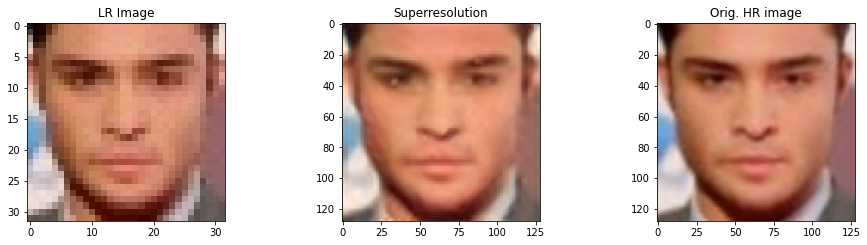

In [13]:
generator = load_model('gen_e_100.h5', compile=False)


[X1, X2] = [lr_test, hr_test]

ix = randint(0, len(X1), 1)
src_image, tar_image = X1[ix], X2[ix]


gen_image = generator.predict(src_image)

plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('LR Image')
plt.imshow(src_image[0,:,:,:])
plt.subplot(232)
plt.title('Superresolution')
plt.imshow(gen_image[0,:,:,:])
plt.subplot(233)
plt.title('Orig. HR image')
plt.imshow(tar_image[0,:,:,:])
plt.show()

1/1 [==============================] - 1s 763ms/step


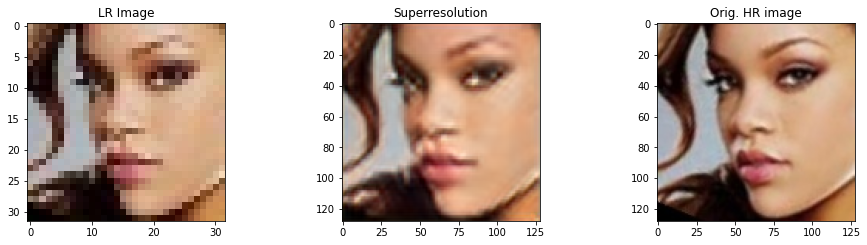

In [36]:
generator = load_model('gen_e_100.h5', compile=False)


[X1, X2] = [lr_test, hr_test]

ix = randint(0, len(X1), 1)
src_image, tar_image = X1[ix], X2[ix]


gen_image = generator.predict(src_image)

plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('LR Image')
plt.imshow(src_image[0,:,:,:])
plt.subplot(232)
plt.title('Superresolution')
plt.imshow(gen_image[0,:,:,:])
plt.subplot(233)
plt.title('Orig. HR image')
plt.imshow(tar_image[0,:,:,:])
plt.show()

1/1 [==============================] - 1s 734ms/step


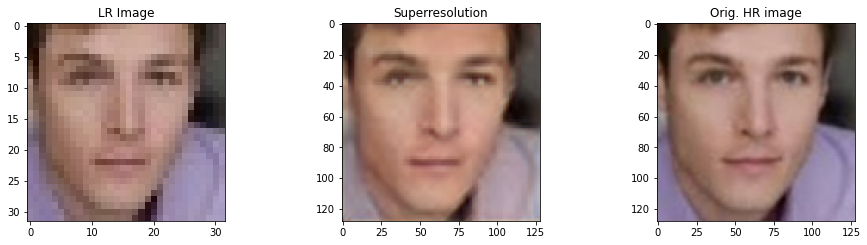

In [25]:
generator = load_model('gen_e_100.h5', compile=False)


[X1, X2] = [lr_test, hr_test]

ix = randint(0, len(X1), 1)
src_image, tar_image = X1[ix], X2[ix]


gen_image = generator.predict(src_image)

plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('LR Image')
plt.imshow(src_image[0,:,:,:])
plt.subplot(232)
plt.title('Superresolution')
plt.imshow(gen_image[0,:,:,:])
plt.subplot(233)
plt.title('Orig. HR image')
plt.imshow(tar_image[0,:,:,:])
plt.show()

1/1 [==============================] - 1s 745ms/step


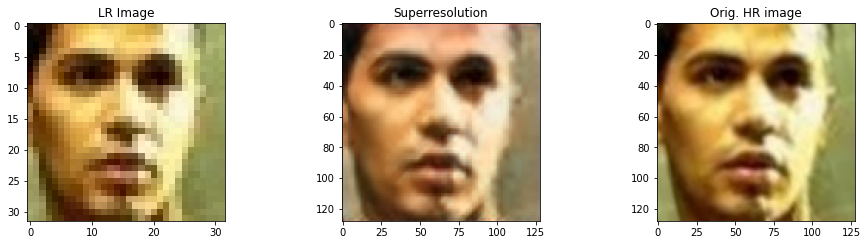

In [24]:
generator = load_model('gen_e_100.h5', compile=False)


[X1, X2] = [lr_test, hr_test]

ix = randint(0, len(X1), 1)
src_image, tar_image = X1[ix], X2[ix]


gen_image = generator.predict(src_image)

plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('LR Image')
plt.imshow(src_image[0,:,:,:])
plt.subplot(232)
plt.title('Superresolution')
plt.imshow(gen_image[0,:,:,:])
plt.subplot(233)
plt.title('Orig. HR image')
plt.imshow(tar_image[0,:,:,:])
plt.show()

In [12]:
print("done!")


done!
